# Technical Analysis Indicator Price Prediction
The goal of this project is to analyze the predictive power of the top 10 most popular TA indicators and see how well they do to predict price over a 30 day period. I am going to find the value of the indicators on day 1 (30 trading days ago) and then find the daily closing price for 30 days later and measure how well the indicator predicted the price.  

first we'll find the top 500 stocks by market cap from nasdaq and pull them into a dataframe


In [1]:
# Importing pandas library for data manipulation and analysis
import pandas as pd

# Load the CSV file into a DataFrame
csv_file_path = '/Users/evancallaghan/Downloads/nasdaq_screener_1726538993372.csv' 
df = pd.read_csv(csv_file_path)

# Inspect the DataFrame to understand its structure
print(df.head())

# Filter DataFrame to only show the columns 'Symbol', 'Name', and 'Market Cap'
df = df[['Symbol', 'Name', 'Market Cap']]

# Convert 'Market Cap' to numeric if it's not already
# Remove commas, dollar signs, and replace these symbols with empty spaces
df['Market Cap'] = df['Market Cap'].replace({'\$': '', ',': ''}, regex=True).astype(float)

# Sort the DataFrame by Market Cap in descending order
df_sorted = df.sort_values(by='Market Cap', ascending=False).head(5000)                                                                        
df_sorted.head()


  Symbol                                               Name Last Sale  \
0      A             Agilent Technologies Inc. Common Stock   $138.31   
1     AA                    Alcoa Corporation Common Stock     $34.50   
2   AACG   ATA Creativity Global American Depositary Shares   $0.5025   
3   AACT  Ares Acquisition Corporation II Class A Ordina...    $10.80   
4   AADI                  Aadi Bioscience Inc. Common Stock     $1.88   

   Net Change % Change    Market Cap        Country  IPO Year    Volume  \
0      1.0000   0.728%  3.974029e+10  United States    1999.0    887040   
1      1.9800   6.089%  8.912735e+09  United States    2016.0  10730428   
2     -0.0275  -5.189%  1.608006e+07          China    2008.0     25043   
3      0.0200   0.186%  0.000000e+00            NaN    2023.0     35074   
4      0.0800   4.444%  4.627589e+07  United States       NaN     81942   

        Sector                                          Industry  
0  Industrials  Biotechnology: Laboratory A

Symbol                                 Name    Market Cap
15     AAPL              Apple Inc. Common Stock  3.288959e+12
4208   MSFT   Microsoft Corporation Common Stock  3.206167e+12
4559   NVDA      NVIDIA Corporation Common Stock  2.864613e+12
2819   GOOG  Alphabet Inc. Class C Capital Stock  1.957167e+12
2820  GOOGL   Alphabet Inc. Class A Common Stock  1.945719e+12

In [2]:
# Reset the index of the DataFrame and drop the old index
df_sorted.reset_index(drop=True, inplace=True)

# Update the index to start from 1 instead of 0
df_sorted.index = df_sorted.index + 1

# Display the first few rows of the updated DataFrame
df_sorted.head()

Symbol                                 Name    Market Cap
1   AAPL              Apple Inc. Common Stock  3.288959e+12
2   MSFT   Microsoft Corporation Common Stock  3.206167e+12
3   NVDA      NVIDIA Corporation Common Stock  2.864613e+12
4   GOOG  Alphabet Inc. Class C Capital Stock  1.957167e+12
5  GOOGL   Alphabet Inc. Class A Common Stock  1.945719e+12

remove all stocks except common stocks

In [3]:
# Ensure there are no leading or trailing whitespaces in the 'Name' column
df_sorted['Name'] = df_sorted['Name'].str.strip()

# List of terms to filter out
terms_to_drop = ["Capital Stock", "Depository Shares", "Global Notes", "ADS", 
                 "Registry Shares", "Depositary Shares"
]

# Create a regex pattern to match any of the terms
# //b ensures that the match occues only at the start or end of a word
# pipe '|' ensures that if any of the terms in 'terms_to_drop' are seen, 
# there is a match
pattern = '|'.join([f"\\b{term}\\b" for term in terms_to_drop])

# Apply filtering based on the updated pattern
df_filtered = df_sorted[~df_sorted['Name'].str.contains(pattern, case=False, 
                                                        na=False)
]

# Display the filtered DataFrame
df_filtered.head()

Symbol                                Name    Market Cap
1   AAPL             Apple Inc. Common Stock  3.288959e+12
2   MSFT  Microsoft Corporation Common Stock  3.206167e+12
3   NVDA     NVIDIA Corporation Common Stock  2.864613e+12
5  GOOGL  Alphabet Inc. Class A Common Stock  1.945719e+12
6   AMZN        Amazon.com Inc. Common Stock  1.940525e+12

In [7]:
# Reset the index of the DataFrame and drop the old index
df_filtered.reset_index(drop=True, inplace=True)

# Update the index to start from 1 instead of 0
df_filtered.index = df_filtered.index + 1

# Display the first few rows of the updated DataFrame
df_filtered.head()

Symbol                                Name    Market Cap
1   AAPL             Apple Inc. Common Stock  3.288959e+12
2   MSFT  Microsoft Corporation Common Stock  3.206167e+12
3   NVDA     NVIDIA Corporation Common Stock  2.864613e+12
4  GOOGL  Alphabet Inc. Class A Common Stock  1.945719e+12
5   AMZN        Amazon.com Inc. Common Stock  1.940525e+12

below are the 10 technical indicators we are going to use for this project.
1. Relative Strength Index (RSI)
2. Moving Average Convergence Divergence (MACD)
3. Stochastic Oscillator
4. Simple Moving Average (SMA)
5. Exponential Moving Average (EMA)
6. Volume Weighted Average Price (VWAP)
7. Bollinger Bands
8. Average True Range (ATR)
9. Fibonacci Retracement 

In [391]:
# Pulls data from yahoo finance into CSV files
import yfinance as yf
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
import time
import os

# Function to download stock data for a single stock
def download_stock_data(ticker, retries=3):
    for attempt in range(retries):
        try:
            # Add a delay to avoid rate limiting
            time.sleep(1)  # Increase delay to 2 seconds between requests
            
            print(f"Downloading data for {ticker}, attempt {attempt + 1}")
            data = yf.download(ticker, start="2022-02-10", end="2025-02-17", interval="1d")[['Close', 'High', 'Low', 'Volume']]
            
            if data.empty:
                print(f"Warning: No data found for {ticker}")
                return None  # Return None if data is empty

            # Explicitly add 'Date' as a column before resetting the index
            data['Date'] = data.index

            # Reset the index and make 'Date' a normal column
            data.reset_index(drop=True, inplace=True)
            
            data['Ticker'] = ticker
            print(f"Downloaded data for {ticker}:\n{data.head()}")
            return data
        except Exception as e:
            print(f"Error downloading data for {ticker}: {e}")
            time.sleep(1)  # Longer delay before retrying in case of failure
    return None  # Return None after retries if still fails

# List of tickers from your df_filtered dataframe
tickers = df_filtered['Symbol'].astype(str).tolist()  # Ensure tickers are strings

# Batch size for processing tickers in smaller chunks
batch_size = 100  # Reduce batch size to avoid rate limits

# Directory to save CSV files
output_dir = "/Users/evancallaghan/flatiron_ds/phase_5/capstone_project"

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Create a function to download data for a batch of tickers in parallel
def download_batch(batch_tickers, batch_index):
    with ThreadPoolExecutor(max_workers=2) as executor:  # Use fewer threads to reduce load
        results = list(executor.map(lambda ticker: download_stock_data(ticker), batch_tickers))

    # Remove None values and ensure we have valid data
    valid_results = [(batch_tickers[i], results[i]) for i in range(len(batch_tickers)) if results[i] is not None]
    
    # Add ticker info to the valid results
    for ticker, df in valid_results:
        df['Ticker'] = ticker  # Explicitly add a column for ticker
    
    # Combine all the valid stock data into a single DataFrame
    if valid_results:
        df_batch = pd.concat([df for _, df in valid_results], ignore_index=False)  # Don't lose index info
        print(f"Saving batch {batch_index} data to CSV.")
        # Save the batch to a CSV file
        df_batch.to_csv(f"{output_dir}/stock_price_data_batch_{batch_index}.csv", index=False)
    else:
        print(f"No data downloaded for batch {batch_index}.")

# Split tickers into batches
for i in range(0, len(tickers), batch_size):
    batch_tickers = tickers[i:i + batch_size]
    batch_index = (i // batch_size) + 1  # Batch index starts from 1
    download_batch(batch_tickers, batch_index)

print("All batches processed and saved.")


[*********************100%***********************]  1 of 1 completed

/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for MSFT:
        Close        High         Low    Volume       Date Ticker
0  302.380005  309.119995  300.700012  45386200 2022-02-10   MSFT
1  295.040009  304.290009  294.220001  39175600 2022-02-11   MSFT
2  295.000000  296.760010  291.350006  36359500 2022-02-14   MSFT
3  300.470001  300.799988  297.019989  27058300 2022-02-15   MSFT
4  299.500000  300.869995  293.679993  29982100 2022-02-16   MSFTDownloaded data for AAPL:
        Close        High         Low    Volume       Date Ticker
0  172.119995  175.479996  171.550003  90865900 2022-02-10   AAPL
1  168.639999  173.080002  168.039993  98670700 2022-02-11   AAPL
2  168.880005  169.580002  166.559998  86185500 2022-02-14   AAPL
3  172.789993  172.949997  170.250000  62527400 2022-02-15   AAPL
4  172.550003  173.339996  170.050003  61177400 2022-02-16   AAPL



[*********************100%***********************]  1 of 1 completed


Downloaded data for GOOGL:
        Close        High         Low    Volume       Date Ticker
0  138.619995  141.484497  137.957001  39330000 2022-02-10  GOOGL
1  134.282501  139.156494  133.399994  39958000 2022-02-11  GOOGL
2  135.526001  136.300003  133.256500  34302000 2022-02-14  GOOGL
3  136.608505  138.108505  135.821503  26680000 2022-02-15  GOOGL
4  137.738007  138.085999  134.923996  25022000 2022-02-16  GOOGL
Error downloading data for NVDA: 'NVDA'



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index

[*********************100%***********************]  1 of 1 completed

Downloaded data for AMZN:
        Close        High         Low    Volume       Date Ticker
0  159.003494  160.716507  157.750000  68268000 2022-02-10   AMZN
1  153.293503  159.000000  152.733994  77100000 2022-02-11   AMZN
2  155.167007  158.448502  151.649994  83230000 2022-02-14   AMZN
3  156.510498  158.007004  154.637497  56440000 2022-02-15   AMZN
4  158.100494  158.834000  154.734497  52704000 2022-02-16   AMZN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NVDA:
       Close       High        Low     Volume       Date Ticker
0  25.823999  26.924999  25.600000  513200000 2022-02-10   NVDA
1  23.948999  26.152000  23.773001  605472000 2022-02-11   NVDA
2  24.267000  24.875000  23.754999  440424000 2022-02-14   NVDA
3  26.495001  26.545000  24.784000  699869000 2022-02-15   NVDA
4  26.511000  26.582001  25.552000  732676000 2022-02-16   NVDA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for META:
        Close        High         Low    Volume       Date Ticker
0  228.070007  235.000000  226.699997  49310400 2022-02-10   META
1  219.550003  230.419998  218.770004  46156900 2022-02-11   META
2  217.699997  221.000000  214.779999  38184000 2022-02-14   META
3  221.000000  221.149994  215.059998  42685500 2022-02-15   META
4  216.539993  217.460007  212.360001  45817500 2022-02-16   META


Failed to get ticker 'BRK/A' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%***********************]  1 of 1 completed

1 Failed download:


1 Failed download:
['BRK/A']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
['BRK/A']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Error downloading data for BRK/B: 'BRK/B'


Failed to get ticker 'BRK/B' reason: Expecting value: line 1 column 1 (char 0)


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for LLY:
        Close        High         Low   Volume       Date Ticker
0  239.639999  244.089996  238.110001  2283100 2022-02-10    LLY
1  235.740005  240.630005  234.850006  2054300 2022-02-11    LLY
2  234.690002  236.880005  231.869995  2572000 2022-02-14    LLY
3  243.839996  244.789993  236.649994  3409600 2022-02-15    LLY
4  245.580002  247.020004  242.580002  2459000 2022-02-16    LLY


Failed to get ticker 'BRK/B' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BRK/B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


[*********************100%***********************]  1 of 1 completed

Downloaded data for TSM:
        Close        High         Low    Volume       Date Ticker
0  124.709999  128.660004  124.360001  10474900 2022-02-10    TSM
1  121.010002  126.580002  120.449997   9845700 2022-02-11    TSM
2  119.769997  121.550003  118.000000   8081800 2022-02-14    TSM
3  124.519997  124.610001  121.459999   9248700 2022-02-15    TSM
4  123.599998  124.290001  121.570000   5749500 2022-02-16    TSM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AVGO:
       Close       High        Low    Volume       Date Ticker
0  59.136002  61.464001  58.856998  24920000 2022-02-10   AVGO
1  57.341999  59.976002  56.908001  27281000 2022-02-11   AVGO
2  57.858002  58.280998  57.007000  19291000 2022-02-14   AVGO
3  60.277000  60.604000  58.825001  34284000 2022-02-15   AVGO
4  59.721001  60.081001  58.722000  22931000 2022-02-16   AVGO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TSLA:
        Close        High         Low    Volume       Date Ticker
0  301.516663  314.603333  298.899994  66126900 2022-02-10   TSLA
1  286.666656  305.320007  283.566681  79645800 2022-02-11   TSLA
2  291.920013  299.626678  284.383331  67756500 2022-02-14   TSLA
3  307.476654  307.666656  297.793335  57286200 2022-02-15   TSLA
4  307.796661  308.809998  300.403320  51294300 2022-02-16   TSLA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for WMT:
       Close       High        Low    Volume       Date Ticker
0  45.360001  45.669998  45.153332  27810600 2022-02-10    WMT
1  45.110001  45.726665  44.723331  23733300 2022-02-11    WMT
2  44.650002  45.320000  44.236668  29363400 2022-02-14    WMT
3  44.790001  45.223331  44.596668  21824400 2022-02-15    WMT
4  44.509998  44.959999  44.233334  28490700 2022-02-16    WMT


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for NVO:
       Close       High        Low   Volume       Date Ticker
0  52.029999  53.189999  51.884998  1889800 2022-02-10    NVO
1  49.455002  50.959999  49.095001  3747400 2022-02-11    NVO
2  49.070000  49.330002  48.639999  3157800 2022-02-14    NVO
3  50.680000  51.090000  50.334999  1900000 2022-02-15    NVO
4  51.584999  51.674999  50.779999  2010600 2022-02-16    NVO


[*********************100%***********************]  1 of 1 completed

Downloaded data for JPM:
        Close        High         Low    Volume       Date Ticker
0  155.949997  159.029999  155.220001  16455600 2022-02-10    JPM
1  153.919998  158.190002  152.970001  16830000 2022-02-11    JPM
2  152.490005  153.679993  150.320007  17026500 2022-02-14    JPM
3  154.720001  155.940002  153.850006   9500000 2022-02-15    JPM
4  155.000000  156.100006  153.740005   9076500 2022-02-16    JPM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for UNH:
        Close        High         Low   Volume       Date Ticker
0  486.720001  494.220001  485.070007  2626100 2022-02-10    UNH
1  478.130005  490.429993  476.440002  2493800 2022-02-11    UNH
2  474.399994  477.739990  469.329987  2549500 2022-02-14    UNH
3  478.230011  481.170013  475.200012  3001000 2022-02-15    UNH
4  480.049988  481.730011  471.399994  2651800 2022-02-16    UNH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for V:
        Close        High         Low   Volume       Date Ticker
0  225.589996  229.949997  224.869995  6794600 2022-02-10      V
1  224.690002  229.100006  223.539993  7535200 2022-02-11      V
2  225.339996  227.259995  222.809998  8280800 2022-02-14      V
3  227.820007  229.289993  224.910004  9461700 2022-02-15      V
4  228.820007  229.880005  225.600006  9561300 2022-02-16      V



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for XOM:
       Close       High        Low    Volume       Date Ticker
0  78.239998  79.680000  77.790001  28527700 2022-02-10    XOM
1  80.209999  80.320000  78.230003  42002100 2022-02-11    XOM
2  78.980003  79.839996  77.050003  34652800 2022-02-14    XOM
3  77.989998  78.190002  76.419998  25075100 2022-02-15    XOM
4  78.349998  79.730003  78.040001  21733800 2022-02-16    XOM


[*********************100%***********************]  1 of 1 completed

Downloaded data for ORCL:
       Close       High        Low   Volume       Date Ticker
0  81.849998  83.779999  81.620003  6336300 2022-02-10   ORCL
1  79.750000  82.430000  79.529999  7670500 2022-02-11   ORCL
2  78.949997  79.730003  78.440002  5389800 2022-02-14   ORCL
3  79.769997  79.930000  79.209999  5712800 2022-02-15   ORCL
4  79.190002  79.779999  78.220001  6227000 2022-02-16   ORCL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MA:
        Close        High         Low   Volume       Date Ticker
0  374.390015  380.000000  370.559998  3995000 2022-02-10     MA
1  369.769989  380.899994  367.640015  4345600 2022-02-11     MA
2  374.160004  377.290009  366.760010  3678400 2022-02-14     MA
3  381.540009  383.070007  373.399994  5800400 2022-02-15     MA
4  382.929993  385.000000  376.779999  3424800 2022-02-16     MA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for PG:
        Close        High         Low   Volume       Date Ticker
0  157.169998  159.500000  156.649994  7033000 2022-02-10     PG
1  156.289993  158.580002  155.580002  9341400 2022-02-11     PG
2  156.740005  157.059998  153.360001  9472200 2022-02-14     PG
3  156.820007  159.320007  156.110001  6659200 2022-02-15     PG
4  158.009995  158.779999  156.270004  9315700 2022-02-16     PG


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for COST:
        Close        High         Low   Volume       Date Ticker
0  518.479980  524.469971  514.750000  2558900 2022-02-10   COST
1  509.670013  521.349976  507.380005  2349700 2022-02-11   COST
2  506.559998  511.529999  501.440002  1749600 2022-02-14   COST
3  513.919983  516.000000  510.760010  1984600 2022-02-15   COST
4  512.400024  514.549988  501.709991  1770800 2022-02-16   COST


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for JNJ:
        Close        High         Low    Volume       Date Ticker
0  169.419998  171.220001  169.300003  10355300 2022-02-10    JNJ
1  167.710007  170.149994  167.539993  13125300 2022-02-11    JNJ
2  165.600006  167.970001  163.809998   8967600 2022-02-14    JNJ
3  167.309998  168.100006  166.009995   6631400 2022-02-15    JNJ
4  167.210007  167.839996  165.710007   8482400 2022-02-16    JNJ


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for HD:
        Close        High         Low   Volume       Date Ticker
0  355.089996  363.000000  352.869995  4291800 2022-02-10     HD
1  350.290009  357.339996  348.559998  3308700 2022-02-11     HD
2  351.559998  352.910004  346.829987  3654300 2022-02-14     HD
3  353.260010  357.420013  351.380005  3552500 2022-02-15     HD
4  350.089996  352.859985  345.720001  3594900 2022-02-16     HD


[*********************100%***********************]  1 of 1 completed

Downloaded data for ABBV:
        Close        High         Low   Volume       Date Ticker
0  142.710007  144.419998  142.309998  7333400 2022-02-10   ABBV
1  142.009995  143.610001  141.539993  6475200 2022-02-11   ABBV
2  143.000000  143.190002  139.440002  9931900 2022-02-14   ABBV
3  144.759995  145.460007  143.199997  9530100 2022-02-15   ABBV
4  145.869995  147.220001  144.160004  8028900 2022-02-16   ABBV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for KO:
       Close       High        Low    Volume       Date Ticker
0  61.380001  62.299999  60.200001  23561500 2022-02-10     KO
1  60.290001  61.980000  60.150002  22781400 2022-02-11     KO
2  60.680000  60.790001  59.279999  23641300 2022-02-14     KO
3  60.910000  61.779999  60.630001  13408700 2022-02-15     KO
4  60.900002  61.400002  60.560001  15484700 2022-02-16     KO


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for BAC:
       Close       High        Low    Volume       Date Ticker
0  49.049999  50.110001  48.759998  47082800 2022-02-10    BAC
1  47.919998  49.439999  47.500000  61056000 2022-02-11    BAC
2  47.419998  48.189999  46.939999  44791900 2022-02-14    BAC
3  47.790001  48.369999  47.570000  42397600 2022-02-15    BAC
4  47.680000  48.240002  47.310001  36664600 2022-02-16    BAC


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for MRK:
       Close       High        Low    Volume       Date Ticker
0  76.559998  76.769997  75.930000  12437600 2022-02-10    MRK
1  76.639999  77.900002  76.169998   9342300 2022-02-11    MRK
2  76.470001  76.699997  75.110001   9881100 2022-02-14    MRK
3  77.809998  78.190002  77.320000  11425600 2022-02-15    MRK
4  77.220001  77.800003  76.930000   9981300 2022-02-16    MRK


[*********************100%***********************]  1 of 1 completed

Downloaded data for NFLX:
        Close        High         Low   Volume       Date Ticker
0  406.269989  408.000000  396.359985  8452900 2022-02-10   NFLX
1  391.309998  411.609985  387.649994  7558900 2022-02-11   NFLX
2  396.570007  409.359985  386.890015  7202200 2022-02-14   NFLX
3  407.459991  409.160004  401.010010  5392300 2022-02-15   NFLX
4  398.079987  401.559998  390.380005  5277700 2022-02-16   NFLX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CVX:
        Close        High         Low    Volume       Date Ticker
0  136.039993  138.789993  135.389999  11012700 2022-02-10    CVX
1  138.809998  139.440002  136.279999  12821200 2022-02-11    CVX
2  136.669998  138.050003  135.050003  15945000 2022-02-14    CVX
3  134.259995  134.839996  132.179993  11746800 2022-02-15    CVX
4  134.300003  136.160004  133.759995  11348800 2022-02-16    CVX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AMD:
        Close        High         Low     Volume       Date Ticker
0  125.769997  131.759995  124.610001  108939900 2022-02-10    AMD
1  113.180000  127.169998  111.809998  164723200 2022-02-11    AMD
2  114.269997  118.370003  113.459999  135146400 2022-02-14    AMD
3  121.470001  121.879997  114.360001  143975900 2022-02-15    AMD
4  117.690002  119.540001  114.220001  119109600 2022-02-16    AMD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CRM:
        Close        High         Low   Volume       Date Ticker
0  217.669998  221.990005  215.809998  5312600 2022-02-10    CRM
1  207.899994  219.929993  206.110001  8165600 2022-02-11    CRM
2  206.399994  209.899994  204.630005  7005900 2022-02-14    CRM
3  214.250000  214.570007  208.520004  6353000 2022-02-15    CRM
4  211.740005  212.419998  208.210007  7072700 2022-02-16    CRM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for PEP:
        Close        High         Low   Volume       Date Ticker
0  168.369995  171.449997  167.300003  7899800 2022-02-10    PEP
1  168.580002  170.309998  167.690002  7299600 2022-02-11    PEP
2  166.699997  169.679993  165.100006  6822500 2022-02-14    PEP
3  165.960007  168.250000  165.259995  4943800 2022-02-15    PEP
4  166.300003  167.199997  164.539993  4161700 2022-02-16    PEP


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for TMUS:
        Close        High         Low   Volume       Date Ticker
0  125.129997  127.839996  124.559998  6901600 2022-02-10   TMUS
1  124.480003  126.940002  124.139999  4963100 2022-02-11   TMUS
2  125.510002  125.790001  123.349998  4655300 2022-02-14   TMUS
3  127.029999  128.070007  126.080002  3712500 2022-02-15   TMUS
4  127.459999  128.369995  125.309998  3026300 2022-02-16   TMUS


[*********************100%***********************]  1 of 1 completed

Downloaded data for NVS:
       Close       High        Low   Volume       Date Ticker
0  85.830002  87.440002  85.620003  4060400 2022-02-10    NVS
1  85.570000  86.400002  85.470001  4158700 2022-02-11    NVS
2  85.690002  86.389999  85.309998  5102700 2022-02-14    NVS
3  86.419998  86.660004  86.120003  2855900 2022-02-15    NVS
4  87.940002  87.980003  86.919998  2364700 2022-02-16    NVS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for TM:
        Close        High         Low  Volume       Date Ticker
0  194.410004  197.300003  194.250000  420900 2022-02-10     TM
1  192.710007  196.199997  191.910004  230000 2022-02-11     TM
2  188.970001  190.500000  187.830002  259600 2022-02-14     TM
3  189.399994  190.059998  188.440002  227300 2022-02-15     TM
4  190.300003  190.899994  189.210007  207000 2022-02-16     TM


[*********************100%***********************]  1 of 1 completed

Downloaded data for TMO:
        Close        High         Low   Volume       Date Ticker
0  580.280029  587.210022  577.320007  1931100 2022-02-10    TMO
1  566.289978  584.880005  564.570007  1726000 2022-02-11    TMO
2  561.190002  568.770020  555.969971  1387700 2022-02-14    TMO
3  556.669983  571.229980  553.820007  1438600 2022-02-15    TMO
4  550.349976  554.700012  539.169983  2154700 2022-02-16    TMO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ADBE:
        Close        High         Low   Volume       Date Ticker
0  495.019989  514.479980  492.279999  4735800 2022-02-10   ADBE
1  473.970001  499.929993  472.899994  5027000 2022-02-11   ADBE
2  474.010010  478.570007  469.209991  3372100 2022-02-14   ADBE
3  479.500000  482.529999  472.390015  3743100 2022-02-15   ADBE
4  477.700012  480.209991  467.269989  3750500 2022-02-16   ADBE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LIN:
        Close        High         Low   Volume       Date Ticker
0  308.850006  316.850006  307.290009  2497900 2022-02-10    LIN
1  294.730011  309.100006  293.510010  2209700 2022-02-11    LIN
2  293.510010  295.850006  290.320007  1774400 2022-02-14    LIN
3  301.899994  302.619995  298.920013  1697600 2022-02-15    LIN
4  303.829987  305.269989  299.109985  1805400 2022-02-16    LIN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ACN:
        Close        High         Low   Volume       Date Ticker
0  342.390015  351.579987  339.989990  2457700 2022-02-10    ACN
1  329.179993  344.980011  327.290009  3091600 2022-02-11    ACN
2  326.130005  327.869995  321.459991  2689900 2022-02-14    ACN
3  329.410004  333.329987  327.350006  2395600 2022-02-15    ACN
4  333.720001  335.440002  325.109985  2867500 2022-02-16    ACN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CCZ:
       Close       High        Low  Volume       Date Ticker
0  62.299999  62.830002  61.318001    1200 2022-02-10    CCZ
1  62.500000  63.060001  61.470001     700 2022-02-11    CCZ
2  62.500000  62.500000  62.500000       0 2022-02-14    CCZ
3  61.500000  62.540001  61.500000    1500 2022-02-15    CCZ
4  61.000000  61.959999  59.209999    3100 2022-02-16    CCZ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for MCD:
        Close        High         Low   Volume       Date Ticker
0  256.869995  260.440002  255.970001  3246600 2022-02-10    MCD
1  255.160004  258.760010  254.729996  3592700 2022-02-11    MCD
2  253.389999  256.250000  251.679993  2825800 2022-02-14    MCD
3  253.809998  256.920013  253.559998  2171500 2022-02-15    MCD
4  253.089996  254.600006  251.199997  2941800 2022-02-16    MCD


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ABT:
        Close        High         Low   Volume       Date Ticker
0  127.760002  129.919998  127.169998  5917700 2022-02-10    ABT
1  125.489998  128.919998  125.150002  4803200 2022-02-11    ABT
2  122.779999  125.570000  121.980003  7433900 2022-02-14    ABT
3  123.980003  125.419998  123.410004  5298000 2022-02-15    ABT
4  123.680000  124.110001  121.559998  5078100 2022-02-16    ABT


[*********************100%***********************]  1 of 1 completed

Downloaded data for CSCO:
       Close       High        Low    Volume       Date Ticker
0  54.869999  56.029999  54.740002  19730600 2022-02-10   CSCO
1  53.900002  55.090000  53.770000  20132500 2022-02-11   CSCO
2  53.180000  53.650002  52.700001  21868400 2022-02-14   CSCO
3  54.270000  54.299999  53.639999  17678000 2022-02-15   CSCO
4  54.250000  54.439999  53.389999  20388700 2022-02-16   CSCO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for IBM:
        Close        High         Low   Volume       Date Ticker
0  133.520004  136.559998  133.169998  5978600 2022-02-10    IBM
1  132.690002  134.710007  132.380005  4176200 2022-02-11    IBM
2  130.149994  132.649994  129.070007  5345300 2022-02-14    IBM
3  129.940002  131.679993  129.610001  4394000 2022-02-15    IBM
4  129.179993  130.440002  128.259995  4875600 2022-02-16    IBM


[*********************100%***********************]  1 of 1 completed

Downloaded data for DHR:
        Close        High         Low   Volume       Date Ticker
0  250.177307  255.886520  248.776596  2886552 2022-02-10    DHR
1  241.719864  251.613480  240.921982  3301430 2022-02-11    DHR
2  240.691483  242.712769  238.324463  3399905 2022-02-14    DHR
3  238.537231  245.886520  237.508865  3704239 2022-02-15    DHR
4  237.313828  239.131210  232.712769  4108627 2022-02-16    DHR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for GE:
       Close       High        Low    Volume       Date Ticker
0  61.547836  62.725338  61.055653   8848717 2022-02-10     GE
1  60.326721  62.444981  59.915531  11966771 2022-02-11     GE
2  60.183430  60.681843  59.535492  11172731 2022-02-14     GE
3  62.874863  63.161449  61.024502  10741924 2022-02-15     GE
4  63.180141  63.491650  62.233154   7850670 2022-02-16     GE


[*********************100%***********************]  1 of 1 completed

Downloaded data for PM:
        Close        High         Low   Volume       Date Ticker
0  105.070000  106.440002  103.959999  7008300 2022-02-10     PM
1  107.959999  108.570000  104.910004  8674300 2022-02-11     PM
2  109.239998  109.419998  107.769997  9409900 2022-02-14     PM
3  109.669998  110.629997  109.070000  6564500 2022-02-15     PM
4  111.570000  111.970001  109.300003  8577200 2022-02-16     PM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VZ:
       Close       High        Low    Volume       Date Ticker
0  53.040001  53.540001  52.900002  18644400 2022-02-10     VZ
1  53.320000  53.459999  52.700001  18833100 2022-02-11     VZ
2  53.270000  53.450001  52.500000  16081700 2022-02-14     VZ
3  53.360001  53.590000  53.150002  12824100 2022-02-15     VZ
4  53.400002  53.799999  53.090000  17277700 2022-02-16     VZ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AXP:
        Close        High         Low   Volume       Date Ticker
0  195.509995  198.229996  194.610001  4511100 2022-02-10    AXP
1  191.809998  197.199997  190.449997  4834900 2022-02-11    AXP
2  192.350006  194.149994  190.919998  3841300 2022-02-14    AXP
3  197.979996  198.360001  194.179993  4134300 2022-02-15    AXP
4  198.380005  199.550003  197.240005  4122600 2022-02-16    AXP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for QCOM:
        Close        High         Low    Volume       Date Ticker
0  174.070007  181.990005  173.449997  14362200 2022-02-10   QCOM
1  164.639999  175.479996  163.550003  13572000 2022-02-11   QCOM
2  165.130005  167.850006  162.479996   8381700 2022-02-14   QCOM
3  173.000000  173.960007  168.250000  11100000 2022-02-15   QCOM
4  172.600006  173.210007  168.259995   8340600 2022-02-16   QCOM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FMX:
       Close       High        Low  Volume       Date Ticker
0  76.730003  77.529999  76.099998  432100 2022-02-10    FMX
1  77.320000  78.720001  76.830002  494300 2022-02-11    FMX
2  75.610001  77.389999  75.070000  507000 2022-02-14    FMX
3  76.839996  77.720001  75.919998  434100 2022-02-15    FMX
4  78.320000  78.720001  76.809998  299300 2022-02-16    FMX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NOW:
        Close        High         Low   Volume       Date Ticker
0  610.460022  621.409973  599.960022  1981300 2022-02-10    NOW
1  583.719971  610.000000  577.619995  2140000 2022-02-11    NOW
2  579.580017  589.330017  574.179993  1240000 2022-02-14    NOW
3  591.659973  593.880005  581.219971   987000 2022-02-15    NOW
4  590.890015  593.030029  576.479980  1100400 2022-02-16    NOW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for WFC:
       Close       High        Low    Volume       Date Ticker
0  59.049999  60.299999  58.799999  36092000 2022-02-10    WFC
1  58.310001  60.240002  57.910000  38650500 2022-02-11    WFC
2  57.849998  58.650002  57.180000  32680500 2022-02-14    WFC
3  58.380001  59.320000  58.090000  18224600 2022-02-15    WFC
4  58.139999  58.880001  57.549999  22057200 2022-02-16    WFC


[*********************100%***********************]  1 of 1 completed

Downloaded data for TXN:
        Close        High         Low   Volume       Date Ticker
0  170.660004  176.830002  169.740005  7583400 2022-02-10    TXN
1  164.399994  171.360001  163.649994  7564200 2022-02-11    TXN
2  162.470001  165.649994  161.039993  7468000 2022-02-14    TXN
3  166.169998  166.770004  164.080002  6969700 2022-02-15    TXN
4  168.240005  168.960007  164.229996  4594300 2022-02-16    TXN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for INTU:
        Close        High         Low   Volume       Date Ticker
0  557.580017  575.909973  552.330017  1594200 2022-02-10   INTU
1  535.809998  561.700012  532.669983  1250400 2022-02-11   INTU
2  529.049988  538.320007  524.150024  1165400 2022-02-14   INTU
3  527.780029  539.330017  515.770020  2170300 2022-02-15   INTU
4  528.150024  530.419983  511.709991  1318400 2022-02-16   INTU



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AMGN:
        Close        High         Low   Volume       Date Ticker
0  228.820007  236.139999  227.710007  5035000 2022-02-10   AMGN
1  228.199997  231.470001  228.149994  3557700 2022-02-11   AMGN
2  224.270004  226.929993  220.860001  3931500 2022-02-14   AMGN
3  223.940002  226.160004  221.220001  2474500 2022-02-15   AMGN
4  222.660004  225.100006  221.039993  2369000 2022-02-16   AMGN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ISRG:
        Close        High         Low   Volume       Date Ticker
0  292.489990  294.980011  286.739990  2882900 2022-02-10   ISRG
1  283.160004  294.480011  282.200012  2267400 2022-02-11   ISRG
2  281.140015  286.170013  279.029999  1563300 2022-02-14   ISRG
3  289.309998  290.609985  284.799988  1413700 2022-02-15   ISRG
4  291.140015  292.359985  282.720001  1797200 2022-02-16   ISRG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RY:
        Close        High         Low   Volume       Date Ticker
0  114.459999  116.150002  114.230003  1187300 2022-02-10     RY
1  114.690002  116.029999  114.169998  1553500 2022-02-11     RY
2  113.900002  114.419998  113.050003  1415100 2022-02-14     RY
3  113.910004  114.750000  113.550003  1025500 2022-02-15     RY
4  114.320000  114.980003  113.750000   963600 2022-02-16     RY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NEE:
       Close       High        Low   Volume       Date Ticker
0  75.449997  76.849998  74.699997  9673300 2022-02-10    NEE
1  74.959999  76.699997  74.669998  8999100 2022-02-11    NEE
2  74.919998  75.309998  73.879997  8329200 2022-02-14    NEE
3  75.089996  76.470001  74.739998  9102000 2022-02-15    NEE
4  75.230003  75.639999  74.480003  7505100 2022-02-16    NEE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for PFE:
       Close       High        Low    Volume       Date Ticker
0  50.599998  51.369999  50.389999  34200600 2022-02-10    PFE
1  50.779999  51.240002  50.080002  34997800 2022-02-11    PFE
2  49.799999  50.500000  48.480000  42973100 2022-02-14    PFE
3  49.790001  50.040001  49.209999  29150000 2022-02-15    PFE
4  49.680000  50.779999  49.430000  27672600 2022-02-16    PFE


[*********************100%***********************]  1 of 1 completed

Downloaded data for CAT:
        Close        High         Low   Volume       Date Ticker
0  203.070007  206.750000  201.559998  3538500 2022-02-10    CAT
1  201.240005  204.649994  200.130005  3826700 2022-02-11    CAT
2  199.889999  201.699997  198.110001  2730500 2022-02-14    CAT
3  203.410004  204.449997  200.009995  2752600 2022-02-15    CAT
4  203.639999  205.419998  203.000000  2253900 2022-02-16    CAT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DIS:
        Close        High         Low    Volume       Date Ticker
0  152.160004  157.500000  151.110001  42500300 2022-02-10    DIS
1  149.470001  154.690002  148.559998  17975200 2022-02-11    DIS
2  150.850006  153.729996  149.210007  14694700 2022-02-14    DIS
3  154.720001  154.850006  152.509995  12726000 2022-02-15    DIS
4  156.350006  156.729996  153.750000  10656400 2022-02-16    DIS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SPGI:
        Close        High         Low   Volume       Date Ticker
0  396.450012  406.690002  394.119995  2420500 2022-02-10   SPGI
1  387.660004  397.390015  386.250000  2731700 2022-02-11   SPGI
2  380.709991  388.980011  375.450012  3156700 2022-02-14   SPGI
3  385.369995  390.000000  382.809998  1425500 2022-02-15   SPGI
4  386.549988  389.290009  380.609985  1813100 2022-02-16   SPGI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for UL:
       Close       High        Low   Volume       Date Ticker
0  51.220001  51.759998  50.869999  3709600 2022-02-10     UL
1  52.730000  53.509998  52.630001  4164400 2022-02-11     UL
2  51.599998  52.209999  51.130001  2834400 2022-02-14     UL
3  51.490002  51.900002  51.410000  3089700 2022-02-15     UL
4  51.880001  51.910000  51.570000  1991500 2022-02-16     UL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MS:
        Close        High         Low    Volume       Date Ticker
0  107.570000  109.730003  107.150002   8116200 2022-02-10     MS
1  104.570000  108.389999  103.820000   9755900 2022-02-11     MS
2  102.570000  104.500000  101.599998  11110300 2022-02-14     MS
3  103.430000  104.349998  102.120003   6714100 2022-02-15     MS
4  101.150002  103.040001  100.669998  10190700 2022-02-16     MS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HSBC:
       Close       High        Low   Volume       Date Ticker
0  37.860001  38.240002  37.770000  2859100 2022-02-10   HSBC
1  37.810001  38.610001  37.720001  4949900 2022-02-11   HSBC
2  37.529999  37.900002  37.290001  4692300 2022-02-14   HSBC
3  37.419998  37.630001  37.299999  3000400 2022-02-15   HSBC
4  37.160000  37.340000  36.900002  3136200 2022-02-16   HSBC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for T:
       Close       High        Low    Volume       Date Ticker
0  18.315710  18.617825  18.285498  58431827 2022-02-10      T
1  18.225077  18.474319  18.134441  60084576 2022-02-11      T
2  18.164654  18.330816  18.006042  57458290 2022-02-14      T
3  18.383686  18.474319  18.209970  43586610 2022-02-15      T
4  18.081572  18.383686  17.960726  60662502 2022-02-16      T



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HDB:
       Close       High        Low   Volume       Date Ticker
0  67.570000  69.580002  67.470001  2326500 2022-02-10    HDB
1  66.570000  68.459999  65.980003  1982500 2022-02-11    HDB
2  65.940002  66.550003  65.510002  1300900 2022-02-14    HDB
3  68.330002  69.120003  68.089996  1027500 2022-02-15    HDB
4  67.519997  67.989998  67.029999   959600 2022-02-16    HDB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for RTX:
       Close       High        Low   Volume       Date Ticker
0  95.059998  96.959999  94.550003  6534300 2022-02-10    RTX
1  95.269997  96.050003  94.080002  6532900 2022-02-11    RTX
2  93.570000  95.599998  92.889999  6419200 2022-02-14    RTX
3  94.040001  94.900002  93.570000  4616000 2022-02-15    RTX
4  94.750000  95.269997  93.919998  4560900 2022-02-16    RTX


[*********************100%***********************]  1 of 1 completed

Downloaded data for TTE:
       Close       High        Low   Volume       Date Ticker
0  59.040001  59.820000  58.650002  3723000 2022-02-10    TTE
1  58.650002  59.889999  58.259998  4477800 2022-02-11    TTE
2  58.330002  58.660000  57.590000  4443000 2022-02-14    TTE
3  57.439999  57.939999  56.730000  3018700 2022-02-15    TTE
4  58.090000  58.799999  57.660000  1659900 2022-02-16    TTE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AMAT:
        Close        High         Low   Volume       Date Ticker
0  139.770004  145.160004  139.009995  8525700 2022-02-10   AMAT
1  132.490005  140.559998  131.279999  9473100 2022-02-11   AMAT
2  131.860001  134.399994  129.690002  9529300 2022-02-14   AMAT
3  139.839996  140.380005  134.289993  9065200 2022-02-15   AMAT
4  140.960007  141.710007  136.899994  7990700 2022-02-16   AMAT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for UNP:
        Close        High         Low   Volume       Date Ticker
0  242.119995  246.100006  240.940002  2034800 2022-02-10    UNP
1  238.809998  244.490005  237.710007  2379100 2022-02-11    UNP
2  242.550003  243.750000  238.380005  2429400 2022-02-14    UNP
3  249.320007  249.979996  244.479996  3248500 2022-02-15    UNP
4  253.809998  254.850006  248.449997  3493100 2022-02-16    UNP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GS:
        Close        High         Low   Volume       Date Ticker
0  370.570007  377.399994  368.829987  2406200 2022-02-10     GS
1  363.059998  374.899994  360.769989  3142100 2022-02-11     GS
2  360.239990  364.290009  357.179993  2585600 2022-02-14     GS
3  363.940002  365.890015  361.359985  1846400 2022-02-15     GS
4  360.049988  363.019989  356.529999  2165300 2022-02-16     GS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CMCSA:
       Close       High        Low    Volume       Date Ticker
0  48.919998  49.610001  48.750000  21583400 2022-02-10  CMCSA
1  47.619999  49.330002  47.500000  26312600 2022-02-11  CMCSA
2  47.400002  48.389999  47.070000  24481600 2022-02-14  CMCSA
3  48.049999  48.320000  47.689999  21087800 2022-02-15  CMCSA
4  48.090000  48.259998  47.650002  14852100 2022-02-16  CMCSA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for UBER:
       Close       High        Low     Volume       Date Ticker
0  37.750000  42.560001  37.349998  113915000 2022-02-10   UBER
1  35.290001  38.650002  34.480000   72568400 2022-02-11   UBER
2  34.590000  35.990002  34.320000   44556700 2022-02-14   UBER
3  37.090000  37.209999  35.110001   38183500 2022-02-15   UBER
4  36.580002  37.389999  36.270000   33165900 2022-02-16   UBER



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PGR:
        Close        High         Low   Volume       Date Ticker
0  106.510002  108.370003  106.070000  3173200 2022-02-10    PGR
1  106.199997  107.510002  105.519997  2925800 2022-02-11    PGR
2  106.209999  106.529999  104.110001  3541000 2022-02-14    PGR
3  105.779999  107.620003  105.489998  2224300 2022-02-15    PGR
4  106.080002  107.989998  105.360001  2490400 2022-02-16    PGR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LOW:
        Close        High         Low   Volume       Date Ticker
0  227.399994  232.860001  225.789993  3053800 2022-02-10    LOW
1  225.910004  229.720001  224.759995  2192800 2022-02-11    LOW
2  225.949997  227.020004  223.119995  2025700 2022-02-14    LOW
3  228.100006  230.059998  226.979996  1843600 2022-02-15    LOW
4  227.009995  228.169998  223.509995  2461300 2022-02-16    LOW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SYK:
        Close        High         Low   Volume       Date Ticker
0  255.440002  259.299988  254.490005  1890700 2022-02-10    SYK
1  251.649994  256.850006  250.000000  1307500 2022-02-11    SYK
2  250.449997  252.889999  248.649994  1325900 2022-02-14    SYK
3  258.720001  259.890015  254.000000  1513400 2022-02-15    SYK
4  259.589996  260.480011  254.279999  1329000 2022-02-16    SYK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LMT:
        Close        High         Low   Volume       Date Ticker
0  385.429993  395.660004  383.929993  2301100 2022-02-10    LMT
1  396.190002  398.850006  385.350006  3276400 2022-02-11    LMT
2  386.970001  395.519989  383.790009  2799800 2022-02-14    LMT
3  382.220001  387.299988  378.320007  2418600 2022-02-15    LMT
4  386.899994  388.709991  382.000000  1776800 2022-02-16    LMT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TJX:
       Close       High        Low   Volume       Date Ticker
0  70.639999  71.720001  70.040001  3856000 2022-02-10    TJX
1  68.699997  70.690002  68.489998  4807400 2022-02-11    TJX
2  67.989998  69.010002  67.599998  6472000 2022-02-14    TJX
3  68.889999  69.110001  68.250000  6474200 2022-02-15    TJX
4  67.099998  68.839996  66.250000  5802000 2022-02-16    TJX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BKNG:
         Close         High          Low  Volume       Date Ticker
0  2628.379883  2658.270020  2580.800049  473200 2022-02-10   BKNG
1  2530.010010  2687.000000  2512.449951  594000 2022-02-11   BKNG
2  2545.659912  2580.850098  2514.139893  451700 2022-02-14   BKNG
3  2635.159912  2659.899902  2573.479980  455100 2022-02-15   BKNG
4  2703.260010  2715.659912  2632.219971  507600 2022-02-16   BKNG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for HON:
        Close        High         Low   Volume       Date Ticker
0  191.750000  196.970001  191.020004  3659600 2022-02-10    HON
1  186.990005  192.889999  186.550003  5323500 2022-02-11    HON
2  186.690002  188.419998  184.539993  3156800 2022-02-14    HON
3  189.529999  189.929993  186.529999  2828500 2022-02-15    HON
4  189.059998  189.800003  186.800003  3085600 2022-02-16    HON


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for BLK:
        Close        High         Low   Volume       Date Ticker
0  778.190002  810.049988  770.210022  2082100 2022-02-10    BLK
1  772.489990  784.989990  768.260010  1271900 2022-02-11    BLK
2  760.309998  773.869995  752.950012   951400 2022-02-14    BLK
3  781.190002  784.250000  774.450012   550400 2022-02-15    BLK
4  783.419983  787.750000  776.549988   627200 2022-02-16    BLK


[*********************100%***********************]  1 of 1 completed

Downloaded data for ELV:
        Close        High         Low   Volume       Date Ticker
0  457.600006  468.179993  455.109985   880500 2022-02-10    ELV
1  447.910004  462.179993  446.649994   877000 2022-02-11    ELV
2  443.970001  450.040009  439.029999  1187300 2022-02-14    ELV
3  449.890015  452.380005  446.190002   878200 2022-02-15    ELV
4  458.579987  459.880005  448.089996  1062700 2022-02-16    ELV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for REGN:
        Close        High         Low   Volume       Date Ticker
0  618.219971  624.549988  608.390015   769500 2022-02-10   REGN
1  638.409973  645.000000  617.500000  1111100 2022-02-11   REGN
2  623.530029  639.200012  614.390015   826900 2022-02-14   REGN
3  630.150024  635.440002  620.719971   675600 2022-02-15   REGN
4  630.900024  632.169983  624.250000   374000 2022-02-16   REGN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VRTX:
        Close        High         Low   Volume       Date Ticker
0  235.889999  241.009995  234.460007  1809500 2022-02-10   VRTX
1  233.889999  237.339996  233.169998  1524400 2022-02-11   VRTX
2  231.229996  234.000000  229.259995  1578100 2022-02-14   VRTX
3  233.410004  233.869995  231.289993  1583900 2022-02-15   VRTX
4  235.770004  236.889999  231.559998  1402200 2022-02-16   VRTX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BSX:
       Close       High        Low   Volume       Date Ticker
0  43.750000  44.540001  43.560001  8719400 2022-02-10    BSX
1  43.110001  44.000000  42.900002  6616100 2022-02-11    BSX
2  42.730000  43.230000  42.439999  7963600 2022-02-14    BSX
3  44.009998  44.009998  43.279999  8015000 2022-02-15    BSX
4  44.189999  44.259998  43.240002  6510200 2022-02-16    BSX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for COP:
       Close       High        Low   Volume       Date Ticker
0  91.910004  94.330002  91.290001  7149900 2022-02-10    COP
1  93.519997  93.690002  91.349998  9580800 2022-02-11    COP
2  91.550003  92.720001  90.209999  7274400 2022-02-14    COP
3  89.680000  89.919998  87.730003  8379300 2022-02-15    COP
4  90.209999  91.900002  89.639999  6854400 2022-02-16    COP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MUFG:
   Close  High   Low   Volume       Date Ticker
0   6.54  6.59  6.49  2559800 2022-02-10   MUFG
1   6.47  6.57  6.45  4009800 2022-02-11   MUFG
2   6.62  6.62  6.53  8111000 2022-02-14   MUFG
3   6.50  6.52  6.45  3560200 2022-02-15   MUFG
4   6.49  6.52  6.46  1223200 2022-02-16   MUFG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ETN:
        Close        High         Low   Volume       Date Ticker
0  154.789993  158.259995  153.850006  2450800 2022-02-10    ETN
1  150.660004  154.899994  149.399994  2104900 2022-02-11    ETN
2  152.169998  153.000000  149.289993  2206400 2022-02-14    ETN
3  155.529999  156.130005  153.850006  2061600 2022-02-15    ETN
4  157.029999  157.490005  154.779999  2194000 2022-02-16    ETN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PLD:
        Close        High         Low   Volume       Date Ticker
0  148.429993  154.059998  147.289993  3093900 2022-02-10    PLD
1  146.309998  150.070007  145.169998  4395500 2022-02-11    PLD
2  145.339996  148.070007  144.380005  3180100 2022-02-14    PLD
3  145.619995  147.559998  145.220001  3064100 2022-02-15    PLD
4  144.380005  146.940002  142.740005  2245600 2022-02-16    PLD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NKE:
        Close        High         Low   Volume       Date Ticker
0  144.820007  147.539993  143.850006  5142600 2022-02-10    NKE
1  140.179993  145.059998  139.559998  6710500 2022-02-11    NKE
2  141.589996  143.210007  139.789993  6841200 2022-02-14    NKE
3  145.580002  146.320007  144.100006  7820200 2022-02-15    NKE
4  146.490005  146.949997  144.610001  4817500 2022-02-16    NKE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CB:
        Close        High         Low   Volume       Date Ticker
0  208.600006  211.779999  207.410004  2613800 2022-02-10     CB
1  204.059998  208.679993  203.399994  2842100 2022-02-11     CB
2  202.070007  205.529999  199.539993  3062300 2022-02-14     CB
3  203.649994  206.529999  202.500000  1933100 2022-02-15     CB
4  204.910004  205.929993  202.389999  1695100 2022-02-16     CB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SCHW:
       Close       High        Low    Volume       Date Ticker
0  92.849998  95.519997  92.510002   9336400 2022-02-10   SCHW
1  89.110001  92.639999  88.510002  12520300 2022-02-11   SCHW
2  87.739998  89.370003  86.230003   9735700 2022-02-14   SCHW
3  89.639999  90.419998  88.900002   6049500 2022-02-15   SCHW
4  89.330002  89.839996  88.239998   4936600 2022-02-16   SCHW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MDT:
        Close        High         Low   Volume       Date Ticker
0  104.879997  106.769997  104.540001  6516700 2022-02-10    MDT
1  102.989998  105.830002  102.629997  5859000 2022-02-11    MDT
2  102.309998  103.389999  101.690002  7079900 2022-02-14    MDT
3  103.910004  104.800003  103.010002  5325500 2022-02-15    MDT
4  103.150002  103.519997  101.610001  7499400 2022-02-16    MDT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MMC:
        Close        High         Low   Volume       Date Ticker
0  153.509995  156.300003  152.699997  1818300 2022-02-10    MMC
1  152.210007  154.940002  151.509995  2862900 2022-02-11    MMC
2  151.710007  153.759995  150.429993  2527100 2022-02-14    MMC
3  153.539993  154.300003  152.619995  1779900 2022-02-15    MMC
4  153.940002  154.610001  152.289993  1734900 2022-02-16    MMC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ADP:
        Close        High         Low   Volume       Date Ticker
0  205.539993  208.309998  204.179993  2270600 2022-02-10    ADP
1  203.789993  207.399994  203.690002  2678700 2022-02-11    ADP
2  201.979996  204.699997  199.690002  1899600 2022-02-14    ADP
3  204.020004  204.809998  202.550003  1412000 2022-02-15    ADP
4  204.240005  205.229996  201.339996  1833900 2022-02-16    ADP


[*********************100%***********************]  1 of 1 completed

Downloaded data for RACE:
        Close        High         Low  Volume       Date Ticker
0  224.500000  229.419998  224.229996  443900 2022-02-10   RACE
1  218.169998  223.979996  216.190002  773100 2022-02-11   RACE
2  218.210007  219.889999  216.529999  433400 2022-02-14   RACE
3  224.240005  226.100006  223.550995  357900 2022-02-15   RACE
4  224.070007  224.770004  221.130005  241500 2022-02-16   RACE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ANET:
       Close       High        Low    Volume       Date Ticker
0  31.767500  32.687500  31.352501   8265600 2022-02-10   ANET
1  30.230000  31.927500  30.025000   9787200 2022-02-11   ANET
2  30.705000  30.924999  29.912500  16792400 2022-02-14   ANET
3  32.485001  33.212502  31.142500  26996400 2022-02-15   ANET
4  33.110001  33.240002  31.510000  11399600 2022-02-16   ANET
Saving batch 1 data to CSV.



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PANW:
       Close       High        Low   Volume       Date Ticker
0  87.958336  89.610001  86.833336  5268600 2022-02-10   PANW
1  85.025002  89.333336  84.451668  7039800 2022-02-11   PANW
2  86.836670  87.875000  84.313332  6825000 2022-02-14   PANW
3  87.733330  89.271667  86.966667  7201200 2022-02-15   PANW
4  87.735001  88.330002  85.758331  5783400 2022-02-16   PANW
Error downloading data for BUD: 'BUD'



[*********************100%***********************]  1 of 1 completed

Downloaded data for KKR:
       Close       High        Low   Volume       Date Ticker
0  66.000000  68.820000  65.809998  4075500 2022-02-10    KKR
1  62.759998  66.250000  62.380001  5143900 2022-02-11    KKR
2  60.570000  62.730000  60.419998  5940300 2022-02-14    KKR
3  62.500000  62.820000  61.250000  3534700 2022-02-15    KKR
4  62.200001  62.509998  61.689999  2175500 2022-02-16    KKR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BUD:
       Close       High        Low   Volume       Date Ticker
0  63.680000  64.699997  62.990002  2002700 2022-02-10    BUD
1  62.570000  63.919998  62.230000  1355000 2022-02-11    BUD
2  61.799999  62.549999  61.279999  1020600 2022-02-14    BUD
3  62.590000  62.810001  62.070000   740200 2022-02-15    BUD
4  64.220001  64.239998  63.549999  1105700 2022-02-16    BUD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for AMT:
        Close        High         Low   Volume       Date Ticker
0  242.509995  249.460007  241.179993  1453100 2022-02-10    AMT
1  236.899994  244.949997  235.490005  2379600 2022-02-11    AMT
2  234.289993  238.559998  232.750000  1810100 2022-02-14    AMT
3  233.389999  237.149994  232.279999  1696300 2022-02-15    AMT
4  232.330002  233.750000  229.750000  1275700 2022-02-16    AMT


[*********************100%***********************]  1 of 1 completed

Downloaded data for C:
       Close       High        Low    Volume       Date Ticker
0  67.500000  68.550003  67.220001  22522300 2022-02-10      C
1  67.150002  69.110001  66.599998  27226700 2022-02-11      C
2  66.459999  67.220001  65.820000  24544000 2022-02-14      C
3  67.000000  67.480003  66.529999  15487600 2022-02-15      C
4  66.949997  67.430000  66.430000  13067400 2022-02-16      C



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BX:
        Close        High         Low   Volume       Date Ticker
0  134.529999  138.289993  129.839996  6082000 2022-02-10     BX
1  123.570000  132.750000  122.519997  9209800 2022-02-11     BX
2  121.199997  124.300003  119.900002  6527700 2022-02-14     BX
3  124.949997  125.769997  123.209999  5018300 2022-02-15     BX
4  126.779999  127.589996  123.089996  2921800 2022-02-16     BX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ADI:
        Close        High         Low   Volume       Date Ticker
0  161.669998  168.330002  161.029999  3462600 2022-02-10    ADI
1  153.899994  163.279999  153.080002  5455500 2022-02-11    ADI
2  153.979996  157.089996  151.520004  4501500 2022-02-14    ADI
3  162.039993  162.339996  157.100006  4909600 2022-02-15    ADI
4  168.339996  168.889999  161.570007  5825200 2022-02-16    ADI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for UPS:
        Close        High         Low   Volume       Date Ticker
0  220.679993  224.100006  219.270004  3379500 2022-02-10    UPS
1  213.490005  221.270004  212.110001  3821000 2022-02-11    UPS
2  213.990005  214.929993  211.720001  3641400 2022-02-14    UPS
3  217.259995  219.470001  215.699997  3149000 2022-02-15    UPS
4  215.309998  217.990005  213.500000  2226700 2022-02-16    UPS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TD:
       Close       High        Low   Volume       Date Ticker
0  84.779999  85.610001  84.169998  2264600 2022-02-10     TD
1  84.580002  86.019997  84.169998  2316800 2022-02-11     TD
2  83.430000  84.459999  82.930000  2540300 2022-02-14     TD
3  83.949997  84.290001  83.519997  2353200 2022-02-15     TD
4  85.000000  85.389999  83.690002  1393300 2022-02-16     TD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SBUX:
       Close       High        Low   Volume       Date Ticker
0  95.309998  96.809998  94.980003  9098800 2022-02-10   SBUX
1  93.730003  96.489998  93.360001  6924800 2022-02-11   SBUX
2  93.650002  94.489998  92.419998  7948500 2022-02-14   SBUX
3  94.510002  95.459999  94.360001  7722200 2022-02-15   SBUX
4  95.180000  95.550003  93.160004  6545800 2022-02-16   SBUX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for DE:
        Close        High         Low   Volume       Date Ticker
0  393.149994  399.209991  390.089996  1402300 2022-02-10     DE
1  392.670013  399.730011  387.320007  2390200 2022-02-11     DE
2  387.260010  397.690002  383.950012  1799900 2022-02-14     DE
3  393.399994  396.000000  389.049988  1590800 2022-02-15     DE
4  390.559998  394.040009  385.410004  2174900 2022-02-16     DE


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for MELI:
         Close         High          Low  Volume       Date Ticker
0  1122.420044  1156.760010  1085.930054  539100 2022-02-10   MELI
1  1091.089966  1145.000000  1079.400024  503100 2022-02-11   MELI
2  1119.010010  1136.359985  1075.050049  479500 2022-02-14   MELI
3  1170.300049  1176.869995  1145.869995  467400 2022-02-15   MELI
4  1133.839966  1166.239990  1095.540039  559000 2022-02-16   MELI


[*********************100%***********************]  1 of 1 completed

Downloaded data for IBN:
       Close       High        Low    Volume       Date Ticker
0  21.000000  21.540001  20.980000  12991600 2022-02-10    IBN
1  20.670000  21.080000  20.530001  14054500 2022-02-11    IBN
2  19.620001  20.180000  19.540001  10397700 2022-02-14    IBN
3  20.459999  20.520000  20.209999  10156200 2022-02-15    IBN
4  20.170000  20.219999  20.000000   4651400 2022-02-16    IBN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for HCA:
        Close        High         Low   Volume       Date Ticker
0  240.009995  247.020004  238.350006  1214700 2022-02-10    HCA
1  237.570007  242.559998  236.559998  1095600 2022-02-11    HCA
2  235.419998  241.210007  234.070007  1078300 2022-02-14    HCA
3  242.389999  242.600006  237.509995  1094400 2022-02-15    HCA
4  251.990005  252.809998  241.009995  1945500 2022-02-16    HCA


[*********************100%***********************]  1 of 1 completed

Downloaded data for GILD:
       Close       High        Low    Volume       Date Ticker
0  61.790001  63.110001  61.709999  14978000 2022-02-10   GILD
1  62.070000  62.880001  61.759998  13195400 2022-02-11   GILD
2  61.110001  62.150002  60.820000  11343500 2022-02-14   GILD
3  61.330002  61.520000  60.970001  10515300 2022-02-15   GILD
4  61.900002  62.250000  61.160000  21855900 2022-02-16   GILD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for UBS:
       Close       High        Low   Volume       Date Ticker
0  21.180000  21.485001  21.110001  4029300 2022-02-10    UBS
1  20.709999  21.280001  20.580000  7004900 2022-02-11    UBS
2  20.590000  20.695000  20.440001  5958300 2022-02-14    UBS
3  20.719999  20.799999  20.570000  3517300 2022-02-15    UBS
4  20.500000  20.580000  20.260000  3857200 2022-02-16    UBS


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index



Downloaded data for BMY:
       Close       High        Low    Volume       Date Ticker
0  66.510002  67.099998  66.169998  21184400 2022-02-10    BMY
1  66.879997  67.360001  66.389999  15613400 2022-02-11    BMY
2  66.809998  67.019997  65.820000  14939400 2022-02-14    BMY
3  67.769997  68.059998  66.730003  24972100 2022-02-15    BMY
4  67.599998  68.389999  67.449997  14253300 2022-02-16    BMY
Error downloading data for CI: 'CI'


[*********************100%***********************]  1 of 1 completed

Downloaded data for FI:
       Close        High        Low   Volume       Date Ticker
0  99.180000  101.220001  98.970001  4352800 2022-02-10     FI
1  97.400002   99.839996  96.970001  4663200 2022-02-11     FI
2  97.889999   98.199997  96.599998  4162100 2022-02-14     FI
3  97.070000   98.870003  96.190002  5331400 2022-02-15     FI
4  96.809998   97.199997  94.660004  5121400 2022-02-16     FI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CI:
        Close        High         Low   Volume       Date Ticker
0  230.270004  235.500000  229.300003  1358000 2022-02-10     CI
1  227.500000  233.440002  226.779999  1215500 2022-02-11     CI
2  225.240005  229.160004  223.539993  1472000 2022-02-14     CI
3  228.410004  229.740005  226.160004  1683400 2022-02-15     CI
4  229.000000  229.919998  227.059998  1241900 2022-02-16     CI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for MDLZ:
       Close       High        Low   Volume       Date Ticker
0  66.769997  67.889999  66.559998  7609200 2022-02-10   MDLZ
1  66.699997  67.379997  66.550003  8130100 2022-02-11   MDLZ
2  66.139999  67.019997  65.349998  7225500 2022-02-14   MDLZ
3  65.870003  66.739998  65.570000  6779000 2022-02-15   MDLZ
4  65.709999  66.519997  65.199997  6103200 2022-02-16   MDLZ


[*********************100%***********************]  1 of 1 completed

Downloaded data for KLAC:
        Close        High         Low   Volume       Date Ticker
0  389.709991  405.779999  387.299988  1326400 2022-02-10   KLAC
1  369.230011  393.899994  365.079987  1657800 2022-02-11   KLAC
2  365.160004  377.940002  359.320007  1264100 2022-02-14   KLAC
3  387.500000  389.309998  372.609985  1565200 2022-02-15   KLAC
4  385.649994  387.519989  377.500000  1600200 2022-02-16   KLAC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for LRCX:
       Close       High        Low    Volume       Date Ticker
0  59.487000  61.598999  58.799000  15148000 2022-02-10   LRCX
1  55.999001  59.993999  55.537998  15785000 2022-02-11   LRCX
2  55.825001  56.903999  54.765999  13459000 2022-02-14   LRCX
3  59.382000  59.676998  56.941002  14344000 2022-02-15   LRCX
4  59.146999  59.540001  57.727001   8048000 2022-02-16   LRCX


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index



Downloaded data for MU:
       Close       High        Low    Volume       Date Ticker
0  91.019997  94.639999  88.480003  33820700 2022-02-10     MU
1  89.760002  94.580002  88.949997  31000000 2022-02-11     MU
2  89.860001  93.169998  88.709999  23499100 2022-02-14     MU
3  96.000000  96.500000  91.010002  27069700 2022-02-15     MU
4  96.059998  96.489998  93.570000  15573600 2022-02-16     MU
Error downloading data for SO: 'SO'


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for BA:
        Close        High         Low    Volume       Date Ticker
0  218.750000  223.229996  213.699997  11695900 2022-02-10     BA
1  212.300003  221.419998  210.270004  11443700 2022-02-11     BA
2  210.039993  215.630005  208.759995   6481400 2022-02-14     BA
3  217.729996  219.539993  213.690002  10448500 2022-02-15     BA
4  218.929993  219.679993  215.279999   5698900 2022-02-16     BA


[*********************100%***********************]  1 of 1 completed

Downloaded data for SO:
       Close       High        Low   Volume       Date Ticker
0  65.949997  67.800003  65.820000  7823100 2022-02-10     SO
1  66.790001  67.160004  66.160004  8139100 2022-02-11     SO
2  65.849998  67.059998  65.180000  7365500 2022-02-14     SO
3  65.019997  66.470001  64.660004  6117700 2022-02-15     SO
4  64.870003  65.470001  64.309998  7320400 2022-02-16     SO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for PBR:
   Close   High    Low    Volume       Date Ticker
0  13.59  13.92  13.49  30712200 2022-02-10    PBR
1  14.19  14.31  13.67  44724900 2022-02-11    PBR
2  13.98  14.21  13.79  35718100 2022-02-14    PBR
3  13.77  13.78  13.47  27568600 2022-02-15    PBR
4  14.21  14.44  14.03  30170000 2022-02-16    PBR


[*********************100%***********************]  1 of 1 completed

Downloaded data for SHW:
        Close        High         Low   Volume       Date Ticker
0  279.929993  285.420013  278.510010  1215200 2022-02-10    SHW
1  273.100006  279.929993  272.200012  1265100 2022-02-11    SHW
2  270.480011  274.649994  269.179993  1074700 2022-02-14    SHW
3  271.570007  275.049988  270.239990  1166900 2022-02-15    SHW
4  272.630005  273.049988  266.880005   924000 2022-02-16    SHW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SHOP:
       Close       High        Low    Volume       Date Ticker
0  89.334000  93.253998  88.500000  19135000 2022-02-10   SHOP
1  85.400002  90.598999  83.500999  13525000 2022-02-11   SHOP
2  84.745003  87.112999  83.551003  15799000 2022-02-14   SHOP
3  88.949997  89.134804  84.314003  17269000 2022-02-15   SHOP
4  74.684998  80.000000  72.000000  99250000 2022-02-16   SHOP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ICE:
        Close        High         Low   Volume       Date Ticker
0  126.720001  128.649994  126.279999  2670100 2022-02-10    ICE
1  125.930000  127.459999  124.900002  3018400 2022-02-11    ICE
2  124.839996  126.629997  123.930000  2736200 2022-02-14    ICE
3  125.220001  127.070000  124.769997  2252100 2022-02-15    ICE
4  125.720001  126.570000  124.309998  2600300 2022-02-16    ICE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DUK:
       Close        High        Low   Volume       Date Ticker
0  99.790001  104.330002  99.580002  5918200 2022-02-10    DUK
1  99.750000  100.860001  99.559998  3953500 2022-02-11    DUK
2  99.949997  101.010002  98.629997  5284400 2022-02-14    DUK
3  99.300003  101.110001  98.769997  3149200 2022-02-15    DUK
4  99.510002   99.970001  98.900002  2955900 2022-02-16    DUK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for INTC:
       Close       High        Low    Volume       Date Ticker
0  48.860001  49.930000  48.759998  32762700 2022-02-10   INTC
1  47.630001  49.110001  47.500000  37208200 2022-02-11   INTC
2  47.580002  48.180000  47.110001  28456900 2022-02-14   INTC
3  48.439999  48.459999  47.189999  35837900 2022-02-15   INTC
4  48.230000  48.490002  47.599998  26022900 2022-02-16   INTC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MCO:
        Close        High         Low   Volume       Date Ticker
0  350.140015  354.809998  336.329987  2323000 2022-02-10    MCO
1  332.290009  349.989990  330.570007  1816100 2022-02-11    MCO
2  323.470001  332.200012  321.369995  1508000 2022-02-14    MCO
3  329.820007  330.390015  327.640015   674100 2022-02-15    MCO
4  330.619995  332.619995  326.649994   797300 2022-02-16    MCO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for BP:
       Close       High        Low    Volume       Date Ticker
0  33.060001  33.619999  32.930000  13024300 2022-02-10     BP
1  33.230000  34.160000  33.150002  29645900 2022-02-11     BP
2  32.450001  33.160000  32.160000  20608500 2022-02-14     BP
3  32.160000  32.299999  31.459999  19787000 2022-02-15     BP
4  32.480000  33.000000  32.419998  15300500 2022-02-16     BP


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for MO:
       Close       High        Low   Volume       Date Ticker
0  50.180000  51.040001  50.000000  7728100 2022-02-10     MO
1  50.369999  50.720001  50.130001  6836800 2022-02-11     MO
2  50.090000  50.599998  49.480000  6975300 2022-02-14     MO
3  50.320000  50.720001  50.049999  5562900 2022-02-15     MO
4  50.610001  50.939999  50.139999  7224800 2022-02-16     MO


[*********************100%***********************]  1 of 1 completed

Downloaded data for ZTS:
        Close        High         Low   Volume       Date Ticker
0  199.369995  202.399994  197.669998  2809000 2022-02-10    ZTS
1  198.869995  201.889999  197.369995  3714600 2022-02-11    ZTS
2  196.429993  199.320007  194.419998  3381900 2022-02-14    ZTS
3  197.759995  201.449997  196.539993  3618400 2022-02-15    ZTS
4  195.089996  197.259995  191.259995  2916900 2022-02-16    ZTS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ENB:
       Close       High        Low    Volume       Date Ticker
0  42.849998  43.400002  42.770000   5458300 2022-02-10    ENB
1  43.599998  43.720001  42.830002  10721100 2022-02-11    ENB
2  41.450001  42.480000  41.119999  12542400 2022-02-14    ENB
3  41.299999  41.500000  40.830002   5537100 2022-02-15    ENB
4  41.639999  41.849998  41.160000   3990600 2022-02-16    ENB


[*********************100%***********************]  1 of 1 completed

Downloaded data for BTI:
       Close       High        Low   Volume       Date Ticker
0  44.459999  44.840000  44.369999  2932800 2022-02-10    BTI
1  46.230000  46.430000  44.779999  7507600 2022-02-11    BTI
2  46.580002  46.860001  46.119999  4576600 2022-02-14    BTI
3  46.500000  46.830002  46.330002  4645900 2022-02-15    BTI
4  46.930000  47.090000  46.119999  4292200 2022-02-16    BTI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CL:
       Close       High        Low   Volume       Date Ticker
0  79.720001  80.709999  79.430000  3728300 2022-02-10     CL
1  79.529999  80.230003  79.389999  5658400 2022-02-11     CL
2  79.260002  79.940002  78.010002  5624200 2022-02-14     CL
3  78.580002  79.940002  78.199997  4422000 2022-02-15     CL
4  78.339996  79.019997  77.379997  3825700 2022-02-16     CL


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for GD:
        Close        High         Low   Volume       Date Ticker
0  211.520004  215.789993  210.309998  1102200 2022-02-10     GD
1  213.759995  214.940002  210.860001  1206200 2022-02-11     GD
2  211.169998  214.639999  210.029999  1227500 2022-02-14     GD
3  212.770004  214.169998  211.000000   690100 2022-02-15     GD
4  214.410004  215.320007  212.520004   814100 2022-02-16     GD


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for WM:
        Close        High         Low   Volume       Date Ticker
0  143.820007  146.600006  143.279999  1924300 2022-02-10     WM
1  142.639999  144.559998  141.479996  2289200 2022-02-11     WM
2  141.770004  143.149994  140.570007  2143300 2022-02-14     WM
3  142.679993  143.389999  141.850006  2092400 2022-02-15     WM
4  142.570007  143.149994  141.309998  2023300 2022-02-16     WM


[*********************100%***********************]  1 of 1 completed

Downloaded data for TT:
        Close        High         Low   Volume       Date Ticker
0  156.160004  162.029999  155.419998  1855600 2022-02-10     TT
1  152.179993  157.820007  151.100006  1643300 2022-02-11     TT
2  151.449997  153.080002  149.610001  1538800 2022-02-14     TT
3  154.000000  155.130005  152.649994  1395000 2022-02-15     TT
4  152.630005  154.389999  152.190002  1117400 2022-02-16     TT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EQIX:
        Close        High         Low  Volume       Date Ticker
0  687.719971  713.609985  685.909973  415700 2022-02-10   EQIX
1  671.520020  695.760010  668.919983  484100 2022-02-11   EQIX
2  669.380005  673.979980  662.450012  539400 2022-02-14   EQIX
3  673.380005  680.679993  670.299988  443900 2022-02-15   EQIX
4  673.580017  677.640015  666.239990  451300 2022-02-16   EQIX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CTAS:
       Close       High        Low   Volume       Date Ticker
0  95.412498  97.019997  94.775002  2078400 2022-02-10   CTAS
1  93.882500  95.952499  93.667503  1563200 2022-02-11   CTAS
2  92.625000  94.349998  92.099998  1652000 2022-02-14   CTAS
3  94.437500  94.642502  93.339996  1754400 2022-02-15   CTAS
4  94.642502  94.919998  93.110001  1812800 2022-02-16   CTAS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CP:
       Close       High        Low   Volume       Date Ticker
0  72.849998  73.889999  71.760002  2807000 2022-02-10     CP
1  71.900002  72.930000  71.419998  2089800 2022-02-11     CP
2  71.980003  72.260002  71.330002  3413300 2022-02-14     CP
3  73.690002  73.730003  72.430000  3734700 2022-02-15     CP
4  74.529999  74.949997  73.400002  2179000 2022-02-16     CP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PLTR:
   Close    High    Low    Volume       Date Ticker
0  13.56  14.165  13.37  41998200 2022-02-10   PLTR
1  13.13  13.920  12.97  41831600 2022-02-11   PLTR
2  13.26  13.795  12.98  40617900 2022-02-14   PLTR
3  14.17  14.185  13.41  48523700 2022-02-15   PLTR
4  13.97  14.260  13.66  58624400 2022-02-16   PLTR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DELL:
       Close       High        Low   Volume       Date Ticker
0  60.720001  61.540001  60.139999  3676800 2022-02-10   DELL
1  59.509998  61.299999  59.349998  2449800 2022-02-11   DELL
2  58.599998  59.650002  58.230000  2902500 2022-02-14   DELL
3  59.820000  60.430000  58.860001  3400900 2022-02-15   DELL
4  60.290001  60.540001  59.330002  3001700 2022-02-16   DELL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RIO:
       Close       High        Low   Volume       Date Ticker
0  78.959999  80.440002  78.589996  4340000 2022-02-10    RIO
1  77.790001  79.279999  77.580002  4193800 2022-02-11    RIO
2  78.370003  78.610001  77.660004  3068500 2022-02-14    RIO
3  77.129997  77.480003  76.129997  3947100 2022-02-15    RIO
4  78.559998  78.639999  77.099998  3078700 2022-02-16    RIO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CMG:
       Close       High        Low    Volume       Date Ticker
0  31.559999  32.134800  31.317801  18350000 2022-02-10    CMG
1  31.229601  31.957600  30.902599  15385000 2022-02-11    CMG
2  31.278999  31.859400  30.955200  15705000 2022-02-14    CMG
3  31.339800  31.900000  31.151800  11120000 2022-02-15    CMG
4  31.508600  31.619801  30.764999  13435000 2022-02-16    CMG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CME:
        Close        High         Low   Volume       Date Ticker
0  244.050003  246.970001  242.839996  2366700 2022-02-10    CME
1  241.029999  244.050003  238.059998  2591600 2022-02-11    CME
2  239.169998  241.740005  236.320007  2065700 2022-02-14    CME
3  238.839996  243.149994  237.720001  1755400 2022-02-15    CME
4  238.919998  239.759995  237.860001  1762100 2022-02-16    CME


[*********************100%***********************]  1 of 1 completed

Downloaded data for WELL:
       Close       High        Low   Volume       Date Ticker
0  80.680000  82.220001  80.120003  2113100 2022-02-10   WELL
1  80.110001  81.379997  79.250000  2597000 2022-02-11   WELL
2  79.669998  81.330002  79.129997  2205000 2022-02-14   WELL
3  81.160004  81.320000  79.830002  2775700 2022-02-15   WELL
4  83.889999  84.470001  82.559998  4564500 2022-02-16   WELL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TRI:
        Close        High         Low  Volume       Date Ticker
0  104.230003  105.930000  103.449997  495100 2022-02-10    TRI
1  102.889999  104.930000  102.529999  515900 2022-02-11    TRI
2  101.739998  102.839996  101.220001  607700 2022-02-14    TRI
3  102.449997  103.669998  101.860001  427900 2022-02-15    TRI
4  102.629997  103.230003  101.230003  411200 2022-02-16    TRI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SCCO:
       Close       High        Low   Volume       Date Ticker
0  66.466873  68.553848  66.120689  1467510 2022-02-10   SCCO
1  66.437195  67.515305  65.072250  1665874 2022-02-11   SCCO
2  65.586578  66.041565  63.855671  1189982 2022-02-14   SCCO
3  66.595451  66.625122  64.726074  1009311 2022-02-15   SCCO
4  67.881271  67.980179  66.793266   945212 2022-02-16   SCCO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TDG:
        Close        High         Low  Volume       Date Ticker
0  649.239990  661.739990  643.979980  301300 2022-02-10    TDG
1  638.330017  655.020020  633.140015  336300 2022-02-11    TDG
2  630.739990  646.750000  626.859985  247000 2022-02-14    TDG
3  656.210022  656.429993  636.080017  312900 2022-02-15    TDG
4  667.969971  670.630005  652.630005  245100 2022-02-16    TDG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SAN:
   Close  High   Low    Volume       Date Ticker
0   3.98  4.01  3.94   7673600 2022-02-10    SAN
1   3.85  4.00  3.83  10575000 2022-02-11    SAN
2   3.81  3.84  3.77   8085200 2022-02-14    SAN
3   3.91  3.93  3.86   5000900 2022-02-15    SAN
4   3.87  3.88  3.82   3534400 2022-02-16    SAN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PH:
        Close        High         Low  Volume       Date Ticker
0  304.420013  313.779999  302.119995  799300 2022-02-10     PH
1  300.529999  306.730011  297.980011  733300 2022-02-11     PH
2  301.140015  302.989990  297.040009  764800 2022-02-14     PH
3  306.339996  309.000000  304.390015  733500 2022-02-15     PH
4  310.230011  311.100006  304.079987  664400 2022-02-16     PH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SNPS:
        Close        High         Low  Volume       Date Ticker
0  311.149994  321.820007  308.279999  878700 2022-02-10   SNPS
1  295.290009  314.739990  293.170013  963800 2022-02-11   SNPS
2  294.959991  300.160004  290.869995  826600 2022-02-14   SNPS
3  306.149994  306.410004  298.769989  819500 2022-02-15   SNPS
4  306.790009  308.119995  297.869995  995500 2022-02-16   SNPS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for NOC:
        Close        High         Low   Volume       Date Ticker
0  382.019989  386.339996  379.929993   906000 2022-02-10    NOC
1  399.320007  401.220001  380.260010  1772600 2022-02-11    NOC
2  390.600006  397.339996  382.779999  1709900 2022-02-14    NOC
3  384.769989  388.920013  380.299988   787600 2022-02-15    NOC
4  393.660004  394.260010  384.799988  1086100 2022-02-16    NOC


[*********************100%***********************]  1 of 1 completed

Downloaded data for APH:
       Close       High        Low   Volume       Date Ticker
0  38.799999  39.935001  38.509998  5864400 2022-02-10    APH
1  37.590000  38.965000  37.375000  6483400 2022-02-11    APH
2  37.654999  38.095001  37.305000  5137400 2022-02-14    APH
3  38.400002  38.610001  38.134998  5091000 2022-02-15    APH
4  38.474998  38.634998  37.840000  6348000 2022-02-16    APH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AON:
        Close        High         Low   Volume       Date Ticker
0  287.279999  294.029999  285.640015  1152200 2022-02-10    AON
1  283.420013  289.809998  281.579987  1190400 2022-02-11    AON
2  279.880005  284.510010  277.570007  1237000 2022-02-14    AON
3  284.519989  287.709991  280.559998  1006300 2022-02-15    AON
4  285.049988  285.910004  280.619995   829300 2022-02-16    AON



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BN:
       Close       High        Low   Volume       Date Ticker
0  48.278091  50.501213  48.116409  7268859 2022-02-10     BN
1  46.928051  48.666126  46.871464  3779654 2022-02-11     BN
2  45.804363  46.944221  45.505257  3320850 2022-02-14     BN
3  45.675018  46.774452  45.505257  2537334 2022-02-15     BN
4  45.626514  45.828617  45.101051  1978705 2022-02-16     BN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CNI:
        Close        High         Low   Volume       Date Ticker
0  123.029999  125.419998  122.709999  1441000 2022-02-10    CNI
1  121.779999  124.180000  121.190002  1516200 2022-02-11    CNI
2  122.820000  123.330002  120.940002  1025000 2022-02-14    CNI
3  125.500000  125.820000  123.849998  1006200 2022-02-15    CNI
4  126.930000  127.379997  125.339996  1100200 2022-02-16    CNI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ITW:
        Close        High         Low   Volume       Date Ticker
0  219.830002  224.889999  218.270004  1483200 2022-02-10    ITW
1  217.720001  221.470001  216.779999  1304100 2022-02-11    ITW
2  219.169998  220.850006  216.839996  1394700 2022-02-14    ITW
3  219.740005  222.759995  219.029999   958300 2022-02-15    ITW
4  220.080002  221.190002  217.470001   778700 2022-02-16    ITW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ABNB:
        Close        High         Low    Volume       Date Ticker
0  171.949997  177.059998  165.244995   8261400 2022-02-10   ABNB
1  166.529999  176.740005  164.830002   6464400 2022-02-11   ABNB
2  169.660004  171.800003  165.029999   4847600 2022-02-14   ABNB
3  180.070007  180.632004  172.750000  11733900 2022-02-15   ABNB
4  186.639999  191.729996  178.000000  22252900 2022-02-16   ABNB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CDNS:
        Close        High         Low   Volume       Date Ticker
0  148.869995  153.279999  147.589996  1385300 2022-02-10   CDNS
1  142.500000  150.529999  141.330002  1548300 2022-02-11   CDNS
2  142.080002  144.639999  140.149994  1218700 2022-02-14   CDNS
3  146.070007  146.460007  144.020004  1631900 2022-02-15   CDNS
4  145.850006  146.809998  142.330002  1741500 2022-02-16   CDNS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EQNR:
       Close       High        Low   Volume       Date Ticker
0  30.340000  30.840000  30.000000  5423500 2022-02-10   EQNR
1  31.930000  32.169998  30.680000  8636600 2022-02-11   EQNR
2  30.860001  31.430000  30.309999  5939900 2022-02-14   EQNR
3  29.530001  29.549999  28.580000  7539600 2022-02-15   EQNR
4  29.450001  30.090000  29.250000  3975300 2022-02-16   EQNR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for MMM:
        Close        High         Low   Volume       Date Ticker
0  133.561874  136.112045  132.959869  4345307 2022-02-10    MMM
1  133.394653  135.117050  132.775925  4344709 2022-02-11    MMM
2  132.115387  133.436462  129.899673  5542742 2022-02-14    MMM
3  131.555191  133.010040  130.643814  3989617 2022-02-15    MMM
4  130.125412  132.107025  128.854507  5346120 2022-02-16    MMM


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for MSI:
        Close        High         Low   Volume       Date Ticker
0  221.860001  231.679993  219.910004  1837200 2022-02-10    MSI
1  216.000000  224.199997  213.259995  1839700 2022-02-11    MSI
2  213.809998  218.289993  211.080002  1652000 2022-02-14    MSI
3  222.889999  223.389999  217.100006  2002700 2022-02-15    MSI
4  221.000000  222.119995  216.389999  1408000 2022-02-16    MSI


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for DEO:
        Close        High         Low  Volume       Date Ticker
0  204.179993  206.589996  203.589996  274200 2022-02-10    DEO
1  201.750000  205.279999  201.419998  339100 2022-02-11    DEO
2  198.440002  199.789993  197.429993  278100 2022-02-14    DEO
3  200.000000  201.259995  199.460007  301100 2022-02-15    DEO
4  198.679993  199.139999  197.160004  280200 2022-02-16    DEO


[*********************100%***********************]  1 of 1 completed

Downloaded data for CVS:
        Close        High         Low   Volume       Date Ticker
0  105.320000  106.639999  104.459999  8605700 2022-02-10    CVS
1  104.239998  106.139999  104.080002  5923100 2022-02-11    CVS
2  103.000000  104.150002  102.029999  7663400 2022-02-14    CVS
3  102.970001  104.519997  102.529999  4441300 2022-02-15    CVS
4  103.940002  104.239998  102.830002  5623900 2022-02-16    CVS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PYPL:
        Close        High         Low    Volume       Date Ticker
0  119.019997  125.279999  118.480003  30012600 2022-02-10   PYPL
1  115.290001  120.889999  114.730003  24624900 2022-02-11   PYPL
2  114.120003  116.629997  113.000000  22787000 2022-02-14   PYPL
3  115.459999  116.400002  114.010002  19007600 2022-02-15   PYPL
4  110.540001  114.790001  110.379997  28938700 2022-02-16   PYPL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ECL:
        Close        High         Low   Volume       Date Ticker
0  187.350006  192.380005  186.270004  1032900 2022-02-10    ECL
1  184.419998  189.839996  183.539993  1376300 2022-02-11    ECL
2  182.910004  185.149994  181.710007  1371300 2022-02-14    ECL
3  183.250000  186.130005  181.380005  2145300 2022-02-15    ECL
4  182.809998  184.550003  180.600006  1620300 2022-02-16    ECL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PNC:
        Close        High         Low   Volume       Date Ticker
0  210.630005  214.500000  209.789993  1894100 2022-02-10    PNC
1  207.360001  212.750000  206.160004  2302000 2022-02-11    PNC
2  204.570007  208.940002  201.990005  3427000 2022-02-14    PNC
3  207.190002  208.220001  205.619995  3863900 2022-02-15    PNC
4  208.589996  209.910004  205.839996  1569900 2022-02-16    PNC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FDX:
        Close        High         Low   Volume       Date Ticker
0  240.410004  243.820007  239.539993  2614000 2022-02-10    FDX
1  232.210007  240.500000  231.229996  4681000 2022-02-11    FDX
2  228.460007  232.220001  226.970001  2510300 2022-02-14    FDX
3  230.399994  234.169998  230.009995  2617000 2022-02-15    FDX
4  229.009995  230.389999  224.419998  2443600 2022-02-16    FDX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NU:
   Close   High    Low    Volume       Date Ticker
0   9.28  9.940  9.260  19203900 2022-02-10     NU
1   8.54  9.490  8.455  13350000 2022-02-11     NU
2   8.68  9.070  8.450   6393400 2022-02-14     NU
3   9.15  9.285  8.856   7194500 2022-02-15     NU
4   9.05  9.310  8.716   9465800 2022-02-16     NU



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for TGT:
        Close        High         Low   Volume       Date Ticker
0  213.839996  217.500000  212.710007  3038100 2022-02-10    TGT
1  211.559998  214.750000  210.789993  2852400 2022-02-11    TGT
2  208.570007  211.500000  205.710007  4066700 2022-02-14    TGT
3  207.179993  209.320007  205.800003  4739300 2022-02-15    TGT
4  207.809998  208.850006  204.800003  3340600 2022-02-16    TGT


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for USB:
       Close       High        Low   Volume       Date Ticker
0  59.209999  60.240002  59.009998  6952800 2022-02-10    USB
1  58.549999  59.919998  58.200001  7330400 2022-02-11    USB
2  57.869999  58.860001  57.259998  7279600 2022-02-14    USB
3  58.610001  58.959999  58.180000  4244700 2022-02-15    USB
4  58.599998  59.090000  58.040001  3994100 2022-02-16    USB


[*********************100%***********************]  1 of 1 completed

Downloaded data for CARR:
       Close       High        Low   Volume       Date Ticker
0  47.150002  48.189999  46.755001  5086100 2022-02-10   CARR
1  45.500000  47.220001  44.990002  5862900 2022-02-11   CARR
2  44.790001  45.779999  44.290001  6410400 2022-02-14   CARR
3  45.750000  45.860001  45.340000  4648300 2022-02-15   CARR
4  45.650002  45.910000  45.000000  4210100 2022-02-16   CARR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EOG:
        Close        High         Low   Volume       Date Ticker
0  112.660004  115.459999  111.849998  3861900 2022-02-10    EOG
1  116.750000  116.889999  113.129997  4732900 2022-02-11    EOG
2  113.410004  116.449997  112.400002  3960500 2022-02-14    EOG
3  110.900002  111.190002  108.430000  4001700 2022-02-15    EOG
4  111.769997  114.309998  110.879997  4041100 2022-02-16    EOG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CNQ:
       Close       High        Low   Volume       Date Ticker
0  25.288933  25.773750  24.941235  5436621 2022-02-10    CNQ
1  25.974535  26.067581  25.303623  5013110 2022-02-11    CNQ
2  25.783546  26.008816  25.435846  5474806 2022-02-14    CNQ
3  25.803135  25.817825  25.068560  4853017 2022-02-15    CNQ
4  26.478943  26.792360  25.994123  7429204 2022-02-16    CNQ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for BDX:
        Close        High         Low   Volume       Date Ticker
0  265.307312  268.907318  263.843903  1400868 2022-02-10    BDX
1  263.395111  268.253662  262.175598  1132215 2022-02-11    BDX
2  262.341461  263.931702  260.156097  1157020 2022-02-14    BDX
3  264.536591  266.175598  263.034149   988100 2022-02-15    BDX
4  264.517059  265.317078  260.634155  1102490 2022-02-16    BDX


[*********************100%***********************]  1 of 1 completed

Downloaded data for MCK:
        Close        High         Low   Volume       Date Ticker
0  273.529999  280.140015  271.799988  1595400 2022-02-10    MCK
1  271.190002  273.959991  270.440002  1175300 2022-02-11    MCK
2  270.670013  272.309998  266.140015  1371900 2022-02-14    MCK
3  273.899994  275.989990  272.559998   934400 2022-02-15    MCK
4  275.820007  277.140015  272.309998  1040000 2022-02-16    MCK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SPOT:
        Close        High         Low   Volume       Date Ticker
0  167.830002  177.600006  167.009995  2235700 2022-02-10   SPOT
1  161.929993  171.000000  160.220001  2158300 2022-02-11   SPOT
2  162.210007  166.059998  159.529999  1608000 2022-02-14   SPOT
3  168.059998  168.759995  162.500000  1384500 2022-02-15   SPOT
4  163.940002  165.729996  161.309998  1577100 2022-02-16   SPOT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for APO:
       Close       High        Low   Volume       Date Ticker
0  69.669998  71.610001  68.930000  3859600 2022-02-10    APO
1  65.669998  69.320000  65.389999  6191100 2022-02-11    APO
2  65.629997  67.269997  65.029999  4379100 2022-02-14    APO
3  67.580002  67.750000  66.129997  3074200 2022-02-15    APO
4  67.959999  68.529999  66.769997  2739900 2022-02-16    APO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WDAY:
        Close        High         Low   Volume       Date Ticker
0  239.639999  243.660004  236.100006  1385500 2022-02-10   WDAY
1  232.770004  243.869995  231.860001  1407500 2022-02-11   WDAY
2  232.979996  236.199997  230.350006  1731800 2022-02-14   WDAY
3  235.460007  238.619995  231.350006  1828800 2022-02-15   WDAY
4  228.309998  235.000000  226.000000  2450200 2022-02-16   WDAY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CRWD:
        Close        High         Low   Volume       Date Ticker
0  187.880005  193.479996  182.220001  3465300 2022-02-10   CRWD
1  181.860001  191.250000  178.610001  3268700 2022-02-11   CRWD
2  180.600006  186.619995  179.910004  2648900 2022-02-14   CRWD
3  189.300003  189.500000  182.410004  2471000 2022-02-15   CRWD
4  183.279999  186.612000  180.339996  2754900 2022-02-16   CRWD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AJG:
        Close        High         Low   Volume       Date Ticker
0  158.809998  161.460007  157.500000  1280500 2022-02-10    AJG
1  155.649994  159.960007  154.770004  1002300 2022-02-11    AJG
2  153.350006  155.960007  151.740005  1209300 2022-02-14    AJG
3  155.389999  156.589996  153.839996   720600 2022-02-15    AJG
4  156.210007  156.720001  154.009995   548400 2022-02-16    AJG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ORLY:
        Close        High         Low   Volume       Date Ticker
0  658.450012  670.539978  631.200012  1291500 2022-02-10   ORLY
1  668.280029  674.479980  655.000000   688400 2022-02-11   ORLY
2  661.039978  672.809998  651.119995   783100 2022-02-14   ORLY
3  674.760010  677.809998  661.570007   671200 2022-02-15   ORLY
4  678.440002  680.960022  669.780029   588100 2022-02-16   ORLY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CSX:
       Close       High        Low    Volume       Date Ticker
0  33.990002  34.660000  33.810001  10937700 2022-02-10    CSX
1  33.369999  34.189999  33.099998  12043600 2022-02-11    CSX
2  33.919998  34.040001  33.369999  14018200 2022-02-14    CSX
3  34.549999  34.970001  34.250000  18212500 2022-02-15    CSX
4  35.169998  35.270000  34.470001  10911400 2022-02-16    CSX


[*********************100%***********************]  1 of 1 completed

Downloaded data for MAR:
        Close        High         Low   Volume       Date Ticker
0  174.679993  176.479996  170.009995  2122100 2022-02-10    MAR
1  169.880005  177.229996  168.679993  2819100 2022-02-11    MAR
2  171.330002  174.399994  169.419998  2675200 2022-02-14    MAR
3  181.199997  181.339996  174.539993  4264300 2022-02-15    MAR
4  183.259995  184.990005  178.000000  3263800 2022-02-16    MAR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BNS:
       Close       High        Low   Volume       Date Ticker
0  73.239998  74.199997  73.110001  1352300 2022-02-10    BNS
1  73.080002  74.029999  72.720001  1563700 2022-02-11    BNS
2  72.660004  73.059998  72.250000  1418600 2022-02-14    BNS
3  73.070000  73.250000  72.620003  1233400 2022-02-15    BNS
4  73.150002  73.709999  72.870003  1150600 2022-02-16    BNS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RSG:
        Close        High         Low   Volume       Date Ticker
0  125.730003  128.199997  125.019997  2133000 2022-02-10    RSG
1  120.180000  125.480003  119.190002  3188300 2022-02-11    RSG
2  118.570000  120.510002  117.000000  2768100 2022-02-14    RSG
3  118.459999  120.260002  117.919998  2250700 2022-02-15    RSG
4  117.550003  118.540001  115.669998  2384800 2022-02-16    RSG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EPD:
   Close       High        Low    Volume       Date Ticker
0  24.08  24.639999  23.930000   7171000 2022-02-10    EPD
1  24.68  24.750000  24.270000  10958300 2022-02-11    EPD
2  24.15  24.719999  24.080000   7547600 2022-02-14    EPD
3  24.02  24.129999  23.830000   4910500 2022-02-15    EPD
4  23.99  24.350000  23.889999   4219100 2022-02-16    EPD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for APD:
        Close        High         Low   Volume       Date Ticker
0  252.380005  260.980011  251.149994  1739100 2022-02-10    APD
1  244.389999  251.660004  243.800003  1691500 2022-02-11    APD
2  243.490005  245.910004  240.380005  1730500 2022-02-14    APD
3  247.830002  248.919998  245.410004  1317400 2022-02-15    APD
4  245.339996  248.309998  243.520004  1470600 2022-02-16    APD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ING:
   Close   High    Low    Volume       Date Ticker
0  15.40  15.71  15.34   5951800 2022-02-10    ING
1  14.81  15.35  14.76  10816600 2022-02-11    ING
2  14.47  14.68  14.32   6369200 2022-02-14    ING
3  14.77  14.80  14.65   4601300 2022-02-15    ING
4  14.71  14.75  14.54   3637500 2022-02-16    ING



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PSA:
        Close        High         Low  Volume       Date Ticker
0  359.089996  367.570007  357.059998  632500 2022-02-10    PSA
1  358.170013  361.559998  353.779999  553800 2022-02-11    PSA
2  355.640015  361.239990  354.350006  685700 2022-02-14    PSA
3  351.589996  358.829987  350.660004  701200 2022-02-15    PSA
4  351.720001  353.600006  347.000000  500800 2022-02-16    PSA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DHI:
       Close       High        Low   Volume       Date Ticker
0  85.029999  88.260002  84.680000  5476300 2022-02-10    DHI
1  84.239998  86.519997  83.629997  2912700 2022-02-11    DHI
2  82.949997  85.089996  82.610001  3526400 2022-02-14    DHI
3  84.809998  85.019997  83.589996  2547500 2022-02-15    DHI
4  85.300003  85.790001  83.019997  2716400 2022-02-16    DHI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BMO:
        Close        High         Low  Volume       Date Ticker
0  119.160004  120.870003  118.620003  581600 2022-02-10    BMO
1  118.169998  120.529999  117.779999  737700 2022-02-11    BMO
2  116.870003  118.029999  116.169998  875200 2022-02-14    BMO
3  117.449997  118.120003  116.599998  688300 2022-02-15    BMO
4  117.930000  118.580002  117.209999  469100 2022-02-16    BMO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GEV:
        Close        High         Low    Volume       Date Ticker
0  142.020004  144.330002  137.070007   1029500 2024-04-01    GEV
1  140.000000  152.479996  138.639999  18246100 2024-04-02    GEV
2  137.339996  144.000000  135.800003   8866900 2024-04-03    GEV
3  126.059998  139.350006  125.260002  14207700 2024-04-04    GEV
4  122.699997  128.179993  119.000000  16051000 2024-04-05    GEV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CEG:
       Close       High        Low   Volume       Date Ticker
0  47.049999  48.500000  45.380001  2450000 2022-02-10    CEG
1  48.090000  48.910000  46.060001  3456800 2022-02-11    CEG
2  48.110001  49.000000  46.990002  2155000 2022-02-14    CEG
3  48.000000  48.450001  47.200001  2359800 2022-02-15    CEG
4  47.200001  48.470001  46.950001  5855300 2022-02-16    CEG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AFL:
       Close       High        Low   Volume       Date Ticker
0  65.550003  66.970001  65.500000  4416100 2022-02-10    AFL
1  65.309998  66.550003  64.910004  4311200 2022-02-11    AFL
2  64.220001  65.589996  63.709999  4035800 2022-02-14    AFL
3  64.559998  65.040001  64.339996  2648700 2022-02-15    AFL
4  64.519997  64.860001  63.959999  3022300 2022-02-16    AFL
Saving batch 2 data to CSV.



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index



Downloaded data for FCX:
       Close       High        Low    Volume       Date Ticker
0  43.910000  45.560001  42.799999  29329400 2022-02-10    FCX
1  42.799999  44.180000  42.330002  23462800 2022-02-11    FCX
2  42.450001  43.000000  41.759998  17130400 2022-02-14    FCX
3  43.669998  43.689999  41.840000  15759100 2022-02-15    FCX
4  44.250000  44.439999  43.540001  11736000 2022-02-16    FCX
Downloaded data for NEM:
       Close       High        Low   Volume       Date Ticker
0  60.529999  63.209999  60.349998  9089900 2022-02-10    NEM
1  63.860001  64.279999  60.310001  9796200 2022-02-11    NEM
2  64.349998  64.820000  63.310001  7512700 2022-02-14    NEM
3  63.279999  63.430000  62.259998  6126100 2022-02-15    NEM
4  64.279999  64.760002  63.660000  6022300 2022-02-16    NEM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BBVA:
   Close  High   Low   Volume       Date Ticker
0   6.91  6.97  6.86  2717300 2022-02-10   BBVA
1   6.58  6.80  6.53  7695300 2022-02-11   BBVA
2   6.43  6.57  6.39  3602600 2022-02-14   BBVA
3   6.65  6.69  6.58  2160200 2022-02-15   BBVA
4   6.61  6.64  6.53  1791100 2022-02-16   BBVA
Error downloading data for CRH: 'CRH'



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index

[*********************100%***********************]  1 of 1 completed

Downloaded data for ROP:
        Close        High         Low  Volume       Date Ticker
0  442.309998  451.100006  440.130005  515800 2022-02-10    ROP
1  437.829987  445.790009  434.350006  469700 2022-02-11    ROP
2  442.190002  443.660004  436.609985  568700 2022-02-14    ROP
3  441.950012  449.239990  439.440002  460800 2022-02-15    ROP
4  445.000000  445.920013  436.489990  386100 2022-02-16    ROP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CRH:
       Close       High        Low  Volume       Date Ticker
0  51.369999  52.369999  51.180000  335500 2022-02-10    CRH
1  50.470001  51.660000  50.240002  494100 2022-02-11    CRH
2  49.180000  49.720001  48.810001  462500 2022-02-14    CRH
3  50.119999  50.270000  49.869999  321700 2022-02-15    CRH
4  50.830002  50.930000  49.970001  330600 2022-02-16    CRH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for EMR:
       Close       High        Low   Volume       Date Ticker
0  96.870003  98.839996  96.489998  4274400 2022-02-10    EMR
1  94.739998  97.910004  94.209999  3620200 2022-02-11    EMR
2  93.970001  95.070000  92.949997  2698400 2022-02-14    EMR
3  94.879997  95.610001  94.309998  3251900 2022-02-15    EMR
4  95.870003  96.239998  94.639999  3059800 2022-02-16    EMR


[*********************100%***********************]  1 of 1 completed

Downloaded data for NXPI:
        Close        High         Low   Volume       Date Ticker
0  199.050003  209.619995  198.130005  2466800 2022-02-10   NXPI
1  186.740005  200.970001  185.179993  3738600 2022-02-11   NXPI
2  185.880005  191.669998  183.970001  2039900 2022-02-14   NXPI
3  196.619995  196.899994  189.210007  2809900 2022-02-15   NXPI
4  199.660004  200.639999  193.000000  1969400 2022-02-16   NXPI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FTNT:
       Close       High        Low   Volume       Date Ticker
0  65.071999  66.472000  64.103996  5765000 2022-02-10   FTNT
1  62.054001  65.956001  61.638000  5881000 2022-02-11   FTNT
2  62.070000  63.355999  61.290001  5370000 2022-02-14   FTNT
3  64.484001  64.671997  62.980000  3830000 2022-02-15   FTNT
4  64.071999  64.304001  62.068001  4955500 2022-02-16   FTNT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CM:
       Close       High        Low  Volume       Date Ticker
0  64.154999  65.260002  64.010002  587600 2022-02-10     CM
1  63.994999  64.885002  63.615002  616000 2022-02-11     CM
2  63.419998  64.044998  63.064999  665600 2022-02-14     CM
3  63.970001  63.994999  63.285000  853000 2022-02-15     CM
4  64.239998  64.599998  63.820000  572200 2022-02-16     CM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PCG:
   Close   High    Low    Volume       Date Ticker
0  11.39  12.21  11.18  47788300 2022-02-10    PCG
1  11.26  11.67  11.22  27618100 2022-02-11    PCG
2  11.28  11.31  11.05  18940300 2022-02-14    PCG
3  11.40  11.46  11.22  20601400 2022-02-15    PCG
4  11.74  12.02  11.45  27145200 2022-02-16    PCG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ADSK:
        Close        High         Low   Volume       Date Ticker
0  238.520004  248.029999  236.490005  2050100 2022-02-10   ADSK
1  227.130005  241.080002  226.610001  1864900 2022-02-11   ADSK
2  226.899994  231.330002  223.809998  1692500 2022-02-14   ADSK
3  233.380005  234.410004  227.690002  1377900 2022-02-15   ADSK
4  233.740005  234.820007  227.270004  1358000 2022-02-16   ADSK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SLB:
       Close       High        Low    Volume       Date Ticker
0  39.169998  40.560001  38.939999  11082700 2022-02-10    SLB
1  40.619999  40.740002  39.090000  15533600 2022-02-11    SLB
2  39.299999  40.430000  39.000000  12804400 2022-02-14    SLB
3  40.090000  40.180000  38.119999  14924600 2022-02-15    SLB
4  41.689999  42.639999  40.650002  21249800 2022-02-16    SLB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TFC:
       Close       High        Low   Volume       Date Ticker
0  64.620003  65.839996  64.309998  5761200 2022-02-10    TFC
1  63.580002  65.199997  63.119999  6068600 2022-02-11    TFC
2  63.000000  64.309998  62.240002  6146900 2022-02-14    TFC
3  64.800003  64.870003  63.570000  5054300 2022-02-15    TFC
4  64.709999  65.360001  64.059998  3877400 2022-02-16    TFC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for NSC:
        Close        High         Low   Volume       Date Ticker
0  272.329987  276.809998  269.630005  2161300 2022-02-10    NSC
1  267.209991  274.100006  264.720001  1039100 2022-02-11    NSC
2  272.269989  273.170013  266.600006  1287200 2022-02-14    NSC
3  275.130005  277.869995  273.429993  1043500 2022-02-15    NSC
4  276.760010  277.619995  272.059998  1181500 2022-02-16    NSC


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for AEP:
       Close       High        Low   Volume       Date Ticker
0  87.389999  89.000000  87.190002  3065100 2022-02-10    AEP
1  87.650002  88.650002  87.519997  3340500 2022-02-11    AEP
2  86.180000  88.050003  85.430000  2659100 2022-02-14    AEP
3  85.440002  86.809998  84.959999  3790700 2022-02-15    AEP
4  85.410004  85.930000  84.370003  2622900 2022-02-16    AEP


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for WMB:
       Close       High        Low    Volume       Date Ticker
0  30.139999  30.799999  30.000000   8306500 2022-02-10    WMB
1  30.709999  30.780001  30.120001  10069200 2022-02-11    WMB
2  30.080000  30.740000  29.860001   7712000 2022-02-14    WMB
3  29.860001  30.010000  29.700001   6430100 2022-02-15    WMB
4  30.010000  30.389999  29.840000   6700800 2022-02-16    WMB


[*********************100%***********************]  1 of 1 completed

Downloaded data for ET:
   Close   High    Low    Volume       Date Ticker
0  10.00  10.15   9.95  17514300 2022-02-10     ET
1  10.30  10.33  10.00  25629900 2022-02-11     ET
2  10.10  10.29  10.07  19489600 2022-02-14     ET
3  10.17  10.21   9.89  13347500 2022-02-15     ET
4  10.13  10.38  10.12  15206200 2022-02-16     ET



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for TRV:
        Close        High         Low   Volume       Date Ticker
0  172.429993  174.550003  171.940002  1587100 2022-02-10    TRV
1  171.759995  173.949997  170.889999  1460300 2022-02-11    TRV
2  170.770004  173.389999  168.800003  1673400 2022-02-14    TRV
3  171.600006  172.570007  170.770004  1174800 2022-02-15    TRV
4  172.270004  173.179993  170.830002  1224600 2022-02-16    TRV


[*********************100%***********************]  1 of 1 completed

Downloaded data for OKE:
       Close       High        Low   Volume       Date Ticker
0  63.020000  64.800003  62.509998  2470000 2022-02-10    OKE
1  64.510002  64.599998  62.939999  2585000 2022-02-11    OKE
2  62.919998  64.389999  62.650002  2465700 2022-02-14    OKE
3  62.430000  63.060001  62.020000  1907800 2022-02-15    OKE
4  62.650002  63.540001  62.130001  2081400 2022-02-16    OKE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for O:
       Close       High        Low   Volume       Date Ticker
0  67.239998  68.739998  66.910004  3162100 2022-02-10      O
1  67.489998  68.220001  66.790001  3795300 2022-02-11      O
2  66.889999  67.690002  66.580002  3771800 2022-02-14      O
3  67.050003  67.839996  66.889999  3069800 2022-02-15      O
4  67.440002  67.639999  66.720001  3651400 2022-02-16      O


[*********************100%***********************]  1 of 1 completed

Downloaded data for MET:
       Close       High        Low   Volume       Date Ticker
0  70.500000  71.849998  70.080002  4035900 2022-02-10    MET
1  71.029999  72.550003  70.260002  6416400 2022-02-11    MET
2  70.129997  71.470001  69.570000  7401500 2022-02-14    MET
3  71.570000  72.029999  70.760002  3297000 2022-02-15    MET
4  71.529999  72.279999  70.769997  3442300 2022-02-16    MET



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MPC:
       Close       High        Low   Volume       Date Ticker
0  79.739998  81.309998  79.279999  6398100 2022-02-10    MPC
1  81.190002  81.389999  79.690002  6516900 2022-02-11    MPC
2  79.160004  81.099998  78.540001  6547200 2022-02-14    MPC
3  78.410004  79.120003  76.910004  4311500 2022-02-15    MPC
4  78.059998  80.279999  77.650002  5735100 2022-02-16    MPC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DASH:
        Close        High        Low    Volume       Date Ticker
0   97.809998  105.869003  96.510002   8779300 2022-02-10   DASH
1   95.010002  101.389999  93.610001   3382300 2022-02-11   DASH
2   97.110001   99.599998  94.750000   3472300 2022-02-14   DASH
3  101.809998  101.989998  95.750000   3767000 2022-02-15   DASH
4   94.889999  100.205002  93.550003  11385300 2022-02-16   DASH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for COF:
        Close        High         Low   Volume       Date Ticker
0  157.509995  160.500000  156.779999  2865400 2022-02-10    COF
1  156.000000  160.380005  154.729996  3041600 2022-02-11    COF
2  155.139999  158.089996  154.350006  2598300 2022-02-14    COF
3  158.889999  159.630005  156.369995  2090200 2022-02-15    COF
4  158.860001  160.539993  157.089996  1761800 2022-02-16    COF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SPG:
        Close        High         Low   Volume       Date Ticker
0  143.979996  147.500000  141.259995  2722300 2022-02-10    SPG
1  141.830002  146.389999  140.580002  2157600 2022-02-11    SPG
2  139.899994  142.300003  139.059998  2070800 2022-02-14    SPG
3  141.320007  142.899994  140.539993  1619900 2022-02-15    SPG
4  143.860001  144.289993  141.309998  1712500 2022-02-16    SPG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HLT:
        Close        High         Low   Volume       Date Ticker
0  154.199997  156.490005  150.839996  2551100 2022-02-10    HLT
1  149.529999  155.800003  149.250000  2798400 2022-02-11    HLT
2  151.429993  154.500000  149.759995  4412100 2022-02-14    HLT
3  158.000000  159.089996  153.990005  4976700 2022-02-15    HLT
4  156.339996  160.960007  155.000000  4808600 2022-02-16    HLT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PSX:
       Close       High        Low   Volume       Date Ticker
0  89.459999  91.199997  88.870003  2660100 2022-02-10    PSX
1  93.199997  93.550003  89.879997  4821300 2022-02-11    PSX
2  90.519997  92.519997  89.349998  3951800 2022-02-14    PSX
3  88.419998  89.559998  87.750000  3397400 2022-02-15    PSX
4  88.300003  90.730003  87.750000  3426300 2022-02-16    PSX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for E:
       Close       High        Low  Volume       Date Ticker
0  30.139999  30.690001  30.090000  519200 2022-02-10      E
1  30.799999  30.930000  30.440001  702000 2022-02-11      E
2  30.340000  30.540001  29.910000  662100 2022-02-14      E
3  29.920000  30.049999  29.680000  447300 2022-02-15      E
4  30.170000  30.450001  29.920000  423000 2022-02-16      E



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AZO:
         Close         High          Low  Volume       Date Ticker
0  1939.540039  1952.369995  1904.839966  355500 2022-02-10    AZO
1  1949.109985  1991.579956  1940.000000  182800 2022-02-11    AZO
2  1924.599976  1947.160034  1906.760010  190200 2022-02-14    AZO
3  1933.900024  1938.579956  1913.810059  152300 2022-02-15    AZO
4  1927.469971  1947.670044  1901.540039  137400 2022-02-16    AZO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SRE:
       Close       High        Low   Volume       Date Ticker
0  67.779999  69.089996  67.584999  2959600 2022-02-10    SRE
1  67.989998  68.555000  67.660004  2209800 2022-02-11    SRE
2  67.565002  68.305000  66.839996  2922600 2022-02-14    SRE
3  67.300003  68.245003  66.970001  1778400 2022-02-15    SRE
4  67.614998  67.940002  67.154999  1888000 2022-02-16    SRE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GM:
       Close       High        Low    Volume       Date Ticker
0  50.340000  51.790001  49.599998  17017600 2022-02-10     GM
1  48.830002  50.970001  48.540001  20183800 2022-02-11     GM
2  48.400002  49.189999  48.000000  17549800 2022-02-14     GM
3  49.669998  49.910000  48.930000  15238500 2022-02-15     GM
4  50.430000  50.570000  49.259998  13865500 2022-02-16     GM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DLR:
        Close        High         Low   Volume       Date Ticker
0  140.210007  144.960007  139.580002  1393000 2022-02-10    DLR
1  136.289993  140.779999  135.820007  3829600 2022-02-11    DLR
2  136.139999  137.289993  135.259995  1939300 2022-02-14    DLR
3  136.529999  138.740005  136.039993  1494800 2022-02-15    DLR
4  134.600006  136.559998  133.970001  3146000 2022-02-16    DLR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CCI:
        Close        High         Low   Volume       Date Ticker
0  173.050003  178.880005  172.440002  1877400 2022-02-10    CCI
1  168.880005  174.500000  167.669998  2920000 2022-02-11    CCI
2  167.580002  169.880005  166.300003  2146100 2022-02-14    CCI
3  165.600006  169.429993  164.899994  2536400 2022-02-15    CCI
4  164.669998  165.970001  163.350006  2050200 2022-02-16    CCI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BK:
       Close       High        Low   Volume       Date Ticker
0  63.470001  64.629997  62.830002  6032900 2022-02-10     BK
1  62.330002  64.300003  61.910000  6374800 2022-02-11     BK
2  61.470001  62.529999  60.770000  5335400 2022-02-14     BK
3  62.230000  62.560001  61.810001  4486100 2022-02-15     BK
4  62.500000  62.889999  61.590000  3657800 2022-02-16     BK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TTD:
       Close       High        Low    Volume       Date Ticker
0  82.139999  85.080002  78.610001   8586700 2022-02-10    TTD
1  76.300003  83.330002  74.849998   9431600 2022-02-11    TTD
2  76.510002  79.370003  75.389999   6342700 2022-02-14    TTD
3  80.519997  80.849998  77.099998   7196000 2022-02-15    TTD
4  80.910004  81.773003  71.050003  19244700 2022-02-16    TTD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MFG:
   Close  High   Low  Volume       Date Ticker
0   2.89  2.93  2.87  616500 2022-02-10    MFG
1   2.87  2.90  2.84  336500 2022-02-11    MFG
2   2.88  2.88  2.84  313600 2022-02-14    MFG
3   2.88  2.89  2.84  610000 2022-02-15    MFG
4   2.86  2.88  2.84  693600 2022-02-16    MFG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for LEN:
       Close       High        Low   Volume       Date Ticker
0  89.041626  93.417229  88.596321  3440406 2022-02-10    LEN
1  88.615685  91.084221  88.189735  1849173 2022-02-11    LEN
2  87.696030  89.757988  87.366890  1965696 2022-02-14    LEN
3  88.944824  89.244919  88.102615  1807337 2022-02-15    LEN
4  89.080345  89.448212  87.560501  2104944 2022-02-16    LEN


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for HMC:
       Close       High    Low   Volume       Date Ticker
0  30.760000  31.389999  30.73  1398400 2022-02-10    HMC
1  30.459999  30.920000  30.43  1004200 2022-02-11    HMC
2  30.660000  31.000000  30.43  1574400 2022-02-14    HMC
3  31.719999  31.750000  31.35  1197100 2022-02-15    HMC
4  31.969999  32.150002  31.74  1537000 2022-02-16    HMC


[*********************100%***********************]  1 of 1 completed

Downloaded data for ROST:
       Close       High        Low   Volume       Date Ticker
0  96.570000  98.010002  94.320000  2470000 2022-02-10   ROST
1  94.269997  97.029999  93.940002  2187700 2022-02-11   ROST
2  94.269997  95.690002  93.330002  2320400 2022-02-14   ROST
3  96.190002  96.589996  94.940002  2565200 2022-02-15   ROST
4  95.699997  96.529999  94.449997  2431600 2022-02-16   ROST



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KDP:
       Close       High        Low   Volume       Date Ticker
0  38.279999  38.709999  38.020000  6926000 2022-02-10    KDP
1  38.029999  38.419998  37.939999  7005400 2022-02-11    KDP
2  38.099998  38.230000  37.610001  6406200 2022-02-14    KDP
3  37.930000  38.619999  37.889999  5583500 2022-02-15    KDP
4  37.919998  38.169998  37.650002  7719100 2022-02-16    KDP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MFC:
   Close       High        Low   Volume       Date Ticker
0  21.91  22.190001  21.260000  5052500 2022-02-10    MFC
1  21.51  22.000000  21.440001  4677900 2022-02-11    MFC
2  21.24  21.530001  21.129999  5275900 2022-02-14    MFC
3  21.74  21.820000  21.370001  3567300 2022-02-15    MFC
4  21.68  21.930000  21.600000  3028300 2022-02-16    MFC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ALL:
        Close        High         Low   Volume       Date Ticker
0  123.279999  125.930000  122.949997  2199600 2022-02-10    ALL
1  123.379997  124.489998  122.029999  2841600 2022-02-11    ALL
2  124.800003  126.320000  123.080002  3268800 2022-02-14    ALL
3  124.209999  126.120003  123.489998  2209800 2022-02-15    ALL
4  123.480003  124.900002  123.320000  1796800 2022-02-16    ALL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PCAR:
       Close       High        Low   Volume       Date Ticker
0  61.993332  63.333332  61.653332  2228700 2022-02-10   PCAR
1  61.873333  63.126667  61.540001  1990200 2022-02-11   PCAR
2  61.986668  62.386665  61.313332  1816950 2022-02-14   PCAR
3  62.880001  63.520000  62.253334  2460300 2022-02-15   PCAR
4  63.320000  63.566666  62.146667  2135100 2022-02-16   PCAR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MNST:
       Close       High        Low   Volume       Date Ticker
0  41.915001  42.520000  41.605000  6357600 2022-02-10   MNST
1  41.400002  42.369999  41.275002  4233400 2022-02-11   MNST
2  41.285000  42.855000  40.764999  5872000 2022-02-14   MNST
3  41.389999  42.564999  40.959999  7839800 2022-02-15   MNST
4  41.610001  41.830002  40.540001  5330600 2022-02-16   MNST



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ALC:
       Close       High        Low   Volume       Date Ticker
0  77.730003  78.914001  77.110001   579100 2022-02-10    ALC
1  76.500000  77.559998  75.739998  1042800 2022-02-11    ALC
2  76.660004  76.919998  75.730003   931300 2022-02-14    ALC
3  78.830002  78.870003  77.830002   761000 2022-02-15    ALC
4  80.529999  80.660004  78.480003  1343000 2022-02-16    ALC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GWW:
        Close        High         Low  Volume       Date Ticker
0  473.519989  483.760010  469.429993  388900 2022-02-10    GWW
1  467.690002  472.359985  458.899994  457600 2022-02-11    GWW
2  466.390015  470.899994  462.279999  271400 2022-02-14    GWW
3  469.640015  473.190002  467.410004  226900 2022-02-15    GWW
4  474.799988  475.440002  465.959991  174800 2022-02-16    GWW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for D:
       Close       High        Low   Volume       Date Ticker
0  78.250000  79.800003  78.000000  3727700 2022-02-10      D
1  79.080002  79.519997  78.199997  3108900 2022-02-11      D
2  78.750000  79.449997  77.839996  3595100 2022-02-14      D
3  78.169998  79.580002  77.809998  2428800 2022-02-15      D
4  78.669998  78.989998  77.730003  2518900 2022-02-16      D



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for URI:
        Close        High         Low  Volume       Date Ticker
0  325.679993  335.239990  322.980011  606000 2022-02-10    URI
1  312.910004  327.070007  308.440002  831300 2022-02-11    URI
2  313.250000  318.929993  310.290009  609900 2022-02-14    URI
3  322.869995  323.559998  314.220001  762300 2022-02-15    URI
4  325.119995  326.619995  320.510010  456800 2022-02-16    URI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CHTR:
        Close        High         Low   Volume       Date Ticker
0  606.520020  613.090027  604.020020  1514800 2022-02-10   CHTR
1  604.729980  614.539978  602.510010  1517200 2022-02-11   CHTR
2  607.940002  614.500000  601.580017  2480000 2022-02-14   CHTR
3  609.450012  615.599976  607.859985  2564500 2022-02-15   CHTR
4  609.460022  612.520020  602.700012  1388500 2022-02-16   CHTR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PAYX:
        Close        High         Low   Volume       Date Ticker
0  120.370003  122.940002  119.849998  2448900 2022-02-10   PAYX
1  118.910004  121.220001  118.660004  2084800 2022-02-11   PAYX
2  118.480003  119.339996  117.300003  2687400 2022-02-14   PAYX
3  120.110001  120.150002  118.830002  1774600 2022-02-15   PAYX
4  120.019997  120.660004  118.250000  2175200 2022-02-16   PAYX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KMB:
        Close        High         Low   Volume       Date Ticker
0  130.949997  131.559998  130.179993  2103800 2022-02-10    KMB
1  132.330002  132.789993  131.020004  1472700 2022-02-11    KMB
2  132.369995  132.789993  129.850006  1583300 2022-02-14    KMB
3  131.500000  133.270004  130.889999  1685900 2022-02-15    KMB
4  131.020004  132.190002  129.539993  2003400 2022-02-16    KMB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for TRP:
       Close       High        Low   Volume       Date Ticker
0  51.520000  52.299999  51.450001  1369100 2022-02-10    TRP
1  52.480000  52.830002  51.520000  2279900 2022-02-11    TRP
2  52.320000  52.500000  51.540001  2151700 2022-02-14    TRP
3  52.720001  52.820000  51.919998  2105300 2022-02-15    TRP
4  52.490002  52.720001  51.900002  2830700 2022-02-16    TRP


[*********************100%***********************]  1 of 1 completed

Downloaded data for JCI:
       Close       High        Low   Volume       Date Ticker
0  68.339996  69.769997  67.800003  4501400 2022-02-10    JCI
1  66.449997  68.660004  66.129997  3389300 2022-02-11    JCI
2  66.500000  66.970001  65.779999  6010000 2022-02-14    JCI
3  67.699997  68.269997  67.160004  3947600 2022-02-15    JCI
4  67.489998  67.910004  67.070000  2673200 2022-02-16    JCI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CPRT:
       Close       High        Low   Volume       Date Ticker
0  32.107498  32.862499  31.815001  3318400 2022-02-10   CPRT
1  30.325001  32.282501  30.082500  8379600 2022-02-11   CPRT
2  30.682501  31.187500  30.427500  6991200 2022-02-14   CPRT
3  31.695000  31.764999  31.100000  4408400 2022-02-15   CPRT
4  31.717501  31.910000  31.207500  4791200 2022-02-16   CPRT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WCN:
        Close        High         Low   Volume       Date Ticker
0  122.279999  124.360001  121.930000   932100 2022-02-10    WCN
1  120.639999  122.900002  119.839996  1409500 2022-02-11    WCN
2  119.410004  120.620003  118.519997  2639100 2022-02-14    WCN
3  119.599998  120.790001  119.089996  1562000 2022-02-15    WCN
4  119.519997  120.169998  118.250000  1280100 2022-02-16    WCN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KMI:
       Close       High        Low    Volume       Date Ticker
0  17.200001  17.549999  17.110001  15617000 2022-02-10    KMI
1  17.540001  17.570000  17.230000  19778700 2022-02-11    KMI
2  17.190001  17.540001  17.100000  15312600 2022-02-14    KMI
3  17.010000  17.180000  16.930000  16478300 2022-02-15    KMI
4  17.129999  17.290001  17.049999  16583700 2022-02-16    KMI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for COR:
        Close        High         Low   Volume       Date Ticker
0  141.539993  143.610001  140.880005  1359200 2022-02-10    COR
1  140.240005  141.970001  140.169998  1250100 2022-02-11    COR
2  140.179993  140.929993  137.699997  1248200 2022-02-14    COR
3  141.479996  144.100006  140.839996  1066600 2022-02-15    COR
4  142.729996  143.029999  140.770004  1433000 2022-02-16    COR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AIG:
       Close       High        Low   Volume       Date Ticker
0  62.220001  63.500000  61.529999  4926500 2022-02-10    AIG
1  60.740002  62.930000  60.099998  7241100 2022-02-11    AIG
2  58.990002  61.080002  58.529999  7294400 2022-02-14    AIG
3  60.380001  60.730000  59.259998  4189300 2022-02-15    AIG
4  60.340000  60.880001  59.790001  3416800 2022-02-16    AIG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ARES:
       Close       High        Low   Volume       Date Ticker
0  80.459999  82.970001  78.690002  1265700 2022-02-10   ARES
1  79.900002  83.730003  79.730003  1285500 2022-02-11   ARES
2  78.639999  81.800003  78.120003  1199300 2022-02-14   ARES
3  80.820000  82.220001  79.500000  1043100 2022-02-15   ARES
4  82.410004  82.809998  80.050003   812000 2022-02-16   ARES



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SU:
       Close       High        Low    Volume       Date Ticker
0  28.850000  29.389999  28.639999   4635300 2022-02-10     SU
1  30.110001  30.260000  29.010000   9300400 2022-02-11     SU
2  29.709999  30.170000  29.420000  10837100 2022-02-14     SU
3  29.260000  29.270000  28.600000   6888400 2022-02-15     SU
4  29.629999  30.250000  29.490000   6862800 2022-02-16     SU



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FICO:
        Close        High         Low  Volume       Date Ticker
0  516.820007  531.030029  509.679993  285800 2022-02-10   FICO
1  516.619995  528.599976  514.979980  322400 2022-02-11   FICO
2  512.400024  526.849976  508.529999  221200 2022-02-14   FICO
3  517.929993  522.679993  510.059998  143800 2022-02-15   FICO
4  511.559998  514.739990  503.309998  188500 2022-02-16   FICO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OXY:
       Close       High        Low    Volume       Date Ticker
0  40.680000  41.880001  40.020000  17756300 2022-02-10    OXY
1  42.980000  43.160000  40.770000  24477900 2022-02-11    OXY
2  41.230000  42.770000  40.830002  21485900 2022-02-14    OXY
3  39.849998  40.470001  38.810001  23600000 2022-02-15    OXY
4  39.650002  41.150002  39.259998  18292100 2022-02-16    OXY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FIS:
        Close        High         Low   Volume       Date Ticker
0  113.690002  116.269997  112.800003  2799500 2022-02-10    FIS
1  111.919998  115.209999  111.209999  3070700 2022-02-11    FIS
2  111.500000  112.739998  110.669998  4129000 2022-02-14    FIS
3  102.849998  107.889999  100.839996  9586900 2022-02-15    FIS
4  100.430000  104.580002   98.959999  6925000 2022-02-16    FIS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for STZ:
        Close        High         Low   Volume       Date Ticker
0  237.300003  241.119995  236.500000   661000 2022-02-10    STZ
1  235.940002  239.699997  234.720001   639200 2022-02-11    STZ
2  233.850006  236.139999  233.009995   563500 2022-02-14    STZ
3  219.550003  234.669998  219.000000  2605300 2022-02-15    STZ
4  220.910004  223.820007  218.710007  1905500 2022-02-16    STZ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for STLA:
       Close       High        Low   Volume       Date Ticker
0  19.100000  19.600000  19.049999  3264200 2022-02-10   STLA
1  18.690001  19.280001  18.520000  5084300 2022-02-11   STLA
2  18.400000  18.600000  18.260000  3733800 2022-02-14   STLA
3  19.389999  19.469999  18.950001  3296300 2022-02-15   STLA
4  19.670000  19.730000  19.350000  2862900 2022-02-16   STLA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KVUE:
       Close       High        Low    Volume       Date Ticker
0  26.900000  26.980000  25.250000  77004200 2023-05-04   KVUE
1  26.500000  27.030001  26.209999  11289900 2023-05-05   KVUE
2  26.510000  26.850000  25.910000   6308300 2023-05-08   KVUE
3  26.280001  26.840000  26.070000   4684000 2023-05-09   KVUE
4  26.250000  26.770000  26.010000   9602400 2023-05-10   KVUE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for MPLX:
       Close       High        Low   Volume       Date Ticker
0  32.849998  33.520000  32.720001  3331300 2022-02-10   MPLX
1  33.669998  33.709999  32.900002  3719100 2022-02-11   MPLX
2  33.160000  33.680000  32.900002  2647800 2022-02-14   MPLX
3  33.200001  33.340000  32.720001  2449700 2022-02-15   MPLX
4  32.580002  33.400002  32.380001  2627200 2022-02-16   MPLX


[*********************100%***********************]  1 of 1 completed

Downloaded data for MSCI:
        Close        High         Low  Volume       Date Ticker
0  545.109985  558.500000  540.880005  552500 2022-02-10   MSCI
1  534.260010  550.229980  530.000000  470500 2022-02-11   MSCI
2  532.969971  536.419983  521.919983  481800 2022-02-14   MSCI
3  546.380005  550.940002  539.260010  382300 2022-02-15   MSCI
4  543.599976  547.140015  534.330017  268400 2022-02-16   MSCI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TEL:
        Close        High         Low   Volume       Date Ticker
0  147.380005  151.759995  146.490005  1426800 2022-02-10    TEL
1  143.449997  147.839996  142.350006  1660300 2022-02-11    TEL
2  143.529999  145.139999  141.619995  1529500 2022-02-14    TEL
3  147.990005  148.330002  145.330002  1506700 2022-02-15    TEL
4  149.740005  150.169998  146.669998  1273400 2022-02-16    TEL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LHX:
        Close        High         Low   Volume       Date Ticker
0  215.220001  220.949997  214.410004  1134900 2022-02-10    LHX
1  222.970001  223.360001  214.529999  1576100 2022-02-11    LHX
2  219.820007  223.550003  217.679993  1239400 2022-02-14    LHX
3  217.039993  221.119995  216.320007  1494800 2022-02-15    LHX
4  221.619995  222.270004  216.149994   938700 2022-02-16    LHX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AMP:
        Close        High         Low  Volume       Date Ticker
0  315.899994  323.970001  313.589996  840300 2022-02-10    AMP
1  304.000000  318.160004  302.260010  756200 2022-02-11    AMP
2  300.950012  307.269989  296.100006  794400 2022-02-14    AMP
3  308.489990  310.459991  302.859985  745600 2022-02-15    AMP
4  312.109985  313.750000  305.869995  584700 2022-02-16    AMP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RCL:
       Close       High        Low   Volume       Date Ticker
0  87.830002  90.550003  86.760002  5284700 2022-02-10    RCL
1  83.959999  89.489998  83.779999  5555600 2022-02-11    RCL
2  82.750000  86.190002  82.570000  4028400 2022-02-14    RCL
3  86.269997  86.900002  83.820000  3551400 2022-02-15    RCL
4  87.059998  88.800003  85.500000  4238900 2022-02-16    RCL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IQV:
        Close        High         Low   Volume       Date Ticker
0  250.429993  256.619995  248.940002  1457800 2022-02-10    IQV
1  244.279999  253.580002  243.600006  1398200 2022-02-11    IQV
2  239.899994  245.080002  238.179993  1347900 2022-02-14    IQV
3  228.639999  245.009995  224.880005  3098100 2022-02-15    IQV
4  232.179993  234.389999  223.800003  2573700 2022-02-16    IQV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BCS:
   Close   High    Low    Volume       Date Ticker
0  11.40  11.63  11.38   3267800 2022-02-10    BCS
1  11.07  11.43  11.02   8563400 2022-02-11    BCS
2  10.68  10.95  10.56  17305800 2022-02-14    BCS
3  10.87  10.93  10.81   5480200 2022-02-15    BCS
4  10.78  10.87  10.74   3358200 2022-02-16    BCS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MPWR:
        Close        High         Low   Volume       Date Ticker
0  407.290009  426.429993  404.839996   534900 2022-02-10   MPWR
1  424.290009  467.179993  420.519989  1541200 2022-02-11   MPWR
2  433.320007  439.170013  410.869995   747200 2022-02-14   MPWR
3  479.269989  482.450012  441.670013   978300 2022-02-15   MPWR
4  487.570007  489.299988  463.019989   507300 2022-02-16   MPWR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KHC:
       Close       High        Low    Volume       Date Ticker
0  34.290001  34.990002  34.195000   6823500 2022-02-10    KHC
1  34.730000  34.950001  34.259998   7097800 2022-02-11    KHC
2  34.590000  34.959999  34.070000   7007300 2022-02-14    KHC
3  34.680000  34.958000  34.470001   7912500 2022-02-15    KHC
4  36.619999  37.150002  35.049999  14217200 2022-02-16    KHC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CPNG:
       Close       High        Low    Volume       Date Ticker
0  23.190001  23.350000  21.799999  12782100 2022-02-10   CPNG
1  22.549999  23.594999  22.405001  10404800 2022-02-11   CPNG
2  22.860001  23.090000  21.959999   5393000 2022-02-14   CPNG
3  23.680000  23.700001  23.021999   4981500 2022-02-15   CPNG
4  23.139999  23.500000  22.760000   7222600 2022-02-16   CPNG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ACGL:
       Close       High        Low   Volume       Date Ticker
0  47.389999  49.150002  47.029999  3039700 2022-02-10   ACGL
1  46.560001  47.630001  46.369999  2743300 2022-02-11   ACGL
2  46.419998  47.000000  46.040001  2310900 2022-02-14   ACGL
3  47.680000  47.770000  46.560001  1482400 2022-02-15   ACGL
4  47.650002  47.990002  47.389999  1634100 2022-02-16   ACGL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TEAM:
        Close        High         Low   Volume       Date Ticker
0  346.160004  352.709991  324.510010  2236700 2022-02-10   TEAM
1  321.760010  352.920013  319.529999  1843100 2022-02-11   TEAM
2  320.250000  325.390015  313.959991  1728000 2022-02-14   TEAM
3  330.329987  335.839996  323.630005  1359600 2022-02-15   TEAM
4  318.709991  325.864990  312.010010  1046900 2022-02-16   TEAM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for F:
       Close       High        Low    Volume       Date Ticker
0  18.080000  18.629999  17.920000  76195300 2022-02-10      F
1  17.549999  18.360001  17.420000  94534100 2022-02-11      F
2  17.459999  17.730000  17.290001  78625000 2022-02-14      F
3  18.080000  18.129999  17.719999  65883300 2022-02-15      F
4  18.010000  18.209999  17.740000  57442100 2022-02-16      F



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for VLO:
       Close       High        Low   Volume       Date Ticker
0  89.889999  90.760002  88.330002  5166500 2022-02-10    VLO
1  92.000000  93.769997  89.510002  6433600 2022-02-11    VLO
2  89.720001  91.500000  88.779999  4349100 2022-02-14    VLO
3  88.529999  89.239998  87.010002  3627000 2022-02-15    VLO
4  88.040001  90.750000  87.730003  4920000 2022-02-16    VLO


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for PEG:
       Close       High        Low   Volume       Date Ticker
0  65.849998  67.180000  65.639999  3010300 2022-02-10    PEG
1  65.949997  66.720001  65.720001  2083100 2022-02-11    PEG
2  64.769997  66.360001  64.029999  3337900 2022-02-14    PEG
3  64.430000  65.580002  64.180000  2434600 2022-02-15    PEG
4  64.790001  65.019997  63.779999  2391800 2022-02-16    PEG


[*********************100%***********************]  1 of 1 completed

Downloaded data for NDAQ:
       Close       High        Low   Volume       Date Ticker
0  59.060001  60.203335  58.560001  2574000 2022-02-10   NDAQ
1  57.456669  59.196667  57.293331  3304800 2022-02-11   NDAQ
2  57.310001  57.863335  56.916668  2857800 2022-02-14   NDAQ
3  58.346668  58.779999  58.083332  2357400 2022-02-15   NDAQ
4  58.220001  58.509998  57.743332  2034300 2022-02-16   NDAQ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IDXX:
        Close        High         Low  Volume       Date Ticker
0  526.200012  537.150024  519.799988  430200 2022-02-10   IDXX
1  515.049988  532.099976  512.010010  328900 2022-02-11   IDXX
2  505.529999  518.000000  500.720001  404700 2022-02-14   IDXX
3  510.869995  520.000000  506.809998  475300 2022-02-15   IDXX
4  508.010010  511.200012  495.500000  409000 2022-02-16   IDXX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PRU:
        Close        High         Low   Volume       Date Ticker
0  121.379997  124.220001  120.860001  2819200 2022-02-10    PRU
1  119.860001  122.889999  118.919998  3408300 2022-02-11    PRU
2  115.800003  118.699997  114.580002  2863800 2022-02-14    PRU
3  118.000000  118.629997  116.930000  1608100 2022-02-15    PRU
4  118.160004  119.089996  117.050003  1847900 2022-02-16    PRU



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EW:
        Close        High         Low   Volume       Date Ticker
0  110.639999  112.769997  110.059998  2338200 2022-02-10     EW
1  109.000000  112.000000  108.820000  2797300 2022-02-11     EW
2  107.730003  109.480003  106.419998  2405100 2022-02-14     EW
3  110.930000  110.970001  108.550003  3034700 2022-02-15     EW
4  110.660004  111.110001  108.500000  2823700 2022-02-16     EW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GIS:
       Close       High        Low   Volume       Date Ticker
0  67.080002  68.379997  66.849998  4477200 2022-02-10    GIS
1  68.059998  68.529999  67.089996  4301500 2022-02-11    GIS
2  67.629997  68.480003  66.620003  3001300 2022-02-14    GIS
3  67.000000  67.970001  66.800003  2688500 2022-02-15    GIS
4  66.760002  67.629997  66.220001  3060600 2022-02-16    GIS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MCHP:
       Close       High        Low   Volume       Date Ticker
0  74.930000  78.620003  74.449997  6469200 2022-02-10   MCHP
1  71.330002  75.639999  70.790001  5801600 2022-02-11   MCHP
2  71.190002  73.419998  70.250000  3802600 2022-02-14   MCHP
3  74.980003  75.230003  72.809998  3938900 2022-02-15   MCHP
4  75.500000  75.839996  73.790001  4103800 2022-02-16   MCHP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LNG:
        Close        High         Low   Volume       Date Ticker
0  115.839996  118.639999  115.160004  1059800 2022-02-10    LNG
1  120.239998  121.309998  116.129997  2255900 2022-02-11    LNG
2  116.889999  120.379997  115.290001  1826000 2022-02-14    LNG
3  113.989998  116.620003  112.089996  2120500 2022-02-15    LNG
4  114.889999  117.160004  114.449997  1346300 2022-02-16    LNG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AEM:
       Close       High        Low   Volume       Date Ticker
0  47.189999  49.770000  46.849998  4438600 2022-02-10    AEM
1  49.740002  50.389999  47.169998  5129500 2022-02-11    AEM
2  52.410000  52.650002  50.279999  5450400 2022-02-14    AEM
3  51.680000  52.099998  50.779999  3363800 2022-02-15    AEM
4  52.299999  52.959999  51.840000  2959700 2022-02-16    AEM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CMI:
        Close        High         Low   Volume       Date Ticker
0  223.220001  228.600006  222.190002  1007200 2022-02-10    CMI
1  222.169998  226.419998  220.649994   883600 2022-02-11    CMI
2  219.440002  224.000000  218.000000  1008300 2022-02-14    CMI
3  222.380005  224.259995  220.580002   898700 2022-02-15    CMI
4  223.309998  226.339996  220.750000  1291100 2022-02-16    CMI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ODFL:
        Close        High         Low   Volume       Date Ticker
0  153.585007  158.229996  152.425003  1345000 2022-02-10   ODFL
1  147.824997  154.119995  146.889999  1722800 2022-02-11   ODFL
2  146.975006  149.039993  145.934998  1377600 2022-02-14   ODFL
3  148.804993  151.195007  147.389999  1174200 2022-02-15   ODFL
4  148.634995  148.910004  144.710007  1148000 2022-02-16   ODFL


[*********************100%***********************]  1 of 1 completed

Downloaded data for HSY:
        Close        High         Low   Volume       Date Ticker
0  203.419998  204.259995  202.009995  1117500 2022-02-10    HSY
1  205.190002  206.000000  203.279999   872400 2022-02-11    HSY
2  203.350006  205.919998  200.899994  1051900 2022-02-14    HSY
3  202.880005  205.880005  202.289993   788200 2022-02-15    HSY
4  202.649994  203.990005  200.399994   756100 2022-02-16    HSY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KR:
       Close       High        Low   Volume       Date Ticker
0  45.169998  45.619999  44.849998  4799300 2022-02-10     KR
1  46.270000  46.669998  45.340000  6226600 2022-02-11     KR
2  45.689999  46.180000  44.709999  5799700 2022-02-14     KR
3  46.410000  46.630001  45.310001  5780600 2022-02-15     KR
4  44.570000  46.910000  44.259998  8416000 2022-02-16     KR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RKT:
   Close    High     Low   Volume       Date Ticker
0  12.21  12.980  12.195  5145300 2022-02-10    RKT
1  12.26  12.420  11.960  5241400 2022-02-11    RKT
2  12.28  12.615  12.160  3523500 2022-02-14    RKT
3  12.67  12.740  12.205  4216700 2022-02-15    RKT
4  13.05  13.345  12.450  5259100 2022-02-16    RKT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SQ:
        Close        High         Low    Volume       Date Ticker
0  108.940002  119.000000  107.300003  26289571 2022-02-10     SQ
1  107.879997  118.044701  106.870903  31484587 2022-02-11     SQ
2  111.639999  116.360001  106.629997  22821530 2022-02-14     SQ
3  115.209999  115.370003  110.269997  16898989 2022-02-15     SQ
4  109.000000  113.949997  108.870003  17971462 2022-02-16     SQ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EXC:
       Close       High        Low    Volume       Date Ticker
0  42.040001  42.910000  41.959999  11356500 2022-02-10    EXC
1  42.130001  42.740002  41.990002  11253700 2022-02-11    EXC
2  42.200001  42.349998  41.279999  13118500 2022-02-14    EXC
3  41.740002  42.509998  41.430000  10471900 2022-02-15    EXC
4  42.000000  42.290001  41.560001   9731500 2022-02-16    EXC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CNC:
       Close       High        Low   Volume       Date Ticker
0  84.150002  85.879997  83.779999  1775800 2022-02-10    CNC
1  83.320000  84.599998  82.809998  1676100 2022-02-11    CNC
2  82.010002  83.580002  81.540001  1690600 2022-02-14    CNC
3  84.080002  84.250000  82.900002  1948400 2022-02-15    CNC
4  84.220001  84.550003  83.400002  2675300 2022-02-16    CNC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FAST:
       Close       High        Low   Volume       Date Ticker
0  52.860001  53.910000  52.580002  3233600 2022-02-10   FAST
1  51.950001  53.240002  51.520000  4375100 2022-02-11   FAST
2  51.919998  52.180000  51.439999  4276700 2022-02-14   FAST
3  52.169998  52.759998  51.950001  2675300 2022-02-15   FAST
4  52.340000  52.549999  51.470001  3007700 2022-02-16   FAST



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for COIN:
        Close        High         Low   Volume       Date Ticker
0  204.770004  217.490005  202.860001  4587400 2022-02-10   COIN
1  194.529999  205.979996  191.020004  5054200 2022-02-11   COIN
2  195.250000  203.559998  193.460007  4528100 2022-02-14   COIN
3  208.949997  209.309998  201.179993  3714300 2022-02-15   COIN
4  207.960007  214.020004  203.830002  3593600 2022-02-16   COIN
Saving batch 3 data to CSV.



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed


Downloaded data for PWR:
        Close        High         Low   Volume       Date Ticker
0  102.870003  106.849998  101.959999  1325900 2022-02-10    PWR
1   99.910004  103.830002   99.330002  1394800 2022-02-11    PWR
2   99.459999  101.309998   98.519997   879500 2022-02-14    PWR
3  104.839996  105.040001  101.300003  1334700 2022-02-15    PWR
4  106.980003  107.720001  103.209999  1156100 2022-02-16    PWR
Downloaded data for FLUT:
        Close        High         Low  Volume       Date Ticker
0  148.009995  155.779999  144.110001     500 2022-02-10   FLUT
1  145.500000  156.000000  145.500000     400 2022-02-11   FLUT
2  151.875000  156.000000  145.460007     600 2022-02-14   FLUT
3  146.020004  153.460007  146.009995     500 2022-02-15   FLUT
4  150.613998  153.350006  143.410004    2800 2022-02-16   FLUT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index

/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be

Downloaded data for A:
        Close        High         Low   Volume       Date Ticker
0  141.660004  144.039993  140.580002  1063700 2022-02-10      A
1  137.199997  142.509995  136.240005  1321900 2022-02-11      A
2  135.210007  137.690002  134.100006  2205300 2022-02-14      A
3  135.910004  138.059998  134.729996  2368200 2022-02-15      A
4  135.149994  135.600006  132.110001  3187500 2022-02-16      A
Error downloading data for HES: 'HES'



[*********************100%***********************]  1 of 1 completed

Downloaded data for FERG:
        Close        High         Low  Volume       Date Ticker
0  152.380005  153.729996  151.449997   51400 2022-02-10   FERG
1  147.899994  151.160004  147.300003   35500 2022-02-11   FERG
2  148.080002  149.100006  146.550003   39100 2022-02-14   FERG
3  150.729996  151.029999  149.100006   49100 2022-02-15   FERG
4  151.759995  152.080002  149.750000   41600 2022-02-16   FERG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HES:
       Close       High        Low   Volume       Date Ticker
0  92.400002  94.900002  91.559998  2166600 2022-02-10    HES
1  96.199997  96.639999  93.000000  2809700 2022-02-11    HES
2  94.730003  96.349998  93.669998  2824100 2022-02-14    HES
3  93.190002  93.669998  89.089996  3331100 2022-02-15    HES
4  94.260002  96.050003  93.309998  2442700 2022-02-16    HES



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for GEHC:
       Close       High        Low   Volume       Date Ticker
0  60.000000  63.000000  60.000000  1318200 2022-12-15   GEHC
1  56.740002  60.000000  55.000000  2307500 2022-12-16   GEHC
2  56.500000  58.990002  53.000000   117200 2022-12-19   GEHC
3  57.209999  58.000000  56.759998    22200 2022-12-20   GEHC
4  56.959999  66.279999  55.500000   290700 2022-12-21   GEHC


[*********************100%***********************]  1 of 1 completed

Downloaded data for IT:
        Close        High         Low  Volume       Date Ticker
0  291.119995  301.640015  289.089996  572300 2022-02-10     IT
1  288.750000  294.700012  287.019989  580800 2022-02-11     IT
2  288.579987  292.350006  286.109985  620200 2022-02-14     IT
3  296.989990  297.989990  291.559998  574200 2022-02-15     IT
4  298.230011  299.899994  293.309998  601500 2022-02-16     IT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AME:
        Close        High         Low   Volume       Date Ticker
0  135.490005  137.710007  134.539993  1373200 2022-02-10    AME
1  130.809998  135.279999  130.100006  1238500 2022-02-11    AME
2  130.160004  131.289993  129.289993  1085200 2022-02-14    AME
3  131.410004  132.500000  130.660004   777700 2022-02-15    AME
4  131.800003  132.210007  129.949997   712000 2022-02-16    AME



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CTVA:
       Close       High        Low   Volume       Date Ticker
0  50.950001  52.380001  50.700001  4628200 2022-02-10   CTVA
1  51.049999  51.740002  50.470001  3194800 2022-02-11   CTVA
2  50.900002  51.549999  50.369999  5552300 2022-02-14   CTVA
3  50.889999  51.130001  50.200001  4652900 2022-02-15   CTVA
4  51.459999  51.900002  50.900002  3283700 2022-02-16   CTVA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for APP:
       Close       High        Low   Volume       Date Ticker
0  72.230003  76.120003  71.919998  1478300 2022-02-10    APP
1  70.309998  74.320000  69.735001   719300 2022-02-11    APP
2  70.959999  72.680000  68.110001  1100500 2022-02-14    APP
3  75.510002  76.379997  72.535004  2006400 2022-02-15    APP
4  68.709999  75.970001  67.849998  3766500 2022-02-16    APP


[*********************100%***********************]  1 of 1 completed

Downloaded data for HWM:
       Close       High        Low   Volume       Date Ticker
0  34.560001  35.540001  34.029999  2426600 2022-02-10    HWM
1  34.340000  35.139999  33.930000  2930500 2022-02-11    HWM
2  34.070000  34.689999  33.939999  2353900 2022-02-14    HWM
3  34.990002  35.549999  34.250000  3309800 2022-02-15    HWM
4  35.730000  35.930000  34.799999  2682000 2022-02-16    HWM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EA:
        Close        High         Low   Volume       Date Ticker
0  134.979996  136.899994  133.190002  1718600 2022-02-10     EA
1  134.100006  136.419998  133.800003  1647900 2022-02-11     EA
2  133.399994  134.460007  132.440002  1680500 2022-02-14     EA
3  134.500000  135.460007  133.360001  1739100 2022-02-15     EA
4  133.289993  134.600006  131.460007  2369300 2022-02-16     EA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CTSH:
       Close       High        Low   Volume       Date Ticker
0  90.250000  92.440002  89.650002  3886200 2022-02-10   CTSH
1  87.339996  90.519997  87.040001  3480500 2022-02-11   CTSH
2  86.239998  87.540001  84.980003  3006700 2022-02-14   CTSH
3  89.059998  89.150002  86.830002  3240800 2022-02-15   CTSH
4  89.419998  89.680000  87.959999  3161100 2022-02-16   CTSH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VRSK:
        Close        High         Low   Volume       Date Ticker
0  194.690002  197.350006  192.710007  1516000 2022-02-10   VRSK
1  192.910004  195.740005  192.039993   807400 2022-02-11   VRSK
2  191.809998  196.350006  190.039993  1024600 2022-02-14   VRSK
3  194.270004  194.779999  193.169998   982600 2022-02-15   VRSK
4  194.070007  194.910004  191.309998   755100 2022-02-16   VRSK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OTIS:
       Close       High        Low   Volume       Date Ticker
0  81.550003  83.330002  81.199997  1926400 2022-02-10   OTIS
1  79.639999  81.839996  79.110001  2494800 2022-02-11   OTIS
2  79.750000  80.250000  78.669998  3899000 2022-02-14   OTIS
3  78.790001  81.680000  78.544998  4126300 2022-02-15   OTIS
4  78.870003  79.320000  77.459999  3305200 2022-02-16   OTIS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HUM:
        Close        High         Low   Volume       Date Ticker
0  432.170013  440.579987  430.549988   921500 2022-02-10    HUM
1  423.970001  435.619995  421.790009  1254400 2022-02-11    HUM
2  419.640015  425.140015  417.440002   749400 2022-02-14    HUM
3  422.100006  427.029999  420.760010  1098600 2022-02-15    HUM
4  428.769989  431.119995  419.089996  1017400 2022-02-16    HUM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SYY:
       Close       High        Low   Volume       Date Ticker
0  82.940002  83.050003  80.660004  2852700 2022-02-10    SYY
1  82.570000  84.269997  82.070000  2677500 2022-02-11    SYY
2  81.989998  83.379997  80.820000  3162000 2022-02-14    SYY
3  84.349998  84.519997  82.860001  2427400 2022-02-15    SYY
4  85.570000  85.989998  84.220001  2594600 2022-02-16    SYY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for YUM:
        Close        High         Low   Volume       Date Ticker
0  124.150002  127.250000  123.750000  2178600 2022-02-10    YUM
1  122.070000  125.300003  121.510002  2929300 2022-02-11    YUM
2  121.400002  122.940002  120.540001  2660300 2022-02-14    YUM
3  123.000000  124.070000  122.349998  4146800 2022-02-15    YUM
4  123.349998  123.660004  121.820000  2172500 2022-02-16    YUM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SNOW:
        Close        High         Low   Volume       Date Ticker
0  311.109985  329.489990  299.500000  6054400 2022-02-10   SNOW
1  293.690002  321.329010  288.589996  4693500 2022-02-11   SNOW
2  291.130005  300.800995  290.329987  2506900 2022-02-14   SNOW
3  300.000000  302.000000  291.850006  2756800 2022-02-15   SNOW
4  304.700012  306.070007  294.149994  2929300 2022-02-16   SNOW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CCEP:
       Close       High        Low   Volume       Date Ticker
0  58.439999  59.720001  58.049999  1492200 2022-02-10   CCEP
1  57.090000  58.779999  56.959999  1100700 2022-02-11   CCEP
2  56.980000  57.599998  56.529999  1167700 2022-02-14   CCEP
3  57.240002  58.080002  56.970001  2272800 2022-02-15   CCEP
4  56.439999  57.490002  55.480000  2397500 2022-02-16   CCEP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EXR:
        Close        High         Low  Volume       Date Ticker
0  198.860001  204.520004  197.399994  509900 2022-02-10    EXR
1  196.919998  200.449997  195.179993  795300 2022-02-11    EXR
2  194.210007  198.289993  193.210007  542600 2022-02-14    EXR
3  192.179993  196.419998  191.250000  601500 2022-02-15    EXR
4  190.759995  193.330002  188.039993  641500 2022-02-16    EXR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EFX:
        Close        High         Low   Volume       Date Ticker
0  231.169998  239.850006  229.399994  1745700 2022-02-10    EFX
1  225.000000  233.149994  222.979996  1580100 2022-02-11    EFX
2  220.979996  227.440002  219.250000  1422100 2022-02-14    EFX
3  221.729996  226.300003  220.309998  1384800 2022-02-15    EFX
4  221.729996  222.429993  217.169998  1867700 2022-02-16    EFX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RMD:
        Close        High         Low   Volume       Date Ticker
0  244.350006  245.309998  240.300003   831700 2022-02-10    RMD
1  243.919998  245.789993  241.179993  1182800 2022-02-11    RMD
2  233.619995  242.750000  231.669998   706600 2022-02-14    RMD
3  235.250000  235.919998  232.300003   579900 2022-02-15    RMD
4  237.570007  237.720001  231.720001   645000 2022-02-16    RMD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GLW:
       Close       High        Low   Volume       Date Ticker
0  42.490002  43.470001  42.279999  4791800 2022-02-10    GLW
1  41.869999  42.900002  41.630001  4232400 2022-02-11    GLW
2  41.290001  42.250000  41.029999  5875100 2022-02-14    GLW
3  42.090000  42.220001  41.630001  3271600 2022-02-15    GLW
4  42.389999  42.439999  41.770000  3177400 2022-02-16    GLW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IR:
       Close       High        Low   Volume       Date Ticker
0  55.340000  56.630001  55.009998  1872800 2022-02-10     IR
1  53.320000  55.580002  52.959999  3235600 2022-02-11     IR
2  53.799999  54.189999  53.200001  3217800 2022-02-14     IR
3  55.110001  55.330002  54.500000  2739800 2022-02-15     IR
4  54.919998  55.180000  54.185001  1769000 2022-02-16     IR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CBRE:
        Close        High         Low   Volume       Date Ticker
0  104.209999  106.330002  103.360001  1173900 2022-02-10   CBRE
1  101.510002  104.589996  100.379997  1300200 2022-02-11   CBRE
2   98.209999  102.050003   97.400002  1602900 2022-02-14   CBRE
3   99.980003  101.260002   99.269997  1674900 2022-02-15   CBRE
4  101.650002  101.970001   99.480003  1694800 2022-02-16   CBRE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HEI:
        Close        High         Low  Volume       Date Ticker
0  138.360001  140.889999  136.220001  315600 2022-02-10    HEI
1  138.949997  140.490005  137.910004  415300 2022-02-11    HEI
2  139.080002  140.740005  138.039993  377700 2022-02-14    HEI
3  143.619995  144.289993  139.580002  468800 2022-02-15    HEI
4  143.970001  144.649994  142.690002  311800 2022-02-16    HEI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ED:
       Close       High        Low   Volume       Date Ticker
0  84.029999  85.930000  83.830002  1592100 2022-02-10     ED
1  84.260002  84.940002  83.750000  1671200 2022-02-11     ED
2  83.019997  84.709999  82.110001  1902600 2022-02-14     ED
3  81.360001  82.889999  80.919998  1268700 2022-02-15     ED
4  81.080002  81.570000  80.110001  2466800 2022-02-16     ED


[*********************100%***********************]  1 of 1 completed

Downloaded data for XEL:
       Close       High        Low    Volume       Date Ticker
0  67.080002  68.550003  66.839996   3232500 2022-02-10    XEL
1  66.959999  67.720001  66.769997   3546800 2022-02-11    XEL
2  66.400002  67.370003  65.769997   4491300 2022-02-14    XEL
3  66.120003  67.110001  65.739998  10095000 2022-02-15    XEL
4  65.940002  66.459999  65.239998   3148800 2022-02-16    XEL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GOLD:
       Close       High        Low    Volume       Date Ticker
0  19.299999  19.879999  19.240000  15490800 2022-02-10   GOLD
1  20.680000  20.870001  19.290001  32059700 2022-02-11   GOLD
2  21.090000  21.200001  20.709999  38007900 2022-02-14   GOLD
3  20.680000  20.740000  20.290001  22290700 2022-02-15   GOLD
4  22.230000  22.450001  21.129999  41704400 2022-02-16   GOLD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IMO:
       Close       High        Low  Volume       Date Ticker
0  43.250000  43.840000  42.840000  264600 2022-02-10    IMO
1  44.950001  45.330002  43.500000  619900 2022-02-11    IMO
2  44.169998  44.869999  43.939999  615900 2022-02-14    IMO
3  43.779999  43.840000  42.689999  439700 2022-02-15    IMO
4  43.849998  44.939999  43.709999  391800 2022-02-16    IMO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VICI:
       Close       High     Low   Volume       Date Ticker
0  28.370001  29.000000  28.240  5989700 2022-02-10   VICI
1  28.250000  28.610001  27.900  9776800 2022-02-11   VICI
2  28.160000  28.400000  27.865  9146700 2022-02-14   VICI
3  28.860001  28.910000  28.350  9021300 2022-02-15   VICI
4  28.780001  29.059999  28.555  4384800 2022-02-16   VICI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DOW:
       Close       High        Low   Volume       Date Ticker
0  60.950001  62.459999  60.709999  6537200 2022-02-10    DOW
1  61.090000  61.910000  60.349998  6042100 2022-02-11    DOW
2  60.830002  61.369999  60.125000  4472000 2022-02-14    DOW
3  61.860001  62.009998  60.709999  4076800 2022-02-15    DOW
4  62.080002  62.910000  61.619999  5613600 2022-02-16    DOW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VEEV:
        Close        High         Low  Volume       Date Ticker
0  233.550003  239.669998  230.229996  956400 2022-02-10   VEEV
1  228.389999  237.449997  226.259995  802700 2022-02-11   VEEV
2  227.929993  233.610001  225.000000  601700 2022-02-14   VEEV
3  229.910004  232.839996  227.750000  644100 2022-02-15   VEEV
4  229.360001  230.000000  223.000000  603700 2022-02-16   VEEV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ALNY:
        Close        High         Low  Volume       Date Ticker
0  150.860001  157.089996  147.570007  896300 2022-02-10   ALNY
1  150.759995  154.449997  148.070007  972700 2022-02-11   ALNY
2  148.660004  151.149994  147.669998  944800 2022-02-14   ALNY
3  153.300003  153.770004  149.660004  580100 2022-02-15   ALNY
4  153.279999  153.649994  149.740005  333500 2022-02-16   ALNY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IRM:
       Close       High        Low   Volume       Date Ticker
0  44.770000  46.009998  44.639999  1380300 2022-02-10    IRM
1  44.430000  45.180000  44.080002  1570300 2022-02-11    IRM
2  43.650002  44.540001  43.490002  1467600 2022-02-14    IRM
3  43.750000  44.520000  43.549999  1443300 2022-02-15    IRM
4  44.009998  44.290001  43.669998  1551600 2022-02-16    IRM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DDOG:
        Close        High         Low    Volume       Date Ticker
0  174.600006  184.699997  167.100006  15866100 2022-02-10   DDOG
1  167.399994  181.470001  164.919006   6462600 2022-02-11   DDOG
2  164.350006  170.000000  160.399994   6198100 2022-02-14   DDOG
3  168.990005  169.820007  162.539993   5164000 2022-02-15   DDOG
4  173.919998  175.889999  164.432999   4046400 2022-02-16   DDOG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WIT:
   Close  High   Low   Volume       Date Ticker
0   7.49  7.63  7.46  2249600 2022-02-10    WIT
1   7.28  7.48  7.25  1646500 2022-02-11    WIT
2   7.16  7.21  7.10  2693600 2022-02-14    WIT
3   7.47  7.48  7.41  2118400 2022-02-15    WIT
4   7.45  7.48  7.37  1865600 2022-02-16    WIT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for DD:
       Close       High        Low   Volume       Date Ticker
0  80.330002  82.529999  80.070000  3303300 2022-02-10     DD
1  79.279999  81.540001  78.930000  3852700 2022-02-11     DD
2  79.320000  80.209999  78.870003  1967600 2022-02-14     DD
3  81.669998  81.720001  79.750000  1804200 2022-02-15     DD
4  82.120003  82.519997  81.199997  2646200 2022-02-16     DD


[*********************100%***********************]  1 of 1 completed

Downloaded data for HIG:
       Close       High        Low   Volume       Date Ticker
0  72.959999  74.910004  72.489998  2561100 2022-02-10    HIG
1  71.540001  73.389999  71.260002  2303600 2022-02-11    HIG
2  69.660004  72.110001  68.959999  3247900 2022-02-14    HIG
3  71.010002  71.949997  70.120003  1500400 2022-02-15    HIG
4  71.220001  71.769997  70.500000  1186900 2022-02-16    HIG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LULU:
        Close        High         Low   Volume       Date Ticker
0  334.350006  343.920013  331.179993  1186400 2022-02-10   LULU
1  316.720001  336.100006  315.630005  1244200 2022-02-11   LULU
2  313.640015  320.260010  309.970001  1121900 2022-02-14   LULU
3  318.149994  322.709991  315.109985   825500 2022-02-15   LULU
4  320.040009  321.239990  312.019989   783800 2022-02-16   LULU



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NUE:
        Close        High         Low   Volume       Date Ticker
0  121.589996  123.360001  118.019997  3280400 2022-02-10    NUE
1  118.410004  122.099998  117.849998  3304700 2022-02-11    NUE
2  117.349998  119.949997  116.519997  2348700 2022-02-14    NUE
3  121.580002  122.029999  117.000000  1944300 2022-02-15    NUE
4  122.660004  124.389999  120.629997  1941800 2022-02-16    NUE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BKR:
       Close       High        Low    Volume       Date Ticker
0  27.440001  28.260000  27.219999   7381200 2022-02-10    BKR
1  29.139999  29.280001  27.540001  10092400 2022-02-11    BKR
2  28.540001  29.180000  28.150000   7327300 2022-02-14    BKR
3  28.790001  28.830000  27.660000   6366200 2022-02-15    BKR
4  29.709999  30.110001  29.000000  10323200 2022-02-16    BKR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DFS:
        Close        High         Low   Volume       Date Ticker
0  124.769997  127.650002  124.099998  2025700 2022-02-10    DFS
1  124.139999  127.029999  123.129997  2061500 2022-02-11    DFS
2  124.160004  126.940002  123.260002  1914000 2022-02-14    DFS
3  127.529999  129.119995  125.370003  1681100 2022-02-15    DFS
4  126.820000  128.119995  125.949997  1025600 2022-02-16    DFS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for EIX:
       Close       High        Low   Volume       Date Ticker
0  60.570000  61.720001  60.340000  2658100 2022-02-10    EIX
1  60.250000  61.450001  60.060001  1473200 2022-02-11    EIX
2  60.060001  60.459999  59.369999  1546900 2022-02-14    EIX
3  59.840000  60.619999  59.419998  1916500 2022-02-15    EIX
4  59.919998  60.369999  59.389999  1756000 2022-02-16    EIX


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for DB:
   Close       High        Low   Volume       Date Ticker
0  16.50  16.700001  16.370001  5966800 2022-02-10     DB
1  15.70  16.410000  15.540000  9589100 2022-02-11     DB
2  15.63  15.830000  15.450000  7438700 2022-02-14     DB
3  15.95  16.000000  15.750000  4136300 2022-02-15     DB
4  15.77  15.890000  15.670000  3350000 2022-02-16     DB


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for GRMN:
        Close        High         Low   Volume       Date Ticker
0  124.209999  129.070007  124.059998  1096700 2022-02-10   GRMN
1  123.230003  125.760002  122.669998   788600 2022-02-11   GRMN
2  120.760002  123.510002  120.129997   855100 2022-02-14   GRMN
3  119.879997  122.989998  118.730003  1671700 2022-02-15   GRMN
4  119.589996  121.000000  114.250000  1618000 2022-02-16   GRMN


[*********************100%***********************]  1 of 1 completed

Downloaded data for AVB:
        Close        High         Low  Volume       Date Ticker
0  242.000000  248.720001  240.309998  881000 2022-02-10    AVB
1  240.669998  243.929993  238.580002  712200 2022-02-11    AVB
2  238.149994  242.550003  236.809998  538800 2022-02-14    AVB
3  239.960007  241.490005  238.669998  562700 2022-02-15    AVB
4  239.869995  240.630005  236.770004  519000 2022-02-16    AVB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TRGP:
       Close       High        Low   Volume       Date Ticker
0  62.130001  63.599998  61.630001  1218300 2022-02-10   TRGP
1  64.059998  64.290001  62.549999  1343900 2022-02-11   TRGP
2  62.540001  63.939999  62.430000  1410500 2022-02-14   TRGP
3  62.439999  62.610001  60.959999   881500 2022-02-15   TRGP
4  62.980000  63.599998  62.790001  1178600 2022-02-16   TRGP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SLF:
       Close       High        Low   Volume       Date Ticker
0  54.779999  56.549999  54.580002   982200 2022-02-10    SLF
1  54.700001  55.660000  54.290001  1287600 2022-02-11    SLF
2  53.669998  54.599998  53.330002  1293300 2022-02-14    SLF
3  53.750000  54.130001  53.570000   721300 2022-02-15    SLF
4  54.220001  54.650002  53.680000   753500 2022-02-16    SLF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VRT:
       Close       High        Low   Volume       Date Ticker
0  22.410000  23.080000  22.295000  1350100 2022-02-10    VRT
1  21.139999  22.540001  20.959999  1771800 2022-02-11    VRT
2  20.820000  21.340000  20.600000  1553600 2022-02-14    VRT
3  21.680000  21.700001  21.090000  1348500 2022-02-15    VRT
4  21.959999  22.209999  21.420000  1166700 2022-02-16    VRT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HPQ:
       Close       High        Low   Volume       Date Ticker
0  38.110001  39.070000  37.900002  8800300 2022-02-10    HPQ
1  37.330002  38.400002  37.119999  6820400 2022-02-11    HPQ
2  36.509998  37.310001  36.049999  9510100 2022-02-14    HPQ
3  37.369999  37.400002  36.730000  8162700 2022-02-15    HPQ
4  37.889999  38.049999  37.070000  6762800 2022-02-16    HPQ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed

1 Failed download:


1 Failed download:
['ORAN']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')
['ORAN']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


Error downloading data for MLM: 'MLM'


[*********************100%***********************]  1 of 1 completed

Downloaded data for XYL:
       Close       High        Low   Volume       Date Ticker
0  91.839996  95.400002  91.300003  1505500 2022-02-10    XYL
1  89.239998  92.629997  88.120003  1364400 2022-02-11    XYL
2  89.260002  91.339996  88.160004  1469400 2022-02-14    XYL
3  91.029999  91.989998  90.540001  1173600 2022-02-15    XYL
4  90.669998  91.000000  88.900002   778700 2022-02-16    XYL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MLM:
        Close        High         Low   Volume       Date Ticker
0  386.940002  399.510010  365.450012  1011900 2022-02-10    MLM
1  379.130005  390.679993  378.910004   873800 2022-02-11    MLM
2  369.049988  383.140015  365.869995   534900 2022-02-14    MLM
3  385.010010  386.410004  375.709991   553200 2022-02-15    MLM
4  391.059998  392.029999  380.230011   534600 2022-02-16    MLM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for VMC:
        Close        High         Low   Volume       Date Ticker
0  188.940002  193.309998  182.690002  1170400 2022-02-10    VMC
1  187.000000  190.619995  185.970001  1037200 2022-02-11    VMC
2  183.889999  190.050003  182.429993   838700 2022-02-14    VMC
3  189.110001  190.589996  184.860001   865800 2022-02-15    VMC
4  191.720001  191.970001  183.720001  1201100 2022-02-16    VMC


[*********************100%***********************]  1 of 1 completed

Downloaded data for CSGP:
       Close       High        Low   Volume       Date Ticker
0  69.839996  71.500000  69.410004  1288100 2022-02-10   CSGP
1  65.989998  70.110001  65.769997  3512600 2022-02-11   CSGP
2  65.989998  67.169998  65.150002  2348000 2022-02-14   CSGP
3  67.690002  67.790001  65.830002  2474500 2022-02-15   CSGP
4  67.290001  67.589996  66.379997  2648400 2022-02-16   CSGP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CVNA:
        Close        High         Low   Volume       Date Ticker
0  154.539993  163.179993  152.550003  3101000 2022-02-10   CVNA
1  141.350006  159.020004  137.850006  3084700 2022-02-11   CVNA
2  140.630005  146.729996  137.300003  3443100 2022-02-14   CVNA
3  142.500000  147.399994  137.110001  2373200 2022-02-15   CVNA
4  138.619995  141.289993  133.029999  2394600 2022-02-16   CVNA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for QSR:
       Close       High        Low   Volume       Date Ticker
0  57.529999  58.570000  57.099998  1126000 2022-02-10    QSR
1  57.459999  58.455002  57.040001  1355600 2022-02-11    QSR
2  57.160000  58.090000  56.599998  1711400 2022-02-14    QSR
3  59.209999  59.730000  57.799999  2615000 2022-02-15    QSR
4  58.570000  59.549999  58.130001  1528300 2022-02-16    QSR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EBAY:
       Close       High        Low   Volume       Date Ticker
0  58.810001  60.029999  58.480000  3976200 2022-02-10   EBAY
1  58.380001  59.939999  58.049999  5897200 2022-02-11   EBAY
2  58.180000  58.639999  57.680000  5714500 2022-02-14   EBAY
3  59.930000  59.990002  58.630001  3803800 2022-02-15   EBAY
4  57.650002  59.750000  57.259998  5201800 2022-02-16   EBAY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ONON:
       Close       High        Low   Volume       Date Ticker
0  29.370001  31.290001  29.030001  2050300 2022-02-10   ONON
1  27.450001  29.580000  27.000000  3060900 2022-02-11   ONON
2  27.070000  27.830000  26.820000  1461000 2022-02-14   ONON
3  27.750000  28.400000  27.260000  1785500 2022-02-15   ONON
4  28.320000  28.360001  27.010000  1587800 2022-02-16   ONON



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BCE:
       Close       High        Low   Volume       Date Ticker
0  52.240002  52.840000  52.160000   819200 2022-02-10    BCE
1  52.299999  52.669998  52.130001   925500 2022-02-11    BCE
2  52.200001  52.299999  51.669998  2081500 2022-02-14    BCE
3  52.290001  52.480000  52.169998  1049100 2022-02-15    BCE
4  52.430000  52.599998  52.169998  1188000 2022-02-16    BCE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for FANG:
        Close        High         Low   Volume       Date Ticker
0  130.419998  134.089996  127.559998  2416700 2022-02-10   FANG
1  135.570007  136.550003  129.910004  3674500 2022-02-11   FANG
2  130.470001  135.500000  128.919998  2986200 2022-02-14   FANG
3  127.879997  128.410004  123.120003  2331200 2022-02-15   FANG
4  129.820007  133.610001  128.190002  2270900 2022-02-16   FANG


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for FER:
   Close   High    Low  Volume       Date Ticker
0  27.35  27.35  27.35       0 2022-02-10    FER
1  27.35  27.35  27.35       0 2022-02-11    FER
2  27.35  27.35  27.35       0 2022-02-14    FER
3  28.25  28.25  28.25     400 2022-02-15    FER
4  28.25  28.25  28.25    1100 2022-02-16    FER


[*********************100%***********************]  1 of 1 completed

Downloaded data for VST:
       Close       High        Low   Volume       Date Ticker
0  22.080000  22.530001  22.010000  5460200 2022-02-10    VST
1  21.809999  22.350000  21.625000  4527200 2022-02-11    VST
2  21.600000  21.910000  21.235001  4181000 2022-02-14    VST
3  21.790001  21.950001  21.650000  2605400 2022-02-15    VST
4  21.719999  21.905001  21.610001  2270800 2022-02-16    VST



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LYB:
        Close        High         Low   Volume       Date Ticker
0  102.089996  103.970001  101.690002  1397100 2022-02-10    LYB
1  101.769997  103.419998  100.589996  1845300 2022-02-11    LYB
2  100.150002  102.250000   98.919998  1956700 2022-02-14    LYB
3  101.839996  102.220001   99.320000  1369300 2022-02-15    LYB
4  103.150002  103.720001  101.699997  1899800 2022-02-16    LYB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TSCO:
       Close       High        Low   Volume       Date Ticker
0  44.116001  45.096001  43.942001  4194500 2022-02-10   TSCO
1  43.888000  44.349998  43.633999  3640500 2022-02-11   TSCO
2  43.585999  44.192001  42.905998  3557000 2022-02-14   TSCO
3  43.902000  44.414001  43.675999  3685500 2022-02-15   TSCO
4  43.009998  43.995998  42.532001  4790500 2022-02-16   TSCO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for EL:
        Close        High         Low   Volume       Date Ticker
0  315.609985  319.320007  310.820007  1418200 2022-02-10     EL
1  300.769989  315.500000  300.100006  1982000 2022-02-11     EL
2  303.850006  305.140015  299.649994  1352400 2022-02-14     EL
3  307.529999  311.589996  306.119995  1327900 2022-02-15     EL
4  308.649994  310.119995  302.929993   983900 2022-02-16     EL


[*********************100%***********************]  1 of 1 completed

Downloaded data for CHT:
       Close       High        Low  Volume       Date Ticker
0  42.950001  43.180000  42.840000  155000 2022-02-10    CHT
1  43.259998  43.369999  43.000000  158100 2022-02-11    CHT
2  43.360001  43.439999  43.189999  131800 2022-02-14    CHT
3  43.459999  43.549999  43.340000  194000 2022-02-15    CHT
4  43.689999  43.840000  43.509998  242500 2022-02-16    CHT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CVE:
   Close   High    Low    Volume       Date Ticker
0  15.32  15.78  14.91  13001700 2022-02-10    CVE
1  15.86  15.96  15.42  12954600 2022-02-11    CVE
2  15.68  16.17  15.56  17801400 2022-02-14    CVE
3  15.54  15.58  15.22  10739800 2022-02-15    CVE
4  15.56  16.08  15.43  10544300 2022-02-16    CVE


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Error downloading data for WEC: 'WEC'
Downloaded data for ON:
       Close       High        Low    Volume       Date Ticker
0  63.419998  67.010002  62.970001   9463400 2022-02-10     ON
1  58.970001  63.720001  58.310001  12377900 2022-02-11     ON
2  58.660000  60.700001  57.860001   6847600 2022-02-14     ON
3  62.240002  62.330002  59.889999   6386200 2022-02-15     ON
4  63.110001  63.799999  60.860001   4197500 2022-02-16     ON


[*********************100%***********************]  1 of 1 completed

Downloaded data for RBLX:
       Close       High        Low    Volume       Date Ticker
0  69.919998  73.389999  67.099998  28605700 2022-02-10   RBLX
1  66.809998  72.209999  65.750999  21780400 2022-02-11   RBLX
2  68.320000  71.820000  66.800003  26296100 2022-02-14   RBLX
3  73.300003  73.709999  66.339996  50879500 2022-02-15   RBLX
4  53.869999  59.000000  53.080002  94625800 2022-02-16   RBLX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WEC:
       Close       High        Low   Volume       Date Ticker
0  92.000000  93.930000  91.580002  1542800 2022-02-10    WEC
1  91.209999  92.180000  90.690002  2294600 2022-02-11    WEC
2  89.629997  91.629997  88.820000  1942600 2022-02-14    WEC
3  88.900002  90.379997  88.690002  2101700 2022-02-15    WEC
4  89.120003  89.669998  88.370003  2468900 2022-02-16    WEC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for WTW:
        Close        High         Low   Volume       Date Ticker
0  226.580002  230.619995  225.500000  1262000 2022-02-10    WTW
1  221.190002  228.529999  220.770004  1461500 2022-02-11    WTW
2  218.860001  222.259995  217.300003  1422900 2022-02-14    WTW
3  222.160004  224.449997  219.869995  1181200 2022-02-15    WTW
4  225.789993  226.509995  220.300003  1313000 2022-02-16    WTW


[*********************100%***********************]  1 of 1 completed

Downloaded data for WAB:
       Close       High        Low   Volume       Date Ticker
0  89.879997  92.360001  89.300003  1068700 2022-02-10    WAB
1  87.820000  90.760002  87.139999  1270800 2022-02-11    WAB
2  87.480003  88.320000  86.510002  1164000 2022-02-14    WAB
3  89.730003  90.290001  88.410004  1154900 2022-02-15    WAB
4  95.510002  95.879997  88.510002  2245100 2022-02-16    WAB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ROK:
        Close        High         Low  Volume       Date Ticker
0  277.329987  285.839996  275.100006  726500 2022-02-10    ROK
1  268.339996  278.230011  267.079987  674100 2022-02-11    ROK
2  268.369995  269.940002  265.480011  505700 2022-02-14    ROK
3  272.299988  273.820007  269.450012  605500 2022-02-15    ROK
4  273.010010  274.250000  269.010010  623700 2022-02-16    ROK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PPG:
        Close        High         Low   Volume       Date Ticker
0  153.809998  157.550003  153.039993  1298800 2022-02-10    PPG
1  149.899994  154.740005  149.809998  1145400 2022-02-11    PPG
2  149.270004  150.449997  147.970001  1150200 2022-02-14    PPG
3  151.639999  152.929993  150.779999   922900 2022-02-15    PPG
4  151.869995  152.550003  150.350006   836800 2022-02-16    PPG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BRO:
       Close       High        Low   Volume       Date Ticker
0  69.099998  70.500000  68.680000  2943300 2022-02-10    BRO
1  66.910004  69.269997  66.629997  1919900 2022-02-11    BRO
2  65.980003  67.400002  65.470001  1619000 2022-02-14    BRO
3  66.580002  67.250000  66.190002  1031600 2022-02-15    BRO
4  66.610001  66.809998  65.709999   974900 2022-02-16    BRO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LVS:
       Close       High        Low   Volume       Date Ticker
0  46.650002  47.369999  45.910000  6549600 2022-02-10    LVS
1  45.160000  47.320000  44.860001  7252800 2022-02-11    LVS
2  46.209999  47.549999  45.150002  9440600 2022-02-14    LVS
3  47.759998  47.980000  46.950001  8576400 2022-02-15    LVS
4  47.610001  48.270000  46.860001  6073900 2022-02-16    LVS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CDW:
        Close        High         Low   Volume       Date Ticker
0  183.369995  187.779999  182.550003  1700600 2022-02-10    CDW
1  178.750000  184.080002  178.270004  1826000 2022-02-11    CDW
2  176.100006  180.089996  175.279999  1506000 2022-02-14    CDW
3  183.619995  184.449997  178.130005  1010300 2022-02-15    CDW
4  185.479996  186.110001  180.889999  1023100 2022-02-16    CDW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MTD:
         Close         High          Low  Volume       Date Ticker
0  1521.699951  1566.050049  1515.180054  207800 2022-02-10    MTD
1  1430.410034  1537.719971  1426.939941  284400 2022-02-11    MTD
2  1416.119995  1436.869995  1401.390015  202200 2022-02-14    MTD
3  1429.760010  1459.199951  1419.369995  127600 2022-02-15    MTD
4  1462.199951  1468.140015  1402.560059  138200 2022-02-16    MTD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EQR:
       Close       High        Low   Volume       Date Ticker
0  86.970001  90.000000  86.360001  1953800 2022-02-10    EQR
1  86.379997  87.660004  85.709999  2174400 2022-02-11    EQR
2  85.919998  87.430000  85.279999  1588400 2022-02-14    EQR
3  86.320000  87.239998  86.059998  1370800 2022-02-15    EQR
4  86.230003  86.919998  85.199997  1048100 2022-02-16    EQR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BNTX:
        Close        High         Low   Volume       Date Ticker
0  167.539993  175.869995  163.880005  1205500 2022-02-10   BNTX
1  170.949997  174.199997  167.779999  1439800 2022-02-11   BNTX
2  154.529999  165.820007  153.759995  3229500 2022-02-14   BNTX
3  163.440002  164.770004  155.699997  1214500 2022-02-15   BNTX
4  165.490005  168.279999  158.100006  1101600 2022-02-16   BNTX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DAL:
       Close       High        Low    Volume       Date Ticker
0  43.900002  44.730000  43.310001  13210100 2022-02-10    DAL
1  42.330002  44.799999  41.919998  19893400 2022-02-11    DAL
2  41.970001  43.250000  41.709999  11581600 2022-02-14    DAL
3  44.490002  44.750000  43.330002  15528800 2022-02-15    DAL
4  44.410000  45.139999  43.980000  14029100 2022-02-16    DAL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AXON:
        Close        High         Low  Volume       Date Ticker
0  144.179993  148.289993  143.220001  535400 2022-02-10   AXON
1  139.589996  145.500000  138.360001  412200 2022-02-11   AXON
2  140.509995  143.520004  137.509995  341400 2022-02-14   AXON
3  143.250000  144.089996  140.600006  237700 2022-02-15   AXON
4  141.410004  143.289993  139.339996  161600 2022-02-16   AXON



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BIIB:
        Close        High         Low   Volume       Date Ticker
0  220.039993  226.970001  219.029999  1316000 2022-02-10   BIIB
1  214.589996  221.580002  214.110001  1118600 2022-02-11   BIIB
2  214.119995  215.369995  211.289993   872900 2022-02-14   BIIB
3  217.369995  217.869995  214.009995   741500 2022-02-15   BIIB
4  214.550003  216.729996  213.389999   763800 2022-02-16   BIIB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PHM:
       Close       High        Low   Volume       Date Ticker
0  48.540001  51.110001  48.439999  3605900 2022-02-10    PHM
1  47.860001  49.680000  47.619999  3164600 2022-02-11    PHM
2  47.820000  48.549999  47.270000  2983500 2022-02-14    PHM
3  48.900002  49.060001  48.240002  2028500 2022-02-15    PHM
4  49.279999  49.570000  48.290001  1849000 2022-02-16    PHM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AWK:
        Close        High         Low   Volume       Date Ticker
0  150.410004  154.259995  150.050003   854100 2022-02-10    AWK
1  149.460007  152.270004  148.380005   950200 2022-02-11    AWK
2  148.029999  150.910004  146.190002  1232400 2022-02-14    AWK
3  146.770004  149.619995  145.389999  1849100 2022-02-15    AWK
4  146.289993  147.100006  144.339996  1870200 2022-02-16    AWK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NVR:
         Close         High          Low  Volume       Date Ticker
0  5166.470215  5376.399902  5141.189941   29900 2022-02-10    NVR
1  5037.500000  5247.939941  4984.479980   33200 2022-02-11    NVR
2  4977.939941  5090.009766  4931.709961   46700 2022-02-14    NVR
3  5062.180176  5097.000000  4980.689941   54500 2022-02-15    NVR
4  5113.009766  5134.000000  5031.500000   15800 2022-02-16    NVR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MTB:
        Close        High         Low   Volume       Date Ticker
0  183.110001  186.949997  181.899994  1451100 2022-02-10    MTB
1  182.300003  186.500000  180.929993  1319900 2022-02-11    MTB
2  180.410004  184.350006  179.100006   952400 2022-02-14    MTB
3  183.929993  184.570007  181.350006   789100 2022-02-15    MTB
4  186.100006  186.679993  182.110001  1095800 2022-02-16    MTB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BNH:
       Close       High        Low  Volume       Date Ticker
0  21.412001  21.684999  21.170000  110600 2022-02-10    BNH
1  20.910000  21.628000  20.879999   47300 2022-02-11    BNH
2  20.590000  20.969999  20.559999   25100 2022-02-14    BNH
3  20.860001  21.000000  20.620001   37700 2022-02-15    BNH
4  21.309999  21.379999  20.780001   44500 2022-02-16    BNH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ADM:
       Close       High        Low   Volume       Date Ticker
0  76.440002  78.029999  76.089996  2423600 2022-02-10    ADM
1  76.470001  77.400002  75.839996  2563600 2022-02-11    ADM
2  76.120003  76.750000  74.779999  2637300 2022-02-14    ADM
3  76.800003  77.190002  76.029999  2007100 2022-02-15    ADM
4  76.900002  77.709999  76.449997  2292300 2022-02-16    ADM


[*********************100%***********************]  1 of 1 completed

Downloaded data for FITB:
       Close       High        Low   Volume       Date Ticker
0  49.119999  50.130001  48.910000  5784200 2022-02-10   FITB
1  48.540001  49.820000  48.200001  5815300 2022-02-11   FITB
2  48.230000  49.090000  47.740002  6695700 2022-02-14   FITB
3  49.380001  49.480000  48.700001  3765100 2022-02-15   FITB
4  49.509998  49.970001  48.730000  3690300 2022-02-16   FITB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GPN:
        Close        High         Low   Volume       Date Ticker
0  145.529999  152.990005  142.029999  2917800 2022-02-10    GPN
1  146.699997  150.139999  145.919998  2151400 2022-02-11    GPN
2  146.960007  148.529999  145.619995  1830400 2022-02-14    GPN
3  143.940002  147.360001  142.889999  3163600 2022-02-15    GPN
4  144.289993  144.960007  142.429993  2156500 2022-02-16    GPN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TW:
       Close       High        Low  Volume       Date Ticker
0  84.919998  86.480003  84.250000  430600 2022-02-10     TW
1  83.440002  85.114998  82.690002  495700 2022-02-11     TW
2  82.440002  84.080002  82.080002  449300 2022-02-14     TW
3  84.370003  84.510002  83.260002  328200 2022-02-15     TW
4  83.940002  84.160004  82.690002  384300 2022-02-16     TW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WPM:
       Close       High        Low   Volume       Date Ticker
0  39.990002  41.580002  39.779999  2734600 2022-02-10    WPM
1  41.980000  42.310001  40.090000  2484000 2022-02-11    WPM
2  42.419998  42.650002  41.660000  1923900 2022-02-14    WPM
3  41.860001  42.009998  41.009998  1778700 2022-02-15    WPM
4  42.820000  43.259998  42.160000  2138700 2022-02-16    WPM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DXCM:
        Close        High         Low   Volume       Date Ticker
0  110.567497  113.807503  106.805000  4499600 2022-02-10   DXCM
1  105.139999  111.754997  104.402496  4632000 2022-02-11   DXCM
2  101.750000  105.885002  100.980003  3262800 2022-02-14   DXCM
3  104.377502  105.470001  102.724998  2981200 2022-02-15   DXCM
4  103.407501  104.129997  100.750000  2134800 2022-02-16   DXCM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ARGD:
   Close       High    Low  Volume       Date Ticker
0  25.65  25.650000  25.50    4900 2022-02-10   ARGD
1  25.33  25.650000  25.33    6600 2022-02-11   ARGD
2  25.34  25.420000  25.34    5300 2022-02-14   ARGD
3  25.40  25.440001  25.33   14600 2022-02-15   ARGD
4  25.40  25.400000  25.34   13100 2022-02-16   ARGD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ANSS:
        Close        High         Low  Volume       Date Ticker
0  333.010010  341.230011  329.779999  513100 2022-02-10   ANSS
1  319.019989  337.179993  317.059998  437200 2022-02-11   ANSS
2  317.119995  323.029999  314.220001  393300 2022-02-14   ANSS
3  325.220001  325.720001  319.649994  442000 2022-02-15   ANSS
4  323.600006  325.119995  315.290009  497800 2022-02-16   ANSS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TEF:
   Close  High   Low   Volume       Date Ticker
0   4.95  5.01  4.93  3489100 2022-02-10    TEF
1   4.90  5.02  4.88  3836900 2022-02-11    TEF
2   4.88  4.91  4.83  6629800 2022-02-14    TEF
3   4.97  4.98  4.92  2151600 2022-02-15    TEF
4   4.94  4.96  4.90  2656600 2022-02-16    TEF
Saving batch 4 data to CSV.



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CAH:
       Close       High        Low   Volume       Date Ticker
0  52.810001  53.919998  52.580002  2334300 2022-02-10    CAH
1  52.549999  53.000000  52.349998  2884200 2022-02-11    CAH
2  52.290001  52.619999  51.419998  2497800 2022-02-14    CAH
3  53.529999  53.779999  52.700001  2037600 2022-02-15    CAH
4  54.540001  54.660000  53.180000  3045000 2022-02-16    CAH
Error downloading data for K: 'K'



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index



[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ETR:
       Close       High        Low   Volume       Date Ticker
0  53.224998  55.070000  53.174999  2142000 2022-02-10    ETR
1  52.910000  53.970001  52.645000  3585600 2022-02-11    ETR
2  52.250000  53.375000  51.645000  2694800 2022-02-14    ETR
3  51.715000  52.805000  51.419998  2365200 2022-02-15    ETR
4  51.980000  52.279999  51.459999  2423400 2022-02-16    ETR


[*********************100%***********************]  1 of 1 completed

Downloaded data for K:
       Close       High        Low   Volume       Date Ticker
0  59.699532  60.938969  58.403755  5616065 2022-02-10      K
1  59.953053  60.413147  58.873238  3758705 2022-02-11      K
2  60.798122  61.042255  59.408451  3546557 2022-02-14      K
3  60.647888  61.342724  60.366196  2954523 2022-02-15      K
4  60.394367  61.558685  60.037560  3086583 2022-02-16      K



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NET:
        Close        High         Low    Volume       Date Ticker
0  115.959999  123.120003  113.839996  10361800 2022-02-10    NET
1  104.919998  120.870003  103.699997  11871300 2022-02-11    NET
2  105.559998  108.459999  104.019997   4757900 2022-02-14    NET
3  115.349998  115.680000  107.290001   5237600 2022-02-15    NET
4  111.989998  113.000000  107.919998   4311600 2022-02-16    NET



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SOJC:
       Close       High        Low  Volume       Date Ticker
0  25.570000  25.670000  25.500000   33100 2022-02-10   SOJC
1  25.230000  25.549999  25.120001   55500 2022-02-11   SOJC
2  24.969999  25.170000  24.850000   45200 2022-02-14   SOJC
3  25.320000  25.605000  24.950001   19100 2022-02-15   SOJC
4  25.360001  25.500000  25.190001   19900 2022-02-16   SOJC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ECCF:
       Close       High        Low  Volume       Date Ticker
0  24.500000  24.540001  24.400000   16000 2024-01-17   ECCF
1  24.549999  24.559999  24.480000   67600 2024-01-18   ECCF
2  24.549999  24.549999  24.440001   60700 2024-01-19   ECCF
3  24.650000  24.650000  24.600000   63900 2024-01-22   ECCF
4  24.650000  24.650000  24.650000       0 2024-01-23   ECCF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VLTO:
       Close       High        Low    Volume       Date Ticker
0  77.800003  80.620003  76.349998   8358300 2023-10-04   VLTO
1  74.449997  76.989998  72.650002  15351900 2023-10-05   VLTO
2  77.980003  78.470001  73.040001   7781100 2023-10-06   VLTO
3  74.610001  78.000000  73.734001   7000900 2023-10-09   VLTO
4  75.000000  75.510002  72.500000   5385600 2023-10-10   VLTO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FCNCA:
        Close        High         Low  Volume       Date Ticker
0  792.080017  815.539978  786.799988   88200 2022-02-10  FCNCA
1  770.880005  798.650024  765.309998   90800 2022-02-11  FCNCA
2  770.000000  776.489990  757.739990  158300 2022-02-14  FCNCA
3  792.359985  793.479980  773.739990  100200 2022-02-15  FCNCA
4  788.030029  798.570007  780.669983   63200 2022-02-16  FCNCA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BNJ:
       Close       High        Low  Volume       Date Ticker
0  20.889999  21.350000  20.809999   46500 2022-02-10    BNJ
1  20.559999  21.020000  20.520000   21000 2022-02-11    BNJ
2  20.120001  20.680000  20.040001   34500 2022-02-14    BNJ
3  20.490000  20.860001  20.108999   19600 2022-02-15    BNJ
4  20.860001  20.969999  20.490000   21500 2022-02-16    BNJ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VTR:
       Close       High    Low   Volume       Date Ticker
0  51.299999  52.439999  50.98  2504200 2022-02-10    VTR
1  50.740002  52.230000  50.23  3499500 2022-02-11    VTR
2  50.060001  51.310001  50.00  2267600 2022-02-14    VTR
3  50.910000  51.150002  50.25  2570800 2022-02-15    VTR
4  52.419998  52.500000  51.32  1656700 2022-02-16    VTR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TTWO:
        Close        High         Low   Volume       Date Ticker
0  173.149994  177.710007  169.479996  1534500 2022-02-10   TTWO
1  171.479996  174.759995  170.699997  1360500 2022-02-11   TTWO
2  167.070007  171.860001  167.009995  1181900 2022-02-14   TTWO
3  168.929993  170.770004  167.339996  1813400 2022-02-15   TTWO
4  166.089996  168.250000  162.940002  2482900 2022-02-16   TTWO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MRNA:
        Close        High         Low    Volume       Date Ticker
0  160.419998  168.669998  157.539993   5965400 2022-02-10   MRNA
1  161.320007  168.789993  160.080002   5249700 2022-02-11   MRNA
2  142.470001  159.500000  138.139999  16669500 2022-02-14   MRNA
3  151.119995  152.929993  139.210999  10899700 2022-02-15   MRNA
4  151.809998  152.389999  144.500000   5536000 2022-02-16   MRNA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SOJD:
       Close       High        Low  Volume       Date Ticker
0  24.459999  24.879999  24.459999  277900 2022-02-10   SOJD
1  24.240000  24.639999  24.186001  188300 2022-02-11   SOJD
2  24.000000  24.254999  23.920000  161900 2022-02-14   SOJD
3  24.250000  24.379999  24.076000   80200 2022-02-15   SOJD
4  24.520000  24.650000  24.100000  174600 2022-02-16   SOJD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for IFF:
        Close        High         Low   Volume       Date Ticker
0  136.399994  143.139999  131.559998  3659900 2022-02-10    IFF
1  133.839996  139.190002  133.759995  1974300 2022-02-11    IFF
2  131.610001  133.860001  130.339996  1254500 2022-02-14    IFF
3  135.259995  135.320007  132.940002  1251400 2022-02-15    IFF
4  137.479996  137.699997  134.169998  1530300 2022-02-16    IFF


[*********************100%***********************]  1 of 1 completed

Downloaded data for GIB:
       Close       High        Low  Volume       Date Ticker
0  86.129997  87.500000  85.940002  152200 2022-02-10    GIB
1  83.889999  86.559998  83.660004  160800 2022-02-11    GIB
2  84.050003  84.709999  83.000000  192200 2022-02-14    GIB
3  84.589996  85.879997  84.190002  196900 2022-02-15    GIB
4  85.089996  85.349998  83.250000  212200 2022-02-16    GIB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OWL:
   Close    High     Low   Volume       Date Ticker
0  12.84  13.260  12.780  1176800 2022-02-10    OWL
1  12.67  12.960  12.560  2131800 2022-02-11    OWL
2  12.47  12.800  12.390  1856700 2022-02-14    OWL
3  12.86  12.965  12.630  3687500 2022-02-15    OWL
4  13.26  13.395  12.801  3205700 2022-02-16    OWL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SBAC:
        Close        High         Low  Volume       Date Ticker
0  318.079987  325.250000  316.130005  628800 2022-02-10   SBAC
1  312.010010  319.529999  309.209991  762800 2022-02-11   SBAC
2  309.350006  313.089996  307.359985  632700 2022-02-14   SBAC
3  309.059998  314.260010  308.059998  619000 2022-02-15   SBAC
4  303.829987  309.519989  302.850006  639600 2022-02-16   SBAC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SMCI:
   Close   High    Low   Volume       Date Ticker
0  3.857  3.915  3.806  2871000 2022-02-10   SMCI
1  3.806  3.879  3.761  1849000 2022-02-11   SMCI
2  3.807  3.835  3.767  1582000 2022-02-14   SMCI
3  3.973  3.979  3.841  1995000 2022-02-15   SMCI
4  3.976  3.996  3.901  1383000 2022-02-16   SMCI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ZS:
        Close        High         Low   Volume       Date Ticker
0  284.100006  290.470001  274.209991  2104400 2022-02-10     ZS
1  273.000000  288.519989  269.434998  2015000 2022-02-11     ZS
2  274.429993  283.450012  272.500000  2134300 2022-02-14     ZS
3  285.820007  287.269989  275.500000  2136500 2022-02-15     ZS
4  280.869995  286.890015  277.250000  1863100 2022-02-16     ZS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for DTE:
        Close        High         Low   Volume       Date Ticker
0  115.879997  119.959999  115.570000  1847800 2022-02-10    DTE
1  116.160004  118.000000  115.989998   821300 2022-02-11    DTE
2  116.050003  117.720001  115.620003  1640100 2022-02-14    DTE
3  116.309998  118.980003  115.839996  1597000 2022-02-15    DTE
4  116.489998  117.110001  115.080002  1581400 2022-02-16    DTE


[*********************100%***********************]  1 of 1 completed

Downloaded data for MSTR:
       Close       High        Low   Volume       Date Ticker
0  43.147999  46.304001  42.453999  6236000 2022-02-10   MSTR
1  41.101002  44.365002  40.549999  4972000 2022-02-11   MSTR
2  40.949001  42.949001  40.500000  3424000 2022-02-14   MSTR
3  43.723999  43.827999  42.450001  3136000 2022-02-15   MSTR
4  43.498001  43.750999  41.603001  3304000 2022-02-16   MSTR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IOT:
       Close       High        Low   Volume       Date Ticker
0  23.340000  25.420000  23.049999  1179600 2022-02-10    IOT
1  20.930000  24.045000  20.870001   722600 2022-02-11    IOT
2  21.709999  22.750000  20.570000   541800 2022-02-14    IOT
3  22.440001  22.730000  21.650000   431700 2022-02-15    IOT
4  20.959999  23.518999  20.540001   952800 2022-02-16    IOT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KEYS:
        Close        High         Low   Volume       Date Ticker
0  169.229996  173.097000  167.500000  1545900 2022-02-10   KEYS
1  165.039993  171.979996  164.139999  1356900 2022-02-11   KEYS
2  165.929993  167.145004  163.839996  1519000 2022-02-14   KEYS
3  169.770004  169.789993  167.050003  1076700 2022-02-15   KEYS
4  170.130005  170.419998  166.130005  1055300 2022-02-16   KEYS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FTV:
       Close       High        Low   Volume       Date Ticker
0  65.760002  66.589996  64.769997  3261300 2022-02-10    FTV
1  65.260002  66.279999  64.690002  5221700 2022-02-11    FTV
2  65.050003  65.800003  64.730003  2918900 2022-02-14    FTV
3  65.690002  66.209999  65.300003  1993300 2022-02-15    FTV
4  65.360001  65.690002  64.394997  1897000 2022-02-16    FTV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CHD:
       Close        High        Low   Volume       Date Ticker
0  98.709999  100.269997  98.349998  2014000 2022-02-10    CHD
1  97.900002   99.239998  97.769997  4228200 2022-02-11    CHD
2  97.570000   98.570000  96.849998  2061500 2022-02-14    CHD
3  96.680000   98.980003  96.300003  1535600 2022-02-15    CHD
4  96.029999   97.129997  95.099998  1543400 2022-02-16    CHD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DOV:
        Close        High         Low  Volume       Date Ticker
0  163.940002  167.300003  162.850006  784100 2022-02-10    DOV
1  160.210007  164.850006  159.149994  888900 2022-02-11    DOV
2  161.160004  161.860001  159.440002  787400 2022-02-14    DOV
3  161.619995  164.199997  160.630005  885800 2022-02-15    DOV
4  162.949997  163.899994  160.169998  697200 2022-02-16    DOV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FE:
       Close       High        Low   Volume       Date Ticker
0  41.419998  42.110001  41.320000  3557100 2022-02-10     FE
1  41.560001  42.490002  41.439999  9063000 2022-02-11     FE
2  40.740002  41.790001  39.459999  6496100 2022-02-14     FE
3  40.439999  41.150002  40.169998  3998300 2022-02-15     FE
4  41.080002  41.169998  40.340000  3793000 2022-02-16     FE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for STT:
        Close        High         Low   Volume       Date Ticker
0  101.389999  103.760002  100.589996  1715900 2022-02-10    STT
1   99.169998  102.809998   98.230003  2059300 2022-02-11    STT
2   98.680000  100.000000   97.779999  1627800 2022-02-14    STT
3  100.320000  100.650002   99.080002  1097300 2022-02-15    STT
4  100.279999  100.769997   98.989998  1435100 2022-02-16    STT


[*********************100%***********************]  1 of 1 completed

Downloaded data for HUBS:
        Close        High         Low   Volume       Date Ticker
0  534.460022  563.229980  503.339996  1733800 2022-02-10   HUBS
1  544.919983  596.169983  530.070007  2187400 2022-02-11   HUBS
2  545.890015  571.914978  526.380005   688100 2022-02-14   HUBS
3  555.960022  557.159973  537.460022   571000 2022-02-15   HUBS
4  542.799988  547.969971  530.221008   468500 2022-02-16   HUBS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for STM:
       Close       High        Low   Volume       Date Ticker
0  45.779999  47.060001  45.540001  3255000 2022-02-10    STM
1  44.169998  46.049999  43.889999  4179800 2022-02-11    STM
2  43.619999  44.389999  43.220001  3180400 2022-02-14    STM
3  45.439999  45.470001  44.389999  3701400 2022-02-15    STM
4  45.860001  45.950001  44.770000  2158700 2022-02-16    STM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HAL:
       Close       High        Low    Volume       Date Ticker
0  32.410000  33.490002  32.169998  10066700 2022-02-10    HAL
1  33.520000  33.630001  32.380001  12741000 2022-02-11    HAL
2  32.360001  33.500000  32.110001   9479100 2022-02-14    HAL
3  32.520000  32.610001  31.049999  10817000 2022-02-15    HAL
4  33.570000  34.320000  32.840000  13077800 2022-02-16    HAL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TU:
       Close       High        Low   Volume       Date Ticker
0  24.690001  25.059999  24.340000  2183900 2022-02-10     TU
1  24.770000  24.950001  24.650000  1426800 2022-02-11     TU
2  24.889999  24.980000  24.670000  3087700 2022-02-14     TU
3  25.059999  25.190001  24.950001  1630800 2022-02-15     TU
4  25.080000  25.219999  24.980000  1486300 2022-02-16     TU



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TYL:
        Close        High         Low  Volume       Date Ticker
0  483.209991  492.589996  478.769989  170900 2022-02-10    TYL
1  467.670013  485.119995  462.630005  242700 2022-02-11    TYL
2  467.279999  474.809998  460.420013  225400 2022-02-14    TYL
3  477.130005  479.769989  470.260010  202600 2022-02-15    TYL
4  469.739990  474.359985  462.130005  178600 2022-02-16    TYL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FSLR:
       Close       High        Low   Volume       Date Ticker
0  71.220001  73.900002  70.879997  1365400 2022-02-10   FSLR
1  69.309998  71.930000  68.559998  1092700 2022-02-11   FSLR
2  68.230003  70.339996  67.879997  1051900 2022-02-14   FSLR
3  72.099998  72.180000  69.269997  1058000 2022-02-15   FSLR
4  71.669998  72.070000  70.019997  1007700 2022-02-16   FSLR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DVN:
       Close       High        Low    Volume       Date Ticker
0  52.220001  53.950001  51.730000   9753200 2022-02-10    DVN
1  54.110001  54.150002  52.139999  11954900 2022-02-11    DVN
2  52.259998  53.860001  51.520000  11934400 2022-02-14    DVN
3  51.419998  51.790001  50.049999  11265500 2022-02-15    DVN
4  53.849998  55.700001  52.070000  20745200 2022-02-16    DVN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BR:
        Close        High         Low   Volume       Date Ticker
0  146.449997  150.020004  145.729996   558300 2022-02-10     BR
1  144.619995  148.229996  143.820007   924100 2022-02-11     BR
2  144.839996  146.779999  143.009995   756200 2022-02-14     BR
3  147.630005  148.300003  145.619995  1008700 2022-02-15     BR
4  145.970001  148.139999  143.929993   655300 2022-02-16     BR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RJF:
        Close        High         Low   Volume       Date Ticker
0  113.620003  117.370003  113.059998  1379600 2022-02-10    RJF
1  111.279999  114.589996  110.480003   981000 2022-02-11    RJF
2  109.480003  112.110001  108.419998  1232700 2022-02-14    RJF
3  112.360001  112.680000  110.660004  1130500 2022-02-15    RJF
4  112.790001  113.209999  111.449997   871700 2022-02-16    RJF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ROL:
       Close       High        Low   Volume       Date Ticker
0  30.930000  31.290001  30.600000  2243500 2022-02-10    ROL
1  30.730000  31.299999  30.459999  2242100 2022-02-11    ROL
2  30.840000  31.030001  30.549999  1705100 2022-02-14    ROL
3  31.299999  31.350000  30.870001  2020800 2022-02-15    ROL
4  31.370001  31.520000  30.750000  1262500 2022-02-16    ROL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ES:
       Close       High        Low   Volume       Date Ticker
0  84.690002  86.419998  84.379997  2124500 2022-02-10     ES
1  84.120003  85.279999  83.809998  1677600 2022-02-11     ES
2  82.209999  84.300003  81.699997  3978500 2022-02-14     ES
3  82.169998  82.849998  81.720001  2928100 2022-02-15     ES
4  81.650002  82.480003  81.089996  2374500 2022-02-16     ES



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ERIE:
        Close        High         Low  Volume       Date Ticker
0  187.990005  188.550003  183.899994   93600 2022-02-10   ERIE
1  185.380005  189.779999  184.690002   70700 2022-02-11   ERIE
2  183.580002  185.020004  181.729996   73900 2022-02-14   ERIE
3  186.770004  187.589996  184.990005   51900 2022-02-15   ERIE
4  184.460007  186.899994  183.490005   61300 2022-02-16   ERIE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ICLR:
        Close        High         Low   Volume       Date Ticker
0  272.720001  279.519989  270.950012   371900 2022-02-10   ICLR
1  261.559998  273.890015  261.260010   490300 2022-02-11   ICLR
2  255.839996  259.309998  252.690002   748000 2022-02-14   ICLR
3  242.360001  260.640015  240.250000  1358700 2022-02-15   ICLR
4  240.529999  242.000000  233.690002  1216900 2022-02-16   ICLR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TECK:
       Close       High        Low   Volume       Date Ticker
0  36.099998  37.230000  35.840000  6625200 2022-02-10   TECK
1  36.430000  36.889999  35.250000  4217500 2022-02-11   TECK
2  35.799999  36.700001  35.509998  5910600 2022-02-14   TECK
3  36.000000  36.099998  34.889999  3716700 2022-02-15   TECK
4  36.220001  37.090000  36.070000  3659800 2022-02-16   TECK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SW:
       Close       High        Low    Volume       Date Ticker
0  46.220001  47.599998  44.900002  67456700 2024-07-08     SW
1  44.830002  45.810001  44.320000  13739300 2024-07-09     SW
2  45.830002  46.240002  44.400002   9427800 2024-07-10     SW
3  46.869999  46.919998  45.349998  12526300 2024-07-11     SW
4  49.080002  49.310001  46.860001  41461200 2024-07-12     SW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NTAP:
       Close       High        Low   Volume       Date Ticker
0  90.050003  91.989998  89.589996  1321400 2022-02-10   NTAP
1  89.080002  91.080002  88.449997  1408200 2022-02-11   NTAP
2  87.790001  89.559998  86.900002  1404000 2022-02-14   NTAP
3  90.470001  90.550003  89.000000  1249000 2022-02-15   NTAP
4  91.550003  91.870003  89.879997  1154800 2022-02-16   NTAP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PPL:
       Close       High        Low   Volume       Date Ticker
0  28.799999  29.469999  28.719999  4371400 2022-02-10    PPL
1  28.660000  29.090000  28.580000  5440900 2022-02-11    PPL
2  28.350000  28.830000  28.110001  5099800 2022-02-14    PPL
3  28.250000  28.700001  28.129999  3699300 2022-02-15    PPL
4  28.230000  28.450001  28.080000  3948000 2022-02-16    PPL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FNV:
        Close        High         Low  Volume       Date Ticker
0  134.860001  139.089996  134.389999  519100 2022-02-10    FNV
1  142.029999  142.710007  134.800003  803100 2022-02-11    FNV
2  143.199997  144.179993  141.720001  508100 2022-02-14    FNV
3  141.399994  142.250000  138.639999  475000 2022-02-15    FNV
4  145.300003  146.199997  142.210007  566600 2022-02-16    FNV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for STE:
        Close        High         Low  Volume       Date Ticker
0  233.210007  238.589996  232.149994  588300 2022-02-10    STE
1  229.789993  234.639999  228.729996  476100 2022-02-11    STE
2  226.550003  231.699997  224.539993  459000 2022-02-14    STE
3  232.360001  232.910004  227.770004  528600 2022-02-15    STE
4  232.990005  233.940002  227.119995  538500 2022-02-16    STE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DECK:
       Close       High        Low   Volume       Date Ticker
0  51.028332  53.166668  49.666668  2108400 2022-02-10   DECK
1  50.685001  51.623333  50.133331  3682200 2022-02-11   DECK
2  50.178333  51.568333  49.788334  3299400 2022-02-14   DECK
3  52.330002  52.446667  50.813332  2331600 2022-02-15   DECK
4  54.096668  54.953335  51.384998  4421400 2022-02-16   DECK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SOJE:
   Close       High        Low  Volume       Date Ticker
0  22.50  22.780001  22.370001  203400 2022-02-10   SOJE
1  22.33  22.610001  22.299999  118900 2022-02-11   SOJE
2  21.74  22.299999  21.650000  109500 2022-02-14   SOJE
3  21.82  22.000000  21.040001  140800 2022-02-15   SOJE
4  22.18  22.225000  21.780001  138500 2022-02-16   SOJE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CBOE:
        Close        High         Low  Volume       Date Ticker
0  121.099998  124.389999  119.550003  769300 2022-02-10   CBOE
1  120.290001  124.000000  119.750000  711600 2022-02-11   CBOE
2  120.580002  121.410004  118.959999  584500 2022-02-14   CBOE
3  121.809998  122.500000  120.580002  551900 2022-02-15   CBOE
4  121.220001  122.610001  120.709999  491700 2022-02-16   CBOE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WY:
       Close       High        Low   Volume       Date Ticker
0  41.820000  42.720001  41.599998  3797500 2022-02-10     WY
1  41.560001  42.509998  41.290001  4442600 2022-02-11     WY
2  40.910000  41.689999  40.770000  4047400 2022-02-14     WY
3  41.830002  42.099998  41.160000  4829400 2022-02-15     WY
4  41.860001  42.009998  41.580002  5075400 2022-02-16     WY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PBA:
       Close       High        Low   Volume       Date Ticker
0  32.810001  33.200001  32.509998  1057700 2022-02-10    PBA
1  33.020000  33.509998  32.849998  1191100 2022-02-11    PBA
2  33.189999  33.320000  32.770000  1247000 2022-02-14    PBA
3  33.259998  33.349998  32.709999   946200 2022-02-15    PBA
4  33.590000  33.860001  33.419998  1182900 2022-02-16    PBA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CQP:
       Close       High        Low  Volume       Date Ticker
0  47.799999  49.430000  47.490002  242400 2022-02-10    CQP
1  49.189999  49.250000  47.650002  205200 2022-02-11    CQP
2  47.980000  48.970001  47.540001  232700 2022-02-14    CQP
3  47.099998  48.139999  47.029999  207200 2022-02-15    CQP
4  47.290001  48.099998  47.279999  267200 2022-02-16    CQP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TROW:
        Close        High         Low   Volume       Date Ticker
0  147.830002  154.229996  147.139999  2720100 2022-02-10   TROW
1  144.250000  149.470001  143.440002  2244300 2022-02-11   TROW
2  144.139999  145.910004  142.809998  2057200 2022-02-14   TROW
3  146.580002  148.699997  145.940002  1849500 2022-02-15   TROW
4  146.149994  147.080002  145.149994  1423300 2022-02-16   TROW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LYV:
        Close        High         Low   Volume       Date Ticker
0  118.930000  121.120003  116.599998  1365300 2022-02-10    LYV
1  115.750000  119.830002  114.599998  1453200 2022-02-11    LYV
2  115.269997  117.320000  114.019997  3392300 2022-02-14    LYV
3  119.750000  120.510002  116.900002  3857200 2022-02-15    LYV
4  120.250000  120.589996  116.580002  3250000 2022-02-16    LYV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CCL:
       Close       High        Low    Volume       Date Ticker
0  23.120001  23.860001  22.600000  42465600 2022-02-10    CCL
1  22.040001  23.639999  21.990000  51041700 2022-02-11    CCL
2  21.360001  22.520000  21.270000  36570700 2022-02-14    CCL
3  22.780001  22.870001  22.049999  31683800 2022-02-15    CCL
4  23.309999  23.639999  22.620001  40609500 2022-02-16    CCL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KB:
       Close       High        Low  Volume       Date Ticker
0  53.939999  54.450001  53.160000  302500 2022-02-10     KB
1  54.369999  55.310001  54.150002  250900 2022-02-11     KB
2  53.470001  53.889999  53.070000  161200 2022-02-14     KB
3  54.310001  54.439999  53.419998  138200 2022-02-15     KB
4  54.070000  54.279999  53.799999  137200 2022-02-16     KB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NTR:
       Close       High        Low   Volume       Date Ticker
0  75.849998  77.919998  74.435997  2340200 2022-02-10    NTR
1  76.279999  76.690002  75.199997  4679300 2022-02-11    NTR
2  73.389999  76.260002  72.327003  3008100 2022-02-14    NTR
3  74.410004  74.629997  70.550003  2835600 2022-02-15    NTR
4  75.059998  75.459999  73.684998  2885500 2022-02-16    NTR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AEE:
       Close       High        Low   Volume       Date Ticker
0  85.559998  87.419998  85.370003  1110000 2022-02-10    AEE
1  85.720001  86.309998  85.279999  1349800 2022-02-11    AEE
2  85.129997  86.459999  84.139999  1324600 2022-02-14    AEE
3  84.379997  86.050003  83.959999   958400 2022-02-15    AEE
4  84.470001  84.879997  83.540001   803300 2022-02-16    AEE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MKC:
        Close        High         Low   Volume       Date Ticker
0  100.440002  102.690002  100.230003  1416600 2022-02-10    MKC
1  100.750000  101.660004  100.370003  1322600 2022-02-11    MKC
2  100.400002  101.320000   99.300003  1117300 2022-02-14    MKC
3  100.120003  101.290001   99.629997  1247000 2022-02-15    MKC
4   98.389999  100.529999   97.580002  1593000 2022-02-16    MKC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for FTS:
       Close       High        Low  Volume       Date Ticker
0  46.570000  47.200001  46.500000  604100 2022-02-10    FTS
1  46.320000  46.740002  45.720001  772600 2022-02-11    FTS
2  44.939999  45.860001  44.669998  708500 2022-02-14    FTS
3  44.720001  45.220001  44.650002  535300 2022-02-15    FTS
4  45.070000  45.299999  44.599998  522900 2022-02-16    FTS


[*********************100%***********************]  1 of 1 completed

Downloaded data for PUK:
       Close       High        Low  Volume       Date Ticker
0  33.709999  34.450001  33.630001  375900 2022-02-10    PUK
1  32.619999  33.650002  32.540001  362700 2022-02-11    PUK
2  31.990000  32.220001  31.730000  415700 2022-02-14    PUK
3  32.860001  33.000000  32.610001  293500 2022-02-15    PUK
4  33.240002  33.389999  32.970001  290700 2022-02-16    PUK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for INVH:
       Close       High        Low   Volume       Date Ticker
0  42.220001  42.950001  42.040001  4262700 2022-02-10   INVH
1  41.830002  42.450001  41.345001  4496300 2022-02-11   INVH
2  41.400002  42.049999  41.080002  3667400 2022-02-14   INVH
3  41.349998  42.000000  41.125000  3531600 2022-02-15   INVH
4  40.450001  40.840000  40.040001  5832200 2022-02-16   INVH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HPE:
       Close       High        Low   Volume       Date Ticker
0  17.350000  17.760000  17.160000  9406300 2022-02-10    HPE
1  17.200001  17.584999  17.080000  8804600 2022-02-11    HPE
2  16.870001  17.299999  16.719999  9019400 2022-02-14    HPE
3  17.379999  17.469999  16.959999  7447100 2022-02-15    HPE
4  17.639999  17.719999  17.270000  8063400 2022-02-16    HPE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WRB:
       Close       High        Low   Volume       Date Ticker
0  40.862221  41.373333  40.493332  2381850 2022-02-10    WRB
1  39.986668  40.857777  39.866669  2430225 2022-02-11    WRB
2  39.773335  40.133331  39.306667  2406600 2022-02-14    WRB
3  40.048889  40.546665  39.831112  1431675 2022-02-15    WRB
4  40.422222  40.515556  39.853333  1792575 2022-02-16    WRB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for COO:
        Close        High         Low   Volume       Date Ticker
0  100.672501  101.982498  100.162498   624000 2022-02-10    COO
1   98.500000  101.177498   98.425003   808000 2022-02-11    COO
2   97.837502   99.072502   97.317497   661200 2022-02-14    COO
3   99.487503  100.597504   98.669998   916800 2022-02-15    COO
4  100.322502  100.754997   98.397499  1087600 2022-02-16    COO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WDC:
       Close       High        Low   Volume       Date Ticker
0  54.090000  56.930000  53.439999  6240100 2022-02-10    WDC
1  53.730000  55.529999  53.480000  4462100 2022-02-11    WDC
2  52.860001  54.509998  52.520000  3543300 2022-02-14    WDC
3  55.869999  55.939999  53.110001  3257200 2022-02-15    WDC
4  56.389999  57.110001  54.939999  2651100 2022-02-16    WDC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TSN:
       Close       High        Low   Volume       Date Ticker
0  97.879997  99.849998  97.540001  2687300 2022-02-10    TSN
1  97.989998  99.139999  97.500000  2172000 2022-02-11    TSN
2  94.879997  98.070000  94.239998  2725300 2022-02-14    TSN
3  93.959999  95.099998  93.720001  2092800 2022-02-15    TSN
4  94.449997  94.809998  93.550003  2242200 2022-02-16    TSN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HUBB:
        Close        High         Low  Volume       Date Ticker
0  186.460007  191.639999  185.229996  309065 2022-02-10   HUBB
1  183.309998  187.419998  182.100006  348471 2022-02-11   HUBB
2  183.300003  184.399994  180.589996  476244 2022-02-14   HUBB
3  185.270004  187.179993  184.029999  290832 2022-02-15   HUBB
4  185.330002  186.479996  184.279999  240451 2022-02-16   HUBB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ZBH:
        Close        High         Low   Volume       Date Ticker
0  115.310677  117.669907  114.854370  2519071 2022-02-10    ZBH
1  112.825241  116.961166  112.669907  1900556 2022-02-11    ZBH
2  113.582527  114.524269  112.203880  1146699 2022-02-14    ZBH
3  118.582527  118.718445  114.951454  1553961 2022-02-15    ZBH
4  118.932037  119.106796  116.165047  1778604 2022-02-16    ZBH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BLDR:
       Close       High        Low   Volume       Date Ticker
0  69.029999  72.000000  68.550003  2479500 2022-02-10   BLDR
1  68.379997  70.940002  67.610001  1947500 2022-02-11   BLDR
2  68.779999  70.500000  68.099998  1790200 2022-02-14   BLDR
3  71.339996  71.660004  69.550003  1409600 2022-02-15   BLDR
4  71.169998  71.580002  69.779999  1370900 2022-02-16   BLDR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ARE:
        Close        High         Low   Volume       Date Ticker
0  185.210007  190.479996  184.110001  1664000 2022-02-10    ARE
1  185.649994  187.639999  183.399994  1298200 2022-02-11    ARE
2  183.619995  186.949997  182.729996   823000 2022-02-14    ARE
3  185.179993  186.800003  184.669998   733700 2022-02-15    ARE
4  187.089996  187.630005  183.740005   600600 2022-02-16    ARE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CHKP:
        Close        High         Low   Volume       Date Ticker
0  127.239998  128.910004  126.669998   740400 2022-02-10   CHKP
1  128.020004  128.789993  126.570000  1035800 2022-02-11   CHKP
2  129.679993  129.690002  127.669998  1370000 2022-02-14   CHKP
3  131.750000  132.119995  129.339996  1399600 2022-02-15   CHKP
4  132.550003  132.649994  130.750000  1434700 2022-02-16   CHKP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RCI:
       Close       High        Low  Volume       Date Ticker
0  51.380001  52.230000  51.230000  223900 2022-02-10    RCI
1  51.410000  51.770000  51.070000  382000 2022-02-11    RCI
2  51.790001  51.869999  50.990002  640700 2022-02-14    RCI
3  52.259998  52.389999  51.680000  334100 2022-02-15    RCI
4  52.930000  53.380001  52.259998  292600 2022-02-16    RCI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GFS:
       Close       High        Low   Volume       Date Ticker
0  57.790001  60.990002  54.509998  3414000 2022-02-10    GFS
1  53.480000  58.689999  53.360001  3109900 2022-02-11    GFS
2  54.470001  55.439999  53.029999  1567700 2022-02-14    GFS
3  55.169998  55.950001  52.310001  2983400 2022-02-15    GFS
4  52.930000  54.959999  51.715000  2309600 2022-02-16    GFS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for WST:
        Close        High         Low  Volume       Date Ticker
0  399.549988  408.130005  396.380005  327400 2022-02-10    WST
1  391.200012  404.250000  390.989990  372600 2022-02-11    WST
2  383.679993  394.910004  381.700012  495300 2022-02-14    WST
3  385.369995  392.579987  380.679993  502000 2022-02-15    WST
4  379.320007  382.869995  371.450012  615000 2022-02-16    WST


[*********************100%***********************]  1 of 1 completed

Downloaded data for LII:
        Close        High         Low  Volume       Date Ticker
0  266.579987  273.170013  264.890015  332900 2022-02-10    LII
1  263.230011  269.950012  261.220001  248800 2022-02-11    LII
2  262.750000  265.559998  260.320007  344200 2022-02-14    LII
3  265.149994  268.239990  263.690002  192300 2022-02-15    LII
4  261.929993  265.630005  260.000000  296700 2022-02-16    LII



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ATO:
        Close        High         Low   Volume       Date Ticker
0  105.949997  108.349998  105.419998   940700 2022-02-10    ATO
1  106.680000  107.820000  105.570000   859600 2022-02-11    ATO
2  105.980003  107.169998  104.529999  1040000 2022-02-14    ATO
3  105.529999  106.839996  105.070000   860300 2022-02-15    ATO
4  106.089996  106.550003  104.779999   706400 2022-02-16    ATO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CINF:
        Close        High         Low   Volume       Date Ticker
0  122.540001  124.129997  121.870003   941500 2022-02-10   CINF
1  121.139999  123.529999  120.400002   894300 2022-02-11   CINF
2  119.480003  121.639999  117.669998  1051100 2022-02-14   CINF
3  120.690002  122.239998  119.949997   876200 2022-02-15   CINF
4  128.139999  128.149994  123.260002  1377900 2022-02-16   CINF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MDB:
        Close        High         Low   Volume       Date Ticker
0  450.600006  464.730011  427.000000  1718400 2022-02-10    MDB
1  427.170013  460.000000  421.690002  1172500 2022-02-11    MDB
2  429.929993  443.869995  425.260010   644200 2022-02-14    MDB
3  445.829987  449.679993  433.059998   820900 2022-02-15    MDB
4  436.130005  442.339996  425.730011   775300 2022-02-16    MDB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CPAY:
        Close        High         Low  Volume       Date Ticker
0  247.429993  252.429993  245.539993  668200 2022-02-10   CPAY
1  246.470001  249.199997  243.990005  694500 2022-02-11   CPAY
2  244.690002  247.550003  244.440002  715000 2022-02-14   CPAY
3  244.300003  247.899994  243.970001  591200 2022-02-15   CPAY
4  244.289993  246.000000  242.100006  538200 2022-02-16   CPAY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SMMT:
   Close  High   Low  Volume       Date Ticker
0   2.20  2.40  2.17  138300 2022-02-10   SMMT
1   2.12  2.30  2.11  161200 2022-02-11   SMMT
2   2.03  2.21  2.00  127300 2022-02-14   SMMT
3   2.02  2.08  2.00   75300 2022-02-15   SMMT
4   2.13  2.15  2.00  175500 2022-02-16   SMMT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for STX:
        Close        High         Low   Volume       Date Ticker
0  110.080002  113.500000  109.559998  1794300 2022-02-10    STX
1  108.709999  111.639999  108.120003  1734400 2022-02-11    STX
2  106.129997  108.639999  105.419998  1809500 2022-02-14    STX
3  109.919998  110.400002  107.050003  1204800 2022-02-15    STX
4  111.849998  112.629997  109.089996  1329200 2022-02-16    STX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for UMC:
   Close   High   Low    Volume       Date Ticker
0   9.93  10.22  9.88   9277200 2022-02-10    UMC
1   9.66  10.04  9.63  12319900 2022-02-11    UMC
2   9.49   9.64  9.39   8057500 2022-02-14    UMC
3   9.90   9.91  9.66  14245400 2022-02-15    UMC
4   9.82   9.84  9.62   7748000 2022-02-16    UMC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HBAN:
       Close       High        Low    Volume       Date Ticker
0  16.049999  16.510000  15.980000  13317200 2022-02-10   HBAN
1  15.920000  16.290001  15.800000  11462400 2022-02-11   HBAN
2  15.700000  16.070000  15.560000  11140500 2022-02-14   HBAN
3  16.209999  16.260000  15.890000   6002200 2022-02-15   HBAN
4  16.190001  16.400000  16.049999   6522300 2022-02-16   HBAN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index



Downloaded data for BBY:
        Close        High         Low   Volume       Date Ticker
0  100.470001  102.760002  100.089996  2283100 2022-02-10    BBY
1  100.570000  103.089996   99.360001  3467000 2022-02-11    BBY
2  100.639999  101.989998   98.849998  2315300 2022-02-14    BBY
3  102.190002  102.889999  101.440002  1660100 2022-02-15    BBY
4   99.629997  101.510002   98.099998  2288900 2022-02-16    BBY
Error downloading data for TELZ: 'TELZ'


[*********************100%***********************]  1 of 1 completed

Downloaded data for GDDY:
       Close       High        Low   Volume       Date Ticker
0  74.209999  76.129997  73.230003  1744600 2022-02-10   GDDY
1  80.599998  83.430000  80.099998  5290800 2022-02-11   GDDY
2  80.370003  83.349998  80.070000  2416600 2022-02-14   GDDY
3  86.330002  86.330002  81.860001  3349200 2022-02-15   GDDY
4  84.260002  84.900002  82.019997  3263200 2022-02-16   GDDY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TELZ']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for MOH:
        Close        High         Low  Volume       Date Ticker
0  306.160004  322.869995  294.589996  755900 2022-02-10    MOH
1  303.230011  311.640015  300.750000  321200 2022-02-11    MOH
2  307.510010  309.470001  302.839996  442000 2022-02-14    MOH
3  319.790009  320.079987  308.660004  452700 2022-02-15    MOH
4  322.429993  324.600006  316.369995  352900 2022-02-16    MOH


[*********************100%***********************]  1 of 1 completed

Downloaded data for CMS:
       Close       High        Low   Volume       Date Ticker
0  62.480000  64.010002  62.279999  1551700 2022-02-10    CMS
1  63.099998  63.459999  62.430000  2154400 2022-02-11    CMS
2  62.389999  63.490002  61.830002  1284300 2022-02-14    CMS
3  61.849998  62.880001  61.689999  1646900 2022-02-15    CMS
4  61.919998  62.310001  61.450001  1671500 2022-02-16    CMS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WBD:
       Close       High        Low    Volume       Date Ticker
0  30.090000  31.120001  29.570000   7517500 2022-02-10    WBD
1  29.570000  30.650000  29.440001   6591400 2022-02-11    WBD
2  29.420000  30.260000  29.350000   4115800 2022-02-14    WBD
3  30.510000  30.570000  29.440001   4068300 2022-02-15    WBD
4  29.379999  29.660000  28.120001  13121600 2022-02-16    WBD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TER:
        Close        High         Low   Volume       Date Ticker
0  117.330002  122.199997  116.839996  2215300 2022-02-10    TER
1  113.089996  118.669998  111.830002  1703100 2022-02-11    TER
2  112.309998  116.889999  111.089996  1496300 2022-02-14    TER
3  118.099998  118.510002  114.059998  2002800 2022-02-15    TER
4  119.110001  119.989998  115.800003  1151400 2022-02-16    TER



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PTC:
        Close        High         Low  Volume       Date Ticker
0  118.330002  120.559998  116.959999  584800 2022-02-10    PTC
1  114.150002  119.139999  113.639999  495900 2022-02-11    PTC
2  111.910004  114.940002  111.230003  517800 2022-02-14    PTC
3  113.199997  114.459999  111.430000  581600 2022-02-15    PTC
4  114.650002  114.779999  111.330002  560200 2022-02-16    PTC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TPG:
       Close       High        Low  Volume       Date Ticker
0  31.500000  32.950001  31.420000  504700 2022-02-10    TPG
1  30.990000  31.910000  30.549999  586200 2022-02-11    TPG
2  30.010000  31.209999  29.610001  772800 2022-02-14    TPG
3  30.870001  31.150000  30.129999  399100 2022-02-15    TPG
4  31.459999  31.570000  30.280001  389700 2022-02-16    TPG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LDOS:
       Close       High        Low   Volume       Date Ticker
0  87.769997  89.300003  87.580002   865400 2022-02-10   LDOS
1  88.989998  89.400002  87.099998  1115700 2022-02-11   LDOS
2  87.360001  88.989998  86.620003  1700100 2022-02-14   LDOS
3  84.500000  85.040001  81.070000  1937900 2022-02-15   LDOS
4  88.720001  88.870003  83.779999  1768300 2022-02-16   LDOS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ZM:
        Close        High         Low   Volume       Date Ticker
0  145.720001  152.690002  144.289993  3348800 2022-02-10     ZM
1  141.240005  150.479996  140.160004  2690400 2022-02-11     ZM
2  142.089996  147.740005  141.110001  2538900 2022-02-14     ZM
3  146.899994  147.145004  141.100006  3043800 2022-02-15     ZM
4  138.509995  144.690002  136.395004  3928900 2022-02-16     ZM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ILMN:
        Close        High         Low   Volume       Date Ticker
0  348.326843  357.120636  345.330750  1146837 2022-02-10   ILMN
1  321.887146  339.883270  321.682892  1905192 2022-02-11   ILMN
2  320.476654  323.570038  313.540863  1080325 2022-02-14   ILMN
3  332.801544  334.931915  324.494171   988422 2022-02-15   ILMN
4  324.766541  331.235413  316.926056   791252 2022-02-16   ILMN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CLX:
        Close        High         Low   Volume       Date Ticker
0  141.380005  143.580002  141.100006  1354000 2022-02-10    CLX
1  144.039993  145.039993  141.160004  1688100 2022-02-11    CLX
2  142.949997  144.699997  140.300003  1499800 2022-02-14    CLX
3  142.639999  144.589996  141.919998   914600 2022-02-15    CLX
4  141.279999  143.399994  139.929993  1011600 2022-02-16    CLX


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for BAX:
       Close       High        Low   Volume       Date Ticker
0  87.750000  89.239998  87.570000  3295100 2022-02-10    BAX
1  85.910004  87.680000  85.820000  3490000 2022-02-11    BAX
2  85.449997  85.809998  84.330002  2384900 2022-02-14    BAX
3  85.589996  86.620003  85.260002  1702200 2022-02-15    BAX
4  85.129997  85.389999  83.800003  2879700 2022-02-16    BAX


[*********************100%***********************]  1 of 1 completed

Downloaded data for BAH:
       Close       High        Low   Volume       Date Ticker
0  74.839996  75.550003  74.379997  1183900 2022-02-10    BAH
1  74.660004  75.129997  73.610001  1459600 2022-02-11    BAH
2  74.330002  74.980003  73.570000   827200 2022-02-14    BAH
3  73.709999  74.730003  73.529999  1110200 2022-02-15    BAH
4  73.970001  74.220001  72.639999  2394100 2022-02-16    BAH
Saving batch 5 data to CSV.



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for MKL:
         Close         High          Low  Volume       Date Ticker
0  1253.359985  1270.000000  1248.000000   35000 2022-02-10    MKL
1  1242.000000  1265.219971  1233.140015   35000 2022-02-11    MKL
2  1235.500000  1245.949951  1224.969971   45400 2022-02-14    MKL
3  1260.890015  1265.949951  1244.000000   51900 2022-02-15    MKL
4  1275.060059  1277.760010  1254.189941   48300 2022-02-16    MKL
Error downloading data for RF: 'RF'



[*********************100%***********************]  1 of 1 completed

Downloaded data for BALL:
       Close       High        Low   Volume       Date Ticker
0  92.669998  94.680000  92.150002  1301200 2022-02-10   BALL
1  92.440002  94.330002  91.900002  1639400 2022-02-11   BALL
2  92.279999  93.139999  90.769997  1262200 2022-02-14   BALL
3  91.839996  93.940002  91.349998  1126400 2022-02-15   BALL
4  92.040001  92.419998  90.720001  1153300 2022-02-16   BALL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RF:
       Close       High        Low    Volume       Date Ticker
0  24.920000  25.370001  24.780001   8593400 2022-02-10     RF
1  24.830000  25.490000  24.610001  11539900 2022-02-11     RF
2  24.520000  25.190001  24.340000   8571700 2022-02-14     RF
3  25.290001  25.450001  24.809999   7950600 2022-02-15     RF
4  25.240000  25.570000  24.950001   6396100 2022-02-16     RF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for TLK:
       Close       High        Low   Volume       Date Ticker
0  30.290001  30.870001  30.070000  1040300 2022-02-10    TLK
1  30.450001  30.920000  30.190001   433200 2022-02-11    TLK
2  30.250000  30.510000  30.000000   269300 2022-02-14    TLK
3  30.820000  30.980000  30.450001   191900 2022-02-15    TLK
4  30.850000  30.860001  30.559999   151700 2022-02-16    TLK


[*********************100%***********************]  1 of 1 completed

Downloaded data for ESS:
        Close        High         Low  Volume       Date Ticker
0  319.649994  328.779999  317.720001  339400 2022-02-10    ESS
1  318.690002  324.149994  315.929993  326900 2022-02-11    ESS
2  316.350006  321.799988  314.489990  256100 2022-02-14    ESS
3  318.190002  321.059998  316.549988  273300 2022-02-15    ESS
4  319.179993  320.519989  316.399994  269600 2022-02-16    ESS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TDY:
        Close        High         Low  Volume       Date Ticker
0  424.890015  433.359985  421.450012  162900 2022-02-10    TDY
1  421.440002  428.000000  417.350006  239000 2022-02-11    TDY
2  416.940002  424.589996  411.579987  187900 2022-02-14    TDY
3  425.440002  426.070007  418.959991  169500 2022-02-15    TDY
4  426.470001  429.489990  419.190002  207800 2022-02-16    TDY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TKO:
       Close       High        Low   Volume       Date Ticker
0  55.330002  56.599998  54.689999   640200 2022-02-10    TKO
1  55.700001  56.900002  55.029999   522000 2022-02-11    TKO
2  56.040001  56.529999  55.509998   708400 2022-02-14    TKO
3  58.290001  58.669998  56.259998  1425200 2022-02-15    TKO
4  57.450001  58.220001  57.139999  1000600 2022-02-16    TKO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for AQNB:
       Close       High        Low  Volume       Date Ticker
0  26.180000  26.299999  25.190001   24200 2022-02-10   AQNB
1  26.000000  26.370001  25.990000   31600 2022-02-11   AQNB
2  26.084999  26.084999  25.350000   15500 2022-02-14   AQNB
3  26.400000  26.459999  26.030001   23700 2022-02-15   AQNB
4  26.309999  26.780001  26.100000   25400 2022-02-16   AQNB


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EQT:
   Close       High        Low    Volume       Date Ticker
0  21.67  22.200001  20.629999  12760300 2022-02-10    EQT
1  22.93  23.020000  21.719999  14352700 2022-02-11    EQT
2  22.77  23.110001  22.450001   9777300 2022-02-14    EQT
3  23.10  23.190001  22.370001  12165600 2022-02-15    EQT
4  23.42  24.010000  23.160000  12436700 2022-02-16    EQT
Error downloading data for PINS: 'PINS'



[*********************100%***********************]  1 of 1 completed

Downloaded data for OMC:
       Close       High        Low   Volume       Date Ticker
0  86.349998  91.610001  86.010002  3863600 2022-02-10    OMC
1  84.800003  86.660004  84.239998  2130300 2022-02-11    OMC
2  84.739998  85.230003  83.550003  1829000 2022-02-14    OMC
3  86.419998  86.900002  85.519997  1618000 2022-02-15    OMC
4  86.339996  87.070000  85.150002  1682800 2022-02-16    OMC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PINS:
       Close       High        Low    Volume       Date Ticker
0  25.549999  27.370001  25.360001  25820700 2022-02-10   PINS
1  25.400000  27.760000  25.230000  29693700 2022-02-11   PINS
2  24.709999  25.790001  24.540001  14904200 2022-02-14   PINS
3  25.879999  25.959999  24.730000  10626700 2022-02-15   PINS
4  25.730000  25.988001  24.830000  11398600 2022-02-16   PINS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for TRU:
        Close        High         Low   Volume       Date Ticker
0  103.900002  105.230003  102.220001  1982500 2022-02-10    TRU
1  101.709999  104.410004  101.160004  1319200 2022-02-11    TRU
2  100.580002  102.419998   99.589996  1243800 2022-02-14    TRU
3  102.059998  102.970001  100.980003   861600 2022-02-15    TRU
4  101.839996  102.099998   99.879997  1017500 2022-02-16    TRU


[*********************100%***********************]  1 of 1 completed

Downloaded data for WSO:
        Close        High         Low  Volume       Date Ticker
0  269.549988  283.779999  266.309998  400200 2022-02-10    WSO
1  263.000000  271.790009  261.250000  238100 2022-02-11    WSO
2  261.079987  269.160004  258.109985  311100 2022-02-14    WSO
3  262.589996  266.940002  261.239990  138100 2022-02-15    WSO
4  262.899994  264.779999  260.089996  121300 2022-02-16    WSO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for HOOD:
   Close   High    Low    Volume       Date Ticker
0  13.52  14.70  13.32  27800900 2022-02-10   HOOD
1  13.32  14.19  13.07  17639100 2022-02-11   HOOD
2  13.35  13.87  12.97  21779500 2022-02-14   HOOD
3  13.67  13.77  13.31  17185000 2022-02-15   HOOD
4  13.51  14.06  13.28  16271200 2022-02-16   HOOD


[*********************100%***********************]  1 of 1 completed

Downloaded data for DUKB:
       Close       High        Low  Volume       Date Ticker
0  26.240000  26.299999  26.049999  153600 2022-02-10   DUKB
1  26.100000  26.260000  25.959999   49000 2022-02-11   DUKB
2  25.889999  26.010000  25.850000   33600 2022-02-14   DUKB
3  26.049999  26.090000  25.809999   39700 2022-02-15   DUKB
4  26.100000  26.150000  25.879999   22900 2022-02-16   DUKB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for WAT:
        Close        High         Low  Volume       Date Ticker
0  328.640015  336.200012  326.079987  298600 2022-02-10    WAT
1  321.769989  331.369995  320.109985  450100 2022-02-11    WAT
2  318.049988  323.899994  316.519989  307500 2022-02-14    WAT
3  319.899994  328.089996  317.339996  316000 2022-02-15    WAT
4  319.559998  320.660004  313.549988  297100 2022-02-16    WAT


[*********************100%***********************]  1 of 1 completed

Error downloading data for CSL: 'CSL'
Downloaded data for MAA:
        Close        High         Low  Volume       Date Ticker
0  211.500000  215.809998  210.479996  758400 2022-02-10    MAA
1  210.830002  214.660004  209.330002  551200 2022-02-11    MAA
2  207.580002  212.490005  206.740005  540500 2022-02-14    MAA
3  208.350006  210.509995  207.589996  377400 2022-02-15    MAA
4  208.660004  209.720001  205.610001  359600 2022-02-16    MAA




/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for PKG:
        Close        High         Low   Volume       Date Ticker
0  148.710007  151.789993  148.360001   675900 2022-02-10    PKG
1  147.789993  149.649994  147.199997   749500 2022-02-11    PKG
2  147.020004  148.100006  145.589996  1023500 2022-02-14    PKG
3  148.070007  149.589996  147.279999   693900 2022-02-15    PKG
4  148.490005  148.880005  147.229996   409400 2022-02-16    PKG


[*********************100%***********************]  1 of 1 completed

Downloaded data for CSL:
        Close        High         Low  Volume       Date Ticker
0  224.559998  229.320007  223.350006  274900 2022-02-10    CSL
1  229.080002  242.669998  227.750000  598300 2022-02-11    CSL
2  229.419998  232.389999  227.250000  350900 2022-02-14    CSL
3  237.429993  238.880005  232.839996  322200 2022-02-15    CSL
4  238.759995  240.649994  235.690002  270000 2022-02-16    CSL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TPL:
        Close        High         Low  Volume       Date Ticker
0  358.730011  366.666656  350.953339   72300 2022-02-10    TPL
1  368.483337  370.353333  360.000000   64500 2022-02-11    TPL
2  353.336670  372.343323  350.670013   57300 2022-02-14    TPL
3  344.716675  353.356659  341.513336   54600 2022-02-15    TPL
4  340.126678  352.663330  338.473328   47700 2022-02-16    TPL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HOLX:
       Close       High        Low   Volume       Date Ticker
0  73.169998  74.400002  72.930000  1459400 2022-02-10   HOLX
1  71.989998  73.709999  71.720001  1379800 2022-02-11   HOLX
2  70.309998  71.919998  69.889999  1690600 2022-02-14   HOLX
3  70.620003  71.669998  70.010002  1679200 2022-02-15   HOLX
4  71.040001  71.360001  70.050003  1260500 2022-02-16   HOLX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GPC:
        Close        High         Low  Volume       Date Ticker
0  127.389999  130.460007  126.589996  743300 2022-02-10    GPC
1  126.690002  128.809998  126.099998  503500 2022-02-11    GPC
2  127.059998  128.649994  125.980003  795800 2022-02-14    GPC
3  129.009995  129.699997  127.580002  619200 2022-02-15    GPC
4  129.960007  130.570007  127.580002  698600 2022-02-16    GPC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DRI:
        Close        High         Low   Volume       Date Ticker
0  146.850006  150.500000  144.559998  1287400 2022-02-10    DRI
1  144.399994  148.509995  143.000000   941700 2022-02-11    DRI
2  143.419998  146.039993  142.789993   894700 2022-02-14    DRI
3  147.690002  147.850006  144.919998   879400 2022-02-15    DRI
4  148.860001  149.350006  146.759995   981100 2022-02-16    DRI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PFG:
       Close       High        Low   Volume       Date Ticker
0  78.589996  80.360001  78.160004  1750000 2022-02-10    PFG
1  76.040001  78.940002  75.639999  2545800 2022-02-11    PFG
2  74.190002  76.589996  73.410004  2108400 2022-02-14    PFG
3  75.769997  76.089996  74.610001  1325500 2022-02-15    PFG
4  75.650002  76.360001  74.940002  1534700 2022-02-16    PFG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AER:
       Close       High        Low   Volume       Date Ticker
0  65.860001  68.570000  65.269997  2252300 2022-02-10    AER
1  62.029999  65.800003  61.730000  1838100 2022-02-11    AER
2  62.360001  63.630001  61.930000  1505200 2022-02-14    AER
3  65.370003  65.599998  63.820000  1364100 2022-02-15    AER
4  66.540001  67.010002  64.820000  1883400 2022-02-16    AER



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LH:
        Close        High         Low   Volume       Date Ticker
0  242.431274  249.312714  237.216492  2345809 2022-02-10     LH
1  237.336777  246.005157  233.316147  1989509 2022-02-11     LH
2  234.261169  239.355667  233.101379   988702 2022-02-14     LH
3  227.336777  237.139175  225.309280  1982990 2022-02-15     LH
4  231.632309  232.568726  224.621994  1343372 2022-02-16     LH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EDR:
       Close       High        Low  Volume       Date Ticker
0  32.509998  33.435001  32.060001  708800 2022-02-10    EDR
1  31.430000  32.793999  31.070000  747400 2022-02-11    EDR
2  31.250000  31.900000  30.820000  620800 2022-02-14    EDR
3  31.920000  32.389999  31.379999  472700 2022-02-15    EDR
4  31.830000  32.220001  31.320000  441100 2022-02-16    EDR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DG:
        Close        High         Low   Volume       Date Ticker
0  202.100006  205.500000  200.960007  1854200 2022-02-10     DG
1  200.630005  203.199997  200.369995  1212000 2022-02-11     DG
2  200.610001  201.399994  199.220001  1442400 2022-02-14     DG
3  199.149994  201.589996  198.250000  1721700 2022-02-15     DG
4  197.350006  199.119995  194.320007  2661500 2022-02-16     DG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LINE:
       Close       High        Low    Volume       Date Ticker
0  80.779999  82.199997  80.150002  14243000 2024-07-25   LINE
1  82.879997  82.959999  80.150002   4817400 2024-07-26   LINE
2  85.989998  86.339996  82.514999   5130300 2024-07-29   LINE
3  87.120003  88.330002  85.989998   4031000 2024-07-30   LINE
4  87.879997  89.849998  85.305000  13112100 2024-07-31   LINE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EME:
        Close        High         Low  Volume       Date Ticker
0  115.360001  118.230003  114.870003  235000 2022-02-10    EME
1  115.139999  116.510002  114.309998  231000 2022-02-11    EME
2  115.330002  116.320000  114.389999  227800 2022-02-14    EME
3  117.879997  118.160004  116.250000  163600 2022-02-15    EME
4  117.470001  118.290001  116.510002  197700 2022-02-16    EME



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SYF:
       Close       High        Low   Volume       Date Ticker
0  44.130001  45.560001  44.009998  6701600 2022-02-10    SYF
1  43.790001  44.945000  43.560001  6535700 2022-02-11    SYF
2  44.029999  45.090000  43.740002  5565400 2022-02-14    SYF
3  44.790001  45.290001  44.430000  5418800 2022-02-15    SYF
4  44.849998  45.365002  44.459999  5043400 2022-02-16    SYF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ALGN:
        Close        High         Low   Volume       Date Ticker
0  532.359985  552.000000  524.190002  1062800 2022-02-10   ALGN
1  509.100006  534.469971  505.500000  1162700 2022-02-11   ALGN
2  505.670013  514.549988  500.179993   550900 2022-02-14   ALGN
3  528.239990  528.950012  513.380005   675000 2022-02-15   ALGN
4  526.380005  529.489990  514.229980   534900 2022-02-16   ALGN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DKNG:
       Close       High        Low    Volume       Date Ticker
0  22.780001  24.180000  22.530001  21193100 2022-02-10   DKNG
1  23.330000  24.730000  22.879999  32477600 2022-02-11   DKNG
2  22.200001  23.850000  22.025000  25269200 2022-02-14   DKNG
3  23.730000  23.754999  22.030001  20122200 2022-02-15   DKNG
4  22.990000  23.559999  22.610001  16536700 2022-02-16   DKNG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SSNC:
       Close       High        Low   Volume       Date Ticker
0  80.489998  82.220001  80.269997  1266800 2022-02-10   SSNC
1  76.419998  79.190002  76.330002  3260600 2022-02-11   SSNC
2  75.139999  76.980003  74.599998  1674200 2022-02-14   SSNC
3  76.400002  76.540001  75.110001  2055000 2022-02-15   SSNC
4  76.269997  76.570000  75.300003  1092900 2022-02-16   SSNC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AVTR:
       Close       High        Low   Volume       Date Ticker
0  37.459999  38.040001  36.950001  2683900 2022-02-10   AVTR
1  36.180000  37.830002  36.009998  4757400 2022-02-11   AVTR
2  35.360001  36.560001  35.323002  4269400 2022-02-14   AVTR
3  35.279999  36.470001  35.080002  5695400 2022-02-15   AVTR
4  35.480000  35.580002  34.430000  4304300 2022-02-16   AVTR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KKRS:
       Close       High        Low   Volume       Date Ticker
0  22.400000  22.766001  22.290001   141200 2022-02-10   KKRS
1  22.330000  22.549999  22.219999   125300 2022-02-11   KKRS
2  22.080000  22.340000  21.879999   102300 2022-02-14   KKRS
3  22.370001  22.420000  22.129999  1281100 2022-02-15   KKRS
4  22.770000  22.770000  22.299999   194500 2022-02-16   KKRS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ULTA:
        Close        High         Low  Volume       Date Ticker
0  374.010010  383.220001  370.859985  711600 2022-02-10   ULTA
1  362.170013  375.920013  359.720001  794500 2022-02-11   ULTA
2  362.649994  367.559998  357.269989  794400 2022-02-14   ULTA
3  379.649994  379.769989  363.880005  560900 2022-02-15   ULTA
4  381.600006  383.290009  376.350006  725900 2022-02-16   ULTA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FWONK:
       Close       High        Low   Volume       Date Ticker
0  62.045231  62.733528  61.248772  1369696 2022-02-10  FWONK
1  61.415928  62.389381  60.752213   959946 2022-02-11  FWONK
2  61.248772  62.015732  60.737465  2391170 2022-02-14  FWONK
3  62.232056  62.763027  61.730579   741190 2022-02-15  FWONK
4  62.271385  62.615536  61.720749  1547366 2022-02-16  FWONK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WSM:
       Close       High        Low   Volume       Date Ticker
0  79.004997  82.230003  78.120003  2267400 2022-02-10    WSM
1  77.089996  80.175003  76.595001  1623200 2022-02-11    WSM
2  76.589996  78.035004  76.125000  2101800 2022-02-14    WSM
3  77.165001  77.764999  76.410004  1729000 2022-02-15    WSM
4  74.754997  76.764999  74.165001  1935400 2022-02-16    WSM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for APTV:
        Close        High         Low   Volume       Date Ticker
0  135.919998  141.139999  134.899994  1977300 2022-02-10   APTV
1  134.000000  137.389999  132.449997  1961000 2022-02-11   APTV
2  136.600006  137.979996  134.259995  2442800 2022-02-14   APTV
3  143.610001  143.990005  139.229996  2572900 2022-02-15   APTV
4  146.259995  147.050003  140.419998  1861600 2022-02-16   APTV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FOXA:
       Close       High        Low   Volume       Date Ticker
0  44.000000  44.950001  42.730000  6921800 2022-02-10   FOXA
1  43.400002  44.525002  43.220001  4354100 2022-02-11   FOXA
2  42.669998  43.709999  42.459999  3212800 2022-02-14   FOXA
3  43.150002  43.709999  42.830002  2705800 2022-02-15   FOXA
4  43.009998  43.200001  42.189999  3140200 2022-02-16   FOXA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CFG:
       Close       High        Low   Volume       Date Ticker
0  55.000000  56.110001  54.740002  4169700 2022-02-10    CFG
1  54.470001  55.994999  54.060001  4407100 2022-02-11    CFG
2  53.660000  55.070000  53.259998  4276400 2022-02-14    CFG
3  55.150002  55.209999  54.240002  3479500 2022-02-15    CFG
4  55.230000  55.669998  54.320000  3221600 2022-02-16    CFG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SUI:
        Close        High         Low  Volume       Date Ticker
0  191.580002  195.460007  190.089996  822600 2022-02-10    SUI
1  191.429993  193.750000  189.929993  680300 2022-02-11    SUI
2  189.220001  193.539993  188.559998  481600 2022-02-14    SUI
3  190.550003  192.929993  189.360001  447600 2022-02-15    SUI
4  191.889999  192.770004  189.630005  454700 2022-02-16    SUI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WLK:
        Close        High         Low   Volume       Date Ticker
0  103.209999  106.050003  102.720001   525200 2022-02-10    WLK
1  103.410004  104.980003  102.379997   350700 2022-02-11    WLK
2  102.379997  103.580002  100.040001   647100 2022-02-14    WLK
3  105.980003  106.000000  102.650002   525700 2022-02-15    WLK
4  109.870003  110.940002  104.870003  1146200 2022-02-16    WLK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CNP:
       Close       High        Low   Volume       Date Ticker
0  27.620001  28.219999  27.530001  5685000 2022-02-10    CNP
1  27.400000  27.900000  27.200001  5032800 2022-02-11    CNP
2  26.910000  27.600000  26.610001  3886500 2022-02-14    CNP
3  26.889999  27.379999  26.730000  3953100 2022-02-15    CNP
4  26.879999  26.930000  26.549999  4993300 2022-02-16    CNP


[*********************100%***********************]  1 of 1 completed

Downloaded data for NTRS:
        Close        High         Low   Volume       Date Ticker
0  125.199997  127.900002  124.519997   974500 2022-02-10   NTRS
1  123.110001  126.709999  122.489998  1220600 2022-02-11   NTRS
2  121.510002  124.389999  120.269997  1045200 2022-02-14   NTRS
3  125.279999  125.570000  122.690002   777900 2022-02-15   NTRS
4  126.279999  127.099998  124.250000   911300 2022-02-16   NTRS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TVE:
       Close       High        Low  Volume       Date Ticker
0  25.260000  25.350000  25.240000   19700 2022-02-10    TVE
1  25.250000  25.350000  25.250000   10400 2022-02-11    TVE
2  25.270000  25.299999  25.250000    4600 2022-02-14    TVE
3  25.280001  25.280001  25.160000   13000 2022-02-15    TVE
4  25.250000  25.290001  25.200001    2300 2022-02-16    TVE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for J:
        Close        High         Low   Volume       Date Ticker
0  103.884712  106.783623  103.400169   976273 2022-02-10      J
1  101.487053  104.168755  100.392647  1524260 2022-02-11      J
2  100.810356  101.762741   99.055969  1528210 2022-02-14      J
3  103.425232  103.433586  101.762741   934618 2022-02-15      J
4  101.637428  103.475357  100.501251   849152 2022-02-16      J



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HRL:
       Close       High        Low   Volume       Date Ticker
0  47.130001  48.060001  47.049999  2278500 2022-02-10    HRL
1  47.919998  48.130001  47.250000  1764800 2022-02-11    HRL
2  47.459999  48.090000  46.889999  1713900 2022-02-14    HRL
3  47.270000  47.849998  47.169998  1904800 2022-02-15    HRL
4  47.110001  47.599998  46.689999  1722200 2022-02-16    HRL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VRSN:
        Close        High         Low  Volume       Date Ticker
0  212.720001  217.360001  211.789993  725700 2022-02-10   VRSN
1  214.229996  225.259995  214.220001  986400 2022-02-11   VRSN
2  213.559998  215.399994  211.690002  640500 2022-02-14   VRSN
3  216.300003  218.449997  214.210007  634200 2022-02-15   VRSN
4  212.250000  214.639999  210.050003  497100 2022-02-16   VRSN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AVY:
        Close        High         Low  Volume       Date Ticker
0  186.740005  189.880005  184.339996  829000 2022-02-10    AVY
1  183.490005  187.440002  181.600006  701400 2022-02-11    AVY
2  181.779999  184.919998  179.399994  582200 2022-02-14    AVY
3  184.570007  187.990005  183.429993  448100 2022-02-15    AVY
4  184.669998  185.419998  182.369995  499400 2022-02-16    AVY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ZBRA:
        Close        High         Low   Volume       Date Ticker
0  466.630005  489.609985  461.329987   772700 2022-02-10   ZBRA
1  441.739990  467.660004  436.250000  1276000 2022-02-11   ZBRA
2  426.420013  451.459991  423.540009   659000 2022-02-14   ZBRA
3  434.940002  440.489990  432.640015   616000 2022-02-15   ZBRA
4  430.970001  434.209991  425.750000   538900 2022-02-16   ZBRA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MAS:
       Close       High        Low   Volume       Date Ticker
0  58.270000  60.139999  57.980000  2687400 2022-02-10    MAS
1  57.730000  58.689999  57.500000  2425300 2022-02-11    MAS
2  57.250000  57.849998  56.709999  1910400 2022-02-14    MAS
3  58.029999  58.410000  57.740002  2470500 2022-02-15    MAS
4  58.680000  58.860001  57.650002  2166200 2022-02-16    MAS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EXPE:
        Close        High         Low   Volume       Date Ticker
0  197.520004  201.929993  194.220001  5758500 2022-02-10   EXPE
1  192.119995  210.500000  188.059998  7912000 2022-02-11   EXPE
2  197.169998  203.339996  193.250000  5326700 2022-02-14   EXPE
3  211.929993  212.000000  200.000000  5349300 2022-02-15   EXPE
4  213.800003  217.720001  208.000000  4148900 2022-02-16   EXPE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BAM:
       Close       High        Low  Volume       Date Ticker
0  32.000000  36.500000  32.000000    4000 2022-12-01    BAM
1  33.009998  34.000000  31.000000   42200 2022-12-02    BAM
2  32.939999  34.000000  32.599998   39700 2022-12-05    BAM
3  32.000000  32.500000  31.379999    9800 2022-12-06    BAM
4  33.009998  34.240002  31.820000   10300 2022-12-07    BAM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CCJ:
       Close       High        Low    Volume       Date Ticker
0  22.400000  23.809999  22.150000  11233400 2022-02-10    CCJ
1  22.250000  22.600000  21.770000   5562300 2022-02-11    CCJ
2  21.730000  22.469999  21.639999   4179500 2022-02-14    CCJ
3  21.969999  22.180000  21.580000   3794400 2022-02-15    CCJ
4  21.530001  22.260000  21.459999   4049000 2022-02-16    CCJ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BKDT:
       Close       High        Low  Volume       Date Ticker
0  50.500000  50.500000  50.500000     100 2022-11-25   BKDT
1  48.990002  49.000000  48.990002  160200 2022-11-28   BKDT
2  48.990002  48.990002  48.990002       0 2022-11-29   BKDT
3  49.000000  49.000000  47.619999    7900 2022-11-30   BKDT
4  49.500000  49.500000  49.400002   58000 2022-12-01   BKDT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DGX:
        Close        High         Low   Volume       Date Ticker
0  133.710007  136.940002  133.289993  1306000 2022-02-10    DGX
1  132.369995  134.929993  131.919998  1087200 2022-02-11    DGX
2  130.289993  133.009995  129.750000  1220400 2022-02-14    DGX
3  131.110001  132.320007  129.699997  1280100 2022-02-15    DGX
4  131.720001  132.440002  129.669998  1105000 2022-02-16    DGX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BURL:
        Close        High         Low  Volume       Date Ticker
0  234.699997  242.229996  230.789993  589900 2022-02-10   BURL
1  230.100006  236.580002  227.229996  604800 2022-02-11   BURL
2  224.589996  233.119995  223.979996  501300 2022-02-14   BURL
3  232.029999  232.449997  225.419998  582400 2022-02-15   BURL
4  229.149994  232.520004  226.080002  349300 2022-02-16   BURL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for IP:
       Close       High        Low   Volume       Date Ticker
0  46.610001  47.480000  46.470001  2720300 2022-02-10     IP
1  46.560001  47.189999  46.330002  2852700 2022-02-11     IP
2  46.230000  46.840000  45.680000  3315600 2022-02-14     IP
3  46.730000  46.990002  46.250000  2769500 2022-02-15     IP
4  46.570000  47.290001  46.080002  2516100 2022-02-16     IP


[*********************100%***********************]  1 of 1 completed

Downloaded data for L:
       Close       High        Low   Volume       Date Ticker
0  62.099998  62.450001  61.009998  1162400 2022-02-10      L
1  61.639999  62.730000  61.380001  1013200 2022-02-11      L
2  61.130001  62.060001  60.470001  1007700 2022-02-14      L
3  61.450001  62.020000  61.160000   631000 2022-02-15      L
4  62.060001  62.139999  60.689999   681400 2022-02-16      L



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DKS:
        Close        High         Low   Volume       Date Ticker
0  114.379997  117.820000  113.760002   861800 2022-02-10    DKS
1  111.809998  115.220001  110.860001  1142600 2022-02-11    DKS
2  110.000000  112.309998  108.879997  1283000 2022-02-14    DKS
3  114.419998  114.580002  111.010002  1554100 2022-02-15    DKS
4  108.809998  113.279999  108.110001  2191900 2022-02-16    DKS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FDS:
        Close        High         Low  Volume       Date Ticker
0  408.160004  418.359985  406.679993  312900 2022-02-10    FDS
1  407.059998  411.440002  403.769989  329000 2022-02-11    FDS
2  400.029999  407.190002  394.510010  301300 2022-02-14    FDS
3  408.000000  408.790009  402.959991  222600 2022-02-15    FDS
4  412.320007  414.100006  405.660004  238700 2022-02-16    FDS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for STLD:
       Close       High        Low   Volume       Date Ticker
0  61.340000  62.910000  60.950001  1904800 2022-02-10   STLD
1  60.709999  62.139999  59.950001  2474400 2022-02-11   STLD
2  61.610001  61.930000  60.250000  2237600 2022-02-14   STLD
3  63.779999  64.129997  60.349998  2147200 2022-02-15   STLD
4  64.290001  65.699997  63.310001  1752400 2022-02-16   STLD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for LUV:
       Close       High        Low   Volume       Date Ticker
0  46.529999  47.470001  46.369999  7231600 2022-02-10    LUV
1  45.529999  47.009998  44.720001  8422200 2022-02-11    LUV
2  45.380001  46.369999  44.910000  6002300 2022-02-14    LUV
3  47.299999  47.470001  46.360001  6872100 2022-02-15    LUV
4  47.419998  47.639999  46.730000  5773200 2022-02-16    LUV


[*********************100%***********************]  1 of 1 completed

Downloaded data for EXPD:
        Close        High         Low   Volume       Date Ticker
0  109.839996  112.089996  109.389999  1179600 2022-02-10   EXPD
1  107.220001  111.610001  106.889999  1344000 2022-02-11   EXPD
2  107.010002  108.459999  106.239998  1165000 2022-02-14   EXPD
3  107.440002  108.889999  107.070000  1047900 2022-02-15   EXPD
4  107.379997  107.849998  105.629997   943900 2022-02-16   EXPD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for JBHT:
        Close        High         Low  Volume       Date Ticker
0  191.509995  195.789993  190.539993  611600 2022-02-10   JBHT
1  189.970001  194.039993  188.039993  572100 2022-02-11   JBHT
2  192.490005  193.639999  189.369995  649800 2022-02-14   JBHT
3  193.009995  199.320007  192.440002  518600 2022-02-15   JBHT
4  191.000000  192.710007  186.770004  676500 2022-02-16   JBHT


[*********************100%***********************]  1 of 1 completed

Downloaded data for FWONA:
       Close       High        Low  Volume       Date Ticker
0  57.043221  57.612968  56.001965  143029 2022-02-10  FWONA
1  56.886051  57.465618  56.286839  172653 2022-02-11  FWONA
2  56.237720  56.886051  56.041256  238517 2022-02-14  FWONA
3  57.210217  57.445972  56.827110   91518 2022-02-15  FWONA
4  57.190571  57.593319  56.552063  134987 2022-02-16  FWONA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CTRA:
       Close       High        Low   Volume       Date Ticker
0  22.990000  23.410000  22.530001  7094900 2022-02-10   CTRA
1  24.110001  24.160000  23.180000  7746900 2022-02-11   CTRA
2  23.230000  24.389999  22.990000  8294000 2022-02-14   CTRA
3  22.920000  23.000000  22.520000  6397500 2022-02-15   CTRA
4  22.870001  23.600000  22.750000  5537600 2022-02-16   CTRA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FOX:
       Close       High        Low   Volume       Date Ticker
0  40.049999  40.910000  39.290001  1282400 2022-02-10    FOX
1  39.450001  40.500000  39.330002  1080200 2022-02-11    FOX
2  38.750000  39.750000  38.630001   972700 2022-02-14    FOX
3  39.110001  39.740002  38.889999  1099200 2022-02-15    FOX
4  38.910000  39.060001  38.189999  1261700 2022-02-16    FOX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for UAL:
       Close       High        Low    Volume       Date Ticker
0  49.240002  50.160000  47.980000  16295800 2022-02-10    UAL
1  46.970001  50.250000  46.590000  15711600 2022-02-11    UAL
2  46.930000  48.730000  46.599998  10641700 2022-02-14    UAL
3  50.480000  50.509998  48.470001  17771600 2022-02-15    UAL
4  50.209999  50.939999  49.619999  10118900 2022-02-16    UAL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for EG:
        Close        High         Low  Volume       Date Ticker
0  291.440002  296.589996  288.149994  522800 2022-02-10     EG
1  294.929993  296.859985  290.149994  347100 2022-02-11     EG
2  293.119995  296.059998  289.500000  314100 2022-02-14     EG
3  300.630005  301.190002  293.359985  259900 2022-02-15     EG
4  303.079987  306.420013  299.290009  634800 2022-02-16     EG


[*********************100%***********************]  1 of 1 completed

Downloaded data for RYAN:
       Close       High        Low  Volume       Date Ticker
0  40.009998  40.549999  39.410000  356200 2022-02-10   RYAN
1  39.169998  40.095001  38.965000  353400 2022-02-11   RYAN
2  38.590000  39.523998  38.220001  184600 2022-02-14   RYAN
3  39.580002  39.610001  38.419998  252500 2022-02-15   RYAN
4  39.580002  40.355999  39.490002  275900 2022-02-16   RYAN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RPRX:
       Close       High        Low   Volume       Date Ticker
0  39.459999  40.400002  39.200001  1820300 2022-02-10   RPRX
1  39.860001  40.290001  39.560001  1701400 2022-02-11   RPRX
2  39.110001  39.790001  39.040001  1691900 2022-02-14   RPRX
3  40.340000  40.564999  39.240002  2244300 2022-02-15   RPRX
4  40.500000  40.919998  40.018002  1665300 2022-02-16   RPRX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NRG:
       Close       High        Low   Volume       Date Ticker
0  40.130001  41.180000  39.980000  1814800 2022-02-10    NRG
1  39.689999  41.000000  39.529999  2624400 2022-02-11    NRG
2  38.680000  39.959999  38.169998  2661700 2022-02-14    NRG
3  38.950001  39.220001  38.610001  2233600 2022-02-15    NRG
4  39.090000  39.360001  38.779999  1033400 2022-02-16    NRG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for QRTEP:
       Close       High        Low  Volume       Date Ticker
0  96.150002  96.750000  95.500000   81700 2022-02-10  QRTEP
1  94.500000  96.800003  94.095001   53200 2022-02-11  QRTEP
2  93.199997  94.742996  92.000000   99700 2022-02-14  QRTEP
3  93.389999  95.275002  93.050003   30300 2022-02-15  QRTEP
4  94.589996  94.986000  93.209999   43600 2022-02-16  QRTEP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SLMBP:
       Close       High        Low  Volume       Date Ticker
0  58.270000  58.470001  58.000000    8900 2022-02-10  SLMBP
1  57.650002  58.400002  57.650002   12400 2022-02-11  SLMBP
2  57.700001  58.000000  57.700001    2000 2022-02-14  SLMBP
3  57.740002  57.770000  57.740002    1300 2022-02-15  SLMBP
4  57.200001  57.900002  55.000000    5900 2022-02-16  SLMBP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ENTG:
        Close        High         Low   Volume       Date Ticker
0  131.630005  136.399994  130.179993  1564600 2022-02-10   ENTG
1  124.480003  133.820007  122.860001  1273800 2022-02-11   ENTG
2  126.040001  127.570000  124.099998  1363100 2022-02-14   ENTG
3  134.059998  134.320007  128.940002  1001900 2022-02-15   ENTG
4  135.389999  136.080002  130.770004   785000 2022-02-16   ENTG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for FNF:
       Close       High        Low   Volume       Date Ticker
0  47.403847  49.057693  47.221153  2361840 2022-02-10    FNF
1  46.730770  47.971153  46.538464  4255056 2022-02-11    FNF
2  45.961536  46.865383  45.432693  4453488 2022-02-14    FNF
3  46.846153  47.182693  46.346153  4638920 2022-02-15    FNF
4  46.817307  47.394230  46.528847  1811992 2022-02-16    FNF


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for MANH:
        Close        High         Low  Volume       Date Ticker
0  129.270004  134.750000  128.399994  374100 2022-02-10   MANH
1  130.429993  131.630005  127.400002  620500 2022-02-11   MANH
2  129.729996  131.789993  128.080002  671900 2022-02-14   MANH
3  132.100006  132.259995  130.380005  306100 2022-02-15   MANH
4  131.470001  132.110001  128.940002  270200 2022-02-16   MANH


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TXT:
       Close       High        Low   Volume       Date Ticker
0  70.620003  72.769997  70.209999  1572900 2022-02-10    TXT
1  69.709999  71.779999  68.639999  2075600 2022-02-11    TXT
2  68.559998  70.199997  67.809998  1248500 2022-02-14    TXT
3  70.540001  71.000000  69.360001  1066200 2022-02-15    TXT
4  72.199997  72.360001  70.150002  1686300 2022-02-16    TXT
Error downloading data for BAP: 'BAP'



[*********************100%***********************]  1 of 1 completed

Downloaded data for PODD:
        Close        High         Low  Volume       Date Ticker
0  252.809998  263.390015  247.630005  552300 2022-02-10   PODD
1  248.059998  259.070007  244.750000  540700 2022-02-11   PODD
2  245.559998  251.940002  244.039993  727200 2022-02-14   PODD
3  254.339996  255.570007  249.970001  294600 2022-02-15   PODD
4  252.330002  254.169998  245.979996  287100 2022-02-16   PODD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BAP:
        Close        High         Low  Volume       Date Ticker
0  154.679993  157.660004  149.820007  843600 2022-02-10    BAP
1  153.820007  158.539993  152.639999  526000 2022-02-11    BAP
2  152.949997  156.619995  152.289993  563300 2022-02-14    BAP
3  159.190002  160.360001  155.020004  325800 2022-02-15    BAP
4  158.089996  160.800003  157.630005  359900 2022-02-16    BAP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for GEN:
       Close       High        Low   Volume       Date Ticker
0  30.360001  30.920000  30.200001  6717800 2022-02-10    GEN
1  29.860001  30.480000  29.549999  5650600 2022-02-11    GEN
2  29.480000  30.059999  29.320000  4556800 2022-02-14    GEN
3  29.150000  29.590000  28.850000  5724200 2022-02-15    GEN
4  28.840000  29.150000  28.629999  3744700 2022-02-16    GEN


[*********************100%***********************]  1 of 1 completed

Downloaded data for PSTG:
       Close       High        Low   Volume       Date Ticker
0  27.580000  28.120001  26.711000  2225500 2022-02-10   PSTG
1  26.620001  27.965000  26.405001  2523300 2022-02-11   PSTG
2  26.180000  26.820000  25.997999  2517200 2022-02-14   PSTG
3  27.299999  27.370001  26.680000  1988700 2022-02-15   PSTG
4  27.440001  27.670000  27.040001  1802900 2022-02-16   PSTG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KIM:
       Close       High        Low   Volume       Date Ticker
0  24.139999  25.110001  23.980000  7486600 2022-02-10    KIM
1  23.950001  24.719999  23.629999  7907700 2022-02-11    KIM
2  23.299999  24.100000  23.240000  6216900 2022-02-14    KIM
3  23.730000  23.910000  23.500000  6306300 2022-02-15    KIM
4  24.270000  24.290001  23.719999  5603300 2022-02-16    KIM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CRBG:
       Close       High        Low   Volume       Date Ticker
0  20.719999  20.809999  20.000000  4981700 2022-09-16   CRBG
1  21.620001  22.000000  20.480000  6419400 2022-09-19   CRBG
2  21.549999  21.870001  20.680000  3881600 2022-09-20   CRBG
3  21.190001  21.830000  21.030001  8229100 2022-09-21   CRBG
4  20.850000  21.160000  20.570000  1974500 2022-09-22   CRBG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AMCR:
   Close   High    Low   Volume       Date Ticker
0  11.62  11.84  11.53  5797900 2022-02-10   AMCR
1  11.59  11.75  11.53  8685200 2022-02-11   AMCR
2  11.57  11.65  11.45  7220700 2022-02-14   AMCR
3  11.81  11.89  11.72  7336600 2022-02-15   AMCR
4  11.77  11.92  11.70  6734200 2022-02-16   AMCR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NTRA:
       Close       High        Low   Volume       Date Ticker
0  71.050003  74.820000  70.129997   700500 2022-02-10   NTRA
1  69.580002  73.385002  68.769997   519100 2022-02-11   NTRA
2  67.199997  70.779999  67.070000   767800 2022-02-14   NTRA
3  70.110001  70.830002  67.559998   514000 2022-02-15   NTRA
4  71.500000  72.370003  68.964996  1331000 2022-02-16   NTRA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SNAP:
       Close       High        Low    Volume       Date Ticker
0  40.619999  41.970001  38.505001  65264300 2022-02-10   SNAP
1  39.490002  41.970001  39.070000  42826900 2022-02-11   SNAP
2  39.619999  41.889999  39.500000  37579800 2022-02-14   SNAP
3  41.430000  41.459999  39.939999  26091600 2022-02-15   SNAP
4  40.009998  40.599998  38.959999  35643500 2022-02-16   SNAP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for SWK:
        Close        High         Low   Volume       Date Ticker
0  164.619995  170.339996  163.479996  1835100 2022-02-10    SWK
1  162.850006  166.029999  161.130005  1812800 2022-02-11    SWK
2  164.330002  165.240005  162.139999  1415100 2022-02-14    SWK
3  165.809998  167.570007  164.250000  1083000 2022-02-15    SWK
4  167.169998  167.690002  164.080002  1205600 2022-02-16    SWK


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for THC:
       Close       High        Low   Volume       Date Ticker
0  84.989998  88.190002  81.139999  3272300 2022-02-10    THC
1  81.680000  86.510002  80.989998  1332800 2022-02-11    THC
2  81.029999  83.930000  80.889999   874200 2022-02-14    THC
3  83.940002  84.029999  81.769997   964400 2022-02-15    THC
4  87.400002  88.029999  82.919998  1151700 2022-02-16    THC


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for RPM:
       Close       High        Low  Volume       Date Ticker
0  86.190002  88.110001  85.809998  483600 2022-02-10    RPM
1  85.180000  86.910004  84.900002  395600 2022-02-11    RPM
2  84.540001  85.910004  84.000000  479400 2022-02-14    RPM
3  85.849998  86.290001  85.089996  360700 2022-02-15    RPM
4  86.690002  87.029999  85.320000  432600 2022-02-16    RPM
Downloaded data for RBA:
       Close       High        Low   Volume       Date Ticker
0  58.820000  61.540001  58.549999  1574800 2022-02-10    RBA
1  57.389999  59.090000  57.040001   508900 2022-02-11    RBA
2  57.400002  57.950001  56.860001   506300 2022-02-14    RBA
3  58.099998  58.369999  57.939999   426200 2022-02-15    RBA
4  57.980000  58.279999  57.459999   443000 2022-02-16    RBA


[*********************100%***********************]  1 of 1 completed

Downloaded data for UHS:
        Close        High         Low  Volume       Date Ticker
0  133.570007  137.199997  132.750000  646500 2022-02-10    UHS
1  132.589996  135.820007  131.429993  485300 2022-02-11    UHS
2  132.220001  133.990005  131.240005  540400 2022-02-14    UHS
3  135.119995  135.240005  132.720001  462800 2022-02-15    UHS
4  137.809998  138.190002  134.160004  729500 2022-02-16    UHS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for DOC:
       Close       High        Low   Volume       Date Ticker
0  32.169998  33.099998  32.040001  4640400 2022-02-10    DOC
1  32.450001  32.660000  31.820000  5626700 2022-02-11    DOC
2  32.099998  32.820000  32.029999  5629600 2022-02-14    DOC
3  31.950001  32.490002  31.830000  3229900 2022-02-15    DOC
4  32.020000  32.279999  31.709999  4567300 2022-02-16    DOC


[*********************100%***********************]  1 of 1 completed

Downloaded data for SREA:
       Close       High        Low  Volume       Date Ticker
0  25.750000  26.000000  25.691999   88800 2022-02-10   SREA
1  25.379999  25.898001  25.219999   59500 2022-02-11   SREA
2  25.299999  25.480000  25.200001   67200 2022-02-14   SREA
3  25.580000  25.780001  25.268000   94000 2022-02-15   SREA
4  25.660000  25.829000  25.520000   38200 2022-02-16   SREA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CAG:
       Close       High        Low   Volume       Date Ticker
0  34.919998  35.299999  34.779999  3041800 2022-02-10    CAG
1  35.689999  35.700001  34.830002  3182800 2022-02-11    CAG
2  35.299999  35.950001  34.759998  2924700 2022-02-14    CAG
3  35.419998  35.700001  35.160000  3162300 2022-02-15    CAG
4  35.430000  36.040001  35.310001  3203500 2022-02-16    CAG


[*********************100%***********************]  1 of 1 completed

Downloaded data for WMG:
       Close       High        Low   Volume       Date Ticker
0  39.160000  40.049999  37.880001  3454400 2022-02-10    WMG
1  38.310001  39.497002  37.709999  1506100 2022-02-11    WMG
2  37.549999  38.500000  37.150002   984900 2022-02-14    WMG
3  38.080002  38.400002  37.490002  1705800 2022-02-15    WMG
4  37.009998  38.259998  36.820000  1218500 2022-02-16    WMG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for LPLA:
        Close        High         Low  Volume       Date Ticker
0  189.449997  196.289993  189.039993  787200 2022-02-10   LPLA
1  187.080002  191.509995  185.529999  774600 2022-02-11   LPLA
2  183.589996  188.190002  182.919998  553900 2022-02-14   LPLA
3  187.529999  189.330002  186.220001  665700 2022-02-15   LPLA
4  189.130005  189.500000  184.509995  598400 2022-02-16   LPLA
Saving batch 6 data to CSV.


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for SWKS:
        Close        High         Low   Volume       Date Ticker
0  140.860001  145.820007  140.000000  2113800 2022-02-10   SWKS
1  133.130005  141.449997  132.250000  2574600 2022-02-11   SWKS
2  134.729996  137.119995  133.229996  2096900 2022-02-14   SWKS
3  139.589996  139.880005  136.360001  1569600 2022-02-15   SWKS
4  140.199997  140.820007  137.220001  1172400 2022-02-16   SWKS
Error downloading data for NWS: 'NWS'



[*********************100%***********************]  1 of 1 completed

Downloaded data for LNT:
       Close       High        Low   Volume       Date Ticker
0  57.230000  58.830002  57.090000   862000 2022-02-10    LNT
1  57.450001  57.860001  57.180000  1066900 2022-02-11    LNT
2  56.869999  57.810001  56.150002  1028300 2022-02-14    LNT
3  56.349998  57.480000  56.119999   802500 2022-02-15    LNT
4  56.330002  56.590000  55.770000   795100 2022-02-16    LNT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NWS:
       Close       High        Low   Volume       Date Ticker
0  23.600000  24.020000  23.430000   672500 2022-02-10    NWS
1  22.969999  23.660000  22.920000   487200 2022-02-11    NWS
2  22.600000  23.100000  22.450001  1075500 2022-02-14    NWS
3  23.410000  23.490000  22.830000   334300 2022-02-15    NWS
4  23.959999  23.969999  23.180000   426400 2022-02-16    NWS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for APOS:
       Close       High        Low   Volume       Date Ticker
0  25.790001  25.870001  25.480000  1296300 2023-08-29   APOS
1  26.010000  26.070000  25.830000   919800 2023-08-30   APOS
2  25.700001  26.150000  25.700001  1959200 2023-08-31   APOS
3  25.799999  25.850000  25.670000   155600 2023-09-01   APOS
4  25.730000  25.790001  25.680000   587200 2023-09-05   APOS


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for UDR:
       Close       High        Low   Volume       Date Ticker
0  55.099998  57.209999  54.790001  2970500 2022-02-10    UDR
1  55.259998  55.919998  54.400002  2263500 2022-02-11    UDR
2  54.610001  55.919998  54.419998  1955900 2022-02-14    UDR
3  54.759998  55.380001  54.450001  1418700 2022-02-15    UDR
4  55.070000  55.169998  54.279999  1376700 2022-02-16    UDR


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for DLTR:
        Close        High         Low   Volume       Date Ticker
0  137.929993  140.740005  137.089996  2306300 2022-02-10   DLTR
1  137.429993  139.639999  137.009995  1171000 2022-02-11   DLTR
2  136.960007  138.070007  135.009995  1657000 2022-02-14   DLTR
3  137.789993  139.169998  137.009995  2075900 2022-02-15   DLTR
4  136.759995  138.300003  133.500000  1752600 2022-02-16   DLTR


[*********************100%***********************]  1 of 1 completed

Downloaded data for BIP:
       Close       High        Low  Volume       Date Ticker
0  40.713333  41.286667  40.346668  454650 2022-02-10    BIP
1  40.900002  41.166668  40.633331  391800 2022-02-11    BIP
2  40.546665  40.866669  40.360001  316050 2022-02-14    BIP
3  40.126667  40.980000  40.033333  201150 2022-02-15    BIP
4  39.840000  40.360001  39.793331  262200 2022-02-16    BIP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NI:
   Close       High        Low   Volume       Date Ticker
0  28.50  29.000000  28.350000  4793400 2022-02-10     NI
1  28.76  28.930000  28.370001  5717900 2022-02-11     NI
2  28.41  28.910000  28.100000  4439300 2022-02-14     NI
3  28.26  28.750000  28.139999  4413500 2022-02-15     NI
4  28.40  28.559999  28.040001  4802300 2022-02-16     NI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CPB:
       Close       High        Low   Volume       Date Ticker
0  43.189999  43.799999  43.080002  2090500 2022-02-10    CPB
1  44.150002  44.259998  43.220001  2167400 2022-02-11    CPB
2  44.029999  44.450001  43.130001  1769300 2022-02-14    CPB
3  44.130001  44.590000  43.930000  1911200 2022-02-15    CPB
4  43.669998  44.610001  43.380001  2240600 2022-02-16    CPB
Downloaded data for PNR:
       Close       High        Low   Volume       Date Ticker
0  60.169998  61.950001  59.669998  1045500 2022-02-10    PNR
1  58.650002  60.740002  58.080002   906500 2022-02-11    PNR
2  58.959999  59.240002  58.099998   984200 2022-02-14    PNR
3  59.580002  60.610001  59.160000   738700 2022-02-15    PNR
4  59.270000  59.680000  58.650002   765400 2022-02-16    PNR


[*********************100%***********************]  1 of 1 completed

Downloaded data for RS:
        Close        High         Low  Volume       Date Ticker
0  160.869995  165.460007  160.229996  222800 2022-02-10     RS
1  160.869995  163.190002  158.369995  270500 2022-02-11     RS
2  161.850006  162.889999  159.570007  337500 2022-02-14     RS
3  166.699997  167.550003  160.910004  344800 2022-02-15     RS
4  168.199997  169.399994  166.029999  304200 2022-02-16     RS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for DT:
       Close       High        Low   Volume       Date Ticker
0  45.419998  47.160000  45.005001  4258000 2022-02-10     DT
1  43.200001  46.305000  42.919998  3835800 2022-02-11     DT
2  42.720001  43.950001  42.490002  2561700 2022-02-14     DT
3  44.279999  44.369999  42.700001  2552400 2022-02-15     DT
4  43.730000  44.169998  42.490002  2193900 2022-02-16     DT


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for UTHR:
        Close        High         Low  Volume       Date Ticker
0  203.750000  208.630005  203.080002  812300 2022-02-10   UTHR
1  203.570007  205.020004  202.029999  303500 2022-02-11   UTHR
2  202.839996  206.369995  201.309998  371000 2022-02-14   UTHR
3  204.289993  206.970001  202.479996  206000 2022-02-15   UTHR
4  204.559998  204.850006  200.850006  381200 2022-02-16   UTHR
Error downloading data for KEY: 'KEY'



[*********************100%***********************]  1 of 1 completed

Downloaded data for IEX:
        Close        High         Low  Volume       Date Ticker
0  194.649994  199.419998  193.419998  492800 2022-02-10    IEX
1  189.839996  195.479996  188.160004  712600 2022-02-11    IEX
2  191.679993  193.020004  189.639999  733900 2022-02-14    IEX
3  191.270004  194.869995  189.990005  644300 2022-02-15    IEX
4  189.979996  192.199997  189.360001  430000 2022-02-16    IEX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KEY:
       Close       High        Low    Volume       Date Ticker
0  26.549999  27.100000  26.420000   8221500 2022-02-10    KEY
1  26.219999  26.920000  26.020000  11342100 2022-02-11    KEY
2  25.910000  26.469999  25.690001   8755800 2022-02-14    KEY
3  26.530001  26.600000  26.139999   6272200 2022-02-15    KEY
4  26.610001  26.820000  26.260000   5209000 2022-02-16    KEY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for TOL:
       Close       High        Low   Volume       Date Ticker
0  54.810001  57.610001  54.610001  2076600 2022-02-10    TOL
1  54.009998  56.009998  53.700001  1460100 2022-02-11    TOL
2  54.080002  55.090000  53.570000  1673900 2022-02-14    TOL
3  55.090000  55.299999  54.430000  1448200 2022-02-15    TOL
4  55.630001  55.869999  54.340000  1413800 2022-02-16    TOL


[*********************100%***********************]  1 of 1 completed

Downloaded data for RVTY:
        Close        High         Low  Volume       Date Ticker
0  184.300003  188.110001  183.179993  817600 2022-02-10   RVTY
1  180.550003  185.100006  178.919998  804300 2022-02-11   RVTY
2  181.130005  183.149994  179.080002  768300 2022-02-14   RVTY
3  180.880005  184.970001  179.190002  822900 2022-02-15   RVTY
4  181.919998  182.229996  177.889999  763400 2022-02-16   RVTY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WES:
       Close       High        Low   Volume       Date Ticker
0  26.100000  27.030001  25.900000  1543600 2022-02-10    WES
1  27.270000  27.290001  26.260000  8372400 2022-02-11    WES
2  26.700001  27.260000  26.350000  1036100 2022-02-14    WES
3  25.950001  26.610001  25.840000   829700 2022-02-15    WES
4  25.980000  26.690001  25.889999  1014700 2022-02-16    WES



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GFL:
       Close       High        Low   Volume       Date Ticker
0  32.400002  33.759998  31.870001  2689500 2022-02-10    GFL
1  30.990000  32.500000  30.299999  3705300 2022-02-11    GFL
2  30.070000  31.010000  29.965000  2476900 2022-02-14    GFL
3  29.870001  30.750000  29.719999  1644600 2022-02-15    GFL
4  29.459999  29.940001  28.865000  2576400 2022-02-16    GFL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ENPH:
        Close        High         Low   Volume       Date Ticker
0  154.639999  166.710007  153.270004  5356100 2022-02-10   ENPH
1  145.690002  156.839996  143.779999  3384300 2022-02-11   ENPH
2  143.929993  149.979996  142.380005  2439200 2022-02-14   ENPH
3  154.289993  154.889999  147.570007  3053200 2022-02-15   ENPH
4  154.029999  154.839996  146.800003  1972500 2022-02-16   ENPH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AKAM:
        Close        High         Low   Volume       Date Ticker
0  112.839996  115.120003  112.580002  1153600 2022-02-10   AKAM
1  111.139999  114.070000  110.959999  1474700 2022-02-11   AKAM
2  110.650002  111.550003  109.470001  2547200 2022-02-14   AKAM
3  111.029999  112.180000  110.129997  2317400 2022-02-15   AKAM
4  104.860001  108.099998  102.800003  5524300 2022-02-16   AKAM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AMH:
       Close       High        Low   Volume       Date Ticker
0  38.770000  39.590000  38.599998  1214100 2022-02-10    AMH
1  38.770000  39.139999  38.360001  1342200 2022-02-11    AMH
2  38.500000  39.139999  38.209999  1872400 2022-02-14    AMH
3  38.830002  39.139999  38.740002  1552000 2022-02-15    AMH
4  38.340000  38.980000  37.990002  3589100 2022-02-16    AMH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TOST:
       Close       High        Low    Volume       Date Ticker
0  27.760000  30.600000  26.021000   3911100 2022-02-10   TOST
1  27.590000  29.450001  26.860001   2187100 2022-02-11   TOST
2  27.440001  28.900000  26.881001   2385000 2022-02-14   TOST
3  28.120001  29.370001  26.930000   4635400 2022-02-15   TOST
4  23.000000  24.400000  22.100000  12384300 2022-02-16   TOST



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for USFD:
       Close       High        Low   Volume       Date Ticker
0  38.639999  39.167999  37.840000  2176800 2022-02-10   USFD
1  37.740002  39.279999  37.419998  2305400 2022-02-11   USFD
2  37.240002  38.139999  36.830002  2134400 2022-02-14   USFD
3  38.889999  39.160000  37.938000  3101800 2022-02-15   USFD
4  39.279999  39.580002  38.689999  3030400 2022-02-16   USFD


[*********************100%***********************]  1 of 1 completed

Downloaded data for BSY:
       Close       High        Low   Volume       Date Ticker
0  40.689999  41.759998  39.674999  1009500 2022-02-10    BSY
1  39.660000  41.564999  39.509998  1056200 2022-02-11    BSY
2  39.029999  40.430000  38.830002   861300 2022-02-14    BSY
3  40.500000  40.660000  39.529999   785900 2022-02-15    BSY
4  40.119999  40.270000  39.380001   371200 2022-02-16    BSY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MRO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for BPYPM:
       Close       High        Low  Volume       Date Ticker
0  24.440001  24.650000  24.320000  133100 2022-02-10  BPYPM
1  24.420000  24.420000  24.090000   31100 2022-02-11  BPYPM
2  24.020000  24.230000  24.000000   41700 2022-02-14  BPYPM
3  24.400000  25.379999  24.180000  101800 2022-02-15  BPYPM
4  24.450001  24.590000  24.309999   61800 2022-02-16  BPYPM


[*********************100%***********************]  1 of 1 completed

Downloaded data for NWSA:
       Close       High    Low   Volume       Date Ticker
0  23.190001  23.670000  23.08  3192000 2022-02-10   NWSA
1  22.650000  23.340000  22.58  3792800 2022-02-11   NWSA
2  22.280001  22.790001  22.15  3279500 2022-02-14   NWSA
3  23.139999  23.200001  22.58  3364100 2022-02-15   NWSA
4  23.680000  23.700001  22.68  3532500 2022-02-16   NWSA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for SNA:
        Close        High         Low  Volume       Date Ticker
0  211.669998  215.690002  210.630005  224100 2022-02-10    SNA
1  208.919998  214.029999  207.169998  425500 2022-02-11    SNA
2  210.710007  211.300003  206.830002  247100 2022-02-14    SNA
3  216.220001  217.929993  213.500000  381300 2022-02-15    SNA
4  218.360001  219.710007  214.479996  473600 2022-02-16    SNA


[*********************100%***********************]  1 of 1 completed

Downloaded data for CG:
       Close       High        Low    Volume       Date Ticker
0  49.340000  51.360001  48.660000  10708200 2022-02-10     CG
1  47.209999  49.950001  46.730000   2414100 2022-02-11     CG
2  46.770000  47.570000  46.470001   1982400 2022-02-14     CG
3  48.290001  48.340000  47.400002   1831400 2022-02-15     CG
4  47.889999  48.160000  47.360001   1218600 2022-02-16     CG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NTNX:
       Close       High        Low   Volume       Date Ticker
0  27.309999  28.320000  27.020000  1277400 2022-02-10   NTNX
1  26.260000  27.910000  26.150000  1279600 2022-02-11   NTNX
2  26.209999  26.799999  25.820000  1333200 2022-02-14   NTNX
3  27.549999  27.620001  26.750000  1802000 2022-02-15   NTNX
4  27.200001  27.490000  26.459999  1121900 2022-02-16   NTNX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OC:
        Close        High        Low   Volume       Date Ticker
0   89.750000   93.320000  89.010002   812100 2022-02-10     OC
1   89.239998   92.040001  88.949997   757800 2022-02-11     OC
2   90.470001   91.870003  89.099998  1139800 2022-02-14     OC
3   92.339996   93.550003  90.730003  1280200 2022-02-15     OC
4  100.800003  101.120003  94.300003  1333200 2022-02-16     OC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PARAA:
       Close       High        Low  Volume       Date Ticker
0  39.040001  39.666000  38.490002  113100 2022-02-10  PARAA
1  39.220001  39.930000  38.710999   69000 2022-02-11  PARAA
2  38.279999  39.630001  37.980000   39900 2022-02-14  PARAA
3  39.230000  39.310001  38.230000   74500 2022-02-15  PARAA
4  32.830002  34.000000  31.180000  718100 2022-02-16  PARAA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for UWMC:
   Close   High    Low   Volume       Date Ticker
0   4.45  4.660  4.450  2883200 2022-02-10   UWMC
1   4.45  4.580  4.400  1646100 2022-02-11   UWMC
2   4.40  4.475  4.350  2542200 2022-02-14   UWMC
3   4.62  4.620  4.380  2579500 2022-02-15   UWMC
4   4.90  4.905  4.581  3687500 2022-02-16   UWMC


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for H:
        Close        High         Low   Volume       Date Ticker
0  100.650002  101.750000   97.029999  1117100 2022-02-10      H
1   98.239998  102.660004   97.410004  1529500 2022-02-11      H
2   98.129997  100.970001   97.809998   658400 2022-02-14      H
3  106.160004  106.550003  101.570000  1831500 2022-02-15      H
4  106.580002  108.099998  104.040001  3013500 2022-02-16      H


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Error downloading data for SN: 'SN'
Downloaded data for NDSN:
        Close        High         Low    Volume       Date Ticker
0  231.000000  236.899994  229.470001    210200 2022-02-10   NDSN
1  217.710007  228.979996  214.910004   1432700 2022-02-11   NDSN
2  222.110001  222.210007  217.089996  12875500 2022-02-14   NDSN
3  229.929993  232.009995  224.880005    694000 2022-02-15   NDSN
4  235.139999  235.429993  228.690002    478100 2022-02-16   NDSN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RGA:
        Close        High         Low  Volume       Date Ticker
0  114.320000  117.269997  113.930000  331000 2022-02-10    RGA
1  113.480003  117.180000  113.029999  323100 2022-02-11    RGA
2  112.550003  113.650002  111.980003  343400 2022-02-14    RGA
3  115.730003  115.930000  112.360001  299900 2022-02-15    RGA
4  117.000000  117.400002  114.930000  389700 2022-02-16    RGA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SN:
       Close       High        Low   Volume       Date Ticker
0  42.310001  52.900002  30.049999  1200100 2023-07-31     SN
1  40.020000  44.189999  36.011002  2012300 2023-08-01     SN
2  36.919998  38.145000  35.009998  3612100 2023-08-02     SN
3  30.049999  35.700001  28.955000  5977200 2023-08-03     SN
4  26.900000  29.730000  25.840000  7845600 2023-08-04     SN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CF:
       Close       High        Low   Volume       Date Ticker
0  73.760002  76.430000  71.610001  4033000 2022-02-10     CF
1  76.739998  77.239998  72.279999  4717700 2022-02-11     CF
2  71.459999  75.629997  69.269997  5943100 2022-02-14     CF
3  72.220001  72.820000  66.949997  4017500 2022-02-15     CF
4  74.419998  75.800003  68.870003  5741900 2022-02-16     CF


[*********************100%***********************]  1 of 1 completed

Downloaded data for TRMB:
       Close       High        Low   Volume       Date Ticker
0  68.529999  72.589996  67.550003  2479900 2022-02-10   TRMB
1  66.419998  70.339996  65.940002  2170900 2022-02-11   TRMB
2  65.849998  67.800003  65.000000  1299400 2022-02-14   TRMB
3  68.360001  68.489998  66.709999  1441400 2022-02-15   TRMB
4  68.589996  68.989998  67.029999  1896700 2022-02-16   TRMB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for UHAL:
       Close       High        Low   Volume       Date Ticker
0  59.619999  61.333000  58.226002  1139000 2022-02-10   UHAL
1  57.151001  60.206001  56.948002   748000 2022-02-11   UHAL
2  57.719002  58.763000  57.174999   857000 2022-02-14   UHAL
3  59.119999  59.229000  58.262001   803000 2022-02-15   UHAL
4  59.953999  60.299999  58.020000   812000 2022-02-16   UHAL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DPZ:
        Close        High         Low  Volume       Date Ticker
0  438.579987  447.619995  433.399994  548400 2022-02-10    DPZ
1  431.519989  442.079987  428.570007  344800 2022-02-11    DPZ
2  430.709991  435.100006  425.790009  276600 2022-02-14    DPZ
3  432.000000  434.760010  429.179993  343500 2022-02-15    DPZ
4  433.339996  434.000000  425.329987  339900 2022-02-16    DPZ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AZPN:
        Close        High         Low  Volume       Date Ticker
0  140.490005  145.009995  140.029999  352500 2022-02-10   AZPN
1  139.960007  143.199997  139.139999  241100 2022-02-11   AZPN
2  141.740005  142.289993  138.699997  324400 2022-02-14   AZPN
3  142.169998  142.460007  140.399994  224400 2022-02-15   AZPN
4  140.610001  142.809998  139.770004  427900 2022-02-16   AZPN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GWRE:
       Close       High        Low  Volume       Date Ticker
0  96.169998  98.489998  95.360001  698800 2022-02-10   GWRE
1  95.019997  98.620003  94.580002  455000 2022-02-11   GWRE
2  94.470001  96.949997  93.680000  675600 2022-02-14   GWRE
3  96.500000  97.110001  95.150002  839800 2022-02-15   GWRE
4  95.449997  96.110001  94.510002  434500 2022-02-16   GWRE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for EVRG:
       Close       High        Low   Volume       Date Ticker
0  63.290001  65.050003  63.130001  1802100 2022-02-10   EVRG
1  62.730000  63.980000  62.419998  1967400 2022-02-11   EVRG
2  61.910000  63.139999  61.459999  1729700 2022-02-14   EVRG
3  61.169998  62.459999  60.919998  2391200 2022-02-15   EVRG
4  61.209999  61.610001  60.599998  2970700 2022-02-16   EVRG


[*********************100%***********************]  1 of 1 completed

Downloaded data for GGG:
       Close       High        Low  Volume       Date Ticker
0  72.059998  73.779999  71.769997  522000 2022-02-10    GGG
1  70.889999  72.730003  70.410004  621100 2022-02-11    GGG
2  70.699997  71.459999  70.029999  759700 2022-02-14    GGG
3  71.650002  72.449997  71.220001  495500 2022-02-15    GGG
4  72.290001  72.480003  71.080002  681700 2022-02-16    GGG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GLPI:
       Close       High        Low   Volume       Date Ticker
0  44.509998  45.169998  44.279999   919600 2022-02-10   GLPI
1  43.930000  44.790001  43.689999   903300 2022-02-11   GLPI
2  43.360001  44.430000  42.980000  1311600 2022-02-14   GLPI
3  44.150002  44.330002  43.680000  1017300 2022-02-15   GLPI
4  44.869999  45.134998  44.325001  1645900 2022-02-16   GLPI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VIK:
       Close       High        Low    Volume       Date Ticker
0  26.100000  26.860001  25.709999  35017400 2024-05-01    VIK
1  26.990000  28.290001  26.315001  10635500 2024-05-02    VIK
2  29.000000  29.270000  27.200001   5908800 2024-05-03    VIK
3  28.940001  29.080000  27.980000   3604500 2024-05-06    VIK
4  28.650000  29.455000  28.620001   1744200 2024-05-07    VIK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CASY:
        Close        High         Low  Volume       Date Ticker
0  182.970001  187.960007  182.539993  193900 2022-02-10   CASY
1  181.729996  185.220001  180.429993  277100 2022-02-11   CASY
2  182.619995  183.669998  180.869995  235100 2022-02-14   CASY
3  185.199997  186.470001  183.880005  252200 2022-02-15   CASY
4  184.369995  185.309998  182.100006  145700 2022-02-16   CASY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VTRS:
   Close   High    Low    Volume       Date Ticker
0  15.37  15.58  15.32   8700600 2022-02-10   VTRS
1  15.17  15.46  15.12  10322200 2022-02-11   VTRS
2  15.03  15.24  14.88   6512300 2022-02-14   VTRS
3  15.32  15.34  14.97   7562500 2022-02-15   VTRS
4  15.25  15.51  15.22   7994100 2022-02-16   VTRS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ELS:
       Close       High        Low   Volume       Date Ticker
0  76.589996  78.769997  76.059998  1166900 2022-02-10    ELS
1  77.430000  77.709999  76.389999   997800 2022-02-11    ELS
2  76.550003  78.070000  76.199997   744100 2022-02-14    ELS
3  77.160004  78.050003  77.000000   711100 2022-02-15    ELS
4  77.430000  77.790001  76.440002   717700 2022-02-16    ELS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CAVA:
       Close       High        Low   Volume       Date Ticker
0  38.150002  46.680000  36.450001  8413400 2023-06-16   CAVA
1  38.430000  39.480000  37.564999  1602700 2023-06-20   CAVA
2  38.340000  39.200001  37.900002   738600 2023-06-21   CAVA
3  39.160000  40.139999  37.590000  2365600 2023-06-22   CAVA
4  40.150002  40.810001  38.700001  1117200 2023-06-23   CAVA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ZG:
       Close       High        Low   Volume       Date Ticker
0  47.860001  49.750000  47.139999  2831000 2022-02-10     ZG
1  53.919998  56.900002  52.790001  8236400 2022-02-11     ZG
2  57.349998  60.160000  53.689999  3408600 2022-02-14     ZG
3  64.879997  65.150002  58.090000  2797100 2022-02-15     ZG
4  63.310001  64.300003  61.740002  1234100 2022-02-16     ZG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WPC:
       Close       High        Low   Volume       Date Ticker
0  72.840355  74.133202  72.556320  1053978 2022-02-10    WPC
1  74.446625  75.347694  73.261505  1386416 2022-02-11    WPC
2  74.260529  75.073456  73.809990  1268082 2022-02-14    WPC
3  74.632713  75.318314  74.054848  1051222 2022-02-15    WPC
4  75.083252  75.533791  74.466209   888678 2022-02-16    WPC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IBKR:
       Close       High        Low  Volume       Date Ticker
0  74.360001  76.699997  73.470001  878400 2022-02-10   IBKR
1  73.110001  75.339996  72.690002  758200 2022-02-11   IBKR
2  72.199997  73.360001  71.680000  519300 2022-02-14   IBKR
3  73.900002  74.000000  72.889999  618400 2022-02-15   IBKR
4  74.779999  75.000000  73.419998  503300 2022-02-16   IBKR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RNR:
        Close        High         Low  Volume       Date Ticker
0  154.360001  158.770004  153.800003  391200 2022-02-10    RNR
1  153.690002  156.229996  153.149994  314100 2022-02-11    RNR
2  155.190002  156.229996  153.059998  680400 2022-02-14    RNR
3  156.330002  157.460007  155.419998  293600 2022-02-15    RNR
4  155.820007  157.149994  155.410004  377500 2022-02-16    RNR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DVA:
        Close        High         Low   Volume       Date Ticker
0  111.459999  112.889999  111.089996   634900 2022-02-10    DVA
1  111.620003  114.080002  110.800003  1372400 2022-02-11    DVA
2  113.650002  114.500000  111.949997   857100 2022-02-14    DVA
3  116.900002  117.110001  114.709999   859800 2022-02-15    DVA
4  120.000000  120.320000  116.129997   743600 2022-02-16    DVA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AGR:
       Close       High        Low  Volume       Date Ticker
0  44.619999  45.660000  44.520000  386003 2022-02-10    AGR
1  44.549999  45.459999  44.397499  445918 2022-02-11    AGR
2  44.119999  44.709999  43.799999  311081 2022-02-14    AGR
3  43.880001  44.570000  43.660000  309942 2022-02-15    AGR
4  43.889999  44.134998  43.580002  515529 2022-02-16    AGR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BG:
        Close        High         Low   Volume       Date Ticker
0   99.059998  102.940002   98.370003  1453000 2022-02-10     BG
1  101.690002  102.410004  100.279999  1540800 2022-02-11     BG
2  100.830002  102.050003   99.870003  1801600 2022-02-14     BG
3  101.620003  102.099998  100.010002  1407100 2022-02-15     BG
4  102.760002  103.029999  101.139999  1488100 2022-02-16     BG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SNN:
       Close       High        Low  Volume       Date Ticker
0  33.360001  33.939999  33.240002  387600 2022-02-10    SNN
1  32.639999  33.590000  32.590000  275400 2022-02-11    SNN
2  32.509998  32.840000  32.270000  504000 2022-02-14    SNN
3  33.060001  33.110001  32.860001  375000 2022-02-15    SNN
4  33.180000  33.250000  32.720001  376700 2022-02-16    SNN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for POOL:
        Close        High         Low  Volume       Date Ticker
0  453.679993  465.029999  450.700012  207500 2022-02-10   POOL
1  446.549988  458.839996  440.549988  246800 2022-02-11   POOL
2  450.940002  453.369995  444.709991  366400 2022-02-14   POOL
3  459.570007  467.049988  451.640015  299700 2022-02-15   POOL
4  460.179993  460.769989  454.690002  464900 2022-02-16   POOL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AFRM:
       Close       High        Low    Volume       Date Ticker
0  58.680000  83.570000  50.000000  86940400 2022-02-10   AFRM
1  46.549999  54.490002  45.581001  63024000 2022-02-11   AFRM
2  43.700001  47.680000  43.240002  26759600 2022-02-14   AFRM
3  44.799999  45.200001  42.119999  27207400 2022-02-15   AFRM
4  42.919998  44.500000  41.860001  15363900 2022-02-16   AFRM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CNA:
       Close       High        Low  Volume       Date Ticker
0  47.610001  48.160000  47.500000  258500 2022-02-10    CNA
1  47.389999  48.110001  47.160000  183100 2022-02-11    CNA
2  47.549999  47.910000  46.799999  322000 2022-02-14    CNA
3  48.799999  48.849998  47.860001  240000 2022-02-15    CNA
4  48.970001  49.400002  48.700001  188600 2022-02-16    CNA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CHWY:
       Close       High        Low   Volume       Date Ticker
0  52.419998  53.900002  50.639999  5918900 2022-02-10   CHWY
1  52.099998  53.150002  50.779999  3761900 2022-02-11   CHWY
2  52.630001  53.849998  50.959999  3698400 2022-02-14   CHWY
3  54.000000  54.076000  51.910000  3383800 2022-02-15   CHWY
4  49.560001  54.189999  48.869999  5362800 2022-02-16   CHWY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GRAB:
   Close  High   Low    Volume       Date Ticker
0   6.35  6.61  5.81  60463400 2022-02-10   GRAB
1   5.89  6.31  5.76  25100600 2022-02-11   GRAB
2   5.92  6.13  5.77  21790500 2022-02-14   GRAB
3   6.00  6.23  5.89  18128000 2022-02-15   GRAB
4   6.04  6.08  5.94  14953900 2022-02-16   GRAB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LOGI:
       Close       High        Low  Volume       Date Ticker
0  80.199997  82.059998  79.790001  529300 2022-02-10   LOGI
1  78.629997  80.660004  77.910004  464000 2022-02-11   LOGI
2  78.680000  79.190002  77.580002  389000 2022-02-14   LOGI
3  80.400002  80.559998  79.750000  550300 2022-02-15   LOGI
4  81.330002  81.480003  80.080002  398500 2022-02-16   LOGI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MORN:
        Close        High         Low  Volume       Date Ticker
0  294.769989  298.290009  287.730011  177200 2022-02-10   MORN
1  285.630005  296.540009  284.179993  149600 2022-02-11   MORN
2  277.489990  286.529999  274.929993  176500 2022-02-14   MORN
3  281.929993  285.339996  279.579987  127600 2022-02-15   MORN
4  280.500000  281.790009  277.959991  115800 2022-02-16   MORN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for REG:
       Close       High        Low   Volume       Date Ticker
0  70.500000  72.360001  69.860001   972200 2022-02-10    REG
1  66.830002  70.970001  66.199997  1952600 2022-02-11    REG
2  65.160004  67.180000  64.599998  1496600 2022-02-14    REG
3  66.160004  67.250000  65.379997  1343700 2022-02-15    REG
4  67.269997  67.400002  66.110001  1063200 2022-02-16    REG


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CE:
        Close        High         Low   Volume       Date Ticker
0  160.020004  162.080002  159.089996   604800 2022-02-10     CE
1  155.570007  160.279999  155.169998   809300 2022-02-11     CE
2  154.169998  156.630005  152.199997  1077400 2022-02-14     CE
3  158.309998  159.220001  155.089996   591200 2022-02-15     CE
4  156.089996  158.240005  154.570007   636500 2022-02-16     CE


[*********************100%***********************]  1 of 1 completed

Downloaded data for AES:
       Close       High        Low   Volume       Date Ticker
0  22.350000  23.059999  22.219999  7026300 2022-02-10    AES
1  21.549999  22.629999  21.520000  8335400 2022-02-11    AES
2  21.459999  21.700001  21.139999  7996200 2022-02-14    AES
3  21.559999  21.879999  21.520000  6016400 2022-02-15    AES
4  21.889999  22.080000  21.530001  5071100 2022-02-16    AES



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LAMR:
        Close        High         Low  Volume       Date Ticker
0  112.589996  116.739998  111.830002  468800 2022-02-10   LAMR
1  110.820000  113.599998  109.919998  349400 2022-02-11   LAMR
2  109.389999  112.110001  109.190002  503400 2022-02-14   LAMR
3  112.500000  112.769997  110.709999  240700 2022-02-15   LAMR
4  113.239998  113.769997  112.120003  259000 2022-02-16   LAMR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BPYPP:
       Close       High        Low  Volume       Date Ticker
0  24.100000  24.263000  24.090000   10600 2022-02-10  BPYPP
1  24.170000  24.340000  24.125000    6700 2022-02-11  BPYPP
2  24.090000  24.150000  24.000000   16400 2022-02-14  BPYPP
3  24.225000  24.340000  24.139999    6600 2022-02-15  BPYPP
4  24.440001  24.459999  24.309999    4700 2022-02-16  BPYPP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CPT:
        Close        High         Low   Volume       Date Ticker
0  164.160004  168.580002  163.520004  2085900 2022-02-10    CPT
1  165.940002  167.410004  164.559998  1224300 2022-02-11    CPT
2  162.029999  167.320007  161.419998  1122600 2022-02-14    CPT
3  162.630005  164.139999  162.229996   693300 2022-02-15    CPT
4  163.770004  164.410004  161.259995   658700 2022-02-16    CPT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RIVN:
       Close       High        Low    Volume       Date Ticker
0  64.720001  68.980003  60.660000  17665400 2022-02-10   RIVN
1  58.849998  66.400002  57.700001  15293400 2022-02-11   RIVN
2  62.650002  66.400002  59.900002  26874500 2022-02-14   RIVN
3  66.290001  67.180000  63.880001  16267400 2022-02-15   RIVN
4  66.250000  66.430000  63.340000  12768300 2022-02-16   RIVN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BMRN:
       Close       High        Low   Volume       Date Ticker
0  91.610001  94.199997  90.510002  1630700 2022-02-10   BMRN
1  90.910004  93.160004  90.459999   707300 2022-02-11   BMRN
2  90.010002  90.919998  89.510002   527900 2022-02-14   BMRN
3  92.070000  92.190002  89.980003   843500 2022-02-15   BMRN
4  92.690002  93.230003  90.489998   902600 2022-02-16   BMRN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RDY:
    Close    High     Low   Volume       Date Ticker
0  11.484  11.640  11.382  1002000 2022-02-10    RDY
1  11.264  11.472  11.240   554000 2022-02-11    RDY
2  11.036  11.200  10.946   635000 2022-02-14    RDY
3  11.304  11.368  11.244   731000 2022-02-15    RDY
4  11.350  11.396  11.216   990500 2022-02-16    RDY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for YUMC:
       Close       High        Low   Volume       Date Ticker
0  50.160000  50.490002  47.279999  5046500 2022-02-10   YUMC
1  51.200001  53.959999  50.250000  6661700 2022-02-11   YUMC
2  50.480000  51.610001  50.279999  3997200 2022-02-14   YUMC
3  51.910000  52.110001  50.810001  2172800 2022-02-15   YUMC
4  52.400002  52.759998  51.875000  2542000 2022-02-16   YUMC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ACM:
       Close       High        Low   Volume       Date Ticker
0  72.930000  75.099998  72.580002  1278300 2022-02-10    ACM
1  72.400002  73.769997  72.059998  1086400 2022-02-11    ACM
2  71.690002  72.989998  71.139999   926500 2022-02-14    ACM
3  73.029999  73.440002  72.510002   642300 2022-02-15    ACM
4  73.769997  74.239998  72.440002   671900 2022-02-16    ACM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CLH:
       Close       High        Low   Volume       Date Ticker
0  95.400002  98.430000  95.059998   687500 2022-02-10    CLH
1  94.419998  96.680000  93.570000   327800 2022-02-11    CLH
2  94.900002  95.430000  93.769997  1073900 2022-02-14    CLH
3  96.269997  96.699997  94.589996   193600 2022-02-15    CLH
4  97.250000  97.650002  95.000000   999500 2022-02-16    CLH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SYM:
   Close  High   Low  Volume       Date Ticker
0   9.88  9.90  9.86   28800 2022-02-10    SYM
1   9.90  9.90  9.88   10200 2022-02-11    SYM
2   9.86  9.90  9.86    3700 2022-02-14    SYM
3   9.88  9.90  9.88    8300 2022-02-15    SYM
4   9.88  9.89  9.86  109200 2022-02-16    SYM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for SRAD:
   Close    High    Low  Volume       Date Ticker
0  14.36  14.820  13.80  367700 2022-02-10   SRAD
1  13.29  14.798  13.25  452800 2022-02-11   SRAD
2  13.46  14.240  13.29  160500 2022-02-14   SRAD
3  13.97  14.040  13.29  182700 2022-02-15   SRAD
4  13.58  14.410  13.13  240000 2022-02-16   SRAD


[*********************100%***********************]  1 of 1 completed

Downloaded data for EQH:
       Close       High        Low   Volume       Date Ticker
0  36.299999  37.130001  36.029999  5900500 2022-02-10    EQH
1  34.599998  36.299999  34.255001  6005900 2022-02-11    EQH
2  33.939999  35.000000  33.395000  7715600 2022-02-14    EQH
3  34.599998  34.715000  34.070000  3035400 2022-02-15    EQH
4  34.590000  35.009998  34.325001  1707400 2022-02-16    EQH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for FTAI:
       Close       High        Low  Volume       Date Ticker
0  24.201536  24.799316  24.133219  550604 2022-02-10   FTAI
1  22.818104  24.551664  22.664389  613370 2022-02-11   FTAI
2  22.510675  23.129805  22.459436  173542 2022-02-14   FTAI
3  23.706234  23.817249  22.852262  402121 2022-02-15   FTAI
4  23.680614  23.851410  23.334757  388655 2022-02-16   FTAI


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index



Downloaded data for CNH:
       Close       High    Low   Volume       Date Ticker
0  16.559999  16.870001  16.10  8475100 2022-02-10    CNH
1  16.150000  16.770000  16.01  5696500 2022-02-11    CNH
2  15.590000  15.840000  15.48  5343800 2022-02-14    CNH
3  16.120001  16.200001  15.87  6466500 2022-02-15    CNH
4  16.340000  16.389999  15.93  6109100 2022-02-16    CNHError downloading data for JKHY: 'JKHY'



[*********************100%***********************]  1 of 1 completed

Downloaded data for MNDY:
        Close        High         Low  Volume       Date Ticker
0  224.779999  238.429993  214.800003  858100 2022-02-10   MNDY
1  218.910004  237.210007  216.559998  520400 2022-02-11   MNDY
2  226.600006  232.979996  214.220001  478400 2022-02-14   MNDY
3  235.990005  237.020004  228.880005  364900 2022-02-15   MNDY
4  229.910004  234.990005  226.619995  220500 2022-02-16   MNDY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for JKHY:
        Close        High         Low  Volume       Date Ticker
0  166.759995  173.070007  166.570007  999100 2022-02-10   JKHY
1  167.410004  168.360001  165.240005  762900 2022-02-11   JKHY
2  170.179993  170.660004  167.130005  704800 2022-02-14   JKHY
3  168.940002  172.949997  168.389999  474200 2022-02-15   JKHY
4  169.539993  170.369995  166.220001  514200 2022-02-16   JKHY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for BXP:
        Close        High         Low   Volume       Date Ticker
0  115.580002  118.830002  114.790001   902800 2022-02-10    BXP
1  117.669998  118.849998  115.550003  1901900 2022-02-11    BXP
2  116.949997  118.739998  116.720001  1234300 2022-02-14    BXP
3  119.900002  120.570000  117.430000  1002700 2022-02-15    BXP
4  122.580002  122.669998  120.029999  1182400 2022-02-16    BXP


[*********************100%***********************]  1 of 1 completed

Downloaded data for SJM:
        Close        High         Low  Volume       Date Ticker
0  133.589996  136.240005  133.250000  624900 2022-02-10    SJM
1  136.679993  137.250000  133.860001  661400 2022-02-11    SJM
2  137.429993  138.250000  134.460007  963400 2022-02-14    SJM
3  136.089996  138.110001  135.399994  621200 2022-02-15    SJM
4  135.720001  137.479996  133.880005  954700 2022-02-16    SJM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EXAS:
       Close       High        Low   Volume       Date Ticker
0  81.489998  84.309998  79.529999  2140800 2022-02-10   EXAS
1  80.330002  84.309998  79.500000  1475600 2022-02-11   EXAS
2  78.330002  82.559998  77.849998  1758100 2022-02-14   EXAS
3  81.279999  81.489998  77.970001  1394000 2022-02-15   EXAS
4  78.379997  80.989998  77.330002  1570000 2022-02-16   EXAS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ARCC:
       Close       High        Low   Volume       Date Ticker
0  22.100000  22.450001  22.030001  3665100 2022-02-10   ARCC
1  21.840000  22.180000  21.760000  4008900 2022-02-11   ARCC
2  21.570000  21.830000  21.420000  3612200 2022-02-14   ARCC
3  21.620001  21.780001  21.570000  2613000 2022-02-15   ARCC
4  21.780001  21.860001  21.620001  2537900 2022-02-16   ARCC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for INCY:
       Close       High        Low   Volume       Date Ticker
0  66.900002  67.989998  66.410004  3147800 2022-02-10   INCY
1  66.760002  67.970001  66.500000  1577900 2022-02-11   INCY
2  66.019997  66.620003  65.599998  2284000 2022-02-14   INCY
3  67.500000  68.199997  66.510002  1834300 2022-02-15   INCY
4  67.830002  68.120003  66.930000  1498300 2022-02-16   INCY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PCVX:
       Close       High        Low  Volume       Date Ticker
0  19.990000  20.424999  19.420000  418600 2022-02-10   PCVX
1  19.760000  20.480000  19.639999  216200 2022-02-11   PCVX
2  19.850000  20.129999  19.320000  232900 2022-02-14   PCVX
3  20.709999  21.160000  19.820000  194300 2022-02-15   PCVX
4  20.459999  20.930000  19.730000  236500 2022-02-16   PCVX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for XPO:
       Close       High        Low   Volume       Date Ticker
0  40.843731  42.715389  40.612003  3976088 2022-02-10    XPO
1  39.637550  41.117054  39.209743  2525342 2022-02-11    XPO
2  39.435532  40.612003  39.376114  2743963 2022-02-14    XPO
3  41.366608  41.711231  40.445633  2212135 2022-02-15    XPO
4  42.430183  42.840164  41.033867  3686275 2022-02-16    XPO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BEP:
       Close       High        Low  Volume       Date Ticker
0  34.160000  34.860001  34.080002  298200 2022-02-10    BEP
1  33.959999  34.840000  33.680000  367600 2022-02-11    BEP
2  33.959999  34.549999  33.650002  253500 2022-02-14    BEP
3  34.470001  34.529999  33.650002  389800 2022-02-15    BEP
4  34.160000  34.470001  34.029999  244400 2022-02-16    BEP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for JNPR:
       Close       High        Low   Volume       Date Ticker
0  34.560001  35.520000  34.439999  4251100 2022-02-10   JNPR
1  33.990002  34.650002  33.869999  3276600 2022-02-11   JNPR
2  33.790001  34.459999  33.490002  3676900 2022-02-14   JNPR
3  34.599998  34.700001  34.040001  3417700 2022-02-15   JNPR
4  34.750000  34.770000  34.200001  2579900 2022-02-16   JNPR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BPYPO:
       Close       High        Low  Volume       Date Ticker
0  23.459999  23.796000  23.309999   10100 2022-02-10  BPYPO
1  23.420000  23.563999  23.350000    9200 2022-02-11  BPYPO
2  23.260000  23.400000  23.260000    4900 2022-02-14  BPYPO
3  23.299999  23.590000  23.290001    6800 2022-02-15  BPYPO
4  24.000000  24.000000  23.382999   15700 2022-02-16  BPYPO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VLYPO:
       Close       High        Low  Volume       Date Ticker
0  24.760000  25.030001  24.760000    4400 2022-02-10  VLYPO
1  24.969999  25.100000  24.799999    3400 2022-02-11  VLYPO
2  24.790001  24.799999  24.600000    9500 2022-02-14  VLYPO
3  24.930000  25.000000  24.700001    6500 2022-02-15  VLYPO
4  24.950001  25.059999  24.900000    6800 2022-02-16  VLYPO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for INSM:
       Close       High        Low   Volume       Date Ticker
0  23.450001  24.370001  23.000000  1049500 2022-02-10   INSM
1  23.340000  23.860001  23.000000   695700 2022-02-11   INSM
2  23.000000  23.780001  22.910000   930700 2022-02-14   INSM
3  24.290001  24.400000  23.280001   723600 2022-02-15   INSM
4  24.000000  24.420000  23.690001   944900 2022-02-16   INSM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OKTA:
        Close        High         Low   Volume       Date Ticker
0  196.279999  203.789993  190.000000  1749200 2022-02-10   OKTA
1  191.770004  201.470001  190.229996  1495500 2022-02-11   OKTA
2  189.410004  196.000000  187.669998  1285100 2022-02-14   OKTA
3  195.429993  196.949997  190.940002  1256900 2022-02-15   OKTA
4  188.550003  192.990005  186.009995  1579800 2022-02-16   OKTA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FND:
        Close        High         Low   Volume       Date Ticker
0  108.699997  112.790001  107.730003   805900 2022-02-10    FND
1  106.800003  110.500000  105.889999   887000 2022-02-11    FND
2  104.849998  108.290001  103.449997  1128500 2022-02-14    FND
3  108.070000  108.408997  105.820000   520200 2022-02-15    FND
4  106.330002  107.949997  104.940002  1175900 2022-02-16    FND
Saving batch 7 data to CSV.



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed


Downloaded data for FIX:
       Close       High        Low  Volume       Date Ticker
0  87.180000  89.639999  86.489998  117400 2022-02-10    FIX
1  86.800003  88.220001  85.430000  108200 2022-02-11    FIX
2  87.279999  88.099998  85.769997  157200 2022-02-14    FIX
3  89.550003  90.029999  87.970001  115000 2022-02-15    FIX
4  90.129997  91.169998  88.820000  183000 2022-02-16    FIX
Error downloading data for TTEK: 'TTEK'



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index

[*********************100%***********************]  1 of 1 completed

Downloaded data for PAA:
   Close   High    Low    Volume       Date Ticker
0  10.56  11.22  10.47  16334800 2022-02-10    PAA
1  10.81  11.00  10.68   9511600 2022-02-11    PAA
2  10.69  10.91  10.62   5802800 2022-02-14    PAA
3  10.63  10.70  10.41   5727700 2022-02-15    PAA
4  10.51  10.90  10.50   4859300 2022-02-16    PAA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TTEK:
       Close       High        Low   Volume       Date Ticker
0  29.836000  30.209999  29.700001  2403500 2022-02-10   TTEK
1  29.952000  30.402000  29.625999  2883500 2022-02-11   TTEK
2  30.280001  30.577999  29.676001  2213500 2022-02-14   TTEK
3  30.917999  31.294001  30.268000  2292500 2022-02-15   TTEK
4  31.548000  31.716000  30.400000  2909500 2022-02-16   TTEK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for FFIV:
        Close        High         Low  Volume       Date Ticker
0  200.729996  205.000000  199.100006  915700 2022-02-10   FFIV
1  195.820007  202.669998  194.800003  629300 2022-02-11   FFIV
2  193.800003  198.759995  192.490005  624800 2022-02-14   FFIV
3  201.649994  201.779999  195.929993  551100 2022-02-15   FFIV
4  204.070007  204.800003  199.100006  447800 2022-02-16   FFIV


[*********************100%***********************]  1 of 1 completed

Downloaded data for ALLE:
        Close        High         Low   Volume       Date Ticker
0  120.690002  123.680000  120.029999   854800 2022-02-10   ALLE
1  118.870003  122.190002  117.980003   570200 2022-02-11   ALLE
2  118.330002  120.000000  116.669998   727500 2022-02-14   ALLE
3  117.089996  120.129997  113.599998  1449000 2022-02-15   ALLE
4  115.239998  117.360001  113.220001  1991400 2022-02-16   ALLE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VLYPP:
       Close       High        Low  Volume       Date Ticker
0  26.379999  26.379999  25.850000   12900 2022-02-10  VLYPP
1  26.129999  26.480000  25.850000   14500 2022-02-11  VLYPP
2  25.820000  26.500000  25.790001    6400 2022-02-14  VLYPP
3  25.790001  25.910000  25.790001   10000 2022-02-15  VLYPP
4  25.709999  26.240000  25.540001    8200 2022-02-16  VLYPP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SOLV:
       Close       High        Low    Volume       Date Ticker
0  69.099998  72.400002  65.000000  14094900 2024-04-01   SOLV
1  66.900002  68.589996  64.464996   9446900 2024-04-02   SOLV
2  63.889999  67.769997  63.860001   5177200 2024-04-03   SOLV
3  67.000000  68.165001  62.330002   5239700 2024-04-04   SOLV
4  70.059998  70.150002  65.175003   4216300 2024-04-05   SOLV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for UI:
        Close        High         Low  Volume       Date Ticker
0  244.979996  252.130005  243.270004  180300 2022-02-10     UI
1  238.729996  246.669998  237.009995  128200 2022-02-11     UI
2  236.270004  241.000000  232.869995  131500 2022-02-14     UI
3  247.160004  248.220001  238.649994  128600 2022-02-15     UI
4  248.300003  249.559998  245.029999   87700 2022-02-16     UI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NBIX:
       Close       High        Low   Volume       Date Ticker
0  79.599998  81.389999  78.540001  1227100 2022-02-10   NBIX
1  85.529999  86.489998  79.580002  2125700 2022-02-11   NBIX
2  86.519997  87.980003  84.550003  1167900 2022-02-14   NBIX
3  86.489998  87.849998  85.589996   786900 2022-02-15   NBIX
4  85.870003  87.050003  85.230003   481000 2022-02-16   NBIX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KMX:
        Close        High         Low   Volume       Date Ticker
0  110.589996  113.089996  109.470001  1200300 2022-02-10    KMX
1  108.480003  111.430000  107.599998  1108400 2022-02-11    KMX
2  110.959999  112.260002  108.389999  1058300 2022-02-14    KMX
3  113.320000  113.540001  110.699997  1151900 2022-02-15    KMX
4  109.580002  110.860001  107.320000  1553800 2022-02-16    KMX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EMN:
        Close        High         Low  Volume       Date Ticker
0  122.610001  124.459999  122.099998  743600 2022-02-10    EMN
1  121.930000  124.440002  121.230003  882500 2022-02-11    EMN
2  120.690002  122.629997  120.160004  774600 2022-02-14    EMN
3  123.650002  123.889999  120.769997  844300 2022-02-15    EMN
4  124.269997  124.849998  123.099998  890700 2022-02-16    EMN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CUBE:
       Close       High        Low   Volume       Date Ticker
0  50.959999  52.340000  50.740002  1669700 2022-02-10   CUBE
1  50.580002  51.520000  50.130001  1010900 2022-02-11   CUBE
2  49.790001  50.880001  49.549999  1413300 2022-02-14   CUBE
3  49.230000  50.590000  48.950001  1183600 2022-02-15   CUBE
4  49.080002  49.570000  48.380001  1484000 2022-02-16   CUBE


[*********************100%***********************]  1 of 1 completed

Downloaded data for HST:
       Close       High        Low    Volume       Date Ticker
0  18.540001  18.860001  18.180000  10358400 2022-02-10    HST
1  18.059999  18.700001  17.920000   7356400 2022-02-11    HST
2  17.930000  18.350000  17.809999   6525200 2022-02-14    HST
3  18.719999  18.809999  18.240000  12508800 2022-02-15    HST
4  19.309999  19.340000  18.740000  11836400 2022-02-16    HST



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for JEF:
       Close       High        Low   Volume       Date Ticker
0  36.663479  37.934990  36.395794  1899013 2022-02-10    JEF
1  35.927341  37.112812  35.602295  1544419 2022-02-11    JEF
2  35.898663  36.175907  35.305927  1410113 2022-02-14    JEF
3  36.118546  36.596558  35.917782  1229678 2022-02-15    JEF
4  36.319313  36.386234  35.669216  1097986 2022-02-16    JEF


[*********************100%***********************]  1 of 1 completed

Downloaded data for TFII:
        Close        High         Low  Volume       Date Ticker
0  108.989998  109.379997  107.559998  352700 2022-02-10   TFII
1  107.070000  109.730003  106.730003  839400 2022-02-11   TFII
2  106.830002  108.690002  106.639999  266300 2022-02-14   TFII
3  107.120003  109.730003  106.790001  275900 2022-02-15   TFII
4  105.230003  107.120003  103.540001  226100 2022-02-16   TFII



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for JLL:
        Close        High         Low  Volume       Date Ticker
0  257.350006  264.399994  255.660004  255900 2022-02-10    JLL
1  252.179993  260.859985  250.410004  287400 2022-02-11    JLL
2  244.660004  254.020004  242.750000  232800 2022-02-14    JLL
3  250.199997  253.110001  246.580002  241700 2022-02-15    JLL
4  252.500000  254.050003  248.539993  545400 2022-02-16    JLL


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed


Downloaded data for WING:
        Close        High         Low  Volume       Date Ticker
0  152.130005  156.789993  150.529999  646900 2022-02-10   WING
1  153.699997  155.970001  150.899994  588100 2022-02-11   WING
2  156.639999  157.580002  153.184998  541200 2022-02-14   WING
3  157.679993  161.669998  155.080002  555100 2022-02-15   WING
4  162.660004  164.860001  149.339996  919200 2022-02-16   WING
Error downloading data for JBL: 'JBL'


[*********************100%***********************]  1 of 1 completed

Downloaded data for CW:
        Close        High         Low  Volume       Date Ticker
0  136.309998  139.580002  135.839996  133400 2022-02-10     CW
1  136.479996  138.100006  135.570007  117400 2022-02-11     CW
2  135.250000  137.940002  134.419998  164400 2022-02-14     CW
3  138.029999  138.809998  136.779999  163300 2022-02-15     CW
4  139.619995  140.169998  136.550003  166000 2022-02-16     CW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for JBL:
       Close       High        Low   Volume       Date Ticker
0  61.930000  63.540001  61.639999  1502400 2022-02-10    JBL
1  60.540001  63.029999  60.200001   980500 2022-02-11    JBL
2  60.389999  61.090000  59.770000  1463300 2022-02-14    JBL
3  61.509998  62.099998  60.799999  1646700 2022-02-15    JBL
4  61.150002  61.490002  60.200001  1482800 2022-02-16    JBL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for AOS:
       Close       High        Low  Volume       Date Ticker
0  72.230003  74.389999  71.809998  831400 2022-02-10    AOS
1  71.309998  72.930000  70.559998  758300 2022-02-11    AOS
2  71.230003  72.309998  70.720001  945600 2022-02-14    AOS
3  72.459999  73.220001  71.970001  952400 2022-02-15    AOS
4  72.320000  72.860001  71.889999  651800 2022-02-16    AOS


[*********************100%***********************]  1 of 1 completed

Downloaded data for AU:
       Close       High    Low   Volume       Date Ticker
0  19.370001  20.190001  19.23  2031600 2022-02-10     AU
1  20.510000  20.910000  19.40  3842600 2022-02-11     AU
2  21.510000  21.580000  20.90  4802100 2022-02-14     AU
3  21.120001  21.209999  20.59  3309900 2022-02-15     AU
4  21.440001  21.770000  21.17  3085800 2022-02-16     AU



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FLEX:
       Close       High        Low   Volume       Date Ticker
0  13.187641  13.564431  13.104748  6319439 2022-02-10   FLEX
1  12.863602  13.308214  12.788244  3761249 2022-02-11   FLEX
2  12.810852  13.036925  12.712886  5571542 2022-02-14   FLEX
3  13.202713  13.217784  12.961567  5919084 2022-02-15   FLEX
4  13.195177  13.240392  12.946496  4584918 2022-02-16   FLEX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TECH:
        Close        High         Low   Volume       Date Ticker
0  105.717499  107.947502  103.282501  1172400 2022-02-10   TECH
1  104.644997  108.737503  103.720001  1454800 2022-02-11   TECH
2  103.410004  106.712502  103.277496  1123600 2022-02-14   TECH
3  103.187500  106.437500  102.334999  1408000 2022-02-15   TECH
4  103.007500  103.702499  100.764999  1428400 2022-02-16   TECH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SRPT:
       Close       High        Low   Volume       Date Ticker
0  78.699997  81.260002  76.519997  1104600 2022-02-10   SRPT
1  80.230003  81.940002  78.580002   713700 2022-02-11   SRPT
2  78.629997  81.589996  78.589996   607400 2022-02-14   SRPT
3  81.349998  81.959999  80.209999   590700 2022-02-15   SRPT
4  79.989998  81.320000  79.470001   510300 2022-02-16   SRPT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BLD:
        Close        High         Low  Volume       Date Ticker
0  229.350006  243.009995  227.710007  331200 2022-02-10    BLD
1  227.179993  234.199997  224.740005  167100 2022-02-11    BLD
2  228.009995  231.404999  225.550003  155700 2022-02-14    BLD
3  233.460007  234.619995  229.270004  106100 2022-02-15    BLD
4  234.539993  235.179993  226.250000  106300 2022-02-16    BLD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CHRW:
       Close       High        Low   Volume       Date Ticker
0  90.330002  91.750000  88.180000  1493100 2022-02-10   CHRW
1  89.500000  90.959999  89.220001  1541100 2022-02-11   CHRW
2  89.209999  89.699997  88.309998   855900 2022-02-14   CHRW
3  89.860001  90.400002  89.070000  1102200 2022-02-15   CHRW
4  90.410004  90.849998  88.870003  1094800 2022-02-16   CHRW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PFGC:
       Close       High        Low   Volume       Date Ticker
0  53.200001  53.660000  51.090000  2768100 2022-02-10   PFGC
1  52.680000  54.490002  51.820000  2082000 2022-02-11   PFGC
2  51.900002  53.360001  51.389999  1948600 2022-02-14   PFGC
3  53.139999  54.299999  52.645000  2596400 2022-02-15   PFGC
4  54.099998  54.430000  52.599998  1877500 2022-02-16   PFGC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IPG:
       Close       High        Low    Volume       Date Ticker
0  35.980000  37.990002  33.060001  10190700 2022-02-10    IPG
1  34.939999  36.290001  34.650002   5736000 2022-02-11    IPG
2  35.080002  35.480000  34.599998   4935800 2022-02-14    IPG
3  36.320000  36.380001  35.689999   3907100 2022-02-15    IPG
4  36.599998  36.849998  35.889999   3786100 2022-02-16    IPG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EPAM:
        Close        High         Low  Volume       Date Ticker
0  470.420013  486.500000  459.000000  528300 2022-02-10   EPAM
1  426.140015  476.750000  422.809998  950200 2022-02-11   EPAM
2  427.950012  436.950012  417.959991  590900 2022-02-14   EPAM
3  462.540009  463.290009  442.100006  833100 2022-02-15   EPAM
4  450.390015  455.149994  441.200012  671500 2022-02-16   EPAM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KGC:
   Close  High   Low    Volume       Date Ticker
0   5.45  5.71  5.41  19496800 2022-02-10    KGC
1   5.71  5.79  5.45  29252200 2022-02-11    KGC
2   5.74  5.83  5.65  21649600 2022-02-14    KGC
3   5.72  5.75  5.55  15764400 2022-02-15    KGC
4   5.86  5.92  5.77  20401500 2022-02-16    KGC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BIPJ:
       Close       High        Low  Volume       Date Ticker
0  24.590000  24.590000  24.590000       0 2024-05-30   BIPJ
1  24.990000  24.990000  24.990000       0 2024-05-31   BIPJ
2  24.990000  24.990000  24.990000       0 2024-06-03   BIPJ
3  25.030001  25.030001  25.030001       0 2024-06-04   BIPJ
4  25.040001  25.150000  25.010000   86500 2024-06-05   BIPJ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for SCI:
       Close       High        Low   Volume       Date Ticker
0  63.840000  65.169998  63.529999   596900 2022-02-10    SCI
1  63.070000  64.440002  62.840000   597400 2022-02-11    SCI
2  62.810001  63.660000  62.349998  1259200 2022-02-14    SCI
3  60.529999  64.410004  59.810001  1942000 2022-02-15    SCI
4  59.150002  60.840000  58.669998  1930100 2022-02-16    SCI


[*********************100%***********************]  1 of 1 completed

Downloaded data for BPYPN:
       Close       High        Low  Volume       Date Ticker
0  22.049999  22.077000  21.840000    9400 2022-02-10  BPYPN
1  22.030001  22.139999  21.830000   11400 2022-02-11  BPYPN
2  21.780001  21.844999  21.639999   11600 2022-02-14  BPYPN
3  22.010000  22.030001  21.770000   47100 2022-02-15  BPYPN
4  22.000000  22.150000  21.879999   52500 2022-02-16  BPYPN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TFX:
        Close        High         Low  Volume       Date Ticker
0  324.410004  332.799988  322.429993  367900 2022-02-10    TFX
1  320.630005  326.260010  318.010010  286100 2022-02-11    TFX
2  317.339996  323.450012  315.640015  247300 2022-02-14    TFX
3  327.850006  327.850006  320.450012  210300 2022-02-15    TFX
4  327.000000  327.959991  321.450012  215900 2022-02-16    TFX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SAIA:
        Close        High         Low  Volume       Date Ticker
0  280.149994  293.369995  278.290009  235100 2022-02-10   SAIA
1  264.709991  279.970001  259.589996  629100 2022-02-11   SAIA
2  268.820007  275.459991  263.279999  389600 2022-02-14   SAIA
3  277.029999  279.500000  274.470001  144600 2022-02-15   SAIA
4  274.750000  275.820007  267.429993  156200 2022-02-16   SAIA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CYBR:
        Close        High         Low   Volume       Date Ticker
0  155.580002  159.375000  146.009995  1082900 2022-02-10   CYBR
1  154.929993  163.500000  153.985001   867300 2022-02-11   CYBR
2  153.179993  158.490005  152.289993   434100 2022-02-14   CYBR
3  154.660004  156.764008  152.330002   456700 2022-02-15   CYBR
4  155.160004  155.460007  150.845001   255300 2022-02-16   CYBR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for COHR:
       Close       High        Low   Volume       Date Ticker
0  68.349998  71.019997  67.050003  1780000 2022-02-10   COHR
1  66.730003  69.540001  66.360001  1608400 2022-02-11   COHR
2  67.650002  68.050003  66.190002  1293700 2022-02-14   COHR
3  71.629997  71.860001  68.580002  1204700 2022-02-15   COHR
4  73.779999  73.830002  70.730003  1582800 2022-02-16   COHR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MGA:
       Close       High        Low   Volume       Date Ticker
0  80.970001  83.470001  80.949997  1232500 2022-02-10    MGA
1  75.709999  79.040001  75.260002  3052500 2022-02-11    MGA
2  76.620003  77.139999  74.580002  2596100 2022-02-14    MGA
3  79.660004  80.180000  77.820000  1272300 2022-02-15    MGA
4  79.790001  80.279999  78.779999  1118400 2022-02-16    MGA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DOCU:
        Close        High         Low   Volume       Date Ticker
0  127.220001  131.906998  123.199997  3967200 2022-02-10   DOCU
1  122.480003  129.050003  121.180000  2905100 2022-02-11   DOCU
2  120.779999  125.110001  120.410004  2628700 2022-02-14   DOCU
3  125.570000  125.930000  121.349998  1952600 2022-02-15   DOCU
4  120.139999  123.919998  118.510002  3459800 2022-02-16   DOCU



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WMS:
        Close        High         Low  Volume       Date Ticker
0  117.940002  120.820000  116.139999  393600 2022-02-10    WMS
1  116.059998  119.849998  114.504997  476000 2022-02-11    WMS
2  114.870003  117.970001  113.870003  352300 2022-02-14    WMS
3  121.279999  121.550003  115.959999  417300 2022-02-15    WMS
4  121.550003  122.550003  119.695000  425500 2022-02-16    WMS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AFG:
        Close        High         Low  Volume       Date Ticker
0  136.720001  139.720001  133.259995  421900 2022-02-10    AFG
1  136.570007  140.580002  135.690002  471800 2022-02-11    AFG
2  135.820007  137.539993  132.929993  447300 2022-02-14    AFG
3  139.369995  140.240005  137.149994  439700 2022-02-15    AFG
4  140.990005  141.229996  138.529999  301400 2022-02-16    AFG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BEPC:
       Close       High        Low   Volume       Date Ticker
0  34.880001  35.700001  34.779999  1039900 2022-02-10   BEPC
1  34.630001  35.650002  34.380001   592500 2022-02-11   BEPC
2  34.549999  35.099998  34.230999   632800 2022-02-14   BEPC
3  35.259998  35.360001  34.360001   680300 2022-02-15   BEPC
4  35.070000  35.320000  34.790001   509000 2022-02-16   BEPC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MMYT:
       Close       High        Low  Volume       Date Ticker
0  28.070000  29.200001  27.570000  270300 2022-02-10   MMYT
1  26.530001  28.290001  26.299999  207200 2022-02-11   MMYT
2  26.320000  27.190001  26.320000  147400 2022-02-14   MMYT
3  27.879999  28.270000  26.680000  165500 2022-02-15   MMYT
4  27.809999  28.209999  27.379999  155400 2022-02-16   MMYT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for REXR:
       Close       High        Low   Volume       Date Ticker
0  70.470001  73.949997  70.169998  1597700 2022-02-10   REXR
1  69.849998  71.269997  68.889999  1174800 2022-02-11   REXR
2  69.860001  70.989998  69.169998  1681900 2022-02-14   REXR
3  69.949997  70.750000  69.669998   910500 2022-02-15   REXR
4  70.120003  70.629997  69.279999   760200 2022-02-16   REXR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RL:
        Close        High         Low   Volume       Date Ticker
0  125.589996  128.169998  125.010002   981900 2022-02-10     RL
1  121.739998  126.709999  121.550003   932200 2022-02-11     RL
2  122.540001  124.650002  121.900002   987700 2022-02-14     RL
3  128.759995  128.970001  124.809998  1094600 2022-02-15     RL
4  130.039993  131.289993  127.839996   926700 2022-02-16     RL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for COKE:
        Close        High         Low  Volume       Date Ticker
0  553.590027  576.469971  550.210022   37300 2022-02-10   COKE
1  577.239990  591.010010  558.349976   40700 2022-02-11   COKE
2  589.000000  589.979980  563.109985   29300 2022-02-14   COKE
3  577.159973  591.619995  577.140015   31700 2022-02-15   COKE
4  563.219971  573.900024  561.159973   33200 2022-02-16   COKE


[*********************100%***********************]  1 of 1 completed

Downloaded data for CCK:
        Close        High         Low   Volume       Date Ticker
0  115.430000  118.730003  114.620003  1443000 2022-02-10    CCK
1  116.580002  118.970001  115.160004  1318200 2022-02-11    CCK
2  118.360001  118.709999  115.449997  1571600 2022-02-14    CCK
3  121.769997  122.699997  119.239998  1474900 2022-02-15    CCK
4  124.040001  124.070000  121.070000   971100 2022-02-16    CCK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ITT:
       Close       High        Low   Volume       Date Ticker
0  91.220001  95.949997  90.349998   907400 2022-02-10    ITT
1  87.040001  91.139999  86.589996   985100 2022-02-11    ITT
2  87.000000  87.820000  85.959999  1351200 2022-02-14    ITT
3  88.410004  88.980003  87.360001   580900 2022-02-15    ITT
4  89.110001  89.730003  87.459999   741400 2022-02-16    ITT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EWBC:
       Close       High        Low   Volume       Date Ticker
0  91.150002  92.500000  89.570000  1028400 2022-02-10   EWBC
1  89.889999  92.620003  89.470001  1096000 2022-02-11   EWBC
2  89.349998  91.180000  88.480003  1447300 2022-02-14   EWBC
3  92.000000  92.099998  90.120003  1252700 2022-02-15   EWBC
4  93.050003  93.510002  91.070000   720400 2022-02-16   EWBC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MGM:
       Close       High        Low    Volume       Date Ticker
0  47.070000  49.000000  46.619999  10074300 2022-02-10    MGM
1  45.459999  47.950001  45.180000   7871500 2022-02-11    MGM
2  44.650002  46.230000  44.340000   5067400 2022-02-14    MGM
3  45.080002  45.900002  44.630001   6286700 2022-02-15    MGM
4  45.169998  45.689999  44.279999   5413200 2022-02-16    MGM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MEDP:
        Close        High         Low   Volume       Date Ticker
0  176.199997  180.360001  173.380005   208100 2022-02-10   MEDP
1  174.899994  179.979996  173.000000   304700 2022-02-11   MEDP
2  174.229996  176.664993  172.089996   395800 2022-02-14   MEDP
3  138.869995  177.929993  136.800003  2262000 2022-02-15   MEDP
4  146.639999  147.229996  138.000000   966600 2022-02-16   MEDP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CET:
       Close       High        Low  Volume       Date Ticker
0  41.799999  42.970001  41.599998   43500 2022-02-10    CET
1  41.240002  41.990002  41.000000   19900 2022-02-11    CET
2  41.070000  41.770000  40.500000   37000 2022-02-14    CET
3  41.779999  42.200001  41.310001   30900 2022-02-15    CET
4  42.000000  42.099998  41.599998   35700 2022-02-16    CET



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MUSA:
        Close        High         Low  Volume       Date Ticker
0  175.839996  181.000000  174.860001  251600 2022-02-10   MUSA
1  179.699997  184.710007  176.190002  355100 2022-02-11   MUSA
2  180.210007  181.710007  176.710007  280000 2022-02-14   MUSA
3  179.830002  183.169998  179.449997  190000 2022-02-15   MUSA
4  181.479996  181.500000  177.860001  211300 2022-02-16   MUSA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for PR:
   Close   High    Low    Volume       Date Ticker
0   7.90  8.285  7.670   9229700 2022-02-10     PR
1   8.33  8.480  7.930   9215600 2022-02-11     PR
2   8.21  8.387  8.010  10280200 2022-02-14     PR
3   8.02  8.050  7.740   6859600 2022-02-15     PR
4   7.94  8.365  7.835   6068600 2022-02-16     PR


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CACI:
        Close        High         Low  Volume       Date Ticker
0  254.199997  259.040009  252.809998  122600 2022-02-10   CACI
1  256.200012  257.399994  251.619995  154000 2022-02-11   CACI
2  249.809998  254.520004  247.550003  203600 2022-02-14   CACI
3  252.470001  253.500000  248.110001  171600 2022-02-15   CACI
4  255.750000  256.619995  250.380005  157300 2022-02-16   CACI


[*********************100%***********************]  1 of 1 completed

Downloaded data for NVT:
       Close       High        Low   Volume       Date Ticker
0  34.900002  35.619999  34.459999  1022500 2022-02-10    NVT
1  33.779999  35.118000  33.680000   764400 2022-02-11    NVT
2  33.570000  34.044998  33.095001   662100 2022-02-14    NVT
3  34.320000  34.509998  34.000000   609600 2022-02-15    NVT
4  35.060001  35.130001  34.310001   879400 2022-02-16    NVT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ACI:
       Close       High        Low   Volume       Date Ticker
0  28.559999  29.173000  28.340000  1352600 2022-02-10    ACI
1  28.430000  29.150000  28.190001  1241300 2022-02-11    ACI
2  28.790001  28.895000  28.059999  1395300 2022-02-14    ACI
3  29.290001  29.700001  28.900000  1477500 2022-02-15    ACI
4  28.780001  29.350000  28.469999  1005700 2022-02-16    ACI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CTLT:
        Close        High         Low   Volume       Date Ticker
0  101.349998  104.220001  100.889999  1179033 2022-02-10   CTLT
1   99.239998  102.424202   98.830002  1153123 2022-02-11   CTLT
2   98.970001  100.080002   97.599998  1018580 2022-02-14   CTLT
3   99.680000  101.190002   98.529999  1065812 2022-02-15   CTLT
4   99.930000  100.150002   97.919998  1260917 2022-02-16   CTLT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HLI:
        Close        High         Low  Volume       Date Ticker
0  110.050003  113.309998  109.980003  787300 2022-02-10    HLI
1  108.459999  112.680000  107.750000  561600 2022-02-11    HLI
2  110.330002  110.889999  108.190002  355600 2022-02-14    HLI
3  111.349998  112.541000  110.980003  254000 2022-02-15    HLI
4  112.489998  113.139999  110.500000  284900 2022-02-16    HLI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SQM:
       Close       High        Low   Volume       Date Ticker
0  62.639999  63.000000  57.750000  3064800 2022-02-10    SQM
1  64.449997  65.669998  62.560001  2111100 2022-02-11    SQM
2  64.339996  64.820000  62.320000  1413700 2022-02-14    SQM
3  65.599998  67.500000  64.559998  1977000 2022-02-15    SQM
4  66.150002  66.440002  64.589996  1061400 2022-02-16    SQM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TXRH:
       Close       High        Low   Volume       Date Ticker
0  92.419998  93.699997  89.870003  1142700 2022-02-10   TXRH
1  90.529999  93.529999  90.110001   816900 2022-02-11   TXRH
2  90.750000  92.559998  90.320000  1373500 2022-02-14   TXRH
3  91.720001  93.489998  90.309998  1757700 2022-02-15   TXRH
4  91.290001  92.730003  90.449997  1163300 2022-02-16   TXRH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KEP:
   Close  High   Low  Volume       Date Ticker
0   9.34  9.49  9.27  296000 2022-02-10    KEP
1   9.36  9.47  9.32  243000 2022-02-11    KEP
2   9.29  9.35  9.23  239000 2022-02-14    KEP
3   9.18  9.25  9.13  281500 2022-02-15    KEP
4   9.46  9.46  9.31  187000 2022-02-16    KEP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TAP:
       Close       High        Low   Volume       Date Ticker
0  49.230000  49.700001  48.680000  1358300 2022-02-10    TAP
1  49.790001  50.000000  49.060001  1332200 2022-02-11    TAP
2  49.410000  50.119999  48.689999  1168400 2022-02-14    TAP
3  49.520000  50.169998  49.279999   974100 2022-02-15    TAP
4  49.439999  50.369999  49.150002   926500 2022-02-16    TAP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WTRG:
       Close       High        Low   Volume       Date Ticker
0  45.669998  46.660000  45.520000   833500 2022-02-10   WTRG
1  45.779999  46.209999  45.480000   805000 2022-02-11   WTRG
2  45.119999  46.259998  44.980000  1091300 2022-02-14   WTRG
3  45.279999  45.779999  44.990002   817200 2022-02-15   WTRG
4  45.189999  45.430000  44.770000   699700 2022-02-16   WTRG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ROKU:
        Close        High         Low   Volume       Date Ticker
0  165.649994  177.960007  163.309998  7814700 2022-02-10   ROKU
1  163.940002  171.699997  161.660004  5120300 2022-02-11   ROKU
2  159.020004  167.539993  158.802002  3896600 2022-02-14   ROKU
3  168.149994  168.595001  156.690002  3678000 2022-02-15   ROKU
4  161.449997  165.839996  158.800003  3710200 2022-02-16   ROKU



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for XP:
       Close       High        Low   Volume       Date Ticker
0  33.029999  35.790001  32.830002  7911400 2022-02-10     XP
1  33.599998  35.029999  33.259998  5579800 2022-02-11     XP
2  33.410000  34.590000  33.180000  2789400 2022-02-14     XP
3  35.340000  35.610001  34.209999  4116900 2022-02-15     XP
4  35.750000  36.360001  34.869999  2801300 2022-02-16     XP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FTI:
   Close  High   Low    Volume       Date Ticker
0   6.62  6.86  6.59   6657700 2022-02-10    FTI
1   6.87  6.99  6.61  13696600 2022-02-11    FTI
2   6.65  6.80  6.59   7751500 2022-02-14    FTI
3   6.71  6.75  6.31  11736300 2022-02-15    FTI
4   6.81  7.01  6.73  15583400 2022-02-16    FTI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BJ:
       Close       High        Low   Volume       Date Ticker
0  62.160000  63.485001  61.919998  1398600 2022-02-10     BJ
1  63.770000  64.294998  62.584999  1374600 2022-02-11     BJ
2  64.320000  64.370003  63.240002  1354500 2022-02-14     BJ
3  64.889999  65.730003  63.939999   894600 2022-02-15     BJ
4  64.550003  64.650002  63.384998   829000 2022-02-16     BJ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for SFM:
       Close       High        Low   Volume       Date Ticker
0  28.719999  29.190001  28.629999  1200200 2022-02-10    SFM
1  29.590000  29.680000  28.700001  1345800 2022-02-11    SFM
2  29.350000  29.650000  28.480000  1299800 2022-02-14    SFM
3  29.770000  29.959999  29.170000  1224800 2022-02-15    SFM
4  29.030001  29.940001  28.770000  1245300 2022-02-16    SFM


[*********************100%***********************]  1 of 1 completed

Downloaded data for LKQ:
       Close       High        Low   Volume       Date Ticker
0  54.880001  56.759998  54.660000  1704500 2022-02-10    LKQ
1  53.700001  55.130001  53.450001  1471400 2022-02-11    LKQ
2  53.770000  54.299999  53.380001  1415900 2022-02-14    LKQ
3  54.880001  55.099998  54.020000  1098400 2022-02-15    LKQ
4  55.599998  55.840000  54.750000  1349200 2022-02-16    LKQ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for QGEN:
       Close       High        Low  Volume       Date Ticker
0  49.730000  50.580002  49.490002  703400 2022-02-10   QGEN
1  48.470001  49.860001  48.419998  480100 2022-02-11   QGEN
2  47.990002  48.470001  47.630001  593500 2022-02-14   QGEN
3  49.240002  49.240002  48.349998  913300 2022-02-15   QGEN
4  49.209999  49.310001  48.259998  696600 2022-02-16   QGEN


[*********************100%***********************]  1 of 1 completed

Downloaded data for KNSL:
        Close        High         Low  Volume       Date Ticker
0  194.360001  198.960007  192.580002   80400 2022-02-10   KNSL
1  189.820007  197.679993  188.365997   82000 2022-02-11   KNSL
2  190.880005  193.779999  187.369995   88100 2022-02-14   KNSL
3  194.059998  196.070007  192.304993   99100 2022-02-15   KNSL
4  195.449997  196.080002  192.009995   99800 2022-02-16   KNSL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for OHI:
       Close       High        Low   Volume       Date Ticker
0  28.430000  29.120001  28.150000  4000100 2022-02-10    OHI
1  28.870001  29.440001  28.500000  5154300 2022-02-11    OHI
2  28.469999  29.230000  28.379999  3356400 2022-02-14    OHI
3  28.559999  28.820000  28.139999  2646300 2022-02-15    OHI
4  29.299999  29.480000  28.740000  2213100 2022-02-16    OHI


[*********************100%***********************]  1 of 1 completed

Downloaded data for CRL:
        Close        High         Low   Volume       Date Ticker
0  339.600006  348.500000  336.660004   265900 2022-02-10    CRL
1  330.959991  344.510010  329.690002   374200 2022-02-11    CRL
2  327.440002  331.299988  324.619995   458000 2022-02-14    CRL
3  312.630005  334.630005  307.679993  1288000 2022-02-15    CRL
4  305.279999  308.130005  286.970001  1286600 2022-02-16    CRL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BEN:
       Close       High        Low   Volume       Date Ticker
0  31.389999  33.029999  30.950001  4175400 2022-02-10    BEN
1  30.629999  31.709999  30.389999  2798300 2022-02-11    BEN
2  30.400000  30.980000  29.959999  2569000 2022-02-14    BEN
3  31.070000  31.160000  30.700001  1762700 2022-02-15    BEN
4  31.379999  31.530001  30.799999  1744100 2022-02-16    BEN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MRVL:
       Close       High        Low    Volume       Date Ticker
0  73.839996  78.190002  73.180000  12088800 2022-02-10   MRVL
1  67.989998  74.839996  67.489998  13642800 2022-02-11   MRVL
2  67.750000  69.889999  66.620003  12249900 2022-02-14   MRVL
3  74.169998  74.260002  69.830002  12663300 2022-02-15   MRVL
4  72.099998  72.830002  70.570000   7442300 2022-02-16   MRVL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ALB:
        Close        High         Low   Volume       Date Ticker
0  236.039993  244.309998  232.149994   795700 2022-02-10    ALB
1  230.889999  239.089996  228.610001  1009800 2022-02-11    ALB
2  227.679993  233.880005  224.910004   875100 2022-02-14    ALB
3  241.389999  242.869995  232.119995  1042100 2022-02-15    ALB
4  246.000000  247.979996  236.199997  1394800 2022-02-16    ALB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for UNM:
       Close       High        Low   Volume       Date Ticker
0  28.790001  29.530001  28.150000  2721000 2022-02-10    UNM
1  29.240000  30.070000  28.580000  3323300 2022-02-11    UNM
2  28.549999  29.209999  28.309999  3145900 2022-02-14    UNM
3  29.490000  29.549999  28.780001  2028600 2022-02-15    UNM
4  29.610001  29.990000  29.260000  2182100 2022-02-16    UNM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LECO:
        Close        High         Low  Volume       Date Ticker
0  126.889999  130.119995  126.400002  320500 2022-02-10   LECO
1  125.959999  128.350006  125.050003  248000 2022-02-11   LECO
2  126.760002  127.510002  125.300003  297900 2022-02-14   LECO
3  127.430000  129.250000  126.900002  252400 2022-02-15   LECO
4  128.029999  128.660004  126.260002  201400 2022-02-16   LECO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NLY:
       Close       High        Low    Volume       Date Ticker
0  30.040001  31.120001  30.000000   7615800 2022-02-10    NLY
1  29.480000  30.120001  29.240000  10252450 2022-02-11    NLY
2  28.760000  29.320000  28.639999  11421225 2022-02-14    NLY
3  29.040001  29.280001  28.879999   5837450 2022-02-15    NLY
4  29.120001  29.280001  29.000000   4717200 2022-02-16    NLY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FBIN:
       Close       High        Low   Volume       Date Ticker
0  76.598289  79.461540  76.273506  1497249 2022-02-10   FBIN
1  75.897438  77.820511  75.606834  1425528 2022-02-11   FBIN
2  76.273506  76.940170  75.247864  1924650 2022-02-14   FBIN
3  77.273506  78.076920  76.803421  1257633 2022-02-15   FBIN
4  77.871796  78.478630  76.641029  1634022 2022-02-16   FBIN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PAG:
        Close        High         Low  Volume       Date Ticker
0   97.830002  101.940002   97.370003  442200 2022-02-10    PAG
1   96.349998   98.910004   95.709999  467000 2022-02-11    PAG
2   96.540001   98.050003   95.650002  401200 2022-02-14    PAG
3  100.480003  100.639999   97.699997  419100 2022-02-15    PAG
4  102.709999  102.849998  100.040001  268800 2022-02-16    PAG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HII:
        Close        High         Low  Volume       Date Ticker
0  179.649994  188.979996  179.270004  782200 2022-02-10    HII
1  183.869995  184.250000  177.199997  605900 2022-02-11    HII
2  181.259995  184.330002  179.289993  508300 2022-02-14    HII
3  180.130005  183.009995  179.759995  330400 2022-02-15    HII
4  182.580002  183.759995  180.130005  372300 2022-02-16    HII



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PSN:
       Close       High        Low  Volume       Date Ticker
0  31.040001  31.325001  30.410000  271700 2022-02-10    PSN
1  31.219999  31.360001  30.770000  307500 2022-02-11    PSN
2  31.840000  31.959999  31.235001  398300 2022-02-14    PSN
3  32.700001  32.814999  32.046001  375200 2022-02-15    PSN
4  33.400002  33.419998  32.599998  312400 2022-02-16    PSN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for PNW:
       Close       High        Low  Volume       Date Ticker
0  68.690002  70.610001  68.599998  606400 2022-02-10    PNW
1  68.949997  69.860001  68.779999  588300 2022-02-11    PNW
2  68.400002  69.320000  67.550003  487700 2022-02-14    PNW
3  67.849998  69.260002  67.550003  574800 2022-02-15    PNW
4  68.339996  68.830002  67.820000  775500 2022-02-16    PNW


[*********************100%***********************]  1 of 1 completed

Downloaded data for RRX:
        Close        High         Low  Volume       Date Ticker
0  162.000000  165.000000  160.279999  531200 2022-02-10    RRX
1  155.220001  162.800003  153.320007  761700 2022-02-11    RRX
2  156.289993  157.210007  154.240005  487000 2022-02-14    RRX
3  161.000000  161.970001  158.800003  281900 2022-02-15    RRX
4  161.899994  162.639999  159.149994  313000 2022-02-16    RRX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OVV:
       Close       High        Low   Volume       Date Ticker
0  41.130001  42.669998  40.060001  4402500 2022-02-10    OVV
1  42.580002  43.099998  41.029999  3933000 2022-02-11    OVV
2  41.669998  42.990002  40.849998  2690800 2022-02-14    OVV
3  40.480000  40.959999  39.680000  2280600 2022-02-15    OVV
4  41.060001  42.610001  40.709999  3014600 2022-02-16    OVV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SKX:
       Close       High        Low   Volume       Date Ticker
0  48.209999  49.889999  46.220001  2121200 2022-02-10    SKX
1  47.240002  48.650002  47.180000  1604800 2022-02-11    SKX
2  46.939999  48.180000  46.549999  1270000 2022-02-14    SKX
3  47.910000  48.180000  47.459999  1470800 2022-02-15    SKX
4  48.939999  49.189999  47.360001  1027100 2022-02-16    SKX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CHDN:
        Close        High         Low  Volume       Date Ticker
0  112.224998  113.845001  108.885002  299400 2022-02-10   CHDN
1  110.455002  113.239998  109.375000  471200 2022-02-11   CHDN
2  110.294998  113.180000  109.620003  309200 2022-02-14   CHDN
3  113.474998  113.785004  110.925003  200400 2022-02-15   CHDN
4  113.555000  114.680000  112.035004  214600 2022-02-16   CHDN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DOX:
       Close       High        Low   Volume       Date Ticker
0  79.629997  80.410004  79.410004   549700 2022-02-10    DOX
1  79.320000  79.980003  78.989998   381100 2022-02-11    DOX
2  79.709999  79.970001  78.660004   705800 2022-02-14    DOX
3  78.989998  80.500000  78.910004  1174300 2022-02-15    DOX
4  79.730003  80.129997  78.750000   494800 2022-02-16    DOX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DUOL:
        Close        High        Low  Volume       Date Ticker
0   96.410004  102.430000  95.809998  189500 2022-02-10   DUOL
1   94.000000  100.570000  93.379997  315400 2022-02-11   DUOL
2   95.160004   96.790001  91.629997  227700 2022-02-14   DUOL
3  101.669998  102.190002  95.709999  195400 2022-02-15   DUOL
4   93.629997  100.599998  92.930000  366900 2022-02-16   DUOL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ATR:
        Close        High         Low  Volume       Date Ticker
0  114.610001  117.250000  113.660004  267100 2022-02-10    ATR
1  113.709999  116.440002  112.870003  230600 2022-02-11    ATR
2  114.099998  114.510002  112.440002  266600 2022-02-14    ATR
3  114.099998  116.129997  113.400002  263000 2022-02-15    ATR
4  114.699997  115.080002  113.099998  271400 2022-02-16    ATR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ARMK:
       Close       High        Low   Volume       Date Ticker
0  26.866426  27.718412  26.837545  4559420 2022-02-10   ARMK
1  26.050543  27.357401  25.891697  2756289 2022-02-11   ARMK
2  25.978338  26.628159  25.740072  1960468 2022-02-14   ARMK
3  26.837545  26.895308  26.209387  2079439 2022-02-15   ARMK
4  27.631769  27.725632  26.772564  2485106 2022-02-16   ARMK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ALLY:
       Close       High        Low   Volume       Date Ticker
0  49.279999  50.919998  49.110001  2957500 2022-02-10   ALLY
1  48.500000  49.919998  48.189999  3283100 2022-02-11   ALLY
2  48.340000  49.330002  47.860001  3036900 2022-02-14   ALLY
3  49.840000  49.970001  48.830002  2767100 2022-02-15   ALLY
4  50.439999  51.049999  49.810001  2267800 2022-02-16   ALLY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AIZ:
        Close        High         Low  Volume       Date Ticker
0  162.570007  166.910004  161.309998  561400 2022-02-10    AIZ
1  161.929993  164.679993  161.050003  508500 2022-02-11    AIZ
2  161.990005  163.570007  160.279999  626400 2022-02-14    AIZ
3  165.669998  166.970001  163.839996  551000 2022-02-15    AIZ
4  167.199997  167.820007  164.080002  462900 2022-02-16    AIZ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TPR:
       Close       High        Low   Volume       Date Ticker
0  40.720001  42.119999  40.200001  5325300 2022-02-10    TPR
1  39.180000  40.740002  38.939999  4801100 2022-02-11    TPR
2  39.049999  39.680000  38.730000  3788700 2022-02-14    TPR
3  40.720001  40.959999  39.570000  3265400 2022-02-15    TPR
4  40.930000  41.220001  40.360001  3414200 2022-02-16    TPR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BRKR:
       Close       High        Low   Volume       Date Ticker
0  71.739998  73.099998  70.680000  1130700 2022-02-10   BRKR
1  68.550003  74.940002  67.870003  1522500 2022-02-11   BRKR
2  66.220001  68.709999  65.949997  1083000 2022-02-14   BRKR
3  66.870003  67.750000  66.139999   705200 2022-02-15   BRKR
4  68.910004  69.019997  65.879997  1028600 2022-02-16   BRKR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MHK:
        Close        High         Low   Volume       Date Ticker
0  152.100006  156.949997  150.490005   755300 2022-02-10    MHK
1  144.169998  158.990005  143.250000  1068300 2022-02-11    MHK
2  143.820007  147.449997  143.380005   843200 2022-02-14    MHK
3  148.320007  151.130005  146.360001   811300 2022-02-15    MHK
4  150.169998  151.229996  146.580002   585700 2022-02-16    MHK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LNW:
       Close       High        Low   Volume       Date Ticker
0  63.090000  65.480003  62.259998  1061500 2022-02-10    LNW
1  62.389999  64.440002  61.740002   615700 2022-02-11    LNW
2  61.660000  63.549999  61.439999   487200 2022-02-14    LNW
3  64.750000  65.050003  62.619999   651500 2022-02-15    LNW
4  66.139999  66.529999  62.660000   497700 2022-02-16    LNW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ULS:
       Close       High        Low    Volume       Date Ticker
0  34.939999  34.970001  33.150002  14949100 2024-04-12    ULS
1  35.000000  35.389999  33.500000   3057700 2024-04-15    ULS
2  34.830002  35.470001  34.000000   1600200 2024-04-16    ULS
3  33.990002  35.500000  33.810001   1187500 2024-04-17    ULS
4  33.580002  34.220001  33.549999   3849300 2024-04-18    ULS
Saving batch 8 data to CSV.



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RDDT:
       Close       High        Low    Volume       Date Ticker
0  50.439999  57.799999  45.049999  48705500 2024-03-21   RDDT
1  46.000000  51.000000  45.340000  15983100 2024-03-22   RDDT
2  59.799999  61.939999  46.080002  24398800 2024-03-25   RDDT
3  65.110001  74.900002  63.209999  35331000 2024-03-26   RDDT
4  57.750000  63.759998  55.619999  18758300 2024-03-27   RDDT
Error downloading data for FRT: 'FRT'



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index

[*********************100%***********************]  1 of 1 completed

Downloaded data for EDU:
       Close       High   Low   Volume       Date Ticker
0  16.000000  16.799999  15.8  1427820 2022-02-10    EDU
1  15.200000  16.200001  15.0  1645500 2022-02-11    EDU
2  14.700000  15.200000  14.5  4121500 2022-02-14    EDU
3  16.400000  16.500000  15.0  1872120 2022-02-15    EDU
4  16.200001  17.000000  15.8  3326640 2022-02-16    EDU



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FRT:
        Close        High         Low   Volume       Date Ticker
0  124.000000  127.370003  123.150002   460200 2022-02-10    FRT
1  120.230003  126.220001  119.699997  1008400 2022-02-11    FRT
2  118.120003  121.370003  116.610001   910000 2022-02-14    FRT
3  118.989998  120.470001  118.650002   472400 2022-02-15    FRT
4  119.709999  120.160004  118.370003   513400 2022-02-16    FRT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for MKTX:
        Close        High         Low  Volume       Date Ticker
0  369.829987  372.899994  364.089996  259400 2022-02-10   MKTX
1  378.000000  378.970001  366.739990  370300 2022-02-11   MKTX
2  370.329987  381.339996  368.149994  314900 2022-02-14   MKTX
3  381.839996  382.130005  371.799988  237900 2022-02-15   MKTX
4  374.779999  382.500000  370.820007  207500 2022-02-16   MKTX


[*********************100%***********************]  1 of 1 completed

Downloaded data for SNX:
        Close        High         Low  Volume       Date Ticker
0  105.080002  107.440002  104.459999  332100 2022-02-10    SNX
1  102.150002  105.959999  101.940002  260300 2022-02-11    SNX
2  101.339996  102.660004  100.260002  396600 2022-02-14    SNX
3  105.959999  106.059998  102.320000  248100 2022-02-15    SNX
4  106.129997  106.839996  104.930000  199000 2022-02-16    SNX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PPC:
       Close       High        Low   Volume       Date Ticker
0  28.080000  29.180000  27.920000  1217100 2022-02-10    PPC
1  28.330000  28.590000  28.030001   622400 2022-02-11    PPC
2  28.200001  28.660000  27.940001   739100 2022-02-14    PPC
3  28.209999  28.430000  28.139999   489200 2022-02-15    PPC
4  28.059999  28.370001  28.030001   635000 2022-02-16    PPC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for WWD:
        Close        High         Low  Volume       Date Ticker
0  116.379997  119.199997  115.599998  464900 2022-02-10    WWD
1  114.500000  117.720001  113.879997  702800 2022-02-11    WWD
2  115.489998  115.879997  113.919998  493700 2022-02-14    WWD
3  118.809998  119.139999  115.000000  328200 2022-02-15    WWD
4  120.959999  122.019997  118.410004  436600 2022-02-16    WWD


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for HAS:
       Close       High        Low   Volume       Date Ticker
0  94.930000  97.790001  94.430000  1134100 2022-02-10    HAS
1  94.389999  95.470001  93.949997  1478300 2022-02-11    HAS
2  94.559998  95.559998  94.349998  1209300 2022-02-14    HAS
3  96.449997  96.959999  95.300003  1345700 2022-02-15    HAS
4  97.040001  97.300003  95.769997  1125900 2022-02-16    HAS


[*********************100%***********************]  1 of 1 completed

Downloaded data for CART:
       Close       High        Low    Volume       Date Ticker
0  33.700001  42.950001  33.669998  39495900 2023-09-19   CART
1  30.100000  33.480000  29.959999  16366000 2023-09-20   CART
2  30.650000  31.900000  29.900000   7264300 2023-09-21   CART
3  30.000000  31.600000  29.910000   4459400 2023-09-22   CART
4  30.389999  30.420000  29.049999   3681200 2023-09-25   CART



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PAYC:
        Close        High         Low  Volume       Date Ticker
0  364.390015  371.334991  352.239990  722200 2022-02-10   PAYC
1  349.559998  368.910004  345.260010  720500 2022-02-11   PAYC
2  345.720001  352.079987  343.260010  498600 2022-02-14   PAYC
3  348.190002  354.899994  344.809998  340200 2022-02-15   PAYC
4  344.480011  345.269989  331.309998  569000 2022-02-16   PAYC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TWLO:
        Close        High         Low    Volume       Date Ticker
0  205.910004  233.600006  203.660004  22474300 2022-02-10   TWLO
1  190.880005  211.899994  187.210007   6843700 2022-02-11   TWLO
2  195.710007  202.539993  188.488007   4919800 2022-02-14   TWLO
3  199.369995  202.690002  191.899994   3612700 2022-02-15   TWLO
4  186.990005  196.720001  184.169998   3615700 2022-02-16   TWLO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OLED:
        Close        High         Low  Volume       Date Ticker
0  147.130005  154.179993  145.869995  356700 2022-02-10   OLED
1  141.580002  149.899994  140.660004  329500 2022-02-11   OLED
2  141.490005  146.160004  139.610001  342700 2022-02-14   OLED
3  148.960007  149.300003  144.320007  330300 2022-02-15   OLED
4  148.350006  149.000000  143.729996  269000 2022-02-16   OLED



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed

1 Failed download:
[*********************100%***********************]  1 of 1 completed['CHK']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


1 Failed download:
['CHK']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


Error downloading data for GL: 'GL'


[*********************100%***********************]  1 of 1 completed

Downloaded data for QRVO:
        Close        High         Low   Volume       Date Ticker
0  133.740005  138.979996  132.625000  1878700 2022-02-10   QRVO
1  127.239998  134.755005  126.349998  2203700 2022-02-11   QRVO
2  129.309998  131.789993  127.190002  1318300 2022-02-14   QRVO
3  135.080002  135.580002  131.600006  1560800 2022-02-15   QRVO
4  136.800003  137.240005  132.509995  1195700 2022-02-16   QRVO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GL:
        Close        High         Low  Volume       Date Ticker
0  106.120003  108.610001  105.519997  602200 2022-02-10     GL
1  105.279999  107.430000  104.620003  580800 2022-02-11     GL
2  104.029999  105.430000  103.320000  631600 2022-02-14     GL
3  105.540001  106.500000  105.160004  511800 2022-02-15     GL
4  105.889999  106.349998  104.860001  421300 2022-02-16     GL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for TPGXL:
       Close       High        Low  Volume       Date Ticker
0  25.430000  25.559999  25.299999  171600 2024-03-05  TPGXL
1  25.590000  25.690001  25.410000  571100 2024-03-06  TPGXL
2  25.719999  25.895000  25.510000  131000 2024-03-07  TPGXL
3  25.950001  26.180000  25.669001  506500 2024-03-08  TPGXL
4  26.260000  26.400000  25.950001  479800 2024-03-11  TPGXL


[*********************100%***********************]  1 of 1 completed

Downloaded data for PRH:
       Close       High        Low  Volume       Date Ticker
0  25.139999  25.230000  25.129999  190900 2022-08-22    PRH
1  25.170000  25.200001  24.940001  555400 2022-08-23    PRH
2  25.150000  25.250000  25.100000  372800 2022-08-24    PRH
3  25.330000  25.330000  25.180000  271200 2022-08-25    PRH
4  25.180000  25.440001  25.129999  495500 2022-08-26    PRH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for GMED:
       Close       High        Low  Volume       Date Ticker
0  70.029999  71.160004  69.430000  364300 2022-02-10   GMED
1  69.220001  70.779999  68.820000  349300 2022-02-11   GMED
2  67.470001  69.800003  67.209999  704500 2022-02-14   GMED
3  69.250000  69.570000  68.260002  576300 2022-02-15   GMED
4  68.370003  69.080002  67.430000  857600 2022-02-16   GMED


[*********************100%***********************]  1 of 1 completed

Downloaded data for APG:
       Close   High        Low  Volume       Date Ticker
0  21.750000  22.23  21.510000  797400 2022-02-10    APG
1  21.260000  21.98  21.030001  659900 2022-02-11    APG
2  21.090000  21.48  20.870001  906900 2022-02-14    APG
3  21.910000  21.92  21.405001  856800 2022-02-15    APG
4  22.139999  22.33  21.660000  469300 2022-02-16    APG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for DAY:
       Close       High        Low   Volume       Date Ticker
0  76.860001  79.870003  72.285004  4009600 2022-02-10    DAY
1  71.849998  76.139999  71.019997  2828900 2022-02-11    DAY
2  69.949997  72.690002  69.839996  1983000 2022-02-14    DAY
3  71.699997  71.940002  69.910004  1900900 2022-02-15    DAY
4  71.059998  71.639999  68.599998  1280700 2022-02-16    DAY


[*********************100%***********************]  1 of 1 completed

Error downloading data for YPF: 'YPF'
Downloaded data for EHC:
       Close       High        Low   Volume       Date Ticker
0  50.556881  51.670643  49.952267   910319 2022-02-10    EHC
1  50.556881  51.463802  50.206841  1856715 2022-02-11    EHC
2  51.026253  51.439938  50.668259  1459377 2022-02-14    EHC
3  53.054893  53.182178  51.161495  1473204 2022-02-15    EHC
4  53.842484  54.105011  52.657120  1224695 2022-02-16    EHC




/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SKM:
       Close       High        Low  Volume       Date Ticker
0  25.690001  25.940001  25.600000  376300 2022-02-10    SKM
1  25.580000  25.889999  25.400000  328900 2022-02-11    SKM
2  25.219999  25.530001  25.049999  254800 2022-02-14    SKM
3  25.530001  25.680000  25.389999  203400 2022-02-15    SKM
4  25.850000  25.930000  25.510000  167500 2022-02-16    SKM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for YPF:
   Close  High   Low   Volume       Date Ticker
0   4.11  4.24  3.99  2659100 2022-02-10    YPF
1   4.19  4.33  4.12  3191400 2022-02-11    YPF
2   4.09  4.33  4.08  2038500 2022-02-14    YPF
3   4.14  4.15  3.95  2715000 2022-02-15    YPF
4   4.39  4.45  4.14  2420700 2022-02-16    YPF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for EXP:
        Close        High         Low  Volume       Date Ticker
0  143.059998  147.490005  141.660004  352800 2022-02-10    EXP
1  141.839996  145.009995  141.630005  250900 2022-02-11    EXP
2  139.639999  143.360001  138.619995  247000 2022-02-14    EXP
3  143.600006  144.619995  141.509995  250300 2022-02-15    EXP
4  144.449997  145.169998  142.669998  257500 2022-02-16    EXP


[*********************100%***********************]  1 of 1 completed

Downloaded data for ONTO:
       Close       High        Low  Volume       Date Ticker
0  91.870003  96.059998  90.160004  301400 2022-02-10   ONTO
1  87.559998  92.910004  86.904999  304400 2022-02-11   ONTO
2  87.129997  90.040001  86.250000  355800 2022-02-14   ONTO
3  91.080002  91.290001  88.290001  237900 2022-02-15   ONTO
4  92.070000  92.635002  89.684998  205400 2022-02-16   ONTO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PSO:
   Close  High   Low  Volume       Date Ticker
0   8.82  8.91  8.73  526800 2022-02-10    PSO
1   8.73  8.85  8.71  415900 2022-02-11    PSO
2   8.60  8.61  8.52  527600 2022-02-14    PSO
3   8.70  8.72  8.66  456400 2022-02-15    PSO
4   8.65  8.66  8.53  433600 2022-02-16    PSO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LW:
       Close       High        Low   Volume       Date Ticker
0  66.220001  67.680000  65.669998  1201400 2022-02-10     LW
1  66.250000  67.349998  65.915001  1091100 2022-02-11     LW
2  65.379997  66.610001  64.900002   604000 2022-02-14     LW
3  66.790001  66.885002  65.559998   686300 2022-02-15     LW
4  67.129997  67.379997  66.180000   704600 2022-02-16     LW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EVR:
        Close        High         Low   Volume       Date Ticker
0  127.459999  132.960007  127.410004  1072100 2022-02-10    EVR
1  123.260002  130.679993  122.519997   860100 2022-02-11    EVR
2  123.300003  125.750000  122.220001   979400 2022-02-14    EVR
3  126.970001  128.020004  124.989998   731600 2022-02-15    EVR
4  126.919998  127.790001  124.400002   482100 2022-02-16    EVR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RGLD:
        Close        High         Low  Volume       Date Ticker
0  101.379997  106.000000  100.750000  491800 2022-02-10   RGLD
1  108.239998  108.720001  101.629997  567400 2022-02-11   RGLD
2  109.040001  109.529999  107.430000  443300 2022-02-14   RGLD
3  109.010002  109.309998  105.519997  575400 2022-02-15   RGLD
4  110.419998  111.290001  109.599998  518100 2022-02-16   RGLD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EGP:
        Close        High         Low  Volume       Date Ticker
0  195.639999  201.190002  193.990005  272200 2022-02-10    EGP
1  193.070007  197.289993  191.080002  213800 2022-02-11    EGP
2  191.830002  194.960007  190.910004  193900 2022-02-14    EGP
3  192.250000  193.880005  191.169998  120800 2022-02-15    EGP
4  190.889999  192.860001  189.080002  158200 2022-02-16    EGP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BTSGU:
       Close       High        Low   Volume       Date Ticker
0  45.000000  47.000000  44.430000  1850700 2024-01-26  BTSGU
1  44.500000  45.500000  43.799999   765000 2024-01-29  BTSGU
2  46.450001  46.709999  44.240002   634900 2024-01-30  BTSGU
3  45.599998  46.500000  44.195000   312200 2024-01-31  BTSGU
4  46.169998  46.549999  45.599998    62000 2024-02-01  BTSGU



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VFS:
       Close       High        Low   Volume       Date Ticker
0  10.450000  11.760000   9.110000   482300 2023-08-14    VFS
1  37.060001  38.778000  16.000000  6891900 2023-08-15    VFS
2  29.020000  30.549999  24.163000  3108600 2023-08-16    VFS
3  20.000000  29.360001  19.879999  1831500 2023-08-17    VFS
4  15.400000  19.677000  11.610000  2971300 2023-08-18    VFS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BIO:
        Close        High         Low  Volume       Date Ticker
0  625.169983  638.960022  623.479980  255200 2022-02-10    BIO
1  629.799988  670.619995  629.000000  505700 2022-02-11    BIO
2  620.979980  637.710022  616.820007  323700 2022-02-14    BIO
3  617.690002  640.530029  615.340027  265800 2022-02-15    BIO
4  612.690002  617.380005  603.250000  343100 2022-02-16    BIO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ORI:
       Close       High        Low   Volume       Date Ticker
0  26.260000  26.780001  26.139999  1321100 2022-02-10    ORI
1  26.440001  26.780001  26.150000  2093200 2022-02-11    ORI
2  26.290001  26.740000  26.049999  1587400 2022-02-14    ORI
3  26.809999  26.850000  26.389999  1535100 2022-02-15    ORI
4  26.910000  27.190001  26.680000  1485100 2022-02-16    ORI


[*********************100%***********************]  1 of 1 completed

Downloaded data for GPK:
       Close       High        Low   Volume       Date Ticker
0  18.559999  18.980000  18.480000  1209700 2022-02-10    GPK
1  18.440001  18.760000  18.250000  1780900 2022-02-11    GPK
2  18.639999  18.700001  18.299999  5525900 2022-02-14    GPK
3  18.910000  19.160000  18.840000  4627000 2022-02-15    GPK
4  19.340000  19.469999  18.830000  4437000 2022-02-16    GPK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SIRI:
       Close       High        Low   Volume       Date Ticker
0  63.299999  65.800003  63.000000  3417240 2022-02-10   SIRI
1  62.200001  63.599998  62.000000  2928130 2022-02-11   SIRI
2  61.700001  63.099998  61.299999  1960620 2022-02-14   SIRI
3  62.000000  62.400002  61.299999  2067480 2022-02-15   SIRI
4  61.700001  62.000000  61.299999  2039550 2022-02-16   SIRI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SF:
       Close       High        Low  Volume       Date Ticker
0  80.150002  83.080002  79.570000  784100 2022-02-10     SF
1  78.410004  81.279999  77.470001  927100 2022-02-11     SF
2  77.129997  78.779999  75.959999  877700 2022-02-14     SF
3  78.779999  79.629997  78.360001  508600 2022-02-15     SF
4  78.540001  78.989998  77.820000  417900 2022-02-16     SF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MTCH:
        Close        High         Low   Volume       Date Ticker
0  114.400002  117.309998  113.089996  1787300 2022-02-10   MTCH
1  112.760002  117.379997  111.690002  2316100 2022-02-11   MTCH
2  113.779999  117.150002  111.833000  2102000 2022-02-14   MTCH
3  118.440002  118.949997  115.339996  1642600 2022-02-15   MTCH
4  117.330002  117.959999  114.781998  2017900 2022-02-16   MTCH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WAL:
       Close        High        Low   Volume       Date Ticker
0  98.739998  102.970001  98.000000  1179400 2022-02-10    WAL
1  97.059998  100.910004  95.830002  1196000 2022-02-11    WAL
2  94.790001   98.449997  94.489998  1393400 2022-02-14    WAL
3  98.040001   98.250000  95.500000   837400 2022-02-15    WAL
4  98.230003   99.459999  97.080002   737400 2022-02-16    WAL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for STN:
       Close       High        Low  Volume       Date Ticker
0  54.509998  55.709999  54.340000   65000 2022-02-10    STN
1  53.270000  54.880001  53.080002   72100 2022-02-11    STN
2  52.689999  53.400002  52.630001   72400 2022-02-14    STN
3  53.040001  53.360001  52.680000   49100 2022-02-15    STN
4  52.500000  52.880001  52.380001   37200 2022-02-16    STN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for APA:
       Close       High        Low    Volume       Date Ticker
0  33.459999  34.610001  33.130001   8841800 2022-02-10    APA
1  34.139999  34.459999  33.360001  12781100 2022-02-11    APA
2  32.139999  34.160000  31.940001  12322300 2022-02-14    APA
3  32.230000  32.380001  30.900000   6883700 2022-02-15    APA
4  32.400002  33.230000  31.980000   7334700 2022-02-16    APA


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for PRS:
       Close       High        Low  Volume       Date Ticker
0  26.010000  26.129999  25.660000  101500 2022-02-10    PRS
1  25.830000  26.090000  25.799999   49100 2022-02-11    PRS
2  25.790001  25.870001  25.660000   53000 2022-02-14    PRS
3  25.870001  25.990000  25.830000  185900 2022-02-15    PRS
4  25.930000  25.950001  25.799999   35200 2022-02-16    PRS


[*********************100%***********************]  1 of 1 completed

Downloaded data for HRB:
       Close   High        Low   Volume       Date Ticker
0  24.610001  24.99  24.459999  2512300 2022-02-10    HRB
1  24.549999  24.98  24.330000  2404200 2022-02-11    HRB
2  24.590000  24.85  24.330000  3210600 2022-02-14    HRB
3  24.450001  24.98  24.400000  2903300 2022-02-15    HRB
4  24.959999  25.08  24.280001  2899700 2022-02-16    HRB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BWXT:
       Close       High        Low  Volume       Date Ticker
0  43.779999  45.580002  43.560001  342600 2022-02-10   BWXT
1  44.150002  44.490002  43.680000  558300 2022-02-11   BWXT
2  44.080002  44.360001  43.680000  889700 2022-02-14   BWXT
3  44.790001  44.980000  44.299999  683600 2022-02-15   BWXT
4  44.759998  45.259998  44.520000  768300 2022-02-16   BWXT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MTZ:
       Close       High        Low  Volume       Date Ticker
0  90.160004  92.599998  89.480003  415400 2022-02-10    MTZ
1  89.089996  91.400002  88.080002  382300 2022-02-11    MTZ
2  89.199997  90.889999  88.449997  534000 2022-02-14    MTZ
3  92.879997  93.019997  90.620003  504600 2022-02-15    MTZ
4  94.180000  95.000000  92.769997  509700 2022-02-16    MTZ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PAC:
        Close        High         Low  Volume       Date Ticker
0  147.639999  149.330002  146.059998   63000 2022-02-10    PAC
1  146.210007  151.789993  146.020004  101500 2022-02-11    PAC
2  146.300003  146.509995  144.259995   56400 2022-02-14    PAC
3  150.789993  151.869995  147.139999   32800 2022-02-15    PAC
4  153.589996  154.000000  150.039993   42800 2022-02-16    PAC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NNN:
       Close       High        Low   Volume       Date Ticker
0  42.299999  43.500000  42.060001  1112000 2022-02-10    NNN
1  42.599998  43.150002  42.299999   889800 2022-02-11    NNN
2  42.340000  43.060001  42.169998  1520700 2022-02-14    NNN
3  42.730000  43.049999  42.509998  1018900 2022-02-15    NNN
4  43.169998  43.340000  42.799999   797400 2022-02-16    NNN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TPX:
       Close       High        Low   Volume       Date Ticker
0  40.689999  42.270000  40.470001  1690700 2022-02-10    TPX
1  40.169998  41.200001  39.810001  1947500 2022-02-11    TPX
2  39.869999  40.740002  39.639999  2387800 2022-02-14    TPX
3  39.990002  40.740002  39.709999  2915700 2022-02-15    TPX
4  39.250000  39.820000  38.959999  2101400 2022-02-16    TPX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WIX:
        Close        High         Low   Volume       Date Ticker
0  121.300003  126.629997  119.290001   557300 2022-02-10    WIX
1  116.309998  126.349998  115.940002   673800 2022-02-11    WIX
2  112.620003  118.470001  112.419998   891100 2022-02-14    WIX
3  115.760002  117.419998  113.010002  1779100 2022-02-15    WIX
4   89.059998   98.099998   81.599998  8420000 2022-02-16    WIX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FYBR:
       Close       High        Low  Volume       Date Ticker
0  29.040001  29.309999  28.320000  501500 2022-02-10   FYBR
1  28.190001  29.209999  27.663000  891100 2022-02-11   FYBR
2  27.879999  28.530001  27.799999  612600 2022-02-14   FYBR
3  28.240000  28.290001  27.790001  465400 2022-02-15   FYBR
4  27.540001  28.480000  27.540001  530700 2022-02-16   FYBR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NYT:
       Close       High        Low   Volume       Date Ticker
0  41.209999  42.549999  40.900002   864300 2022-02-10    NYT
1  41.700001  41.910000  40.529999  1478000 2022-02-11    NYT
2  42.150002  42.669998  41.310001  1317700 2022-02-14    NYT
3  43.139999  43.150002  42.240002  1309900 2022-02-15    NYT
4  42.939999  43.259998  42.439999   799700 2022-02-16    NYT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for AA:
       Close       High        Low    Volume       Date Ticker
0  71.169998  73.720001  70.120003  11437700 2022-02-10     AA
1  73.519997  74.500000  68.731003   9952300 2022-02-11     AA
2  73.860001  75.230003  71.919998   7813300 2022-02-14     AA
3  74.040001  74.190002  70.559998   6823400 2022-02-15     AA
4  77.839996  77.949997  74.720001   7355800 2022-02-16     AA


[*********************100%***********************]  1 of 1 completed

Downloaded data for ROIV:
   Close   High   Low  Volume       Date Ticker
0   7.27  7.440  7.14  272900 2022-02-10   ROIV
1   6.85  7.300  6.78  295900 2022-02-11   ROIV
2   7.20  7.230  6.66  339900 2022-02-14   ROIV
3   7.22  7.270  6.80  226000 2022-02-15   ROIV
4   7.22  7.275  7.02  101200 2022-02-16   ROIV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HSIC:
       Close       High        Low   Volume       Date Ticker
0  76.290001  77.639999  75.800003   989600 2022-02-10   HSIC
1  76.129997  76.910004  75.620003  1033700 2022-02-11   HSIC
2  75.790001  76.660004  74.980003  1234400 2022-02-14   HSIC
3  81.839996  82.019997  78.519997  2165300 2022-02-15   HSIC
4  84.230003  84.500000  81.580002  2027900 2022-02-16   HSIC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BIPH:
       Close       High        Low  Volume       Date Ticker
0  22.000000  22.379999  21.811001   34800 2022-02-10   BIPH
1  21.830000  22.194000  21.790001   17500 2022-02-11   BIPH
2  21.305000  22.129999  21.100000   29100 2022-02-14   BIPH
3  21.450001  21.820000  21.309999   14600 2022-02-15   BIPH
4  21.740000  21.809999  21.320000   21300 2022-02-16   BIPH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LBRDK:
        Close        High         Low  Volume       Date Ticker
0  154.080002  155.600006  153.410004  852100 2022-02-10  LBRDK
1  152.369995  155.634995  152.110001  985100 2022-02-11  LBRDK
2  152.029999  153.339996  150.729996  944200 2022-02-14  LBRDK
3  153.210007  154.360001  152.589996  639900 2022-02-15  LBRDK
4  153.399994  153.710007  151.210007  878100 2022-02-16  LBRDK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BIRK:
       Close       High        Low    Volume       Date Ticker
0  40.200001  42.505001  40.040001  15725600 2023-10-11   BIRK
1  37.549999  40.279999  37.299999   8731200 2023-10-12   BIRK
2  36.380001  37.889999  36.000000   3420900 2023-10-13   BIRK
3  38.049999  38.340000  35.830002   3038800 2023-10-16   BIRK
4  39.279999  40.020000  37.200001   2014100 2023-10-17   BIRK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CX:
   Close  High   Low    Volume       Date Ticker
0   5.59  6.05  5.56  15460900 2022-02-10     CX
1   5.60  5.73  5.51  13776700 2022-02-11     CX
2   5.41  5.62  5.37   8606900 2022-02-14     CX
3   5.69  5.74  5.46   8408200 2022-02-15     CX
4   5.71  5.78  5.60   7002200 2022-02-16     CX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ENSG:
       Close       High        Low  Volume       Date Ticker
0  78.980003  80.989998  74.930000  538400 2022-02-10   ENSG
1  78.050003  79.820000  77.120003  235800 2022-02-11   ENSG
2  77.570000  79.449997  76.730003  279200 2022-02-14   ENSG
3  80.570000  80.870003  77.779999  177000 2022-02-15   ENSG
4  80.949997  81.070000  78.739998  144300 2022-02-16   ENSG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SEIC:
       Close       High        Low  Volume       Date Ticker
0  59.830002  61.509998  59.580002  446800 2022-02-10   SEIC
1  59.360001  60.430000  58.529999  532500 2022-02-11   SEIC
2  59.400002  60.160000  58.869999  877900 2022-02-14   SEIC
3  59.950001  60.549999  59.380001  578500 2022-02-15   SEIC
4  60.549999  60.720001  59.849998  517100 2022-02-16   SEIC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for INGR:
       Close       High        Low  Volume       Date Ticker
0  85.489998  88.070000  85.320000  469900 2022-02-10   INGR
1  87.000000  87.400002  86.139999  463100 2022-02-11   INGR
2  86.650002  87.419998  85.919998  433500 2022-02-14   INGR
3  88.000000  88.489998  87.089996  263300 2022-02-15   INGR
4  88.660004  88.919998  87.419998  373200 2022-02-16   INGR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WYNN:
       Close       High        Low   Volume       Date Ticker
0  94.180000  95.570000  92.279999  3357400 2022-02-10   WYNN
1  91.910004  96.449997  91.230003  4205400 2022-02-11   WYNN
2  92.059998  94.389999  91.349998  2323500 2022-02-14   WYNN
3  96.260002  96.500000  92.849998  4095700 2022-02-15   WYNN
4  94.230003  95.669998  91.879997  4118900 2022-02-16   WYNN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CR:
       Close       High        Low   Volume       Date Ticker
0  72.000000  76.360001  69.000000   171500 2023-03-29     CR
1  74.000000  75.000000  72.500000    38600 2023-03-30     CR
2  74.599998  75.000000  74.000000    27400 2023-03-31     CR
3  74.680000  74.919998  72.900002    73700 2023-04-03     CR
4  79.000000  83.000000  72.449997  1875500 2023-04-04     CR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LCID:
       Close       High        Low    Volume       Date Ticker
0  27.910000  29.400000  27.440001  24458300 2022-02-10   LCID
1  25.840000  28.200001  25.610001  28761800 2022-02-11   LCID
2  27.440001  28.410000  25.680000  41217500 2022-02-14   LCID
3  28.870001  28.889999  27.620001  22330300 2022-02-15   LCID
4  29.000000  29.180000  27.860001  15842000 2022-02-16   LCID



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NCLH:
       Close       High        Low    Volume       Date Ticker
0  22.629999  23.670000  22.379999  40901900 2022-02-10   NCLH
1  21.440001  23.000000  21.320000  31136800 2022-02-11   NCLH
2  21.090000  22.200001  20.910000  23969000 2022-02-14   NCLH
3  22.549999  22.570000  21.680000  20260400 2022-02-15   NCLH
4  22.750000  23.190001  22.230000  19524100 2022-02-16   NCLH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PCTY:
        Close        High         Low  Volume       Date Ticker
0  212.800003  218.600006  208.750000  350200 2022-02-10   PCTY
1  202.550003  215.690002  200.860001  301400 2022-02-11   PCTY
2  203.139999  208.699997  198.889999  255900 2022-02-14   PCTY
3  208.289993  209.059998  203.740005  137600 2022-02-15   PCTY
4  207.910004  208.479996  201.419998  201100 2022-02-16   PCTY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CHE:
        Close        High         Low  Volume       Date Ticker
0  480.799988  486.130005  474.850006   64400 2022-02-10    CHE
1  472.540009  483.339996  470.660004   52600 2022-02-11    CHE
2  464.750000  474.290009  464.079987   59800 2022-02-14    CHE
3  478.420013  482.079987  467.640015   29500 2022-02-15    CHE
4  468.690002  474.529999  458.720001   67800 2022-02-16    CHE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PRI:
        Close        High         Low  Volume       Date Ticker
0  155.910004  159.470001  153.679993  233800 2022-02-10    PRI
1  153.539993  158.059998  152.520004  187800 2022-02-11    PRI
2  151.479996  155.649994  150.419998  184000 2022-02-14    PRI
3  137.130005  148.550003  135.970001  537700 2022-02-15    PRI
4  141.000000  141.839996  135.179993  308500 2022-02-16    PRI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ESLT:
        Close        High         Low  Volume       Date Ticker
0  173.449997  177.300003  173.399994   16700 2022-02-10   ESLT
1  173.220001  175.610001  171.960007   28500 2022-02-11   ESLT
2  172.699997  175.160004  171.550003   20000 2022-02-14   ESLT
3  172.809998  174.369995  171.690002   13000 2022-02-15   ESLT
4  177.550003  177.949997  175.160004   21800 2022-02-16   ESLT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for TTC:
       Close        High        Low  Volume       Date Ticker
0  98.169998  100.459999  97.870003  475400 2022-02-10    TTC
1  96.650002   98.989998  95.879997  733000 2022-02-11    TTC
2  98.139999   98.379997  96.120003  826000 2022-02-14    TTC
3  99.190002  100.489998  98.680000  302600 2022-02-15    TTC
4  99.720001  100.110001  98.220001  305400 2022-02-16    TTC


[*********************100%***********************]  1 of 1 completed

Downloaded data for AGI:
   Close  High   Low   Volume       Date Ticker
0   6.76  7.07  6.71  3513100 2022-02-10    AGI
1   7.20  7.26  6.77  5985100 2022-02-11    AGI
2   7.29  7.33  7.17  5128200 2022-02-14    AGI
3   7.18  7.22  6.99  3620000 2022-02-15    AGI
4   7.37  7.42  7.24  3180400 2022-02-16    AGI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LBRDA:
        Close        High         Low  Volume       Date Ticker
0  150.100006  151.509995  149.309998  265500 2022-02-10  LBRDA
1  149.259995  151.710007  148.820007  193300 2022-02-11  LBRDA
2  149.210007  150.320007  148.050003   94800 2022-02-14  LBRDA
3  150.419998  151.639999  149.630005  100800 2022-02-15  LBRDA
4  150.639999  151.139999  148.695007   57600 2022-02-16  LBRDA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DINO:
       Close       High        Low   Volume       Date Ticker
0  36.070000  36.849998  35.740002  1812500 2022-02-10   DINO
1  38.619999  38.639999  36.090000  3345500 2022-02-11   DINO
2  38.200001  38.529999  37.500000  2429900 2022-02-14   DINO
3  38.139999  38.669998  36.900002  2100300 2022-02-15   DINO
4  36.549999  39.389999  36.529999  2084000 2022-02-16   DINO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OTEX:
       Close       High        Low  Volume       Date Ticker
0  45.130001  46.220001  45.009998  674000 2022-02-10   OTEX
1  44.230000  45.470001  44.029999  485100 2022-02-11   OTEX
2  44.200001  44.459999  43.790001  650800 2022-02-14   OTEX
3  44.439999  44.750000  44.029999  450800 2022-02-15   OTEX
4  44.200001  44.419998  43.700001  337600 2022-02-16   OTEX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KVYO:
       Close       High        Low   Volume       Date Ticker
0  33.720001  34.869999  31.299999  5137800 2023-09-21   KVYO
1  33.389999  34.400002  31.549999  1803700 2023-09-22   KVYO
2  34.660000  34.740002  31.309999  1840500 2023-09-25   KVYO
3  34.110001  35.619999  33.310001  2508500 2023-09-26   KVYO
4  35.070000  36.200001  34.000000   984300 2023-09-27   KVYO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SOFI:
   Close    High     Low    Volume       Date Ticker
0  12.39  13.410  12.290  57391400 2022-02-10   SOFI
1  12.40  13.250  12.290  76947100 2022-02-11   SOFI
2  12.00  12.870  11.920  73358600 2022-02-14   SOFI
3  12.58  12.637  11.970  51170300 2022-02-15   SOFI
4  13.08  13.280  12.603  58488200 2022-02-16   SOFI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DCI:
       Close       High        Low  Volume       Date Ticker
0  53.779999  55.270000  53.500000  273300 2022-02-10    DCI
1  53.380001  54.490002  53.130001  249700 2022-02-11    DCI
2  53.590000  54.049999  53.110001  330600 2022-02-14    DCI
3  54.270000  54.669998  53.810001  360100 2022-02-15    DCI
4  54.279999  54.549999  53.650002  276200 2022-02-16    DCI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PCOR:
       Close       High        Low   Volume       Date Ticker
0  68.839996  70.089996  66.000000  1260900 2022-02-10   PCOR
1  66.989998  70.860001  66.080002   651500 2022-02-11   PCOR
2  66.440002  69.870003  66.110001   513000 2022-02-14   PCOR
3  70.339996  70.680000  67.309998   749100 2022-02-15   PCOR
4  69.330002  69.790001  67.330002   327600 2022-02-16   PCOR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GME:
       Close       High        Low    Volume       Date Ticker
0  30.617500  32.945000  29.000000  14826000 2022-02-10    GME
1  31.062500  32.467499  30.192499  11299200 2022-02-11    GME
2  29.272499  31.375000  29.037500   9102800 2022-02-14    GME
3  31.540001  31.807501  29.815001   7911600 2022-02-15    GME
4  32.082500  33.212502  30.980000   8007600 2022-02-16    GME



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TLN:
   Close   High    Low  Volume       Date Ticker
0  46.50  46.50  46.25   75000 2023-06-02    TLN
1  46.50  46.50  45.00     900 2023-06-05    TLN
2  46.00  46.00  44.50     800 2023-06-06    TLN
3  46.25  46.25  46.00   90200 2023-06-07    TLN
4  46.50  46.50  46.25    1600 2023-06-08    TLN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ASR:
        Close        High         Low  Volume       Date Ticker
0  221.110001  226.070007  217.020004   30100 2022-02-10    ASR
1  218.149994  228.190002  217.940002   41200 2022-02-11    ASR
2  218.110001  220.630005  216.369995   24900 2022-02-14    ASR
3  221.419998  223.039993  218.789993   25200 2022-02-15    ASR
4  223.740005  224.380005  222.000000   27000 2022-02-16    ASR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CZR:
       Close       High        Low   Volume       Date Ticker
0  86.489998  89.799004  84.889999  2993100 2022-02-10    CZR
1  83.739998  88.300003  82.709999  2664600 2022-02-11    CZR
2  81.230003  84.800003  80.660004  2608400 2022-02-14    CZR
3  84.180000  84.919998  83.070000  2028500 2022-02-15    CZR
4  85.419998  86.169998  82.970001  1728100 2022-02-16    CZR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DSGX:
       Close       High        Low  Volume       Date Ticker
0  72.000000  73.089996  70.980003  112900 2022-02-10   DSGX
1  71.580002  73.610001  70.910004  249900 2022-02-11   DSGX
2  71.059998  73.000000  70.570000  207000 2022-02-14   DSGX
3  71.889999  72.440002  71.190002  126100 2022-02-15   DSGX
4  70.910004  71.739998  69.389999  108400 2022-02-16   DSGX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GNRC:
        Close        High         Low   Volume       Date Ticker
0  288.750000  297.299988  286.369995   645800 2022-02-10   GNRC
1  275.279999  293.890015  273.850006   775100 2022-02-11   GNRC
2  270.450012  276.679993  267.369995   770900 2022-02-14   GNRC
3  276.700012  278.230011  270.690002  1139800 2022-02-15   GNRC
4  316.440002  320.299988  290.559998  2699600 2022-02-16   GNRC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GLOB:
        Close        High         Low  Volume       Date Ticker
0  263.609985  272.609985  259.290009  177400 2022-02-10   GLOB
1  249.399994  266.484985  246.369995  239300 2022-02-11   GLOB
2  254.070007  260.609985  246.059998  262000 2022-02-14   GLOB
3  266.950012  267.829987  256.600006  354100 2022-02-15   GLOB
4  269.040009  269.690002  255.179993  344700 2022-02-16   GLOB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for BRX:
       Close       High        Low   Volume       Date Ticker
0  25.320000  26.150000  25.150000  3574400 2022-02-10    BRX
1  25.190001  25.700001  24.860001  3196600 2022-02-11    BRX
2  24.629999  25.350000  24.570000  3343200 2022-02-14    BRX
3  24.959999  25.240000  24.709999  3888200 2022-02-15    BRX
4  25.510000  25.660000  25.010000  2991400 2022-02-16    BRX


[*********************100%***********************]  1 of 1 completed

/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Error downloading data for KNX: 'KNX'Downloaded data for FHN:
       Close       High        Low   Volume       Date Ticker
0  18.090000  18.480000  18.010000  7135300 2022-02-10    FHN
1  17.969999  18.400000  17.820000  4409200 2022-02-11    FHN
2  17.830000  18.200001  17.680000  3778100 2022-02-14    FHN
3  18.530001  18.559999  18.010000  4937500 2022-02-15    FHN
4  18.549999  18.670000  18.290001  3802700 2022-02-16    FHN



[*********************100%***********************]  1 of 1 completed

Downloaded data for GTLB:
       Close       High        Low  Volume       Date Ticker
0  75.980003  80.839996  75.419998  754900 2022-02-10   GTLB
1  71.900002  77.879997  69.989998  489000 2022-02-11   GTLB
2  71.559998  76.290001  71.480003  530800 2022-02-14   GTLB
3  75.500000  76.480003  72.389999  502700 2022-02-15   GTLB
4  72.910004  75.199997  71.625000  379300 2022-02-16   GTLB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KNX:
       Close       High        Low   Volume       Date Ticker
0  55.650002  56.959999  55.330002  1022000 2022-02-10    KNX
1  55.330002  56.169998  54.820000  1286300 2022-02-11    KNX
2  54.970001  55.980000  54.759998   919500 2022-02-14    KNX
3  54.759998  55.759998  54.450001  1778700 2022-02-15    KNX
4  54.070000  54.820000  52.810001  1974200 2022-02-16    KNX
Downloaded data for TEM:
       Close       High        Low   Volume       Date Ticker
0  40.250000  43.880001  37.000000  6338900 2024-06-14    TEM
1  36.480000  43.000000  33.840000  3747400 2024-06-17    TEM
2  30.330000  37.750000  30.190001  4184900 2024-06-18    TEM
3  27.260000  31.200001  24.000000  4586300 2024-06-20    TEM
4  28.639999  29.000000  26.200001   932500 2024-06-21    TEM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RBC:
        Close        High         Low  Volume       Date Ticker
0  182.500000  187.529999  173.539993  226400 2022-02-10    RBC
1  177.229996  182.000000  174.720001  211100 2022-02-11    RBC
2  180.940002  181.279999  173.830002  298000 2022-02-14    RBC
3  183.130005  185.839996  170.229996  190800 2022-02-15    RBC
4  187.119995  188.520004  180.350006  151800 2022-02-16    RBC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CHKEW']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


[*********************100%***********************]  1 of 1 completed

Downloaded data for SUN:
       Close       High        Low  Volume       Date Ticker
0  43.459999  44.119999  43.330002  361900 2022-02-10    SUN
1  43.500000  44.099998  43.340000  320400 2022-02-11    SUN
2  42.060001  43.430000  41.869999  418900 2022-02-14    SUN
3  41.900002  42.000000  41.580002  279000 2022-02-15    SUN
4  42.340000  43.540001  42.110001  250700 2022-02-16    SUN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CHRD:
        Close        High         Low  Volume       Date Ticker
0  132.990005  143.380005  129.860001  673800 2022-02-10   CHRD
1  137.669998  139.759995  133.410004  516300 2022-02-11   CHRD
2  136.179993  138.000000  132.979996  257400 2022-02-14   CHRD
3  134.740005  136.000000  131.389999  245500 2022-02-15   CHRD
4  129.509995  138.000000  128.880005  241300 2022-02-16   CHRD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HLNE:
       Close       High        Low  Volume       Date Ticker
0  81.410004  85.800003  80.709999  196200 2022-02-10   HLNE
1  79.970001  82.500000  79.540001  225300 2022-02-11   HLNE
2  78.000000  81.639999  77.029999  308100 2022-02-14   HLNE
3  80.360001  81.029999  78.650002  636300 2022-02-15   HLNE
4  80.239998  80.949997  78.730003  210200 2022-02-16   HLNE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CNM:
       Close       High        Low  Volume       Date Ticker
0  23.280001  24.430000  23.143999  724000 2022-02-10    CNM
1  22.379999  23.549999  22.180000  646000 2022-02-11    CNM
2  22.040001  22.610001  21.879999  648400 2022-02-14    CNM
3  23.059999  23.120001  22.254999  814300 2022-02-15    CNM
4  23.610001  23.670000  22.870001  482800 2022-02-16    CNM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AR:
       Close       High        Low    Volume       Date Ticker
0  19.510000  20.150000  18.940001  10098100 2022-02-10     AR
1  20.160000  20.280001  19.400000   7688700 2022-02-11     AR
2  20.139999  20.559999  19.809999   8419000 2022-02-14     AR
3  20.450001  20.459999  19.520000   7912800 2022-02-15     AR
4  20.219999  21.250000  19.879999   9253200 2022-02-16     AR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for OGE:
       Close       High        Low   Volume       Date Ticker
0  36.910000  37.790001  36.779999   974100 2022-02-10    OGE
1  36.730000  37.459999  36.599998  1084500 2022-02-11    OGE
2  36.369999  37.099998  35.919998  1010600 2022-02-14    OGE
3  35.799999  36.700001  35.599998  1690800 2022-02-15    OGE
4  35.779999  36.000000  35.570000  1399100 2022-02-16    OGE


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for AGNC:
   Close   High    Low    Volume       Date Ticker
0  14.26  14.66  14.23   8436100 2022-02-10   AGNC
1  14.05  14.35  13.93  12268900 2022-02-11   AGNC
2  13.71  13.95  13.65  14937400 2022-02-14   AGNC
3  13.85  13.86  13.70   7536000 2022-02-15   AGNC
4  13.84  13.92  13.81   6870000 2022-02-16   AGNC


[*********************100%***********************]  1 of 1 completed

Downloaded data for APPF:
        Close        High         Low  Volume       Date Ticker
0  121.080002  124.540001  119.839996   92100 2022-02-10   APPF
1  119.690002  123.779999  118.620003   64300 2022-02-11   APPF
2  118.709999  121.139999  117.059998   85200 2022-02-14   APPF
3  121.080002  121.830002  118.879997   89100 2022-02-15   APPF
4  119.080002  120.480003  117.165001   83600 2022-02-16   APPF
Saving batch 9 data to CSV.



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Error downloading data for KBR: 'KBR'
Downloaded data for WEX:
        Close        High         Low  Volume       Date Ticker
0  168.960007  178.210007  166.679993  919900 2022-02-10    WEX
1  171.929993  173.350006  168.089996  703900 2022-02-11    WEX
2  172.820007  178.139999  171.110001  737000 2022-02-14    WEX
3  175.070007  178.410004  173.630005  452900 2022-02-15    WEX
4  172.899994  178.600006  171.789993  928500 2022-02-16    WEX




/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for X:
       Close       High        Low    Volume       Date Ticker
0  24.230000  24.959999  23.430000  21375800 2022-02-10      X
1  23.680000  24.430000  23.299999  24213400 2022-02-11      X
2  23.309999  24.000000  22.959999  16484100 2022-02-14      X
3  24.790001  24.850000  23.080000  16978000 2022-02-15      X
4  24.540001  25.520000  24.280001  14439200 2022-02-16      X



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KBR:
       Close       High        Low   Volume       Date Ticker
0  44.820000  45.990002  44.599998   865400 2022-02-10    KBR
1  44.240002  45.049999  43.810001   675000 2022-02-11    KBR
2  44.189999  44.770000  43.869999   938500 2022-02-14    KBR
3  44.770000  45.150002  44.220001   780600 2022-02-15    KBR
4  44.669998  44.980000  43.919998  1213500 2022-02-16    KBR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for FSV:
        Close        High         Low  Volume       Date Ticker
0  156.990005  160.434998  156.440002   56600 2022-02-10    FSV
1  152.279999  158.070007  151.410004   84200 2022-02-11    FSV
2  151.690002  153.130005  149.539993   95600 2022-02-14    FSV
3  151.240005  153.789993  148.770004  265600 2022-02-15    FSV
4  149.360001  151.070007  147.880005   82000 2022-02-16    FSV


[*********************100%***********************]  1 of 1 completed

Downloaded data for COLD:
       Close       High        Low   Volume       Date Ticker
0  28.020000  28.629999  27.934999  2650900 2022-02-10   COLD
1  28.120001  28.510000  27.860001  1804200 2022-02-11   COLD
2  27.830000  28.350000  27.830000  1311200 2022-02-14   COLD
3  28.260000  28.510000  27.980000  2329900 2022-02-15   COLD
4  28.420000  28.540001  28.040001   904000 2022-02-16   COLD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CIEN:
       Close       High        Low   Volume       Date Ticker
0  65.080002  66.529999  64.699997  1199300 2022-02-10   CIEN
1  63.820000  65.699997  63.520000  1484100 2022-02-11   CIEN
2  63.820000  64.989998  63.340000  2008700 2022-02-14   CIEN
3  68.529999  68.820000  64.160004  4510300 2022-02-15   CIEN
4  69.360001  69.500000  67.379997  2317100 2022-02-16   CIEN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BFAM:
        Close        High         Low  Volume       Date Ticker
0  132.490005  136.809998  131.520004  400800 2022-02-10   BFAM
1  131.130005  135.059998  129.429993  428900 2022-02-11   BFAM
2  132.649994  133.899994  130.619995  438100 2022-02-14   BFAM
3  133.020004  135.979996  131.649994  268100 2022-02-15   BFAM
4  131.860001  132.759995  129.789993  338900 2022-02-16   BFAM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FN:
        Close        High         Low  Volume       Date Ticker
0  102.559998  103.790001  100.419998  194900 2022-02-10     FN
1  100.519997  103.500000   99.550003  116700 2022-02-11     FN
2   99.500000  101.809998   98.699997  209600 2022-02-14     FN
3  102.040001  102.199997   99.239998  209600 2022-02-15     FN
4  103.959999  104.029999  100.629997  154600 2022-02-16     FN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MOS:
       Close       High        Low   Volume       Date Ticker
0  45.919998  47.549999  44.110001  7677500 2022-02-10    MOS
1  46.869999  47.259998  45.380001  9591400 2022-02-11    MOS
2  44.619999  46.610001  43.919998  7984700 2022-02-14    MOS
3  45.580002  45.830002  42.910000  6181000 2022-02-15    MOS
4  46.290001  46.549999  45.450001  5582000 2022-02-16    MOS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DBX:
       Close    High        Low   Volume       Date Ticker
0  25.160000  25.805  24.799999  2895200 2022-02-10    DBX
1  24.639999  25.590  24.549999  2854800 2022-02-11    DBX
2  24.389999  24.965  24.330000  3218800 2022-02-14    DBX
3  24.990000  25.000  24.600000  2679600 2022-02-15    DBX
4  24.900000  25.000  24.650000  2933900 2022-02-16    DBX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AYI:
        Close        High         Low  Volume       Date Ticker
0  187.669998  192.759995  186.979996  230000 2022-02-10    AYI
1  182.169998  189.550003  181.649994  251800 2022-02-11    AYI
2  183.110001  184.369995  181.240005  216300 2022-02-14    AYI
3  185.610001  187.050003  184.169998  189800 2022-02-15    AYI
4  186.350006  187.389999  183.339996  245300 2022-02-16    AYI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for COTY:
   Close   High   Low    Volume       Date Ticker
0   9.64  10.02  9.38  15396800 2022-02-10   COTY
1   9.32   9.76  9.24   9856400 2022-02-11   COTY
2   9.20   9.34  9.07   7341300 2022-02-14   COTY
3   9.46   9.50  9.21   5278700 2022-02-15   COTY
4   9.48   9.51  9.33   3431700 2022-02-16   COTY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WCC:
        Close        High         Low  Volume       Date Ticker
0  127.309998  131.720001  126.559998  339500 2022-02-10    WCC
1  123.500000  129.210007  121.599998  490200 2022-02-11    WCC
2  123.470001  126.419998  120.849998  614500 2022-02-14    WCC
3  130.899994  131.960007  126.540001  943600 2022-02-15    WCC
4  129.119995  132.190002  127.510002  503600 2022-02-16    WCC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for U:
        Close        High         Low   Volume       Date Ticker
0  112.750000  119.650002  111.150002  5087600 2022-02-10      U
1  111.349998  117.720001  109.019997  4489200 2022-02-11      U
2  107.589996  112.010002  105.709999  3902400 2022-02-14      U
3  113.580002  114.150002  109.339996  3074700 2022-02-15      U
4  110.279999  112.000000  107.599998  2814700 2022-02-16      U



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CROX:
        Close        High         Low   Volume       Date Ticker
0  105.220001  111.180000  104.160004  1599800 2022-02-10   CROX
1   98.199997  105.699997   96.550003  2263500 2022-02-11   CROX
2   97.730003  100.930000   96.800003  1455600 2022-02-14   CROX
3  101.230003  102.010002   99.080002  1731500 2022-02-15   CROX
4   94.800003   97.900002   93.010002  4126500 2022-02-16   CROX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ASTS:
   Close  High    Low   Volume       Date Ticker
0   5.89  6.40  5.860  1383600 2022-02-10   ASTS
1   5.73  6.03  5.595   434500 2022-02-11   ASTS
2   5.93  6.16  5.630   623400 2022-02-14   ASTS
3   6.60  6.84  6.120  1327300 2022-02-15   ASTS
4   6.87  6.87  6.270   768000 2022-02-16   ASTS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FCN:
        Close        High         Low  Volume       Date Ticker
0  150.610001  153.220001  150.029999  145700 2022-02-10    FCN
1  149.149994  152.039993  147.240005  135600 2022-02-11    FCN
2  147.500000  149.770004  146.839996  238000 2022-02-14    FCN
3  146.250000  148.729996  145.380005  146500 2022-02-15    FCN
4  145.130005  146.000000  143.270004  145500 2022-02-16    FCN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CBSH:
       Close       High        Low  Volume       Date Ticker
0  64.770973  65.668938  64.535149  370440 2022-02-10   CBSH
1  64.997734  66.095238  64.408165  561283 2022-02-11   CBSH
2  64.326530  65.913834  64.181404  701190 2022-02-14   CBSH
3  65.115646  65.659866  64.507935  376173 2022-02-15   CBSH
4  65.396828  65.750565  64.426308  394805 2022-02-16   CBSH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AIT:
       Close        High        Low  Volume       Date Ticker
0  95.000000   97.190002  94.040001  168700 2022-02-10    AIT
1  94.879997   95.589996  93.980003  154000 2022-02-11    AIT
2  95.410004   95.940002  94.349998  157400 2022-02-14    AIT
3  98.360001   98.709999  95.930000  121200 2022-02-15    AIT
4  99.959999  100.449997  97.209999  125600 2022-02-16    AIT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MLI:
       Close       High        Low  Volume       Date Ticker
0  28.525000  28.950001  28.230000  580600 2022-02-10    MLI
1  28.965000  29.139999  28.340000  538800 2022-02-11    MLI
2  28.905001  29.340000  28.629999  893800 2022-02-14    MLI
3  28.645000  29.219999  28.415001  747000 2022-02-15    MLI
4  29.215000  29.490000  28.495001  562600 2022-02-16    MLI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HALO:
       Close       High        Low  Volume       Date Ticker
0  34.939999  36.040001  34.509998  859200 2022-02-10   HALO
1  34.200001  35.759998  33.930000  762900 2022-02-11   HALO
2  33.639999  34.419998  33.470001  907000 2022-02-14   HALO
3  34.430000  34.770000  33.910000  568000 2022-02-15   HALO
4  34.360001  34.599998  33.820000  540500 2022-02-16   HALO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ITCI:
       Close       High        Low   Volume       Date Ticker
0  51.669998  53.240002  50.619999   962800 2022-02-10   ITCI
1  53.009998  53.310001  50.689999  1192600 2022-02-11   ITCI
2  53.000000  54.750000  52.451000  1253200 2022-02-14   ITCI
3  56.000000  56.590000  53.299999  1252400 2022-02-15   ITCI
4  55.810001  57.080002  55.160000  1059900 2022-02-16   ITCI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VNOM:
       Close       High        Low  Volume       Date Ticker
0  27.020000  27.611000  26.596001  463400 2022-02-10   VNOM
1  28.139999  28.379999  27.309999  572700 2022-02-11   VNOM
2  27.590000  28.200001  27.430000  284500 2022-02-14   VNOM
3  27.150000  27.219999  26.309999  526600 2022-02-15   VNOM
4  27.209999  28.059999  27.040001  459600 2022-02-16   VNOM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FLR:
       Close   High        Low   Volume       Date Ticker
0  21.690001  22.52  21.530001  1869700 2022-02-10    FLR
1  21.230000  22.00  21.010000  1433100 2022-02-11    FLR
2  21.240000  21.84  21.139999  1816000 2022-02-14    FLR
3  21.799999  21.92  21.299999  1727000 2022-02-15    FLR
4  21.459999  21.90  21.340000  1954600 2022-02-16    FLR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FMC:
        Close        High         Low   Volume       Date Ticker
0  117.300003  120.570000  116.940002  1164500 2022-02-10    FMC
1  117.870003  119.330002  116.800003   913400 2022-02-11    FMC
2  115.750000  118.000000  114.629997   610400 2022-02-14    FMC
3  117.779999  118.160004  115.919998   556900 2022-02-15    FMC
4  119.589996  119.709999  117.160004   702500 2022-02-16    FMC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RGEN:
        Close        High         Low  Volume       Date Ticker
0  193.789993  199.610001  189.279999  282700 2022-02-10   RGEN
1  188.970001  197.080002  186.660004  334200 2022-02-11   RGEN
2  185.500000  191.479996  184.009995  460000 2022-02-14   RGEN
3  187.050003  193.600006  184.710007  360000 2022-02-15   RGEN
4  184.029999  184.750000  179.110001  788400 2022-02-16   RGEN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EXEL:
   Close       High        Low   Volume       Date Ticker
0  18.93  19.450001  18.730000  1564100 2022-02-10   EXEL
1  18.75  19.320000  18.730000  1507800 2022-02-11   EXEL
2  18.59  18.910000  18.469999  2303700 2022-02-14   EXEL
3  19.18  19.379999  18.660000  2342600 2022-02-15   EXEL
4  19.08  19.350000  18.910000  2170100 2022-02-16   EXEL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AAON:
       Close       High        Low  Volume       Date Ticker
0  38.946667  39.933334  38.680000  836400 2022-02-10   AAON
1  39.173332  39.993332  38.806667  424350 2022-02-11   AAON
2  39.180000  39.866669  38.700001  616350 2022-02-14   AAON
3  40.153332  40.366669  39.520000  550050 2022-02-15   AAON
4  39.793331  40.113335  39.480000  354150 2022-02-16   AAON



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ESTC:
       Close       High        Low   Volume       Date Ticker
0  95.519997  97.610001  92.419998  1814500 2022-02-10   ESTC
1  91.010002  98.750000  90.029999  1034700 2022-02-11   ESTC
2  90.250000  93.470001  89.419998  1214000 2022-02-14   ESTC
3  92.879997  93.360001  90.000000   691900 2022-02-15   ESTC
4  91.519997  92.339996  89.000000   869900 2022-02-16   ESTC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WBA:
       Close       High        Low   Volume       Date Ticker
0  49.220001  49.910000  49.029999  7382600 2022-02-10    WBA
1  48.700001  49.980000  48.410000  7927400 2022-02-11    WBA
2  47.360001  49.020000  46.820000  6819700 2022-02-14    WBA
3  48.299999  48.459999  47.639999  5060800 2022-02-15    WBA
4  47.880001  48.650002  47.520000  4655400 2022-02-16    WBA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for INFA:
   Close       High        Low  Volume       Date Ticker
0  28.57  30.495001  28.430000  317800 2022-02-10   INFA
1  25.74  29.370001  25.570000  554200 2022-02-11   INFA
2  26.10  26.900000  25.379999  683500 2022-02-14   INFA
3  27.48  27.700001  26.330000  859900 2022-02-15   INFA
4  28.15  28.309999  26.590000  935400 2022-02-16   INFA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WBS:
       Close       High        Low   Volume       Date Ticker
0  62.000000  62.770000  61.439999  1705600 2022-02-10    WBS
1  61.220001  62.650002  60.599998  1706600 2022-02-11    WBS
2  61.160000  62.060001  60.560001  1799000 2022-02-14    WBS
3  62.540001  62.660000  61.549999  1025400 2022-02-15    WBS
4  61.980000  63.230000  61.790001  1098700 2022-02-16    WBS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BERY:
       Close       High        Low   Volume       Date Ticker
0  57.548210  58.448116  57.125805  1301682 2022-02-10   BERY
1  56.822773  58.383839  56.648300   757073 2022-02-11   BERY
2  57.171719  57.291092  56.336086  1091831 2022-02-14   BERY
3  58.264462  58.503216  57.447201   957884 2022-02-15   BERY
4  58.016529  58.365475  57.318642   613869 2022-02-16   BERY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LEVI:
       Close       High        Low   Volume       Date Ticker
0  23.440001  24.219999  23.221001  1575100 2022-02-10   LEVI
1  22.530001  23.445000  22.260000  1347400 2022-02-11   LEVI
2  22.209999  22.850000  22.065001   944400 2022-02-14   LEVI
3  22.680000  22.879999  22.434999   827800 2022-02-15   LEVI
4  22.719999  22.830000  22.423000   878300 2022-02-16   LEVI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for PAAS:
       Close       High        Low   Volume       Date Ticker
0  22.490000  23.629999  22.350000  2284200 2022-02-10   PAAS
1  23.840000  24.110001  22.480000  2675000 2022-02-11   PAAS
2  23.959999  24.200001  23.730000  2572800 2022-02-14   PAAS
3  23.889999  23.950001  22.920000  2119000 2022-02-15   PAAS
4  24.320000  24.480000  23.940001  2301000 2022-02-16   PAAS


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CELH:
       Close       High        Low   Volume       Date Ticker
0  19.200001  20.176666  18.400000  3753300 2022-02-10   CELH
1  18.950001  19.706667  18.570000  2134800 2022-02-11   CELH
2  19.190001  19.546667  18.443333  1980300 2022-02-14   CELH
3  20.703333  20.776667  19.556667  2494800 2022-02-15   CELH
4  19.973333  20.576668  19.503332  1655100 2022-02-16   CELH


[*********************100%***********************]  1 of 1 completed

Downloaded data for KT:
   Close   High    Low   Volume       Date Ticker
0  13.36  13.53  13.35  1273100 2022-02-10     KT
1  13.39  13.48  13.30   708000 2022-02-11     KT
2  13.30  13.39  13.20   354700 2022-02-14     KT
3  13.64  13.64  13.25   874600 2022-02-15     KT
4  13.65  13.70  13.58   738700 2022-02-16     KT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SSD:
        Close        High         Low  Volume       Date Ticker
0  116.800003  120.089996  115.760002  218800 2022-02-10    SSD
1  116.099998  118.230003  114.000000  211000 2022-02-11    SSD
2  117.370003  118.260002  116.269997  154100 2022-02-14    SSD
3  118.480003  119.080002  116.989998  211500 2022-02-15    SSD
4  119.099998  119.570000  116.669998  171000 2022-02-16    SSD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ADC:
       Close       High        Low  Volume       Date Ticker
0  62.380001  64.110001  62.259998  495700 2022-02-10    ADC
1  63.049999  63.669998  62.389999  532700 2022-02-11    ADC
2  62.759998  63.520000  62.509998  586400 2022-02-14    ADC
3  62.860001  63.410000  62.720001  439200 2022-02-15    ADC
4  63.360001  63.720001  62.880001  352500 2022-02-16    ADC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AXTA:
       Close       High        Low   Volume       Date Ticker
0  29.410000  30.309999  29.325001  2535600 2022-02-10   AXTA
1  28.200001  29.514999  28.129999  3131600 2022-02-11   AXTA
2  28.110001  28.549999  27.885000  2658700 2022-02-14   AXTA
3  28.820000  28.990000  28.500000  2513400 2022-02-15   AXTA
4  28.910000  29.045000  28.410000  1172000 2022-02-16   AXTA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CMA:
        Close        High        Low   Volume       Date Ticker
0  100.180000  102.089996  99.480003  1129100 2022-02-10    CMA
1   98.610001  101.680000  97.639999  1254300 2022-02-11    CMA
2   97.900002  100.739998  96.919998  1291800 2022-02-14    CMA
3  100.169998  100.669998  98.910004   658800 2022-02-15    CMA
4  100.489998  101.760002  99.480003   756500 2022-02-16    CMA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for GAP:
   Close       High        Low    Volume       Date Ticker
0  17.27  17.879999  17.139999   7120600 2022-02-10    GAP
1  15.94  17.270000  15.800000  15844300 2022-02-11    GAP
2  15.37  16.180000  15.360000  11528600 2022-02-14    GAP
3  15.49  15.560000  14.880000  14243400 2022-02-15    GAP
4  15.34  16.170000  15.260000   8799800 2022-02-16    GAP


[*********************100%***********************]  1 of 1 completed

Downloaded data for ALSN:
       Close       High        Low   Volume       Date Ticker
0  39.169998  40.200001  39.029999   448500 2022-02-10   ALSN
1  39.259998  39.900002  38.799999   637100 2022-02-11   ALSN
2  39.849998  39.900002  38.919998  1251600 2022-02-14   ALSN
3  40.360001  40.910000  39.900002  1051900 2022-02-15   ALSN
4  40.389999  40.770000  40.020000  1015700 2022-02-16   ALSN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ATI:
       Close       High        Low   Volume       Date Ticker
0  23.570000  24.600000  23.320000  2580000 2022-02-10    ATI
1  23.990000  24.400000  22.969999  2120800 2022-02-11    ATI
2  23.889999  24.280001  23.530001  1754900 2022-02-14    ATI
3  23.930000  24.389999  23.639999  1381100 2022-02-15    ATI
4  24.200001  24.620001  24.049999  2476800 2022-02-16    ATI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AUR:
   Close   High   Low   Volume       Date Ticker
0   5.73  6.155  5.56  2267300 2022-02-10    AUR
1   5.29  5.830  5.24  1921400 2022-02-11    AUR
2   5.08  5.327  4.95  2032400 2022-02-14    AUR
3   5.57  5.609  5.09  2378600 2022-02-15    AUR
4   5.37  5.480  5.22  1864600 2022-02-16    AUR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BRBR:
       Close       High        Low  Volume       Date Ticker
0  25.150000  26.110001  24.900000  542100 2022-02-10   BRBR
1  25.049999  25.879999  24.700001  464600 2022-02-11   BRBR
2  25.139999  25.490000  24.730000  475600 2022-02-14   BRBR
3  25.260000  25.650000  24.900000  408700 2022-02-15   BRBR
4  25.000000  25.410000  24.790001  433400 2022-02-16   BRBR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CIB:
       Close       High        Low  Volume       Date Ticker
0  34.490002  35.400002  34.250000  299100 2022-02-10    CIB
1  33.540001  34.820000  33.490002  473900 2022-02-11    CIB
2  33.869999  34.060001  33.349998  409700 2022-02-14    CIB
3  34.009998  34.400002  33.700001  165600 2022-02-15    CIB
4  34.660000  35.029999  33.820000  143400 2022-02-16    CIB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for BRFS:
   Close  High   Low   Volume       Date Ticker
0   3.63  3.73  3.60  3885600 2022-02-10   BRFS
1   3.56  3.73  3.55  3552700 2022-02-11   BRFS
2   3.60  3.63  3.56  2329300 2022-02-14   BRFS
3   3.66  3.70  3.63  2766700 2022-02-15   BRFS
4   3.70  3.72  3.65  3588700 2022-02-16   BRFS


[*********************100%***********************]  1 of 1 completed

Downloaded data for LBTYK:
       Close       High        Low   Volume       Date Ticker
0  28.290001  29.170000  28.260000  3460800 2022-02-10  LBTYK
1  27.910000  28.610001  27.820000  3181300 2022-02-11  LBTYK
2  27.740000  28.100000  27.549999  1482800 2022-02-14  LBTYK
3  28.520000  28.540001  27.690001  1353300 2022-02-15  LBTYK
4  28.940001  29.070000  28.350000  1682700 2022-02-16  LBTYK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PFH:
       Close       High        Low  Volume       Date Ticker
0  22.780001  23.301001  22.600000  165900 2022-02-10    PFH
1  22.530001  22.959999  22.500000   90800 2022-02-11    PFH
2  21.940001  22.440001  21.799999   86500 2022-02-14    PFH
3  22.150000  22.350000  22.100000  222300 2022-02-15    PFH
4  22.410000  22.500000  22.167999  125300 2022-02-16    PFH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ALV:
        Close        High         Low  Volume       Date Ticker
0  101.169998  103.980003  100.629997  468900 2022-02-10    ALV
1   98.690002  102.209999   97.800003  820600 2022-02-11    ALV
2   98.730003  100.379997   98.239998  426100 2022-02-14    ALV
3  102.139999  102.580002   99.989998  334500 2022-02-15    ALV
4  103.180000  103.900002  100.820000  503900 2022-02-16    ALV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CMSA:
       Close       High        Low  Volume       Date Ticker
0  25.809999  25.860001  25.610001   11600 2022-02-10   CMSA
1  25.500000  25.900999  25.389999   14100 2022-02-11   CMSA
2  25.264999  25.698999  25.264999   13900 2022-02-14   CMSA
3  25.530001  25.889999  25.260000   33300 2022-02-15   CMSA
4  25.750000  25.799999  25.620001    4900 2022-02-16   CMSA


[*********************100%***********************]  1 of 1 completed

Downloaded data for LIF:
       Close       High        Low   Volume       Date Ticker
0  27.000000  27.260000  26.000000  1044200 2024-06-06    LIF
1  27.139999  27.639999  26.924999   671700 2024-06-07    LIF
2  27.250000  27.290001  26.000000   477900 2024-06-10    LIF
3  26.990000  27.360001  26.540001   224600 2024-06-11    LIF
4  27.180000  27.600000  26.450001   226500 2024-06-12    LIF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ALTR:
       Close       High        Low  Volume       Date Ticker
0  62.599998  63.599998  60.980000  235400 2022-02-10   ALTR
1  60.580002  63.410000  59.820000  190200 2022-02-11   ALTR
2  60.540001  61.700001  60.209999  151400 2022-02-14   ALTR
3  61.790001  61.990002  60.430000  106700 2022-02-15   ALTR
4  62.290001  62.590000  60.680000  145800 2022-02-16   ALTR


[*********************100%***********************]  1 of 1 completed

Downloaded data for UFPI:
       Close       High        Low  Volume       Date Ticker
0  76.839996  79.190002  76.389999  328200 2022-02-10   UFPI
1  76.300003  78.070000  74.870003  352700 2022-02-11   UFPI
2  76.540001  77.239998  75.629997  351300 2022-02-14   UFPI
3  78.669998  78.849998  76.690002  338600 2022-02-15   UFPI
4  79.500000  79.889999  77.870003  382600 2022-02-16   UFPI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for VOYA:
       Close       High        Low   Volume       Date Ticker
0  72.410004  73.430000  71.000000  1459700 2022-02-10   VOYA
1  70.389999  73.129997  70.089996  1228200 2022-02-11   VOYA
2  69.199997  70.680000  68.650002  2723100 2022-02-14   VOYA
3  71.620003  71.620003  69.730003  1291800 2022-02-15   VOYA
4  72.389999  72.690002  71.230003  1284700 2022-02-16   VOYA


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LAD:
        Close        High         Low  Volume       Date Ticker
0  311.279999  321.559998  309.359985  479200 2022-02-10    LAD
1  315.160004  316.950012  309.220001  539100 2022-02-11    LAD
2  308.779999  319.649994  307.369995  238200 2022-02-14    LAD
3  320.239990  320.250000  311.040009  319000 2022-02-15    LAD
4  323.890015  325.850006  317.989990  359300 2022-02-16    LAD
Error downloading data for DTM: 'DTM'



[*********************100%***********************]  1 of 1 completed

Downloaded data for FR:
       Close       High        Low   Volume       Date Ticker
0  59.139999  61.020000  58.880001  1057800 2022-02-10     FR
1  58.810001  59.619999  58.380001   785800 2022-02-11     FR
2  58.360001  59.490002  58.090000   894100 2022-02-14     FR
3  58.209999  59.020000  58.020000   932000 2022-02-15     FR
4  57.970001  58.779999  57.580002   860200 2022-02-16     FR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DTM:
       Close       High        Low   Volume       Date Ticker
0  52.730000  54.099998  52.439999   412000 2022-02-10    DTM
1  53.150002  54.080002  52.624001   545100 2022-02-11    DTM
2  51.230000  53.230000  51.020000   728800 2022-02-14    DTM
3  51.139999  51.551998  50.849998   597800 2022-02-15    DTM
4  51.400002  51.950001  50.950001  1101400 2022-02-16    DTM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CMSD:
       Close       High        Low  Volume       Date Ticker
0  26.510000  26.549999  26.256001  297000 2022-02-10   CMSD
1  26.049999  26.299999  25.940001   76700 2022-02-11   CMSD
2  25.620001  26.063000  25.459999   73600 2022-02-14   CMSD
3  26.090000  26.230000  25.559999   74300 2022-02-15   CMSD
4  26.180000  26.250000  25.959999   64700 2022-02-16   CMSD


[*********************100%***********************]  1 of 1 completed

Downloaded data for CMSC:
       Close       High        Low  Volume       Date Ticker
0  26.059999  26.190001  25.900000    9200 2022-02-10   CMSC
1  25.740000  26.110001  25.730000   14400 2022-02-11   CMSC
2  25.459999  25.650000  25.400000   15600 2022-02-14   CMSC
3  26.010000  26.080000  25.469999   30000 2022-02-15   CMSC
4  26.080000  26.100000  25.850000   24700 2022-02-16   CMSC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AMKR:
       Close       High        Low   Volume       Date Ticker
0  22.190001  23.370001  22.090000  1056600 2022-02-10   AMKR
1  20.900000  22.290001  20.690001  1111500 2022-02-11   AMKR
2  21.150000  21.459999  20.600000  1709600 2022-02-14   AMKR
3  24.190001  24.200001  21.510000  3941000 2022-02-15   AMKR
4  24.959999  25.040001  23.660000  1927600 2022-02-16   AMKR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LNTH:
       Close   High        Low  Volume       Date Ticker
0  27.750000  28.40  27.240000  228700 2022-02-10   LNTH
1  28.469999  28.57  27.790001  333000 2022-02-11   LNTH
2  28.440001  29.18  27.544001  355700 2022-02-14   LNTH
3  29.040001  29.48  28.575001  408700 2022-02-15   LNTH
4  29.850000  30.17  28.950001  788600 2022-02-16   LNTH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LBTYA:
       Close       High    Low   Volume       Date Ticker
0  28.270000  29.070000  28.23   977300 2022-02-10  LBTYA
1  27.879999  28.559999  27.76   853800 2022-02-11  LBTYA
2  27.680000  28.090000  27.43   798500 2022-02-14  LBTYA
3  28.469999  28.530001  27.74   999600 2022-02-15  LBTYA
4  28.990000  29.080000  28.34  1135800 2022-02-16  LBTYA
Error downloading data for CHKEZ: 'CHKEZ'



[*********************100%***********************]  1 of 1 completed

Downloaded data for SSB:
       Close       High        Low  Volume       Date Ticker
0  87.610001  89.059998  87.080002  325900 2022-02-10    SSB
1  87.449997  89.300003  86.809998  241500 2022-02-11    SSB
2  87.169998  88.769997  86.800003  454500 2022-02-14    SSB
3  90.559998  90.769997  87.559998  349300 2022-02-15    SSB
4  90.000000  91.099998  89.169998  293700 2022-02-16    SSB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CHKEZ']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for RVMD:
       Close       High        Low  Volume       Date Ticker
0  21.139999  23.010000  20.780001  520100 2022-02-10   RVMD
1  21.469999  22.570000  21.139999  390100 2022-02-11   RVMD
2  21.100000  21.690001  20.900000  237200 2022-02-14   RVMD
3  22.170000  22.270000  21.490000  277400 2022-02-15   RVMD
4  20.879999  22.420000  20.730000  318700 2022-02-16   RVMD


[*********************100%***********************]  1 of 1 completed

Downloaded data for CIGI:
        Close        High         Low  Volume       Date Ticker
0  154.550003  158.419998  154.220001   65200 2022-02-10   CIGI
1  150.240005  156.039993  149.750000   73800 2022-02-11   CIGI
2  150.139999  151.169998  149.429993   92800 2022-02-14   CIGI
3  150.949997  152.710007  149.190002   68800 2022-02-15   CIGI
4  156.509995  156.910004  149.919998   75400 2022-02-16   CIGI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VKTX:
   Close   High    Low   Volume       Date Ticker
0   4.05  4.240  3.730  2095800 2022-02-10   VKTX
1   3.88  4.115  3.850   975700 2022-02-11   VKTX
2   3.75  3.900  3.725   916600 2022-02-14   VKTX
3   3.78  3.860  3.725  1100600 2022-02-15   VKTX
4   3.73  3.810  3.700   973900 2022-02-16   VKTX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WSC:
       Close       High        Low   Volume       Date Ticker
0  38.520000  39.509998  38.250000  1828300 2022-02-10    WSC
1  37.939999  38.970001  37.619999  1369500 2022-02-11    WSC
2  38.150002  38.618999  37.849998  1562400 2022-02-14    WSC
3  38.770000  39.160000  38.022999  1114000 2022-02-15    WSC
4  38.880001  39.090000  38.209999  1127000 2022-02-16    WSC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GIL:
       Close       High        Low  Volume       Date Ticker
0  40.959999  41.910000  40.840000  304300 2022-02-10    GIL
1  38.910000  40.750000  38.880001  356400 2022-02-11    GIL
2  38.720001  39.099998  38.340000  521800 2022-02-14    GIL
3  39.470001  39.529999  39.110001  283500 2022-02-15    GIL
4  39.840000  39.990002  39.259998  633300 2022-02-16    GIL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WFG:
       Close        High        Low  Volume       Date Ticker
0  97.940002  100.199997  97.309998  209000 2022-02-10    WFG
1  99.510002  101.699997  98.269997  459900 2022-02-11    WFG
2  97.879997   99.739998  97.800003  185800 2022-02-14    WFG
3  97.040001   99.029999  96.279999  363100 2022-02-15    WFG
4  98.800003   99.800003  94.860001  356500 2022-02-16    WFG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FOUR:
       Close       High        Low   Volume       Date Ticker
0  55.299999  57.695000  53.516998  1182700 2022-02-10   FOUR
1  55.009998  57.799999  54.840000   871600 2022-02-11   FOUR
2  54.930000  56.740002  54.180000   671100 2022-02-14   FOUR
3  57.910000  58.326000  55.759998   989500 2022-02-15   FOUR
4  56.509998  57.959999  56.180000   648600 2022-02-16   FOUR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ACHC:
       Close       High        Low  Volume       Date Ticker
0  52.910000  54.490002  52.320000  419400 2022-02-10   ACHC
1  51.799999  53.490002  51.349998  320400 2022-02-11   ACHC
2  52.410000  53.189999  51.919998  474700 2022-02-14   ACHC
3  54.669998  54.830002  52.770000  289800 2022-02-15   ACHC
4  54.840000  54.970001  53.750000  388200 2022-02-16   ACHC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PNFP:
        Close        High         Low  Volume       Date Ticker
0   99.919998  102.269997   99.230003  330000 2022-02-10   PNFP
1   98.480003  101.379997   97.750000  400400 2022-02-11   PNFP
2   98.500000  100.120003   97.559998  473800 2022-02-14   PNFP
3  101.449997  101.839996   99.519997  433100 2022-02-15   PNFP
4  101.430000  102.230003  100.080002  213700 2022-02-16   PNFP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for S:
       Close       High        Low   Volume       Date Ticker
0  46.430000  48.459999  42.810001  4671900 2022-02-10      S
1  45.080002  47.169998  44.419998  2786000 2022-02-11      S
2  44.200001  46.000000  43.040001  2666300 2022-02-14      S
3  45.990002  46.020000  43.349998  3353200 2022-02-15      S
4  44.880001  46.139999  44.049999  2540700 2022-02-16      S



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for DRS:
   Close   High    Low  Volume       Date Ticker
0  10.52  10.88  10.20  455800 2022-02-10    DRS
1  10.87  10.99  10.64  342600 2022-02-11    DRS
2  10.57  11.03  10.45  308600 2022-02-14    DRS
3  10.80  10.85  10.61  155200 2022-02-15    DRS
4  10.97  11.01  10.80  186300 2022-02-16    DRS


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BWA:
       Close       High        Low   Volume       Date Ticker
0  38.785210  39.964790  38.644367  1634250 2022-02-10    BWA
1  38.195423  39.119717  37.711269  2623592 2022-02-11    BWA
2  37.640846  38.345070  37.147888  3063906 2022-02-14    BWA
3  39.859154  40.000000  37.605633  3917382 2022-02-15    BWA
4  39.806339  40.228874  38.776409  3146834 2022-02-16    BWA
Error downloading data for BNT: 'BNT'


[*********************100%***********************]  1 of 1 completed

Error downloading data for MTH: 'MTH'
Downloaded data for BNT:
       Close       High        Low  Volume       Date Ticker
0  60.810001  63.380001  60.169998   30300 2022-02-10    BNT
1  58.910000  60.910000  58.880001   25900 2022-02-11    BNT
2  57.330002  59.360001  57.009998   22500 2022-02-14    BNT
3  57.150002  58.189999  56.950001   11200 2022-02-15    BNT
4  56.880001  57.189999  56.470001   14900 2022-02-16    BNT




/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DOCS:
       Close       High        Low   Volume       Date Ticker
0  60.320000  64.949997  59.919998  5568700 2022-02-10   DOCS
1  56.360001  60.250000  55.439999  3770900 2022-02-11   DOCS
2  56.730000  58.990002  54.490002  1651900 2022-02-14   DOCS
3  56.939999  58.299999  53.950001  2816500 2022-02-15   DOCS
4  57.439999  58.500000  55.000000  2211500 2022-02-16   DOCS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MTH']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17)')


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for SMAR:
       Close       High        Low   Volume       Date Ticker
0  64.150002  66.720001  62.820000  1213268 2022-02-10   SMAR
1  61.869999  66.739998  61.060001   700344 2022-02-11   SMAR
2  61.509998  63.939999  60.950001   828360 2022-02-14   SMAR
3  62.990002  63.930000  61.770000   879670 2022-02-15   SMAR
4  61.750000  62.490002  59.930000   625427 2022-02-16   SMAR


[*********************100%***********************]  1 of 1 completed

Downloaded data for GJS:
       Close       High        Low  Volume       Date Ticker
0  21.049999  21.299999  21.049999    2300 2022-02-10    GJS
1  21.520000  21.520000  21.100000    6600 2022-02-11    GJS
2  21.459999  21.469999  21.400000    6900 2022-02-14    GJS
3  21.459999  21.459999  21.459999       0 2022-02-15    GJS
4  21.620001  21.719999  21.620001     700 2022-02-16    GJS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IVZ:
   Close       High        Low   Volume       Date Ticker
0  23.40  24.309999  23.270000  5229100 2022-02-10    IVZ
1  22.83  23.760000  22.650000  5165600 2022-02-11    IVZ
2  22.82  23.190001  22.490000  5756300 2022-02-14    IVZ
3  23.33  23.490000  22.879999  3731600 2022-02-15    IVZ
4  23.58  23.690001  23.030001  4357500 2022-02-16    IVZ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BEPJ:
       Close       High        Low  Volume       Date Ticker
0  24.980000  25.045000  24.850000  248100 2024-03-27   BEPJ
1  24.990000  25.080000  24.975000  421900 2024-03-28   BEPJ
2  25.010000  25.011999  24.910000  166800 2024-04-01   BEPJ
3  24.990000  25.049999  24.860001   83500 2024-04-02   BEPJ
4  24.969999  24.990000  24.920000   52100 2024-04-03   BEPJ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for STAG:
       Close       High        Low   Volume       Date Ticker
0  40.139999  41.450001  39.959999  1221800 2022-02-10   STAG
1  40.369999  40.660000  39.930000  1466400 2022-02-11   STAG
2  40.130001  40.869999  39.930000  1182300 2022-02-14   STAG
3  39.889999  40.650002  39.779999  1111000 2022-02-15   STAG
4  39.779999  40.270000  39.340000   936000 2022-02-16   STAG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MIDD:
        Close        High         Low  Volume       Date Ticker
0  196.050003  199.949997  195.000000  290300 2022-02-10   MIDD
1  191.410004  196.509995  189.910004  375500 2022-02-11   MIDD
2  189.399994  194.389999  187.639999  665200 2022-02-14   MIDD
3  193.000000  194.369995  190.830002  529500 2022-02-15   MIDD
4  192.570007  193.570007  190.910004  431700 2022-02-16   MIDD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LBTYB:
   Close       High        Low  Volume       Date Ticker
0  29.76  30.299999  28.900000     600 2022-02-10  LBTYB
1  28.02  28.059999  27.860001     600 2022-02-11  LBTYB
2  28.02  28.020000  28.020000       0 2022-02-14  LBTYB
3  28.02  28.020000  28.020000       0 2022-02-15  LBTYB
4  28.77  28.770000  28.740000     200 2022-02-16  LBTYB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PEN:
        Close        High         Low  Volume       Date Ticker
0  230.139999  239.899994  227.130005  154000 2022-02-10    PEN
1  226.059998  234.330002  223.470001   81200 2022-02-11    PEN
2  221.169998  228.179993  220.000000  148900 2022-02-14    PEN
3  231.570007  232.259995  225.610001   91700 2022-02-15    PEN
4  227.869995  230.154999  222.259995  108400 2022-02-16    PEN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for MKSI:
        Close        High         Low  Volume       Date Ticker
0  150.809998  156.509995  150.220001  366700 2022-02-10   MKSI
1  144.979996  152.529999  144.380005  446700 2022-02-11   MKSI
2  145.559998  148.229996  143.429993  515400 2022-02-14   MKSI
3  152.550003  153.070007  147.059998  418600 2022-02-15   MKSI
4  154.880005  155.559998  149.699997  551400 2022-02-16   MKSI


[*********************100%***********************]  1 of 1 completed

Downloaded data for MTSI:
       Close       High        Low  Volume       Date Ticker
0  60.220001  62.400002  59.849998  384300 2022-02-10   MTSI
1  58.200001  61.130001  57.709999  514000 2022-02-11   MTSI
2  58.000000  59.930000  57.560001  410300 2022-02-14   MTSI
3  61.270000  61.490002  59.160000  313800 2022-02-15   MTSI
4  61.680000  62.080002  60.009998  292000 2022-02-16   MTSI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AS:
   Close   High    Low    Volume       Date Ticker
0  13.40  13.80  13.10  18656400 2024-02-01     AS
1  14.95  15.12  13.55  10038300 2024-02-02     AS
2  14.60  15.47  14.35   3585100 2024-02-05     AS
3  15.13  15.52  14.55   3338000 2024-02-06     AS
4  15.05  15.23  14.68   1624200 2024-02-07     AS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NUVL:
       Close       High        Low  Volume       Date Ticker
0  17.400000  18.415001  16.530001  172500 2022-02-10   NUVL
1  17.950001  18.160000  16.719999  113700 2022-02-11   NUVL
2  16.820000  18.200001  16.750000  143000 2022-02-14   NUVL
3  18.320000  18.700001  16.629999  275100 2022-02-15   NUVL
4  19.570000  20.080000  18.010000  339900 2022-02-16   NUVL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed

1 Failed download:


1 Failed download:
['CHKEL']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
['CHKEL']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Error downloading data for TREX: 'TREX'


[*********************100%***********************]  1 of 1 completed

Downloaded data for SATS:
       Close       High        Low  Volume       Date Ticker
0  24.969999  25.510000  24.549999  252100 2022-02-10   SATS
1  25.200001  25.330000  24.719999  222300 2022-02-11   SATS
2  25.520000  25.559999  24.969999  394200 2022-02-14   SATS
3  25.950001  26.110001  25.600000  266400 2022-02-15   SATS
4  26.530001  26.660000  25.799999  219600 2022-02-16   SATS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TREX:
       Close       High        Low   Volume       Date Ticker
0  86.180000  91.809998  85.419998  1703300 2022-02-10   TREX
1  85.290001  89.820000  84.000000  1304600 2022-02-11   TREX
2  87.139999  89.000000  85.430000  1182300 2022-02-14   TREX
3  88.620003  89.980003  88.029999   873700 2022-02-15   TREX
4  91.629997  92.570000  88.040001  1246700 2022-02-16   TREX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for KNTK:
       Close       High        Low  Volume       Date Ticker
0  32.525002  33.730000  32.435001  125200 2022-02-10   KNTK
1  34.639999  34.770000  33.000000  258400 2022-02-11   KNTK
2  34.220001  34.645000  33.764999  190000 2022-02-14   KNTK
3  32.494999  34.404999  32.310001  148200 2022-02-15   KNTK
4  32.325001  33.250000  32.209999   83400 2022-02-16   KNTK


[*********************100%***********************]  1 of 1 completed

Downloaded data for ELAN:
       Close       High        Low   Volume       Date Ticker
0  25.309999  25.950001  25.139999  2837000 2022-02-10   ELAN
1  25.490000  25.990000  25.260000  6121700 2022-02-11   ELAN
2  25.129999  25.830000  24.920000  2423600 2022-02-14   ELAN
3  25.860001  26.000000  25.379999  4984600 2022-02-15   ELAN
4  25.889999  25.959999  25.480000  4067900 2022-02-16   ELAN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TMHC:
       Close       High        Low   Volume       Date Ticker
0  29.080000  30.879999  28.959999  1991200 2022-02-10   TMHC
1  29.080000  29.980000  28.760000  1163700 2022-02-11   TMHC
2  29.690001  29.770000  28.959999  1344000 2022-02-14   TMHC
3  30.330000  30.670000  29.910000   932600 2022-02-15   TMHC
4  30.059999  30.360001  29.770000   807500 2022-02-16   TMHC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SPSC:
        Close        High         Low  Volume       Date Ticker
0  129.089996  130.729996  124.639999  329000 2022-02-10   SPSC
1  126.000000  130.949997  124.519997  173300 2022-02-11   SPSC
2  128.399994  129.830002  125.010002  167000 2022-02-14   SPSC
3  130.800003  131.970001  128.429993  133000 2022-02-15   SPSC
4  130.160004  131.160004  128.089996  103300 2022-02-16   SPSC
Saving batch 10 data to CSV.



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AM:
   Close    High    Low   Volume       Date Ticker
0   9.97  10.250  9.920  2586900 2022-02-10     AM
1  10.22  10.230  9.965  2607200 2022-02-11     AM
2   9.94  10.220  9.930  2957900 2022-02-14     AM
3  10.03  10.050  9.830  3712300 2022-02-15     AM
4  10.00  10.295  9.970  3617700 2022-02-16     AM
Error downloading data for RRC: 'RRC'



[*********************100%***********************]  1 of 1 completed

Downloaded data for VNO:
       Close       High        Low   Volume       Date Ticker
0  41.349998  42.509998  41.049999  1413700 2022-02-10    VNO
1  41.310001  42.369999  40.880001  1737200 2022-02-11    VNO
2  40.740002  41.549999  40.450001  1770400 2022-02-14    VNO
3  43.570000  43.770000  41.029999  3296200 2022-02-15    VNO
4  45.000000  45.040001  43.610001  2537500 2022-02-16    VNO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RRC:
   Close   High        Low   Volume       Date Ticker
0  20.34  21.07  19.020000  5615900 2022-02-10    RRC
1  20.99  21.10  20.420000  3828000 2022-02-11    RRC
2  20.48  21.08  20.049999  4398300 2022-02-14    RRC
3  20.25  20.35  19.629999  3027800 2022-02-15    RRC
4  20.18  21.10  20.010000  3278300 2022-02-16    RRC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for OS:
       Close       High    Low    Volume       Date Ticker
0  26.850000  27.950001  25.51  11022600 2024-07-24     OS
1  26.959999  27.516001  24.50   2286700 2024-07-25     OS
2  28.000000  28.709999  26.52   1123200 2024-07-26     OS
3  27.850000  28.480000  27.24    868500 2024-07-29     OS
4  28.049999  28.620001  27.50   2746100 2024-07-30     OS


[*********************100%***********************]  1 of 1 completed

Downloaded data for SPXC:
       Close       High        Low  Volume       Date Ticker
0  50.970001  52.000000  50.630001  145700 2022-02-10   SPXC
1  50.779999  51.500000  49.669998  174000 2022-02-11   SPXC
2  51.439999  51.869999  50.529999  188300 2022-02-14   SPXC
3  52.540001  53.000000  51.950001  104100 2022-02-15   SPXC
4  53.669998  54.349998  52.230000  149200 2022-02-16   SPXC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BPOP:
       Close       High        Low  Volume       Date Ticker
0  93.129997  95.279999  92.650002  527900 2022-02-10   BPOP
1  92.400002  94.519997  91.639999  534200 2022-02-11   BPOP
2  91.680000  93.849998  90.970001  356600 2022-02-14   BPOP
3  94.139999  94.199997  92.309998  506000 2022-02-15   BPOP
4  93.589996  95.180000  92.839996  549900 2022-02-16   BPOP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AAL:
       Close       High        Low    Volume       Date Ticker
0  18.709999  19.080000  18.350000  36411800 2022-02-10    AAL
1  17.610001  18.980000  17.440001  50338900 2022-02-11    AAL
2  17.430000  18.309999  17.350000  37446600 2022-02-14    AAL
3  18.840000  18.910000  18.120001  46447100 2022-02-15    AAL
4  18.820000  19.110001  18.500000  30557500 2022-02-16    AAL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WTFC:
        Close        High         Low  Volume       Date Ticker
0  103.709999  105.320000  101.820000  529100 2022-02-10   WTFC
1  103.029999  105.080002  101.959999  315800 2022-02-11   WTFC
2  101.650002  104.550003  100.699997  375300 2022-02-14   WTFC
3  104.449997  104.669998   98.889999  320700 2022-02-15   WTFC
4  104.160004  104.860001   98.260002  614200 2022-02-16   WTFC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VFC:
       Close       High        Low   Volume       Date Ticker
0  62.580002  64.320000  62.400002  3998400 2022-02-10    VFC
1  60.740002  62.669998  60.529999  3481800 2022-02-11    VFC
2  59.889999  61.220001  59.820000  3601700 2022-02-14    VFC
3  61.570000  62.049999  60.750000  3320000 2022-02-15    VFC
4  60.950001  61.799999  60.709999  2606200 2022-02-16    VFC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CFR:
        Close        High         Low  Volume       Date Ticker
0  144.770004  147.389999  144.000000  400300 2022-02-10    CFR
1  145.380005  147.279999  143.320007  520800 2022-02-11    CFR
2  142.559998  145.990005  141.610001  518700 2022-02-14    CFR
3  145.889999  146.429993  143.369995  334900 2022-02-15    CFR
4  145.679993  146.570007  144.500000  313200 2022-02-16    CFR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GGB:
      Close      High       Low    Volume       Date Ticker
0  4.365079  4.476190  4.341270  14646240 2022-02-10    GGB
1  4.230159  4.365079  4.198413  24768576 2022-02-11    GGB
2  4.222222  4.285714  4.158730  12198942 2022-02-14    GGB
3  4.238095  4.269841  4.158730   8386434 2022-02-15    GGB
4  4.253968  4.325397  4.198413   8454852 2022-02-16    GGB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CRS:
       Close       High        Low   Volume       Date Ticker
0  33.189999  33.919998  30.850000   767900 2022-02-10    CRS
1  38.730000  39.950001  33.709999  1839500 2022-02-11    CRS
2  38.200001  39.459999  38.070000   904900 2022-02-14    CRS
3  39.610001  40.090000  37.639999   514300 2022-02-15    CRS
4  38.529999  40.139999  38.299999   440900 2022-02-16    CRS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PLNT:
       Close       High        Low   Volume       Date Ticker
0  94.760002  96.680000  91.370003   651400 2022-02-10   PLNT
1  92.269997  95.129997  90.949997   916300 2022-02-11   PLNT
2  92.129997  94.540001  91.570000   893000 2022-02-14   PLNT
3  95.519997  95.889999  92.769997  1004600 2022-02-15   PLNT
4  95.820000  96.440002  94.199997   582900 2022-02-16   PLNT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MSA:
        Close        High         Low  Volume       Date Ticker
0  137.729996  140.929993  137.009995   61800 2022-02-10    MSA
1  136.940002  139.600006  136.059998   75900 2022-02-11    MSA
2  136.600006  137.910004  135.820007   80000 2022-02-14    MSA
3  139.509995  139.970001  137.410004   74200 2022-02-15    MSA
4  138.940002  139.850006  137.740005   88900 2022-02-16    MSA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CGABL:
       Close       High        Low  Volume       Date Ticker
0  22.260000  22.500000  21.940001  130500 2022-02-10  CGABL
1  21.889999  22.379999  21.809999   47400 2022-02-11  CGABL
2  21.450001  21.920000  21.299999   52400 2022-02-14  CGABL
3  21.600000  21.860001  21.450001  144100 2022-02-15  CGABL
4  21.940001  21.980000  21.580000   62600 2022-02-16  CGABL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KEX:
       Close       High        Low  Volume       Date Ticker
0  63.000000  64.779999  62.689999  816700 2022-02-10    KEX
1  63.430000  64.080002  62.599998  598700 2022-02-11    KEX
2  63.419998  63.930000  62.520000  302400 2022-02-14    KEX
3  65.250000  65.489998  63.880001  378300 2022-02-15    KEX
4  67.809998  68.120003  64.720001  847600 2022-02-16    KEX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for RLI:
       Close       High        Low  Volume       Date Ticker
0  49.630001  50.805000  49.430000  307600 2022-02-10    RLI
1  49.514999  50.285000  49.130001  230200 2022-02-11    RLI
2  49.619999  49.820000  49.205002  292400 2022-02-14    RLI
3  50.215000  50.485001  49.895000  171000 2022-02-15    RLI
4  50.230000  50.419998  49.840000  140400 2022-02-16    RLI


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for LPX:
       Close       High        Low   Volume       Date Ticker
0  68.610001  71.389999  68.180000   821100 2022-02-10    LPX
1  68.040001  69.879997  67.379997   935800 2022-02-11    LPX
2  67.820000  69.699997  67.389999  1087900 2022-02-14    LPX
3  69.099998  70.129997  68.300003   781800 2022-02-15    LPX
4  70.050003  70.559998  68.010002   596800 2022-02-16    LPX


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for PB:
       Close       High        Low  Volume       Date Ticker
0  75.180000  76.500000  74.940002  359700 2022-02-10     PB
1  74.910004  76.449997  74.440002  317100 2022-02-11     PB
2  74.389999  75.739998  74.120003  428400 2022-02-14     PB
3  75.980003  76.269997  74.970001  329900 2022-02-15     PB
4  76.019997  76.660004  75.410004  228700 2022-02-16     PB


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for G:
       Close       High        Low   Volume       Date Ticker
0  48.349998  49.209999  48.070000   904200 2022-02-10      G
1  44.849998  48.070000  44.680000  1775500 2022-02-11      G
2  44.369999  44.660000  43.450001  1257500 2022-02-14      G
3  44.619999  45.259998  44.230000  1059500 2022-02-15      G
4  44.779999  45.290001  44.169998  1131900 2022-02-16      G


[*********************100%***********************]  1 of 1 completed

Downloaded data for PARA:
       Close       High        Low    Volume       Date Ticker
0  35.880001  36.689999  35.279999  11436200 2022-02-10   PARA
1  36.000000  36.830002  35.599998  10450100 2022-02-11   PARA
2  35.029999  36.389999  34.889999  10548200 2022-02-14   PARA
3  35.990002  36.029999  34.750000  13294700 2022-02-15   PARA
4  29.580000  30.330000  27.840000  87606200 2022-02-16   PARA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LSCC:
       Close       High        Low   Volume       Date Ticker
0  58.910000  61.869999  58.330002  1114700 2022-02-10   LSCC
1  56.480000  60.209999  55.810001  1271300 2022-02-11   LSCC
2  55.560001  58.470001  55.040001  1336500 2022-02-14   LSCC
3  60.709999  62.369999  57.029999  1743700 2022-02-15   LSCC
4  64.910004  65.500000  60.560001  2146700 2022-02-16   LSCC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NSIT:
       Close       High        Low  Volume       Date Ticker
0  97.070000  99.260002  94.989998  310400 2022-02-10   NSIT
1  95.879997  98.050003  94.330002  407200 2022-02-11   NSIT
2  94.940002  96.930000  93.529999  321600 2022-02-14   NSIT
3  97.250000  97.769997  94.720001  274000 2022-02-15   NSIT
4  98.919998  98.959999  96.949997  208900 2022-02-16   NSIT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ZION:
       Close       High        Low   Volume       Date Ticker
0  74.120003  75.440002  73.099998  2554400 2022-02-10   ZION
1  73.220001  75.160004  72.620003  1226200 2022-02-11   ZION
2  72.360001  75.290001  71.489998  2020800 2022-02-14   ZION
3  74.309998  74.860001  72.889999  1631400 2022-02-15   ZION
4  73.910004  74.849998  73.199997  1230700 2022-02-16   ZION



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed

1 Failed download:
[*********************100%***********************]  1 of 1 completed['SWN']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


1 Failed download:
['SWN']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


Error downloading data for HCP: 'HCP'


[*********************100%***********************]  1 of 1 completed

Downloaded data for ANF:
       Close       High        Low   Volume       Date Ticker
0  40.970001  42.090000  40.070000  1700100 2022-02-10    ANF
1  39.939999  41.000000  39.549999  1023700 2022-02-11    ANF
2  39.660000  40.810001  39.490002   975600 2022-02-14    ANF
3  40.990002  41.119999  40.060001  1288500 2022-02-15    ANF
4  40.919998  41.959999  40.689999  1325200 2022-02-16    ANF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HCP:
       Close       High        Low  Volume       Date Ticker
0  76.669998  83.120003  75.010002  859800 2022-02-10    HCP
1  69.529999  78.989998  67.900002  652700 2022-02-11    HCP
2  68.150002  70.720001  66.339996  424000 2022-02-14    HCP
3  69.750000  70.759003  64.769997  619000 2022-02-15    HCP
4  66.059998  69.690002  64.860001  367000 2022-02-16    HCP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for FAF:
       Close       High        Low   Volume       Date Ticker
0  70.790001  76.370003  70.150002  1426800 2022-02-10    FAF
1  70.370003  71.959999  70.269997  1153900 2022-02-11    FAF
2  69.169998  70.680000  68.639999   876400 2022-02-14    FAF
3  70.320000  71.059998  69.910004   957600 2022-02-15    FAF
4  69.910004  70.860001  69.400002   698200 2022-02-16    FAF


[*********************100%***********************]  1 of 1 completed

Downloaded data for ALAB:
       Close       High        Low    Volume       Date Ticker
0  62.029999  63.500000  50.610001  16843300 2024-03-20   ALAB
1  64.150002  80.000000  63.450001  11454300 2024-03-21   ALAB
2  70.000000  72.000000  65.209999   4376000 2024-03-22   ALAB
3  85.000000  86.949997  70.000000   7353900 2024-03-25   ALAB
4  83.379997  95.209999  77.500000  10591500 2024-03-26   ALAB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PATH:
       Close       High        Low   Volume       Date Ticker
0  36.869999  38.740002  36.119999  3913200 2022-02-10   PATH
1  37.360001  38.529999  36.549999  6691100 2022-02-11   PATH
2  37.240002  38.330002  36.224998  3533900 2022-02-14   PATH
3  38.880001  39.000000  37.360001  3700200 2022-02-15   PATH
4  37.889999  38.770000  37.259998  2332300 2022-02-16   PATH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DLB:
       Close       High        Low  Volume       Date Ticker
0  77.690002  78.330002  77.099998  605300 2022-02-10    DLB
1  76.070000  78.379997  75.599998  886700 2022-02-11    DLB
2  75.949997  77.260002  75.309998  678700 2022-02-14    DLB
3  77.309998  77.370003  76.470001  493200 2022-02-15    DLB
4  76.000000  76.849998  75.750000  735800 2022-02-16    DLB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ESNT:
       Close       High        Low  Volume       Date Ticker
0  45.619999  46.900002  45.400002  875300 2022-02-10   ESNT
1  45.790001  47.259998  45.439999  688400 2022-02-11   ESNT
2  45.400002  46.110001  45.009998  772900 2022-02-14   ESNT
3  46.590000  46.660000  45.570000  845800 2022-02-15   ESNT
4  46.669998  46.810001  46.150002  544000 2022-02-16   ESNT


[*********************100%***********************]  1 of 1 completed

Downloaded data for HQY:
       Close       High        Low  Volume       Date Ticker
0  57.500000  58.680000  55.101002  760800 2022-02-10    HQY
1  57.500000  59.110001  56.910000  608200 2022-02-11    HQY
2  57.639999  58.119999  56.131001  704700 2022-02-14    HQY
3  57.439999  59.250000  57.240002  897800 2022-02-15    HQY
4  56.169998  57.430000  56.000000  589800 2022-02-16    HQY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GKOS:
       Close       High        Low  Volume       Date Ticker
0  55.830002  57.529999  55.131001  298700 2022-02-10   GKOS
1  54.980000  57.330002  54.189999  269800 2022-02-11   GKOS
2  53.799999  56.150002  53.639999  270600 2022-02-14   GKOS
3  55.500000  56.169998  54.240002  298100 2022-02-15   GKOS
4  55.230000  56.259998  53.875000  477100 2022-02-16   GKOS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FRPT:
        Close        High        Low  Volume       Date Ticker
0   95.389999   97.540001  93.260002  421500 2022-02-10   FRPT
1   95.489998   97.389999  94.080002  344300 2022-02-11   FRPT
2   95.470001   97.400002  94.570000  256100 2022-02-14   FRPT
3  100.269997  101.059998  96.820000  542400 2022-02-15   FRPT
4   96.959999   99.279999  94.190002  337500 2022-02-16   FRPT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SAIC:
       Close       High        Low  Volume       Date Ticker
0  82.480003  84.070000  82.370003  205100 2022-02-10   SAIC
1  83.309998  83.639999  81.870003  223200 2022-02-11   SAIC
2  80.849998  82.709999  80.400002  655600 2022-02-14   SAIC
3  81.730003  82.570000  80.610001  343500 2022-02-15   SAIC
4  82.599998  82.690002  81.290001  432600 2022-02-16   SAIC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed

Error downloading data for AGCO: 'AGCO'
Downloaded data for MTN:
        Close        High         Low  Volume       Date Ticker
0  278.959991  284.070007  276.579987  369100 2022-02-10    MTN
1  271.859985  284.019989  269.970001  361500 2022-02-11    MTN
2  271.440002  274.899994  267.200012  627000 2022-02-14    MTN
3  277.829987  279.899994  271.579987  348300 2022-02-15    MTN
4  275.459991  280.500000  274.179993  423300 2022-02-16    MTN




/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WFRD:
       Close       High        Low  Volume       Date Ticker
0  33.029999  34.900002  32.650002  467300 2022-02-10   WFRD
1  34.549999  34.939999  33.110001  301900 2022-02-11   WFRD
2  33.820000  34.889999  33.450001  319500 2022-02-14   WFRD
3  34.099998  34.189999  32.209999  212600 2022-02-15   WFRD
4  34.680000  35.580002  34.173000  319600 2022-02-16   WFRD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AGCO:
        Close        High         Low  Volume       Date Ticker
0  130.369995  135.389999  129.369995  801600 2022-02-10   AGCO
1  128.119995  133.160004  126.570000  903900 2022-02-11   AGCO
2  128.750000  130.520004  127.209999  669700 2022-02-14   AGCO
3  133.270004  134.250000  129.679993  760300 2022-02-15   AGCO
4  131.929993  133.000000  130.460007  934000 2022-02-16   AGCO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ENLC:
   Close   High   Low   Volume       Date Ticker
0   8.46  8.835  8.34  3062829 2022-02-10   ENLC
1   8.99  8.990  8.46  3142485 2022-02-11   ENLC
2   8.49  9.000  8.47  2244566 2022-02-14   ENLC
3   8.33  8.440  8.26  2014054 2022-02-15   ENLC
4   8.59  9.020  8.46  4272690 2022-02-16   ENLC


[*********************100%***********************]  1 of 1 completed

Downloaded data for HR:
       Close       High        Low   Volume       Date Ticker
0  30.020000  30.480000  29.809999  1397800 2022-02-10     HR
1  30.370001  30.520000  29.930000  1067400 2022-02-11     HR
2  30.850000  30.879999  30.190001  2421600 2022-02-14     HR
3  31.030001  31.049999  30.469999  1281300 2022-02-15     HR
4  31.370001  31.500000  30.889999  1323500 2022-02-16     HR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for JAZZ:
        Close        High         Low  Volume       Date Ticker
0  143.199997  146.610001  141.020004  343700 2022-02-10   JAZZ
1  141.949997  146.699997  141.600006  806700 2022-02-11   JAZZ
2  142.309998  143.679993  141.089996  576200 2022-02-14   JAZZ
3  144.470001  146.449997  142.419998  462500 2022-02-15   JAZZ
4  144.589996  146.649994  142.419998  509300 2022-02-16   JAZZ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for POST:
       Close       High        Low  Volume       Date Ticker
0  69.129578  70.222511  68.920158  642524 2022-02-10   POST
1  69.764397  70.523560  68.959427  492169 2022-02-11   POST
2  71.020943  71.276176  69.646599  672473 2022-02-14   POST
3  71.557594  72.257851  70.994766  380319 2022-02-15   POST
4  71.171463  72.133507  70.804977  423867 2022-02-16   POST



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ARW:
        Close        High         Low  Volume       Date Ticker
0  126.720001  128.759995  126.070000  590200 2022-02-10    ARW
1  124.610001  128.600006  123.940002  737400 2022-02-11    ARW
2  124.570000  125.730003  123.669998  677400 2022-02-14    ARW
3  126.970001  127.320000  124.540001  624000 2022-02-15    ARW
4  127.699997  128.460007  125.660004  392600 2022-02-16    ARW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CCCS:
   Close   High    Low   Volume       Date Ticker
0  10.52  10.73  10.20  1037700 2022-02-10   CCCS
1  10.09  10.49  10.02   480300 2022-02-11   CCCS
2  10.22  10.46   9.97   724400 2022-02-14   CCCS
3  10.56  10.57  10.22   758700 2022-02-15   CCCS
4  10.44  10.55  10.39   685200 2022-02-16   CCCS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LOAR:
       Close       High        Low   Volume       Date Ticker
0  48.799999  52.849998  42.570000  6965100 2024-04-25   LOAR
1  49.709999  50.148998  44.950001   870600 2024-04-26   LOAR
2  49.849998  50.860001  47.500000   482900 2024-04-29   LOAR
3  52.320000  53.389999  49.610001   669100 2024-04-30   LOAR
4  49.029999  54.320000  47.735001  1270700 2024-05-01   LOAR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TRNO:
       Close       High        Low  Volume       Date Ticker
0  70.959999  72.879997  70.389999  410400 2022-02-10   TRNO
1  70.309998  71.669998  69.959999  517500 2022-02-11   TRNO
2  69.639999  71.050003  69.180000  476100 2022-02-14   TRNO
3  69.849998  70.610001  69.550003  286500 2022-02-15   TRNO
4  69.290001  70.120003  68.190002  305400 2022-02-16   TRNO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SUM:
       Close       High        Low   Volume       Date Ticker
0  34.355949  35.515240  33.765980  1417188 2022-02-10    SUM
1  34.178959  35.063911  34.060963   499634 2022-02-11    SUM
2  33.510323  34.591938  33.156342   573101 2022-02-14    SUM
3  34.896755  35.122910  34.001965   572019 2022-02-15    SUM
4  35.683380  35.830875  34.660767   559314 2022-02-16    SUM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AXS:
       Close       High        Low  Volume       Date Ticker
0  55.980000  57.060001  55.770000  347400 2022-02-10    AXS
1  56.139999  56.880001  55.450001  487000 2022-02-11    AXS
2  56.090000  56.599998  55.459999  404000 2022-02-14    AXS
3  56.599998  56.910000  56.009998  338700 2022-02-15    AXS
4  57.400002  57.660000  56.389999  353700 2022-02-16    AXS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BOKF:
        Close        High         Low  Volume       Date Ticker
0  104.910004  107.050003  104.080002  124500 2022-02-10   BOKF
1  104.089996  106.040001  102.910004  144600 2022-02-11   BOKF
2  101.690002  105.080002  101.110001  169900 2022-02-14   BOKF
3  104.169998  104.349998  101.769997  185400 2022-02-15   BOKF
4  103.800003  105.150002  103.339996  153900 2022-02-16   BOKF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for REYN:
       Close       High    Low  Volume       Date Ticker
0  28.590000  28.620001  28.00  960600 2022-02-10   REYN
1  28.920000  29.000000  28.16  823800 2022-02-11   REYN
2  29.040001  29.362000  28.60  605400 2022-02-14   REYN
3  28.990000  29.290001  28.83  479700 2022-02-15   REYN
4  29.240000  29.440001  28.98  414100 2022-02-16   REYN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CFLT:
       Close       High        Low   Volume       Date Ticker
0  73.190002  81.110001  71.629997  6955000 2022-02-10   CFLT
1  57.180000  67.279999  54.273998  9778200 2022-02-11   CFLT
2  54.310001  57.634998  52.520000  4426700 2022-02-14   CFLT
3  57.529999  57.750000  52.500000  4272500 2022-02-15   CFLT
4  57.950001  58.860001  55.450001  1575600 2022-02-16   CFLT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CRUS:
       Close       High        Low  Volume       Date Ticker
0  84.239998  86.540001  83.610001  529200 2022-02-10   CRUS
1  81.650002  85.320000  81.309998  546200 2022-02-11   CRUS
2  82.089996  84.099998  81.199997  713000 2022-02-14   CRUS
3  84.459999  84.790001  82.139999  662700 2022-02-15   CRUS
4  86.320000  86.919998  83.160004  634200 2022-02-16   CRUS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CYTK:
       Close       High        Low   Volume       Date Ticker
0  39.320000  40.910000  38.029999  1678300 2022-02-10   CYTK
1  40.320000  40.790001  39.139999  1159600 2022-02-11   CYTK
2  40.340000  41.020000  39.250000  1303300 2022-02-14   CYTK
3  37.580002  40.490002  36.959999  3067300 2022-02-15   CYTK
4  36.720001  37.240002  35.849998   998200 2022-02-16   CYTK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GNTX:
       Close       High        Low   Volume       Date Ticker
0  30.750000  31.510000  30.540001  1038200 2022-02-10   GNTX
1  30.320000  30.850000  30.170000  1120200 2022-02-11   GNTX
2  30.780001  30.879999  30.150000  1516100 2022-02-14   GNTX
3  31.549999  31.840000  30.920000  1122700 2022-02-15   GNTX
4  31.469999  31.639999  31.160000   828700 2022-02-16   GNTX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AN:
        Close        High         Low   Volume       Date Ticker
0  105.830002  107.910004  105.029999   669600 2022-02-10     AN
1  105.089996  106.650002  104.070000   792100 2022-02-11     AN
2  104.430000  106.330002  102.669998   764000 2022-02-14     AN
3  108.879997  109.360001  105.739998   691600 2022-02-15     AN
4  111.120003  112.080002  108.220001  1316900 2022-02-16     AN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CGNX:
       Close       High        Low   Volume       Date Ticker
0  65.070000  67.610001  64.610001  1443100 2022-02-10   CGNX
1  63.450001  65.790001  63.270000   926000 2022-02-11   CGNX
2  63.250000  64.750000  63.110001  1020800 2022-02-14   CGNX
3  65.040001  65.099998  63.480000   896300 2022-02-15   CGNX
4  64.120003  64.769997  63.470001  1452500 2022-02-16   CGNX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OSK:
        Close        High         Low  Volume       Date Ticker
0  115.830002  117.980003  114.070000  638600 2022-02-10    OSK
1  115.290001  117.029999  114.339996  655400 2022-02-11    OSK
2  113.720001  116.139999  112.019997  647400 2022-02-14    OSK
3  115.419998  115.690002  112.480003  731400 2022-02-15    OSK
4  116.300003  116.889999  114.169998  422900 2022-02-16    OSK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MTG:
   Close       High    Low   Volume       Date Ticker
0  15.81  16.240000  15.76  4359500 2022-02-10    MTG
1  15.72  16.110001  15.57  2863600 2022-02-11    MTG
2  15.49  15.890000  15.35  5186900 2022-02-14    MTG
3  15.80  15.810000  15.55  2185000 2022-02-15    MTG
4  15.93  15.970000  15.65  1787500 2022-02-16    MTG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for RHI:
        Close        High         Low   Volume       Date Ticker
0  122.620003  125.080002  121.930000   780800 2022-02-10    RHI
1  120.919998  123.720001  120.360001   884100 2022-02-11    RHI
2  119.580002  121.760002  118.730003  1075600 2022-02-14    RHI
3  123.080002  123.230003  120.389999   862300 2022-02-15    RHI
4  124.489998  125.050003  121.940002   965700 2022-02-16    RHI


[*********************100%***********************]  1 of 1 completed

Downloaded data for CVLT:
       Close       High        Low  Volume       Date Ticker
0  67.360001  68.400002  66.470001  214500 2022-02-10   CVLT
1  66.010002  67.769997  65.800003  168500 2022-02-11   CVLT
2  65.550003  67.209999  64.970001  486800 2022-02-14   CVLT
3  66.300003  66.459999  65.790001  253600 2022-02-15   CVLT
4  65.720001  66.269997  64.489998  262700 2022-02-16   CVLT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for LSTR:
        Close        High         Low  Volume       Date Ticker
0  157.580002  160.130005  156.529999  294000 2022-02-10   LSTR
1  155.089996  158.649994  153.789993  246200 2022-02-11   LSTR
2  155.169998  156.919998  153.750000  318300 2022-02-14   LSTR
3  154.330002  158.229996  153.589996  424900 2022-02-15   LSTR
4  154.380005  154.759995  150.710007  360900 2022-02-16   LSTR


[*********************100%***********************]  1 of 1 completed

Downloaded data for WTS:
        Close        High         Low  Volume       Date Ticker
0  145.850006  154.710007  144.699997  445100 2022-02-10    WTS
1  141.240005  146.289993  140.000000  342100 2022-02-11    WTS
2  140.229996  143.339996  138.970001  321500 2022-02-14    WTS
3  146.520004  146.770004  141.929993  270100 2022-02-15    WTS
4  147.000000  147.720001  143.740005  281000 2022-02-16    WTS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ERJ:
   Close   High    Low   Volume       Date Ticker
0  15.24  15.84  15.12  2673500 2022-02-10    ERJ
1  14.50  15.42  14.34  2786300 2022-02-11    ERJ
2  14.45  14.97  14.33  1670300 2022-02-14    ERJ
3  15.35  15.44  14.67  2036400 2022-02-15    ERJ
4  15.66  15.85  15.39  2649600 2022-02-16    ERJ


[*********************100%***********************]  1 of 1 completed

Downloaded data for KBH:
       Close       High        Low   Volume       Date Ticker
0  38.779999  40.740002  38.509998  2152700 2022-02-10    KBH
1  38.580002  39.599998  38.270000  1434900 2022-02-11    KBH
2  38.959999  39.490002  38.349998  1315900 2022-02-14    KBH
3  39.400002  39.820000  39.119999  1057500 2022-02-15    KBH
4  39.310001  39.570000  38.660000  1436100 2022-02-16    KBH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for STWD:
       Close       High        Low   Volume       Date Ticker
0  24.510000  25.059999  24.440001  1902700 2022-02-10   STWD
1  24.260000  24.799999  24.070000  2222500 2022-02-11   STWD
2  24.180000  24.370001  23.950001  2297800 2022-02-14   STWD
3  24.740000  24.760000  24.360001  1842600 2022-02-15   STWD
4  24.799999  24.930000  24.570000  1599800 2022-02-16   STWD


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Error downloading data for SNV: 'SNV'
Downloaded data for MAT:
       Close       High        Low    Volume       Date Ticker
0  24.490000  25.240000  23.240000  12456700 2022-02-10    MAT
1  24.129999  24.950001  24.090000  10482000 2022-02-11    MAT
2  24.200001  24.709999  24.040001   7434100 2022-02-14    MAT
3  25.299999  25.299999  24.320000   4889800 2022-02-15    MAT
4  25.580000  25.590000  24.969999   3703400 2022-02-16    MAT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ADT:
   Close  High    Low   Volume       Date Ticker
0   7.75  8.04  7.660  1639900 2022-02-10    ADT
1   7.52  7.90  7.440  1860100 2022-02-11    ADT
2   7.54  7.77  7.520  1959500 2022-02-14    ADT
3   7.84  7.87  7.630  1661100 2022-02-15    ADT
4   7.91  7.92  7.755  1798600 2022-02-16    ADT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SNV:
       Close       High        Low   Volume       Date Ticker
0  52.889999  54.049999  52.610001  1110300 2022-02-10    SNV
1  52.669998  53.700001  52.189999  1319700 2022-02-11    SNV
2  52.029999  53.470001  51.540001   809600 2022-02-14    SNV
3  53.410000  53.570000  52.580002   702400 2022-02-15    SNV
4  53.990002  54.400002  52.849998  1077100 2022-02-16    SNV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

1 Failed download:
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Error downloading data for SQSP: 'SQSP'
Downloaded data for JXN:
       Close       High    Low   Volume       Date Ticker
0  43.490002  44.660000  42.00  1036100 2022-02-10    JXN
1  42.139999  44.360001  41.50   732600 2022-02-11    JXN
2  40.810001  42.459999  40.41   509800 2022-02-14    JXN
3  42.820000  43.049999  41.34   533200 2022-02-15    JXN
4  43.430000  43.994999  42.57   589300 2022-02-16    JXN


[*********************100%***********************]  1 of 1 completed

Downloaded data for SITE:
        Close        High         Low  Volume       Date Ticker
0  179.399994  188.210007  176.889999  305800 2022-02-10   SITE
1  173.289993  181.350006  170.910004  379500 2022-02-11   SITE
2  177.059998  181.449997  173.690002  395800 2022-02-14   SITE
3  183.490005  184.100006  178.600006  420400 2022-02-15   SITE
4  183.000000  191.649994  181.110001  517400 2022-02-16   SITE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SQSP']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


[*********************100%***********************]  1 of 1 completed

Downloaded data for AZEK:
       Close       High        Low   Volume       Date Ticker
0  31.230000  33.580002  30.950001  1813400 2022-02-10   AZEK
1  29.799999  31.754999  29.537001  2185200 2022-02-11   AZEK
2  29.500000  30.635000  29.459999  1901500 2022-02-14   AZEK
3  30.750000  31.020000  29.945000  2756500 2022-02-15   AZEK
4  30.549999  30.895000  29.750000  1588800 2022-02-16   AZEK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IBP:
        Close        High         Low  Volume       Date Ticker
0  106.690002  111.709999  106.019997  175500 2022-02-10    IBP
1  105.589996  109.160004  104.779999  100700 2022-02-11    IBP
2  107.070000  107.750000  104.379997  215600 2022-02-14    IBP
3  109.209999  110.980003  107.790001  136800 2022-02-15    IBP
4  109.860001  110.370003  107.720001  256700 2022-02-16    IBP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ELF:
       Close       High        Low  Volume       Date Ticker
0  27.840000  29.000000  27.660000  550300 2022-02-10    ELF
1  27.059999  28.059999  26.900000  498200 2022-02-11    ELF
2  26.930000  27.230000  26.590000  413000 2022-02-14    ELF
3  27.330000  27.770000  27.320000  397800 2022-02-15    ELF
4  27.510000  27.670000  26.879999  330500 2022-02-16    ELF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LUMN:
   Close   High    Low    Volume       Date Ticker
0  10.83  11.25  10.74  65355800 2022-02-10   LUMN
1  10.09  10.92  10.08  49941400 2022-02-11   LUMN
2   9.91  10.14   9.72  34493300 2022-02-14   LUMN
3  10.04  10.11   9.88  23953400 2022-02-15   LUMN
4   9.86  10.05   9.82  19874100 2022-02-16   LUMN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BBWI:
       Close       High        Low   Volume       Date Ticker
0  60.750000  62.270000  59.060001  4364400 2022-02-10   BBWI
1  57.349998  60.619999  57.180000  3846100 2022-02-11   BBWI
2  55.029999  57.770000  54.320000  6392500 2022-02-14   BBWI
3  55.369999  56.520000  55.320000  3196900 2022-02-15   BBWI
4  55.450001  55.869999  54.639999  3162800 2022-02-16   BBWI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NOV:
       Close       High        Low   Volume       Date Ticker
0  16.350000  16.780001  16.010000  4659200 2022-02-10    NOV
1  17.250000  17.340000  16.270000  4111600 2022-02-11    NOV
2  16.709999  17.260000  16.540001  4476700 2022-02-14    NOV
3  16.730000  16.860001  16.120001  4375200 2022-02-15    NOV
4  17.170000  17.459999  16.889999  3177000 2022-02-16    NOV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CWST:
       Close       High        Low  Volume       Date Ticker
0  75.980003  76.639999  75.099998  261000 2022-02-10   CWST
1  74.410004  76.980003  73.870003  122100 2022-02-11   CWST
2  73.690002  74.989998  73.089996  116000 2022-02-14   CWST
3  73.889999  75.029999  73.639999  102600 2022-02-15   CWST
4  74.300003  74.629997  72.959999  157900 2022-02-16   CWST



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MTDR:
       Close       High        Low   Volume       Date Ticker
0  42.830002  45.270000  42.279999  1389600 2022-02-10   MTDR
1  44.330002  44.689999  42.950001  1490400 2022-02-11   MTDR
2  44.500000  45.320000  43.020000  2312100 2022-02-14   MTDR
3  43.169998  43.680000  42.110001  1491500 2022-02-15   MTDR
4  43.820000  45.869999  43.560001  1495300 2022-02-16   MTDR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ESI:
       Close   High        Low   Volume       Date Ticker
0  23.900000  24.65  23.690001   845200 2022-02-10    ESI
1  23.299999  23.91  23.070000   819400 2022-02-11    ESI
2  23.260000  23.49  23.000000  1523200 2022-02-14    ESI
3  24.299999  24.33  23.440001   946100 2022-02-15    ESI
4  24.639999  24.76  23.969999  1168900 2022-02-16    ESI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BLCO:
       Close       High        Low    Volume       Date Ticker
0  20.000000  20.200001  18.400000  15225300 2022-05-06   BLCO
1  18.000000  19.181999  17.799999   5325800 2022-05-09   BLCO
2  17.549999  18.059999  16.250000   5151700 2022-05-10   BLCO
3  16.549999  17.940001  16.370001   1453200 2022-05-11   BLCO
4  17.469999  17.730000  16.010000   1098300 2022-05-12   BLCO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for LFUS:
        Close        High         Low  Volume       Date Ticker
0  259.369995  266.880005  257.559998  149900 2022-02-10   LFUS
1  253.770004  264.309998  252.889999  158800 2022-02-11   LFUS
2  253.970001  256.190002  251.050003   98100 2022-02-14   LFUS
3  259.510010  260.750000  253.380005  112000 2022-02-15   LFUS
4  264.489990  265.369995  257.929993   88100 2022-02-16   LFUS


[*********************100%***********************]  1 of 1 completed

Downloaded data for PACS:
       Close       High        Low   Volume       Date Ticker
0  23.000000  23.590000  22.610001  6552800 2024-04-11   PACS
1  24.000000  24.700001  22.879999  1468600 2024-04-12   PACS
2  24.139999  24.424999  23.299999   795900 2024-04-15   PACS
3  24.200001  25.000000  23.570000  1084100 2024-04-16   PACS
4  23.400000  24.955000  23.340000  2381500 2024-04-17   PACS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HMY:
   Close  High   Low    Volume       Date Ticker
0   3.64  3.82  3.61   5167400 2022-02-10    HMY
1   3.83  3.87  3.60   8100000 2022-02-11    HMY
2   3.95  3.97  3.83   9504000 2022-02-14    HMY
3   3.61  3.68  3.56  13199500 2022-02-15    HMY
4   3.79  3.84  3.62  10840800 2022-02-16    HMY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BMI:
        Close        High         Low  Volume       Date Ticker
0  101.230003  103.410004  100.440002  145700 2022-02-10    BMI
1  101.680000  103.300003  100.320000  140400 2022-02-11    BMI
2  102.680000  104.660004  101.889999  159500 2022-02-14    BMI
3  104.050003  104.940002  102.040001  118200 2022-02-15    BMI
4  104.629997  105.330002  102.019997  123200 2022-02-16    BMI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for INSP:
        Close        High         Low  Volume       Date Ticker
0  234.809998  240.509995  225.000000  285100 2022-02-10   INSP
1  227.529999  239.542007  223.589996  235800 2022-02-11   INSP
2  224.919998  231.169998  222.190002  236400 2022-02-14   INSP
3  233.770004  235.660004  227.520004  236100 2022-02-15   INSP
4  241.389999  242.000000  225.710007  276400 2022-02-16   INSP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ETSY:
        Close        High         Low   Volume       Date Ticker
0  143.029999  148.839996  140.770004  2052800 2022-02-10   ETSY
1  141.770004  145.649994  140.210007  2131400 2022-02-11   ETSY
2  142.649994  145.820007  140.199997  1988400 2022-02-14   ETSY
3  148.240005  148.259995  142.660004  2023100 2022-02-15   ETSY
4  140.410004  145.468994  138.156998  3141600 2022-02-16   ETSY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NOVT:
        Close        High         Low  Volume       Date Ticker
0  141.190002  144.809998  140.250000  153600 2022-02-10   NOVT
1  137.089996  143.149994  136.470001  118600 2022-02-11   NOVT
2  136.830002  140.610001  135.080002   99700 2022-02-14   NOVT
3  138.130005  140.429993  136.399994  163400 2022-02-15   NOVT
4  137.600006  138.309998  134.759995   87800 2022-02-16   NOVT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WH:
       Close       High        Low   Volume       Date Ticker
0  89.040001  91.129997  88.430000  1032900 2022-02-10     WH
1  87.099998  90.290001  86.820000   677100 2022-02-11     WH
2  86.360001  88.752998  85.919998   621000 2022-02-14     WH
3  90.290001  90.620003  87.480003  1105300 2022-02-15     WH
4  90.260002  93.720001  88.000000  2592000 2022-02-16     WH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FLS:
       Close       High        Low   Volume       Date Ticker
0  33.520000  34.790001  33.369999  1482500 2022-02-10    FLS
1  32.430000  33.380001  32.130001  1213900 2022-02-11    FLS
2  32.400002  32.759998  31.980000  2407900 2022-02-14    FLS
3  32.619999  33.000000  32.480000  1588600 2022-02-15    FLS
4  33.360001  33.560001  32.320000  1090400 2022-02-16    FLS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for COOP:
       Close       High        Low   Volume       Date Ticker
0  41.279999  42.220001  40.849998  1166500 2022-02-10   COOP
1  49.220001  49.820000  42.349998  4171100 2022-02-11   COOP
2  50.480000  51.180000  49.400002  2107800 2022-02-14   COOP
3  51.520000  51.980000  50.099998  1878000 2022-02-15   COOP
4  52.189999  52.340000  51.189999  1233100 2022-02-16   COOP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for OMF:
       Close       High        Low   Volume       Date Ticker
0  53.560001  54.959999  53.270000  1383600 2022-02-10    OMF
1  52.250000  53.799999  51.730000  1270700 2022-02-11    OMF
2  52.049999  52.840000  51.689999  1118700 2022-02-14    OMF
3  53.400002  53.560001  52.580002   856500 2022-02-15    OMF
4  53.470001  54.009998  52.990002   673400 2022-02-16    OMF


[*********************100%***********************]  1 of 1 completed

Downloaded data for ESAB:
   Close  High   Low  Volume       Date Ticker
0   50.0  50.0  50.0     100 2022-03-29   ESAB
1   50.0  50.0  50.0       0 2022-03-30   ESAB
2   50.0  50.0  50.0       0 2022-03-31   ESAB
3   50.0  50.0  50.0       0 2022-04-01   ESAB
4   50.0  50.0  50.0       0 2022-04-04   ESAB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GXO:
       Close       High        Low  Volume       Date Ticker
0  85.309998  87.809998  85.000000  673900 2022-02-10    GXO
1  83.330002  86.805000  82.599998  520700 2022-02-11    GXO
2  82.260002  84.320000  81.379997  550100 2022-02-14    GXO
3  84.050003  84.870003  81.820000  713200 2022-02-15    GXO
4  85.800003  88.050003  84.720001  952600 2022-02-16    GXO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GLBE:
       Close       High        Low   Volume       Date Ticker
0  40.970001  44.590000  39.290001  1816600 2022-02-10   GLBE
1  39.380001  42.970001  38.910000   954300 2022-02-11   GLBE
2  38.709999  40.500000  38.259998   664200 2022-02-14   GLBE
3  39.419998  40.130001  37.930000  1164900 2022-02-15   GLBE
4  36.910000  39.330002  36.400002  2455200 2022-02-16   GLBE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RH:
        Close        High         Low  Volume       Date Ticker
0  421.559998  441.670013  412.260010  611600 2022-02-10     RH
1  408.589996  425.959991  407.350006  371900 2022-02-11     RH
2  408.619995  421.359985  405.609985  281400 2022-02-14     RH
3  426.450012  428.000000  417.700012  477700 2022-02-15     RH
4  420.089996  425.850006  411.679993  385700 2022-02-16     RH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OLLI:
       Close       High        Low   Volume       Date Ticker
0  45.880001  48.290001  45.520000   728000 2022-02-10   OLLI
1  44.939999  46.560001  44.799999   664500 2022-02-11   OLLI
2  45.240002  46.380001  44.849998  1109400 2022-02-14   OLLI
3  45.110001  46.779999  44.630001   981500 2022-02-15   OLLI
4  43.040001  45.000000  42.279999  1178900 2022-02-16   OLLI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for R:
       Close       High        Low   Volume       Date Ticker
0  73.949997  75.669998  73.620003   836000 2022-02-10      R
1  73.589996  75.129997  72.860001   590900 2022-02-11      R
2  74.980003  76.120003  74.230003   770000 2022-02-14      R
3  76.550003  77.470001  75.349998  1008800 2022-02-15      R
4  80.680000  82.989998  79.180000  1315800 2022-02-16      R


[*********************100%***********************]  1 of 1 completed

Downloaded data for MASI:
        Close        High         Low   Volume       Date Ticker
0  233.940002  237.850006  225.919998   468600 2022-02-10   MASI
1  231.070007  236.070007  229.419998   386400 2022-02-11   MASI
2  224.589996  232.889999  223.860001   386000 2022-02-14   MASI
3  228.839996  230.820007  226.360001   549800 2022-02-15   MASI
4  144.199997  172.500000  133.940002  8478100 2022-02-16   MASI
Saving batch 11 data to CSV.



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index



Downloaded data for STEP:
       Close       High        Low  Volume       Date Ticker
0  35.099998  36.610001  34.709999  520100 2022-02-10   STEP
1  34.560001  35.869999  34.250000  443800 2022-02-11   STEP
2  34.419998  35.060001  33.980000  248800 2022-02-14   STEP
3  35.900002  36.049999  34.480000  481700 2022-02-15   STEP
4  35.889999  36.080002  35.090000  323800 2022-02-16   STEP
Error downloading data for RHP: 'RHP'



[*********************100%***********************]  1 of 1 completed

Downloaded data for VRNS:
       Close       High        Low   Volume       Date Ticker
0  40.790001  42.125000  39.779999  1590700 2022-02-10   VRNS
1  40.759998  41.680000  40.169998  1391700 2022-02-11   VRNS
2  41.009998  42.180000  40.205002  1073900 2022-02-14   VRNS
3  41.950001  42.419998  40.900002   827400 2022-02-15   VRNS
4  41.160000  41.820000  40.799999   733100 2022-02-16   VRNS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RHP:
       Close       High        Low  Volume       Date Ticker
0  91.779999  93.849998  90.080002  424200 2022-02-10    RHP
1  88.000000  93.379997  87.959999  575700 2022-02-11    RHP
2  86.900002  90.529999  86.839996  588900 2022-02-14    RHP
3  91.690002  92.059998  87.980003  420500 2022-02-15    RHP
4  94.180000  94.709999  91.790001  382600 2022-02-16    RHP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CWAN:
       Close       High        Low  Volume       Date Ticker
0  19.100000  19.885000  18.480000  202200 2022-02-10   CWAN
1  18.129999  19.500000  17.910000  103000 2022-02-11   CWAN
2  19.500000  20.219999  18.190001  418800 2022-02-14   CWAN
3  19.670000  20.059999  19.209999  312700 2022-02-15   CWAN
4  20.000000  20.370001  19.290001  235700 2022-02-16   CWAN


[*********************100%***********************]  1 of 1 completed

Downloaded data for BIPC:
       Close       High        Low  Volume       Date Ticker
0  45.459999  46.453335  44.853333  538500 2022-02-10   BIPC
1  44.900002  45.833332  44.473331  389550 2022-02-11   BIPC
2  44.686668  45.286667  44.340000  256350 2022-02-14   BIPC
3  44.733334  45.106667  44.419998  231000 2022-02-15   BIPC
4  44.646667  45.006668  44.234669  288150 2022-02-16   BIPC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ONB:
       Close       High        Low    Volume       Date Ticker
0  18.549999  18.900000  18.430000   2630200 2022-02-10    ONB
1  18.620001  18.879999  18.430000   1681100 2022-02-11    ONB
2  18.490000  18.799999  18.400000   2879100 2022-02-14    ONB
3  18.920000  18.980000  18.590000   4287100 2022-02-15    ONB
4  18.490000  18.530001  18.209999  12757900 2022-02-16    ONB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ARBKL:
       Close       High        Low  Volume       Date Ticker
0  23.510000  23.990000  23.000000    6500 2022-02-10  ARBKL
1  23.299999  23.900000  23.260000    1800 2022-02-11  ARBKL
2  23.000000  23.900000  23.000000    6900 2022-02-14  ARBKL
3  23.694000  23.827999  23.000000    3800 2022-02-15  ARBKL
4  23.346001  23.843000  23.346001    1500 2022-02-16  ARBKL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ZETA:
   Close    High     Low  Volume       Date Ticker
0  11.87  12.210  11.080  812800 2022-02-10   ZETA
1  11.29  12.130  10.870  738600 2022-02-11   ZETA
2  11.43  11.920  11.120  363800 2022-02-14   ZETA
3  11.89  12.100  11.540  436900 2022-02-15   ZETA
4  11.77  12.084  11.415  333900 2022-02-16   ZETA


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Error downloading data for RCM: 'RCM'
Downloaded data for PFSI:
       Close       High        Low  Volume       Date Ticker
0  60.029999  61.720001  59.750000  699700 2022-02-10   PFSI
1  61.090000  61.910000  60.029999  670100 2022-02-11   PFSI
2  60.599998  61.509998  60.459999  438600 2022-02-14   PFSI
3  61.320000  61.529999  60.540001  393500 2022-02-15   PFSI
4  61.240002  61.810001  60.750000  364100 2022-02-16   PFSI


[*********************100%***********************]  1 of 1 completed

Downloaded data for IONS:
       Close       High        Low   Volume       Date Ticker
0  33.540001  34.549999  33.119999  1024600 2022-02-10   IONS
1  32.880001  34.130001  32.650002   754800 2022-02-11   IONS
2  32.590000  33.000000  32.160000  2903700 2022-02-14   IONS
3  33.660000  33.779999  32.759998   800000 2022-02-15   IONS
4  33.400002  33.730000  32.910000   515100 2022-02-16   IONS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['RCM']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for TKC:
   Close  High   Low  Volume       Date Ticker
0   3.45  3.49  3.42  485300 2022-02-10    TKC
1   3.45  3.51  3.43  523000 2022-02-11    TKC
2   3.37  3.46  3.35  472000 2022-02-14    TKC
3   3.39  3.42  3.36  293000 2022-02-15    TKC
4   3.39  3.40  3.36  271800 2022-02-16    TKC


[*********************100%***********************]  1 of 1 completed

Downloaded data for W:
        Close        High         Low   Volume       Date Ticker
0  147.770004  156.039993  146.162994  1312300 2022-02-10      W
1  145.720001  150.184998  143.619995  1165400 2022-02-11      W
2  142.210007  148.175003  140.009995  1641700 2022-02-14      W
3  148.389999  148.869995  140.880005  1365200 2022-02-15      W
4  136.539993  145.300003  133.399994  1898800 2022-02-16      W



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CHH:
        Close        High         Low  Volume       Date Ticker
0  151.369995  152.809998  147.320007  385300 2022-02-10    CHH
1  148.350006  153.710007  147.800003  481300 2022-02-11    CHH
2  145.720001  149.899994  144.800003  489400 2022-02-14    CHH
3  150.419998  150.910004  147.789993  463900 2022-02-15    CHH
4  147.110001  152.619995  146.020004  571700 2022-02-16    CHH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MOD:
   Close   High    Low  Volume       Date Ticker
0  10.49  10.99  10.41  296200 2022-02-10    MOD
1   9.97  10.50   9.90  223600 2022-02-11    MOD
2  10.32  10.41   9.96  304300 2022-02-14    MOD
3  10.71  10.74  10.46  172800 2022-02-15    MOD
4  10.77  10.89  10.60  213900 2022-02-16    MOD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CMC:
       Close       High        Low   Volume       Date Ticker
0  35.189999  36.200001  34.939999   908600 2022-02-10    CMC
1  35.660000  36.130001  34.520000   891000 2022-02-11    CMC
2  35.810001  35.900002  35.040001   703800 2022-02-14    CMC
3  36.919998  37.070000  35.599998  1106900 2022-02-15    CMC
4  36.959999  37.490002  36.480000   540900 2022-02-16    CMC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EXLS:
       Close       High        Low   Volume       Date Ticker
0  24.216000  24.822001  24.104000   607500 2022-02-10   EXLS
1  24.152000  24.559999  23.846001   924000 2022-02-11   EXLS
2  23.808001  24.238001  23.586000   785500 2022-02-14   EXLS
3  23.996000  24.236000  23.841999   581500 2022-02-15   EXLS
4  23.950001  24.066000  23.684000  1008000 2022-02-16   EXLS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IEP:
       Close       High        Low  Volume       Date Ticker
0  55.139999  55.730000  54.939999  224300 2022-02-10    IEP
1  54.549999  55.730000  54.299999  265400 2022-02-11    IEP
2  54.959999  54.990002  54.099998  223500 2022-02-14    IEP
3  55.400002  55.500000  54.680000  266500 2022-02-15    IEP
4  55.599998  55.650002  55.150002  263500 2022-02-16    IEP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KRG:
       Close       High        Low   Volume       Date Ticker
0  21.660000  22.330000  21.379999  2987500 2022-02-10    KRG
1  21.660000  22.059999  21.270000  1789400 2022-02-11    KRG
2  21.370001  21.799999  21.170000  1808200 2022-02-14    KRG
3  21.660000  22.180000  21.410000  2328600 2022-02-15    KRG
4  22.180000  22.320000  21.610001  1833700 2022-02-16    KRG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for JHG:
       Close       High        Low   Volume       Date Ticker
0  35.400002  36.849998  35.220001   998800 2022-02-10    JHG
1  33.939999  35.365002  33.701000  1047900 2022-02-11    JHG
2  33.910000  34.360001  33.610001  1104700 2022-02-14    JHG
3  35.310001  35.555000  34.430000   888400 2022-02-15    JHG
4  35.630001  35.994999  34.740002   926200 2022-02-16    JHG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LEA:
        Close        High         Low  Volume       Date Ticker
0  166.520004  174.029999  165.990005  496200 2022-02-10    LEA
1  160.389999  167.399994  159.070007  908400 2022-02-11    LEA
2  167.240005  168.080002  160.089996  989000 2022-02-14    LEA
3  175.169998  175.770004  168.369995  549400 2022-02-15    LEA
4  175.559998  176.800003  172.809998  332300 2022-02-16    LEA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CADE:
       Close       High        Low   Volume       Date Ticker
0  31.910000  32.450001  31.760000  1343800 2022-02-10   CADE
1  31.790001  32.549999  31.500000  1424100 2022-02-11   CADE
2  31.490000  32.340000  31.250000  1404300 2022-02-14   CADE
3  32.410000  32.549999  31.889999  1395500 2022-02-15   CADE
4  32.500000  32.570000  32.139999   807600 2022-02-16   CADE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RITM:
   Close   High    Low   Volume       Date Ticker
0  10.73  10.99  10.67  6150400 2022-02-10   RITM
1  10.58  10.89  10.48  5331600 2022-02-11   RITM
2  10.51  10.64  10.41  6712800 2022-02-14   RITM
3  10.72  10.75  10.57  3503700 2022-02-15   RITM
4  10.82  10.86  10.69  3187600 2022-02-16   RITM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EPRT:
       Close       High        Low   Volume       Date Ticker
0  25.290001  26.139999  25.180000   612700 2022-02-10   EPRT
1  25.420000  25.780001  25.010000   451800 2022-02-11   EPRT
2  24.760000  25.719999  24.549999  2606300 2022-02-14   EPRT
3  24.780001  25.160000  24.760000  2932100 2022-02-15   EPRT
4  25.170000  25.330000  24.459999  3410400 2022-02-16   EPRT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MMSI:
       Close       High        Low  Volume       Date Ticker
0  57.990002  59.250000  57.660000  231800 2022-02-10   MMSI
1  57.230000  58.590000  57.060001  255800 2022-02-11   MMSI
2  57.630001  58.049999  55.520000  320000 2022-02-14   MMSI
3  58.599998  59.320000  57.919998  276700 2022-02-15   MMSI
4  58.939999  59.000000  57.139999  261100 2022-02-16   MMSI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CBT:
       Close       High        Low   Volume       Date Ticker
0  70.099998  71.080002  68.370003  1525200 2022-02-10    CBT
1  69.410004  70.790001  68.980003   630500 2022-02-11    CBT
2  69.720001  69.849998  68.599998   529200 2022-02-14    CBT
3  72.750000  73.199997  70.309998   597400 2022-02-15    CBT
4  74.510002  74.870003  72.400002   691500 2022-02-16    CBT


[*********************100%***********************]  1 of 1 completed

Downloaded data for BWIN:
       Close       High        Low  Volume       Date Ticker
0  31.299999  32.650002  30.641001  262600 2022-02-10   BWIN
1  29.900000  31.500000  29.660000  191600 2022-02-11   BWIN
2  29.430000  30.360001  29.120001  203700 2022-02-14   BWIN
3  30.299999  30.639999  29.780001  266800 2022-02-15   BWIN
4  29.809999  30.080000  29.360001  216200 2022-02-16   BWIN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PEGA:
        Close        High        Low  Volume       Date Ticker
0   98.809998  100.989998  97.800003  699100 2022-02-10   PEGA
1   97.570000   99.949997  95.839996  492300 2022-02-11   PEGA
2   97.470001  100.269997  96.900002  285600 2022-02-14   PEGA
3  101.000000  101.010002  98.720001  206300 2022-02-15   PEGA
4   97.519997  100.610001  97.209999  538300 2022-02-16   PEGA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PHI:
       Close       High        Low  Volume       Date Ticker
0  37.369999  38.200001  37.169998   29600 2022-02-10    PHI
1  35.410000  36.889999  35.160000   33700 2022-02-11    PHI
2  35.119999  35.340000  34.810001   18700 2022-02-14    PHI
3  34.820000  34.900002  34.240002   26600 2022-02-15    PHI
4  35.040001  35.500000  34.549999   40600 2022-02-16    PHI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FRHC:
       Close       High        Low  Volume       Date Ticker
0  65.849998  66.690002  63.639999  931600 2022-02-10   FRHC
1  63.779999  66.209999  63.549999  564700 2022-02-11   FRHC
2  63.360001  64.500000  62.759998  267100 2022-02-14   FRHC
3  64.669998  64.930000  64.120003  290700 2022-02-15   FRHC
4  64.500000  64.889999  63.549999  357700 2022-02-16   FRHC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OBDC:
   Close    High     Low   Volume       Date Ticker
0  14.91  14.960  14.790  1841700 2022-02-10   OBDC
1  14.89  14.965  14.800  2134100 2022-02-11   OBDC
2  14.75  14.890  14.685  1160200 2022-02-14   OBDC
3  14.71  14.870  14.690   966700 2022-02-15   OBDC
4  14.82  14.875  14.720  1294300 2022-02-16   OBDC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SRCL:
       Close       High        Low  Volume       Date Ticker
0  58.900002  60.029999  58.320000  293800 2022-02-10   SRCL
1  58.860001  59.139999  58.150002  357795 2022-02-11   SRCL
2  58.290001  59.570000  58.000000  499004 2022-02-14   SRCL
3  59.680000  59.720001  58.290001  272491 2022-02-15   SRCL
4  59.950001  60.040001  58.950001  249912 2022-02-16   SRCL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ZWS:
       Close       High    Low   Volume       Date Ticker
0  30.389999  31.680000  30.17   881000 2022-02-10    ZWS
1  29.790001  30.580000  29.48   791800 2022-02-11    ZWS
2  33.400002  33.570000  29.98  2504300 2022-02-14    ZWS
3  35.110001  35.189999  34.18  2313700 2022-02-15    ZWS
4  34.689999  35.759998  34.66  1662400 2022-02-16    ZWS


[*********************100%***********************]  1 of 1 completed

Downloaded data for RBRK:
   Close       High        Low    Volume       Date Ticker
0  37.00  40.000000  35.935001  18580300 2024-04-25   RBRK
1  38.00  38.880001  35.880001   5101600 2024-04-26   RBRK
2  35.00  36.939999  34.900002   2873600 2024-04-29   RBRK
3  32.02  35.099998  32.000000   4722200 2024-04-30   RBRK
4  32.84  33.630001  31.959999   4473400 2024-05-01   RBRK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for STVN:
       Close       High        Low  Volume       Date Ticker
0  17.680000  19.002001  17.514999  122800 2022-02-10   STVN
1  17.040001  17.900000  16.450001  218700 2022-02-11   STVN
2  16.240000  17.410000  16.010000  172900 2022-02-14   STVN
3  16.280001  16.850000  15.866000  249200 2022-02-15   STVN
4  16.290001  16.920000  15.765000  337100 2022-02-16   STVN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for DDS:
        Close        High         Low  Volume       Date Ticker
0  261.420013  276.190002  258.279999  172100 2022-02-10    DDS
1  248.820007  261.500000  248.389999  253900 2022-02-11    DDS
2  243.360001  256.079987  240.669998  295100 2022-02-14    DDS
3  251.449997  252.440002  243.369995  351300 2022-02-15    DDS
4  253.199997  257.519989  249.199997  202000 2022-02-16    DDS


[*********************100%***********************]  1 of 1 completed

Downloaded data for ACT:
       Close       High        Low  Volume       Date Ticker
0  22.660000  23.090000  22.049999  345600 2022-02-10    ACT
1  22.150000  22.900000  21.990000  194200 2022-02-11    ACT
2  22.150000  22.700001  21.900000  124600 2022-02-14    ACT
3  22.309999  22.969999  22.110001  102300 2022-02-15    ACT
4  22.629999  23.090000  22.100000  140500 2022-02-16    ACT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VERX:
   Close    High    Low  Volume       Date Ticker
0  13.70  14.290  13.53   49400 2022-02-10   VERX
1  13.30  14.160  13.10   59800 2022-02-11   VERX
2  13.64  13.795  13.12   71600 2022-02-14   VERX
3  14.17  14.180  13.61   89300 2022-02-15   VERX
4  13.95  14.160  13.44   80300 2022-02-16   VERX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for TKR:
       Close       High        Low  Volume       Date Ticker
0  66.339996  68.110001  66.029999  328300 2022-02-10    TKR
1  66.110001  67.739998  65.559998  351300 2022-02-11    TKR
2  65.980003  66.860001  65.519997  400900 2022-02-14    TKR
3  68.800003  69.690002  66.570000  696700 2022-02-15    TKR
4  69.529999  69.680000  68.139999  372600 2022-02-16    TKR


[*********************100%***********************]  1 of 1 completed

Downloaded data for BYD:
       Close       High        Low   Volume       Date Ticker
0  70.720001  72.720001  68.809998  2305500 2022-02-10    BYD
1  69.570000  71.839996  68.989998  1105500 2022-02-11    BYD
2  68.339996  70.849998  68.099998  1612400 2022-02-14    BYD
3  69.900002  70.379997  68.830002   930500 2022-02-15    BYD
4  71.169998  71.489998  69.059998  1576000 2022-02-16    BYD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for QXO:
       Close       High        Low  Volume       Date Ticker
0  25.760000  27.200001  25.680000    2625 2022-02-10    QXO
1  25.200001  25.920000  24.799999    3275 2022-02-11    QXO
2  26.320000  26.879999  25.280001    2913 2022-02-14    QXO
3  26.959999  27.360001  26.480000    1400 2022-02-15    QXO
4  27.440001  27.840000  26.879999    1175 2022-02-16    QXO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DAR:
       Close       High        Low  Volume       Date Ticker
0  64.849998  67.370003  64.629997  766600 2022-02-10    DAR
1  65.209999  66.709999  64.519997  694600 2022-02-11    DAR
2  64.709999  65.519997  64.139999  732200 2022-02-14    DAR
3  66.519997  66.690002  64.690002  730400 2022-02-15    DAR
4  68.379997  68.580002  65.720001  934200 2022-02-16    DAR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RRR:
       Close       High        Low   Volume       Date Ticker
0  52.779999  54.139999  51.110001   504300 2022-02-10    RRR
1  51.110001  53.430000  50.779999   635300 2022-02-11    RRR
2  49.680000  52.049999  49.310001   730800 2022-02-14    RRR
3  51.650002  51.959999  50.290001  1814600 2022-02-15    RRR
4  53.299999  54.290001  51.130001   795800 2022-02-16    RRR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CAE:
       Close       High        Low  Volume       Date Ticker
0  25.709999  26.320000  25.600000  176900 2022-02-10    CAE
1  24.799999  26.190001  24.559999  472900 2022-02-11    CAE
2  24.980000  25.250000  24.600000  317900 2022-02-14    CAE
3  26.709999  26.760000  25.610001  397500 2022-02-15    CAE
4  26.420000  26.620001  25.980000  317400 2022-02-16    CAE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for SIGI:
       Close       High        Low  Volume       Date Ticker
0  78.040001  79.559998  77.680000  237100 2022-02-10   SIGI
1  76.660004  78.360001  76.070000  197500 2022-02-11   SIGI
2  75.949997  77.129997  75.430000  186600 2022-02-14   SIGI
3  77.559998  77.730003  75.849998  231900 2022-02-15   SIGI
4  78.320000  78.589996  77.180000  281500 2022-02-16   SIGI


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for VMI:
        Close        High         Low  Volume       Date Ticker
0  216.699997  220.889999  215.509995   72800 2022-02-10    VMI
1  214.449997  218.789993  212.369995   60700 2022-02-11    VMI
2  216.100006  220.029999  213.800003   91500 2022-02-14    VMI
3  223.710007  224.710007  218.399994   84900 2022-02-15    VMI
4  224.449997  226.860001  220.779999   69200 2022-02-16    VMI


[*********************100%***********************]  1 of 1 completed

Downloaded data for BCPC:
        Close        High         Low  Volume       Date Ticker
0  138.070007  139.910004  137.309998   86000 2022-02-10   BCPC
1  137.740005  139.050003  135.679993   90800 2022-02-11   BCPC
2  137.729996  138.940002  136.179993  113400 2022-02-14   BCPC
3  139.380005  139.839996  137.960007   74600 2022-02-15   BCPC
4  139.929993  140.110001  138.199997  124800 2022-02-16   BCPC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KRYS:
       Close       High        Low  Volume       Date Ticker
0  65.160004  68.970001  62.520000  255800 2022-02-10   KRYS
1  65.040001  66.730003  63.680000  181400 2022-02-11   KRYS
2  63.910000  66.800003  63.563999  239000 2022-02-14   KRYS
3  67.339996  67.584999  64.680000  129900 2022-02-15   KRYS
4  68.779999  69.470001  66.000000  136900 2022-02-16   KRYS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NFG:
       Close       High        Low  Volume       Date Ticker
0  60.230000  60.939999  59.549999  513000 2022-02-10    NFG
1  61.439999  61.680000  60.500000  604600 2022-02-11    NFG
2  60.939999  61.330002  59.980000  828000 2022-02-14    NFG
3  61.169998  61.669998  60.849998  376600 2022-02-15    NFG
4  61.090000  62.049999  60.810001  388200 2022-02-16    NFG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for IDA:
        Close        High         Low  Volume       Date Ticker
0  104.940002  107.620003  104.650002  176000 2022-02-10    IDA
1  105.690002  106.529999  105.010002  190200 2022-02-11    IDA
2  104.739998  107.050003  103.959999  170500 2022-02-14    IDA
3  103.650002  105.379997  103.419998  145500 2022-02-15    IDA
4  103.430000  104.209999  102.959999  132800 2022-02-16    IDA


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for MDU:
       Close       High        Low   Volume       Date Ticker
0  10.327448  10.791346  10.278016  8328320 2022-02-10    MDU
1  10.354065  10.433916  10.274214  5449385 2022-02-11    MDU
2  10.281818  10.479546  10.167745  4878174 2022-02-14    MDU
3  10.392089  10.487151  10.327448  2721405 2022-02-15    MDU
4  10.513768  10.570804  10.304633  4492896 2022-02-16    MDU
Downloaded data for AWI:
       Close       High        Low  Volume       Date Ticker
0  96.139999  98.500000  95.300003  459100 2022-02-10    AWI
1  95.849998  97.050003  95.139999  286700 2022-02-11    AWI
2  95.779999  96.870003  95.010002  249300 2022-02-14    AWI
3  97.559998  97.680000  96.750000  201400 2022-02-15    AWI
4  97.309998  98.000000  96.779999  336200 2022-02-16    AWI


[*********************100%***********************]  1 of 1 completed

Downloaded data for FSK:
       Close    High        Low   Volume       Date Ticker
0  22.219999  22.600  22.170000  1043000 2022-02-10    FSK
1  21.950001  22.375  21.809999  1557500 2022-02-11    FSK
2  21.830000  21.980  21.709999  1137900 2022-02-14    FSK
3  21.850000  21.980  21.820000  1331400 2022-02-15    FSK
4  22.299999  22.350  21.799999   973100 2022-02-16    FSK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CHX:
       Close       High        Low   Volume       Date Ticker
0  22.719999  24.870001  22.230000  4184100 2022-02-10    CHX
1  22.770000  23.035000  21.780001  3667400 2022-02-11    CHX
2  21.620001  22.790001  21.555000  2832400 2022-02-14    CHX
3  21.639999  21.900000  20.930000  2910300 2022-02-15    CHX
4  21.740000  22.329000  21.459999  2910900 2022-02-16    CHX


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Error downloading data for CRVL: 'CRVL'
Downloaded data for WHR:
        Close        High         Low  Volume       Date Ticker
0  199.580002  206.639999  199.270004  630500 2022-02-10    WHR
1  195.669998  201.729996  193.470001  887600 2022-02-11    WHR
2  196.619995  198.949997  194.479996  573800 2022-02-14    WHR
3  204.380005  205.229996  201.050003  728000 2022-02-15    WHR
4  206.369995  207.110001  202.419998  753400 2022-02-16    WHR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CLF:
       Close       High        Low    Volume       Date Ticker
0  20.950001  21.530001  20.230000  24152400 2022-02-10    CLF
1  18.920000  20.870001  18.709999  51825500 2022-02-11    CLF
2  18.469999  19.250000  18.360001  21344800 2022-02-14    CLF
3  19.770000  20.000000  18.540001  22337000 2022-02-15    CLF
4  19.860001  20.160000  19.459999  14514700 2022-02-16    CLF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CRVL:
       Close       High        Low  Volume       Date Ticker
0  52.746666  54.036667  51.340000  229800 2022-02-10   CRVL
1  52.913334  53.856667  52.259998  156600 2022-02-11   CRVL
2  53.613335  54.029999  52.630001  201900 2022-02-14   CRVL
3  54.900002  56.060001  53.553333  179700 2022-02-15   CRVL
4  55.166668  55.946667  54.613335  176700 2022-02-16   CRVL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NVMI:
        Close        High         Low  Volume       Date Ticker
0  118.430000  122.470001  117.690002  137000 2022-02-10   NVMI
1  112.459999  119.389999  110.889999  130000 2022-02-11   NVMI
2  111.919998  114.769997  110.330002   70500 2022-02-14   NVMI
3  118.480003  118.910004  115.510002  340300 2022-02-15   NVMI
4  118.610001  119.199997  115.000000   56300 2022-02-16   NVMI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CLS:
   Close   High    Low  Volume       Date Ticker
0  12.10  12.38  11.99  934900 2022-02-10    CLS
1  11.99  12.39  11.88  779300 2022-02-11    CLS
2  11.99  12.19  11.87  557600 2022-02-14    CLS
3  12.51  12.55  12.06  642000 2022-02-15    CLS
4  12.48  12.64  12.37  809600 2022-02-16    CLS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SLGN:
       Close       High        Low  Volume       Date Ticker
0  43.099998  43.700001  42.669998  333100 2022-02-10   SLGN
1  42.459999  43.369999  42.400002  370400 2022-02-11   SLGN
2  42.630001  43.070000  42.070000  562000 2022-02-14   SLGN
3  42.709999  43.330002  42.529999  361800 2022-02-15   SLGN
4  42.849998  43.130001  42.529999  275900 2022-02-16   SLGN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RARE:
       Close       High        Low  Volume       Date Ticker
0  71.400002  75.980003  70.150002  533700 2022-02-10   RARE
1  72.910004  79.720001  72.309998  989800 2022-02-11   RARE
2  71.250000  73.099998  70.669998  753500 2022-02-14   RARE
3  73.550003  74.760002  71.254997  744800 2022-02-15   RARE
4  71.169998  74.029999  70.559998  509300 2022-02-16   RARE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BPMC:
       Close       High        Low   Volume       Date Ticker
0  83.180000  85.669998  81.029999   568500 2022-02-10   BPMC
1  81.930000  84.519997  81.099998   331300 2022-02-11   BPMC
2  81.449997  83.698997  81.029999   351500 2022-02-14   BPMC
3  83.209999  85.169998  82.440002   662000 2022-02-15   BPMC
4  74.894997  82.519997  72.230003  1682400 2022-02-16   BPMC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SON:
       Close       High        Low  Volume       Date Ticker
0  55.730000  57.980000  55.410000  781600 2022-02-10    SON
1  56.060001  57.299999  55.580002  519900 2022-02-11    SON
2  56.000000  56.299999  55.200001  557100 2022-02-14    SON
3  57.419998  57.459999  56.000000  626700 2022-02-15    SON
4  57.849998  58.259998  57.110001  742900 2022-02-16    SON



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EXPO:
       Close       High        Low  Volume       Date Ticker
0  84.970001  88.070000  84.669998  447900 2022-02-10   EXPO
1  85.650002  86.370003  84.680000  378600 2022-02-11   EXPO
2  87.889999  88.080002  85.000000  426700 2022-02-14   EXPO
3  88.860001  89.599998  88.190002  245500 2022-02-15   EXPO
4  88.669998  89.089996  87.169998  285100 2022-02-16   EXPO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FIVE:
        Close        High         Low  Volume       Date Ticker
0  172.580002  179.919998  171.320007  726600 2022-02-10   FIVE
1  168.490005  173.889999  167.850006  518800 2022-02-11   FIVE
2  166.630005  170.509995  165.149994  732200 2022-02-14   FIVE
3  170.119995  171.770004  165.740005  543700 2022-02-15   FIVE
4  169.919998  170.399994  165.779999  674600 2022-02-16   FIVE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OPCH:
       Close       High        Low   Volume       Date Ticker
0  24.520000  25.100000  23.900000   835600 2022-02-10   OPCH
1  24.180000  24.840000  24.110001   608600 2022-02-11   OPCH
2  23.860001  24.510000  23.650000   468500 2022-02-14   OPCH
3  24.930000  25.010000  24.049999  1055500 2022-02-15   OPCH
4  24.820000  24.969999  24.090000   327800 2022-02-16   OPCH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BILL:
        Close        High         Low   Volume       Date Ticker
0  252.059998  262.170013  241.966995  3032200 2022-02-10   BILL
1  236.789993  260.750000  234.750000  3366300 2022-02-11   BILL
2  240.000000  250.470001  232.229996  1842400 2022-02-14   BILL
3  253.720001  255.500000  240.190002  2253400 2022-02-15   BILL
4  256.899994  257.809998  243.419998  1800500 2022-02-16   BILL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HOMB:
       Close       High        Low  Volume       Date Ticker
0  23.760000  24.219999  23.590000  530900 2022-02-10   HOMB
1  23.790001  24.250000  23.559999  462200 2022-02-11   HOMB
2  23.520000  24.090000  23.299999  541200 2022-02-14   HOMB
3  23.910000  24.150000  23.410000  618700 2022-02-15   HOMB
4  23.910000  24.000000  23.660000  309700 2022-02-16   HOMB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for THO:
       Close        High        Low  Volume       Date Ticker
0  95.699997  100.139999  95.010002  762600 2022-02-10    THO
1  94.830002   97.120003  93.739998  606400 2022-02-11    THO
2  95.220001   96.750000  93.699997  646200 2022-02-14    THO
3  97.099998   97.980003  95.120003  622900 2022-02-15    THO
4  95.410004   97.599998  95.209999  624500 2022-02-16    THO


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for SKY:
       Close       High        Low   Volume       Date Ticker
0  76.529999  81.870003  75.779999   846900 2022-02-10    SKY
1  72.550003  77.690002  72.120003  1119000 2022-02-11    SKY
2  73.419998  75.120003  70.849998   719300 2022-02-14    SKY
3  74.620003  75.940002  74.099998   573000 2022-02-15    SKY
4  75.250000  75.889999  73.339996   390300 2022-02-16    SKY


[*********************100%***********************]  1 of 1 completed

Downloaded data for DY:
       Close       High        Low  Volume       Date Ticker
0  90.440002  94.209999  89.610001  184800 2022-02-10     DY
1  88.300003  91.080002  87.589996  131000 2022-02-11     DY
2  88.320000  90.089996  87.580002  135200 2022-02-14     DY
3  93.589996  93.820000  89.879997  175600 2022-02-15     DY
4  95.580002  95.940002  92.580002  290200 2022-02-16     DY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NXT:
       Close       High        Low    Volume       Date Ticker
0  30.459999  30.840000  28.510000  16331500 2023-02-09    NXT
1  31.010000  31.200001  29.219999   3155000 2023-02-10    NXT
2  31.420000  32.025002  30.652000   1842500 2023-02-13    NXT
3  30.799999  31.830000  30.209999   1557800 2023-02-14    NXT
4  32.680000  32.689999  30.330000   5502400 2023-02-15    NXT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NEU:
        Close        High         Low  Volume       Date Ticker
0  304.730011  310.339996  302.350006   36800 2022-02-10    NEU
1  312.850006  316.160004  305.420013   39700 2022-02-11    NEU
2  312.440002  314.649994  309.769989   43100 2022-02-14    NEU
3  322.239990  324.429993  311.970001   32200 2022-02-15    NEU
4  327.000000  327.880005  321.660004   35100 2022-02-16    NEU



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for OGN:
       Close       High        Low   Volume       Date Ticker
0  34.450001  35.080002  34.270000  1329400 2022-02-10    OGN
1  34.720001  35.340000  34.400002  1474500 2022-02-11    OGN
2  34.380001  34.830002  34.220001  1782300 2022-02-14    OGN
3  35.220001  35.308998  34.799999  1931800 2022-02-15    OGN
4  36.340000  36.490002  35.220001  3114100 2022-02-16    OGN


[*********************100%***********************]  1 of 1 completed

Downloaded data for NXST:
        Close        High         Low  Volume       Date Ticker
0  181.160004  185.550003  178.020004  293600 2022-02-10   NXST
1  178.899994  183.850006  178.580002  265800 2022-02-11   NXST
2  176.800003  181.470001  175.600006  340300 2022-02-14   NXST
3  182.369995  183.059998  178.110001  293900 2022-02-15   NXST
4  181.460007  183.080002  178.339996  359600 2022-02-16   NXST
Error downloading data for BEPI: 'BEPI'



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index



[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for PVH:
        Close        High         Low   Volume       Date Ticker
0  102.160004  105.430000  100.690002  1140400 2022-02-10    PVH
1   98.129997  102.930000   97.449997  1152600 2022-02-11    PVH
2   97.220001   99.190002   96.620003  1234800 2022-02-14    PVH
3  100.849998  101.169998   98.930000  1069100 2022-02-15    PVH
4  101.300003  102.239998   99.820000   859200 2022-02-16    PVH


[*********************100%***********************]  1 of 1 completed

Downloaded data for BEPI:
       Close       High        Low  Volume       Date Ticker
0  22.750000  22.900000  22.469999   57400 2022-02-10   BEPI
1  22.629999  22.840000  22.570000   19300 2022-02-11   BEPI
2  21.910000  22.750000  21.530001   12300 2022-02-14   BEPI
3  22.379999  22.450001  21.760000   32700 2022-02-15   BEPI
4  22.450001  22.500000  21.969999    8700 2022-02-16   BEPI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RDN:
       Close       High        Low   Volume       Date Ticker
0  23.680000  24.180000  23.459999  3733800 2022-02-10    RDN
1  23.889999  24.320000  23.510000  2194600 2022-02-11    RDN
2  23.520000  24.040001  23.340000  1064200 2022-02-14    RDN
3  23.860001  23.910000  23.660000  1478800 2022-02-15    RDN
4  23.940001  24.020000  23.719999  1294300 2022-02-16    RDN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KD:
       Close       High     Low   Volume       Date Ticker
0  15.870000  16.629999  15.802  1175800 2022-02-10     KD
1  15.400000  16.090000  15.230  1587800 2022-02-11     KD
2  15.820000  15.890000  15.250  1553500 2022-02-14     KD
3  16.219999  16.250000  15.760  1554600 2022-02-15     KD
4  15.680000  16.080000  15.600  1073900 2022-02-16     KD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for THG:
        Close        High         Low  Volume       Date Ticker
0  140.149994  143.330002  139.470001  129900 2022-02-10    THG
1  139.960007  142.020004  139.610001  152000 2022-02-11    THG
2  140.589996  141.199997  138.699997  138700 2022-02-14    THG
3  140.919998  142.360001  139.860001  155400 2022-02-15    THG
4  140.679993  141.539993  139.759995  127200 2022-02-16    THG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FFIN:
       Close       High        Low  Volume       Date Ticker
0  47.700001  48.660000  47.209999  402000 2022-02-10   FFIN
1  47.320000  48.369999  46.639999  358100 2022-02-11   FFIN
2  46.970001  48.000000  46.529999  325800 2022-02-14   FFIN
3  47.900002  48.020000  47.349998  292900 2022-02-15   FFIN
4  48.139999  48.360001  47.310001  316100 2022-02-16   FFIN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FG:
   Close  High    Low  Volume       Date Ticker
0  16.75  18.0   9.03  116500 2022-11-22     FG
1  25.67  35.0  18.00    7100 2022-11-23     FG
2  25.00  31.0  25.00    2400 2022-11-25     FG
3  23.50  23.5  23.50     300 2022-11-28     FG
4  22.00  23.0  22.00     700 2022-11-29     FG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for BC:
       Close       High        Low  Volume       Date Ticker
0  94.629997  98.269997  93.739998  594900 2022-02-10     BC
1  95.500000  97.190002  94.680000  712500 2022-02-11     BC
2  94.879997  96.760002  94.120003  727200 2022-02-14     BC
3  97.599998  98.389999  95.489998  542900 2022-02-15     BC
4  97.919998  98.489998  96.519997  557800 2022-02-16     BC


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for MMS:
       Close       High        Low  Volume       Date Ticker
0  74.980003  76.129997  74.610001  466900 2022-02-10    MMS
1  75.370003  75.739998  74.680000  408300 2022-02-11    MMS
2  75.779999  76.040001  74.650002  448300 2022-02-14    MMS
3  76.949997  77.180000  75.760002  733900 2022-02-15    MMS
4  77.500000  77.750000  75.989998  407600 2022-02-16    MMS


[*********************100%***********************]  1 of 1 completed

Downloaded data for OSCR:
   Close   High    Low   Volume       Date Ticker
0   6.42  6.880  6.355  1629900 2022-02-10   OSCR
1   6.70  7.500  6.550  3787600 2022-02-11   OSCR
2   6.65  7.300  6.580  2968900 2022-02-14   OSCR
3   7.34  7.410  6.660  2728800 2022-02-15   OSCR
4   7.42  7.431  7.040  1894700 2022-02-16   OSCR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FSS:
       Close       High        Low  Volume       Date Ticker
0  36.919998  37.840000  36.730000  172800 2022-02-10    FSS
1  37.070000  37.330002  36.480000  249200 2022-02-11    FSS
2  36.959999  37.680000  36.770000  324000 2022-02-14    FSS
3  38.040001  38.189999  37.349998  207100 2022-02-15    FSS
4  37.889999  38.180000  37.490002  139700 2022-02-16    FSS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ST:
       Close       High        Low   Volume       Date Ticker
0  57.040001  58.990002  56.650002   656900 2022-02-10     ST
1  55.959999  57.419998  55.349998  1541300 2022-02-11     ST
2  56.720001  57.500000  56.000000  1051200 2022-02-14     ST
3  58.599998  58.660000  57.130001   851700 2022-02-15     ST
4  59.180000  59.529999  57.990002   773700 2022-02-16     ST



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for XRAY:
       Close       High        Low   Volume       Date Ticker
0  54.310001  55.400002  53.910000  2286700 2022-02-10   XRAY
1  53.970001  54.630001  53.669998  1805400 2022-02-11   XRAY
2  53.540001  54.520000  53.099998  1092600 2022-02-14   XRAY
3  56.509998  56.630001  53.869999  2334600 2022-02-15   XRAY
4  56.630001  57.000000  55.619999  3441300 2022-02-16   XRAY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CSWI:
        Close        High         Low  Volume       Date Ticker
0  113.419998  116.610001  113.120003   52800 2022-02-10   CSWI
1  113.730003  116.154999  112.389999   51600 2022-02-11   CSWI
2  115.300003  115.809998  113.769997   46500 2022-02-14   CSWI
3  115.180000  117.239998  114.709999   45400 2022-02-15   CSWI
4  115.559998  116.279999  114.889999   59300 2022-02-16   CSWI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CACC:
        Close        High         Low  Volume       Date Ticker
0  545.940002  563.960022  540.010010   76400 2022-02-10   CACC
1  540.940002  556.690002  537.390015   84100 2022-02-11   CACC
2  536.809998  542.729980  525.739990   98800 2022-02-14   CACC
3  547.549988  554.369995  531.010010   69200 2022-02-15   CACC
4  543.739990  551.760010  538.070007   75900 2022-02-16   CACC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FCFS:
       Close       High        Low  Volume       Date Ticker
0  73.589996  77.230003  73.349998  476400 2022-02-10   FCFS
1  73.129997  73.919998  71.260002  233900 2022-02-11   FCFS
2  75.150002  75.320000  72.750000  225400 2022-02-14   FCFS
3  76.290001  77.080002  75.019997  373500 2022-02-15   FCFS
4  76.660004  76.930000  75.529999  197400 2022-02-16   FCFS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CIVI:
       Close       High        Low   Volume       Date Ticker
0  53.000000  54.970001  52.500000   569800 2022-02-10   CIVI
1  52.970001  54.070000  52.320000  1006600 2022-02-11   CIVI
2  50.410000  52.980000  50.040001  1263100 2022-02-14   CIVI
3  48.889999  50.349998  48.340000  1019200 2022-02-15   CIVI
4  47.549999  49.950001  47.470001   880400 2022-02-16   CIVI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VVV:
       Close       High        Low   Volume       Date Ticker
0  33.180000  34.174999  33.000000  2004700 2022-02-10    VVV
1  32.110001  33.340000  31.950001  1596900 2022-02-11    VVV
2  32.130001  32.459999  31.809999  2083400 2022-02-14    VVV
3  32.910000  33.090000  32.180000   846900 2022-02-15    VVV
4  33.189999  33.310001  32.869999  1048200 2022-02-16    VVV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PI:
       Close       High        Low   Volume       Date Ticker
0  70.940002  79.495003  69.779999  1238300 2022-02-10     PI
1  70.010002  74.144997  68.519997   765400 2022-02-11     PI
2  68.379997  72.139999  66.629997   572100 2022-02-14     PI
3  72.389999  72.629997  69.099998   262100 2022-02-15     PI
4  70.440002  72.029999  69.279999   217900 2022-02-16     PI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BCC:
       Close       High        Low  Volume       Date Ticker
0  81.010002  83.293999  80.349998  384000 2022-02-10    BCC
1  79.760002  82.080002  78.820000  303600 2022-02-11    BCC
2  79.349998  80.540001  79.000000  237600 2022-02-14    BCC
3  82.120003  82.849998  80.699997  312600 2022-02-15    BCC
4  83.440002  84.470001  81.519997  380000 2022-02-16    BCC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SWX:
       Close       High        Low  Volume       Date Ticker
0  66.940002  67.580002  66.349998  443600 2022-02-10    SWX
1  66.980003  68.930000  65.449997  406700 2022-02-11    SWX
2  65.519997  66.980003  64.410004  255700 2022-02-14    SWX
3  65.220001  66.489998  65.019997  158800 2022-02-15    SWX
4  66.129997  66.489998  64.519997  259200 2022-02-16    SWX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BROS:
       Close       High        Low   Volume       Date Ticker
0  56.049999  60.279999  54.330002  2432300 2022-02-10   BROS
1  51.790001  56.500000  50.860001  2517900 2022-02-11   BROS
2  51.279999  53.650002  50.450001  1148000 2022-02-14   BROS
3  53.520000  53.689999  51.610001   959100 2022-02-15   BROS
4  53.660000  55.349998  52.112000  1112200 2022-02-16   BROS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BECN:
       Close       High        Low  Volume       Date Ticker
0  55.540001  56.230000  53.570000  590800 2022-02-10   BECN
1  55.290001  56.310001  54.900002  300200 2022-02-11   BECN
2  54.740002  55.950001  54.240002  412300 2022-02-14   BECN
3  56.090000  56.150002  55.049999  360200 2022-02-15   BECN
4  58.430000  58.490002  55.919998  465200 2022-02-16   BECN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ENO:
       Close    High        Low  Volume       Date Ticker
0  25.139999  25.250  25.110001   22100 2022-02-10    ENO
1  25.150000  25.270  25.110001   13500 2022-02-11    ENO
2  25.160000  25.160  25.101000    6300 2022-02-14    ENO
3  25.219999  25.316  25.170000    5300 2022-02-15    ENO
4  25.360001  25.490  25.160000    6700 2022-02-16    ENO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ALK:
       Close       High        Low   Volume       Date Ticker
0  58.619999  59.869999  57.889999  2001100 2022-02-10    ALK
1  56.840000  59.680000  55.900002  2248400 2022-02-11    ALK
2  57.009998  58.080002  56.570000  2260200 2022-02-14    ALK
3  59.910000  60.250000  58.400002  2514300 2022-02-15    ALK
4  60.310001  61.070000  59.150002  1915900 2022-02-16    ALK
Saving batch 12 data to CSV.



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AMG:
        Close        High         Low  Volume       Date Ticker
0  146.619995  150.960007  145.009995  273400 2022-02-10    AMG
1  142.479996  147.740005  141.399994  184100 2022-02-11    AMG
2  140.940002  144.419998  138.690002  232600 2022-02-14    AMG
3  144.830002  146.179993  142.639999  625600 2022-02-15    AMG
4  147.649994  148.839996  145.210007  183300 2022-02-16    AMG
Error downloading data for MUR: 'MUR'



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index

[*********************100%***********************]  1 of 1 completed

Downloaded data for COLB:
       Close       High        Low   Volume       Date Ticker
0  35.830002  36.470001  35.590000   520300 2022-02-10   COLB
1  35.930000  36.419998  35.369999   806700 2022-02-11   COLB
2  35.680000  36.349998  35.490002  1131700 2022-02-14   COLB
3  36.750000  36.810001  36.070000   930600 2022-02-15   COLB
4  37.130001  37.590000  36.500000   946100 2022-02-16   COLB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MUR:
       Close       High        Low   Volume       Date Ticker
0  31.910000  33.150002  31.440001  1493500 2022-02-10    MUR
1  34.480000  34.580002  32.650002  2679700 2022-02-11    MUR
2  33.619999  34.340000  33.290001  2318400 2022-02-14    MUR
3  32.880001  33.169998  31.709999  1764400 2022-02-15    MUR
4  32.410000  33.919998  32.169998  1709700 2022-02-16    MUR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ATHS:
       Close       High        Low   Volume       Date Ticker
0  25.379999  25.420000  25.160000  1484500 2024-03-15   ATHS
1  25.430000  25.549999  25.389999  1456900 2024-03-18   ATHS
2  25.379999  25.490000  25.320000   636300 2024-03-19   ATHS
3  25.420000  25.520000  25.350000   589400 2024-03-20   ATHS
4  25.490000  25.549999  25.459999   482100 2024-03-21   ATHS


[*********************100%***********************]  1 of 1 completed

Downloaded data for FRO:
   Close  High   Low   Volume       Date Ticker
0   7.38  7.54  7.21  2234800 2022-02-10    FRO
1   7.61  7.74  7.39  2457800 2022-02-11    FRO
2   7.52  7.63  7.38  1967400 2022-02-14    FRO
3   7.59  7.63  7.44  1532500 2022-02-15    FRO
4   7.70  7.71  7.53  2043100 2022-02-16    FRO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for UGI:
       Close       High        Low   Volume       Date Ticker
0  39.020000  40.119999  38.820000  1607700 2022-02-10    UGI
1  38.770000  39.759998  38.549999  1453800 2022-02-11    UGI
2  37.490002  38.900002  37.340000  2389700 2022-02-14    UGI
3  38.130001  38.320000  37.480000  1531700 2022-02-15    UGI
4  37.980000  38.470001  37.830002  1270100 2022-02-16    UGI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DNB:
       Close       High     Low   Volume       Date Ticker
0  19.260000  19.940001  19.070  3104400 2022-02-10    DNB
1  19.030001  19.430000  18.850  1947400 2022-02-11    DNB
2  19.100000  19.410000  18.965  2171000 2022-02-14    DNB
3  19.930000  19.950001  19.180  1965900 2022-02-15    DNB
4  18.299999  20.020000  18.070  4638600 2022-02-16    DNB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ICL:
   Close   High     Low  Volume       Date Ticker
0   9.95  10.16   9.710  762500 2022-02-10    ICL
1   9.80  10.03   9.730  418500 2022-02-11    ICL
2   9.88  10.18   9.820  769700 2022-02-14    ICL
3  10.10  10.15   9.822  367400 2022-02-15    ICL
4  10.20  10.27  10.070  426100 2022-02-16    ICL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ATCOL:
       Close       High        Low  Volume       Date Ticker
0  26.100000  26.100000  25.865999     600 2022-02-10  ATCOL
1  26.010000  26.860001  26.010000     500 2022-02-11  ATCOL
2  25.870001  26.370001  25.861000    4100 2022-02-14  ATCOL
3  26.000000  26.000000  25.650000    2300 2022-02-15  ATCOL
4  26.000000  26.000000  26.000000     900 2022-02-16  ATCOL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VNT:
       Close       High        Low   Volume       Date Ticker
0  27.830000  28.120001  27.059999  1774900 2022-02-10    VNT
1  27.520000  28.129999  27.290001  1021500 2022-02-11    VNT
2  27.450001  27.790001  27.340000  1124600 2022-02-14    VNT
3  28.209999  28.240000  27.590000  1234600 2022-02-15    VNT
4  28.160000  28.309999  27.740000  1275800 2022-02-16    VNT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for UMBF:
        Close        High         Low  Volume       Date Ticker
0  102.800003  104.180000  102.279999  306300 2022-02-10   UMBF
1  102.930000  104.540001  101.900002  251100 2022-02-11   UMBF
2  102.370003  104.120003  101.739998  208300 2022-02-14   UMBF
3  104.080002  104.669998   96.139999  216300 2022-02-15   UMBF
4  103.949997  104.379997   99.510002  182000 2022-02-16   UMBF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ACIW:
       Close       High        Low  Volume       Date Ticker
0  34.029999  34.910000  33.720001  432800 2022-02-10   ACIW
1  33.730000  34.549999  33.549999  365300 2022-02-11   ACIW
2  33.759998  34.119999  33.490002  402500 2022-02-14   ACIW
3  34.840000  34.950001  34.090000  761900 2022-02-15   ACIW
4  35.119999  35.299999  34.189999  671500 2022-02-16   ACIW


[*********************100%***********************]  1 of 1 completed

Downloaded data for BEPH:
       Close       High        Low  Volume       Date Ticker
0  20.950001  21.100000  20.500000   58000 2022-02-10   BEPH
1  20.650000  21.156000  20.650000   23300 2022-02-11   BEPH
2  20.480000  20.709999  20.270000   40900 2022-02-14   BEPH
3  20.580000  20.910000  20.382999   21100 2022-02-15   BEPH
4  20.840000  20.860001  20.410000   27300 2022-02-16   BEPH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for MC:
       Close       High        Low   Volume       Date Ticker
0  52.959999  57.000000  52.719002  1340100 2022-02-10     MC
1  51.250000  54.459999  51.000000  1157800 2022-02-11     MC
2  51.360001  51.904999  50.150002   591900 2022-02-14     MC
3  51.590000  52.459999  51.139999   459600 2022-02-15     MC
4  51.639999  52.049999  50.634998   492600 2022-02-16     MC


[*********************100%***********************]  1 of 1 completed

Downloaded data for DTW:
       Close       High        Low  Volume       Date Ticker
0  25.100000  25.603001  25.049999   69300 2022-02-10    DTW
1  24.620001  24.969999  24.565001   28000 2022-02-11    DTW
2  24.590000  24.959999  24.500000   36900 2022-02-14    DTW
3  24.950001  25.096001  24.559999   23000 2022-02-15    DTW
4  25.070000  25.150000  24.830000   21000 2022-02-16    DTW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FNB:
   Close   High    Low   Volume       Date Ticker
0  13.72  13.91  13.63  2361700 2022-02-10    FNB
1  13.70  13.97  13.57  3430500 2022-02-11    FNB
2  13.55  13.84  13.41  3197500 2022-02-14    FNB
3  13.80  13.89  13.66  4533300 2022-02-15    FNB
4  13.89  13.94  13.65  3577100 2022-02-16    FNB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GBCI:
       Close       High        Low  Volume       Date Ticker
0  52.400002  53.340000  52.110001  349800 2022-02-10   GBCI
1  52.290001  53.040001  51.900002  263600 2022-02-11   GBCI
2  52.330002  52.959999  51.889999  290200 2022-02-14   GBCI
3  54.119999  54.209999  52.990002  290600 2022-02-15   GBCI
4  54.180000  54.680000  53.169998  286700 2022-02-16   GBCI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for MDGL:
       Close       High        Low  Volume       Date Ticker
0  90.279999  95.290001  84.839996  463800 2022-02-10   MDGL
1  87.370003  92.449997  86.599998  319400 2022-02-11   MDGL
2  84.379997  90.010002  84.129997  281400 2022-02-14   MDGL
3  89.910004  90.519997  85.680000  197200 2022-02-15   MDGL
4  89.739998  90.589996  87.209999  135900 2022-02-16   MDGL


[*********************100%***********************]  1 of 1 completed

Downloaded data for NE:
       Close       High        Low  Volume       Date Ticker
0  25.320000  26.160000  25.030001  245100 2022-02-10     NE
1  25.820000  26.020000  25.330000  505000 2022-02-11     NE
2  25.440001  25.870001  25.260000  287600 2022-02-14     NE
3  25.889999  26.000000  25.080000  150800 2022-02-15     NE
4  26.350000  26.860001  26.000000  971400 2022-02-16     NE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for OLN:
       Close       High        Low   Volume       Date Ticker
0  52.709999  54.180000  52.279999  3031400 2022-02-10    OLN
1  51.439999  52.709999  51.070000  1955700 2022-02-11    OLN
2  50.349998  51.810001  50.020000  1420400 2022-02-14    OLN
3  52.410000  52.779999  50.520000  2708200 2022-02-15    OLN
4  52.520000  53.160000  51.810001  1260500 2022-02-16    OLN


[*********************100%***********************]  1 of 1 completed

Downloaded data for UBSI:
       Close       High        Low  Volume       Date Ticker
0  36.060001  36.669998  35.840000  466800 2022-02-10   UBSI
1  35.930000  36.750000  35.740002  439500 2022-02-11   UBSI
2  36.020000  36.470001  35.639999  560600 2022-02-14   UBSI
3  37.000000  37.040001  36.180000  592400 2022-02-15   UBSI
4  37.200001  37.450001  36.689999  478500 2022-02-16   UBSI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for POR:
       Close       High        Low  Volume       Date Ticker
0  51.369999  52.290001  51.080002  495100 2022-02-10    POR
1  51.560001  52.130001  51.299999  398800 2022-02-11    POR
2  50.730000  52.110001  50.180000  671700 2022-02-14    POR
3  50.310001  51.270000  50.119999  329900 2022-02-15    POR
4  50.419998  50.709999  49.639999  655700 2022-02-16    POR


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Error downloading data for LNC: 'LNC'
Downloaded data for VIRT:
       Close       High        Low   Volume       Date Ticker
0  35.020000  35.639999  34.599998  1809100 2022-02-10   VIRT
1  35.689999  35.869999  34.779999  1448500 2022-02-11   VIRT
2  34.939999  35.799999  34.778000  1228100 2022-02-14   VIRT
3  34.560001  35.590000  34.490002  1193200 2022-02-15   VIRT
4  35.240002  35.375999  34.230000  1167200 2022-02-16   VIRT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TMDX:
   Close       High    Low  Volume       Date Ticker
0  15.79  17.139999  15.50  163900 2022-02-10   TMDX
1  15.01  16.101999  14.95   89000 2022-02-11   TMDX
2  14.87  15.200000  14.71  149900 2022-02-14   TMDX
3  15.61  16.520000  15.08  112000 2022-02-15   TMDX
4  15.85  15.900000  14.95   72000 2022-02-16   TMDX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LNC:
       Close       High        Low   Volume       Date Ticker
0  74.389999  76.400002  73.260002  1770500 2022-02-10    LNC
1  72.970001  75.860001  72.410004  1792300 2022-02-11    LNC
2  70.940002  73.309998  70.400002  2026100 2022-02-14    LNC
3  72.769997  73.070000  70.849998  2342800 2022-02-15    LNC
4  73.510002  74.040001  72.190002  1192200 2022-02-16    LNC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for GTLS:
        Close        High         Low  Volume       Date Ticker
0  121.300003  127.010002  119.989998  459500 2022-02-10   GTLS
1  117.570000  122.410004  116.019997  370100 2022-02-11   GTLS
2  117.300003  119.269997  115.099998  350600 2022-02-14   GTLS
3  121.800003  122.089996  117.099998  201600 2022-02-15   GTLS
4  122.830002  123.910004  120.699997  184100 2022-02-16   GTLS


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for HOG:
       Close       High        Low   Volume       Date Ticker
0  42.580002  44.459999  42.470001  3224600 2022-02-10    HOG
1  41.720001  42.730000  41.220001  2249700 2022-02-11    HOG
2  40.959999  42.230000  40.740002  1951000 2022-02-14    HOG
3  42.049999  42.669998  41.209999  1654600 2022-02-15    HOG
4  42.290001  42.590000  41.660000  1657000 2022-02-16    HOG


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for FLO:
       Close       High        Low   Volume       Date Ticker
0  28.090000  28.379999  27.990000  1724500 2022-02-10    FLO
1  27.930000  28.150000  26.959999  2075400 2022-02-11    FLO
2  28.049999  28.240000  27.620001  1449300 2022-02-14    FLO
3  28.129999  28.270000  27.980000  1223500 2022-02-15    FLO
4  27.920000  28.320000  27.750000  1022200 2022-02-16    FLO


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for GATX:
        Close        High         Low  Volume       Date Ticker
0  102.080002  103.309998  101.550003  186500 2022-02-10   GATX
1  101.760002  103.269997  101.160004  114000 2022-02-11   GATX
2  103.180000  103.540001  101.440002  116700 2022-02-14   GATX
3  105.290001  105.940002  104.360001  108700 2022-02-15   GATX
4  107.790001  107.870003  105.089996  207000 2022-02-16   GATX
Downloaded data for EMP:
       Close       High    Low  Volume       Date Ticker
0  21.370001  22.049999  21.26    8649 2025-02-14    EMP


[*********************100%***********************]  1 of 1 completed

Downloaded data for KNF:
       Close       High        Low   Volume       Date Ticker
0  36.889999  38.500000  36.480000  1282600 2023-06-06    KNF
1  39.340000  40.570000  37.060001  1368400 2023-06-07    KNF
2  40.980000  41.980000  38.000000   754100 2023-06-08    KNF
3  43.669998  43.959999  40.160000  1309900 2023-06-09    KNF
4  44.000000  46.299999  43.139999  1276000 2023-06-12    KNF
Error downloading data for USM: 'USM'



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index

[*********************100%***********************]  1 of 1 completed

Downloaded data for HXL:
       Close       High        Low  Volume       Date Ticker
0  54.700001  56.619999  53.750000  892500 2022-02-10    HXL
1  53.939999  56.150002  53.299999  988300 2022-02-11    HXL
2  54.049999  54.750000  53.650002  698600 2022-02-14    HXL
3  56.250000  56.639999  54.020000  500400 2022-02-15    HXL
4  57.310001  57.349998  55.610001  900000 2022-02-16    HXL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for USM:
       Close       High        Low  Volume       Date Ticker
0  30.680000  31.330000  30.500000   95300 2022-02-10    USM
1  30.850000  31.160000  30.500000   53200 2022-02-11    USM
2  30.780001  31.049999  30.389999   54200 2022-02-14    USM
3  31.379999  31.650000  30.650000   58200 2022-02-15    USM
4  31.490000  31.790001  31.250000   65700 2022-02-16    USM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for SEE:
       Close       High        Low   Volume       Date Ticker
0  64.379997  65.559998  64.029999   662300 2022-02-10    SEE
1  63.700001  65.080002  63.349998   692400 2022-02-11    SEE
2  63.310001  63.790001  62.650002   869100 2022-02-14    SEE
3  64.400002  64.910004  63.799999   789400 2022-02-15    SEE
4  64.139999  64.949997  63.799999  1192500 2022-02-16    SEE


[*********************100%***********************]  1 of 1 completed

Downloaded data for LANC:
        Close        High         Low  Volume       Date Ticker
0  155.729996  158.970001  155.520004   85100 2022-02-10   LANC
1  157.789993  158.350006  155.759995   55900 2022-02-11   LANC
2  159.149994  159.270004  156.690002   77700 2022-02-14   LANC
3  158.940002  161.399994  158.789993   73100 2022-02-15   LANC
4  158.360001  159.979996  157.500000   58300 2022-02-16   LANC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RNA:
       Close       High    Low  Volume       Date Ticker
0  16.400000  17.690001  16.01  215200 2022-02-10    RNA
1  16.030001  16.719999  15.51  292100 2022-02-11    RNA
2  15.960000  16.500000  15.82  398500 2022-02-14    RNA
3  16.750000  16.950001  16.00  315400 2022-02-15    RNA
4  16.070000  16.680000  16.00  218700 2022-02-16    RNA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MSGS:
        Close        High         Low  Volume       Date Ticker
0  176.270004  177.850006  171.830002  114200 2022-02-10   MSGS
1  174.899994  177.970001  173.009995  113300 2022-02-11   MSGS
2  175.410004  177.800003  174.029999   98700 2022-02-14   MSGS
3  179.179993  179.889999  174.559998  109800 2022-02-15   MSGS
4  180.520004  181.875000  177.184998  116800 2022-02-16   MSGS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EAI:
       Close   High        Low  Volume       Date Ticker
0  21.450001  21.58  21.381901   31739 2025-02-14    EAI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ASTSW']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


[*********************100%***********************]  1 of 1 completed

Downloaded data for BBIO:
   Close    High    Low   Volume       Date Ticker
0   9.40  10.040  9.250  3645300 2022-02-10   BBIO
1   8.68   9.480  8.655  3204000 2022-02-11   BBIO
2   8.54   8.855  8.480  1745100 2022-02-14   BBIO
3   8.91   9.120  8.680  3029000 2022-02-15   BBIO
4   8.84   8.990  8.662  2726900 2022-02-16   BBIO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SNDR:
       Close       High        Low   Volume       Date Ticker
0  26.110001  26.500000  25.940001   455200 2022-02-10   SNDR
1  26.020000  26.240000  25.750000   638300 2022-02-11   SNDR
2  26.150000  26.260000  25.815001  1003700 2022-02-14   SNDR
3  25.910000  26.790001  25.809999  1002700 2022-02-15   SNDR
4  25.850000  26.030001  25.250000   871000 2022-02-16   SNDR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ELC:
       Close       High        Low  Volume       Date Ticker
0  25.080000  25.230000  25.030001   35300 2022-02-10    ELC
1  24.959999  25.129999  24.870001   30400 2022-02-11    ELC
2  24.990000  25.150000  24.959999   20800 2022-02-14    ELC
3  25.077999  25.150000  25.045000   23600 2022-02-15    ELC
4  25.139999  25.150000  25.040001   15600 2022-02-16    ELC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ENJ:
       Close       High        Low  Volume       Date Ticker
0  25.080000  25.209999  24.889999   13400 2022-02-10    ENJ
1  25.059999  25.120001  25.020000   13000 2022-02-11    ENJ
2  25.049999  25.150000  25.049999    1700 2022-02-14    ENJ
3  25.049999  25.150000  25.049999    1400 2022-02-15    ENJ
4  25.129999  25.139999  24.940001    1900 2022-02-16    ENJ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AL:
       Close       High        Low   Volume       Date Ticker
0  42.230000  43.349998  41.869999   833500 2022-02-10     AL
1  41.230000  43.110001  40.790001   895000 2022-02-11     AL
2  41.400002  42.230000  41.099998  1013600 2022-02-14     AL
3  43.400002  43.580002  42.080002   916300 2022-02-15     AL
4  43.889999  44.169998  43.200001  1564200 2022-02-16     AL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BCO:
       Close       High        Low  Volume       Date Ticker
0  70.080002  71.510002  69.800003  328500 2022-02-10    BCO
1  69.510002  70.580002  69.209999  222200 2022-02-11    BCO
2  68.919998  70.730003  68.550003  217000 2022-02-14    BCO
3  69.769997  70.239998  69.349998  177500 2022-02-15    BCO
4  70.269997  70.529999  69.230003  250700 2022-02-16    BCO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AVAV:
       Close       High        Low  Volume       Date Ticker
0  60.669998  62.470001  60.090000  155900 2022-02-10   AVAV
1  60.790001  62.040001  59.509998  164300 2022-02-11   AVAV
2  60.160000  61.669998  59.840000  245100 2022-02-14   AVAV
3  60.759998  61.520000  59.369999  242600 2022-02-15   AVAV
4  60.610001  61.009998  59.110001  202800 2022-02-16   AVAV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ESGR:
        Close        High         Low  Volume       Date Ticker
0  262.209991  263.549988  261.290009   34800 2022-02-10   ESGR
1  266.220001  267.519989  260.500000   39200 2022-02-11   ESGR
2  268.000000  269.190002  265.040009   25600 2022-02-14   ESGR
3  274.609985  275.899994  269.200012   55400 2022-02-15   ESGR
4  274.899994  275.440002  272.450012   28300 2022-02-16   ESGR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GPI:
        Close        High         Low  Volume       Date Ticker
0  166.320007  177.899994  161.160004  285700 2022-02-10    GPI
1  170.179993  172.240005  166.449997  273400 2022-02-11    GPI
2  168.130005  174.839996  167.669998  370700 2022-02-14    GPI
3  176.889999  178.080002  171.830002  208200 2022-02-15    GPI
4  177.639999  180.039993  174.199997  195000 2022-02-16    GPI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RDNT:
       Close       High        Low  Volume       Date Ticker
0  25.059999  25.910000  24.760000  382100 2022-02-10   RDNT
1  24.350000  25.400000  23.940001  238600 2022-02-11   RDNT
2  24.700001  25.209999  24.190001  243400 2022-02-14   RDNT
3  25.400000  25.620001  24.830000  144800 2022-02-15   RDNT
4  25.610001  26.090000  25.000000  192900 2022-02-16   RDNT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for COLM:
       Close        High        Low  Volume       Date Ticker
0  98.949997  101.639999  98.709999  642200 2022-02-10   COLM
1  96.370003   99.800003  96.000000  553200 2022-02-11   COLM
2  96.059998   99.320000  95.360001  581400 2022-02-14   COLM
3  98.360001  100.540001  96.629997  538200 2022-02-15   COLM
4  98.290001  100.089996  97.559998  507000 2022-02-16   COLM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LTH:
       Close       High        Low  Volume       Date Ticker
0  16.610001  17.100000  16.040001  438800 2022-02-10    LTH
1  16.350000  17.120001  16.170000  624300 2022-02-11    LTH
2  16.379999  16.590000  15.980000  276900 2022-02-14    LTH
3  17.000000  17.160000  16.660000  318900 2022-02-15    LTH
4  17.670000  17.690001  16.900000  440200 2022-02-16    LTH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TNET:
       Close       High        Low  Volume       Date Ticker
0  86.620003  88.690002  86.300003  342100 2022-02-10   TNET
1  83.989998  87.620003  83.610001  328900 2022-02-11   TNET
2  84.410004  85.570000  83.879997  321000 2022-02-14   TNET
3  86.160004  87.690002  82.489998  876500 2022-02-15   TNET
4  81.220001  85.570000  81.099998  821400 2022-02-16   TNET



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CLVT:
       Close       High        Low   Volume       Date Ticker
0  16.480000  17.240000  16.070000  6790300 2022-02-10   CLVT
1  16.059999  16.570000  15.880000  8202800 2022-02-11   CLVT
2  16.459999  16.850000  15.910000  9696900 2022-02-14   CLVT
3  16.780001  16.830000  16.020000  6332000 2022-02-15   CLVT
4  16.670000  16.889999  16.389999  6132200 2022-02-16   CLVT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BGC:
   Close  High   Low   Volume       Date Ticker
0   4.31  4.47  4.30  1402700 2022-02-10    BGC
1   4.25  4.37  4.22  1269900 2022-02-11    BGC
2   4.28  4.29  4.20  2810600 2022-02-14    BGC
3   4.61  4.62  4.38  5292700 2022-02-15    BGC
4   4.53  4.63  4.30  3364000 2022-02-16    BGC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MGY:
       Close       High        Low   Volume       Date Ticker
0  20.990000  22.209999  20.809999  1674200 2022-02-10    MGY
1  21.530001  21.719999  20.950001  1070600 2022-02-11    MGY
2  20.840000  21.469999  20.600000  1625200 2022-02-14    MGY
3  20.110001  20.430000  19.840000  1572400 2022-02-15    MGY
4  20.299999  21.105000  20.139999  1265200 2022-02-16    MGY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CTRE:
       Close       High        Low  Volume       Date Ticker
0  19.379999  19.920000  19.235001  525000 2022-02-10   CTRE
1  19.809999  19.959999  19.480000  742200 2022-02-11   CTRE
2  19.320000  20.020000  19.309999  806100 2022-02-14   CTRE
3  19.309999  19.610001  19.170000  983600 2022-02-15   CTRE
4  19.459999  19.629999  19.330000  938000 2022-02-16   CTRE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PIPR:
        Close        High         Low  Volume       Date Ticker
0  148.789993  168.649994  148.149994  220400 2022-02-10   PIPR
1  148.440002  151.479996  146.479996  192400 2022-02-11   PIPR
2  149.789993  150.520004  145.539993  141300 2022-02-14   PIPR
3  151.570007  155.429993  150.600006  130700 2022-02-15   PIPR
4  153.369995  155.520004  149.649994  122300 2022-02-16   PIPR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for UNMA:
       Close       High        Low  Volume       Date Ticker
0  25.629999  25.780001  25.309999   26000 2022-02-10   UNMA
1  25.530001  25.820000  25.521000   15700 2022-02-11   UNMA
2  25.555000  25.889999  25.530001   13300 2022-02-14   UNMA
3  25.926001  26.040001  25.580000   19000 2022-02-15   UNMA
4  25.969999  26.030001  25.700001   20000 2022-02-16   UNMA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BOX:
       Close       High        Low   Volume       Date Ticker
0  27.340000  27.459999  26.510000  2282700 2022-02-10    BOX
1  26.549999  27.726000  26.393000  1858000 2022-02-11    BOX
2  26.530001  26.955000  26.379999   921100 2022-02-14    BOX
3  27.190001  27.285000  26.639999  1084600 2022-02-15    BOX
4  27.120001  27.259001  26.700001  1003500 2022-02-16    BOX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LYFT:
       Close       High        Low    Volume       Date Ticker
0  42.099998  45.648998  41.709999  24087900 2022-02-10   LYFT
1  39.990002  42.555000  38.939999  10544600 2022-02-11   LYFT
2  39.990002  40.990002  39.419998   5718400 2022-02-14   LYFT
3  43.500000  43.520000  40.730000   6474000 2022-02-15   LYFT
4  43.820000  44.500000  42.813000   7198400 2022-02-16   LYFT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SHC:
       Close       High        Low   Volume       Date Ticker
0  22.950001  23.280001  20.969999   929400 2022-02-10    SHC
1  22.200001  23.360001  22.100000  1157100 2022-02-11    SHC
2  21.799999  22.825001  21.520000   802500 2022-02-14    SHC
3  22.610001  22.770000  21.780001   500400 2022-02-15    SHC
4  22.280001  22.549999  22.120001   525600 2022-02-16    SHC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TENB:
       Close       High        Low  Volume       Date Ticker
0  51.220001  52.490002  50.520000  937500 2022-02-10   TENB
1  49.099998  51.900002  48.740002  918900 2022-02-11   TENB
2  50.209999  50.980000  48.919998  565800 2022-02-14   TENB
3  50.639999  51.160000  49.720001  474000 2022-02-15   TENB
4  50.009998  50.130001  48.840000  543400 2022-02-16   TENB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CNS:
       Close       High        Low  Volume       Date Ticker
0  82.040001  83.360001  81.580002  151300 2022-02-10    CNS
1  80.750000  82.519997  80.290001   81800 2022-02-11    CNS
2  80.080002  81.029999  79.040001   79400 2022-02-14    CNS
3  81.820000  82.089996  81.139999   67300 2022-02-15    CNS
4  82.150002  82.519997  80.720001   77500 2022-02-16    CNS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PECO:
       Close       High    Low   Volume       Date Ticker
0  31.540001  33.389999  31.42  2570500 2022-02-10   PECO
1  31.900000  33.130001  31.26  1979800 2022-02-11   PECO
2  31.340000  31.980000  30.73  1177000 2022-02-14   PECO
3  32.529999  32.750000  31.07  1285100 2022-02-15   PECO
4  32.759998  33.099998  32.02  1248300 2022-02-16   PECO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NJR:
       Close       High        Low  Volume       Date Ticker
0  39.689999  40.419998  39.470001  495500 2022-02-10    NJR
1  40.160000  40.610001  39.669998  564400 2022-02-11    NJR
2  40.299999  40.549999  39.759998  577100 2022-02-14    NJR
3  40.349998  40.869999  40.099998  394200 2022-02-15    NJR
4  40.410000  40.580002  39.860001  535300 2022-02-16    NJR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OZK:
       Close       High        Low  Volume       Date Ticker
0  48.610001  49.349998  48.380001  513700 2022-02-10    OZK
1  48.040001  49.349998  47.790001  531400 2022-02-11    OZK
2  47.709999  48.580002  47.180000  512500 2022-02-14    OZK
3  48.500000  48.959999  47.980000  623500 2022-02-15    OZK
4  48.869999  49.200001  48.130001  469400 2022-02-16    OZK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IRT:
       Close       High        Low   Volume       Date Ticker
0  23.940001  24.600000  23.549999  4992100 2022-02-10    IRT
1  24.049999  24.360001  23.840000  3523400 2022-02-11    IRT
2  23.430000  24.200001  23.180000  2709000 2022-02-14    IRT
3  23.799999  23.900000  23.520000  3809500 2022-02-15    IRT
4  23.990000  24.170000  23.740000  2644400 2022-02-16    IRT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BOOT:
       Close       High        Low  Volume       Date Ticker
0  85.269997  89.410004  84.809998  690600 2022-02-10   BOOT
1  82.760002  86.760002  82.449997  524900 2022-02-11   BOOT
2  82.370003  84.160004  81.629997  383600 2022-02-14   BOOT
3  86.949997  87.250000  83.117996  451500 2022-02-15   BOOT
4  84.610001  86.269997  82.849998  437100 2022-02-16   BOOT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed

1 Failed download:
[*********************100%***********************]  1 of 1 completed['NVEI']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


1 Failed download:
['NVEI']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


Error downloading data for RYN: 'RYN'


[*********************100%***********************]  1 of 1 completed

Downloaded data for PDI:
       Close       High        Low   Volume       Date Ticker
0  24.770000  24.969999  24.680000   906600 2022-02-10    PDI
1  24.360001  24.740000  24.230000  1404300 2022-02-11    PDI
2  24.000000  24.379999  23.900000  1355200 2022-02-14    PDI
3  23.940001  24.209999  23.889999   864200 2022-02-15    PDI
4  24.000000  24.100000  23.920000   895100 2022-02-16    PDI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RYN:
       Close       High        Low  Volume       Date Ticker
0  37.770000  38.980000  37.509998  378900 2022-02-10    RYN
1  37.470001  38.180000  37.160000  410700 2022-02-11    RYN
2  37.180000  37.869999  36.980000  565600 2022-02-14    RYN
3  37.869999  38.139999  37.540001  314600 2022-02-15    RYN
4  38.470001  38.599998  37.689999  386700 2022-02-16    RYN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for TIGO:
       Close       High        Low  Volume       Date Ticker
0  27.379999  28.010000  27.129999  101700 2022-02-10   TIGO
1  27.540001  28.559999  27.340000  173100 2022-02-11   TIGO
2  26.870001  27.200001  26.580000  177900 2022-02-14   TIGO
3  28.110001  28.170000  27.379999   94900 2022-02-15   TIGO
4  27.520000  27.830000  27.260000   66100 2022-02-16   TIGO


[*********************100%***********************]  1 of 1 completed

Downloaded data for MARA:
       Close       High        Low    Volume       Date Ticker
0  28.820000  31.440001  27.660000  20081600 2022-02-10   MARA
1  26.930000  29.740000  26.459999  15399100 2022-02-11   MARA
2  25.549999  27.900000  25.270000  12765700 2022-02-14   MARA
3  28.629999  28.930000  27.440001  15775800 2022-02-15   MARA
4  28.400000  28.930000  27.110001  10612800 2022-02-16   MARA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WHD:
       Close       High        Low  Volume       Date Ticker
0  48.610001  50.230000  48.060001  312500 2022-02-10    WHD
1  49.509998  50.480000  48.580002  377800 2022-02-11    WHD
2  48.799999  49.919998  48.345001  343000 2022-02-14    WHD
3  50.150002  50.544998  47.299999  342200 2022-02-15    WHD
4  49.349998  51.509998  49.040001  423200 2022-02-16    WHD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PII:
        Close        High         Low  Volume       Date Ticker
0  119.430000  123.129997  119.019997  457700 2022-02-10    PII
1  120.620003  122.540001  119.709999  632100 2022-02-11    PII
2  118.760002  122.199997  118.430000  643000 2022-02-14    PII
3  123.250000  124.019997  118.940002  654200 2022-02-15    PII
4  126.730003  127.370003  122.139999  711200 2022-02-16    PII



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for QLYS:
        Close        High         Low  Volume       Date Ticker
0  134.690002  135.679993  132.080002  568100 2022-02-10   QLYS
1  115.370003  132.000000  115.139999  953600 2022-02-11   QLYS
2  121.650002  123.129997  115.199997  584300 2022-02-14   QLYS
3  122.570000  124.570000  121.070000  309300 2022-02-15   QLYS
4  121.639999  122.019997  118.459999  257100 2022-02-16   QLYS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ITRI:
       Close       High        Low  Volume       Date Ticker
0  56.849998  59.279999  56.799999  378500 2022-02-10   ITRI
1  55.889999  57.919998  55.709999  306000 2022-02-11   ITRI
2  55.900002  57.439999  55.220001  562500 2022-02-14   ITRI
3  57.459999  57.500000  56.270000  466900 2022-02-15   ITRI
4  57.560001  57.889999  56.119999  309500 2022-02-16   ITRI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PWSC']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


1 Failed download:
['PWSC']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


Error downloading data for SLM: 'SLM'


[*********************100%***********************]  1 of 1 completed

Downloaded data for CRDO:
   Close       High     Low  Volume       Date Ticker
0  15.19  15.629000  14.700  584600 2022-02-10   CRDO
1  15.30  16.389999  15.011  656100 2022-02-11   CRDO
2  14.86  15.670000  14.179  382400 2022-02-14   CRDO
3  14.99  15.390000  14.790  327200 2022-02-15   CRDO
4  15.07  15.390000  14.310  503200 2022-02-16   CRDO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SLM:
       Close       High        Low   Volume       Date Ticker
0  19.879999  20.290001  19.410000  3954700 2022-02-10    SLM
1  19.799999  20.270000  19.690001  2348700 2022-02-11    SLM
2  19.690001  20.139999  19.559999  2748800 2022-02-14    SLM
3  20.379999  20.389999  19.750000  2735000 2022-02-15    SLM
4  20.700001  20.750000  20.350000  2100600 2022-02-16    SLM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for BBU:
       Close       High        Low  Volume       Date Ticker
0  29.820282  30.365854  29.820282    4986 2022-02-10    BBU
1  29.370989  29.781773  29.050064   12776 2022-02-11    BBU
2  28.741978  29.428755  28.408216   19631 2022-02-14    BBU
3  28.883184  29.139923  28.465340   14801 2022-02-15    BBU
4  28.061617  28.626444  28.061617   16359 2022-02-16    BBU


[*********************100%***********************]  1 of 1 completed

Downloaded data for SEM:
       Close       High        Low   Volume       Date Ticker
0  12.656250  13.017241  12.365302  1327782 2022-02-10    SEM
1  12.645474  12.914871  12.429957   996858 2022-02-11    SEM
2  12.429957  12.931034  12.338362  1415014 2022-02-14    SEM
3  12.990302  13.006466  12.623922   899232 2022-02-15    SEM
4  13.022629  13.189655  12.834052  1203987 2022-02-16    SEM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ALKS:
       Close   High        Low   Volume       Date Ticker
0  23.549999  24.24  23.160000  1400600 2022-02-10   ALKS
1  23.200001  23.98  23.139999   680500 2022-02-11   ALKS
2  23.070000  23.59  22.930000   916100 2022-02-14   ALKS
3  23.309999  23.49  22.799999  2219900 2022-02-15   ALKS
4  26.790001  26.83  23.680000  3201800 2022-02-16   ALKS


[*********************100%***********************]  1 of 1 completed

Error downloading data for SLG: 'SLG'



[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for TSEM:
       Close       High        Low    Volume       Date Ticker
0  35.240002  36.369999  35.070000    196600 2022-02-10   TSEM
1  33.799999  35.680000  33.610001    204200 2022-02-11   TSEM
2  33.130001  34.380001  33.000000   1051300 2022-02-14   TSEM
3  47.070000  47.470001  46.430000  19691500 2022-02-15   TSEM
4  47.270000  47.500000  46.919998   4638700 2022-02-16   TSEM


[*********************100%***********************]  1 of 1 completed

Downloaded data for MHO:
       Close       High        Low  Volume       Date Ticker
0  48.919998  51.320000  48.750000  382700 2022-02-10    MHO
1  48.619999  49.950001  48.270000  437300 2022-02-11    MHO
2  48.369999  49.279999  48.000000  343400 2022-02-14    MHO
3  49.610001  49.849998  48.959999  231400 2022-02-15    MHO
4  49.060001  49.619999  48.580002  307200 2022-02-16    MHO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SLG:
       Close       High        Low   Volume       Date Ticker
0  75.760002  76.820000  74.250000   701200 2022-02-10    SLG
1  77.400002  78.010002  75.940002   858600 2022-02-11    SLG
2  77.089996  78.209999  76.760002   971200 2022-02-14    SLG
3  80.019997  80.059998  77.230003   726100 2022-02-15    SLG
4  81.599998  81.760002  79.529999  1051200 2022-02-16    SLG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SM:
       Close       High        Low   Volume       Date Ticker
0  35.099998  36.799999  34.299999  2329600 2022-02-10     SM
1  37.240002  37.830002  35.380001  2845300 2022-02-11     SM
2  35.540001  36.990002  35.000000  3201000 2022-02-14     SM
3  34.580002  34.970001  33.029999  2338100 2022-02-15     SM
4  34.669998  36.270000  34.299999  2203900 2022-02-16     SM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IAC:
        Close        High         Low   Volume       Date Ticker
0  133.270004  135.750000  130.270004   429000 2022-02-10    IAC
1  133.360001  138.759995  132.429993   551100 2022-02-11    IAC
2  131.679993  136.264999  130.729996   378800 2022-02-14    IAC
3  134.789993  135.369995  132.395004   463500 2022-02-15    IAC
4  120.879997  133.000000  120.820000  1020300 2022-02-16    IAC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CPRI:
       Close       High        Low   Volume       Date Ticker
0  70.000000  72.370003  68.209999  2457000 2022-02-10   CPRI
1  67.120003  69.760002  66.620003  2153000 2022-02-11   CPRI
2  66.800003  68.510002  66.769997  2158000 2022-02-14   CPRI
3  69.940002  70.250000  68.180000  2015300 2022-02-15   CPRI
4  70.760002  71.169998  69.269997   902700 2022-02-16   CPRI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MSM:
       Close       High        Low  Volume       Date Ticker
0  79.809998  81.419998  79.699997  431400 2022-02-10    MSM
1  79.400002  80.430000  78.440002  328000 2022-02-11    MSM
2  79.339996  79.809998  78.910004  377300 2022-02-14    MSM
3  79.220001  80.290001  78.910004  290400 2022-02-15    MSM
4  79.959999  80.370003  78.910004  221300 2022-02-16    MSM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WAY:
       Close       High        Low    Volume       Date Ticker
0  20.700001  21.500000  20.500000  15748200 2024-06-07    WAY
1  22.100000  22.334999  20.650000   3751600 2024-06-10    WAY
2  22.719999  23.000000  21.590000   2256600 2024-06-11    WAY
3  21.700001  23.090000  21.510000   1704800 2024-06-12    WAY
4  22.150000  22.990000  21.129999   4505100 2024-06-13    WAY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CRC:
       Close       High        Low  Volume       Date Ticker
0  41.380001  42.110001  39.919998  791100 2022-02-10    CRC
1  43.180000  43.299999  41.619999  793900 2022-02-11    CRC
2  41.310001  43.009998  40.759998  435000 2022-02-14    CRC
3  41.049999  41.470001  39.759998  448900 2022-02-15    CRC
4  41.160000  42.436001  40.790001  404500 2022-02-16    CRC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ORA:
       Close       High        Low  Volume       Date Ticker
0  67.190002  69.220001  66.720001  185700 2022-02-10    ORA
1  66.529999  68.400002  65.730003  206800 2022-02-11    ORA
2  66.970001  67.489998  65.709999  214600 2022-02-14    ORA
3  68.410004  68.470001  67.339996  229000 2022-02-15    ORA
4  67.970001  68.750000  67.360001  285000 2022-02-16    ORA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AVT:
       Close       High        Low  Volume       Date Ticker
0  40.610001  41.340000  40.400002  463900 2022-02-10    AVT
1  40.630001  41.230000  40.310001  737500 2022-02-11    AVT
2  40.919998  41.049999  40.389999  746100 2022-02-14    AVT
3  41.869999  41.910000  41.189999  482500 2022-02-15    AVT
4  42.330002  42.450001  41.560001  386900 2022-02-16    AVT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for QTWO:
       Close       High        Low  Volume       Date Ticker
0  65.760002  67.769997  65.000000  328900 2022-02-10   QTWO
1  63.279999  66.989998  62.549999  389700 2022-02-11   QTWO
2  63.180000  64.709999  62.700001  456600 2022-02-14   QTWO
3  66.199997  66.540001  64.169998  341100 2022-02-15   QTWO
4  66.070000  67.440002  62.459999  635200 2022-02-16   QTWO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FELE:
       Close       High        Low  Volume       Date Ticker
0  84.339996  86.220001  83.779999  157400 2022-02-10   FELE
1  83.120003  84.779999  82.199997  112100 2022-02-11   FELE
2  84.639999  85.050003  83.419998  191100 2022-02-14   FELE
3  87.330002  89.459999  86.139999  159800 2022-02-15   FELE
4  86.330002  87.820000  85.449997  155300 2022-02-16   FELE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CUZ:
       Close       High        Low   Volume       Date Ticker
0  38.009998  38.759998  37.860001   632200 2022-02-10    CUZ
1  38.259998  38.759998  37.959999  1176600 2022-02-11    CUZ
2  38.169998  38.660000  37.970001  1488600 2022-02-14    CUZ
3  39.240002  39.470001  38.209999  1245600 2022-02-15    CUZ
4  40.150002  40.470001  39.369999  1536800 2022-02-16    CUZ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GTES:
   Close   High    Low  Volume       Date Ticker
0  15.41  15.87  15.32  567900 2022-02-10   GTES
1  14.99  15.48  14.82  609100 2022-02-11   GTES
2  14.99  15.15  14.88  761100 2022-02-14   GTES
3  15.43  15.53  15.10  761500 2022-02-15   GTES
4  15.66  15.79  15.28  976100 2022-02-16   GTES



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for REGCP:
       Close       High        Low  Volume       Date Ticker
0  23.434000  23.570000  23.434000    1200 2023-09-13  REGCP
1  23.440001  23.450001  23.440001    1100 2023-09-14  REGCP
2  23.379999  23.469999  23.379999    9600 2023-09-15  REGCP
3  23.730000  23.959999  23.430000    9700 2023-09-18  REGCP
4  23.730000  23.730000  23.730000     100 2023-09-19  REGCP


[*********************100%***********************]  1 of 1 completed

Downloaded data for VRRM:
       Close       High        Low   Volume       Date Ticker
0  16.870001  17.260000  16.650000   883400 2022-02-10   VRRM
1  16.670000  17.010000  16.559999   651900 2022-02-11   VRRM
2  16.740000  16.830000  16.504999   664500 2022-02-14   VRRM
3  17.500000  17.580000  16.910000  1644200 2022-02-15   VRRM
4  17.959999  18.129999  17.438000  2310500 2022-02-16   VRRM
Saving batch 13 data to CSV.



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed


Downloaded data for KRC:
       Close       High        Low   Volume       Date Ticker
0  67.099998  68.529999  66.330002   643100 2022-02-10    KRC
1  67.720001  69.050003  67.120003   868100 2022-02-11    KRC
2  67.760002  68.760002  67.230003  1011000 2022-02-14    KRC
3  69.779999  70.019997  68.150002   742500 2022-02-15    KRC
4  71.500000  71.589996  69.860001  1076700 2022-02-16    KRC
Downloaded data for VLY:
   Close   High    Low   Volume       Date Ticker
0  14.08  14.36  13.99  2071600 2022-02-10    VLY
1  14.13  14.29  13.94  2369700 2022-02-11    VLY
2  14.05  14.30  13.95  2725800 2022-02-14    VLY
3  14.43  14.46  14.13  1897100 2022-02-15    VLY
4  14.48  14.59  14.27  1690400 2022-02-16    VLY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index

/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed


Error downloading data for ACA: 'ACA'
Downloaded data for AXSM:
       Close       High        Low   Volume       Date Ticker
0  31.500000  32.919998  31.090000   588100 2022-02-10   AXSM
1  32.060001  32.580002  31.129999   607800 2022-02-11   AXSM
2  31.200001  32.500000  30.809999   568600 2022-02-14   AXSM
3  33.750000  33.980000  31.600000   439300 2022-02-15   AXSM
4  31.610001  34.369999  30.760000  1223400 2022-02-16   AXSM




/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EEFT:
        Close        High         Low  Volume       Date Ticker
0  146.039993  147.460007  139.710007  779200 2022-02-10   EEFT
1  139.899994  149.919998  139.699997  948000 2022-02-11   EEFT
2  138.250000  140.000000  136.570007  688700 2022-02-14   EEFT
3  141.000000  141.720001  139.740005  291600 2022-02-15   EEFT
4  140.919998  141.710007  138.300003  566600 2022-02-16   EEFT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ACA:
       Close       High        Low  Volume       Date Ticker
0  43.660000  45.500000  43.419998  233400 2022-02-10    ACA
1  44.169998  44.880001  43.549999  213500 2022-02-11    ACA
2  45.320000  45.650002  43.950001  518900 2022-02-14    ACA
3  46.700001  47.000000  45.980000  118100 2022-02-15    ACA
4  47.900002  48.029999  46.369999  188300 2022-02-16    ACA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for APLS:
       Close       High        Low   Volume       Date Ticker
0  47.119999  50.020000  46.549999  1231400 2022-02-10   APLS
1  46.230000  48.230000  45.820000   498100 2022-02-11   APLS
2  44.980000  46.480000  44.820000   744300 2022-02-14   APLS
3  47.070000  47.330002  45.053001   655300 2022-02-15   APLS
4  46.529999  46.845001  45.750000   447500 2022-02-16   APLS


[*********************100%***********************]  1 of 1 completed

Downloaded data for FUL:
       Close       High        Low  Volume       Date Ticker
0  70.720001  72.550003  70.300003  323300 2022-02-10    FUL
1  70.279999  71.199997  69.379997  230600 2022-02-11    FUL
2  69.269997  70.919998  68.949997  397000 2022-02-14    FUL
3  71.330002  71.820000  69.620003  261600 2022-02-15    FUL
4  71.449997  71.860001  70.650002  238500 2022-02-16    FUL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for DOOO:
       Close       High        Low  Volume       Date Ticker
0  80.599998  83.129997  79.559998   59900 2022-02-10   DOOO
1  78.839996  81.029999  77.739998   82200 2022-02-11   DOOO
2  78.480003  79.559998  77.949997   66100 2022-02-14   DOOO
3  78.720001  80.209999  78.040001   71500 2022-02-15   DOOO
4  79.290001  79.540001  77.830002  117100 2022-02-16   DOOO


[*********************100%***********************]  1 of 1 completed

Error downloading data for LAZ: 'LAZ'
Downloaded data for MATX:
       Close       High        Low  Volume       Date Ticker
0  89.440002  91.139999  88.599998  407200 2022-02-10   MATX
1  86.370003  90.760002  85.720001  483700 2022-02-11   MATX
2  85.250000  86.910004  84.480003  479600 2022-02-14   MATX
3  87.410004  87.959999  85.809998  310100 2022-02-15   MATX
4  88.570000  89.330002  87.070000  309500 2022-02-16   MATX




/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DTB:
       Close       High        Low  Volume       Date Ticker
0  23.180000  23.600000  23.010000   30700 2022-02-10    DTB
1  23.100000  23.389999  23.021000   90300 2022-02-11    DTB
2  22.770000  23.110001  22.590000   52100 2022-02-14    DTB
3  22.790001  23.000000  22.730000   22900 2022-02-15    DTB
4  23.100000  23.273001  22.809999   16800 2022-02-16    DTB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LAZ:
       Close       High        Low   Volume       Date Ticker
0  40.520000  41.630001  40.500000  1099900 2022-02-10    LAZ
1  38.770000  40.570000  38.369999   780000 2022-02-11    LAZ
2  37.950001  38.650002  37.590000  1138700 2022-02-14    LAZ
3  37.910000  38.389999  37.580002  1427400 2022-02-15    LAZ
4  37.779999  38.169998  37.619999  1360500 2022-02-16    LAZ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for WTM:
         Close         High          Low  Volume       Date Ticker
0  1051.640015  1056.510010  1049.989990   14200 2022-02-10    WTM
1  1055.540039  1060.000000  1047.359985   12900 2022-02-11    WTM
2  1049.339966  1061.729980  1044.670044   15800 2022-02-14    WTM
3  1055.540039  1065.060059  1055.540039    8300 2022-02-15    WTM
4  1059.839966  1059.839966  1051.209961    5800 2022-02-16    WTM


[*********************100%***********************]  1 of 1 completed

Downloaded data for SBRA:
   Close   High    Low   Volume       Date Ticker
0  12.81  13.15  12.71  2866900 2022-02-10   SBRA
1  13.01  13.14  12.83  2482800 2022-02-11   SBRA
2  12.80  13.22  12.77  2324700 2022-02-14   SBRA
3  13.33  13.37  12.88  2992900 2022-02-15   SBRA
4  13.84  13.87  13.44  3664400 2022-02-16   SBRA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ALGM:
       Close       High        Low  Volume       Date Ticker
0  28.920000  29.924999  28.431999  307200 2022-02-10   ALGM
1  27.530001  29.430000  27.330000  270200 2022-02-11   ALGM
2  27.709999  28.299999  27.190001  384200 2022-02-14   ALGM
3  29.030001  29.230000  28.010000  604100 2022-02-15   ALGM
4  29.260000  29.340000  28.160000  242000 2022-02-16   ALGM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DTG:
       Close       High        Low  Volume       Date Ticker
0  23.690001  23.850000  23.570000   46800 2022-02-10    DTG
1  23.350000  23.490999  22.980000   33000 2022-02-11    DTG
2  22.740000  23.299999  22.730000   54000 2022-02-14    DTG
3  22.760000  23.038000  22.719999   57700 2022-02-15    DTG
4  22.930000  23.195999  22.600000   10500 2022-02-16    DTG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ABG:
        Close        High         Low  Volume       Date Ticker
0  162.669998  166.270004  161.300003  372000 2022-02-10    ABG
1  161.559998  164.279999  159.199997  303500 2022-02-11    ABG
2  161.179993  165.149994  160.580002  293000 2022-02-14    ABG
3  175.440002  178.270004  163.699997  467800 2022-02-15    ABG
4  184.729996  185.809998  176.199997  506700 2022-02-16    ABG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ICUI:
        Close        High         Low  Volume       Date Ticker
0  221.229996  227.009995  219.250000  505200 2022-02-10   ICUI
1  221.350006  224.970001  219.100006  197500 2022-02-11   ICUI
2  220.160004  225.440002  218.399994  206000 2022-02-14   ICUI
3  220.850006  225.289993  219.660004  114700 2022-02-15   ICUI
4  222.679993  223.429993  217.110001  198000 2022-02-16   ICUI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BTG:
   Close  High   Low    Volume       Date Ticker
0   3.71  3.86  3.68   9900900 2022-02-10    BTG
1   3.93  3.97  3.71  13482000 2022-02-11    BTG
2   4.04  4.04  3.94  11216600 2022-02-14    BTG
3   3.94  4.00  3.90   9183000 2022-02-15    BTG
4   4.07  4.09  3.96   7050900 2022-02-16    BTG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SFBS:
       Close       High        Low  Volume       Date Ticker
0  85.410004  86.019997  83.809998  133200 2022-02-10   SFBS
1  85.059998  86.800003  84.234001  176900 2022-02-11   SFBS
2  84.570000  85.599998  83.870003  225600 2022-02-14   SFBS
3  85.839996  86.669998  85.269997   94700 2022-02-15   SFBS
4  85.949997  86.570000  85.300003  104100 2022-02-16   SFBS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MAIN:
       Close       High        Low  Volume       Date Ticker
0  43.070000  43.790001  42.939999  286700 2022-02-10   MAIN
1  42.389999  43.279999  42.200001  400300 2022-02-11   MAIN
2  42.290001  42.599998  41.840000  314000 2022-02-14   MAIN
3  42.799999  42.830002  42.459999  255600 2022-02-15   MAIN
4  43.020000  43.310001  42.750000  253100 2022-02-16   MAIN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BLKB:
       Close       High        Low  Volume       Date Ticker
0  68.080002  70.500000  67.510002  220200 2022-02-10   BLKB
1  66.330002  69.510002  65.959999  280600 2022-02-11   BLKB
2  66.199997  67.529999  65.529999  173500 2022-02-14   BLKB
3  68.089996  68.339996  65.989998  231000 2022-02-15   BLKB
4  67.540001  67.930000  66.139999  143900 2022-02-16   BLKB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IGT:
       Close       High        Low   Volume       Date Ticker
0  29.709999  30.840000  29.400000  2035100 2022-02-10    IGT
1  29.209999  29.879999  28.629999  1752900 2022-02-11    IGT
2  28.709999  29.450001  28.389999  1632700 2022-02-14    IGT
3  29.690001  29.820000  29.120001  1151400 2022-02-15    IGT
4  30.420000  30.520000  29.500000  1096700 2022-02-16    IGT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DNLI:
       Close       High        Low  Volume       Date Ticker
0  36.270000  38.540001  35.560001  645000 2022-02-10   DNLI
1  34.849998  36.785000  34.340000  666700 2022-02-11   DNLI
2  34.880001  35.610001  34.220001  522100 2022-02-14   DNLI
3  35.639999  36.680000  35.380001  508900 2022-02-15   DNLI
4  35.330002  35.980000  34.349998  460500 2022-02-16   DNLI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for YOU:
       Close       High        Low  Volume       Date Ticker
0  28.820000  29.680000  27.500000  579000 2022-02-10    YOU
1  28.270000  30.320000  27.799999  941700 2022-02-11    YOU
2  27.750000  29.056999  27.059999  535500 2022-02-14    YOU
3  30.790001  30.959999  28.400000  551100 2022-02-15    YOU
4  30.709999  30.820000  29.254999  520400 2022-02-16    YOU



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SHAK:
       Close       High        Low   Volume       Date Ticker
0  73.089996  76.269997  72.180000   760900 2022-02-10   SHAK
1  73.570000  75.930000  72.019997   942200 2022-02-11   SHAK
2  75.690002  77.425003  73.639999  1098400 2022-02-14   SHAK
3  78.099998  78.750000  76.589996   650300 2022-02-15   SHAK
4  78.760002  79.250000  75.639999   903900 2022-02-16   SHAK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RUN:
       Close       High        Low   Volume       Date Ticker
0  24.270000  26.290001  24.110001  6130900 2022-02-10    RUN
1  22.770000  24.959999  22.469999  6433700 2022-02-11    RUN
2  22.600000  23.910000  22.340000  4881000 2022-02-14    RUN
3  24.610001  24.920000  23.280001  5081900 2022-02-15    RUN
4  24.620001  24.969999  23.530001  5292400 2022-02-16    RUN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HWC:
       Close       High        Low  Volume       Date Ticker
0  55.009998  56.220001  54.689999  479500 2022-02-10    HWC
1  54.060001  55.590000  53.459999  483800 2022-02-11    HWC
2  54.290001  55.849998  53.750000  491300 2022-02-14    HWC
3  56.209999  56.439999  54.930000  539000 2022-02-15    HWC
4  56.090000  56.840000  55.419998  353100 2022-02-16    HWC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CRNX:
       Close       High        Low  Volume       Date Ticker
0  18.920000  19.410000  17.770000  326800 2022-02-10   CRNX
1  18.530001  19.180000  18.240000  198700 2022-02-11   CRNX
2  18.440001  18.885000  18.280001  152800 2022-02-14   CRNX
3  19.730000  19.889999  18.639999  200600 2022-02-15   CRNX
4  20.040001  20.230000  19.040001  136500 2022-02-16   CRNX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IMVT:
   Close   High    Low  Volume       Date Ticker
0   5.58  6.050  5.510  630900 2022-02-10   IMVT
1   5.46  5.740  5.390  482000 2022-02-11   IMVT
2   5.40  5.615  5.370  423600 2022-02-14   IMVT
3   5.72  5.770  5.500  435800 2022-02-15   IMVT
4   5.60  5.640  5.425  484300 2022-02-16   IMVT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for REGCO:
       Close       High        Low  Volume       Date Ticker
0  21.450001  21.500000  21.309999    7100 2023-09-13  REGCO
1  21.721001  21.820000  21.400000   29700 2023-09-14  REGCO
2  21.950001  21.959999  21.709999    8200 2023-09-15  REGCO
3  22.650999  22.660000  21.750000   11500 2023-09-18  REGCO
4  22.235001  22.235001  21.799999    1600 2023-09-19  REGCO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CNXC:
        Close        High         Low  Volume       Date Ticker
0  202.440002  208.479996  199.690002  173500 2022-02-10   CNXC
1  200.210007  204.449997  197.779999  125200 2022-02-11   CNXC
2  202.240005  204.639999  199.589005  189800 2022-02-14   CNXC
3  204.059998  205.740005  200.880005  160700 2022-02-15   CNXC
4  204.850006  207.630005  202.054993  124000 2022-02-16   CNXC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for AVNT:
       Close       High        Low  Volume       Date Ticker
0  52.419998  53.599998  52.040001  685000 2022-02-10   AVNT
1  52.639999  53.410000  52.040001  522400 2022-02-11   AVNT
2  52.639999  53.270000  52.200001  595200 2022-02-14   AVNT
3  55.259998  55.439999  52.990002  510800 2022-02-15   AVNT
4  55.009998  55.349998  54.529999  273500 2022-02-16   AVNT


[*********************100%***********************]  1 of 1 completed

Downloaded data for BMA:
   Close   High    Low  Volume       Date Ticker
0  13.69  14.25  13.53  159300 2022-02-10    BMA
1  13.76  14.98  13.64  674800 2022-02-11    BMA
2  13.55  13.92  13.43  113100 2022-02-14    BMA
3  13.79  13.89  13.58  104400 2022-02-15    BMA
4  14.45  14.50  13.65  200900 2022-02-16    BMA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HL:
   Close  High   Low    Volume       Date Ticker
0   5.13  5.45  5.09   6803000 2022-02-10     HL
1   5.42  5.48  5.13   8831300 2022-02-11     HL
2   5.49  5.54  5.35  10419300 2022-02-14     HL
3   5.42  5.43  5.17   7046000 2022-02-15     HL
4   5.47  5.55  5.37   7249200 2022-02-16     HL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ITGR:
       Close       High        Low  Volume       Date Ticker
0  80.620003  81.760002  79.889999  126700 2022-02-10   ITGR
1  81.559998  82.160004  80.559998  128400 2022-02-11   ITGR
2  82.489998  83.199997  81.559998  215300 2022-02-14   ITGR
3  84.239998  84.389999  83.230003  164900 2022-02-15   ITGR
4  85.559998  85.879997  83.410004  180400 2022-02-16   ITGR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RMBS:
       Close       High        Low   Volume       Date Ticker
0  27.040001  27.440001  26.480000  1004100 2022-02-10   RMBS
1  26.410000  27.330000  26.200001   681500 2022-02-11   RMBS
2  26.309999  27.010000  25.879999   809200 2022-02-14   RMBS
3  27.340000  27.490000  26.459999   813400 2022-02-15   RMBS
4  28.070000  28.219999  27.120001   732400 2022-02-16   RMBS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KTB:
       Close       High        Low  Volume       Date Ticker
0  49.549999  51.689999  48.650002  681900 2022-02-10    KTB
1  47.509998  49.689999  47.099998  478500 2022-02-11    KTB
2  47.639999  48.689999  47.299999  395900 2022-02-14    KTB
3  48.639999  49.400002  48.259998  209200 2022-02-15    KTB
4  48.790001  48.980000  47.910000  255800 2022-02-16    KTB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BKH:
       Close       High        Low  Volume       Date Ticker
0  66.769997  68.120003  65.580002  523100 2022-02-10    BKH
1  66.660004  66.970001  65.900002  334000 2022-02-11    BKH
2  66.290001  67.320000  65.440002  330500 2022-02-14    BKH
3  66.650002  67.120003  66.250000  283200 2022-02-15    BKH
4  67.260002  67.290001  65.970001  321100 2022-02-16    BKH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PRCT:
       Close       High        Low  Volume       Date Ticker
0  20.889999  21.749001  20.510000  121300 2022-02-10   PRCT
1  19.969999  20.879999  19.920000  125100 2022-02-11   PRCT
2  20.010000  20.459999  19.520000   88200 2022-02-14   PRCT
3  20.860001  21.059000  20.020000   78700 2022-02-15   PRCT
4  21.840000  22.115000  20.309999  165400 2022-02-16   PRCT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ABCB:
       Close       High        Low  Volume       Date Ticker
0  50.700001  52.029999  50.220001  582900 2022-02-10   ABCB
1  50.410000  51.270000  49.770000  327400 2022-02-11   ABCB
2  49.590000  51.130001  49.360001  418200 2022-02-14   ABCB
3  51.209999  51.320000  50.240002  300800 2022-02-15   ABCB
4  51.320000  51.580002  50.650002  283500 2022-02-16   ABCB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NYCB']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NYCB']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


Error downloading data for AGO: 'AGO'


[*********************100%***********************]  1 of 1 completed

Downloaded data for ASH:
       Close       High        Low  Volume       Date Ticker
0  95.900002  97.959999  95.699997  410600 2022-02-10    ASH
1  95.169998  96.550003  94.709999  638400 2022-02-11    ASH
2  94.949997  95.610001  94.269997  368900 2022-02-14    ASH
3  96.410004  96.550003  95.480003  229800 2022-02-15    ASH
4  96.470001  96.580002  95.489998  362800 2022-02-16    ASH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AGO:
       Close       High        Low  Volume       Date Ticker
0  58.580002  58.930000  57.279999  449700 2022-02-10    AGO
1  57.980000  59.730000  57.810001  380200 2022-02-11    AGO
2  57.689999  58.599998  56.759998  378900 2022-02-14    AGO
3  59.200001  59.279999  58.139999  331300 2022-02-15    AGO
4  59.419998  59.840000  58.889999  432500 2022-02-16    AGO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ADMA:
   Close   High    Low   Volume       Date Ticker
0   1.69  1.745  1.610  3779400 2022-02-10   ADMA
1   1.64  1.715  1.620  1418800 2022-02-11   ADMA
2   1.63  1.670  1.595  1194900 2022-02-14   ADMA
3   1.67  1.700  1.650  1562600 2022-02-15   ADMA
4   1.64  1.675  1.630  1483800 2022-02-16   ADMA


[*********************100%***********************]  1 of 1 completed

Downloaded data for AQN:
   Close   High    Low   Volume       Date Ticker
0  14.08  14.31  14.03  1592600 2022-02-10    AQN
1  13.98  14.18  13.91  1936800 2022-02-11    AQN
2  13.92  14.02  13.83  1646800 2022-02-14    AQN
3  13.92  14.01  13.88  1179000 2022-02-15    AQN
4  13.99  14.06  13.91  2023400 2022-02-16    AQN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CNX:
       Close       High        Low   Volume       Date Ticker
0  15.370000  15.690000  14.660000  2785100 2022-02-10    CNX
1  15.890000  16.040001  15.520000  2870000 2022-02-11    CNX
2  16.100000  16.260000  15.750000  3444600 2022-02-14    CNX
3  16.490000  16.559999  15.590000  4672000 2022-02-15    CNX
4  16.290001  16.990000  16.129999  3356300 2022-02-16    CNX


[*********************100%***********************]  1 of 1 completed

Downloaded data for LOPE:
       Close       High        Low  Volume       Date Ticker
0  78.480003  80.989998  77.800003  598500 2022-02-10   LOPE
1  78.000000  80.000000  77.639999  484900 2022-02-11   LOPE
2  78.449997  79.610001  77.550003  420500 2022-02-14   LOPE
3  80.080002  80.910004  78.580002  427100 2022-02-15   LOPE
4  79.089996  79.940002  78.360001  344500 2022-02-16   LOPE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OXLCN:
       Close       High        Low  Volume       Date Ticker
0  24.559999  24.680000  24.549999   39600 2022-06-10  OXLCN
1  24.350000  24.540001  24.100000   53200 2022-06-13  OXLCN
2  24.299999  24.400000  24.000000   53400 2022-06-14  OXLCN
3  24.350000  24.350000  24.230000    5700 2022-06-15  OXLCN
4  24.500000  24.500000  24.500000    4500 2022-06-16  OXLCN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BDC:
       Close       High        Low  Volume       Date Ticker
0  56.150002  59.139999  55.950001  677500 2022-02-10    BDC
1  55.570000  57.360001  55.419998  453000 2022-02-11    BDC
2  55.980000  56.139999  54.770000  467200 2022-02-14    BDC
3  57.139999  57.599998  56.410000  660900 2022-02-15    BDC
4  57.070000  57.459999  56.480000  394200 2022-02-16    BDC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ASGN:
        Close        High         Low  Volume       Date Ticker
0  111.940002  117.419998  111.709999  351900 2022-02-10   ASGN
1  108.180000  112.550003  107.610001  248700 2022-02-11   ASGN
2  109.470001  110.309998  108.660004  279200 2022-02-14   ASGN
3  111.750000  112.190002  110.379997  136400 2022-02-15   ASGN
4  110.930000  111.510002  109.940002  228100 2022-02-16   ASGN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OXLCL:
       Close       High        Low  Volume       Date Ticker
0  26.139999  26.240999  26.139999    6800 2022-02-10  OXLCL
1  26.110001  26.180000  26.049999    4800 2022-02-11  OXLCL
2  25.580000  25.910000  25.379999   25300 2022-02-14  OXLCL
3  25.870001  25.980000  25.590000   12000 2022-02-15  OXLCL
4  26.100000  26.100000  25.924999    3300 2022-02-16  OXLCL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WK:
        Close        High         Low  Volume       Date Ticker
0  119.480003  122.519997  114.900002  279300 2022-02-10     WK
1  115.180000  121.680000  114.040001  275100 2022-02-11     WK
2  113.830002  117.349998  113.120003  278000 2022-02-14     WK
3  116.669998  117.152000  114.349998  259500 2022-02-15     WK
4  116.790001  117.419998  112.209999  220300 2022-02-16     WK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OGS:
       Close       High        Low  Volume       Date Ticker
0  74.410004  76.150002  74.000000  224800 2022-02-10    OGS
1  75.300003  76.070000  74.320000  188900 2022-02-11    OGS
2  74.980003  75.639999  73.629997  214000 2022-02-14    OGS
3  74.309998  75.870003  73.910004  194500 2022-02-15    OGS
4  75.180000  75.930000  74.459999  277200 2022-02-16    OGS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ASO:
       Close       High        Low   Volume       Date Ticker
0  37.880001  39.759998  37.650002  2342300 2022-02-10    ASO
1  36.490002  37.970001  36.063999  2247200 2022-02-11    ASO
2  34.330002  36.716999  33.910000  3985900 2022-02-14    ASO
3  36.180000  36.259998  34.750000  2146400 2022-02-15    ASO
4  35.310001  36.169998  34.430000  2076200 2022-02-16    ASO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FIZZ:
       Close       High        Low  Volume       Date Ticker
0  44.330002  45.430000  44.060001  226800 2022-02-10   FIZZ
1  45.330002  45.400002  44.619999  163200 2022-02-11   FIZZ
2  45.450001  45.650002  44.700001  173300 2022-02-14   FIZZ
3  44.730000  46.330002  44.650002  121900 2022-02-15   FIZZ
4  43.360001  44.770000  42.950001  190700 2022-02-16   FIZZ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for TPH:
       Close       High        Low   Volume       Date Ticker
0  22.480000  23.549999  22.420000  1354900 2022-02-10    TPH
1  22.379999  23.040001  22.230000  1035400 2022-02-11    TPH
2  22.459999  22.680000  22.219999  1595400 2022-02-14    TPH
3  23.330000  23.389999  22.709999  1092500 2022-02-15    TPH
4  23.320000  23.480000  22.870001  1459500 2022-02-16    TPH


[*********************100%***********************]  1 of 1 completed

Downloaded data for M:
       Close       High        Low    Volume       Date Ticker
0  26.590000  27.670000  26.370001   9026400 2022-02-10      M
1  25.459999  26.700001  25.320000   8873000 2022-02-11      M
2  24.480000  25.600000  24.299999   9856500 2022-02-14      M
3  25.430000  25.480000  24.730000   8031500 2022-02-15      M
4  26.110001  26.940001  25.400000  21856800 2022-02-16      M



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for NNI:
       Close       High        Low  Volume       Date Ticker
0  81.199997  81.500000  80.650002  182200 2022-02-10    NNI
1  80.230003  81.459999  80.040001  122100 2022-02-11    NNI
2  79.570000  80.489998  79.510002  103100 2022-02-14    NNI
3  81.000000  81.339996  79.610001   90200 2022-02-15    NNI
4  81.639999  81.730003  80.739998   79800 2022-02-16    NNI


[*********************100%***********************]  1 of 1 completed

Downloaded data for OXLCP:
       Close       High        Low  Volume       Date Ticker
0  25.240000  25.250000  25.120001    3200 2022-02-10  OXLCP
1  25.059999  25.250000  25.000000   12800 2022-02-11  OXLCP
2  25.059999  25.059999  24.940001   14900 2022-02-14  OXLCP
3  25.080000  25.100000  25.010000    4100 2022-02-15  OXLCP
4  25.065001  25.080000  25.049999    3700 2022-02-16  OXLCP
Error downloading data for ACLX: 'ACLX'



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index

[*********************100%***********************]  1 of 1 completed

Downloaded data for HCXY:
       Close       High        Low  Volume       Date Ticker
0  26.410000  26.410000  26.410000       0 2022-02-10   HCXY
1  26.250000  26.340000  26.049999    3800 2022-02-11   HCXY
2  26.250000  26.250000  25.900000    3100 2022-02-14   HCXY
3  26.080000  26.080000  25.959999    1900 2022-02-15   HCXY
4  25.969999  25.969999  25.940001     300 2022-02-16   HCXY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ACLX:
       Close       High        Low  Volume       Date Ticker
0  16.860001  17.340000  16.190001  111600 2022-02-10   ACLX
1  17.000000  17.850000  16.450001  229700 2022-02-11   ACLX
2  16.450001  17.440001  15.900000  147400 2022-02-14   ACLX
3  17.030001  17.340000  16.555000   83700 2022-02-15   ACLX
4  17.200001  17.740000  16.590000  121700 2022-02-16   ACLX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for RCB:
       Close       High        Low  Volume       Date Ticker
0  25.400000  25.436001  25.379999    4300 2022-02-10    RCB
1  25.350000  25.400000  25.350000    1800 2022-02-11    RCB
2  25.320000  25.350000  25.309999    1700 2022-02-14    RCB
3  25.299999  25.330000  25.260000    3300 2022-02-15    RCB
4  25.306999  25.306999  25.280001    1300 2022-02-16    RCB


[*********************100%***********************]  1 of 1 completed

Downloaded data for RCC:
       Close       High     Low  Volume       Date Ticker
0  25.320000  25.400000  25.100    6100 2022-02-10    RCC
1  25.340000  25.340000  25.180    6600 2022-02-11    RCC
2  25.230000  25.299999  25.150   12700 2022-02-14    RCC
3  25.290001  25.330000  25.225    3100 2022-02-15    RCC
4  25.400000  25.420000  25.160    6300 2022-02-16    RCC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OXLCZ:
       Close       High        Low  Volume       Date Ticker
0  24.799999  24.799999  24.620001   14000 2022-02-10  OXLCZ
1  24.750000  24.750000  24.650000    3700 2022-02-11  OXLCZ
2  24.733999  24.733999  24.733999    2700 2022-02-14  OXLCZ
3  24.922001  24.980000  24.660000    1700 2022-02-15  OXLCZ
4  24.922001  24.922001  24.922001    4300 2022-02-16  OXLCZ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GOLF:
       Close       High        Low  Volume       Date Ticker
0  45.950001  46.945000  45.459999  301200 2022-02-10   GOLF
1  44.200001  46.369999  43.900002  230000 2022-02-11   GOLF
2  44.189999  45.009998  43.977001  116000 2022-02-14   GOLF
3  44.570000  45.049999  44.330002  191900 2022-02-15   GOLF
4  43.959999  44.330002  43.650002  219100 2022-02-16   GOLF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for FUN:
       Close       High        Low   Volume       Date Ticker
0  59.810001  60.680000  59.060001   666900 2022-02-10    FUN
1  61.650002  62.430000  60.770000   952500 2022-02-11    FUN
2  61.540001  62.560001  61.110001   383300 2022-02-14    FUN
3  61.599998  62.349998  61.500000   615800 2022-02-15    FUN
4  58.349998  59.000000  56.470001  3096100 2022-02-16    FUN


[*********************100%***********************]  1 of 1 completed

Downloaded data for CRSP:
       Close       High        Low   Volume       Date Ticker
0  61.900002  66.500000  61.299999  1420300 2022-02-10   CRSP
1  59.400002  63.880001  58.980000  1387000 2022-02-11   CRSP
2  58.610001  61.046001  58.310001  2152900 2022-02-14   CRSP
3  60.970001  61.360001  58.849998  1678400 2022-02-15   CRSP
4  61.970001  62.299999  59.599998  1578400 2022-02-16   CRSP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HRI:
        Close        High         Low  Volume       Date Ticker
0  163.750000  171.179993  161.000000  536900 2022-02-10    HRI
1  149.389999  166.919998  148.029999  417500 2022-02-11    HRI
2  144.179993  150.839996  143.639999  497800 2022-02-14    HRI
3  154.050003  155.220001  142.820007  354700 2022-02-15    HRI
4  156.669998  158.380005  153.529999  304500 2022-02-16    HRI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HASI:
       Close       High        Low  Volume       Date Ticker
0  40.709999  42.869999  40.549999  785200 2022-02-10   HASI
1  39.880001  41.520000  39.189999  371300 2022-02-11   HASI
2  39.810001  40.619999  39.169998  516300 2022-02-14   HASI
3  40.990002  41.250000  40.160000  907900 2022-02-15   HASI
4  41.540001  41.869999  40.250000  634500 2022-02-16   HASI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SGRY:
       Close       High        Low  Volume       Date Ticker
0  49.930000  52.160000  47.389999  453900 2022-02-10   SGRY
1  48.470001  50.869999  47.520000  414700 2022-02-11   SGRY
2  47.080002  49.790001  46.935001  318600 2022-02-14   SGRY
3  50.470001  50.685001  47.689999  213500 2022-02-15   SGRY
4  51.470001  51.919998  49.439999  313000 2022-02-16   SGRY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SIG:
       Close       High        Low   Volume       Date Ticker
0  84.389999  88.180000  83.599998   709900 2022-02-10    SIG
1  81.290001  85.379997  80.400002  1072100 2022-02-11    SIG
2  78.339996  82.349998  77.250000  1216900 2022-02-14    SIG
3  80.680000  82.059998  79.820000  1356400 2022-02-15    SIG
4  79.349998  81.330002  78.089996  1323300 2022-02-16    SIG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ENS:
       Close       High        Low  Volume       Date Ticker
0  73.519997  75.570000  73.099998  745100 2022-02-10    ENS
1  70.470001  74.519997  70.059998  354600 2022-02-11    ENS
2  71.059998  71.389999  69.379997  413600 2022-02-14    ENS
3  73.620003  74.199997  71.779999  331400 2022-02-15    ENS
4  75.279999  75.559998  73.379997  519700 2022-02-16    ENS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VAL:
       Close       High        Low  Volume       Date Ticker
0  40.480000  42.299999  39.820000  607800 2022-02-10    VAL
1  41.500000  41.779999  40.230000  567400 2022-02-11    VAL
2  41.110001  41.703999  40.110001  299600 2022-02-14    VAL
3  41.189999  41.570000  40.380001  200000 2022-02-15    VAL
4  41.840000  43.419998  41.299999  600800 2022-02-16    VAL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CORT:
       Close       High        Low   Volume       Date Ticker
0  19.639999  19.950001  19.430000   428900 2022-02-10   CORT
1  19.990000  20.129999  19.629999   471400 2022-02-11   CORT
2  19.490000  19.900000  19.370001   826700 2022-02-14   CORT
3  20.309999  20.490000  19.590000   969700 2022-02-15   CORT
4  22.910000  23.290001  20.280001  1889700 2022-02-16   CORT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SMG:
        Close        High         Low  Volume       Date Ticker
0  142.509995  143.929993  133.479996  779800 2022-02-10    SMG
1  140.369995  143.169998  139.669998  904900 2022-02-11    SMG
2  140.889999  143.410004  139.149994  615200 2022-02-14    SMG
3  142.169998  145.259995  141.679993  428700 2022-02-15    SMG
4  143.279999  144.320007  141.779999  369500 2022-02-16    SMG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RUSHA:
       Close       High        Low  Volume       Date Ticker
0  32.666668  33.500000  32.526669  424950 2022-02-10  RUSHA
1  32.666668  33.106667  32.206669  288600 2022-02-11  RUSHA
2  32.993332  34.560001  32.113335  227550 2022-02-14  RUSHA
3  33.799999  34.046665  33.153332  243450 2022-02-15  RUSHA
4  34.333332  34.386665  32.886665  274500 2022-02-16  RUSHA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GBDC:
   Close       High    Low   Volume       Date Ticker
0  16.10  16.230000  15.98   748300 2022-02-10   GBDC
1  15.89  16.200001  15.86   976900 2022-02-11   GBDC
2  15.87  15.970000  15.79   721400 2022-02-14   GBDC
3  15.77  16.000000  15.75   963400 2022-02-15   GBDC
4  15.97  16.020000  15.62  1064500 2022-02-16   GBDC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OXLCO:
       Close       High     Low  Volume       Date Ticker
0  24.980000  24.980000  24.945     400 2022-02-10  OXLCO
1  24.840000  24.900000  24.840    6300 2022-02-11  OXLCO
2  24.820000  24.834999  24.750   19400 2022-02-14  OXLCO
3  24.850000  24.959999  24.850    1700 2022-02-15  OXLCO
4  24.950001  24.969999  24.850    3400 2022-02-16  OXLCO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ALIT:
   Close    High     Low   Volume       Date Ticker
0  10.75  11.010  10.500  2417200 2022-02-10   ALIT
1  10.61  10.960  10.560  2418000 2022-02-11   ALIT
2  10.66  10.775  10.470  1687400 2022-02-14   ALIT
3  11.04  11.050  10.710  2053400 2022-02-15   ALIT
4  10.86  11.100  10.685  3512600 2022-02-16   ALIT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for WU:
       Close       High        Low   Volume       Date Ticker
0  18.480000  18.930000  18.400000  6208500 2022-02-10     WU
1  19.430000  19.799999  18.830000  9819100 2022-02-11     WU
2  19.799999  19.940001  19.299999  9000400 2022-02-14     WU
3  20.090000  20.340000  19.820000  7764400 2022-02-15     WU
4  19.830000  20.400000  19.639999  6666600 2022-02-16     WU


[*********************100%***********************]  1 of 1 completed

Downloaded data for FLNC:
   Close   High     Low   Volume       Date Ticker
0  15.21  16.65  13.441  2640500 2022-02-10   FLNC
1  13.34  16.00  12.820  3030800 2022-02-11   FLNC
2  12.74  13.17  12.400  1928400 2022-02-14   FLNC
3  13.47  14.11  12.860  2297000 2022-02-15   FLNC
4  13.59  13.94  13.220  1468700 2022-02-16   FLNC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for STRL:
       Close       High        Low  Volume       Date Ticker
0  28.969999  29.490000  28.270000  227300 2022-02-10   STRL
1  28.860001  29.490000  28.719999   98400 2022-02-11   STRL
2  29.170000  29.709999  28.830000  161200 2022-02-14   STRL
3  31.240000  31.400000  29.430000  260800 2022-02-15   STRL
4  31.870001  32.139999  31.209999  444300 2022-02-16   STRL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AB:
       Close       High        Low  Volume       Date Ticker
0  49.279999  51.049999  49.070000  440000 2022-02-10     AB
1  49.139999  50.939999  48.500000  572500 2022-02-11     AB
2  46.660000  48.990002  46.599998  943100 2022-02-14     AB
3  47.560001  48.020000  47.119999  470300 2022-02-15     AB
4  47.779999  47.939999  47.240002  593000 2022-02-16     AB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HAE:
       Close       High        Low   Volume       Date Ticker
0  58.000000  58.900002  55.959999  1007100 2022-02-10    HAE
1  58.470001  59.270000  57.509998  1274200 2022-02-11    HAE
2  58.150002  59.660000  57.849998   866900 2022-02-14    HAE
3  58.389999  59.630001  57.990002   479300 2022-02-15    HAE
4  57.500000  58.139999  56.509998   464300 2022-02-16    HAE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KMPR:
       Close       High        Low  Volume       Date Ticker
0  52.259998  53.799999  51.790001  344500 2022-02-10   KMPR
1  51.119999  52.709999  50.500000  719400 2022-02-11   KMPR
2  50.279999  51.500000  49.740002  396200 2022-02-14   KMPR
3  50.450001  50.830002  49.520000  437200 2022-02-15   KMPR
4  50.240002  50.869999  49.570000  450800 2022-02-16   KMPR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SG:
       Close       High        Low  Volume       Date Ticker
0  30.549999  33.259998  28.620001  790500 2022-02-10     SG
1  27.350000  31.700001  27.160000  444100 2022-02-11     SG
2  27.190001  29.410000  26.750000  556600 2022-02-14     SG
3  28.740000  29.070000  27.469999  472400 2022-02-15     SG
4  27.799999  28.170000  26.799999  645000 2022-02-16     SG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PRMW']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PRMW']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


Error downloading data for RIG: 'RIG'


[*********************100%***********************]  1 of 1 completed

Downloaded data for TDW:
   Close   High    Low  Volume       Date Ticker
0  13.97  14.39  13.63  396200 2022-02-10    TDW
1  14.85  15.04  14.02  490800 2022-02-11    TDW
2  14.24  14.96  14.15  221100 2022-02-14    TDW
3  14.39  14.50  13.58  199200 2022-02-15    TDW
4  14.40  14.84  14.23  114300 2022-02-16    TDW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RIG:
   Close  High   Low    Volume       Date Ticker
0   3.60  3.78  3.54  14405700 2022-02-10    RIG
1   3.73  3.82  3.61  21375900 2022-02-11    RIG
2   3.62  3.76  3.59  17021200 2022-02-14    RIG
3   3.63  3.65  3.42  15721600 2022-02-15    RIG
4   3.70  3.92  3.62  20175200 2022-02-16    RIG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for TXNM:
       Close       High        Low  Volume       Date Ticker
0  45.189999  45.450001  45.090000  871700 2022-02-10   TXNM
1  44.660000  45.119999  44.500000  353300 2022-02-11   TXNM
2  44.310001  44.779999  44.119999  402800 2022-02-14   TXNM
3  44.650002  44.779999  44.200001  650300 2022-02-15   TXNM
4  44.860001  44.939999  44.330002  408500 2022-02-16   TXNM


[*********************100%***********************]  1 of 1 completed

Downloaded data for DXC:
       Close       High        Low   Volume       Date Ticker
0  37.810001  38.820000  37.480000  1738000 2022-02-10    DXC
1  36.840000  38.200001  36.639999  1715800 2022-02-11    DXC
2  36.680000  37.200001  36.099998  2530600 2022-02-14    DXC
3  37.360001  37.779999  36.790001  1271700 2022-02-15    DXC
4  37.349998  37.590000  36.680000  1444500 2022-02-16    DXC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VRN:
   Close  High   Low   Volume       Date Ticker
0   6.49  6.72  6.36  6856100 2022-02-10    VRN
1   6.70  6.83  6.55  8830500 2022-02-11    VRN
2   6.58  6.72  6.53  8508700 2022-02-14    VRN
3   6.63  6.66  6.27  6504200 2022-02-15    VRN
4   6.70  6.99  6.63  7732400 2022-02-16    VRN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ZI:
       Close       High        Low   Volume       Date Ticker
0  56.950001  59.889999  54.264999  5468200 2022-02-10     ZI
1  55.689999  59.060001  54.541000  3612100 2022-02-11     ZI
2  55.349998  58.040001  54.639999  2932800 2022-02-14     ZI
3  58.779999  59.360001  56.049999  6651600 2022-02-15     ZI
4  56.220001  56.669998  51.560001  7843100 2022-02-16     ZI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SR:
       Close       High        Low  Volume       Date Ticker
0  63.810001  64.309998  63.099998  462100 2022-02-10     SR
1  65.139999  65.699997  63.849998  289500 2022-02-11     SR
2  64.540001  65.279999  63.509998  286700 2022-02-14     SR
3  64.010002  65.309998  63.709999  261600 2022-02-15     SR
4  64.709999  64.870003  63.820000  321500 2022-02-16     SR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TGTX:
   Close   High    Low   Volume       Date Ticker
0  10.39  11.12  10.19  3477300 2022-02-10   TGTX
1  10.35  10.88  10.11  1702500 2022-02-11   TGTX
2   9.98  10.34   9.89  1444500 2022-02-14   TGTX
3  10.93  11.07  10.16  1895000 2022-02-15   TGTX
4  11.23  11.47  10.69  1896200 2022-02-16   TGTX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PRGO:
       Close       High        Low   Volume       Date Ticker
0  37.959999  38.959999  37.790001  1269700 2022-02-10   PRGO
1  37.509998  38.450001  37.279999   996500 2022-02-11   PRGO
2  37.310001  37.450001  36.860001  1329900 2022-02-14   PRGO
3  38.029999  38.320000  37.209999  1471800 2022-02-15   PRGO
4  38.549999  38.790001  37.889999  1563000 2022-02-16   PRGO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LITE:
        Close        High        Low   Volume       Date Ticker
0   96.879997   99.919998  95.000000   783400 2022-02-10   LITE
1   94.309998   98.440002  94.309998   897000 2022-02-11   LITE
2   93.360001   96.144997  93.129997   880300 2022-02-14   LITE
3   97.150002   97.489998  94.339996  1144700 2022-02-15   LITE
4  101.580002  101.610001  95.239998   976600 2022-02-16   LITE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['DHCNL']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


[*********************100%***********************]  1 of 1 completed

Downloaded data for IBOC:
       Close       High        Low  Volume       Date Ticker
0  42.980000  43.330002  42.580002  254700 2022-02-10   IBOC
1  42.990002  43.880001  42.590000  196100 2022-02-11   IBOC
2  42.020000  42.830002  41.660000  220000 2022-02-14   IBOC
3  43.270000  43.310001  42.099998  153600 2022-02-15   IBOC
4  43.299999  43.470001  42.799999  163300 2022-02-16   IBOC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SPR:
       Close       High        Low   Volume       Date Ticker
0  50.470001  53.180000  49.380001  3384400 2022-02-10    SPR
1  49.540001  52.730000  48.709999  3041800 2022-02-11    SPR
2  49.270000  51.110001  48.919998  1551400 2022-02-14    SPR
3  52.220001  52.439999  50.299999  1422100 2022-02-15    SPR
4  53.110001  53.310001  51.680000  2021300 2022-02-16    SPR
Saving batch 14 data to CSV.



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed


Error downloading data for KAI: 'KAI'
Downloaded data for STNE:
   Close   High    Low   Volume       Date Ticker
0  13.14  14.34  13.04  5175900 2022-02-10   STNE
1  12.68  13.67  12.58  5468500 2022-02-11   STNE
2  12.45  13.17  12.40  4380600 2022-02-14   STNE
3  13.00  13.07  12.57  3643700 2022-02-15   STNE
4  12.32  12.94  12.12  6846900 2022-02-16   STNE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LLYVK:
       Close       High        Low   Volume       Date Ticker
0  33.810001  34.990002  32.810001  2558900 2023-08-08  LLYVK
1  34.160000  34.395000  31.799999  2191100 2023-08-09  LLYVK
2  35.490002  35.580002  33.009998  1449300 2023-08-10  LLYVK
3  35.000000  35.529999  34.500000   607100 2023-08-11  LLYVK
4  34.200001  35.020000  34.000000   666100 2023-08-14  LLYVK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KAI:
        Close        High         Low  Volume       Date Ticker
0  210.279999  212.199997  208.940002   41000 2022-02-10    KAI
1  210.000000  210.960007  208.610001   51700 2022-02-11    KAI
2  210.710007  212.199997  208.490005   29700 2022-02-14    KAI
3  212.860001  216.720001  212.360001   25500 2022-02-15    KAI
4  209.889999  212.949997  206.839996   35800 2022-02-16    KAI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ZIONO:
       Close       High        Low  Volume       Date Ticker
0  26.180000  26.219999  25.530001    9638 2022-02-10  ZIONO
1  25.799999  26.059999  25.620001   13021 2022-02-11  ZIONO
2  25.725300  25.890499  25.510000    6737 2022-02-14  ZIONO
3  25.860001  26.020000  25.670000   12830 2022-02-15  ZIONO
4  25.750000  26.086000  25.650000    6452 2022-02-16  ZIONO


[*********************100%***********************]  1 of 1 completed

Downloaded data for IPAR:
       Close        High        Low  Volume       Date Ticker
0  98.010002  100.309998  96.949997   81400 2022-02-10   IPAR
1  96.449997   99.050003  95.919998   59400 2022-02-11   IPAR
2  96.160004   96.949997  94.870003  113100 2022-02-14   IPAR
3  97.129997   98.000000  96.199997   80400 2022-02-15   IPAR
4  96.790001   97.519997  96.559998  123300 2022-02-16   IPAR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MPW:
       Close       High        Low    Volume       Date Ticker
0  21.459999  22.090000  21.389999   4569000 2022-02-10    MPW
1  21.670000  21.990000  21.440001   4254600 2022-02-11    MPW
2  20.780001  21.709999  20.690001   8061300 2022-02-14    MPW
3  20.400000  20.990000  20.320000  12065000 2022-02-15    MPW
4  20.650000  20.680000  20.309999   6389200 2022-02-16    MPW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for JOBY:
   Close   High    Low    Volume       Date Ticker
0   5.11  5.476  4.800   9701300 2022-02-10   JOBY
1   4.79  5.180  4.720   6532100 2022-02-11   JOBY
2   4.76  5.019  4.700   4750500 2022-02-14   JOBY
3   6.04  6.170  5.135  18367500 2022-02-15   JOBY
4   5.55  6.200  5.530  10404500 2022-02-16   JOBY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PBF:
       Close   High        Low   Volume       Date Ticker
0  18.850000  20.02  18.420000  4966200 2022-02-10    PBF
1  19.360001  19.73  18.670000  4212300 2022-02-11    PBF
2  19.559999  19.68  18.639999  4401200 2022-02-14    PBF
3  19.070000  19.50  18.500000  2171800 2022-02-15    PBF
4  18.450001  19.92  18.250000  2154500 2022-02-16    PBF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ZIONL:
       Close       High        Low  Volume       Date Ticker
0  26.580000  26.670000  26.559999   14700 2022-02-10  ZIONL
1  26.549999  26.559999  26.059999    7100 2022-02-11  ZIONL
2  26.440001  26.480000  26.320000    2800 2022-02-14  ZIONL
3  26.799999  26.990000  26.389999    7000 2022-02-15  ZIONL
4  26.780001  27.000000  26.709999   10500 2022-02-16  ZIONL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HUN:
       Close       High        Low   Volume       Date Ticker
0  36.840000  37.549999  36.730000  1705500 2022-02-10    HUN
1  36.830002  37.209999  36.299999  1365600 2022-02-11    HUN
2  36.669998  37.009998  36.090000  2251900 2022-02-14    HUN
3  39.650002  40.369999  38.000000  5096600 2022-02-15    HUN
4  41.160000  41.480000  39.700001  5150300 2022-02-16    HUN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CPA:
       Close       High        Low   Volume       Date Ticker
0  91.209999  93.379997  85.610001  1307900 2022-02-10    CPA
1  86.470001  93.089996  85.820000   572300 2022-02-11    CPA
2  88.800003  89.949997  86.279999   963800 2022-02-14    CPA
3  94.089996  95.830002  91.610001   674300 2022-02-15    CPA
4  97.000000  97.209999  92.480003   558600 2022-02-16    CPA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HGTY:
   Close   High     Low  Volume       Date Ticker
0  14.04  14.20  13.530  128600 2022-02-10   HGTY
1  13.66  13.98  13.360   94600 2022-02-11   HGTY
2  13.42  13.88  13.350  110400 2022-02-14   HGTY
3  13.93  13.95  13.360  126200 2022-02-15   HGTY
4  14.80  15.00  13.634  190800 2022-02-16   HGTY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HHH:
       Close       High        Low  Volume       Date Ticker
0  92.259293  94.775978  90.190659  167840 2022-02-10    HHH
1  91.096283  93.393707  90.371780  207912 2022-02-11    HHH
2  90.047661  92.326027  89.294563  186827 2022-02-14    HHH
3  92.135368  92.411819  90.362251  150322 2022-02-15    HHH
4  92.888466  93.307915  91.429932  159343 2022-02-16    HHH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LLYVA:
       Close       High        Low  Volume       Date Ticker
0  34.330002  34.840000  33.930000  401400 2023-08-14  LLYVA
1  34.930000  34.970001  33.590000  349000 2023-08-15  LLYVA
2  34.470001  34.970001  33.810001  249600 2023-08-16  LLYVA
3  34.040001  34.439999  33.770000  355200 2023-08-17  LLYVA
4  33.310001  33.889999  33.090000  235700 2023-08-18  LLYVA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ASBA:
       Close       High        Low  Volume       Date Ticker
0  25.200001  25.350000  25.170000  300300 2023-03-03   ASBA
1  25.190001  25.235001  25.049999  244300 2023-03-06   ASBA
2  25.150000  25.180000  25.100000  170900 2023-03-07   ASBA
3  25.209999  25.219999  25.100000  223900 2023-03-08   ASBA
4  25.150000  25.320000  25.110001  258200 2023-03-09   ASBA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IIPR:
        Close        High         Low  Volume       Date Ticker
0  191.419998  198.692001  189.350006  232500 2022-02-10   IIPR
1  188.869995  195.979996  186.830002  212000 2022-02-11   IIPR
2  189.020004  192.500000  186.949997  156600 2022-02-14   IIPR
3  193.460007  194.345001  190.039993   97000 2022-02-15   IIPR
4  193.389999  195.100006  190.300003  102200 2022-02-16   IIPR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KFY:
       Close       High        Low  Volume       Date Ticker
0  68.070000  69.720001  67.199997  329300 2022-02-10    KFY
1  67.139999  68.750000  66.739998  317200 2022-02-11    KFY
2  67.059998  68.300003  66.540001  386400 2022-02-14    KFY
3  68.989998  69.150002  67.730003  288100 2022-02-15    KFY
4  68.209999  69.300003  68.120003  312800 2022-02-16    KFY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RUSHB:
       Close       High        Low  Volume       Date Ticker
0  30.620001  31.613333  30.620001   15450 2022-02-10  RUSHB
1  31.073334  31.766666  30.873333   23550 2022-02-11  RUSHB
2  30.993334  31.440001  30.993334    6300 2022-02-14  RUSHB
3  32.213333  32.660000  31.273333   12450 2022-02-15  RUSHB
4  32.439999  32.660000  32.066666    6900 2022-02-16  RUSHB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed

1 Failed download:


1 Failed download:
['RBCP']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
['RBCP']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Error downloading data for PAGP: 'PAGP'


[*********************100%***********************]  1 of 1 completed

Downloaded data for DOCN:
       Close       High        Low   Volume       Date Ticker
0  62.139999  66.278999  60.570000  2618700 2022-02-10   DOCN
1  59.180000  63.759998  57.639999  2108200 2022-02-11   DOCN
2  59.020000  61.060001  57.889999  1238100 2022-02-14   DOCN
3  62.919998  63.000000  59.610001  1779900 2022-02-15   DOCN
4  62.310001  62.750000  59.873001  1700500 2022-02-16   DOCN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PAGP:
   Close   High    Low    Volume       Date Ticker
0  11.33  12.00  11.26  10295500 2022-02-10   PAGP
1  11.75  11.92  11.33   6517100 2022-02-11   PAGP
2  11.63  11.84  11.54   5630500 2022-02-14   PAGP
3  11.51  11.55  11.23   5355300 2022-02-15   PAGP
4  11.43  11.83  11.37   3330800 2022-02-16   PAGP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for AEIS:
       Close       High        Low  Volume       Date Ticker
0  85.589996  88.949997  83.230003  483200 2022-02-10   AEIS
1  82.059998  86.419998  81.629997  273000 2022-02-11   AEIS
2  82.279999  83.709999  79.559998  208700 2022-02-14   AEIS
3  88.239998  88.239998  82.620003  252800 2022-02-15   AEIS
4  89.110001  89.250000  86.419998  196800 2022-02-16   AEIS


[*********************100%***********************]  1 of 1 completed

Downloaded data for AEO:
       Close       High        Low   Volume       Date Ticker
0  23.719999  24.500000  23.299999  2948200 2022-02-10    AEO
1  22.660000  23.809999  22.490000  5140100 2022-02-11    AEO
2  22.670000  22.990000  22.389999  2870300 2022-02-14    AEO
3  22.840000  23.110001  22.520000  6824100 2022-02-15    AEO
4  22.730000  23.270000  22.410000  3721500 2022-02-16    AEO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HGV:
       Close       High        Low  Volume       Date Ticker
0  51.580002  52.910000  50.029999  445200 2022-02-10    HGV
1  50.730000  52.189999  49.659000  682900 2022-02-11    HGV
2  50.130001  51.779999  49.799999  658000 2022-02-14    HGV
3  53.750000  53.945000  50.860001  607100 2022-02-15    HGV
4  54.349998  54.759998  53.259998  670600 2022-02-16    HGV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TFSL:
       Close       High        Low  Volume       Date Ticker
0  16.969999  17.260000  16.879999  229700 2022-02-10   TFSL
1  17.049999  17.260000  16.950001  197000 2022-02-11   TFSL
2  16.910000  17.139999  16.830000  189800 2022-02-14   TFSL
3  17.059999  17.150000  16.969999  144600 2022-02-15   TFSL
4  17.040001  17.240000  16.990000  170100 2022-02-16   TFSL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for FTDR:
       Close       High        Low  Volume       Date Ticker
0  35.730000  36.599998  35.570000  393300 2022-02-10   FTDR
1  35.669998  36.279999  35.560001  681600 2022-02-11   FTDR
2  35.700001  36.220001  35.290001  626200 2022-02-14   FTDR
3  35.950001  36.470001  35.700001  344600 2022-02-15   FTDR
4  34.799999  35.959999  34.430000  433700 2022-02-16   FTDR


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for JWN:
       Close       High        Low   Volume       Date Ticker
0  23.209999  24.190001  23.020000  3279600 2022-02-10    JWN
1  21.719999  22.990000  21.650000  6597200 2022-02-11    JWN
2  21.510000  21.969999  21.209999  5400100 2022-02-14    JWN
3  22.639999  22.670000  21.940001  4979700 2022-02-15    JWN
4  22.650000  22.900000  21.969999  5075900 2022-02-16    JWN
Error downloading data for NSA: 'NSA'



[*********************100%***********************]  1 of 1 completed

Downloaded data for EPR:
       Close       High        Low   Volume       Date Ticker
0  44.270000  45.689999  44.040001   397200 2022-02-10    EPR
1  44.290001  45.349998  44.060001   566900 2022-02-11    EPR
2  44.560001  45.070000  43.290001  1743500 2022-02-14    EPR
3  46.110001  46.160000  44.810001   930100 2022-02-15    EPR
4  47.090000  47.150002  46.279999  1121300 2022-02-16    EPR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NSA:
       Close       High        Low   Volume       Date Ticker
0  61.400002  63.000000  60.974998   398300 2022-02-10    NSA
1  60.919998  61.966999  60.250000   332400 2022-02-11    NSA
2  60.410000  62.000000  60.360001   742600 2022-02-14    NSA
3  59.709999  61.880001  59.529999   499100 2022-02-15    NSA
4  59.310001  60.110001  58.000000  1400100 2022-02-16    NSA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for NHI:
       Close       High        Low  Volume       Date Ticker
0  53.369999  54.820000  53.189999  310600 2022-02-10    NHI
1  54.439999  54.750000  53.549999  208600 2022-02-11    NHI
2  53.330002  54.770000  53.119999  236700 2022-02-14    NHI
3  53.970001  54.209999  53.340000  157900 2022-02-15    NHI
4  55.380001  55.450001  54.240002  253300 2022-02-16    NHI


[*********************100%***********************]  1 of 1 completed

Downloaded data for SANM:
   Close       High        Low  Volume       Date Ticker
0  38.84  39.689999  38.480000  435500 2022-02-10   SANM
1  38.50  39.509998  38.340000  416400 2022-02-11   SANM
2  39.41  39.880001  38.310001  611700 2022-02-14   SANM
3  40.27  40.500000  38.970001  448600 2022-02-15   SANM
4  40.52  40.669998  39.919998  259500 2022-02-16   SANM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ALE:
       Close       High        Low  Volume       Date Ticker
0  62.259998  63.840000  62.029999  243500 2022-02-10    ALE
1  62.090000  63.200001  61.849998  257200 2022-02-11    ALE
2  61.490002  62.150002  60.840000  610200 2022-02-14    ALE
3  60.939999  62.299999  60.590000  240900 2022-02-15    ALE
4  59.660000  62.110001  59.029999  504400 2022-02-16    ALE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BHVN:
   Close   High   Low   Volume       Date Ticker
0   7.30  7.640  6.00  3344500 2022-09-23   BHVN
1   8.45  8.500  7.40  1415600 2022-09-26   BHVN
2   8.12  8.844  8.00   840600 2022-09-27   BHVN
3   7.60  8.500  7.26  1088800 2022-09-28   BHVN
4   6.76  7.280  6.18  1061000 2022-09-29   BHVN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AX:
       Close       High        Low  Volume       Date Ticker
0  55.599998  56.230000  54.900002  453300 2022-02-10     AX
1  55.020000  56.459999  54.580002  287800 2022-02-11     AX
2  54.349998  55.730000  53.919998  393300 2022-02-14     AX
3  56.240002  56.500000  54.830002  210700 2022-02-15     AX
4  56.009998  56.240002  55.470001  241700 2022-02-16     AX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RKLB:
   Close   High    Low   Volume       Date Ticker
0  10.28  11.11  10.20  2823900 2022-02-10   RKLB
1   9.63  10.54   9.46  2432400 2022-02-11   RKLB
2   9.48   9.85   9.27  1685800 2022-02-14   RKLB
3  10.16  10.23   9.64  1682200 2022-02-15   RKLB
4   9.94  10.11   9.76  1969500 2022-02-16   RKLB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PBH:
       Close       High        Low  Volume       Date Ticker
0  58.549999  59.950001  58.090000  290700 2022-02-10    PBH
1  59.380001  59.880001  58.110001  214200 2022-02-11    PBH
2  58.369999  59.630001  57.930000  297500 2022-02-14    PBH
3  57.770000  59.500000  57.500000  283400 2022-02-15    PBH
4  59.419998  59.549999  57.619999  269700 2022-02-16    PBH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for STNG:
       Close       High    Low   Volume       Date Ticker
0  15.140000  15.440000  14.60   798200 2022-02-10   STNG
1  15.590000  15.980000  15.15  1245600 2022-02-11   STNG
2  15.290000  16.100000  15.01  1014100 2022-02-14   STNG
3  15.890000  16.000000  14.88   997100 2022-02-15   STNG
4  16.280001  16.309999  15.91   797900 2022-02-16   STNG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EGO:
   Close   High    Low   Volume       Date Ticker
0   9.28   9.65   9.25  2322800 2022-02-10    EGO
1  10.03  10.11   9.25  3895000 2022-02-11    EGO
2  10.37  10.39  10.00  3676700 2022-02-14    EGO
3  10.27  10.36   9.84  2465200 2022-02-15    EGO
4  10.34  10.54  10.29  3005900 2022-02-16    EGO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WD:
        Close        High         Low  Volume       Date Ticker
0  140.250000  143.990005  139.889999  148700 2022-02-10     WD
1  142.020004  144.160004  140.729996  169600 2022-02-11     WD
2  135.940002  142.360001  134.050003  326400 2022-02-14     WD
3  139.750000  141.679993  138.000000   98800 2022-02-15     WD
4  139.860001  140.009995  137.179993   83100 2022-02-16     WD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BRZE:
       Close       High        Low  Volume       Date Ticker
0  64.550003  67.480003  61.880001  322900 2022-02-10   BRZE
1  63.139999  65.419998  60.549999  486600 2022-02-11   BRZE
2  63.230000  65.760002  61.000000  543600 2022-02-14   BRZE
3  62.910000  63.869999  60.650002  201900 2022-02-15   BRZE
4  61.869999  63.889999  59.650002  341900 2022-02-16   BRZE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WEN:
       Close       High        Low   Volume       Date Ticker
0  22.969999  23.580000  22.840000  3171900 2022-02-10    WEN
1  22.940001  23.459999  22.930000  2051800 2022-02-11    WEN
2  22.870001  23.270000  22.770000  2405200 2022-02-14    WEN
3  23.240000  23.330000  23.059999  1583700 2022-02-15    WEN
4  23.139999  23.260000  22.840000  2136000 2022-02-16    WEN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CLBT:
   Close   High    Low  Volume       Date Ticker
0   6.64  6.750  6.460  176300 2022-02-10   CLBT
1   6.49  6.810  6.295  222100 2022-02-11   CLBT
2   6.60  6.820  6.390  181600 2022-02-14   CLBT
3   7.01  7.170  6.557  540900 2022-02-15   CLBT
4   7.74  8.307  6.820  947700 2022-02-16   CLBT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DHCNI:
       Close       High        Low  Volume       Date Ticker
0  19.760000  20.020000  19.500000   19100 2022-02-10  DHCNI
1  19.639999  19.850000  19.500000   20800 2022-02-11  DHCNI
2  19.360001  19.629999  19.299999   13000 2022-02-14  DHCNI
3  19.400000  19.610001  19.379999   13200 2022-02-15  DHCNI
4  19.610001  19.900000  19.459999   20800 2022-02-16  DHCNI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MAC:
       Close       High        Low   Volume       Date Ticker
0  16.520000  17.600000  16.049999  4347600 2022-02-10    MAC
1  16.139999  17.120001  16.010000  3456400 2022-02-11    MAC
2  15.670000  16.160000  15.470000  3910700 2022-02-14    MAC
3  15.990000  16.180000  15.700000  3226200 2022-02-15    MAC
4  16.469999  16.580000  16.010000  2368600 2022-02-16    MAC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CNO:
       Close       High        Low   Volume       Date Ticker
0  25.709999  26.459999  25.530001  1005500 2022-02-10    CNO
1  25.600000  26.290001  25.379999  1059600 2022-02-11    CNO
2  25.049999  25.740000  24.750000  1018600 2022-02-14    CNO
3  24.990000  25.469999  24.879999  1516300 2022-02-15    CNO
4  25.160000  25.240000  24.740000  1293300 2022-02-16    CNO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EBC:
       Close       High        Low  Volume       Date Ticker
0  20.930000  21.290001  20.815001  532900 2022-02-10    EBC
1  21.030001  21.209999  20.750000  597900 2022-02-11    EBC
2  20.959999  21.240000  20.780001  599800 2022-02-14    EBC
3  21.240000  21.430000  21.080000  779500 2022-02-15    EBC
4  21.620001  21.650000  21.200001  715500 2022-02-16    EBC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LRN:
       Close       High        Low  Volume       Date Ticker
0  34.459999  35.330002  34.099998  428400 2022-02-10    LRN
1  33.840000  34.900002  33.689999  345800 2022-02-11    LRN
2  33.840000  34.340000  33.570000  255200 2022-02-14    LRN
3  34.230000  34.930000  34.000000  268600 2022-02-15    LRN
4  34.369999  34.619999  33.529999  486500 2022-02-16    LRN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PCH:
       Close       High        Low  Volume       Date Ticker
0  55.020000  56.869999  54.799999  363800 2022-02-10    PCH
1  54.470001  55.599998  54.070000  301800 2022-02-11    PCH
2  53.990002  54.730000  53.220001  442900 2022-02-14    PCH
3  55.290001  55.639999  54.430000  275300 2022-02-15    PCH
4  55.189999  55.520000  54.740002  421700 2022-02-16    PCH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TEO:
   Close  High   Low  Volume       Date Ticker
0   5.21  5.24  5.06  470300 2022-02-10    TEO
1   5.50  5.50  5.21  103700 2022-02-11    TEO
2   5.38  5.63  5.36  188300 2022-02-14    TEO
3   5.40  5.50  5.39  267900 2022-02-15    TEO
4   5.51  5.55  5.42   84500 2022-02-16    TEO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DORM:
       Close       High        Low  Volume       Date Ticker
0  90.400002  93.190002  89.589996   73400 2022-02-10   DORM
1  90.820000  91.320000  89.419998   95900 2022-02-11   DORM
2  91.760002  92.330002  90.480003   94600 2022-02-14   DORM
3  93.180000  94.989998  92.820000   77800 2022-02-15   DORM
4  94.330002  94.629997  92.660004   84200 2022-02-16   DORM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TEX:
       Close       High        Low   Volume       Date Ticker
0  43.880001  45.389999  43.200001   701900 2022-02-10    TEX
1  42.540001  43.820000  41.330002  1516300 2022-02-11    TEX
2  42.209999  43.150002  41.700001   911300 2022-02-14    TEX
3  44.209999  44.349998  42.619999   808700 2022-02-15    TEX
4  45.009998  45.130001  43.980000   600500 2022-02-16    TEX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for SLAB:
        Close        High         Low  Volume       Date Ticker
0  156.399994  163.550003  155.389999  293300 2022-02-10   SLAB
1  149.619995  157.970001  147.720001  326200 2022-02-11   SLAB
2  152.369995  155.330002  148.220001  278800 2022-02-14   SLAB
3  160.970001  161.460007  155.130005  303200 2022-02-15   SLAB
4  160.410004  160.789993  157.029999  303700 2022-02-16   SLAB


[*********************100%***********************]  1 of 1 completed

/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Error downloading data for INTA: 'INTA'
Downloaded data for BRC:
       Close       High        Low  Volume       Date Ticker
0  48.660000  49.450001  48.369999  281600 2022-02-10    BRC
1  49.009998  49.380001  48.439999  182400 2022-02-11    BRC
2  49.310001  49.610001  48.849998  183100 2022-02-14    BRC
3  49.040001  50.400002  48.950001  153200 2022-02-15    BRC
4  50.250000  50.259998  48.759998  353400 2022-02-16    BRC


[*********************100%***********************]  1 of 1 completed

Downloaded data for GRBK:
       Close       High        Low  Volume       Date Ticker
0  21.940001  23.290001  21.850000  834700 2022-02-10   GRBK
1  21.850000  22.440001  21.559999  620500 2022-02-11   GRBK
2  21.820000  22.360001  21.770000  416300 2022-02-14   GRBK
3  22.969999  23.059999  22.209999  348200 2022-02-15   GRBK
4  23.070000  23.360001  22.670000  489600 2022-02-16   GRBK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for INTA:
       Close       High        Low  Volume       Date Ticker
0  21.770000  23.580000  20.879999  459900 2022-02-10   INTA
1  21.910000  22.389999  20.940001  169100 2022-02-11   INTA
2  21.320000  22.100000  20.670000  111800 2022-02-14   INTA
3  22.250000  22.260000  21.459999  186600 2022-02-15   INTA
4  22.690001  22.780001  21.510000  129200 2022-02-16   INTA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ROAD:
       Close       High        Low  Volume       Date Ticker
0  25.940001  27.230000  25.790001  342200 2022-02-10   ROAD
1  25.900000  26.510000  25.350000  335400 2022-02-11   ROAD
2  26.540001  27.010000  26.040001  410000 2022-02-14   ROAD
3  27.670000  28.030001  26.900000  614700 2022-02-15   ROAD
4  28.040001  28.420000  27.549999  286400 2022-02-16   ROAD


[*********************100%***********************]  1 of 1 completed

Downloaded data for NEOG:
       Close       High        Low  Volume       Date Ticker
0  35.889999  36.540001  35.590000  386600 2022-02-10   NEOG
1  36.160000  36.520000  35.700001  377700 2022-02-11   NEOG
2  36.009998  36.779999  35.740002  400400 2022-02-14   NEOG
3  36.459999  36.900002  36.259998  394300 2022-02-15   NEOG
4  36.400002  36.720001  35.869999  383000 2022-02-16   NEOG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NAN:
   Close   High    Low  Volume       Date Ticker
0  13.25  13.35  13.24   44800 2022-02-10    NAN
1  13.13  13.24  13.06   74200 2022-02-11    NAN
2  13.04  13.10  13.00   86500 2022-02-14    NAN
3  13.04  13.11  12.98   54300 2022-02-15    NAN
4  13.05  13.10  12.95   74100 2022-02-16    NAN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EVH:
       Close       High        Low  Volume       Date Ticker
0  24.580000  25.860001  24.000000  696900 2022-02-10    EVH
1  23.990000  24.820000  23.760000  383000 2022-02-11    EVH
2  23.320000  24.230000  23.150000  404600 2022-02-14    EVH
3  24.459999  24.549999  23.629999  354400 2022-02-15    EVH
4  24.530001  24.760000  23.670000  326000 2022-02-16    EVH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HIMS:
   Close   High    Low   Volume       Date Ticker
0   4.91  5.200  4.710  2303300 2022-02-10   HIMS
1   4.72  5.020  4.640  1416400 2022-02-11   HIMS
2   4.55  4.860  4.510  1362000 2022-02-14   HIMS
3   4.87  4.925  4.715  1646400 2022-02-15   HIMS
4   4.79  4.850  4.680  1054000 2022-02-16   HIMS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BNL:
       Close       High        Low   Volume       Date Ticker
0  22.010000  22.455999  21.879999   514700 2022-02-10    BNL
1  22.440001  22.559999  22.030001   565100 2022-02-11    BNL
2  21.840000  22.530001  21.770000  1026800 2022-02-14    BNL
3  22.090000  22.299999  22.049999   354200 2022-02-15    BNL
4  22.260000  22.389999  22.101000   620000 2022-02-16    BNL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed

Error downloading data for AXNX: 'AXNX'
Downloaded data for WDFC:
        Close        High         Low  Volume       Date Ticker
0  214.149994  219.949997  213.850006   69400 2022-02-10   WDFC
1  215.740005  217.669998  214.309998   51900 2022-02-11   WDFC
2  215.500000  216.839996  212.320007   59900 2022-02-14   WDFC
3  215.289993  218.649994  213.070007   62200 2022-02-15   WDFC
4  211.240005  215.789993  209.199997   64700 2022-02-16   WDFC




/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CVCO:
        Close        High         Low  Volume       Date Ticker
0  288.929993  303.019989  287.410004   76600 2022-02-10   CVCO
1  283.339996  290.899994  279.209991   62900 2022-02-11   CVCO
2  284.010010  289.510010  282.209991   61500 2022-02-14   CVCO
3  286.410004  288.850006  284.529999   44800 2022-02-15   CVCO
4  293.829987  294.250000  283.350006   38300 2022-02-16   CVCO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AXNX']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for HIW:
       Close       High        Low   Volume       Date Ticker
0  41.330002  42.279999  41.160000   861400 2022-02-10    HIW
1  42.160000  42.490002  41.470001   839400 2022-02-11    HIW
2  42.029999  42.740002  41.689999  1035700 2022-02-14    HIW
3  43.259998  43.560001  42.369999  1297200 2022-02-15    HIW
4  43.919998  44.400002  43.369999  2491600 2022-02-16    HIW


[*********************100%***********************]  1 of 1 completed

Downloaded data for TBBB:
       Close       High        Low    Volume       Date Ticker
0  19.049999  21.000000  19.049999  15493600 2024-02-09   TBBB
1  19.549999  20.950001  18.709999   2504700 2024-02-12   TBBB
2  20.600000  20.750000  19.500000   2108100 2024-02-13   TBBB
3  21.299999  21.450001  20.135000   1688200 2024-02-14   TBBB
4  20.430000  21.879999  20.280001   1155800 2024-02-15   TBBB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for UNF:
        Close        High         Low  Volume       Date Ticker
0  179.050003  183.850006  178.669998   69500 2022-02-10    UNF
1  178.789993  181.039993  176.270004   65500 2022-02-11    UNF
2  179.600006  181.800003  178.029999   86100 2022-02-14    UNF
3  183.110001  184.020004  180.009995   46200 2022-02-15    UNF
4  182.690002  183.360001  180.380005   28200 2022-02-16    UNF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GMS:
       Close       High        Low  Volume       Date Ticker
0  51.820000  53.639999  51.345001  244900 2022-02-10    GMS
1  51.250000  52.270000  50.619999  202600 2022-02-11    GMS
2  52.090000  53.139999  51.490002  251400 2022-02-14    GMS
3  53.759998  54.119999  52.790001  185900 2022-02-15    GMS
4  54.500000  54.650002  53.009998  192200 2022-02-16    GMS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NOG:
       Close       High        Low   Volume       Date Ticker
0  23.080000  24.100000  22.660000  1652400 2022-02-10    NOG
1  24.389999  24.670000  23.200001   828700 2022-02-11    NOG
2  24.670000  25.190001  23.799999  1660800 2022-02-14    NOG
3  24.110001  24.320000  23.020000  1030400 2022-02-15    NOG
4  24.000000  25.100000  23.740000  1061200 2022-02-16    NOG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BANF:
       Close       High        Low  Volume       Date Ticker
0  76.599998  78.300003  76.269997  109200 2022-02-10   BANF
1  76.589996  77.739998  76.180000   74700 2022-02-11   BANF
2  77.120003  77.739998  76.029999  121400 2022-02-14   BANF
3  78.330002  78.709999  76.760002  100600 2022-02-15   BANF
4  78.750000  78.870003  77.779999  103700 2022-02-16   BANF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GBTG:
   Close  High    Low  Volume       Date Ticker
0   7.25  7.37  7.215   21800 2022-08-18   GBTG
1   7.20  7.43  7.160   66600 2022-08-19   GBTG
2   7.12  7.49  6.950  113500 2022-08-22   GBTG
3   7.44  7.56  7.130  100200 2022-08-23   GBTG
4   7.67  7.89  7.270   79400 2022-08-24   GBTG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LBRDP:
       Close       High        Low  Volume       Date Ticker
0  28.010000  28.120001  27.945000    4200 2022-02-10  LBRDP
1  27.850000  27.930000  27.790001    6100 2022-02-11  LBRDP
2  27.750000  27.790001  27.600000    9500 2022-02-14  LBRDP
3  27.959999  27.959999  27.360001    3900 2022-02-15  LBRDP
4  27.799999  28.048000  27.500000    2700 2022-02-16  LBRDP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CAMT:
       Close       High        Low  Volume       Date Ticker
0  37.360001  38.950001  35.880001  377200 2022-02-10   CAMT
1  34.990002  37.779999  34.250000  251200 2022-02-11   CAMT
2  34.889999  36.029999  34.430000  197400 2022-02-14   CAMT
3  37.110001  37.299999  35.820000  217600 2022-02-15   CAMT
4  37.240002  37.400002  36.340000  146400 2022-02-16   CAMT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed

Error downloading data for UCB: 'UCB'
Downloaded data for CNK:
       Close       High        Low   Volume       Date Ticker
0  17.170000  17.719999  16.809999  3090500 2022-02-10    CNK
1  17.110001  17.780001  16.850000  3022500 2022-02-11    CNK
2  17.209999  17.879999  17.090000  2344400 2022-02-14    CNK
3  18.350000  18.440001  17.530001  2755100 2022-02-15    CNK
4  18.250000  18.680000  18.030001  2467700 2022-02-16    CNK




/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SKT:
       Close       High        Low   Volume       Date Ticker
0  17.059999  17.809999  16.400000  1342400 2022-02-10    SKT
1  16.900000  17.400000  16.730000   959500 2022-02-11    SKT
2  16.410000  17.049999  16.290001   854800 2022-02-14    SKT
3  16.799999  16.910000  16.469999   716100 2022-02-15    SKT
4  17.290001  17.389999  16.889999   607300 2022-02-16    SKT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for UCB:
       Close       High        Low   Volume       Date Ticker
0  36.689999  37.590000  36.459999   803100 2022-02-10    UCB
1  36.230000  37.139999  36.049999   630200 2022-02-11    UCB
2  36.090000  36.810001  35.830002   900600 2022-02-14    UCB
3  37.090000  37.150002  36.500000   510600 2022-02-15    UCB
4  37.939999  38.070000  36.880001  1359700 2022-02-16    UCB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CCOI:
       Close       High        Low  Volume       Date Ticker
0  66.309998  68.230003  66.080002  435700 2022-02-10   CCOI
1  64.989998  67.150002  64.750000  291500 2022-02-11   CCOI
2  65.029999  65.519997  63.810001  396800 2022-02-14   CCOI
3  65.709999  66.470001  65.309998  154800 2022-02-15   CCOI
4  65.570000  65.750000  64.279999  180500 2022-02-16   CCOI


[*********************100%***********************]  1 of 1 completed

Downloaded data for CMBT:
   Close    High    Low   Volume       Date Ticker
0   9.84   9.950   9.60  1796900 2022-02-10   CMBT
1  10.11  10.310   9.81  1894000 2022-02-11   CMBT
2   9.98  10.035   9.76  2331100 2022-02-14   CMBT
3  10.15  10.180   9.94  1318600 2022-02-15   CMBT
4  10.47  10.575  10.22  1524700 2022-02-16   CMBT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NWE:
       Close       High        Low  Volume       Date Ticker
0  56.520000  58.570000  56.310001  375300 2022-02-10    NWE
1  57.639999  58.040001  56.779999  332900 2022-02-11    NWE
2  57.630001  58.169998  56.820000  309800 2022-02-14    NWE
3  57.810001  58.189999  57.540001  636900 2022-02-15    NWE
4  57.939999  58.220001  57.500000  258400 2022-02-16    NWE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VCTR:
       Close       High        Low  Volume       Date Ticker
0  35.130001  36.189999  35.060001  286600 2022-02-10   VCTR
1  34.470001  36.900002  34.330002  210700 2022-02-11   VCTR
2  33.480000  34.340000  33.009998  174000 2022-02-14   VCTR
3  34.299999  34.610001  33.720001  276100 2022-02-15   VCTR
4  35.000000  35.200001  33.849998  190900 2022-02-16   VCTR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed

1 Failed download:


1 Failed download:
['ENV']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')
['ENV']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


Error downloading data for INST: 'INST'


[*********************100%***********************]  1 of 1 completed

Downloaded data for DYN:
   Close  High    Low  Volume       Date Ticker
0   7.25  7.61  7.145  236100 2022-02-10    DYN
1   6.97  7.47  6.860  148100 2022-02-11    DYN
2   6.52  7.01  6.510  315000 2022-02-14    DYN
3   7.44  7.52  6.690  185400 2022-02-15    DYN
4   7.44  7.68  7.163  137700 2022-02-16    DYN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['INST']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for APLE:
       Close       High        Low   Volume       Date Ticker
0  16.969999  17.290001  16.760000  1928400 2022-02-10   APLE
1  16.809999  17.209999  16.670000  1559500 2022-02-11   APLE
2  16.639999  16.950001  16.465000  1209200 2022-02-14   APLE
3  17.309999  17.410000  16.889999  2126400 2022-02-15   APLE
4  17.879999  17.879999  17.299999  3640800 2022-02-16   APLE


[*********************100%***********************]  1 of 1 completed

Downloaded data for GHC:
        Close        High         Low  Volume       Date Ticker
0  588.049988  610.950012  583.369995   22100 2022-02-10    GHC
1  596.679993  601.020020  590.989990   21500 2022-02-11    GHC
2  590.950012  600.590027  582.859985   20200 2022-02-14    GHC
3  605.840027  611.500000  592.640015   18400 2022-02-15    GHC
4  608.450012  610.909973  594.159973   14500 2022-02-16    GHC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for PLXS:
       Close       High        Low  Volume       Date Ticker
0  79.080002  80.410004  78.389999  181300 2022-02-10   PLXS
1  79.199997  80.309998  78.250000  235100 2022-02-11   PLXS
2  80.309998  80.860001  78.510002  221300 2022-02-14   PLXS
3  82.500000  82.599998  80.709999  140400 2022-02-15   PLXS
4  82.610001  83.320000  81.430000  148700 2022-02-16   PLXS


[*********************100%***********************]  1 of 1 completed

Downloaded data for CALM:
       Close       High        Low  Volume       Date Ticker
0  41.889999  43.049999  41.610001  478700 2022-02-10   CALM
1  42.860001  43.080002  41.889999  530300 2022-02-11   CALM
2  42.509998  42.840000  42.330002  669100 2022-02-14   CALM
3  42.750000  43.200001  42.130001  300700 2022-02-15   CALM
4  42.240002  42.869999  41.880001  282800 2022-02-16   CALM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for TFPM:
   Close   High    Low  Volume       Date Ticker
0  11.40  11.40  10.83   13300 2022-08-30   TFPM
1  12.15  13.21  11.37   87500 2022-08-31   TFPM
2  12.00  12.11  11.76   34200 2022-09-01   TFPM
3  12.60  12.67  12.10    4000 2022-09-02   TFPM
4  12.28  12.60  12.20   26900 2022-09-06   TFPM


[*********************100%***********************]  1 of 1 completed

Error downloading data for NCNO: 'NCNO'
Downloaded data for CWEN:
       Close       High        Low  Volume       Date Ticker
0  32.700001  33.419998  32.509998  387000 2022-02-10   CWEN
1  32.349998  33.070000  32.090000  353900 2022-02-11   CWEN
2  32.560001  32.770000  32.049999  420700 2022-02-14   CWEN
3  32.730000  33.200001  32.630001  384900 2022-02-15   CWEN
4  32.869999  33.060001  32.439999  260800 2022-02-16   CWEN




/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SITM:
        Close        High         Low  Volume       Date Ticker
0  211.389999  223.300003  207.490005  263700 2022-02-10   SITM
1  197.490005  220.264999  195.000000  307100 2022-02-11   SITM
2  196.610001  206.279999  193.804993  218800 2022-02-14   SITM
3  217.990005  218.649994  199.869995  240100 2022-02-15   SITM
4  217.059998  218.179993  210.899994  142400 2022-02-16   SITM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NCNO:
       Close       High        Low  Volume       Date Ticker
0  47.939999  50.095001  46.689999  435400 2022-02-10   NCNO
1  47.090000  49.935001  46.330002  436900 2022-02-11   NCNO
2  46.439999  48.209999  46.180000  462800 2022-02-14   NCNO
3  48.139999  48.375000  46.619999  336500 2022-02-15   NCNO
4  46.900002  47.450001  45.689999  287700 2022-02-16   NCNO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for JOE:
       Close       High        Low  Volume       Date Ticker
0  48.259998  49.880001  47.919998  134400 2022-02-10    JOE
1  48.150002  48.700001  47.119999  118500 2022-02-11    JOE
2  47.139999  49.049999  46.860001  220800 2022-02-14    JOE
3  48.250000  48.349998  47.020000  164000 2022-02-15    JOE
4  48.869999  48.910000  47.970001   90100 2022-02-16    JOE


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for AUB:
       Close       High        Low  Volume       Date Ticker
0  40.200001  40.570000  39.860001  292400 2022-02-10    AUB
1  40.520000  41.080002  39.750000  298800 2022-02-11    AUB
2  40.340000  40.830002  39.980000  217200 2022-02-14    AUB
3  41.669998  41.740002  40.590000  266500 2022-02-15    AUB
4  41.549999  41.950001  40.220001  149600 2022-02-16    AUB
Downloaded data for MRUS:
       Close       High        Low  Volume       Date Ticker
0  26.330000  27.440001  26.010000  153300 2022-02-10   MRUS
1  26.740000  27.577999  26.485001   93900 2022-02-11   MRUS
2  25.620001  26.559999  25.495001   72600 2022-02-14   MRUS
3  26.840000  26.950001  25.820000  128300 2022-02-15   MRUS
4  27.750000  28.510000  26.740000   88100 2022-02-16   MRUS


[*********************100%***********************]  1 of 1 completed

Downloaded data for UAA:
       Close       High        Low    Volume       Date Ticker
0  20.010000  20.650000  19.790001   9883200 2022-02-10    UAA
1  17.510000  19.100000  17.250000  23764100 2022-02-11    UAA
2  17.190001  17.889999  17.180000   8051700 2022-02-14    UAA
3  17.760000  17.920000  17.330000   7878200 2022-02-15    UAA
4  17.250000  17.700001  17.110001   7863700 2022-02-16    UAA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for MAN:
        Close        High         Low  Volume       Date Ticker
0  110.199997  112.779999  109.709999  283400 2022-02-10    MAN
1  109.639999  111.230003  109.260002  387400 2022-02-11    MAN
2  109.760002  110.970001  109.279999  361100 2022-02-14    MAN
3  114.750000  115.029999  110.029999  501400 2022-02-15    MAN
4  115.529999  115.540001  113.830002  346500 2022-02-16    MAN


[*********************100%***********************]  1 of 1 completed

Downloaded data for CBZ:
       Close       High        Low  Volume       Date Ticker
0  38.290001  38.650002  37.919998  213900 2022-02-10    CBZ
1  38.119999  38.549999  37.849998  166500 2022-02-11    CBZ
2  38.560001  38.580002  38.040001  186000 2022-02-14    CBZ
3  39.090000  39.250000  38.430000  174000 2022-02-15    CBZ
4  39.709999  39.740002  39.220001  168500 2022-02-16    CBZ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for FGN:
       Close       High        Low   Volume       Date Ticker
0  25.270000  25.469999  25.180000  1792000 2023-12-12    FGN
1  25.540001  25.540001  25.270000  1088200 2023-12-13    FGN
2  25.799999  25.860001  25.590000   843300 2023-12-14    FGN
3  25.889999  25.950001  25.760000   271400 2023-12-15    FGN
4  25.900000  26.010000  25.830999   275300 2023-12-18    FGN


[*********************100%***********************]  1 of 1 completed

Downloaded data for IDCC:
       Close       High        Low  Volume       Date Ticker
0  66.000000  68.120003  65.519997  251200 2022-02-10   IDCC
1  66.269997  67.120003  65.629997  116900 2022-02-11   IDCC
2  66.370003  67.089996  65.680000  117300 2022-02-14   IDCC
3  67.419998  67.669998  65.250000  113700 2022-02-15   IDCC
4  68.809998  68.860001  67.190002   94900 2022-02-16   IDCC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for HESM:
       Close       High        Low  Volume       Date Ticker
0  29.410000  29.790001  28.799999  434100 2022-02-10   HESM
1  30.299999  30.570000  29.309999  489600 2022-02-11   HESM
2  29.990000  30.290001  29.450001  528000 2022-02-14   HESM
3  29.959999  30.260000  29.495001  333500 2022-02-15   HESM
4  30.270000  30.870001  30.160000  484600 2022-02-16   HESM
Saving batch 15 data to CSV.


[*********************100%***********************]  1 of 1 completed

Downloaded data for SMPL:
       Close       High        Low  Volume       Date Ticker
0  36.130001  36.560001  35.419998  716100 2022-02-10   SMPL
1  36.189999  36.439999  35.619999  418800 2022-02-11   SMPL
2  37.250000  37.450001  36.200001  596800 2022-02-14   SMPL
3  38.799999  38.820000  37.610001  547100 2022-02-15   SMPL
4  39.610001  39.748001  38.404999  561800 2022-02-16   SMPL
Error downloading data for BVN: 'BVN'



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index

[*********************100%***********************]  1 of 1 completed

Downloaded data for CDP:
       Close       High        Low   Volume       Date Ticker
0  25.080000  25.680000  24.990000  1346900 2022-02-10    CDP
1  25.709999  25.969999  25.330000  1071100 2022-02-11    CDP
2  25.219999  25.760000  24.950001  1138600 2022-02-14    CDP
3  25.740000  26.000000  25.389999   655600 2022-02-15    CDP
4  26.160000  26.340000  25.809999   588400 2022-02-16    CDP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BVN:
   Close  High   Low   Volume       Date Ticker
0   8.70  9.13  8.61  2239100 2022-02-10    BVN
1   9.10  9.18  8.53  1174300 2022-02-11    BVN
2   9.13  9.23  8.93  1014400 2022-02-14    BVN
3   9.27  9.34  8.62  1335300 2022-02-15    BVN
4   9.78  9.89  9.33  2456500 2022-02-16    BVN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for URBN:
       Close       High        Low   Volume       Date Ticker
0  29.700001  30.520000  29.530001  1313900 2022-02-10   URBN
1  27.980000  29.580000  27.920000  3309500 2022-02-11   URBN
2  27.590000  28.250000  27.299999  1578600 2022-02-14   URBN
3  27.540001  28.080000  26.709999  2649900 2022-02-15   URBN
4  26.930000  28.059999  26.910000  1748600 2022-02-16   URBN


[*********************100%***********************]  1 of 1 completed

Downloaded data for GVA:
       Close       High        Low  Volume       Date Ticker
0  35.509998  36.459999  35.230000  378700 2022-02-10    GVA
1  35.259998  36.090000  34.709999  293000 2022-02-11    GVA
2  35.529999  35.830002  34.919998  288200 2022-02-14    GVA
3  36.209999  36.790001  35.580002  624400 2022-02-15    GVA
4  36.220001  36.500000  35.730000  740100 2022-02-16    GVA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GLNG:
   Close   High    Low   Volume       Date Ticker
0  14.69  14.92  14.07   714800 2022-02-10   GLNG
1  14.99  15.03  14.62  1139900 2022-02-11   GLNG
2  14.45  14.98  14.38   617400 2022-02-14   GLNG
3  14.77  14.78  14.17   698700 2022-02-15   GLNG
4  14.89  15.01  14.79   532100 2022-02-16   GLNG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DJT:
       Close       High        Low   Volume       Date Ticker
0  82.879997  85.120003  81.489998  2768500 2022-02-10    DJT
1  82.000000  84.919998  79.000000  3332300 2022-02-11    DJT
2  79.949997  82.199997  77.750000  2667500 2022-02-14    DJT
3  81.150002  82.250000  79.309998  2701200 2022-02-15    DJT
4  85.160004  87.500000  81.709999  6001400 2022-02-16    DJT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FRSH:
       Close       High     Low   Volume       Date Ticker
0  22.459999  23.650000  22.000  1953100 2022-02-10   FRSH
1  18.410000  21.430000  18.100  4638200 2022-02-11   FRSH
2  20.410000  21.360001  18.570  5767100 2022-02-14   FRSH
3  22.150000  22.389999  20.000  3115400 2022-02-15   FRSH
4  21.850000  22.440001  21.507  1844900 2022-02-16   FRSH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OR:
   Close    High     Low  Volume       Date Ticker
0  11.59  11.985  11.550  526100 2022-02-10     OR
1  12.15  12.270  11.610  910600 2022-02-11     OR
2  12.43  12.510  12.207  641900 2022-02-14     OR
3  12.29  12.405  12.000  432400 2022-02-15     OR
4  12.57  12.619  12.320  499900 2022-02-16     OR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BSM:
   Close    High     Low  Volume       Date Ticker
0  11.83  12.086  11.760  386900 2022-02-10    BSM
1  12.05  12.180  11.850  380800 2022-02-11    BSM
2  11.83  12.250  11.725  439200 2022-02-14    BSM
3  11.65  11.780  11.260  314500 2022-02-15    BSM
4  11.71  11.890  11.660  246900 2022-02-16    BSM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BXMT:
       Close       High        Low   Volume       Date Ticker
0  31.280001  32.259998  31.139999  2225700 2022-02-10   BXMT
1  31.280001  31.780001  30.959999  1982100 2022-02-11   BXMT
2  31.299999  31.590000  31.030001  1427400 2022-02-14   BXMT
3  31.889999  31.930000  31.520000  1217800 2022-02-15   BXMT
4  32.270000  32.450001  31.820000  1469700 2022-02-16   BXMT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KTOS:
       Close       High        Low   Volume       Date Ticker
0  16.850000  17.490000  16.809999   687800 2022-02-10   KTOS
1  17.090000  17.299999  16.790001  1182700 2022-02-11   KTOS
2  16.980000  17.469999  16.870001   926800 2022-02-14   KTOS
3  17.080000  17.330000  17.020000   980000 2022-02-15   KTOS
4  17.280001  17.420000  16.930000   775100 2022-02-16   KTOS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for APAM:
       Close       High        Low   Volume       Date Ticker
0  41.889999  43.180000  41.689999  1093000 2022-02-10   APAM
1  39.610001  41.139999  38.810001   847700 2022-02-11   APAM
2  39.209999  39.830002  38.919998   652800 2022-02-14   APAM
3  39.980000  40.470001  39.349998   578800 2022-02-15   APAM
4  40.439999  40.750000  39.759998   488900 2022-02-16   APAM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for POWI:
       Close       High        Low  Volume       Date Ticker
0  86.870003  89.540001  86.400002  469100 2022-02-10   POWI
1  84.519997  89.040001  84.089996  550400 2022-02-11   POWI
2  84.889999  87.489998  83.760002  655800 2022-02-14   POWI
3  90.610001  90.750000  86.070000  574500 2022-02-15   POWI
4  92.879997  92.959999  88.639999  633500 2022-02-16   POWI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NMIH:
       Close       High        Low   Volume       Date Ticker
0  25.629999  26.190001  25.420000   553800 2022-02-10   NMIH
1  25.969999  26.120001  25.389999   630700 2022-02-11   NMIH
2  25.299999  26.318001  25.100000   666500 2022-02-14   NMIH
3  26.120001  26.190001  25.573999   552300 2022-02-15   NMIH
4  26.040001  27.250000  25.690001  1214600 2022-02-16   NMIH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ACVA:
   Close    High    Low   Volume       Date Ticker
0  11.46  12.260  11.33  2004300 2022-02-10   ACVA
1  10.51  11.740  10.47  1693300 2022-02-11   ACVA
2  10.42  10.705  10.30  1731700 2022-02-14   ACVA
3  11.22  11.260  10.64  2074000 2022-02-15   ACVA
4  11.12  11.230  10.86  1215900 2022-02-16   ACVA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SHOO:
       Close       High        Low  Volume       Date Ticker
0  42.720001  43.570000  41.689999  434700 2022-02-10   SHOO
1  42.009998  42.759998  41.630001  375300 2022-02-11   SHOO
2  41.849998  42.799999  41.689999  429100 2022-02-14   SHOO
3  42.660000  43.000000  42.029999  781100 2022-02-15   SHOO
4  42.849998  43.020000  42.400002  397800 2022-02-16   SHOO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FULT:
       Close       High        Low   Volume       Date Ticker
0  18.360001  18.650000  18.219999  1012400 2022-02-10   FULT
1  18.350000  18.639999  18.180000  1002400 2022-02-11   FULT
2  18.270000  18.580000  18.100000  1095100 2022-02-14   FULT
3  18.570000  18.629999  18.309999   847000 2022-02-15   FULT
4  18.570000  18.680000  18.299999   886300 2022-02-16   FULT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for YETI:
       Close       High        Low   Volume       Date Ticker
0  67.459999  69.900002  66.040001  1035700 2022-02-10   YETI
1  65.440002  68.550003  64.930000   688300 2022-02-11   YETI
2  63.430000  66.180000  63.180000  1749500 2022-02-14   YETI
3  66.540001  66.849998  64.279999  1142700 2022-02-15   YETI
4  65.510002  66.650002  64.570000  2105600 2022-02-16   YETI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for MGEE:
       Close       High        Low  Volume       Date Ticker
0  73.110001  74.699997  72.889999   75900 2022-02-10   MGEE
1  72.989998  74.209999  72.849998   45900 2022-02-11   MGEE
2  72.339996  73.120003  71.480003   84000 2022-02-14   MGEE
3  71.620003  72.790001  71.389999   54100 2022-02-15   MGEE
4  72.040001  72.180000  71.330002   57400 2022-02-16   MGEE


[*********************100%***********************]  1 of 1 completed

Downloaded data for NSP:
        Close        High         Low  Volume       Date Ticker
0  108.400002  111.489998  107.019997  200000 2022-02-10    NSP
1   91.949997   97.639999   90.620003  820700 2022-02-11    NSP
2   94.320000   96.709999   92.209999  354500 2022-02-14    NSP
3   94.570000   95.980003   93.650002  260200 2022-02-15    NSP
4   92.839996   94.690002   92.239998  248700 2022-02-16    NSP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LBRT:
   Close   High     Low   Volume       Date Ticker
0  11.19  11.85  10.955  2071100 2022-02-10   LBRT
1  12.05  12.09  11.140  3061100 2022-02-11   LBRT
2  11.61  12.09  11.310  1722300 2022-02-14   LBRT
3  11.87  11.96  11.070  1369900 2022-02-15   LBRT
4  11.92  12.67  11.710  2446300 2022-02-16   LBRT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FBP:
   Close   High    Low   Volume       Date Ticker
0  14.95  15.24  14.83  1243400 2022-02-10    FBP
1  14.74  15.16  14.66  1258200 2022-02-11    FBP
2  14.53  14.95  14.45  1230500 2022-02-14    FBP
3  14.87  14.97  14.68  1125300 2022-02-15    FBP
4  14.87  14.97  14.70  1111500 2022-02-16    FBP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RWTN:
       Close   High        Low  Volume       Date Ticker
0  25.020000  25.35  24.995001   66900 2024-02-02   RWTN
1  25.049999  25.10  24.969999   19600 2024-02-05   RWTN
2  25.059999  25.10  25.000000   17800 2024-02-06   RWTN
3  25.080000  25.15  25.030001   27100 2024-02-07   RWTN
4  25.000000  25.09  24.966000   43200 2024-02-08   RWTN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IRDM:
       Close       High        Low   Volume       Date Ticker
0  34.450001  35.250000  32.759998  2748900 2022-02-10   IRDM
1  34.250000  35.480000  33.889999  1770800 2022-02-11   IRDM
2  34.549999  34.959999  34.200001  1255700 2022-02-14   IRDM
3  35.750000  35.869999  35.000000  1150200 2022-02-15   IRDM
4  35.560001  35.869999  35.139999   793300 2022-02-16   IRDM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OTTR:
       Close       High        Low  Volume       Date Ticker
0  60.060001  62.380001  59.430000  319600 2022-02-10   OTTR
1  60.380001  61.119999  59.669998  122500 2022-02-11   OTTR
2  60.709999  60.730000  59.060001  226800 2022-02-14   OTTR
3  60.349998  63.189999  59.900002  198300 2022-02-15   OTTR
4  61.430000  61.799999  59.860001  187000 2022-02-16   OTTR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RWTO:
       Close       High        Low  Volume       Date Ticker
0  24.719999  24.900000  24.705000  173800 2024-06-25   RWTO
1  24.750000  24.780001  24.660000   70400 2024-06-26   RWTO
2  24.740000  24.770000  24.700001   39700 2024-06-27   RWTO
3  24.700001  24.730000  24.639999   39800 2024-06-28   RWTO
4  24.680000  24.730000  24.670000   44800 2024-07-01   RWTO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GFF:
       Close       High        Low  Volume       Date Ticker
0  22.330000  23.230000  22.270000  403200 2022-02-10    GFF
1  22.610001  22.920000  22.230000  294000 2022-02-11    GFF
2  22.410000  22.959999  22.280001  392600 2022-02-14    GFF
3  22.830000  23.080000  22.500000  211400 2022-02-15    GFF
4  23.160000  23.350000  22.600000  438100 2022-02-16    GFF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CXT:
       Close       High        Low  Volume       Date Ticker
0  35.772839  36.738449  35.592220  743358 2022-02-10    CXT
1  35.317818  36.165337  35.116360  640002 2022-02-11    CXT
2  35.394234  35.713791  34.894058  829152 2022-02-14    CXT
3  36.043766  36.332062  35.800625  520235 2022-02-15    CXT
4  36.168808  36.418896  35.807571  928478 2022-02-16    CXT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AROC:
   Close  High   Low  Volume       Date Ticker
0   8.06  8.26  7.99  647700 2022-02-10   AROC
1   8.50  8.52  8.11  642600 2022-02-11   AROC
2   8.33  8.50  8.24  951800 2022-02-14   AROC
3   8.29  8.32  8.07  662300 2022-02-15   AROC
4   8.57  8.76  8.36  990500 2022-02-16   AROC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TCBI:
       Close       High        Low  Volume       Date Ticker
0  69.120003  70.389999  68.629997  561100 2022-02-10   TCBI
1  67.989998  70.029999  67.550003  388600 2022-02-11   TCBI
2  66.360001  69.279999  65.940002  530500 2022-02-14   TCBI
3  69.559998  69.639999  66.510002  386500 2022-02-15   TCBI
4  68.230003  69.550003  68.099998  352900 2022-02-16   TCBI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ALVO:
   Close    High    Low  Volume       Date Ticker
0  11.19  14.040  9.500  198400 2022-06-16   ALVO
1   9.70  11.292  9.053   14200 2022-06-17   ALVO
2   9.93  10.880  8.890   97700 2022-06-21   ALVO
3   9.59  10.000  9.420   36700 2022-06-22   ALVO
4   9.00  11.797  8.850  143000 2022-06-23   ALVO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FOLD:
   Close  High   Low   Volume       Date Ticker
0   9.15  9.57  9.00  1993100 2022-02-10   FOLD
1   9.08  9.41  8.94  1761900 2022-02-11   FOLD
2   9.25  9.44  8.97  3216700 2022-02-14   FOLD
3   9.56  9.61  9.33  1386700 2022-02-15   FOLD
4   9.22  9.49  9.19  1559600 2022-02-16   FOLD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for STR:
       Close       High        Low  Volume       Date Ticker
0  22.280001  23.280001  21.000000  413775 2022-02-10    STR
1  23.240000  23.920000  21.799999  302525 2022-02-11    STR
2  21.959999  23.480000  21.695999  218550 2022-02-14    STR
3  21.920000  22.120001  21.520000  157350 2022-02-15    STR
4  22.440001  22.799999  21.968000  109725 2022-02-16    STR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MCY:
       Close       High        Low  Volume       Date Ticker
0  52.169998  53.110001  51.930000  144700 2022-02-10    MCY
1  52.599998  53.150002  51.980000  133800 2022-02-11    MCY
2  52.410000  53.110001  51.790001  185600 2022-02-14    MCY
3  52.840000  53.060001  52.400002  165500 2022-02-15    MCY
4  53.430000  54.060001  51.730000  229300 2022-02-16    MCY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for DFH:
       Close       High        Low  Volume       Date Ticker
0  17.920000  18.709999  17.879999  221400 2022-02-10    DFH
1  17.990000  18.200001  17.799999  281100 2022-02-11    DFH
2  18.270000  18.545000  17.969999  157500 2022-02-14    DFH
3  18.799999  18.980000  18.580000  117200 2022-02-15    DFH
4  18.780001  19.049999  18.490000  160100 2022-02-16    DFH


[*********************100%***********************]  1 of 1 completed

Downloaded data for FORM:
       Close       High        Low  Volume       Date Ticker
0  41.040001  42.660000  40.790001  325500 2022-02-10   FORM
1  40.000000  41.599998  39.419998  379800 2022-02-11   FORM
2  40.380001  41.180000  39.790001  458600 2022-02-14   FORM
3  42.400002  42.590000  41.230000  332400 2022-02-15   FORM
4  43.279999  43.360001  41.230000  166900 2022-02-16   FORM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CWT:
       Close       High        Low  Volume       Date Ticker
0  58.250000  60.070000  57.980000  263500 2022-02-10    CWT
1  58.770000  59.369999  58.080002  190600 2022-02-11    CWT
2  58.470001  59.619999  57.560001  288700 2022-02-14    CWT
3  58.380001  59.560001  58.130001  133900 2022-02-15    CWT
4  58.230000  58.570000  56.270000  323200 2022-02-16    CWT


[*********************100%***********************]  1 of 1 completed

Downloaded data for ABM:
       Close       High        Low  Volume       Date Ticker
0  40.709999  41.680000  40.570000  348600 2022-02-10    ABM
1  41.259998  41.599998  40.560001  349400 2022-02-11    ABM
2  41.860001  42.320000  41.459999  504300 2022-02-14    ABM
3  42.770000  43.009998  42.290001  260400 2022-02-15    ABM
4  42.910000  43.119999  42.470001  282800 2022-02-16    ABM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for EAT:
       Close       High        Low   Volume       Date Ticker
0  41.360001  43.709999  41.070000  1141900 2022-02-10    EAT
1  41.110001  42.209999  40.270000   894200 2022-02-11    EAT
2  41.009998  42.000000  40.730000   979500 2022-02-14    EAT
3  42.520000  42.689999  41.389999   771600 2022-02-15    EAT
4  43.360001  44.029999  42.040001  1069900 2022-02-16    EAT


[*********************100%***********************]  1 of 1 completed

Downloaded data for NVST:
       Close       High        Low   Volume       Date Ticker
0  47.139999  48.380001  44.689999  4425000 2022-02-10   NVST
1  46.759998  48.009998  46.279999  2157400 2022-02-11   NVST
2  46.860001  47.980000  45.919998  1694100 2022-02-14   NVST
3  48.230000  48.310001  47.470001  1561200 2022-02-15   NVST
4  49.750000  49.919998  47.849998  2457000 2022-02-16   NVST



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for NXE:
   Close   High    Low   Volume       Date Ticker
0   4.59  4.785  4.450  2211400 2022-02-10    NXE
1   4.59  4.760  4.490  1709400 2022-02-11    NXE
2   4.45  4.650  4.430  1415600 2022-02-14    NXE
3   4.57  4.580  4.440  1077700 2022-02-15    NXE
4   4.51  4.630  4.462   879800 2022-02-16    NXE


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Error downloading data for JJSF: 'JJSF'
Downloaded data for CCS:
       Close       High        Low  Volume       Date Ticker
0  62.419998  65.360001  61.759998  654500 2022-02-10    CCS
1  61.669998  63.463001  61.240002  413100 2022-02-11    CCS
2  61.529999  62.810001  61.240002  332300 2022-02-14    CCS
3  63.759998  64.000000  62.430000  496500 2022-02-15    CCS
4  63.500000  63.990002  62.650002  577500 2022-02-16    CCS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NPO:
        Close        High         Low  Volume       Date Ticker
0  102.000000  103.199997  101.279999  102800 2022-02-10    NPO
1  104.019997  104.470001  101.930000  161400 2022-02-11    NPO
2  105.459999  105.900002  103.750000  113000 2022-02-14    NPO
3  108.389999  108.879997  103.989998   96600 2022-02-15    NPO
4  110.860001  111.519997  107.389999   78700 2022-02-16    NPO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for JJSF:
        Close        High         Low  Volume       Date Ticker
0  150.330002  153.449997  149.490005   77000 2022-02-10   JJSF
1  152.570007  153.550003  150.320007   67700 2022-02-11   JJSF
2  154.380005  154.970001  151.119995  100300 2022-02-14   JJSF
3  155.910004  157.110001  154.990005   74900 2022-02-15   JJSF
4  155.259995  156.279999  154.520004   51200 2022-02-16   JJSF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for COMP:
   Close  High    Low   Volume       Date Ticker
0   8.33  8.83  8.293  1388600 2022-02-10   COMP
1   8.39  8.69  8.200  1497300 2022-02-11   COMP
2   8.34  8.68  8.300  1289900 2022-02-14   COMP
3   8.80  8.84  8.440  1968400 2022-02-15   COMP
4   8.50  8.80  8.370  1620100 2022-02-16   COMP


[*********************100%***********************]  1 of 1 completed

Downloaded data for ACLS:
       Close       High        Low  Volume       Date Ticker
0  71.250000  75.000000  68.879997  952900 2022-02-10   ACLS
1  64.750000  71.959999  64.050003  709300 2022-02-11   ACLS
2  65.989998  67.750000  64.889999  447700 2022-02-14   ACLS
3  70.400002  70.820000  67.599998  412900 2022-02-15   ACLS
4  71.480003  72.050003  68.559998  398900 2022-02-16   ACLS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GSHD:
       Close        High        Low  Volume       Date Ticker
0  96.059998  100.510002  95.269997  114900 2022-02-10   GSHD
1  94.760002   99.769997  93.510002   84700 2022-02-11   GSHD
2  94.389999   96.260002  92.500000   91000 2022-02-14   GSHD
3  99.709999   99.739998  95.470001   99800 2022-02-15   GSHD
4  96.230003   99.580002  94.769997   90800 2022-02-16   GSHD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ASB:
       Close       High        Low   Volume       Date Ticker
0  25.299999  25.690001  25.120001  1076600 2022-02-10    ASB
1  25.180000  25.700001  25.010000   992500 2022-02-11    ASB
2  25.030001  25.510000  24.740000  1197800 2022-02-14    ASB
3  25.440001  25.559999  25.200001   846800 2022-02-15    ASB
4  25.540001  25.639999  25.110001   825500 2022-02-16    ASB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NWL:
       Close       High        Low   Volume       Date Ticker
0  21.959999  22.850000  21.809999  6184900 2022-02-10    NWL
1  24.389999  25.120001  22.500000  8209400 2022-02-11    NWL
2  24.920000  25.090000  24.260000  5187100 2022-02-14    NWL
3  26.049999  26.090000  25.080000  5267000 2022-02-15    NWL
4  26.010000  26.450001  25.700001  3749600 2022-02-16    NWL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for UA:
   Close       High    Low    Volume       Date Ticker
0  17.33  17.745001  17.07   3903729 2022-02-10     UA
1  15.36  16.490000  15.16  10584929 2022-02-11     UA
2  15.11  15.710000  15.04   4569904 2022-02-14     UA
3  15.54  15.665000  15.27   5166963 2022-02-15     UA
4  15.13  15.560000  15.02   4124306 2022-02-16     UA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AHR:
   Close   High    Low    Volume       Date Ticker
0  13.22  13.26  12.63  12732800 2024-02-07    AHR
1  13.06  13.24  13.00   1630300 2024-02-08    AHR
2  13.12  13.45  12.95   2062100 2024-02-09    AHR
3  13.15  14.56  13.10   1161200 2024-02-12    AHR
4  13.35  13.56  13.01   1631700 2024-02-13    AHR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TGS:
   Close  High   Low  Volume       Date Ticker
0   4.65  4.79  4.60   28100 2022-02-10    TGS
1   4.86  4.92  4.68  160000 2022-02-11    TGS
2   4.87  4.95  4.85   25000 2022-02-14    TGS
3   4.93  5.03  4.78  101800 2022-02-15    TGS
4   5.25  5.33  4.99  114000 2022-02-16    TGS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for IESC:
       Close       High        Low  Volume       Date Ticker
0  42.619999  43.279999  40.000000   64200 2022-02-10   IESC
1  42.619999  43.610001  42.320000   42400 2022-02-11   IESC
2  43.689999  43.950001  42.189999   48500 2022-02-14   IESC
3  45.540001  45.770000  43.990002   44300 2022-02-15   IESC
4  45.299999  45.970001  44.950001   18300 2022-02-16   IESC


[*********************100%***********************]  1 of 1 completed

Downloaded data for SLVM:
       Close       High        Low  Volume       Date Ticker
0  35.020000  36.080002  34.509998  480200 2022-02-10   SLVM
1  36.840000  38.930000  35.305000  879300 2022-02-11   SLVM
2  37.490002  38.049999  36.735001  539100 2022-02-14   SLVM
3  39.590000  39.730000  37.900002  470200 2022-02-15   SLVM
4  39.779999  40.040001  39.009998  330100 2022-02-16   SLVM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for PAM:
       Close       High        Low  Volume       Date Ticker
0  19.010000  19.600000  18.799999   85800 2022-02-10    PAM
1  20.309999  21.540001  19.030001  569200 2022-02-11    PAM
2  19.889999  20.700001  19.610001  105400 2022-02-14    PAM
3  19.900000  20.190001  19.650000   87400 2022-02-15    PAM
4  20.400000  20.549999  19.559999  144700 2022-02-16    PAM


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Error downloading data for SKYW: 'SKYW'
Downloaded data for PTEN:
   Close   High    Low   Volume       Date Ticker
0  11.40  11.64  10.29  4194600 2022-02-10   PTEN
1  12.74  12.93  11.42  6898400 2022-02-11   PTEN
2  13.06  13.08  12.47  5785300 2022-02-14   PTEN
3  13.57  13.64  12.63  5979400 2022-02-15   PTEN
4  13.86  14.01  13.65  6094300 2022-02-16   PTEN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MLTX:
   Close  High   Low  Volume       Date Ticker
0   9.92  9.92  9.92     300 2022-02-10   MLTX
1   9.93  9.94  9.93  217300 2022-02-11   MLTX
2   9.98  9.98  9.97    6900 2022-02-14   MLTX
3   9.94  9.95  9.94  114300 2022-02-15   MLTX
4   9.95  9.95  9.94    2100 2022-02-16   MLTX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SKYW:
       Close       High        Low  Volume       Date Ticker
0  32.860001  34.189999  32.369999  627500 2022-02-10   SKYW
1  32.009998  33.840000  31.280001  655200 2022-02-11   SKYW
2  31.450001  33.049999  31.190001  442900 2022-02-14   SKYW
3  32.570000  32.900002  31.959999  536000 2022-02-15   SKYW
4  32.340000  32.770000  31.900000  554400 2022-02-16   SKYW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for FIBK:
       Close       High        Low   Volume       Date Ticker
0  37.150002  37.980000  36.939999   864300 2022-02-10   FIBK
1  37.650002  38.139999  36.830002   771700 2022-02-11   FIBK
2  37.270000  37.820000  37.009998   814100 2022-02-14   FIBK
3  38.090000  38.099998  37.590000  1327900 2022-02-15   FIBK
4  38.779999  39.060001  37.619999  1225100 2022-02-16   FIBK


[*********************100%***********************]  1 of 1 completed

Downloaded data for SXT:
       Close       High        Low  Volume       Date Ticker
0  83.430000  85.650002  83.410004  551900 2022-02-10    SXT
1  80.349998  83.489998  79.080002  445000 2022-02-11    SXT
2  80.220001  82.110001  79.980003  309200 2022-02-14    SXT
3  83.089996  83.959999  80.139999  493000 2022-02-15    SXT
4  81.129997  83.379997  80.610001  426800 2022-02-16    SXT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for SAM:
        Close        High         Low  Volume       Date Ticker
0  439.559998  451.019989  433.239990  120400 2022-02-10    SAM
1  432.519989  445.690002  428.000000  160400 2022-02-11    SAM
2  422.380005  432.049988  417.320007  185400 2022-02-14    SAM
3  422.440002  431.950012  419.959991  219400 2022-02-15    SAM
4  408.119995  422.299988  405.190002  314100 2022-02-16    SAM


[*********************100%***********************]  1 of 1 completed

Downloaded data for HTGC:
       Close       High        Low  Volume       Date Ticker
0  17.860001  18.120001  17.799999  694700 2022-02-10   HTGC
1  17.730000  18.010000  17.639999  746600 2022-02-11   HTGC
2  17.620001  17.780001  17.520000  857700 2022-02-14   HTGC
3  17.820000  17.930000  17.719999  678500 2022-02-15   HTGC
4  18.120001  18.180000  17.840000  718500 2022-02-16   HTGC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ICFI:
       Close       High        Low  Volume       Date Ticker
0  90.550003  92.599998  90.269997   87000 2022-02-10   ICFI
1  90.080002  91.070000  89.440002   39500 2022-02-11   ICFI
2  90.099998  90.620003  88.889999   59600 2022-02-14   ICFI
3  91.010002  91.339996  90.150002   52600 2022-02-15   ICFI
4  91.209999  91.400002  90.120003   92700 2022-02-16   ICFI


[*********************100%***********************]  1 of 1 completed

Downloaded data for MWA:
   Close   High    Low   Volume       Date Ticker
0  12.94  13.21  12.92  1411700 2022-02-10    MWA
1  12.76  13.13  12.67  1137200 2022-02-11    MWA
2  12.71  12.93  12.58   895700 2022-02-14    MWA
3  12.65  12.96  12.59   815700 2022-02-15    MWA
4  12.72  12.80  12.57  1168700 2022-02-16    MWA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for AMED:
        Close        High         Low  Volume       Date Ticker
0  140.130005  143.660004  135.580002  246800 2022-02-10   AMED
1  139.210007  143.770004  137.839996  326400 2022-02-11   AMED
2  138.089996  140.320007  136.899994  186100 2022-02-14   AMED
3  151.289993  151.669998  139.669998  483800 2022-02-15   AMED
4  150.330002  151.089996  144.389999  351900 2022-02-16   AMED


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NOMD:
       Close       High        Low   Volume       Date Ticker
0  25.900000  26.790001  25.799999   720600 2022-02-10   NOMD
1  26.020000  26.200001  25.870001   355400 2022-02-11   NOMD
2  26.160000  26.190001  25.770000   550900 2022-02-14   NOMD
3  26.020000  26.660000  25.879999  1066300 2022-02-15   NOMD
4  25.950001  25.990000  25.610001   464300 2022-02-16   NOMD
Error downloading data for SITC: 'SITC'



[*********************100%***********************]  1 of 1 completed

Downloaded data for INTR:
   Close  High    Low   Volume       Date Ticker
0   3.48  4.00  3.470    69400 2022-06-23   INTR
1   3.39  3.66  3.065  1563900 2022-06-24   INTR
2   3.19  3.40  3.120   160300 2022-06-27   INTR
3   3.05  3.22  3.050    71800 2022-06-28   INTR
4   2.84  3.11  2.840    62200 2022-06-29   INTR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SITC:
       Close       High        Low   Volume       Date Ticker
0  60.200001  61.860001  59.080002   643458 2022-02-10   SITC
1  61.000000  62.160000  60.200001  1074257 2022-02-11   SITC
2  60.400002  61.240002  59.759998   744578 2022-02-14   SITC
3  61.080002  61.599998  60.599998   533790 2022-02-15   SITC
4  63.200001  63.240002  61.200001   576008 2022-02-16   SITC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for BAK:
       Close       High        Low  Volume       Date Ticker
0  20.780001  21.219999  20.730000  234300 2022-02-10    BAK
1  20.400000  21.100000  20.270000  421800 2022-02-11    BAK
2  20.340000  20.540001  20.200001  281500 2022-02-14    BAK
3  20.110001  20.549999  20.010000  259400 2022-02-15    BAK
4  20.150000  20.330000  19.920000  354600 2022-02-16    BAK


[*********************100%***********************]  1 of 1 completed

Downloaded data for AWR:
       Close       High        Low  Volume       Date Ticker
0  85.970001  87.769997  85.889999  167800 2022-02-10    AWR
1  86.180000  86.959999  85.300003  126200 2022-02-11    AWR
2  85.559998  86.580002  84.480003  147200 2022-02-14    AWR
3  84.660004  86.459999  84.400002  134200 2022-02-15    AWR
4  84.989998  85.610001  83.669998  161300 2022-02-16    AWR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NHC:
       Close       High        Low  Volume       Date Ticker
0  64.580002  65.370003  63.650002   32000 2022-02-10    NHC
1  64.949997  65.220001  64.440002   28900 2022-02-11    NHC
2  64.879997  65.410004  64.290001   37100 2022-02-14    NHC
3  66.139999  66.300003  65.120003   17900 2022-02-15    NHC
4  65.940002  66.300003  64.839996   17400 2022-02-16    NHC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for UPST:
        Close        High         Low    Volume       Date Ticker
0  106.000000  120.040001  102.180000  11233200 2022-02-10   UPST
1  100.019997  108.879997   98.250000   6731500 2022-02-11   UPST
2  104.599998  108.779999   97.549004   7228000 2022-02-14   UPST
3  109.110001  109.874001   98.800003  18894000 2022-02-15   UPST
4  148.009995  150.100006  133.029999  33838000 2022-02-16   UPST



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TGLS:
       Close       High        Low  Volume       Date Ticker
0  21.520000  21.850000  20.770000  253500 2022-02-10   TGLS
1  20.670000  21.930000  20.459999  152400 2022-02-11   TGLS
2  20.240000  20.870001  19.709999  197500 2022-02-14   TGLS
3  22.139999  22.240000  20.580000  163900 2022-02-15   TGLS
4  22.190001  22.700001  21.620001  115100 2022-02-16   TGLS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GH:
       Close       High        Low   Volume       Date Ticker
0  73.680000  78.339996  72.639999   895000 2022-02-10     GH
1  71.309998  75.400002  70.080002  1142800 2022-02-11     GH
2  70.000000  73.720001  69.730003   902900 2022-02-14     GH
3  72.379997  73.440002  71.309998   785300 2022-02-15     GH
4  70.250000  72.050003  68.029999   730400 2022-02-16     GH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IAG:
   Close  High   Low    Volume       Date Ticker
0   2.64  2.76  2.61   5537200 2022-02-10    IAG
1   2.88  2.92  2.63   9885300 2022-02-11    IAG
2   2.95  2.97  2.82  10476100 2022-02-14    IAG
3   2.97  2.99  2.77  10657900 2022-02-15    IAG
4   3.11  3.12  2.97   6560600 2022-02-16    IAG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BL:
       Close       High        Low   Volume       Date Ticker
0  91.129997  93.110001  88.629997   590800 2022-02-10     BL
1  76.730003  83.879997  75.309998  2606300 2022-02-11     BL
2  76.110001  78.820000  75.589996   878300 2022-02-14     BL
3  79.110001  79.730003  76.754997  1229800 2022-02-15     BL
4  78.820000  79.160004  76.889999   470200 2022-02-16     BL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IDYA:
   Close    High     Low  Volume       Date Ticker
0  15.75  16.750  15.300  246000 2022-02-10   IDYA
1  15.21  16.225  14.970  164700 2022-02-11   IDYA
2  14.72  15.500  14.630  264100 2022-02-14   IDYA
3  14.99  15.530  14.770  499900 2022-02-15   IDYA
4  14.57  15.040  14.275  136200 2022-02-16   IDYA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FROG:
       Close       High        Low   Volume       Date Ticker
0  26.860001  28.180000  26.070000  1036800 2022-02-10   FROG
1  24.950001  27.389999  24.780001  1408700 2022-02-11   FROG
2  25.709999  26.790001  24.559999  1056300 2022-02-14   FROG
3  26.410000  27.160000  25.820000  1533800 2022-02-15   FROG
4  25.920000  26.020000  25.049999  1020400 2022-02-16   FROG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ESE:
       Close       High        Low  Volume       Date Ticker
0  71.889999  74.120003  71.580002  153600 2022-02-10    ESE
1  69.690002  72.449997  69.290001  130300 2022-02-11    ESE
2  70.970001  71.690002  69.510002  131000 2022-02-14    ESE
3  71.529999  72.690002  71.349998   79000 2022-02-15    ESE
4  71.209999  71.529999  70.250000   92100 2022-02-16    ESE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WSFS:
       Close       High        Low  Volume       Date Ticker
0  52.709999  54.040001  52.270000  419400 2022-02-10   WSFS
1  52.570000  53.480000  52.009998  395400 2022-02-11   WSFS
2  52.180000  53.450001  51.830002  457500 2022-02-14   WSFS
3  53.310001  53.450001  52.580002  248800 2022-02-15   WSFS
4  53.360001  53.910000  52.779999  422400 2022-02-16   WSFS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for QDEL:
       Close       High        Low  Volume       Date Ticker
0  95.339996  99.320000  95.000000  398300 2022-02-10   QDEL
1  96.029999  97.949997  95.169998  648200 2022-02-11   QDEL
2  92.400002  96.099998  92.220001  612300 2022-02-14   QDEL
3  95.389999  95.989998  93.250000  630200 2022-02-15   QDEL
4  92.529999  94.550003  91.320000  435100 2022-02-16   QDEL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CATY:
       Close       High        Low  Volume       Date Ticker
0  47.880001  48.660000  47.630001  395300 2022-02-10   CATY
1  47.580002  48.720001  47.270000  294700 2022-02-11   CATY
2  47.230000  48.160000  46.889999  334200 2022-02-14   CATY
3  48.470001  48.540001  47.619999  376200 2022-02-15   CATY
4  48.680000  48.880001  47.820000  260500 2022-02-16   CATY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for POWWP:
       Close       High        Low  Volume       Date Ticker
0  27.999001  28.424999  27.999001     700 2022-02-10  POWWP
1  28.340000  28.424999  28.125000    2000 2022-02-11  POWWP
2  28.150000  28.215000  27.900000    2000 2022-02-14  POWWP
3  27.900000  28.334000  27.900000    3000 2022-02-15  POWWP
4  28.700001  28.799999  27.955000    3800 2022-02-16  POWWP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ATKR:
        Close        High         Low  Volume       Date Ticker
0  115.639999  119.699997  114.510002  694700 2022-02-10   ATKR
1  110.209999  117.940002  108.889999  769400 2022-02-11   ATKR
2  103.190002  111.150002  102.769997  782900 2022-02-14   ATKR
3  107.190002  107.419998  104.019997  563700 2022-02-15   ATKR
4  107.540001  108.470001  106.000000  553500 2022-02-16   ATKR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CWK:
       Close       High        Low   Volume       Date Ticker
0  22.170000  22.559999  21.629999   695800 2022-02-10    CWK
1  22.049999  22.570000  21.840000   564900 2022-02-11    CWK
2  21.500000  22.200001  21.340000   674500 2022-02-14    CWK
3  22.040001  22.129999  21.639999   752100 2022-02-15    CWK
4  23.120001  23.250000  21.940001  1653000 2022-02-16    CWK


[*********************100%***********************]  1 of 1 completed

Downloaded data for AVA:
       Close       High        Low  Volume       Date Ticker
0  43.080002  44.240002  42.770000  409100 2022-02-10    AVA
1  43.160000  43.630001  42.820000  406700 2022-02-11    AVA
2  42.939999  43.490002  42.700001  417500 2022-02-14    AVA
3  43.080002  43.720001  42.880001  249900 2022-02-15    AVA
4  42.790001  43.340000  42.610001  511500 2022-02-16    AVA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for PATK:
       Close       High        Low  Volume       Date Ticker
0  45.880001  48.279999  45.720001  379950 2022-02-10   PATK
1  45.720001  47.313332  45.320000  303450 2022-02-11   PATK
2  46.366669  46.753334  45.393333  351150 2022-02-14   PATK
3  48.093334  48.233334  46.746666  304650 2022-02-15   PATK
4  47.453335  48.053333  47.066666  203550 2022-02-16   PATK


[*********************100%***********************]  1 of 1 completed

Downloaded data for PJT:
       Close       High        Low  Volume       Date Ticker
0  63.709999  65.389999  63.450001  299900 2022-02-10    PJT
1  62.849998  64.839996  62.470001  160600 2022-02-11    PJT
2  63.000000  63.570000  62.130001  173200 2022-02-14    PJT
3  64.279999  64.639999  63.790001  174900 2022-02-15    PJT
4  64.559998  65.059998  63.575001  181700 2022-02-16    PJT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for PENN:
       Close       High        Low   Volume       Date Ticker
0  50.130001  51.709999  49.430000  4660800 2022-02-10   PENN
1  48.709999  51.130001  48.240002  4602300 2022-02-11   PENN
2  47.810001  49.959999  47.389999  5073100 2022-02-14   PENN
3  49.919998  49.990002  48.509998  3832600 2022-02-15   PENN
4  50.060001  50.369999  48.599998  3383100 2022-02-16   PENN


[*********************100%***********************]  1 of 1 completed

Downloaded data for HP:
       Close       High        Low   Volume       Date Ticker
0  32.639999  33.580002  32.130001  1488200 2022-02-10     HP
1  34.009998  34.270000  32.720001  1507500 2022-02-11     HP
2  33.540001  34.099998  33.009998  1077300 2022-02-14     HP
3  34.259998  34.349998  32.389999  1221300 2022-02-15     HP
4  35.119999  35.349998  34.419998  1804400 2022-02-16     HP
Error downloading data for CBU: 'CBU'



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index

[*********************100%***********************]  1 of 1 completed

Downloaded data for IPGP:
        Close        High         Low   Volume       Date Ticker
0  155.559998  161.970001  154.789993   291900 2022-02-10   IPGP
1  147.889999  157.500000  146.509995   460600 2022-02-11   IPGP
2  146.679993  150.259995  145.399994   849200 2022-02-14   IPGP
3  137.550003  137.919998  128.699997  1083600 2022-02-15   IPGP
4  140.649994  142.570007  136.820007   642300 2022-02-16   IPGP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CBU:
       Close       High        Low  Volume       Date Ticker
0  71.839996  72.430000  71.099998  180100 2022-02-10    CBU
1  71.720001  72.660004  71.139999  183100 2022-02-11    CBU
2  72.099998  72.650002  71.480003  238900 2022-02-14    CBU
3  73.290001  73.699997  72.410004  134800 2022-02-15    CBU
4  73.449997  73.830002  72.699997  137800 2022-02-16    CBU



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for RXO:
       Close       High     Low   Volume       Date Ticker
0  21.000000  24.000000  21.000     8300 2022-10-27    RXO
1  21.500000  24.000000  21.500    11000 2022-10-28    RXO
2  21.000000  25.500000  21.000    61300 2022-10-31    RXO
3  19.059999  20.860001  18.521  3534200 2022-11-01    RXO
4  16.100000  19.129999  15.930  4330200 2022-11-02    RXO


[*********************100%***********************]  1 of 1 completed

Downloaded data for SYNA:
        Close        High         Low  Volume       Date Ticker
0  218.789993  229.279999  216.240005  350200 2022-02-10   SYNA
1  212.110001  224.869995  209.330002  830300 2022-02-11   SYNA
2  217.220001  224.279999  214.039993  954000 2022-02-14   SYNA
3  232.369995  232.440002  223.399994  562100 2022-02-15   SYNA
4  237.039993  238.100006  227.000000  435000 2022-02-16   SYNA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SEB:
         Close         High          Low  Volume       Date Ticker
0  3985.010010  4042.719971  3902.520020    1100 2022-02-10    SEB
1  3935.370117  4000.000000  3875.000000     600 2022-02-11    SEB
2  3796.149902  3950.000000  3788.000000     600 2022-02-14    SEB
3  3709.989990  3840.000000  3667.100098    1100 2022-02-15    SEB
4  3689.979980  3798.989990  3605.000000    1100 2022-02-16    SEB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for XENE:
       Close       High        Low  Volume       Date Ticker
0  30.600000  32.720001  30.260000  220000 2022-02-10   XENE
1  30.559999  31.490000  28.760000  198200 2022-02-11   XENE
2  30.600000  31.360001  29.559999  154600 2022-02-14   XENE
3  32.790001  32.970001  31.106001  391700 2022-02-15   XENE
4  33.130001  33.450001  31.820000  302500 2022-02-16   XENE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RYTM:
   Close   High    Low  Volume       Date Ticker
0   6.35  6.798  6.250  926200 2022-02-10   RYTM
1   6.13  6.519  6.120  691600 2022-02-11   RYTM
2   6.13  6.280  6.015  588600 2022-02-14   RYTM
3   6.79  6.860  6.315  791700 2022-02-15   RYTM
4   6.63  6.790  6.490  410500 2022-02-16   RYTM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ARLP:
   Close   High    Low  Volume       Date Ticker
0  13.34  13.96  13.18  572900 2022-02-10   ARLP
1  13.61  13.75  13.23  205800 2022-02-11   ARLP
2  13.55  14.11  13.51  632900 2022-02-14   ARLP
3  13.53  13.69  13.08  395700 2022-02-15   ARLP
4  13.17  13.87  13.11  428600 2022-02-16   ARLP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SMTC:
       Close       High        Low  Volume       Date Ticker
0  71.519997  74.110001  71.050003  625400 2022-02-10   SMTC
1  68.430000  72.330002  68.029999  366700 2022-02-11   SMTC
2  68.529999  70.680000  67.980003  376500 2022-02-14   SMTC
3  71.110001  71.370003  69.169998  508100 2022-02-15   SMTC
4  72.820000  72.940002  69.980003  380500 2022-02-16   SMTC
Saving batch 16 data to CSV.



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed


Error downloading data for LCII: 'LCII'
Downloaded data for APGE:
       Close       High        Low   Volume       Date Ticker
0  21.230000  21.959999  19.990000  4707600 2023-07-14   APGE
1  20.799999  21.750000  20.020000   417900 2023-07-17   APGE
2  20.700001  21.545000  20.270000   306200 2023-07-18   APGE
3  20.450001  21.080000  20.309999   212600 2023-07-19   APGE
4  20.410000  20.840000  20.059999    92700 2023-07-20   APGE




/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LXP:
   Close   High    Low   Volume       Date Ticker
0  15.25  15.58  15.18  3883500 2022-02-10    LXP
1  15.37  15.57  15.24  2452500 2022-02-11    LXP
2  15.18  15.47  15.16  2734600 2022-02-14    LXP
3  15.13  15.40  15.11  4324800 2022-02-15    LXP
4  15.30  15.35  15.09  1646800 2022-02-16    LXP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LCII:
        Close        High         Low  Volume       Date Ticker
0  124.309998  130.740005  124.190002  256000 2022-02-10   LCII
1  122.750000  126.260002  121.930000  128800 2022-02-11   LCII
2  125.570000  126.000000  121.540001  283000 2022-02-14   LCII
3  129.429993  130.009995  126.080002  185700 2022-02-15   LCII
4  128.059998  129.500000  126.400002  152400 2022-02-16   LCII



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for FHB:
       Close       High        Low  Volume       Date Ticker
0  29.190001  29.730000  29.099001  583200 2022-02-10    FHB
1  29.170000  29.600000  28.950001  416600 2022-02-11    FHB
2  28.790001  29.475000  28.719999  434500 2022-02-14    FHB
3  29.610001  29.610001  29.040001  523100 2022-02-15    FHB
4  29.610001  30.059999  29.389999  584900 2022-02-16    FHB


[*********************100%***********************]  1 of 1 completed

Downloaded data for CARG:
       Close       High        Low  Volume       Date Ticker
0  35.270000  36.250000  35.040001  896900 2022-02-10   CARG
1  34.639999  35.490002  34.200001  752500 2022-02-11   CARG
2  34.080002  35.360001  34.011002  881400 2022-02-14   CARG
3  36.040001  36.180000  34.490002  734000 2022-02-15   CARG
4  36.270000  36.450001  35.290001  414600 2022-02-16   CARG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ALKT:
       Close       High     Low  Volume       Date Ticker
0  15.770000  16.511000  15.645  171200 2022-02-10   ALKT
1  15.430000  16.080000  15.150  216800 2022-02-11   ALKT
2  15.490000  15.950000  15.200  133600 2022-02-14   ALKT
3  16.010000  16.040001  15.350  152600 2022-02-15   ALKT
4  16.040001  16.129999  15.510  148600 2022-02-16   ALKT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KYMR:
       Close       High        Low  Volume       Date Ticker
0  42.700001  46.220001  41.186001  449400 2022-02-10   KYMR
1  42.040001  45.409000  40.250000  421000 2022-02-11   KYMR
2  40.160000  42.439999  40.009998  298000 2022-02-14   KYMR
3  43.730000  44.009998  41.064999  447700 2022-02-15   KYMR
4  41.480000  43.570000  40.970001  373800 2022-02-16   KYMR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IOVA:
       Close       High        Low   Volume       Date Ticker
0  16.950001  17.700001  16.629999  1710000 2022-02-10   IOVA
1  16.850000  17.730000  16.650000  1496700 2022-02-11   IOVA
2  16.730000  17.420000  16.670000  1439800 2022-02-14   IOVA
3  17.860001  17.950001  16.969999  1702400 2022-02-15   IOVA
4  17.299999  17.730000  17.049999  1410200 2022-02-16   IOVA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for QS:
       Close       High        Low   Volume       Date Ticker
0  16.709999  17.875000  16.600000  6311200 2022-02-10     QS
1  15.870000  17.100000  15.700000  6515000 2022-02-11     QS
2  15.820000  16.667999  15.650000  5696300 2022-02-14     QS
3  17.510000  17.580000  16.260000  7535300 2022-02-15     QS
4  16.990000  17.358999  16.780001  7880000 2022-02-16     QS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KWR:
        Close        High         Low  Volume       Date Ticker
0  199.080002  210.070007  197.539993   73200 2022-02-10    KWR
1  196.270004  201.320007  194.539993   48000 2022-02-11    KWR
2  202.139999  203.699997  196.860001   71800 2022-02-14    KWR
3  208.639999  208.850006  204.149994   33100 2022-02-15    KWR
4  210.880005  211.610001  204.580002   57800 2022-02-16    KWR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AI:
       Close       High        Low   Volume       Date Ticker
0  25.790001  27.620001  25.790001  3705500 2022-02-10     AI
1  25.000000  26.570000  24.559999  2946200 2022-02-11     AI
2  24.600000  25.833000  24.459999  1898400 2022-02-14     AI
3  25.709999  25.760000  24.910000  3215600 2022-02-15     AI
4  24.700001  25.620001  23.900000  4721500 2022-02-16     AI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CON:
       Close    High        Low   Volume       Date Ticker
0  22.480000  23.000  21.980000  5476200 2024-07-25    CON
1  22.860001  23.150  22.190001  1273000 2024-07-26    CON
2  22.799999  23.100  22.495001  1199700 2024-07-29    CON
3  22.920000  23.500  22.010000  1095600 2024-07-30    CON
4  23.309999  23.465  22.799999  2371300 2024-07-31    CON



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ATMU:
   Close       High        Low   Volume       Date Ticker
0  21.65  22.500000  21.510000  6277900 2023-05-26   ATMU
1  21.67  21.900000  21.000000   892600 2023-05-30   ATMU
2  20.74  21.900000  20.049999   795300 2023-05-31   ATMU
3  19.99  20.719999  19.100000   935700 2023-06-01   ATMU
4  20.59  20.990000  20.000000  2075600 2023-06-02   ATMU



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PRKS:
       Close       High        Low   Volume       Date Ticker
0  66.889999  68.129997  63.650002   938200 2022-02-10   PRKS
1  66.379997  69.050003  65.459999  1098500 2022-02-11   PRKS
2  66.989998  68.160004  66.379997   606100 2022-02-14   PRKS
3  70.680000  71.349998  67.650002  1594900 2022-02-15   PRKS
4  71.480003  72.070000  68.320000   865100 2022-02-16   PRKS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PK:
       Close       High        Low   Volume       Date Ticker
0  19.410000  20.010000  19.120001  2858300 2022-02-10     PK
1  18.900000  19.844999  18.735001  4549300 2022-02-11     PK
2  18.629999  19.120001  18.510000  3535400 2022-02-14     PK
3  19.770000  19.820000  18.920000  2813800 2022-02-15     PK
4  20.200001  20.270000  19.660000  2245200 2022-02-16     PK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PRIM:
       Close       High        Low  Volume       Date Ticker
0  26.160000  26.809999  26.030001  332800 2022-02-10   PRIM
1  26.120001  26.600000  25.830000  218500 2022-02-11   PRIM
2  26.120001  26.379999  25.850000  211500 2022-02-14   PRIM
3  27.010000  27.080000  26.150000  207500 2022-02-15   PRIM
4  27.299999  27.500000  26.910000  256500 2022-02-16   PRIM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TNL:
       Close       High        Low   Volume       Date Ticker
0  60.660000  62.279999  60.209999  1322900 2022-02-10    TNL
1  58.830002  61.310001  58.340000   897900 2022-02-11    TNL
2  58.590000  59.810001  58.259998   962500 2022-02-14    TNL
3  62.060001  62.259998  59.720001  1147800 2022-02-15    TNL
4  61.790001  63.189999  61.419998  1165700 2022-02-16    TNL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OUT:
       Close       High        Low   Volume       Date Ticker
0  26.270493  27.018442  25.778688  1537493 2022-02-10    OUT
1  25.788935  26.475410  25.256147  1058179 2022-02-11    OUT
2  25.297131  26.004099  25.276640   639670 2022-02-14    OUT
3  26.526640  26.639343  25.645493  2671702 2022-02-15    OUT
4  26.659836  26.741802  26.239754  1285197 2022-02-16    OUT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TRMD:
   Close   High   Low  Volume       Date Ticker
0   7.79  7.830  7.51  182400 2022-02-10   TRMD
1   7.51  7.861  7.39  151000 2022-02-11   TRMD
2   7.60  7.700  7.52  101800 2022-02-14   TRMD
3   7.52  7.690  7.37  256100 2022-02-15   TRMD
4   7.84  7.850  7.57  118500 2022-02-16   TRMD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HAYW:
       Close       High        Low   Volume       Date Ticker
0  18.790001  19.600000  18.600000   911300 2022-02-10   HAYW
1  17.770000  19.020000  17.580000   776900 2022-02-11   HAYW
2  17.990000  18.190001  17.504999  1145000 2022-02-14   HAYW
3  18.940001  18.990000  17.910000   539100 2022-02-15   HAYW
4  18.650000  18.889999  18.530001   869800 2022-02-16   HAYW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WAFD:
       Close       High        Low   Volume       Date Ticker
0  35.439999  36.040001  35.200001   973300 2022-02-10   WAFD
1  35.520000  36.090000  35.200001   343600 2022-02-11   WAFD
2  35.060001  35.869999  34.810001  1607500 2022-02-14   WAFD
3  36.180000  36.279999  35.380001  1236500 2022-02-15   WAFD
4  36.400002  36.580002  35.750000   558300 2022-02-16   WAFD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for HBM:
   Close  High   Low   Volume       Date Ticker
0   8.16  8.44  8.13  1284500 2022-02-10    HBM
1   8.05  8.19  7.95  1486400 2022-02-11    HBM
2   8.03  8.13  7.97   788800 2022-02-14    HBM
3   8.16  8.18  7.96   813700 2022-02-15    HBM
4   8.18  8.37  8.06   914800 2022-02-16    HBM


[*********************100%***********************]  1 of 1 completed

Downloaded data for GDRX:
       Close       High        Low   Volume       Date Ticker
0  29.340000  30.889999  29.020000  1144700 2022-02-10   GDRX
1  28.379999  30.360001  28.100000  1038700 2022-02-11   GDRX
2  27.250000  29.080000  27.209999   936300 2022-02-14   GDRX
3  29.180000  29.230000  28.070000   783600 2022-02-15   GDRX
4  28.889999  29.055000  28.125000  1213100 2022-02-16   GDRX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for GNW:
   Close  High   Low   Volume       Date Ticker
0   4.28  4.45  4.27  4280700 2022-02-10    GNW
1   4.21  4.33  4.15  3320200 2022-02-11    GNW
2   4.09  4.21  4.05  4132500 2022-02-14    GNW
3   4.29  4.31  4.13  3022700 2022-02-15    GNW
4   4.29  4.33  4.25  3718900 2022-02-16    GNW


[*********************100%***********************]  1 of 1 completed

Downloaded data for FHI:
       Close       High        Low  Volume       Date Ticker
0  33.810001  34.779999  33.639999  839600 2022-02-10    FHI
1  33.209999  34.209999  32.910000  652200 2022-02-11    FHI
2  33.279999  33.630001  32.910000  798500 2022-02-14    FHI
3  34.230000  34.610001  33.540001  709100 2022-02-15    FHI
4  34.459999  34.660000  33.799999  520800 2022-02-16    FHI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CRK:
   Close  High   Low   Volume       Date Ticker
0   7.36  7.67  7.28  4960700 2022-02-10    CRK
1   7.60  7.75  7.32  3592400 2022-02-11    CRK
2   7.44  7.59  7.26  4629600 2022-02-14    CRK
3   7.30  7.40  7.16  4163900 2022-02-15    CRK
4   7.30  7.74  7.21  4791000 2022-02-16    CRK


[*********************100%***********************]  1 of 1 completed

Downloaded data for GEF:
       Close       High        Low  Volume       Date Ticker
0  56.259998  57.990002  55.880001  213000 2022-02-10    GEF
1  56.349998  57.189999  55.919998  213900 2022-02-11    GEF
2  57.180000  57.279999  56.130001  197100 2022-02-14    GEF
3  61.220001  61.500000  58.700001  283300 2022-02-15    GEF
4  60.189999  61.549999  59.490002  161200 2022-02-16    GEF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for DV:
       Close       High        Low  Volume       Date Ticker
0  28.020000  29.510000  27.260000  420100 2022-02-10     DV
1  27.059999  28.870001  26.900000  332100 2022-02-11     DV
2  27.230000  28.420000  26.180000  274000 2022-02-14     DV
3  29.100000  29.180000  27.510000  534900 2022-02-15     DV
4  28.180000  28.700001  27.370001  241800 2022-02-16     DV


[*********************100%***********************]  1 of 1 completed

Downloaded data for BUR:
   Close  High   Low  Volume       Date Ticker
0   9.60  9.68  9.23  249100 2022-02-10    BUR
1   9.39  9.64  9.34   74700 2022-02-11    BUR
2   9.43  9.48  9.26  152700 2022-02-14    BUR
3   9.49  9.56  9.27  203200 2022-02-15    BUR
4   9.67  9.72  9.51  119800 2022-02-16    BUR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for SID:
   Close  High   Low   Volume       Date Ticker
0   5.32  5.61  5.29  7422200 2022-02-10    SID
1   5.27  5.42  5.23  4395000 2022-02-11    SID
2   5.29  5.33  5.17  4775700 2022-02-14    SID
3   5.08  5.11  4.98  4591400 2022-02-15    SID
4   5.16  5.19  5.10  3089400 2022-02-16    SID


[*********************100%***********************]  1 of 1 completed

Downloaded data for CORZ:
   Close   High   Low   Volume       Date Ticker
0   3.44  6.100  3.28  3718500 2024-01-24   CORZ
1   3.21  3.907  3.09  2431500 2024-01-25   CORZ
2   3.46  3.740  3.33  2312700 2024-01-26   CORZ
3   3.45  3.580  3.28  2739200 2024-01-29   CORZ
4   3.15  3.440  3.06  2549800 2024-01-30   CORZ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CORZZ']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


[*********************100%***********************]  1 of 1 completed

Error downloading data for AGYS: 'AGYS'
Downloaded data for CII:
       Close       High        Low  Volume       Date Ticker
0  20.809999  21.129999  20.770000  138400 2022-02-10    CII
1  20.580000  20.940001  20.500000  133200 2022-02-11    CII
2  20.059999  20.469999  20.030001   84700 2022-02-14    CII
3  20.480000  20.559999  20.290001   70000 2022-02-15    CII
4  20.660000  20.709999  20.320000   80500 2022-02-16    CII




/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for HCC:
       Close       High        Low   Volume       Date Ticker
0  29.950001  30.573000  29.700001  1021400 2022-02-10    HCC
1  30.680000  30.799999  29.540001   729000 2022-02-11    HCC
2  30.360001  30.757999  29.969999  1295700 2022-02-14    HCC
3  30.889999  31.434999  29.530001   569800 2022-02-15    HCC
4  30.299999  31.250000  30.139999   591000 2022-02-16    HCC


[*********************100%***********************]  1 of 1 completed

Downloaded data for AGYS:
       Close       High        Low  Volume       Date Ticker
0  39.830002  40.610001  38.990002  114200 2022-02-10   AGYS
1  39.180000  41.619999  38.990002  109000 2022-02-11   AGYS
2  39.709999  40.669998  38.689999   82800 2022-02-14   AGYS
3  41.020000  41.139999  40.080002   62900 2022-02-15   AGYS
4  41.410000  41.540001  39.939999   51900 2022-02-16   AGYS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PLTK:
       Close       High        Low   Volume       Date Ticker
0  17.790001  18.870001  17.230000  1606500 2022-02-10   PLTK
1  17.820000  18.134001  17.480000  1591300 2022-02-11   PLTK
2  18.620001  18.975000  17.700001  1757700 2022-02-14   PLTK
3  19.080000  19.170000  18.350000  2093200 2022-02-15   PLTK
4  19.059999  19.250000  18.530001  1648700 2022-02-16   PLTK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for JBT:
        Close        High         Low  Volume       Date Ticker
0  132.919998  137.919998  131.600006  136199 2022-02-10    JBT
1  131.529999  135.199997  130.110001  123102 2022-02-11    JBT
2  132.389999  133.979996  130.070007  242175 2022-02-14    JBT
3  134.199997  135.389999  132.994995  131784 2022-02-15    JBT
4  135.369995  136.289993  132.580002   97234 2022-02-16    JBT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FA:
       Close       High        Low  Volume       Date Ticker
0  17.580000  18.004999  17.280001  401100 2022-02-10     FA
1  17.100000  17.670000  16.889999  281400 2022-02-11     FA
2  17.150000  17.590000  16.980000  663200 2022-02-14     FA
3  17.950001  17.959999  17.250000  219700 2022-02-15     FA
4  17.790001  17.900000  17.389999  225900 2022-02-16     FA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CEIX:
   Close       High        Low  Volume       Date Ticker
0  30.23  31.459999  29.200001  987415 2022-02-10   CEIX
1  31.49  31.510000  29.799999  513625 2022-02-11   CEIX
2  31.57  31.750000  30.540100  650826 2022-02-14   CEIX
3  29.68  30.940001  29.049999  573758 2022-02-15   CEIX
4  29.33  31.000000  29.280001  325192 2022-02-16   CEIX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PAGS:
       Close       High        Low   Volume       Date Ticker
0  17.750000  19.010000  17.629999  3809900 2022-02-10   PAGS
1  17.309999  18.680000  17.049999  2485200 2022-02-11   PAGS
2  17.260000  17.770000  17.021000  1757300 2022-02-14   PAGS
3  18.549999  18.559999  17.559999  3361300 2022-02-15   PAGS
4  17.660000  18.250000  17.440001  5506700 2022-02-16   PAGS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CLDX:
       Close       High        Low  Volume       Date Ticker
0  31.770000  34.459999  31.190001  990000 2022-02-10   CLDX
1  31.650000  32.630001  30.950001  270600 2022-02-11   CLDX
2  31.650000  32.660000  31.170000  421600 2022-02-14   CLDX
3  32.650002  33.099998  31.799999  460600 2022-02-15   CLDX
4  31.900000  32.990002  31.389999  296100 2022-02-16   CLDX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DEI:
       Close       High        Low   Volume       Date Ticker
0  31.070000  32.060001  30.910000  1018800 2022-02-10    DEI
1  31.240000  31.870001  30.920000  1651100 2022-02-11    DEI
2  31.219999  31.600000  30.950001  1782200 2022-02-14    DEI
3  31.600000  31.959999  31.309999   949700 2022-02-15    DEI
4  32.150002  32.290001  31.379999  1075500 2022-02-16    DEI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FCPT:
       Close       High        Low  Volume       Date Ticker
0  25.600000  26.230000  25.540001  770300 2022-02-10   FCPT
1  25.850000  26.080000  25.610001  375500 2022-02-11   FCPT
2  25.950001  26.190001  25.700001  481200 2022-02-14   FCPT
3  26.129999  26.370001  25.990000  265800 2022-02-15   FCPT
4  26.330000  26.420000  26.090000  430900 2022-02-16   FCPT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CAR:
        Close        High         Low   Volume       Date Ticker
0  190.210007  203.119995  187.309998   860200 2022-02-10    CAR
1  181.250000  194.149994  177.350006   734700 2022-02-11    CAR
2  194.710007  202.119995  182.500000  2271100 2022-02-14    CAR
3  171.250000  191.229996  164.619995  3658400 2022-02-15    CAR
4  174.800003  176.720001  165.130005   949700 2022-02-16    CAR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RELY:
   Close   High     Low  Volume       Date Ticker
0  12.53  13.59  12.270  317800 2022-02-10   RELY
1  12.37  13.11  12.135  333100 2022-02-11   RELY
2  12.64  13.26  12.230  289600 2022-02-14   RELY
3  13.07  13.48  12.690  613900 2022-02-15   RELY
4  12.35  13.08  11.920  403600 2022-02-16   RELY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PAYO:
   Close  High    Low   Volume       Date Ticker
0   5.26  5.49  4.900  4673800 2022-02-10   PAYO
1   4.95  5.40  4.855  2617800 2022-02-11   PAYO
2   4.80  5.17  4.760  5948600 2022-02-14   PAYO
3   5.09  5.12  4.870  3037400 2022-02-15   PAYO
4   4.87  5.01  4.800  1531400 2022-02-16   PAYO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BTU:
       Close       High        Low    Volume       Date Ticker
0  14.940000  16.459999  14.360000  18780700 2022-02-10    BTU
1  17.020000  17.100000  14.900000  12603600 2022-02-11    BTU
2  18.020000  18.200001  16.160000  10662100 2022-02-14    BTU
3  17.209999  17.745001  16.690001   8374700 2022-02-15    BTU
4  16.350000  17.930000  16.219999   7856100 2022-02-16    BTU



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CAAP:
   Close  High   Low  Volume       Date Ticker
0   5.65  5.84  5.40  466600 2022-02-10   CAAP
1   5.71  5.76  5.60   87800 2022-02-11   CAAP
2   5.70  5.70  5.55   56900 2022-02-14   CAAP
3   5.74  6.00  5.68  113800 2022-02-15   CAAP
4   5.80  5.97  5.72  145000 2022-02-16   CAAP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IFS:
       Close       High        Low  Volume       Date Ticker
0  33.070000  33.250000  32.349998   42200 2022-02-10    IFS
1  32.200001  33.070000  32.060001   53700 2022-02-11    IFS
2  31.799999  32.970001  31.180000   49100 2022-02-14    IFS
3  32.759998  33.130001  32.029999   32500 2022-02-15    IFS
4  32.240002  33.150002  32.240002   13900 2022-02-16    IFS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for REZI:
       Close       High        Low   Volume       Date Ticker
0  24.370001  25.110001  24.150000   685800 2022-02-10   REZI
1  24.230000  24.809999  23.730000   693400 2022-02-11   REZI
2  24.370001  24.940001  24.250000   762800 2022-02-14   REZI
3  24.820000  25.250000  24.580000  1015400 2022-02-15   REZI
4  26.770000  26.940001  24.110001  1804000 2022-02-16   REZI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CDE:
   Close  High   Low   Volume       Date Ticker
0   4.80  5.06  4.75  7199600 2022-02-10    CDE
1   5.06  5.11  4.77  6401000 2022-02-11    CDE
2   5.30  5.33  5.14  5432600 2022-02-14    CDE
3   5.25  5.31  5.03  4411200 2022-02-15    CDE
4   5.34  5.36  5.21  3318300 2022-02-16    CDE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DIOD:
       Close       High        Low  Volume       Date Ticker
0  93.000000  98.959999  92.489998  402100 2022-02-10   DIOD
1  89.650002  94.519997  89.400002  335200 2022-02-11   DIOD
2  88.320000  92.220001  87.800003  409100 2022-02-14   DIOD
3  93.760002  93.959999  89.290001  429400 2022-02-15   DIOD
4  94.120003  94.459999  91.419998  162900 2022-02-16   DIOD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TNDM:
        Close        High         Low  Volume       Date Ticker
0  120.040001  124.029999  118.550003  302200 2022-02-10   TNDM
1  116.660004  120.540001  115.239998  409100 2022-02-11   TNDM
2  115.110001  118.400002  114.139999  552900 2022-02-14   TNDM
3  117.750000  118.879997  116.000000  353600 2022-02-15   TNDM
4  117.160004  120.817001  116.500000  779000 2022-02-16   TNDM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for PRK:
        Close        High         Low  Volume       Date Ticker
0  131.520004  133.429993  131.059998   31400 2022-02-10    PRK
1  132.429993  133.550003  131.000000   30800 2022-02-11    PRK
2  131.320007  134.059998  130.820007   32100 2022-02-14    PRK
3  133.850006  134.020004  132.820007   32000 2022-02-15    PRK
4  133.330002  134.589996  132.270004   20300 2022-02-16    PRK


[*********************100%***********************]  1 of 1 completed

Downloaded data for NMFCZ:
       Close       High        Low  Volume       Date Ticker
0  25.389999  25.700001  25.139999  113600 2023-11-27  NMFCZ
1  25.450001  25.780001  25.410000   53400 2023-11-28  NMFCZ
2  25.680000  26.260000  25.450001  162200 2023-11-29  NMFCZ
3  26.639999  26.740000  25.700001  609600 2023-11-30  NMFCZ
4  26.200001  26.500000  25.840000   30900 2023-12-01  NMFCZ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HUBG:
       Close       High        Low  Volume       Date Ticker
0  39.485001  40.639999  38.845001  857000 2022-02-10   HUBG
1  39.645000  40.305000  39.035000  684600 2022-02-11   HUBG
2  39.570000  40.275002  39.275002  526600 2022-02-14   HUBG
3  39.935001  40.375000  39.500000  577200 2022-02-15   HUBG
4  40.224998  40.400002  39.695000  419800 2022-02-16   HUBG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RNG:
        Close        High         Low   Volume       Date Ticker
0  173.279999  179.169998  168.529999   978600 2022-02-10    RNG
1  167.119995  177.289993  165.520004   758600 2022-02-11    RNG
2  168.160004  173.460007  165.190002   647100 2022-02-14    RNG
3  173.119995  173.720001  167.779999   723900 2022-02-15    RNG
4  164.940002  169.839996  162.710007  1058500 2022-02-16    RNG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TDC:
       Close       High        Low   Volume       Date Ticker
0  51.000000  51.849998  50.310001  1424800 2022-02-10    TDC
1  50.070000  51.980000  49.770000   947300 2022-02-11    TDC
2  49.419998  50.790001  48.830002   883200 2022-02-14    TDC
3  50.660000  51.000000  49.720001  1024400 2022-02-15    TDC
4  51.259998  51.810001  50.160000   959900 2022-02-16    TDC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ATGE:
       Close       High        Low   Volume       Date Ticker
0  22.770000  24.850000  22.549999  1213200 2022-02-10   ATGE
1  23.760000  25.020000  23.580000   827200 2022-02-11   ATGE
2  23.490000  24.309999  23.190001   523700 2022-02-14   ATGE
3  23.690001  24.879999  23.629999   590100 2022-02-15   ATGE
4  23.100000  23.910000  22.969999   474200 2022-02-16   ATGE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ASAN:
       Close       High        Low   Volume       Date Ticker
0  64.620003  69.760002  58.959999  8365100 2022-02-10   ASAN
1  61.560001  67.720001  60.480000  4836700 2022-02-11   ASAN
2  68.660004  69.839996  61.599998  5670400 2022-02-14   ASAN
3  73.199997  73.540001  70.050003  5226000 2022-02-15   ASAN
4  74.129997  74.588997  69.510002  3485100 2022-02-16   ASAN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CPK:
        Close        High         Low  Volume       Date Ticker
0  129.000000  131.470001  127.900002   66500 2022-02-10    CPK
1  130.350006  131.130005  128.910004   39900 2022-02-11    CPK
2  129.009995  130.740005  127.709999   41900 2022-02-14    CPK
3  129.479996  130.410004  128.910004   33900 2022-02-15    CPK
4  129.080002  129.910004  128.210007   46400 2022-02-16    CPK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TAC:
   Close   High    Low  Volume       Date Ticker
0  10.63  10.77  10.61  103600 2022-02-10    TAC
1  10.46  10.73  10.41  206300 2022-02-11    TAC
2  10.50  10.58  10.37  227400 2022-02-14    TAC
3  10.45  10.62  10.37  151800 2022-02-15    TAC
4  10.41  10.54  10.32  121700 2022-02-16    TAC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ABR:
       Close       High        Low   Volume       Date Ticker
0  17.110001  17.629999  17.059999  1952400 2022-02-10    ABR
1  17.070000  17.350000  16.870001  1682600 2022-02-11    ABR
2  16.750000  17.200001  16.680000  1648100 2022-02-14    ABR
3  17.030001  17.070000  16.910000   989500 2022-02-15    ABR
4  17.040001  17.120001  16.910000  1350900 2022-02-16    ABR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LB:
       Close       High        Low   Volume       Date Ticker
0  23.150000  23.510000  18.750000  3203400 2024-06-28     LB
1  22.959999  23.740000  21.000000   865800 2024-07-01     LB
2  24.410000  25.976999  22.510000   589100 2024-07-02     LB
3  24.000000  25.330000  24.000000   313500 2024-07-03     LB
4  28.500000  31.344999  24.219999   775000 2024-07-05     LB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IOSP:
       Close       High        Low  Volume       Date Ticker
0  91.720001  93.339996  91.500000   72100 2022-02-10   IOSP
1  91.500000  92.800003  90.730003   54100 2022-02-11   IOSP
2  91.919998  92.389999  90.690002   68100 2022-02-14   IOSP
3  93.930000  94.459999  92.230003   49400 2022-02-15   IOSP
4  99.339996  99.800003  94.800003   96400 2022-02-16   IOSP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LGIH:
        Close        High         Low  Volume       Date Ticker
0  121.410004  125.889999  120.430000  315900 2022-02-10   LGIH
1  120.970001  123.610001  119.820000  252100 2022-02-11   LGIH
2  121.449997  123.510002  119.620003  408800 2022-02-14   LGIH
3  129.550003  132.839996  126.000000  813300 2022-02-15   LGIH
4  128.000000  129.380005  123.389999  461000 2022-02-16   LGIH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PSMT:
       Close       High        Low  Volume       Date Ticker
0  70.040001  71.500000  69.730003  103600 2022-02-10   PSMT
1  70.389999  71.040001  69.440002   86400 2022-02-11   PSMT
2  70.629997  70.989998  69.639999  122400 2022-02-14   PSMT
3  71.019997  71.980003  70.629997   81400 2022-02-15   PSMT
4  71.410004  71.510002  70.150002   51100 2022-02-16   PSMT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TWST:
       Close       High        Low   Volume       Date Ticker
0  61.639999  65.129997  59.500000  1545800 2022-02-10   TWST
1  55.990002  62.130001  55.770000  3457400 2022-02-11   TWST
2  55.259998  58.250000  54.189999  1671300 2022-02-14   TWST
3  59.750000  59.959999  55.389999  1291100 2022-02-15   TWST
4  58.439999  59.849998  57.110001   735800 2022-02-16   TWST



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AMR:
       Close       High        Low  Volume       Date Ticker
0  80.750000  84.959999  79.430000  408700 2022-02-10    AMR
1  84.180000  84.440002  78.050003  361600 2022-02-11    AMR
2  84.889999  85.389999  80.720001  320600 2022-02-14    AMR
3  87.300003  87.970001  82.580002  251000 2022-02-15    AMR
4  85.169998  89.900002  84.500000  294600 2022-02-16    AMR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PTGX:
       Close       High        Low   Volume       Date Ticker
0  27.450001  28.520000  26.910000   841800 2022-02-10   PTGX
1  27.850000  29.129999  27.780001   597800 2022-02-11   PTGX
2  27.360001  28.580000  27.160000  1346300 2022-02-14   PTGX
3  28.730000  28.879999  26.969999  2838400 2022-02-15   PTGX
4  26.700001  28.920000  26.559999   500000 2022-02-16   PTGX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BKU:
       Close       High        Low  Volume       Date Ticker
0  43.639999  44.570000  43.299999  743800 2022-02-10    BKU
1  43.200001  44.349998  42.950001  632400 2022-02-11    BKU
2  43.160000  43.980000  42.759998  652100 2022-02-14    BKU
3  44.180000  44.340000  43.480000  407000 2022-02-15    BKU
4  44.230000  44.470001  43.820000  469400 2022-02-16    BKU



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for MANU:
   Close   High    Low  Volume       Date Ticker
0  14.08  14.11  13.69  255000 2022-02-10   MANU
1  13.85  14.19  13.81  251600 2022-02-11   MANU
2  13.51  14.00  13.50  368800 2022-02-14   MANU
3  13.60  13.74  13.44  544500 2022-02-15   MANU
4  13.61  13.83  13.49  337100 2022-02-16   MANU


[*********************100%***********************]  1 of 1 completed

Downloaded data for AMRX:
   Close   High   Low  Volume       Date Ticker
0   4.86  4.955  4.75  658600 2022-02-10   AMRX
1   4.80  4.980  4.79  557500 2022-02-11   AMRX
2   4.73  4.870  4.72  402100 2022-02-14   AMRX
3   4.73  4.805  4.71  385300 2022-02-15   AMRX
4   4.85  4.855  4.68  281400 2022-02-16   AMRX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ASTH:
       Close       High        Low  Volume       Date Ticker
0  56.570000  61.860001  51.900002  670500 2022-02-10   ASTH
1  58.209999  60.130001  55.980000  395200 2022-02-11   ASTH
2  56.200001  61.279999  55.740002  555100 2022-02-14   ASTH
3  59.080002  59.459999  55.320000  226500 2022-02-15   ASTH
4  58.299999  59.230000  56.340000  216000 2022-02-16   ASTH


[*********************100%***********************]  1 of 1 completed

Downloaded data for EQX:
   Close   High   Low   Volume       Date Ticker
0   5.95  6.250  5.88  1882400 2022-02-10    EQX
1   6.40  6.485  5.94  3237600 2022-02-11    EQX
2   6.44  6.530  6.31  2143400 2022-02-14    EQX
3   6.29  6.345  6.16  2033900 2022-02-15    EQX
4   6.50  6.550  6.32  2142700 2022-02-16    EQX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for BATRA:
       Close       High        Low  Volume       Date Ticker
0  26.530001  26.860001  26.200001   60600 2022-02-10  BATRA
1  26.459999  27.010000  26.299999   60800 2022-02-11  BATRA
2  26.309999  26.950001  26.299999   37900 2022-02-14  BATRA
3  26.590000  26.940001  26.389999   37300 2022-02-15  BATRA
4  26.809999  26.950001  26.559999   32000 2022-02-16  BATRA


[*********************100%***********************]  1 of 1 completed

Error downloading data for NARI: 'NARI'
Downloaded data for TDS:
       Close       High        Low  Volume       Date Ticker
0  20.320000  20.740000  20.219999  747700 2022-02-10    TDS
1  20.549999  20.730000  20.010000  588300 2022-02-11    TDS
2  20.440001  20.639999  19.990000  576900 2022-02-14    TDS
3  20.910000  21.040001  20.309999  519800 2022-02-15    TDS
4  20.900000  21.049999  20.639999  433900 2022-02-16    TDS




/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CC:
       Close       High        Low   Volume       Date Ticker
0  35.470001  36.967999  35.250000  1508300 2022-02-10     CC
1  30.000000  32.535000  29.809999  7468400 2022-02-11     CC
2  29.770000  30.120001  29.330000  2660300 2022-02-14     CC
3  31.020000  31.150000  29.650000  2557700 2022-02-15     CC
4  31.209999  31.674999  30.809999  1651600 2022-02-16     CC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NARI:
       Close       High        Low  Volume       Date Ticker
0  77.580002  80.040001  74.559998  299500 2022-02-10   NARI
1  75.709999  79.089996  74.169998  149200 2022-02-11   NARI
2  75.639999  77.430000  74.889999  262500 2022-02-14   NARI
3  79.949997  80.040001  77.650002  228600 2022-02-15   NARI
4  79.919998  80.290001  77.470001  236300 2022-02-16   NARI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for PAY:
       Close       High        Low  Volume       Date Ticker
0  29.709999  31.290001  29.250999  223600 2022-02-10    PAY
1  28.969999  30.299999  27.940001  369400 2022-02-11    PAY
2  29.480000  30.860001  28.969999  532400 2022-02-14    PAY
3  29.830000  30.290001  28.910000  162500 2022-02-15    PAY
4  30.309999  30.690001  28.530001  366600 2022-02-16    PAY


[*********************100%***********************]  1 of 1 completed

Error downloading data for ACAD: 'ACAD'
Downloaded data for TRN:
       Close       High        Low  Volume       Date Ticker
0  29.860001  30.219999  29.520000  659100 2022-02-10    TRN
1  30.090000  30.299999  29.610001  744000 2022-02-11    TRN
2  30.110001  30.440001  29.879999  498100 2022-02-14    TRN
3  30.500000  30.780001  30.250000  427900 2022-02-15    TRN
4  31.270000  31.350000  30.440001  579700 2022-02-16    TRN




/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AIN:
       Close       High        Low  Volume       Date Ticker
0  87.930000  88.980003  86.910004  185700 2022-02-10    AIN
1  87.870003  88.570000  86.820000  124000 2022-02-11    AIN
2  88.660004  88.980003  87.370003  170300 2022-02-14    AIN
3  91.250000  91.250000  88.879997  171900 2022-02-15    AIN
4  89.169998  90.349998  84.860001  330700 2022-02-16    AIN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ACAD:
       Close       High        Low   Volume       Date Ticker
0  26.230000  27.240000  25.900000  1800900 2022-02-10   ACAD
1  25.950001  26.799999  25.530001  1298400 2022-02-11   ACAD
2  26.190001  26.660000  25.740000  1046600 2022-02-14   ACAD
3  27.280001  27.540001  26.139999  1471200 2022-02-15   ACAD
4  27.500000  27.809999  26.500000  1373900 2022-02-16   ACAD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CSQ:
       Close       High        Low  Volume       Date Ticker
0  17.980000  18.400000  17.889999  258900 2022-02-10    CSQ
1  17.410000  18.090000  17.309999  191800 2022-02-11    CSQ
2  16.799999  17.400000  16.730000  450000 2022-02-14    CSQ
3  17.120001  17.320000  16.920000  239200 2022-02-15    CSQ
4  17.330000  17.450001  17.030001  305100 2022-02-16    CSQ


[*********************100%***********************]  1 of 1 completed

Downloaded data for ALRM:
       Close       High        Low  Volume       Date Ticker
0  70.809998  73.160004  70.480003  212600 2022-02-10   ALRM
1  70.059998  71.779999  69.443001  214700 2022-02-11   ALRM
2  70.870003  71.900002  70.000000  223500 2022-02-14   ALRM
3  72.900002  73.309998  71.639999  232700 2022-02-15   ALRM
4  71.959999  72.699997  70.809998  302500 2022-02-16   ALRM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FTAIM:
       Close   High        Low  Volume       Date Ticker
0  24.500000  24.60  24.500000  945800 2023-03-09  FTAIM
1  24.500000  24.50  24.500000  465300 2023-03-10  FTAIM
2  23.000000  23.50  22.980000   27500 2023-03-13  FTAIM
3  23.969999  24.00  23.549999   35500 2023-03-14  FTAIM
4  22.250000  23.25  22.250000    8000 2023-03-15  FTAIM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for USAC:
       Close       High    Low  Volume       Date Ticker
0  16.309999  16.639999  16.25  100200 2022-02-10   USAC
1  16.469999  16.570000  16.32  121100 2022-02-11   USAC
2  16.200001  16.559999  16.08  139300 2022-02-14   USAC
3  16.530001  16.580000  16.00   98800 2022-02-15   USAC
4  16.900000  17.090000  16.50  158100 2022-02-16   USAC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GPOR:
       Close       High        Low  Volume       Date Ticker
0  63.880001  66.809998  63.349998   62800 2022-02-10   GPOR
1  64.000000  66.199997  63.770000   99100 2022-02-11   GPOR
2  62.970001  63.919998  61.410000   70400 2022-02-14   GPOR
3  64.620003  64.809998  61.730000   38300 2022-02-15   GPOR
4  63.700001  65.485001  63.570000   49200 2022-02-16   GPOR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SFNC:
       Close       High    Low  Volume       Date Ticker
0  28.950001  29.410000  28.77  464600 2022-02-10   SFNC
1  28.820000  29.330000  28.58  354400 2022-02-11   SFNC
2  28.680000  29.230000  28.50  391400 2022-02-14   SFNC
3  29.240000  29.410000  28.93  388800 2022-02-15   SFNC
4  29.209999  29.370001  28.93  296700 2022-02-16   SFNC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed

1 Failed download:


1 Failed download:
['PRFT']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')
['PRFT']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


Error downloading data for LIVN: 'LIVN'


[*********************100%***********************]  1 of 1 completed

Downloaded data for FTAIN:
       Close       High        Low  Volume       Date Ticker
0  26.469999  26.823999  26.219999    5500 2022-02-10  FTAIN
1  26.340000  26.479000  26.340000    6000 2022-02-11  FTAIN
2  26.375000  26.500000  26.340000   10900 2022-02-14  FTAIN
3  26.340000  26.480000  26.340000    6500 2022-02-15  FTAIN
4  26.170000  26.360001  26.170000   23600 2022-02-16  FTAIN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LIVN:
       Close       High        Low  Volume       Date Ticker
0  75.430000  77.230003  74.940002  181000 2022-02-10   LIVN
1  73.709999  76.110001  73.050003  159000 2022-02-11   LIVN
2  73.400002  74.860001  73.000000  236700 2022-02-14   LIVN
3  75.029999  75.449997  74.239998  293600 2022-02-15   LIVN
4  75.190002  75.349998  73.250000  159900 2022-02-16   LIVN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for SWTX:
       Close       High        Low  Volume       Date Ticker
0  57.509998  60.119999  55.389999  416500 2022-02-10   SWTX
1  57.020000  59.980000  56.369999  298500 2022-02-11   SWTX
2  55.619999  57.669998  55.130001  250300 2022-02-14   SWTX
3  58.790001  59.080002  56.430000  204400 2022-02-15   SWTX
4  58.320000  58.750000  56.764999  191500 2022-02-16   SWTX


[*********************100%***********************]  1 of 1 completed

Downloaded data for ALTM:
       Close       High       Low   Volume       Date Ticker
0   9.987531  10.494597  9.900249  6318156 2022-02-10   ALTM
1   9.555278  10.157938  9.492934  3612609 2022-02-11   ALTM
2   9.501247   9.962594  9.405653  5691152 2022-02-14   ALTM
3  10.128845  10.141313  9.667498  4256214 2022-02-15   ALTM
4  10.423940  10.448878  9.945968  5906249 2022-02-16   ALTM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for SDRL:
       Close       High        Low  Volume       Date Ticker
0  26.500000  28.500000  24.510000   80500 2022-10-14   SDRL
1  27.400000  27.490000  25.600000    8900 2022-10-17   SDRL
2  27.120001  27.709999  26.950001   11500 2022-10-18   SDRL
3  27.549999  27.705000  27.250000   11100 2022-10-19   SDRL
4  27.490000  27.830000  27.299999    2900 2022-10-20   SDRL


[*********************100%***********************]  1 of 1 completed

Downloaded data for GERN:
   Close  High   Low   Volume       Date Ticker
0   1.03  1.09  1.01  2091900 2022-02-10   GERN
1   1.02  1.08  1.02  1892000 2022-02-11   GERN
2   1.01  1.05  1.01  1646200 2022-02-14   GERN
3   1.06  1.07  1.03  1204900 2022-02-15   GERN
4   1.06  1.09  1.04  1082600 2022-02-16   GERN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for FTAIO:
       Close       High        Low  Volume       Date Ticker
0  24.770000  25.150000  24.740000    7400 2022-02-10  FTAIO
1  25.049999  25.059999  24.900000    9800 2022-02-11  FTAIO
2  24.864000  25.063000  24.860001    8500 2022-02-14  FTAIO
3  24.981001  25.250000  24.700001   13900 2022-02-15  FTAIO
4  24.990000  25.510000  24.785000    6100 2022-02-16  FTAIO


[*********************100%***********************]  1 of 1 completed

Downloaded data for LFST:
   Close   High    Low  Volume       Date Ticker
0   8.41  8.780  8.080  575700 2022-02-10   LFST
1   8.44  8.620  8.300  445000 2022-02-11   LFST
2   8.26  8.620  8.220  619900 2022-02-14   LFST
3   9.24  9.245  8.390  582400 2022-02-15   LFST
4   9.57  9.600  8.705  564600 2022-02-16   LFST



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for INDB:
       Close       High        Low  Volume       Date Ticker
0  85.480003  86.779999  84.809998  212600 2022-02-10   INDB
1  85.150002  87.089996  84.089996  211500 2022-02-11   INDB
2  84.860001  86.800003  84.480003  190200 2022-02-14   INDB
3  87.269997  87.389999  85.809998  187500 2022-02-15   INDB
4  85.949997  87.300003  85.820000  156600 2022-02-16   INDB


[*********************100%***********************]  1 of 1 completed

Downloaded data for UE:
       Close       High        Low   Volume       Date Ticker
0  17.690001  18.180000  17.500000   798100 2022-02-10     UE
1  17.559999  17.990000  17.389999   698200 2022-02-11     UE
2  17.320000  17.660000  16.969999   985600 2022-02-14     UE
3  17.490000  17.660000  17.379999   760000 2022-02-15     UE
4  18.670000  18.889999  18.309999  4281900 2022-02-16     UE
Saving batch 17 data to CSV.



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MEOH:
       Close       High        Low  Volume       Date Ticker
0  49.500000  51.200001  48.900002  585800 2022-02-10   MEOH
1  50.169998  51.090000  49.380001  912200 2022-02-11   MEOH
2  50.139999  50.450001  49.320000  365100 2022-02-14   MEOH
3  50.009998  50.189999  48.669998  504900 2022-02-15   MEOH
4  49.270000  50.740002  49.110001  482200 2022-02-16   MEOH
Downloaded data for SPB:
       Close       High        Low  Volume       Date Ticker
0  92.120003  94.430000  90.339996  783900 2022-02-10    SPB
1  93.540001  94.940002  91.580002  726600 2022-02-11    SPB
2  92.139999  94.290001  91.330002  507300 2022-02-14    SPB
3  95.620003  95.779999  93.349998  609400 2022-02-15    SPB
4  95.610001  96.129997  94.779999  372000 2022-02-16    SPB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index

/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed


Downloaded data for MFAO:
       Close       High        Low  Volume       Date Ticker
0  25.129999  25.250000  25.080000  201700 2024-04-24   MFAO
1  25.150000  25.200001  25.000000  111600 2024-04-25   MFAO
2  25.219999  25.290001  25.150000   62000 2024-04-26   MFAO
3  25.260000  25.309999  25.233000   42500 2024-04-29   MFAO
4  25.250000  25.290001  25.200001   66000 2024-04-30   MFAO
Error downloading data for JANX: 'JANX'



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index

[*********************100%***********************]  1 of 1 completed

Downloaded data for PTCT:
       Close       High        Low  Volume       Date Ticker
0  43.900002  45.185001  43.209999  674500 2022-02-10   PTCT
1  42.669998  44.220001  42.419998  519000 2022-02-11   PTCT
2  41.130001  42.919998  41.035000  525000 2022-02-14   PTCT
3  41.209999  43.020000  41.090000  425900 2022-02-15   PTCT
4  40.720001  41.000000  40.040001  469300 2022-02-16   PTCT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for JANX:
       Close       High        Low  Volume       Date Ticker
0  17.059999  18.100000  16.059999   53900 2022-02-10   JANX
1  17.250000  18.580000  17.000000   64200 2022-02-11   JANX
2  16.480000  18.410000  16.480000  150400 2022-02-14   JANX
3  17.850000  18.190001  16.629999   69500 2022-02-15   JANX
4  17.080000  18.254000  15.800000   50800 2022-02-16   JANX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for BHF:
       Close       High        Low   Volume       Date Ticker
0  60.130001  62.330002  59.380001  1031300 2022-02-10    BHF
1  57.299999  60.900002  56.660000  1237800 2022-02-11    BHF
2  55.750000  57.700001  55.330002  1133600 2022-02-14    BHF
3  57.580002  58.270000  56.759998   536300 2022-02-15    BHF
4  57.450001  58.369999  56.750000   654200 2022-02-16    BHF


[*********************100%***********************]  1 of 1 completed

Downloaded data for TXG:
       Close       High        Low   Volume       Date Ticker
0  93.820000  99.139999  91.320000   897900 2022-02-10    TXG
1  93.080002  97.730003  92.919998  1161500 2022-02-11    TXG
2  89.419998  94.275002  88.889999  1009900 2022-02-14    TXG
3  95.300003  95.870003  90.930000  1159000 2022-02-15    TXG
4  94.980003  95.500000  91.160004  1458200 2022-02-16    TXG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MFAN:
       Close       High        Low  Volume       Date Ticker
0  25.250000  25.299999  25.030001  563100 2024-01-24   MFAN
1  25.209999  25.360001  25.180000  360800 2024-01-25   MFAN
2  25.160000  25.230000  25.120001  208400 2024-01-26   MFAN
3  25.120001  25.190001  25.049999  157700 2024-01-29   MFAN
4  25.110001  25.160000  25.070000  122500 2024-01-30   MFAN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CENT:
       Close       High        Low  Volume       Date Ticker
0  34.330463  34.902115  34.244324   54017 2022-02-10   CENT
1  34.894283  35.121380  34.040722   55549 2022-02-11   CENT
2  34.956928  35.152702  34.549725   45078 2022-02-14   CENT
3  35.520752  35.833984  35.090054   38310 2022-02-15   CENT
4  36.045418  36.225529  35.231010   52102 2022-02-16   CENT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['FTAIP']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['FTAIP']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Error downloading data for AGIO: 'AGIO'


[*********************100%***********************]  1 of 1 completed

Downloaded data for VCYT:
       Close       High        Low  Volume       Date Ticker
0  30.830000  33.230000  30.070000  777300 2022-02-10   VCYT
1  29.940001  32.555000  29.480000  599800 2022-02-11   VCYT
2  29.389999  31.420000  29.170000  640500 2022-02-14   VCYT
3  31.200001  31.540001  29.809999  699800 2022-02-15   VCYT
4  29.870001  30.570000  29.100000  543700 2022-02-16   VCYT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AGIO:
       Close       High        Low  Volume       Date Ticker
0  31.049999  32.509998  30.450001  656900 2022-02-10   AGIO
1  31.330000  32.330002  30.910000  337300 2022-02-11   AGIO
2  30.219999  31.530001  30.059999  512000 2022-02-14   AGIO
3  31.230000  31.850000  30.559999  461900 2022-02-15   AGIO
4  31.070000  31.600000  30.100000  603400 2022-02-16   AGIO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for SNEX:
       Close       High        Low  Volume       Date Ticker
0  49.486668  50.820000  48.993332  186450 2022-02-10   SNEX
1  48.833332  49.793331  48.426666  130650 2022-02-11   SNEX
2  49.060001  49.633331  48.619999  133350 2022-02-14   SNEX
3  50.153332  50.213333  49.333332   86250 2022-02-15   SNEX
4  50.906666  51.000000  49.813332   90150 2022-02-16   SNEX


[*********************100%***********************]  1 of 1 completed

Downloaded data for BHC:
       Close       High        Low   Volume       Date Ticker
0  25.670000  26.389999  25.520000  2915600 2022-02-10    BHC
1  25.129999  25.990000  25.030001  2228600 2022-02-11    BHC
2  24.740000  25.389999  24.719999  1691700 2022-02-14    BHC
3  25.530001  25.570000  25.020000  1734500 2022-02-15    BHC
4  25.459999  25.830000  25.370001  2523300 2022-02-16    BHC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NMRK:
       Close       High        Low   Volume       Date Ticker
0  16.700001  17.000000  16.350000  1802800 2022-02-10   NMRK
1  17.049999  17.715000  16.250000  2222500 2022-02-11   NMRK
2  16.090000  17.000000  16.025000  1678800 2022-02-14   NMRK
3  16.360001  16.780001  16.260000  1412100 2022-02-15   NMRK
4  17.930000  17.959999  16.709999  2242000 2022-02-16   NMRK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BOH:
       Close       High        Low  Volume       Date Ticker
0  87.690002  88.559998  87.360001  176300 2022-02-10    BOH
1  87.550003  88.820000  86.820000  165100 2022-02-11    BOH
2  87.449997  88.480003  86.720001  145200 2022-02-14    BOH
3  88.629997  88.989998  88.000000  146200 2022-02-15    BOH
4  88.190002  89.239998  87.919998  134600 2022-02-16    BOH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MQ:
   Close   High    Low    Volume       Date Ticker
0  11.03  12.63  10.81  22289900 2022-02-10     MQ
1  11.01  11.97  10.81   9623800 2022-02-11     MQ
2  10.99  11.58  10.83   3434800 2022-02-14     MQ
3  11.96  12.04  11.11   6623900 2022-02-15     MQ
4  11.49  11.96  11.34   4589800 2022-02-16     MQ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LAUR:
   Close    High     Low   Volume       Date Ticker
0  12.57  12.980  12.490  1904000 2022-02-10   LAUR
1  12.27  12.660  12.160  1964700 2022-02-11   LAUR
2  12.49  12.615  12.135  1048200 2022-02-14   LAUR
3  12.45  12.680  12.330  1637400 2022-02-15   LAUR
4  12.57  12.580  12.360  1269200 2022-02-16   LAUR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ARWR:
       Close       High        Low  Volume       Date Ticker
0  53.220001  56.250000  52.220001  687000 2022-02-10   ARWR
1  50.650002  54.119999  50.450001  868800 2022-02-11   ARWR
2  49.799999  51.750000  49.584999  476700 2022-02-14   ARWR
3  50.220001  51.310001  49.810001  560500 2022-02-15   ARWR
4  49.270000  50.040001  48.080002  543100 2022-02-16   ARWR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AY']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AY']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


Error downloading data for ATS: 'ATS'


[*********************100%***********************]  1 of 1 completed

Downloaded data for MYGN:
       Close       High        Low  Volume       Date Ticker
0  26.190001  27.309999  25.750000  403300 2022-02-10   MYGN
1  26.129999  26.900000  25.600000  291700 2022-02-11   MYGN
2  26.240000  26.750000  25.760000  447500 2022-02-14   MYGN
3  27.150000  27.480000  26.530001  318500 2022-02-15   MYGN
4  26.870001  26.930000  26.070000  328900 2022-02-16   MYGN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ATS:
       Close       High        Low  Volume       Date Ticker
0  38.919998  39.189999  38.680000    1100 2022-02-10    ATS
1  38.369999  38.770000  38.369999     700 2022-02-11    ATS
2  38.430000  38.470001  38.000000     900 2022-02-14    ATS
3  38.959999  38.959999  38.849998     500 2022-02-15    ATS
4  38.560001  38.560001  38.560001     500 2022-02-16    ATS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CRI:
       Close       High        Low  Volume       Date Ticker
0  94.269997  96.519997  93.610001  481700 2022-02-10    CRI
1  92.489998  94.809998  91.849998  353600 2022-02-11    CRI
2  91.269997  93.570000  90.519997  397100 2022-02-14    CRI
3  92.070000  93.360001  91.089996  817500 2022-02-15    CRI
4  91.120003  93.500000  90.650002  336300 2022-02-16    CRI


[*********************100%***********************]  1 of 1 completed

Downloaded data for TBBK:
       Close       High        Low  Volume       Date Ticker
0  29.459999  30.420000  29.059999  623700 2022-02-10   TBBK
1  28.580000  29.440001  28.330000  421000 2022-02-11   TBBK
2  29.160000  29.570000  28.510000  368500 2022-02-14   TBBK
3  30.340000  30.770000  29.510000  272000 2022-02-15   TBBK
4  30.049999  30.379999  29.610001  209700 2022-02-16   TBBK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BATRK:
       Close    High        Low  Volume       Date Ticker
0  25.680000  26.039  25.370001  127900 2022-02-10  BATRK
1  25.620001  26.170  25.415001   60200 2022-02-11  BATRK
2  25.510000  26.250  25.500000   49500 2022-02-14  BATRK
3  25.790001  26.250  25.709999   50600 2022-02-15  BATRK
4  26.010000  26.160  25.690001   53400 2022-02-16  BATRK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WLY:
       Close       High        Low  Volume       Date Ticker
0  51.070000  52.492001  50.919998  205115 2022-02-10    WLY
1  50.580002  51.529999  50.251701  115507 2022-02-11    WLY
2  51.139999  51.264999  50.009998  144869 2022-02-14    WLY
3  52.099998  52.529999  51.305000  118738 2022-02-15    WLY
4  51.990002  52.360001  51.810001  124732 2022-02-16    WLY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FL:
       Close   High        Low   Volume       Date Ticker
0  44.400002  45.59  44.080002  1007300 2022-02-10     FL
1  43.849998  44.75  43.570000  1232000 2022-02-11     FL
2  43.090000  44.50  42.959999  1122000 2022-02-14     FL
3  45.029999  45.09  43.599998  1841200 2022-02-15     FL
4  44.040001  45.16  43.840000  1400700 2022-02-16     FL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MGRC:
       Close       High        Low  Volume       Date Ticker
0  75.790001  77.559998  75.349998  105400 2022-02-10   MGRC
1  75.709999  77.739998  74.779999   50600 2022-02-11   MGRC
2  75.330002  76.300003  74.910004   49100 2022-02-14   MGRC
3  76.010002  76.879997  75.389999   37300 2022-02-15   MGRC
4  76.250000  76.290001  75.059998   49700 2022-02-16   MGRC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TOWN:
       Close       High        Low  Volume       Date Ticker
0  31.360001  31.709999  31.110001  350100 2022-02-10   TOWN
1  31.459999  31.860001  31.190001  149600 2022-02-11   TOWN
2  31.290001  31.770000  31.070000  117900 2022-02-14   TOWN
3  31.770000  31.889999  31.469999  237100 2022-02-15   TOWN
4  31.780001  32.009998  31.500000  127600 2022-02-16   TOWN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WNS:
       Close       High        Low  Volume       Date Ticker
0  87.800003  89.650002  87.430000  117000 2022-02-10    WNS
1  85.269997  88.349998  85.070000   64500 2022-02-11    WNS
2  84.669998  85.570000  83.830002   59500 2022-02-14    WNS
3  86.839996  87.209999  85.370003  117100 2022-02-15    WNS
4  86.459999  87.699997  85.639999   67900 2022-02-16    WNS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VAC:
        Close        High         Low  Volume       Date Ticker
0  169.330002  173.440002  168.070007  284300 2022-02-10    VAC
1  164.919998  171.070007  163.410004  325200 2022-02-11    VAC
2  164.649994  168.259995  163.929993  210500 2022-02-14    VAC
3  171.660004  172.220001  167.580002  267900 2022-02-15    VAC
4  171.720001  173.350006  169.029999  356800 2022-02-16    VAC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WLYB:
       Close       High        Low  Volume       Date Ticker
0  51.880100  51.880100  51.880100       0 2022-02-10   WLYB
1  51.240200  51.240200  51.240200     284 2022-02-11   WLYB
2  51.060001  51.060001  51.060001     180 2022-02-14   WLYB
3  52.299999  52.299999  52.299999     111 2022-02-15   WLYB
4  52.000000  52.299999  52.000000     305 2022-02-16   WLYB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DLO:
       Close       High        Low   Volume       Date Ticker
0  35.200001  36.880001  34.009998  2042300 2022-02-10    DLO
1  32.500000  35.931999  32.299999  1001500 2022-02-11    DLO
2  32.849998  34.599998  31.549999   631000 2022-02-14    DLO
3  34.020000  34.625000  33.320000  1275700 2022-02-15    DLO
4  33.430000  33.930000  32.410000   522800 2022-02-16    DLO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DBRG:
       Close       High        Low   Volume       Date Ticker
0  30.600000  31.680000  30.400000   893075 2022-02-10   DBRG
1  30.120001  31.059999  29.780001   714600 2022-02-11   DBRG
2  27.799999  29.680000  27.639999  2102275 2022-02-14   DBRG
3  28.200001  28.559999  27.760000  1316725 2022-02-15   DBRG
4  29.360001  29.379999  28.040001   996875 2022-02-16   DBRG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ARCB:
       Close       High        Low  Volume       Date Ticker
0  88.180000  92.989998  87.610001  392600 2022-02-10   ARCB
1  84.989998  89.830002  83.839996  409600 2022-02-11   ARCB
2  86.800003  89.040001  85.000000  383000 2022-02-14   ARCB
3  90.449997  91.000000  88.160004  290300 2022-02-15   ARCB
4  90.169998  90.650002  88.199997  309000 2022-02-16   ARCB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for INSW:
       Close       High        Low  Volume       Date Ticker
0  15.840000  16.200001  15.290000  657900 2022-02-10   INSW
1  16.260000  16.639999  15.820000  627300 2022-02-11   INSW
2  16.120001  16.490000  15.920000  472800 2022-02-14   INSW
3  16.360001  16.379999  15.900000  423200 2022-02-15   INSW
4  16.440001  16.635000  16.209999  593600 2022-02-16   INSW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ZGN:
   Close    High     Low  Volume       Date Ticker
0  10.27  10.300  10.100  126800 2022-02-10    ZGN
1  10.08  10.900   9.950  267700 2022-02-11    ZGN
2   9.97  10.020   9.815   81400 2022-02-14    ZGN
3  10.00  10.080   9.770  160300 2022-02-15    ZGN
4   9.91  10.045   9.680  102300 2022-02-16    ZGN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PLUS:
       Close       High        Low  Volume       Date Ticker
0  45.209999  46.470001  44.939999  120700 2022-02-10   PLUS
1  45.529999  45.779999  44.750000  122600 2022-02-11   PLUS
2  45.540001  46.549999  44.900002  102300 2022-02-14   PLUS
3  46.720001  47.000000  45.540001   84500 2022-02-15   PLUS
4  46.639999  46.900002  45.889999   69600 2022-02-16   PLUS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VC:
        Close        High         Low  Volume       Date Ticker
0  101.129997  104.809998   99.599998  266900 2022-02-10     VC
1   94.230003  101.750000   92.849998  619200 2022-02-11     VC
2   97.680000   98.040001   93.449997  428900 2022-02-14     VC
3  105.099998  106.010002   99.540001  331300 2022-02-15     VC
4  105.389999  106.010002  102.129997  195400 2022-02-16     VC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VSH:
       Close       High        Low   Volume       Date Ticker
0  19.709999  20.330000  19.600000  1785100 2022-02-10    VSH
1  19.780001  20.299999  19.709999  1457600 2022-02-11    VSH
2  19.840000  20.190001  19.770000  1022200 2022-02-14    VSH
3  20.450001  20.530001  19.870001   962000 2022-02-15    VSH
4  20.430000  20.500000  20.080000   486000 2022-02-16    VSH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ARDT:
       Close       High     Low   Volume       Date Ticker
0  16.059999  16.690001  15.000  4508000 2024-07-18   ARDT
1  17.299999  17.600000  15.725  1346200 2024-07-19   ARDT
2  16.549999  17.379999  16.500   492200 2024-07-22   ARDT
3  16.830000  17.280001  16.180   613400 2024-07-23   ARDT
4  16.750000  17.120001  16.490   688000 2024-07-24   ARDT


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CVBF:
       Close       High        Low  Volume       Date Ticker
0  23.660000  23.830000  23.520000  726400 2022-02-10   CVBF
1  23.700001  24.040001  23.549999  928000 2022-02-11   CVBF
2  23.530001  23.870001  23.459999  878600 2022-02-14   CVBF
3  23.980000  24.010000  23.620001  754000 2022-02-15   CVBF
4  23.969999  24.090000  23.850000  591300 2022-02-16   CVBF
Error downloading data for NFE: 'NFE'



[*********************100%***********************]  1 of 1 completed

Downloaded data for UTZ:
   Close    High     Low  Volume       Date Ticker
0  15.46  15.775  15.330  481300 2022-02-10    UTZ
1  15.43  15.843  15.200  379400 2022-02-11    UTZ
2  15.37  15.531  15.127  357100 2022-02-14    UTZ
3  15.66  15.870  15.530  329600 2022-02-15    UTZ
4  15.46  15.720  15.310  364100 2022-02-16    UTZ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NFE:
       Close       High        Low  Volume       Date Ticker
0  23.040001  24.040001  22.700001  517300 2022-02-10    NFE
1  23.170000  23.969999  22.790001  344000 2022-02-11    NFE
2  22.370001  23.610001  22.290001  586500 2022-02-14    NFE
3  24.490000  24.510000  22.410000  483500 2022-02-15    NFE
4  23.920000  25.100000  23.770000  607400 2022-02-16    NFE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for UFPT:
       Close       High        Low  Volume       Date Ticker
0  72.010002  73.230003  71.250000   28600 2022-02-10   UFPT
1  72.320000  73.089996  71.529999   20000 2022-02-11   UFPT
2  72.180000  72.510002  70.720001   10300 2022-02-14   UFPT
3  74.449997  74.680000  72.919998   12600 2022-02-15   UFPT
4  73.220001  74.949997  72.500000   16400 2022-02-16   UFPT


[*********************100%***********************]  1 of 1 completed

Downloaded data for PRGS:
       Close       High        Low  Volume       Date Ticker
0  44.930000  45.880001  44.650002  311900 2022-02-10   PRGS
1  45.000000  45.340000  44.410000  344800 2022-02-11   PRGS
2  44.930000  45.439999  44.279999  524600 2022-02-14   PRGS
3  45.299999  45.500000  44.820000  182800 2022-02-15   PRGS
4  45.590000  45.660000  44.349998  163800 2022-02-16   PRGS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NGD:
   Close  High   Low    Volume       Date Ticker
0   1.72  1.79  1.68  12076200 2022-02-10    NGD
1   1.86  1.90  1.73  14542200 2022-02-11    NGD
2   1.92  1.93  1.84  16112300 2022-02-14    NGD
3   1.88  1.89  1.77  11473200 2022-02-15    NGD
4   1.93  1.95  1.87  10061900 2022-02-16    NGD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BTE:
   Close  High   Low   Volume       Date Ticker
0   3.86  3.99  3.78   603700 2022-02-10    BTE
1   4.10  4.13  3.76   947700 2022-02-11    BTE
2   3.99  4.12  3.84  1033300 2022-02-14    BTE
3   4.00  4.00  3.82   323600 2022-02-15    BTE
4   4.00  4.12  3.94   777600 2022-02-16    BTE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HWKN:
       Close       High        Low  Volume       Date Ticker
0  39.650002  41.230000  39.500000   58700 2022-02-10   HWKN
1  40.110001  40.869999  39.500000   52600 2022-02-11   HWKN
2  40.270000  40.720001  40.020000   50900 2022-02-14   HWKN
3  41.410000  41.740002  40.500000   60600 2022-02-15   HWKN
4  42.169998  42.270000  41.439999   38300 2022-02-16   HWKN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HNI:
       Close       High        Low  Volume       Date Ticker
0  41.150002  41.939999  40.840000  108500 2022-02-10    HNI
1  41.930000  42.599998  41.310001  174900 2022-02-11    HNI
2  42.220001  42.619999  41.500000  154500 2022-02-14    HNI
3  43.529999  43.580002  42.509998  118000 2022-02-15    HNI
4  43.990002  44.049999  43.130001  151300 2022-02-16    HNI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AAP:
        Close        High         Low   Volume       Date Ticker
0  222.729996  229.320007  221.360001  1905100 2022-02-10    AAP
1  222.940002  226.880005  221.089996  1001500 2022-02-11    AAP
2  224.279999  225.839996  220.080002  1495100 2022-02-14    AAP
3  222.600006  225.250000  214.399994  2268000 2022-02-15    AAP
4  222.389999  225.779999  218.880005  1182700 2022-02-16    AAP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SFB']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


[*********************100%***********************]  1 of 1 completed

Downloaded data for VRNA:
   Close   High    Low  Volume       Date Ticker
0   6.01  6.220  5.975   29000 2022-02-10   VRNA
1   5.95  6.240  5.900   69700 2022-02-11   VRNA
2   5.95  6.120  5.900   41700 2022-02-14   VRNA
3   5.99  6.190  5.910   53000 2022-02-15   VRNA
4   6.01  6.189  5.980   83000 2022-02-16   VRNA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PYCR:
       Close       High        Low  Volume       Date Ticker
0  26.770000  27.860001  26.580000  569800 2022-02-10   PYCR
1  26.170000  27.650000  25.840000  341200 2022-02-11   PYCR
2  26.930000  27.430000  25.670000  380000 2022-02-14   PYCR
3  27.980000  28.010000  26.660000  229600 2022-02-15   PYCR
4  27.540001  27.780001  26.754999  235500 2022-02-16   PYCR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for BFH:
       Close       High        Low  Volume       Date Ticker
0  72.250000  74.800003  71.930000  955800 2022-02-10    BFH
1  71.160004  73.489998  70.529999  609600 2022-02-11    BFH
2  70.029999  72.000000  69.349998  681600 2022-02-14    BFH
3  72.419998  72.500000  70.720001  827400 2022-02-15    BFH
4  72.820000  73.269997  71.690002  427400 2022-02-16    BFH


[*********************100%***********************]  1 of 1 completed

Downloaded data for CSTM:
       Close       High        Low  Volume       Date Ticker
0  17.639999  18.160000  17.309999  564700 2022-02-10   CSTM
1  18.260000  18.760000  17.520000  908900 2022-02-11   CSTM
2  18.299999  18.600000  18.040001  523800 2022-02-14   CSTM
3  19.100000  19.110001  18.180000  628200 2022-02-15   CSTM
4  19.840000  19.850000  19.100000  865200 2022-02-16   CSTM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IBTX:
       Close       High        Low  Volume       Date Ticker
0  76.919998  78.370003  76.410004  163478 2022-02-10   IBTX
1  76.580002  78.680000  76.010002  110431 2022-02-11   IBTX
2  76.139999  77.349998  75.220001  138810 2022-02-14   IBTX
3  77.220001  77.540001  76.260002  127150 2022-02-15   IBTX
4  77.059998  77.620003  76.400002  115849 2022-02-16   IBTX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IBRX:
   Close  High   Low   Volume       Date Ticker
0   6.08  6.63  5.96  1504200 2022-02-10   IBRX
1   5.96  6.31  5.84   813600 2022-02-11   IBRX
2   5.75  6.07  5.71  1088900 2022-02-14   IBRX
3   7.03  7.12  6.21  5779100 2022-02-15   IBRX
4   7.48  7.82  6.74  3272300 2022-02-16   IBRX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OII:
   Close   High    Low  Volume       Date Ticker
0  13.93  14.59  13.66  658600 2022-02-10    OII
1  14.60  14.74  13.91  688800 2022-02-11    OII
2  14.28  14.60  14.08  799500 2022-02-14    OII
3  14.36  14.43  13.64  593700 2022-02-15    OII
4  14.84  14.95  14.59  907600 2022-02-16    OII



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for USLM:
       Close       High        Low  Volume       Date Ticker
0  23.620001  24.153999  23.604000   43000 2022-02-10   USLM
1  23.410000  23.691999  23.400000   28000 2022-02-11   USLM
2  23.577999  23.732000  23.285999   13500 2022-02-14   USLM
3  23.898001  24.204000  23.702000   30000 2022-02-15   USLM
4  23.944000  24.086000  23.601999   11000 2022-02-16   USLM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HTLF:
       Close       High        Low  Volume       Date Ticker
0  51.220001  51.520000  50.610001  238954 2022-02-10   HTLF
1  50.860001  51.950001  50.575001  178729 2022-02-11   HTLF
2  50.380001  51.119999  50.189999   86565 2022-02-14   HTLF
3  51.310001  51.599998  50.910000  115128 2022-02-15   HTLF
4  51.560001  51.720001  50.978699  123114 2022-02-16   HTLF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CPRX:
   Close  High   Low   Volume       Date Ticker
0   7.41  7.76  7.23  1468400 2022-02-10   CPRX
1   7.94  7.97  7.40  1890200 2022-02-11   CPRX
2   7.58  8.01  7.56  1690400 2022-02-14   CPRX
3   7.72  7.93  7.61  2516400 2022-02-15   CPRX
4   7.90  7.92  7.46  1589300 2022-02-16   CPRX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AKR:
       Close       High        Low  Volume       Date Ticker
0  20.000000  20.410000  19.570000  926000 2022-02-10    AKR
1  19.860001  20.400000  19.480000  797300 2022-02-11    AKR
2  19.500000  19.940001  19.180000  770300 2022-02-14    AKR
3  19.879999  19.969999  19.670000  495100 2022-02-15    AKR
4  20.879999  20.969999  19.950001  794100 2022-02-16    AKR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FFBC:
       Close       High        Low  Volume       Date Ticker
0  25.410000  25.820000  25.209999  349000 2022-02-10   FFBC
1  25.360001  25.700001  25.090000  297700 2022-02-11   FFBC
2  25.040001  25.639999  24.920000  291500 2022-02-14   FFBC
3  25.620001  25.639999  25.230000  213100 2022-02-15   FFBC
4  25.660000  25.770000  25.430000  176000 2022-02-16   FFBC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SPNT:
   Close  High   Low  Volume       Date Ticker
0   8.28  8.49  8.22  228500 2022-02-10   SPNT
1   8.31  8.39  8.22  162700 2022-02-11   SPNT
2   8.27  8.38  8.14  270300 2022-02-14   SPNT
3   8.33  8.51  8.31  154200 2022-02-15   SPNT
4   8.40  8.41  8.28  238900 2022-02-16   SPNT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for APPN:
       Close       High        Low  Volume       Date Ticker
0  56.630001  59.330002  55.869999  581600 2022-02-10   APPN
1  55.009998  58.779999  54.200001  438500 2022-02-11   APPN
2  54.290001  56.840000  53.910000  402200 2022-02-14   APPN
3  57.099998  57.285000  54.685001  334200 2022-02-15   APPN
4  54.779999  56.369999  53.930000  561200 2022-02-16   APPN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SBLK:
       Close       High        Low   Volume       Date Ticker
0  26.780001  27.750000  26.469999  3135500 2022-02-10   SBLK
1  26.430000  27.580000  26.190001  2100600 2022-02-11   SBLK
2  26.280001  26.590000  25.440001  1788900 2022-02-14   SBLK
3  27.230000  27.889999  26.530001  2121200 2022-02-15   SBLK
4  27.000000  27.650000  26.969999  2320600 2022-02-16   SBLK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for PFS:
       Close       High        Low  Volume       Date Ticker
0  23.700001  24.000000  23.490000  366000 2022-02-10    PFS
1  23.760000  24.020000  23.580000  392800 2022-02-11    PFS
2  23.530001  23.969999  23.459999  379800 2022-02-14    PFS
3  23.930000  24.120001  23.790001  235200 2022-02-15    PFS
4  24.030001  24.139999  23.750000  204500 2022-02-16    PFS
Downloaded data for SMR:
   Close   High    Low  Volume       Date Ticker
0  10.06  10.07  10.04  370100 2022-03-01    SMR
1  10.08  10.08  10.05  407500 2022-03-02    SMR
2  10.10  10.12  10.07  434200 2022-03-03    SMR
3  10.04  10.10  10.04  184000 2022-03-04    SMR
4  10.05  10.09  10.05  219100 2022-03-07    SMR


[*********************100%***********************]  1 of 1 completed

Downloaded data for NEP:
       Close       High        Low  Volume       Date Ticker
0  72.459999  75.038902  71.910004  623321 2022-02-10    NEP
1  71.010002  73.489998  70.900002  428447 2022-02-11    NEP
2  71.830002  72.010002  70.809998  256395 2022-02-14    NEP
3  72.099998  73.300003  71.620003  368100 2022-02-15    NEP
4  72.660004  73.056602  71.480003  190388 2022-02-16    NEP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for AIR:
       Close       High        Low  Volume       Date Ticker
0  41.810001  42.500000  41.160000  283700 2022-02-10    AIR
1  41.619999  42.650002  41.160000  355400 2022-02-11    AIR
2  41.889999  42.380001  41.540001  300700 2022-02-14    AIR
3  43.049999  43.070000  41.549999  444600 2022-02-15    AIR
4  44.410000  44.599998  42.959999  459800 2022-02-16    AIR


[*********************100%***********************]  1 of 1 completed

Downloaded data for OSIS:
       Close       High        Low  Volume       Date Ticker
0  80.940002  83.040001  80.769997  122300 2022-02-10   OSIS
1  80.080002  81.480003  79.500000  137200 2022-02-11   OSIS
2  80.269997  81.190002  79.470001  121000 2022-02-14   OSIS
3  81.949997  82.080002  80.709999  110800 2022-02-15   OSIS
4  81.050003  82.300003  80.000000  141700 2022-02-16   OSIS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for MFICL:
    Close    High     Low  Volume       Date Ticker
0  25.545  25.545  25.545     415 2025-02-14  MFICL


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AVAL:
   Close  High   Low  Volume       Date Ticker
0   5.44  5.55  5.41   51100 2022-02-10   AVAL
1   5.44  5.53  5.41   48100 2022-02-11   AVAL
2   5.33  5.44  5.31   38200 2022-02-14   AVAL
3   5.40  5.42  5.31   92400 2022-02-15   AVAL
4   5.47  5.51  5.34   51900 2022-02-16   AVAL
Error downloading data for PLMR: 'PLMR'



[*********************100%***********************]  1 of 1 completed

Downloaded data for NABL:
   Close    High     Low  Volume       Date Ticker
0  11.55  11.815  11.430  240500 2022-02-10   NABL
1  11.41  11.810  11.370  274900 2022-02-11   NABL
2  11.56  11.775  11.180  279900 2022-02-14   NABL
3  11.79  11.830  11.623  142100 2022-02-15   NABL
4  11.64  11.800  11.441  239400 2022-02-16   NABL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PLMR:
       Close       High        Low  Volume       Date Ticker
0  54.150002  54.750000  53.060001  172300 2022-02-10   PLMR
1  51.759998  54.570000  51.310001  114200 2022-02-11   PLMR
2  52.330002  52.840000  51.169998  133100 2022-02-14   PLMR
3  54.400002  54.759998  52.924999  128100 2022-02-15   PLMR
4  53.680000  54.119999  52.320000  133900 2022-02-16   PLMR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ADUS:
       Close       High        Low  Volume       Date Ticker
0  76.410004  78.139999  75.750000  102500 2022-02-10   ADUS
1  75.779999  77.300003  74.589996   63200 2022-02-11   ADUS
2  75.150002  76.070000  73.709999   76600 2022-02-14   ADUS
3  76.900002  77.529999  75.529999   86400 2022-02-15   ADUS
4  76.519997  77.180000  75.139999   48500 2022-02-16   ADUS


[*********************100%***********************]  1 of 1 completed

Downloaded data for HBI:
   Close       High    Low   Volume       Date Ticker
0  15.82  16.430000  15.76  4064200 2022-02-10    HBI
1  15.44  16.120001  15.33  4717600 2022-02-11    HBI
2  15.28  15.450000  15.14  4116600 2022-02-14    HBI
3  15.48  15.600000  15.37  6171800 2022-02-15    HBI
4  15.69  15.790000  15.31  6074600 2022-02-16    HBI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TGNA:
   Close       High        Low   Volume       Date Ticker
0  21.16  21.440001  20.900000  2149200 2022-02-10   TGNA
1  20.92  21.160000  20.840000  1447400 2022-02-11   TGNA
2  20.83  21.110001  20.719999  1121900 2022-02-14   TGNA
3  21.23  21.250000  20.980000  1246900 2022-02-15   TGNA
4  21.25  21.530001  21.070000  1103200 2022-02-16   TGNA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BTSG:
   Close   High     Low    Volume       Date Ticker
0  11.00  12.14  10.990  24876200 2024-01-26   BTSG
1  10.56  11.21  10.500   5813800 2024-01-29   BTSG
2  11.21  11.34  10.265   5281100 2024-01-30   BTSG
3  11.02  11.40  11.000   4131900 2024-01-31   BTSG
4  11.31  11.53  11.000   7311200 2024-02-01   BTSG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GOGL:
   Close   High    Low   Volume       Date Ticker
0  11.61  11.98  11.49  3828000 2022-02-10   GOGL
1  11.36  11.83  11.27  3241500 2022-02-11   GOGL
2  11.19  11.37  11.08  2530600 2022-02-14   GOGL
3  11.54  11.65  11.31  2545000 2022-02-15   GOGL
4  11.89  12.08  11.72  4812000 2022-02-16   GOGL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CALX:
       Close       High        Low  Volume       Date Ticker
0  55.959999  57.959999  53.110001  922700 2022-02-10   CALX
1  53.700001  57.400002  53.240002  616900 2022-02-11   CALX
2  53.259998  54.669998  51.759998  567800 2022-02-14   CALX
3  57.200001  57.389999  53.840000  498600 2022-02-15   CALX
4  57.250000  57.570000  55.250000  428700 2022-02-16   CALX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ENOV:
       Close       High        Low   Volume       Date Ticker
0  71.772804  73.545609  71.376938   445162 2022-02-10   ENOV
1  70.017212  72.426849  69.466438   610980 2022-02-11   ENOV
2  70.722893  71.015488  69.982788  1384291 2022-02-14   ENOV
3  72.375214  73.201378  71.549049   873185 2022-02-15   ENOV
4  72.994835  73.356285  71.635109   566649 2022-02-16   ENOV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DRVN:
       Close       High        Low  Volume       Date Ticker
0  30.090000  30.660000  29.309999  480500 2022-02-10   DRVN
1  29.799999  30.580000  29.510000  481300 2022-02-11   DRVN
2  29.690001  30.440001  29.040001  481600 2022-02-14   DRVN
3  30.120001  30.750000  29.690001  780800 2022-02-15   DRVN
4  31.110001  31.700001  30.385000  665000 2022-02-16   DRVN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PPBI:
       Close       High        Low  Volume       Date Ticker
0  39.310001  40.139999  39.020000  370300 2022-02-10   PPBI
1  38.990002  39.950001  38.680000  266100 2022-02-11   PPBI
2  38.540001  39.720001  38.209999  399300 2022-02-14   PPBI
3  39.610001  39.709999  38.740002  314700 2022-02-15   PPBI
4  39.750000  39.950001  39.240002  172700 2022-02-16   PPBI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PSEC:
   Close  High   Low   Volume       Date Ticker
0   8.45  8.60  8.43  2302600 2022-02-10   PSEC
1   8.33  8.49  8.31  2128400 2022-02-11   PSEC
2   8.27  8.34  8.23  1843800 2022-02-14   PSEC
3   8.31  8.36  8.28  1246800 2022-02-15   PSEC
4   8.42  8.46  8.30  1418700 2022-02-16   PSEC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AMPH:
       Close       High        Low  Volume       Date Ticker
0  26.320000  26.420000  25.629999  236500 2022-02-10   AMPH
1  27.139999  27.290001  26.350000  217000 2022-02-11   AMPH
2  26.049999  27.360001  25.840000  436900 2022-02-14   AMPH
3  26.400000  26.889999  26.160000  220100 2022-02-15   AMPH
4  26.520000  26.840000  26.209999  217600 2022-02-16   AMPH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AZTA:
       Close       High        Low  Volume       Date Ticker
0  88.169998  92.089996  87.559998  389300 2022-02-10   AZTA
1  84.589996  88.430000  83.809998  366000 2022-02-11   AZTA
2  84.080002  86.449997  82.879997  576200 2022-02-14   AZTA
3  87.500000  88.120003  85.489998  527400 2022-02-15   AZTA
4  88.029999  88.040001  83.860001  360300 2022-02-16   AZTA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed

1 Failed download:


1 Failed download:
['VGR']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')
['VGR']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


Error downloading data for AESI: 'AESI'


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for AZZ:
       Close       High        Low  Volume       Date Ticker
0  48.000000  49.029999  47.750000  115000 2022-02-10    AZZ
1  48.130001  49.180000  47.880001   97600 2022-02-11    AZZ
2  48.080002  48.660000  47.660000   74100 2022-02-14    AZZ
3  49.139999  49.299999  48.459999   84000 2022-02-15    AZZ
4  49.840000  50.040001  48.860001  116800 2022-02-16    AZZ


[*********************100%***********************]  1 of 1 completed

Downloaded data for AESI:
       Close       High     Low   Volume       Date Ticker
0  16.950001  17.860001  15.770  6072600 2023-03-09   AESI
1  16.500000  17.490000  16.250  1639600 2023-03-10   AESI
2  15.990000  16.900000  15.705  1395500 2023-03-13   AESI
3  16.610001  17.212000  16.000  1219900 2023-03-14   AESI
4  16.049999  17.139999  15.060  2951800 2023-03-15   AESI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['VSTO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['VSTO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


Error downloading data for MTX: 'MTX'


[*********************100%***********************]  1 of 1 completed

Downloaded data for STRA:
       Close       High        Low  Volume       Date Ticker
0  52.849998  56.590000  52.689999  358100 2022-02-10   STRA
1  54.169998  55.279999  52.660000  176300 2022-02-11   STRA
2  53.680000  54.970001  53.139999  208200 2022-02-14   STRA
3  54.560001  54.919998  54.080002   92100 2022-02-15   STRA
4  54.580002  54.700001  53.180000  120600 2022-02-16   STRA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MTX:
       Close       High        Low  Volume       Date Ticker
0  69.779999  71.940002  69.379997  152300 2022-02-10    MTX
1  69.459999  70.410004  68.760002  108000 2022-02-11    MTX
2  68.779999  69.970001  68.040001  165300 2022-02-14    MTX
3  71.709999  71.739998  69.430000  247200 2022-02-15    MTX
4  71.129997  71.949997  69.900002  152300 2022-02-16    MTX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ARCH:
        Close        High         Low   Volume       Date Ticker
0  108.730003  113.739998  107.370102   569022 2022-02-10   ARCH
1  114.230003  115.680000  109.300003   677385 2022-02-11   ARCH
2  113.260002  115.639999  111.080002   749001 2022-02-14   ARCH
3  119.370003  125.220001  112.000000  1534669 2022-02-15   ARCH
4  117.269997  125.247803  117.040001  1018222 2022-02-16   ARCH


[*********************100%***********************]  1 of 1 completed

Downloaded data for MP:
       Close       High        Low   Volume       Date Ticker
0  39.029999  41.169998  37.860001  1984000 2022-02-10     MP
1  40.029999  40.840000  38.250000  2082200 2022-02-11     MP
2  40.720001  41.980000  39.919998  1915400 2022-02-14     MP
3  43.240002  43.674999  40.610001  2167600 2022-02-15     MP
4  43.990002  44.099998  42.320000  1553100 2022-02-16     MP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CDLR:
       Close       High        Low  Volume       Date Ticker
0  18.200001  18.200001  17.889999  115200 2023-12-26   CDLR
1  18.330000  18.583000  18.260000  158700 2023-12-27   CDLR
2  18.530001  18.912001  18.320000  206000 2023-12-28   CDLR
3  18.400000  18.594999  18.320000  124800 2023-12-29   CDLR
4  17.799999  18.190001  17.670000  220100 2024-01-02   CDLR


[*********************100%***********************]  1 of 1 completed

Downloaded data for NYMTI:
       Close       High     Low  Volume       Date Ticker
0  25.059999  25.100000  24.850  133500 2024-07-02  NYMTI
1  25.016001  25.030001  24.975   25600 2024-07-03  NYMTI
2  25.090000  25.200001  25.000   43700 2024-07-05  NYMTI
3  25.030001  25.100000  25.000   41300 2024-07-08  NYMTI
4  24.990000  25.030001  24.990   16600 2024-07-09  NYMTI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CNMD:
        Close        High         Low  Volume       Date Ticker
0  140.809998  143.720001  138.970001  210400 2022-02-10   CNMD
1  140.029999  143.009995  138.809998  204600 2022-02-11   CNMD
2  139.139999  142.729996  138.279999  232700 2022-02-14   CNMD
3  142.949997  144.179993  141.050003  186300 2022-02-15   CNMD
4  144.100006  144.910004  139.960007  221000 2022-02-16   CNMD


[*********************100%***********************]  1 of 1 completed

Downloaded data for SBCF:
       Close       High        Low  Volume       Date Ticker
0  37.250000  37.880001  37.070000  285500 2022-02-10   SBCF
1  36.980000  38.009998  36.689999  370400 2022-02-11   SBCF
2  37.009998  37.389999  36.669998  308500 2022-02-14   SBCF
3  37.680000  37.950001  37.160000  324100 2022-02-15   SBCF
4  37.910000  38.060001  37.029999  162200 2022-02-16   SBCF
Saving batch 18 data to CSV.



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed



Error downloading data for CVI: 'CVI'
Downloaded data for VTLE:
       Close       High        Low   Volume       Date Ticker
0  68.480003  74.500000  66.559998   982300 2022-02-10   VTLE
1  73.949997  74.959999  69.699997  1026800 2022-02-11   VTLE
2  74.029999  76.389999  71.160004   832100 2022-02-14   VTLE
3  74.540001  74.750000  69.529999   603100 2022-02-15   VTLE
4  71.730003  78.110001  71.059998   767100 2022-02-16   VTLE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for WERN:
       Close       High        Low  Volume       Date Ticker
0  43.200001  44.299999  43.020000  695800 2022-02-10   WERN
1  43.580002  44.150002  43.130001  598900 2022-02-11   WERN
2  43.279999  44.259998  43.049999  665800 2022-02-14   WERN
3  42.970001  43.990002  42.869999  549700 2022-02-15   WERN
4  42.750000  43.020000  41.439999  887600 2022-02-16   WERN


[*********************100%***********************]  1 of 1 completed

Downloaded data for CVI:
       Close       High        Low  Volume       Date Ticker
0  20.860001  21.780001  20.629999  432600 2022-02-10    CVI
1  22.160000  22.370001  21.059999  595100 2022-02-11    CVI
2  21.969999  22.030001  21.290001  561300 2022-02-14    CVI
3  21.400000  21.719999  20.870001  342300 2022-02-15    CVI
4  21.150000  22.110001  20.980000  378400 2022-02-16    CVI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MRVI:
       Close       High        Low   Volume       Date Ticker
0  28.840000  30.100000  28.379999  1966300 2022-02-10   MRVI
1  28.520000  29.680000  28.400000  1358700 2022-02-11   MRVI
2  29.850000  30.450001  28.430000  3347200 2022-02-14   MRVI
3  30.920000  31.410000  29.450001  3173700 2022-02-15   MRVI
4  32.150002  32.540001  30.120001  4513500 2022-02-16   MRVI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TR:
       Close       High        Low  Volume       Date Ticker
0  30.291189  31.270391  30.080706  133859 2022-02-10     TR
1  30.748760  30.895182  30.382704  118342 2022-02-11     TR
2  30.465067  30.684700  30.025799  118342 2022-02-14     TR
3  30.519974  31.032454  30.465067   73759 2022-02-15     TR
4  30.693851  30.831123  30.327795   72229 2022-02-16     TR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IRTC:
        Close        High         Low  Volume       Date Ticker
0  125.860001  131.850006  123.510002  238500 2022-02-10   IRTC
1  123.239998  130.830002  121.440002  167000 2022-02-11   IRTC
2  123.570000  128.020004  121.098000  194700 2022-02-14   IRTC
3  129.009995  130.250000  125.415001  152900 2022-02-15   IRTC
4  125.190002  127.540001  123.019997  206900 2022-02-16   IRTC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MIR:
   Close   High   Low  Volume       Date Ticker
0   8.80  9.040  8.51  871100 2022-02-10    MIR
1   8.46  8.980  8.35  795400 2022-02-11    MIR
2   8.63  8.770  8.44  609600 2022-02-14    MIR
3   9.02  9.110  8.79  903000 2022-02-15    MIR
4   9.17  9.175  8.88  713000 2022-02-16    MIR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GSAT:
       Close       High    Low  Volume       Date Ticker
0  14.700000  15.300000  14.55  708720 2022-02-10   GSAT
1  14.550000  15.300000  14.25  444707 2022-02-11   GSAT
2  14.400000  14.850000  14.25  383653 2022-02-14   GSAT
3  15.750000  16.049999  14.70  472500 2022-02-15   GSAT
4  16.049999  16.200001  15.15  222187 2022-02-16   GSAT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BLX:
   Close       High    Low  Volume       Date Ticker
0  16.07  16.309999  16.02   78400 2022-02-10    BLX
1  15.74  16.309999  15.10  160800 2022-02-11    BLX
2  15.67  15.840000  15.57   62400 2022-02-14    BLX
3  15.68  15.910000  15.60   85200 2022-02-15    BLX
4  15.65  15.700000  15.31   99800 2022-02-16    BLX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for KGS:
       Close   High     Low   Volume       Date Ticker
0  15.700000  15.91  15.510  4433800 2023-06-29    KGS
1  16.240000  16.24  15.360  1475000 2023-06-30    KGS
2  15.900000  16.23  15.871   762500 2023-07-03    KGS
3  15.300000  16.15  15.050  1209700 2023-07-05    KGS
4  16.040001  16.10  15.340  1236500 2023-07-06    KGS


[*********************100%***********************]  1 of 1 completed

Downloaded data for BANC:
       Close       High        Low  Volume       Date Ticker
0  19.840000  20.000000  19.570000  417700 2022-02-10   BANC
1  19.709999  20.180000  19.650000  191600 2022-02-11   BANC
2  19.450001  20.030001  19.299999  303000 2022-02-14   BANC
3  19.950001  20.040001  19.730000  212100 2022-02-15   BANC
4  19.830000  20.049999  19.639999  314800 2022-02-16   BANC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for WOR:
       Close       High        Low  Volume       Date Ticker
0  33.224415  34.161530  32.971642  312722 2022-02-10    WOR
1  33.791615  34.124538  32.768188  357651 2022-02-11    WOR
2  33.927250  34.130703  33.230579  295691 2022-02-14    WOR
3  35.154133  35.172626  33.797783  274605 2022-02-15    WOR
4  35.252773  35.480888  34.753391  202263 2022-02-16    WOR


[*********************100%***********************]  1 of 1 completed

Downloaded data for JSM:
       Close   High        Low  Volume       Date Ticker
0  23.870001  24.25  23.760000   15700 2022-02-10    JSM
1  23.879999  24.35  23.770000   31600 2022-02-11    JSM
2  23.000000  24.26  22.990000   26500 2022-02-14    JSM
3  23.879999  24.01  22.520000   13400 2022-02-15    JSM
4  23.690001  23.92  23.299999   10400 2022-02-16    JSM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EPAC:
       Close       High        Low  Volume       Date Ticker
0  17.270000  17.940001  17.250000  224100 2022-02-10   EPAC
1  17.020000  17.459999  16.790001  177400 2022-02-11   EPAC
2  17.040001  17.360001  16.910000  211200 2022-02-14   EPAC
3  17.530001  17.799999  17.290001  173300 2022-02-15   EPAC
4  17.590000  17.660000  17.340000  129500 2022-02-16   EPAC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['VZIO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


1 Failed download:
['VZIO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


Error downloading data for FLYW: 'FLYW'


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for GT:
       Close       High        Low    Volume       Date Ticker
0  21.740000  22.530001  21.440001   6385700 2022-02-10     GT
1  15.780000  22.660000  15.550000  56662000 2022-02-11     GT
2  16.020000  16.889999  15.920000  25664000 2022-02-14     GT
3  16.700001  16.959999  16.100000  16443600 2022-02-15     GT
4  16.450001  16.950001  16.180000  10213400 2022-02-16     GT


[*********************100%***********************]  1 of 1 completed

Downloaded data for FLYW:
       Close       High        Low   Volume       Date Ticker
0  30.540001  32.750000  28.030001  1200700 2022-02-10   FLYW
1  29.440001  31.879999  28.930000   366300 2022-02-11   FLYW
2  29.110001  30.549999  28.940001   886700 2022-02-14   FLYW
3  30.350000  30.580000  29.510000   270900 2022-02-15   FLYW
4  29.570000  30.100000  29.250000   256600 2022-02-16   FLYW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CLSK:
   Close    High   Low    Volume       Date Ticker
0   9.31  10.630  8.35  13080500 2022-02-10   CLSK
1   8.70   9.710  8.51   3897800 2022-02-11   CLSK
2   8.61   9.176  8.37   2580800 2022-02-14   CLSK
3  10.21  10.290  9.05   4088000 2022-02-15   CLSK
4  10.72  10.800  9.71   3347100 2022-02-16   CLSK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LUXHP:
       Close       High        Low  Volume       Date Ticker
0  24.400000  25.250000  24.350000    4700 2023-10-27  LUXHP
1  24.370001  24.830000  24.370001    4900 2023-10-30  LUXHP
2  24.340000  24.500000  24.299999    5200 2023-10-31  LUXHP
3  24.500000  25.000000  23.900000    6100 2023-11-01  LUXHP
4  24.280001  25.200001  24.000000    8700 2023-11-02  LUXHP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PMTU:
       Close       High        Low  Volume       Date Ticker
0  24.450001  24.580000  24.370001   24700 2023-09-28   PMTU
1  24.459999  24.549999  24.350000   28100 2023-09-29   PMTU
2  24.200001  24.549999  24.049999   22400 2023-10-02   PMTU
3  23.790001  24.330000  23.750000   34500 2023-10-03   PMTU
4  23.900000  24.040001  23.850000   26600 2023-10-04   PMTU



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BBUC:
       Close       High        Low  Volume       Date Ticker
0  36.790001  36.790001  36.790001     100 2022-03-07   BBUC
1  36.790001  36.790001  36.790001       0 2022-03-08   BBUC
2  28.400000  28.400000  28.400000     200 2022-03-09   BBUC
3  28.400000  28.400000  28.400000       0 2022-03-10   BBUC
4  28.400000  28.400000  28.400000       0 2022-03-11   BBUC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for BKE:
       Close       High        Low  Volume       Date Ticker
0  39.099998  40.070000  38.090000  541700 2022-02-10    BKE
1  37.779999  39.029999  37.500000  500300 2022-02-11    BKE
2  36.880001  38.060001  36.650002  397500 2022-02-14    BKE
3  38.410000  38.590000  37.419998  320500 2022-02-15    BKE
4  38.669998  39.230000  38.020000  548700 2022-02-16    BKE


[*********************100%***********************]  1 of 1 completed

Downloaded data for JAMF:
       Close       High        Low  Volume       Date Ticker
0  35.139999  36.689999  34.840000  506900 2022-02-10   JAMF
1  34.029999  35.994999  33.459999  261100 2022-02-11   JAMF
2  34.189999  35.040001  33.900002  251700 2022-02-14   JAMF
3  34.709999  35.560001  33.825001  448900 2022-02-15   JAMF
4  34.680000  34.790001  33.915001  335200 2022-02-16   JAMF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EXPI:
       Close       High        Low  Volume       Date Ticker
0  28.580000  30.070000  28.049999  843300 2022-02-10   EXPI
1  28.790001  29.990000  28.450001  760000 2022-02-11   EXPI
2  29.090000  29.879999  28.299999  613700 2022-02-14   EXPI
3  30.200001  30.450001  29.480000  695100 2022-02-15   EXPI
4  29.440001  30.250000  28.851000  608100 2022-02-16   EXPI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for YELP:
       Close       High        Low   Volume       Date Ticker
0  34.509998  35.419998  34.220001   950800 2022-02-10   YELP
1  35.930000  38.259998  35.580002  3029400 2022-02-11   YELP
2  35.919998  36.900002  35.119999   681700 2022-02-14   YELP
3  36.790001  36.889999  35.959999   629200 2022-02-15   YELP
4  36.430000  36.730000  35.779999   500300 2022-02-16   YELP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PRVA:
       Close       High        Low  Volume       Date Ticker
0  23.809999  25.100000  23.230000  675600 2022-02-10   PRVA
1  23.790001  25.030001  22.820000  530700 2022-02-11   PRVA
2  23.100000  24.670000  22.990000  391900 2022-02-14   PRVA
3  24.100000  24.155001  22.540001  486400 2022-02-15   PRVA
4  24.430000  24.719999  23.209999  326500 2022-02-16   PRVA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CENTA:
       Close       High        Low  Volume       Date Ticker
0  32.896000  33.383999  32.703999  295125 2022-02-10  CENTA
1  33.495998  33.695999  32.608002  270500 2022-02-11  CENTA
2  33.375999  34.664001  32.888000  223250 2022-02-14  CENTA
3  33.848000  34.127998  33.383999  142750 2022-02-15  CENTA
4  34.023998  34.304001  33.160000  304875 2022-02-16  CENTA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AVPT:
   Close   High    Low  Volume       Date Ticker
0   6.19  6.430  6.100  883700 2022-02-10   AVPT
1   5.98  6.275  5.905  455600 2022-02-11   AVPT
2   5.92  6.130  5.875  484000 2022-02-14   AVPT
3   6.28  6.285  5.990  575300 2022-02-15   AVPT
4   6.12  6.210  6.000  444700 2022-02-16   AVPT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ZIM:
       Close       High        Low   Volume       Date Ticker
0  73.349998  74.900002  71.820000  3135500 2022-02-10    ZIM
1  70.230003  75.199997  69.099998  4809300 2022-02-11    ZIM
2  68.720001  71.620003  67.570000  3716400 2022-02-14    ZIM
3  72.169998  72.459999  69.900002  2747300 2022-02-15    ZIM
4  71.940002  73.250000  71.059998  1803000 2022-02-16    ZIM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for THS:
       Close       High        Low   Volume       Date Ticker
0  34.799999  35.900002  34.709999   407900 2022-02-10    THS
1  35.279999  35.750000  34.689999   624400 2022-02-11    THS
2  38.160000  38.299999  36.410000   920400 2022-02-14    THS
3  40.700001  41.070000  37.950001  1233600 2022-02-15    THS
4  40.330002  41.349998  40.200001   546000 2022-02-16    THS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MRCY:
       Close       High        Low  Volume       Date Ticker
0  52.549999  53.700001  52.189999  387700 2022-02-10   MRCY
1  52.840000  53.000000  51.840000  456400 2022-02-11   MRCY
2  52.660000  53.180000  52.360001  366600 2022-02-14   MRCY
3  52.980000  53.240002  52.490002  304100 2022-02-15   MRCY
4  53.549999  53.599998  52.439999  291500 2022-02-16   MRCY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BE:
       Close       High        Low    Volume       Date Ticker
0  15.490000  16.750000  15.070000   5554400 2022-02-10     BE
1  16.879999  18.207001  16.378000  11671300 2022-02-11     BE
2  17.510000  18.790001  16.950001   9483000 2022-02-14     BE
3  19.930000  20.040001  17.980000   8353100 2022-02-15     BE
4  19.760000  20.070000  18.889999   5105700 2022-02-16     BE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RSI:
   Close   High     Low   Volume       Date Ticker
0  10.91  11.55  10.780  1746300 2022-02-10    RSI
1  10.80  11.40  10.650   879600 2022-02-11    RSI
2  10.45  11.02  10.210   783900 2022-02-14    RSI
3  11.03  11.10  10.700   487100 2022-02-15    RSI
4  10.82  11.01  10.551   550700 2022-02-16    RSI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ZD:
        Close        High         Low  Volume       Date Ticker
0  103.980003  105.790001  102.589996  415100 2022-02-10     ZD
1  102.339996  106.400002  101.669998  404500 2022-02-11     ZD
2  100.760002  103.790001  100.629997  347900 2022-02-14     ZD
3  107.580002  108.190002   99.309998  661100 2022-02-15     ZD
4  107.750000  108.220001  103.720001  898700 2022-02-16     ZD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NYMTM:
       Close       High        Low  Volume       Date Ticker
0  25.115000  25.184000  25.080000   32100 2022-02-10  NYMTM
1  25.139999  25.150000  25.000000   23000 2022-02-11  NYMTM
2  24.870001  25.150000  24.760000   63900 2022-02-14  NYMTM
3  25.010000  25.049999  24.870001   24000 2022-02-15  NYMTM
4  24.969999  25.049999  24.950001   29800 2022-02-16  NYMTM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RXST:
   Close    High     Low  Volume       Date Ticker
0  14.03  14.099  12.970  131600 2022-02-10   RXST
1  13.47  14.480  13.290   60000 2022-02-11   RXST
2  13.56  13.790  13.050   45000 2022-02-14   RXST
3  13.47  14.180  13.020  137000 2022-02-15   RXST
4  13.75  13.950  13.275   63100 2022-02-16   RXST



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HRMY:
       Close       High        Low  Volume       Date Ticker
0  37.950001  39.660000  37.580002  218900 2022-02-10   HRMY
1  36.959999  38.580002  36.730000  372700 2022-02-11   HRMY
2  37.930000  39.490002  35.580002  289600 2022-02-14   HRMY
3  39.750000  39.880001  38.459999  183000 2022-02-15   HRMY
4  40.009998  40.250000  39.020000  148600 2022-02-16   HRMY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AMBA:
        Close        High         Low  Volume       Date Ticker
0  148.550003  156.100006  147.289993  602300 2022-02-10   AMBA
1  140.270004  151.490005  138.669998  539900 2022-02-11   AMBA
2  138.929993  144.919998  136.809998  387400 2022-02-14   AMBA
3  148.419998  148.479996  143.570007  421000 2022-02-15   AMBA
4  147.910004  148.559998  143.369995  242900 2022-02-16   AMBA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ALHC:
   Close   High   Low   Volume       Date Ticker
0   8.25  8.530  8.05  1048800 2022-02-10   ALHC
1   7.91  8.305  7.67   897000 2022-02-11   ALHC
2   7.74  8.240  7.67  1064100 2022-02-14   ALHC
3   8.34  8.400  7.83   937100 2022-02-15   ALHC
4   8.39  8.520  8.18   572000 2022-02-16   ALHC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KLIC:
       Close       High        Low  Volume       Date Ticker
0  53.220001  55.700001  52.889999  800100 2022-02-10   KLIC
1  50.500000  54.770000  50.340000  879400 2022-02-11   KLIC
2  50.759998  52.330002  50.000000  936600 2022-02-14   KLIC
3  53.950001  54.389999  51.880001  934200 2022-02-15   KLIC
4  54.330002  54.709999  53.470001  811100 2022-02-16   KLIC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VERA:
       Close       High        Low   Volume       Date Ticker
0  17.799999  18.930000  16.500000  1196500 2022-02-10   VERA
1  18.570000  19.790001  17.520000   140800 2022-02-11   VERA
2  19.139999  20.500000  17.665001   199900 2022-02-14   VERA
3  19.830000  20.485001  18.900000   157400 2022-02-15   VERA
4  20.940001  21.225000  19.469999   137800 2022-02-16   VERA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RUM:
   Close    High    Low   Volume       Date Ticker
0  14.12  15.140  13.37  5121700 2022-02-10    RUM
1  14.37  15.120  13.57  4013700 2022-02-11    RUM
2  14.54  15.436  14.10  3178500 2022-02-14    RUM
3  15.00  16.000  14.81  3732300 2022-02-15    RUM
4  15.61  15.830  15.03  3026700 2022-02-16    RUM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PGNY:
       Close       High        Low  Volume       Date Ticker
0  40.799999  41.299999  39.021000  682300 2022-02-10   PGNY
1  40.860001  42.005001  39.483002  824900 2022-02-11   PGNY
2  40.730000  41.410000  40.029999  544500 2022-02-14   PGNY
3  41.279999  41.730000  40.930000  425200 2022-02-15   PGNY
4  40.790001  41.029999  39.494999  289900 2022-02-16   PGNY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FBK:
       Close       High        Low  Volume       Date Ticker
0  44.590000  45.270000  44.430000   88800 2022-02-10    FBK
1  44.500000  45.400002  44.230000   85700 2022-02-11    FBK
2  44.480000  44.849998  43.880001   97300 2022-02-14    FBK
3  45.330002  45.500000  44.709999   66200 2022-02-15    FBK
4  45.259998  45.650002  44.630001   58200 2022-02-16    FBK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VCEL:
       Close       High        Low  Volume       Date Ticker
0  35.439999  37.520000  34.860001  411900 2022-02-10   VCEL
1  35.259998  36.820000  35.119999  333400 2022-02-11   VCEL
2  35.580002  36.209999  33.759998  361800 2022-02-14   VCEL
3  37.119999  37.240002  36.080002  402700 2022-02-15   VCEL
4  37.070000  37.619999  36.000000  316300 2022-02-16   VCEL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DJTWW:
       Close       High        Low   Volume       Date Ticker
0  23.799999  34.500000  22.620001  1563583 2024-03-26  DJTWW
1  27.450001  28.480000  25.520000   743148 2024-03-27  DJTWW
2  27.400000  29.000000  26.550100   718645 2024-03-28  DJTWW
3  21.740000  26.750000  20.590000   627951 2024-04-01  DJTWW
4  20.580000  22.139999  18.879999   587083 2024-04-02  DJTWW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NTLA:
       Close        High        Low  Volume       Date Ticker
0  94.779999  104.059998  93.099998  942400 2022-02-10   NTLA
1  91.419998  102.290001  90.435997  844300 2022-02-11   NTLA
2  90.309998   93.570000  88.910004  953100 2022-02-14   NTLA
3  98.519997   99.800003  91.970001  717000 2022-02-15   NTLA
4  95.860001   97.809998  93.110001  427800 2022-02-16   NTLA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AMBP:
   Close  High   Low   Volume       Date Ticker
0   9.29  9.48  9.19  1001500 2022-02-10   AMBP
1   9.25  9.47  9.13  1046700 2022-02-11   AMBP
2   9.19  9.26  9.10   445500 2022-02-14   AMBP
3   9.29  9.40  9.24  1024300 2022-02-15   AMBP
4   9.35  9.38  9.24   895000 2022-02-16   AMBP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MTRN:
       Close       High        Low  Volume       Date Ticker
0  82.639999  84.449997  81.980003   64800 2022-02-10   MTRN
1  83.269997  83.669998  81.959999   52800 2022-02-11   MTRN
2  83.949997  84.519997  82.970001  165200 2022-02-14   MTRN
3  86.500000  86.809998  84.209999   71500 2022-02-15   MTRN
4  86.430000  87.550003  85.900002   92500 2022-02-16   MTRN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for EQC:
       Close       High        Low   Volume       Date Ticker
0  25.920000  26.160000  25.440001  1166700 2022-02-10    EQC
1  26.299999  26.340000  25.820000  1027700 2022-02-11    EQC
2  26.070000  26.459999  25.969999   753700 2022-02-14    EQC
3  26.530001  26.570000  26.200001   668200 2022-02-15    EQC
4  26.820000  26.830000  26.530001   583000 2022-02-16    EQC


[*********************100%***********************]  1 of 1 completed

Downloaded data for SWI:
   Close   High    Low  Volume       Date Ticker
0  13.27  13.61  13.19  302900 2022-02-10    SWI
1  13.05  13.59  13.02  339800 2022-02-11    SWI
2  13.53  13.79  13.16  521500 2022-02-14    SWI
3  13.74  13.78  13.52  349000 2022-02-15    SWI
4  13.45  13.63  13.28  347200 2022-02-16    SWI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HWCPZ:
       Close       High        Low  Volume       Date Ticker
0  26.770000  26.980000  26.326000    4200 2022-02-10  HWCPZ
1  26.420000  26.940001  26.370001    9200 2022-02-11  HWCPZ
2  26.040001  26.389999  26.040001   10400 2022-02-14  HWCPZ
3  26.420000  26.750000  26.129999   11100 2022-02-15  HWCPZ
4  26.559000  26.559999  26.200001    4400 2022-02-16  HWCPZ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EVTC:
       Close       High        Low  Volume       Date Ticker
0  43.040001  44.060001  42.549999  226500 2022-02-10   EVTC
1  43.000000  43.730000  42.790001  200400 2022-02-11   EVTC
2  43.410000  43.830002  42.930000  307600 2022-02-14   EVTC
3  43.290001  44.150002  43.000000  172500 2022-02-15   EVTC
4  43.560001  43.990002  43.000000  297200 2022-02-16   EVTC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RPD:
       Close        High        Low  Volume       Date Ticker
0  99.790001  103.900002  98.000000  763500 2022-02-10    RPD
1  97.209999  101.220001  97.089996  413300 2022-02-11    RPD
2  96.599998   99.339996  95.839996  318200 2022-02-14    RPD
3  97.959999  100.050003  96.970001  409700 2022-02-15    RPD
4  97.690002   98.050003  94.300003  452700 2022-02-16    RPD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GDV:
       Close       High        Low  Volume       Date Ticker
0  25.040001  25.620001  24.950001  222300 2022-02-10    GDV
1  24.549999  25.209999  24.469999  208200 2022-02-11    GDV
2  24.240000  24.639999  24.150000  249600 2022-02-14    GDV
3  24.600000  24.740000  24.459999  182600 2022-02-15    GDV
4  24.830000  24.930000  24.530001  207200 2022-02-16    GDV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FRME:
       Close       High        Low  Volume       Date Ticker
0  43.369999  44.090000  43.080002  159600 2022-02-10   FRME
1  43.500000  44.220001  43.080002  108500 2022-02-11   FRME
2  43.040001  43.840000  42.840000  126300 2022-02-14   FRME
3  43.759998  44.000000  43.230000  149400 2022-02-15   FRME
4  43.820000  44.020000  43.430000  116700 2022-02-16   FRME



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ALG:
        Close        High         Low  Volume       Date Ticker
0  138.279999  140.919998  137.360001   30000 2022-02-10    ALG
1  138.080002  140.679993  136.970001   30900 2022-02-11    ALG
2  137.770004  140.550003  137.199997   35700 2022-02-14    ALG
3  139.009995  140.000000  138.410004   42900 2022-02-15    ALG
4  138.600006  140.449997  137.860001   41900 2022-02-16    ALG


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for FIVN:
        Close        High         Low   Volume       Date Ticker
0  133.880005  136.039993  129.600006  1586600 2022-02-10   FIVN
1  130.729996  136.520004  129.160004   890000 2022-02-11   FIVN
2  135.949997  137.740005  128.699997  1286800 2022-02-14   FIVN
3  136.720001  138.339996  133.919998   888900 2022-02-15   FIVN
4  130.229996  135.029999  128.559998  1025700 2022-02-16   FIVN


[*********************100%***********************]  1 of 1 completed

Downloaded data for MBC:
   Close   High    Low    Volume       Date Ticker
0  10.00  15.00  10.00     36800 2022-12-09    MBC
1   8.50   9.50   8.19    112200 2022-12-12    MBC
2   9.24   9.25   8.79     57500 2022-12-13    MBC
3   9.00   9.03   9.00    141000 2022-12-14    MBC
4   7.70   8.29   7.46  25623000 2022-12-15    MBC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GRND:
    Close    High    Low  Volume       Date Ticker
0  10.193  10.195  10.16    3400 2022-02-10   GRND
1  10.200  10.200  10.17  706700 2022-02-11   GRND
2  10.195  10.210  10.14   72400 2022-02-14   GRND
3  10.180  10.190  10.14    2700 2022-02-15   GRND
4  10.180  10.180  10.18       0 2022-02-16   GRND



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NBTB:
       Close       High        Low  Volume       Date Ticker
0  38.680000  39.040001  38.220001  180600 2022-02-10   NBTB
1  38.820000  39.279999  38.430000  160500 2022-02-11   NBTB
2  38.639999  39.169998  38.349998  190500 2022-02-14   NBTB
3  39.299999  39.560001  39.020000  131700 2022-02-15   NBTB
4  39.490002  39.669998  39.029999  106200 2022-02-16   NBTB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ENVA:
       Close       High        Low  Volume       Date Ticker
0  46.590000  47.880001  45.000000  915200 2022-02-10   ENVA
1  44.830002  46.060001  44.610001  335200 2022-02-11   ENVA
2  44.160000  45.410000  44.160000  405200 2022-02-14   ENVA
3  45.009998  45.240002  44.509998  326700 2022-02-15   ENVA
4  44.270000  44.770000  43.799999  236300 2022-02-16   ENVA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GCMG:
   Close    High   Low  Volume       Date Ticker
0   9.02   9.080  8.66  522800 2022-02-10   GCMG
1   9.10   9.210  8.99  306000 2022-02-11   GCMG
2   9.30   9.340  9.12  521500 2022-02-14   GCMG
3  10.00  10.650  9.83  579200 2022-02-15   GCMG
4  10.34  10.359  9.91  390600 2022-02-16   GCMG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HTH:
       Close       High        Low  Volume       Date Ticker
0  33.180000  33.700001  32.930000  349700 2022-02-10    HTH
1  33.099998  33.610001  32.709999  312700 2022-02-11    HTH
2  32.480000  33.430000  32.310001  359300 2022-02-14    HTH
3  33.240002  33.450001  32.790001  374600 2022-02-15    HTH
4  32.580002  33.369999  32.560001  351700 2022-02-16    HTH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed

Downloaded data for ROCK:
       Close       High        Low  Volume       Date Ticker
0  51.090000  53.360001  50.740002  138800 2022-02-10   ROCK
1  49.939999  51.810001  49.660000  195400 2022-02-11   ROCK
2  49.520000  50.590000  48.990002  714900 2022-02-14   ROCK
3  52.080002  52.369999  49.950001  601300 2022-02-15   ROCK
4  52.389999  53.380001  51.669998  185700 2022-02-16   ROCK
Error downloading data for NVAX: 'NVAX'



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index

[*********************100%***********************]  1 of 1 completed

Downloaded data for RIOT:
       Close       High        Low    Volume       Date Ticker
0  19.270000  20.830000  18.889999  14023000 2022-02-10   RIOT
1  18.370001  20.080000  18.090000  10814800 2022-02-11   RIOT
2  17.920000  19.090000  17.670000   7381600 2022-02-14   RIOT
3  19.730000  19.850000  18.850000  10252300 2022-02-15   RIOT
4  19.590000  19.860001  18.959999   6371100 2022-02-16   RIOT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NVAX:
       Close       High        Low   Volume       Date Ticker
0  88.000000  95.339996  86.400002  4925700 2022-02-10   NVAX
1  90.440002  94.360001  88.209999  4134000 2022-02-11   NVAX
2  80.110001  88.699997  79.989998  5065500 2022-02-14   NVAX
3  87.129997  88.879997  80.800003  4448700 2022-02-15   NVAX
4  86.550003  86.970001  82.830002  3069700 2022-02-16   NVAX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ERO:
   Close    High    Low  Volume       Date Ticker
0  14.02  14.435  13.56   66000 2022-02-10    ERO
1  13.67  14.240  13.57   75100 2022-02-11    ERO
2  13.58  13.880  13.55   39900 2022-02-14    ERO
3  13.59  13.850  13.33   23900 2022-02-15    ERO
4  13.48  13.740  13.39   54600 2022-02-16    ERO


[*********************100%***********************]  1 of 1 completed

Downloaded data for BEAM:
       Close       High        Low   Volume       Date Ticker
0  64.599998  71.550003  63.110001  1291300 2022-02-10   BEAM
1  63.209999  68.230003  62.040001   663400 2022-02-11   BEAM
2  67.730003  69.459999  61.779999  1435000 2022-02-14   BEAM
3  73.870003  74.669998  69.410004  1153000 2022-02-15   BEAM
4  73.580002  74.680000  71.000000   562400 2022-02-16   BEAM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LOB:
       Close       High        Low  Volume       Date Ticker
0  61.650002  64.650002  61.310001  255200 2022-02-10    LOB
1  60.310001  63.049999  59.540001  171400 2022-02-11    LOB
2  63.290001  64.669998  61.220001  314900 2022-02-14    LOB
3  66.410004  66.589996  64.269997  368500 2022-02-15    LOB
4  65.809998  67.239998  64.714996  325800 2022-02-16    LOB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KSS:
       Close       High        Low   Volume       Date Ticker
0  60.580002  62.770000  60.009998  4448500 2022-02-10    KSS
1  58.770000  61.029999  58.330002  3554100 2022-02-11    KSS
2  58.070000  59.500000  57.980000  1963100 2022-02-14    KSS
3  59.720001  60.029999  58.400002  2315000 2022-02-15    KSS
4  59.200001  60.270000  59.040001  1869700 2022-02-16    KSS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for XPRO:
   Close       High    Low  Volume       Date Ticker
0  15.14  15.960000  14.96  658900 2022-02-10   XPRO
1  15.43  16.200001  15.15  979800 2022-02-11   XPRO
2  14.30  15.320000  14.14  385100 2022-02-14   XPRO
3  14.55  14.810000  13.91  441100 2022-02-15   XPRO
4  14.81  15.460000  14.55  553200 2022-02-16   XPRO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FIHL:
   Close    High    Low   Volume       Date Ticker
0  12.90  13.300  12.60  5582700 2023-06-29   FIHL
1  13.65  13.940  13.00  2070400 2023-06-30   FIHL
2  13.78  14.000  13.34   416600 2023-07-03   FIHL
3  13.13  13.940  13.00  1199500 2023-07-05   FIHL
4  13.77  13.925  13.25   707000 2023-07-06   FIHL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RNST:
       Close       High        Low  Volume       Date Ticker
0  36.509998  36.830002  36.119999  248000 2022-02-10   RNST
1  36.610001  37.250000  36.389999  207300 2022-02-11   RNST
2  36.200001  37.299999  35.880001  227500 2022-02-14   RNST
3  36.790001  37.000000  36.490002  309700 2022-02-15   RNST
4  37.139999  37.240002  36.520000  183700 2022-02-16   RNST



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NEO:
       Close       High        Low   Volume       Date Ticker
0  22.709999  23.780001  22.469999   882200 2022-02-10    NEO
1  22.570000  23.360001  22.230000   655600 2022-02-11    NEO
2  21.570000  22.879999  21.530001  1040100 2022-02-14    NEO
3  22.100000  22.580000  21.650000   594100 2022-02-15    NEO
4  22.030001  22.170000  21.360001   572900 2022-02-16    NEO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for UEC:
   Close  High   Low    Volume       Date Ticker
0   3.09  3.33  3.04  10173600 2022-02-10    UEC
1   3.02  3.16  2.93   8560900 2022-02-11    UEC
2   3.04  3.13  2.93   7039300 2022-02-14    UEC
3   3.26  3.29  3.05   8297100 2022-02-15    UEC
4   3.23  3.33  3.17   5839000 2022-02-16    UEC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MCW:
       Close       High        Low   Volume       Date Ticker
0  16.889999  17.340000  16.670000   924600 2022-02-10    MCW
1  16.420000  17.100000  16.260000  1080900 2022-02-11    MCW
2  16.750000  16.850000  16.290001   614600 2022-02-14    MCW
3  16.980000  17.299999  16.920000   516200 2022-02-15    MCW
4  17.000000  17.340000  16.870001   898100 2022-02-16    MCW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BWSN:
       Close       High        Low  Volume       Date Ticker
0  25.620001  25.730000  25.580000   19800 2022-02-10   BWSN
1  25.600000  25.790001  25.580000   10900 2022-02-11   BWSN
2  25.219999  25.650000  25.219999   21500 2022-02-14   BWSN
3  25.400000  25.500000  25.299999   16900 2022-02-15   BWSN
4  25.600000  25.639999  25.445000    7200 2022-02-16   BWSN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KROS:
       Close       High        Low  Volume       Date Ticker
0  52.540001  55.790001  51.700001  109800 2022-02-10   KROS
1  51.490002  53.490002  50.860001   90900 2022-02-11   KROS
2  51.970001  52.770000  50.980000   86400 2022-02-14   KROS
3  55.250000  55.459999  52.270000   75800 2022-02-15   KROS
4  54.820000  55.740002  53.380001   42500 2022-02-16   KROS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CWH:
       Close       High        Low   Volume       Date Ticker
0  33.330002  34.790001  33.009998  1053000 2022-02-10    CWH
1  33.040001  33.665001  32.619999   855500 2022-02-11    CWH
2  32.810001  33.349998  32.540001   610100 2022-02-14    CWH
3  33.240002  33.900002  33.165001   766500 2022-02-15    CWH
4  32.889999  33.470001  32.619999   710400 2022-02-16    CWH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PINC:
       Close       High        Low  Volume       Date Ticker
0  37.450001  38.180000  37.280998  711400 2022-02-10   PINC
1  37.450001  37.860001  37.299999  616800 2022-02-11   PINC
2  36.709999  37.740002  36.500000  628400 2022-02-14   PINC
3  36.680000  37.209999  36.459999  420500 2022-02-15   PINC
4  36.549999  37.465000  36.360001  410100 2022-02-16   PINC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ENR:
       Close       High        Low   Volume       Date Ticker
0  34.220001  34.599998  33.799999   923600 2022-02-10    ENR
1  34.070000  34.634998  33.900002   617300 2022-02-11    ENR
2  33.669998  34.320000  33.119999   736200 2022-02-14    ENR
3  34.380001  34.529999  33.740002  1274400 2022-02-15    ENR
4  34.770000  34.810001  34.110001   668400 2022-02-16    ENR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AFGB:
       Close       High        Low  Volume       Date Ticker
0  25.950001  25.990000  25.510000   34800 2022-02-10   AFGB
1  25.580000  26.040001  25.472000   10600 2022-02-11   AFGB
2  25.540001  25.931000  25.500000   14000 2022-02-14   AFGB
3  26.010000  26.150000  25.664000   14300 2022-02-15   AFGB
4  26.090000  26.159000  25.870001    9100 2022-02-16   AFGB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for STC:
       Close       High        Low  Volume       Date Ticker
0  70.459999  76.000000  68.790001  493800 2022-02-10    STC
1  69.669998  70.849998  68.379997  234300 2022-02-11    STC
2  67.080002  69.980003  66.769997  271800 2022-02-14    STC
3  68.410004  69.519997  67.449997  228600 2022-02-15    STC
4  67.690002  69.120003  67.489998   83800 2022-02-16    STC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EE:
       Close       High        Low    Volume       Date Ticker
0  26.850000  28.500000  26.549999  11900700 2022-04-13     EE
1  28.000000  28.500000  26.889999   3106100 2022-04-14     EE
2  27.389999  29.100000  27.354000   1497200 2022-04-18     EE
3  26.260000  27.709999  25.889999   1521400 2022-04-19     EE
4  25.680000  26.969999  24.680000   2870800 2022-04-20     EE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CIMN:
       Close       High        Low  Volume       Date Ticker
0  24.610001  24.900000  24.570000  374100 2024-05-28   CIMN
1  24.530001  24.600000  24.450001   89000 2024-05-29   CIMN
2  24.549999  24.700001  24.480000  109500 2024-05-30   CIMN
3  24.848000  24.950001  24.639999   82500 2024-05-31   CIMN
4  24.820000  24.969999  24.820000   50500 2024-06-03   CIMN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DNUT:
   Close    High    Low   Volume       Date Ticker
0  15.19  15.580  15.13  1346000 2022-02-10   DNUT
1  13.98  15.180  13.93  1879400 2022-02-11   DNUT
2  13.90  14.440  13.83  2055300 2022-02-14   DNUT
3  14.26  14.455  14.08  1439800 2022-02-15   DNUT
4  14.46  14.570  14.07   934100 2022-02-16   DNUT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SHO:
   Close   High    Low   Volume       Date Ticker
0  11.71  11.96  11.54  3001100 2022-02-10    SHO
1  11.47  11.84  11.36  3674800 2022-02-11    SHO
2  11.38  11.65  11.32  3171700 2022-02-14    SHO
3  11.87  11.91  11.52  2170400 2022-02-15    SHO
4  11.95  12.08  11.82  6676100 2022-02-16    SHO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CMPR:
       Close       High        Low  Volume       Date Ticker
0  65.339996  65.790001  64.129997   83500 2022-02-10   CMPR
1  66.800003  68.120003  65.150002   92100 2022-02-11   CMPR
2  66.720001  67.629997  66.139999   67400 2022-02-14   CMPR
3  70.160004  70.339996  67.139999   80700 2022-02-15   CMPR
4  67.889999  69.620003  67.059998   57800 2022-02-16   CMPR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OMCL:
        Close        High         Low   Volume       Date Ticker
0  152.580002  157.149994  151.089996   402900 2022-02-10   OMCL
1  154.389999  159.570007  153.369995   319600 2022-02-11   OMCL
2  147.600006  155.600006  147.169998   513100 2022-02-14   OMCL
3  139.550003  143.000000  119.300003  3242300 2022-02-15   OMCL
4  133.830002  137.149994  132.460007   968900 2022-02-16   OMCL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OFG:
       Close       High        Low  Volume       Date Ticker
0  27.990000  28.160000  27.629999  274400 2022-02-10    OFG
1  28.020000  28.490000  27.750000  257900 2022-02-11    OFG
2  27.719999  28.420000  27.650000  331800 2022-02-14    OFG
3  28.420000  28.740000  27.980000  174700 2022-02-15    OFG
4  28.330000  28.530001  28.200001  155000 2022-02-16    OFG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GNL:
   Close    High     Low   Volume       Date Ticker
0  13.96  14.320  13.890  1021800 2022-02-10    GNL
1  14.32  14.331  14.040  1050800 2022-02-11    GNL
2  14.08  14.430  14.035   838800 2022-02-14    GNL
3  14.20  14.310  14.135   485500 2022-02-15    GNL
4  14.50  14.510  14.250  1030100 2022-02-16    GNL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DKL:
       Close       High        Low  Volume       Date Ticker
0  43.169998  44.040001  43.060001   55300 2022-02-10    DKL
1  43.169998  44.240002  42.799999   63700 2022-02-11    DKL
2  42.820000  43.320000  41.770000   63900 2022-02-14    DKL
3  43.099998  43.709999  42.389999   71200 2022-02-15    DKL
4  44.570000  45.139999  42.840000   88000 2022-02-16    DKL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MBIN:
       Close       High        Low  Volume       Date Ticker
0  30.480000  30.969999  30.299999   70300 2022-02-10   MBIN
1  30.660000  31.330000  30.309999   41900 2022-02-11   MBIN
2  29.680000  31.510000  29.570000   41600 2022-02-14   MBIN
3  30.320000  30.995001  29.660000   54000 2022-02-15   MBIN
4  30.469999  30.690001  29.745001   33800 2022-02-16   MBIN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SLNO:
   Close   High    Low  Volume       Date Ticker
0  5.700  6.300  5.250    6800 2022-02-10   SLNO
1  5.550  5.850  5.340    6153 2022-02-11   SLNO
2  5.490  5.820  5.385    2780 2022-02-14   SLNO
3  5.655  6.300  5.490    6920 2022-02-15   SLNO
4  5.865  5.985  5.595    2267 2022-02-16   SLNO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SXI:
        Close        High         Low  Volume       Date Ticker
0  104.489998  106.830002  103.919998   73300 2022-02-10    SXI
1  104.669998  106.419998  103.849998   63900 2022-02-11    SXI
2  105.839996  106.419998  103.980003   74300 2022-02-14    SXI
3  106.650002  108.019997  106.489998   37900 2022-02-15    SXI
4  107.050003  107.489998  105.599998   43500 2022-02-16    SXI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for POWL:
       Close       High        Low  Volume       Date Ticker
0  22.360001  24.090000  22.290001  132200 2022-02-10   POWL
1  23.100000  23.420000  21.600000  124700 2022-02-11   POWL
2  22.879999  23.270000  22.270000  117500 2022-02-14   POWL
3  23.330000  23.799999  23.010000   56700 2022-02-15   POWL
4  23.270000  23.530001  22.650000   44600 2022-02-16   POWL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NYMTN:
       Close       High        Low  Volume       Date Ticker
0  24.870001  25.000000  24.840000   18300 2022-02-10  NYMTN
1  24.700001  24.931000  24.670000   19500 2022-02-11  NYMTN
2  24.799999  24.898001  24.471001   32600 2022-02-14  NYMTN
3  24.709999  24.799999  24.559999   11500 2022-02-15  NYMTN
4  24.600000  24.781000  24.549999   13400 2022-02-16  NYMTN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PAR:
       Close       High        Low  Volume       Date Ticker
0  42.360001  43.110001  39.799999  753600 2022-02-10    PAR
1  41.750000  43.369999  40.930000  378800 2022-02-11    PAR
2  41.919998  43.090000  40.849998  232900 2022-02-14    PAR
3  45.560001  45.619999  42.270000  571000 2022-02-15    PAR
4  44.369999  45.240002  43.389999  392400 2022-02-16    PAR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AGM:
        Close        High         Low  Volume       Date Ticker
0  122.949997  124.370003  122.190002   26000 2022-02-10    AGM
1  123.800003  125.449997  122.190002   15100 2022-02-11    AGM
2  122.510002  123.779999  120.779999   36500 2022-02-14    AGM
3  123.879997  125.320000  123.000000   18600 2022-02-15    AGM
4  126.449997  127.209999  123.000000   27200 2022-02-16    AGM
Saving batch 19 data to CSV.



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed


Downloaded data for AFGD:
       Close       High        Low  Volume       Date Ticker
0  25.760000  26.120001  25.610001   13200 2022-02-10   AFGD
1  25.360001  25.951000  25.320000    9900 2022-02-11   AFGD
2  24.969999  25.180000  24.900000   10600 2022-02-14   AFGD
3  25.280001  25.497000  24.830000   13800 2022-02-15   AFGD
4  25.500000  25.500000  25.110001   21800 2022-02-16   AFGD
Downloaded data for ROIC:
       Close       High        Low   Volume       Date Ticker
0  18.440001  18.850000  18.230000  1031484 2022-02-10   ROIC
1  18.340000  18.740000  18.170000  1798777 2022-02-11   ROIC
2  17.879999  18.449800  17.719999  2220684 2022-02-14   ROIC
3  18.250000  18.309999  17.910000  1098771 2022-02-15   ROIC
4  18.650000  18.770000  18.180000  1720401 2022-02-16   ROIC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index

/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be

Downloaded data for IVT:
       Close       High        Low  Volume       Date Ticker
0  26.070000  26.285000  25.790001  233100 2022-02-10    IVT
1  25.799999  26.500000  25.514000  195500 2022-02-11    IVT
2  24.830000  25.900000  24.790001  212200 2022-02-14    IVT
3  25.059999  25.709999  24.430000  196600 2022-02-15    IVT
4  25.120001  25.160000  24.490000  249200 2022-02-16    IVT
Downloaded data for OZKAP:
       Close       High        Low  Volume       Date Ticker
0  22.180000  22.910000  22.049999   56100 2022-02-10  OZKAP
1  21.559999  22.250000  21.309999   62500 2022-02-11  OZKAP
2  20.770000  21.510000  20.670000  101500 2022-02-14  OZKAP
3  21.540001  21.690001  21.000000  118900 2022-02-15  OZKAP
4  21.629999  21.790001  21.150000   95800 2022-02-16  OZKAP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Error downloading data for LMAT: 'LMAT'
Downloaded data for PTVE:
   Close   High     Low  Volume       Date Ticker
0  10.50  10.63  10.010  172500 2022-02-10   PTVE
1  10.70  10.82  10.520  122700 2022-02-11   PTVE
2  10.51  10.81  10.220  224200 2022-02-14   PTVE
3  10.50  10.75  10.420  158400 2022-02-15   PTVE
4  10.65  10.71  10.395  170100 2022-02-16   PTVE




/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LION:
   Close  High   Low   Volume       Date Ticker
0   9.70  9.70  9.70     2100 2022-03-01   LION
1   9.64  9.70  9.45  1094000 2022-03-02   LION
2   9.67  9.67  9.63    14800 2022-03-03   LION
3   9.67  9.67  9.67        0 2022-03-04   LION
4   9.62  9.64  9.56   627800 2022-03-07   LION



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LMAT:
       Close       High        Low  Volume       Date Ticker
0  42.119999  43.080002  41.849998   57300 2022-02-10   LMAT
1  42.900002  43.009998  42.029999  106700 2022-02-11   LMAT
2  42.889999  43.639999  42.520000   73700 2022-02-14   LMAT
3  43.369999  44.110001  43.099998   72100 2022-02-15   LMAT
4  43.959999  43.980000  42.490002   48300 2022-02-16   LMAT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for DFIN:
       Close       High        Low  Volume       Date Ticker
0  36.299999  37.849998  36.130001  234500 2022-02-10   DFIN
1  35.910000  37.509998  35.634998  227900 2022-02-11   DFIN
2  36.209999  36.459999  35.361000  330800 2022-02-14   DFIN
3  37.849998  37.869999  36.650002  313400 2022-02-15   DFIN
4  37.240002  37.750000  36.830002  223900 2022-02-16   DFIN


[*********************100%***********************]  1 of 1 completed

Downloaded data for TALO:
   Close    High    Low   Volume       Date Ticker
0  11.53  11.955  10.90  1471200 2022-02-10   TALO
1  12.80  12.880  11.58  2152200 2022-02-11   TALO
2  12.15  12.730  12.02  1135200 2022-02-14   TALO
3  11.87  11.940  11.35   836900 2022-02-15   TALO
4  12.46  13.100  12.14  1606500 2022-02-16   TALO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SPNS:
       Close       High        Low  Volume       Date Ticker
0  30.320000  31.030001  30.200001   74900 2022-02-10   SPNS
1  30.180000  30.930000  29.900000   75500 2022-02-11   SPNS
2  30.299999  30.730000  29.820000   66400 2022-02-14   SPNS
3  31.250000  31.629999  30.830000   74000 2022-02-15   SPNS
4  31.320000  31.379999  30.820000   39000 2022-02-16   SPNS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BANR:
       Close       High        Low  Volume       Date Ticker
0  63.349998  64.220001  62.279999  230000 2022-02-10   BANR
1  63.310001  64.639999  62.470001  178200 2022-02-11   BANR
2  62.040001  64.040001  61.720001  145800 2022-02-14   BANR
3  63.610001  63.759998  62.580002   81400 2022-02-15   BANR
4  63.630001  63.820000  62.950001  155000 2022-02-16   BANR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for JBLU:
       Close       High    Low    Volume       Date Ticker
0  15.880000  16.219999  15.70   6763600 2022-02-10   JBLU
1  15.180000  16.139999  15.03  12286300 2022-02-11   JBLU
2  15.110000  15.700000  15.00   8378200 2022-02-14   JBLU
3  16.030001  16.240000  15.59   8882300 2022-02-15   JBLU
4  16.190001  16.389999  15.83   8614800 2022-02-16   JBLU


[*********************100%***********************]  1 of 1 completed

Downloaded data for OI:
   Close   High    Low  Volume       Date Ticker
0  13.70  14.07  13.59  904200 2022-02-10     OI
1  13.66  14.05  13.52  712500 2022-02-11     OI
2  13.49  13.65  13.15  989900 2022-02-14     OI
3  13.95  13.98  13.54  571300 2022-02-15     OI
4  13.94  14.02  13.66  531200 2022-02-16     OI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for NATL:
       Close       High        Low    Volume       Date Ticker
0  20.940001  21.500000  20.110001     35900 2023-10-16   NATL
1  21.340000  22.820000  19.750000  15487600 2023-10-17   NATL
2  21.309999  21.430000  20.400000   3327500 2023-10-18   NATL
3  22.100000  23.660000  21.500000   2352900 2023-10-19   NATL
4  22.700001  22.995001  21.385000   2591500 2023-10-20   NATL


[*********************100%***********************]  1 of 1 completed

Downloaded data for SEMR:
       Close       High        Low  Volume       Date Ticker
0  18.410000  19.410000  17.839001  193100 2022-02-10   SEMR
1  17.379999  19.190001  17.219999  266300 2022-02-11   SEMR
2  17.750000  19.223000  17.420000  268500 2022-02-14   SEMR
3  18.520000  18.750000  18.049999  181500 2022-02-15   SEMR
4  18.110001  18.770000  17.900000  178900 2022-02-16   SEMR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for PHIN:
       Close       High        Low    Volume       Date Ticker
0  36.750000  36.990002  29.040001  12492100 2023-07-05   PHIN
1  33.810001  36.389999  31.500000   3237100 2023-07-06   PHIN
2  33.250000  35.169998  32.529999   1974400 2023-07-07   PHIN
3  27.690001  32.320000  27.209999   6616400 2023-07-10   PHIN
4  26.610001  28.340000  25.510000   4230900 2023-07-11   PHIN


[*********************100%***********************]  1 of 1 completed

Downloaded data for UZD:
       Close    High        Low  Volume       Date Ticker
0  25.299999  25.400  25.280001   63100 2022-02-10    UZD
1  24.542000  25.400  24.389999   87100 2022-02-11    UZD
2  24.150000  24.750  24.080000   71900 2022-02-14    UZD
3  24.360001  24.746  24.209999   52200 2022-02-15    UZD
4  24.780001  25.000  24.476999   51100 2022-02-16    UZD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for PRG:
       Close       High        Low  Volume       Date Ticker
0  38.150002  40.099998  38.020000  487500 2022-02-10    PRG
1  37.459999  38.360001  37.119999  481500 2022-02-11    PRG
2  36.730000  38.009998  36.549999  818900 2022-02-14    PRG
3  37.930000  38.020000  36.950001  406400 2022-02-15    PRG
4  37.849998  38.000000  37.150002  607700 2022-02-16    PRG


[*********************100%***********************]  1 of 1 completed

Downloaded data for TRMK:
       Close       High        Low  Volume       Date Ticker
0  32.540001  33.180000  32.299999  249200 2022-02-10   TRMK
1  32.529999  33.029999  32.200001  186000 2022-02-11   TRMK
2  32.480000  32.910000  32.310001  255000 2022-02-14   TRMK
3  32.860001  33.270000  32.490002  138200 2022-02-15   TRMK
4  32.680000  33.080002  32.520000  136500 2022-02-16   TRMK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for HLMN:
   Close  High   Low  Volume       Date Ticker
0   9.71  9.97  9.52  508700 2022-02-10   HLMN
1   9.67  9.91  9.58  381500 2022-02-11   HLMN
2   9.52  9.79  9.50  498800 2022-02-14   HLMN
3   9.81  9.84  9.57  443700 2022-02-15   HLMN
4   9.79  9.90  9.63  484700 2022-02-16   HLMN


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Error downloading data for SJW: 'SJW'
Downloaded data for KMT:
       Close       High        Low   Volume       Date Ticker
0  33.090000  33.770000  32.830002  1023700 2022-02-10    KMT
1  32.610001  33.529999  32.259998   963800 2022-02-11    KMT
2  32.889999  33.020000  32.299999   947300 2022-02-14    KMT
3  33.970001  33.980000  33.310001  1112700 2022-02-15    KMT
4  34.490002  34.630001  33.980000   604300 2022-02-16    KMT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KOS:
   Close  High   Low    Volume       Date Ticker
0   4.31  4.60  4.28   9219300 2022-02-10    KOS
1   4.86  4.88  4.38  15164800 2022-02-11    KOS
2   4.63  4.85  4.60   9841500 2022-02-14    KOS
3   4.20  4.41  4.15  19603700 2022-02-15    KOS
4   4.20  4.42  4.16  12110300 2022-02-16    KOS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SJW:
       Close       High        Low  Volume       Date Ticker
0  64.209999  65.540001  63.919998  236900 2022-02-10    SJW
1  64.669998  65.169998  64.080002   69100 2022-02-11    SJW
2  64.349998  65.260002  63.349998  223800 2022-02-14    SJW
3  64.250000  65.290001  63.930000   82000 2022-02-15    SJW
4  64.459999  64.779999  63.419998   63700 2022-02-16    SJW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CXM:
   Close   High    Low   Volume       Date Ticker
0  11.47  12.10  11.34  1176400 2022-02-10    CXM
1  10.87  11.64  10.51   547800 2022-02-11    CXM
2  11.84  12.29  10.89  1156000 2022-02-14    CXM
3  12.54  12.71  11.82  1159100 2022-02-15    CXM
4  12.51  12.78  12.13   645800 2022-02-16    CXM


[*********************100%***********************]  1 of 1 completed

Downloaded data for MGNI:
   Close   High    Low   Volume       Date Ticker
0  13.99  14.96  13.82  2289900 2022-02-10   MGNI
1  13.30  14.27  13.08  1851500 2022-02-11   MGNI
2  13.30  13.85  12.91  1798000 2022-02-14   MGNI
3  13.95  14.01  13.08  2057400 2022-02-15   MGNI
4  13.06  13.46  12.66  3476400 2022-02-16   MGNI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ODD:
       Close       High        Low   Volume       Date Ticker
0  47.529999  49.900002  47.060001  6238100 2023-07-19    ODD
1  50.000000  53.330002  46.279999  2534800 2023-07-20    ODD
2  52.560001  54.200001  50.610001  1200700 2023-07-21    ODD
3  49.669998  53.779999  49.032001   900200 2023-07-24    ODD
4  48.290001  51.740002  47.759998   686000 2023-07-25    ODD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CCU:
       Close       High        Low  Volume       Date Ticker
0  16.389999  16.690001  16.219999  148500 2022-02-10    CCU
1  16.590000  16.740000  16.440001  207800 2022-02-11    CCU
2  16.370001  16.870001  16.219999  141900 2022-02-14    CCU
3  16.570000  16.680000  16.490000  105500 2022-02-15    CCU
4  16.799999  16.840000  16.430000  113000 2022-02-16    CCU



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for MSGE:
       Close       High        Low  Volume       Date Ticker
0  33.049999  33.360001  32.470001  481800 2023-05-02   MSGE
1  32.919998  33.255001  32.439999  464700 2023-05-03   MSGE
2  33.660000  33.790001  31.520000  722800 2023-05-04   MSGE
3  34.599998  34.610001  33.610001  205700 2023-05-05   MSGE
4  34.240002  34.900002  33.919998  180600 2023-05-08   MSGE


[*********************100%***********************]  1 of 1 completed

Downloaded data for VSTS:
   Close       High     Low   Volume       Date Ticker
0  16.60  17.350000  15.890  5760600 2023-10-03   VSTS
1  16.24  16.809999  15.880  3647200 2023-10-04   VSTS
2  15.65  15.900000  14.950  5824400 2023-10-05   VSTS
3  15.36  15.750000  14.335  5130700 2023-10-06   VSTS
4  15.00  15.300000  14.550  3149000 2023-10-09   VSTS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for LSPD:
       Close       High        Low   Volume       Date Ticker
0  32.290001  33.919998  30.872999  1284000 2022-02-10   LSPD
1  29.740000  32.549999  29.160000  1240000 2022-02-11   LSPD
2  28.730000  30.360001  28.709999  1452300 2022-02-14   LSPD
3  31.730000  31.844999  29.660000  1462100 2022-02-15   LSPD
4  30.700001  31.490000  30.290001   866500 2022-02-16   LSPD


[*********************100%***********************]  1 of 1 completed

Downloaded data for EVCM:
   Close    High    Low  Volume       Date Ticker
0  11.93  12.320  11.76  459200 2022-02-10   EVCM
1  11.62  12.220  11.37  154300 2022-02-11   EVCM
2  11.57  11.930  11.37  103100 2022-02-14   EVCM
3  12.00  12.100  11.70  178700 2022-02-15   EVCM
4  11.88  12.348  11.50   97900 2022-02-16   EVCM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TRUP:
       Close       High        Low  Volume       Date Ticker
0  93.699997  98.852997  93.029999  330500 2022-02-10   TRUP
1  90.540001  96.800003  89.730003  288300 2022-02-11   TRUP
2  89.430000  92.239998  87.449997  269900 2022-02-14   TRUP
3  93.650002  94.404999  90.239998  286400 2022-02-15   TRUP
4  91.430000  93.669998  88.550003  466400 2022-02-16   TRUP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CNXN:
       Close       High        Low  Volume       Date Ticker
0  48.900002  50.299999  48.730000   68900 2022-02-10   CNXN
1  48.000000  49.119999  47.599998   47600 2022-02-11   CNXN
2  48.520000  48.740002  47.320000   60600 2022-02-14   CNXN
3  49.980000  50.169998  48.160000   51200 2022-02-15   CNXN
4  49.919998  50.200001  48.020000   36100 2022-02-16   CNXN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for FRA:
   Close   High    Low  Volume       Date Ticker
0  13.89  13.91  13.79  291400 2022-02-10    FRA
1  13.77  13.92  13.73  187000 2022-02-11    FRA
2  13.48  13.76  13.47  183400 2022-02-14    FRA
3  13.62  13.68  13.52  118700 2022-02-15    FRA
4  13.78  13.81  13.55  159200 2022-02-16    FRA


[*********************100%***********************]  1 of 1 completed

Downloaded data for ROG:
        Close        High         Low  Volume       Date Ticker
0  272.799988  273.029999  272.500000  395600 2022-02-10    ROG
1  272.410004  272.839996  272.100006  537500 2022-02-11    ROG
2  272.709991  272.950012  272.170013  300200 2022-02-14    ROG
3  272.690002  273.070007  272.260010  390100 2022-02-15    ROG
4  272.750000  273.399994  272.529999  224600 2022-02-16    ROG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ABLLL:
   Close   High        Low  Volume       Date Ticker
0  24.90  25.00  24.900000    2400 2023-11-24  ABLLL
1  24.90  24.90  24.799999    1300 2023-11-27  ABLLL
2  24.75  24.85  24.750000    3300 2023-11-28  ABLLL
3  24.68  24.76  24.680000    2700 2023-11-29  ABLLL
4  24.67  24.76  24.670000     800 2023-11-30  ABLLL


[*********************100%***********************]  1 of 1 completed

Downloaded data for NVCR:
       Close       High        Low  Volume       Date Ticker
0  78.110001  82.519997  77.250000  560800 2022-02-10   NVCR
1  78.459999  80.849998  76.839996  669600 2022-02-11   NVCR
2  78.879997  80.389999  77.543999  563700 2022-02-14   NVCR
3  84.400002  84.839996  80.320000  714300 2022-02-15   NVCR
4  82.910004  83.459999  80.239998  444800 2022-02-16   NVCR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for FTRE:
   Close       High        Low  Volume       Date Ticker
0  32.00  35.000000  32.000000    9700 2023-06-20   FTRE
1  32.52  34.000000  32.000000   10900 2023-06-21   FTRE
2  33.25  33.250000  32.599998   78600 2023-06-22   FTRE
3  33.75  35.470001  33.000000  107800 2023-06-23   FTRE
4  33.75  33.750000  33.750000       0 2023-06-26   FTRE


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed


Downloaded data for MQY:
   Close   High    Low  Volume       Date Ticker
0  14.83  15.00  14.80  126000 2022-02-10    MQY
1  14.57  14.85  14.53  205900 2022-02-11    MQY
2  14.21  14.47  14.21  182300 2022-02-14    MQY
3  14.30  14.36  14.10  357100 2022-02-15    MQY
4  14.43  14.46  14.19  145800 2022-02-16    MQY
Error downloading data for TSLX: 'TSLX'


[*********************100%***********************]  1 of 1 completed

Downloaded data for VYX:
       Close       High        Low   Volume       Date Ticker
0  26.079756  26.981594  25.914110  3526831 2022-02-10    VYX
1  25.766870  26.417177  25.503067  3396431 2022-02-11    VYX
2  25.687117  26.147240  25.190184  4533193 2022-02-14    VYX
3  26.613497  26.699387  25.533743  3102379 2022-02-15    VYX
4  27.171780  27.355827  26.276073  3040602 2022-02-16    VYX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TSLX:
       Close       High        Low  Volume       Date Ticker
0  23.660000  23.990000  23.570000  163800 2022-02-10   TSLX
1  23.600000  23.799999  23.520000  252700 2022-02-11   TSLX
2  23.450001  23.629999  23.299999  209000 2022-02-14   TSLX
3  23.450001  23.600000  23.420000  189900 2022-02-15   TSLX
4  23.559999  23.580000  23.430000  500700 2022-02-16   TSLX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for TFIN:
       Close       High        Low  Volume       Date Ticker
0  93.599998  96.699997  92.980003  496800 2022-02-10   TFIN
1  91.949997  95.224998  90.769997  111000 2022-02-11   TFIN
2  91.430000  94.739998  90.070000  326100 2022-02-14   TFIN
3  98.300003  98.480003  93.529999  440100 2022-02-15   TFIN
4  98.070000  98.949997  96.199997  127700 2022-02-16   TFIN


[*********************100%***********************]  1 of 1 completed

Downloaded data for EXTR:
   Close   High    Low   Volume       Date Ticker
0  12.42  12.78  12.29  1043500 2022-02-10   EXTR
1  12.10  12.55  11.99   869000 2022-02-11   EXTR
2  11.97  12.36  11.88  1128400 2022-02-14   EXTR
3  12.59  12.61  12.16   786500 2022-02-15   EXTR
4  12.62  12.65  12.32   883400 2022-02-16   EXTR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MIRM:
       Close       High        Low  Volume       Date Ticker
0  22.410000  23.190001  22.090000  137900 2022-02-10   MIRM
1  20.980000  22.850000  20.900000  212400 2022-02-11   MIRM
2  21.080000  21.110001  20.170000  231600 2022-02-14   MIRM
3  21.950001  22.020000  21.190001   79800 2022-02-15   MIRM
4  22.750000  22.750000  21.480000  126900 2022-02-16   MIRM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NYMTL:
       Close       High        Low  Volume       Date Ticker
0  23.940001  24.040001  23.736000   14800 2022-02-10  NYMTL
1  23.799999  23.900000  23.680000   13600 2022-02-11  NYMTL
2  23.459999  23.850000  23.309999   23600 2022-02-14  NYMTL
3  23.549999  23.740000  23.379999    7300 2022-02-15  NYMTL
4  23.490000  23.590000  23.400000    3700 2022-02-16  NYMTL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for RQI:
   Close       High    Low  Volume       Date Ticker
0  16.27  16.610001  16.18  557500 2022-02-10    RQI
1  15.94  16.430000  15.85  368500 2022-02-11    RQI
2  15.79  16.100000  15.66  387800 2022-02-14    RQI
3  15.70  15.940000  15.66  298500 2022-02-15    RQI
4  15.63  15.920000  15.61  382300 2022-02-16    RQI


[*********************100%***********************]  1 of 1 completed

Downloaded data for LGND:
       Close       High        Low  Volume       Date Ticker
0  74.485336  80.168434  74.067375  272350 2022-02-10   LGND
1  75.202744  77.704308  74.235809  262411 2022-02-11   LGND
2  74.971931  76.793510  74.466621  167033 2022-02-14   LGND
3  77.155334  77.635681  75.140366  159819 2022-02-15   LGND
4  76.444168  77.804115  75.040550  182582 2022-02-16   LGND



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TNK:
   Close   High    Low  Volume       Date Ticker
0  10.97  11.34  10.83  234700 2022-02-10    TNK
1  11.39  11.46  11.05  250800 2022-02-11    TNK
2  11.15  11.31  10.95  208800 2022-02-14    TNK
3  11.21  11.22  10.96  124000 2022-02-15    TNK
4  11.28  11.49  11.17  156900 2022-02-16    TNK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PDCO:
       Close       High        Low   Volume       Date Ticker
0  27.870001  28.410000  27.770000   439800 2022-02-10   PDCO
1  27.680000  28.080000  27.580000   375800 2022-02-11   PDCO
2  27.820000  27.980000  27.400000   673100 2022-02-14   PDCO
3  29.680000  29.690001  27.580000  1031000 2022-02-15   PDCO
4  30.590000  30.889999  29.370001  1419700 2022-02-16   PDCO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EFSC:
       Close       High        Low  Volume       Date Ticker
0  49.680000  50.299999  49.270000  123800 2022-02-10   EFSC
1  49.259998  50.259998  49.040001  140000 2022-02-11   EFSC
2  49.290001  49.570000  48.990002   93500 2022-02-14   EFSC
3  50.169998  50.400002  49.720001   67400 2022-02-15   EFSC
4  50.360001  50.500000  49.869999   52900 2022-02-16   EFSC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for B:
       Close       High        Low  Volume       Date Ticker
0  45.250000  46.244999  44.950001  237905 2022-02-10      B
1  45.380001  46.005001  44.919998  159844 2022-02-11      B
2  46.180000  46.450001  45.360001  237486 2022-02-14      B
3  47.009998  47.299999  46.485001  134136 2022-02-15      B
4  47.840000  48.289902  46.980000  121172 2022-02-16      B



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for MHD:
   Close   High    Low  Volume       Date Ticker
0  15.11  15.24  15.10  113000 2022-02-10    MHD
1  15.02  15.11  15.00  139500 2022-02-11    MHD
2  14.73  14.98  14.73   91900 2022-02-14    MHD
3  14.77  14.78  14.72   61500 2022-02-15    MHD
4  14.84  14.90  14.72  184200 2022-02-16    MHD


[*********************100%***********************]  1 of 1 completed

Downloaded data for LILA:
   Close   High    Low  Volume       Date Ticker
0  10.95  11.20  10.88  229200 2022-02-10   LILA
1  11.28  11.41  10.85  233000 2022-02-11   LILA
2  11.18  11.45  11.12  199900 2022-02-14   LILA
3  11.61  11.66  11.31  207500 2022-02-15   LILA
4  11.88  11.90  11.48  243400 2022-02-16   LILA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CAKE:
       Close       High        Low   Volume       Date Ticker
0  39.740002  41.419998  39.270000   907600 2022-02-10   CAKE
1  39.680000  40.730000  39.299999   708200 2022-02-11   CAKE
2  40.619999  41.119999  39.580002   880900 2022-02-14   CAKE
3  41.500000  42.000000  40.750000  1625000 2022-02-15   CAKE
4  40.869999  41.959999  40.799999  1619000 2022-02-16   CAKE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MODG:
   Close       High        Low   Volume       Date Ticker
0  25.33  26.250000  24.690001  3363500 2022-02-10   MODG
1  22.92  25.340000  22.780001  6411500 2022-02-11   MODG
2  23.60  24.320000  23.240000  3298400 2022-02-14   MODG
3  24.93  25.059999  23.820000  2554300 2022-02-15   MODG
4  24.75  25.059999  24.549999  1315300 2022-02-16   MODG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NMRA:
   Close       High    Low   Volume       Date Ticker
0  17.00  17.000000  17.00        0 2023-09-14   NMRA
1  16.25  17.739000  15.50  3045500 2023-09-15   NMRA
2  14.80  16.379999  14.12  1446600 2023-09-18   NMRA
3  11.98  14.990000  11.26   815000 2023-09-19   NMRA
4  10.13  13.039000   9.90   954600 2023-09-20   NMRA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CABO:
         Close         High          Low  Volume       Date Ticker
0  1551.410034  1560.380005  1545.569946   20000 2022-02-10   CABO
1  1538.949951  1562.500000  1529.670044   26400 2022-02-11   CABO
2  1500.719971  1542.854980  1491.412964   39000 2022-02-14   CABO
3  1520.510010  1529.939941  1507.494995   32800 2022-02-15   CABO
4  1506.609985  1512.900024  1494.159058   27500 2022-02-16   CABO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for STGW:
   Close  High   Low  Volume       Date Ticker
0   7.88  8.14  7.57  159300 2022-02-10   STGW
1   7.84  8.05  7.76  123500 2022-02-11   STGW
2   7.78  7.91  7.71   97200 2022-02-14   STGW
3   7.99  8.11  7.63  115700 2022-02-15   STGW
4   8.15  8.16  7.82  153500 2022-02-16   STGW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HURN:
       Close       High        Low  Volume       Date Ticker
0  43.580002  44.750000  43.360001  150000 2022-02-10   HURN
1  43.680000  44.560001  43.490002  192900 2022-02-11   HURN
2  44.380001  44.540001  43.790001  248700 2022-02-14   HURN
3  46.049999  46.119999  44.650002  255200 2022-02-15   HURN
4  47.040001  47.130001  45.669998  181800 2022-02-16   HURN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LILAK:
   Close   High    Low   Volume       Date Ticker
0  10.72  11.01  10.64  1113800 2022-02-10  LILAK
1  11.11  11.23  10.73   945500 2022-02-11  LILAK
2  11.00  11.24  10.89   615600 2022-02-14  LILAK
3  11.41  11.45  10.96   765300 2022-02-15  LILAK
4  11.63  11.66  11.37  1036600 2022-02-16  LILAK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SAFE:
        Close        High         Low  Volume       Date Ticker
0  125.584114  129.088791  123.198990  195517 2022-02-10   SAFE
1  124.221184  130.013626  123.004280  123798 2022-02-11   SAFE
2  120.716515  124.951324  118.915497  148369 2022-02-14   SAFE
3  124.707947  127.677177  122.809578  125627 2022-02-15   SAFE
4  124.221184  125.097351  122.371498  124291 2022-02-16   SAFE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ECAT:
       Close       High        Low  Volume       Date Ticker
0  17.260000  17.650000  17.170000  514500 2022-02-10   ECAT
1  16.950001  17.370001  16.930000  146100 2022-02-11   ECAT
2  16.730000  17.500000  16.680000  146000 2022-02-14   ECAT
3  16.799999  17.010000  16.730000  207300 2022-02-15   ECAT
4  16.910000  17.000000  16.719999  215900 2022-02-16   ECAT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MLKN:
       Close       High        Low  Volume       Date Ticker
0  38.220001  39.380001  37.939999  410500 2022-02-10   MLKN
1  38.090000  38.750000  37.650002  308800 2022-02-11   MLKN
2  38.840000  38.980000  38.070000  494700 2022-02-14   MLKN
3  40.540001  40.700001  39.169998  503500 2022-02-15   MLKN
4  41.330002  41.689999  40.389999  447300 2022-02-16   MLKN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CRGY:
   Close   High    Low  Volume       Date Ticker
0  13.34  14.05  13.15  283700 2022-02-10   CRGY
1  13.99  14.07  13.56  344100 2022-02-11   CRGY
2  13.97  14.18  13.62  240200 2022-02-14   CRGY
3  13.59  13.92  13.34  140100 2022-02-15   CRGY
4  14.25  15.30  14.05  685900 2022-02-16   CRGY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NYMTZ:
       Close       High        Low  Volume       Date Ticker
0  23.620001  23.799999  23.510000   14800 2022-02-10  NYMTZ
1  23.635000  24.233000  23.615000    1900 2022-02-11  NYMTZ
2  21.920000  23.540001  20.700001   43900 2022-02-14  NYMTZ
3  22.555000  22.974001  22.000000   14000 2022-02-15  NYMTZ
4  22.639999  22.929001  22.239000   15000 2022-02-16  NYMTZ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SAH:
       Close       High        Low  Volume       Date Ticker
0  48.349998  49.770000  47.990002  259600 2022-02-10    SAH
1  48.610001  49.139999  48.020000  234600 2022-02-11    SAH
2  48.220001  49.480000  48.209999  216300 2022-02-14    SAH
3  50.490002  50.560001  48.790001  268800 2022-02-15    SAH
4  53.549999  54.240002  51.549999  622200 2022-02-16    SAH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for WMK:
       Close       High        Low  Volume       Date Ticker
0  60.650002  61.419998  60.000000   65700 2022-02-10    WMK
1  61.250000  61.619999  60.419998   28300 2022-02-11    WMK
2  61.189999  61.400002  60.029999   39100 2022-02-14    WMK
3  62.029999  62.650002  61.740002   36900 2022-02-15    WMK
4  62.080002  62.520000  61.560001   60900 2022-02-16    WMK


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for HI:
       Close       High        Low  Volume       Date Ticker
0  47.299999  48.610001  47.009998  344500 2022-02-10     HI
1  47.290001  48.080002  46.439999  340900 2022-02-11     HI
2  47.580002  47.990002  47.049999  250000 2022-02-14     HI
3  48.130001  48.970001  47.910000  217800 2022-02-15     HI
4  48.430000  48.590000  47.720001  255200 2022-02-16     HI


[*********************100%***********************]  1 of 1 completed

Downloaded data for TROX:
       Close       High        Low   Volume       Date Ticker
0  23.639999  24.430000  23.410000  1548700 2022-02-10   TROX
1  22.549999  23.629999  22.520000  1821000 2022-02-11   TROX
2  22.610001  22.940001  22.320000  1018400 2022-02-14   TROX
3  23.540001  23.559999  22.760000   637400 2022-02-15   TROX
4  23.150000  23.700001  22.790001  1590700 2022-02-16   TROX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for AFGC:
       Close       High        Low  Volume       Date Ticker
0  24.969999  24.990000  24.600000   52300 2022-02-10   AFGC
1  24.879999  25.120001  24.730000   39900 2022-02-11   AFGC
2  24.549999  24.879999  24.500000   54300 2022-02-14   AFGC
3  24.768999  24.990000  24.670000    5900 2022-02-15   AFGC
4  24.879999  24.920000  24.700001   14200 2022-02-16   AFGC


[*********************100%***********************]  1 of 1 completed

Downloaded data for TRIP:
       Close       High        Low   Volume       Date Ticker
0  29.340000  30.080000  28.820000  2296100 2022-02-10   TRIP
1  28.610001  30.480000  28.480000  2989600 2022-02-11   TRIP
2  28.370001  29.450001  28.129999  1689100 2022-02-14   TRIP
3  30.070000  30.209999  28.910000  2577400 2022-02-15   TRIP
4  29.230000  30.250000  29.219999  3918100 2022-02-16   TRIP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BWNB:
       Close       High        Low  Volume       Date Ticker
0  24.110001  24.400000  24.100000   27700 2022-02-10   BWNB
1  23.650000  24.059999  23.635000   16400 2022-02-11   BWNB
2  23.629999  23.900000  23.389999   41600 2022-02-14   BWNB
3  23.680000  23.878000  23.660000    2300 2022-02-15   BWNB
4  23.879999  23.879999  23.681999    6100 2022-02-16   BWNB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BKT:
   Close   High    Low  Volume       Date Ticker
0  15.69  15.72  15.57   77033 2022-02-10    BKT
1  15.54  15.69  15.48  106167 2022-02-11    BKT
2  15.36  15.45  15.27  107733 2022-02-14    BKT
3  15.27  15.51  15.24   99933 2022-02-15    BKT
4  15.30  15.33  15.21   98433 2022-02-16    BKT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for MGPI:
       Close       High        Low  Volume       Date Ticker
0  77.110001  78.370003  75.489998   94400 2022-02-10   MGPI
1  78.970001  80.660004  77.019997   77100 2022-02-11   MGPI
2  78.830002  79.970001  77.900002  107700 2022-02-14   MGPI
3  78.419998  79.910004  78.000000   66400 2022-02-15   MGPI
4  79.220001  79.730003  78.120003   83600 2022-02-16   MGPI


[*********************100%***********************]  1 of 1 completed

Downloaded data for RXRX:
   Close   High     Low   Volume       Date Ticker
0  11.79  12.89  11.580   745400 2022-02-10   RXRX
1  11.99  12.70  11.760   668700 2022-02-11   RXRX
2  11.32  12.27  11.125   777000 2022-02-14   RXRX
3  11.90  12.21  11.630  1042800 2022-02-15   RXRX
4  11.62  11.88  11.200   668500 2022-02-16   RXRX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for AG:
   Close   High    Low   Volume       Date Ticker
0  10.53  11.13  10.48  5258600 2022-02-10     AG
1  11.19  11.31  10.54  6264700 2022-02-11     AG
2  11.33  11.51  11.21  5344700 2022-02-14     AG
3  11.50  11.51  10.82  3978500 2022-02-15     AG
4  11.88  11.91  11.50  5353600 2022-02-16     AG


[*********************100%***********************]  1 of 1 completed

Downloaded data for BPOPM:
       Close       High        Low  Volume       Date Ticker
0  25.410000  25.410000  25.370001    3300 2022-02-10  BPOPM
1  25.500000  25.500000  25.400000    3700 2022-02-11  BPOPM
2  25.280001  25.450001  25.280001    4300 2022-02-14  BPOPM
3  25.350000  25.379999  25.350000    1500 2022-02-15  BPOPM
4  25.650000  25.650000  25.500000    4200 2022-02-16  BPOPM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for AKRO:
       Close       High        Low  Volume       Date Ticker
0  19.070000  20.430000  18.815001  154000 2022-02-10   AKRO
1  18.510000  19.475000  18.270000  101400 2022-02-11   AKRO
2  18.150000  18.799999  18.000000   98400 2022-02-14   AKRO
3  19.120001  19.230000  18.290001  105800 2022-02-15   AKRO
4  18.790001  19.280001  18.330000   72900 2022-02-16   AKRO


[*********************100%***********************]  1 of 1 completed

/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Error downloading data for ASPN: 'ASPN'
Downloaded data for TTMI:
   Close   High    Low   Volume       Date Ticker
0  11.75  11.98   9.76  3692500 2022-02-10   TTMI
1  12.05  12.33  11.64  1955100 2022-02-11   TTMI
2  12.04  12.26  11.91  1729800 2022-02-14   TTMI
3  12.30  12.37  12.03  1209600 2022-02-15   TTMI
4  12.37  12.40  12.05  1106400 2022-02-16   TTMI


[*********************100%***********************]  1 of 1 completed

Downloaded data for SAND          :
   Close  High   Low   Volume       Date          Ticker
0   6.04  6.28  6.01  1701100 2022-02-10  SAND          
1   6.44  6.51  6.05  2424100 2022-02-11  SAND          
2   6.55  6.65  6.45  2450900 2022-02-14  SAND          
3   6.44  6.48  6.26  1931300 2022-02-15  SAND          
4   6.66  6.70  6.51  1728900 2022-02-16  SAND          



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ASPN:
       Close       High        Low  Volume       Date Ticker
0  27.889999  30.040001  27.520000  379200 2022-02-10   ASPN
1  27.209999  28.480000  26.840000  253500 2022-02-11   ASPN
2  26.809999  27.600000  26.670000  587100 2022-02-14   ASPN
3  28.799999  28.830000  26.959999  339000 2022-02-15   ASPN
4  27.459999  28.750000  27.225000  334100 2022-02-16   ASPN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ENLT:
   Close  High   Low  Volume       Date Ticker
0   1.96  1.96  1.96       0 2023-01-03   ENLT
1   1.96  1.96  1.96       0 2023-01-04   ENLT
2   1.98  1.98  1.98     100 2023-01-05   ENLT
3   1.98  1.98  1.98       0 2023-01-06   ENLT
4   1.98  1.98  1.98       0 2023-01-09   ENLT


[*********************100%***********************]  1 of 1 completed

Downloaded data for MUI:
   Close   High    Low  Volume       Date Ticker
0  14.13  14.33  14.11   81100 2022-02-10    MUI
1  13.90  14.19  13.82  139000 2022-02-11    MUI
2  13.58  13.87  13.54   86100 2022-02-14    MUI
3  13.79  13.83  13.53  129800 2022-02-15    MUI
4  13.84  13.91  13.58  126200 2022-02-16    MUI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for VSCO:
       Close       High        Low   Volume       Date Ticker
0  62.919998  65.199997  59.740002  1076200 2022-02-10   VSCO
1  61.680000  63.660000  61.590000   819800 2022-02-11   VSCO
2  60.349998  61.799999  59.689999  1220600 2022-02-14   VSCO
3  59.950001  62.240002  58.400002  2223800 2022-02-15   VSCO
4  60.220001  61.130001  59.220001  1106600 2022-02-16   VSCO


[*********************100%***********************]  1 of 1 completed

Downloaded data for WSBC:
       Close       High        Low  Volume       Date Ticker
0  36.840000  37.369999  36.639999  216400 2022-02-10   WSBC
1  36.650002  37.450001  36.389999  241400 2022-02-11   WSBC
2  36.139999  37.049999  35.919998  305800 2022-02-14   WSBC
3  36.820000  37.009998  36.360001  227600 2022-02-15   WSBC
4  36.779999  37.099998  36.450001  231700 2022-02-16   WSBC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for VIAV:
       Close       High        Low   Volume       Date Ticker
0  16.840000  17.360001  16.760000  1616900 2022-02-10   VIAV
1  16.670000  16.990000  16.559999  1700700 2022-02-11   VIAV
2  16.690001  17.059999  16.580000  1733900 2022-02-14   VIAV
3  16.990000  17.100000  16.709999  1456100 2022-02-15   VIAV
4  16.889999  17.020000  16.709999  1755100 2022-02-16   VIAV


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for UZE:
       Close       High        Low  Volume       Date Ticker
0  23.920000  24.171000  23.799999  141700 2022-02-10    UZE
1  23.280001  24.131001  23.059999   75300 2022-02-11    UZE
2  22.950001  23.464001  22.900000   34600 2022-02-14    UZE
3  23.129999  23.400000  23.070000   33000 2022-02-15    UZE
4  23.799999  23.809999  23.200001   40600 2022-02-16    UZE
Error downloading data for UZF: 'UZF'



[*********************100%***********************]  1 of 1 completed

Downloaded data for IBTA:
        Close        High         Low  Volume       Date Ticker
0   98.000000  103.500000   95.029999  970900 2024-04-19   IBTA
1  101.400002  101.695000   93.150002  471500 2024-04-22   IBTA
2  109.900002  110.000000   99.480003  486900 2024-04-23   IBTA
3  105.139999  110.949997  103.464996  796800 2024-04-24   IBTA
4  104.680000  109.639999  102.768997  137200 2024-04-25   IBTA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for UZF:
       Close       High        Low  Volume       Date Ticker
0  23.760000  24.165001  23.709999   85500 2022-02-10    UZF
1  23.190001  24.200001  22.910000  123400 2022-02-11    UZF
2  23.270000  23.299999  22.879999   59500 2022-02-14    UZF
3  23.150000  23.389000  23.010000  108200 2022-02-15    UZF
4  23.850000  23.850000  23.316000  114000 2022-02-16    UZF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for HPK:
       Close       High        Low  Volume       Date Ticker
0  20.030001  20.417000  18.440001  131000 2022-02-10    HPK
1  20.080000  20.375000  18.903999   94600 2022-02-11    HPK
2  20.250000  20.607000  19.059999   51600 2022-02-14    HPK
3  19.469999  20.160000  19.360001   54900 2022-02-15    HPK
4  19.900000  20.344999  19.360001   31700 2022-02-16    HPK


[*********************100%***********************]  1 of 1 completed

Downloaded data for CLBK:
       Close       High        Low  Volume       Date Ticker
0  21.340000  21.670000  21.280001   86700 2022-02-10   CLBK
1  21.520000  21.700001  21.205000  124600 2022-02-11   CLBK
2  21.650000  21.705000  21.520000  145300 2022-02-14   CLBK
3  21.639999  21.990000  21.620001   95500 2022-02-15   CLBK
4  21.639999  21.709999  21.510000   68900 2022-02-16   CLBK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SDHC:
       Close       High        Low  Volume       Date Ticker
0  24.150000  24.670000  23.500000  426100 2024-01-16   SDHC
1  23.940001  24.240000  23.750000  253600 2024-01-17   SDHC
2  24.410000  24.665001  23.969999  334100 2024-01-18   SDHC
3  24.850000  25.110001  24.155001  229800 2024-01-19   SDHC
4  24.490000  25.129999  24.320000  176700 2024-01-22   SDHC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MUA:
   Close   High    Low  Volume       Date Ticker
0  14.27  14.38  14.23   31700 2022-02-10    MUA
1  14.18  14.34  14.14   41500 2022-02-11    MUA
2  13.74  14.08  13.66   71400 2022-02-14    MUA
3  13.74  13.93  13.61   73700 2022-02-15    MUA
4  13.70  13.73  13.67   51100 2022-02-16    MUA
Error downloading data for GEO: 'GEO'



[*********************100%***********************]  1 of 1 completed

Downloaded data for AMRC:
       Close       High        Low  Volume       Date Ticker
0  53.730000  56.340000  52.040001  412400 2022-02-10   AMRC
1  52.279999  54.970001  51.549999  338000 2022-02-11   AMRC
2  52.459999  53.740002  51.230000  295900 2022-02-14   AMRC
3  56.070000  56.549999  53.549999  243500 2022-02-15   AMRC
4  55.779999  56.650002  54.099998  273100 2022-02-16   AMRC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GEO:
   Close  High   Low   Volume       Date Ticker
0   6.63  6.92  6.56  1820500 2022-02-10    GEO
1   6.52  6.70  6.46  1693900 2022-02-11    GEO
2   6.44  6.65  6.44  4081600 2022-02-14    GEO
3   6.53  6.61  6.46  2238800 2022-02-15    GEO
4   6.55  6.63  6.49  2002600 2022-02-16    GEO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for EPC:
       Close       High        Low   Volume       Date Ticker
0  36.939999  37.680000  36.529999  1427900 2022-02-10    EPC
1  36.369999  37.419998  36.270000   765700 2022-02-11    EPC
2  35.590000  36.599998  35.470001   838500 2022-02-14    EPC
3  36.669998  37.040001  35.599998   598600 2022-02-15    EPC
4  37.259998  37.540001  36.400002   681100 2022-02-16    EPC


[*********************100%***********************]  1 of 1 completed

Downloaded data for MLNK:
       Close       High        Low  Volume       Date Ticker
0  19.879999  20.830000  19.719999  181900 2022-02-10   MLNK
1  19.180000  19.900000  18.434999  257100 2022-02-11   MLNK
2  19.120001  19.525000  18.760000   96300 2022-02-14   MLNK
3  19.760000  19.790001  19.200001  163900 2022-02-15   MLNK
4  19.559999  19.660000  19.120001  233100 2022-02-16   MLNK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HTIA:
       Close       High        Low  Volume       Date Ticker
0  25.240000  25.250000  25.150000    5677 2022-02-10   HTIA
1  25.133600  25.349800  25.000099    5245 2022-02-11   HTIA
2  24.790001  25.340000  24.770000    6326 2022-02-14   HTIA
3  25.042999  25.042999  24.900000   14378 2022-02-15   HTIA
4  25.000000  25.052299  24.840000    8750 2022-02-16   HTIA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MNKD:
   Close  High   Low   Volume       Date Ticker
0   4.08  4.29  4.01  3469400 2022-02-10   MNKD
1   4.06  4.21  4.01  2028300 2022-02-11   MNKD
2   3.94  4.12  3.93  1992500 2022-02-14   MNKD
3   4.19  4.19  3.99  1993200 2022-02-15   MNKD
4   4.14  4.22  4.08  2264400 2022-02-16   MNKD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DHT:
   Close  High   Low   Volume       Date Ticker
0   5.54  5.62  5.42  3955200 2022-02-10    DHT
1   5.68  5.88  5.55  3082000 2022-02-11    DHT
2   5.53  5.71  5.44  2410500 2022-02-14    DHT
3   5.54  5.58  5.46  1154700 2022-02-15    DHT
4   5.66  5.66  5.53  2290600 2022-02-16    DHT
Saving batch 20 data to CSV.



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HTIBP:
       Close   High        Low  Volume       Date Ticker
0  24.989100  25.00  24.910000    8612 2022-02-10  HTIBP
1  24.959999  25.02  24.900000   17396 2022-02-11  HTIBP
2  24.999201  25.00  24.900000   18298 2022-02-14  HTIBP
3  24.950001  25.00  24.920000    2628 2022-02-15  HTIBP
4  24.990000  25.00  24.950001    3608 2022-02-16  HTIBP
Downloaded data for WRBY:
       Close       High        Low   Volume       Date Ticker
0  33.849998  35.860001  32.770000  1282200 2022-02-10   WRBY
1  32.169998  34.410000  31.750000  1009800 2022-02-11   WRBY
2  29.870001  31.820000  28.780001  2700700 2022-02-14   WRBY
3  31.920000  31.959999  30.209999  1945700 2022-02-15   WRBY
4  30.219999  32.049999  29.530001  2857100 2022-02-16   WRBY




/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be


Downloaded data for LZB:
       Close       High        Low   Volume       Date Ticker
0  35.490002  36.650002  35.360001   328100 2022-02-10    LZB
1  35.630001  36.369999  35.500000   299600 2022-02-11    LZB
2  35.480000  36.299999  35.340000   376200 2022-02-14    LZB
3  36.439999  36.529999  35.759998   545100 2022-02-15    LZB
4  30.150000  33.990002  29.040001  3256300 2022-02-16    LZB
Error downloading data for MUJ: 'MUJ'



[*********************100%***********************]  1 of 1 completed

Downloaded data for KNSA:
   Close    High     Low  Volume       Date Ticker
0  10.77  11.540  10.639  246300 2022-02-10   KNSA
1  10.71  11.020  10.600  149700 2022-02-11   KNSA
2  10.53  10.990  10.410  170600 2022-02-14   KNSA
3  11.37  11.415  10.690  295200 2022-02-15   KNSA
4  11.36  11.655  10.900  264400 2022-02-16   KNSA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MUJ:
   Close   High    Low  Volume       Date Ticker
0  14.44  14.50  14.42   33100 2022-02-10    MUJ
1  14.39  14.47  14.32   35800 2022-02-11    MUJ
2  14.01  14.33  14.01   76900 2022-02-14    MUJ
3  14.05  14.09  14.01   43700 2022-02-15    MUJ
4  14.11  14.12  14.02   59600 2022-02-16    MUJ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for OBDE:
   Close     High    Low  Volume       Date Ticker
0  15.19  15.2500  15.15   31969 2024-01-25   OBDE
1  14.64  15.2300  14.44   56066 2024-01-26   OBDE
2  14.80  14.8500  14.68   14437 2024-01-29   OBDE
3  14.75  14.8999  14.70   19708 2024-01-30   OBDE
4  14.73  14.8500  14.70   21417 2024-01-31   OBDE


[*********************100%***********************]  1 of 1 completed

1 Failed download:


1 Failed download:
['BOWL']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')
['BOWL']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


Error downloading data for KAR: 'KAR'


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for MIY:
   Close   High    Low  Volume       Date Ticker
0  13.52  14.43  13.50  201500 2022-02-10    MIY
1  13.61  13.80  13.53   85100 2022-02-11    MIY
2  13.38  13.60  13.34   72500 2022-02-14    MIY
3  13.33  13.46  13.31   81000 2022-02-15    MIY
4  13.39  13.41  13.27  117100 2022-02-16    MIY


[*********************100%***********************]  1 of 1 completed

Downloaded data for KAR:
   Close   High    Low   Volume       Date Ticker
0  12.44  12.98  12.35  1369000 2022-02-10    KAR
1  11.89  12.52  11.76  2421200 2022-02-11    KAR
2  12.22  12.30  11.79  3024900 2022-02-14    KAR
3  12.78  12.84  12.35  3111400 2022-02-15    KAR
4  12.36  12.91  12.26  3048700 2022-02-16    KAR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ADNT:
       Close       High        Low   Volume       Date Ticker
0  46.939999  49.174999  46.669998  1153200 2022-02-10   ADNT
1  45.000000  47.180000  44.189999  2042200 2022-02-11   ADNT
2  45.389999  45.930000  44.630001  1399900 2022-02-14   ADNT
3  49.759998  50.209999  46.305000  1475800 2022-02-15   ADNT
4  50.049999  50.200001  49.070000   988100 2022-02-16   ADNT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NTB:
       Close       High        Low  Volume       Date Ticker
0  38.639999  39.125000  38.130001  216500 2022-02-10    NTB
1  38.009998  39.099998  37.730000  207900 2022-02-11    NTB
2  37.459999  38.340000  37.000000  132200 2022-02-14    NTB
3  40.790001  41.689999  38.750000  348600 2022-02-15    NTB
4  41.139999  41.560001  40.578999  198000 2022-02-16    NTB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BCAT:
       Close       High        Low  Volume       Date Ticker
0  18.010000  18.320000  17.980000  265400 2022-02-10   BCAT
1  17.709999  18.100000  17.600000  246000 2022-02-11   BCAT
2  17.450001  17.760000  17.209999  509500 2022-02-14   BCAT
3  17.500000  17.629999  17.340000  402200 2022-02-15   BCAT
4  17.490000  17.540001  17.309999  319400 2022-02-16   BCAT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PTON:
       Close       High        Low    Volume       Date Ticker
0  37.459999  39.625999  36.410000  33704000 2022-02-10   PTON
1  34.680000  37.299999  33.680000  29809300 2022-02-11   PTON
2  32.830002  34.959999  32.180000  21832300 2022-02-14   PTON
3  33.250000  33.650002  31.950001  16048200 2022-02-15   PTON
4  32.049999  34.200001  31.530001  14457200 2022-02-16   PTON



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for SYBT:
       Close       High        Low  Volume       Date Ticker
0  56.090000  57.080002  55.529999   65600 2022-02-10   SYBT
1  55.619999  56.799999  55.150002   52000 2022-02-11   SYBT
2  54.910000  56.490002  54.590000   40800 2022-02-14   SYBT
3  55.840000  56.480000  55.259998   85900 2022-02-15   SYBT
4  55.759998  55.889999  55.189999   32800 2022-02-16   SYBT


[*********************100%***********************]  1 of 1 completed

Downloaded data for ARCO:
   Close  High   Low  Volume       Date Ticker
0   6.91  7.10  6.88  739100 2022-02-10   ARCO
1   6.94  7.03  6.85  950600 2022-02-11   ARCO
2   6.91  7.02  6.76  860400 2022-02-14   ARCO
3   7.05  7.07  6.95  497500 2022-02-15   ARCO
4   7.16  7.19  7.04  301300 2022-02-16   ARCO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MRX:
   Close       High        Low   Volume       Date Ticker
0  18.99  19.750000  18.799999  7269100 2024-04-25    MRX
1  19.00  19.290001  18.750000  1387000 2024-04-26    MRX
2  19.34  19.400000  18.910000   580000 2024-04-29    MRX
3  19.26  19.480000  19.070000   198200 2024-04-30    MRX
4  19.00  19.360001  18.670000   537000 2024-05-01    MRX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MYI:
   Close   High    Low  Volume       Date Ticker
0  13.42  13.53  13.40  363900 2022-02-10    MYI
1  13.19  13.48  13.15  200100 2022-02-11    MYI
2  12.98  13.17  12.97  136200 2022-02-14    MYI
3  13.01  13.07  12.93  181700 2022-02-15    MYI
4  13.15  13.15  12.99  217400 2022-02-16    MYI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GTY:
       Close       High        Low  Volume       Date Ticker
0  27.930000  28.490000  27.750000  529400 2022-02-10    GTY
1  28.209999  28.450001  27.870001  348400 2022-02-11    GTY
2  27.950001  28.420000  27.820000  349300 2022-02-14    GTY
3  28.020000  28.500000  27.950001  389400 2022-02-15    GTY
4  28.000000  28.150000  27.860001  268000 2022-02-16    GTY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FBNC:
       Close       High        Low  Volume       Date Ticker
0  44.919998  45.419998  44.490002  203900 2022-02-10   FBNC
1  45.009998  45.790001  44.590000  179900 2022-02-11   FBNC
2  44.470001  45.560001  44.180000  142300 2022-02-14   FBNC
3  45.459999  45.630001  43.639999  132300 2022-02-15   FBNC
4  45.480000  45.730000  45.090000  166800 2022-02-16   FBNC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MHNC:
       Close       High        Low  Volume       Date Ticker
0  21.209999  21.299999  21.139999    4100 2022-02-10   MHNC
1  21.129999  21.590000  21.000000   19200 2022-02-11   MHNC
2  20.350000  21.080000  20.350000    6400 2022-02-14   MHNC
3  20.900000  20.910000  20.389999    4000 2022-02-15   MHNC
4  20.670000  20.840000  20.330000    3900 2022-02-16   MHNC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RZC:
       Close       High        Low  Volume       Date Ticker
0  25.200001  25.379999  25.190001  172600 2022-10-12    RZC
1  25.209999  25.320000  25.059999   91200 2022-10-13    RZC
2  25.139999  25.389999  25.139999  176500 2022-10-14    RZC
3  25.150000  25.360001  25.150000  151900 2022-10-17    RZC
4  25.209999  25.389999  25.170000  194200 2022-10-18    RZC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IAS:
       Close       High        Low  Volume       Date Ticker
0  19.100000  19.930000  18.430000  393900 2022-02-10    IAS
1  18.850000  19.440001  17.740000  271900 2022-02-11    IAS
2  19.040001  19.250000  18.375000  413400 2022-02-14    IAS
3  19.549999  19.990000  19.059999  809100 2022-02-15    IAS
4  19.000000  20.389999  18.879999  453700 2022-02-16    IAS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SGHC:
   Close  High   Low  Volume       Date Ticker
0   8.40  8.50  8.16  183500 2022-02-10   SGHC
1   8.35  8.70  8.35  516000 2022-02-11   SGHC
2   8.26  8.43  8.20  134200 2022-02-14   SGHC
3   8.40  8.42  8.19  173800 2022-02-15   SGHC
4   7.95  8.49  7.80  518500 2022-02-16   SGHC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GTX:
   Close  High    Low  Volume       Date Ticker
0   7.19  7.42  7.120  163900 2022-02-10    GTX
1   7.17  7.40  7.110  113900 2022-02-11    GTX
2   7.14  7.48  7.125  325000 2022-02-14    GTX
3   7.14  7.25  7.020  211300 2022-02-15    GTX
4   7.09  7.20  6.970  424200 2022-02-16    GTX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TNC:
       Close       High        Low  Volume       Date Ticker
0  74.529999  75.940002  73.970001   47600 2022-02-10    TNC
1  75.099998  75.519997  73.669998   49000 2022-02-11    TNC
2  75.980003  76.250000  74.870003   61400 2022-02-14    TNC
3  77.879997  78.070000  76.529999   33800 2022-02-15    TNC
4  78.540001  78.870003  77.540001   37100 2022-02-16    TNC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GENI:
   Close  High    Low   Volume       Date Ticker
0   6.09  6.76  6.090  2069500 2022-02-10   GENI
1   5.93  6.31  5.880  1495100 2022-02-11   GENI
2   5.79  6.11  5.735  1280400 2022-02-14   GENI
3   6.29  6.36  5.820  1196600 2022-02-15   GENI
4   6.07  6.24  5.940   941300 2022-02-16   GENI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WB:
       Close       High        Low   Volume       Date Ticker
0  31.549999  32.119999  31.170000  1036300 2022-02-10     WB
1  31.250000  31.799999  30.969999   879300 2022-02-11     WB
2  30.850000  31.850000  30.459999  3971100 2022-02-14     WB
3  32.099998  32.110001  31.120001   516300 2022-02-15     WB
4  32.360001  32.619999  31.590000   411600 2022-02-16     WB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AMC:
        Close        High         Low   Volume       Date Ticker
0  185.899994  209.600006  178.500000  9895740 2022-02-10    AMC
1  188.100006  196.600006  183.300003  6842590 2022-02-11    AMC
2  177.500000  193.600006  176.600006  4610670 2022-02-14    AMC
3  194.800003  195.500000  179.600006  3985200 2022-02-15    AMC
4  196.699997  205.800003  192.600006  4944460 2022-02-16    AMC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CHCO:
       Close       High        Low  Volume       Date Ticker
0  79.540001  79.959999  78.559998   61900 2022-02-10   CHCO
1  79.500000  80.550003  78.970001   46300 2022-02-11   CHCO
2  79.589996  80.480003  79.010002   65400 2022-02-14   CHCO
3  80.099998  80.849998  79.970001   43900 2022-02-15   CHCO
4  80.080002  80.830002  79.320000   46400 2022-02-16   CHCO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ESRT:
   Close  High   Low   Volume       Date Ticker
0   9.09  9.31  8.92  3570600 2022-02-10   ESRT
1   9.10  9.34  9.03  2370200 2022-02-11   ESRT
2   9.08  9.17  8.99  1428600 2022-02-14   ESRT
3   9.38  9.41  9.12  1213200 2022-02-15   ESRT
4   9.58  9.68  9.35  1319700 2022-02-16   ESRT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AMN:
        Close        High         Low   Volume       Date Ticker
0  103.750000  106.739998  102.029999   589800 2022-02-10    AMN
1  102.089996  104.529999  100.260002   345000 2022-02-11    AMN
2  100.169998  103.029999   99.349998   502800 2022-02-14    AMN
3  102.010002  102.650002  100.500000   502500 2022-02-15    AMN
4   96.160004  101.809998   96.139999  1169700 2022-02-16    AMN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PRM:
   Close   High     Low  Volume       Date Ticker
0  12.99  13.00  12.720  249000 2022-02-10    PRM
1  12.99  13.01  12.860  302600 2022-02-11    PRM
2  12.91  12.99  12.550  290600 2022-02-14    PRM
3  12.99  13.02  12.835  243100 2022-02-15    PRM
4  13.00  13.07  12.835  346300 2022-02-16    PRM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DRH:
   Close   High    Low   Volume       Date Ticker
0   9.95  10.19   9.80  1401400 2022-02-10    DRH
1   9.70  10.12   9.68  2351800 2022-02-11    DRH
2   9.60   9.82   9.52  1464900 2022-02-14    DRH
3  10.03  10.06   9.71   964700 2022-02-15    DRH
4  10.29  10.31  10.05  1618100 2022-02-16    DRH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TY:
       Close       High        Low  Volume       Date Ticker
0  31.389999  31.920000  31.309999   61100 2022-02-10     TY
1  30.969999  31.600000  30.910000   38700 2022-02-11     TY
2  30.650000  30.930000  30.500000   61800 2022-02-14     TY
3  30.959999  31.150000  30.889999   40500 2022-02-15     TY
4  31.030001  31.209999  30.870001   58500 2022-02-16     TY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RCKT:
       Close       High        Low  Volume       Date Ticker
0  19.320000  20.900000  18.419001  976500 2022-02-10   RCKT
1  18.969999  19.815001  18.820000  405100 2022-02-11   RCKT
2  19.049999  19.340000  18.639999  356800 2022-02-14   RCKT
3  20.000000  20.379999  19.410999  466800 2022-02-15   RCKT
4  20.139999  20.450001  19.135000  375100 2022-02-16   RCKT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ARHS:
   Close   High   Low  Volume       Date Ticker
0   8.48  9.025  8.44  174600 2022-02-10   ARHS
1   8.00  8.650  8.00  314800 2022-02-11   ARHS
2   7.47  8.285  7.46  705300 2022-02-14   ARHS
3   7.70  7.870  7.46  368200 2022-02-15   ARHS
4   7.46  7.720  7.43  407600 2022-02-16   ARHS


[*********************100%***********************]  1 of 1 completed

Downloaded data for VECO:
       Close       High        Low  Volume       Date Ticker
0  28.139999  28.400000  27.309999  420900 2022-02-10   VECO
1  27.459999  28.230000  27.129999  423800 2022-02-11   VECO
2  27.299999  28.270000  27.010000  328900 2022-02-14   VECO
3  28.629999  28.660000  27.540001  390500 2022-02-15   VECO
4  29.250000  29.459999  28.070000  415800 2022-02-16   VECO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for SUPN:
       Close   High        Low  Volume       Date Ticker
0  30.639999  31.41  30.490000  264100 2022-02-10   SUPN
1  30.190001  30.75  30.139999  396100 2022-02-11   SUPN
2  30.170000  30.43  29.639999  423700 2022-02-14   SUPN
3  30.549999  30.73  30.190001  329200 2022-02-15   SUPN
4  30.840000  31.00  30.090000  302500 2022-02-16   SUPN


[*********************100%***********************]  1 of 1 completed

Error downloading data for VSAT: 'VSAT'
Downloaded data for FCF:
       Close       High        Low  Volume       Date Ticker
0  16.690001  16.940001  16.520000  558600 2022-02-10    FCF
1  16.600000  16.860001  16.480000  405000 2022-02-11    FCF
2  16.459999  16.770000  16.350000  451900 2022-02-14    FCF
3  16.770000  16.840000  16.610001  372500 2022-02-15    FCF
4  16.780001  16.900000  16.650000  591600 2022-02-16    FCF




/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PLUG:
       Close       High        Low    Volume       Date Ticker
0  22.270000  23.639999  22.129999  18933900 2022-02-10   PLUG
1  21.290001  22.740000  20.920000  17308200 2022-02-11   PLUG
2  21.469999  22.440001  20.900000  19187600 2022-02-14   PLUG
3  23.770000  23.920000  22.070000  22609500 2022-02-15   PLUG
4  23.900000  24.150000  22.610001  16886600 2022-02-16   PLUG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VSAT:
       Close       High        Low  Volume       Date Ticker
0  42.090000  43.209999  41.369999  366600 2022-02-10   VSAT
1  41.910000  42.700001  41.279999  375300 2022-02-11   VSAT
2  43.060001  43.869999  41.910000  381400 2022-02-14   VSAT
3  44.119999  44.650002  43.610001  283600 2022-02-15   VSAT
4  44.630001  44.889999  43.430000  250800 2022-02-16   VSAT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for WKC:
       Close       High        Low  Volume       Date Ticker
0  28.580000  29.110001  27.930000  325700 2022-02-10    WKC
1  29.250000  29.280001  28.520000  337200 2022-02-11    WKC
2  28.830000  29.260000  28.370001  417500 2022-02-14    WKC
3  28.700001  28.969999  28.299999  277200 2022-02-15    WKC
4  28.440001  29.200001  28.299999  248300 2022-02-16    WKC


[*********************100%***********************]  1 of 1 completed

Downloaded data for BIGZ:
   Close    High     Low  Volume       Date Ticker
0  13.69  14.100  13.600  801900 2022-02-10   BIGZ
1  13.29  13.888  13.161  647000 2022-02-11   BIGZ
2  12.80  13.586  12.760  985400 2022-02-14   BIGZ
3  13.18  13.300  12.920  776300 2022-02-15   BIGZ
4  13.21  13.250  12.800  661800 2022-02-16   BIGZ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RAMP:
       Close       High        Low   Volume       Date Ticker
0  41.650002  45.290001  40.349998  1384200 2022-02-10   RAMP
1  42.869999  44.610001  41.459999   687800 2022-02-11   RAMP
2  42.599998  43.790001  42.500000   520700 2022-02-14   RAMP
3  41.680000  43.259998  41.020000   477100 2022-02-15   RAMP
4  41.740002  42.040001  40.490002   515500 2022-02-16   RAMP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ARVN:
       Close       High        Low  Volume       Date Ticker
0  78.419998  79.889999  72.790001  743700 2022-02-10   ARVN
1  75.849998  81.129997  75.769997  649400 2022-02-11   ARVN
2  75.540001  78.650002  74.820000  427800 2022-02-14   ARVN
3  72.940002  77.230003  70.889999  874800 2022-02-15   ARVN
4  71.949997  73.750000  68.949997  444600 2022-02-16   ARVN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LEG:
       Close       High        Low   Volume       Date Ticker
0  38.320000  39.400002  38.259998  1588800 2022-02-10    LEG
1  38.230000  39.130001  37.910000  1152600 2022-02-11    LEG
2  38.470001  38.669998  37.980000  1241100 2022-02-14    LEG
3  39.169998  39.400002  38.820000  1070900 2022-02-15    LEG
4  39.459999  39.630001  38.880001  1098500 2022-02-16    LEG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ENVX:
   Close       High    Low   Volume       Date Ticker
0  15.96  17.000000  15.77  1004300 2022-02-10   ENVX
1  15.01  16.290001  14.70   917600 2022-02-11   ENVX
2  14.94  15.650000  14.85   611200 2022-02-14   ENVX
3  15.86  16.018999  15.30   821000 2022-02-15   ENVX
4  15.81  16.209999  15.24   662300 2022-02-16   ENVX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NAVI:
       Close       High        Low   Volume       Date Ticker
0  18.889999  19.385000  18.580000  1806900 2022-02-10   NAVI
1  18.490000  19.090000  18.375000  1439800 2022-02-11   NAVI
2  18.469999  18.950001  18.070000  1373500 2022-02-14   NAVI
3  18.879999  18.945000  18.440001  1211700 2022-02-15   NAVI
4  19.000000  19.195000  18.850000  2456500 2022-02-16   NAVI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CERT:
       Close       High        Low  Volume       Date Ticker
0  27.410000  28.620001  27.190001  611900 2022-02-10   CERT
1  26.650000  28.190001  26.299999  622800 2022-02-11   CERT
2  25.750000  27.070000  25.570000  342700 2022-02-14   CERT
3  26.660000  26.889999  25.670000  395800 2022-02-15   CERT
4  26.209999  26.530001  25.469999  335300 2022-02-16   CERT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DSGR:
       Close       High        Low  Volume       Date Ticker
0  22.049999  22.600000  22.049999   23800 2022-02-10   DSGR
1  21.844999  22.160000  21.305000   23600 2022-02-11   DSGR
2  21.705000  22.014999  21.465000   18800 2022-02-14   DSGR
3  21.870001  22.139999  21.580000   31000 2022-02-15   DSGR
4  21.975000  22.459999  21.750000   26400 2022-02-16   DSGR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MYD:
   Close   High    Low  Volume       Date Ticker
0  13.14  13.31  13.13  217200 2022-02-10    MYD
1  13.08  13.21  13.00  273900 2022-02-11    MYD
2  12.89  13.04  12.86  215600 2022-02-14    MYD
3  12.92  12.93  12.86   58500 2022-02-15    MYD
4  13.01  13.02  12.84  207900 2022-02-16    MYD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NMM:
       Close       High        Low  Volume       Date Ticker
0  32.220001  32.820000  31.030001  721900 2022-02-10    NMM
1  31.350000  32.970001  31.120001  545700 2022-02-11    NMM
2  31.080000  31.940001  30.690001  257500 2022-02-14    NMM
3  31.730000  32.490002  31.209999  310700 2022-02-15    NMM
4  31.770000  32.580002  31.680000  523800 2022-02-16    NMM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MUC:
   Close   High    Low  Volume       Date Ticker
0  13.82  13.94  13.80   88700 2022-02-10    MUC
1  13.71  13.86  13.67   87000 2022-02-11    MUC
2  13.54  13.65  13.51   92100 2022-02-14    MUC
3  13.51  13.59  13.51  122000 2022-02-15    MUC
4  13.67  13.69  13.51  129300 2022-02-16    MUC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SOUN:
   Close       High     Low    Volume       Date Ticker
0   7.50  10.800000   7.336    187000 2022-04-28   SOUN
1   6.50   8.490000   5.750    100600 2022-04-29   SOUN
2  10.95  12.380000   8.040  17842700 2022-05-02   SOUN
3  12.62  18.139999  12.450  28541200 2022-05-03   SOUN
4  14.51  14.900000  10.540   4531600 2022-05-04   SOUN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NWBI:
   Close   High    Low   Volume       Date Ticker
0  13.99  14.11  13.88   900000 2022-02-10   NWBI
1  14.18  14.28  13.95  1008600 2022-02-11   NWBI
2  14.06  14.35  14.01  1132800 2022-02-14   NWBI
3  14.21  14.30  14.13   599400 2022-02-15   NWBI
4  14.26  14.29  14.14   549300 2022-02-16   NWBI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for MVT:
   Close   High    Low  Volume       Date Ticker
0  13.96  14.17  13.94   35700 2022-02-10    MVT
1  13.81  14.02  13.78   40500 2022-02-11    MVT
2  13.66  13.71  13.64   55700 2022-02-14    MVT
3  13.60  13.70  13.53   32500 2022-02-15    MVT
4  13.62  13.66  13.53   61100 2022-02-16    MVT


[*********************100%***********************]  1 of 1 completed

Downloaded data for CASH:
       Close       High        Low  Volume       Date Ticker
0  57.299999  58.380001  56.610001  293300 2022-02-10   CASH
1  56.820000  58.150002  56.400002  160200 2022-02-11   CASH
2  56.720001  57.590000  55.880001  232100 2022-02-14   CASH
3  58.410000  58.790001  57.189999  233200 2022-02-15   CASH
4  58.750000  58.919998  57.860001  160600 2022-02-16   CASH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for BGR:
   Close   High    Low  Volume       Date Ticker
0  10.98  11.21  10.95  133300 2022-02-10    BGR
1  11.20  11.22  11.04  146500 2022-02-11    BGR
2  10.99  11.14  10.91  193700 2022-02-14    BGR
3  10.89  10.95  10.78  210300 2022-02-15    BGR
4  10.95  11.15  10.89  125300 2022-02-16    BGR


[*********************100%***********************]  1 of 1 completed

Error downloading data for LKFN: 'LKFN'



[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for PCTTU:
   Close  High   Low  Volume       Date Ticker
0   7.22  7.56  7.21    1400 2022-02-10  PCTTU
1   7.22  7.22  7.22       0 2022-02-11  PCTTU
2   6.89  6.89  6.85     600 2022-02-14  PCTTU
3   7.27  7.27  7.27     600 2022-02-15  PCTTU
4   7.27  7.27  7.27       0 2022-02-16  PCTTU


[*********************100%***********************]  1 of 1 completed

Downloaded data for AFGE:
       Close       High        Low  Volume       Date Ticker
0  22.700001  23.629999  22.700001    5700 2022-02-10   AFGE
1  22.370001  22.889999  22.330000    7000 2022-02-11   AFGE
2  21.900000  22.410000  21.700001   12300 2022-02-14   AFGE
3  22.500000  22.500000  21.650000   13700 2022-02-15   AFGE
4  22.600000  22.600000  22.257000    6100 2022-02-16   AFGE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LKFN:
       Close       High        Low  Volume       Date Ticker
0  81.080002  82.050003  80.150002  138700 2022-02-10   LKFN
1  81.470001  82.309998  80.730003  110400 2022-02-11   LKFN
2  81.199997  82.150002  80.680000  141500 2022-02-14   LKFN
3  82.099998  83.019997  81.300003  123100 2022-02-15   LKFN
4  81.180000  82.580002  81.040001  113900 2022-02-16   LKFN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GSBD:
       Close    High        Low  Volume       Date Ticker
0  20.299999  20.580  20.299999  502300 2022-02-10   GSBD
1  20.190001  20.580  20.045000  601800 2022-02-11   GSBD
2  20.010000  20.240  19.799999  707600 2022-02-14   GSBD
3  20.059999  20.135  20.020000  387100 2022-02-15   GSBD
4  20.230000  20.250  20.049999  469500 2022-02-16   GSBD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RVLV:
       Close       High        Low   Volume       Date Ticker
0  61.330002  63.369999  57.132999  1329100 2022-02-10   RVLV
1  59.220001  63.919998  58.209999  1594900 2022-02-11   RVLV
2  58.689999  60.439999  58.000000  1086100 2022-02-14   RVLV
3  61.259998  61.500000  59.169998  1241900 2022-02-15   RVLV
4  60.630001  61.209999  59.049999   601000 2022-02-16   RVLV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SVV:
       Close       High        Low    Volume       Date Ticker
0  22.910000  25.000000  22.650000  11596800 2023-06-29    SVV
1  23.700001  24.000000  22.299999   1510800 2023-06-30    SVV
2  23.180000  24.000000  22.950001   1129000 2023-07-03    SVV
3  22.400000  23.150000  21.500000   1281500 2023-07-05    SVV
4  22.799999  23.040001  21.600000   3329000 2023-07-06    SVV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SCL:
        Close        High         Low  Volume       Date Ticker
0  106.860001  108.639999  106.360001   57100 2022-02-10    SCL
1  107.989998  108.860001  106.940002   69100 2022-02-11    SCL
2  108.260002  109.050003  107.019997   71300 2022-02-14    SCL
3  110.739998  111.279999  108.849998   42500 2022-02-15    SCL
4  111.260002  112.019997  110.320000   41000 2022-02-16    SCL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WTFCM:
       Close       High     Low  Volume       Date Ticker
0  25.740000  26.830000  25.350    9600 2022-02-10  WTFCM
1  25.920000  26.361000  25.695    9200 2022-02-11  WTFCM
2  25.690001  26.236000  25.340    7200 2022-02-14  WTFCM
3  26.110001  26.420000  25.510   10300 2022-02-15  WTFCM
4  25.719999  26.014999  25.650   10000 2022-02-16  WTFCM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IONQ:
       Close       High    Low   Volume       Date Ticker
0  14.760000  16.190001  13.57  5497100 2022-02-10   IONQ
1  16.820000  17.230000  14.86  7508400 2022-02-11   IONQ
2  16.540001  17.660000  15.97  4931400 2022-02-14   IONQ
3  16.580000  17.120001  15.60  4535100 2022-02-15   IONQ
4  15.820000  16.360001  15.32  2547500 2022-02-16   IONQ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OPEN:
   Close    High     Low    Volume       Date Ticker
0  10.29  11.215  10.020  16615200 2022-02-10   OPEN
1  10.23  10.945  10.051  10069800 2022-02-11   OPEN
2  10.14  10.495   9.990   9847400 2022-02-14   OPEN
3  11.29  11.390  10.410  13310100 2022-02-15   OPEN
4  11.23  11.285  10.755   9470300 2022-02-16   OPEN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VRE:
   Close       High        Low  Volume       Date Ticker
0  16.99  17.320000  16.730000  527700 2022-02-10    VRE
1  16.98  17.379999  16.860001  342300 2022-02-11    VRE
2  16.92  17.160000  16.809999  399000 2022-02-14    VRE
3  17.17  17.400000  17.020000  302100 2022-02-15    VRE
4  17.65  17.770000  17.230000  289900 2022-02-16    VRE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for WS:
       Close       High        Low   Volume       Date Ticker
0  24.200001  24.299999  21.000000  1188800 2023-12-04     WS
1  23.510000  25.930000  21.455000   718700 2023-12-05     WS
2  24.440001  25.530001  23.740000   579900 2023-12-06     WS
3  25.469999  26.125000  24.385000   496900 2023-12-07     WS
4  26.080000  26.610001  24.799999   465800 2023-12-08     WS


[*********************100%***********************]  1 of 1 completed

Downloaded data for UPBD:
       Close       High        Low  Volume       Date Ticker
0  39.900002  41.869999  39.619999  526100 2022-02-10   UPBD
1  38.939999  40.689999  38.500000  448400 2022-02-11   UPBD
2  40.310001  40.720001  38.450001  973200 2022-02-14   UPBD
3  41.830002  41.849998  39.900002  576400 2022-02-15   UPBD
4  41.450001  42.000000  40.529999  630100 2022-02-16   UPBD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for OSW:
   Close   High    Low  Volume       Date Ticker
0  10.55  10.68  10.30  215600 2022-02-10    OSW
1  10.30  10.74  10.28  230800 2022-02-11    OSW
2  10.40  10.54  10.28   83100 2022-02-14    OSW
3  10.74  10.87  10.47  736600 2022-02-15    OSW
4  10.76  10.99  10.59  438600 2022-02-16    OSW


[*********************100%***********************]  1 of 1 completed

Downloaded data for RDFN:
       Close       High        Low   Volume       Date Ticker
0  30.059999  31.709999  29.809999  1272000 2022-02-10   RDFN
1  29.840000  31.459999  29.410000  1372000 2022-02-11   RDFN
2  29.879999  31.520000  29.459999  1119800 2022-02-14   RDFN
3  32.160000  32.299999  30.540001  1179600 2022-02-15   RDFN
4  30.510000  31.790001  30.139999  1650400 2022-02-16   RDFN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PZZA:
        Close        High         Low  Volume       Date Ticker
0  115.949997  120.779999  115.830002  576700 2022-02-10   PZZA
1  115.889999  118.889999  115.150002  488400 2022-02-11   PZZA
2  117.050003  117.580002  115.290001  304500 2022-02-14   PZZA
3  116.690002  119.040001  116.360001  392500 2022-02-15   PZZA
4  116.370003  116.680000  114.050003  600800 2022-02-16   PZZA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VICR:
        Close        High         Low  Volume       Date Ticker
0  104.500000  108.739998  102.349998  218100 2022-02-10   VICR
1   99.989998  106.809998   98.739998  243200 2022-02-11   VICR
2  100.370003  103.230003   99.230003  116900 2022-02-14   VICR
3  107.529999  107.720001  101.610001  210400 2022-02-15   VICR
4  104.830002  107.870003  102.550003  243000 2022-02-16   VICR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FOXF:
        Close        High         Low  Volume       Date Ticker
0  128.669998  134.595001  127.269997  199500 2022-02-10   FOXF
1  124.029999  132.289993  123.690002  217800 2022-02-11   FOXF
2  125.739998  128.610001  124.730003  293100 2022-02-14   FOXF
3  127.910004  129.740005  126.529999  150000 2022-02-15   FOXF
4  129.029999  129.600006  125.305000  127400 2022-02-16   FOXF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PAX:
       Close       High        Low  Volume       Date Ticker
0  17.549999  17.905001  17.299999  107200 2022-02-10    PAX
1  17.590000  17.860001  17.480000  116000 2022-02-11    PAX
2  17.650000  17.695000  17.530001  172900 2022-02-14    PAX
3  18.360001  18.400000  17.805000  193600 2022-02-15    PAX
4  17.700001  18.309999  17.639999  547400 2022-02-16    PAX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GO:
       Close       High        Low  Volume       Date Ticker
0  26.010000  26.497999  25.740000  763800 2022-02-10     GO
1  26.510000  26.760000  25.840000  478200 2022-02-11     GO
2  26.139999  26.660000  25.745001  451300 2022-02-14     GO
3  27.180000  27.200001  26.240000  611900 2022-02-15     GO
4  27.110001  27.330000  26.620001  539000 2022-02-16     GO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for WGO:
       Close       High        Low  Volume       Date Ticker
0  67.690002  70.440002  67.529999  609000 2022-02-10    WGO
1  67.739998  69.209999  67.050003  493100 2022-02-11    WGO
2  67.110001  68.430000  66.400002  488000 2022-02-14    WGO
3  68.410004  69.470001  67.720001  831100 2022-02-15    WGO
4  67.180000  68.879997  67.089996  451300 2022-02-16    WGO
Downloaded data for STER:
       Close       High        Low  Volume       Date Ticker
0  21.549999  22.160000  20.820000  281191 2022-02-10   STER
1  21.040001  21.690001  20.840000  432450 2022-02-11   STER
2  21.100000  21.320000  20.350000  238556 2022-02-14   STER
3  22.209999  22.230000  21.180000  123708 2022-02-15   STER
4  22.340000  22.469999  21.969999  148921 2022-02-16   STER


[*********************100%***********************]  1 of 1 completed

Downloaded data for RZB:
       Close       High        Low  Volume       Date Ticker
0  27.670000  27.809999  27.309999   32200 2022-02-10    RZB
1  27.340000  27.780001  27.209999   23000 2022-02-11    RZB
2  26.879999  27.355000  26.792999   22100 2022-02-14    RZB
3  26.910000  27.385000  26.820000   20800 2022-02-15    RZB
4  27.080000  27.200001  26.830000   31500 2022-02-16    RZB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ANDE:
       Close       High        Low  Volume       Date Ticker
0  37.730000  38.540001  37.500000  188100 2022-02-10   ANDE
1  38.500000  38.700001  37.529999   98900 2022-02-11   ANDE
2  38.779999  38.919998  38.110001  252100 2022-02-14   ANDE
3  40.000000  40.080002  38.259998  653400 2022-02-15   ANDE
4  39.880001  41.450001  38.400002  413300 2022-02-16   ANDE


[*********************100%***********************]  1 of 1 completed

Downloaded data for STBA:
       Close       High        Low  Volume       Date Ticker
0  31.070000  31.400000  30.730000  132000 2022-02-10   STBA
1  31.290001  31.639999  30.950001  104700 2022-02-11   STBA
2  30.940001  31.740000  30.549999  180400 2022-02-14   STBA
3  31.469999  31.809999  31.190001  106000 2022-02-15   STBA
4  31.459999  31.780001  31.190001   53700 2022-02-16   STBA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for MHN:
   Close   High    Low  Volume       Date Ticker
0  13.16  13.47  13.11   57400 2022-02-10    MHN
1  13.12  13.28  13.08   98500 2022-02-11    MHN
2  12.98  13.07  12.95   62900 2022-02-14    MHN
3  12.93  13.00  12.92   30800 2022-02-15    MHN
4  12.91  12.97  12.84   76300 2022-02-16    MHN


[*********************100%***********************]  1 of 1 completed

Downloaded data for GEL:
   Close   High    Low   Volume       Date Ticker
0  11.84  12.47  11.69   905100 2022-02-10    GEL
1  12.19  12.39  11.81  1232400 2022-02-11    GEL
2  11.58  12.35  11.54   638400 2022-02-14    GEL
3  11.22  11.69  10.90   701300 2022-02-15    GEL
4  11.43  11.65  11.04   904500 2022-02-16    GEL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for LTC:
       Close       High        Low  Volume       Date Ticker
0  33.439999  34.430000  33.349998  377900 2022-02-10    LTC
1  34.000000  34.099998  33.549999  294500 2022-02-11    LTC
2  33.389999  34.360001  33.290001  290800 2022-02-14    LTC
3  33.959999  33.970001  33.360001  185500 2022-02-15    LTC
4  34.480000  34.540001  34.040001  229700 2022-02-16    LTC


[*********************100%***********************]  1 of 1 completed

Downloaded data for MHLA:
       Close       High        Low  Volume       Date Ticker
0  18.500000  18.750000  18.500000    4700 2022-02-10   MHLA
1  18.299999  18.820000  18.250000    7300 2022-02-11   MHLA
2  18.250000  18.340000  18.250000    3000 2022-02-14   MHLA
3  18.730000  18.730000  18.290001    3300 2022-02-15   MHLA
4  18.700001  18.700001  18.700001     800 2022-02-16   MHLA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NRIX:
   Close       High        Low  Volume       Date Ticker
0  18.50  20.200001  18.290001  315000 2022-02-10   NRIX
1  17.58  18.809999  17.160000  221500 2022-02-11   NRIX
2  16.34  17.790001  16.090000  431000 2022-02-14   NRIX
3  17.58  17.860001  16.820000  272100 2022-02-15   NRIX
4  16.10  18.540001  15.880000  728600 2022-02-16   NRIX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HEES:
       Close       High        Low  Volume       Date Ticker
0  40.570000  42.110001  40.130001  160600 2022-02-10   HEES
1  38.450001  40.529999  37.950001  176300 2022-02-11   HEES
2  38.250000  39.119999  37.840000  158700 2022-02-14   HEES
3  39.299999  39.730000  38.529999  131500 2022-02-15   HEES
4  39.060001  39.380001  38.340000  149900 2022-02-16   HEES



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for BCRX:
       Close       High        Low   Volume       Date Ticker
0  17.889999  18.709999  17.219999  5777400 2022-02-10   BCRX
1  17.790001  18.450001  17.660000  3399100 2022-02-11   BCRX
2  17.799999  18.090000  17.420000  2178300 2022-02-14   BCRX
3  18.760000  18.780001  17.950001  3048800 2022-02-15   BCRX
4  19.760000  19.990000  18.430000  5337600 2022-02-16   BCRX


[*********************100%***********************]  1 of 1 completed

Downloaded data for PD:
       Close       High        Low   Volume       Date Ticker
0  33.770000  35.070000  32.299999  1412600 2022-02-10     PD
1  33.650002  35.419998  33.279999  1306800 2022-02-11     PD
2  34.000000  35.220001  33.020000  1016500 2022-02-14     PD
3  35.500000  35.610001  34.130001   926100 2022-02-15     PD
4  34.790001  35.279999  34.180000   824300 2022-02-16     PD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for AAT:
       Close       High        Low  Volume       Date Ticker
0  35.139999  35.939999  35.009998  218400 2022-02-10    AAT
1  35.380001  35.820000  34.860001  291600 2022-02-11    AAT
2  34.880001  35.540001  34.660000  251300 2022-02-14    AAT
3  35.419998  35.709999  35.049999  188600 2022-02-15    AAT
4  36.410000  36.570000  35.540001  290300 2022-02-16    AAT


[*********************100%***********************]  1 of 1 completed

Downloaded data for VRNT:
       Close       High        Low  Volume       Date Ticker
0  53.470001  54.020000  52.810001  447900 2022-02-10   VRNT
1  52.619999  53.740002  52.470001  687900 2022-02-11   VRNT
2  52.180000  53.070000  51.970001  598800 2022-02-14   VRNT
3  52.689999  52.810001  52.040001  754200 2022-02-15   VRNT
4  53.459999  53.549999  52.330002  380100 2022-02-16   VRNT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for MYRG:
       Close       High        Low  Volume       Date Ticker
0  93.040001  94.620003  92.239998   92400 2022-02-10   MYRG
1  92.000000  95.129997  91.470001   49200 2022-02-11   MYRG
2  92.309998  93.209999  91.019997   57100 2022-02-14   MYRG
3  95.680000  95.690002  93.629997  116600 2022-02-15   MYRG
4  98.239998  99.239998  94.989998   81900 2022-02-16   MYRG


[*********************100%***********************]  1 of 1 completed

Downloaded data for SFL:
   Close  High   Low   Volume       Date Ticker
0   8.55  8.69  8.47   826700 2022-02-10    SFL
1   8.70  8.79  8.53  1251700 2022-02-11    SFL
2   8.66  8.68  8.53   972100 2022-02-14    SFL
3   8.73  8.78  8.54   769900 2022-02-15    SFL
4   9.74  9.78  8.92  2226900 2022-02-16    SFL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for RVT:
       Close       High        Low  Volume       Date Ticker
0  17.440001  18.049999  17.400000  365100 2022-02-10    RVT
1  17.260000  17.670000  17.070000  288500 2022-02-11    RVT
2  17.040001  17.340000  16.940001  280800 2022-02-14    RVT
3  17.680000  17.760000  17.180000  253000 2022-02-15    RVT
4  17.799999  17.879999  17.520000  159100 2022-02-16    RVT


[*********************100%***********************]  1 of 1 completed

Downloaded data for CHEF:
       Close       High        Low  Volume       Date Ticker
0  33.590000  35.330002  33.080002  344900 2022-02-10   CHEF
1  33.970001  34.689999  33.070000  314800 2022-02-11   CHEF
2  33.220001  34.009998  32.650002  350400 2022-02-14   CHEF
3  33.740002  34.299999  33.049999  255900 2022-02-15   CHEF
4  32.529999  33.540001  32.130001  293000 2022-02-16   CHEF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SOC:
   Close   High    Low  Volume       Date Ticker
0  9.740  9.740  9.735  562300 2022-02-10    SOC
1  9.690  9.720  9.690   20600 2022-02-11    SOC
2  9.710  9.740  9.700    4000 2022-02-14    SOC
3  9.700  9.715  9.700    1300 2022-02-15    SOC
4  9.725  9.760  9.700  557800 2022-02-16    SOC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CMRE:
   Close   High    Low  Volume       Date Ticker
0  14.04  14.31  13.70  936800 2022-02-10   CMRE
1  13.85  14.53  13.73  897500 2022-02-11   CMRE
2  13.99  14.07  13.76  521500 2022-02-14   CMRE
3  13.95  14.23  13.88  754500 2022-02-15   CMRE
4  14.28  14.35  13.90  856500 2022-02-16   CMRE
Downloaded data for BLBD:
       Close       High        Low  Volume       Date Ticker
0  17.680000  17.930000  16.490000  193700 2022-02-10   BLBD
1  17.010000  18.065001  16.860001  140300 2022-02-11   BLBD
2  17.120001  17.340000  16.740000   82300 2022-02-14   BLBD
3  19.420000  19.809999  17.900000  226200 2022-02-15   BLBD
4  20.760000  20.870001  19.340000  148700 2022-02-16   BLBD
Saving batch 21 data to CSV.


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VVX:
       Close       High        Low  Volume       Date Ticker
0  43.570000  44.750000  43.282001   41600 2022-02-10    VVX
1  44.549999  44.770000  43.709999   31700 2022-02-11    VVX
2  44.090000  44.770000  44.029999   27100 2022-02-14    VVX
3  43.669998  44.705002  43.590000   26600 2022-02-15    VVX
4  44.529999  44.750000  43.849998   42300 2022-02-16    VVX
Error downloading data for MQT: 'MQT'



[*********************100%***********************]  1 of 1 completed

Downloaded data for FOR:
       Close       High        Low  Volume       Date Ticker
0  19.170000  19.730000  19.010000   95200 2022-02-10    FOR
1  19.100000  19.540001  18.920000   84000 2022-02-11    FOR
2  18.770000  19.209999  18.680000   66000 2022-02-14    FOR
3  19.240000  19.410000  18.900000   69900 2022-02-15    FOR
4  19.379999  19.410000  19.049999   71600 2022-02-16    FOR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MQT:
   Close   High    Low  Volume       Date Ticker
0  12.87  13.04  12.86   34100 2022-02-10    MQT
1  12.72  12.91  12.71   53600 2022-02-11    MQT
2  12.44  12.64  12.42   83500 2022-02-14    MQT
3  12.42  12.52  12.39   90200 2022-02-15    MQT
4  12.50  12.53  12.38  129100 2022-02-16    MQT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CODI:
       Close       High        Low  Volume       Date Ticker
0  25.240000  26.030001  25.150000  336000 2022-02-10   CODI
1  24.910000  25.490000  24.740000  202500 2022-02-11   CODI
2  24.600000  24.959999  24.469999  277300 2022-02-14   CODI
3  24.860001  24.990000  24.459999  223100 2022-02-15   CODI
4  24.570000  25.100000  24.260000  193600 2022-02-16   CODI


[*********************100%***********************]  1 of 1 completed

Downloaded data for VSEC:
       Close       High        Low  Volume       Date Ticker
0  48.349998  49.500000  48.029999   37100 2022-02-10   VSEC
1  47.029999  48.849998  46.299999   34000 2022-02-11   VSEC
2  47.070000  47.750000  46.360001   18400 2022-02-14   VSEC
3  48.020000  48.400002  47.689999   15000 2022-02-15   VSEC
4  48.490002  49.980000  47.450001   16100 2022-02-16   VSEC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MUE:
   Close   High    Low  Volume       Date Ticker
0  12.48  12.56  12.35  111700 2022-02-10    MUE
1  12.34  12.48  12.34   58400 2022-02-11    MUE
2  12.15  12.27  12.12   53500 2022-02-14    MUE
3  12.15  12.20  12.10   42400 2022-02-15    MUE
4  12.24  12.26  12.10   74400 2022-02-16    MUE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ELME:
       Close       High        Low  Volume       Date Ticker
0  23.809999  24.219999  23.639999  685800 2022-02-10   ELME
1  23.850000  24.070000  23.610001  592200 2022-02-11   ELME
2  23.450001  24.059999  23.400000  876800 2022-02-14   ELME
3  24.170000  24.230000  23.600000  566200 2022-02-15   ELME
4  24.540001  24.650000  24.180000  505300 2022-02-16   ELME



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for JBGS:
       Close       High        Low  Volume       Date Ticker
0  26.969999  27.660000  26.815001  833600 2022-02-10   JBGS
1  27.420000  27.799999  27.080000  892100 2022-02-11   JBGS
2  27.350000  27.740000  27.226999  896600 2022-02-14   JBGS
3  27.879999  28.139999  27.600000  790500 2022-02-15   JBGS
4  28.180000  28.330000  27.790001  646800 2022-02-16   JBGS


[*********************100%***********************]  1 of 1 completed

Downloaded data for KURA:
   Close   High    Low   Volume       Date Ticker
0  12.96  13.61  12.72  3063200 2022-02-10   KURA
1  12.90  13.38  12.78   651600 2022-02-11   KURA
2  12.83  13.17  12.72  1518000 2022-02-14   KURA
3  14.30  14.43  13.36  1133100 2022-02-15   KURA
4  13.95  14.19  13.71  1070300 2022-02-16   KURA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for DBD:
       Close       High        Low  Volume       Date Ticker
0  20.570000  25.379999  18.565001  485400 2023-08-14    DBD
1  21.500000  21.500000  19.400000  137600 2023-08-15    DBD
2  19.440001  20.500000  17.879999  250200 2023-08-16    DBD
3  19.290001  19.760000  18.768000  103900 2023-08-17    DBD
4  20.070000  20.340000  18.600000  378500 2023-08-18    DBD


[*********************100%***********************]  1 of 1 completed

Downloaded data for PWP:
   Close    High     Low  Volume       Date Ticker
0  11.38  11.860  11.190  611300 2022-02-10    PWP
1  11.12  11.730  11.040  234300 2022-02-11    PWP
2  11.05  11.265  10.914  247500 2022-02-14    PWP
3  11.10  11.640  11.020  277400 2022-02-15    PWP
4  11.01  11.120  10.670  521900 2022-02-16    PWP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for SPT:
       Close       High        Low   Volume       Date Ticker
0  75.150002  79.309998  72.000000  1003500 2022-02-10    SPT
1  71.459999  78.400002  70.519997   400100 2022-02-11    SPT
2  70.129997  73.485001  69.470001   518400 2022-02-14    SPT
3  72.160004  73.540001  69.239998   452000 2022-02-15    SPT
4  68.010002  71.870003  65.440002   498100 2022-02-16    SPT


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Error downloading data for EWTX: 'EWTX'
Downloaded data for SCS:
   Close   High    Low  Volume       Date Ticker
0  11.96  12.10  11.82  732000 2022-02-10    SCS
1  11.94  12.11  11.87  684700 2022-02-11    SCS
2  12.09  12.11  11.90  506300 2022-02-14    SCS
3  12.41  12.42  12.15  450700 2022-02-15    SCS
4  12.64  12.72  12.41  592500 2022-02-16    SCS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DOLE:
   Close    High     Low  Volume       Date Ticker
0  14.77  15.270  14.742  502000 2022-02-10   DOLE
1  14.67  15.050  14.530  346900 2022-02-11   DOLE
2  14.28  14.625  14.260  500900 2022-02-14   DOLE
3  14.74  14.820  14.180  594500 2022-02-15   DOLE
4  14.77  14.830  14.462  421600 2022-02-16   DOLE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EWTX:
   Close   High    Low  Volume       Date Ticker
0  12.58  13.33  12.30  347300 2022-02-10   EWTX
1  12.05  12.60  11.86  219000 2022-02-11   EWTX
2  11.48  13.11  11.02  335700 2022-02-14   EWTX
3  13.13  13.53  11.54  375300 2022-02-15   EWTX
4  13.19  13.50  12.67  150100 2022-02-16   EWTX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CORZW']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


[*********************100%***********************]  1 of 1 completed

Downloaded data for INFN:
   Close  High   Low   Volume       Date Ticker
0   8.41  8.68  8.33  3220300 2022-02-10   INFN
1   8.07  8.43  7.95  2443100 2022-02-11   INFN
2   8.02  8.15  7.94  2136200 2022-02-14   INFN
3   8.47  8.49  8.14  1870900 2022-02-15   INFN
4   8.49  8.60  8.35  2937000 2022-02-16   INFN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for SA:
       Close       High    Low  Volume       Date Ticker
0  15.410000  16.090000  15.34  272900 2022-02-10     SA
1  16.200001  16.330000  15.41  648200 2022-02-11     SA
2  16.330000  16.610001  16.10  377600 2022-02-14     SA
3  16.059999  16.180000  15.57  359500 2022-02-15     SA
4  16.629999  16.730000  16.16  260400 2022-02-16     SA


[*********************100%***********************]  1 of 1 completed

Downloaded data for OLPX:
       Close       High        Low   Volume       Date Ticker
0  21.070000  22.264999  20.600000  1469800 2022-02-10   OLPX
1  20.290001  21.260000  20.100000  1263900 2022-02-11   OLPX
2  19.879999  20.320000  19.400000  1661900 2022-02-14   OLPX
3  19.990000  20.700001  19.920000  1176200 2022-02-15   OLPX
4  19.420000  19.930000  19.129999  1320400 2022-02-16   OLPX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for NBHC:
       Close       High        Low  Volume       Date Ticker
0  47.220001  47.389999  46.529999  190600 2022-02-10   NBHC
1  47.369999  47.740002  46.980000  196700 2022-02-11   NBHC
2  45.869999  47.480000  45.779999  349100 2022-02-14   NBHC
3  46.840000  47.250000  46.419998   95100 2022-02-15   NBHC
4  46.419998  47.090000  45.919998  136000 2022-02-16   NBHC


[*********************100%***********************]  1 of 1 completed

Downloaded data for AVDX:
   Close   High     Low  Volume       Date Ticker
0  11.66  12.67  11.150  602500 2022-02-10   AVDX
1  11.58  11.87  11.400  867400 2022-02-11   AVDX
2  11.65  12.15  11.460  378800 2022-02-14   AVDX
3  12.57  12.74  12.020  488700 2022-02-15   AVDX
4  12.49  12.93  12.165  473300 2022-02-16   AVDX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed

Error downloading data for GAB: 'GAB'
Downloaded data for MNR:
       Close       High        Low   Volume       Date Ticker
0  18.340000  19.200001  18.020000  2128300 2023-10-25    MNR
1  18.690001  18.690001  18.059999   178600 2023-10-26    MNR
2  18.799999  18.910000  18.704000   140200 2023-10-27    MNR
3  18.740000  18.950001  18.230000   141500 2023-10-30    MNR
4  18.430000  18.910000  18.430000    63000 2023-10-31    MNR




/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NWN:
       Close       High        Low  Volume       Date Ticker
0  46.099998  47.250000  45.930000  192000 2022-02-10    NWN
1  46.830002  47.169998  46.220001  109800 2022-02-11    NWN
2  46.630001  47.220001  45.980000  153000 2022-02-14    NWN
3  46.430000  47.139999  46.200001  106200 2022-02-15    NWN
4  46.740002  46.860001  46.060001  278600 2022-02-16    NWN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GAB']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17)')


[*********************100%***********************]  1 of 1 completed

Downloaded data for CDNA:
       Close       High        Low  Volume       Date Ticker
0  44.230000  46.880001  43.500000  615500 2022-02-10   CDNA
1  43.200001  45.139999  43.119999  385400 2022-02-11   CDNA
2  41.970001  43.853001  41.849998  314100 2022-02-14   CDNA
3  43.700001  43.950001  42.419998  626700 2022-02-15   CDNA
4  42.410000  43.279999  41.009998  576200 2022-02-16   CDNA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SKWD:
       Close       High        Low   Volume       Date Ticker
0  19.100000  19.850000  18.209999  4172700 2023-01-13   SKWD
1  19.480000  19.593000  18.680000   487300 2023-01-17   SKWD
2  19.030001  19.719999  18.680000   340200 2023-01-18   SKWD
3  18.690001  19.145000  18.559999   277800 2023-01-19   SKWD
4  18.530001  18.799999  17.500000   279400 2023-01-20   SKWD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HLIT:
   Close  High   Low   Volume       Date Ticker
0   9.34  9.62  9.12  1060100 2022-02-10   HLIT
1   9.16  9.41  9.08   629100 2022-02-11   HLIT
2   9.11  9.25  9.02   554900 2022-02-14   HLIT
3   9.43  9.47  9.19   523300 2022-02-15   HLIT
4   9.50  9.56  9.28  1025100 2022-02-16   HLIT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FSM:
   Close  High   Low   Volume       Date Ticker
0   3.36  3.59  3.34  6053100 2022-02-10    FSM
1   3.59  3.63  3.37  6470900 2022-02-11    FSM
2   3.66  3.73  3.62  4468600 2022-02-14    FSM
3   3.66  3.69  3.45  3654300 2022-02-15    FSM
4   3.73  3.76  3.64  3177200 2022-02-16    FSM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MMI:
       Close       High        Low  Volume       Date Ticker
0  47.290001  48.040001  46.810001   93100 2022-02-10    MMI
1  46.970001  47.770000  46.200001   72200 2022-02-11    MMI
2  46.509998  47.310001  46.240002   93500 2022-02-14    MMI
3  47.439999  47.930000  46.669998   81500 2022-02-15    MMI
4  48.119999  48.130001  47.009998   72500 2022-02-16    MMI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HROW:
   Close  High   Low  Volume       Date Ticker
0   8.25  8.60  8.18   18500 2022-02-10   HROW
1   8.15  8.46  8.05   44800 2022-02-11   HROW
2   8.13  8.41  8.03   23300 2022-02-14   HROW
3   8.31  8.34  8.07   32900 2022-02-15   HROW
4   8.14  8.38  8.01   37500 2022-02-16   HROW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for COCO:
   Close   High     Low  Volume       Date Ticker
0  11.99  12.94  11.950  366700 2022-02-10   COCO
1  12.07  12.31  11.870  179700 2022-02-11   COCO
2  12.06  12.31  11.821  139400 2022-02-14   COCO
3  12.32  12.50  11.930  224400 2022-02-15   COCO
4  12.07  12.44  12.010  133800 2022-02-16   COCO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DAC:
        Close        High        Low  Volume       Date Ticker
0   98.889999  100.550003  95.940002  488600 2022-02-10    DAC
1   98.339996  102.949997  97.500000  756300 2022-02-11    DAC
2   99.180000  100.779999  96.800003  359600 2022-02-14    DAC
3  100.300003  102.849998  99.010002  404000 2022-02-15    DAC
4   98.760002   99.889999  97.489998  297500 2022-02-16    DAC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PEB:
       Close       High        Low   Volume       Date Ticker
0  23.700001  24.230000  23.240000  1017100 2022-02-10    PEB
1  22.889999  24.120001  22.809999  2225100 2022-02-11    PEB
2  22.900000  23.320000  22.690001  1083800 2022-02-14    PEB
3  23.840000  24.020000  23.129999  1301900 2022-02-15    PEB
4  24.910000  24.950001  23.840000  1562800 2022-02-16    PEB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GIGGU:
   Close  High   Low   Volume       Date Ticker
0   9.94  9.97  9.93  8469900 2024-08-29  GIGGU
1   9.94  9.96  9.94  1305900 2024-08-30  GIGGU
2   9.95  9.96  9.94   354000 2024-09-03  GIGGU
3   9.94  9.96  9.94   316800 2024-09-04  GIGGU
4   9.94  9.95  9.94     1300 2024-09-05  GIGGU



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SNDX:
   Close       High        Low  Volume       Date Ticker
0  15.18  15.990000  14.990000  711600 2022-02-10   SNDX
1  14.98  15.590000  14.790000  340100 2022-02-11   SNDX
2  14.84  15.050000  14.630000  374400 2022-02-14   SNDX
3  16.57  16.665001  15.420000  542600 2022-02-15   SNDX
4  16.59  16.670000  16.129999  300100 2022-02-16   SNDX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KW:
       Close       High        Low  Volume       Date Ticker
0  22.440001  22.910000  22.290001  447900 2022-02-10     KW
1  22.299999  22.680000  22.120001  372400 2022-02-11     KW
2  22.120001  22.379999  22.030001  284300 2022-02-14     KW
3  22.440001  22.549999  22.120001  237200 2022-02-15     KW
4  22.650000  22.760000  22.430000  179600 2022-02-16     KW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LADR:
   Close   High    Low   Volume       Date Ticker
0  11.63  11.83  11.53   796800 2022-02-10   LADR
1  11.54  12.19  11.46  1192700 2022-02-11   LADR
2  11.41  11.63  11.28   701400 2022-02-14   LADR
3  11.73  11.77  11.47  1187400 2022-02-15   LADR
4  11.82  11.89  11.71   639500 2022-02-16   LADR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RCUS:
       Close       High        Low  Volume       Date Ticker
0  30.730000  33.384998  30.139999  644800 2022-02-10   RCUS
1  29.320000  31.080000  29.100000  539500 2022-02-11   RCUS
2  28.920000  29.920000  28.760000  461700 2022-02-14   RCUS
3  29.700001  30.370001  29.280001  521500 2022-02-15   RCUS
4  28.920000  29.955000  28.690001  560200 2022-02-16   RCUS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for STAA:
       Close       High        Low  Volume       Date Ticker
0  77.730003  81.360001  75.559998  364900 2022-02-10   STAA
1  75.959999  79.459999  75.070000  216700 2022-02-11   STAA
2  72.209999  77.489998  71.709999  349000 2022-02-14   STAA
3  75.559998  75.820000  73.379997  240500 2022-02-15   STAA
4  74.489998  74.870003  72.129997  178000 2022-02-16   STAA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CTRI:
       Close       High        Low   Volume       Date Ticker
0  23.950001  24.950001  23.146999  1745200 2024-04-19   CTRI
1  24.299999  25.170000  23.815001   852300 2024-04-22   CTRI
2  24.610001  25.100000  24.299999   709900 2024-04-23   CTRI
3  25.010000  25.600000  24.002001  2006100 2024-04-24   CTRI
4  24.670000  24.940001  24.250000   876200 2024-04-25   CTRI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CLMT:
       Close       High        Low  Volume       Date Ticker
0  15.960000  15.970000  15.630000  194100 2022-02-10   CLMT
1  16.290001  16.350000  15.850000  239200 2022-02-11   CLMT
2  16.350000  17.250000  16.090000  584100 2022-02-14   CLMT
3  16.770000  16.870001  16.250000  163200 2022-02-15   CLMT
4  16.370001  17.100000  16.190001  287500 2022-02-16   CLMT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KLG:
   Close   High     Low    Volume       Date Ticker
0  13.35  15.05  12.766  19934500 2023-10-02    KLG
1  11.24  12.92  11.160   8262500 2023-10-03    KLG
2  10.80  12.18  10.750   3649100 2023-10-04    KLG
3  10.19  10.74   9.850   9617700 2023-10-05    KLG
4  10.39  10.74   9.760   6431700 2023-10-06    KLG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AHCO:
       Close       High        Low   Volume       Date Ticker
0  18.330000  18.830000  17.590000  2885700 2022-02-10   AHCO
1  17.879999  18.620001  17.725000   523700 2022-02-11   AHCO
2  17.600000  18.139999  17.290001   699900 2022-02-14   AHCO
3  18.309999  18.420000  17.690001   647700 2022-02-15   AHCO
4  18.350000  18.480000  17.690001   761900 2022-02-16   AHCO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PDO:
       Close       High        Low  Volume       Date Ticker
0  17.950001  18.280001  17.900000  508400 2022-02-10    PDO
1  17.790001  18.020000  17.760000  607100 2022-02-11    PDO
2  17.559999  17.841999  17.540001  870100 2022-02-14    PDO
3  17.490000  17.650000  17.430000  726000 2022-02-15    PDO
4  17.469999  17.650000  17.350000  591600 2022-02-16    PDO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CUBI:
       Close       High        Low  Volume       Date Ticker
0  63.810001  64.860001  61.970001  360500 2022-02-10   CUBI
1  62.689999  65.120003  62.180000  261300 2022-02-11   CUBI
2  60.820000  63.189999  60.299999  275200 2022-02-14   CUBI
3  64.699997  65.000000  61.560001  259700 2022-02-15   CUBI
4  64.519997  65.480003  63.509998  204600 2022-02-16   CUBI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BDJ:
   Close   High   Low  Volume       Date Ticker
0  10.02  10.14  9.95  698500 2022-02-10    BDJ
1   9.88  10.07  9.84  562200 2022-02-11    BDJ
2   9.76   9.87  9.73  610900 2022-02-14    BDJ
3   9.85   9.90  9.82  361900 2022-02-15    BDJ
4   9.89   9.92  9.79  393600 2022-02-16    BDJ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KN:
       Close       High        Low   Volume       Date Ticker
0  22.209999  23.410000  22.100000  2023500 2022-02-10     KN
1  21.750000  22.360001  21.629999  1739200 2022-02-11     KN
2  21.620001  21.870001  21.530001  1245100 2022-02-14     KN
3  21.820000  21.879999  21.690001   822600 2022-02-15     KN
4  22.049999  22.160000  21.680000   703500 2022-02-16     KN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BHE:
       Close       High        Low  Volume       Date Ticker
0  24.480000  25.010000  24.280001  273200 2022-02-10    BHE
1  24.070000  24.930000  23.809999  341600 2022-02-11    BHE
2  24.430000  24.559999  24.100000  166500 2022-02-14    BHE
3  25.280001  25.299999  24.639999  174600 2022-02-15    BHE
4  25.350000  25.370001  24.879999  112000 2022-02-16    BHE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CLOV:
   Close   High   Low    Volume       Date Ticker
0   2.71  2.900  2.67  11812200 2022-02-10   CLOV
1   2.60  2.795  2.56   8425400 2022-02-11   CLOV
2   2.43  2.670  2.41  11803200 2022-02-14   CLOV
3   2.56  2.610  2.47  13880800 2022-02-15   CLOV
4   2.46  2.569  2.40  14786600 2022-02-16   CLOV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for UCTT:
       Close       High        Low  Volume       Date Ticker
0  51.000000  53.470001  50.000000  270900 2022-02-10   UCTT
1  48.709999  51.750000  48.000000  248400 2022-02-11   UCTT
2  48.779999  50.529999  47.880001  353800 2022-02-14   UCTT
3  51.169998  51.529999  49.580002  337300 2022-02-15   UCTT
4  51.470001  51.639999  49.830002  196300 2022-02-16   UCTT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HOPE:
       Close       High        Low  Volume       Date Ticker
0  16.930000  17.120001  16.809999  912500 2022-02-10   HOPE
1  17.010000  17.190001  16.629999  799000 2022-02-11   HOPE
2  16.930000  17.230000  16.820000  909500 2022-02-14   HOPE
3  17.180000  17.219999  16.940001  503100 2022-02-15   HOPE
4  17.280001  17.330000  16.940001  596200 2022-02-16   HOPE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TLRY:
   Close  High   Low    Volume       Date Ticker
0   7.00  7.39  6.54  30866200 2022-02-10   TLRY
1   7.12  7.36  6.84  31709600 2022-02-11   TLRY
2   6.72  7.33  6.69  20311900 2022-02-14   TLRY
3   7.15  7.19  6.85  14703300 2022-02-15   TLRY
4   7.20  7.48  6.92  17451600 2022-02-16   TLRY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for THRM:
       Close       High        Low  Volume       Date Ticker
0  88.339996  90.669998  87.879997  140300 2022-02-10   THRM
1  85.879997  88.949997  85.089996  136900 2022-02-11   THRM
2  86.650002  86.959999  84.370003  198400 2022-02-14   THRM
3  90.190002  90.669998  87.809998  180500 2022-02-15   THRM
4  90.919998  91.540001  88.970001  187100 2022-02-16   THRM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for UP:
       Close       High        Low  Volume       Date Ticker
0  35.900002  38.099998  35.700001  270380 2022-02-10     UP
1  34.799999  36.500000  34.400002  228840 2022-02-11     UP
2  34.900002  36.049999  34.500000  162670 2022-02-14     UP
3  39.700001  40.700001  35.599998  960300 2022-02-15     UP
4  39.599998  41.000000  38.700001  192080 2022-02-16     UP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BUSE:
       Close       High        Low  Volume       Date Ticker
0  27.820000  28.420000  27.620001  122600 2022-02-10   BUSE
1  27.850000  28.219999  27.639999  143400 2022-02-11   BUSE
2  27.719999  28.000000  27.410000  208300 2022-02-14   BUSE
3  28.030001  28.250000  27.830000  108400 2022-02-15   BUSE
4  27.990000  28.139999  27.740000   98800 2022-02-16   BUSE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NPWR:
   Close  High    Low  Volume       Date Ticker
0   9.77  9.79  9.720   17100 2022-02-10   NPWR
1   9.85  9.89  9.810  130700 2022-02-11   NPWR
2   9.84  9.89  9.840   14600 2022-02-14   NPWR
3   9.94  9.96  9.865    8100 2022-02-15   NPWR
4   9.95  9.96  9.950   14400 2022-02-16   NPWR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WULF:
   Close   High    Low  Volume       Date Ticker
0  13.09  13.33  12.75   93200 2022-02-10   WULF
1  13.00  13.45  12.86   74100 2022-02-11   WULF
2  12.42  13.02  11.30  138500 2022-02-14   WULF
3  12.70  13.20  12.55  162400 2022-02-15   WULF
4  12.45  12.88  12.10  108200 2022-02-16   WULF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GBX:
       Close       High        Low  Volume       Date Ticker
0  41.639999  42.470001  41.099998  363500 2022-02-10    GBX
1  41.160000  42.180000  40.540001  315400 2022-02-11    GBX
2  41.700001  41.820000  40.709999  382100 2022-02-14    GBX
3  42.849998  43.009998  42.049999  302100 2022-02-15    GBX
4  44.349998  44.400002  42.860001  320800 2022-02-16    GBX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ECCW:
       Close       High        Low  Volume       Date Ticker
0  25.980000  26.139999  25.879999    3800 2022-02-10   ECCW
1  25.719999  26.250000  25.650000    6700 2022-02-11   ECCW
2  25.850000  26.148001  25.799999    4400 2022-02-14   ECCW
3  25.850000  25.850000  25.850000    2200 2022-02-15   ECCW
4  26.040001  26.070000  25.886000    1500 2022-02-16   ECCW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KYN:
   Close  High   Low  Volume       Date Ticker
0   8.53  8.70  8.47  816000 2022-02-10    KYN
1   8.80  8.81  8.58  745200 2022-02-11    KYN
2   8.50  8.85  8.45  654800 2022-02-14    KYN
3   8.54  8.55  8.31  305500 2022-02-15    KYN
4   8.54  8.66  8.50  432900 2022-02-16    KYN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BHFAL:
       Close       High        Low  Volume       Date Ticker
0  25.240000  25.750000  24.600000   26100 2022-02-10  BHFAL
1  25.240000  25.360001  25.160000   25800 2022-02-11  BHFAL
2  25.150000  25.459999  25.129999   20300 2022-02-14  BHFAL
3  25.280001  25.480000  25.200001   27500 2022-02-15  BHFAL
4  25.370001  25.370001  25.180000   16300 2022-02-16  BHFAL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ECCX:
       Close       High        Low  Volume       Date Ticker
0  25.420000  25.850000  25.350000    6400 2022-02-15   ECCX
1  25.340000  25.420000  25.209999   17000 2022-02-16   ECCX
2  25.440001  25.530001  25.350000    1200 2022-02-17   ECCX
3  25.379999  25.436001  25.334999    7300 2022-02-18   ECCX
4  25.350000  25.520000  25.320999    7000 2022-02-22   ECCX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KRP:
   Close   High     Low  Volume       Date Ticker
0  14.68  15.03  14.560  161300 2022-02-10    KRP
1  15.16  15.23  14.745  272200 2022-02-11    KRP
2  14.80  15.20  14.650  132400 2022-02-14    KRP
3  14.58  14.76  14.300  178700 2022-02-15    KRP
4  14.72  15.08  14.580  117400 2022-02-16    KRP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LPG:
   Close    High     Low  Volume       Date Ticker
0  12.44  12.710  12.360  298300 2022-02-10    LPG
1  12.65  12.810  12.420  234500 2022-02-11    LPG
2  12.56  12.620  12.368  329300 2022-02-14    LPG
3  12.54  12.600  12.380  296300 2022-02-15    LPG
4  12.81  12.902  12.600  258400 2022-02-16    LPG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TWFG:
       Close       High        Low   Volume       Date Ticker
0  22.010000  22.719999  21.309999  4998200 2024-07-18   TWFG
1  22.610001  22.610001  21.309999   550700 2024-07-19   TWFG
2  22.000000  22.889999  21.500000   451500 2024-07-22   TWFG
3  22.000000  22.600000  21.450001   381700 2024-07-23   TWFG
4  21.799999  22.500000  21.530001   367400 2024-07-24   TWFG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MAG:
       Close       High    Low  Volume       Date Ticker
0  14.790000  15.280000  14.58  410700 2022-02-10    MAG
1  15.400000  15.540000  14.76  653700 2022-02-11    MAG
2  15.860000  16.049999  15.53  489300 2022-02-14    MAG
3  15.850000  15.900000  15.30  331000 2022-02-15    MAG
4  16.030001  16.270000  15.80  263300 2022-02-16    MAG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for UMH:
       Close       High        Low  Volume       Date Ticker
0  23.240000  23.570000  23.110001  317800 2022-02-10    UMH
1  23.570000  23.639999  23.260000  320300 2022-02-11    UMH
2  22.809999  23.520000  22.780001  331000 2022-02-14    UMH
3  22.860001  23.180000  22.830000  233400 2022-02-15    UMH
4  23.309999  23.410000  22.820000  270800 2022-02-16    UMH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AFYA:
   Close   High    Low  Volume       Date Ticker
0  14.10  14.68  14.04  108200 2022-02-10   AFYA
1  14.01  14.39  13.96  112500 2022-02-11   AFYA
2  13.87  14.05  13.71  168300 2022-02-14   AFYA
3  13.71  14.07  13.28  231500 2022-02-15   AFYA
4  14.09  14.15  13.49  510300 2022-02-16   AFYA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ETV:
   Close   High    Low  Volume       Date Ticker
0  15.90  16.16  15.81  323000 2022-02-10    ETV
1  15.49  15.98  15.40  434200 2022-02-11    ETV
2  15.33  15.62  15.22  459700 2022-02-14    ETV
3  15.60  15.61  15.45  260000 2022-02-15    ETV
4  15.91  15.93  15.45  302100 2022-02-16    ETV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NVEE:
       Close       High        Low  Volume       Date Ticker
0  26.822500  27.594999  26.673250  236800 2022-02-10   NVEE
1  26.915001  27.222500  26.556250  208000 2022-02-11   NVEE
2  26.219999  27.105000  25.887501  405200 2022-02-14   NVEE
3  26.650000  27.072500  26.212250  358800 2022-02-15   NVEE
4  26.785000  26.937500  26.230000  188800 2022-02-16   NVEE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PLAB:
       Close       High        Low  Volume       Date Ticker
0  18.430000  19.270000  18.139999  704700 2022-02-10   PLAB
1  17.730000  18.620001  17.570000  522500 2022-02-11   PLAB
2  17.850000  18.180000  17.570000  402400 2022-02-14   PLAB
3  18.820000  18.889999  18.110001  574200 2022-02-15   PLAB
4  18.959999  19.040001  18.400000  429600 2022-02-16   PLAB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for VET:
       Close       High        Low   Volume       Date Ticker
0  16.209999  16.730000  15.720000  1809100 2022-02-10    VET
1  17.549999  17.629999  16.400000  2894900 2022-02-11    VET
2  17.070000  17.520000  16.940001  2555200 2022-02-14    VET
3  17.410000  17.440001  16.330000  2102700 2022-02-15    VET
4  17.500000  18.180000  17.410000  2217500 2022-02-16    VET


[*********************100%***********************]  1 of 1 completed

Downloaded data for SPHR:
       Close       High        Low  Volume       Date Ticker
0  35.307159  36.466515  34.401848  653830 2022-02-10   SPHR
1  34.960739  35.976906  34.094688  541683 2022-02-11   SPHR
2  35.422634  36.597691  35.025406  861887 2022-02-14   SPHR
3  37.288685  37.297920  35.926098  870114 2022-02-15   SPHR
4  37.316399  37.750576  36.702080  499466 2022-02-16   SPHR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HLX:
   Close  High   Low   Volume       Date Ticker
0   3.74  3.92  3.64  1824200 2022-02-10    HLX
1   3.97  4.03  3.78  1818700 2022-02-11    HLX
2   3.91  4.03  3.88  1365400 2022-02-14    HLX
3   3.96  3.98  3.77  1517900 2022-02-15    HLX
4   4.19  4.23  4.00  1994700 2022-02-16    HLX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CXW:
   Close   High   Low   Volume       Date Ticker
0   9.69  10.22  9.14  1138100 2022-02-10    CXW
1   9.72   9.78  9.27   975000 2022-02-11    CXW
2   9.74  10.04  9.73   778500 2022-02-14    CXW
3   9.78  10.01  9.75   509800 2022-02-15    CXW
4   9.84   9.91  9.69   417200 2022-02-16    CXW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KMPB:
       Close       High        Low  Volume       Date Ticker
0  24.280001  24.280001  23.847000   75200 2022-03-16   KMPB
1  24.330000  24.350000  23.760000  111600 2022-03-17   KMPB
2  24.360001  24.400000  24.250000   29500 2022-03-18   KMPB
3  24.290001  24.480000  24.200001   98200 2022-03-21   KMPB
4  24.379999  24.400000  24.170000   99000 2022-03-22   KMPB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SYRE:
   Close   High    Low  Volume       Date Ticker
0  90.50  95.25  85.25   31720 2022-02-10   SYRE
1  85.75  92.50  85.75    8284 2022-02-11   SYRE
2  84.25  88.50  84.00   12860 2022-02-14   SYRE
3  83.50  86.00  82.25    8128 2022-02-15   SYRE
4  85.00  86.00  82.25    7212 2022-02-16   SYRE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WT:
   Close  High   Low   Volume       Date Ticker
0   5.71  5.78  5.62  1264100 2022-02-10     WT
1   5.68  5.79  5.61  1330700 2022-02-11     WT
2   5.71  5.77  5.66  1415200 2022-02-14     WT
3   5.88  5.93  5.76   710000 2022-02-15     WT
4   5.85  5.92  5.82   456000 2022-02-16     WT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PCT:
   Close  High   Low   Volume       Date Ticker
0   5.72  6.23  5.64  1063900 2022-02-10    PCT
1   5.39  5.96  5.34  1065800 2022-02-11    PCT
2   5.41  5.68  5.33   530800 2022-02-14    PCT
3   6.12  6.15  5.50   713700 2022-02-15    PCT
4   5.96  6.14  5.77   618600 2022-02-16    PCT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SONO:
       Close       High        Low   Volume       Date Ticker
0  27.840000  29.740000  27.059999  7846000 2022-02-10   SONO
1  27.330000  28.730000  27.070000  3787700 2022-02-11   SONO
2  27.320000  27.969999  27.110001  2554600 2022-02-14   SONO
3  28.440001  28.520000  27.540001  2041500 2022-02-15   SONO
4  28.469999  28.530001  27.770000  1894400 2022-02-16   SONO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CDRE:
       Close       High        Low  Volume       Date Ticker
0  22.530001  22.900000  22.110001   69700 2022-02-10   CDRE
1  22.780001  23.090000  22.274000   33900 2022-02-11   CDRE
2  23.350000  24.350000  22.750000   85100 2022-02-14   CDRE
3  22.990000  23.889999  22.750999   90300 2022-02-15   CDRE
4  22.309999  23.219999  21.180000   49200 2022-02-16   CDRE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TWO:
       Close       High        Low   Volume       Date Ticker
0  21.400000  22.160000  21.040001  1933875 2022-02-10    TWO
1  21.000000  21.600000  20.840000  1350325 2022-02-11    TWO
2  20.719999  21.240000  20.719999  1428800 2022-02-14    TWO
3  21.360001  21.400000  20.879999   925625 2022-02-15    TWO
4  21.480000  21.559999  21.280001   791900 2022-02-16    TWO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BV:
   Close   High    Low  Volume       Date Ticker
0  12.66  13.27  12.59  310100 2022-02-10     BV
1  12.41  12.77  12.39  258700 2022-02-11     BV
2  12.71  12.84  12.41  397900 2022-02-14     BV
3  13.19  13.27  12.84  272700 2022-02-15     BV
4  13.44  13.53  13.19  182400 2022-02-16     BV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for APOG:
       Close       High        Low  Volume       Date Ticker
0  44.759998  45.570000  44.470001  177500 2022-02-10   APOG
1  44.480000  45.250000  44.009998  179000 2022-02-11   APOG
2  45.230000  45.450001  44.270000  155600 2022-02-14   APOG
3  46.410000  46.509998  45.240002  105900 2022-02-15   APOG
4  47.220001  47.340000  46.259998   82800 2022-02-16   APOG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NIC:
       Close       High        Low  Volume       Date Ticker
0  94.199997  95.430000  93.470001   76600 2022-02-10    NIC
1  95.129997  95.419998  94.160004   48300 2022-02-11    NIC
2  94.900002  95.809998  94.419998   37300 2022-02-14    NIC
3  95.750000  96.680000  94.900002   44600 2022-02-15    NIC
4  95.610001  96.019997  94.949997   38900 2022-02-16    NIC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ARDX:
   Close   High    Low   Volume       Date Ticker
0  0.707  0.788  0.701  6262600 2022-02-10   ARDX
1  0.680  0.718  0.660  3202100 2022-02-11   ARDX
2  0.673  0.705  0.668  1739900 2022-02-14   ARDX
3  0.732  0.740  0.683  2748500 2022-02-15   ARDX
4  0.738  0.745  0.699  1444700 2022-02-16   ARDX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IREN:
   Close    High     Low  Volume       Date Ticker
0  14.74  15.490  13.840  125500 2022-02-10   IREN
1  14.78  15.605  14.310  103200 2022-02-11   IREN
2  14.10  15.240  13.525  152000 2022-02-14   IREN
3  14.52  15.180  14.030  105300 2022-02-15   IREN
4  14.78  15.230  13.970  125900 2022-02-16   IREN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CGAU:
   Close  High   Low  Volume       Date Ticker
0   8.25  8.75  8.23  192900 2022-02-10   CGAU
1   8.53  8.63  8.20   92400 2022-02-11   CGAU
2   8.57  8.67  8.43  109200 2022-02-14   CGAU
3   8.61  8.66  8.35  115200 2022-02-15   CGAU
4   8.93  8.99  8.64  109700 2022-02-16   CGAU



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SRCE:
       Close       High        Low  Volume       Date Ticker
0  48.889999  49.470001  48.520000   37900 2022-02-10   SRCE
1  49.070000  49.689999  48.720001   27900 2022-02-11   SRCE
2  48.700001  49.570000  48.250000   42100 2022-02-14   SRCE
3  49.669998  49.900002  48.950001   29700 2022-02-15   SRCE
4  49.830002  50.060001  49.369999   24000 2022-02-16   SRCE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GLP:
       Close       High        Low  Volume       Date Ticker
0  26.610001  27.100000  26.520000  103100 2022-02-10    GLP
1  27.010000  27.480000  26.549999  113800 2022-02-11    GLP
2  26.900000  27.209999  26.610001  105500 2022-02-14    GLP
3  26.680000  27.049999  26.400000   84800 2022-02-15    GLP
4  26.430000  26.920000  26.320000   61200 2022-02-16    GLP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DVAX:
   Close   High    Low   Volume       Date Ticker
0  12.74  13.56  12.51  1946200 2022-02-10   DVAX
1  12.90  13.50  12.62  2301200 2022-02-11   DVAX
2  12.51  12.94  12.41  1058000 2022-02-14   DVAX
3  13.32  13.44  12.75  1251500 2022-02-15   DVAX
4  13.04  13.25  12.89   845600 2022-02-16   DVAX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VRTS:
        Close        High         Low  Volume       Date Ticker
0  258.880005  270.579987  256.619995   76200 2022-02-10   VRTS
1  256.239990  265.000000  254.570007   47300 2022-02-11   VRTS
2  253.380005  257.899994  250.630005   58100 2022-02-14   VRTS
3  262.029999  264.739990  257.190002   38100 2022-02-15   VRTS
4  263.959991  264.739990  260.369995   30400 2022-02-16   VRTS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PRDO:
   Close   High    Low  Volume       Date Ticker
0  10.15  10.54  10.11  744300 2022-02-10   PRDO
1  10.20  10.31  10.12  513100 2022-02-11   PRDO
2  10.29  10.34  10.14  622500 2022-02-14   PRDO
3  10.42  10.54  10.35  591000 2022-02-15   PRDO
4  10.42  10.46  10.30  301000 2022-02-16   PRDO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OXSQG:
       Close       High        Low  Volume       Date Ticker
0  25.280001  25.280001  25.080000     500 2022-02-10  OXSQG
1  25.250000  25.559999  25.020000    3200 2022-02-11  OXSQG
2  25.405001  25.405001  25.100000    1800 2022-02-14  OXSQG
3  25.299999  25.299999  25.184999    1100 2022-02-15  OXSQG
4  25.260000  25.260000  25.260000     200 2022-02-16  OXSQG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NSSC:
       Close       High        Low  Volume       Date Ticker
0  19.629999  20.469999  19.490000  287300 2022-02-10   NSSC
1  19.610001  19.969999  19.160000  162600 2022-02-11   NSSC
2  19.559999  20.000000  19.490000   93600 2022-02-14   NSSC
3  20.120001  20.230000  19.709999  260900 2022-02-15   NSSC
4  20.430000  20.469999  19.889999   59400 2022-02-16   NSSC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BLMN:
       Close       High        Low   Volume       Date Ticker
0  22.350000  23.260000  21.900000  1719300 2022-02-10   BLMN
1  22.309999  22.980000  22.049999  1129100 2022-02-11   BLMN
2  22.180000  22.719999  22.150000  1304700 2022-02-14   BLMN
3  22.840000  22.940001  22.410000  1574100 2022-02-15   BLMN
4  23.389999  23.610001  22.700001  2202700 2022-02-16   BLMN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GETY:
   Close   High   Low  Volume       Date Ticker
0   9.90  9.910  9.89    8100 2022-02-10   GETY
1   9.89  9.909  9.88   62500 2022-02-11   GETY
2   9.89  9.900  9.88   46800 2022-02-14   GETY
3   9.89  9.900  9.88   41500 2022-02-15   GETY
4   9.89  9.900  9.88   27700 2022-02-16   GETY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for QRTEB:
   Close  High   Low  Volume       Date Ticker
0   7.29  7.64  7.12    3500 2022-02-10  QRTEB
1   7.16  7.16  7.14    1400 2022-02-11  QRTEB
2   7.16  7.16  7.16       0 2022-02-14  QRTEB
3   7.51  7.51  6.95   11200 2022-02-15  QRTEB
4   6.94  7.44  6.93    1200 2022-02-16  QRTEB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WOOF:
       Close       High        Low   Volume       Date Ticker
0  19.750000  20.240000  19.389999  1059800 2022-02-10   WOOF
1  19.440001  19.940001  19.280001   978600 2022-02-11   WOOF
2  19.209999  19.670000  19.170000   729800 2022-02-14   WOOF
3  19.700001  19.719999  19.219999  1172900 2022-02-15   WOOF
4  19.490000  19.690001  19.370001  1269500 2022-02-16   WOOF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NOVA:
       Close       High        Low   Volume       Date Ticker
0  18.469999  20.090000  18.299999  2837600 2022-02-10   NOVA
1  17.270000  18.670000  17.020000  3371400 2022-02-11   NOVA
2  17.139999  17.730000  16.820000  2220500 2022-02-14   NOVA
3  18.480000  18.580000  17.305000  2228500 2022-02-15   NOVA
4  18.150000  18.280001  17.459999  1392100 2022-02-16   NOVA
Saving batch 22 data to CSV.



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed


Error downloading data for SASR: 'SASR'
Downloaded data for SDGR:
       Close       High        Low   Volume       Date Ticker
0  27.580000  28.959999  27.049999  1364700 2022-02-10   SDGR
1  27.629999  28.600000  27.261000   719600 2022-02-11   SDGR
2  26.990000  28.370001  26.910000   630800 2022-02-14   SDGR
3  28.200001  28.379999  27.590000   821600 2022-02-15   SDGR
4  28.030001  28.100000  26.719999   781800 2022-02-16   SDGR




/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DAN:
       Close       High        Low   Volume       Date Ticker
0  22.180000  23.049999  22.070000   901700 2022-02-10    DAN
1  20.879999  22.030001  20.700001  1377400 2022-02-11    DAN
2  21.090000  21.230000  20.730000   912700 2022-02-14    DAN
3  22.420000  22.469999  21.549999   757400 2022-02-15    DAN
4  22.799999  22.900000  22.100000  1013300 2022-02-16    DAN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SASR:
       Close       High        Low  Volume       Date Ticker
0  47.430000  48.439999  47.279999  122400 2022-02-10   SASR
1  47.570000  48.430000  47.080002   95300 2022-02-11   SASR
2  47.040001  47.799999  46.669998   81600 2022-02-14   SASR
3  48.160000  48.299999  47.500000  121700 2022-02-15   SASR
4  48.330002  48.599998  47.680000  103200 2022-02-16   SASR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for SILV:
   Close   High   Low   Volume       Date Ticker
0   7.58  7.900  7.55   512000 2022-02-10   SILV
1   8.24  8.373  7.62  1523400 2022-02-11   SILV
2   8.65  8.790  8.33  1275500 2022-02-14   SILV
3   8.76  8.845  8.35  1065800 2022-02-15   SILV
4   8.93  8.960  8.76  1560100 2022-02-16   SILV


[*********************100%***********************]  1 of 1 completed

Downloaded data for NG:
   Close  High   Low   Volume       Date Ticker
0   6.38  6.71  6.35  1623900 2022-02-10     NG
1   6.70  6.79  6.36  2424200 2022-02-11     NG
2   6.80  6.90  6.67  1378700 2022-02-14     NG
3   6.75  6.83  6.58   980000 2022-02-15     NG
4   6.96  6.98  6.77  1146600 2022-02-16     NG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for JBI:
   Close    High    Low  Volume       Date Ticker
0  10.50  10.820  10.42  641200 2022-02-10    JBI
1  10.11  10.670  10.06  299600 2022-02-11    JBI
2  10.11  10.395   9.96  436000 2022-02-14    JBI
3  10.35  10.460  10.25  397200 2022-02-15    JBI
4  10.46  10.515  10.17  287900 2022-02-16    JBI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ALEX:
       Close       High        Low  Volume       Date Ticker
0  22.490000  22.969999  22.320000  258200 2022-02-10   ALEX
1  22.540001  22.799999  22.230000  194300 2022-02-11   ALEX
2  22.200001  22.719999  22.070000  274000 2022-02-14   ALEX
3  22.690001  22.850000  22.450001  149900 2022-02-15   ALEX
4  22.910000  22.980000  22.530001  211600 2022-02-16   ALEX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for STEL:
       Close       High        Low  Volume       Date Ticker
0  29.670000  29.830000  29.059999  167300 2022-02-10   STEL
1  29.629999  29.870001  29.389999   46800 2022-02-11   STEL
2  29.410000  29.820000  29.270000   34000 2022-02-14   STEL
3  29.910000  30.000000  29.490000   47900 2022-02-15   STEL
4  30.150000  30.250000  29.760000   91300 2022-02-16   STEL


[*********************100%***********************]  1 of 1 completed

Downloaded data for INMD:
       Close       High        Low   Volume       Date Ticker
0  51.340000  54.680000  45.880001  4140000 2022-02-10   INMD
1  47.009998  52.250000  46.259998  2203800 2022-02-11   INMD
2  45.599998  47.660000  44.990002  1974400 2022-02-14   INMD
3  47.360001  48.209999  46.181000  1260700 2022-02-15   INMD
4  46.470001  47.459999  45.450001  1239400 2022-02-16   INMD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TCBK:
       Close       High        Low  Volume       Date Ticker
0  43.900002  44.400002  43.660000   60500 2022-02-10   TCBK
1  44.330002  44.740002  43.459999   71300 2022-02-11   TCBK
2  43.860001  44.990002  43.529999   43000 2022-02-14   TCBK
3  44.730000  44.869999  44.209999   54000 2022-02-15   TCBK
4  44.880001  45.009998  44.369999   42000 2022-02-16   TCBK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for REVG:
   Close   High    Low  Volume       Date Ticker
0  13.80  14.21  13.73  219400 2022-02-10   REVG
1  13.74  14.14  13.65  191200 2022-02-11   REVG
2  13.59  13.95  13.48  124100 2022-02-14   REVG
3  14.13  14.33  13.70  454000 2022-02-15   REVG
4  14.34  14.37  14.05  113600 2022-02-16   REVG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MTTR:
   Close   High   Low    Volume       Date Ticker
0   8.53  9.490  8.46  13093500 2022-02-10   MTTR
1   7.87  8.722  7.78  13418100 2022-02-11   MTTR
2   7.68  8.220  7.63   9366700 2022-02-14   MTTR
3   8.39  8.440  7.89  11649300 2022-02-15   MTTR
4   7.92  8.230  7.70  20535000 2022-02-16   MTTR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NAMS:
   Close  High    Low  Volume       Date Ticker
0  9.795  9.81  9.780    9600 2022-02-10   NAMS
1  9.780  9.79  9.775     700 2022-02-11   NAMS
2  9.800  9.80  9.770   24700 2022-02-14   NAMS
3  9.800  9.80  9.800    6800 2022-02-15   NAMS
4  9.790  9.79  9.790    5000 2022-02-16   NAMS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FLNG:
       Close       High        Low  Volume       Date Ticker
0  20.830000  21.299000  20.250000  281200 2022-02-10   FLNG
1  21.450001  21.940001  21.049999  399000 2022-02-11   FLNG
2  21.900000  22.270000  21.200001  367100 2022-02-14   FLNG
3  20.129999  21.110001  19.860001  725500 2022-02-15   FLNG
4  22.490000  22.600000  21.000000  945800 2022-02-16   FLNG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WBTN:
       Close   High        Low   Volume       Date Ticker
0  23.000000  24.00  21.299999  6421300 2024-06-27   WBTN
1  22.830000  25.66  22.500000  2697900 2024-06-28   WBTN
2  21.580000  22.99  20.500000  1470600 2024-07-01   WBTN
3  20.070000  21.48  19.990000  1451400 2024-07-02   WBTN
4  20.309999  20.90  19.500000   609400 2024-07-03   WBTN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BORR:
   Close  High   Low   Volume       Date Ticker
0   2.37  2.41  2.30   511700 2022-02-10   BORR
1   2.36  2.44  2.33   297300 2022-02-11   BORR
2   2.32  2.33  2.26   434300 2022-02-14   BORR
3   2.31  2.37  2.15   731600 2022-02-15   BORR
4   2.20  2.28  2.12  1004100 2022-02-16   BORR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LVWR:
   Close   High    Low  Volume       Date Ticker
0  9.880  9.885  9.860    7900 2022-02-10   LVWR
1  9.885  9.890  9.870  259900 2022-02-11   LVWR
2  9.930  9.980  9.885  154800 2022-02-14   LVWR
3  9.950  9.980  9.930  436200 2022-02-15   LVWR
4  9.940  9.990  9.920  484300 2022-02-16   LVWR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TWKS']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TWKS']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


Error downloading data for IRON: 'IRON'


[*********************100%***********************]  1 of 1 completed

Downloaded data for AMWD:
       Close       High        Low  Volume       Date Ticker
0  53.410000  55.529999  52.990002  148900 2022-02-10   AMWD
1  53.200001  54.049999  52.220001  104400 2022-02-11   AMWD
2  53.290001  54.919998  52.619999  132700 2022-02-14   AMWD
3  55.299999  55.410000  53.830002  126700 2022-02-15   AMWD
4  55.450001  55.730000  54.380001   60600 2022-02-16   AMWD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IRON:
       Close       High        Low  Volume       Date Ticker
0  51.900002  55.500000  51.000000    6547 2022-02-10   IRON
1  49.200001  53.400002  48.599998    1983 2022-02-11   IRON
2  49.500000  51.900002  48.000000    2643 2022-02-14   IRON
3  53.099998  56.700001  48.900002    2703 2022-02-15   IRON
4  53.700001  54.599998  50.099998    1620 2022-02-16   IRON



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for BB:
   Close  High   Low   Volume       Date Ticker
0   7.23  7.59  7.18  8253500 2022-02-10     BB
1   7.04  7.35  6.99  8309700 2022-02-11     BB
2   6.90  7.18  6.86  7303200 2022-02-14     BB
3   7.19  7.22  6.98  5678600 2022-02-15     BB
4   7.15  7.18  7.00  4278400 2022-02-16     BB


[*********************100%***********************]  1 of 1 completed

Downloaded data for DEA:
       Close       High        Low   Volume       Date Ticker
0  20.160000  20.379999  20.059999   774300 2022-02-10    DEA
1  20.570000  20.615000  20.219999   798000 2022-02-11    DEA
2  20.469999  20.690001  20.340000  1007800 2022-02-14    DEA
3  20.540001  20.719999  20.430000   322500 2022-02-15    DEA
4  20.850000  20.930000  20.510000   410200 2022-02-16    DEA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for PHR:
       Close       High        Low  Volume       Date Ticker
0  33.250000  34.630001  31.910000  421000 2022-02-10    PHR
1  31.940001  34.139999  31.350000  379000 2022-02-11    PHR
2  31.290001  33.040001  30.940001  297300 2022-02-14    PHR
3  32.049999  32.959999  31.202999  344800 2022-02-15    PHR
4  31.010000  31.709999  30.049999  246600 2022-02-16    PHR


[*********************100%***********************]  1 of 1 completed

Downloaded data for CTS:
       Close       High        Low  Volume       Date Ticker
0  33.590000  34.000000  33.150002  199200 2022-02-10    CTS
1  33.389999  34.060001  32.980000  150200 2022-02-11    CTS
2  33.709999  34.000000  33.380001  148100 2022-02-14    CTS
3  34.570000  34.700001  34.020000   61400 2022-02-15    CTS
4  35.090000  35.209999  34.310001   85100 2022-02-16    CTS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for PSFE:
       Close       High        Low  Volume       Date Ticker
0  43.680000  46.560001  42.480000  504233 2022-02-10   PSFE
1  42.480000  45.599998  42.240002  411108 2022-02-11   PSFE
2  42.840000  44.639999  42.000000  423133 2022-02-14   PSFE
3  44.759998  44.880001  43.439999  410083 2022-02-15   PSFE
4  44.759998  45.480000  43.740002  319150 2022-02-16   PSFE


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Error downloading data for MRTN: 'MRTN'
Downloaded data for XHR:
       Close       High        Low  Volume       Date Ticker
0  18.629999  19.160000  18.299999  550100 2022-02-10    XHR
1  18.100000  19.006001  18.020000  682800 2022-02-11    XHR
2  18.180000  18.420000  17.969999  559800 2022-02-14    XHR
3  18.959999  18.975000  18.340000  398600 2022-02-15    XHR
4  19.320000  19.379999  18.940001  306000 2022-02-16    XHR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NTCT:
       Close       High        Low  Volume       Date Ticker
0  31.080000  31.790001  30.900000  325400 2022-02-10   NTCT
1  30.570000  31.180000  30.360001  287100 2022-02-11   NTCT
2  31.860001  32.000000  30.580000  742600 2022-02-14   NTCT
3  32.160000  32.389999  31.370001  509400 2022-02-15   NTCT
4  32.259998  32.310001  31.139999  348300 2022-02-16   NTCT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MRTN:
       Close       High        Low  Volume       Date Ticker
0  16.610001  16.940001  16.459999  409700 2022-02-10   MRTN
1  16.629999  16.740000  16.459999  238100 2022-02-11   MRTN
2  16.719999  16.830000  16.469999  275400 2022-02-14   MRTN
3  16.670000  17.030001  16.600000  144600 2022-02-15   MRTN
4  16.670000  16.799999  16.370001  174600 2022-02-16   MRTN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for RLJ:
   Close   High    Low   Volume       Date Ticker
0  14.82  15.25  14.70  1318700 2022-02-10    RLJ
1  14.59  15.12  14.45  1279700 2022-02-11    RLJ
2  14.45  14.78  14.32   837700 2022-02-14    RLJ
3  15.06  15.10  14.64   889100 2022-02-15    RLJ
4  15.34  15.35  15.00  1805700 2022-02-16    RLJ


[*********************100%***********************]  1 of 1 completed

Downloaded data for CSGS:
       Close       High        Low  Volume       Date Ticker
0  59.919998  60.299999  59.320000  223300 2022-02-10   CSGS
1  60.759998  60.980000  59.820000  337400 2022-02-11   CSGS
2  60.180000  61.410000  60.080002  310800 2022-02-14   CSGS
3  59.500000  60.869999  59.360001  179000 2022-02-15   CSGS
4  60.360001  60.689999  59.209999  439700 2022-02-16   CSGS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FDP:
       Close       High        Low  Volume       Date Ticker
0  27.290001  27.790001  27.230000   75500 2022-02-10    FDP
1  27.809999  27.969999  27.389999  102700 2022-02-11    FDP
2  27.709999  28.080000  27.480000  101200 2022-02-14    FDP
3  28.070000  28.260000  27.719999   88700 2022-02-15    FDP
4  28.730000  28.830000  28.000000  125200 2022-02-16    FDP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TDOC:
       Close       High        Low   Volume       Date Ticker
0  73.410004  78.150002  72.769997  2975200 2022-02-10   TDOC
1  72.830002  78.320000  71.699997  4234300 2022-02-11   TDOC
2  70.839996  74.449997  70.019997  3941800 2022-02-14   TDOC
3  74.930000  75.139999  72.089996  3314000 2022-02-15   TDOC
4  73.769997  75.000000  73.000000  2860700 2022-02-16   TDOC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for IMKTA:
       Close       High        Low  Volume       Date Ticker
0  83.389999  83.970001  81.660004  125800 2022-02-10  IMKTA
1  85.610001  86.480003  83.599998  149100 2022-02-11  IMKTA
2  84.330002  86.400002  82.529999  136800 2022-02-14  IMKTA
3  85.589996  86.400002  84.239998   84800 2022-02-15  IMKTA
4  83.940002  86.690002  83.870003   61400 2022-02-16  IMKTA


[*********************100%***********************]  1 of 1 completed

Downloaded data for ECCC:
       Close       High        Low  Volume       Date Ticker
0  25.250000  25.420000  25.250000    7000 2022-02-10   ECCC
1  25.200001  25.350000  25.170000    5700 2022-02-11   ECCC
2  25.219999  25.379999  25.118999    3800 2022-02-14   ECCC
3  25.209999  25.299999  25.209999    1900 2022-02-15   ECCC
4  25.299999  25.299999  25.184000    7800 2022-02-16   ECCC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HLIO:
       Close       High        Low  Volume       Date Ticker
0  78.300003  79.949997  77.489998  114000 2022-02-10   HLIO
1  76.750000  78.949997  75.959999   55600 2022-02-11   HLIO
2  76.419998  77.959999  75.320000  137900 2022-02-14   HLIO
3  78.690002  79.459999  77.250000   57800 2022-02-15   HLIO
4  78.029999  79.290001  77.120003   74700 2022-02-16   HLIO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GIII:
       Close       High        Low  Volume       Date Ticker
0  28.240000  28.850000  27.700001  319000 2022-02-10   GIII
1  27.940001  28.540001  27.580000  460900 2022-02-11   GIII
2  27.730000  28.540001  27.600000  435200 2022-02-14   GIII
3  29.030001  29.070000  28.150000  322700 2022-02-15   GIII
4  29.580000  29.879999  28.930000  571800 2022-02-16   GIII



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OCUL:
   Close   High   Low  Volume       Date Ticker
0   5.53  5.855  5.48  730700 2022-02-10   OCUL
1   5.46  5.707  5.38  492000 2022-02-11   OCUL
2   5.27  5.490  5.23  516700 2022-02-14   OCUL
3   5.58  5.600  5.29  405400 2022-02-15   OCUL
4   5.61  5.625  5.43  460500 2022-02-16   OCUL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HMN:
       Close       High        Low  Volume       Date Ticker
0  41.110001  41.540001  40.660000  223800 2022-02-10    HMN
1  40.500000  41.290001  40.340000  194500 2022-02-11    HMN
2  40.080002  40.900002  39.939999  244500 2022-02-14    HMN
3  40.599998  40.970001  40.270000  134600 2022-02-15    HMN
4  40.779999  41.150002  40.410000  104500 2022-02-16    HMN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MCRI:
       Close       High        Low  Volume       Date Ticker
0  77.169998  79.190002  72.650002  280700 2022-02-10   MCRI
1  76.680000  78.970001  75.070000   90400 2022-02-11   MCRI
2  75.389999  77.300003  74.800003  107000 2022-02-14   MCRI
3  76.839996  77.410004  75.330002   66000 2022-02-15   MCRI
4  77.699997  78.000000  76.320000   76800 2022-02-16   MCRI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DNN:
   Close  High   Low    Volume       Date Ticker
0   1.29  1.38  1.27  11370700 2022-02-10    DNN
1   1.28  1.33  1.24   5917700 2022-02-11    DNN
2   1.24  1.30  1.23   4182600 2022-02-14    DNN
3   1.28  1.30  1.24   3606100 2022-02-15    DNN
4   1.27  1.31  1.25   5058900 2022-02-16    DNN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ECCV:
       Close       High        Low  Volume       Date Ticker
0  24.030001  24.190001  23.938000   29900 2022-02-10   ECCV
1  24.000000  24.090000  23.950001   53600 2022-02-11   ECCV
2  24.000000  24.000000  23.950001   15000 2022-02-14   ECCV
3  23.959999  24.080000  23.950001   26200 2022-02-15   ECCV
4  24.000000  24.049999  23.910000   23600 2022-02-16   ECCV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SILA:
       Close       High        Low   Volume       Date Ticker
0  22.700001  26.049999  20.200001  1796100 2024-06-13   SILA
1  22.910000  23.049999  21.110001  2631100 2024-06-14   SILA
2  22.480000  22.600000  21.799999  1432500 2024-06-17   SILA
3  21.850000  22.340000  20.530001  1558200 2024-06-18   SILA
4  21.389999  21.790001  21.150000  1837700 2024-06-20   SILA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VRDN:
       Close       High        Low  Volume       Date Ticker
0  20.330000  21.219999  19.768999   38300 2022-02-10   VRDN
1  20.170000  21.040001  19.629999   18300 2022-02-11   VRDN
2  20.580000  21.174999  19.969999   43200 2022-02-14   VRDN
3  20.370001  21.070000  19.719999   45000 2022-02-15   VRDN
4  20.250000  20.660000  19.900000   34600 2022-02-16   VRDN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for METCL:
       Close       High        Low  Volume       Date Ticker
0  26.950001  27.034000  26.950001    1400 2022-02-10  METCL
1  27.000000  27.100000  26.799999    6200 2022-02-11  METCL
2  26.827999  26.929001  26.700001   11300 2022-02-14  METCL
3  26.947001  26.983999  26.900000    2300 2022-02-15  METCL
4  26.870001  26.870001  26.709999    1000 2022-02-16  METCL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NGVT:
       Close       High        Low  Volume       Date Ticker
0  64.599998  66.849998  64.410004  202800 2022-02-10   NGVT
1  64.779999  65.889999  64.050003  184600 2022-02-11   NGVT
2  64.150002  65.620003  63.750000  149900 2022-02-14   NGVT
3  66.620003  66.959999  64.750000  129500 2022-02-15   NGVT
4  66.650002  66.750000  65.879997  344900 2022-02-16   NGVT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TRINI:
       Close       High        Low  Volume       Date Ticker
0  24.969999  24.980000  24.799999  441500 2024-07-22  TRINI
1  24.900000  24.959999  24.870001  355600 2024-07-23  TRINI
2  24.860001  24.900000  24.760000  174200 2024-07-24  TRINI
3  24.940001  24.940001  24.834999  106100 2024-07-25  TRINI
4  25.040001  25.090000  24.950001  182400 2024-07-26  TRINI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SAVA:
       Close       High        Low   Volume       Date Ticker
0  53.049999  62.490002  47.500000  9566700 2022-02-10   SAVA
1  51.009998  56.490002  48.500000  2967200 2022-02-11   SAVA
2  48.700001  51.450001  48.310001  1225200 2022-02-14   SAVA
3  49.220001  51.139999  48.509998   938700 2022-02-15   SAVA
4  48.759998  49.380001  47.250000   658700 2022-02-16   SAVA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ETWO:
   Close   High    Low   Volume       Date Ticker
0   9.42  9.465  8.980  2178600 2022-02-10   ETWO
1   9.29  9.670  9.060  2126600 2022-02-11   ETWO
2   9.14  9.400  9.060  2148400 2022-02-14   ETWO
3   9.36  9.410  9.180  1605200 2022-02-15   ETWO
4   9.33  9.365  9.045  1254400 2022-02-16   ETWO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TRINZ:
       Close       High        Low  Volume       Date Ticker
0  25.190001  25.370001  25.100000  544100 2024-04-01  TRINZ
1  25.299999  25.340000  25.100000  230500 2024-04-02  TRINZ
2  25.290001  25.308001  25.200001   84900 2024-04-03  TRINZ
3  25.309999  25.420000  25.280001   86000 2024-04-04  TRINZ
4  25.330000  25.400000  25.270000   58600 2024-04-05  TRINZ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VBTX:
       Close       High        Low  Volume       Date Ticker
0  39.790001  40.419998  39.500000  287000 2022-02-10   VBTX
1  39.459999  40.509998  39.230000  231300 2022-02-11   VBTX
2  39.049999  40.110001  38.849998  241600 2022-02-14   VBTX
3  40.410000  40.470001  39.090000  306600 2022-02-15   VBTX
4  40.830002  40.959999  40.000000  204800 2022-02-16   VBTX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VITL:
   Close    High    Low  Volume       Date Ticker
0  15.49  15.970  15.13  158500 2022-02-10   VITL
1  15.54  15.970  15.21  114000 2022-02-11   VITL
2  16.18  16.230  15.38  109900 2022-02-14   VITL
3  16.51  16.757  16.15  124200 2022-02-15   VITL
4  15.60  16.500  15.21  188800 2022-02-16   VITL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ANGI:
   Close  High   Low   Volume       Date Ticker
0   8.71  8.87  8.52  1106100 2022-02-10   ANGI
1   8.61  9.04  8.55  1283700 2022-02-11   ANGI
2   8.50  8.82  8.39   713500 2022-02-14   ANGI
3   8.85  8.90  8.50  1390800 2022-02-15   ANGI
4   6.77  8.64  6.68  7346300 2022-02-16   ANGI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TRINL:
       Close       High        Low  Volume       Date Ticker
0  25.480000  25.549999  25.350000   40500 2022-07-29  TRINL
1  25.549999  25.750000  25.459999  180500 2022-08-01  TRINL
2  25.875000  25.875000  25.500000  138300 2022-08-02  TRINL
3  25.620001  25.850000  25.600000   73300 2022-08-03  TRINL
4  25.559999  25.750000  25.510000  133900 2022-08-04  TRINL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KEN:
       Close       High        Low  Volume       Date Ticker
0  57.000000  58.564999  56.660000   46700 2022-02-10    KEN
1  56.230000  58.500000  55.708000   47700 2022-02-11    KEN
2  56.110001  56.880001  54.849998   60700 2022-02-14    KEN
3  57.349998  57.733002  56.889999   18700 2022-02-15    KEN
4  58.480000  59.480000  57.590000   21600 2022-02-16    KEN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CRCT:
       Close       High        Low  Volume       Date Ticker
0  20.100000  20.799999  19.830999  124200 2022-02-10   CRCT
1  19.790001  20.344999  19.530001  123600 2022-02-11   CRCT
2  19.530001  20.180000  19.230000  155800 2022-02-14   CRCT
3  20.219999  20.340000  19.620001  189100 2022-02-15   CRCT
4  20.330000  20.669001  19.945000  118700 2022-02-16   CRCT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WABC:
       Close       High        Low  Volume       Date Ticker
0  58.700001  59.070000  58.410000  179500 2022-02-10   WABC
1  59.240002  59.740002  58.410000   90400 2022-02-11   WABC
2  58.990002  60.090000  58.730000  108900 2022-02-14   WABC
3  59.919998  60.470001  59.110001   62800 2022-02-15   WABC
4  60.660000  60.820000  59.520000   64000 2022-02-16   WABC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HELE:
        Close        High         Low  Volume       Date Ticker
0  203.740005  206.339996  202.220001  154200 2022-02-10   HELE
1  204.050003  207.330002  202.669998  107400 2022-02-11   HELE
2  207.000000  207.490005  202.440002  256700 2022-02-14   HELE
3  211.330002  212.169998  207.990005  213700 2022-02-15   HELE
4  205.759995  210.369995  203.789993  129400 2022-02-16   HELE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AGL:
       Close       High        Low   Volume       Date Ticker
0  21.570000  21.879999  19.840000  2218900 2022-02-10    AGL
1  21.510000  22.430000  21.450001  1364300 2022-02-11    AGL
2  20.799999  22.040001  20.410000  1183400 2022-02-14    AGL
3  21.870001  21.870001  20.959999  2628800 2022-02-15    AGL
4  21.900000  22.070000  20.865000   758700 2022-02-16    AGL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HE:
       Close       High        Low  Volume       Date Ticker
0  41.439999  42.439999  41.330002  264400 2022-02-10     HE
1  41.290001  41.689999  41.040001  327900 2022-02-11     HE
2  41.259998  41.689999  40.549999  376900 2022-02-14     HE
3  39.970001  41.310001  39.540001  675200 2022-02-15     HE
4  39.740002  40.110001  39.410000  547800 2022-02-16     HE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SBH:
       Close       High        Low   Volume       Date Ticker
0  17.190001  17.969999  17.049999  1027500 2022-02-10    SBH
1  17.090000  17.580000  17.020000  1401700 2022-02-11    SBH
2  17.490000  17.750000  17.120001  1887600 2022-02-14    SBH
3  18.180000  18.309999  17.549999  1662300 2022-02-15    SBH
4  18.690001  18.879999  18.180000  1492300 2022-02-16    SBH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for LNN:
        Close        High         Low  Volume       Date Ticker
0  127.669998  131.199997  126.809998   44900 2022-02-10    LNN
1  127.820000  129.029999  126.419998   41900 2022-02-11    LNN
2  128.289993  129.179993  126.500000   66600 2022-02-14    LNN
3  130.979996  131.970001  128.820007   39000 2022-02-15    LNN
4  133.000000  133.820007  130.100006   61700 2022-02-16    LNN


[*********************100%***********************]  1 of 1 completed

Downloaded data for IART:
       Close       High        Low  Volume       Date Ticker
0  66.190002  67.150002  65.589996  304000 2022-02-10   IART
1  65.610001  66.809998  65.120003  254800 2022-02-11   IART
2  65.449997  66.160004  65.099998  495000 2022-02-14   IART
3  66.870003  67.300003  65.480003  376800 2022-02-15   IART
4  67.050003  67.529999  66.110001  367800 2022-02-16   IART



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MFA:
       Close       High        Low   Volume       Date Ticker
0  17.520000  18.040001  17.480000  1565650 2022-02-10    MFA
1  17.360001  17.719999  17.280001  1045775 2022-02-11    MFA
2  17.320000  17.559999  17.160000  1010950 2022-02-14    MFA
3  17.639999  17.719999  17.400000   859000 2022-02-15    MFA
4  17.719999  17.879999  17.639999   625750 2022-02-16    MFA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DAWN:
    Close   High    Low  Volume       Date Ticker
0  14.230  15.79  14.12  211600 2022-02-10   DAWN
1  14.090  15.02  14.00  151400 2022-02-11   DAWN
2  13.100  14.12  12.70  446100 2022-02-14   DAWN
3  13.790  14.16  12.96  223600 2022-02-15   DAWN
4  13.725  13.98  13.29  108800 2022-02-16   DAWN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for UPWK:
       Close       High        Low   Volume       Date Ticker
0  28.209999  29.920000  27.940001  3265500 2022-02-10   UPWK
1  25.590000  27.200001  23.809999  5171300 2022-02-11   UPWK
2  25.510000  26.860001  25.360001  2085300 2022-02-14   UPWK
3  26.809999  26.860001  25.549999  2496100 2022-02-15   UPWK
4  25.360001  26.350000  25.200001  1530100 2022-02-16   UPWK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ARI:
   Close   High    Low   Volume       Date Ticker
0  12.80  13.40  12.76  2396900 2022-02-10    ARI
1  12.66  13.02  12.51  1743900 2022-02-11    ARI
2  12.91  13.00  12.80  2681600 2022-02-14    ARI
3  13.20  13.25  12.95  1342100 2022-02-15    ARI
4  13.38  13.40  13.18  1032900 2022-02-16    ARI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SBBA:
       Close       High        Low  Volume       Date Ticker
0  24.740000  24.879999  24.665001   16500 2022-02-10   SBBA
1  24.639999  24.780001  24.639999   27000 2022-02-11   SBBA
2  24.530001  24.600000  24.421000   10800 2022-02-14   SBBA
3  24.530001  24.740000  24.530001    9600 2022-02-15   SBBA
4  24.540001  24.639999  24.510000   14800 2022-02-16   SBBA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ZUO:
       Close       High        Low  Volume       Date Ticker
0  16.469999  16.860001  16.209999  806400 2022-02-10    ZUO
1  15.980000  16.900000  15.850000  791600 2022-02-11    ZUO
2  15.800000  16.170000  15.610000  640900 2022-02-14    ZUO
3  16.389999  16.389999  15.780000  731900 2022-02-15    ZUO
4  16.340000  16.360001  15.810000  699700 2022-02-16    ZUO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DNOW:
   Close   High    Low   Volume       Date Ticker
0   9.17  9.400  8.965  1036000 2022-02-10   DNOW
1   9.38  9.610  9.160   754200 2022-02-11   DNOW
2   9.30  9.425  9.240   809900 2022-02-14   DNOW
3   9.43  9.555  9.220   629800 2022-02-15   DNOW
4   9.81  9.895  9.510   863000 2022-02-16   DNOW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AVDL:
   Close  High   Low  Volume       Date Ticker
0   6.62  6.70  6.21  388900 2022-02-10   AVDL
1   6.60  6.81  6.47  467500 2022-02-11   AVDL
2   6.76  6.80  6.54  453600 2022-02-14   AVDL
3   6.99  7.18  6.76  878800 2022-02-15   AVDL
4   7.01  7.23  6.75  417800 2022-02-16   AVDL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ATRC:
       Close       High        Low  Volume       Date Ticker
0  67.599998  69.919998  66.550003  201600 2022-02-10   ATRC
1  65.150002  69.080002  64.459999  307600 2022-02-11   ATRC
2  64.199997  66.080002  63.619999  200300 2022-02-14   ATRC
3  65.500000  66.440002  64.860001  616000 2022-02-15   ATRC
4  67.919998  68.360001  59.000000  592600 2022-02-16   ATRC


[*********************100%***********************]  1 of 1 completed

Downloaded data for OXM:
       Close       High        Low  Volume       Date Ticker
0  86.589996  87.589996  85.309998  207100 2022-02-10    OXM
1  86.339996  87.720001  84.639999  158700 2022-02-11    OXM
2  85.470001  88.500000  85.010002  133400 2022-02-14    OXM
3  87.629997  88.309998  86.470001   86200 2022-02-15    OXM
4  86.559998  87.599998  84.690002  190400 2022-02-16    OXM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ORLA:
   Close  High   Low  Volume       Date Ticker
0   3.38  3.59  3.34   50000 2022-02-10   ORLA
1   3.73  3.77  3.38   70400 2022-02-11   ORLA
2   3.80  3.84  3.66  164600 2022-02-14   ORLA
3   3.74  3.78  3.62   29700 2022-02-15   ORLA
4   3.87  3.91  3.70   53200 2022-02-16   ORLA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OCSL:
       Close       High        Low  Volume       Date Ticker
0  22.440001  22.709999  22.410000  581500 2022-02-10   OCSL
1  22.469999  22.680000  22.379999  385533 2022-02-11   OCSL
2  22.320000  22.620001  22.200001  299600 2022-02-14   OCSL
3  22.500000  22.559999  22.410000  315533 2022-02-15   OCSL
4  22.590000  22.709999  22.469999  341533 2022-02-16   OCSL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DSL:
   Close   High    Low  Volume       Date Ticker
0  15.67  15.89  15.61  279100 2022-02-10    DSL
1  15.23  15.72  15.20  458900 2022-02-11    DSL
2  15.20  15.41  15.03  470900 2022-02-14    DSL
3  15.27  15.39  15.22  283400 2022-02-15    DSL
4  15.20  15.24  15.11  338600 2022-02-16    DSL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CENX:
       Close       High        Low   Volume       Date Ticker
0  18.250000  19.110001  18.100000  2079700 2022-02-10   CENX
1  18.639999  18.670000  17.440001  2082500 2022-02-11   CENX
2  19.090000  19.180000  18.180000  1540200 2022-02-14   CENX
3  20.350000  20.420000  18.610001  1885400 2022-02-15   CENX
4  21.290001  21.360001  20.219999  1759900 2022-02-16   CENX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ADEA:
      Close      High       Low   Volume       Date Ticker
0  7.186490  7.301561  7.134383  1589785 2022-02-10   ADEA
1  7.182148  7.325444  7.117014  1263183 2022-02-11   ADEA
2  7.134383  7.282021  7.099645  1089666 2022-02-14   ADEA
3  7.447028  7.460055  7.158266  1060730 2022-02-15   ADEA
4  7.564270  7.594666  7.394920   705763 2022-02-16   ADEA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EVGO:
   Close   High    Low   Volume       Date Ticker
0   9.76  10.79   9.32  5063300 2022-02-10   EVGO
1   9.40  10.38   9.30  3817800 2022-02-11   EVGO
2   9.74  10.14   9.28  2796000 2022-02-14   EVGO
3  10.32  10.33   9.88  2756900 2022-02-15   EVGO
4  10.44  10.57  10.07  2381800 2022-02-16   EVGO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for XRX:
       Close       High        Low   Volume       Date Ticker
0  21.400000  21.889999  21.219999  2814200 2022-02-10    XRX
1  21.230000  21.820000  21.100000  2111000 2022-02-11    XRX
2  20.559999  21.290001  20.389999  2759100 2022-02-14    XRX
3  22.150000  22.180000  20.780001  3016200 2022-02-15    XRX
4  23.180000  23.250000  21.959999  3578400 2022-02-16    XRX


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for NTST:
       Close       High        Low  Volume       Date Ticker
0  21.469999  22.110001  21.320000  297200 2022-02-10   NTST
1  21.570000  21.840000  21.299999  288000 2022-02-11   NTST
2  21.400000  21.950001  21.184999  256800 2022-02-14   NTST
3  21.870001  22.108999  21.570000  403100 2022-02-15   NTST
4  21.969999  22.160000  21.860001  209400 2022-02-16   NTST


[*********************100%***********************]  1 of 1 completed

Downloaded data for GYRE:
   Close  High   Low  Volume       Date Ticker
0   8.40  9.00  7.95   66960 2022-02-10   GYRE
1   7.80  8.70  7.65   46707 2022-02-11   GYRE
2   7.65  7.95  7.50   22207 2022-02-14   GYRE
3   7.65  8.10  7.65   52133 2022-02-15   GYRE
4   7.80  7.95  7.50   16687 2022-02-16   GYRE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NX:
       Close       High        Low  Volume       Date Ticker
0  21.809999  22.430000  21.690001  164700 2022-02-10     NX
1  21.959999  22.250000  21.850000  118100 2022-02-11     NX
2  22.200001  22.350000  22.010000   96200 2022-02-14     NX
3  22.410000  22.590000  22.299999   84400 2022-02-15     NX
4  22.790001  22.870001  22.330000   68100 2022-02-16     NX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IMTX:
   Close  High   Low  Volume       Date Ticker
0   9.29  9.66  9.24  200100 2022-02-10   IMTX
1   9.20  9.56  9.14  106000 2022-02-11   IMTX
2   8.87  9.37  8.85   99500 2022-02-14   IMTX
3   9.13  9.35  8.98  139600 2022-02-15   IMTX
4   9.14  9.38  8.80  111000 2022-02-16   IMTX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for XNCR:
       Close       High        Low  Volume       Date Ticker
0  33.959999  35.799999  33.305000  260300 2022-02-10   XNCR
1  33.619999  34.950001  33.439999  232200 2022-02-11   XNCR
2  33.340000  33.935001  32.650002  269100 2022-02-14   XNCR
3  33.259998  34.250000  33.150002  337500 2022-02-15   XNCR
4  32.580002  33.070000  32.139999  193000 2022-02-16   XNCR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for UNIT:
   Close   High     Low   Volume       Date Ticker
0  11.59  11.95  11.530  1342900 2022-02-10   UNIT
1  11.50  11.78  11.340  2789300 2022-02-11   UNIT
2  11.25  11.56  11.125  2004800 2022-02-14   UNIT
3  11.54  11.58  11.315  1297500 2022-02-15   UNIT
4  11.68  11.70  11.470  1152900 2022-02-16   UNIT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CGBDL:
       Close       High    Low  Volume       Date Ticker
0  25.601000  26.555000  25.15   59600 2023-11-24  CGBDL
1  25.280001  25.740000  25.23  139200 2023-11-27  CGBDL
2  25.340000  25.420000  25.18   83300 2023-11-28  CGBDL
3  25.350000  25.700001  25.27  107300 2023-11-29  CGBDL
4  25.750000  25.959999  25.35   75100 2023-11-30  CGBDL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BKD:
   Close  High   Low   Volume       Date Ticker
0   5.50  5.71  5.40  1972800 2022-02-10    BKD
1   5.48  5.62  5.42  1418900 2022-02-11    BKD
2   5.39  5.60  5.31  2299300 2022-02-14    BKD
3   6.32  6.40  5.30  8905700 2022-02-15    BKD
4   6.56  6.66  6.20  4523400 2022-02-16    BKD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NEXT:
   Close  High   Low  Volume       Date Ticker
0   2.17  2.25  2.13  166000 2022-02-10   NEXT
1   2.17  2.25  2.13   91900 2022-02-11   NEXT
2   2.10  2.20  2.10  103400 2022-02-14   NEXT
3   2.16  2.17  2.09  223600 2022-02-15   NEXT
4   2.40  2.42  2.17  434300 2022-02-16   NEXT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RC:
   Close   High    Low  Volume       Date Ticker
0  14.25  14.67  14.20  987600 2022-02-10     RC
1  14.19  14.45  14.01  844400 2022-02-11     RC
2  14.20  14.30  14.09  670800 2022-02-14     RC
3  14.56  14.62  14.30  720100 2022-02-15     RC
4  14.80  14.88  14.50  914300 2022-02-16     RC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RES:
   Close  High   Low   Volume       Date Ticker
0   7.32  7.43  6.85  1714700 2022-02-10    RES
1   7.88  7.99  7.35  1399800 2022-02-11    RES
2   7.70  8.03  7.60  1143300 2022-02-14    RES
3   7.98  8.07  7.26  1317100 2022-02-15    RES
4   7.96  8.39  7.90   967900 2022-02-16    RES



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HOV:
       Close        High        Low  Volume       Date Ticker
0  95.349998  101.269997  94.320000   61100 2022-02-10    HOV
1  92.910004   96.400002  91.139999   49500 2022-02-11    HOV
2  92.470001   94.650002  90.639999   34500 2022-02-14    HOV
3  95.080002   96.790001  92.800003   36000 2022-02-15    HOV
4  92.739998   94.709999  91.080002   55000 2022-02-16    HOV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LMND:
       Close       High        Low   Volume       Date Ticker
0  29.459999  32.180000  29.299999  2221300 2022-02-10   LMND
1  29.000000  30.620001  28.604000  1853100 2022-02-11   LMND
2  29.070000  30.030001  28.110001  1288200 2022-02-14   LMND
3  32.320000  32.349998  29.719999  1324000 2022-02-15   LMND
4  31.250000  32.200001  30.796000  1181900 2022-02-16   LMND



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DCBO:
       Close       High        Low  Volume       Date Ticker
0  55.529999  56.779999  53.840000   75800 2022-02-10   DCBO
1  54.490002  56.639999  53.976002  110900 2022-02-11   DCBO
2  55.560001  57.240002  54.450001   64500 2022-02-14   DCBO
3  56.310001  56.880001  55.490002   63700 2022-02-15   DCBO
4  56.009998  56.400002  54.209999   44200 2022-02-16   DCBO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NMFC:
   Close   High    Low  Volume       Date Ticker
0  13.64  13.78  13.63  159000 2022-02-10   NMFC
1  13.76  13.82  13.61  596200 2022-02-11   NMFC
2  13.64  13.77  13.54  174000 2022-02-14   NMFC
3  13.66  13.78  13.64  134600 2022-02-15   NMFC
4  13.70  13.77  13.67  223300 2022-02-16   NMFC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CIM:
       Close       High        Low  Volume       Date Ticker
0  39.930000  41.459999  39.720001  984833 2022-02-10    CIM
1  39.900002  40.410000  39.480000  734900 2022-02-11    CIM
2  39.450001  40.110001  39.209999  755933 2022-02-14    CIM
3  40.110001  40.230000  39.570000  641133 2022-02-15    CIM
4  40.380001  40.560001  40.049999  560300 2022-02-16    CIM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WTTR:
   Close   High    Low  Volume       Date Ticker
0   7.12  7.390  6.940  839300 2022-02-10   WTTR
1   7.45  7.540  7.150  718300 2022-02-11   WTTR
2   7.19  7.520  7.145  501600 2022-02-14   WTTR
3   7.40  7.452  6.990  613700 2022-02-15   WTTR
4   7.55  7.750  7.460  409000 2022-02-16   WTTR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KRO:
   Close   High    Low  Volume       Date Ticker
0  14.23  14.54  14.13  106300 2022-02-10    KRO
1  13.94  14.29  13.86  135200 2022-02-11    KRO
2  14.23  14.26  13.98  208500 2022-02-14    KRO
3  14.40  14.56  14.24  119500 2022-02-15    KRO
4  14.60  14.64  14.34  215800 2022-02-16    KRO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PHAT:
       Close       High        Low  Volume       Date Ticker
0  18.780001  18.973000  16.860001  333400 2022-02-10   PHAT
1  17.860001  19.450001  17.799999  327300 2022-02-11   PHAT
2  17.639999  18.299999  17.549999  166500 2022-02-14   PHAT
3  19.700001  19.950001  17.980000  127800 2022-02-15   PHAT
4  19.129999  19.787001  18.790001  108900 2022-02-16   PHAT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AIV:
   Close  High   Low   Volume       Date Ticker
0   6.76  6.94  6.62  3057200 2022-02-10    AIV
1   6.81  6.93  6.69  3028800 2022-02-11    AIV
2   6.63  6.85  6.57  1416800 2022-02-14    AIV
3   6.88  6.90  6.71  1627100 2022-02-15    AIV
4   7.07  7.08  6.89  1252500 2022-02-16    AIV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for UVV:
       Close       High        Low  Volume       Date Ticker
0  50.750000  50.959999  49.790001  187100 2022-02-10    UVV
1  52.599998  52.910000  50.740002  144200 2022-02-11    UVV
2  53.290001  53.520000  52.290001  155700 2022-02-14    UVV
3  53.380001  54.330002  53.250000   88300 2022-02-15    UVV
4  54.360001  54.410000  53.490002   86400 2022-02-16    UVV
Saving batch 23 data to CSV.



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for MFIC:
   Close   High    Low  Volume       Date Ticker
0  13.50  13.70  13.44  269100 2022-02-10   MFIC
1  13.51  13.69  13.46  218600 2022-02-11   MFIC
2  13.47  13.59  13.41  226600 2022-02-14   MFIC
3  13.61  13.69  13.52  286900 2022-02-15   MFIC
4  13.69  13.71  13.57  269500 2022-02-16   MFIC
Downloaded data for WINA:
        Close        High         Low  Volume       Date Ticker
0  215.779999  222.660004  215.050003   16000 2022-02-10   WINA
1  212.179993  212.179993  212.179993    2200 2022-02-11   WINA
2  211.949997  214.960007  210.800003    7900 2022-02-14   WINA
3  217.669998  217.669998  216.050003    7800 2022-02-15   WINA
4  222.600006  224.000000  217.669998   10700 2022-02-16   WINA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RBCAA:
       Close       High        Low  Volume       Date Ticker
0  47.490002  48.349998  47.180000   17000 2022-02-10  RBCAA
1  48.410000  49.209999  47.720001   40700 2022-02-11  RBCAA
2  48.009998  48.889999  47.689999    8000 2022-02-14  RBCAA
3  48.259998  48.869999  47.619999   14500 2022-02-15  RBCAA
4  47.869999  48.110001  47.599998   14400 2022-02-16  RBCAA
Error downloading data for GAM: 'GAM'



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index

[*********************100%***********************]  1 of 1 completed

Downloaded data for USPH:
        Close        High         Low  Volume       Date Ticker
0   98.379997   99.650002   96.110001  222500 2022-02-10   USPH
1   98.570000   99.269997   97.360001  112900 2022-02-11   USPH
2   98.620003   99.230003   97.239998  151500 2022-02-14   USPH
3  102.400002  103.000000   99.300003  119600 2022-02-15   USPH
4  102.809998  102.870003  101.230003   62100 2022-02-16   USPH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GAM:
       Close       High        Low  Volume       Date Ticker
0  41.639999  42.290001  41.570000   34200 2022-02-10    GAM
1  41.139999  41.869999  40.750000   11100 2022-02-11    GAM
2  40.639999  41.040001  40.400002   24400 2022-02-14    GAM
3  41.259998  41.279999  40.939999   19100 2022-02-15    GAM
4  41.450001  41.619999  40.830002   32600 2022-02-16    GAM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for FSCO:
   Close  High   Low   Volume       Date Ticker
0   4.48  5.40  3.80  1030100 2022-11-14   FSCO
1   4.30  4.92  4.20  1686400 2022-11-15   FSCO
2   4.22  4.58  4.20  1039600 2022-11-16   FSCO
3   5.09  5.20  4.11  1071900 2022-11-17   FSCO
4   5.79  5.97  4.90  1022600 2022-11-18   FSCO


[*********************100%***********************]  1 of 1 completed

Downloaded data for PLAY:
       Close       High        Low   Volume       Date Ticker
0  39.869999  42.840000  39.000000  1938700 2022-02-10   PLAY
1  39.820000  41.549999  39.348000  1148600 2022-02-11   PLAY
2  40.070000  40.560001  39.400002   814700 2022-02-14   PLAY
3  42.660000  42.910000  40.110001  1254100 2022-02-15   PLAY
4  43.900002  43.980000  41.619999   986000 2022-02-16   PLAY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for QCRH:
       Close       High        Low  Volume       Date Ticker
0  57.470001  58.060001  56.930000  151900 2022-02-10   QCRH
1  57.799999  58.389999  57.020000   69200 2022-02-11   QCRH
2  57.160000  58.380001  57.060001   52500 2022-02-14   QCRH
3  58.599998  58.680000  57.750000   49800 2022-02-15   QCRH
4  58.369999  58.980000  58.220001   54600 2022-02-16   QCRH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SEDG:
        Close        High         Low   Volume       Date Ticker
0  264.500000  275.970001  259.505005  1174600 2022-02-10   SEDG
1  250.089996  264.820007  247.130005   880700 2022-02-11   SEDG
2  249.220001  254.130005  243.281006   815700 2022-02-14   SEDG
3  262.160004  262.989990  255.309998   963500 2022-02-15   SEDG
4  266.720001  267.299988  248.149994  1273300 2022-02-16   SEDG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SPRY:
   Close  High   Low  Volume       Date Ticker
0   4.50  4.62  4.19  424600 2022-02-10   SPRY
1   4.40  4.82  4.35  272700 2022-02-11   SPRY
2   4.24  4.44  4.22  161600 2022-02-14   SPRY
3   4.42  4.44  4.13  166100 2022-02-15   SPRY
4   4.19  4.42  4.11  110100 2022-02-16   SPRY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DK:
   Close       High        Low   Volume       Date Ticker
0  17.92  18.559999  17.740000   927100 2022-02-10     DK
1  19.09  19.420000  18.030001  2090200 2022-02-11     DK
2  18.93  18.990000  18.389999  1097600 2022-02-14     DK
3  18.75  19.139999  18.280001   926700 2022-02-15     DK
4  18.09  19.320000  17.980000  1138400 2022-02-16     DK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TPC:
   Close   High    Low  Volume       Date Ticker
0  11.31  11.80  11.23  357500 2022-02-10    TPC
1  11.14  11.48  11.07  241900 2022-02-11    TPC
2  11.12  11.30  11.02  344100 2022-02-14    TPC
3  11.56  11.67  11.28  211900 2022-02-15    TPC
4  11.78  11.83  11.43  155700 2022-02-16    TPC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for INDV:
   Close  High   Low  Volume       Date Ticker
0   2.98  2.98  2.98    1200 2022-02-10   INDV
1   2.98  2.98  2.98       0 2022-02-11   INDV
2   2.99  2.99  2.99    1000 2022-02-14   INDV
3   2.99  2.99  2.99       0 2022-02-15   INDV
4   3.50  3.50  3.30    6400 2022-02-16   INDV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for INVA:
       Close       High        Low   Volume       Date Ticker
0  18.000000  18.450001  17.299999  4478900 2022-02-10   INVA
1  19.250000  19.280001  17.809999  2998000 2022-02-11   INVA
2  19.709999  20.150000  19.000000  1659500 2022-02-14   INVA
3  19.690001  20.100000  19.580000  5346500 2022-02-15   INVA
4  20.250000  20.480000  19.750000  1021900 2022-02-16   INVA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ADV:
   Close   High    Low  Volume       Date Ticker
0   7.24  7.360  7.180  221500 2022-02-10    ADV
1   7.14  7.315  7.030  192800 2022-02-11    ADV
2   7.20  7.265  7.095  134000 2022-02-14    ADV
3   7.52  7.570  7.260  191900 2022-02-15    ADV
4   7.72  7.820  7.400  203600 2022-02-16    ADV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GIC:
       Close       High        Low  Volume       Date Ticker
0  32.299999  32.869999  32.040001   67200 2022-02-10    GIC
1  32.590000  32.840000  32.070000   65900 2022-02-11    GIC
2  32.299999  32.830002  32.270000   63400 2022-02-14    GIC
3  33.490002  33.619999  32.259998  104900 2022-02-15    GIC
4  31.920000  34.290001  31.799999   50000 2022-02-16    GIC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PLSE:
   Close   High   Low  Volume       Date Ticker
0   6.76  7.380  6.41  366600 2022-02-10   PLSE
1   6.62  7.070  6.53  213500 2022-02-11   PLSE
2   6.41  6.780  6.20  161100 2022-02-14   PLSE
3   6.57  6.670  6.41  129400 2022-02-15   PLSE
4   6.62  6.765  6.40  118800 2022-02-16   PLSE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ESTA:
       Close       High        Low  Volume       Date Ticker
0  53.480000  56.099998  52.900002   96300 2022-02-10   ESTA
1  52.160000  55.090000  51.650002   94300 2022-02-11   ESTA
2  52.389999  53.689999  51.590000  101300 2022-02-14   ESTA
3  54.680000  55.630001  52.779999  105200 2022-02-15   ESTA
4  55.459999  56.000000  53.650002   89200 2022-02-16   ESTA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ALX:
        Close        High         Low  Volume       Date Ticker
0  257.450012  262.649994  257.269989   23900 2022-02-10    ALX
1  258.950012  259.279999  255.320007   18700 2022-02-11    ALX
2  255.020004  257.500000  252.630005   18000 2022-02-14    ALX
3  256.850006  259.600006  256.850006   10500 2022-02-15    ALX
4  261.019989  261.019989  256.000000   14600 2022-02-16    ALX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for JELD:
       Close       High        Low  Volume       Date Ticker
0  23.090000  23.850000  22.889999  450400 2022-02-10   JELD
1  22.969999  23.660000  22.709999  413100 2022-02-11   JELD
2  23.270000  23.750000  23.059999  377100 2022-02-14   JELD
3  23.780001  23.969999  23.545000  372300 2022-02-15   JELD
4  24.170000  24.290001  23.620001  272700 2022-02-16   JELD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PDM:
       Close       High        Low   Volume       Date Ticker
0  16.850000  17.219999  16.700001  1487200 2022-02-10    PDM
1  16.969999  17.180000  16.790001  1205100 2022-02-11    PDM
2  16.760000  17.129999  16.650000  1204500 2022-02-14    PDM
3  17.040001  17.150000  16.860001  1160900 2022-02-15    PDM
4  17.360001  17.459999  17.059999   794800 2022-02-16    PDM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OMI:
       Close       High        Low  Volume       Date Ticker
0  41.820000  43.549999  41.529999  802400 2022-02-10    OMI
1  41.500000  42.639999  40.970001  543900 2022-02-11    OMI
2  41.250000  41.820000  40.540001  451700 2022-02-14    OMI
3  42.639999  42.700001  41.549999  558800 2022-02-15    OMI
4  42.450001  42.820000  41.900002  518200 2022-02-16    OMI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PMT:
       Close       High    Low   Volume       Date Ticker
0  16.020000  16.450001  16.00  1168700 2022-02-10    PMT
1  16.049999  16.209999  15.85  1033000 2022-02-11    PMT
2  15.810000  16.150000  15.77  1110200 2022-02-14    PMT
3  16.090000  16.090000  15.86   767500 2022-02-15    PMT
4  16.100000  16.230000  15.98   595600 2022-02-16    PMT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for COMM:
   Close   High    Low   Volume       Date Ticker
0   9.31  9.830  9.232  3332200 2022-02-10   COMM
1   8.92  9.425  8.830  2486600 2022-02-11   COMM
2   8.68  9.010  8.550  4121500 2022-02-14   COMM
3   9.54  9.665  8.810  6858800 2022-02-15   COMM
4   9.46  9.690  9.200  4066700 2022-02-16   COMM


[*********************100%***********************]  1 of 1 completed

Downloaded data for AGX:
       Close       High        Low  Volume       Date Ticker
0  37.610001  38.330002  37.410000   86400 2022-02-10    AGX
1  38.169998  38.389999  37.630001   85500 2022-02-11    AGX
2  38.169998  38.490002  37.750000   94400 2022-02-14    AGX
3  38.130001  38.750000  38.000000   70300 2022-02-15    AGX
4  38.869999  38.970001  38.049999   74400 2022-02-16    AGX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for COUR:
       Close       High        Low   Volume       Date Ticker
0  21.030001  22.230000  20.830000  2248900 2022-02-10   COUR
1  19.700001  20.510000  19.080000  2809600 2022-02-11   COUR
2  20.490000  21.320000  19.670000  1488700 2022-02-14   COUR
3  20.850000  21.190001  20.400000  1136500 2022-02-15   COUR
4  21.160000  21.240000  20.120001  1028000 2022-02-16   COUR


[*********************100%***********************]  1 of 1 completed

Downloaded data for KARO:
       Close       High        Low  Volume       Date Ticker
0  31.990000  32.500000  31.020000   10700 2022-02-10   KARO
1  31.650000  32.750000  31.500000    6300 2022-02-11   KARO
2  31.629999  31.739000  27.110001   42300 2022-02-14   KARO
3  32.000000  32.400002  30.120001   21800 2022-02-15   KARO
4  32.200001  33.000000  31.959999    8200 2022-02-16   KARO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for SAFT:
       Close       High        Low  Volume       Date Ticker
0  85.529999  86.250000  85.129997   96000 2022-02-10   SAFT
1  85.970001  86.550003  85.220001   82600 2022-02-11   SAFT
2  85.199997  86.900002  84.989998   69700 2022-02-14   SAFT
3  84.169998  86.620003  84.120003   76300 2022-02-15   SAFT
4  85.250000  85.900002  84.550003   43500 2022-02-16   SAFT


[*********************100%***********************]  1 of 1 completed

Downloaded data for CNNE:
       Close       High        Low  Volume       Date Ticker
0  29.020000  30.020000  28.830000  543300 2022-02-10   CNNE
1  28.480000  29.410000  28.219999  357200 2022-02-11   CNNE
2  28.690001  28.980000  28.290001  461400 2022-02-14   CNNE
3  29.700001  29.795000  29.120001  506800 2022-02-15   CNNE
4  29.420000  29.799999  29.049999  381800 2022-02-16   CNNE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MXL:
       Close       High        Low  Volume       Date Ticker
0  62.119999  65.489998  61.669998  620400 2022-02-10    MXL
1  57.820000  63.020000  57.310001  534100 2022-02-11    MXL
2  58.759998  60.580002  57.790001  664300 2022-02-14    MXL
3  63.490002  63.540001  60.419998  381300 2022-02-15    MXL
4  64.930000  65.000000  61.889999  443700 2022-02-16    MXL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CSWCZ:
       Close       High        Low  Volume       Date Ticker
0  25.040001  25.100000  24.799999  255700 2023-06-15  CSWCZ
1  25.219999  25.280001  25.000000  126600 2023-06-16  CSWCZ
2  25.330000  25.424999  25.190001  162200 2023-06-20  CSWCZ
3  25.299999  25.370001  25.209999   47000 2023-06-21  CSWCZ
4  25.239000  25.320000  25.150000   56200 2023-06-22  CSWCZ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for XPEL:
       Close       High        Low   Volume       Date Ticker
0  57.939999  59.791000  57.509998   123200 2022-02-10   XPEL
1  62.950001  69.050003  62.250000  2853200 2022-02-11   XPEL
2  62.570000  64.330002  59.369999  4433700 2022-02-14   XPEL
3  67.870003  68.279999  62.840000   527600 2022-02-15   XPEL
4  70.080002  70.669998  67.190002   472900 2022-02-16   XPEL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VTEX:
   Close  High   Low   Volume       Date Ticker
0   7.70  8.20  7.30  1049200 2022-02-10   VTEX
1   7.58  7.97  7.47   532300 2022-02-11   VTEX
2   8.18  8.90  7.59  2082900 2022-02-14   VTEX
3   8.68  8.74  8.25  1212100 2022-02-15   VTEX
4   8.52  8.69  8.08  1066800 2022-02-16   VTEX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SABR:
   Close    High     Low    Volume       Date Ticker
0   9.56  10.045   9.400   7020500 2022-02-10   SABR
1   9.23   9.820   9.175   6602100 2022-02-11   SABR
2   9.00   9.505   8.990   6198900 2022-02-14   SABR
3  10.97  11.240   9.580  20473000 2022-02-15   SABR
4  11.89  11.980  10.790  14647700 2022-02-16   SABR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LC:
       Close       High        Low   Volume       Date Ticker
0  18.070000  19.270000  17.900000  2532200 2022-02-10     LC
1  17.490000  18.480000  17.180000  1871000 2022-02-11     LC
2  17.320000  18.040001  17.059999  1298600 2022-02-14     LC
3  18.389999  18.424000  17.549999  2347200 2022-02-15     LC
4  18.940001  19.139999  18.459999  1764500 2022-02-16     LC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for UDMY:
   Close    High     Low   Volume       Date Ticker
0  13.88  14.990  13.260  1314200 2022-02-10   UDMY
1  13.18  14.055  13.000   817900 2022-02-11   UDMY
2  13.68  13.980  12.895   468900 2022-02-14   UDMY
3  14.32  14.470  13.920   216800 2022-02-15   UDMY
4  13.68  14.350  13.660   359200 2022-02-16   UDMY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for TARS:
       Close       High        Low  Volume       Date Ticker
0  16.049999  17.230000  16.049999   23900 2022-02-10   TARS
1  14.490000  16.190001  14.410000   29200 2022-02-11   TARS
2  15.450000  15.940000  14.790000   48900 2022-02-14   TARS
3  16.000000  16.889999  15.390000   88600 2022-02-15   TARS
4  16.350000  16.870001  15.827000   37600 2022-02-16   TARS
Downloaded data for DMLP:
       Close       High    Low  Volume       Date Ticker
0  22.830000  23.379999  22.77   51900 2022-02-10   DMLP
1  22.990000  23.889999  22.98  151600 2022-02-11   DMLP
2  23.049999  23.879999  22.75   54700 2022-02-14   DMLP
3  22.379999  23.160000  22.25   73100 2022-02-15   DMLP
4  22.139999  23.030001  22.09   55400 2022-02-16   DMLP


[*********************100%***********************]  1 of 1 completed

Downloaded data for AGRO:
   Close  High   Low   Volume       Date Ticker
0   8.16  8.30  8.00  1254700 2022-02-10   AGRO
1   8.12  8.32  8.08   328000 2022-02-11   AGRO
2   8.10  8.21  8.00   505900 2022-02-14   AGRO
3   8.31  8.35  8.15   274700 2022-02-15   AGRO
4   8.56  8.58  8.25   439500 2022-02-16   AGRO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for MSEX:
       Close       High        Low  Volume       Date Ticker
0  95.669998  97.879997  95.040001  106400 2022-02-10   MSEX
1  96.320000  97.010002  95.449997  118100 2022-02-11   MSEX
2  96.510002  97.250000  95.410004  125400 2022-02-14   MSEX
3  96.300003  97.419998  95.250000  109800 2022-02-15   MSEX
4  96.330002  96.800003  94.580002  131100 2022-02-16   MSEX


[*********************100%***********************]  1 of 1 completed

Downloaded data for KFRC:
       Close       High        Low  Volume       Date Ticker
0  72.419998  74.250000  71.949997  136600 2022-02-10   KFRC
1  70.900002  73.320000  70.410004  111300 2022-02-11   KFRC
2  71.720001  72.250000  70.769997   75900 2022-02-14   KFRC
3  72.519997  73.120003  72.110001   51600 2022-02-15   KFRC
4  72.300003  72.529999  70.629997   67900 2022-02-16   KFRC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for BTZ:
   Close   High    Low  Volume       Date Ticker
0  13.62  13.69  13.55  576300 2022-02-10    BTZ
1  13.30  13.65  13.27  425800 2022-02-11    BTZ
2  12.90  13.20  12.79  767200 2022-02-14    BTZ
3  12.78  13.00  12.75  518400 2022-02-15    BTZ
4  12.82  12.89  12.75  516100 2022-02-16    BTZ


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for WWW:
   Close       High        Low  Volume       Date Ticker
0  26.50  27.430000  26.379999  383200 2022-02-10    WWW
1  26.08  26.719999  25.760000  323300 2022-02-11    WWW
2  25.90  26.360001  25.730000  323000 2022-02-14    WWW
3  26.99  27.139999  26.360001  307300 2022-02-15    WWW
4  27.09  27.139999  26.549999  254300 2022-02-16    WWW
Error downloading data for LBPH: 'LBPH'



[*********************100%***********************]  1 of 1 completed

Downloaded data for COLL:
       Close       High        Low   Volume       Date Ticker
0  17.629999  18.070000  17.469999   171400 2022-02-10   COLL
1  17.590000  17.670000  17.270000   221700 2022-02-11   COLL
2  19.900000  21.330000  17.855000  2841300 2022-02-14   COLL
3  21.820000  22.381001  20.469999  1205500 2022-02-15   COLL
4  22.280001  22.530001  21.799000   609300 2022-02-16   COLL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['LBPH']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for SSTK:
       Close       High        Low  Volume       Date Ticker
0  85.680000  92.470001  82.980003  546100 2022-02-10   SSTK
1  88.300003  89.830002  85.610001  355400 2022-02-11   SSTK
2  88.410004  91.239998  88.000000  289200 2022-02-14   SSTK
3  92.120003  92.930000  89.489998  249500 2022-02-15   SSTK
4  89.489998  91.449997  87.809998  420700 2022-02-16   SSTK


[*********************100%***********************]  1 of 1 completed

Downloaded data for EIG:
       Close       High        Low  Volume       Date Ticker
0  38.299999  38.709999  38.000000  107300 2022-02-10    EIG
1  38.169998  38.619999  37.959999  101200 2022-02-11    EIG
2  38.230000  38.759998  37.849998  122200 2022-02-14    EIG
3  38.840000  38.980000  38.459999   91200 2022-02-15    EIG
4  39.130001  39.380001  38.709999   72200 2022-02-16    EIG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for PBI:
   Close  High   Low   Volume       Date Ticker
0   4.94  5.12  4.88  2331300 2022-02-10    PBI
1   4.91  5.13  4.88  2656500 2022-02-11    PBI
2   4.83  5.02  4.82  3151800 2022-02-14    PBI
3   4.98  5.08  4.96  2732700 2022-02-15    PBI
4   4.89  5.01  4.89  1990600 2022-02-16    PBI


[*********************100%***********************]  1 of 1 completed

Downloaded data for RNP:
       Close       High        Low  Volume       Date Ticker
0  26.070000  26.490000  26.020000   64800 2022-02-10    RNP
1  25.840000  26.260000  25.799999   71000 2022-02-11    RNP
2  25.270000  26.000000  25.260000   85400 2022-02-14    RNP
3  25.129999  25.629999  25.080000  104600 2022-02-15    RNP
4  25.180000  25.370001  25.110001   72000 2022-02-16    RNP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SGML:
   Close   High     Low  Volume       Date Ticker
0  10.67  10.83  10.310  219300 2022-02-10   SGML
1  10.42  10.76  10.076   82100 2022-02-11   SGML
2   9.81  10.41   9.230  233500 2022-02-14   SGML
3  10.60  10.69   9.880  237400 2022-02-15   SGML
4  10.25  10.72  10.120  118600 2022-02-16   SGML



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SSRM:
       Close       High        Low   Volume       Date Ticker
0  16.469999  17.180000  16.389999  1280900 2022-02-10   SSRM
1  17.650000  17.780001  16.450001  2900100 2022-02-11   SSRM
2  18.040001  18.200001  17.660000  1981500 2022-02-14   SSRM
3  17.660000  17.700001  17.030001  1477600 2022-02-15   SSRM
4  18.049999  18.139999  17.770000  1015600 2022-02-16   SSRM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ARQT:
   Close       High        Low  Volume       Date Ticker
0  15.89  17.150000  15.500000  308300 2022-02-10   ARQT
1  15.47  16.180000  15.360000  168300 2022-02-11   ARQT
2  15.32  15.960000  15.050000  234200 2022-02-14   ARQT
3  16.50  16.870001  15.710000  229800 2022-02-15   ARQT
4  16.74  17.000000  16.139999   69900 2022-02-16   ARQT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LZ:
       Close       High        Low   Volume       Date Ticker
0  16.799999  17.360001  16.360001  1173300 2022-02-10     LZ
1  16.370001  17.230000  16.170000   574700 2022-02-11     LZ
2  16.100000  16.870001  16.049999   624400 2022-02-14     LZ
3  17.070000  17.129999  16.410000   929800 2022-02-15     LZ
4  16.700001  17.000000  16.270000   518800 2022-02-16     LZ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for COGT:
   Close   High    Low  Volume       Date Ticker
0   6.61  6.880  6.510   82700 2022-02-10   COGT
1   6.66  7.380  6.530   69600 2022-02-11   COGT
2   6.67  6.835  6.540   65300 2022-02-14   COGT
3   6.92  6.940  6.735  108100 2022-02-15   COGT
4   6.58  6.900  6.550   49100 2022-02-16   COGT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ANIP:
       Close       High        Low  Volume       Date Ticker
0  39.189999  39.990002  38.009998  161600 2022-02-10   ANIP
1  39.320000  40.169998  39.099998   73700 2022-02-11   ANIP
2  38.990002  39.790001  38.650002   64800 2022-02-14   ANIP
3  40.250000  40.330002  39.200001   41400 2022-02-15   ANIP
4  39.700001  40.590000  39.470001   44600 2022-02-16   ANIP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NXRT:
       Close       High        Low  Volume       Date Ticker
0  77.800003  78.504997  76.029999  155100 2022-02-10   NXRT
1  78.860001  79.209999  77.290001  118800 2022-02-11   NXRT
2  78.540001  80.360001  78.519997  148200 2022-02-14   NXRT
3  81.589996  82.209999  80.150002  102300 2022-02-15   NXRT
4  86.029999  86.879997  82.241997  153400 2022-02-16   NXRT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SACC:
       Close       High        Low  Volume       Date Ticker
0  25.385000  25.385000  25.385000     200 2022-02-10   SACC
1  25.299999  25.350000  25.299999    1400 2022-02-11   SACC
2  25.480000  25.500000  25.420000    1600 2022-02-14   SACC
3  25.360001  25.360001  25.260000    1500 2022-02-15   SACC
4  25.360001  25.360001  25.360001       0 2022-02-16   SACC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BY:
       Close       High        Low  Volume       Date Ticker
0  26.930000  27.139999  26.709999  111900 2022-02-10     BY
1  27.049999  27.320000  26.709999  184900 2022-02-11     BY
2  26.940001  27.230000  26.809999  142800 2022-02-14     BY
3  27.360001  27.530001  27.180000  151200 2022-02-15     BY
4  27.299999  27.575001  27.160000   85900 2022-02-16     BY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CSWC:
       Close       High        Low  Volume       Date Ticker
0  25.520000  25.700001  25.400000   91800 2022-02-10   CSWC
1  25.240000  25.620001  25.129999   91500 2022-02-11   CSWC
2  24.879999  25.219999  24.780001  111400 2022-02-14   CSWC
3  25.000000  25.150000  24.959999   58100 2022-02-15   CSWC
4  25.000000  25.070000  24.920000  105800 2022-02-16   CSWC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for FSUN:
   Close  High   Low  Volume       Date Ticker
0   24.0  24.0  24.0    3100 2022-08-03   FSUN
1   30.0  30.0  26.0     500 2022-08-04   FSUN
2   30.0  32.0  30.0    5600 2022-08-05   FSUN
3   30.0  30.0  30.0     100 2022-08-08   FSUN
4   30.0  30.0  30.0     100 2022-08-09   FSUN


[*********************100%***********************]  1 of 1 completed

Downloaded data for PRTA:
       Close       High        Low  Volume       Date Ticker
0  35.980000  37.945000  35.090000  564600 2022-02-10   PRTA
1  35.509998  36.900002  34.799999  356200 2022-02-11   PRTA
2  35.450001  36.320000  35.134998  315800 2022-02-14   PRTA
3  37.470001  37.735001  35.270000  305700 2022-02-15   PRTA
4  37.259998  37.630001  36.009998  276900 2022-02-16   PRTA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for NRP:
       Close       High        Low  Volume       Date Ticker
0  38.200001  39.610001  38.000000   56700 2022-02-10    NRP
1  38.130001  39.009998  37.959999   58700 2022-02-11    NRP
2  37.259998  39.150002  37.020000   29700 2022-02-14    NRP
3  37.869999  38.389999  36.759998   16200 2022-02-15    NRP
4  37.599998  38.500000  37.259998   27900 2022-02-16    NRP


[*********************100%***********************]  1 of 1 completed

Downloaded data for PX:
   Close   High     Low  Volume       Date Ticker
0  12.50  12.64  12.420  131000 2022-02-10     PX
1  12.53  12.61  12.370  160100 2022-02-11     PX
2  12.21  12.60  12.130  109400 2022-02-14     PX
3  12.75  12.75  12.291   82300 2022-02-15     PX
4  13.31  13.56  12.700   81400 2022-02-16     PX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for GABC:
       Close       High        Low  Volume       Date Ticker
0  39.470001  40.270000  39.180000   42500 2022-02-10   GABC
1  39.529999  40.060001  39.310001   34600 2022-02-11   GABC
2  39.130001  40.029999  38.860001   33600 2022-02-14   GABC
3  39.959999  40.040001  39.419998   47600 2022-02-15   GABC
4  39.750000  40.279999  39.549999   24900 2022-02-16   GABC


[*********************100%***********************]  1 of 1 completed

Downloaded data for SCCC:
       Close       High        Low  Volume       Date Ticker
0  25.600000  25.671000  25.590000    2800 2022-02-10   SCCC
1  25.650000  25.690001  25.650000    1700 2022-02-11   SCCC
2  25.459999  25.690001  25.444000   21000 2022-02-14   SCCC
3  25.629999  25.650000  25.509001    6600 2022-02-15   SCCC
4  25.730000  25.730000  25.530001    1200 2022-02-16   SCCC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for BLFS:
       Close       High        Low  Volume       Date Ticker
0  29.139999  29.920000  27.860001  364100 2022-02-10   BLFS
1  27.770000  29.719999  27.059999  216400 2022-02-11   BLFS
2  26.360001  27.910000  26.040001  304200 2022-02-14   BLFS
3  26.790001  27.430000  26.260000  354200 2022-02-15   BLFS
4  25.620001  26.570000  25.500000  213400 2022-02-16   BLFS


[*********************100%***********************]  1 of 1 completed

Downloaded data for KSCP:
   Close   High         Low   Volume       Date Ticker
0  354.0  379.0  345.700012    29710 2022-02-10   KSCP
1  316.0  357.5  310.000000    21404 2022-02-11   KSCP
2  420.0  468.0  331.500000  1379546 2022-02-14   KSCP
3  412.5  442.5  380.500000   333108 2022-02-15   KSCP
4  469.5  497.5  410.000000   710356 2022-02-16   KSCP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CARS:
       Close       High    Low  Volume       Date Ticker
0  15.610000  16.049999  15.50  304800 2022-02-10   CARS
1  15.590000  16.040001  15.39  289300 2022-02-11   CARS
2  15.510000  15.860000  15.23  377500 2022-02-14   CARS
3  16.190001  16.200001  15.77  376600 2022-02-15   CARS
4  16.219999  16.290001  15.98  262900 2022-02-16   CARS


[*********************100%***********************]  1 of 1 completed

Downloaded data for ANAB:
       Close       High        Low  Volume       Date Ticker
0  30.440001  32.320000  30.170000  170400 2022-02-10   ANAB
1  29.990000  31.129999  29.780001  136300 2022-02-11   ANAB
2  30.440001  30.635000  29.520000  117500 2022-02-14   ANAB
3  31.379999  31.420000  29.823000  208700 2022-02-15   ANAB
4  30.879999  31.549999  30.445000  127000 2022-02-16   ANAB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for AIZN:
       Close       High        Low  Volume       Date Ticker
0  23.840000  24.280001  23.620001   20300 2022-02-10   AIZN
1  23.299999  23.860001  23.219999   11000 2022-02-11   AIZN
2  22.740000  23.510000  22.650000   15800 2022-02-14   AIZN
3  22.910000  23.195000  22.860001   16400 2022-02-15   AIZN
4  23.180000  23.330000  22.910000   26500 2022-02-16   AIZN


[*********************100%***********************]  1 of 1 completed

Error downloading data for MAX: 'MAX'
Downloaded data for COHU:
       Close       High        Low   Volume       Date Ticker
0  32.639999  34.130001  32.509998   372600 2022-02-10   COHU
1  30.850000  33.119999  30.100000  1275200 2022-02-11   COHU
2  31.080000  31.730000  30.389999   862000 2022-02-14   COHU
3  32.759998  32.900002  31.680000   525800 2022-02-15   COHU
4  32.900002  33.099998  31.799999   275800 2022-02-16   COHU




/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EFC:
       Close       High    Low  Volume       Date Ticker
0  17.530001  17.809999  17.43  974000 2022-02-10    EFC
1  17.510000  17.700001  17.42  822500 2022-02-11    EFC
2  17.480000  17.610001  17.40  567900 2022-02-14    EFC
3  17.650000  17.670000  17.50  431700 2022-02-15    EFC
4  17.750000  17.809999  17.65  489800 2022-02-16    EFC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MAX:
   Close   High     Low  Volume       Date Ticker
0  11.74  12.37  11.540  396800 2022-02-10    MAX
1  11.89  12.30  11.840  253700 2022-02-11    MAX
2  11.99  12.31  11.625  275400 2022-02-14    MAX
3  12.59  12.81  12.350  397100 2022-02-15    MAX
4  12.37  12.58  12.210  130300 2022-02-16    MAX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for NVGS:
   Close   High   Low  Volume       Date Ticker
0   9.44   9.70  9.35  115300 2022-02-10   NVGS
1   9.47   9.65  9.30   35000 2022-02-11   NVGS
2   9.54   9.63  9.33   28700 2022-02-14   NVGS
3   9.72   9.84  9.44   61800 2022-02-15   NVGS
4  10.05  10.23  9.66   79200 2022-02-16   NVGS


[*********************100%***********************]  1 of 1 completed

Downloaded data for ARLO:
   Close  High   Low  Volume       Date Ticker
0   8.75  9.02  8.52  689700 2022-02-10   ARLO
1   8.55  8.89  8.48  505500 2022-02-11   ARLO
2   8.73  8.84  8.46  372900 2022-02-14   ARLO
3   9.20  9.21  8.84  665700 2022-02-15   ARLO
4   9.26  9.33  9.11  429000 2022-02-16   ARLO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TRNS:
       Close       High        Low  Volume       Date Ticker
0  74.860001  76.820000  73.839996   51300 2022-02-10   TRNS
1  73.029999  75.449997  72.239998   35800 2022-02-11   TRNS
2  73.709999  74.209999  71.760002   38200 2022-02-14   TRNS
3  76.690002  77.519997  74.699997   30900 2022-02-15   TRNS
4  76.970001  77.529999  75.870003   25000 2022-02-16   TRNS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PFBC:
       Close       High        Low  Volume       Date Ticker
0  78.260002  79.019997  77.660004  103700 2022-02-10   PFBC
1  77.940002  79.269997  77.599998   78400 2022-02-11   PFBC
2  77.040001  78.769997  76.970001   96000 2022-02-14   PFBC
3  79.110001  79.110001  77.750000   62500 2022-02-15   PFBC
4  80.010002  81.230003  77.839996   68700 2022-02-16   PFBC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for GB:
   Close   High   Low  Volume       Date Ticker
0   7.00  7.675  6.91   20900 2022-02-10     GB
1   7.00  7.200  7.00    6300 2022-02-11     GB
2   7.24  7.330  6.92    9700 2022-02-14     GB
3   7.09  7.430  6.96   12300 2022-02-15     GB
4   7.02  7.020  7.02     300 2022-02-16     GB


[*********************100%***********************]  1 of 1 completed

Downloaded data for SPH:
   Close   High    Low  Volume       Date Ticker
0  14.82  15.00  14.80  173100 2022-02-10    SPH
1  14.98  15.02  14.85  192300 2022-02-11    SPH
2  14.90  15.09  14.83  230000 2022-02-14    SPH
3  14.98  14.99  14.82  124700 2022-02-15    SPH
4  15.03  15.15  14.96  304600 2022-02-16    SPH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for BHLB:
       Close       High        Low  Volume       Date Ticker
0  30.580000  30.719999  30.000000  317600 2022-02-10   BHLB
1  30.540001  31.040001  30.290001  213600 2022-02-11   BHLB
2  30.280001  31.000000  30.100000  224500 2022-02-14   BHLB
3  31.150000  31.260000  30.600000  203700 2022-02-15   BHLB
4  31.260000  31.459999  31.049999  195600 2022-02-16   BHLB


[*********************100%***********************]  1 of 1 completed

Downloaded data for REAX:
   Close   High   Low  Volume       Date Ticker
0   2.56  2.640  2.51  101900 2022-02-10   REAX
1   2.55  2.650  2.50   65500 2022-02-11   REAX
2   2.60  2.610  2.53   75700 2022-02-14   REAX
3   2.64  2.756  2.43  164200 2022-02-15   REAX
4   2.52  2.620  2.46   78200 2022-02-16   REAX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for OPK:
   Close  High   Low   Volume       Date Ticker
0   3.19  3.38  3.17  3989500 2022-02-10    OPK
1   3.10  3.25  3.08  2607400 2022-02-11    OPK
2   3.02  3.12  3.01  2928000 2022-02-14    OPK
3   3.29  3.31  3.08  5077300 2022-02-15    OPK
4   3.29  3.34  3.23  2717700 2022-02-16    OPK


[*********************100%***********************]  1 of 1 completed

Downloaded data for BELFA:
   Close   High    Low  Volume       Date Ticker
0  15.70  15.70  15.70       0 2022-02-10  BELFA
1  14.82  15.45  14.63   13300 2022-02-11  BELFA
2  14.82  14.82  14.82       0 2022-02-14  BELFA
3  16.00  16.00  14.74   22900 2022-02-15  BELFA
4  15.53  15.73  15.53    1600 2022-02-16  BELFA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for MBLY:
       Close       High        Low   Volume       Date Ticker
0  28.250000  28.250000  28.250000        0 2022-10-26   MBLY
1  27.270000  27.270000  27.270000        0 2022-10-27   MBLY
2  27.000000  28.629999  27.000000  3214100 2022-10-28   MBLY
3  26.379999  27.120001  26.000000  3930900 2022-10-31   MBLY
4  25.900000  26.400000  25.370001  2363000 2022-11-01   MBLY


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CAL:
       Close       High        Low  Volume       Date Ticker
0  23.120001  24.070000  22.900000  456000 2022-02-10    CAL
1  22.530001  23.370001  22.370001  345400 2022-02-11    CAL
2  22.200001  22.990000  22.090000  400900 2022-02-14    CAL
3  23.299999  23.389999  22.570000  362400 2022-02-15    CAL
4  22.760000  23.370001  22.480000  381900 2022-02-16    CAL
Error downloading data for ECPG: 'ECPG'



[*********************100%***********************]  1 of 1 completed

Downloaded data for PTA:
       Close       High        Low  Volume       Date Ticker
0  22.360001  22.450001  22.209999  222800 2022-02-10    PTA
1  22.170000  22.448000  22.020000  241600 2022-02-11    PTA
2  21.809999  22.170000  21.709999  184100 2022-02-14    PTA
3  21.639999  21.892000  21.570000  260600 2022-02-15    PTA
4  21.760000  21.820000  21.540001  292300 2022-02-16    PTA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ECPG:
       Close       High        Low  Volume       Date Ticker
0  69.370003  70.440002  69.000000  319500 2022-02-10   ECPG
1  69.220001  69.830002  68.639999  338200 2022-02-11   ECPG
2  70.489998  70.809998  69.010002  276700 2022-02-14   ECPG
3  70.059998  71.540001  69.480003  368000 2022-02-15   ECPG
4  71.250000  71.260002  69.739998  427700 2022-02-16   ECPG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for SCVL:
       Close       High        Low  Volume       Date Ticker
0  32.209999  33.730000  32.110001  186900 2022-02-10   SCVL
1  31.809999  32.770000  31.650000  139900 2022-02-11   SCVL
2  31.350000  32.130001  31.230000  199900 2022-02-14   SCVL
3  32.680000  32.720001  31.459999  166000 2022-02-15   SCVL
4  32.160000  32.610001  31.629999  145200 2022-02-16   SCVL


[*********************100%***********************]  1 of 1 completed

Downloaded data for SCSC:
       Close       High        Low  Volume       Date Ticker
0  31.690001  33.060001  31.530001  167800 2022-02-10   SCSC
1  31.510000  32.080002  31.500000  201700 2022-02-11   SCSC
2  31.400000  31.799999  31.090000  165400 2022-02-14   SCSC
3  31.340000  31.940001  31.250000  109400 2022-02-15   SCSC
4  30.580000  31.299999  30.340000  110000 2022-02-16   SCSC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PDFS:
       Close       High        Low  Volume       Date Ticker
0  29.559999  30.620001  29.410000  135300 2022-02-10   PDFS
1  28.670000  30.299999  28.420000  167400 2022-02-11   PDFS
2  29.469999  29.780001  28.760000  235000 2022-02-14   PDFS
3  30.469999  30.490000  29.780001  178800 2022-02-15   PDFS
4  29.750000  30.770000  29.590000  494400 2022-02-16   PDFS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for MVF:
   Close  High   Low  Volume       Date Ticker
0   8.65  8.80  8.62  329000 2022-02-10    MVF
1   8.51  8.71  8.46  383500 2022-02-11    MVF
2   8.41  8.50  8.39  166700 2022-02-14    MVF
3   8.46  8.48  8.35  673200 2022-02-15    MVF
4   8.63  8.63  8.44  259600 2022-02-16    MVF


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CSR:
       Close       High        Low  Volume       Date Ticker
0  91.150002  92.669998  90.019997   59400 2022-02-10    CSR
1  91.970001  92.239998  90.330002   61400 2022-02-11    CSR
2  92.050003  92.919998  91.040001   81600 2022-02-14    CSR
3  93.430000  93.980003  92.480003   51200 2022-02-15    CSR
4  94.660004  95.089996  93.500000   67500 2022-02-16    CSR


[*********************100%***********************]  1 of 1 completed

Downloaded data for CRAI:
       Close       High        Low  Volume       Date Ticker
0  89.500000  92.550003  88.860001   34600 2022-02-10   CRAI
1  90.139999  91.129997  88.470001   60400 2022-02-11   CRAI
2  88.440002  90.699997  87.949997   19000 2022-02-14   CRAI
3  89.580002  91.529999  89.080002   29800 2022-02-15   CRAI
4  90.870003  90.910004  88.309998   17400 2022-02-16   CRAI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ULH:
       Close       High        Low  Volume       Date Ticker
0  16.730000  17.290001  16.700001   74700 2022-02-10    ULH
1  18.020000  18.400000  17.549999   51900 2022-02-11    ULH
2  17.980000  18.110001  17.799999   19500 2022-02-14    ULH
3  18.070000  18.320000  17.700001   20400 2022-02-15    ULH
4  18.129999  18.459999  17.510000   24300 2022-02-16    ULH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EVRI:
       Close       High        Low   Volume       Date Ticker
0  22.940001  23.690001  22.400000   961800 2022-02-10   EVRI
1  22.440001  23.459999  21.969999   810100 2022-02-11   EVRI
2  22.320000  22.910000  22.150000   529300 2022-02-14   EVRI
3  23.920000  24.030001  22.620001  1104300 2022-02-15   EVRI
4  23.860001  24.230000  23.420000   719700 2022-02-16   EVRI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed

1 Failed download:


1 Failed download:
['SILK']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')
['SILK']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


Error downloading data for AVNS: 'AVNS'


[*********************100%***********************]  1 of 1 completed

Downloaded data for CMTG:
   Close       High        Low  Volume       Date Ticker
0  17.66  17.830000  17.620001   32500 2022-02-10   CMTG
1  17.74  17.799999  17.549999   22600 2022-02-11   CMTG
2  17.82  17.920000  17.490000   19500 2022-02-14   CMTG
3  16.98  17.950001  16.719999   48400 2022-02-15   CMTG
4  16.75  17.212000  16.639999   26900 2022-02-16   CMTG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AVNS:
       Close       High        Low  Volume       Date Ticker
0  30.520000  31.469999  30.385000  339900 2022-02-10   AVNS
1  30.660000  31.160000  30.410000  211600 2022-02-11   AVNS
2  30.280001  31.150000  30.010000  194100 2022-02-14   AVNS
3  30.910000  31.170000  30.485001  188700 2022-02-15   AVNS
4  30.830000  30.930000  30.219999  246000 2022-02-16   AVNS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for TILE:
   Close   High    Low  Volume       Date Ticker
0  13.34  13.77  13.25  157400 2022-02-10   TILE
1  13.21  13.56  13.10  158800 2022-02-11   TILE
2  13.41  13.55  13.17  173800 2022-02-14   TILE
3  13.83  13.88  13.56  121000 2022-02-15   TILE
4  13.92  13.96  13.19   92100 2022-02-16   TILE


[*********************100%***********************]  1 of 1 completed

Downloaded data for KALU:
        Close        High         Low  Volume       Date Ticker
0   98.430000  100.500000   96.529999   81800 2022-02-10   KALU
1   99.370003  101.029999   97.550003  106600 2022-02-11   KALU
2   99.839996  100.699997   97.629997  105500 2022-02-14   KALU
3  103.529999  103.830002   99.879997   45500 2022-02-15   KALU
4  105.470001  106.370003  103.010002   69400 2022-02-16   KALU
Saving batch 24 data to CSV.



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Error downloading data for BTDR: 'BTDR'
Downloaded data for PGRE:
   Close   High    Low   Volume       Date Ticker
0   9.04  9.155  8.700  4317900 2022-02-10   PGRE
1   8.97  9.315  8.931  4437700 2022-02-11   PGRE
2   8.92  9.060  8.850  1376100 2022-02-14   PGRE
3   9.32  9.340  9.010  2192600 2022-02-15   PGRE
4   9.54  9.620  9.320  1852700 2022-02-16   PGRE




/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PEBO:
       Close       High        Low  Volume       Date Ticker
0  32.049999  32.610001  31.809999  176200 2022-02-10   PEBO
1  32.259998  32.639999  31.959999   69600 2022-02-11   PEBO
2  32.049999  32.650002  31.959999   71500 2022-02-14   PEBO
3  32.490002  32.759998  32.259998   45900 2022-02-15   PEBO
4  32.490002  32.709999  32.200001   34600 2022-02-16   PEBO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BTDR:
   Close    High    Low  Volume       Date Ticker
0   9.99  10.000   9.97   51700 2022-02-10   BTDR
1  10.00  10.000   9.98    3900 2022-02-11   BTDR
2  10.00  10.005   9.99    2900 2022-02-14   BTDR
3  10.01  10.010  10.01    2600 2022-02-15   BTDR
4  10.00  10.000  10.00    3800 2022-02-16   BTDR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ACHR:
   Close   High    Low   Volume       Date Ticker
0   3.05  3.360  3.030  5888700 2022-02-10   ACHR
1   2.91  3.110  2.870  2393300 2022-02-11   ACHR
2   2.86  2.960  2.810  1223000 2022-02-14   ACHR
3   3.14  3.155  2.923  1329400 2022-02-15   ACHR
4   3.08  3.290  3.050  1258000 2022-02-16   ACHR


[*********************100%***********************]  1 of 1 completed

Downloaded data for FBRT:
   Close    High     Low  Volume       Date Ticker
0  13.24  13.370  13.150  449900 2022-02-10   FBRT
1  13.37  13.452  13.158  547600 2022-02-11   FBRT
2  13.27  13.450  13.140  276200 2022-02-14   FBRT
3  13.48  13.550  13.330  241700 2022-02-15   FBRT
4  13.86  13.900  13.480  414100 2022-02-16   FBRT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BCSF:
       Close       High    Low  Volume       Date Ticker
0  16.020000  16.170000  15.95  170200 2022-02-10   BCSF
1  15.950000  16.139999  15.88  143400 2022-02-11   BCSF
2  15.900000  16.020000  15.81  113700 2022-02-14   BCSF
3  16.000000  16.000000  15.88  124700 2022-02-15   BCSF
4  16.129999  16.170000  15.94  145100 2022-02-16   BCSF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BRDG:
       Close       High        Low  Volume       Date Ticker
0  23.020000  23.780001  22.309999  154700 2022-02-10   BRDG
1  22.110001  23.139000  22.049999   69400 2022-02-11   BRDG
2  21.000000  22.110001  20.900000  111300 2022-02-14   BRDG
3  21.900000  22.000000  21.180000   90800 2022-02-15   BRDG
4  21.980000  22.350000  21.635000   51200 2022-02-16   BRDG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AMPL:
       Close       High        Low   Volume       Date Ticker
0  42.910000  46.700001  42.000000   951600 2022-02-10   AMPL
1  43.509998  45.330002  42.389999  1393100 2022-02-11   AMPL
2  42.580002  45.180000  41.619999   896900 2022-02-14   AMPL
3  44.200001  44.959999  41.770000   599600 2022-02-15   AMPL
4  41.610001  43.810001  40.500000  1777700 2022-02-16   AMPL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HG:
   Close   High    Low   Volume       Date Ticker
0  15.00  15.11  14.74  1430100 2023-11-13     HG
1  15.25  15.33  15.00   753800 2023-11-14     HG
2  15.15  15.41  15.06   346000 2023-11-15     HG
3  15.14  15.20  15.02   376000 2023-11-16     HG
4  15.19  16.35  15.04   351600 2023-11-17     HG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TVTX:
       Close       High        Low  Volume       Date Ticker
0  27.420000  28.900000  26.950001  880200 2022-02-10   TVTX
1  27.969999  28.370001  27.200001  528300 2022-02-11   TVTX
2  27.990000  28.230000  27.400000  786100 2022-02-14   TVTX
3  28.660000  29.035700  28.070000  708600 2022-02-15   TVTX
4  28.500000  29.035000  26.850000  315500 2022-02-16   TVTX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TBLA:
   Close  High    Low  Volume       Date Ticker
0   7.35  7.48  7.010  614700 2022-02-10   TBLA
1   7.10  7.50  7.030  447200 2022-02-11   TBLA
2   7.04  7.29  7.000  505100 2022-02-14   TBLA
3   7.26  7.28  7.080  312000 2022-02-15   TBLA
4   7.01  7.16  6.825  455800 2022-02-16   TBLA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SCCG:
       Close       High        Low  Volume       Date Ticker
0  25.000000  25.049999  24.799999  178800 2022-08-25   SCCG
1  24.940001  25.000000  24.889999   21000 2022-08-26   SCCG
2  24.930000  24.930000  24.879999   19500 2022-08-29   SCCG
3  24.870001  24.950001  24.830000   20800 2022-08-30   SCCG
4  24.830000  24.920000  24.809999   15500 2022-08-31   SCCG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RLAY:
       Close       High        Low  Volume       Date Ticker
0  20.870001  22.530001  20.520000  645700 2022-02-10   RLAY
1  20.600000  21.969999  20.247000  391700 2022-02-11   RLAY
2  20.280001  21.030001  20.120001  386700 2022-02-14   RLAY
3  21.450001  21.650000  20.670000  511500 2022-02-15   RLAY
4  20.940001  21.400000  20.420000  452800 2022-02-16   RLAY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for QNST:
   Close   High    Low   Volume       Date Ticker
0  11.61  11.68  11.15  1103500 2022-02-10   QNST
1  11.51  11.97  11.47  1033200 2022-02-11   QNST
2  11.01  11.57  10.92   518200 2022-02-14   QNST
3  11.94  11.95  11.00   503400 2022-02-15   QNST
4  11.15  12.01  11.12   321800 2022-02-16   QNST



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KRNT:
        Close        High         Low   Volume       Date Ticker
0  101.199997  106.139999  100.375000   202300 2022-02-10   KRNT
1   92.580002  101.000000   90.860001   379900 2022-02-11   KRNT
2   98.309998   98.959999   92.419998   573600 2022-02-14   KRNT
3   95.000000  103.458000   88.864998  1487300 2022-02-15   KRNT
4   95.919998  101.250000   92.480003   599700 2022-02-16   KRNT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed

1 Failed download:


1 Failed download:
['PGRU']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')
['PGRU']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


Error downloading data for ENFN: 'ENFN'


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CLBTW']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


[*********************100%***********************]  1 of 1 completed

Downloaded data for ENFN:
       Close       High        Low  Volume       Date Ticker
0  16.370001  16.940001  15.105000  233600 2022-02-10   ENFN
1  16.160000  16.600000  16.070000  297200 2022-02-11   ENFN
2  17.030001  18.290001  16.049999  452000 2022-02-14   ENFN
3  16.860001  18.350000  16.690001  315500 2022-02-15   ENFN
4  17.200001  17.570000  16.559999  208200 2022-02-16   ENFN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for HCI:
       Close       High        Low  Volume       Date Ticker
0  67.820000  70.309998  67.389999   61300 2022-02-10    HCI
1  65.379997  68.059998  64.669998   75700 2022-02-11    HCI
2  64.900002  65.610001  64.209999  247200 2022-02-14    HCI
3  66.809998  67.440002  65.430000   65100 2022-02-15    HCI
4  65.730003  67.050003  65.269997   50000 2022-02-16    HCI


[*********************100%***********************]  1 of 1 completed

Downloaded data for PHVS:
       Close       High        Low  Volume       Date Ticker
0  17.750000  18.320000  17.610001    6400 2022-02-10   PHVS
1  18.100000  18.100000  17.483999    1100 2022-02-11   PHVS
2  18.100000  18.500000  17.910000   17900 2022-02-14   PHVS
3  18.245001  18.770000  17.950001    1400 2022-02-15   PHVS
4  18.200001  18.200001  18.200001     300 2022-02-16   PHVS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for VFSWW:
   Close   High   Low   Volume       Date Ticker
0  2.554   3.13  1.34  4957900 2023-08-25  VFSWW
1  3.660   4.55  3.50  4628600 2023-08-28  VFSWW
2  4.000   5.35  3.31  4685900 2023-08-29  VFSWW
3  5.700   5.87  4.53  3415700 2023-08-30  VFSWW
4  7.890  10.00  6.15  4477600 2023-08-31  VFSWW


[*********************100%***********************]  1 of 1 completed

Downloaded data for VIR:
       Close       High        Low   Volume       Date Ticker
0  32.290001  34.634998  31.760000  1075300 2022-02-10    VIR
1  32.060001  33.893002  31.900000  1031600 2022-02-11    VIR
2  30.080000  32.200001  29.870001   856100 2022-02-14    VIR
3  32.240002  32.279999  30.400000   795000 2022-02-15    VIR
4  32.910000  33.110001  30.520000   624000 2022-02-16    VIR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for GATO:
   Close   High     Low   Volume       Date Ticker
0   3.30  3.565  3.2133  1317960 2022-02-10   GATO
1   3.36  3.460  3.2400  1155073 2022-02-11   GATO
2   3.52  3.540  3.3700  1462347 2022-02-14   GATO
3   3.57  3.580  3.2900  1215620 2022-02-15   GATO
4   3.46  3.620  3.3400  2038900 2022-02-16   GATO


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Error downloading data for FMN: 'FMN'
Downloaded data for IMAX:
       Close       High        Low  Volume       Date Ticker
0  19.660000  20.230000  19.299999  780400 2022-02-10   IMAX
1  19.580000  20.400000  19.400000  732800 2022-02-11   IMAX
2  19.410000  20.049999  19.309999  733300 2022-02-14   IMAX
3  20.680000  20.820000  19.730000  584100 2022-02-15   IMAX
4  20.450001  20.879999  20.370001  717000 2022-02-16   IMAX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SII:
       Close       High        Low  Volume       Date Ticker
0  36.419998  37.520000  36.189999  130700 2022-02-10    SII
1  37.009998  37.799999  36.540001  184700 2022-02-11    SII
2  39.669998  39.799999  37.250000  257400 2022-02-14    SII
3  39.380001  40.650002  38.700001  227400 2022-02-15    SII
4  39.750000  39.980000  38.400002  147700 2022-02-16    SII



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FMN:
   Close   High    Low  Volume       Date Ticker
0  13.52  13.84  13.50   55600 2022-02-10    FMN
1  13.43  13.55  13.43   37500 2022-02-11    FMN
2  13.35  13.42  13.32   54400 2022-02-14    FMN
3  13.33  13.52  13.24   41000 2022-02-15    FMN
4  13.50  13.50  13.31   34100 2022-02-16    FMN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for RWT:
   Close   High    Low   Volume       Date Ticker
0  11.18  11.77  11.11  3007100 2022-02-10    RWT
1  10.97  11.27  10.91  2220300 2022-02-11    RWT
2  10.66  10.98  10.57  2487300 2022-02-14    RWT
3  10.90  10.94  10.76  1168100 2022-02-15    RWT
4  10.76  10.97  10.76  1037300 2022-02-16    RWT


[*********************100%***********************]  1 of 1 completed

Downloaded data for GDYN:
       Close       High        Low   Volume       Date Ticker
0  24.340000  25.889999  24.070000   897300 2022-02-10   GDYN
1  22.190001  24.870001  21.950001   690100 2022-02-11   GDYN
2  21.709999  22.320000  21.170000  1200700 2022-02-14   GDYN
3  21.750000  22.690001  21.700001   485600 2022-02-15   GDYN
4  21.570000  21.760000  20.879999   491400 2022-02-16   GDYN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PARR:
   Close   High    Low  Volume       Date Ticker
0  14.33  14.70  14.15  345900 2022-02-10   PARR
1  14.79  14.92  14.28  341600 2022-02-11   PARR
2  14.80  14.89  14.26  626600 2022-02-14   PARR
3  14.96  15.02  14.36  440500 2022-02-15   PARR
4  14.78  15.38  14.65  410000 2022-02-16   PARR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for JBSS:
       Close       High        Low  Volume       Date Ticker
0  79.750000  81.239998  79.360001   46300 2022-02-10   JBSS
1  81.320000  81.580002  80.019997   42000 2022-02-11   JBSS
2  81.089996  82.309998  80.190002   53300 2022-02-14   JBSS
3  79.709999  82.000000  79.580002   37800 2022-02-15   JBSS
4  80.070000  80.459999  78.980003   23400 2022-02-16   JBSS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AUTL:
   Close   High   Low  Volume       Date Ticker
0   4.59  5.040  4.41  588400 2022-02-10   AUTL
1   4.53  4.686  4.45  357400 2022-02-11   AUTL
2   4.42  4.640  4.37  520800 2022-02-14   AUTL
3   4.55  4.570  4.46  384200 2022-02-15   AUTL
4   4.58  4.640  4.50  258000 2022-02-16   AUTL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TYRA:
   Close   High    Low  Volume       Date Ticker
0  12.31  13.27  12.20   80900 2022-02-10   TYRA
1  12.26  12.81  11.99   72200 2022-02-11   TYRA
2  12.14  12.54  11.92  109100 2022-02-14   TYRA
3  12.57  12.91  12.28   47500 2022-02-15   TYRA
4  12.69  13.32  12.01   59100 2022-02-16   TYRA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for AORT:
       Close       High        Low  Volume       Date Ticker
0  17.740000  18.110001  17.629999  164500 2022-02-10   AORT
1  17.700001  18.500000  17.330000   93600 2022-02-11   AORT
2  17.709999  18.049999  17.570000  128900 2022-02-14   AORT
3  18.000000  18.200001  17.850000  125300 2022-02-15   AORT
4  17.760000  18.000000  17.389999  167400 2022-02-16   AORT


[*********************100%***********************]  1 of 1 completed

Downloaded data for ASTL:
   Close   High   Low   Volume       Date Ticker
0  9.360   9.75  9.28   318900 2022-02-10   ASTL
1  9.455  10.24  9.30  1322800 2022-02-11   ASTL
2  9.060   9.56  9.02   407700 2022-02-14   ASTL
3  9.140   9.28  8.89   742800 2022-02-15   ASTL
4  9.060   9.34  8.94   345300 2022-02-16   ASTL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ARRY:
   Close   High   Low   Volume       Date Ticker
0   9.60  10.21  9.50  3617200 2022-02-10   ARRY
1   8.99   9.90  8.90  3790500 2022-02-11   ARRY
2   8.89   9.40  8.83  2410000 2022-02-14   ARRY
3   9.82   9.90  9.16  3992500 2022-02-15   ARRY
4   9.74   9.85  9.40  2054300 2022-02-16   ARRY


[*********************100%***********************]  1 of 1 completed

Downloaded data for EOLS:
   Close   High    Low  Volume       Date Ticker
0   8.91  9.300  8.560  852300 2022-02-10   EOLS
1   8.80  9.105  8.660  730200 2022-02-11   EOLS
2   8.85  9.140  8.570  384200 2022-02-14   EOLS
3   9.09  9.280  8.920  403100 2022-02-15   EOLS
4   9.09  9.310  8.935  303600 2022-02-16   EOLS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ELVN:
   Close  High   Low  Volume       Date Ticker
0   1.25  1.34  1.24  146800 2022-02-10   ELVN
1   1.15  1.32  1.14  252700 2022-02-11   ELVN
2   1.15  1.23  1.10  141100 2022-02-14   ELVN
3   1.23  1.29  1.15  290700 2022-02-15   ELVN
4   1.20  1.25  1.17  135000 2022-02-16   ELVN


[*********************100%***********************]  1 of 1 completed

Downloaded data for FBYD:
       Close       High        Low  Volume       Date Ticker
0  14.500000  33.366669  12.502500  389400 2023-10-06   FBYD
1  12.450000  12.666667   8.341667  171360 2023-10-09   FBYD
2  13.666667  14.350000  10.000000  101400 2023-10-10   FBYD
3  10.266667  11.226667   9.366667   71520 2023-10-11   FBYD
4   9.991667  10.825000   9.166667   75720 2023-10-12   FBYD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for PNTG:
       Close       High        Low  Volume       Date Ticker
0  16.620001  17.365000  15.780000  234000 2022-02-10   PNTG
1  16.719999  17.320000  16.440001  206900 2022-02-11   PNTG
2  15.740000  17.080000  15.490000  107300 2022-02-14   PNTG
3  16.480000  16.750000  16.030001  182000 2022-02-15   PNTG
4  16.430000  16.759001  15.960000   58200 2022-02-16   PNTG


[*********************100%***********************]  1 of 1 completed

Error downloading data for BZH: 'BZH'



[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for PLYM:
       Close       High        Low  Volume       Date Ticker
0  27.760000  28.469999  27.525000  199600 2022-02-10   PLYM
1  28.000000  28.040001  27.559999  268200 2022-02-11   PLYM
2  27.750000  28.430000  27.650000  450700 2022-02-14   PLYM
3  28.150000  28.340000  28.000000  144100 2022-02-15   PLYM
4  28.040001  28.540001  27.760000  255500 2022-02-16   PLYM


[*********************100%***********************]  1 of 1 completed

Downloaded data for TV:
   Close   High    Low   Volume       Date Ticker
0  10.75  10.93  10.65  1314400 2022-02-10     TV
1  10.87  11.07  10.69  1551100 2022-02-11     TV
2  10.57  10.89  10.42  1362500 2022-02-14     TV
3  10.68  10.94  10.61  1372600 2022-02-15     TV
4  11.02  11.11  10.50  1372600 2022-02-16     TV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BZH:
       Close       High        Low  Volume       Date Ticker
0  16.719999  17.580000  16.610001  545900 2022-02-10    BZH
1  16.520000  17.040001  16.420000  341700 2022-02-11    BZH
2  16.480000  16.799999  16.370001  324500 2022-02-14    BZH
3  16.920000  17.020000  16.690001  270900 2022-02-15    BZH
4  16.830000  16.990000  16.600000  250000 2022-02-16    BZH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AVAH:
   Close  High    Low  Volume       Date Ticker
0   5.38  5.55  5.150  198700 2022-02-10   AVAH
1   5.05  5.41  5.030  130900 2022-02-11   AVAH
2   4.93  5.10  4.890  150300 2022-02-14   AVAH
3   5.17  5.20  4.970  101300 2022-02-15   AVAH
4   5.25  5.27  5.035  169700 2022-02-16   AVAH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SCCF:
       Close       High        Low  Volume       Date Ticker
0  24.650000  24.650000  24.450001   72400 2022-05-12   SCCF
1  24.600000  24.850000  24.600000   20400 2022-05-13   SCCF
2  24.680000  24.740000  24.600000   13000 2022-05-16   SCCF
3  24.650000  24.700001  24.629999   11200 2022-05-17   SCCF
4  24.700001  24.700001  24.590000    8300 2022-05-18   SCCF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PDX:
   Close    High     Low  Volume       Date Ticker
0  13.85  14.239  13.733  136800 2022-02-10    PDX
1  13.99  14.230  13.830  197400 2022-02-11    PDX
2  13.87  14.090  13.760   52000 2022-02-14    PDX
3  13.84  13.870  13.610  122900 2022-02-15    PDX
4  13.88  13.950  13.760   98400 2022-02-16    PDX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BBDC:
   Close   High    Low  Volume       Date Ticker
0  11.17  11.24  11.14  141700 2022-02-10   BBDC
1  11.08  11.28  11.04  233900 2022-02-11   BBDC
2  11.05  11.14  10.97  164200 2022-02-14   BBDC
3  10.79  10.88  10.68  256500 2022-02-15   BBDC
4  10.95  10.98  10.72  102600 2022-02-16   BBDC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SHLS:
   Close    High    Low   Volume       Date Ticker
0  15.62  16.180  15.25  2267900 2022-02-10   SHLS
1  14.00  16.180  13.90  1829100 2022-02-11   SHLS
2  13.79  15.030  13.73  1819900 2022-02-14   SHLS
3  14.51  14.685  14.22  4450700 2022-02-15   SHLS
4  14.32  14.430  13.47  1722800 2022-02-16   SHLS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SCCD:
       Close       High     Low  Volume       Date Ticker
0  25.430000  25.430000  25.230    5200 2022-02-10   SCCD
1  25.389000  25.389000  25.048    1500 2022-02-11   SCCD
2  25.350000  25.350000  25.350    8200 2022-02-14   SCCD
3  25.309999  25.350000  25.150   14800 2022-02-15   SCCD
4  25.320000  25.370001  25.320   12100 2022-02-16   SCCD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CRGX:
   Close    High    Low   Volume       Date Ticker
0  14.69  15.300  13.14  1111000 2023-11-13   CRGX
1  14.75  15.250  14.69   290200 2023-11-14   CRGX
2  15.09  15.200  14.80    88100 2023-11-15   CRGX
3  14.74  15.240  14.49   271300 2023-11-16   CRGX
4  15.05  15.076  14.50   100600 2023-11-17   CRGX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HY:
       Close       High        Low  Volume       Date Ticker
0  41.439999  43.310001  41.009998   52000 2022-02-10     HY
1  41.009998  41.509998  40.189999   53300 2022-02-11     HY
2  40.840000  41.680000  40.259998   39000 2022-02-14     HY
3  42.910000  43.000000  41.310001   45500 2022-02-15     HY
4  43.090000  43.099998  41.660000   41100 2022-02-16     HY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WOLF:
        Close        High         Low   Volume       Date Ticker
0   96.620003  101.480003   95.480003  1713800 2022-02-10   WOLF
1   95.430000   99.570000   94.279999  2273900 2022-02-11   WOLF
2   97.040001   99.129997   94.660004  1225500 2022-02-14   WOLF
3  106.989998  108.379997   98.540001  2200200 2022-02-15   WOLF
4  105.400002  106.000000  102.809998  1376500 2022-02-16   WOLF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SCCE:
       Close       High        Low  Volume       Date Ticker
0  24.750000  24.750000  24.400000  135100 2022-03-10   SCCE
1  24.590000  24.690001  24.500000   86700 2022-03-11   SCCE
2  24.455999  24.530001  24.340000   19700 2022-03-14   SCCE
3  24.358000  24.500000  24.250000   17800 2022-03-15   SCCE
4  24.459999  24.500000  24.386999   17100 2022-03-16   SCCE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OCFC:
       Close       High        Low  Volume       Date Ticker
0  22.240000  22.900000  22.090000  229700 2022-02-10   OCFC
1  22.309999  22.570000  22.120001  194800 2022-02-11   OCFC
2  22.209999  22.549999  22.000000  166800 2022-02-14   OCFC
3  22.559999  22.660000  22.250000  171200 2022-02-15   OCFC
4  22.840000  22.879999  22.440001  262400 2022-02-16   OCFC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MRC:
   Close  High   Low  Volume       Date Ticker
0   7.79  8.05  7.73  481700 2022-02-10    MRC
1   7.77  7.96  7.62  799300 2022-02-11    MRC
2   7.66  7.85  7.56  602500 2022-02-14    MRC
3   7.87  7.96  7.71  492300 2022-02-15    MRC
4   8.71  8.93  8.14  992400 2022-02-16    MRC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DCOMG:
       Close       High        Low  Volume       Date Ticker
0  25.299999  25.809999  25.059999  106900 2024-07-02  DCOMG
1  25.610001  25.740000  25.299999   38600 2024-07-03  DCOMG
2  25.730000  25.798000  25.500000   79200 2024-07-05  DCOMG
3  25.680000  25.780001  25.500000   28900 2024-07-08  DCOMG
4  25.680000  25.754999  25.600000   19300 2024-07-09  DCOMG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PRAX:
        Close        High         Low  Volume       Date Ticker
0  199.800003  214.500000  194.399994   12547 2022-02-10   PRAX
1  192.750000  205.589996  185.699997   10247 2022-02-11   PRAX
2  191.399994  195.899994  184.800003    7913 2022-02-14   PRAX
3  203.250000  205.350006  196.949997   12580 2022-02-15   PRAX
4  198.149994  203.399994  194.550003    8253 2022-02-16   PRAX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SHCO:
   Close  High   Low  Volume       Date Ticker
0   9.32  9.73  9.22  148000 2022-02-10   SHCO
1   9.08  9.81  8.98  209900 2022-02-11   SHCO
2   9.40  9.52  9.00  245300 2022-02-14   SHCO
3   9.60  9.84  9.34  162500 2022-02-15   SHCO
4   9.54  9.74  9.40  527500 2022-02-16   SHCO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HTZ:
       Close       High        Low   Volume       Date Ticker
0  20.799999  21.830000  20.450001  6602400 2022-02-10    HTZ
1  19.840000  21.299999  19.709999  6494700 2022-02-11    HTZ
2  20.420000  20.750000  19.629999  4828900 2022-02-14    HTZ
3  19.760000  20.969999  18.950001  8805400 2022-02-15    HTZ
4  19.450001  19.790001  19.129999  5521600 2022-02-16    HTZ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TNGX:
   Close  High    Low  Volume       Date Ticker
0   9.38  9.82  8.735  140400 2022-02-10   TNGX
1   9.33  9.60  9.120   84400 2022-02-11   TNGX
2   9.11  9.99  9.090   83900 2022-02-14   TNGX
3   9.35  9.61  8.970   60200 2022-02-15   TNGX
4   8.97  9.20  8.810  262600 2022-02-16   TNGX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IHS:
   Close    High    Low  Volume       Date Ticker
0  12.53  13.030  12.39  108700 2022-02-10    IHS
1  12.22  12.735  12.00   56600 2022-02-11    IHS
2  12.20  12.580  11.76   96800 2022-02-14    IHS
3  12.25  12.580  12.17   69500 2022-02-15    IHS
4  11.68  12.210  11.63   87400 2022-02-16    IHS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TRS:
       Close       High        Low  Volume       Date Ticker
0  32.740002  33.410000  32.540001  107500 2022-02-10    TRS
1  32.340000  33.139999  32.240002   64300 2022-02-11    TRS
2  32.130001  32.549999  31.790001  106100 2022-02-14    TRS
3  32.619999  33.290001  32.490002   91600 2022-02-15    TRS
4  32.509998  32.709999  32.139999   41700 2022-02-16    TRS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AOSL:
       Close       High        Low  Volume       Date Ticker
0  54.590000  57.459999  53.900002  689900 2022-02-10   AOSL
1  51.139999  56.250000  50.570000  568200 2022-02-11   AOSL
2  51.650002  54.410000  51.259998  465200 2022-02-14   AOSL
3  58.880001  59.380001  53.270000  836000 2022-02-15   AOSL
4  57.759998  58.490002  56.150002  511300 2022-02-16   AOSL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AMRK:
       Close       High        Low  Volume       Date Ticker
0  37.525002  38.500000  35.858501  448400 2022-02-10   AMRK
1  37.480000  37.933498  37.071999  328800 2022-02-11   AMRK
2  36.759998  38.250000  36.578999  260200 2022-02-14   AMRK
3  36.750000  37.595001  36.369999  161200 2022-02-15   AMRK
4  36.840000  37.360001  36.615002  130400 2022-02-16   AMRK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SBSI:
       Close       High        Low  Volume       Date Ticker
0  42.580002  43.320000  42.169998  119500 2022-02-10   SBSI
1  42.750000  43.270000  42.139999   78700 2022-02-11   SBSI
2  42.380001  43.180000  42.130001   78900 2022-02-14   SBSI
3  43.189999  43.380001  42.540001   75300 2022-02-15   SBSI
4  42.740002  43.240002  42.369999   75100 2022-02-16   SBSI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ACMR:
       Close       High        Low   Volume       Date Ticker
0  28.093332  29.496668  27.836666   873300 2022-02-10   ACMR
1  26.866667  28.346666  26.290001   635400 2022-02-11   ACMR
2  26.760000  27.616667  26.378332   457800 2022-02-14   ACMR
3  28.280001  28.657333  27.233334  1081500 2022-02-15   ACMR
4  28.623333  28.903334  27.666668   420300 2022-02-16   ACMR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SGH']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SGH']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


Error downloading data for PSF: 'PSF'


[*********************100%***********************]  1 of 1 completed

Downloaded data for GHLD:
   Close   High     Low  Volume       Date Ticker
0  13.30  13.67  12.840    4400 2022-02-10   GHLD
1  13.31  13.40  13.200    3300 2022-02-11   GHLD
2  12.73  13.27  12.730   11000 2022-02-14   GHLD
3  12.98  13.11  12.805    9100 2022-02-15   GHLD
4  12.40  12.98  10.730   34300 2022-02-16   GHLD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PSF:
       Close       High        Low  Volume       Date Ticker
0  23.340000  23.600000  23.290001   37900 2022-02-10    PSF
1  23.000000  23.410000  22.920000   50700 2022-02-11    PSF
2  22.650000  23.010000  22.520000   67400 2022-02-14    PSF
3  22.639999  22.730000  22.580000   42700 2022-02-15    PSF
4  22.750000  22.790001  22.570000   48300 2022-02-16    PSF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for AUPH:
       Close       High        Low   Volume       Date Ticker
0  18.650000  19.465000  18.309999  2524700 2022-02-10   AUPH
1  18.280001  19.110001  18.150000  2009000 2022-02-11   AUPH
2  18.219999  18.750000  18.129999  1690100 2022-02-14   AUPH
3  18.790001  18.950001  18.410000  1522500 2022-02-15   AUPH
4  19.150000  20.475000  18.610001  5257800 2022-02-16   AUPH


[*********************100%***********************]  1 of 1 completed

Downloaded data for DCOM:
       Close       High        Low  Volume       Date Ticker
0  34.169998  34.759998  34.119999  169300 2022-02-10   DCOM
1  34.209999  34.619999  33.529999  113900 2022-02-11   DCOM
2  33.959999  34.540001  33.750000  125400 2022-02-14   DCOM
3  34.840000  34.849998  34.209999  105200 2022-02-15   DCOM
4  35.200001  35.299999  34.369999  105900 2022-02-16   DCOM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MATV:
       Close       High        Low  Volume       Date Ticker
0  29.120001  30.100000  29.020000  171400 2022-02-10   MATV
1  29.170000  29.799999  28.969999  550200 2022-02-11   MATV
2  30.450001  30.570000  29.370001  188000 2022-02-14   MATV
3  30.889999  31.020000  30.219999  135000 2022-02-15   MATV
4  31.480000  31.490000  30.650000  119100 2022-02-16   MATV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WGS:
        Close        High         Low  Volume       Date Ticker
0  120.779999  127.214996  117.809998   46821 2022-02-10    WGS
1  118.470001  125.070000  117.480003   31242 2022-02-11    WGS
2  113.190002  121.605003  111.572998   25791 2022-02-14    WGS
3  122.099998  122.760002  114.180000   34333 2022-02-15    WGS
4  123.419998  125.070000  117.809998   31888 2022-02-16    WGS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for GOOS:
   Close       High        Low   Volume       Date Ticker
0  28.73  29.600000  27.020000  9141400 2022-02-10   GOOS
1  26.90  28.940001  26.520000  3300200 2022-02-11   GOOS
2  27.76  28.230000  26.980000  2664000 2022-02-14   GOOS
3  29.58  29.980000  28.299999  2623700 2022-02-15   GOOS
4  30.42  30.600000  29.030001  2106100 2022-02-16   GOOS


[*********************100%***********************]  1 of 1 completed

Downloaded data for FBMS:
       Close       High        Low  Volume       Date Ticker
0  36.500000  38.200001  36.209999   74900 2022-02-10   FBMS
1  36.509998  37.279999  36.290001   48200 2022-02-11   FBMS
2  36.470001  37.240002  36.080002   63900 2022-02-14   FBMS
3  37.400002  37.549999  36.799999   77300 2022-02-15   FBMS
4  37.070000  37.410000  36.849998   28100 2022-02-16   FBMS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for TIXT:
       Close       High        Low  Volume       Date Ticker
0  28.209999  28.598000  27.690001  289300 2022-02-10   TIXT
1  26.260000  28.490000  26.120001  372800 2022-02-11   TIXT
2  25.820000  26.629999  25.700001  120700 2022-02-14   TIXT
3  25.840000  26.219999  25.260000  123300 2022-02-15   TIXT
4  26.180000  26.330000  25.590000   91500 2022-02-16   TIXT


[*********************100%***********************]  1 of 1 completed

Downloaded data for CMPO:
   Close   High   Low  Volume       Date Ticker
0   8.31  8.770  8.06   93000 2022-02-10   CMPO
1   7.83  8.440  7.74  415900 2022-02-11   CMPO
2   7.24  8.212  6.93  191800 2022-02-14   CMPO
3   7.26  7.890  7.25  144900 2022-02-15   CMPO
4   7.13  7.513  7.00  322200 2022-02-16   CMPO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ATSG:
       Close       High        Low  Volume       Date Ticker
0  27.620001  28.040001  27.430000  309200 2022-02-10   ATSG
1  27.450001  27.860001  27.100000  214100 2022-02-11   ATSG
2  27.780001  28.059999  27.440001  439300 2022-02-14   ATSG
3  27.969999  28.250000  27.650000  280100 2022-02-15   ATSG
4  28.809999  28.879999  27.719999  225800 2022-02-16   ATSG


[*********************100%***********************]  1 of 1 completed

Downloaded data for ARR:
       Close       High        Low  Volume       Date Ticker
0  45.150002  46.250000  45.049999  572980 2022-02-10    ARR
1  44.700001  45.500000  44.400002  569180 2022-02-11    ARR
2  43.299999  44.349998  43.099998  501760 2022-02-14    ARR
3  43.650002  44.150002  43.500000  468620 2022-02-15    ARR
4  43.849998  44.099998  43.500000  343260 2022-02-16    ARR
Error downloading data for TH: 'TH'



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index

[*********************100%***********************]  1 of 1 completed

Downloaded data for ATEN:
   Close   High    Low   Volume       Date Ticker
0  13.44  13.96  13.21  1098500 2022-02-10   ATEN
1  12.96  13.60  12.76   935400 2022-02-11   ATEN
2  13.24  13.57  12.94   834200 2022-02-14   ATEN
3  13.37  13.53  13.19   526400 2022-02-15   ATEN
4  13.28  13.39  13.06   492600 2022-02-16   ATEN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TH:
   Close   High   Low  Volume       Date Ticker
0   2.95  3.072  2.95   86400 2022-02-10     TH
1   2.98  3.102  2.95   77300 2022-02-11     TH
2   2.98  3.030  2.90   32200 2022-02-14     TH
3   2.99  3.070  2.98   45200 2022-02-15     TH
4   3.15  3.170  2.99   30600 2022-02-16     TH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for NRDS:
   Close    High    Low  Volume       Date Ticker
0  14.96  15.980  14.93   91600 2022-02-10   NRDS
1  13.54  15.150  13.54  364000 2022-02-11   NRDS
2  13.63  14.162  13.14  363400 2022-02-14   NRDS
3  13.68  14.000  13.41  145400 2022-02-15   NRDS
4  13.45  13.830  13.33  107100 2022-02-16   NRDS


[*********************100%***********************]  1 of 1 completed

Downloaded data for OBK:
       Close       High        Low  Volume       Date Ticker
0  43.590000  43.970001  43.160000   59500 2022-02-10    OBK
1  43.389999  43.889999  43.000000   60800 2022-02-11    OBK
2  43.209999  43.689999  43.139999   40400 2022-02-14    OBK
3  44.200001  44.360001  43.119999   75900 2022-02-15    OBK
4  44.410000  44.799999  43.840000   72900 2022-02-16    OBK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for HUT:
       Close       High        Low   Volume       Date Ticker
0  38.200001  41.700001  36.750000  2829920 2022-02-10    HUT
1  35.650002  39.250000  35.150002  2066400 2022-02-11    HUT
2  34.450001  37.105000  34.125000  1350480 2022-02-14    HUT
3  36.900002  38.299999  35.700001  1430140 2022-02-15    HUT
4  35.900002  36.700001  35.224998  1092900 2022-02-16    HUT


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Error downloading data for ATUS: 'ATUS'
Downloaded data for UTL:
       Close       High        Low  Volume       Date Ticker
0  48.320000  49.689999  47.799999  111500 2022-02-10    UTL
1  48.500000  48.860001  47.980000   61300 2022-02-11    UTL
2  48.169998  48.770000  47.099998   49300 2022-02-14    UTL
3  47.610001  48.470001  47.369999   29500 2022-02-15    UTL
4  47.570000  47.790001  47.070000   59600 2022-02-16    UTL


[*********************100%***********************]  1 of 1 completed

Downloaded data for CECO:
   Close  High   Low  Volume       Date Ticker
0   5.74  5.88  5.72   68800 2022-02-10   CECO
1   5.65  5.87  5.64   66400 2022-02-11   CECO
2   5.64  5.69  5.51   72600 2022-02-14   CECO
3   5.89  5.92  5.66   37700 2022-02-15   CECO
4   5.97  6.00  5.85   24500 2022-02-16   CECO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ATUS:
   Close    High     Low   Volume       Date Ticker
0  14.83  15.360  14.685  3370300 2022-02-10   ATUS
1  14.80  15.020  14.610  3602600 2022-02-11   ATUS
2  13.94  14.900  13.795  6005000 2022-02-14   ATUS
3  14.65  14.735  14.025  5505900 2022-02-15   ATUS
4  14.40  14.715  14.290  4665800 2022-02-16   ATUS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for GES:
       Close       High        Low  Volume       Date Ticker
0  23.580000  24.389999  23.309999  899700 2022-02-10    GES
1  22.820000  23.790001  22.670000  719500 2022-02-11    GES
2  22.559999  23.299999  22.299999  935000 2022-02-14    GES
3  23.410000  23.430000  22.809999  803500 2022-02-15    GES
4  23.570000  23.770000  22.980000  903000 2022-02-16    GES


[*********************100%***********************]  1 of 1 completed

Downloaded data for ACDC:
       Close       High    Low   Volume       Date Ticker
0  18.110001  18.950001  17.60  6325600 2022-05-13   ACDC
1  17.990000  18.590000  17.16  1283600 2022-05-16   ACDC
2  18.080000  18.370001  17.68   898000 2022-05-17   ACDC
3  17.980000  18.299999  17.77   790800 2022-05-18   ACDC
4  16.879999  18.000000  16.75  2122300 2022-05-19   ACDC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VTOL:
       Close       High        Low  Volume       Date Ticker
0  29.680000  31.059999  29.360001   56900 2022-02-10   VTOL
1  30.969999  31.020000  30.020000   82500 2022-02-11   VTOL
2  30.360001  31.280001  30.040001   73000 2022-02-14   VTOL
3  30.770000  30.850000  29.879999   51000 2022-02-15   VTOL
4  31.290001  31.629999  31.000000   25800 2022-02-16   VTOL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EEX:
   Close   High    Low  Volume       Date Ticker
0   3.70  3.700  3.570  105200 2022-02-10    EEX
1   3.38  3.770  3.360   67500 2022-02-11    EEX
2   3.35  3.465  3.250   66600 2022-02-14    EEX
3   3.57  3.625  3.420   43600 2022-02-15    EEX
4   3.44  3.580  3.385   46800 2022-02-16    EEX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OEC:
       Close       High        Low  Volume       Date Ticker
0  19.700001  19.920000  19.450001  351500 2022-02-10    OEC
1  19.639999  19.870001  19.415001  412100 2022-02-11    OEC
2  19.410000  19.830000  19.160000  453900 2022-02-14    OEC
3  20.000000  20.150000  19.530001  820900 2022-02-15    OEC
4  19.930000  20.200001  19.799999  418600 2022-02-16    OEC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TGI:
       Close       High        Low   Volume       Date Ticker
0  20.510000  21.469999  20.139999   759100 2022-02-10    TGI
1  21.049999  21.680000  20.209999  1444900 2022-02-11    TGI
2  22.629999  23.020000  21.719999  1348100 2022-02-14    TGI
3  23.400000  23.530001  22.799999  1099400 2022-02-15    TGI
4  23.750000  24.150000  23.250000   966900 2022-02-16    TGI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PLYA:
   Close   High   Low  Volume       Date Ticker
0   8.53  8.670  8.37  591400 2022-02-10   PLYA
1   8.33  8.760  8.25  774900 2022-02-11   PLYA
2   8.38  8.575  8.31  751600 2022-02-14   PLYA
3   8.68  8.740  8.42  971100 2022-02-15   PLYA
4   8.65  8.790  8.56  798900 2022-02-16   PLYA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CIFR:
   Close   High   Low   Volume       Date Ticker
0   3.23  3.440  3.03  1033300 2022-02-10   CIFR
1   3.13  3.329  3.04   773200 2022-02-11   CIFR
2   3.07  3.250  2.99   458100 2022-02-14   CIFR
3   3.25  3.260  3.13   437300 2022-02-15   CIFR
4   3.19  3.230  3.01   829800 2022-02-16   CIFR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ZIP:
       Close       High        Low  Volume       Date Ticker
0  22.280001  23.570000  22.105000  358200 2022-02-10    ZIP
1  21.430000  22.840000  21.420000  355000 2022-02-11    ZIP
2  21.469999  22.177999  21.150000  272600 2022-02-14    ZIP
3  21.870001  22.160000  21.650000  208500 2022-02-15    ZIP
4  21.490000  21.730000  21.059999  336600 2022-02-16    ZIP


[*********************100%***********************]  1 of 1 completed

Downloaded data for GRC:
       Close       High        Low  Volume       Date Ticker
0  37.230000  38.090000  36.990002   55400 2022-02-10    GRC
1  36.779999  37.759998  36.720001   42000 2022-02-11    GRC
2  37.189999  37.369999  36.630001   63200 2022-02-14    GRC
3  37.669998  37.950001  37.480000   46500 2022-02-15    GRC
4  38.040001  38.049999  37.299999   41100 2022-02-16    GRC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for MEG:
       Close       High        Low  Volume       Date Ticker
0  47.020000  48.840000  45.619999  198200 2022-02-10    MEG
1  45.660000  48.330002  44.740002  185500 2022-02-11    MEG
2  46.080002  47.744999  45.430000  127700 2022-02-14    MEG
3  47.799999  48.369999  46.299999  272100 2022-02-15    MEG
4  47.349998  47.930000  46.490002   96800 2022-02-16    MEG


[*********************100%***********************]  1 of 1 completed

Downloaded data for ODP:
       Close       High        Low  Volume       Date Ticker
0  43.459999  44.330002  43.009998  262600 2022-02-10    ODP
1  43.500000  44.650002  43.110001  218400 2022-02-11    ODP
2  43.509998  44.470001  43.389999  206200 2022-02-14    ODP
3  44.590000  44.799999  43.790001  220700 2022-02-15    ODP
4  44.720001  44.950001  43.830002  248900 2022-02-16    ODP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for BFS:
       Close       High        Low  Volume       Date Ticker
0  46.790001  47.669998  46.340000   33700 2022-02-10    BFS
1  47.020000  47.599998  46.549999   30500 2022-02-11    BFS
2  46.099998  47.750000  45.770000   37000 2022-02-14    BFS
3  46.910000  47.330002  46.380001   24300 2022-02-15    BFS
4  47.509998  47.590000  47.020000   13800 2022-02-16    BFS


[*********************100%***********************]  1 of 1 completed

Downloaded data for FIP:
   Close  High   Low   Volume       Date Ticker
0  3.000  3.00  2.49    56000 2022-07-20    FIP
1  3.740  4.25  2.95   132400 2022-07-21    FIP
2  3.581  4.05  3.31  1063400 2022-07-22    FIP
3  3.500  3.66  3.12   272500 2022-07-25    FIP
4  3.810  3.86  3.41   296900 2022-07-26    FIP
Saving batch 25 data to CSV.



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Error downloading data for ULCC: 'ULCC'
Downloaded data for CGEM:
   Close    High     Low  Volume       Date Ticker
0  14.14  15.040  13.760  224700 2022-02-10   CGEM
1  13.60  14.795  13.480  164200 2022-02-11   CGEM
2  13.62  13.920  13.495  116700 2022-02-14   CGEM
3  14.78  14.910  14.000  183400 2022-02-15   CGEM
4  14.72  14.830  14.280  120400 2022-02-16   CGEM




/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GOODN:
       Close       High        Low  Volume       Date Ticker
0  26.379999  26.690001  26.049999    6300 2022-02-10  GOODN
1  25.900000  26.250000  25.900000    6200 2022-02-11  GOODN
2  25.799999  26.100000  25.799999   11500 2022-02-14  GOODN
3  25.900000  25.983000  25.900000    2400 2022-02-15  GOODN
4  25.850000  26.090000  25.850000    3700 2022-02-16  GOODN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ULCC:
   Close    High     Low   Volume       Date Ticker
0  14.08  14.740  14.000  3596500 2022-02-10   ULCC
1  13.65  14.540  13.470  3223400 2022-02-11   ULCC
2  13.47  14.095  13.420  1681300 2022-02-14   ULCC
3  14.17  14.510  13.911  2017100 2022-02-15   ULCC
4  13.85  14.325  13.850  1213400 2022-02-16   ULCC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for RZLV:
   Close   High   Low  Volume       Date Ticker
0   9.84  9.840  9.84       0 2022-02-10   RZLV
1   9.87  9.910  9.83    3600 2022-02-11   RZLV
2   9.85  9.870  9.84   96000 2022-02-14   RZLV
3   9.89  9.908  9.83   36900 2022-02-15   RZLV
4   9.89  9.890  9.89       0 2022-02-16   RZLV


[*********************100%***********************]  1 of 1 completed

Downloaded data for NCDL:
       Close       High        Low  Volume       Date Ticker
0  17.850000  17.930000  17.700001  907000 2024-01-25   NCDL
1  17.850000  17.886999  17.650000  271600 2024-01-26   NCDL
2  17.799999  17.959999  17.610001  152200 2024-01-29   NCDL
3  17.930000  17.930000  17.700001  136400 2024-01-30   NCDL
4  17.770000  17.950001  17.770000   65200 2024-01-31   NCDL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for THR:
       Close       High        Low  Volume       Date Ticker
0  17.660000  17.959999  17.540001  200400 2022-02-10    THR
1  17.330000  17.879999  17.219999  108600 2022-02-11    THR
2  17.049999  17.430000  16.969999  105700 2022-02-14    THR
3  17.219999  17.370001  17.080000   75400 2022-02-15    THR
4  17.430000  17.490000  16.990000  109400 2022-02-16    THR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NN:
   Close  High   Low   Volume       Date Ticker
0   7.52  7.54  7.14    29800 2022-02-10     NN
1   7.65  7.72  7.48   571700 2022-02-11     NN
2   7.03  7.95  6.70  1147300 2022-02-14     NN
3   6.59  7.08  6.14   372200 2022-02-15     NN
4   6.48  6.75  6.35    93900 2022-02-16     NN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AMAL:
       Close       High        Low  Volume       Date Ticker
0  16.850000  17.030001  16.520000   45700 2022-02-10   AMAL
1  16.709999  17.150000  16.580000   31000 2022-02-11   AMAL
2  17.020000  17.330000  16.740000   29400 2022-02-14   AMAL
3  17.350000  17.780001  17.219999   34700 2022-02-15   AMAL
4  17.520000  17.700001  17.360001   24700 2022-02-16   AMAL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BHRB:
       Close       High        Low  Volume       Date Ticker
0  54.776249  54.799999  54.776249    4000 2022-02-10   BHRB
1  54.776249  54.776249  54.776249    4000 2022-02-11   BHRB
2  55.000000  55.000000  55.000000    4000 2022-02-14   BHRB
3  54.775002  54.775002  54.775002    4000 2022-02-15   BHRB
4  54.875000  54.875000  54.875000    4000 2022-02-16   BHRB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for LFMDP:
       Close       High   Low  Volume       Date Ticker
0  18.000000  18.400000  17.9    4000 2022-02-10  LFMDP
1  18.250000  18.250000  18.1    3400 2022-02-11  LFMDP
2  18.249001  18.250000  18.0    2700 2022-02-14  LFMDP
3  18.250000  18.299999  18.0    4800 2022-02-15  LFMDP
4  18.250000  18.250000  18.0     900 2022-02-16  LFMDP


[*********************100%***********************]  1 of 1 completed

Downloaded data for GAINL:
       Close       High        Low  Volume       Date Ticker
0  24.910000  24.950001  24.549999  182100 2023-06-02  GAINL
1  24.940001  25.000000  24.860001   88800 2023-06-05  GAINL
2  25.035000  25.400000  24.950001   43700 2023-06-06  GAINL
3  25.000000  25.100000  24.980000   36500 2023-06-07  GAINL
4  25.000000  25.020000  24.961000   12600 2023-06-08  GAINL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for RWAYZ:
       Close   High        Low  Volume       Date Ticker
0  24.879999  25.09  24.700001   58900 2022-12-08  RWAYZ
1  24.840000  24.90  24.650000   13800 2022-12-09  RWAYZ
2  24.900000  24.92  24.799999   22300 2022-12-12  RWAYZ
3  25.000000  25.08  24.900000   11700 2022-12-13  RWAYZ
4  24.980000  25.02  24.950001   14600 2022-12-14  RWAYZ


[*********************100%***********************]  1 of 1 completed

Downloaded data for ACEL:
   Close    High    Low  Volume       Date Ticker
0  13.16  13.460  13.00  301300 2022-02-10   ACEL
1  12.96  13.255  12.77  268000 2022-02-11   ACEL
2  13.00  13.260  12.94  233600 2022-02-14   ACEL
3  13.29  13.290  12.94  334600 2022-02-15   ACEL
4  13.58  13.620  13.20  277400 2022-02-16   ACEL
Error downloading data for SANA: 'SANA'



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index

[*********************100%***********************]  1 of 1 completed

Downloaded data for FWRD:
        Close        High         Low  Volume       Date Ticker
0  101.000000  110.839996  100.160004  343100 2022-02-10   FWRD
1  100.989998  104.080002  100.470001  223600 2022-02-11   FWRD
2  100.419998  103.010002   99.279999  224500 2022-02-14   FWRD
3  102.180000  102.550003  100.029999  174400 2022-02-15   FWRD
4  102.160004  102.410004   99.500000  178400 2022-02-16   FWRD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SANA:
   Close  High   Low   Volume       Date Ticker
0   7.37  8.17  7.28  1479100 2022-02-10   SANA
1   6.92  7.69  6.85   872300 2022-02-11   SANA
2   6.77  7.09  6.67   813400 2022-02-14   SANA
3   7.17  7.23  6.90   707800 2022-02-15   SANA
4   6.92  7.09  6.67   560200 2022-02-16   SANA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for RWAYL:
       Close       High        Low  Volume       Date Ticker
0  25.150000  25.250000  25.000000  105000 2022-08-01  RWAYL
1  25.360001  25.510000  25.230000   53300 2022-08-02  RWAYL
2  25.360001  25.500000  25.270000   89400 2022-08-03  RWAYL
3  25.400000  25.540001  25.370001   83700 2022-08-04  RWAYL
4  25.350000  25.389999  25.170000   30900 2022-08-05  RWAYL


[*********************100%***********************]  1 of 1 completed

Downloaded data for ARIS:
   Close   High    Low  Volume       Date Ticker
0  11.94  12.37  11.84  138400 2022-02-10   ARIS
1  12.58  12.69  11.86  182100 2022-02-11   ARIS
2  12.70  12.82  12.33  156400 2022-02-14   ARIS
3  12.73  13.00  12.58   86000 2022-02-15   ARIS
4  13.00  13.07  12.77   94200 2022-02-16   ARIS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HTLD:
   Close   High    Low  Volume       Date Ticker
0  14.26  14.56  14.21  402200 2022-02-10   HTLD
1  14.26  14.44  14.16  263800 2022-02-11   HTLD
2  14.31  14.46  14.31  246500 2022-02-14   HTLD
3  14.24  14.53  14.20  207700 2022-02-15   HTLD
4  14.47  14.52  14.02  332700 2022-02-16   HTLD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DGII:
       Close       High        Low  Volume       Date Ticker
0  20.480000  20.709999  20.200001  271700 2022-02-10   DGII
1  20.190001  20.740000  20.049999  148300 2022-02-11   DGII
2  20.020000  20.450001  19.930000  120500 2022-02-14   DGII
3  20.570000  20.740000  20.150000   93100 2022-02-15   DGII
4  20.450001  20.520000  20.129999   99600 2022-02-16   DGII



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IDT:
       Close       High        Low  Volume       Date Ticker
0  41.740002  43.080002  41.240002  177400 2022-02-10    IDT
1  40.320000  42.459999  39.770000   66300 2022-02-11    IDT
2  39.770000  40.599998  38.919998   99700 2022-02-14    IDT
3  40.950001  41.630001  40.430000   79200 2022-02-15    IDT
4  40.880001  41.389999  39.970001   69600 2022-02-16    IDT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FSLY:
       Close       High        Low   Volume       Date Ticker
0  28.620001  29.980000  28.139999  2255400 2022-02-10   FSLY
1  28.160000  29.959999  27.629999  2540300 2022-02-11   FSLY
2  28.190001  29.219999  27.670000  2337600 2022-02-14   FSLY
3  29.500000  29.990000  28.610001  2399000 2022-02-15   FSLY
4  28.930000  29.170000  27.870001  8180700 2022-02-16   FSLY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FVRR:
       Close       High        Low   Volume       Date Ticker
0  85.830002  94.370003  85.250000  1634000 2022-02-10   FVRR
1  81.029999  86.599998  80.220001  1196000 2022-02-11   FVRR
2  82.199997  84.379997  79.739998   796900 2022-02-14   FVRR
3  84.919998  85.989998  81.040001   963900 2022-02-15   FVRR
4  75.839996  83.629997  74.070000  2643400 2022-02-16   FVRR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DX:
       Close       High        Low  Volume       Date Ticker
0  16.400000  16.719999  16.360001  581900 2022-02-10     DX
1  16.340000  16.549999  16.219999  609500 2022-02-11     DX
2  16.180000  16.379999  16.120001  614900 2022-02-14     DX
3  16.490000  16.520000  16.400000  536000 2022-02-15     DX
4  16.549999  16.580000  16.440001  613200 2022-02-16     DX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BBSI:
     Close     High      Low  Volume       Date Ticker
0  15.2500  15.6500  15.2450  600000 2022-02-10   BBSI
1  15.1450  15.4375  15.0000  422000 2022-02-11   BBSI
2  14.9350  15.1575  14.8450  293200 2022-02-14   BBSI
3  15.0000  15.3050  14.8825  257600 2022-02-15   BBSI
4  15.0275  15.1050  14.9100  175200 2022-02-16   BBSI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ICHR:
       Close       High        Low  Volume       Date Ticker
0  40.209999  41.900002  39.938000  310300 2022-02-10   ICHR
1  38.490002  40.730000  38.009998  361500 2022-02-11   ICHR
2  38.599998  39.820000  38.099998  238100 2022-02-14   ICHR
3  40.160000  40.494999  39.084999  243500 2022-02-15   ICHR
4  39.889999  40.154999  38.935001  179200 2022-02-16   ICHR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FMBH:
       Close       High        Low  Volume       Date Ticker
0  40.400002  41.200001  40.209999   27400 2022-02-10   FMBH
1  40.410000  40.970001  40.169998   20100 2022-02-11   FMBH
2  40.209999  40.669998  39.950001   18700 2022-02-14   FMBH
3  40.480000  40.959999  40.189999   32900 2022-02-15   FMBH
4  41.340000  41.430000  40.700001   25300 2022-02-16   FMBH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CNOB:
       Close       High        Low  Volume       Date Ticker
0  32.599998  33.380001  32.230000  126100 2022-02-10   CNOB
1  32.669998  33.209999  32.310001   93400 2022-02-11   CNOB
2  32.290001  32.869999  32.090000   92500 2022-02-14   CNOB
3  33.230000  33.279999  32.529999  127000 2022-02-15   CNOB
4  33.709999  33.799999  33.040001   73100 2022-02-16   CNOB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for BLND:
   Close   High   Low   Volume       Date Ticker
0   9.90  10.22  9.32  2560600 2022-02-10   BLND
1   9.87  10.02  9.54  2221600 2022-02-11   BLND
2   9.41  10.15  9.40  2461700 2022-02-14   BLND
3  10.01  10.02  9.00  2073900 2022-02-15   BLND
4   9.95  10.17  9.83  2777100 2022-02-16   BLND


[*********************100%***********************]  1 of 1 completed

Downloaded data for DCO:
       Close       High        Low  Volume       Date Ticker
0  43.560001  45.009998  42.970001   46100 2022-02-10    DCO
1  43.959999  44.150002  43.340000   41400 2022-02-11    DCO
2  45.009998  45.450001  44.119999   77300 2022-02-14    DCO
3  45.139999  46.439999  45.119999   60200 2022-02-15    DCO
4  46.060001  46.290001  45.070000   24700 2022-02-16    DCO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for EMBC:
       Close       High        Low  Volume       Date Ticker
0  47.000000  49.000000  47.000000    7000 2022-03-22   EMBC
1  42.000000  48.000000  42.000000   22900 2022-03-23   EMBC
2  44.418999  44.450001  44.049999     600 2022-03-24   EMBC
3  43.009998  43.009998  43.009998    1100 2022-03-25   EMBC
4  43.500000  44.000000  42.000999    1100 2022-03-28   EMBC


[*********************100%***********************]  1 of 1 completed

Downloaded data for IMNM:
   Close   High   Low  Volume       Date Ticker
0  8.135  8.400  7.86   40800 2022-02-10   IMNM
1  7.990  8.130  7.74   22400 2022-02-11   IMNM
2  7.650  8.575  7.59   15900 2022-02-14   IMNM
3  7.980  8.300  7.90    9300 2022-02-15   IMNM
4  7.900  8.105  7.76    6500 2022-02-16   IMNM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for HROWM:
       Close       High        Low  Volume       Date Ticker
0  24.959999  25.000000  24.868999   23700 2022-12-29  HROWM
1  25.080000  25.080000  24.914000    4400 2022-12-30  HROWM
2  25.049999  25.219999  24.954000    9800 2023-01-03  HROWM
3  25.150000  25.270000  25.089001   22300 2023-01-04  HROWM
4  25.120001  25.299999  25.100000    9400 2023-01-05  HROWM


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CCEC:
       Close       High    Low  Volume       Date Ticker
0  16.120001  16.860001  15.82  551500 2022-02-10   CCEC
1  16.080000  16.600000  15.89  128700 2022-02-11   CCEC
2  15.570000  16.110001  15.01  163000 2022-02-14   CCEC
3  15.720000  15.970000  15.56   33800 2022-02-15   CCEC
4  15.670000  16.000000  15.52   77900 2022-02-16   CCEC
Error downloading data for LDI: 'LDI'



[*********************100%***********************]  1 of 1 completed

Downloaded data for IGMS:
       Close       High        Low  Volume       Date Ticker
0  17.760000  19.650000  17.500000  284700 2022-02-10   IGMS
1  17.230000  18.520000  17.139999  276600 2022-02-11   IGMS
2  16.740000  17.510000  16.490000  201100 2022-02-14   IGMS
3  17.299999  17.830000  17.100000  208300 2022-02-15   IGMS
4  16.540001  17.379999  16.190001  144300 2022-02-16   IGMS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LDI:
   Close  High   Low  Volume       Date Ticker
0   3.95  4.28  3.92  954600 2022-02-10    LDI
1   4.14  4.22  4.03  799200 2022-02-11    LDI
2   4.03  4.29  4.00  533000 2022-02-14    LDI
3   4.15  4.18  4.01  519400 2022-02-15    LDI
4   4.18  4.24  4.07  669800 2022-02-16    LDI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for NYAX:
       Close       High        Low  Volume       Date Ticker
0  27.940001  36.650002  25.000000   27200 2022-09-21   NYAX
1  27.549999  37.070000  24.020000  398600 2022-09-22   NYAX
2  26.507999  27.690001  24.120001   53000 2022-09-23   NYAX
3  25.990000  26.500000  24.510000   33100 2022-09-26   NYAX
4  24.870001  26.000000  24.610001   30800 2022-09-27   NYAX


[*********************100%***********************]  1 of 1 completed

Downloaded data for BDN:
   Close   High    Low   Volume       Date Ticker
0  13.09  13.40  12.99  1756000 2022-02-10    BDN
1  13.28  13.52  13.11  1887800 2022-02-11    BDN
2  13.18  13.37  13.05  1624300 2022-02-14    BDN
3  13.45  13.58  13.26  1273800 2022-02-15    BDN
4  13.69  13.72  13.50  2514600 2022-02-16    BDN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for AMSF:
       Close       High        Low  Volume       Date Ticker
0  53.009998  53.799999  52.549999   74600 2022-02-10   AMSF
1  52.779999  53.410000  52.400002   84100 2022-02-11   AMSF
2  53.130001  53.389999  52.509998   95400 2022-02-14   AMSF
3  53.360001  54.299999  52.869999   84700 2022-02-15   AMSF
4  53.230000  53.680000  52.700001   43600 2022-02-16   AMSF


[*********************100%***********************]  1 of 1 completed

Downloaded data for SBGI:
       Close       High        Low   Volume       Date Ticker
0  29.000000  29.629999  28.670000  1471900 2022-02-10   SBGI
1  29.260000  30.000000  28.950001   589500 2022-02-11   SBGI
2  28.540001  29.639999  28.400000   611700 2022-02-14   SBGI
3  29.410000  29.490000  28.360001   503800 2022-02-15   SBGI
4  28.240000  29.250000  28.240000   459900 2022-02-16   SBGI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for PGY:
        Close        High         Low  Volume       Date Ticker
0  118.680000  118.800003  118.680000    4333 2022-02-10    PGY
1  118.559998  118.800003  118.559998    1150 2022-02-11    PGY
2  119.160004  119.279999  118.680000   11142 2022-02-14    PGY
3  119.279999  119.400002  119.040001    6917 2022-02-15    PGY
4  119.279999  119.519997  119.160004    6383 2022-02-16    PGY


[*********************100%***********************]  1 of 1 completed

Error downloading data for APLD: 'APLD'
Downloaded data for BSIG:
   Close       High        Low   Volume       Date Ticker
0  24.26  24.980000  24.120001  1013083 2022-02-10   BSIG
1  23.92  24.740000  23.625000   954864 2022-02-11   BSIG
2  24.34  24.549999  23.809999   914276 2022-02-14   BSIG
3  24.83  25.070000  24.645000   978785 2022-02-15   BSIG
4  25.26  25.410000  24.570000   764433 2022-02-16   BSIG




/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FWRG:
       Close       High        Low  Volume       Date Ticker
0  16.370001  17.120001  15.570000  507200 2022-02-10   FWRG
1  16.410000  17.059999  16.090000  185700 2022-02-11   FWRG
2  16.090000  16.554001  15.855000   97500 2022-02-14   FWRG
3  16.520000  16.719999  16.230000   94800 2022-02-15   FWRG
4  16.290001  16.584999  16.129999  136400 2022-02-16   FWRG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for APLD:
   Close   High   Low   Volume       Date Ticker
0   4.85  4.900  4.50  3116200 2022-04-13   APLD
1   4.78  4.900  4.58   372000 2022-04-14   APLD
2   4.50  4.668  4.46   145100 2022-04-18   APLD
3   4.75  4.800  4.45   319900 2022-04-19   APLD
4   4.70  4.770  4.60   211900 2022-04-20   APLD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ETW:
   Close   High    Low  Volume       Date Ticker
0  10.82  10.85  10.62  335000 2022-02-10    ETW
1  10.75  10.90  10.64  452300 2022-02-11    ETW
2  10.59  10.77  10.56  222400 2022-02-14    ETW
3  10.56  10.71  10.50  243400 2022-02-15    ETW
4  10.68  10.72  10.50  159700 2022-02-16    ETW


[*********************100%***********************]  1 of 1 completed

Downloaded data for FIGS:
       Close       High        Low   Volume       Date Ticker
0  20.740000  22.219999  20.620001  1965700 2022-02-10   FIGS
1  19.379999  20.945000  19.290001  1257500 2022-02-11   FIGS
2  18.830000  19.750000  18.815001  1133000 2022-02-14   FIGS
3  19.400000  19.600000  18.593000  1873900 2022-02-15   FIGS
4  19.000000  19.360001  18.400000  1145700 2022-02-16   FIGS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ERII:
       Close       High        Low  Volume       Date Ticker
0  19.110001  19.620001  18.980000  162600 2022-02-10   ERII
1  18.780001  19.320000  18.629999  205100 2022-02-11   ERII
2  19.030001  19.190001  18.799999  273500 2022-02-14   ERII
3  19.680000  19.770000  19.270000  168600 2022-02-15   ERII
4  19.879999  20.030001  19.570000  195200 2022-02-16   ERII



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MD:
   Close       High        Low  Volume       Date Ticker
0  24.51  25.209999  24.320000  271400 2022-02-10     MD
1  24.65  25.059999  24.340000  299600 2022-02-11     MD
2  24.35  24.969999  24.160000  387300 2022-02-14     MD
3  25.42  25.430000  24.420000  342400 2022-02-15     MD
4  25.74  25.950001  24.959999  421000 2022-02-16     MD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SKE:
   Close    High    Low  Volume       Date Ticker
0   9.61  10.200   9.52   52800 2022-02-10    SKE
1  10.38  10.450   9.52   45200 2022-02-11    SKE
2  10.38  10.577  10.25   31600 2022-02-14    SKE
3  10.45  10.470  10.05   28400 2022-02-15    SKE
4  10.30  10.660  10.20   32600 2022-02-16    SKE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PDS:
       Close       High        Low  Volume       Date Ticker
0  47.610001  48.439999  46.340000   56300 2022-02-10    PDS
1  53.160000  54.790001  48.259998  234100 2022-02-11    PDS
2  53.340000  53.900002  51.770000  121200 2022-02-14    PDS
3  55.000000  55.220001  51.889999  142900 2022-02-15    PDS
4  58.299999  59.090000  56.000000  222100 2022-02-16    PDS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AVO:
   Close    High    Low  Volume       Date Ticker
0  13.30  13.590  13.24   89500 2022-02-10    AVO
1  13.40  13.583  13.16  135400 2022-02-11    AVO
2  12.96  13.650  12.89  290000 2022-02-14    AVO
3  13.08  13.510  13.01  137800 2022-02-15    AVO
4  13.28  13.337  13.02   77700 2022-02-16    AVO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BFC:
       Close       High        Low  Volume       Date Ticker
0  70.000000  70.330002  70.000000    9800 2022-02-10    BFC
1  71.370003  71.379997  70.599998   13900 2022-02-11    BFC
2  70.349998  70.349998  70.349998    2400 2022-02-14    BFC
3  70.860001  71.599998  70.860001    7500 2022-02-15    BFC
4  70.800003  70.830002  70.190002    3300 2022-02-16    BFC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PETQ']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for GDEN:
       Close       High        Low  Volume       Date Ticker
0  52.959999  54.450001  51.020000  344200 2022-02-10   GDEN
1  53.049999  53.990002  51.740002  240900 2022-02-11   GDEN
2  53.099998  54.500000  52.360001  208300 2022-02-14   GDEN
3  56.500000  57.130001  53.860001  463100 2022-02-15   GDEN
4  58.869999  59.320000  55.900002  477600 2022-02-16   GDEN


[*********************100%***********************]  1 of 1 completed

Downloaded data for GAINN:
       Close       High        Low  Volume       Date Ticker
0  25.469999  25.500000  25.410000    3500 2022-02-10  GAINN
1  25.299999  25.389999  25.299999    3100 2022-02-11  GAINN
2  25.355000  25.430000  25.350000    6800 2022-02-14  GAINN
3  25.360001  25.360001  25.360001     900 2022-02-15  GAINN
4  25.570000  25.570000  25.540001    1000 2022-02-16  GAINN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MDXG:
   Close  High   Low  Volume       Date Ticker
0   4.77  5.05  4.70  534700 2022-02-10   MDXG
1   4.69  4.98  4.62  328200 2022-02-11   MDXG
2   4.58  4.94  4.51  765100 2022-02-14   MDXG
3   5.15  5.17  4.62  577100 2022-02-15   MDXG
4   5.17  5.19  5.00  295800 2022-02-16   MDXG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BOW:
       Close       High        Low   Volume       Date Ticker
0  23.799999  24.270000  22.139999  3335800 2024-05-23    BOW
1  25.700001  26.150000  23.980000   990500 2024-05-24    BOW
2  26.480000  26.879999  25.075001   555100 2024-05-28    BOW
3  26.290001  26.490000  25.500999   302700 2024-05-29    BOW
4  26.139999  27.209999  25.500000   200900 2024-05-30    BOW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for XMTR:
       Close       High        Low  Volume       Date Ticker
0  48.919998  51.389999  47.075001  920100 2022-02-10   XMTR
1  47.020000  50.610001  46.509998  209900 2022-02-11   XMTR
2  48.560001  49.700001  46.230000  557200 2022-02-14   XMTR
3  49.040001  49.540001  47.000000  660100 2022-02-15   XMTR
4  48.700001  49.549999  47.759998  363300 2022-02-16   XMTR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for UNFI:
       Close       High        Low  Volume       Date Ticker
0  41.240002  42.360001  40.570000  477400 2022-02-10   UNFI
1  40.779999  42.029999  40.299999  345600 2022-02-11   UNFI
2  40.480000  41.150002  39.759998  428500 2022-02-14   UNFI
3  41.450001  41.669998  40.880001  336500 2022-02-15   UNFI
4  40.529999  41.650002  39.939999  270600 2022-02-16   UNFI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OXLC:
   Close  High   Low   Volume       Date Ticker
0   8.04  8.19  8.03  2017800 2022-02-10   OXLC
1   7.82  8.02  7.78  3316000 2022-02-11   OXLC
2   7.70  7.89  7.67  1816900 2022-02-14   OXLC
3   7.77  7.83  7.73  1441500 2022-02-15   OXLC
4   7.75  7.81  7.73   887500 2022-02-16   OXLC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HQH:
       Close       High        Low  Volume       Date Ticker
0  21.559999  22.200001  21.480000  235000 2022-02-10    HQH
1  21.120001  21.780001  21.010000  417800 2022-02-11    HQH
2  20.750000  21.170000  20.709999  191300 2022-02-14    HQH
3  20.990000  21.240000  20.870001  177900 2022-02-15    HQH
4  20.940001  21.070000  20.780001  147400 2022-02-16    HQH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for DESP:
   Close   High     Low  Volume       Date Ticker
0  12.12  12.35  11.920  367700 2022-02-10   DESP
1  11.96  12.29  11.870  357200 2022-02-11   DESP
2  12.29  12.43  11.782  182200 2022-02-14   DESP
3  12.55  12.59  12.360  281200 2022-02-15   DESP
4  12.55  12.70  12.450  624600 2022-02-16   DESP


[*********************100%***********************]  1 of 1 completed

Downloaded data for HROWL:
       Close       High        Low  Volume       Date Ticker
0  26.260000  26.400000  26.260000    4200 2022-02-10  HROWL
1  26.230000  26.260000  26.190001    5900 2022-02-11  HROWL
2  26.334999  26.377001  26.190001    2600 2022-02-14  HROWL
3  26.240000  26.290001  26.200001   10700 2022-02-15  HROWL
4  26.257000  26.268999  26.219999    1000 2022-02-16  HROWL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CSIQ:
       Close       High        Low  Volume       Date Ticker
0  27.910000  28.670000  27.209999  753500 2022-02-10   CSIQ
1  27.600000  28.490000  27.200001  863000 2022-02-11   CSIQ
2  27.360001  27.950001  26.910000  625900 2022-02-14   CSIQ
3  29.330000  29.459999  28.049999  809500 2022-02-15   CSIQ
4  29.549999  29.680000  28.559999  401300 2022-02-16   CSIQ


[*********************100%***********************]  1 of 1 completed

Downloaded data for EXK:
   Close  High   Low   Volume       Date Ticker
0   3.73  3.98  3.70  3007800 2022-02-10    EXK
1   4.00  4.04  3.74  4527000 2022-02-11    EXK
2   4.10  4.17  4.02  3545800 2022-02-14    EXK
3   4.18  4.19  3.88  2927700 2022-02-15    EXK
4   4.24  4.29  4.17  2351500 2022-02-16    EXK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['HA']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['HA']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


Error downloading data for KIND: 'KIND'


[*********************100%***********************]  1 of 1 completed

Downloaded data for UTI:
   Close  High   Low  Volume       Date Ticker
0   8.98  9.16  8.93  158800 2022-02-10    UTI
1   8.90  9.13  8.84  382900 2022-02-11    UTI
2   9.04  9.31  8.90  270800 2022-02-14    UTI
3   9.03  9.40  8.98  187500 2022-02-15    UTI
4   8.54  9.17  8.52  184400 2022-02-16    UTI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KIND:
   Close  High   Low   Volume       Date Ticker
0   6.88  7.25  6.33  2448300 2022-02-10   KIND
1   6.89  7.02  6.58  1170400 2022-02-11   KIND
2   7.12  7.17  6.75  1122100 2022-02-14   KIND
3   7.25  7.32  6.86  1032100 2022-02-15   KIND
4   7.18  7.26  6.96   716700 2022-02-16   KIND



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for FCRX:
       Close       High        Low  Volume       Date Ticker
0  25.139999  25.139999  25.129999    3200 2022-02-10   FCRX
1  25.000000  25.000000  25.000000    1200 2022-02-11   FCRX
2  25.250000  25.290001  25.049999    1800 2022-02-14   FCRX
3  25.200001  25.290001  25.200001    1000 2022-02-15   FCRX
4  25.379999  25.500000  25.379999    1300 2022-02-16   FCRX


[*********************100%***********************]  1 of 1 completed

Downloaded data for CBRL:
        Close        High         Low  Volume       Date Ticker
0  125.830002  129.500000  125.260002  248500 2022-02-10   CBRL
1  124.989998  127.510002  123.660004  296100 2022-02-11   CBRL
2  126.419998  128.179993  125.669998  267200 2022-02-14   CBRL
3  131.399994  131.550003  127.570000  304100 2022-02-15   CBRL
4  133.250000  134.210007  130.339996  331100 2022-02-16   CBRL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NEXA:
   Close  High   Low  Volume       Date Ticker
0   8.29  8.91  8.00  413200 2022-02-10   NEXA
1   8.79  9.23  8.35  212500 2022-02-11   NEXA
2   8.85  9.05  8.53  129000 2022-02-14   NEXA
3   9.05  9.10  8.72   35300 2022-02-15   NEXA
4   8.81  8.84  7.51  567300 2022-02-16   NEXA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BVS:
   Close   High     Low  Volume       Date Ticker
0  12.78  13.16  12.490  116300 2022-02-10    BVS
1  12.30  12.76  11.990  100500 2022-02-11    BVS
2  12.19  12.31  11.820  130000 2022-02-14    BVS
3  12.61  12.66  12.240   88900 2022-02-15    BVS
4  12.31  12.46  11.841  135100 2022-02-16    BVS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BRKL:
       Close       High        Low  Volume       Date Ticker
0  17.090000  17.290001  16.910000  299200 2022-02-10   BRKL
1  17.110001  17.370001  16.959999  301300 2022-02-11   BRKL
2  17.049999  17.270000  16.959999  335000 2022-02-14   BRKL
3  17.410000  17.459999  17.160000  330200 2022-02-15   BRKL
4  17.469999  17.590000  17.290001  281000 2022-02-16   BRKL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BITF:
   Close   High    Low   Volume       Date Ticker
0   4.28  4.620  4.130  8755300 2022-02-10   BITF
1   3.90  4.400  3.850  6020900 2022-02-11   BITF
2   3.86  4.180  3.790  6067300 2022-02-14   BITF
3   4.10  4.228  3.965  6478900 2022-02-15   BITF
4   4.14  4.140  3.883  6919900 2022-02-16   BITF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CGBD:
   Close   High    Low  Volume       Date Ticker
0  14.03  14.30  14.00  473700 2022-02-10   CGBD
1  13.89  14.15  13.86  626400 2022-02-11   CGBD
2  13.70  13.98  13.69  203000 2022-02-14   CGBD
3  13.75  13.90  13.75  159500 2022-02-15   CGBD
4  13.89  13.98  13.77  181500 2022-02-16   CGBD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SCHL:
       Close       High        Low  Volume       Date Ticker
0  40.610001  41.049999  40.509998   88800 2022-02-10   SCHL
1  41.130001  41.220001  40.470001   89300 2022-02-11   SCHL
2  41.709999  41.930000  40.930000  139500 2022-02-14   SCHL
3  42.990002  43.049999  41.820000  109300 2022-02-15   SCHL
4  43.549999  43.709999  42.770000  143900 2022-02-16   SCHL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GOODO:
       Close       High        Low  Volume       Date Ticker
0  25.209999  25.459999  25.200001    9800 2022-02-10  GOODO
1  25.010000  25.230000  25.010000   15600 2022-02-11  GOODO
2  24.790001  24.990000  24.639999    7000 2022-02-14  GOODO
3  24.700001  25.000000  24.700001    9000 2022-02-15  GOODO
4  24.750000  24.950001  24.500000    6900 2022-02-16  GOODO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CTBI:
       Close       High        Low  Volume       Date Ticker
0  43.439999  44.410000  43.020000   44400 2022-02-10   CTBI
1  43.680000  44.200001  43.220001   36600 2022-02-11   CTBI
2  43.290001  44.009998  43.020000   28800 2022-02-14   CTBI
3  43.709999  43.849998  43.570000   24300 2022-02-15   CTBI
4  43.799999  43.919998  43.470001   27800 2022-02-16   CTBI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ZYME:
   Close  High   Low  Volume       Date Ticker
0   7.64  8.18  7.53  906400 2022-02-10   ZYME
1   7.58  8.00  7.42  708700 2022-02-11   ZYME
2   7.29  7.64  7.24  529900 2022-02-14   ZYME
3   7.61  7.78  7.35  406900 2022-02-15   ZYME
4   7.35  7.56  7.11  692200 2022-02-16   ZYME


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SKYH:
   Close  High   Low  Volume       Date Ticker
0   6.54  6.98  6.02   78700 2022-02-10   SKYH
1   6.54  7.00  6.31   25800 2022-02-11   SKYH
2   7.00  7.03  6.36   19400 2022-02-14   SKYH
3   7.32  7.70  6.95   21200 2022-02-15   SKYH
4   6.79  7.30  6.79   13800 2022-02-16   SKYH
Error downloading data for DLX: 'DLX'



[*********************100%***********************]  1 of 1 completed

Downloaded data for HTFB:
       Close       High        Low  Volume       Date Ticker
0  25.340000  25.459999  24.440001  323600 2022-02-10   HTFB
1  25.480000  25.700001  25.340000    3900 2022-02-11   HTFB
2  25.469999  25.629999  25.330000    4800 2022-02-14   HTFB
3  25.629999  25.680000  25.440001    5700 2022-02-15   HTFB
4  25.799999  25.799999  25.570000   24000 2022-02-16   HTFB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DLX:
       Close       High        Low  Volume       Date Ticker
0  29.850000  30.260000  29.270000  314900 2022-02-10    DLX
1  30.860001  30.930000  29.780001  424900 2022-02-11    DLX
2  31.910000  32.130001  30.750000  396900 2022-02-14    DLX
3  32.320000  32.900002  32.080002  244100 2022-02-15    DLX
4  32.430000  32.430000  31.930000  263600 2022-02-16    DLX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CATX:
   Close  High  Low  Volume       Date Ticker
0    4.1   4.2  4.0   25370 2022-02-10   CATX
1    3.8   4.2  3.5   50100 2022-02-11   CATX
2    3.7   4.0  3.7   55550 2022-02-14   CATX
3    3.8   3.9  3.7   26660 2022-02-15   CATX
4    3.8   3.9  3.7   14680 2022-02-16   CATX


[*********************100%***********************]  1 of 1 completed

Downloaded data for CMCO:
       Close       High        Low  Volume       Date Ticker
0  44.439999  45.799999  44.160000  109800 2022-02-10   CMCO
1  44.290001  45.049999  43.840000   75000 2022-02-11   CMCO
2  44.389999  45.259998  43.709999  110600 2022-02-14   CMCO
3  44.740002  45.660000  44.660000  109900 2022-02-15   CMCO
4  45.430000  45.759998  44.750000   96200 2022-02-16   CMCO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CTOS:
   Close   High   Low   Volume       Date Ticker
0   7.90  8.200  7.83   284600 2022-02-10   CTOS
1   7.75  7.955  7.62   304700 2022-02-11   CTOS
2   7.64  7.870  7.62   233200 2022-02-14   CTOS
3   8.06  8.080  7.71   235000 2022-02-15   CTOS
4   8.50  8.555  8.09  2230900 2022-02-16   CTOS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BXC:
       Close       High        Low  Volume       Date Ticker
0  79.160004  80.489998  75.239998  163300 2022-02-10    BXC
1  79.099998  82.440002  77.800003  191100 2022-02-11    BXC
2  80.370003  81.839996  79.209999  117300 2022-02-14    BXC
3  87.120003  87.440002  81.400002  156100 2022-02-15    BXC
4  88.660004  89.790001  86.349998  149500 2022-02-16    BXC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SBR:
       Close       High        Low  Volume       Date Ticker
0  48.520000  48.980000  47.770000   53200 2022-02-10    SBR
1  50.240002  50.290001  48.549999   56200 2022-02-11    SBR
2  48.849998  50.500000  48.610001   69000 2022-02-14    SBR
3  48.000000  49.000000  47.709999   60800 2022-02-15    SBR
4  48.450001  49.889999  48.270000   44000 2022-02-16    SBR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RDWR:
       Close       High        Low  Volume       Date Ticker
0  30.549999  31.280001  30.309999  435000 2022-02-10   RDWR
1  30.629999  31.500000  30.559999  391800 2022-02-11   RDWR
2  31.639999  32.090000  30.709999  415300 2022-02-14   RDWR
3  32.290001  32.540001  31.700001  379600 2022-02-15   RDWR
4  32.020000  32.180000  31.690001  327400 2022-02-16   RDWR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LANDM:
    Close       High     Low  Volume       Date Ticker
0  25.687  25.687000  25.687     200 2022-02-10  LANDM
1  25.580  25.580000  25.400    6700 2022-02-11  LANDM
2  25.570  25.570000  25.420    3000 2022-02-14  LANDM
3  25.500  25.540001  25.500    1200 2022-02-15  LANDM
4  25.500  25.500000  25.500       0 2022-02-16  LANDM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IE:
   Close    High    Low   Volume       Date Ticker
0  10.80  12.040  10.10  5211500 2022-06-28     IE
1   9.71  10.690   8.36  1518000 2022-06-29     IE
2   8.70   9.370   8.30   735600 2022-06-30     IE
3   9.01   9.341   8.36   113400 2022-07-01     IE
4   8.70   9.500   8.50    98900 2022-07-05     IE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PFC:
       Close       High        Low  Volume       Date Ticker
0  30.620001  31.370001  30.459999  125700 2022-02-10    PFC
1  30.549999  30.980000  30.190001  155800 2022-02-11    PFC
2  30.190001  31.010000  29.969999   98100 2022-02-14    PFC
3  30.650000  30.870001  30.320000   92200 2022-02-15    PFC
4  30.459999  30.830000  30.200001   91600 2022-02-16    PFC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GAINZ:
       Close       High        Low  Volume       Date Ticker
0  25.190001  25.420000  24.950001   46600 2022-02-10  GAINZ
1  25.040001  25.219999  25.010000   24300 2022-02-11  GAINZ
2  25.040001  25.084000  24.940001    8800 2022-02-14  GAINZ
3  25.260000  25.299999  25.059999    3300 2022-02-15  GAINZ
4  25.350000  25.400000  25.150000   10100 2022-02-16  GAINZ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HSTM:
       Close   High        Low  Volume       Date Ticker
0  23.719999  24.00  23.629999   76200 2022-02-10   HSTM
1  23.910000  24.00  23.700001   89600 2022-02-11   HSTM
2  23.950001  24.18  23.870001  115100 2022-02-14   HSTM
3  24.190001  24.27  23.870001   93400 2022-02-15   HSTM
4  24.040001  24.23  23.959999   75200 2022-02-16   HSTM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GOGO:
   Close   High    Low  Volume       Date Ticker
0  13.09  13.48  13.02  355200 2022-02-10   GOGO
1  12.84  13.38  12.81  356500 2022-02-11   GOGO
2  12.89  13.10  12.75  355600 2022-02-14   GOGO
3  13.29  13.39  12.95  361200 2022-02-15   GOGO
4  13.08  13.29  12.97  395200 2022-02-16   GOGO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PAHC:
       Close       High        Low  Volume       Date Ticker
0  19.969999  20.450001  19.174999  201000 2022-02-10   PAHC
1  21.020000  21.370001  19.969999  163900 2022-02-11   PAHC
2  21.480000  21.650000  20.730000  163600 2022-02-14   PAHC
3  21.600000  22.158001  21.260000  111500 2022-02-15   PAHC
4  21.850000  22.110001  21.344999  174200 2022-02-16   PAHC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WLFC:
       Close       High        Low  Volume       Date Ticker
0  35.160000  35.630001  35.009998   11400 2022-02-10   WLFC
1  35.110001  35.290001  35.110001    6700 2022-02-11   WLFC
2  35.220001  35.400002  34.950001   12500 2022-02-14   WLFC
3  35.500000  36.419998  35.119999   12400 2022-02-15   WLFC
4  35.750000  35.939999  35.509998    4500 2022-02-16   WLFC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KRUS:
       Close       High        Low  Volume       Date Ticker
0  51.180000  54.650002  49.820000   99300 2022-02-10   KRUS
1  49.060001  52.490002  48.080002  131800 2022-02-11   KRUS
2  49.060001  51.320000  48.570000   39200 2022-02-14   KRUS
3  51.200001  52.220001  49.980000   90500 2022-02-15   KRUS
4  52.689999  53.410000  50.029999   71200 2022-02-16   KRUS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ETNB:
   Close   High    Low  Volume       Date Ticker
0   5.12  5.750  5.050  560200 2022-02-10   ETNB
1   4.85  5.300  4.820  207100 2022-02-11   ETNB
2   4.88  4.940  4.716  248100 2022-02-14   ETNB
3   5.05  5.150  4.800  169800 2022-02-15   ETNB
4   5.02  5.083  4.840  111100 2022-02-16   ETNB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for BELFB:
   Close   High    Low  Volume       Date Ticker
0  12.34  12.63  12.16   20100 2022-02-10  BELFB
1  12.22  12.47  12.03   41600 2022-02-11  BELFB
2  12.16  12.46  12.05   22500 2022-02-14  BELFB
3  12.49  12.67  12.20   41200 2022-02-15  BELFB
4  12.58  12.76  12.33   26400 2022-02-16  BELFB


[*********************100%***********************]  1 of 1 completed

Downloaded data for KREF:
       Close       High        Low  Volume       Date Ticker
0  20.740000  21.339001  20.715000  733300 2022-02-10   KREF
1  20.879999  21.020000  20.715000  401100 2022-02-11   KREF
2  20.680000  20.879999  20.549999  482600 2022-02-14   KREF
3  20.860001  20.940001  20.709999  342200 2022-02-15   KREF
4  21.350000  21.430000  20.770000  597300 2022-02-16   KREF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SHEN:
       Close       High        Low  Volume       Date Ticker
0  22.400000  22.620001  22.270000  269700 2022-02-10   SHEN
1  22.469999  22.600000  22.070000  244300 2022-02-11   SHEN
2  22.799999  22.860001  22.389999  278000 2022-02-14   SHEN
3  22.940001  23.350000  22.930000  211200 2022-02-15   SHEN
4  22.650000  22.990000  22.389999  215100 2022-02-16   SHEN
Saving batch 26 data to CSV.



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IMPPP:
       Close       High        Low  Volume       Date Ticker
0  19.000000  19.490000  18.500000    5400 2022-02-10  IMPPP
1  19.139999  19.139999  18.559999    1900 2022-02-11  IMPPP
2  18.500000  19.480000  17.670000    1800 2022-02-14  IMPPP
3  18.500000  18.500000  18.500000     300 2022-02-15  IMPPP
4  18.520000  18.520000  18.520000     400 2022-02-16  IMPPP
Downloaded data for HTFC:
       Close       High        Low  Volume       Date Ticker
0  24.700001  24.799999  24.650000   15500 2022-06-28   HTFC
1  24.799999  24.799999  24.670000    7600 2022-06-29   HTFC
2  25.129999  25.250000  24.700001   34500 2022-06-30   HTFC
3  25.100000  25.990000  25.100000    4100 2022-07-01   HTFC
4  25.150000  25.183001  25.000000     900 2022-07-05   HTFC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index

/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed


Error downloading data for DHC: 'DHC'
Downloaded data for CSTL:
       Close       High        Low  Volume       Date Ticker
0  44.570000  47.200001  43.980000  176600 2022-02-10   CSTL
1  43.459999  45.395000  42.849998  122500 2022-02-11   CSTL
2  43.689999  45.139999  42.618999  139700 2022-02-14   CSTL
3  43.000000  45.389999  42.630001  275200 2022-02-15   CSTL
4  43.160000  43.430000  41.430000  240700 2022-02-16   CSTL




/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WNC:
       Close       High        Low  Volume       Date Ticker
0  16.629999  17.040001  16.480000  281400 2022-02-10    WNC
1  16.750000  17.020000  16.420000  325000 2022-02-11    WNC
2  16.920000  17.049999  16.570000  370500 2022-02-14    WNC
3  17.150000  17.309999  16.820000  276600 2022-02-15    WNC
4  17.299999  17.450001  16.969999  259000 2022-02-16    WNC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DHC:
   Close  High   Low   Volume       Date Ticker
0   2.99  3.11  2.97  1579700 2022-02-10    DHC
1   2.94  3.04  2.90  1829000 2022-02-11    DHC
2   2.91  2.99  2.89  1065400 2022-02-14    DHC
3   3.01  3.07  2.94  1644700 2022-02-15    DHC
4   3.12  3.12  3.01  2002700 2022-02-16    DHC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for BANFP:
       Close       High        Low  Volume       Date Ticker
0  28.500000  28.500000  28.400000    1100 2022-02-10  BANFP
1  28.600000  28.600000  28.600000     100 2022-02-11  BANFP
2  28.600000  28.600000  28.600000       0 2022-02-14  BANFP
3  28.100000  28.410000  28.049999    3400 2022-02-15  BANFP
4  28.200001  28.200001  28.100000     900 2022-02-16  BANFP


[*********************100%***********************]  1 of 1 completed

Downloaded data for CFB:
       Close       High    Low  Volume       Date Ticker
0  16.059999  16.209999  15.94  241500 2022-02-10    CFB
1  16.070000  16.299999  15.89   89000 2022-02-11    CFB
2  16.000000  16.264999  15.91   93900 2022-02-14    CFB
3  16.209999  16.410000  16.09   89100 2022-02-15    CFB
4  16.320000  16.379999  16.15   59500 2022-02-16    CFB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FDMT:
       Close       High        Low  Volume       Date Ticker
0  16.610001  18.235001  16.139999  330800 2022-02-10   FDMT
1  14.970000  16.799999  14.650000  232500 2022-02-11   FDMT
2  14.570000  15.340000  14.520000  172600 2022-02-14   FDMT
3  15.530000  15.590000  14.860000  162400 2022-02-15   FDMT
4  14.980000  15.340000  14.760000  146400 2022-02-16   FDMT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CRON:
   Close  High    Low   Volume       Date Ticker
0   3.94  4.09  3.781  2704000 2022-02-10   CRON
1   4.04  4.13  3.890  3369600 2022-02-11   CRON
2   3.81  4.06  3.793  2454000 2022-02-14   CRON
3   3.95  3.99  3.870  1551800 2022-02-15   CRON
4   3.98  4.04  3.850  1355000 2022-02-16   CRON



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CINT:
   Close    High    Low  Volume       Date Ticker
0  14.27  14.905  13.51   87800 2022-02-10   CINT
1  14.31  14.539  13.77   51100 2022-02-11   CINT
2  15.07  15.450  14.31   74700 2022-02-14   CINT
3  15.02  15.410  14.85   33800 2022-02-15   CINT
4  15.18  15.190  14.34   26900 2022-02-16   CINT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SVM:
   Close   High   Low   Volume       Date Ticker
0   3.31  3.510  3.29  1813100 2022-02-10    SVM
1   3.53  3.595  3.33  1631200 2022-02-11    SVM
2   3.54  3.640  3.50  1234900 2022-02-14    SVM
3   3.60  3.620  3.40  1026500 2022-02-15    SVM
4   3.69  3.720  3.61   967600 2022-02-16    SVM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for SLN:
       Close    High        Low  Volume       Date Ticker
0  22.440001  23.000  22.090000   36500 2022-02-10    SLN
1  22.750000  22.900  22.250000    6100 2022-02-11    SLN
2  22.290001  22.750  22.100000   31400 2022-02-14    SLN
3  22.059999  22.205  19.799999   12900 2022-02-15    SLN
4  21.600000  22.048  21.600000   11900 2022-02-16    SLN


[*********************100%***********************]  1 of 1 completed

Downloaded data for SEZL:
       Close       High        Low   Volume       Date Ticker
0  81.080002  81.080002  81.080002        0 2023-09-13   SEZL
1  15.810000  36.555000  15.400000   158600 2023-09-14   SEZL
2  13.420000  15.850000  13.340000    58700 2023-09-15   SEZL
3  12.930000  16.170000  11.330000   118900 2023-09-18   SEZL
4  17.400000  24.700001  16.320000  1734200 2023-09-19   SEZL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GSL:
       Close       High        Low   Volume       Date Ticker
0  28.370001  28.760000  27.469999  1942300 2022-02-10    GSL
1  27.110001  28.799999  26.670000  1319700 2022-02-11    GSL
2  26.090000  27.090000  26.020000   980900 2022-02-14    GSL
3  26.540001  27.080000  26.090000   886600 2022-02-15    GSL
4  26.260000  26.620001  26.030001   581800 2022-02-16    GSL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EYE:
       Close       High        Low   Volume       Date Ticker
0  39.139999  40.430000  38.380001   442400 2022-02-10    EYE
1  38.110001  39.535000  37.939999   508300 2022-02-11    EYE
2  38.450001  39.099998  37.639999  1876100 2022-02-14    EYE
3  39.430000  40.130001  38.580002  2055900 2022-02-15    EYE
4  37.110001  39.560001  37.049999  1610900 2022-02-16    EYE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PFLT:
   Close   High    Low  Volume       Date Ticker
0  13.49  13.55  13.32  356300 2022-02-10   PFLT
1  13.42  13.66  13.33  469100 2022-02-11   PFLT
2  13.15  13.40  13.08  316700 2022-02-14   PFLT
3  13.16  13.28  13.08  224700 2022-02-15   PFLT
4  13.29  13.34  13.19  205900 2022-02-16   PFLT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SEAT:
   Close   High    Low  Volume       Date Ticker
0  10.69  10.86   9.96  717700 2022-02-10   SEAT
1  10.68  11.02  10.55  624200 2022-02-11   SEAT
2  10.24  10.73  10.06  187100 2022-02-14   SEAT
3  10.66  10.81  10.37  402300 2022-02-15   SEAT
4  10.72  10.89  10.27  326600 2022-02-16   SEAT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TMP:
       Close       High        Low  Volume       Date Ticker
0  77.760002  79.669998  77.459999   40500 2022-02-10    TMP
1  78.269997  79.720001  77.720001   28000 2022-02-11    TMP
2  78.029999  79.419998  77.959999   34300 2022-02-14    TMP
3  81.250000  81.410004  79.199997   52400 2022-02-15    TMP
4  80.379997  80.949997  79.989998   17500 2022-02-16    TMP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NAPA:
       Close       High        Low  Volume       Date Ticker
0  19.799999  20.440001  19.629999  260373 2022-02-10   NAPA
1  19.570000  20.030001  19.520000  257601 2022-02-11   NAPA
2  19.490000  19.840000  19.190001  191666 2022-02-14   NAPA
3  19.450001  19.980000  19.330000  159548 2022-02-15   NAPA
4  19.480000  19.510000  19.129999  150718 2022-02-16   NAPA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IGIC:
   Close  High   Low  Volume       Date Ticker
0   7.52  7.89  7.21   98600 2022-02-10   IGIC
1   7.76  7.92  7.45    6500 2022-02-11   IGIC
2   7.99  8.00  7.60   20400 2022-02-14   IGIC
3   8.00  8.00  7.67    7600 2022-02-15   IGIC
4   7.83  8.00  7.77   50200 2022-02-16   IGIC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MTAL:
   Close  High   Low  Volume       Date Ticker
0   9.65  9.65  9.65       0 2022-02-10   MTAL
1   9.64  9.66  9.61   25600 2022-02-11   MTAL
2   9.61  9.65  9.61    1000 2022-02-14   MTAL
3   9.62  9.64  9.61   10000 2022-02-15   MTAL
4   9.65  9.65  9.63    2800 2022-02-16   MTAL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VMEO:
   Close   High    Low    Volume       Date Ticker
0  11.24  11.45   9.20  12467300 2022-02-10   VMEO
1  12.95  13.14  11.06   8663900 2022-02-11   VMEO
2  13.13  13.54  12.86   4740300 2022-02-14   VMEO
3  13.20  13.77  12.95   2758300 2022-02-15   VMEO
4  12.87  13.30  12.41   2162900 2022-02-16   VMEO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed

1 Failed download:


1 Failed download:
['TELL']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')
['TELL']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


Error downloading data for SLRC: 'SLRC'


[*********************100%***********************]  1 of 1 completed

Downloaded data for GPRE:
       Close       High        Low   Volume       Date Ticker
0  32.950001  34.459999  31.530001  2164800 2022-02-10   GPRE
1  29.940001  31.750000  29.100000  2606200 2022-02-11   GPRE
2  26.920000  30.200001  26.660000  2547600 2022-02-14   GPRE
3  29.090000  29.860001  26.980000  1316700 2022-02-15   GPRE
4  28.129999  29.420000  27.790001   885900 2022-02-16   GPRE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SLRC:
       Close       High        Low  Volume       Date Ticker
0  18.290001  18.520000  18.219999   99500 2022-02-10   SLRC
1  18.230000  18.420000  18.129999  125600 2022-02-11   SLRC
2  18.000000  18.299999  17.879999  100900 2022-02-14   SLRC
3  18.120001  18.200001  18.010000   79600 2022-02-15   SLRC
4  18.260000  18.309999  18.129999   94100 2022-02-16   SLRC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for YEXT:
   Close   High   Low   Volume       Date Ticker
0   8.23  8.500  8.12  2109800 2022-02-10   YEXT
1   8.02  8.470  7.94  1126500 2022-02-11   YEXT
2   8.07  8.205  7.92  1172300 2022-02-14   YEXT
3   8.02  8.260  8.00  1974100 2022-02-15   YEXT
4   7.98  8.060  7.77  1883900 2022-02-16   YEXT


[*********************100%***********************]  1 of 1 completed

Downloaded data for CCO:
   Close  High   Low   Volume       Date Ticker
0   3.39  3.44  3.21  3422100 2022-02-10    CCO
1   3.36  3.44  3.31  2692400 2022-02-11    CCO
2   3.24  3.40  3.19   988200 2022-02-14    CCO
3   3.50  3.52  3.29  4962200 2022-02-15    CCO
4   3.66  3.67  3.46  5488600 2022-02-16    CCO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ARMN:
   Close  High    Low  Volume       Date Ticker
0   4.13  4.21  4.070   81100 2022-02-10   ARMN
1   4.26  4.28  4.130  122500 2022-02-11   ARMN
2   4.41  4.48  4.270   57700 2022-02-14   ARMN
3   4.37  4.40  4.240   24900 2022-02-15   ARMN
4   4.39  4.45  4.365   37800 2022-02-16   ARMN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AMSC:
   Close  High   Low  Volume       Date Ticker
0   7.98  8.48  7.88  280300 2022-02-10   AMSC
1   7.71  8.22  7.61  159400 2022-02-11   AMSC
2   7.80  8.03  7.66  168200 2022-02-14   AMSC
3   8.43  8.45  7.91  277100 2022-02-15   AMSC
4   8.33  8.48  8.19  110300 2022-02-16   AMSC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ATEC:
   Close   High    Low  Volume       Date Ticker
0  10.43  10.75  10.30  477400 2022-02-10   ATEC
1  10.19  10.59  10.04  346100 2022-02-11   ATEC
2  10.13  10.73  10.08  376500 2022-02-14   ATEC
3  10.64  10.80  10.29  529100 2022-02-15   ATEC
4  10.76  10.89  10.33  493100 2022-02-16   ATEC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EVEX:
   Close    High    Low   Volume       Date Ticker
0   8.66  10.862  8.150   380500 2022-05-10   EVEX
1   9.37  11.625  8.200  2449000 2022-05-11   EVEX
2   6.44   8.440  6.060   822200 2022-05-12   EVEX
3   6.35   6.770  6.015   481000 2022-05-13   EVEX
4   7.63   7.700  5.685  1005400 2022-05-16   EVEX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SPLP:
       Close       High        Low  Volume       Date Ticker
0  38.389999  38.400002  36.250000   12200 2022-02-10   SPLP
1  38.549999  39.230000  38.040001    7900 2022-02-11   SPLP
2  38.990002  39.200001  37.090000   10800 2022-02-14   SPLP
3  39.500000  40.000000  37.450001   19000 2022-02-15   SPLP
4  39.200001  39.759998  39.169998    7000 2022-02-16   SPLP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HCSG:
       Close       High        Low   Volume       Date Ticker
0  16.370001  17.510000  15.960000  2262000 2022-02-10   HCSG
1  15.990000  16.510000  15.850000  1431700 2022-02-11   HCSG
2  15.930000  16.090000  15.680000  1398200 2022-02-14   HCSG
3  16.250000  16.530001  15.820000  1782400 2022-02-15   HCSG
4  16.680000  16.690001  16.190001   986800 2022-02-16   HCSG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RSKD:
   Close  High   Low   Volume       Date Ticker
0   7.25  7.57  6.97  1687500 2022-02-10   RSKD
1   6.92  7.54  6.86   570500 2022-02-11   RSKD
2   7.23  7.55  6.95  1150600 2022-02-14   RSKD
3   7.65  7.68  7.29   764200 2022-02-15   RSKD
4   7.44  7.66  7.31   569700 2022-02-16   RSKD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AVBP:
       Close       High     Low   Volume       Date Ticker
0  20.000000  25.950001  20.000  1992600 2024-01-26   AVBP
1  19.910000  21.475000  19.400   370200 2024-01-29   AVBP
2  22.000000  22.950001  19.400   418700 2024-01-30   AVBP
3  21.549999  22.000000  20.194   109100 2024-01-31   AVBP
4  21.980000  22.680000  21.000   251200 2024-02-01   AVBP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PRAA:
       Close       High        Low  Volume       Date Ticker
0  45.849998  46.900002  45.410000  237600 2022-02-10   PRAA
1  45.419998  46.290001  45.119999  178100 2022-02-11   PRAA
2  45.880001  45.990002  45.349998  170100 2022-02-14   PRAA
3  46.389999  46.650002  46.090000  123000 2022-02-15   PRAA
4  46.380001  46.700001  45.910000   96800 2022-02-16   PRAA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CLB:
       Close       High        Low  Volume       Date Ticker
0  25.980000  27.129999  25.629999  281500 2022-02-10    CLB
1  28.139999  28.240000  26.110001  513700 2022-02-11    CLB
2  28.010000  28.639999  27.090000  623500 2022-02-14    CLB
3  27.389999  28.100000  26.770000  458400 2022-02-15    CLB
4  27.260000  28.389999  26.930000  356300 2022-02-16    CLB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for JACK:
       Close       High        Low  Volume       Date Ticker
0  93.099998  96.800003  92.580002  372800 2022-02-10   JACK
1  93.820000  95.440002  93.089996  334300 2022-02-11   JACK
2  91.559998  93.809998  90.860001  517300 2022-02-14   JACK
3  91.559998  93.099998  91.279999  395400 2022-02-15   JACK
4  93.139999  93.889999  91.300003  271200 2022-02-16   JACK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AHH:
   Close   High    Low  Volume       Date Ticker
0  13.63  14.05  13.46  631700 2022-02-10    AHH
1  13.76  13.89  13.56  485400 2022-02-11    AHH
2  13.85  13.95  13.69  770300 2022-02-14    AHH
3  14.24  14.26  13.99  698200 2022-02-15    AHH
4  14.47  14.56  14.26  699200 2022-02-16    AHH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NVRI:
   Close   High    Low  Volume       Date Ticker
0  15.76  16.17  15.58  243600 2022-02-10   NVRI
1  15.59  15.86  15.41  280800 2022-02-11   NVRI
2  15.72  15.84  15.50  326500 2022-02-14   NVRI
3  16.24  16.27  15.78  361900 2022-02-15   NVRI
4  16.74  16.83  16.25  247600 2022-02-16   NVRI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PRO:
       Close       High        Low  Volume       Date Ticker
0  33.639999  34.759998  33.230000  503000 2022-02-10    PRO
1  32.720001  33.730000  30.440001  705700 2022-02-11    PRO
2  29.510000  32.970001  29.370001  580500 2022-02-14    PRO
3  32.320000  32.570000  29.780001  305700 2022-02-15    PRO
4  32.259998  32.529999  31.290001  183500 2022-02-16    PRO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for UVSP:
       Close       High        Low  Volume       Date Ticker
0  29.889999  30.360001  29.620001   90100 2022-02-10   UVSP
1  29.790001  30.190001  29.629999   67600 2022-02-11   UVSP
2  29.459999  30.139999  29.290001   85600 2022-02-14   UVSP
3  30.190001  30.270000  29.639999   65600 2022-02-15   UVSP
4  30.080000  30.469999  29.860001   28100 2022-02-16   UVSP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LMB:
   Close   High   Low  Volume       Date Ticker
0   7.98  8.500  7.75   41500 2022-02-10    LMB
1   7.91  8.214  7.88   16000 2022-02-11    LMB
2   7.51  8.281  7.50   13900 2022-02-14    LMB
3   7.92  8.000  7.51   21400 2022-02-15    LMB
4   7.64  8.120  7.55   16100 2022-02-16    LMB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GRNT:
   Close   High    Low  Volume       Date Ticker
0   9.84  9.856  9.840    5900 2022-02-10   GRNT
1   9.84  9.850  9.820    6800 2022-02-11   GRNT
2   9.84  9.840  9.835    7700 2022-02-14   GRNT
3   9.84  9.850  9.830    7700 2022-02-15   GRNT
4   9.83  9.845  9.830   15900 2022-02-16   GRNT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SDA:
   Close  High   Low  Volume       Date Ticker
0   9.98  9.99  9.98    8700 2022-02-10    SDA
1   9.98  9.98  9.98       0 2022-02-11    SDA
2   9.98  9.98  9.98       0 2022-02-14    SDA
3   9.98  9.98  9.98  125700 2022-02-15    SDA
4   9.98  9.98  9.98       0 2022-02-16    SDA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ABUS:
   Close  High   Low   Volume       Date Ticker
0   3.24  3.47  3.18  3107400 2022-02-10   ABUS
1   3.16  3.29  3.11  2129200 2022-02-11   ABUS
2   2.99  3.20  2.98  2531300 2022-02-14   ABUS
3   3.25  3.29  3.07  2123900 2022-02-15   ABUS
4   3.18  3.25  3.13  1677200 2022-02-16   ABUS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CAPL:
       Close       High        Low  Volume       Date Ticker
0  20.610001  21.000000  20.459999   71300 2022-02-10   CAPL
1  21.110001  21.170000  20.610001   33100 2022-02-11   CAPL
2  20.709999  21.129999  20.520000   38500 2022-02-14   CAPL
3  20.860001  20.920000  20.410000   44500 2022-02-15   CAPL
4  21.020000  21.190001  20.760000   25500 2022-02-16   CAPL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for INNV:
   Close  High    Low   Volume       Date Ticker
0  4.560  5.10  4.410  1293800 2022-02-10   INNV
1  5.015  5.37  4.551  1024300 2022-02-11   INNV
2  4.810  5.04  4.660   368500 2022-02-14   INNV
3  5.050  5.14  4.830   292100 2022-02-15   INNV
4  4.870  5.04  4.820   221800 2022-02-16   INNV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TK:
   Close  High   Low  Volume       Date Ticker
0   3.13  3.23  3.11  515400 2022-02-10     TK
1   3.16  3.23  3.13  475800 2022-02-11     TK
2   3.11  3.17  3.09  295700 2022-02-14     TK
3   3.10  3.13  3.09  198900 2022-02-15     TK
4   3.10  3.15  3.08  242600 2022-02-16     TK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for RMR:
       Close       High        Low  Volume       Date Ticker
0  30.129999  30.719999  30.040001   78000 2022-02-10    RMR
1  30.120001  30.410000  29.885000  109500 2022-02-11    RMR
2  29.809999  30.370001  29.680000   72100 2022-02-14    RMR
3  29.820000  30.330000  29.760000   58300 2022-02-15    RMR
4  30.180000  30.270000  29.549999  127400 2022-02-16    RMR


[*********************100%***********************]  1 of 1 completed

Downloaded data for CYH:
   Close   High    Low   Volume       Date Ticker
0  13.29  13.69  12.29  1680800 2022-02-10    CYH
1  13.22  13.60  12.98  1157000 2022-02-11    CYH
2  12.97  13.55  12.86   979800 2022-02-14    CYH
3  13.67  13.75  13.06   861400 2022-02-15    CYH
4  14.10  14.29  13.42  1316100 2022-02-16    CYH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for LANDO:
       Close       High        Low  Volume       Date Ticker
0  26.400000  26.400000  26.160000   51700 2022-02-10  LANDO
1  26.299999  26.299999  26.160999   18500 2022-02-11  LANDO
2  26.480000  26.480000  26.250000   26600 2022-02-14  LANDO
3  26.309999  26.600000  26.160000   55900 2022-02-15  LANDO
4  26.299999  26.382999  26.150000   14400 2022-02-16  LANDO


[*********************100%***********************]  1 of 1 completed

Downloaded data for CBL:
       Close       High        Low  Volume       Date Ticker
0  28.459999  29.290001  28.275000   71600 2022-02-10    CBL
1  27.490000  28.250000  27.270000   71800 2022-02-11    CBL
2  27.100000  27.629999  26.990000   82200 2022-02-14    CBL
3  27.690001  27.700001  26.580000   79400 2022-02-15    CBL
4  27.920000  28.040001  27.120001   82100 2022-02-16    CBL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for DXPE:
   Close       High        Low  Volume       Date Ticker
0  27.50  27.969999  27.139999   88700 2022-02-10   DXPE
1  27.10  27.600000  26.889999   59300 2022-02-11   DXPE
2  26.60  27.309999  26.440001   71900 2022-02-14   DXPE
3  27.49  27.600000  26.540001   63900 2022-02-15   DXPE
4  28.60  28.740000  27.570000   45800 2022-02-16   DXPE


[*********************100%***********************]  1 of 1 completed

Downloaded data for LANDP:
       Close       High        Low  Volume       Date Ticker
0  20.780001  21.500000  18.020000   75500 2023-06-08  LANDP
1  20.400000  20.850000  20.128000   41800 2023-06-09  LANDP
2  19.790001  20.490000  19.379999   74900 2023-06-12  LANDP
3  19.480000  19.950001  19.209999  187300 2023-06-13  LANDP
4  19.200001  19.500000  18.920000   58900 2023-06-14  LANDP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for DLY:
       Close       High        Low  Volume       Date Ticker
0  17.690001  17.889999  17.660000  109200 2022-02-10    DLY
1  17.549999  17.790001  17.480000  112800 2022-02-11    DLY
2  17.400000  17.629999  17.299999  130500 2022-02-14    DLY
3  17.530001  17.530001  17.400000  157600 2022-02-15    DLY
4  17.389999  17.549999  17.298000   96700 2022-02-16    DLY


[*********************100%***********************]  1 of 1 completed

Downloaded data for ERAS:
   Close    High     Low  Volume       Date Ticker
0  12.01  12.595  11.501  598400 2022-02-10   ERAS
1  12.25  12.500  11.880  446100 2022-02-11   ERAS
2  11.93  12.550  11.700  261200 2022-02-14   ERAS
3  12.44  12.500  11.885  625500 2022-02-15   ERAS
4  12.36  12.640  11.910  409900 2022-02-16   ERAS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for OLO:
       Close       High        Low   Volume       Date Ticker
0  18.200001  19.299999  17.520000  1867500 2022-02-10    OLO
1  16.830000  18.660000  16.730000  1013900 2022-02-11    OLO
2  17.340000  17.700001  16.719999  1093300 2022-02-14    OLO
3  18.290001  18.420000  17.600000  1216400 2022-02-15    OLO
4  17.490000  18.090000  17.360001   924600 2022-02-16    OLO


[*********************100%***********************]  1 of 1 completed

Downloaded data for ETD:
       Close       High        Low  Volume       Date Ticker
0  25.350000  25.770000  25.120001  418300 2022-02-10    ETD
1  25.370001  25.750000  25.139999  295300 2022-02-11    ETD
2  25.049999  25.670000  24.950001  404600 2022-02-14    ETD
3  25.299999  25.620001  25.209999  266700 2022-02-15    ETD
4  25.059999  25.430000  24.809999  470000 2022-02-16    ETD
Error downloading data for PUMP: 'PUMP'



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index

[*********************100%***********************]  1 of 1 completed

Downloaded data for FCBC:
       Close       High    Low  Volume       Date Ticker
0  29.090000  30.049999  28.92   28700 2022-02-10   FCBC
1  29.530001  30.030001  29.08   21900 2022-02-11   FCBC
2  29.160000  29.799999  29.02   15700 2022-02-14   FCBC
3  29.770000  29.879999  29.50   17100 2022-02-15   FCBC
4  29.930000  29.930000  29.65    6600 2022-02-16   FCBC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PUMP:
   Close    High     Low   Volume       Date Ticker
0  11.76  11.780  10.920  1351600 2022-02-10   PUMP
1  12.55  12.745  11.800  1208700 2022-02-11   PUMP
2  12.46  12.670  12.160   974500 2022-02-14   PUMP
3  12.51  12.570  11.830   810900 2022-02-15   PUMP
4  12.44  13.010  12.325   883200 2022-02-16   PUMP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for FUFU:
   Close   High  Low  Volume       Date Ticker
0    9.8  9.815  9.8   25800 2022-02-10   FUFU
1    9.8  9.800  9.8   27000 2022-02-11   FUFU
2    9.8  9.800  9.8  150000 2022-02-14   FUFU
3    9.8  9.800  9.8       0 2022-02-15   FUFU
4    9.8  9.800  9.8       0 2022-02-16   FUFU


[*********************100%***********************]  1 of 1 completed

Downloaded data for WLKP:
       Close       High        Low  Volume       Date Ticker
0  26.980000  27.489000  26.930000   59500 2022-02-10   WLKP
1  27.389999  27.440001  27.040001   43900 2022-02-11   WLKP
2  26.879999  27.450001  26.850000   35000 2022-02-14   WLKP
3  27.120001  27.440001  26.891001   35300 2022-02-15   WLKP
4  27.500000  27.500000  27.250000   52000 2022-02-16   WLKP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for NBBK:
   Close   High    Low   Volume       Date Ticker
0  13.45  13.75  13.45   930100 2023-12-29   NBBK
1  13.59  13.71  13.10  2162900 2024-01-02   NBBK
2  13.55  13.68  13.41  1005200 2024-01-03   NBBK
3  13.61  13.75  13.39   961600 2024-01-04   NBBK
4  13.58  13.63  13.47   784800 2024-01-05   NBBK


[*********************100%***********************]  1 of 1 completed

Downloaded data for MCBS:
       Close       High        Low  Volume       Date Ticker
0  25.110001  25.180000  24.870001   34400 2022-02-10   MCBS
1  25.110001  25.830000  25.000000   22700 2022-02-11   MCBS
2  25.010000  25.362000  25.000000   11700 2022-02-14   MCBS
3  25.410000  25.677999  25.190001   25200 2022-02-15   MCBS
4  25.379999  25.434999  25.330000    7300 2022-02-16   MCBS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for RPAY:
       Close       High        Low  Volume       Date Ticker
0  17.860001  18.420000  17.719999  288100 2022-02-10   RPAY
1  17.770000  18.250000  17.660000  212200 2022-02-11   RPAY
2  17.690001  18.100000  17.450001  496600 2022-02-14   RPAY
3  18.330000  18.410000  17.930000  450200 2022-02-15   RPAY
4  18.010000  18.440001  17.959999  424600 2022-02-16   RPAY


[*********************100%***********************]  1 of 1 completed

Downloaded data for STKL:
   Close  High   Low  Volume       Date Ticker
0   5.04  5.28  5.01  242600 2022-02-10   STKL
1   4.97  5.15  4.95  511300 2022-02-11   STKL
2   4.81  5.03  4.79  701200 2022-02-14   STKL
3   5.05  5.07  4.81  585200 2022-02-15   STKL
4   4.97  5.08  4.96  612200 2022-02-16   STKL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for PTLO:
       Close       High        Low  Volume       Date Ticker
0  27.990000  29.040001  27.000000  653000 2022-02-10   PTLO
1  27.500000  28.450001  27.049999  404300 2022-02-11   PTLO
2  26.969999  27.969999  26.250000  449600 2022-02-14   PTLO
3  27.920000  28.090000  27.010000  361400 2022-02-15   PTLO
4  26.430000  27.806000  26.020000  728000 2022-02-16   PTLO


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AUROW']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for BMBL:
       Close       High        Low   Volume       Date Ticker
0  29.480000  30.370001  28.709999  1252900 2022-02-10   BMBL
1  28.100000  30.080000  27.700001  1035200 2022-02-11   BMBL
2  28.070000  29.330000  27.639999   880200 2022-02-14   BMBL
3  29.030001  29.139999  28.200001   766400 2022-02-15   BMBL
4  28.799999  29.014999  28.000000   994700 2022-02-16   BMBL


[*********************100%***********************]  1 of 1 completed

Downloaded data for GSM:
   Close  High   Low   Volume       Date Ticker
0   6.86  7.18  6.33  2230300 2022-02-10    GSM
1   6.74  7.04  6.60  1010900 2022-02-11    GSM
2   7.51  7.55  6.91  2632600 2022-02-14    GSM
3   8.06  8.07  7.58  2669400 2022-02-15    GSM
4   8.03  8.10  7.70  1915400 2022-02-16    GSM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for REX:
       Close       High        Low  Volume       Date Ticker
0  30.926666  32.233334  30.549999  133800 2022-02-10    REX
1  30.466667  31.410000  29.573334  103500 2022-02-11    REX
2  28.953333  30.876667  28.696667   70500 2022-02-14    REX
3  29.483334  29.740000  28.853333   66900 2022-02-15    REX
4  28.853333  29.950001  28.730000   58800 2022-02-16    REX


[*********************100%***********************]  1 of 1 completed

Downloaded data for LAB:
   Close  High   Low   Volume       Date Ticker
0   3.96  3.96  3.49  1937600 2022-02-10    LAB
1   3.93  4.19  3.87  2496000 2022-02-11    LAB
2   3.51  4.00  3.49   915700 2022-02-14    LAB
3   3.54  3.61  3.44   794500 2022-02-15    LAB
4   3.51  3.53  3.35   738700 2022-02-16    LAB
Error downloading data for DNTH: 'DNTH'



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index

[*********************100%***********************]  1 of 1 completed

Downloaded data for DCOMP:
       Close       High        Low  Volume       Date Ticker
0  24.190001  24.420000  24.000000    9700 2022-02-10  DCOMP
1  24.049000  24.540001  23.940001   17000 2022-02-11  DCOMP
2  23.520000  24.424999  23.423000   18200 2022-02-14  DCOMP
3  23.500000  23.806999  23.180000   22000 2022-02-15  DCOMP
4  23.370001  24.268000  23.100000   13400 2022-02-16  DCOMP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DNTH:
   Close  High   Low  Volume       Date Ticker
0   3.29  3.43  3.20  245500 2022-02-10   DNTH
1   3.10  3.31  3.01  282100 2022-02-11   DNTH
2   3.01  3.17  3.01  100600 2022-02-14   DNTH
3   3.19  3.22  3.07   94700 2022-02-15   DNTH
4   3.15  3.19  3.05   75300 2022-02-16   DNTH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ABCL:
   Close    High   Low   Volume       Date Ticker
0   9.60   9.800  9.30  5189000 2022-02-10   ABCL
1   9.64  10.090  9.53  4503600 2022-02-11   ABCL
2   9.50  10.078  9.42  2106000 2022-02-14   ABCL
3   9.98  10.020  9.62  1771400 2022-02-15   ABCL
4   9.80   9.990  9.70  1434500 2022-02-16   ABCL


[*********************100%***********************]  1 of 1 completed

Downloaded data for CFFN:
   Close   High    Low  Volume       Date Ticker
0  10.88  10.97  10.80  827600 2022-02-10   CFFN
1  10.95  11.00  10.80  711300 2022-02-11   CFFN
2  10.97  11.10  10.85  759400 2022-02-14   CFFN
3  11.06  11.15  11.01  510200 2022-02-15   CFFN
4  11.10  11.19  11.06  892300 2022-02-16   CFFN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for STOK:
       Close       High     Low   Volume       Date Ticker
0  18.490000  19.660000  18.305   192200 2022-02-10   STOK
1  18.110001  18.690001  17.840   130600 2022-02-11   STOK
2  18.020000  18.280001  17.660  2100600 2022-02-14   STOK
3  19.370001  19.629999  18.215   328800 2022-02-15   STOK
4  19.330000  19.610001  18.820   166000 2022-02-16   STOK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HZO:
       Close       High        Low  Volume       Date Ticker
0  47.180000  49.450001  46.889999  289200 2022-02-10    HZO
1  46.580002  48.250000  46.209999  267200 2022-02-11    HZO
2  46.900002  47.580002  46.040001  229400 2022-02-14    HZO
3  47.610001  48.669998  47.200001  254800 2022-02-15    HZO
4  48.060001  48.270000  46.880001  190900 2022-02-16    HZO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BCX:
   Close   High    Low  Volume       Date Ticker
0  10.15  10.34  10.14  439800 2022-02-10    BCX
1  10.27  10.32  10.13  201700 2022-02-11    BCX
2  10.08  10.23  10.04  288800 2022-02-14    BCX
3   9.96  10.06   9.94  325800 2022-02-15    BCX
4  10.07  10.17  10.00  313000 2022-02-16    BCX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MBUU:
       Close       High        Low  Volume       Date Ticker
0  68.419998  70.809998  67.830002  168300 2022-02-10   MBUU
1  68.820000  69.989998  68.250000  129800 2022-02-11   MBUU
2  67.309998  69.540001  66.525002  207500 2022-02-14   MBUU
3  69.389999  70.025002  68.139999  148700 2022-02-15   MBUU
4  68.410004  68.750000  67.610001  101200 2022-02-16   MBUU



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MNRO:
       Close       High        Low  Volume       Date Ticker
0  44.430000  45.330002  44.299999  379900 2022-02-10   MNRO
1  44.330002  44.820000  43.619999  305700 2022-02-11   MNRO
2  45.000000  45.509998  43.939999  355000 2022-02-14   MNRO
3  46.189999  46.480000  45.250000  441600 2022-02-15   MNRO
4  47.000000  47.099998  45.810001  560700 2022-02-16   MNRO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BRSP:
   Close  High   Low   Volume       Date Ticker
0   9.02  9.26  8.99   421300 2022-02-10   BRSP
1   9.07  9.12  8.97   490600 2022-02-11   BRSP
2   9.00  9.16  8.98  1020100 2022-02-14   BRSP
3   9.13  9.23  9.10   270900 2022-02-15   BRSP
4   9.27  9.30  9.17   242300 2022-02-16   BRSP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ECVT:
   Close    High     Low  Volume       Date Ticker
0   9.59   9.810   9.480  880500 2022-02-10   ECVT
1   9.75   9.840   9.531  454800 2022-02-11   ECVT
2   9.97  10.030   9.720  277300 2022-02-14   ECVT
3  10.40  10.425  10.110  240900 2022-02-15   ECVT
4  10.60  10.660  10.400  191000 2022-02-16   ECVT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TREE:
        Close        High         Low  Volume       Date Ticker
0  119.500000  127.830002  118.760002  238600 2022-02-10   TREE
1  115.599998  123.529999  115.010002  190500 2022-02-11   TREE
2  113.430000  116.779999  112.680000  209200 2022-02-14   TREE
3  117.269997  118.080002  114.440002  172100 2022-02-15   TREE
4  111.599998  117.169998  110.300003  192600 2022-02-16   TREE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LQDA:
   Close  High   Low  Volume       Date Ticker
0   6.34  6.75  6.27  232100 2022-02-10   LQDA
1   6.09  6.66  5.95  503900 2022-02-11   LQDA
2   6.00  6.20  5.88  151900 2022-02-14   LQDA
3   6.40  6.46  6.06  330400 2022-02-15   LQDA
4   6.34  6.42  6.18  256500 2022-02-16   LQDA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VHI:
       Close       High        Low  Volume       Date Ticker
0  26.120001  26.600000  26.100000    7800 2022-02-10    VHI
1  25.900000  26.610001  25.270000   10600 2022-02-11    VHI
2  25.620001  25.750000  25.360001    9300 2022-02-14    VHI
3  26.040001  26.190001  25.610001   15600 2022-02-15    VHI
4  26.320000  26.490000  25.860001   24400 2022-02-16    VHI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NAT:
   Close  High   Low   Volume       Date Ticker
0   1.49  1.56  1.47  2887500 2022-02-10    NAT
1   1.55  1.59  1.50  2851100 2022-02-11    NAT
2   1.47  1.60  1.47  3524100 2022-02-14    NAT
3   1.44  1.50  1.42  3321800 2022-02-15    NAT
4   1.48  1.50  1.43  2126200 2022-02-16    NAT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EVER:
       Close       High    Low  Volume       Date Ticker
0  15.420000  15.840000  14.99  264300 2022-02-10   EVER
1  15.690000  16.190001  15.38  290100 2022-02-11   EVER
2  16.450001  16.740000  15.36  218000 2022-02-14   EVER
3  16.850000  17.459999  16.75  351200 2022-02-15   EVER
4  15.180000  16.540001  14.95  672100 2022-02-16   EVER



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NUVB:
   Close  High    Low  Volume       Date Ticker
0   5.61  5.86  5.545  862700 2022-02-10   NUVB
1   5.38  5.70  5.330  609900 2022-02-11   NUVB
2   5.20  5.42  5.150  671500 2022-02-14   NUVB
3   5.41  5.41  5.230  472300 2022-02-15   NUVB
4   5.29  5.38  5.150  588100 2022-02-16   NUVB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ETHA:
       Close       High        Low    Volume       Date Ticker
0  26.240000  26.610001  25.750000   9858000 2024-07-23   ETHA
1  25.500000  26.330000  25.469999  10092800 2024-07-24   ETHA
2  23.700001  24.090000  23.510000   9141600 2024-07-25   ETHA
3  24.870001  24.940001  24.420000   8300500 2024-07-26   ETHA
4  25.120001  25.570000  24.709999   6590500 2024-07-29   ETHA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for UUUU:
   Close  High   Low   Volume       Date Ticker
0   7.02  7.44  6.90  2539600 2022-02-10   UUUU
1   6.81  7.13  6.69  2953900 2022-02-11   UUUU
2   6.64  6.95  6.64  1730400 2022-02-14   UUUU
3   6.92  6.96  6.67  1849000 2022-02-15   UUUU
4   6.81  7.08  6.75  1585800 2022-02-16   UUUU



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BST:
       Close       High        Low  Volume       Date Ticker
0  45.860001  47.000000  45.820000  170000 2022-02-10    BST
1  44.320000  46.709999  44.200001  130100 2022-02-11    BST
2  43.790001  44.869999  43.639999  120100 2022-02-14    BST
3  43.990002  44.759998  43.750000  189600 2022-02-15    BST
4  44.330002  44.474998  43.349998  138200 2022-02-16    BST



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HSII:
       Close       High        Low  Volume       Date Ticker
0  43.070000  44.240002  42.919998   87000 2022-02-10   HSII
1  42.790001  43.500000  42.299999   85300 2022-02-11   HSII
2  43.369999  43.740002  42.759998  148800 2022-02-14   HSII
3  43.860001  44.020000  43.389999   56900 2022-02-15   HSII
4  44.259998  44.349998  43.520000   69500 2022-02-16   HSII



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OKLO:
   Close   High    Low  Volume       Date Ticker
0  9.725  9.725  9.725     500 2022-02-10   OKLO
1  9.670  9.700  9.630    2900 2022-02-11   OKLO
2  9.655  9.680  9.600    6200 2022-02-14   OKLO
3  9.680  9.680  9.665    2500 2022-02-15   OKLO
4  9.680  9.687  9.680    1300 2022-02-16   OKLO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KOP:
       Close       High        Low  Volume       Date Ticker
0  29.290001  29.980000  29.110001  115100 2022-02-10    KOP
1  28.950001  29.639999  28.850000   75100 2022-02-11    KOP
2  28.910000  29.389999  28.639999  298500 2022-02-14    KOP
3  30.209999  30.330000  29.299999  171200 2022-02-15    KOP
4  30.830000  30.940001  29.990000  103600 2022-02-16    KOP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ANNX:
   Close   High   Low  Volume       Date Ticker
0   7.41  8.030  7.32  288000 2022-02-10   ANNX
1   6.94  7.640  6.86  227400 2022-02-11   ANNX
2   6.60  6.935  6.54  204200 2022-02-14   ANNX
3   6.99  7.090  6.66  238800 2022-02-15   ANNX
4   6.63  6.900  6.45  214300 2022-02-16   ANNX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IIIV:
       Close       High        Low  Volume       Date Ticker
0  26.900000  27.260000  25.590000  843800 2022-02-10   IIIV
1  26.530001  27.490000  26.129999  343500 2022-02-11   IIIV
2  27.580000  27.870001  26.469999  211200 2022-02-14   IIIV
3  26.440001  28.090000  26.320000  329800 2022-02-15   IIIV
4  26.510000  26.700001  25.700001  124000 2022-02-16   IIIV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HFWA:
       Close       High        Low  Volume       Date Ticker
0  25.540001  25.580000  24.950001  262800 2022-02-10   HFWA
1  25.850000  25.959999  25.000000  175200 2022-02-11   HFWA
2  25.469999  26.129999  25.280001  239900 2022-02-14   HFWA
3  25.680000  26.139999  25.639999  152000 2022-02-15   HFWA
4  25.910000  25.959999  25.420000  111500 2022-02-16   HFWA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for INDI:
   Close  High    Low   Volume       Date Ticker
0   8.53  9.02  8.350  1218800 2022-02-10   INDI
1   8.09  8.69  7.960   931500 2022-02-11   INDI
2   8.11  8.49  7.930   746500 2022-02-14   INDI
3   8.68  8.70  8.271   793400 2022-02-15   INDI
4   8.58  8.70  8.380   776800 2022-02-16   INDI
Saving batch 27 data to CSV.


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WEAV:
   Close    High    Low  Volume       Date Ticker
0  10.80  11.460  10.61  133800 2022-02-10   WEAV
1   9.87  10.925   9.56  290000 2022-02-11   WEAV
2  10.34  10.540   9.80  143800 2022-02-14   WEAV
3  10.86  10.910  10.30   80600 2022-02-15   WEAV
4  10.66  10.830  10.36   92300 2022-02-16   WEAV
Error downloading data for TEN: 'TEN'



[*********************100%***********************]  1 of 1 completed

Downloaded data for KELYA:
       Close       High        Low   Volume       Date Ticker
0  17.209999  17.600000  17.160000   238100 2022-02-10  KELYA
1  17.250000  17.530001  17.080000   116700 2022-02-11  KELYA
2  20.860001  21.059999  19.209999  1039400 2022-02-14  KELYA
3  21.770000  21.980000  20.879999   410900 2022-02-15  KELYA
4  22.129999  22.309999  21.530001   218200 2022-02-16  KELYA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TEN:
   Close  High   Low  Volume       Date Ticker
0   7.39  7.68  7.28  103100 2022-02-10    TEN
1   7.50  7.57  7.39  151100 2022-02-11    TEN
2   7.50  7.58  7.40  193900 2022-02-14    TEN
3   7.50  7.55  7.40   94900 2022-02-15    TEN
4   7.55  7.60  7.48   89900 2022-02-16    TEN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ALGT:
        Close        High         Low  Volume       Date Ticker
0  179.910004  185.059998  177.089996  174700 2022-02-10   ALGT
1  172.500000  181.080002  169.009995  294800 2022-02-11   ALGT
2  172.330002  181.580002  171.389999  220800 2022-02-14   ALGT
3  178.020004  180.750000  175.929993  249000 2022-02-15   ALGT
4  178.770004  180.130005  175.000000  197600 2022-02-16   ALGT


[*********************100%***********************]  1 of 1 completed

1 Failed download:


1 Failed download:
['HAYN']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')
['HAYN']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


Error downloading data for OSBC: 'OSBC'


[*********************100%***********************]  1 of 1 completed

Downloaded data for CPF:
       Close       High        Low  Volume       Date Ticker
0  29.309999  29.510000  28.969999  166600 2022-02-10    CPF
1  29.620001  30.059999  29.250000  175200 2022-02-11    CPF
2  29.190001  29.900000  29.030001  396700 2022-02-14    CPF
3  29.809999  29.940001  29.500000  104600 2022-02-15    CPF
4  29.950001  30.129999  29.660000  151000 2022-02-16    CPF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OSBC:
   Close   High    Low  Volume       Date Ticker
0  14.13  14.29  13.96  200600 2022-02-10   OSBC
1  14.34  14.40  14.08  141800 2022-02-11   OSBC
2  14.25  14.45  14.09  282200 2022-02-14   OSBC
3  14.53  14.63  14.33  157900 2022-02-15   OSBC
4  14.56  14.91  14.53  122100 2022-02-16   OSBC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for KIDS:
       Close       High        Low  Volume       Date Ticker
0  49.020000  49.759998  47.340000   85700 2022-02-10   KIDS
1  47.669998  49.840000  47.087002   79800 2022-02-11   KIDS
2  47.750000  48.930000  47.130001  128000 2022-02-14   KIDS
3  50.880001  51.360001  48.043999   91800 2022-02-15   KIDS
4  53.400002  54.279999  49.240002  169800 2022-02-16   KIDS


[*********************100%***********************]  1 of 1 completed

Downloaded data for GNK:
       Close   High        Low  Volume       Date Ticker
0  18.139999  18.48  17.680000  968300 2022-02-10    GNK
1  17.889999  18.57  17.690001  937200 2022-02-11    GNK
2  17.750000  18.10  17.530001  385900 2022-02-14    GNK
3  18.129999  18.34  17.660000  539300 2022-02-15    GNK
4  18.250000  18.50  17.870001  764300 2022-02-16    GNK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MITP:
       Close   High        Low  Volume       Date Ticker
0  24.920000  24.99  24.850000  220000 2024-05-20   MITP
1  24.950001  25.02  24.920000  103700 2024-05-21   MITP
2  24.959999  24.99  24.930000   43000 2024-05-22   MITP
3  24.969999  25.00  24.930000   36500 2024-05-23   MITP
4  24.969999  24.98  24.959999   16300 2024-05-24   MITP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TRIN:
       Close       High        Low  Volume       Date Ticker
0  17.480000  17.559999  17.400000   47100 2022-02-10   TRIN
1  17.459999  17.690001  17.311001   39000 2022-02-11   TRIN
2  17.450001  17.530001  17.260000   29900 2022-02-14   TRIN
3  17.690001  17.790001  17.309999   33600 2022-02-15   TRIN
4  17.700001  17.900000  17.590000   40000 2022-02-16   TRIN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WVE:
   Close  High   Low  Volume       Date Ticker
0   2.56  2.57  2.45  220600 2022-02-10    WVE
1   2.55  2.66  2.45  308600 2022-02-11    WVE
2   2.49  2.55  2.38  197200 2022-02-14    WVE
3   2.50  2.59  2.49  117200 2022-02-15    WVE
4   2.90  2.97  2.31  538600 2022-02-16    WVE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MITN:
       Close       High        Low  Volume       Date Ticker
0  25.000000  25.010000  24.900000   71100 2024-02-06   MITN
1  25.059999  25.100000  25.010000   19900 2024-02-07   MITN
2  25.030001  25.110001  24.990000   20900 2024-02-08   MITN
3  25.000000  25.010000  24.969999   12600 2024-02-09   MITN
4  25.000000  25.120001  24.990000   11900 2024-02-12   MITN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FOSLL:
       Close       High        Low  Volume       Date Ticker
0  25.490000  25.530001  25.389999    5200 2022-02-10  FOSLL
1  25.325001  25.450001  25.250000   19700 2022-02-11  FOSLL
2  25.299999  25.299999  25.170000   10100 2022-02-14  FOSLL
3  25.270000  25.299999  25.200001   22600 2022-02-15  FOSLL
4  25.250000  25.260000  25.129999    7900 2022-02-16  FOSLL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MGR:
       Close       High        Low  Volume       Date Ticker
0  25.760000  25.870001  25.559999   22000 2022-02-10    MGR
1  25.740000  25.860001  25.530001   20900 2022-02-11    MGR
2  25.680000  25.719999  25.450001   25800 2022-02-14    MGR
3  26.129999  26.230000  25.670000   40900 2022-02-15    MGR
4  26.299999  26.427000  25.940001   24500 2022-02-16    MGR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for SWIM:
       Close       High        Low  Volume       Date Ticker
0  17.410000  18.195000  16.959999  491700 2022-02-10   SWIM
1  17.049999  17.639999  16.559999  403400 2022-02-11   SWIM
2  16.889999  17.440001  16.680000  387700 2022-02-14   SWIM
3  17.040001  17.510000  16.840000  412600 2022-02-15   SWIM
4  17.570000  17.695000  16.820000  218100 2022-02-16   SWIM


[*********************100%***********************]  1 of 1 completed

Downloaded data for ASIX:
       Close       High        Low  Volume       Date Ticker
0  41.330002  42.680000  41.080002  243100 2022-02-10   ASIX
1  42.049999  42.590000  41.060001  157500 2022-02-11   ASIX
2  40.959999  41.443001  40.470001  408800 2022-02-14   ASIX
3  41.630001  41.959000  40.849998  159900 2022-02-15   ASIX
4  41.389999  41.980000  41.150002  119800 2022-02-16   ASIX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for SPTN:
       Close       High        Low  Volume       Date Ticker
0  26.299999  26.530001  25.990000  246300 2022-02-10   SPTN
1  26.770000  26.830000  26.030001  231100 2022-02-11   SPTN
2  27.030001  27.070000  26.600000  319400 2022-02-14   SPTN
3  27.549999  27.590000  26.990000  341400 2022-02-15   SPTN
4  27.700001  28.070000  27.030001  337300 2022-02-16   SPTN


[*********************100%***********************]  1 of 1 completed

Downloaded data for GEGGL:
       Close       High        Low  Volume       Date Ticker
0  24.400000  24.490000  23.695000   25300 2022-06-21  GEGGL
1  23.840000  24.000000  23.809999    5600 2022-06-22  GEGGL
2  24.100000  24.250000  24.000000    8400 2022-06-23  GEGGL
3  24.049999  24.049999  23.980000    8500 2022-06-24  GEGGL
4  24.049999  24.049999  23.650000   11700 2022-06-27  GEGGL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ARKO:
   Close   High   Low  Volume       Date Ticker
0   7.99  8.260  7.89  314600 2022-02-10   ARKO
1   8.08  8.190  7.97  216800 2022-02-11   ARKO
2   8.17  8.240  7.98  166100 2022-02-14   ARKO
3   8.52  8.555  8.21  280100 2022-02-15   ARKO
4   8.46  8.550  8.13  186900 2022-02-16   ARKO


[*********************100%***********************]  1 of 1 completed

Downloaded data for TCPC:
   Close   High    Low  Volume       Date Ticker
0  13.82  13.97  13.77  138400 2022-02-10   TCPC
1  13.89  13.98  13.72  242200 2022-02-11   TCPC
2  13.62  13.89  13.59  204200 2022-02-14   TCPC
3  13.70  13.74  13.63  113100 2022-02-15   TCPC
4  13.81  13.89  13.70  162700 2022-02-16   TCPC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for SVC:
   Close  High   Low   Volume       Date Ticker
0   9.00  9.23  8.67  2254400 2022-02-10    SVC
1   8.52  9.13  8.46  1473800 2022-02-11    SVC
2   8.26  8.72  8.23  1462100 2022-02-14    SVC
3   8.90  8.94  8.45  1134300 2022-02-15    SVC
4   9.23  9.28  8.88  1064700 2022-02-16    SVC


[*********************100%***********************]  1 of 1 completed

Downloaded data for ABL:
   Close  High   Low  Volume       Date Ticker
0   9.88  9.88  9.88    1100 2022-02-10    ABL
1   9.88  9.88  9.87    3800 2022-02-11    ABL
2   9.88  9.88  9.88    5300 2022-02-14    ABL
3   9.88  9.88  9.88       0 2022-02-15    ABL
4   9.87  9.89  9.87    1000 2022-02-16    ABL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for LUNR:
   Close  High   Low  Volume       Date Ticker
0   9.62  9.62  9.62    5000 2022-02-10   LUNR
1   9.62  9.62  9.62       0 2022-02-11   LUNR
2   9.62  9.62  9.62       0 2022-02-14   LUNR
3   9.62  9.62  9.62       0 2022-02-15   LUNR
4   9.62  9.62  9.62       0 2022-02-16   LUNR


[*********************100%***********************]  1 of 1 completed

/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Error downloading data for PRLB: 'PRLB'
Downloaded data for MATW:
       Close       High        Low  Volume       Date Ticker
0  33.680000  34.320000  33.490002  113900 2022-02-10   MATW
1  33.480000  34.590000  33.189999   73300 2022-02-11   MATW
2  33.680000  33.900002  33.189999  105100 2022-02-14   MATW
3  34.250000  34.459999  33.889999   75000 2022-02-15   MATW
4  34.610001  34.680000  33.950001   61500 2022-02-16   MATW


[*********************100%***********************]  1 of 1 completed

Downloaded data for CVAC:
       Close       High        Low  Volume       Date Ticker
0  18.120001  19.490000  17.980000  481200 2022-02-10   CVAC
1  17.520000  18.570000  17.219999  630900 2022-02-11   CVAC
2  16.440001  17.980000  16.320000  919600 2022-02-14   CVAC
3  17.330000  17.639999  16.879999  613000 2022-02-15   CVAC
4  17.639999  17.790001  16.938000  535400 2022-02-16   CVAC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PRLB:
       Close       High        Low  Volume       Date Ticker
0  53.500000  56.009998  53.099998  405300 2022-02-10   PRLB
1  56.340000  61.139999  55.680000  716600 2022-02-11   PRLB
2  55.490002  57.279999  55.070000  412800 2022-02-14   PRLB
3  59.400002  59.439999  55.980000  285800 2022-02-15   PRLB
4  59.080002  59.270000  57.619999  212000 2022-02-16   PRLB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for USNA:
       Close       High        Low  Volume       Date Ticker
0  86.779999  89.419998  84.220001  142300 2022-02-10   USNA
1  88.230003  89.330002  86.949997   85500 2022-02-11   USNA
2  89.279999  90.500000  88.300003   71500 2022-02-14   USNA
3  87.970001  91.769997  87.440002   81100 2022-02-15   USNA
4  90.410004  90.830002  87.830002   51000 2022-02-16   USNA


[*********************100%***********************]  1 of 1 completed

Downloaded data for ASC:
   Close  High   Low  Volume       Date Ticker
0   3.64  3.78  3.61  221000 2022-02-10    ASC
1   3.78  3.82  3.63  178600 2022-02-11    ASC
2   3.75  3.83  3.75  106400 2022-02-14    ASC
3   3.88  3.89  3.75  107300 2022-02-15    ASC
4   4.00  4.08  3.88  183100 2022-02-16    ASC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BASE:
       Close       High        Low  Volume       Date Ticker
0  24.240000  25.030001  23.000000  657600 2022-02-10   BASE
1  23.020000  24.900000  22.774000  352600 2022-02-11   BASE
2  22.760000  23.370001  22.389999  200400 2022-02-14   BASE
3  24.110001  24.230000  22.985001  509500 2022-02-15   BASE
4  23.910000  24.139999  23.049999  367500 2022-02-16   BASE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AMTB:
       Close       High        Low  Volume       Date Ticker
0  34.090000  34.580002  33.740002  232700 2022-02-10   AMTB
1  34.389999  35.040001  33.990002  152000 2022-02-11   AMTB
2  33.299999  34.500000  33.049999  142000 2022-02-14   AMTB
3  34.009998  34.119999  33.150002   98600 2022-02-15   AMTB
4  33.980000  34.580002  33.630001  146400 2022-02-16   AMTB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for BJRI:
       Close       High        Low  Volume       Date Ticker
0  33.509998  34.340000  31.990000  475000 2022-02-10   BJRI
1  34.259998  34.889999  33.560001  427000 2022-02-11   BJRI
2  34.400002  35.590000  34.290001  428500 2022-02-14   BJRI
3  35.150002  35.369999  34.689999  436800 2022-02-15   BJRI
4  34.509998  35.400002  34.220001  566900 2022-02-16   BJRI


[*********************100%***********************]  1 of 1 completed

/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Error downloading data for ATEX: 'ATEX'
Downloaded data for SMP:
       Close       High        Low  Volume       Date Ticker
0  46.880001  47.930000  46.680000   63600 2022-02-10    SMP
1  47.250000  47.540001  46.560001   90500 2022-02-11    SMP
2  47.119999  47.360001  46.650002  103000 2022-02-14    SMP
3  48.060001  48.410000  47.490002   61200 2022-02-15    SMP
4  48.009998  48.369999  47.660000   54000 2022-02-16    SMP


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for TIPT:
   Close   High    Low  Volume       Date Ticker
0  12.56  12.81  12.33   50900 2022-02-10   TIPT
1  12.27  12.75  12.09   68100 2022-02-11   TIPT
2  12.49  12.57  12.14   58900 2022-02-14   TIPT
3  13.04  13.16  12.60  159900 2022-02-15   TIPT
4  13.56  13.59  13.00   41600 2022-02-16   TIPT


[*********************100%***********************]  1 of 1 completed

Downloaded data for ATEX:
       Close       High        Low  Volume       Date Ticker
0  54.400002  54.980000  51.930000   60300 2022-02-10   ATEX
1  54.799999  55.259998  53.439999   39100 2022-02-11   ATEX
2  54.500000  55.147999  54.290001   95700 2022-02-14   ATEX
3  55.599998  56.000000  54.419998   43500 2022-02-15   ATEX
4  55.220001  55.570000  54.430000   64200 2022-02-16   ATEX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ASTE:
       Close       High        Low  Volume       Date Ticker
0  55.680000  57.450001  55.639999  150400 2022-02-10   ASTE
1  55.160000  56.520000  54.410000  104100 2022-02-11   ASTE
2  54.259998  55.759998  53.950001  100100 2022-02-14   ASTE
3  55.709999  55.970001  54.480000  106000 2022-02-15   ASTE
4  55.310001  56.209999  55.000000   73900 2022-02-16   ASTE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PUBM:
       Close       High        Low   Volume       Date Ticker
0  29.680000  30.809999  27.850000  1198700 2022-02-10   PUBM
1  29.750000  30.500000  28.500000  1316100 2022-02-11   PUBM
2  29.610001  30.889999  29.070000   840400 2022-02-14   PUBM
3  31.790001  31.850000  29.434999  1141000 2022-02-15   PUBM
4  29.799999  30.299999  28.820000  1192300 2022-02-16   PUBM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PLRX:
   Close    High    Low  Volume       Date Ticker
0  11.50  11.900  10.86  132500 2022-02-10   PLRX
1  11.46  12.135  11.46   78100 2022-02-11   PLRX
2  11.15  11.595  11.13   31200 2022-02-14   PLRX
3  11.56  11.617  11.25   57400 2022-02-15   PLRX
4  11.13  11.600  10.91   32500 2022-02-16   PLRX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AIO:
       Close       High        Low  Volume       Date Ticker
0  23.219999  23.660000  22.889999   61700 2022-02-10    AIO
1  22.389999  23.469999  22.250000   63200 2022-02-11    AIO
2  22.129999  22.690001  22.014000   50700 2022-02-14    AIO
3  22.590000  22.775000  22.209999   54700 2022-02-15    AIO
4  22.670000  22.743000  22.070000   53600 2022-02-16    AIO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CDMO:
       Close       High        Low   Volume       Date Ticker
0  21.540001  22.830000  20.992500  1119852 2022-02-10   CDMO
1  21.219999  21.830299  20.990000   311215 2022-02-11   CDMO
2  21.000000  21.670000  20.799999   909249 2022-02-14   CDMO
3  21.500000  21.969999  21.100000   486565 2022-02-15   CDMO
4  21.250000  21.570000  20.850000   358579 2022-02-16   CDMO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TRTX:
   Close    High    Low  Volume       Date Ticker
0  12.13  12.430  12.08  406600 2022-02-10   TRTX
1  12.02  12.320  11.95  376800 2022-02-11   TRTX
2  12.09  12.090  11.92  395700 2022-02-14   TRTX
3  12.23  12.290  12.10  206000 2022-02-15   TRTX
4  12.36  12.445  12.26  215400 2022-02-16   TRTX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HPP:
       Close       High        Low   Volume       Date Ticker
0  24.010000  24.510000  23.709999   719900 2022-02-10    HPP
1  24.080000  24.650000  23.889999  1220500 2022-02-11    HPP
2  23.980000  24.309999  23.780001  1697100 2022-02-14    HPP
3  24.950001  25.010000  24.129999  1972500 2022-02-15    HPP
4  25.480000  25.820000  24.719999  1950900 2022-02-16    HPP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MBWM:
       Close       High        Low  Volume       Date Ticker
0  37.830002  38.689999  37.509998   42900 2022-02-10   MBWM
1  37.779999  38.369999  37.650002   27100 2022-02-11   MBWM
2  37.680000  38.119999  37.290001   39700 2022-02-14   MBWM
3  38.080002  38.259998  37.959999   18900 2022-02-15   MBWM
4  37.950001  38.320000  37.669998   38200 2022-02-16   MBWM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HAIN:
       Close       High        Low  Volume       Date Ticker
0  36.880001  37.330002  36.459999  798000 2022-02-10   HAIN
1  37.060001  37.480000  36.840000  462500 2022-02-11   HAIN
2  36.970001  37.070000  36.400002  778400 2022-02-14   HAIN
3  36.990002  37.349998  36.349998  655000 2022-02-15   HAIN
4  36.480000  37.139999  36.400002  512800 2022-02-16   HAIN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for UAN:
        Close        High        Low  Volume       Date Ticker
0  101.199997  105.190002  99.110001  105100 2022-02-10    UAN
1   99.680000  102.309998  99.120003  258200 2022-02-11    UAN
2   99.500000  100.190002  97.099998   41000 2022-02-14    UAN
3   98.940002  100.000000  98.029999   35300 2022-02-15    UAN
4   99.320000  103.000000  98.550003   88000 2022-02-16    UAN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KELYB:
       Close       High        Low  Volume       Date Ticker
0  17.620001  17.620001  17.620001       0 2022-02-10  KELYB
1  18.230000  18.230000  18.230000     200 2022-02-11  KELYB
2  21.000000  21.240000  19.000000   12100 2022-02-14  KELYB
3  21.840000  21.840000  20.010000    4400 2022-02-15  KELYB
4  22.000000  22.000000  21.580000    2800 2022-02-16  KELYB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BGS:
       Close       High        Low  Volume       Date Ticker
0  30.209999  30.760000  30.139999  812400 2022-02-10    BGS
1  30.959999  31.040001  30.139999  586500 2022-02-11    BGS
2  30.830000  31.219999  30.219999  572800 2022-02-14    BGS
3  30.969999  31.170000  30.650000  286700 2022-02-15    BGS
4  31.000000  31.219999  30.639999  548600 2022-02-16    BGS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HCKT:
       Close       High        Low  Volume       Date Ticker
0  19.129999  19.570000  19.080000   77500 2022-02-10   HCKT
1  18.830000  19.200001  18.790001   81200 2022-02-11   HCKT
2  18.809999  19.040001  18.719999   69100 2022-02-14   HCKT
3  18.969999  19.120001  18.840000   50100 2022-02-15   HCKT
4  19.230000  19.270000  18.770000   50000 2022-02-16   HCKT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for REPL:
       Close    High        Low  Volume       Date Ticker
0  17.959999  19.270  17.760000  311100 2022-02-10   REPL
1  17.530001  18.660  17.330000  202200 2022-02-11   REPL
2  16.940001  17.795  16.850000  316300 2022-02-14   REPL
3  18.120001  18.350  17.290001  505900 2022-02-15   REPL
4  17.559999  17.980  17.049999  247100 2022-02-16   REPL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SCWX:
   Close   High     Low  Volume       Date Ticker
0  14.32  14.70  13.865   70251 2022-02-10   SCWX
1  14.26  14.62  14.195   84524 2022-02-11   SCWX
2  14.40  14.66  14.240   46952 2022-02-14   SCWX
3  15.05  15.10  14.200   61787 2022-02-15   SCWX
4  15.08  15.26  14.940   43690 2022-02-16   SCWX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['HTZWW']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


[*********************100%***********************]  1 of 1 completed

Downloaded data for IRWD:
   Close   High    Low   Volume       Date Ticker
0  11.01  11.37  10.93  3945100 2022-02-10   IRWD
1  10.86  11.25  10.86  2045800 2022-02-11   IRWD
2  10.67  10.94  10.62  3009000 2022-02-14   IRWD
3  10.90  11.04  10.78  2163600 2022-02-15   IRWD
4  11.00  11.06  10.83  3056800 2022-02-16   IRWD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SVRA:
   Close  High   Low  Volume       Date Ticker
0   1.26  1.27  1.21  157000 2022-02-10   SVRA
1   1.20  1.27  1.20  176000 2022-02-11   SVRA
2   1.18  1.22  1.18  111800 2022-02-14   SVRA
3   1.22  1.27  1.18  104700 2022-02-15   SVRA
4   1.19  1.23  1.18   61900 2022-02-16   SVRA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HLF:
       Close       High        Low   Volume       Date Ticker
0  41.939999  42.459999  41.070000  1409800 2022-02-10    HLF
1  43.150002  43.180000  41.840000  1285400 2022-02-11    HLF
2  41.869999  43.189999  41.619999  1819200 2022-02-14    HLF
3  42.650002  42.730000  41.730000   632500 2022-02-15    HLF
4  43.959999  44.160000  42.849998   850000 2022-02-16    HLF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HBT:
       Close       High        Low  Volume       Date Ticker
0  19.070000  19.900000  18.850000   26100 2022-02-10    HBT
1  19.100000  19.469999  19.055000    8400 2022-02-11    HBT
2  18.719999  19.370001  18.719999   16300 2022-02-14    HBT
3  19.629999  19.709999  18.760000   13600 2022-02-15    HBT
4  19.330000  19.850000  19.010000   38300 2022-02-16    HBT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IBCP:
       Close       High    Low  Volume       Date Ticker
0  24.209999  24.270000  24.00  156000 2022-02-10   IBCP
1  24.170000  24.440001  24.00  239100 2022-02-11   IBCP
2  23.940001  24.340000  23.74   67200 2022-02-14   IBCP
3  24.230000  24.270000  24.02   99200 2022-02-15   IBCP
4  24.180000  24.540001  23.93  109900 2022-02-16   IBCP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AC:
       Close       High        Low  Volume       Date Ticker
0  38.040001  40.450001  37.830002   11200 2022-02-10     AC
1  37.509998  38.849998  37.509998    3100 2022-02-11     AC
2  37.669998  39.720001  37.480000   14200 2022-02-14     AC
3  38.500000  39.405998  38.049999    3500 2022-02-15     AC
4  37.900002  39.060001  37.900002    8500 2022-02-16     AC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NXP:
   Close   High    Low  Volume       Date Ticker
0  14.99  15.05  14.95  120500 2022-02-10    NXP
1  14.89  14.99  14.84  111600 2022-02-11    NXP
2  14.71  14.85  14.64  169800 2022-02-14    NXP
3  14.70  14.71  14.66  148300 2022-02-15    NXP
4  14.98  15.07  14.60  231500 2022-02-16    NXP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WRLD:
        Close        High         Low  Volume       Date Ticker
0  210.050003  219.899994  209.179993   39200 2022-02-10   WRLD
1  208.630005  214.660004  206.009995   35300 2022-02-11   WRLD
2  212.160004  213.389999  207.389999   37300 2022-02-14   WRLD
3  228.020004  228.679993  215.460007   33300 2022-02-15   WRLD
4  224.460007  228.699997  222.610001   25700 2022-02-16   WRLD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MRNO:
   Close   High    Low  Volume       Date Ticker
0  9.910  9.918  9.870    1500 2022-03-16   MRNO
1  9.910  9.930  9.910    1400 2022-03-17   MRNO
2  9.883  9.883  9.883     100 2022-03-18   MRNO
3  9.883  9.883  9.883       0 2022-03-21   MRNO
4  9.950  9.950  9.950     100 2022-03-22   MRNO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VVI:
       Close       High        Low  Volume       Date Ticker
0  39.759998  40.980000  39.349998   85491 2022-02-10    VVI
1  37.099998  39.325001  36.235001  348893 2022-02-11    VVI
2  36.990002  38.189999  36.470001  166752 2022-02-14    VVI
3  37.570000  38.290001  37.009998  111609 2022-02-15    VVI
4  37.299999  37.830002  37.009998   57303 2022-02-16    VVI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ORIC:
   Close  High    Low  Volume       Date Ticker
0   8.92  9.49  8.740  217200 2022-02-10   ORIC
1   8.69  9.31  8.655  112900 2022-02-11   ORIC
2   8.78  9.04  8.650  189800 2022-02-14   ORIC
3   9.01  9.18  8.840  193900 2022-02-15   ORIC
4   8.70  9.12  8.455   95200 2022-02-16   ORIC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VTS:
   Close       High    Low   Volume       Date Ticker
0  17.50  18.000000  16.00     6800 2023-01-10    VTS
1  17.75  18.000000  16.77    15500 2023-01-11    VTS
2  16.49  17.639999  15.25    73600 2023-01-12    VTS
3  15.29  16.000000  15.12   203000 2023-01-13    VTS
4  14.40  15.750000  13.90  6021800 2023-01-17    VTS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BALY:
       Close       High        Low  Volume       Date Ticker
0  17.610001  17.610001  17.610001       0 2024-12-06   BALY
1  17.610001  17.610001  17.610001       0 2024-12-09   BALY
2  17.610001  17.610001  17.610001       0 2024-12-10   BALY
3  17.610001  17.610001  17.610001       0 2024-12-11   BALY
4  17.610001  17.610001  17.610001       0 2024-12-12   BALY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for TXO:
       Close       High        Low   Volume       Date Ticker
0  22.000000  22.990000  21.559999  1538100 2023-01-27    TXO
1  21.500000  22.090000  21.500000   195600 2023-01-30    TXO
2  22.400000  22.510000  21.280001   143200 2023-01-31    TXO
3  22.430000  22.700001  22.308001    54700 2023-02-01    TXO
4  22.610001  22.900000  22.450001    59100 2023-02-02    TXO


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for GRABW:
   Close  High    Low  Volume       Date Ticker
0  1.610  1.79  1.476   66500 2022-02-10  GRABW
1  1.460  1.60  1.400   17400 2022-02-11  GRABW
2  1.490  1.53  1.420   13200 2022-02-14  GRABW
3  1.500  1.52  1.470   15100 2022-02-15  GRABW
4  1.545  1.55  1.470   17400 2022-02-16  GRABW


[*********************100%***********************]  1 of 1 completed

Downloaded data for HBNC:
       Close       High        Low  Volume       Date Ticker
0  20.590000  20.990000  20.340000  120400 2022-02-10   HBNC
1  20.610001  20.950001  20.469999   77700 2022-02-11   HBNC
2  20.629999  20.799999  20.299999   81700 2022-02-14   HBNC
3  20.990000  21.120001  20.799999   79800 2022-02-15   HBNC
4  20.930000  21.180000  20.780001   49700 2022-02-16   HBNC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for RGR:
       Close       High        Low  Volume       Date Ticker
0  67.089996  68.010002  66.699997  162800 2022-02-10    RGR
1  68.790001  68.900002  67.470001  155800 2022-02-11    RGR
2  68.860001  69.800003  68.519997  142100 2022-02-14    RGR
3  68.349998  69.879997  68.010002  101800 2022-02-15    RGR
4  67.379997  68.769997  66.849998  124200 2022-02-16    RGR


[*********************100%***********************]  1 of 1 completed

Downloaded data for VMO:
   Close   High    Low  Volume       Date Ticker
0  12.14  12.22  12.11  158300 2022-02-10    VMO
1  11.92  12.15  11.92  277500 2022-02-11    VMO
2  11.68  11.90  11.63  214400 2022-02-14    VMO
3  11.77  11.80  11.65  310800 2022-02-15    VMO
4  11.84  11.87  11.67  292800 2022-02-16    VMO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for OLMA:
   Close  High   Low  Volume       Date Ticker
0   5.20  5.68  5.13  437900 2022-02-10   OLMA
1   4.99  5.57  4.94  409200 2022-02-11   OLMA
2   4.79  5.01  4.75  298000 2022-02-14   OLMA
3   5.12  5.16  4.87  257900 2022-02-15   OLMA
4   4.95  5.12  4.83  252200 2022-02-16   OLMA


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Error downloading data for BRCC: 'BRCC'
Downloaded data for AXL:
   Close  High   Low   Volume       Date Ticker
0   8.36  8.67  8.29  2292800 2022-02-10    AXL
1   7.93  8.29  7.74  3953200 2022-02-11    AXL
2   7.45  7.77  7.41  2836800 2022-02-14    AXL
3   8.36  8.37  7.59  2114000 2022-02-15    AXL
4   8.47  8.52  8.23  1345700 2022-02-16    AXL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for INN:
   Close   High    Low  Volume       Date Ticker
0   9.92  10.14   9.76  503300 2022-02-10    INN
1   9.85  10.11   9.73  654300 2022-02-11    INN
2   9.73   9.96   9.65  567900 2022-02-14    INN
3  10.19  10.20   9.82  537300 2022-02-15    INN
4  10.52  10.53  10.14  602300 2022-02-16    INN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BRCC:
       Close    High    Low    Volume       Date Ticker
0  15.640000  18.500  13.61   7779700 2022-02-10   BRCC
1  16.280001  19.250  15.76  10037100 2022-02-11   BRCC
2  15.000000  16.723  13.55   2666400 2022-02-14   BRCC
3  14.830000  15.429  13.55   1441000 2022-02-15   BRCC
4  15.810000  15.920  14.93    906900 2022-02-16   BRCC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for TTGT:
       Close       High        Low  Volume       Date Ticker
0  79.629997  82.580002  72.589996  948500 2022-02-10   TTGT
1  76.269997  80.680000  75.910004  321400 2022-02-11   TTGT
2  76.339996  79.089996  75.190002  323400 2022-02-14   TTGT
3  79.570000  79.959999  76.879997  180200 2022-02-15   TTGT
4  79.730003  80.769997  76.199997  158500 2022-02-16   TTGT


[*********************100%***********************]  1 of 1 completed

Downloaded data for ZBIO:
       Close       High        Low   Volume       Date Ticker
0  18.150000  18.990000  17.020000  1924900 2024-09-13   ZBIO
1  17.969999  18.422001  17.500000   259600 2024-09-16   ZBIO
2  17.629999  18.000000  17.129999   231000 2024-09-17   ZBIO
3  17.900000  18.070000  17.500000    70100 2024-09-18   ZBIO
4  17.520000  18.200001  17.500000    51400 2024-09-19   ZBIO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CCAP:
       Close       High        Low  Volume       Date Ticker
0  17.950001  18.290001  17.840000   85500 2022-02-10   CCAP
1  18.129999  18.448999  17.990000   78100 2022-02-11   CCAP
2  17.930000  18.250000  17.740000  112000 2022-02-14   CCAP
3  17.730000  18.172001  17.530001   73100 2022-02-15   CCAP
4  17.920000  18.149000  17.590000  121000 2022-02-16   CCAP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RAPP:
       Close       High        Low   Volume       Date Ticker
0  20.799999  22.280001  18.000000  1777800 2024-06-07   RAPP
1  26.190001  26.440001  20.219999   280000 2024-06-10   RAPP
2  20.850000  27.110001  20.320000   464300 2024-06-11   RAPP
3  22.730000  24.000000  19.000000   278600 2024-06-12   RAPP
4  23.049999  24.549999  20.500000   159200 2024-06-13   RAPP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LQDT:
       Close       High        Low  Volume       Date Ticker
0  16.250000  16.660000  15.820000  540400 2022-02-10   LQDT
1  16.410000  17.059999  16.250000  325300 2022-02-11   LQDT
2  16.379999  16.750000  16.110001  520900 2022-02-14   LQDT
3  17.190001  17.379999  16.620001  291200 2022-02-15   LQDT
4  16.350000  17.150000  16.030001  214500 2022-02-16   LQDT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CVLG:
    Close    High     Low  Volume       Date Ticker
0  10.810  11.225  10.655  324000 2022-02-10   CVLG
1  11.010  11.425  10.690  264600 2022-02-11   CVLG
2  10.760  11.075  10.755  126200 2022-02-14   CVLG
3  10.795  10.890  10.685  155000 2022-02-15   CVLG
4  11.100  11.235  10.630  241400 2022-02-16   CVLG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NBR:
        Close        High         Low  Volume       Date Ticker
0  122.580002  128.809998  115.500000  264900 2022-02-10    NBR
1  127.589996  129.059998  123.599998  243300 2022-02-11    NBR
2  123.220001  129.000000  121.879997  134400 2022-02-14    NBR
3  125.669998  126.080002  118.150002  119300 2022-02-15    NBR
4  131.000000  135.210007  126.589996  261900 2022-02-16    NBR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GOOD:
       Close       High        Low  Volume       Date Ticker
0  21.660000  22.290001  21.570000  383500 2022-02-10   GOOD
1  21.650000  22.070000  21.510000  252300 2022-02-11   GOOD
2  21.309999  21.660000  21.180000  318600 2022-02-14   GOOD
3  21.590000  21.790001  21.480000  171600 2022-02-15   GOOD
4  21.950001  22.040001  21.309999  296100 2022-02-16   GOOD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TPB:
       Close       High        Low  Volume       Date Ticker
0  34.950001  36.990002  34.759998  158300 2022-02-10    TPB
1  35.939999  36.360001  35.009998  301000 2022-02-11    TPB
2  34.580002  36.290001  34.509998   97800 2022-02-14    TPB
3  35.049999  35.299999  34.631001   57300 2022-02-15    TPB
4  35.209999  35.450001  34.450001   72000 2022-02-16    TPB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DSP:
   Close  High   Low  Volume       Date Ticker
0   8.11  8.41  7.95  114200 2022-02-10    DSP
1   8.04  8.40  7.86   94300 2022-02-11    DSP
2   7.92  8.26  7.75   59900 2022-02-14    DSP
3   8.46  8.50  7.81   75700 2022-02-15    DSP
4   8.62  8.64  8.16   90100 2022-02-16    DSP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GSBC:
       Close       High        Low  Volume       Date Ticker
0  60.150002  60.830002  59.980000   41500 2022-02-10   GSBC
1  60.520000  61.310001  59.700001   33200 2022-02-11   GSBC
2  60.119999  61.220001  59.930000   29800 2022-02-14   GSBC
3  61.310001  61.430000  60.700001   38200 2022-02-15   GSBC
4  61.549999  62.000000  60.919998   38500 2022-02-16   GSBC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CLNE:
   Close  High   Low   Volume       Date Ticker
0   6.63  6.97  6.57  3882100 2022-02-10   CLNE
1   6.60  6.84  6.56  3928900 2022-02-11   CLNE
2   6.45  6.69  6.40  2945900 2022-02-14   CLNE
3   6.65  6.73  6.42  2156400 2022-02-15   CLNE
4   6.64  6.73  6.58  2036800 2022-02-16   CLNE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for EXTO:
   Close  High   Low  Volume       Date Ticker
0   5.77  6.40  5.77  139328 2023-08-23   EXTO
1   5.80  6.04  5.74   43550 2023-08-24   EXTO
2   5.35  5.55  5.35   56644 2023-08-25   EXTO
3   5.50  5.54  5.49   15262 2023-08-28   EXTO
4   5.30  5.84  5.30  511269 2023-08-29   EXTO


[*********************100%***********************]  1 of 1 completed

Downloaded data for OPINL:
       Close       High        Low  Volume       Date Ticker
0  25.850000  26.457001  25.799999   30300 2022-02-10  OPINL
1  25.650000  26.100000  25.650000   38800 2022-02-11  OPINL
2  25.000000  25.840000  24.545000   21600 2022-02-14  OPINL
3  25.129999  25.267000  25.049999   51500 2022-02-15  OPINL
4  25.180000  25.200001  25.000000  144200 2022-02-16  OPINL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for GCI:
   Close  High   Low   Volume       Date Ticker
0   6.05  6.12  5.93  3750700 2022-02-10    GCI
1   5.99  6.07  5.91  2593100 2022-02-11    GCI
2   6.00  6.14  5.93  2490600 2022-02-14    GCI
3   6.18  6.28  6.06  2494500 2022-02-15    GCI
4   6.28  6.38  6.10  2588200 2022-02-16    GCI


[*********************100%***********************]  1 of 1 completed

Downloaded data for CRSR:
       Close       High        Low   Volume       Date Ticker
0  21.280001  22.129999  20.540001  1511800 2022-02-10   CRSR
1  20.950001  21.860001  20.650000   974100 2022-02-11   CRSR
2  20.719999  21.299999  20.650000   656600 2022-02-14   CRSR
3  21.530001  21.639999  20.850000  1042000 2022-02-15   CRSR
4  23.610001  23.980000  22.990000  7364200 2022-02-16   CRSR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for EU:
   Close  High   Low  Volume       Date Ticker
0   3.24  3.39  3.06  117933 2022-02-10     EU
1   3.15  3.48  3.06   42267 2022-02-11     EU
2   3.12  3.33  3.06   77033 2022-02-14     EU
3   3.18  3.27  3.00   44700 2022-02-15     EU
4   3.15  3.21  3.06   40033 2022-02-16     EU


[*********************100%***********************]  1 of 1 completed

/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Error downloading data for ORRF: 'ORRF'
Downloaded data for PROK:
   Close   High    Low  Volume       Date Ticker
0   9.83  9.832  9.830    1900 2022-02-10   PROK
1   9.83  9.840  9.830    3600 2022-02-11   PROK
2   9.85  9.880  9.850   11700 2022-02-14   PROK
3   9.86  9.880  9.855    3000 2022-02-15   PROK
4   9.86  9.870  9.841    7900 2022-02-16   PROK


[*********************100%***********************]  1 of 1 completed

Downloaded data for CCB:
       Close       High        Low  Volume       Date Ticker
0  49.110001  49.860001  48.560001   44400 2022-02-10    CCB
1  49.009998  50.035999  48.529999   83400 2022-02-11    CCB
2  49.080002  49.439999  48.669998   19000 2022-02-14    CCB
3  49.610001  50.151001  49.268002   53000 2022-02-15    CCB
4  49.709999  50.027000  49.039001   83200 2022-02-16    CCB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ORRF:
       Close       High    Low  Volume       Date Ticker
0  24.950001  25.070000  24.65   19600 2022-02-10   ORRF
1  24.280001  25.100000  24.00   43600 2022-02-11   ORRF
2  24.549999  24.690001  24.00   16900 2022-02-14   ORRF
3  25.010000  25.250000  24.82   12100 2022-02-15   ORRF
4  24.980000  25.180000  24.52    9100 2022-02-16   ORRF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for LEGH:
       Close       High        Low  Volume       Date Ticker
0  25.680000  26.601999  25.549999   51600 2022-02-10   LEGH
1  25.830000  26.299999  25.530001   40100 2022-02-11   LEGH
2  25.570000  26.110001  25.389999   18800 2022-02-14   LEGH
3  26.570000  26.719999  25.700001   22100 2022-02-15   LEGH
4  26.940001  26.980000  26.190001   14200 2022-02-16   LEGH


[*********************100%***********************]  1 of 1 completed

Downloaded data for ADPT:
   Close       High    Low   Volume       Date Ticker
0  16.66  17.790001  16.48  1337500 2022-02-10   ADPT
1  15.36  17.410000  15.28  1208200 2022-02-11   ADPT
2  14.67  15.720000  14.62  1164800 2022-02-14   ADPT
3  14.69  15.392000  14.18  1856300 2022-02-15   ADPT
4  15.45  15.670000  14.13  1750800 2022-02-16   ADPT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CRML:
   Close   High   Low  Volume       Date Ticker
0   9.91  9.910  9.91       0 2022-02-10   CRML
1   9.95  9.985  9.95     300 2022-02-11   CRML
2   9.95  9.950  9.95       0 2022-02-14   CRML
3   9.95  9.950  9.95       0 2022-02-15   CRML
4   9.95  9.950  9.95     100 2022-02-16   CRML


[*********************100%***********************]  1 of 1 completed

Downloaded data for ATRO:
   Close   High    Low  Volume       Date Ticker
0  13.10  13.29  12.67  123400 2022-02-10   ATRO
1  13.50  13.55  13.03  188900 2022-02-11   ATRO
2  13.43  13.77  13.29  189500 2022-02-14   ATRO
3  13.83  13.97  13.03  113400 2022-02-15   ATRO
4  14.08  14.10  13.77  138100 2022-02-16   ATRO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CTKB:
   Close   High    Low   Volume       Date Ticker
0  14.89  15.56  14.18  1455600 2022-02-10   CTKB
1  14.91  15.14  14.47   974000 2022-02-11   CTKB
2  14.47  15.21  14.26  1007800 2022-02-14   CTKB
3  15.00  15.28  14.63  1677600 2022-02-15   CTKB
4  14.99  15.20  14.65   834100 2022-02-16   CTKB


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Error downloading data for SXC: 'SXC'
Downloaded data for PRA:
       Close       High        Low  Volume       Date Ticker
0  23.629999  23.879999  23.360001  181700 2022-02-10    PRA
1  23.780001  24.059999  23.480000  243700 2022-02-11    PRA
2  23.290001  23.990000  23.030001  230400 2022-02-14    PRA
3  23.730000  23.980000  23.530001  152800 2022-02-15    PRA
4  23.610001  23.740000  23.370001  135400 2022-02-16    PRA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SXC:
   Close  High   Low  Volume       Date Ticker
0   7.65  7.87  7.59  574100 2022-02-10    SXC
1   7.70  7.74  7.56  543000 2022-02-11    SXC
2   7.71  7.78  7.65  700200 2022-02-14    SXC
3   7.66  7.72  7.50  548500 2022-02-15    SXC
4   7.70  7.77  7.55  505600 2022-02-16    SXC
Saving batch 28 data to CSV.



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

1 Failed download:
[*********************100%***********************]  1 of 1 completed['SOUNW']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


1 Failed download:
['SOUNW']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")



Error downloading data for DJCO: 'DJCO'


[*********************100%***********************]  1 of 1 completed

Downloaded data for EFXT:
   Close  High   Low  Volume       Date Ticker
0   6.02  6.15  6.02    1100 2022-02-10   EFXT
1   6.18  6.24  5.73    9300 2022-02-11   EFXT
2   5.97  6.08  5.97    5400 2022-02-14   EFXT
3   6.03  6.04  6.03    2400 2022-02-15   EFXT
4   6.18  6.22  6.18    2400 2022-02-16   EFXT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DJCO:
        Close        High         Low  Volume       Date Ticker
0  310.100006  323.309998  310.100006    2800 2022-02-10   DJCO
1  312.000000  317.290009  306.480011    1600 2022-02-11   DJCO
2  314.320007  314.320007  312.000000    1200 2022-02-14   DJCO
3  322.000000  322.000000  314.500000    5500 2022-02-15   DJCO
4  327.850006  327.850006  316.000000    4100 2022-02-16   DJCO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for FLGT:
       Close       High        Low  Volume       Date Ticker
0  71.500000  73.470001  69.000000  404400 2022-02-10   FLGT
1  70.279999  73.400002  69.760002  300200 2022-02-11   FLGT
2  68.779999  70.769997  68.199997  437100 2022-02-14   FLGT
3  66.489998  70.230003  65.769997  551400 2022-02-15   FLGT
4  65.839996  66.838997  64.800003  343300 2022-02-16   FLGT


[*********************100%***********************]  1 of 1 completed

Downloaded data for FDUS:
       Close       High        Low  Volume       Date Ticker
0  18.350000  18.520000  18.200001   64900 2022-02-10   FDUS
1  18.209999  18.430000  18.020000   52900 2022-02-11   FDUS
2  18.170000  18.370001  17.959999   58300 2022-02-14   FDUS
3  18.139999  18.370001  17.930000   53600 2022-02-15   FDUS
4  18.180000  18.490000  18.059999   52200 2022-02-16   FDUS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for WSR:
   Close   High    Low   Volume       Date Ticker
0  10.04  10.23   9.98   374000 2022-02-10    WSR
1  10.25  10.27  10.04   583800 2022-02-11    WSR
2  11.23  11.42  10.34  2041900 2022-02-14    WSR
3  11.32  11.50  11.21   630900 2022-02-15    WSR
4  11.83  11.90  11.36   788600 2022-02-16    WSR


[*********************100%***********************]  1 of 1 completed

Downloaded data for GCT:
       Close       High        Low    Volume       Date Ticker
0  15.690000  21.219999  12.510000  11535900 2022-08-18    GCT
1  48.009998  60.000000  24.809999  36268800 2022-08-19    GCT
2  41.410000  62.000000  31.200001  18397500 2022-08-22    GCT
3  26.639999  34.900002  25.570000   7793900 2022-08-23    GCT
4  29.820000  35.700001  25.600000  11624800 2022-08-24    GCT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for NGVC:
       Close       High        Low  Volume       Date Ticker
0  17.360001  17.490000  16.780001  112800 2022-02-10   NGVC
1  18.520000  18.730000  17.459999  229800 2022-02-11   NGVC
2  18.059999  18.930000  17.719999  326000 2022-02-14   NGVC
3  17.980000  18.379999  17.799999  108500 2022-02-15   NGVC
4  17.690001  18.129999  17.340000   78700 2022-02-16   NGVC


[*********************100%***********************]  1 of 1 completed

Downloaded data for MLR:
       Close       High        Low  Volume       Date Ticker
0  30.059999  31.110001  30.000000   37800 2022-02-10    MLR
1  30.040001  30.540001  29.600000   34200 2022-02-11    MLR
2  29.540001  30.219999  29.520000   50800 2022-02-14    MLR
3  30.459999  30.700001  29.809999   37200 2022-02-15    MLR
4  30.629999  30.780001  30.280001   36700 2022-02-16    MLR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for MLAB:
        Close        High         Low  Volume       Date Ticker
0  264.070007  270.049988  263.410004   21700 2022-02-10   MLAB
1  264.640015  267.660004  260.359985   21600 2022-02-11   MLAB
2  263.970001  266.420013  261.369995   25000 2022-02-14   MLAB
3  257.809998  265.000000  256.890015   44600 2022-02-15   MLAB
4  260.239990  262.290009  255.740005   23600 2022-02-16   MLAB


[*********************100%***********************]  1 of 1 completed

Downloaded data for THRY:
       Close       High        Low  Volume       Date Ticker
0  31.620001  32.250000  31.170000  126300 2022-02-10   THRY
1  31.520000  32.130001  30.750000  296000 2022-02-11   THRY
2  31.290001  32.099998  30.709999   98700 2022-02-14   THRY
3  31.580000  32.119999  31.111000  114100 2022-02-15   THRY
4  30.480000  31.520000  30.160000   75400 2022-02-16   THRY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NCMI:
       Close       High        Low  Volume       Date Ticker
0  32.500000  32.900002  31.000000   72230 2022-02-10   NCMI
1  32.900002  33.400002  32.299999   54470 2022-02-11   NCMI
2  31.500000  33.000000  31.400000   49460 2022-02-14   NCMI
3  33.799999  33.900002  31.900000   45510 2022-02-15   NCMI
4  33.900002  34.099998  33.200001   24850 2022-02-16   NCMI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TERN:
   Close   High   Low  Volume       Date Ticker
0   3.88  4.128  3.85   55300 2022-02-10   TERN
1   3.82  4.045  3.66   33300 2022-02-11   TERN
2   3.85  3.890  3.67   38700 2022-02-14   TERN
3   3.99  4.030  3.79   28700 2022-02-15   TERN
4   3.99  4.197  3.92   22000 2022-02-16   TERN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EGBN:
       Close       High        Low  Volume       Date Ticker
0  60.660000  60.919998  60.020000  163600 2022-02-10   EGBN
1  60.470001  61.720001  59.610001  141300 2022-02-11   EGBN
2  59.799999  61.119999  59.419998  130500 2022-02-14   EGBN
3  60.610001  61.439999  60.029999   77600 2022-02-15   EGBN
4  60.830002  61.119999  60.139999  129900 2022-02-16   EGBN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NDMO:
   Close   High    Low  Volume       Date Ticker
0  14.29  14.42  14.14  291800 2022-02-10   NDMO
1  14.07  14.38  13.95  289300 2022-02-11   NDMO
2  13.83  13.97  13.72  369600 2022-02-14   NDMO
3  13.67  13.78  13.59  460700 2022-02-15   NDMO
4  13.85  13.88  13.59  224700 2022-02-16   NDMO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GMRE:
       Close       High        Low  Volume       Date Ticker
0  16.080000  16.350000  15.960000  288800 2022-02-10   GMRE
1  16.290001  16.379999  16.059999  292500 2022-02-11   GMRE
2  16.059999  16.450001  16.030001  238300 2022-02-14   GMRE
3  16.200001  16.340000  16.160000  196000 2022-02-15   GMRE
4  16.500000  16.520000  16.230000  233000 2022-02-16   GMRE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EVLV:
   Close  High   Low  Volume       Date Ticker
0   3.76  4.04  3.71  563700 2022-02-10   EVLV
1   3.60  3.90  3.58  266800 2022-02-11   EVLV
2   3.72  3.84  3.61  313600 2022-02-14   EVLV
3   3.85  3.88  3.71  344600 2022-02-15   EVLV
4   3.47  3.85  3.43  649900 2022-02-16   EVLV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for XPOF:
       Close       High        Low  Volume       Date Ticker
0  19.270000  19.844999  18.030001   87000 2022-02-10   XPOF
1  19.309999  19.799999  18.910000  143700 2022-02-11   XPOF
2  19.320000  19.730000  18.559999  113100 2022-02-14   XPOF
3  21.520000  21.660000  19.540001  311600 2022-02-15   XPOF
4  20.110001  21.940001  19.719999  107400 2022-02-16   XPOF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BFST:
       Close       High        Low  Volume       Date Ticker
0  27.200001  28.315001  26.950001   37100 2022-02-10   BFST
1  26.879999  27.420000  26.665001   25200 2022-02-11   BFST
2  26.809999  27.080000  26.650000   21900 2022-02-14   BFST
3  27.100000  27.295000  26.850000   46300 2022-02-15   BFST
4  26.940001  27.110001  26.620001   22500 2022-02-16   BFST



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GLDD:
   Close   High    Low  Volume       Date Ticker
0  13.57  13.96  13.42  385000 2022-02-10   GLDD
1  13.67  13.76  13.44  195100 2022-02-11   GLDD
2  13.73  13.95  13.59  192400 2022-02-14   GLDD
3  14.00  14.12  13.81  208600 2022-02-15   GLDD
4  14.61  15.40  14.01  313400 2022-02-16   GLDD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LPRO:
       Close    High        Low   Volume       Date Ticker
0  19.080000  19.850  18.840000  1358400 2022-02-10   LPRO
1  18.629999  19.615  18.299999   550400 2022-02-11   LPRO
2  18.709999  19.320  18.520000   402200 2022-02-14   LPRO
3  19.969999  20.010  19.006001   585400 2022-02-15   LPRO
4  19.730000  20.240  19.360001   618800 2022-02-16   LPRO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RFI:
       Close       High        Low  Volume       Date Ticker
0  16.340000  16.540001  16.200001   50000 2022-02-10    RFI
1  16.190001  16.510000  15.970000   58800 2022-02-11    RFI
2  16.000000  16.350000  15.980000   41900 2022-02-14    RFI
3  15.660000  16.230000  15.610000   42500 2022-02-15    RFI
4  15.600000  15.830000  15.550000   35500 2022-02-16    RFI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MTUS:
   Close       High    Low  Volume       Date Ticker
0  15.22  15.680000  15.11  510400 2022-02-10   MTUS
1  15.50  15.847000  14.91  555900 2022-02-11   MTUS
2  15.57  15.605000  15.05  600500 2022-02-14   MTUS
3  15.82  16.059999  15.23  593500 2022-02-15   MTUS
4  15.77  16.129999  15.67  425700 2022-02-16   MTUS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NMCO:
   Close    High    Low  Volume       Date Ticker
0  14.32  14.580  14.30  117000 2022-02-10   NMCO
1  14.26  14.460  14.19  160700 2022-02-11   NMCO
2  14.08  14.487  13.94  264700 2022-02-14   NMCO
3  13.85  14.030  13.79  236500 2022-02-15   NMCO
4  13.94  13.990  13.60  410000 2022-02-16   NMCO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NEWTI:
       Close       High        Low  Volume       Date Ticker
0  24.690001  24.690001  24.510000   45900 2023-09-01  NEWTI
1  24.610001  24.700001  24.599001   30100 2023-09-05  NEWTI
2  24.530001  24.600000  24.530001   14700 2023-09-06  NEWTI
3  24.576000  24.600000  24.549999    9300 2023-09-07  NEWTI
4  24.650000  24.700001  24.580000   17600 2023-09-08  NEWTI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MBX:
   Close       High        Low   Volume       Date Ticker
0  23.65  26.080000  22.000000  1828000 2024-09-13    MBX
1  21.65  24.243000  20.514999   246000 2024-09-16    MBX
2  21.50  22.875000  20.920000   101400 2024-09-17    MBX
3  21.00  22.450001  20.688000    53500 2024-09-18    MBX
4  21.23  21.980000  20.285000   119500 2024-09-19    MBX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VEL:
   Close   High    Low  Volume       Date Ticker
0  12.55  12.55  12.36   17400 2022-02-10    VEL
1  12.34  12.55  12.24    7300 2022-02-11    VEL
2  12.63  12.85  12.17   30100 2022-02-14    VEL
3  12.80  13.00  12.68    6500 2022-02-15    VEL
4  12.67  12.74  12.51    9600 2022-02-16    VEL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CRBP:
   Close   High    Low  Volume       Date Ticker
0  12.30  13.14  12.00   41007 2022-02-10   CRBP
1  11.43  12.45  10.50  214333 2022-02-11   CRBP
2  11.19  12.00  11.10   25353 2022-02-14   CRBP
3  11.91  11.97  11.40   29880 2022-02-15   CRBP
4  11.73  12.12  11.55   33843 2022-02-16   CRBP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LEU:
       Close       High        Low  Volume       Date Ticker
0  44.860001  48.930000  44.060001  186300 2022-02-10    LEU
1  44.279999  46.770000  43.430000  150700 2022-02-11    LEU
2  42.669998  45.549999  42.349998  124200 2022-02-14    LEU
3  44.750000  45.060001  43.500000  107000 2022-02-15    LEU
4  44.459999  46.020000  43.669998  104700 2022-02-16    LEU



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SRRK:
       Close       High        Low  Volume       Date Ticker
0  19.370001  21.170000  18.815001  193100 2022-02-10   SRRK
1  19.100000  20.000000  18.655001  253800 2022-02-11   SRRK
2  18.080000  19.240000  17.889999  297100 2022-02-14   SRRK
3  18.379999  18.733000  18.040001  128000 2022-02-15   SRRK
4  17.879999  18.280001  17.410000  133100 2022-02-16   SRRK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MNTK:
   Close    High    Low  Volume       Date Ticker
0  10.44  10.839  10.25   22700 2022-02-10   MNTK
1  10.52  10.650  10.19   31400 2022-02-11   MNTK
2  10.41  10.680  10.06   72600 2022-02-14   MNTK
3  10.33  10.580  10.12   40000 2022-02-15   MNTK
4  10.37  10.520   9.83   41000 2022-02-16   MNTK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SIBN:
       Close       High        Low  Volume       Date Ticker
0  20.190001  20.889999  19.570000  115500 2022-02-10   SIBN
1  19.860001  20.520000  19.750000  123200 2022-02-11   SIBN
2  19.830000  20.330000  19.709999  138800 2022-02-14   SIBN
3  20.860001  21.290001  20.139999  145000 2022-02-15   SIBN
4  21.150000  21.180000  20.059999  149300 2022-02-16   SIBN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed

1 Failed download:


1 Failed download:
['CHUY']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')
['CHUY']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for SLP:
       Close       High        Low  Volume       Date Ticker
0  40.830002  42.970001  40.480000  127500 2022-02-10    SLP
1  39.849998  41.349998  39.470001  143800 2022-02-11    SLP
2  39.619999  40.919998  39.520000   71000 2022-02-14    SLP
3  40.349998  40.799999  39.610001   79700 2022-02-15    SLP
4  39.320000  40.330002  39.060001   82100 2022-02-16    SLP


[*********************100%***********************]  1 of 1 completed

Downloaded data for CION:
   Close   High    Low  Volume       Date Ticker
0  12.73  12.79  12.34   89500 2022-02-10   CION
1  12.40  12.75  12.35   52400 2022-02-11   CION
2  12.39  12.50  12.29   43800 2022-02-14   CION
3  12.52  12.54  12.16   58900 2022-02-15   CION
4  12.56  12.61  12.40   32300 2022-02-16   CION
Downloaded data for FSBC:
       Close       High        Low  Volume       Date Ticker
0  30.040001  30.924999  29.735001   38400 2022-02-10   FSBC
1  31.290001  31.549999  30.100000   27900 2022-02-11   FSBC
2  30.590000  31.420000  30.559999   16200 2022-02-14   FSBC
3  30.940001  31.459999  30.284000   20300 2022-02-15   FSBC
4  30.790001  31.339001  30.580000   23500 2022-02-16   FSBC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index

/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed


Error downloading data for TRST: 'TRST'
Downloaded data for NEWTZ:
   Close       High        Low  Volume       Date Ticker
0  25.50  25.500000  25.400000    6800 2022-02-10  NEWTZ
1  25.50  25.500000  25.400000    4700 2022-02-11  NEWTZ
2  25.49  25.500000  25.400000    2900 2022-02-14  NEWTZ
3  25.40  25.450001  25.360001    9500 2022-02-15  NEWTZ
4  25.50  25.500000  25.485001     700 2022-02-16  NEWTZ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index

[*********************100%***********************]  1 of 1 completed

Downloaded data for SMWB:
   Close    High     Low  Volume       Date Ticker
0  14.22  15.220  14.210   51300 2022-02-10   SMWB
1  13.70  14.290  13.250   90700 2022-02-11   SMWB
2  14.08  14.500  13.750  105300 2022-02-14   SMWB
3  14.46  14.800  14.340  121200 2022-02-15   SMWB
4  14.11  15.025  13.575  166700 2022-02-16   SMWB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TRST:
       Close       High        Low  Volume       Date Ticker
0  34.029999  34.970001  33.689999   69200 2022-02-10   TRST
1  34.090000  34.419998  33.869999   43500 2022-02-11   TRST
2  33.990002  34.599998  33.919998   54800 2022-02-14   TRST
3  34.310001  34.599998  34.090000   41500 2022-02-15   TRST
4  34.430000  34.630001  34.119999   48100 2022-02-16   TRST



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for RILYM:
       Close       High        Low  Volume       Date Ticker
0  25.400000  25.400000  25.350000    6300 2022-02-10  RILYM
1  25.355000  25.400000  25.340000    4800 2022-02-11  RILYM
2  25.233999  25.388000  25.200001   12700 2022-02-14  RILYM
3  25.299999  25.469999  25.200001    8200 2022-02-15  RILYM
4  25.299999  25.430000  25.156000    6300 2022-02-16  RILYM


[*********************100%***********************]  1 of 1 completed

Downloaded data for NR:
   Close  High    Low  Volume       Date Ticker
0   3.63  3.75  3.580  363044 2022-02-10     NR
1   3.78  3.82  3.610  408175 2022-02-11     NR
2   3.68  3.79  3.635  461193 2022-02-14     NR
3   3.71  3.77  3.600  417300 2022-02-15     NR
4   3.71  3.94  3.690  595315 2022-02-16     NR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for UHT:
       Close       High        Low  Volume       Date Ticker
0  55.509998  56.189999  55.360001   67200 2022-02-10    UHT
1  56.580002  57.020000  55.709999   61400 2022-02-11    UHT
2  56.110001  57.200001  56.040001   76700 2022-02-14    UHT
3  56.900002  57.169998  56.160000   47500 2022-02-15    UHT
4  57.730000  57.750000  56.650002   68500 2022-02-16    UHT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PLOW:
       Close       High        Low  Volume       Date Ticker
0  36.270000  37.130001  36.029999   64000 2022-02-10   PLOW
1  35.689999  36.639999  35.450001   60100 2022-02-11   PLOW
2  36.150002  36.230000  35.500000   63600 2022-02-14   PLOW
3  36.799999  37.169998  36.639999   38100 2022-02-15   PLOW
4  37.070000  37.189999  36.139999   39600 2022-02-16   PLOW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ATXS:
   Close   High    Low  Volume       Date Ticker
0   6.85  7.280  6.553   71000 2022-02-10   ATXS
1   6.37  6.850  6.270   30200 2022-02-11   ATXS
2   5.98  6.269  5.940   15100 2022-02-14   ATXS
3   6.51  6.690  5.950   19200 2022-02-15   ATXS
4   6.48  6.560  6.390    2700 2022-02-16   ATXS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OFIX:
       Close       High        Low  Volume       Date Ticker
0  30.910000  31.430000  30.650000  124100 2022-02-10   OFIX
1  31.049999  31.270000  30.570000   75100 2022-02-11   OFIX
2  31.219999  31.809999  31.049999  126900 2022-02-14   OFIX
3  32.320000  32.400002  30.090000  106400 2022-02-15   OFIX
4  33.110001  33.180000  32.029999   89300 2022-02-16   OFIX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RYI:
       Close       High        Low  Volume       Date Ticker
0  22.709999  23.570000  22.044001  115300 2022-02-10    RYI
1  23.260000  23.719999  22.590000  162000 2022-02-11    RYI
2  22.959999  23.549999  22.690001  133500 2022-02-14    RYI
3  24.250000  24.440001  23.010000  140700 2022-02-15    RYI
4  24.750000  24.940001  23.951000  290000 2022-02-16    RYI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CUBB:
       Close    High        Low  Volume       Date Ticker
0  25.820000  25.820  25.820000     100 2022-02-10   CUBB
1  25.799999  25.840  25.790001    1500 2022-02-11   CUBB
2  25.879000  25.879  25.799999    2200 2022-02-14   CUBB
3  25.879999  26.170  25.840000    9000 2022-02-15   CUBB
4  26.000000  26.080  25.809999    1900 2022-02-16   CUBB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GDOT:
       Close       High        Low   Volume       Date Ticker
0  32.430000  34.330002  30.750000  1745100 2022-02-10   GDOT
1  32.270000  32.970001  31.799999   448300 2022-02-11   GDOT
2  32.230000  33.099998  31.990000   436300 2022-02-14   GDOT
3  33.619999  33.779999  32.669998   477900 2022-02-15   GDOT
4  33.799999  34.200001  33.009998   498900 2022-02-16   GDOT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HUMA:
   Close  High    Low  Volume       Date Ticker
0   5.70  6.18  5.620  483700 2022-02-10   HUMA
1   5.54  5.84  5.410  364400 2022-02-11   HUMA
2   5.50  5.70  5.430  237000 2022-02-14   HUMA
3   5.79  5.87  5.580  170600 2022-02-15   HUMA
4   5.90  5.92  5.565  116900 2022-02-16   HUMA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RGNX:
       Close       High        Low  Volume       Date Ticker
0  25.709999  27.215000  25.020000  898500 2022-02-10   RGNX
1  25.100000  26.389999  24.850000  411900 2022-02-11   RGNX
2  25.100000  25.549999  24.635000  393300 2022-02-14   RGNX
3  26.950001  27.070000  25.410000  314400 2022-02-15   RGNX
4  26.580000  27.000000  25.959999  187200 2022-02-16   RGNX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SMBC:
       Close       High        Low  Volume       Date Ticker
0  53.689999  53.820000  52.830002   20700 2022-02-10   SMBC
1  54.000000  54.360001  53.720001   17600 2022-02-11   SMBC
2  53.299999  53.700001  53.299999   10000 2022-02-14   SMBC
3  53.700001  54.029999  52.000000   14600 2022-02-15   SMBC
4  53.919998  54.619999  53.540001   14100 2022-02-16   SMBC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AXGN:
   Close  High   Low  Volume       Date Ticker
0   8.69  8.93  8.54  281000 2022-02-10   AXGN
1   8.25  8.78  8.21  218400 2022-02-11   AXGN
2   8.14  8.34  8.06  171100 2022-02-14   AXGN
3   8.49  8.62  8.28  162800 2022-02-15   AXGN
4   8.26  8.53  8.11  404300 2022-02-16   AXGN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DMRC:
       Close       High        Low  Volume       Date Ticker
0  28.490000  29.870001  28.290001  121700 2022-02-10   DMRC
1  27.900000  29.250000  27.590000  106500 2022-02-11   DMRC
2  29.549999  29.990000  27.840000  207400 2022-02-14   DMRC
3  32.020000  32.230000  30.020000  174200 2022-02-15   DMRC
4  32.540001  32.619999  31.170000   87200 2022-02-16   DMRC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RVNC:
   Close    High    Low   Volume       Date Ticker
0  13.21  13.960  13.13   887076 2022-02-10   RVNC
1  13.00  13.505  12.99   660885 2022-02-11   RVNC
2  12.84  13.180  12.73   337021 2022-02-14   RVNC
3  13.35  13.460  12.92  1068563 2022-02-15   RVNC
4  13.67  13.700  13.05   618334 2022-02-16   RVNC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NIE:
       Close       High        Low  Volume       Date Ticker
0  27.350000  27.980000  27.280001   77200 2022-02-10    NIE
1  26.660000  27.450001  26.520000  123400 2022-02-11    NIE
2  26.540001  26.900000  26.420000   37100 2022-02-14    NIE
3  26.959999  27.139999  26.719999   67100 2022-02-15    NIE
4  27.120001  27.209999  26.719999   68400 2022-02-16    NIE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EQBK:
       Close       High        Low  Volume       Date Ticker
0  31.549999  32.049999  31.320000   26900 2022-02-10   EQBK
1  31.980000  32.160000  31.840000   31200 2022-02-11   EQBK
2  32.200001  32.520000  31.799999   39500 2022-02-14   EQBK
3  32.480000  32.599998  32.259998   17100 2022-02-15   EQBK
4  32.330002  32.560001  32.110001   30800 2022-02-16   EQBK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CNDT:
   Close   High   Low   Volume       Date Ticker
0   4.59  4.800  4.59  2700800 2022-02-10   CNDT
1   4.55  4.670  4.50  2120400 2022-02-11   CNDT
2   4.40  4.640  4.33  3311300 2022-02-14   CNDT
3   4.68  4.740  4.43  2592100 2022-02-15   CNDT
4   4.73  4.765  4.60  1971400 2022-02-16   CNDT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IIIN:
       Close       High        Low  Volume       Date Ticker
0  37.330002  38.730000  37.090000   95000 2022-02-10   IIIN
1  37.490002  38.380001  37.119999  140800 2022-02-11   IIIN
2  38.110001  38.419998  37.669998   74400 2022-02-14   IIIN
3  38.540001  39.020000  38.299999   80300 2022-02-15   IIIN
4  39.490002  39.650002  38.630001   49700 2022-02-16   IIIN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PCRX:
       Close       High        Low  Volume       Date Ticker
0  64.339996  65.410004  63.369999  589700 2022-02-10   PCRX
1  63.689999  64.809998  63.250000  377700 2022-02-11   PCRX
2  64.320000  64.870003  63.529999  479200 2022-02-14   PCRX
3  64.739998  65.419998  63.950001  436700 2022-02-15   PCRX
4  64.169998  64.849998  63.490002  395200 2022-02-16   PCRX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PL:
   Close  High    Low   Volume       Date Ticker
0   6.27  6.73  6.021  2937400 2022-02-10     PL
1   5.92  6.52  5.820  2104900 2022-02-11     PL
2   5.65  6.15  5.610  2091600 2022-02-14     PL
3   5.77  5.92  5.670  2791600 2022-02-15     PL
4   5.80  5.91  5.610  1604700 2022-02-16     PL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FOF:
   Close   High    Low  Volume       Date Ticker
0  13.93  14.04  13.74   20200 2022-02-10    FOF
1  13.66  13.99  13.59   45800 2022-02-11    FOF
2  13.72  13.75  13.57   28100 2022-02-14    FOF
3  13.49  13.75  13.41   62400 2022-02-15    FOF
4  13.51  13.54  13.30   39500 2022-02-16    FOF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TGB:
   Close  High   Low   Volume       Date Ticker
0   1.98  2.07  1.97  2308000 2022-02-10    TGB
1   1.97  2.01  1.94  1264100 2022-02-11    TGB
2   1.95  2.00  1.93  1060800 2022-02-14    TGB
3   1.97  1.97  1.92   581300 2022-02-15    TGB
4   1.98  2.00  1.93  1079200 2022-02-16    TGB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IRMD:
       Close       High        Low  Volume       Date Ticker
0  50.389999  52.470001  50.029999  114700 2022-02-10   IRMD
1  49.570000  50.900002  48.700001   97200 2022-02-11   IRMD
2  48.900002  50.634998  48.020000   64000 2022-02-14   IRMD
3  49.990002  50.779999  49.169998   90000 2022-02-15   IRMD
4  49.419998  49.549999  48.150002   47200 2022-02-16   IRMD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HTBI:
       Close       High        Low  Volume       Date Ticker
0  31.350000  31.459999  31.200001   60900 2022-02-10   HTBI
1  31.350000  31.540001  31.200001   88900 2022-02-11   HTBI
2  30.959999  31.530001  30.950001   42200 2022-02-14   HTBI
3  30.940001  31.280001  30.809999   33800 2022-02-15   HTBI
4  30.410000  31.000000  30.200001   36900 2022-02-16   HTBI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['LOTWW']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


[*********************100%***********************]  1 of 1 completed

Downloaded data for OSPN:
       Close       High        Low  Volume       Date Ticker
0  16.209999  16.540001  16.080000  114800 2022-02-10   OSPN
1  16.110001  16.700001  16.030001  171000 2022-02-11   OSPN
2  16.420000  16.610001  16.080000  109300 2022-02-14   OSPN
3  16.719999  16.860001  16.490000   98600 2022-02-15   OSPN
4  16.870001  16.879999  16.309999   88400 2022-02-16   OSPN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for UVE:
   Close   High    Low   Volume       Date Ticker
0  17.09  17.18  16.93   197300 2022-02-10    UVE
1  12.43  14.27  12.10  1363700 2022-02-11    UVE
2  12.46  12.72  12.10   559100 2022-02-14    UVE
3  12.77  12.90  12.01   508200 2022-02-15    UVE
4  12.65  12.94  12.51   429900 2022-02-16    UVE


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for NTGR:
       Close       High        Low  Volume       Date Ticker
0  25.809999  26.450001  25.780001  320900 2022-02-10   NTGR
1  26.070000  26.190001  25.770000  216800 2022-02-11   NTGR
2  26.299999  26.580000  25.690001  231400 2022-02-14   NTGR
3  27.120001  27.180000  26.520000  236600 2022-02-15   NTGR
4  27.260000  27.299999  26.309999  297300 2022-02-16   NTGR


[*********************100%***********************]  1 of 1 completed

Downloaded data for HTBK:
   Close   High    Low  Volume       Date Ticker
0  12.08  12.24  12.00  114500 2022-02-10   HTBK
1  12.05  12.25  11.99   86100 2022-02-11   HTBK
2  12.18  12.23  12.05  158700 2022-02-14   HTBK
3  12.45  12.51  12.26  158400 2022-02-15   HTBK
4  12.44  12.58  12.40   66900 2022-02-16   HTBK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OPAL:
   Close  High   Low  Volume       Date Ticker
0   9.85  9.85  9.85       0 2022-02-10   OPAL
1   9.85  9.87  9.85  161800 2022-02-11   OPAL
2   9.89  9.89  9.89     500 2022-02-14   OPAL
3   9.85  9.89  9.85   10400 2022-02-15   OPAL
4   9.87  9.89  9.85  365000 2022-02-16   OPAL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NYMT:
   Close   High    Low   Volume       Date Ticker
0  14.36  14.80  14.36   712075 2022-02-10   NYMT
1  14.36  14.64  14.20   622175 2022-02-11   NYMT
2  14.32  14.52  14.20  1033825 2022-02-14   NYMT
3  14.52  14.56  14.32   884475 2022-02-15   NYMT
4  14.60  14.72  14.48   532325 2022-02-16   NYMT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for MGRB:
       Close       High        Low  Volume       Date Ticker
0  22.459999  22.879999  22.393000   34600 2022-02-10   MGRB
1  22.230000  22.857000  22.190001   38700 2022-02-11   MGRB
2  21.760000  22.184999  21.709999   63300 2022-02-14   MGRB
3  21.969999  22.090000  21.820000   41500 2022-02-15   MGRB
4  22.350000  22.350000  21.809999   78600 2022-02-16   MGRB


[*********************100%***********************]  1 of 1 completed

Downloaded data for IMXI:
       Close   High    Low  Volume       Date Ticker
0  15.680000  16.09  15.62  196500 2022-02-10   IMXI
1  15.460000  15.95  15.38  153200 2022-02-11   IMXI
2  15.660000  15.75  15.47   75900 2022-02-14   IMXI
3  16.070000  16.23  15.73  226600 2022-02-15   IMXI
4  16.129999  16.17  15.98  224100 2022-02-16   IMXI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EBF:
       Close       High        Low  Volume       Date Ticker
0  18.580000  18.670000  18.480000  113400 2022-02-10    EBF
1  18.549999  18.580000  18.389999  101500 2022-02-11    EBF
2  18.570000  18.690001  18.450001   72000 2022-02-14    EBF
3  18.930000  19.040001  18.530001  118500 2022-02-15    EBF
4  18.920000  18.940001  18.790001   37500 2022-02-16    EBF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ALTI:
   Close  High   Low  Volume       Date Ticker
0   9.84  9.89  9.84  142800 2022-02-10   ALTI
1   9.90  9.90  9.90     100 2022-02-11   ALTI
2   9.88  9.90  9.85   33600 2022-02-14   ALTI
3   9.88  9.88  9.88  110300 2022-02-15   ALTI
4   9.88  9.92  9.87  216600 2022-02-16   ALTI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for IIM:
   Close   High    Low  Volume       Date Ticker
0  15.14  15.31  15.12  133600 2022-02-10    IIM
1  15.11  15.18  15.01  126300 2022-02-11    IIM
2  14.92  15.02  14.77  181200 2022-02-14    IIM
3  15.12  15.14  14.78  164900 2022-02-15    IIM
4  15.06  15.08  14.85  232500 2022-02-16    IIM


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for OLP:
       Close       High        Low  Volume       Date Ticker
0  29.940001  30.549999  29.770000   49400 2022-02-10    OLP
1  30.219999  30.620001  29.790001   66500 2022-02-11    OLP
2  29.570000  30.670000  29.260000  113100 2022-02-14    OLP
3  29.799999  30.270000  29.490000   36600 2022-02-15    OLP
4  29.969999  30.150000  29.370001   38500 2022-02-16    OLP


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CLCO:
   Close    High    Low  Volume       Date Ticker
0  12.30  13.050  12.00  102800 2023-03-20   CLCO
1  12.45  12.790  12.30   96200 2023-03-21   CLCO
2  12.17  12.370  12.02  125800 2023-03-22   CLCO
3  12.39  12.817  12.15   30900 2023-03-23   CLCO
4  12.08  12.260  11.70  109700 2023-03-24   CLCO


[*********************100%***********************]  1 of 1 completed

Downloaded data for ROOT:
       Close       High        Low  Volume       Date Ticker
0  32.220001  34.919998  32.040001  146761 2022-02-10   ROOT
1  30.780001  33.480000  30.600000  106061 2022-02-11   ROOT
2  30.420000  31.464001  29.520000   91378 2022-02-14   ROOT
3  32.220001  32.759998  30.780001  132806 2022-02-15   ROOT
4  31.500000  32.580002  30.600000   95650 2022-02-16   ROOT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WEST:
   Close   High    Low  Volume       Date Ticker
0  9.755  9.755  9.755     200 2022-02-10   WEST
1  9.755  9.755  9.755       0 2022-02-11   WEST
2  9.755  9.755  9.755       0 2022-02-14   WEST
3  9.755  9.755  9.755       0 2022-02-15   WEST
4  9.760  9.760  9.760    4500 2022-02-16   WEST



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FNKO:
       Close       High        Low  Volume       Date Ticker
0  17.950001  18.655001  17.820000  412800 2022-02-10   FNKO
1  17.780001  18.410000  17.566999  312500 2022-02-11   FNKO
2  17.340000  18.020000  17.250000  161000 2022-02-14   FNKO
3  17.980000  18.030001  17.597000  213800 2022-02-15   FNKO
4  18.059999  18.170000  17.629999  208500 2022-02-16   FNKO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ECX:
   Close  High   Low  Volume       Date Ticker
0   9.72  9.72  9.72       0 2022-02-10    ECX
1   9.74  9.74  9.74     200 2022-02-11    ECX
2   9.74  9.74  9.74    2400 2022-02-14    ECX
3   9.74  9.74  9.74     400 2022-02-15    ECX
4   9.75  9.75  9.73    5200 2022-02-16    ECX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ALMS:
   Close    High    Low   Volume       Date Ticker
0  13.30  13.530  12.02  1767600 2024-06-28   ALMS
1  12.54  13.500  12.42   330600 2024-07-01   ALMS
2  11.94  12.571  11.75   281600 2024-07-02   ALMS
3  11.65  12.105  11.65   158700 2024-07-03   ALMS
4  11.45  12.230  10.85   271400 2024-07-05   ALMS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TWI:
   Close   High    Low  Volume       Date Ticker
0  10.67  10.97  10.57  270100 2022-02-10    TWI
1  10.50  10.86  10.32  363200 2022-02-11    TWI
2  11.04  11.09  10.46  517300 2022-02-14    TWI
3  11.60  11.72  11.14  466600 2022-02-15    TWI
4  12.01  12.15  11.48  562600 2022-02-16    TWI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EOSE:
   Close   High    Low  Volume       Date Ticker
0   3.40  3.780  3.330  532300 2022-02-10   EOSE
1   3.11  3.400  3.065  670000 2022-02-11   EOSE
2   3.07  3.250  3.010  442100 2022-02-14   EOSE
3   3.28  3.295  3.000  452500 2022-02-15   EOSE
4   3.39  3.444  3.240  469400 2022-02-16   EOSE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ECC           :
   Close    High    Low  Volume       Date          Ticker
0  13.84  14.000  13.80  157600 2022-02-10  ECC           
1  13.71  13.893  13.58  283600 2022-02-11  ECC           
2  13.86  14.080  13.83  736400 2022-02-14  ECC           
3  13.91  14.080  13.85  358300 2022-02-15  ECC           
4  13.98  14.000  13.72  217300 2022-02-16  ECC           



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ORC:
       Close       High        Low   Volume       Date Ticker
0  19.549999  20.299999  19.549999  1192180 2022-02-10    ORC
1  19.549999  19.900000  19.350000   709600 2022-02-11    ORC
2  19.049999  19.549999  19.000000   864340 2022-02-14    ORC
3  19.400000  19.500000  19.200001   576320 2022-02-15    ORC
4  19.400000  19.500000  19.299999   478000 2022-02-16    ORC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HOUS:
       Close       High    Low   Volume       Date Ticker
0  16.940001  17.270000  16.66   975900 2022-02-10   HOUS
1  17.400000  17.490000  17.00  1754500 2022-02-11   HOUS
2  17.250000  17.730000  17.18  1347000 2022-02-14   HOUS
3  17.700001  17.920000  17.49  1442600 2022-02-15   HOUS
4  18.100000  18.120001  17.65   519800 2022-02-16   HOUS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SWBI:
       Close       High        Low  Volume       Date Ticker
0  17.360001  17.840000  17.250000  604500 2022-02-10   SWBI
1  17.459999  17.629999  17.190001  486100 2022-02-11   SWBI
2  17.760000  17.980000  17.420000  681200 2022-02-14   SWBI
3  17.780001  18.120001  17.709999  639300 2022-02-15   SWBI
4  17.350000  17.809999  17.260000  611400 2022-02-16   SWBI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EGY:
   Close  High   Low   Volume       Date Ticker
0   5.51  5.98  5.40  1684500 2022-02-10    EGY
1   5.74  5.88  5.60  1070300 2022-02-11    EGY
2   5.47  5.85  5.28  1375900 2022-02-14    EGY
3   5.50  5.51  5.18   695600 2022-02-15    EGY
4   5.51  5.78  5.40   682500 2022-02-16    EGY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NGL:
   Close  High   Low   Volume       Date Ticker
0   1.92  2.10  1.90  4013200 2022-02-10    NGL
1   2.19  2.22  2.05  3491200 2022-02-11    NGL
2   2.26  2.35  2.12  1276900 2022-02-14    NGL
3   2.25  2.28  2.15   756000 2022-02-15    NGL
4   2.20  2.32  2.20   930800 2022-02-16    NGL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CCBG:
       Close       High        Low  Volume       Date Ticker
0  27.540001  27.700001  27.500000   27700 2022-02-10   CCBG
1  27.719999  27.910000  27.530001   12500 2022-02-11   CCBG
2  27.540001  27.990000  27.500000   27100 2022-02-14   CCBG
3  28.000000  28.049999  27.820000   14900 2022-02-15   CCBG
4  27.950001  28.020000  27.690001   34200 2022-02-16   CCBG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CHPT:
   Close    High     Low    Volume       Date Ticker
0  13.92  14.880  13.412  14366300 2022-02-10   CHPT
1  13.50  14.570  13.390  12460000 2022-02-11   CHPT
2  13.38  14.100  13.060   7024400 2022-02-14   CHPT
3  15.26  15.345  13.790  11618700 2022-02-15   CHPT
4  15.32  15.520  14.710   8002400 2022-02-16   CHPT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EZPW:
   Close  High   Low  Volume       Date Ticker
0   6.35  6.57  6.31  901900 2022-02-10   EZPW
1   6.36  6.43  6.28  227000 2022-02-11   EZPW
2   6.23  6.38  6.22  203500 2022-02-14   EZPW
3   6.37  6.46  6.24  244700 2022-02-15   EZPW
4   6.22  6.41  6.21  219400 2022-02-16   EZPW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DAKT:
   Close  High   Low  Volume       Date Ticker
0   4.71  4.82  4.64  155900 2022-02-10   DAKT
1   4.67  4.75  4.66  120300 2022-02-11   DAKT
2   4.68  4.81  4.63  202200 2022-02-14   DAKT
3   4.73  4.79  4.67  153500 2022-02-15   DAKT
4   4.70  4.74  4.68   89500 2022-02-16   DAKT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FNA:
   Close       High     Low  Volume       Date Ticker
0  15.63  16.490000  15.360  145400 2022-02-10    FNA
1  16.07  16.135000  15.300  160000 2022-02-11    FNA
2  15.60  16.180000  15.070  115100 2022-02-14    FNA
3  16.27  16.530001  15.840  101400 2022-02-15    FNA
4  16.24  16.360001  15.495   94700 2022-02-16    FNA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LXRX:
   Close  High   Low  Volume       Date Ticker
0   3.09  3.29  3.05  821600 2022-02-10   LXRX
1   3.00  3.13  2.96  530200 2022-02-11   LXRX
2   2.94  3.06  2.92  429100 2022-02-14   LXRX
3   3.02  3.04  2.92  561200 2022-02-15   LXRX
4   3.05  3.06  2.95  309100 2022-02-16   LXRX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WHFCL:
       Close       High        Low  Volume       Date Ticker
0  24.384001  24.549999  24.209999   22600 2023-08-28  WHFCL
1  24.650000  24.750000  24.357000   43700 2023-08-29  WHFCL
2  24.482000  24.700001  24.430000   59100 2023-08-30  WHFCL
3  24.590000  24.690001  24.490000   46600 2023-08-31  WHFCL
4  24.879999  25.820000  24.540001   19500 2023-09-01  WHFCL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for YMAB:
   Close  High   Low    Volume       Date Ticker
0   6.55  7.47  6.50   1069700 2022-02-10   YMAB
1   8.25  8.74  6.59  12286800 2022-02-11   YMAB
2   7.66  8.37  7.25   2431400 2022-02-14   YMAB
3   8.10  8.28  7.55   1481800 2022-02-15   YMAB
4   8.19  8.35  7.85    654900 2022-02-16   YMAB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PPTA:
   Close  High   Low  Volume       Date Ticker
0   3.36  3.61  3.35  122200 2022-02-10   PPTA
1   3.53  3.60  3.35  123500 2022-02-11   PPTA
2   3.49  3.63  3.38  174900 2022-02-14   PPTA
3   3.42  3.46  3.33   94100 2022-02-15   PPTA
4   3.57  3.62  3.42  103200 2022-02-16   PPTA
Saving batch 29 data to CSV.



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed


Downloaded data for MLYS:
       Close       High        Low   Volume       Date Ticker
0  18.440001  21.980000  18.440001  2707500 2023-02-10   MLYS
1  18.540001  18.980000  17.580000   380000 2023-02-13   MLYS
2  18.010000  18.379999  17.480000   270600 2023-02-14   MLYS
3  18.030001  18.638000  17.370001   266600 2023-02-15   MLYS
4  17.750000  18.799999  17.500000   241100 2023-02-16   MLYS
Downloaded data for ALLO:
   Close   High    Low   Volume       Date Ticker
0  10.62  11.06  10.40  1704200 2022-02-10   ALLO
1  10.15  10.84  10.09  1146000 2022-02-11   ALLO
2   9.98  10.28   9.91   960600 2022-02-14   ALLO
3  10.19  10.39  10.06  1021900 2022-02-15   ALLO
4  10.16  10.26   9.82  1163800 2022-02-16   ALLO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index

/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be

Downloaded data for PLPC:
       Close       High        Low  Volume       Date Ticker
0  57.619999  58.650002  57.619999    7000 2022-02-10   PLPC
1  56.900002  58.500000  56.090000    8900 2022-02-11   PLPC
2  56.900002  57.240002  56.900002    4600 2022-02-14   PLPC
3  58.139999  59.299999  57.630001    5200 2022-02-15   PLPC
4  58.480000  58.950001  57.259998    5000 2022-02-16   PLPC
Error downloading data for VGM: 'VGM'


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for REPX:
       Close       High        Low  Volume       Date Ticker
0  27.110001  27.490000  26.450001   31500 2022-02-10   REPX
1  25.629999  26.959999  25.299999   32600 2022-02-11   REPX
2  24.330000  25.639999  22.709999   54900 2022-02-14   REPX
3  27.559999  27.990000  23.260000  100100 2022-02-15   REPX
4  25.090000  27.559999  24.540001   59500 2022-02-16   REPX


[*********************100%***********************]  1 of 1 completed

Downloaded data for VGM:
   Close   High    Low  Volume       Date Ticker
0  12.27  12.35  12.25  156300 2022-02-10    VGM
1  12.13  12.29  12.10  193800 2022-02-11    VGM
2  11.94  12.09  11.90  218900 2022-02-14    VGM
3  11.94  11.95  11.90  172600 2022-02-15    VGM
4  12.02  12.03  11.86  271000 2022-02-16    VGM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LENZ:
   Close   High    Low  Volume       Date Ticker
0  10.19  10.80  10.02  108200 2022-02-10   LENZ
1  10.25  10.60  10.00  113900 2022-02-11   LENZ
2  10.22  10.63  10.03  119900 2022-02-14   LENZ
3  10.93  11.09  10.17  165000 2022-02-15   LENZ
4  11.02  11.30  10.49  182900 2022-02-16   LENZ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FMNB:
       Close       High        Low  Volume       Date Ticker
0  17.270000  17.660000  17.110001   98500 2022-02-10   FMNB
1  17.209999  17.469999  17.090000   52800 2022-02-11   FMNB
2  17.100000  17.350000  17.020000   48800 2022-02-14   FMNB
3  17.150000  17.420000  17.110001   68200 2022-02-15   FMNB
4  17.209999  17.330000  17.049999   48000 2022-02-16   FMNB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HAFC:
       Close       High        Low  Volume       Date Ticker
0  26.459999  26.930000  26.219999  174100 2022-02-10   HAFC
1  26.629999  27.059999  26.020000  146100 2022-02-11   HAFC
2  26.309999  27.110001  26.219999  118800 2022-02-14   HAFC
3  26.870001  26.959999  26.400000   81800 2022-02-15   HAFC
4  27.299999  27.389999  26.600000  251800 2022-02-16   HAFC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VKQ:
   Close   High    Low  Volume       Date Ticker
0  11.82  11.96  11.82  140900 2022-02-10    VKQ
1  11.79  11.86  11.72  260300 2022-02-11    VKQ
2  11.60  11.72  11.56   91600 2022-02-14    VKQ
3  11.68  11.69  11.55  184400 2022-02-15    VKQ
4  11.85  11.90  11.60  248300 2022-02-16    VKQ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MGIC:
       Close       High        Low  Volume       Date Ticker
0  18.889999  19.879999  18.879999   51300 2022-02-10   MGIC
1  18.650000  19.270000  18.520000   16300 2022-02-11   MGIC
2  18.580000  18.760000  18.360001   14900 2022-02-14   MGIC
3  19.250000  19.280001  18.950001   29000 2022-02-15   MGIC
4  19.719999  19.719999  19.330000   33000 2022-02-16   MGIC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SSSSL:
       Close       High        Low  Volume       Date Ticker
0  25.500000  25.510000  25.468000    4300 2022-02-10  SSSSL
1  25.500000  25.500000  25.500000     400 2022-02-11  SSSSL
2  25.700001  25.700001  25.469999     600 2022-02-14  SSSSL
3  25.700001  25.700001  25.700001       0 2022-02-15  SSSSL
4  25.750000  25.750000  25.740000     500 2022-02-16  SSSSL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MCB:
        Close        High         Low  Volume       Date Ticker
0  106.220001  109.419998  104.730003  102800 2022-02-10    MCB
1  105.940002  107.559998  104.669998   99900 2022-02-11    MCB
2  104.669998  107.120003  103.400002   67600 2022-02-14    MCB
3  106.559998  106.889999  105.288002  128900 2022-02-15    MCB
4  105.830002  107.355003  104.989998   46500 2022-02-16    MCB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AEF:
   Close  High   Low  Volume       Date Ticker
0   7.84  7.94  7.79   72600 2022-02-10    AEF
1   7.65  7.87  7.61   37300 2022-02-11    AEF
2   7.56  7.64  7.54   82700 2022-02-14    AEF
3   7.74  7.74  7.55   19500 2022-02-15    AEF
4   7.68  7.85  7.66   42900 2022-02-16    AEF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TIGR:
   Close   High    Low   Volume       Date Ticker
0   4.40  4.730  4.300  2771500 2022-02-10   TIGR
1   4.58  4.720  4.440  2860100 2022-02-11   TIGR
2   4.40  4.690  4.360  2659500 2022-02-14   TIGR
3   4.92  4.940  4.515  2805800 2022-02-15   TIGR
4   4.95  5.175  4.820  4505200 2022-02-16   TIGR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SIGA:
   Close  High   Low  Volume       Date Ticker
0   6.40  6.55  6.36  214900 2022-02-10   SIGA
1   6.48  6.51  6.30  124900 2022-02-11   SIGA
2   6.47  6.61  6.46  108300 2022-02-14   SIGA
3   6.28  6.59  6.20  289000 2022-02-15   SIGA
4   6.42  6.48  6.22  108700 2022-02-16   SIGA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SNDL:
   Close  High   Low    Volume       Date Ticker
0   5.59  5.90  5.40   9542420 2022-02-10   SNDL
1   6.63  6.67  5.55  24699590 2022-02-11   SNDL
2   6.10  6.55  6.04  10972980 2022-02-14   SNDL
3   6.22  6.34  6.16   8553820 2022-02-15   SNDL
4   6.39  6.62  6.02  11900100 2022-02-16   SNDL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HONE:
   Close    High     Low  Volume       Date Ticker
0  14.54  14.675  14.410  194300 2022-02-10   HONE
1  14.46  14.750  14.400  177300 2022-02-11   HONE
2  14.40  14.610  14.330  164700 2022-02-14   HONE
3  14.66  14.700  14.505  133100 2022-02-15   HONE
4  14.71  14.770  14.550  137200 2022-02-16   HONE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MBNKP:
       Close       High        Low  Volume       Date Ticker
0  26.205000  26.205000  26.205000     300 2022-02-10  MBNKP
1  26.370001  26.370001  26.355000     600 2022-02-11  MBNKP
2  26.313999  26.313999  26.261999     600 2022-02-14  MBNKP
3  26.320000  26.500000  26.160000    4500 2022-02-15  MBNKP
4  26.320000  26.320000  26.320000     100 2022-02-16  MBNKP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NBN:
       Close       High        Low  Volume       Date Ticker
0  37.540001  38.750000  37.520000   13400 2022-02-10    NBN
1  37.849998  38.230000  37.490002    6100 2022-02-11    NBN
2  37.470001  38.000000  37.430000    8800 2022-02-14    NBN
3  38.180000  38.599998  37.310001   51300 2022-02-15    NBN
4  37.900002  38.049999  37.400002   10700 2022-02-16    NBN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SNCY:
       Close       High        Low  Volume       Date Ticker
0  29.540001  29.910000  28.010000  593800 2022-02-10   SNCY
1  28.180000  30.139000  27.770000  532000 2022-02-11   SNCY
2  28.980000  30.013000  28.170000  386500 2022-02-14   SNCY
3  29.600000  30.610001  29.459999  450600 2022-02-15   SNCY
4  29.379999  30.105000  28.764999  239700 2022-02-16   SNCY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CASS:
       Close       High        Low  Volume       Date Ticker
0  40.900002  41.740002  40.730000   47500 2022-02-10   CASS
1  41.139999  41.720001  40.599998   43700 2022-02-11   CASS
2  41.490002  41.560001  41.000000   36000 2022-02-14   CASS
3  42.220001  42.459999  41.900002   47500 2022-02-15   CASS
4  42.470001  42.480000  41.900002   29000 2022-02-16   CASS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CAC:
       Close       High        Low  Volume       Date Ticker
0  48.709999  49.490002  48.349998   51500 2022-02-10    CAC
1  48.509998  49.099998  48.430000   24900 2022-02-11    CAC
2  48.119999  48.779999  47.869999   25500 2022-02-14    CAC
3  48.410000  48.939999  45.939999  107500 2022-02-15    CAC
4  48.230000  48.840000  47.990002   24400 2022-02-16    CAC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CLFD:
       Close       High        Low  Volume       Date Ticker
0  60.840000  63.700001  59.840000  160800 2022-02-10   CLFD
1  58.410000  62.290001  57.799999  157400 2022-02-11   CLFD
2  58.669998  60.389999  57.200001  121900 2022-02-14   CLFD
3  62.810001  63.080002  59.700001  185200 2022-02-15   CLFD
4  63.930000  64.150002  61.209999  132400 2022-02-16   CLFD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FRPH:
       Close    High        Low  Volume       Date Ticker
0  27.780001  27.955  27.530001   19600 2022-02-10   FRPH
1  27.674999  28.000  27.555000   14000 2022-02-11   FRPH
2  27.275000  27.730  27.275000   11600 2022-02-14   FRPH
3  27.990000  28.100  27.555000   14400 2022-02-15   FRPH
4  27.834999  28.035  27.799999   11000 2022-02-16   FRPH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for YORW:
       Close       High        Low  Volume       Date Ticker
0  42.209999  43.570000  42.130001   30600 2022-02-10   YORW
1  42.779999  43.040001  42.099998   21200 2022-02-11   YORW
2  42.590000  42.900002  42.099998   34500 2022-02-14   YORW
3  43.029999  43.639999  42.849998   30600 2022-02-15   YORW
4  43.340000  43.430000  42.689999   20500 2022-02-16   YORW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DEC:
   Close   High    Low  Volume       Date Ticker
0  16.33  17.10  14.00   74300 2023-12-19    DEC
1  15.20  16.00  14.35   46500 2023-12-20    DEC
2  14.02  14.70  13.88   44000 2023-12-21    DEC
3  14.46  14.46  14.00   19300 2023-12-22    DEC
4  15.34  15.36  14.46   36000 2023-12-26    DEC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SRDX:
       Close       High        Low  Volume       Date Ticker
0  41.810001  42.700001  40.419998   52500 2022-02-10   SRDX
1  41.669998  42.049999  40.939999   43700 2022-02-11   SRDX
2  42.330002  42.709999  41.810001   57200 2022-02-14   SRDX
3  43.419998  44.040001  42.810001   71400 2022-02-15   SRDX
4  43.880001  44.200001  42.570000   53000 2022-02-16   SRDX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BME:
       Close       High        Low  Volume       Date Ticker
0  44.930000  45.419998  44.750000   33300 2022-02-10    BME
1  43.980000  45.270000  43.790001   38600 2022-02-11    BME
2  43.410000  43.990002  43.150002   41700 2022-02-14    BME
3  44.430000  44.430000  43.540001   29900 2022-02-15    BME
4  43.799999  44.220001  43.250000   55300 2022-02-16    BME



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CELC:
   Close   High     Low  Volume       Date Ticker
0  13.00  13.27  11.603   57800 2022-02-10   CELC
1  11.39  13.14  11.180   36500 2022-02-11   CELC
2  11.01  11.52  10.710   25000 2022-02-14   CELC
3  11.19  11.36  11.060   16800 2022-02-15   CELC
4  11.25  11.25  10.850   13700 2022-02-16   CELC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CEVA:
       Close       High        Low  Volume       Date Ticker
0  37.029999  38.840000  36.810001   83300 2022-02-10   CEVA
1  36.430000  38.090000  35.889999   98400 2022-02-11   CEVA
2  37.020000  38.080002  36.299999  154100 2022-02-14   CEVA
3  40.000000  40.540001  38.500000  130100 2022-02-15   CEVA
4  41.910000  42.139999  40.770000  138100 2022-02-16   CEVA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ARCT:
       Close       High        Low  Volume       Date Ticker
0  25.299999  28.100000  24.730000  574300 2022-02-10   ARCT
1  24.990000  26.500000  24.670000  329200 2022-02-11   ARCT
2  23.250000  24.780001  23.070000  404700 2022-02-14   ARCT
3  24.850000  24.959999  23.549999  352300 2022-02-15   ARCT
4  24.469999  24.690001  23.590000  303500 2022-02-16   ARCT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TBLD:
       Close       High        Low  Volume       Date Ticker
0  18.500000  19.049999  18.400000  133700 2022-02-10   TBLD
1  18.340000  18.830000  18.239000   74800 2022-02-11   TBLD
2  18.315001  18.440001  18.160000   67500 2022-02-14   TBLD
3  18.299999  18.510000  18.010000  111300 2022-02-15   TBLD
4  18.590000  18.590000  18.299999   65200 2022-02-16   TBLD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FUBO:
   Close    High    Low    Volume       Date Ticker
0  11.09  11.890  10.46  11918100 2022-02-10   FUBO
1  10.71  11.680  10.54  10987100 2022-02-11   FUBO
2  10.31  11.000  10.28   6215000 2022-02-14   FUBO
3  11.22  11.285  10.51   6150300 2022-02-15   FUBO
4  10.79  11.120  10.59   7471000 2022-02-16   FUBO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RXT:
   Close   High     Low   Volume       Date Ticker
0  13.10  13.62  13.080  1032600 2022-02-10    RXT
1  12.35  13.47  12.265  1172700 2022-02-11    RXT
2  12.52  12.87  12.255   825200 2022-02-14    RXT
3  12.81  12.88  12.600   631000 2022-02-15    RXT
4  12.69  12.84  12.500   817300 2022-02-16    RXT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for URGN:
   Close   High   Low  Volume       Date Ticker
0   7.46  8.000  7.39  140400 2022-02-10   URGN
1   7.07  7.610  7.00   80800 2022-02-11   URGN
2   6.93  7.270  6.84   90000 2022-02-14   URGN
3   7.15  7.320  6.96   96300 2022-02-15   URGN
4   6.92  7.062  6.83   49700 2022-02-16   URGN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NGNE:
       Close       High        Low  Volume       Date Ticker
0  62.000000  65.599998  61.400002   18550 2022-02-10   NGNE
1  56.799999  62.299999  56.799999   13160 2022-02-11   NGNE
2  56.200001  59.400002  55.900002    6985 2022-02-14   NGNE
3  58.400002  61.400002  57.200001    9565 2022-02-15   NGNE
4  56.200001  58.000000  55.599998    5795 2022-02-16   NGNE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GLADZ:
       Close       High        Low  Volume       Date Ticker
0  24.700001  24.799999  24.500000  103100 2023-08-18  GLADZ
1  24.549999  24.700001  24.540001   33600 2023-08-21  GLADZ
2  24.610001  24.650000  24.450001   42900 2023-08-22  GLADZ
3  24.510000  24.650000  24.475000   39400 2023-08-23  GLADZ
4  24.556999  24.700001  24.510000   25500 2023-08-24  GLADZ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SDST:
   Close   High   Low  Volume       Date Ticker
0   9.73  9.730  9.73       0 2022-02-10   SDST
1   9.76  9.760  9.74    2900 2022-02-11   SDST
2   9.77  9.770  9.75   19100 2022-02-14   SDST
3   9.76  9.765  9.76    4500 2022-02-15   SDST
4   9.76  9.760  9.76   12200 2022-02-16   SDST



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ALEC:
       Close       High        Low  Volume       Date Ticker
0  16.670000  17.680000  16.385000  592300 2022-02-10   ALEC
1  16.290001  16.990000  16.040001  390900 2022-02-11   ALEC
2  16.110001  16.600000  15.754000  451500 2022-02-14   ALEC
3  17.190001  17.290001  16.540001  413000 2022-02-15   ALEC
4  16.900000  17.160000  16.330000  740800 2022-02-16   ALEC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ELYM']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


1 Failed download:
['ELYM']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


Error downloading data for IQI: 'IQI'


[*********************100%***********************]  1 of 1 completed

Downloaded data for WASH:
       Close       High        Low  Volume       Date Ticker
0  56.590000  56.799999  55.950001   53300 2022-02-10   WASH
1  56.150002  57.169998  56.009998   42700 2022-02-11   WASH
2  55.750000  57.189999  55.180000   47300 2022-02-14   WASH
3  56.290001  56.790001  56.130001   44500 2022-02-15   WASH
4  56.459999  56.590000  55.939999   24000 2022-02-16   WASH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IQI:
   Close   High    Low  Volume       Date Ticker
0  11.93  12.02  11.90   99700 2022-02-10    IQI
1  11.71  11.95  11.70  161600 2022-02-11    IQI
2  11.67  11.72  11.59  141500 2022-02-14    IQI
3  11.68  11.70  11.59  163900 2022-02-15    IQI
4  11.88  11.94  11.63  229800 2022-02-16    IQI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for NFGC:
   Close  High    Low  Volume       Date Ticker
0   6.13  6.45  6.010  185000 2022-02-10   NFGC
1   6.32  6.41  6.020  182200 2022-02-11   NFGC
2   6.33  6.57  6.236   61600 2022-02-14   NFGC
3   6.26  6.29  6.050   68700 2022-02-15   NFGC
4   6.44  6.47  6.160   60300 2022-02-16   NFGC


[*********************100%***********************]  1 of 1 completed

Downloaded data for CNSL:
   Close  High    Low  Volume       Date Ticker
0   7.06  7.27  7.050  282916 2022-02-10   CNSL
1   6.98  7.20  6.965  281385 2022-02-11   CNSL
2   7.12  7.17  6.910  413041 2022-02-14   CNSL
3   7.20  7.34  7.170  163572 2022-02-15   CNSL
4   7.18  7.24  7.120  110927 2022-02-16   CNSL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ITRN:
       Close       High        Low  Volume       Date Ticker
0  23.059999  23.610001  22.620001   30100 2022-02-10   ITRN
1  23.000000  23.400000  22.230000   47500 2022-02-11   ITRN
2  22.500000  23.400000  22.230000   17700 2022-02-14   ITRN
3  22.799999  23.129999  22.660000   11100 2022-02-15   ITRN
4  22.610001  22.959999  22.219999   16000 2022-02-16   ITRN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WLDN:
       Close       High        Low  Volume       Date Ticker
0  30.719999  31.670000  30.299999   62500 2022-02-10   WLDN
1  30.549999  31.190001  30.290001   71300 2022-02-11   WLDN
2  30.700001  31.219999  30.280001   33100 2022-02-14   WLDN
3  31.340000  31.650000  30.700001   40900 2022-02-15   WLDN
4  31.469999  31.549999  30.830000   35700 2022-02-16   WLDN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FTHY:
       Close       High        Low  Volume       Date Ticker
0  18.500000  18.648001  18.480000   94300 2022-02-10   FTHY
1  18.400000  18.545000  18.322001  182400 2022-02-11   FTHY
2  18.090000  18.480000  17.760000  286700 2022-02-14   FTHY
3  18.070000  18.139999  17.950001  169800 2022-02-15   FTHY
4  18.049999  18.120001  17.940001  184900 2022-02-16   FTHY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SPFI:
       Close       High        Low  Volume       Date Ticker
0  28.809999  29.520000  28.490000   17500 2022-02-10   SPFI
1  29.049999  29.879999  28.660000   17800 2022-02-11   SPFI
2  28.360001  29.150000  28.320000   12700 2022-02-14   SPFI
3  29.190001  29.280001  28.700001   17900 2022-02-15   SPFI
4  28.870001  29.045000  28.650000   13700 2022-02-16   SPFI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for PBT:
   Close   High    Low  Volume       Date Ticker
0  13.43  14.07  13.18  255500 2022-02-10    PBT
1  14.22  14.37  13.46  292500 2022-02-11    PBT
2  13.62  14.49  13.10  423500 2022-02-14    PBT
3  13.57  13.95  13.00  156500 2022-02-15    PBT
4  13.94  14.25  13.60  192300 2022-02-16    PBT


[*********************100%***********************]  1 of 1 completed

Downloaded data for VINP:
   Close    High     Low  Volume       Date Ticker
0  13.00  13.345  12.910   69000 2022-02-10   VINP
1  12.67  13.200  12.560   29100 2022-02-11   VINP
2  13.10  13.290  12.680   85600 2022-02-14   VINP
3  12.93  13.264  12.775   34500 2022-02-15   VINP
4  13.03  13.290  12.895   27900 2022-02-16   VINP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for QTTB:
       Close       High        Low  Volume       Date Ticker
0  70.739998  76.680000  69.839996   24928 2022-02-10   QTTB
1  67.680000  71.099998  66.690002   19228 2022-02-11   QTTB
2  66.419998  68.580002  65.610001   12144 2022-02-14   QTTB
3  71.639999  71.730003  67.860001   11500 2022-02-15   QTTB
4  72.180000  72.360001  69.174004    8961 2022-02-16   QTTB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TRDA:
   Close   High     Low  Volume       Date Ticker
0  10.48  11.34  10.110   47300 2022-02-10   TRDA
1  11.32  11.69  10.121   53200 2022-02-11   TRDA
2  11.73  12.36  10.890   40800 2022-02-14   TRDA
3  13.30  13.96  11.590   77500 2022-02-15   TRDA
4  14.69  15.22  13.250  421600 2022-02-16   TRDA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LIND:
       Close       High        Low  Volume       Date Ticker
0  18.559999  18.629999  17.559999  405700 2022-02-10   LIND
1  17.840000  18.900000  17.719999  161400 2022-02-11   LIND
2  17.139999  18.100000  17.080000  141200 2022-02-14   LIND
3  18.410000  18.450001  17.549999  180300 2022-02-15   LIND
4  18.500000  18.990000  18.070000  269100 2022-02-16   LIND



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NPK:
       Close       High        Low  Volume       Date Ticker
0  81.290001  82.239998  80.849998   51900 2022-02-10    NPK
1  82.739998  82.980003  81.550003   34900 2022-02-11    NPK
2  82.230003  82.989998  81.449997   65800 2022-02-14    NPK
3  82.010002  83.059998  81.930000   53300 2022-02-15    NPK
4  83.190002  83.449997  81.489998   43700 2022-02-16    NPK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HPKEW:
   Close   High   Low  Volume       Date Ticker
0   8.58  8.660  8.00   11000 2022-02-10  HPKEW
1   8.38  8.818  8.38    4000 2022-02-11  HPKEW
2   9.10  9.345  8.80    1500 2022-02-14  HPKEW
3   9.10  9.100  9.10       0 2022-02-15  HPKEW
4   9.12  9.120  9.12     100 2022-02-16  HPKEW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BIOX:
    Close   High     Low  Volume       Date Ticker
0  12.630  13.57  11.704   58600 2022-02-10   BIOX
1  12.720  13.15  11.300   39100 2022-02-11   BIOX
2  12.700  12.95  11.493   27400 2022-02-14   BIOX
3  12.673  12.95  12.610    6900 2022-02-15   BIOX
4  12.800  12.95  12.510    9300 2022-02-16   BIOX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for THRD:
       Close       High        Low   Volume       Date Ticker
0  17.000000  17.000000  17.000000        0 2022-09-14   THRD
1  19.680000  21.490000  18.250000  2087900 2022-09-15   THRD
2  18.000000  19.469999  17.930000   322300 2022-09-16   THRD
3  17.000000  17.860001  16.000999   426600 2022-09-19   THRD
4  16.799999  17.480000  16.330000   182000 2022-09-20   THRD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LVRO:
   Close  High   Low  Volume       Date Ticker
0   9.66  9.66  9.61     200 2022-02-10   LVRO
1   9.65  9.65  9.61     200 2022-02-11   LVRO
2   9.66  9.66  9.61     200 2022-02-14   LVRO
3   9.64  9.65  9.61   77200 2022-02-15   LVRO
4   9.64  9.64  9.62    1700 2022-02-16   LVRO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AAOI:
   Close   High    Low  Volume       Date Ticker
0   3.93  4.130  3.920  260100 2022-02-10   AAOI
1   3.81  3.980  3.800  331000 2022-02-11   AAOI
2   3.64  3.810  3.633  449400 2022-02-14   AAOI
3   3.89  3.935  3.690  272700 2022-02-15   AAOI
4   4.31  4.390  3.830  876600 2022-02-16   AAOI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OABI:
   Close   High   Low  Volume       Date Ticker
0  9.990  9.990  9.99       0 2022-02-10   OABI
1  9.990  9.990  9.99     100 2022-02-11   OABI
2  9.990  9.990  9.99       0 2022-02-14   OABI
3  9.990  9.990  9.99       0 2022-02-15   OABI
4  9.985  9.985  9.98    3500 2022-02-16   OABI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VCV:
   Close   High    Low  Volume       Date Ticker
0  11.77  11.90  11.77  226600 2022-02-10    VCV
1  11.73  11.76  11.63   99500 2022-02-11    VCV
2  11.58  11.73  11.58  156200 2022-02-14    VCV
3  11.52  11.58  11.52  121400 2022-02-15    VCV
4  11.56  11.59  11.49  113000 2022-02-16    VCV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ALT:
   Close   High   Low  Volume       Date Ticker
0   7.78  8.520  7.62  907500 2022-02-10    ALT
1   7.68  8.085  7.63  461400 2022-02-11    ALT
2   7.49  7.690  7.35  458000 2022-02-14    ALT
3   7.94  7.970  7.47  704100 2022-02-15    ALT
4   7.92  8.020  7.69  508100 2022-02-16    ALT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for APLT:
   Close   High    Low  Volume       Date Ticker
0   2.49  2.690  2.410  353600 2022-02-10   APLT
1   2.33  2.590  2.325  202000 2022-02-11   APLT
2   2.25  2.350  2.230  130000 2022-02-14   APLT
3   2.27  2.380  2.230  157100 2022-02-15   APLT
4   2.30  2.375  2.220  205000 2022-02-16   APLT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SB:
   Close  High   Low   Volume       Date Ticker
0   4.11  4.19  3.91  2210600 2022-02-10     SB
1   4.11  4.34  4.05  2060200 2022-02-11     SB
2   4.39  4.45  3.98  3777700 2022-02-14     SB
3   4.29  4.50  4.27  1780900 2022-02-15     SB
4   4.28  4.35  4.24   771600 2022-02-16     SB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LXU:
   Close   High    Low   Volume       Date Ticker
0  11.19  11.88  10.77   556700 2022-02-10    LXU
1  12.67  12.72  11.20  1261500 2022-02-11    LXU
2  12.12  13.09  12.03   598200 2022-02-14    LXU
3  12.72  12.92  12.02   423400 2022-02-15    LXU
4  12.28  12.82  11.88   648800 2022-02-16    LXU



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PKST:
       Close       High        Low   Volume       Date Ticker
0  18.000000  20.000000  14.100000  1274600 2023-04-14   PKST
1  26.200001  37.900002  18.000000  1306900 2023-04-17   PKST
2  35.099998  37.500000  25.320000  1264000 2023-04-18   PKST
3  40.490002  47.000000  34.000000  1672200 2023-04-19   PKST
4  36.799999  43.000000  36.099998   696300 2023-04-20   PKST



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AUNA:
   Close    High    Low   Volume       Date Ticker
0   9.60  10.320   9.30  9046900 2024-03-22   AUNA
1  10.00  10.195   9.31  2198700 2024-03-25   AUNA
2  10.54  10.700  10.00  1064500 2024-03-26   AUNA
3  10.66  10.770  10.29   884800 2024-03-27   AUNA
4  10.65  10.850  10.49   569800 2024-03-28   AUNA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RILYK:
       Close       High        Low  Volume       Date Ticker
0  25.150000  25.290001  25.030001   57700 2022-02-10  RILYK
1  25.250000  25.370001  25.020000   18200 2022-02-11  RILYK
2  25.250000  25.340000  25.120001   33000 2022-02-14  RILYK
3  25.309999  25.309999  25.160000    3400 2022-02-15  RILYK
4  25.330000  25.330000  25.150000    3100 2022-02-16  RILYK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WALD:
    Close    High     Low  Volume       Date Ticker
0  10.001  10.001   9.910    2100 2022-02-10   WALD
1  10.001  10.001  10.001       0 2022-02-11   WALD
2   9.877   9.900   9.850   52300 2022-02-14   WALD
3   9.870   9.930   9.870   42900 2022-02-15   WALD
4   9.860   9.935   9.850   27600 2022-02-16   WALD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MGRD:
    Close       High     Low  Volume       Date Ticker
0  20.340  20.650000  20.084   38000 2022-02-10   MGRD
1  20.150  20.500000  20.010  196200 2022-02-11   MGRD
2  19.850  20.160000  19.850   69900 2022-02-14   MGRD
3  20.084  20.240000  19.920   56600 2022-02-15   MGRD
4  20.350  20.370001  20.000   79400 2022-02-16   MGRD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NRC:
       Close       High        Low  Volume       Date Ticker
0  37.029999  39.494999  36.299999   66700 2022-02-10    NRC
1  37.849998  38.240002  36.990002   68300 2022-02-11    NRC
2  38.119999  38.910000  37.720001   45700 2022-02-14    NRC
3  40.139999  40.360001  38.330002   67200 2022-02-15    NRC
4  40.240002  40.360001  39.470001   47100 2022-02-16    NRC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ACIC:
   Close  High   Low  Volume       Date Ticker
0   4.01  4.04  3.85   90500 2022-02-10   ACIC
1   3.81  4.03  3.77  254700 2022-02-11   ACIC
2   3.54  3.82  3.46  368600 2022-02-14   ACIC
3   3.69  3.74  3.51  223700 2022-02-15   ACIC
4   3.77  3.80  3.59  154600 2022-02-16   ACIC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BWMX:
   Close       High    Low   Volume       Date Ticker
0  21.23  22.190001  20.40   323900 2022-02-10   BWMX
1  13.96  17.000000  12.43  1138400 2022-02-11   BWMX
2  14.02  14.480000  13.46   932200 2022-02-14   BWMX
3  14.78  14.860000  14.01   339200 2022-02-15   BWMX
4  15.62  15.900000  14.75   357000 2022-02-16   BWMX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SEI:
   Close   High   Low  Volume       Date Ticker
0   7.80  7.895  7.52  421100 2022-02-10    SEI
1   8.10  8.140  7.80  681600 2022-02-11    SEI
2   7.99  8.239  7.86  191300 2022-02-14    SEI
3   8.01  8.090  7.83  357200 2022-02-15    SEI
4   8.43  8.550  8.11  162800 2022-02-16    SEI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LESL:
       Close       High        Low   Volume       Date Ticker
0  20.850000  21.980000  20.709999  2426400 2022-02-10   LESL
1  20.629999  21.129999  20.480000  1390600 2022-02-11   LESL
2  20.510000  21.030001  20.370001  1040700 2022-02-14   LESL
3  21.360001  21.410000  20.670000  1081400 2022-02-15   LESL
4  21.610001  21.840000  21.070000  1248800 2022-02-16   LESL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AMBC:
   Close       High    Low  Volume       Date Ticker
0  15.87  16.100000  15.60  736800 2022-02-10   AMBC
1  15.75  16.219999  15.56  510700 2022-02-11   AMBC
2  15.44  15.920000  15.33  325000 2022-02-14   AMBC
3  15.88  15.960000  15.61  441200 2022-02-15   AMBC
4  15.66  15.980000  15.63  380900 2022-02-16   AMBC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for INVX:
       Close       High        Low  Volume       Date Ticker
0  23.000000  23.790001  22.770000  259000 2022-02-10   INVX
1  24.740000  24.799999  23.120001  302900 2022-02-11   INVX
2  24.420000  24.820000  24.100000  254900 2022-02-14   INVX
3  24.990000  25.209999  23.799999  240700 2022-02-15   INVX
4  25.040001  25.690001  24.860001  195100 2022-02-16   INVX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AMPS:
   Close  High   Low  Volume       Date Ticker
0   7.36  7.50  6.82  349000 2022-02-10   AMPS
1   7.07  7.43  7.00  222700 2022-02-11   AMPS
2   6.92  7.25  6.85  177000 2022-02-14   AMPS
3   7.12  7.18  6.85  212000 2022-02-15   AMPS
4   6.92  7.16  6.75  174500 2022-02-16   AMPS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CVGW:
       Close       High        Low  Volume       Date Ticker
0  41.840000  42.779999  41.680000   96300 2022-02-10   CVGW
1  43.110001  43.250000  41.900002  109000 2022-02-11   CVGW
2  42.419998  44.099998  42.340000  129700 2022-02-14   CVGW
3  41.950001  43.320000  41.900002   78800 2022-02-15   CVGW
4  41.250000  42.369999  40.669998  133000 2022-02-16   CVGW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for THFF:
       Close       High        Low  Volume       Date Ticker
0  45.240002  45.500000  44.689999  190600 2022-02-10   THFF
1  45.990002  46.139999  45.009998  164400 2022-02-11   THFF
2  45.310001  47.099998  45.290001  139600 2022-02-14   THFF
3  46.400002  46.580002  45.680000   80900 2022-02-15   THFF
4  46.669998  46.820000  46.189999   51500 2022-02-16   THFF


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for UFCS:
       Close       High        Low  Volume       Date Ticker
0  23.320000  24.219999  23.049999   72600 2022-02-10   UFCS
1  23.600000  23.850000  23.299999   54700 2022-02-11   UFCS
2  23.270000  24.020000  23.219999   58100 2022-02-14   UFCS
3  28.480000  28.490000  26.000000  306100 2022-02-15   UFCS
4  29.370001  29.440001  28.500000  116200 2022-02-16   UFCS


[*********************100%***********************]  1 of 1 completed

Downloaded data for RBBN:
   Close  High   Low  Volume       Date Ticker
0   4.33  4.47  4.31  686700 2022-02-10   RBBN
1   4.28  4.43  4.25  319300 2022-02-11   RBBN
2   4.36  4.39  4.24  204800 2022-02-14   RBBN
3   4.61  4.62  4.36  332200 2022-02-15   RBBN
4   4.53  4.61  4.40  392200 2022-02-16   RBBN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LAND:
       Close       High        Low  Volume       Date Ticker
0  30.870001  32.139999  30.690001  305200 2022-02-10   LAND
1  30.549999  31.240000  30.110001  193100 2022-02-11   LAND
2  29.959999  30.898001  29.840000  200700 2022-02-14   LAND
3  30.219999  30.719999  30.090000  179100 2022-02-15   LAND
4  30.620001  30.700001  30.020000  163000 2022-02-16   LAND



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PACK:
       Close       High        Low   Volume       Date Ticker
0  28.120001  28.590000  26.799999   903500 2022-02-10   PACK
1  27.690001  28.379999  27.230000  1292600 2022-02-11   PACK
2  26.959999  28.260000  26.600000   779900 2022-02-14   PACK
3  28.480000  28.563000  27.459999   499800 2022-02-15   PACK
4  27.200001  28.240000  27.120001   362200 2022-02-16   PACK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SHCR']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SHCR']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for MYE:
   Close       High        Low  Volume       Date Ticker
0  16.48  16.820000  16.389999   96600 2022-02-10    MYE
1  16.59  16.740000  16.400000   80400 2022-02-11    MYE
2  16.83  17.040001  16.440001  106400 2022-02-14    MYE
3  17.09  17.230000  17.000000   47100 2022-02-15    MYE
4  17.02  17.100000  16.850000  169400 2022-02-16    MYE


[*********************100%***********************]  1 of 1 completed

Error downloading data for METC: 'METC'
Downloaded data for DH:
       Close       High        Low  Volume       Date Ticker
0  24.700001  26.487000  24.620001  370200 2022-02-10     DH
1  23.580000  25.660000  23.290001  206000 2022-02-11     DH
2  23.540001  25.360001  23.430000  584900 2022-02-14     DH
3  24.920000  24.920000  23.309999  361600 2022-02-15     DH
4  24.309999  25.320000  23.559999  274400 2022-02-16     DH




/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HIFS:
        Close        High         Low  Volume       Date Ticker
0  364.220001  369.000000  358.010010    5300 2022-02-10   HIFS
1  362.049988  362.049988  362.049988    2300 2022-02-11   HIFS
2  360.010010  362.040009  360.000000    1800 2022-02-14   HIFS
3  364.250000  364.250000  364.250000    1200 2022-02-15   HIFS
4  375.450012  375.450012  372.000000    2200 2022-02-16   HIFS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for METC:
       Close       High        Low   Volume       Date Ticker
0  16.138615  17.227722  15.881188   887487 2022-02-10   METC
1  16.128714  16.188120  15.514851   704374 2022-02-11   METC
2  15.801980  16.247524  14.584158   649632 2022-02-14   METC
3  15.564356  16.267326  14.980198  1001112 2022-02-15   METC
4  15.495050  15.910891  14.970297   434300 2022-02-16   METC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for AIOT:
   Close  High   Low  Volume       Date Ticker
0   3.73  3.82  3.65   89300 2022-02-10   AIOT
1   3.66  3.80  3.63   72500 2022-02-11   AIOT
2   3.64  3.68  3.60   74200 2022-02-14   AIOT
3   3.80  3.82  3.69   49500 2022-02-15   AIOT
4   3.73  3.80  3.64   64600 2022-02-16   AIOT


[*********************100%***********************]  1 of 1 completed

Downloaded data for OPY:
       Close       High        Low  Volume       Date Ticker
0  42.939999  43.900002  42.770000   87800 2022-02-10    OPY
1  43.230000  43.790001  42.209999  106800 2022-02-11    OPY
2  43.119999  43.799999  42.849998   71000 2022-02-14    OPY
3  43.860001  44.230000  43.560001   59100 2022-02-15    OPY
4  43.669998  44.020000  43.480000   65700 2022-02-16    OPY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FC:
       Close       High        Low  Volume       Date Ticker
0  46.250000  47.730000  45.919998   45900 2022-02-10     FC
1  45.220001  46.730000  44.759998   31200 2022-02-11     FC
2  45.980000  46.230000  45.400002   31800 2022-02-14     FC
3  47.860001  48.639999  46.470001   69400 2022-02-15     FC
4  47.599998  47.919998  46.720001   42300 2022-02-16     FC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BLW:
   Close   High    Low  Volume       Date Ticker
0  15.02  15.18  14.94  163400 2022-02-10    BLW
1  14.86  15.08  14.76  174200 2022-02-11    BLW
2  14.49  14.72  14.43  175800 2022-02-14    BLW
3  14.44  14.53  14.43  130400 2022-02-15    BLW
4  14.42  14.48  14.41  242600 2022-02-16    BLW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for MNMD:
   Close       High        Low  Volume       Date Ticker
0  20.40  22.200001  19.200001  558627 2022-02-10   MNMD
1  18.75  20.850000  18.450001  372327 2022-02-11   MNMD
2  18.15  19.650000  18.150000  205520 2022-02-14   MNMD
3  20.10  20.549999  18.450001  258973 2022-02-15   MNMD
4  20.85  21.150000  19.500000  221927 2022-02-16   MNMD


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Error downloading data for ESQ: 'ESQ'
Downloaded data for SSYS:
       Close       High        Low   Volume       Date Ticker
0  25.879999  27.389999  25.200001  1080100 2022-02-10   SSYS
1  25.340000  27.280001  25.020000   715400 2022-02-11   SSYS
2  26.000000  26.629999  24.980000   796100 2022-02-14   SSYS
3  27.889999  27.910000  26.520000   696900 2022-02-15   SSYS
4  27.740000  28.000000  27.049999   564800 2022-02-16   SSYS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GCBC:
       Close       High        Low  Volume       Date Ticker
0  19.575001  19.700001  18.514999   28800 2022-02-10   GCBC
1  19.555000  19.940001  19.450001   17800 2022-02-11   GCBC
2  19.350000  19.575001  19.219999    7200 2022-02-14   GCBC
3  19.730000  19.840000  19.245001   20800 2022-02-15   GCBC
4  19.674999  19.825001  19.525000   19200 2022-02-16   GCBC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ESQ:
       Close       High        Low  Volume       Date Ticker
0  34.470001  37.174999  34.020000   28600 2022-02-10    ESQ
1  34.799999  35.110001  34.178001   10500 2022-02-11    ESQ
2  34.410000  34.950001  34.189999   10900 2022-02-14    ESQ
3  34.709999  35.639999  34.669998   10500 2022-02-15    ESQ
4  34.549999  35.000000  34.301998    6300 2022-02-16    ESQ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for TRML:
       Close        High        Low  Volume       Date Ticker
0  99.099998  102.699997  93.199997    6040 2022-02-10   TRML
1  90.000000  101.599998  89.099998    2630 2022-02-11   TRML
2  89.300003   93.099998  87.900002    1320 2022-02-14   TRML
3  92.000000   92.900002  85.949997    5150 2022-02-15   TRML
4  89.900002   94.500000  85.800003    1040 2022-02-16   TRML


[*********************100%***********************]  1 of 1 completed

Downloaded data for METCB:
       Close       High       Low  Volume       Date Ticker
0   9.775171  13.431085  9.775171     818 2023-06-16  METCB
1   9.775171   9.784946  8.817204    1432 2023-06-20  METCB
2   8.509286   9.022483  8.308895    6854 2023-06-21  METCB
3  10.752688  19.354839  8.641251  510375 2023-06-22  METCB
4  11.241447  11.241447  9.139785  501577 2023-06-23  METCB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HCAT:
       Close       High        Low  Volume       Date Ticker
0  30.230000  30.940001  29.090000  345900 2022-02-10   HCAT
1  30.139999  31.080000  29.840000  481300 2022-02-11   HCAT
2  29.270000  30.665001  29.200001  399900 2022-02-14   HCAT
3  29.719999  30.155001  29.139999  459500 2022-02-15   HCAT
4  29.469999  29.959999  28.740000  465800 2022-02-16   HCAT
Saving batch 30 data to CSV.



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LASR:
       Close       High        Low  Volume       Date Ticker
0  19.760000  20.660000  19.625000  128600 2022-02-10   LASR
1  19.219999  19.969999  18.900000  117100 2022-02-11   LASR
2  19.180000  19.900000  18.809999  156000 2022-02-14   LASR
3  19.700001  19.780001  18.830000  288800 2022-02-15   LASR
4  19.549999  19.700001  19.260000  145100 2022-02-16   LASR
Error downloading data for OFLX: 'OFLX'



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index

[*********************100%***********************]  1 of 1 completed

Downloaded data for CCNE:
       Close       High        Low  Volume       Date Ticker
0  26.940001  27.370001  26.820000   29700 2022-02-10   CCNE
1  26.770000  27.160000  26.639999   22200 2022-02-11   CCNE
2  26.700001  27.010000  26.610001   14500 2022-02-14   CCNE
3  26.920000  27.129999  26.889999   18600 2022-02-15   CCNE
4  27.100000  27.200001  26.780001   14700 2022-02-16   CCNE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OFLX:
        Close        High         Low  Volume       Date Ticker
0  148.300003  148.500000  147.869995    4700 2022-02-10   OFLX
1  146.020004  150.309998  144.270004    5300 2022-02-11   OFLX
2  144.639999  147.509995  144.639999    4200 2022-02-14   OFLX
3  145.910004  147.589996  144.529999    5600 2022-02-15   OFLX
4  153.669998  156.699997  145.539993   17200 2022-02-16   OFLX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for DGICA:
   Close   High    Low  Volume       Date Ticker
0  13.90  14.08  13.86   39800 2022-02-10  DGICA
1  13.83  14.08  13.78   26500 2022-02-11  DGICA
2  14.15  14.21  13.78   44500 2022-02-14  DGICA
3  14.49  14.60  14.27   54000 2022-02-15  DGICA
4  14.65  14.76  14.44   44800 2022-02-16  DGICA


[*********************100%***********************]  1 of 1 completed

Downloaded data for FHTX:
   Close   High    Low  Volume       Date Ticker
0  13.18  13.99  12.95   78100 2022-02-10   FHTX
1  12.96  13.63  12.74   68200 2022-02-11   FHTX
2  12.54  13.02  12.19   91900 2022-02-14   FHTX
3  12.50  13.03  12.28  104400 2022-02-15   FHTX
4  11.95  12.65  11.82   66900 2022-02-16   FHTX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RSVR:
   Close   High   Low  Volume       Date Ticker
0   5.79  5.860  5.37   52400 2022-02-10   RSVR
1   7.02  7.020  5.87  332300 2022-02-11   RSVR
2   7.07  7.140  6.78  149300 2022-02-14   RSVR
3   7.43  7.540  7.30   89200 2022-02-15   RSVR
4   7.72  7.848  7.23  133000 2022-02-16   RSVR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GFR:
   Close  High    Low  Volume       Date Ticker
0   9.94  9.94  9.810     800 2022-02-10    GFR
1   9.90  9.95  9.875   22100 2022-02-11    GFR
2   9.92  9.94  9.880   55200 2022-02-14    GFR
3   9.92  9.92  9.920       0 2022-02-15    GFR
4   9.92  9.92  9.920       0 2022-02-16    GFR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for NOA:
   Close   High    Low  Volume       Date Ticker
0  14.79  15.00  14.43   26000 2022-02-10    NOA
1  15.15  15.51  14.85   72900 2022-02-11    NOA
2  15.00  15.18  14.91   46400 2022-02-14    NOA
3  14.72  14.98  14.62   36300 2022-02-15    NOA
4  15.08  15.19  14.72   41100 2022-02-16    NOA


[*********************100%***********************]  1 of 1 completed

Downloaded data for RNW:
   Close  High   Low   Volume       Date Ticker
0   6.80  7.08  6.55   889400 2022-02-10    RNW
1   6.75  6.99  6.66  1106800 2022-02-11    RNW
2   6.98  7.01  6.58   577300 2022-02-14    RNW
3   7.57  7.70  7.02  1049700 2022-02-15    RNW
4   7.49  7.94  7.42  1018200 2022-02-16    RNW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RYAM:
   Close  High   Low   Volume       Date Ticker
0   5.15  5.41  5.15  1175800 2022-02-10   RYAM
1   5.23  5.24  5.13  1085500 2022-02-11   RYAM
2   5.13  5.25  5.12   284400 2022-02-14   RYAM
3   5.24  5.25  5.12   354600 2022-02-15   RYAM
4   5.23  5.39  5.16   699400 2022-02-16   RYAM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KRT:
       Close       High     Low  Volume       Date Ticker
0  17.959999  18.700001  17.100   14100 2022-02-10    KRT
1  18.299999  18.400000  17.455    9400 2022-02-11    KRT
2  17.500000  18.110001  16.250   10000 2022-02-14    KRT
3  17.170000  18.000999  17.000    9200 2022-02-15    KRT
4  16.730000  17.100000  16.510   10800 2022-02-16    KRT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['RUMBW']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


[*********************100%***********************]  1 of 1 completed

Downloaded data for LND:
   Close  High   Low  Volume       Date Ticker
0   5.84  5.84  5.69   16700 2022-02-10    LND
1   5.65  5.81  5.65   10400 2022-02-11    LND
2   5.77  5.83  5.76   19300 2022-02-14    LND
3   5.80  5.83  5.75   11500 2022-02-15    LND
4   5.92  5.94  5.81    9300 2022-02-16    LND



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ACCO:
   Close  High   Low   Volume       Date Ticker
0   7.93  8.10  7.87   598800 2022-02-10   ACCO
1   8.08  8.21  7.93   453000 2022-02-11   ACCO
2   8.14  8.18  8.02   552500 2022-02-14   ACCO
3   8.42  8.45  8.23   590400 2022-02-15   ACCO
4   8.82  8.93  8.50  1006100 2022-02-16   ACCO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GLAD:
   Close   High        Low  Volume       Date Ticker
0  22.84  23.08  22.799999   50800 2022-02-10   GLAD
1  22.68  23.00  22.500000   55350 2022-02-11   GLAD
2  22.48  22.76  22.400000   64650 2022-02-14   GLAD
3  22.58  22.76  22.480000   37250 2022-02-15   GLAD
4  22.82  23.10  22.600000   73950 2022-02-16   GLAD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FPI:
   Close    High    Low  Volume       Date Ticker
0  11.13  11.390  11.03  337400 2022-02-10    FPI
1  11.05  11.240  10.96  247000 2022-02-11    FPI
2  11.01  11.180  10.95  225300 2022-02-14    FPI
3  11.24  11.270  11.08  245500 2022-02-15    FPI
4  11.38  11.436  11.25  221100 2022-02-16    FPI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PACB:
   Close   High    Low    Volume       Date Ticker
0  11.31  12.05  11.05   3867200 2022-02-10   PACB
1  11.24  11.87  11.01   4116300 2022-02-11   PACB
2  10.98  11.77  10.89   5331400 2022-02-14   PACB
3  11.38  11.54  10.81   4669800 2022-02-15   PACB
4  11.88  11.96  10.30  10506000 2022-02-16   PACB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NFBK:
   Close   High    Low  Volume       Date Ticker
0  15.33  15.51  15.17  173900 2022-02-10   NFBK
1  15.47  15.53  15.32  139900 2022-02-11   NFBK
2  15.49  15.65  15.41  687000 2022-02-14   NFBK
3  15.74  15.82  15.63  117100 2022-02-15   NFBK
4  15.82  15.87  15.66  146600 2022-02-16   NFBK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FPH:
   Close   High   Low  Volume       Date Ticker
0   6.28  6.440  5.92  180300 2022-02-10    FPH
1   6.21  6.444  6.16  129000 2022-02-11    FPH
2   6.16  6.270  6.10  142500 2022-02-14    FPH
3   6.33  6.440  6.16  156800 2022-02-15    FPH
4   6.40  6.460  6.33   61800 2022-02-16    FPH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FLWS:
       Close       High    Low   Volume       Date Ticker
0  15.210000  16.170000  15.11  1192800 2022-02-10   FLWS
1  15.480000  15.780000  15.22  1063100 2022-02-11   FLWS
2  15.590000  15.880000  15.35   656900 2022-02-14   FLWS
3  16.219999  16.290001  15.56   913700 2022-02-15   FLWS
4  15.800000  16.190001  15.48   887500 2022-02-16   FLWS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LZM:
   Close  High   Low  Volume       Date Ticker
0   9.92  9.92  9.92       0 2022-02-10    LZM
1   9.92  9.92  9.92       0 2022-02-11    LZM
2   9.92  9.92  9.92       0 2022-02-14    LZM
3   9.95  9.96  9.95  574700 2022-02-15    LZM
4   9.95  9.95  9.95       0 2022-02-16    LZM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CGC:
       Close       High        Low   Volume       Date Ticker
0  88.300003  91.400002  83.800003  1399800 2022-02-10    CGC
1  92.199997  96.099998  86.900002  1759290 2022-02-11    CGC
2  84.199997  92.400002  84.000000   884370 2022-02-14    CGC
3  87.300003  88.199997  85.000000   619250 2022-02-15    CGC
4  87.500000  91.000000  84.400002   698550 2022-02-16    CGC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BYON:
       Close       High        Low   Volume       Date Ticker
0  49.889999  53.139999  49.549999  1468800 2022-02-10   BYON
1  47.759998  51.029999  47.310001  1372400 2022-02-11   BYON
2  47.310001  48.750000  47.009998  1010000 2022-02-14   BYON
3  49.959999  50.099998  47.509998  1399600 2022-02-15   BYON
4  45.330002  49.340000  45.130001  2151100 2022-02-16   BYON



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CSV:
       Close       High        Low  Volume       Date Ticker
0  51.310001  52.310001  51.029999  189700 2022-02-10    CSV
1  50.509998  51.939999  50.080002   93900 2022-02-11    CSV
2  50.799999  51.630001  50.400002  193000 2022-02-14    CSV
3  51.610001  52.099998  50.939999  113100 2022-02-15    CSV
4  51.090000  51.849998  50.580002  104900 2022-02-16    CSV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OCS:
   Close  High   Low  Volume       Date Ticker
0   9.70  9.70  9.70  262500 2022-02-10    OCS
1   9.74  9.74  9.74     300 2022-02-11    OCS
2   9.74  9.74  9.74       0 2022-02-14    OCS
3   9.75  9.75  9.73     400 2022-02-15    OCS
4   9.75  9.75  9.75     100 2022-02-16    OCS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IVR:
       Close       High        Low   Volume       Date Ticker
0  25.600000  26.900000  25.500000  1014980 2022-02-10    IVR
1  25.600000  26.400000  25.299999   628700 2022-02-11    IVR
2  24.900000  25.799999  24.600000   581010 2022-02-14    IVR
3  25.299999  25.500000  25.000000   369310 2022-02-15    IVR
4  25.500000  25.700001  25.200001   341720 2022-02-16    IVR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CHCT:
       Close       High        Low  Volume       Date Ticker
0  41.529999  42.404999  41.349998  102100 2022-02-10   CHCT
1  42.720001  42.900002  41.790001  100300 2022-02-11   CHCT
2  42.369999  43.154999  42.360001   92300 2022-02-14   CHCT
3  42.689999  43.090000  42.529999   99200 2022-02-15   CHCT
4  44.160000  44.369999  42.700001  127800 2022-02-16   CHCT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CYD:
   Close   High    Low  Volume       Date Ticker
0  13.75  14.00  13.70   12700 2022-02-10    CYD
1  13.44  13.77  13.28   18200 2022-02-11    CYD
2  13.36  13.66  13.28   11300 2022-02-14    CYD
3  13.89  14.02  13.48   11400 2022-02-15    CYD
4  14.23  14.23  13.78   19500 2022-02-16    CYD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for QTRX:
       Close       High        Low  Volume       Date Ticker
0  33.810001  35.220001  33.459999  896900 2022-02-10   QTRX
1  33.419998  35.160000  32.720001  305400 2022-02-11   QTRX
2  32.430000  34.230000  32.240002  297700 2022-02-14   QTRX
3  33.189999  34.250000  32.639999  203400 2022-02-15   QTRX
4  32.230000  33.099998  31.684999  208400 2022-02-16   QTRX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BLDP:
   Close   High    Low   Volume       Date Ticker
0   9.53  10.08   9.46  4077200 2022-02-10   BLDP
1   9.27   9.80   9.15  3496600 2022-02-11   BLDP
2   9.28   9.60   9.03  4989200 2022-02-14   BLDP
3  10.27  10.28   9.44  4581400 2022-02-15   BLDP
4  10.45  10.50  10.00  3206900 2022-02-16   BLDP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MLP:
   Close   High    Low  Volume       Date Ticker
0  10.21  10.28   9.95    9400 2022-02-10    MLP
1  10.18  10.28   9.98    3600 2022-02-11    MLP
2  10.17  10.32  10.05   13100 2022-02-14    MLP
3  10.32  10.38  10.22    3600 2022-02-15    MLP
4  10.73  10.84  10.40   13100 2022-02-16    MLP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GLRE:
   Close  High   Low  Volume       Date Ticker
0   7.11  7.31  7.08  154600 2022-02-10   GLRE
1   7.11  7.20  7.07  140600 2022-02-11   GLRE
2   7.18  7.20  7.01   99200 2022-02-14   GLRE
3   7.24  7.28  7.19   58600 2022-02-15   GLRE
4   7.31  7.32  7.20   60000 2022-02-16   GLRE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for MPB:
       Close       High        Low  Volume       Date Ticker
0  28.469999  28.900000  28.250000   29700 2022-02-10    MPB
1  28.520000  28.809999  28.350000   18900 2022-02-11    MPB
2  28.629999  29.000000  28.270000   14500 2022-02-14    MPB
3  28.900000  29.070000  28.889999   13800 2022-02-15    MPB
4  28.840000  28.879999  28.480000   11600 2022-02-16    MPB


[*********************100%***********************]  1 of 1 completed

Downloaded data for CLW:
       Close       High        Low  Volume       Date Ticker
0  31.209999  32.380001  30.980000   70300 2022-02-10    CLW
1  31.610001  31.799999  31.180000   52500 2022-02-11    CLW
2  32.080002  32.330002  31.510000   65900 2022-02-14    CLW
3  33.169998  33.689999  32.290001   81600 2022-02-15    CLW
4  28.000000  29.809999  25.510000  717600 2022-02-16    CLW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ODC:
    Close    High     Low  Volume       Date Ticker
0  16.125  16.170  15.940   34000 2022-02-10    ODC
1  16.080  16.160  16.000   19000 2022-02-11    ODC
2  15.615  16.000  15.565   22400 2022-02-14    ODC
3  15.530  15.800  15.505   22600 2022-02-15    ODC
4  15.690  15.925  15.545   16400 2022-02-16    ODC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AURA:
       Close       High        Low  Volume       Date Ticker
0  18.330000  18.969999  17.535000   12200 2022-02-10   AURA
1  17.820000  18.930000  17.629999   24500 2022-02-11   AURA
2  18.559999  19.780001  17.530001   27800 2022-02-14   AURA
3  20.990000  21.400000  18.600000   40700 2022-02-15   AURA
4  21.990000  21.990000  20.520000   22100 2022-02-16   AURA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SMBK:
       Close       High        Low  Volume       Date Ticker
0  26.180000  26.790001  26.129999   17300 2022-02-10   SMBK
1  25.950001  26.490000  25.950001   16800 2022-02-11   SMBK
2  26.129999  26.250000  25.900000   14700 2022-02-14   SMBK
3  26.520000  26.520000  26.010000   15700 2022-02-15   SMBK
4  26.570000  26.670000  26.350000   42200 2022-02-16   SMBK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CTNM:
   Close    High    Low   Volume       Date Ticker
0  15.40  15.990  13.90  1582500 2024-04-05   CTNM
1  15.25  15.755  15.20   177000 2024-04-08   CTNM
2  15.21  15.590  14.47   305700 2024-04-09   CTNM
3  14.75  15.050  14.54   122200 2024-04-10   CTNM
4  15.92  15.950  14.51   209000 2024-04-11   CTNM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AVPTW']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


[*********************100%***********************]  1 of 1 completed

Downloaded data for AROW:
       Close       High        Low  Volume       Date Ticker
0  34.029125  34.349514  33.796116   23690 2022-02-10   AROW
1  34.194176  34.349514  33.728153   13905 2022-02-11   AROW
2  33.844662  34.223301  33.553398    8858 2022-02-14   AROW
3  34.388351  34.466019  34.000000   13081 2022-02-15   AROW
4  34.067963  34.708736  33.834949   15244 2022-02-16   AROW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GTN:
       Close       High        Low  Volume       Date Ticker
0  22.530001  22.930000  21.629999  990100 2022-02-10    GTN
1  22.160000  22.809999  21.950001  449600 2022-02-11    GTN
2  22.139999  22.500000  21.840000  733700 2022-02-14    GTN
3  22.670000  22.780001  22.440001  320300 2022-02-15    GTN
4  22.570000  22.690001  22.299999  434400 2022-02-16    GTN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VLGEA:
       Close       High        Low  Volume       Date Ticker
0  22.219999  22.260000  22.000000   23800 2022-02-10  VLGEA
1  22.290001  22.459999  22.160000   15400 2022-02-11  VLGEA
2  22.490000  22.600000  22.150000   25200 2022-02-14  VLGEA
3  22.600000  22.850000  22.549999   17100 2022-02-15  VLGEA
4  22.730000  22.790001  22.510000   13300 2022-02-16  VLGEA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SNDA:
       Close   High        Low  Volume       Date Ticker
0  31.320000  31.99  31.120001    3500 2022-02-10   SNDA
1  31.879999  31.91  31.160000    7500 2022-02-11   SNDA
2  31.240000  32.00  30.639999    2200 2022-02-14   SNDA
3  31.850000  31.99  31.290001    7200 2022-02-15   SNDA
4  32.270000  33.50  32.270000    3000 2022-02-16   SNDA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TRC:
       Close       High        Low  Volume       Date Ticker
0  16.459999  16.730000  16.400000   75400 2022-02-10    TRC
1  16.500000  16.730000  16.459999   25900 2022-02-11    TRC
2  16.540001  16.670000  16.450001   21100 2022-02-14    TRC
3  16.750000  16.920000  16.639999   44400 2022-02-15    TRC
4  17.280001  17.379999  16.700001   47000 2022-02-16    TRC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AVXL:
   Close   High    Low   Volume       Date Ticker
0  12.64  13.28  11.41  2117700 2022-02-10   AVXL
1  12.50  13.22  12.27   963200 2022-02-11   AVXL
2  12.12  12.68  12.06   929100 2022-02-14   AVXL
3  12.72  12.82  12.34   798300 2022-02-15   AVXL
4  12.66  12.82  12.31   625300 2022-02-16   AVXL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MSBI:
       Close       High        Low  Volume       Date Ticker
0  29.639999  29.820000  29.320000   84400 2022-02-10   MSBI
1  29.900000  30.330000  29.510000   85700 2022-02-11   MSBI
2  29.510000  30.379999  29.299999   71100 2022-02-14   MSBI
3  29.900000  30.219999  29.700001   61700 2022-02-15   MSBI
4  30.030001  30.340000  29.670000  191300 2022-02-16   MSBI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MUX:
   Close  High   Low  Volume       Date Ticker
0   8.59  8.77  8.21  144730 2022-02-10    MUX
1   8.89  9.00  8.25  347160 2022-02-11    MUX
2   8.55  9.00  8.53  219800 2022-02-14    MUX
3   8.25  8.54  8.21  215250 2022-02-15    MUX
4   8.38  8.46  8.25  136240 2022-02-16    MUX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for BAND:
       Close       High        Low  Volume       Date Ticker
0  62.700001  65.239998  62.099998  319500 2022-02-10   BAND
1  60.810001  63.610001  60.459999  213400 2022-02-11   BAND
2  60.950001  62.959999  60.080002  253300 2022-02-14   BAND
3  63.439999  63.459999  61.000000  146700 2022-02-15   BAND
4  59.480000  62.570000  58.250000  304600 2022-02-16   BAND


[*********************100%***********************]  1 of 1 completed

Downloaded data for CCRN:
       Close       High        Low  Volume       Date Ticker
0  22.139999  22.840000  21.900000  210600 2022-02-10   CCRN
1  21.570000  23.740000  21.330000  218600 2022-02-11   CCRN
2  21.730000  22.129999  21.299999  338800 2022-02-14   CCRN
3  21.830000  22.370001  21.600000  188700 2022-02-15   CCRN
4  20.660000  21.950001  20.520000  298900 2022-02-16   CCRN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HIPO:
   Close   High    Low  Volume       Date Ticker
0  49.75  52.50  49.50  123224 2022-02-10   HIPO
1  48.75  52.00  48.00   82480 2022-02-11   HIPO
2  47.75  49.25  46.50   79432 2022-02-14   HIPO
3  50.00  50.00  47.25   85628 2022-02-15   HIPO
4  50.75  51.50  49.25   59432 2022-02-16   HIPO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GAIN:
   Close       High    Low  Volume       Date Ticker
0  15.80  16.190001  15.69  114800 2022-02-10   GAIN
1  15.73  16.000000  15.63   90700 2022-02-11   GAIN
2  15.57  15.900000  15.47  108300 2022-02-14   GAIN
3  15.71  16.000000  15.66   81000 2022-02-15   GAIN
4  15.82  15.920000  15.71   75700 2022-02-16   GAIN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BHB:
       Close       High        Low  Volume       Date Ticker
0  29.620001  30.410000  29.370001   31600 2022-02-10    BHB
1  29.620001  30.219999  29.450001   14800 2022-02-11    BHB
2  29.389999  30.309999  29.190001   13500 2022-02-14    BHB
3  30.160000  30.309999  29.510000   19600 2022-02-15    BHB
4  30.080000  30.160000  28.920000    9600 2022-02-16    BHB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ACTG:
   Close  High   Low  Volume       Date Ticker
0   4.30  4.43  4.28  244100 2022-02-10   ACTG
1   4.15  4.33  4.10  434900 2022-02-11   ACTG
2   4.25  4.41  4.13  214500 2022-02-14   ACTG
3   4.33  4.40  4.30  177400 2022-02-15   ACTG
4   4.32  4.33  4.25   88200 2022-02-16   ACTG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CGNT:
   Close   High    Low   Volume       Date Ticker
0   9.64  10.10  9.590   577700 2022-02-10   CGNT
1   9.40   9.77  9.300  1149000 2022-02-11   CGNT
2   9.72  10.18  9.410  1516500 2022-02-14   CGNT
3   9.92  10.07  9.675   560500 2022-02-15   CGNT
4  10.17  10.19  9.700  1241200 2022-02-16   CGNT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LE:
       Close       High        Low  Volume       Date Ticker
0  17.820000  18.459999  17.660000  149100 2022-02-10     LE
1  17.629999  18.190001  17.450001  100700 2022-02-11     LE
2  17.290001  17.750000  17.254999   90400 2022-02-14     LE
3  18.190001  18.320000  17.490000  104100 2022-02-15     LE
4  17.840000  18.190001  17.410000  134600 2022-02-16     LE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EYPT:
   Close   High   Low  Volume       Date Ticker
0   9.89  10.23  9.73  160100 2022-02-10   EYPT
1  10.00  10.19  9.48  329800 2022-02-11   EYPT
2   9.76  10.28  9.60  183900 2022-02-14   EYPT
3  10.15  10.25  9.64  180900 2022-02-15   EYPT
4   9.95  10.18  9.76  118000 2022-02-16   EYPT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for PGC:
       Close       High        Low  Volume       Date Ticker
0  36.980000  37.330002  36.759998   37100 2022-02-10    PGC
1  37.230000  37.650002  37.099998   34100 2022-02-11    PGC
2  37.189999  37.500000  37.110001   36000 2022-02-14    PGC
3  37.650002  37.980000  37.160000   23900 2022-02-15    PGC
4  37.630001  37.759998  37.369999   25100 2022-02-16    PGC


[*********************100%***********************]  1 of 1 completed

Downloaded data for PFIS:
       Close       High        Low  Volume       Date Ticker
0  48.340000  49.459999  48.340000    9900 2022-02-10   PFIS
1  48.009998  49.439999  48.009998    6400 2022-02-11   PFIS
2  48.070000  48.560001  48.009998    4400 2022-02-14   PFIS
3  49.160000  49.500000  48.320000    6700 2022-02-15   PFIS
4  49.320000  49.750000  49.259998    2900 2022-02-16   PFIS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VREX:
       Close       High        Low  Volume       Date Ticker
0  24.340000  24.920000  23.915001  672700 2022-02-10   VREX
1  23.730000  24.559999  23.549999  848100 2022-02-11   VREX
2  23.440001  23.980000  23.299999  950700 2022-02-14   VREX
3  23.469999  23.820000  23.225000  268900 2022-02-15   VREX
4  24.049999  24.120001  23.090000  421200 2022-02-16   VREX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GRPN:
       Close       High    Low   Volume       Date Ticker
0  24.360001  25.590000  24.25   797400 2022-02-10   GRPN
1  24.010000  25.440001  23.92   604900 2022-02-11   GRPN
2  25.260000  25.540001  23.91   726000 2022-02-14   GRPN
3  26.920000  27.379999  25.66  1273100 2022-02-15   GRPN
4  26.280001  27.150000  25.99   729400 2022-02-16   GRPN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SHBI:
       Close       High        Low  Volume       Date Ticker
0  19.780001  20.110001  19.620001   14300 2022-02-10   SHBI
1  19.530001  20.010000  19.450001   19400 2022-02-11   SHBI
2  19.650000  19.709999  19.340000   19500 2022-02-14   SHBI
3  20.100000  20.180000  19.750000  153300 2022-02-15   SHBI
4  20.750000  20.780001  20.110001   68700 2022-02-16   SHBI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BCAL:
   Close   High    Low  Volume       Date Ticker
0  15.40  15.40  15.40    4700 2022-02-10   BCAL
1  15.40  15.45  15.40   37500 2022-02-11   BCAL
2  15.40  15.40  15.35   47300 2022-02-14   BCAL
3  15.45  15.45  15.45     100 2022-02-15   BCAL
4  15.45  15.50  15.35    5700 2022-02-16   BCAL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['LILM']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


[*********************100%***********************]  1 of 1 completed

Downloaded data for LMNR:
   Close   High    Low  Volume       Date Ticker
0  13.86  13.96  13.70   80200 2022-02-10   LMNR
1  13.97  14.12  13.80   48600 2022-02-11   LMNR
2  14.14  14.46  13.99   62400 2022-02-14   LMNR
3  14.16  14.44  14.12   36900 2022-02-15   LMNR
4  14.23  14.45  14.09   62400 2022-02-16   LMNR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DAVE:
        Close        High         Low  Volume       Date Ticker
0  326.720001  368.000000  322.880005   14481 2022-02-10   DAVE
1  298.239990  342.399994  294.079987   19938 2022-02-11   DAVE
2  188.160004  281.600006  184.639999   90984 2022-02-14   DAVE
3  183.360001  197.759995  182.399994   54953 2022-02-15   DAVE
4  182.080002  185.600006  171.199997   25781 2022-02-16   DAVE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MCS:
   Close       High        Low  Volume       Date Ticker
0  18.51  18.889999  18.219999  234500 2022-02-10    MCS
1  18.66  19.240000  18.360001  275900 2022-02-11    MCS
2  18.41  18.990000  18.389999  151400 2022-02-14    MCS
3  18.85  18.950001  18.690001  179800 2022-02-15    MCS
4  18.77  18.940001  18.600000  114900 2022-02-16    MCS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NVTS:
   Close    High     Low   Volume       Date Ticker
0  11.33  12.300  11.011  1508800 2022-02-10   NVTS
1  10.82  11.990  10.650  1247800 2022-02-11   NVTS
2  10.90  11.640  10.810   924200 2022-02-14   NVTS
3  11.72  11.735  11.110  1043100 2022-02-15   NVTS
4   9.56  10.790   9.000  4766100 2022-02-16   NVTS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KALV:
   Close   High     Low  Volume       Date Ticker
0  15.11  15.72  14.601  320000 2022-02-10   KALV
1  15.06  15.50  14.785  114300 2022-02-11   KALV
2  15.58  15.88  14.760  237500 2022-02-14   KALV
3  16.48  16.60  15.120  163600 2022-02-15   KALV
4  15.92  16.26  15.620  116200 2022-02-16   KALV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ATLC:
       Close       High        Low  Volume       Date Ticker
0  69.949997  72.379997  69.330002   55900 2022-02-10   ATLC
1  68.339996  71.860001  68.000000   48000 2022-02-11   ATLC
2  67.739998  70.620003  67.220001   44400 2022-02-14   ATLC
3  68.779999  69.669998  68.290001   26200 2022-02-15   ATLC
4  69.779999  70.360001  67.989998   27600 2022-02-16   ATLC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for DMF:
   Close  High   Low  Volume       Date Ticker
0   8.10  8.17  8.09   34200 2022-02-10    DMF
1   7.97  8.10  7.97   78000 2022-02-11    DMF
2   7.79  7.97  7.72  154700 2022-02-14    DMF
3   7.90  7.92  7.78  174200 2022-02-15    DMF
4   7.86  7.90  7.84   43100 2022-02-16    DMF


[*********************100%***********************]  1 of 1 completed

Downloaded data for BOC:
       Close       High        Low  Volume       Date Ticker
0  26.059999  27.000000  25.895000  101600 2022-02-10    BOC
1  25.910000  26.459999  25.639999   65100 2022-02-11    BOC
2  25.219999  25.790001  25.049999   83400 2022-02-14    BOC
3  26.860001  26.920000  25.600000   69000 2022-02-15    BOC
4  26.990000  27.100000  26.459999   53300 2022-02-16    BOC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CTLP:
   Close  High   Low   Volume       Date Ticker
0   7.60  7.95  7.57   211000 2022-02-10   CTLP
1   7.54  7.71  7.47   119400 2022-02-11   CTLP
2   7.57  7.75  7.45   135100 2022-02-14   CTLP
3   8.07  8.13  7.82  1463500 2022-02-15   CTLP
4   8.01  8.09  7.92   116600 2022-02-16   CTLP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PRTH:
   Close  High    Low  Volume       Date Ticker
0   5.87  5.96  5.590   23800 2022-02-10   PRTH
1   5.94  6.18  5.840   18800 2022-02-11   PRTH
2   6.06  6.20  5.921    6700 2022-02-14   PRTH
3   6.07  6.20  6.010   18100 2022-02-15   PRTH
4   6.10  6.16  6.020   19400 2022-02-16   PRTH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SAGE:
       Close       High        Low   Volume       Date Ticker
0  43.389999  45.606998  42.950001   517000 2022-02-10   SAGE
1  43.040001  44.500000  42.560001   312100 2022-02-11   SAGE
2  42.290001  43.480000  42.150002   403000 2022-02-14   SAGE
3  43.500000  44.060001  43.000000   345600 2022-02-15   SAGE
4  35.910000  38.200001  35.299999  3357500 2022-02-16   SAGE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DIN:
       Close       High        Low  Volume       Date Ticker
0  77.440002  79.940002  76.940002  184500 2022-02-10    DIN
1  76.510002  79.150002  75.800003  190900 2022-02-11    DIN
2  77.400002  79.349998  76.269997  271100 2022-02-14    DIN
3  81.459999  81.589996  78.279999  306100 2022-02-15    DIN
4  82.230003  83.180000  80.379997  249300 2022-02-16    DIN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ZIMV:
       Close       High        Low  Volume       Date Ticker
0  28.000000  28.200001  25.000000    2000 2022-02-16   ZIMV
1  45.750000  50.395000  41.660000    5000 2022-02-17   ZIMV
2  44.200001  46.000000  43.950001    1100 2022-02-18   ZIMV
3  39.009998  44.000000  37.959999    2400 2022-02-22   ZIMV
4  39.009998  39.009998  39.009998       0 2022-02-23   ZIMV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GDEV:
       Close       High        Low  Volume       Date Ticker
0  79.199997  79.400002  76.900002     460 2022-02-10   GDEV
1  79.500000  79.500000  76.099998     190 2022-02-11   GDEV
2  77.599998  80.000000  76.699997    2460 2022-02-14   GDEV
3  78.099998  80.000000  77.900002     410 2022-02-15   GDEV
4  80.000000  80.000000  77.730003     690 2022-02-16   GDEV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RDUS:
       Close       High        Low  Volume       Date Ticker
0  40.270000  41.240002  39.730000  169400 2022-02-10   RDUS
1  40.160000  40.720001  39.349998  179800 2022-02-11   RDUS
2  40.189999  40.610001  39.070000  161700 2022-02-14   RDUS
3  41.919998  42.070000  40.459999  166400 2022-02-15   RDUS
4  41.669998  42.500000  41.259998  121400 2022-02-16   RDUS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SFIX:
   Close       High    Low   Volume       Date Ticker
0  15.43  16.410000  15.28  2272200 2022-02-10   SFIX
1  14.79  16.030001  14.61  1944000 2022-02-11   SFIX
2  14.37  15.130000  14.34  1641600 2022-02-14   SFIX
3  14.99  15.070000  14.56  1557600 2022-02-15   SFIX
4  13.85  14.860000  13.82  3348500 2022-02-16   SFIX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MOFG:
       Close       High        Low  Volume       Date Ticker
0  31.340000  31.990000  31.020000   28700 2022-02-10   MOFG
1  31.260000  31.790001  31.260000   10600 2022-02-11   MOFG
2  31.040001  31.440001  30.959999   20900 2022-02-14   MOFG
3  31.379999  31.610001  31.150000   17400 2022-02-15   MOFG
4  31.500000  31.510000  30.980000   12900 2022-02-16   MOFG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LSEA:
   Close   High   Low  Volume       Date Ticker
0   7.06  7.215  6.95   83800 2022-02-10   LSEA
1   6.99  7.200  6.93   92400 2022-02-11   LSEA
2   6.70  7.000  6.53  412100 2022-02-14   LSEA
3   6.76  6.840  6.71   53600 2022-02-15   LSEA
4   6.65  6.800  6.62   79400 2022-02-16   LSEA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VERV:
       Close       High        Low  Volume       Date Ticker
0  30.500000  32.465000  29.879999  533500 2022-02-10   VERV
1  30.940001  32.980000  30.120001  463300 2022-02-11   VERV
2  29.590000  31.389999  29.520000  424200 2022-02-14   VERV
3  31.969999  31.980000  29.469999  576500 2022-02-15   VERV
4  30.209999  31.620001  29.830000  295100 2022-02-16   VERV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PNNT:
   Close  High   Low   Volume       Date Ticker
0   7.64  7.72  7.44  1339900 2022-02-10   PNNT
1   7.63  7.79  7.58   884800 2022-02-11   PNNT
2   7.70  7.83  7.63   756700 2022-02-14   PNNT
3   7.67  7.77  7.60   313900 2022-02-15   PNNT
4   7.72  7.75  7.63   586800 2022-02-16   PNNT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ML:
       Close       High        Low  Volume       Date Ticker
0  77.699997  81.900002  76.199997   27127 2022-02-10     ML
1  72.000000  78.900002  70.800003   23197 2022-02-11     ML
2  71.400002  74.250000  70.199997   21010 2022-02-14     ML
3  73.500000  74.099998  71.250000   15383 2022-02-15     ML
4  70.199997  73.500000  69.900002   12557 2022-02-16     ML



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LAZR:
        Close        High         Low  Volume       Date Ticker
0  239.699997  251.835007  237.000000  332927 2022-02-10   LAZR
1  234.449997  246.600006  228.000000  297833 2022-02-11   LAZR
2  226.949997  238.649994  225.914993  201667 2022-02-14   LAZR
3  248.850006  249.750000  230.250000  372847 2022-02-15   LAZR
4  245.699997  251.100006  240.149994  214913 2022-02-16   LAZR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HRTG:
   Close   High    Low  Volume       Date Ticker
0   5.91  6.060  5.885  137700 2022-02-10   HRTG
1   5.76  6.000  5.750  189300 2022-02-11   HRTG
2   5.62  5.760  5.590  117900 2022-02-14   HRTG
3   5.63  5.738  5.610   87900 2022-02-15   HRTG
4   5.61  5.660  5.570   84500 2022-02-16   HRTG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LYTS:
   Close  High   Low  Volume       Date Ticker
0   7.10  7.20  7.02   29600 2022-02-10   LYTS
1   7.02  7.25  6.93   39200 2022-02-11   LYTS
2   7.00  7.07  6.91   47600 2022-02-14   LYTS
3   7.04  7.18  6.95   15700 2022-02-15   LYTS
4   7.00  7.19  7.00   15700 2022-02-16   LYTS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VZLA:
   Close   High    Low  Volume       Date Ticker
0  1.864  2.000  1.830   84200 2022-02-10   VZLA
1  2.030  2.030  1.833  137300 2022-02-11   VZLA
2  2.050  2.100  1.965   83800 2022-02-14   VZLA
3  1.910  1.992  1.910   52000 2022-02-15   VZLA
4  2.100  2.160  1.910  188300 2022-02-16   VZLA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AGS:
   Close  High   Low  Volume       Date Ticker
0   7.89  8.14  7.73  292100 2022-02-10    AGS
1   7.83  8.10  7.75  318400 2022-02-11    AGS
2   7.88  7.98  7.74  176600 2022-02-14    AGS
3   8.18  8.35  7.88  234500 2022-02-15    AGS
4   8.19  8.34  8.00  942200 2022-02-16    AGS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RILYN:
       Close       High        Low  Volume       Date Ticker
0  25.559999  25.600000  25.549999    5700 2022-02-10  RILYN
1  25.440001  25.570000  25.440001    6900 2022-02-11  RILYN
2  25.299999  25.520000  23.750000    9000 2022-02-14  RILYN
3  25.389999  25.520000  25.250000   10800 2022-02-15  RILYN
4  25.398001  25.398001  25.200001    4900 2022-02-16  RILYN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ATNI:
       Close       High        Low  Volume       Date Ticker
0  33.330002  34.470001  33.270000   69100 2022-02-10   ATNI
1  34.320000  34.490002  33.009998   79900 2022-02-11   ATNI
2  34.740002  35.340000  34.009998   45300 2022-02-14   ATNI
3  35.299999  35.779999  35.040001   36900 2022-02-15   ATNI
4  34.680000  36.020000  34.570000   24100 2022-02-16   ATNI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AQST:
   Close  High    Low  Volume       Date Ticker
0   2.64  2.78  2.600  195000 2022-02-10   AQST
1   2.53  2.67  2.480  199500 2022-02-11   AQST
2   2.48  2.60  2.465  216400 2022-02-14   AQST
3   2.62  2.65  2.510  166800 2022-02-15   AQST
4   2.66  2.69  2.580  287400 2022-02-16   AQST



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CTO:
       Close       High        Low  Volume       Date Ticker
0  19.956667  20.110001  19.780001  102000 2022-02-10    CTO
1  19.650000  20.153334  19.500000  117000 2022-02-11    CTO
2  19.413334  19.879999  19.413334   81600 2022-02-14    CTO
3  19.403334  19.910000  19.290001   93600 2022-02-15    CTO
4  19.896667  19.930000  19.366667   74400 2022-02-16    CTO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WOW:
       Close       High        Low  Volume       Date Ticker
0  19.059999  19.270000  18.639999  256600 2022-02-10    WOW
1  19.120001  19.440001  18.950001  191100 2022-02-11    WOW
2  19.100000  19.309999  18.850000  202200 2022-02-14    WOW
3  19.660000  19.840000  19.299999  139500 2022-02-15    WOW
4  19.790001  19.809999  19.370001  213500 2022-02-16    WOW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DGICB:
   Close   High    Low  Volume       Date Ticker
0  13.28  13.28  13.28       0 2022-02-10  DGICB
1  13.28  13.28  13.28       0 2022-02-11  DGICB
2  13.28  13.28  13.28       0 2022-02-14  DGICB
3  13.28  13.28  13.28       0 2022-02-15  DGICB
4  14.03  14.11  14.02    1500 2022-02-16  DGICB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FATE:
       Close       High        Low   Volume       Date Ticker
0  38.110001  42.360001  37.660000  1407900 2022-02-10   FATE
1  37.799999  40.000000  37.490002  1100900 2022-02-11   FATE
2  36.389999  38.750000  36.000000  1255000 2022-02-14   FATE
3  37.880001  38.630001  36.759998  1199800 2022-02-15   FATE
4  36.009998  37.410000  35.060001  1510100 2022-02-16   FATE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CCSI:
       Close       High        Low  Volume       Date Ticker
0  59.770000  62.764999  59.439999   65600 2022-02-10   CCSI
1  58.770000  61.000000  58.230000   58200 2022-02-11   CCSI
2  60.610001  61.250000  59.189999   53500 2022-02-14   CCSI
3  60.779999  61.980000  59.560001  125700 2022-02-15   CCSI
4  58.209999  60.820000  57.270000   78800 2022-02-16   CCSI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for JPI:
       Close       High        Low  Volume       Date Ticker
0  23.370001  23.900000  22.980000  105900 2022-02-10    JPI
1  22.809999  23.370001  22.680000  103600 2022-02-11    JPI
2  22.299999  22.740000  22.030001  115600 2022-02-14    JPI
3  22.240000  22.420000  22.049999  124000 2022-02-15    JPI
4  22.350000  22.360001  21.920000  170700 2022-02-16    JPI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PRME:
       Close       High    Low   Volume       Date Ticker
0  15.370000  19.000000  15.10  2779600 2022-10-20   PRME
1  15.760000  16.240000  14.94   693500 2022-10-21   PRME
2  15.200000  16.250000  14.52   785000 2022-10-24   PRME
3  16.049999  16.583000  15.13   424800 2022-10-25   PRME
4  16.410000  17.139999  15.91  1303200 2022-10-26   PRME



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FFWM:
       Close       High        Low  Volume       Date Ticker
0  26.450001  27.110001  26.270000  226800 2022-02-10   FFWM
1  26.469999  26.860001  26.170000  221000 2022-02-11   FFWM
2  26.250000  26.895000  26.059999  129700 2022-02-14   FFWM
3  26.950001  26.980000  26.480000  215500 2022-02-15   FFWM
4  26.860001  27.040001  26.700001  171900 2022-02-16   FFWM
Saving batch 31 data to CSV.



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed


Downloaded data for NLOP:
   Close    High     Low   Volume       Date Ticker
0  12.51  13.120  11.554   694200 2023-11-06   NLOP
1  11.66  12.155  11.000  1335700 2023-11-07   NLOP
2  12.80  13.110  11.313   785800 2023-11-08   NLOP
3  12.69  13.735  11.900   934900 2023-11-09   NLOP
4  15.11  15.140  12.050  1783500 2023-11-10   NLOP
Error downloading data for BIGC: 'BIGC'



[*********************100%***********************]  1 of 1 completed

Downloaded data for TYG:
       Close       High        Low  Volume       Date Ticker
0  30.240000  30.930000  30.010000   50300 2022-02-10    TYG
1  30.799999  30.959999  30.260000  100700 2022-02-11    TYG
2  30.330000  30.860001  30.219999   81800 2022-02-14    TYG
3  30.200001  30.420000  29.860001  174500 2022-02-15    TYG
4  30.160000  30.860001  30.160000  249700 2022-02-16    TYG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BIGC:
       Close       High        Low   Volume       Date Ticker
0  31.730000  33.799999  31.450001  1059700 2022-02-10   BIGC
1  31.010000  33.500000  30.152000  2383300 2022-02-11   BIGC
2  30.049999  31.955000  29.980000  1013500 2022-02-14   BIGC
3  31.219999  31.330000  30.080000   885200 2022-02-15   BIGC
4  29.110001  30.270000  28.379999  1629500 2022-02-16   BIGC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for TSHA:
   Close   High    Low  Volume       Date Ticker
0   7.60  8.140  7.540  260100 2022-02-10   TSHA
1   7.37  7.859  7.320  208300 2022-02-11   TSHA
2   7.35  7.670  7.176  134700 2022-02-14   TSHA
3   7.83  7.920  7.420  265800 2022-02-15   TSHA
4   7.56  7.680  7.465  104800 2022-02-16   TSHA


[*********************100%***********************]  1 of 1 completed

Downloaded data for KE:
       Close       High        Low  Volume       Date Ticker
0  17.770000  18.190001  17.730000  128900 2022-02-10     KE
1  17.740000  17.980000  17.510000  145100 2022-02-11     KE
2  17.660000  17.990000  17.549999   82300 2022-02-14     KE
3  17.920000  17.959999  17.690001  155800 2022-02-15     KE
4  17.780001  17.930000  17.540001   94500 2022-02-16     KE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for GNE:
   Close  High   Low  Volume       Date Ticker
0   6.15  6.29  5.96   39300 2022-02-10    GNE
1   6.18  6.31  6.00   33800 2022-02-11    GNE
2   6.06  6.15  6.02   23700 2022-02-14    GNE
3   6.22  6.27  6.03   24600 2022-02-15    GNE
4   6.21  6.29  6.14   11100 2022-02-16    GNE


[*********************100%***********************]  1 of 1 completed

Downloaded data for EVN:
   Close   High    Low  Volume       Date Ticker
0  12.27  12.47  12.27  153000 2022-02-10    EVN
1  12.14  12.30  12.04  339100 2022-02-11    EVN
2  12.07  12.14  12.01  197400 2022-02-14    EVN
3  12.05  12.10  12.02  152100 2022-02-15    EVN
4  12.15  12.16  12.00  178200 2022-02-16    EVN
Error downloading data for SD: 'SD'



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index

[*********************100%***********************]  1 of 1 completed

Downloaded data for ITOS:
       Close       High        Low  Volume       Date Ticker
0  35.490002  37.880001  35.009998  984700 2022-02-10   ITOS
1  35.110001  36.830002  34.799999  279500 2022-02-11   ITOS
2  36.919998  37.009998  34.500000  481500 2022-02-14   ITOS
3  36.070000  37.180000  35.900002  459900 2022-02-15   ITOS
4  34.939999  36.070000  34.575001  159400 2022-02-16   ITOS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SD:
   Close    High     Low  Volume       Date Ticker
0  11.73  12.475  11.600  688800 2022-02-10     SD
1  12.24  12.262  11.730  632800 2022-02-11     SD
2  12.01  12.230  11.760  530900 2022-02-14     SD
3  11.92  12.020  11.491  317300 2022-02-15     SD
4  12.03  12.570  11.820  803100 2022-02-16     SD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for SHYF:
       Close       High        Low  Volume       Date Ticker
0  43.000000  44.270000  42.779999  307400 2022-02-10   SHYF
1  43.990002  44.290001  42.410000  365000 2022-02-11   SHYF
2  43.740002  44.599998  43.250000  188800 2022-02-14   SHYF
3  45.430000  45.830002  44.290001  172400 2022-02-15   SHYF
4  45.669998  45.919998  44.860001  134900 2022-02-16   SHYF


[*********************100%***********************]  1 of 1 completed

Downloaded data for PAL:
   Close   High     Low   Volume       Date Ticker
0  14.75  15.24  14.740  3615600 2024-05-09    PAL
1  15.00  15.20  14.800   355100 2024-05-10    PAL
2  15.03  15.25  14.959   161700 2024-05-13    PAL
3  15.19  15.30  14.910   220100 2024-05-14    PAL
4  15.18  15.38  15.020   124800 2024-05-15    PAL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CCCC:
       Close       High        Low  Volume       Date Ticker
0  23.770000  25.719999  23.110001  478500 2022-02-10   CCCC
1  23.639999  24.809999  22.889999  382800 2022-02-11   CCCC
2  22.709999  23.860001  22.590000  232600 2022-02-14   CCCC
3  23.889999  24.389999  23.260000  336700 2022-02-15   CCCC
4  23.280001  24.129999  22.719999  253300 2022-02-16   CCCC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PGHL:
   Close  High   Low   Volume       Date Ticker
0   4.22  9.55  3.66  3417000 2024-07-23   PGHL
1   3.84  4.93  3.60  1220600 2024-07-24   PGHL
2   4.25  4.47  4.00   440400 2024-07-25   PGHL
3   4.65  4.78  4.25   198500 2024-07-26   PGHL
4   5.01  6.00  4.42   325200 2024-07-29   PGHL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for COOK:
   Close    High   Low   Volume       Date Ticker
0   9.91  10.710  9.91   853000 2022-02-10   COOK
1   9.75  10.180  9.55   557800 2022-02-11   COOK
2   9.33   9.610  8.80  1830600 2022-02-14   COOK
3   9.88   9.960  9.46   682500 2022-02-15   COOK
4   9.74   9.985  9.63   530800 2022-02-16   COOK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BWMN:
       Close       High        Low  Volume       Date Ticker
0  16.570000  17.000000  16.129999   21200 2022-02-10   BWMN
1  16.350000  16.670000  16.150000   14000 2022-02-11   BWMN
2  16.309999  16.549999  16.000000  126200 2022-02-14   BWMN
3  16.860001  17.490000  16.090000   50400 2022-02-15   BWMN
4  16.730000  17.400000  16.455000   32000 2022-02-16   BWMN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SKYT:
   Close    High    Low  Volume       Date Ticker
0  10.06  10.470  9.850  325100 2022-02-10   SKYT
1   9.30  10.419  9.030  150200 2022-02-11   SKYT
2   9.35   9.770  9.155  113600 2022-02-14   SKYT
3  10.08  10.130  9.570  168800 2022-02-15   SKYT
4  10.40  10.570  9.670  240500 2022-02-16   SKYT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TPTA:
       Close    High        Low  Volume       Date Ticker
0  24.875000  24.885  24.760000    4300 2022-02-10   TPTA
1  24.934999  25.000  24.771999    3200 2022-02-11   TPTA
2  24.889999  25.000  24.770000    6700 2022-02-14   TPTA
3  25.080000  25.340  24.850000    8300 2022-02-15   TPTA
4  25.080000  25.080  25.080000       0 2022-02-16   TPTA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ABSI:
   Close   High   Low   Volume       Date Ticker
0   8.95  9.078  8.24   874400 2022-02-10   ABSI
1   9.15  9.260  8.76   676500 2022-02-11   ABSI
2   8.78  9.320  8.57   512800 2022-02-14   ABSI
3   8.83  8.920  8.46  1418500 2022-02-15   ABSI
4   8.94  9.100  8.57   332300 2022-02-16   ABSI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GRAL:
       Close       High    Low   Volume       Date Ticker
0  13.660000  17.299999  12.51  1157400 2024-06-12   GRAL
1  14.300000  15.720000  14.02   738200 2024-06-13   GRAL
2  14.620000  15.355000  14.41   291900 2024-06-14   GRAL
3  15.580000  15.700000  14.62   246700 2024-06-17   GRAL
4  16.040001  16.440001  15.15   272300 2024-06-18   GRAL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MOV:
       Close       High        Low  Volume       Date Ticker
0  38.650002  40.080002  38.480000  103300 2022-02-10    MOV
1  38.330002  39.040001  37.849998   82400 2022-02-11    MOV
2  38.480000  39.020000  37.950001   92000 2022-02-14    MOV
3  39.869999  40.119999  38.869999   89700 2022-02-15    MOV
4  39.910000  40.119999  39.189999   71800 2022-02-16    MOV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OBE:
   Close  High   Low  Volume       Date Ticker
0   7.07  7.36  6.97  609900 2022-02-10    OBE
1   7.42  7.45  7.08  379800 2022-02-11    OBE
2   7.72  7.74  7.22  377600 2022-02-14    OBE
3   7.96  8.05  7.40  795700 2022-02-15    OBE
4   8.22  8.62  8.10  724500 2022-02-16    OBE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RMT:
   Close   High    Low  Volume       Date Ticker
0  10.41  10.65  10.37  154000 2022-02-10    RMT
1  10.24  10.54  10.16  169500 2022-02-11    RMT
2  10.18  10.32  10.12  157900 2022-02-14    RMT
3  10.46  10.49  10.26  120300 2022-02-15    RMT
4  10.46  10.51  10.30   58900 2022-02-16    RMT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for INOD:
   Close  High   Low  Volume       Date Ticker
0   5.62  5.92  5.62   39700 2022-02-10   INOD
1   5.61  5.82  5.34   55500 2022-02-11   INOD
2   5.27  5.76  5.26   57800 2022-02-14   INOD
3   5.45  5.94  5.38   34700 2022-02-15   INOD
4   5.62  5.82  5.43   48900 2022-02-16   INOD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KRNY:
   Close   High    Low  Volume       Date Ticker
0  13.21  13.40  13.19  524600 2022-02-10   KRNY
1  13.32  13.41  13.13  544000 2022-02-11   KRNY
2  13.25  13.43  13.14  462800 2022-02-14   KRNY
3  13.40  13.52  13.25  451800 2022-02-15   KRNY
4  13.39  13.57  13.32  453200 2022-02-16   KRNY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FGFPP:
       Close       High        Low  Volume       Date Ticker
0  19.889999  20.139999  19.200001    5600 2022-02-10  FGFPP
1  20.000000  20.240000  20.000000    3700 2022-02-11  FGFPP
2  20.045000  20.180000  19.608999    4300 2022-02-14  FGFPP
3  20.280001  20.280001  20.059999    1800 2022-02-15  FGFPP
4  20.850000  20.879999  20.590000    2500 2022-02-16  FGFPP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HVT:
       Close       High        Low  Volume       Date Ticker
0  29.040001  29.700001  28.799999  219200 2022-02-10    HVT
1  29.080000  29.700001  28.790001  194900 2022-02-11    HVT
2  28.780001  29.320000  28.580000  240700 2022-02-14    HVT
3  29.370001  29.490000  29.040001  149800 2022-02-15    HVT
4  28.020000  31.000000  27.969999  369500 2022-02-16    HVT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GBLI:
       Close       High        Low  Volume       Date Ticker
0  26.250000  26.250000  26.040001    6100 2022-02-10   GBLI
1  26.090000  26.469999  26.090000    1000 2022-02-11   GBLI
2  26.000000  26.040001  26.000000   18600 2022-02-14   GBLI
3  26.270000  26.270000  26.270000     300 2022-02-15   GBLI
4  26.049999  26.080000  26.040001    1200 2022-02-16   GBLI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RILYG:
       Close       High        Low  Volume       Date Ticker
0  24.900000  24.900000  24.670000   14700 2022-02-10  RILYG
1  24.450001  24.900000  24.450001   15800 2022-02-11  RILYG
2  24.450001  24.580000  24.450001   10300 2022-02-14  RILYG
3  24.600000  24.629999  24.450001   14800 2022-02-15  RILYG
4  24.670000  24.670000  24.450001    8500 2022-02-16  RILYG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ADTN:
       Close       High        Low  Volume       Date Ticker
0  20.990000  21.740000  20.860001  497200 2022-02-10   ADTN
1  20.750000  21.400000  20.580000  343300 2022-02-11   ADTN
2  20.469999  20.990000  20.379999  495900 2022-02-14   ADTN
3  21.180000  21.370001  20.559999  547000 2022-02-15   ADTN
4  21.190001  21.250000  20.860001  225700 2022-02-16   ADTN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SLRN:
       Close    High        Low   Volume       Date Ticker
0  18.000000  18.000  18.000000        0 2023-05-04   SLRN
1  23.150000  23.340  22.000000  6983900 2023-05-05   SLRN
2  24.059999  24.930  22.660000  1796000 2023-05-08   SLRN
3  24.690001  24.885  22.879999   963100 2023-05-09   SLRN
4  24.920000  25.000  24.002001   943800 2023-05-10   SLRN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ZUMZ:
       Close       High        Low  Volume       Date Ticker
0  45.529999  47.509998  45.009998  261200 2022-02-10   ZUMZ
1  44.099998  45.880001  43.790001  279100 2022-02-11   ZUMZ
2  43.570000  45.119999  43.389999  260200 2022-02-14   ZUMZ
3  45.480000  45.709999  43.939999  224200 2022-02-15   ZUMZ
4  45.889999  46.410000  45.040001  209600 2022-02-16   ZUMZ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for XERS:
   Close  High   Low   Volume       Date Ticker
0   2.49  2.60  2.33  2419800 2022-02-10   XERS
1   2.48  2.57  2.43  1609400 2022-02-11   XERS
2   2.41  2.52  2.39  1050100 2022-02-14   XERS
3   2.57  2.63  2.45  1859300 2022-02-15   XERS
4   2.68  2.73  2.51  2404000 2022-02-16   XERS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BSRR:
       Close       High        Low  Volume       Date Ticker
0  26.850000  27.049999  26.680000   31300 2022-02-10   BSRR
1  26.700001  26.969999  26.570000   25100 2022-02-11   BSRR
2  26.549999  26.950001  26.440001   40400 2022-02-14   BSRR
3  26.870001  27.059999  26.709999   33600 2022-02-15   BSRR
4  26.910000  27.129999  26.639999   91600 2022-02-16   BSRR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RDW:
   Close  High   Low  Volume       Date Ticker
0   6.28  6.54  5.93  527700 2022-02-10    RDW
1   5.89  6.40  5.80  441100 2022-02-11    RDW
2   5.56  5.97  5.56  231500 2022-02-14    RDW
3   5.73  5.94  5.62  574100 2022-02-15    RDW
4   5.70  5.86  5.54  289300 2022-02-16    RDW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ZEUS:
       Close       High        Low  Volume       Date Ticker
0  22.690001  23.389999  22.600000  107900 2022-02-10   ZEUS
1  22.790001  22.959999  22.420000   74700 2022-02-11   ZEUS
2  22.690001  23.090000  22.459999  176300 2022-02-14   ZEUS
3  23.799999  23.969999  22.660000   51200 2022-02-15   ZEUS
4  23.900000  24.480000  23.570000   35400 2022-02-16   ZEUS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GHRS:
       Close       High        Low  Volume       Date Ticker
0  18.629999  20.230000  18.219999   15600 2022-02-10   GHRS
1  18.400000  19.000000  17.930000   63100 2022-02-11   GHRS
2  17.620001  18.240000  17.379999  117700 2022-02-14   GHRS
3  18.549999  19.184999  17.920000   99100 2022-02-15   GHRS
4  18.959999  19.100000  17.959999  107600 2022-02-16   GHRS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SENEA:
       Close       High        Low  Volume       Date Ticker
0  45.849998  46.580002  45.639999   31900 2022-02-10  SENEA
1  47.980000  48.400002  46.070000   29600 2022-02-11  SENEA
2  48.230000  49.340000  47.209999   27900 2022-02-14  SENEA
3  49.849998  49.900002  48.650002   26700 2022-02-15  SENEA
4  50.310001  50.970001  49.160000   24000 2022-02-16  SENEA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PCTTW']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


[*********************100%***********************]  1 of 1 completed

Downloaded data for IAUX:
   Close   High    Low  Volume       Date Ticker
0  2.170  2.280  2.130   20000 2022-02-10   IAUX
1  2.250  2.360  2.170   49200 2022-02-11   IAUX
2  2.195  2.316  2.195   63800 2022-02-14   IAUX
3  2.170  2.198  2.131   78300 2022-02-15   IAUX
4  2.277  2.277  2.200   25600 2022-02-16   IAUX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GPRK:
   Close   High    Low  Volume       Date Ticker
0  14.67  15.06  14.24  282000 2022-02-10   GPRK
1  15.19  15.35  14.83  433900 2022-02-11   GPRK
2  14.69  15.25  14.22  494100 2022-02-14   GPRK
3  14.29  14.63  14.08  278400 2022-02-15   GPRK
4  14.55  14.79  14.36  201100 2022-02-16   GPRK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EWCZ:
       Close       High        Low  Volume       Date Ticker
0  25.969999  26.930000  25.670000  290600 2022-02-10   EWCZ
1  25.389999  26.440001  24.930000  166400 2022-02-11   EWCZ
2  25.530001  26.250000  25.129999  131100 2022-02-14   EWCZ
3  26.410000  26.740000  25.620001  142800 2022-02-15   EWCZ
4  26.230000  26.549999  25.775000  113200 2022-02-16   EWCZ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ITIC:
        Close        High         Low  Volume       Date Ticker
0  193.399994  194.050003  191.990005    4300 2022-02-10   ITIC
1  192.520004  196.619995  192.000000    1900 2022-02-11   ITIC
2  197.259995  198.000000  194.919998    2300 2022-02-14   ITIC
3  202.020004  202.020004  197.500000    1700 2022-02-15   ITIC
4  198.300003  198.750000  198.000000    1100 2022-02-16   ITIC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LRMR:
   Close   High   Low   Volume       Date Ticker
0   8.45  9.025  8.40    31700 2022-02-10   LRMR
1   8.35  8.619  8.20    35700 2022-02-11   LRMR
2   8.37  8.970  8.29   227000 2022-02-14   LRMR
3   4.01  4.170  2.71  9144900 2022-02-15   LRMR
4   3.94  3.980  3.54   717200 2022-02-16   LRMR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MERC:
   Close   High    Low  Volume       Date Ticker
0  12.44  12.76  12.25  316800 2022-02-10   MERC
1  12.56  12.94  12.30  361900 2022-02-11   MERC
2  12.47  12.79  12.41  252000 2022-02-14   MERC
3  12.85  12.95  12.49  197600 2022-02-15   MERC
4  12.95  13.04  12.71  233800 2022-02-16   MERC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ALRS:
       Close       High        Low  Volume       Date Ticker
0  28.910000  29.280001  28.330000   37900 2022-02-10   ALRS
1  29.299999  29.500000  28.809999   19500 2022-02-11   ALRS
2  29.200001  29.879999  29.000000   12300 2022-02-14   ALRS
3  29.780001  29.900000  29.200001   20200 2022-02-15   ALRS
4  30.020000  30.100000  29.540001   13600 2022-02-16   ALRS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MXCT:
   Close  High   Low  Volume       Date Ticker
0   6.54  6.87  6.44  704200 2022-02-10   MXCT
1   6.55  6.67  6.43  411500 2022-02-11   MXCT
2   6.54  6.79  6.48  318600 2022-02-14   MXCT
3   6.94  7.01  6.71  666900 2022-02-15   MXCT
4   6.99  7.09  6.73  497900 2022-02-16   MXCT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NNE:
   Close  High   Low   Volume       Date Ticker
0   5.19  6.27  3.51  5722800 2024-05-08    NNE
1   5.05  5.44  4.09   997200 2024-05-09    NNE
2   4.51  5.09  4.45   587400 2024-05-10    NNE
3   4.13  4.78  4.00   619900 2024-05-13    NNE
4   3.26  4.25  3.25  1087500 2024-05-14    NNE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ISPR:
   Close  High   Low  Volume       Date Ticker
0  7.550  9.38  7.01  673300 2023-04-04   ISPR
1  7.000  7.40  6.85  262700 2023-04-05   ISPR
2  7.080  7.11  7.00   36000 2023-04-06   ISPR
3  6.996  7.05  6.95   37700 2023-04-10   ISPR
4  7.360  7.40  6.95   77800 2023-04-11   ISPR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CLMB:
       Close       High        Low  Volume       Date Ticker
0  30.990000  30.990000  30.030001    4300 2022-02-10   CLMB
1  30.600000  31.100000  30.250000    2300 2022-02-11   CLMB
2  30.510000  31.400000  29.879999    5800 2022-02-14   CLMB
3  30.530001  31.450001  30.400000    5400 2022-02-15   CLMB
4  31.030001  31.100000  30.510000    2800 2022-02-16   CLMB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DHIL:
        Close        High         Low  Volume       Date Ticker
0  179.160004  183.389999  179.000000    8500 2022-02-10   DHIL
1  177.860001  179.039993  176.500000    3900 2022-02-11   DHIL
2  176.880005  177.559998  176.509995    5700 2022-02-14   DHIL
3  177.259995  178.300003  176.529999    5400 2022-02-15   DHIL
4  179.009995  181.929993  176.869995    4800 2022-02-16   DHIL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ETO:
       Close       High        Low  Volume       Date Ticker
0  30.830000  30.900000  30.580000   19400 2022-02-10    ETO
1  30.370001  30.830000  30.010000   36200 2022-02-11    ETO
2  29.959999  30.549999  29.700001   40000 2022-02-14    ETO
3  29.959999  30.240000  29.780001   61900 2022-02-15    ETO
4  30.340000  30.459999  29.879999   24100 2022-02-16    ETO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NWPX:
       Close       High        Low  Volume       Date Ticker
0  28.959999  29.799999  28.709999   31600 2022-02-10   NWPX
1  28.760000  29.520000  28.309999   24500 2022-02-11   NWPX
2  28.969999  29.510000  28.410000   30800 2022-02-14   NWPX
3  29.959999  30.030001  29.180000   32200 2022-02-15   NWPX
4  29.879999  30.510000  29.309999   15700 2022-02-16   NWPX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SENEB:
       Close       High        Low  Volume       Date Ticker
0  47.110001  47.110001  47.110001       0 2022-02-10  SENEB
1  47.110001  47.110001  47.110001       0 2022-02-11  SENEB
2  47.110001  47.110001  47.110001       0 2022-02-14  SENEB
3  49.860001  49.880001  49.860001     700 2022-02-15  SENEB
4  49.860001  49.860001  49.860001     100 2022-02-16  SENEB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DDT:
       Close       High        Low  Volume       Date Ticker
0  26.209999  26.420000  26.100000   23000 2022-02-10    DDT
1  26.160000  26.250000  26.110001    4700 2022-02-11    DDT
2  26.139999  26.139999  25.940001   12900 2022-02-14    DDT
3  26.170000  26.170000  25.969999    3500 2022-02-15    DDT
4  26.280001  26.420000  26.100000    3600 2022-02-16    DDT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ETB:
       Close       High        Low  Volume       Date Ticker
0  16.770000  16.959999  16.280001  126000 2022-02-10    ETB
1  16.520000  16.980000  16.450001   90800 2022-02-11    ETB
2  16.610001  17.190001  16.549999  237900 2022-02-14    ETB
3  16.809999  17.000000  16.610001  128200 2022-02-15    ETB
4  17.290001  17.400000  16.760000  117600 2022-02-16    ETB


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for SGU:
   Close   High    Low  Volume       Date Ticker
0  10.28  10.46  10.27   46700 2022-02-10    SGU
1  10.30  10.36  10.27   33600 2022-02-11    SGU
2  10.19  10.46  10.11   99300 2022-02-14    SGU
3  10.23  10.31  10.16   61100 2022-02-15    SGU
4  10.15  10.34  10.11   65600 2022-02-16    SGU


[*********************100%***********************]  1 of 1 completed

Downloaded data for TIL:
        Close        High         Low  Volume       Date Ticker
0  234.800003  245.500000  217.199997   21070 2022-02-10    TIL
1  238.800003  247.000000  230.399994   14040 2022-02-11    TIL
2  234.800003  247.800003  230.000000   13600 2022-02-14    TIL
3  249.399994  250.399994  237.399994    9395 2022-02-15    TIL
4  255.000000  260.200012  235.399994   10730 2022-02-16    TIL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for VALU:
       Close       High        Low  Volume       Date Ticker
0  57.860001  60.580002  56.560001    9200 2022-02-10   VALU
1  57.740002  59.279999  57.290001    7600 2022-02-11   VALU
2  58.349998  59.020000  57.470001    9100 2022-02-14   VALU
3  59.750000  60.049999  58.189999    6400 2022-02-15   VALU
4  60.200001  60.590000  59.619999    5800 2022-02-16   VALU


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for FFIC:
       Close       High        Low  Volume       Date Ticker
0  23.250000  23.750000  23.129999   72200 2022-02-10   FFIC
1  23.330000  23.930000  23.150000  117600 2022-02-11   FFIC
2  23.320000  23.500000  23.040001  146900 2022-02-14   FFIC
3  23.510000  23.660000  23.400000   95800 2022-02-15   FFIC
4  23.459999  23.719999  23.370001   57400 2022-02-16   FFIC


[*********************100%***********************]  1 of 1 completed

Downloaded data for BBW:
       Close       High        Low  Volume       Date Ticker
0  20.540001  21.290001  19.799999  185100 2022-02-10    BBW
1  20.129999  21.150000  19.900000  175300 2022-02-11    BBW
2  19.389999  20.299999  19.330000  195700 2022-02-14    BBW
3  20.610001  20.680000  19.520000  189100 2022-02-15    BBW
4  20.990000  21.139999  20.330000  205700 2022-02-16    BBW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CURV:
   Close   High   Low  Volume       Date Ticker
0   9.13  9.465  8.78  660700 2022-02-10   CURV
1   8.96  9.420  8.80  374500 2022-02-11   CURV
2   8.89  9.285  8.82  274400 2022-02-14   CURV
3   9.30  9.330  8.96  283800 2022-02-15   CURV
4   9.07  9.500  9.05  456200 2022-02-16   CURV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FTEL:
   Close   High   Low  Volume       Date Ticker
0   2.42  2.562  2.31   34800 2023-08-14   FTEL
1   2.95  3.130  2.22  260400 2023-08-15   FTEL
2   3.02  3.200  2.75  130000 2023-08-16   FTEL
3   3.15  3.180  3.00   46200 2023-08-17   FTEL
4   2.93  3.030  2.82   61000 2023-08-18   FTEL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ACRE:
   Close   High    Low   Volume       Date Ticker
0  14.13  14.39  14.04  1064900 2022-02-10   ACRE
1  14.06  14.27  13.98   678600 2022-02-11   ACRE
2  14.10  14.18  13.97   513800 2022-02-14   ACRE
3  14.60  14.77  14.36   520400 2022-02-15   ACRE
4  14.64  14.66  14.46   356100 2022-02-16   ACRE


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for BRY:
   Close  High   Low  Volume       Date Ticker
0   8.99  9.30  8.90  639600 2022-02-10    BRY
1   9.26  9.43  9.00  396300 2022-02-11    BRY
2   9.05  9.31  8.94  274500 2022-02-14    BRY
3   8.86  8.95  8.71  240800 2022-02-15    BRY
4   9.19  9.46  8.95  290200 2022-02-16    BRY


[*********************100%***********************]  1 of 1 completed

Downloaded data for CWCO:
   Close   High   Low  Volume       Date Ticker
0   9.82  10.05  9.80   81900 2022-02-10   CWCO
1   9.80   9.89  9.76   37900 2022-02-11   CWCO
2   9.74   9.81  9.69   46700 2022-02-14   CWCO
3   9.87   9.95  9.80   58400 2022-02-15   CWCO
4   9.85   9.89  9.77   27700 2022-02-16   CWCO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VKI:
   Close   High    Low  Volume       Date Ticker
0  10.78  10.99  10.76  163900 2022-02-10    VKI
1  10.61  10.84  10.58  108600 2022-02-11    VKI
2  10.58  10.59  10.45  165700 2022-02-14    VKI
3  10.65  10.72  10.52  186000 2022-02-15    VKI
4  10.84  10.90  10.60  143300 2022-02-16    VKI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RBB:
       Close       High        Low  Volume       Date Ticker
0  26.450001  26.799999  26.200001   20300 2022-02-10    RBB
1  26.170000  26.659000  26.030001   12900 2022-02-11    RBB
2  25.969999  26.230000  25.969999   13600 2022-02-14    RBB
3  26.559999  26.580000  26.260000   11500 2022-02-15    RBB
4  26.650000  26.930000  26.350000    8400 2022-02-16    RBB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BSTZ:
       Close       High        Low  Volume       Date Ticker
0  31.690001  32.925999  31.334000  117700 2022-02-10   BSTZ
1  29.980000  32.630001  29.700001  241100 2022-02-11   BSTZ
2  28.709999  30.389999  28.520000  574000 2022-02-14   BSTZ
3  29.090000  29.650000  28.870001  391200 2022-02-15   BSTZ
4  28.950001  29.377001  28.459999  281500 2022-02-16   BSTZ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LOVE:
       Close       High        Low  Volume       Date Ticker
0  50.490002  54.000000  50.009998  223600 2022-02-10   LOVE
1  47.000000  51.849998  46.419998  339300 2022-02-11   LOVE
2  45.980000  48.095001  45.470001  351800 2022-02-14   LOVE
3  47.779999  48.750000  47.029999  292900 2022-02-15   LOVE
4  43.869999  47.168999  42.735001  694800 2022-02-16   LOVE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LEO:
   Close  High   Low  Volume       Date Ticker
0   7.68  7.77  7.68  129900 2022-02-10    LEO
1   7.50  7.66  7.50  257000 2022-02-11    LEO
2   7.47  7.50  7.44  118500 2022-02-14    LEO
3   7.47  7.48  7.43  173100 2022-02-15    LEO
4   7.51  7.52  7.44  223800 2022-02-16    LEO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LOCO:
   Close    High    Low  Volume       Date Ticker
0  13.23  13.560  13.19  239500 2022-02-10   LOCO
1  13.41  13.522  13.21  184000 2022-02-11   LOCO
2  13.26  13.570  13.20  128700 2022-02-14   LOCO
3  13.52  13.560  13.34  136500 2022-02-15   LOCO
4  13.58  13.590  13.35   90000 2022-02-16   LOCO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CYRX:
       Close       High        Low   Volume       Date Ticker
0  39.810001  41.459999  38.369999   826300 2022-02-10   CYRX
1  38.060001  40.860001  37.730000   281100 2022-02-11   CYRX
2  37.360001  38.180000  36.330002   335400 2022-02-14   CYRX
3  37.869999  39.520000  37.200001  1054900 2022-02-15   CYRX
4  37.610001  38.610001  36.540001   534300 2022-02-16   CYRX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for URG:
   Close  High   Low   Volume       Date Ticker
0   1.26  1.35  1.25  1520900 2022-02-10    URG
1   1.25  1.30  1.22  1441300 2022-02-11    URG
2   1.22  1.26  1.21  1055600 2022-02-14    URG
3   1.27  1.27  1.22  1054200 2022-02-15    URG
4   1.24  1.28  1.23   884600 2022-02-16    URG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ZVRA:
   Close   High    Low  Volume       Date Ticker
0   6.55  6.740  6.450  289600 2022-02-10   ZVRA
1   6.11  6.591  6.000  925400 2022-02-11   ZVRA
2   6.09  6.350  6.065  390600 2022-02-14   ZVRA
3   6.17  6.334  6.060  566600 2022-02-15   ZVRA
4   6.00  6.160  5.930  476500 2022-02-16   ZVRA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CARE:
       Close       High    Low  Volume       Date Ticker
0  15.700000  15.940000  15.60   73700 2022-02-10   CARE
1  15.690000  16.049999  15.64   70100 2022-02-11   CARE
2  15.610000  15.850000  15.54   75800 2022-02-14   CARE
3  15.890000  16.000000  15.70   75300 2022-02-15   CARE
4  16.280001  16.379999  15.80   64700 2022-02-16   CARE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CLDT:
   Close   High    Low  Volume       Date Ticker
0  14.24  14.48  14.11  308200 2022-02-10   CLDT
1  14.08  14.58  13.97  342700 2022-02-11   CLDT
2  13.94  14.26  13.81  322300 2022-02-14   CLDT
3  14.75  14.76  14.09  364500 2022-02-15   CLDT
4  14.93  15.12  14.76  431200 2022-02-16   CLDT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HBB:
   Close    High     Low  Volume       Date Ticker
0  13.50  14.243  13.350   23600 2022-02-10    HBB
1  13.38  13.930  13.380   34800 2022-02-11    HBB
2  13.26  13.660  13.025   16300 2022-02-14    HBB
3  13.45  13.840  13.150   26300 2022-02-15    HBB
4  13.62  13.640  13.050   22600 2022-02-16    HBB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EHAB:
   Close   High        Low  Volume       Date Ticker
0  25.00  25.25  24.990000   61800 2022-06-23   EHAB
1  25.00  25.00  25.000000   10000 2022-06-24   EHAB
2  24.75  25.00  24.000000   24400 2022-06-27   EHAB
3  24.75  24.75  24.750000       0 2022-06-28   EHAB
4  23.75  25.00  23.700001  152000 2022-06-29   EHAB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LAAC:
       Close       High        Low    Volume       Date Ticker
0  11.590215  12.025150  11.316367   8084248 2022-02-10   LAAC
1  11.203606  11.719085  10.994193   7468425 2022-02-11   LAAC
2  11.062655  11.533794  10.929758   5537516 2022-02-14   LAAC
3  12.182210  12.190264  11.388856  12107575 2022-02-15   LAAC
4  12.383569  12.544656  11.872117   7879599 2022-02-16   LAAC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CVEO:
       Close       High        Low  Volume       Date Ticker
0  22.110001  22.450001  21.660000   19900 2022-02-10   CVEO
1  22.490000  22.700001  22.000000   26300 2022-02-11   CVEO
2  22.700001  22.980000  22.139999   19200 2022-02-14   CVEO
3  22.440001  22.862000  22.350000    8500 2022-02-15   CVEO
4  22.700001  22.730000  22.299999   10600 2022-02-16   CVEO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GBAB:
       Close       High        Low  Volume       Date Ticker
0  20.530001  20.820000  20.510000  113000 2022-02-10   GBAB
1  20.520000  20.680000  20.430000   92700 2022-02-11   GBAB
2  20.110001  20.450001  20.090000   97200 2022-02-14   GBAB
3  20.000000  20.160000  19.969999   96100 2022-02-15   GBAB
4  20.200001  20.219999  19.959999   55100 2022-02-16   GBAB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AIRJ:
   Close    High   Low  Volume       Date Ticker
0   9.80  10.295  9.80    2100 2022-02-10   AIRJ
1   9.83  10.469  9.82    2300 2022-02-11   AIRJ
2   9.81   9.868  9.71   37300 2022-02-14   AIRJ
3   9.82   9.820  9.74    9400 2022-02-15   AIRJ
4   9.88   9.880  9.73    3700 2022-02-16   AIRJ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for INZY:
   Close  High    Low  Volume       Date Ticker
0   7.03  7.12  6.750  137800 2022-02-10   INZY
1   7.55  7.98  7.020  204900 2022-02-11   INZY
2   7.19  7.91  6.900  131100 2022-02-14   INZY
3   7.10  7.20  6.770   50000 2022-02-15   INZY
4   6.97  7.18  6.871   24400 2022-02-16   INZY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for XPER:
   Close  High   Low  Volume       Date Ticker
0   23.0  23.0  23.0     100 2022-09-20   XPER
1   23.0  23.0  23.0       0 2022-09-21   XPER
2   23.0  23.0  23.0       0 2022-09-22   XPER
3   23.0  23.0  23.0       0 2022-09-23   XPER
4   23.0  23.0  23.0       0 2022-09-26   XPER



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RWAY:
    Close    High    Low  Volume       Date Ticker
0  13.550  13.720  13.31  162100 2022-02-10   RWAY
1  13.385  13.900  13.28  134600 2022-02-11   RWAY
2  13.270  13.610  13.25   67500 2022-02-14   RWAY
3  13.440  13.780  13.44   87800 2022-02-15   RWAY
4  13.580  13.745  13.41   36000 2022-02-16   RWAY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for HLLY:
   Close   High     Low  Volume       Date Ticker
0  11.55  11.96  11.490   81300 2022-02-10   HLLY
1  11.81  12.00  11.440  209800 2022-02-11   HLLY
2  11.93  11.95  11.596  166900 2022-02-14   HLLY
3  12.29  12.32  11.970  144200 2022-02-15   HLLY
4  12.42  12.71  12.070   94000 2022-02-16   HLLY


[*********************100%***********************]  1 of 1 completed

Downloaded data for MEC:
   Close    High     Low  Volume       Date Ticker
0  10.52  10.815  10.355  100000 2022-02-10    MEC
1  10.29  10.590  10.110   80300 2022-02-11    MEC
2  10.53  10.640  10.250   45700 2022-02-14    MEC
3  10.68  11.004  10.560   49000 2022-02-15    MEC
4  10.62  10.795  10.320   66300 2022-02-16    MEC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for BYND:
       Close       High        Low   Volume       Date Ticker
0  61.490002  64.589996  60.259998  2205000 2022-02-10   BYND
1  59.869999  62.730000  59.099998  2048800 2022-02-11   BYND
2  58.130001  60.450001  57.730000  2153300 2022-02-14   BYND
3  62.000000  62.189999  59.020000  1864500 2022-02-15   BYND
4  59.689999  61.599998  58.689999  2171700 2022-02-16   BYND


[*********************100%***********************]  1 of 1 completed

Downloaded data for RICK:
       Close       High        Low  Volume       Date Ticker
0  73.209999  79.500000  71.000000  242300 2022-02-10   RICK
1  66.620003  74.000000  65.900002  272500 2022-02-11   RICK
2  65.099998  68.849998  64.050003  126900 2022-02-14   RICK
3  67.300003  69.930000  66.650002  111300 2022-02-15   RICK
4  65.769997  67.220001  64.769997  126000 2022-02-16   RICK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LINC:
   Close  High   Low  Volume       Date Ticker
0   7.24  7.35  7.04   72200 2022-02-10   LINC
1   7.05  7.23  7.01   30100 2022-02-11   LINC
2   7.07  7.24  6.91   44900 2022-02-14   LINC
3   7.12  7.21  7.01   63400 2022-02-15   LINC
4   7.23  7.31  7.03   63500 2022-02-16   LINC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FISI:
       Close       High        Low  Volume       Date Ticker
0  31.830000  32.119999  31.430000   58600 2022-02-10   FISI
1  31.799999  32.200001  31.629999   53800 2022-02-11   FISI
2  31.780001  32.020000  31.559999   38900 2022-02-14   FISI
3  31.889999  32.110001  31.760000   62500 2022-02-15   FISI
4  31.959999  32.389999  31.459999  126900 2022-02-16   FISI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for SDHY:
       Close       High     Low  Volume       Date Ticker
0  17.389999  17.620001  17.350   42800 2022-02-10   SDHY
1  17.260000  17.680000  17.230   50500 2022-02-11   SDHY
2  17.070000  17.305000  17.038   62100 2022-02-14   SDHY
3  17.080000  17.120001  16.760   70100 2022-02-15   SDHY
4  17.170000  17.219999  17.000   55500 2022-02-16   SDHY


[*********************100%***********************]  1 of 1 completed

Downloaded data for HQL:
       Close       High        Low  Volume       Date Ticker
0  17.770000  18.340000  17.709999  101800 2022-02-10    HQL
1  17.610001  18.049999  17.549999  121700 2022-02-11    HQL
2  17.299999  17.540001  17.270000   80500 2022-02-14    HQL
3  17.610001  17.799999  17.400000   66900 2022-02-15    HQL
4  17.559999  17.650000  17.309999  101300 2022-02-16    HQL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for RDVT:
       Close       High    Low  Volume       Date Ticker
0  26.379999  26.690001  25.92   25200 2022-02-10   RDVT
1  26.129999  26.620001  25.58   36300 2022-02-11   RDVT
2  25.690001  26.385000  25.60   26500 2022-02-14   RDVT
3  28.320000  28.340000  25.74   54400 2022-02-15   RDVT
4  29.389999  29.900000  26.57   30000 2022-02-16   RDVT


[*********************100%***********************]  1 of 1 completed

Downloaded data for NKTX:
   Close    High    Low  Volume       Date Ticker
0  10.01  10.675   9.85  191000 2022-02-10   NKTX
1  10.00  10.500   9.83  181500 2022-02-11   NKTX
2  10.00  10.340   9.93  142000 2022-02-14   NKTX
3  10.49  10.640  10.00  185100 2022-02-15   NKTX
4  10.42  10.670  10.07  188500 2022-02-16   NKTX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for KODK:
   Close  High   Low   Volume       Date Ticker
0   4.35  4.55  4.30  1117800 2022-02-10   KODK
1   4.29  4.49  4.22  1627100 2022-02-11   KODK
2   4.44  4.53  4.24  1529400 2022-02-14   KODK
3   4.80  4.80  4.50  1315700 2022-02-15   KODK
4   4.87  4.93  4.68   937000 2022-02-16   KODK


[*********************100%***********************]  1 of 1 completed

Error downloading data for ZJYL: 'ZJYL'
Downloaded data for GNTY:
       Close       High        Low  Volume       Date Ticker
0  35.750000  36.474998  35.544998   25000 2022-02-10   GNTY
1  35.660000  36.400002  35.599998   20500 2022-02-11   GNTY
2  35.570000  36.189999  35.500000   10000 2022-02-14   GNTY
3  35.900002  36.060001  35.110001   15400 2022-02-15   GNTY
4  36.189999  36.599998  35.669998   10800 2022-02-16   GNTY




/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TBPH:
   Close   High    Low   Volume       Date Ticker
0   8.83   9.16  8.650  1178000 2022-02-10   TBPH
1   9.21   9.70  8.980  2459900 2022-02-11   TBPH
2   9.26   9.52  8.825   686000 2022-02-14   TBPH
3   9.96   9.96  9.280  1750200 2022-02-15   TBPH
4  10.17  10.27  9.770   655800 2022-02-16   TBPH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ZJYL:
    Close    High     Low   Volume       Date Ticker
0  0.3975  0.5145  0.3775  6410000 2023-03-28   ZJYL
1  0.3967  0.3967  0.3700  1646000 2023-03-29   ZJYL
2  0.3825  0.3991  0.3722   194000 2023-03-30   ZJYL
3  0.3725  0.3870  0.3690   380000 2023-03-31   ZJYL
4  0.3750  0.3885  0.3690  1644000 2023-04-03   ZJYL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ARTNA:
       Close       High        Low  Volume       Date Ticker
0  46.099998  46.880001  45.580002   32400 2022-02-10  ARTNA
1  46.209999  46.959999  45.799999   14300 2022-02-11  ARTNA
2  46.209999  47.000000  45.779999   52600 2022-02-14  ARTNA
3  45.900002  46.660000  45.790001   21600 2022-02-15  ARTNA
4  46.459999  46.580002  45.540001   17200 2022-02-16  ARTNA
Saving batch 32 data to CSV.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Error downloading data for PTSI: 'PTSI'
Downloaded data for HNST:
   Close   High   Low   Volume       Date Ticker
0   6.02  6.340  5.95  1383700 2022-02-10   HNST
1   5.84  6.132  5.77  1335800 2022-02-11   HNST
2   5.71  5.890  5.70   930800 2022-02-14   HNST
3   6.06  6.090  5.83  1089400 2022-02-15   HNST
4   5.99  6.040  5.85  1200800 2022-02-16   HNST



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PTSI']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


Error downloading data for BBAI: 'BBAI'


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PTSI']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BBAI:
   Close  High   Low  Volume       Date Ticker
0   4.73  5.02  4.69   69300 2022-02-10   BBAI
1   4.61  4.81  4.55   73700 2022-02-11   BBAI
2   4.84  4.98  4.53   65200 2022-02-14   BBAI
3   5.20  5.28  4.78   80700 2022-02-15   BBAI
4   5.25  5.32  5.14   42100 2022-02-16   BBAI
Error downloading data for GUT: 'GUT'



[*********************100%***********************]  1 of 1 completed

Downloaded data for KTF:
   Close   High    Low  Volume       Date Ticker
0  10.88  10.93  10.85   60800 2022-02-10    KTF
1  10.76  10.88  10.72  138500 2022-02-11    KTF
2  10.68  10.72  10.60   58800 2022-02-14    KTF
3  10.63  10.69  10.58  114600 2022-02-15    KTF
4  10.71  10.72  10.56  116500 2022-02-16    KTF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GUT:
   Close  High   Low  Volume       Date Ticker
0   8.16  8.28  8.15   82600 2022-02-10    GUT
1   8.16  8.23  8.15   64400 2022-02-11    GUT
2   8.10  8.15  8.06   89900 2022-02-14    GUT
3   8.12  8.18  8.12   45000 2022-02-15    GUT
4   8.14  8.19  8.10   51700 2022-02-16    GUT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CRMD:
   Close  High   Low  Volume       Date Ticker
0   4.14  4.26  4.09  150600 2022-02-10   CRMD
1   3.97  4.20  3.97  117500 2022-02-11   CRMD
2   3.97  4.02  3.87   97300 2022-02-14   CRMD
3   4.12  4.13  3.99   80700 2022-02-15   CRMD
4   4.18  4.30  4.09   75600 2022-02-16   CRMD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SVCO:
       Close       High        Low   Volume       Date Ticker
0  19.799999  21.590000  19.020000  3836000 2024-05-09   SVCO
1  18.910000  19.905001  18.750000  1028000 2024-05-10   SVCO
2  18.910000  19.490000  18.809999   247100 2024-05-13   SVCO
3  19.240000  19.290001  18.600000   380000 2024-05-14   SVCO
4  19.350000  19.825001  19.240000   189300 2024-05-15   SVCO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MCI:
   Close   High    Low  Volume       Date Ticker
0  15.81  15.85  15.54   10300 2022-02-10    MCI
1  15.69  15.89  15.55   25200 2022-02-11    MCI
2  15.63  15.73  15.51   45200 2022-02-14    MCI
3  15.61  15.70  15.51   10400 2022-02-15    MCI
4  15.61  15.81  15.55    7400 2022-02-16    MCI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HRZN:
   Close       High    Low  Volume       Date Ticker
0  15.81  16.080000  15.70  127500 2022-02-10   HRZN
1  15.67  16.049999  15.62  141800 2022-02-11   HRZN
2  15.77  15.890000  15.50  153100 2022-02-14   HRZN
3  15.95  15.990000  15.70  119500 2022-02-15   HRZN
4  16.33  16.389999  15.90  162600 2022-02-16   HRZN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for UIS:
       Close       High        Low  Volume       Date Ticker
0  18.549999  19.090000  18.280001  286600 2022-02-10    UIS
1  18.420000  18.830000  18.180000  204300 2022-02-11    UIS
2  18.440001  18.740000  18.280001  223600 2022-02-14    UIS
3  19.110001  19.170000  18.740000  153900 2022-02-15    UIS
4  19.760000  19.790001  19.049999  220600 2022-02-16    UIS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SNBR:
       Close       High        Low  Volume       Date Ticker
0  72.269997  74.620003  71.820000  574800 2022-02-10   SNBR
1  71.839996  73.730003  71.029999  309100 2022-02-11   SNBR
2  70.470001  72.690002  70.150002  338200 2022-02-14   SNBR
3  70.080002  71.879997  68.400002  317100 2022-02-15   SNBR
4  68.540001  69.580002  67.260002  443600 2022-02-16   SNBR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EBTC:
       Close       High        Low  Volume       Date Ticker
0  39.840000  40.119999  39.450001   15100 2022-02-10   EBTC
1  39.849998  40.080002  39.450001   27500 2022-02-11   EBTC
2  39.689999  40.240002  39.599998    9800 2022-02-14   EBTC
3  40.680000  40.849998  39.730000    9100 2022-02-15   EBTC
4  40.820000  41.439999  40.529999    2900 2022-02-16   EBTC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ASA:
       Close       High        Low  Volume       Date Ticker
0  20.379999  21.080000  20.309999   18500 2022-02-10    ASA
1  21.389999  21.540001  20.280001  123500 2022-02-11    ASA
2  21.790001  21.950001  21.270000  111100 2022-02-14    ASA
3  21.299999  21.660000  21.020000   96200 2022-02-15    ASA
4  21.850000  21.930000  21.260000   96400 2022-02-16    ASA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BTBT:
   Close  High   Low   Volume       Date Ticker
0   4.71  5.35  4.43  9548500 2022-02-10   BTBT
1   4.49  5.10  4.44  6345000 2022-02-11   BTBT
2   4.27  4.64  4.20  3944500 2022-02-14   BTBT
3   4.59  4.84  4.37  4934600 2022-02-15   BTBT
4   4.52  4.58  4.30  4696100 2022-02-16   BTBT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BFLY:
   Close   High    Low   Volume       Date Ticker
0   6.05  6.400  5.960  1915800 2022-02-10   BFLY
1   5.74  6.121  5.639  1701300 2022-02-11   BFLY
2   5.62  5.910  5.560  1426700 2022-02-14   BFLY
3   6.00  6.020  5.750  1345500 2022-02-15   BFLY
4   6.07  6.145  5.750  1787400 2022-02-16   BFLY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BWB:
       Close       High        Low  Volume       Date Ticker
0  17.430000  17.643000  17.360001   65400 2022-02-10    BWB
1  17.639999  17.830000  17.459999   47600 2022-02-11    BWB
2  17.730000  17.980000  17.540001   31200 2022-02-14    BWB
3  17.580000  18.110001  17.530001   24900 2022-02-15    BWB
4  17.660000  17.700001  17.420000   19900 2022-02-16    BWB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MITK:
       Close   High    Low  Volume       Date Ticker
0  16.059999  16.26  15.92  256200 2022-02-10   MITK
1  15.470000  16.25  15.44  253200 2022-02-11   MITK
2  15.360000  15.72  15.26  325900 2022-02-14   MITK
3  15.750000  15.81  15.56  225000 2022-02-15   MITK
4  15.720000  15.76  15.44  253700 2022-02-16   MITK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GAU:
   Close  High   Low  Volume       Date Ticker
0   0.66  0.71  0.66  558100 2022-02-10    GAU
1   0.71  0.72  0.66  684900 2022-02-11    GAU
2   0.73  0.73  0.72  456300 2022-02-14    GAU
3   0.73  0.73  0.70  594800 2022-02-15    GAU
4   0.76  0.76  0.72  467200 2022-02-16    GAU



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FRBA:
   Close   High    Low  Volume       Date Ticker
0  14.28  14.36  14.04   39500 2022-02-10   FRBA
1  14.40  14.48  14.14   19300 2022-02-11   FRBA
2  14.23  14.44  14.18   22800 2022-02-14   FRBA
3  14.30  14.50  14.23   32000 2022-02-15   FRBA
4  14.59  14.69  14.43   59900 2022-02-16   FRBA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BH:
        Close        High         Low  Volume       Date Ticker
0  117.589996  120.379997  117.000000    4300 2022-02-10     BH
1  116.339996  121.800003  115.519997    2600 2022-02-11     BH
2  116.349998  117.500000  115.129997    1300 2022-02-14     BH
3  116.699997  120.199997  115.290001    4700 2022-02-15     BH
4  116.970001  119.610001  116.330002    4500 2022-02-16     BH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for JILL:
   Close       High     Low  Volume       Date Ticker
0  15.81  16.545000  15.780   24000 2022-02-10   JILL
1  15.48  16.049999  14.686   30300 2022-02-11   JILL
2  15.25  15.693000  15.170   14500 2022-02-14   JILL
3  15.45  15.876000  15.010   40500 2022-02-15   JILL
4  15.40  15.550000  14.845   18900 2022-02-16   JILL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PERI:
       Close       High    Low  Volume       Date Ticker
0  23.400000  23.930000  21.91  905500 2022-02-10   PERI
1  22.870001  23.930000  22.66  530900 2022-02-11   PERI
2  22.120001  23.219999  21.92  699800 2022-02-14   PERI
3  23.440001  23.520000  22.50  548700 2022-02-15   PERI
4  22.790001  23.260000  22.60  382000 2022-02-16   PERI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CWBC:
       Close       High        Low  Volume       Date Ticker
0  23.100000  23.190001  23.030001   31300 2022-02-10   CWBC
1  23.100000  23.219999  23.020000   19600 2022-02-11   CWBC
2  23.100000  23.209999  23.030001   19800 2022-02-14   CWBC
3  23.320000  23.430000  23.090000   23400 2022-02-15   CWBC
4  23.110001  23.540001  22.459999   26200 2022-02-16   CWBC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LAC:
   Close   High     Low   Volume       Date Ticker
0  11.07  11.50  10.120  4076900 2023-10-09    LAC
1  10.70  11.19  10.552  3703800 2023-10-10    LAC
2   9.86  10.58   9.600  4838200 2023-10-11    LAC
3   9.58  10.00   9.450  3212000 2023-10-12    LAC
4   8.68   9.57   8.570  3865700 2023-10-13    LAC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TTI:
   Close  High   Low   Volume       Date Ticker
0   2.86  3.01  2.78   933900 2022-02-10    TTI
1   3.02  3.06  2.90   901300 2022-02-11    TTI
2   2.90  3.02  2.90   771700 2022-02-14    TTI
3   2.86  2.92  2.80   714600 2022-02-15    TTI
4   2.90  3.05  2.88  1238100 2022-02-16    TTI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EBS:
       Close       High        Low   Volume       Date Ticker
0  43.439999  47.709999  42.889999  1040900 2022-02-10    EBS
1  45.740002  46.689999  43.480000   366800 2022-02-11    EBS
2  44.630001  46.240002  44.169998   730600 2022-02-14    EBS
3  44.830002  45.619999  43.720001   320900 2022-02-15    EBS
4  44.230000  44.740002  43.779999   345400 2022-02-16    EBS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SMC:
       Close  High        Low  Volume       Date Ticker
0  23.850000  24.1  23.790001   52200 2022-02-10    SMC
1  23.850000  24.5  23.580000   17000 2022-02-11    SMC
2  23.980000  24.1  23.660000   23100 2022-02-14    SMC
3  24.270000  24.5  23.760000   22300 2022-02-15    SMC
4  23.959999  24.5  23.959999   16500 2022-02-16    SMC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NRIM:
       Close       High        Low  Volume       Date Ticker
0  43.080002  43.799999  42.820000   14600 2022-02-10   NRIM
1  43.290001  43.430000  42.860001   15900 2022-02-11   NRIM
2  42.980000  43.500000  42.520000   17200 2022-02-14   NRIM
3  43.849998  44.150002  43.220001   11000 2022-02-15   NRIM
4  43.500000  43.720001  43.029999   10200 2022-02-16   NRIM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CERS:
   Close  High   Low   Volume       Date Ticker
0   5.43  5.63  5.33  1738300 2022-02-10   CERS
1   5.27  5.58  5.22  1469900 2022-02-11   CERS
2   5.21  5.39  5.17  1310600 2022-02-14   CERS
3   5.51  5.53  5.34  1317000 2022-02-15   CERS
4   5.58  5.62  5.34  1329900 2022-02-16   CERS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GAMB:
   Close    High     Low  Volume       Date Ticker
0  11.68  12.960  11.356  154100 2022-02-10   GAMB
1  11.57  12.458  11.480  134600 2022-02-11   GAMB
2  11.68  12.070  11.430   86100 2022-02-14   GAMB
3  11.72  12.110  11.500   75800 2022-02-15   GAMB
4  11.53  11.720  11.330   63600 2022-02-16   GAMB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AMCX:
       Close       High        Low   Volume       Date Ticker
0  42.980000  43.959999  41.689999   277000 2022-02-10   AMCX
1  43.360001  44.419998  42.669998   271200 2022-02-11   AMCX
2  42.330002  44.180000  42.250000   291700 2022-02-14   AMCX
3  44.660000  44.660000  42.549999   346600 2022-02-15   AMCX
4  37.950001  40.709999  34.680000  1520900 2022-02-16   AMCX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CMP:
       Close       High        Low  Volume       Date Ticker
0  51.130001  54.070000  50.820000  624400 2022-02-10    CMP
1  52.799999  52.900002  50.680000  418800 2022-02-11    CMP
2  53.200001  53.389999  52.049999  356700 2022-02-14    CMP
3  54.529999  54.650002  52.330002  254100 2022-02-15    CMP
4  55.959999  56.639999  54.380001  492600 2022-02-16    CMP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PKOH:
       Close       High        Low  Volume       Date Ticker
0  18.240000  19.650000  18.120001   49200 2022-02-10   PKOH
1  17.809999  18.639999  17.549999   25400 2022-02-11   PKOH
2  18.639999  19.000000  17.240000   51200 2022-02-14   PKOH
3  18.309999  19.420000  18.129999   28400 2022-02-15   PKOH
4  18.610001  19.150000  17.670000   29600 2022-02-16   PKOH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KRRO:
   Close    High    Low  Volume       Date Ticker
0  234.0  247.25  230.5    3000 2022-02-10   KRRO
1  223.0  239.00  221.0    3488 2022-02-11   KRRO
2  214.0  225.00  213.0    2150 2022-02-14   KRRO
3  219.5  220.50  213.5    4762 2022-02-15   KRRO
4  226.5  229.50  214.5    9814 2022-02-16   KRRO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ORGO:
   Close  High   Low   Volume       Date Ticker
0   7.63  8.06  7.47  1341000 2022-02-10   ORGO
1   7.62  7.86  7.47   618500 2022-02-11   ORGO
2   7.48  7.83  7.40  1896700 2022-02-14   ORGO
3   8.03  8.09  7.57  2362600 2022-02-15   ORGO
4   7.78  8.02  7.71   591300 2022-02-16   ORGO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for JOUT:
       Close       High        Low  Volume       Date Ticker
0  84.110001  88.269997  83.940002   43600 2022-02-10   JOUT
1  84.889999  85.519997  83.260002   42000 2022-02-11   JOUT
2  83.050003  85.190002  82.830002   17500 2022-02-14   JOUT
3  83.809998  84.580002  83.330002   19200 2022-02-15   JOUT
4  82.860001  83.620003  82.209999   24900 2022-02-16   JOUT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FMAO:
       Close       High        Low  Volume       Date Ticker
0  31.980000  31.980000  31.760000    2300 2022-02-10   FMAO
1  31.910000  32.330002  31.910000    7000 2022-02-11   FMAO
2  31.549999  32.290001  31.520000   13300 2022-02-14   FMAO
3  32.509998  33.500000  31.889999   15500 2022-02-15   FMAO
4  33.099998  33.169998  32.279999    9300 2022-02-16   FMAO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed

1 Failed download:


1 Failed download:
['GTHX']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')
['GTHX']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


Error downloading data for EFT: 'EFT'


[*********************100%***********************]  1 of 1 completed

Downloaded data for ANRO:
       Close       High        Low   Volume       Date Ticker
0  20.700001  23.270000  20.000000  2386300 2024-02-02   ANRO
1  21.799999  24.000000  20.283001   535400 2024-02-05   ANRO
2  19.389999  21.639999  18.549999   929200 2024-02-06   ANRO
3  18.980000  19.740000  17.500000   429900 2024-02-07   ANRO
4  18.980000  19.660000  17.860001   218700 2024-02-08   ANRO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EFT:
   Close   High    Low  Volume       Date Ticker
0  14.43  14.54  14.39   68200 2022-02-10    EFT
1  14.30  14.48  14.28   88600 2022-02-11    EFT
2  14.02  14.30  14.00   83800 2022-02-14    EFT
3  14.38  14.43  13.97  179800 2022-02-15    EFT
4  14.47  14.50  14.27   50200 2022-02-16    EFT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for HYLN:
   Close   High    Low   Volume       Date Ticker
0   4.12  4.420  4.095  2234400 2022-02-10   HYLN
1   4.02  4.240  3.970  1934000 2022-02-11   HYLN
2   3.99  4.180  3.950  1663200 2022-02-14   HYLN
3   4.22  4.295  4.030  2001400 2022-02-15   HYLN
4   4.22  4.275  4.120  1360900 2022-02-16   HYLN


[*********************100%***********************]  1 of 1 completed

Downloaded data for DCGO:
   Close  High   Low  Volume       Date Ticker
0   7.50  7.87  7.25  410200 2022-02-10   DCGO
1   7.43  7.61  7.33  313500 2022-02-11   DCGO
2   7.28  7.49  7.18  284000 2022-02-14   DCGO
3   7.70  7.73  7.33  282300 2022-02-15   DCGO
4   7.70  7.79  7.50  141100 2022-02-16   DCGO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ATLCZ:
       Close       High        Low  Volume       Date Ticker
0  24.691999  24.900000  24.650000   40000 2024-01-31  ATLCZ
1  24.760000  24.950001  24.549999   95300 2024-02-01  ATLCZ
2  24.780001  24.900000  24.770000   18000 2024-02-02  ATLCZ
3  24.780001  24.840000  24.700001   16700 2024-02-05  ATLCZ
4  24.841999  24.959999  24.809999   33100 2024-02-06  ATLCZ


[*********************100%***********************]  1 of 1 completed

Error downloading data for CDRO: 'CDRO'
Downloaded data for MEI:
       Close       High        Low  Volume       Date Ticker
0  45.279999  45.849998  44.320000  237800 2022-02-10    MEI
1  44.790001  45.509998  44.410000  119000 2022-02-11    MEI
2  45.020000  45.340000  44.610001  174700 2022-02-14    MEI
3  46.680000  46.900002  45.230000  200100 2022-02-15    MEI
4  47.590000  47.650002  46.470001  146300 2022-02-16    MEI




/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PPT:
   Close  High   Low  Volume       Date Ticker
0   4.02  4.06  4.01  259700 2022-02-10    PPT
1   4.02  4.05  4.01  287200 2022-02-11    PPT
2   3.95  4.00  3.95  269600 2022-02-14    PPT
3   3.96  4.00  3.95  259500 2022-02-15    PPT
4   3.96  4.00  3.96  425900 2022-02-16    PPT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CDRO:
   Close   High    Low  Volume       Date Ticker
0   5.25  5.450  5.105   19300 2022-02-10   CDRO
1   5.30  5.450  5.000    7200 2022-02-11   CDRO
2   5.20  5.330  5.060   18700 2022-02-14   CDRO
3   5.40  5.810  5.010   40800 2022-02-15   CDRO
4   5.32  5.367  5.050   12700 2022-02-16   CDRO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OPFI:
   Close   High    Low  Volume       Date Ticker
0   4.44  4.740  4.391  190100 2022-02-10   OPFI
1   4.31  4.435  4.100  247000 2022-02-11   OPFI
2   4.25  4.440  4.130  128100 2022-02-14   OPFI
3   4.35  4.492  4.300  153500 2022-02-15   OPFI
4   4.46  4.535  4.350  197400 2022-02-16   OPFI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BSVN:
       Close       High        Low  Volume       Date Ticker
0  23.830000  24.299999  23.500000   30200 2022-02-10   BSVN
1  23.600000  23.790001  23.500000    5900 2022-02-11   BSVN
2  23.469999  23.850000  23.469999   15200 2022-02-14   BSVN
3  23.969999  24.309999  23.799999   12000 2022-02-15   BSVN
4  23.600000  24.139999  23.440001    1600 2022-02-16   BSVN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SOHOO:
       Close       High        Low  Volume       Date Ticker
0  18.760000  18.770000  18.760000     500 2022-02-10  SOHOO
1  19.049999  19.049999  18.750000     200 2022-02-11  SOHOO
2  18.850000  19.100000  18.809999    1900 2022-02-14  SOHOO
3  18.990000  18.990000  18.990000     200 2022-02-15  SOHOO
4  19.120001  19.120001  19.120001     100 2022-02-16  SOHOO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AMSWA']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AMSWA']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


Error downloading data for SOR: 'SOR'


[*********************100%***********************]  1 of 1 completed

Downloaded data for TCBX:
   Close       High        Low  Volume       Date Ticker
0  23.66  24.014999  23.469999   51200 2022-02-10   TCBX
1  23.67  23.930000  23.410000   26300 2022-02-11   TCBX
2  23.67  23.990000  23.350000   18600 2022-02-14   TCBX
3  23.83  24.000000  23.360001   44300 2022-02-15   TCBX
4  23.85  23.895000  23.590000    8000 2022-02-16   TCBX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SOR:
       Close       High        Low  Volume       Date Ticker
0  42.549999  43.000000  42.400002    7400 2022-02-10    SOR
1  41.910000  42.599998  41.250000   16400 2022-02-11    SOR
2  42.310001  42.820000  41.200001   19100 2022-02-14    SOR
3  42.279999  42.590000  41.310001   11500 2022-02-15    SOR
4  42.279999  42.340000  41.439999    9000 2022-02-16    SOR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ANIK:
       Close       High        Low  Volume       Date Ticker
0  30.420000  31.190001  30.030001   94200 2022-02-10   ANIK
1  30.309999  30.799999  30.090000   72800 2022-02-11   ANIK
2  30.260000  30.680000  30.139999   58900 2022-02-14   ANIK
3  30.790001  31.389999  30.590000   58300 2022-02-15   ANIK
4  30.840000  30.959999  30.350000   33500 2022-02-16   ANIK


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for PMO:
   Close   High    Low  Volume       Date Ticker
0  12.43  12.51  12.41   88300 2022-02-10    PMO
1  12.38  12.43  12.36  149200 2022-02-11    PMO
2  12.22  12.39  12.21  103400 2022-02-14    PMO
3  12.28  12.30  12.20   74200 2022-02-15    PMO
4  12.32  12.34  12.17  106700 2022-02-16    PMO


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for FBIZ:
       Close       High        Low  Volume       Date Ticker
0  33.520000  34.169998  33.500000    6300 2022-02-10   FBIZ
1  33.689999  34.139999  33.560001   15900 2022-02-11   FBIZ
2  33.410000  33.930000  33.279999    9600 2022-02-14   FBIZ
3  33.470001  33.599998  33.470001   12000 2022-02-15   FBIZ
4  33.599998  33.990002  33.500000    8400 2022-02-16   FBIZ


[*********************100%***********************]  1 of 1 completed

Downloaded data for SLSR:
   Close    High    Low  Volume       Date Ticker
0  12.40  12.536  12.32    1800 2022-02-10   SLSR
1  11.55  12.080  11.55    6300 2022-02-11   SLSR
2  11.56  11.720  11.56    1300 2022-02-14   SLSR
3  11.37  11.439  11.37     600 2022-02-15   SLSR
4  11.14  11.332  11.14   27300 2022-02-16   SLSR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CHSCP:
       Close       High        Low  Volume       Date Ticker
0  30.920000  31.100000  30.639999   40400 2022-02-10  CHSCP
1  30.940001  31.040001  30.850000   11300 2022-02-11  CHSCP
2  30.969999  31.120001  30.889999   20100 2022-02-14  CHSCP
3  30.809999  31.000000  30.670000   56000 2022-02-15  CHSCP
4  30.850000  30.959999  30.719999   10200 2022-02-16  CHSCP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SES:
   Close  High   Low  Volume       Date Ticker
0   5.59  5.93  5.25  888200 2022-02-10    SES
1   5.41  5.71  5.33  515700 2022-02-11    SES
2   5.00  5.47  4.80  960900 2022-02-14    SES
3   5.03  5.20  4.97  323400 2022-02-15    SES
4   5.00  5.13  4.90  308700 2022-02-16    SES



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SMRT:
   Close  High   Low   Volume       Date Ticker
0   9.20  9.71  8.72  1463300 2022-02-10   SMRT
1   8.68  9.17  8.55   531900 2022-02-11   SMRT
2   8.71  9.12  8.67   348700 2022-02-14   SMRT
3   8.95  9.00  8.73   327400 2022-02-15   SMRT
4   8.52  9.07  8.40   803000 2022-02-16   SMRT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NVEC:
       Close       High        Low  Volume       Date Ticker
0  57.299999  58.209999  57.009998   28600 2022-02-10   NVEC
1  55.930000  57.750000  55.549999   32500 2022-02-11   NVEC
2  55.439999  56.389999  55.270000   37400 2022-02-14   NVEC
3  57.200001  57.209999  56.020000   22300 2022-02-15   NVEC
4  56.900002  57.180000  56.509998    7800 2022-02-16   NVEC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PSNL:
   Close   High    Low  Volume       Date Ticker
0  12.05  12.96  11.83  500500 2022-02-10   PSNL
1  11.40  12.40  11.11  426100 2022-02-11   PSNL
2  11.17  11.73  11.11  280300 2022-02-14   PSNL
3  11.33  11.65  10.99  424300 2022-02-15   PSNL
4  11.12  11.45  10.75  328300 2022-02-16   PSNL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NUS:
       Close       High        Low   Volume       Date Ticker
0  50.430000  51.160000  49.869999   465900 2022-02-10    NUS
1  50.009998  50.959999  49.700001   557100 2022-02-11    NUS
2  49.770000  50.270000  49.360001   857800 2022-02-14    NUS
3  49.650002  50.209999  49.310001   838300 2022-02-15    NUS
4  55.790001  56.230000  49.779999  1785100 2022-02-16    NUS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SOHON:
    Close    High        Low  Volume       Date Ticker
0  18.600  18.750  18.600000    2100 2022-02-10  SOHON
1  18.650  18.820  18.650000     200 2022-02-11  SOHON
2  18.775  19.250  18.549999    1600 2022-02-14  SOHON
3  19.813  19.813  19.813000     100 2022-02-15  SOHON
4  18.660  19.400  18.559999     400 2022-02-16  SOHON



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BYRN:
   Close   High    Low  Volume       Date Ticker
0  10.57  10.91  10.43  163200 2022-02-10   BYRN
1   8.57  10.95   8.50  616700 2022-02-11   BYRN
2   8.43   8.72   8.31  518700 2022-02-14   BYRN
3   8.55   8.71   8.43  266600 2022-02-15   BYRN
4   8.93   9.27   8.75  189600 2022-02-16   BYRN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ONEW:
       Close       High        Low  Volume       Date Ticker
0  49.980000  52.200001  49.529999   65500 2022-02-10   ONEW
1  49.799999  51.713001  49.490002   69100 2022-02-11   ONEW
2  49.700001  51.000000  48.840000   43500 2022-02-14   ONEW
3  51.029999  51.419998  49.730000   43600 2022-02-15   ONEW
4  51.240002  51.959999  50.400002   47900 2022-02-16   ONEW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SOHOB:
       Close       High        Low  Volume       Date Ticker
0  18.500000  18.500000  18.299999    2800 2022-02-10  SOHOB
1  18.500000  18.500000  18.500000       0 2022-02-11  SOHOB
2  18.500000  18.500000  18.500000       0 2022-02-14  SOHOB
3  18.540001  18.540001  18.540001     200 2022-02-15  SOHOB
4  18.690001  18.690001  18.670000     600 2022-02-16  SOHOB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NNOX:
   Close   High    Low  Volume       Date Ticker
0  11.04  11.85  11.01  451800 2022-02-10   NNOX
1  10.37  11.35  10.27  425200 2022-02-11   NNOX
2   9.90  10.62   9.86  568500 2022-02-14   NNOX
3  10.91  10.94  10.22  486200 2022-02-15   NNOX
4  10.58  10.77  10.21  393000 2022-02-16   NNOX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CRVS:
   Close  High   Low  Volume       Date Ticker
0   1.99  2.17  1.97  283000 2022-02-10   CRVS
1   1.92  2.08  1.91  240100 2022-02-11   CRVS
2   1.90  2.00  1.88  210600 2022-02-14   CRVS
3   2.04  2.11  1.96  302300 2022-02-15   CRVS
4   2.02  2.07  1.98  163700 2022-02-16   CRVS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AEHR:
   Close   High    Low   Volume       Date Ticker
0  14.29  15.31  13.80  1047600 2022-02-10   AEHR
1  13.14  14.69  12.92  1018200 2022-02-11   AEHR
2  13.06  13.85  12.86   522300 2022-02-14   AEHR
3  14.48  14.58  13.55   867300 2022-02-15   AEHR
4  14.45  14.60  13.68   558500 2022-02-16   AEHR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RILYT:
       Close       High     Low  Volume       Date Ticker
0  24.799999  24.938000  24.789   19500 2022-02-10  RILYT
1  24.620001  24.900000  24.510   27800 2022-02-11  RILYT
2  24.400000  24.783001  24.400   29500 2022-02-14  RILYT
3  24.549999  24.700001  24.416   59600 2022-02-15  RILYT
4  24.577999  24.625000  24.500   17300 2022-02-16  RILYT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RRBI:
       Close       High        Low  Volume       Date Ticker
0  52.000000  52.369999  50.950001   10700 2022-02-10   RRBI
1  52.099998  52.299999  52.000000    4200 2022-02-11   RRBI
2  52.209999  52.590000  52.099998    2400 2022-02-14   RRBI
3  53.099998  53.230000  52.090000    9800 2022-02-15   RRBI
4  53.189999  53.189999  52.500000    2600 2022-02-16   RRBI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HDSN:
   Close  High   Low  Volume       Date Ticker
0   3.86  4.05  3.79  156700 2022-02-10   HDSN
1   3.71  3.96  3.62  307400 2022-02-11   HDSN
2   3.56  3.71  3.48  252500 2022-02-14   HDSN
3   3.67  3.74  3.58  190400 2022-02-15   HDSN
4   3.84  3.86  3.57  313100 2022-02-16   HDSN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BRT:
       Close       High        Low  Volume       Date Ticker
0  21.459999  21.740000  20.400000  134800 2022-02-10    BRT
1  22.500000  22.590000  21.600000   74000 2022-02-11    BRT
2  22.150000  22.500000  22.090000   36200 2022-02-14    BRT
3  22.209999  22.389999  22.049999   41800 2022-02-15    BRT
4  23.770000  24.100000  22.400000  208300 2022-02-16    BRT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FORR:
       Close       High        Low  Volume       Date Ticker
0  52.090000  53.439999  52.090000   40100 2022-02-10   FORR
1  51.730000  52.270000  51.020000   46000 2022-02-11   FORR
2  52.090000  52.889999  51.439999   49500 2022-02-14   FORR
3  52.560001  53.360001  52.330002   40900 2022-02-15   FORR
4  52.340000  52.669998  51.580002   37400 2022-02-16   FORR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SCM:
   Close   High    Low  Volume       Date Ticker
0  13.63  13.80  13.61   46900 2022-02-10    SCM
1  13.67  13.83  13.55   58900 2022-02-11    SCM
2  13.76  13.83  13.60   53600 2022-02-14    SCM
3  13.83  13.94  13.77   76000 2022-02-15    SCM
4  13.82  13.88  13.79   68600 2022-02-16    SCM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CIX:
       Close       High        Low  Volume       Date Ticker
0  21.940001  22.090000  21.940001    1100 2022-02-10    CIX
1  21.730000  22.209999  21.730000    3500 2022-02-11    CIX
2  21.600000  21.850000  21.600000    1300 2022-02-14    CIX
3  22.379999  22.379999  21.639999    5200 2022-02-15    CIX
4  23.049999  23.299999  22.480000    5000 2022-02-16    CIX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TRAK:
   Close   High   Low  Volume       Date Ticker
0   8.77   9.15  8.60  216000 2022-02-10   TRAK
1   8.65  10.68  8.55  235700 2022-02-11   TRAK
2   8.22   9.00  8.11  245600 2022-02-14   TRAK
3   6.75   7.77  5.85  651300 2022-02-15   TRAK
4   7.28   7.63  6.75  184500 2022-02-16   TRAK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TROO:
   Close  High   Low  Volume       Date Ticker
0   4.48  4.58  4.42   19500 2022-02-10   TROO
1   4.39  4.53  4.31   13300 2022-02-11   TROO
2   4.28  4.46  3.99   40200 2022-02-14   TROO
3   4.34  4.39  4.22    7500 2022-02-15   TROO
4   4.47  4.55  4.29   24500 2022-02-16   TROO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ACNB:
       Close       High        Low  Volume       Date Ticker
0  31.840000  32.599998  31.500000    9800 2022-02-10   ACNB
1  31.600000  32.790001  31.270000   17800 2022-02-11   ACNB
2  32.070000  32.450001  31.900000    3700 2022-02-14   ACNB
3  32.810001  32.959999  32.259998    6100 2022-02-15   ACNB
4  32.689999  33.040001  32.279999    2900 2022-02-16   ACNB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RFMZ:
       Close       High        Low  Volume       Date Ticker
0  17.500000  17.837999  17.240000  137300 2022-02-10   RFMZ
1  17.410000  17.500000  17.260000  125300 2022-02-11   RFMZ
2  17.150000  17.570000  17.070000   31700 2022-02-14   RFMZ
3  16.809999  17.170000  16.809999  142100 2022-02-15   RFMZ
4  16.879999  17.080000  16.820000   86100 2022-02-16   RFMZ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ARDC:
   Close   High    Low  Volume       Date Ticker
0  15.56  15.64  15.51   55100 2022-02-10   ARDC
1  15.38  15.51  15.34   44000 2022-02-11   ARDC
2  15.16  15.41  15.12   62000 2022-02-14   ARDC
3  15.28  15.35  15.17   78500 2022-02-15   ARDC
4  15.46  15.46  15.24   45700 2022-02-16   ARDC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CBNK:
       Close       High        Low  Volume       Date Ticker
0  24.709999  25.969999  24.639999   19300 2022-02-10   CBNK
1  24.680000  24.790001  24.610001    8200 2022-02-11   CBNK
2  24.750000  24.799999  24.610001   11300 2022-02-14   CBNK
3  25.000000  25.719999  24.930000   15900 2022-02-15   CBNK
4  24.910000  25.520000  24.860001    7800 2022-02-16   CBNK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HIVE:
   Close   High    Low   Volume       Date Ticker
0  11.10  12.05  10.60  2458280 2022-02-10   HIVE
1  10.40  11.40  10.35  2187680 2022-02-11   HIVE
2  10.00  10.80   9.85  1765060 2022-02-14   HIVE
3  11.05  11.25  10.55  2109760 2022-02-15   HIVE
4  10.75  11.15  10.55  1629880 2022-02-16   HIVE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ALDX:
   Close   High   Low   Volume       Date Ticker
0   3.98  4.285  3.91  1096800 2022-02-10   ALDX
1   3.85  4.035  3.83   561600 2022-02-11   ALDX
2   3.75  3.900  3.71   468800 2022-02-14   ALDX
3   4.23  4.260  3.80  1034600 2022-02-15   ALDX
4   4.09  4.200  3.97   639100 2022-02-16   ALDX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SAZ:
       Close       High        Low  Volume       Date Ticker
0  25.000000  25.090000  24.900000   89600 2023-04-24    SAZ
1  25.100000  25.200001  24.950001   39400 2023-04-25    SAZ
2  25.100000  25.190001  25.010000   24100 2023-04-26    SAZ
3  25.100000  25.129999  25.030001   33700 2023-04-27    SAZ
4  25.129999  25.250000  25.093000   72100 2023-04-28    SAZ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FCNCO:
       Close       High        Low  Volume       Date Ticker
0  24.620001  24.865000  24.500000   28300 2022-02-10  FCNCO
1  24.330000  24.910000  24.299999   20900 2022-02-11  FCNCO
2  24.145000  24.330000  23.780001   32200 2022-02-14  FCNCO
3  24.290001  24.790001  24.250000   20300 2022-02-15  FCNCO
4  24.580000  24.639999  23.900000   24600 2022-02-16  FCNCO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HBCP:
       Close       High        Low  Volume       Date Ticker
0  40.369999  41.459999  40.070000   23900 2022-02-10   HBCP
1  40.320000  41.169998  40.259998   12200 2022-02-11   HBCP
2  39.860001  41.200001  39.630001   15200 2022-02-14   HBCP
3  40.500000  40.680000  39.860001   11300 2022-02-15   HBCP
4  40.810001  41.220001  40.570000   10300 2022-02-16   HBCP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SAY:
       Close       High        Low  Volume       Date Ticker
0  24.750000  24.959999  24.750000   97600 2022-12-16    SAY
1  24.820000  24.889999  24.700001   28600 2022-12-19    SAY
2  24.850000  24.893999  24.750000   18900 2022-12-20    SAY
3  24.830000  24.870001  24.809999   22300 2022-12-21    SAY
4  24.799999  24.840000  24.790001    9000 2022-12-22    SAY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HSHP:
   Close   High   Low  Volume       Date Ticker
0   5.80  6.120  5.80  307900 2023-03-31   HSHP
1   6.10  6.500  5.80   84900 2023-04-03   HSHP
2   5.95  6.000  5.88   19700 2023-04-04   HSHP
3   5.92  6.000  5.92    9000 2023-04-05   HSHP
4   5.85  5.989  5.83   22000 2023-04-06   HSHP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SAJ:
       Close       High        Low  Volume       Date Ticker
0  24.799999  24.799999  24.600000   54000 2022-11-03    SAJ
1  24.950001  24.950001  24.781000   26000 2022-11-04    SAJ
2  24.920000  24.969999  24.840000   29900 2022-11-07    SAJ
3  24.900000  25.010000  24.870001   18200 2022-11-08    SAJ
4  24.900000  24.950001  24.850000   11800 2022-11-09    SAJ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FSBW:
       Close       High        Low  Volume       Date Ticker
0  32.840000  33.000000  32.680000   13600 2022-02-10   FSBW
1  32.509998  32.959999  32.509998    5200 2022-02-11   FSBW
2  32.779999  32.990002  32.689999    6800 2022-02-14   FSBW
3  33.400002  33.500000  32.900002    7700 2022-02-15   FSBW
4  33.500000  33.500000  32.889999    7500 2022-02-16   FSBW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IPX:
   Close  High    Low  Volume       Date Ticker
0  7.040  7.89  6.750   11700 2022-06-21    IPX
1  7.900  8.00  7.010   30600 2022-06-22    IPX
2  6.050  6.99  6.040   31800 2022-06-23    IPX
3  6.087  6.23  5.701   13900 2022-06-24    IPX
4  6.200  6.29  6.080   18200 2022-06-27    IPX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TMC:
   Close   High   Low   Volume       Date Ticker
0   1.55  1.710  1.52  1038500 2022-02-10    TMC
1   1.54  1.699  1.50   746300 2022-02-11    TMC
2   1.53  1.600  1.51   256600 2022-02-14    TMC
3   1.72  1.720  1.56   578600 2022-02-15    TMC
4   1.73  1.850  1.67   994200 2022-02-16    TMC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for JSPR:
       Close       High        Low  Volume       Date Ticker
0  46.099998  49.000000  45.299999    3640 2022-02-10   JSPR
1  45.500000  48.029999  45.200001    7710 2022-02-11   JSPR
2  45.500000  46.450001  44.500000    5720 2022-02-14   JSPR
3  46.299999  47.299999  45.500000    3690 2022-02-15   JSPR
4  49.000000  49.880001  47.500000    4210 2022-02-16   JSPR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DNA:
        Close        High         Low  Volume       Date Ticker
0  230.399994  252.000000  224.000000  346265 2022-02-10    DNA
1  217.600006  240.399994  210.000000  276005 2022-02-11    DNA
2  206.800003  219.199997  203.199997  180620 2022-02-14    DNA
3  222.000000  222.399994  204.399994  197745 2022-02-15    DNA
4  217.600006  219.600006  205.800003  218510 2022-02-16    DNA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ESPR:
   Close  High   Low   Volume       Date Ticker
0   3.66  3.76  3.57   879400 2022-02-10   ESPR
1   3.59  3.79  3.56  1012600 2022-02-11   ESPR
2   3.57  3.72  3.54   827200 2022-02-14   ESPR
3   3.99  3.99  3.63  1253300 2022-02-15   ESPR
4   3.98  3.98  3.74  1054300 2022-02-16   ESPR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GLUE:
   Close   High    Low  Volume       Date Ticker
0  13.95  15.31  13.79  283700 2022-02-10   GLUE
1  13.05  13.97  12.74  162800 2022-02-11   GLUE
2  12.91  13.29  12.58  100300 2022-02-14   GLUE
3  14.48  14.76  13.06  206900 2022-02-15   GLUE
4  14.50  14.69  13.71  227600 2022-02-16   GLUE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ATLCL:
       Close       High        Low  Volume       Date Ticker
0  25.400000  25.400000  25.260000    6200 2022-02-10  ATLCL
1  25.100000  25.350000  25.070000   13900 2022-02-11  ATLCL
2  25.219999  25.290001  25.139999   21700 2022-02-14  ATLCL
3  25.150000  25.299999  25.056000   35100 2022-02-15  ATLCL
4  25.180000  25.299999  25.115000  147700 2022-02-16  ATLCL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for REI:
   Close  High   Low   Volume       Date Ticker
0   2.82  3.00  2.75  2000900 2022-02-10    REI
1   3.03  3.07  2.88  2998600 2022-02-11    REI
2   3.01  3.06  2.89  2885200 2022-02-14    REI
3   2.92  2.99  2.83  2101000 2022-02-15    REI
4   2.90  3.14  2.86  3190500 2022-02-16    REI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ALNT:
       Close       High        Low  Volume       Date Ticker
0  35.180000  36.299999  34.950001   25500 2022-02-10   ALNT
1  35.049999  35.639999  34.380001   31900 2022-02-11   ALNT
2  34.980000  35.490002  34.299999   24600 2022-02-14   ALNT
3  36.750000  36.869999  35.250000   19400 2022-02-15   ALNT
4  36.639999  37.200001  35.900002   15600 2022-02-16   ALNT
Saving batch 33 data to CSV.



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed


Error downloading data for VBNK: 'VBNK'
Downloaded data for RNAC:
       Close       High        Low  Volume       Date Ticker
0  66.000000  70.500000  65.400002   22167 2022-02-10   RNAC
1  64.500000  67.800003  63.299999   19333 2022-02-11   RNAC
2  63.000000  64.739998  62.400002   15427 2022-02-14   RNAC
3  65.400002  66.809998  63.599998   12813 2022-02-15   RNAC
4  64.500000  66.000000  63.299999   15237 2022-02-16   RNAC




/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CLPT:
   Close  High   Low  Volume       Date Ticker
0   8.91  9.19  8.83  233700 2022-02-10   CLPT
1   8.36  8.92  8.34  308500 2022-02-11   CLPT
2   8.21  8.68  8.20  131200 2022-02-14   CLPT
3   8.35  8.60  8.14  193700 2022-02-15   CLPT
4   8.71  9.05  8.53  281500 2022-02-16   CLPT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VBNK:
    Close    High     Low  Volume       Date Ticker
0  11.560  11.710  11.560    1000 2022-02-10   VBNK
1  11.570  11.640  11.455    2900 2022-02-11   VBNK
2  11.280  11.510  11.280    1900 2022-02-14   VBNK
3  11.390  11.400  11.250    5500 2022-02-15   VBNK
4  11.412  11.415  11.400    5500 2022-02-16   VBNK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for RITR:
   Close   High   Low   Volume       Date Ticker
0   4.15  4.900  4.00  1484300 2024-08-23   RITR
1   5.11  6.870  4.40  1914400 2024-08-26   RITR
2   5.38  5.530  5.00   366100 2024-08-27   RITR
3   4.88  5.440  4.55   234500 2024-08-28   RITR
4   5.19  5.249  4.60    93000 2024-08-29   RITR


[*********************100%***********************]  1 of 1 completed

Downloaded data for FARO:
       Close       High        Low  Volume       Date Ticker
0  54.790001  55.849998  54.020000   92600 2022-02-10   FARO
1  53.660000  55.820000  53.240002   73200 2022-02-11   FARO
2  53.560001  54.599998  52.840000   99500 2022-02-14   FARO
3  55.700001  55.930000  53.580002   77000 2022-02-15   FARO
4  56.119999  56.150002  54.419998   60200 2022-02-16   FARO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for USAP:
   Close    High     Low  Volume       Date Ticker
0  9.390  9.7000  9.2800   16868 2022-02-10   USAP
1  9.220  9.5601  9.0959   95544 2022-02-11   USAP
2  9.300  9.6500  9.1700   16332 2022-02-14   USAP
3  9.455  9.5000  9.3400   36934 2022-02-15   USAP
4  9.600  9.6500  9.3700    8655 2022-02-16   USAP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SGHT:
       Close       High        Low  Volume       Date Ticker
0  17.650000  18.245001  16.900000  311000 2022-02-10   SGHT
1  17.389999  17.980000  16.719999  295000 2022-02-11   SGHT
2  16.660000  17.514000  16.400000  246600 2022-02-14   SGHT
3  17.389999  17.540001  16.240000  238700 2022-02-15   SGHT
4  17.280001  17.620001  16.750000  156700 2022-02-16   SGHT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['IMTXW']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


[*********************100%***********************]  1 of 1 completed

Downloaded data for VYGR:
   Close  High   Low  Volume       Date Ticker
0   3.34  3.48  3.29  250300 2022-02-10   VYGR
1   3.33  3.45  3.30  100200 2022-02-11   VYGR
2   3.56  3.70  3.32  488200 2022-02-14   VYGR
3   3.67  3.71  3.52  245300 2022-02-15   VYGR
4   3.67  3.73  3.56  180500 2022-02-16   VYGR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for PSTL:
       Close       High        Low  Volume       Date Ticker
0  17.559999  17.900000  17.400000   94500 2022-02-10   PSTL
1  17.520000  17.750000  17.260000  133800 2022-02-11   PSTL
2  17.219999  17.600000  17.090000   89600 2022-02-14   PSTL
3  17.440001  17.570000  17.209999  106700 2022-02-15   PSTL
4  17.790001  17.950001  17.360001  102700 2022-02-16   PSTL


[*********************100%***********************]  1 of 1 completed

Downloaded data for LAW:
       Close       High        Low  Volume       Date Ticker
0  38.939999  40.020000  35.689999  443600 2022-02-10    LAW
1  36.380001  39.840000  36.095001  246200 2022-02-11    LAW
2  37.650002  39.080002  35.599998  301900 2022-02-14    LAW
3  40.490002  40.540001  38.305000  504200 2022-02-15    LAW
4  40.630001  40.730000  38.764000  200200 2022-02-16    LAW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for MTW:
       Close       High        Low  Volume       Date Ticker
0  17.820000  18.430000  17.330000  210200 2022-02-10    MTW
1  17.230000  17.850000  17.049999  244600 2022-02-11    MTW
2  17.049999  17.459999  16.990000  155400 2022-02-14    MTW
3  17.889999  17.950001  17.180000  167800 2022-02-15    MTW
4  18.170000  18.400000  17.780001  189900 2022-02-16    MTW


[*********************100%***********************]  1 of 1 completed

Downloaded data for ATLCP:
       Close       High        Low  Volume       Date Ticker
0  25.000000  25.280001  25.000000   10500 2022-02-10  ATLCP
1  25.049999  25.200001  25.000000   23100 2022-02-11  ATLCP
2  24.900000  25.139999  24.900000   15300 2022-02-14  ATLCP
3  25.000000  25.018000  24.900000   14700 2022-02-15  ATLCP
4  25.020000  25.100000  24.940001    7100 2022-02-16  ATLCP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ACCD:
       Close       High        Low  Volume       Date Ticker
0  21.410000  22.920000  21.010000  737000 2022-02-10   ACCD
1  20.780001  22.450001  20.320000  586400 2022-02-11   ACCD
2  20.230000  21.379999  20.059999  470000 2022-02-14   ACCD
3  21.660000  21.725000  20.627001  385600 2022-02-15   ACCD
4  21.270000  21.540001  20.410000  362100 2022-02-16   ACCD


[*********************100%***********************]  1 of 1 completed

Downloaded data for OCGN:
   Close  High   Low    Volume       Date Ticker
0   3.87  4.16  3.76  10482300 2022-02-10   OCGN
1   3.80  4.10  3.75   6325400 2022-02-11   OCGN
2   3.64  3.88  3.63   5089300 2022-02-14   OCGN
3   3.90  3.90  3.72   6211900 2022-02-15   OCGN
4   3.82  3.89  3.72   4090800 2022-02-16   OCGN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for OBT:
       Close       High        Low  Volume       Date Ticker
0  20.495001  21.275000  20.290001   11000 2022-02-10    OBT
1  20.240000  20.240000  20.240000    2200 2022-02-11    OBT
2  20.180000  20.469999  20.180000    2200 2022-02-14    OBT
3  20.500000  20.500000  20.350000   14200 2022-02-15    OBT
4  20.500000  20.500000  20.065001    5400 2022-02-16    OBT


[*********************100%***********************]  1 of 1 completed

Downloaded data for SAT:
       Close       High        Low  Volume       Date Ticker
0  24.660000  24.750000  24.549999  161100 2022-05-03    SAT
1  24.681999  24.709999  24.600000   33000 2022-05-04    SAT
2  24.669001  24.700001  24.540001   41900 2022-05-05    SAT
3  24.940001  24.980000  24.614000   30200 2022-05-06    SAT
4  24.879999  24.990000  24.670000   20000 2022-05-09    SAT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for SRI:
   Close       High    Low  Volume       Date Ticker
0  15.55  16.469999  15.43  208200 2022-02-10    SRI
1  14.42  15.600000  14.37  186000 2022-02-11    SRI
2  14.43  14.580000  13.64  231100 2022-02-14    SRI
3  15.29  15.450000  14.60  130100 2022-02-15    SRI
4  15.70  15.760000  15.14  104300 2022-02-16    SRI


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TCMD:
       Close       High    Low  Volume       Date Ticker
0  16.230000  16.760000  16.09  158100 2022-02-10   TCMD
1  16.139999  16.770000  15.93  115700 2022-02-11   TCMD
2  15.610000  16.309999  15.50  213100 2022-02-14   TCMD
3  15.930000  16.340000  15.82  172800 2022-02-15   TCMD
4  15.530000  16.000000  15.41  204900 2022-02-16   TCMD
Error downloading data for ILPT: 'ILPT'



[*********************100%***********************]  1 of 1 completed

Downloaded data for IBEX:
   Close   High     Low  Volume       Date Ticker
0  13.40  13.77  13.218   13600 2022-02-10   IBEX
1  13.26  13.54  13.120   10100 2022-02-11   IBEX
2  12.76  14.00  12.480   21600 2022-02-14   IBEX
3  13.20  13.38  12.740   52600 2022-02-15   IBEX
4  13.87  13.91  12.930   39600 2022-02-16   IBEX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ILPT:
       Close       High        Low  Volume       Date Ticker
0  22.059999  22.709999  21.950001  664000 2022-02-10   ILPT
1  22.020000  22.350000  21.719999  720500 2022-02-11   ILPT
2  21.639999  22.160000  21.540001  459500 2022-02-14   ILPT
3  21.730000  22.030001  21.620001  340000 2022-02-15   ILPT
4  22.459999  22.480000  22.049999  407100 2022-02-16   ILPT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for DENN:
       Close       High        Low  Volume       Date Ticker
0  16.559999  16.770000  16.190001  453300 2022-02-10   DENN
1  16.510000  16.870001  16.330000  380000 2022-02-11   DENN
2  16.459999  16.809999  16.330000  384900 2022-02-14   DENN
3  16.680000  16.969999  16.469999  532600 2022-02-15   DENN
4  16.040001  16.549999  15.510000  869300 2022-02-16   DENN


[*********************100%***********************]  1 of 1 completed

Downloaded data for XOMA:
       Close       High        Low  Volume       Date Ticker
0  20.049999  20.620001  19.709999   19300 2022-02-10   XOMA
1  19.730000  20.270000  19.580000   14200 2022-02-11   XOMA
2  19.740000  20.030001  19.610001   11400 2022-02-14   XOMA
3  20.110001  20.190001  19.650000   24200 2022-02-15   XOMA
4  20.299999  21.379999  19.799999   23300 2022-02-16   XOMA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RGP:
       Close       High        Low  Volume       Date Ticker
0  16.910000  17.440001  16.889999  125900 2022-02-10    RGP
1  16.540001  17.020000  16.450001  116400 2022-02-11    RGP
2  16.690001  16.850000  16.520000  129500 2022-02-14    RGP
3  16.809999  16.969999  16.700001  120700 2022-02-15    RGP
4  16.799999  16.889999  16.709999  202500 2022-02-16    RGP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GTI:
   Close  High   Low  Volume       Date Ticker
0   9.92  9.93  9.92   22800 2022-02-10    GTI
1   9.92  9.92  9.92     200 2022-02-11    GTI
2   9.92  9.92  9.92    2300 2022-02-14    GTI
3   9.93  9.93  9.92   25300 2022-02-15    GTI
4   9.93  9.93  9.92   44900 2022-02-16    GTI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NL:
   Close  High   Low  Volume       Date Ticker
0   6.30  6.59  6.29   12200 2022-02-10     NL
1   6.27  6.47  6.27    7700 2022-02-11     NL
2   5.62  6.41  5.54   81100 2022-02-14     NL
3   5.94  5.95  5.76   28100 2022-02-15     NL
4   6.17  6.19  5.93   17900 2022-02-16     NL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BMRC:
       Close       High        Low  Volume       Date Ticker
0  36.720001  37.330002  36.320000   39200 2022-02-10   BMRC
1  36.660000  37.369999  36.590000   31900 2022-02-11   BMRC
2  36.349998  36.980000  36.060001   27000 2022-02-14   BMRC
3  36.919998  37.009998  36.610001   29800 2022-02-15   BMRC
4  36.599998  36.930000  36.369999   24000 2022-02-16   BMRC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LPA:
   Close       High     Low  Volume       Date Ticker
0  16.00  31.629999  13.100  174800 2024-03-28    LPA
1   8.75  14.400000   8.017   44800 2024-04-01    LPA
2   7.80   8.700000   6.280   30300 2024-04-02    LPA
3   7.20   7.410000   6.500   13700 2024-04-03    LPA
4   6.37   7.105000   6.000   12300 2024-04-04    LPA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for UNTY:
       Close       High        Low  Volume       Date Ticker
0  29.459999  30.240000  29.260000   15100 2022-02-10   UNTY
1  28.959999  29.799999  28.730000   30700 2022-02-11   UNTY
2  28.860001  29.459999  28.639999   13300 2022-02-14   UNTY
3  29.000000  29.070000  28.940001   28400 2022-02-15   UNTY
4  28.980000  29.600000  28.950001   41300 2022-02-16   UNTY
Downloaded data for MG:
   Close  High   Low  Volume       Date Ticker
0   6.64  6.78  6.59   56300 2022-02-10     MG
1   6.63  6.77  6.58   73600 2022-02-11     MG
2   6.65  6.73  6.60   21200 2022-02-14     MG
3   6.83  6.85  6.70   28900 2022-02-15     MG
4   7.09  7.12  6.78   90500 2022-02-16     MG


[*********************100%***********************]  1 of 1 completed

Downloaded data for GEVO:
   Close  High   Low   Volume       Date Ticker
0   3.61  3.90  3.48  9957900 2022-02-10   GEVO
1   3.48  3.73  3.42  7482900 2022-02-11   GEVO
2   3.38  3.59  3.36  5688700 2022-02-14   GEVO
3   3.67  3.70  3.43  5481000 2022-02-15   GEVO
4   3.58  3.66  3.52  4610600 2022-02-16   GEVO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for RM:
       Close       High        Low  Volume       Date Ticker
0  53.889999  56.950001  53.500000   69100 2022-02-10     RM
1  51.869999  53.790001  50.369999   93600 2022-02-11     RM
2  52.919998  53.189999  51.990002   34000 2022-02-14     RM
3  54.049999  54.669998  53.020000   46700 2022-02-15     RM
4  53.919998  54.599998  53.230000   30800 2022-02-16     RM


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CRESW']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for DBI:
   Close   High    Low   Volume       Date Ticker
0  12.98  13.36  12.62  1043800 2022-02-10    DBI
1  12.72  13.18  12.59  1003300 2022-02-11    DBI
2  12.73  13.15  12.63   768700 2022-02-14    DBI
3  13.58  13.62  12.92   879100 2022-02-15    DBI
4  13.72  13.81  13.50  2145700 2022-02-16    DBI


[*********************100%***********************]  1 of 1 completed

Downloaded data for FINS:
       Close       High        Low  Volume       Date Ticker
0  16.600000  16.639999  16.370001   43600 2022-02-10   FINS
1  16.110001  16.530001  15.970000   77900 2022-02-11   FINS
2  16.270000  16.318001  16.049999   38800 2022-02-14   FINS
3  16.400000  16.510000  16.240000  121300 2022-02-15   FINS
4  16.430000  16.500000  16.280001   44900 2022-02-16   FINS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MPX:
   Close   High    Low  Volume       Date Ticker
0  12.12  12.58  12.06   20600 2022-02-10    MPX
1  12.11  12.46  12.03   11700 2022-02-11    MPX
2  12.19  12.52  12.00    7400 2022-02-14    MPX
3  12.33  12.44  11.93   10300 2022-02-15    MPX
4  12.42  12.42  12.01    7300 2022-02-16    MPX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WTBA:
       Close       High        Low  Volume       Date Ticker
0  29.969999  30.379999  29.270000   46800 2022-02-10   WTBA
1  30.000000  30.750000  29.780001   29700 2022-02-11   WTBA
2  29.910000  30.420000  29.900000   28200 2022-02-14   WTBA
3  30.299999  30.620001  30.059999   14900 2022-02-15   WTBA
4  30.090000  30.299999  29.690001   14500 2022-02-16   WTBA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AVIR:
   Close   High   Low   Volume       Date Ticker
0   7.05  7.400  6.96  1784200 2022-02-10   AVIR
1   6.74  7.250  6.67   920100 2022-02-11   AVIR
2   6.17  6.750  6.10  1253300 2022-02-14   AVIR
3   6.42  6.505  6.19  1308700 2022-02-15   AVIR
4   6.36  6.430  6.20   585400 2022-02-16   AVIR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CHSCO:
       Close       High        Low  Volume       Date Ticker
0  26.940001  27.049999  26.840000   27300 2022-02-10  CHSCO
1  26.809999  26.940001  26.610001   36200 2022-02-11  CHSCO
2  26.860001  26.860001  26.580000   20600 2022-02-14  CHSCO
3  27.020000  27.049999  26.799999   56500 2022-02-15  CHSCO
4  27.080000  27.200001  26.799999   32100 2022-02-16  CHSCO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OSUR:
   Close  High   Low  Volume       Date Ticker
0   9.06  9.36  9.02  430300 2022-02-10   OSUR
1   8.91  9.17  8.86  484500 2022-02-11   OSUR
2   8.67  8.95  8.63  493100 2022-02-14   OSUR
3   8.81  8.91  8.70  653500 2022-02-15   OSUR
4   8.57  8.79  8.53  359300 2022-02-16   OSUR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NATH:
       Close       High        Low  Volume       Date Ticker
0  55.849998  58.500000  55.650002   11900 2022-02-10   NATH
1  55.500000  56.770000  55.450001    5400 2022-02-11   NATH
2  55.150002  55.860001  53.450001    7900 2022-02-14   NATH
3  58.830002  59.330002  55.599998   25900 2022-02-15   NATH
4  58.549999  58.770000  58.060001    9200 2022-02-16   NATH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for LWAY:
   Close  High   Low  Volume       Date Ticker
0   4.97  5.05  4.90   26400 2022-02-10   LWAY
1   5.02  5.10  4.97    2200 2022-02-11   LWAY
2   5.05  5.22  4.96   13500 2022-02-14   LWAY
3   5.10  5.25  5.10    1900 2022-02-15   LWAY
4   5.03  5.46  4.98    2200 2022-02-16   LWAY


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NNAVW']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


[*********************100%***********************]  1 of 1 completed

Downloaded data for ACIU:
   Close   High    Low  Volume       Date Ticker
0   4.59  4.800  4.550  164400 2022-02-10   ACIU
1   4.52  4.705  4.445   75000 2022-02-11   ACIU
2   4.34  4.540  4.230   54000 2022-02-14   ACIU
3   4.50  4.590  4.430  256200 2022-02-15   ACIU
4   4.62  4.715  4.440   39700 2022-02-16   ACIU



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MGTX:
   Close   High    Low  Volume       Date Ticker
0  14.90  15.52  14.69  144300 2022-02-10   MGTX
1  14.91  15.87  14.62  153300 2022-02-11   MGTX
2  14.73  15.26  14.54  116700 2022-02-14   MGTX
3  15.08  15.45  14.77   98200 2022-02-15   MGTX
4  14.64  15.07  14.57   60900 2022-02-16   MGTX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SAR:
       Close       High        Low  Volume       Date Ticker
0  27.459999  27.920000  27.440001   19200 2022-02-10    SAR
1  27.200001  27.730000  27.010000   29700 2022-02-11    SAR
2  26.900000  27.240000  26.700001   31900 2022-02-14    SAR
3  27.020000  27.270000  26.950001   14200 2022-02-15    SAR
4  27.400000  27.459999  27.110001   14900 2022-02-16    SAR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ACB:
       Close       High        Low   Volume       Date Ticker
0  45.900002  48.250000  44.400002   935070 2022-02-10    ACB
1  44.900002  48.099998  42.849998  1536750 2022-02-11    ACB
2  43.299999  46.599998  43.099998   522530 2022-02-14    ACB
3  46.299999  46.549999  44.000000   439780 2022-02-15    ACB
4  47.000000  49.000000  45.349998   546280 2022-02-16    ACB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IPI:
       Close       High        Low  Volume       Date Ticker
0  46.040001  48.139999  44.200001  143600 2022-02-10    IPI
1  45.750000  49.279999  44.610001  297500 2022-02-11    IPI
2  43.290001  46.500000  43.180000  123600 2022-02-14    IPI
3  45.660000  45.880001  43.860001   82900 2022-02-15    IPI
4  45.189999  46.400002  44.700001   41500 2022-02-16    IPI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TALK:
   Close  High    Low   Volume       Date Ticker
0   1.61  1.69  1.595  1089400 2022-02-10   TALK
1   1.61  1.68  1.590   603900 2022-02-11   TALK
2   1.62  1.69  1.600   550800 2022-02-14   TALK
3   1.65  1.70  1.600   694400 2022-02-15   TALK
4   1.60  1.68  1.530   707200 2022-02-16   TALK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PMM:
   Close  High   Low  Volume       Date Ticker
0   7.40  7.54  7.38  182600 2022-02-10    PMM
1   7.25  7.40  7.24  482700 2022-02-11    PMM
2   7.26  7.28  7.21  175800 2022-02-14    PMM
3   7.27  7.29  7.24  101100 2022-02-15    PMM
4   7.27  7.28  7.21  182000 2022-02-16    PMM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DDD:
       Close       High        Low   Volume       Date Ticker
0  18.660000  19.730000  18.270000  1188200 2022-02-10    DDD
1  18.450001  19.350000  18.190001  1167300 2022-02-11    DDD
2  18.350000  18.969999  18.150000  1064500 2022-02-14    DDD
3  19.379999  19.400000  18.510000   942200 2022-02-15    DDD
4  19.110001  19.250000  18.740000   977400 2022-02-16    DDD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BTMD:
   Close  High   Low  Volume       Date Ticker
0   9.86  9.87  9.85   95200 2022-02-10   BTMD
1   9.82  9.85  9.82  552500 2022-02-11   BTMD
2   9.85  9.85  9.84  334100 2022-02-14   BTMD
3   9.84  9.85  9.84  391300 2022-02-15   BTMD
4   9.84  9.85  9.84  149800 2022-02-16   BTMD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LUNG:
       Close       High        Low  Volume       Date Ticker
0  28.129999  29.250000  27.280001  351500 2022-02-10   LUNG
1  27.700001  29.129999  27.270000  313900 2022-02-11   LUNG
2  27.190001  28.190001  26.730000  233800 2022-02-14   LUNG
3  28.340000  28.850000  27.500000  230900 2022-02-15   LUNG
4  28.080000  28.424999  27.160000  185600 2022-02-16   LUNG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GHM:
   Close  High   Low  Volume       Date Ticker
0   9.13  9.39  8.95   84600 2022-02-10    GHM
1   9.20  9.30  9.11   73200 2022-02-11    GHM
2   9.22  9.30  9.22   32900 2022-02-14    GHM
3   9.28  9.36  9.23   32800 2022-02-15    GHM
4   9.24  9.44  9.21   19400 2022-02-16    GHM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RMMZ:
       Close       High        Low   Volume       Date Ticker
0  18.540001  19.900000  18.540001  1479400 2022-02-11   RMMZ
1  19.100000  19.100000  18.549999   166300 2022-02-14   RMMZ
2  19.100000  19.200001  18.850000   163600 2022-02-15   RMMZ
3  19.090000  19.200001  18.799999    89400 2022-02-16   RMMZ
4  19.879999  19.900000  19.150000   218300 2022-02-17   RMMZ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RILYZ:
       Close       High        Low  Volume       Date Ticker
0  24.049999  24.150000  23.750000   47000 2022-02-10  RILYZ
1  24.010000  24.139999  23.889999   62800 2022-02-11  RILYZ
2  23.778000  23.990000  23.660000   14900 2022-02-14  RILYZ
3  23.910000  24.150000  23.650000   24600 2022-02-15  RILYZ
4  24.080000  24.100000  23.799999   24000 2022-02-16  RILYZ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MIN:
   Close  High   Low  Volume       Date Ticker
0   3.34  3.41  3.33  446800 2022-02-10    MIN
1   3.31  3.36  3.28  435300 2022-02-11    MIN
2   3.27  3.31  3.26  672700 2022-02-14    MIN
3   3.24  3.33  3.22  324800 2022-02-15    MIN
4   3.25  3.26  3.22  318700 2022-02-16    MIN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CHSCN:
       Close       High        Low  Volume       Date Ticker
0  26.389999  26.389999  26.059999   36700 2022-02-10  CHSCN
1  26.030001  26.510000  25.830000   19100 2022-02-11  CHSCN
2  26.264999  26.424000  25.955000   24400 2022-02-14  CHSCN
3  26.330000  26.520000  26.139999   19500 2022-02-15  CHSCN
4  26.420000  26.510000  26.049999   27200 2022-02-16  CHSCN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for OIA:
   Close  High   Low  Volume       Date Ticker
0   7.01  7.18  6.98  209900 2022-02-10    OIA
1   7.05  7.07  6.97  208800 2022-02-11    OIA
2   7.14  7.21  6.93  434300 2022-02-14    OIA
3   7.21  7.25  7.14  105800 2022-02-15    OIA
4   7.15  7.21  7.11  158300 2022-02-16    OIA


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for GWRS:
   Close    High    Low  Volume       Date Ticker
0  15.15  15.750  15.12   22500 2022-02-10   GWRS
1  15.17  15.450  15.06   13700 2022-02-11   GWRS
2  15.03  15.270  15.03   22000 2022-02-14   GWRS
3  15.27  15.400  15.20   25700 2022-02-15   GWRS
4  15.26  15.435  15.13   22300 2022-02-16   GWRS


[*********************100%***********************]  1 of 1 completed

Downloaded data for LXFR:
       Close       High        Low  Volume       Date Ticker
0  16.309999  16.700001  16.219999   59800 2022-02-10   LXFR
1  16.120001  16.709999  15.980000   67000 2022-02-11   LXFR
2  16.170000  16.250000  15.770000  175900 2022-02-14   LXFR
3  16.290001  16.450001  16.180000   75200 2022-02-15   LXFR
4  16.320000  16.469999  16.219999   57000 2022-02-16   LXFR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VPG:
       Close       High        Low  Volume       Date Ticker
0  32.000000  32.099998  31.730000   46700 2022-02-10    VPG
1  31.620001  32.509998  31.309999   21200 2022-02-11    VPG
2  31.530001  32.009998  31.240000   20100 2022-02-14    VPG
3  32.509998  32.639999  31.150000   36300 2022-02-15    VPG
4  33.080002  33.570000  31.209999   67800 2022-02-16    VPG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LYEL:
   Close  High   Low   Volume       Date Ticker
0   6.51  7.03  6.10  1066900 2022-02-10   LYEL
1   6.04  6.84  5.99   922200 2022-02-11   LYEL
2   6.12  6.31  5.93   674400 2022-02-14   LYEL
3   6.82  6.86  6.20   778700 2022-02-15   LYEL
4   6.70  6.98  6.41  1082700 2022-02-16   LYEL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CUB:
   Close   High    Low   Volume       Date Ticker
0   9.97   9.98  9.960  1434900 2024-08-12    CUB
1   9.98   9.98  9.980     2900 2024-08-13    CUB
2   9.98   9.98  9.980    44200 2024-08-14    CUB
3   9.99  10.00  9.980   909300 2024-08-15    CUB
4  10.00  10.20  9.975   445400 2024-08-16    CUB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WEYS:
       Close       High        Low  Volume       Date Ticker
0  24.330000  24.680000  24.270000    6700 2022-02-10   WEYS
1  24.690001  24.740000  24.059999   12000 2022-02-11   WEYS
2  24.530001  24.799999  24.490000   10500 2022-02-14   WEYS
3  24.530001  24.700001  24.500000    2000 2022-02-15   WEYS
4  24.750000  24.750000  24.070000    4000 2022-02-16   WEYS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for LXEO:
   Close   High    Low   Volume       Date Ticker
0  10.05  10.34   9.00  1144400 2023-11-03   LXEO
1  10.50  10.85   9.67   295300 2023-11-06   LXEO
2  10.46  10.78  10.30   123200 2023-11-07   LXEO
3  10.64  10.70   9.32   249800 2023-11-08   LXEO
4  10.85  11.00  10.05   176400 2023-11-09   LXEO


[*********************100%***********************]  1 of 1 completed

Downloaded data for REFI:
       Close       High        Low  Volume       Date Ticker
0  19.150000  19.350000  18.760000   45400 2022-02-10   REFI
1  19.389999  19.400000  18.990000   50500 2022-02-11   REFI
2  18.730000  19.302000  18.520000   39800 2022-02-14   REFI
3  18.840000  19.290001  18.520000   32300 2022-02-15   REFI
4  19.129999  19.219999  18.790001   26300 2022-02-16   REFI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for EDIT:
       Close       High     Low   Volume       Date Ticker
0  17.290001  19.040001  16.954  2015500 2022-02-10   EDIT
1  16.129999  17.850000  15.970  1909900 2022-02-11   EDIT
2  15.790000  16.620001  15.620  2040200 2022-02-14   EDIT
3  16.650000  16.829000  16.270  1423500 2022-02-15   EDIT
4  16.639999  16.760000  16.010  1896800 2022-02-16   EDIT


[*********************100%***********************]  1 of 1 completed

Downloaded data for NECB:
   Close   High    Low  Volume       Date Ticker
0  12.85  12.90  12.80   43600 2022-02-10   NECB
1  12.87  12.98  12.74   56700 2022-02-11   NECB
2  12.82  13.00  12.44   49400 2022-02-14   NECB
3  12.89  13.06  12.47   46800 2022-02-15   NECB
4  12.80  12.88  12.72   20600 2022-02-16   NECB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CHSCL:
    Close       High        Low  Volume       Date Ticker
0  26.900  27.358999  26.850000   32900 2022-02-10  CHSCL
1  26.600  27.219999  26.200001   38500 2022-02-11  CHSCL
2  26.750  26.971001  26.219999   47700 2022-02-14  CHSCL
3  27.125  27.260000  26.860001   95800 2022-02-15  CHSCL
4  27.600  27.629999  26.818001   40300 2022-02-16  CHSCL


[*********************100%***********************]  1 of 1 completed

Downloaded data for SPOK:
   Close   High   Low  Volume       Date Ticker
0   9.94   9.96  9.86   66700 2022-02-10   SPOK
1   9.84   9.95  9.75   17100 2022-02-11   SPOK
2   9.83   9.97  9.55   38700 2022-02-14   SPOK
3  10.00  10.10  9.84  229700 2022-02-15   SPOK
4   9.57  10.14  9.57  239300 2022-02-16   SPOK
Error downloading data for DSGN: 'DSGN'



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index

[*********************100%***********************]  1 of 1 completed

Downloaded data for SWKHL:
       Close       High        Low  Volume       Date Ticker
0  24.690001  24.700001  24.500000   24300 2023-10-04  SWKHL
1  24.590000  24.680000  24.500000    3000 2023-10-05  SWKHL
2  24.680000  24.680000  24.500000    7400 2023-10-06  SWKHL
3  24.610001  24.700001  24.610001    2400 2023-10-09  SWKHL
4  24.643999  24.670000  24.559999    8600 2023-10-10  SWKHL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DSGN:
   Close    High     Low  Volume       Date Ticker
0  14.94  15.090  13.390  686200 2022-02-10   DSGN
1  14.52  15.510  14.180   92800 2022-02-11   DSGN
2  14.53  15.100  14.000   66800 2022-02-14   DSGN
3  14.78  15.065  14.505  123600 2022-02-15   DSGN
4  15.07  15.180  14.300   71500 2022-02-16   DSGN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for RMM:
       Close       High        Low  Volume       Date Ticker
0  18.000000  18.700001  17.990000   49700 2022-02-10    RMM
1  17.889999  18.070000  17.820000   66800 2022-02-11    RMM
2  17.730000  17.975000  17.700001   33000 2022-02-14    RMM
3  17.389999  17.900000  17.389999  115000 2022-02-15    RMM
4  17.500000  17.705999  17.389999   69200 2022-02-16    RMM


[*********************100%***********************]  1 of 1 completed

Downloaded data for CRMT:
        Close        High        Low  Volume       Date Ticker
0   95.400002   98.889999  95.000000   49200 2022-02-10   CRMT
1   95.410004   97.750000  94.760002   80700 2022-02-11   CRMT
2   94.739998   96.370003  93.440002   71600 2022-02-14   CRMT
3   99.580002   99.709999  95.989998   81700 2022-02-15   CRMT
4  100.709999  101.000000  98.029999  126700 2022-02-16   CRMT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FDBC:
       Close       High        Low  Volume       Date Ticker
0  49.049999  50.279999  49.000000    7500 2022-02-10   FDBC
1  49.630001  50.439999  49.500000    4100 2022-02-11   FDBC
2  49.110001  50.230000  48.849998    5400 2022-02-14   FDBC
3  49.849998  50.599998  49.849998    3600 2022-02-15   FDBC
4  49.939999  49.939999  49.549999    1000 2022-02-16   FDBC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NODK:
       Close       High        Low  Volume       Date Ticker
0  17.700001  17.805000  17.549999    8500 2022-02-10   NODK
1  17.520000  17.770000  17.520000    3100 2022-02-11   NODK
2  17.510000  17.510000  17.500000    3300 2022-02-14   NODK
3  17.780001  17.780001  17.559999    3900 2022-02-15   NODK
4  17.790001  17.980000  17.600000    4500 2022-02-16   NODK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for SERV:
       Close       High        Low  Volume       Date Ticker
0  23.799999  30.000000  23.799999    9700 2024-03-08   SERV
1   5.320000  23.049999   4.200000   17200 2024-03-11   SERV
2   4.000000   6.800000   3.650000   26000 2024-03-12   SERV
3   5.700000   5.750000   3.930000    5700 2024-03-13   SERV
4   7.250000   8.300000   5.060000  102600 2024-03-14   SERV


[*********************100%***********************]  1 of 1 completed

Downloaded data for GHI:
       Close       High        Low  Volume       Date Ticker
0  19.332668  19.870518  19.332668   30522 2022-02-10    GHI
1  19.332668  19.691235  19.332668   16867 2022-02-11    GHI
2  19.123507  19.661354  19.003984   21586 2022-02-14    GHI
3  18.794821  19.392429  18.764940   52643 2022-02-15    GHI
4  18.854582  19.093624  18.436255   63419 2022-02-16    GHI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CHSCM:
       Close       High        Low  Volume       Date Ticker
0  26.120001  26.350000  25.879999  651300 2022-02-10  CHSCM
1  26.049999  26.193001  25.847000   52600 2022-02-11  CHSCM
2  26.020000  26.180000  25.650000   29100 2022-02-14  CHSCM
3  26.180000  26.518000  26.020000   15600 2022-02-15  CHSCM
4  26.299999  26.450001  26.000000   16400 2022-02-16  CHSCM


[*********************100%***********************]  1 of 1 completed

Downloaded data for TMCI:
       Close       High        Low  Volume       Date Ticker
0  21.190001  21.850000  19.690001  532800 2022-02-10   TMCI
1  20.320000  21.250000  19.520000  178900 2022-02-11   TMCI
2  19.559999  20.670000  19.077999  117400 2022-02-14   TMCI
3  20.959999  21.290001  20.000000  102300 2022-02-15   TMCI
4  21.580000  21.629999  20.190001  114500 2022-02-16   TMCI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed

1 Failed download:


1 Failed download:
['IVCP']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
['IVCP']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Error downloading data for EPIX: 'EPIX'


[*********************100%***********************]  1 of 1 completed

Downloaded data for NCV:
       Close       High        Low  Volume       Date Ticker
0  21.080000  21.559999  21.080000  173550 2022-02-10    NCV
1  20.799999  21.240000  20.639999   87925 2022-02-11    NCV
2  20.000000  20.959999  19.799999  129425 2022-02-14    NCV
3  20.160000  20.600000  20.000000  124125 2022-02-15    NCV
4  20.400000  20.520000  20.160000   85575 2022-02-16    NCV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EPIX:
   Close    High   Low  Volume       Date Ticker
0   9.80  10.010  9.30  178600 2022-02-10   EPIX
1   9.55   9.745  9.01   99500 2022-02-11   EPIX
2   9.03   9.700  8.96   70400 2022-02-14   EPIX
3   9.76   9.760  9.27   90200 2022-02-15   EPIX
4   9.77  10.030  9.62   98500 2022-02-16   EPIX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for TITN:
       Close       High        Low  Volume       Date Ticker
0  30.969999  31.940001  30.709999  167000 2022-02-10   TITN
1  30.330000  31.719999  30.100000  107700 2022-02-11   TITN
2  30.110001  30.629999  30.000000   68800 2022-02-14   TITN
3  31.469999  31.650000  30.330000   97400 2022-02-15   TITN
4  31.549999  31.629999  30.879999   51400 2022-02-16   TITN


[*********************100%***********************]  1 of 1 completed

Downloaded data for SLQT:
   Close   High    Low   Volume       Date Ticker
0   3.27  3.600  3.190  6875800 2022-02-10   SLQT
1   2.95  3.320  2.930  3633600 2022-02-11   SLQT
2   2.82  3.000  2.800  3461800 2022-02-14   SLQT
3   2.88  2.960  2.805  4769200 2022-02-15   SLQT
4   3.07  3.135  2.800  3560800 2022-02-16   SLQT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAN']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ESEA:
       Close       High        Low  Volume       Date Ticker
0  32.779999  34.419998  31.530001  130000 2022-02-10   ESEA
1  32.040001  34.549999  31.750000  114500 2022-02-11   ESEA
2  32.259998  33.740002  32.049999  113500 2022-02-14   ESEA
3  31.260000  32.369999  28.520000  554400 2022-02-15   ESEA
4  29.240000  30.860001  29.049999  144200 2022-02-16   ESEA


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TMTCU']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


1 Failed download:
['TMTCU']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Error downloading data for LWLG: 'LWLG'


[*********************100%***********************]  1 of 1 completed

Downloaded data for BDTX:
   Close  High   Low  Volume       Date Ticker
0   3.86  4.14  3.84  725400 2022-02-10   BDTX
1   3.71  3.89  3.63  255200 2022-02-11   BDTX
2   3.61  3.76  3.60  168800 2022-02-14   BDTX
3   3.79  3.83  3.65  132100 2022-02-15   BDTX
4   3.74  3.82  3.67  161500 2022-02-16   BDTX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LWLG:
   Close  High   Low   Volume       Date Ticker
0   7.56  7.98  7.48  1062100 2022-02-10   LWLG
1   6.64  7.65  6.50  1335200 2022-02-11   LWLG
2   6.60  6.79  6.26   981700 2022-02-14   LWLG
3   7.54  7.60  6.76   852900 2022-02-15   LWLG
4   7.23  7.58  7.16   703200 2022-02-16   LWLG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for DOGZ:
       Close       High        Low  Volume       Date Ticker
0  69.599998  73.000000  69.000000   31475 2022-02-10   DOGZ
1  68.400002  71.599998  67.000000   33275 2022-02-11   DOGZ
2  72.800003  76.599998  66.000000   82415 2022-02-14   DOGZ
3  78.400002  79.000000  71.599998   55415 2022-02-15   DOGZ
4  86.000000  86.000000  76.000000   80445 2022-02-16   DOGZ


[*********************100%***********************]  1 of 1 completed

Downloaded data for CZNC:
       Close       High        Low  Volume       Date Ticker
0  25.110001  25.490000  24.920000   29600 2022-02-10   CZNC
1  25.240000  25.780001  25.240000   21700 2022-02-11   CZNC
2  25.049999  25.469999  25.049999   11900 2022-02-14   CZNC
3  25.420000  25.500000  25.260000   18600 2022-02-15   CZNC
4  25.809999  25.980000  25.400000   16700 2022-02-16   CZNC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for FLYX:
   Close  High   Low  Volume       Date Ticker
0   5.50  6.70  5.00  122400 2023-12-29   FLYX
1   6.01  6.20  5.50   72300 2024-01-02   FLYX
2   5.75  6.20  5.60   45700 2024-01-03   FLYX
3   6.47  6.47  5.75   37600 2024-01-04   FLYX
4   6.75  7.25  6.41   52300 2024-01-05   FLYX


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for INBK:
       Close       High        Low  Volume       Date Ticker
0  50.080002  50.520000  49.790001   50200 2022-02-10   INBK
1  50.160000  50.880001  49.770000   33800 2022-02-11   INBK
2  49.650002  50.419998  49.099998   62600 2022-02-14   INBK
3  50.480000  50.709999  50.099998   21600 2022-02-15   INBK
4  51.009998  51.209999  50.160000   22100 2022-02-16   INBK
Error downloading data for TCRX: 'TCRX'


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ITI']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


Error downloading data for ITI: 'ITI'
Downloaded data for TCRX:
   Close  High   Low  Volume       Date Ticker
0   5.25  5.29  4.97    8800 2022-02-10   TCRX
1   5.16  5.30  5.01    7400 2022-02-11   TCRX
2   5.20  5.28  4.70   28000 2022-02-14   TCRX
3   5.40  5.47  5.16    7600 2022-02-15   TCRX
4   5.18  5.37  4.50   62100 2022-02-16   TCRX


/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OUST:
       Close       High        Low  Volume       Date Ticker
0  32.099998  34.299999  31.750000  355500 2022-02-10   OUST
1  30.600000  33.200001  30.299999  362710 2022-02-11   OUST
2  30.500000  31.600000  30.000000  164420 2022-02-14   OUST
3  32.200001  32.500000  30.799999  339500 2022-02-15   OUST
4  37.500000  38.200001  32.700001  597570 2022-02-16   OUST



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ITI']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for BBCP:
   Close  High    Low  Volume       Date Ticker
0   7.57  7.74  7.380  161100 2022-02-10   BBCP
1   7.53  7.95  7.410   79000 2022-02-11   BBCP
2   7.57  7.61  7.345   40200 2022-02-14   BBCP
3   7.71  7.88  7.630   31000 2022-02-15   BBCP
4   7.74  7.74  7.660   33400 2022-02-16   BBCP


[*********************100%***********************]  1 of 1 completed

Downloaded data for OOMA:
       Close       High        Low  Volume       Date Ticker
0  17.120001  17.660000  16.959999   41600 2022-02-10   OOMA
1  16.940001  17.209999  16.799999   57300 2022-02-11   OOMA
2  17.040001  17.230000  16.879999   48000 2022-02-14   OOMA
3  17.170000  17.490000  17.030001   47600 2022-02-15   OOMA
4  17.180000  17.240000  16.959999   28500 2022-02-16   OOMA
Saving batch 34 data to CSV.



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for STRO:
   Close   High   Low  Volume       Date Ticker
0   9.38  10.15  9.28  461800 2022-02-10   STRO
1   8.84   9.49  8.72  346600 2022-02-11   STRO
2   8.73   8.96  8.63  240500 2022-02-14   STRO
3   9.06   9.26  8.84  203700 2022-02-15   STRO
4   8.98   9.02  8.73  149200 2022-02-16   STRO
Error downloading data for PANL: 'PANL'



[*********************100%***********************]  1 of 1 completed

Downloaded data for REAL:
   Close    High    Low   Volume       Date Ticker
0   9.61  10.125  9.370  2152200 2022-02-10   REAL
1   9.31   9.990  9.110  2698500 2022-02-11   REAL
2   9.19   9.730  9.080  1931200 2022-02-14   REAL
3   9.89   9.940  9.330  2514200 2022-02-15   REAL
4   9.20   9.700  8.955  2311600 2022-02-16   REAL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PANL:
   Close  High    Low  Volume       Date Ticker
0   4.62  4.75  4.538  243100 2022-02-10   PANL
1   4.47  4.66  4.430  137800 2022-02-11   PANL
2   4.52  4.59  4.330  122200 2022-02-14   PANL
3   4.54  4.65  4.520  116700 2022-02-15   PANL
4   4.68  4.69  4.500  114900 2022-02-16   PANL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for LNZA:
   Close  High   Low  Volume       Date Ticker
0   9.63  9.63  9.63       0 2022-02-10   LNZA
1   9.62  9.62  9.59    3900 2022-02-11   LNZA
2   9.62  9.62  9.62       0 2022-02-14   LNZA
3   9.63  9.64  9.63    1100 2022-02-15   LNZA
4   9.63  9.63  9.63       0 2022-02-16   LNZA


[*********************100%***********************]  1 of 1 completed

Downloaded data for ANGO:
       Close       High        Low  Volume       Date Ticker
0  21.940001  22.830000  21.129999  298800 2022-02-10   ANGO
1  21.570000  22.139999  21.309999  109200 2022-02-11   ANGO
2  21.900000  22.139999  21.500000  220800 2022-02-14   ANGO
3  22.690001  22.760000  22.340000  188300 2022-02-15   ANGO
4  22.500000  22.709999  22.200001  164800 2022-02-16   ANGO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CPZ:
       Close       High        Low  Volume       Date Ticker
0  20.700001  21.350000  20.669001   55500 2022-02-10    CPZ
1  20.730000  20.910000  20.421000   83800 2022-02-11    CPZ
2  20.350000  20.943001  20.080000   57500 2022-02-14    CPZ
3  20.530001  20.680000  20.200001   56000 2022-02-15    CPZ
4  20.780001  20.980000  20.070000   60500 2022-02-16    CPZ


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ALIM']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ALIM']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


Error downloading data for WSBF: 'WSBF'


[*********************100%***********************]  1 of 1 completed

Downloaded data for HEAR:
       Close   High        Low  Volume       Date Ticker
0  22.000000  22.75  21.870001  246644 2022-02-10   HEAR
1  21.500000  22.57  21.360001  265043 2022-02-11   HEAR
2  21.610001  22.25  21.090000  192478 2022-02-14   HEAR
3  22.490000  22.50  21.799999  181644 2022-02-15   HEAR
4  23.209999  23.42  22.070000  280647 2022-02-16   HEAR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WSBF:
       Close       High        Low  Volume       Date Ticker
0  20.040001  20.400000  19.950001   96300 2022-02-10   WSBF
1  20.100000  20.299999  19.969999   69300 2022-02-11   WSBF
2  19.950001  20.270000  19.920000   70300 2022-02-14   WSBF
3  19.840000  20.280001  19.750000   73400 2022-02-15   WSBF
4  19.600000  19.969999  19.549999   54000 2022-02-16   WSBF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for FNLC:
       Close       High        Low  Volume       Date Ticker
0  30.850000  31.600000  30.780001   20700 2022-02-10   FNLC
1  30.719999  31.110001  30.590000   12800 2022-02-11   FNLC
2  30.959999  31.389999  30.700001   14400 2022-02-14   FNLC
3  31.490000  31.490000  31.080000   12900 2022-02-15   FNLC
4  31.320000  31.959999  31.200001   13500 2022-02-16   FNLC


[*********************100%***********************]  1 of 1 completed

Downloaded data for WTI:
   Close  High   Low   Volume       Date Ticker
0   4.21  4.38  4.11  2042700 2022-02-10    WTI
1   4.56  4.58  4.25  4458200 2022-02-11    WTI
2   4.46  4.59  4.40  3749600 2022-02-14    WTI
3   4.30  4.36  4.19  2938200 2022-02-15    WTI
4   4.49  4.72  4.40  5308700 2022-02-16    WTI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ENGN:
   Close  High   Low  Volume       Date Ticker
0   9.96  9.96  9.96       0 2022-02-10   ENGN
1   9.96  9.96  9.96       0 2022-02-11   ENGN
2   9.96  9.96  9.96       0 2022-02-14   ENGN
3   9.90  9.90  9.90   38200 2022-02-15   ENGN
4   9.95  9.95  9.95     400 2022-02-16   ENGN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for APPS:
       Close       High        Low    Volume       Date Ticker
0  50.380001  52.869999  48.080002   7268000 2022-02-10   APPS
1  49.130001  52.590000  48.450001   4986300 2022-02-11   APPS
2  52.000000  53.250000  48.770000   5583800 2022-02-14   APPS
3  55.610001  55.680000  52.750000   3962700 2022-02-15   APPS
4  50.389999  52.419998  46.349998  10951100 2022-02-16   APPS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MTA:
   Close  High   Low  Volume       Date Ticker
0   6.46  6.70  6.28  441700 2022-02-10    MTA
1   7.00  7.05  6.52  298600 2022-02-11    MTA
2   7.20  7.27  7.01  223600 2022-02-14    MTA
3   7.02  7.06  6.70  175300 2022-02-15    MTA
4   6.92  7.24  6.83  208900 2022-02-16    MTA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AFRI:
    Close    High     Low  Volume       Date Ticker
0  10.170  10.190  10.170   22300 2022-02-10   AFRI
1  10.170  10.183  10.170     700 2022-02-11   AFRI
2  10.170  10.190  10.170   32000 2022-02-14   AFRI
3  10.176  10.185  10.170   18200 2022-02-15   AFRI
4  10.190  10.190  10.171     500 2022-02-16   AFRI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for XOMAP:
       Close       High        Low  Volume       Date Ticker
0  25.490000  25.559999  25.490000    2300 2022-02-10  XOMAP
1  25.139999  25.139999  25.139999     400 2022-02-11  XOMAP
2  25.299999  25.400000  25.299999    1900 2022-02-14  XOMAP
3  25.950001  25.950001  25.389999    1200 2022-02-15  XOMAP
4  25.950001  25.950001  25.950001     100 2022-02-16  XOMAP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BARK:
   Close   High   Low   Volume       Date Ticker
0   4.06  4.370  4.04  3128300 2022-02-10   BARK
1   3.46  4.100  3.42  4341000 2022-02-11   BARK
2   3.39  3.530  3.27  2694600 2022-02-14   BARK
3   3.35  3.460  3.29  4555900 2022-02-15   BARK
4   3.35  3.405  3.23  3166000 2022-02-16   BARK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for RLGT:
   Close  High   Low  Volume       Date Ticker
0   6.33  6.54  6.28  190300 2022-02-10   RLGT
1   6.34  6.40  6.22  155400 2022-02-11   RLGT
2   6.52  6.52  6.24  234300 2022-02-14   RLGT
3   7.13  7.65  7.01  617400 2022-02-15   RLGT
4   7.50  7.55  7.13  309700 2022-02-16   RLGT


[*********************100%***********************]  1 of 1 completed

/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Error downloading data for MTRX: 'MTRX'
Downloaded data for OIS:
   Close  High   Low  Volume       Date Ticker
0   6.17  6.45  6.09  608100 2022-02-10    OIS
1   6.67  6.70  6.19  755300 2022-02-11    OIS
2   6.42  6.64  6.36  989200 2022-02-14    OIS
3   6.44  6.49  6.12  681800 2022-02-15    OIS
4   6.53  6.79  6.48  840900 2022-02-16    OIS


[*********************100%***********************]  1 of 1 completed

Error downloading data for ADCT: 'ADCT'



[*********************100%***********************]  1 of 1 completed

Downloaded data for MTRX:
   Close  High   Low  Volume       Date Ticker
0   6.29  6.64  6.23  271100 2022-02-10   MTRX
1   6.33  6.41  6.26  260500 2022-02-11   MTRX
2   6.51  6.53  6.30  236200 2022-02-14   MTRX
3   6.91  6.93  6.58  223500 2022-02-15   MTRX
4   7.07  7.27  7.01  257700 2022-02-16   MTRX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ADCT:
   Close       High    Low  Volume       Date Ticker
0  16.26  17.889999  16.10  124000 2022-02-10   ADCT
1  15.29  16.350000  15.06  131600 2022-02-11   ADCT
2  14.97  15.660000  14.77   65100 2022-02-14   ADCT
3  15.57  15.610000  14.95   41000 2022-02-15   ADCT
4  15.35  15.825000  15.05   65500 2022-02-16   ADCT
Error downloading data for KYTX: 'KYTX'



[*********************100%***********************]  1 of 1 completed

Downloaded data for PEPG:
   Close   High     Low   Volume       Date Ticker
0  12.89  16.99  11.500  1512000 2022-05-06   PEPG
1  11.90  12.75  10.932   384800 2022-05-09   PEPG
2  11.15  11.92  10.820    59600 2022-05-10   PEPG
3  11.89  11.94  10.090   126800 2022-05-11   PEPG
4  11.90  11.90  10.850   106100 2022-05-12   PEPG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KYTX:
       Close       High        Low  Volume       Date Ticker
0  30.100000  30.500000  29.000000  633100 2024-02-09   KYTX
1  29.930000  30.450001  29.540001  631900 2024-02-12   KYTX
2  29.709999  30.120001  28.756001  401800 2024-02-13   KYTX
3  29.889999  30.420000  29.115000  476500 2024-02-14   KYTX
4  29.750000  30.075001  29.120001  305600 2024-02-15   KYTX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for VNDA:
   Close   High    Low   Volume       Date Ticker
0  13.29  13.87  13.03   844700 2022-02-10   VNDA
1  13.52  13.85  13.24   368800 2022-02-11   VNDA
2  13.61  13.85  13.51  1111100 2022-02-14   VNDA
3  13.94  14.10  13.66   439600 2022-02-15   VNDA
4  13.92  14.15  13.75   411300 2022-02-16   VNDA


[*********************100%***********************]  1 of 1 completed

Downloaded data for USCB:
   Close   High    Low  Volume       Date Ticker
0  14.47  14.47  14.47     700 2022-02-10   USCB
1  14.49  14.49  14.49     800 2022-02-11   USCB
2  13.72  14.04  13.72    6100 2022-02-14   USCB
3  13.90  13.90  13.75    1600 2022-02-15   USCB
4  13.68  13.75  13.61    4800 2022-02-16   USCB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MCFT:
       Close       High        Low  Volume       Date Ticker
0  28.170000  29.690001  28.010000  131700 2022-02-10   MCFT
1  28.160000  28.809999  28.010000  107800 2022-02-11   MCFT
2  27.680000  28.510000  27.650000  102600 2022-02-14   MCFT
3  28.379999  28.540001  27.910000   62100 2022-02-15   MCFT
4  28.620001  28.760000  28.139999   45200 2022-02-16   MCFT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OFSSH:
       Close       High        Low  Volume       Date Ticker
0  25.299999  25.299999  25.299999   39900 2022-02-10  OFSSH
1  25.299999  25.299999  25.299999       0 2022-02-11  OFSSH
2  25.299999  25.299999  25.299999       0 2022-02-14  OFSSH
3  25.299999  25.299999  25.299999       0 2022-02-15  OFSSH
4  25.400000  25.400000  25.400000     500 2022-02-16  OFSSH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MAMA:
   Close   High    Low  Volume       Date Ticker
0   1.86  1.899  1.840   39800 2022-02-10   MAMA
1   1.84  1.858  1.800   31300 2022-02-11   MAMA
2   1.80  1.850  1.795   27000 2022-02-14   MAMA
3   1.72  1.832  1.710   78000 2022-02-15   MAMA
4   1.81  1.940  1.720   86900 2022-02-16   MAMA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AKBA:
   Close   High   Low   Volume       Date Ticker
0   1.82  1.950  1.79  3737200 2022-02-10   AKBA
1   1.77  1.890  1.77  2610500 2022-02-11   AKBA
2   1.74  1.785  1.71  3170500 2022-02-14   AKBA
3   1.83  1.860  1.77  2824900 2022-02-15   AKBA
4   1.87  1.880  1.78  2634500 2022-02-16   AKBA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PBFS:
   Close    High     Low  Volume       Date Ticker
0  11.22  11.620  11.105    9700 2022-02-10   PBFS
1  11.26  11.270  11.260    9500 2022-02-11   PBFS
2  11.18  11.580  11.110    7000 2022-02-14   PBFS
3  11.23  11.340  11.100    7500 2022-02-15   PBFS
4  11.01  11.228  10.950   15400 2022-02-16   PBFS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PFMT:
   Close    High     Low  Volume       Date Ticker
0   2.93  3.3000  2.8650  770104 2022-02-10   PFMT
1   2.79  3.0000  2.7600  520406 2022-02-11   PFMT
2   2.65  2.9059  2.6400  363423 2022-02-14   PFMT
3   2.80  2.8799  2.7300  282077 2022-02-15   PFMT
4   2.84  2.8700  2.7536  142940 2022-02-16   PFMT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BNED:
   Close   High    Low  Volume       Date Ticker
0  593.0  618.0  593.0    3823 2022-02-10   BNED
1  581.0  604.0  572.0    2889 2022-02-11   BNED
2  582.0  601.0  577.0    2362 2022-02-14   BNED
3  607.0  611.0  587.0    1880 2022-02-15   BNED
4  591.0  607.0  582.0    1609 2022-02-16   BNED



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AUDC:
       Close       High        Low  Volume       Date Ticker
0  27.980000  28.730000  27.309999  112800 2022-02-10   AUDC
1  27.889999  28.200001  27.670000  121200 2022-02-11   AUDC
2  28.000000  28.150000  27.770000   99800 2022-02-14   AUDC
3  28.360001  28.450001  27.990000  109300 2022-02-15   AUDC
4  28.430000  28.600000  28.070000   78800 2022-02-16   AUDC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SMTI:
       Close       High        Low  Volume       Date Ticker
0  25.049999  25.750000  24.879999   22200 2022-02-10   SMTI
1  23.139999  26.000000  23.139999   37200 2022-02-11   SMTI
2  22.260000  23.969999  22.260000   11500 2022-02-14   SMTI
3  22.920000  24.570000  22.660000   13800 2022-02-15   SMTI
4  23.110001  23.980000  22.959999   10300 2022-02-16   SMTI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HMST:
       Close       High        Low  Volume       Date Ticker
0  50.560001  51.880001  49.889999  220400 2022-02-10   HMST
1  50.369999  52.060001  50.110001  179400 2022-02-11   HMST
2  50.119999  51.439999  49.689999  446700 2022-02-14   HMST
3  51.639999  52.070000  50.529999  155000 2022-02-15   HMST
4  51.060001  52.950001  50.959999  180100 2022-02-16   HMST



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ARL:
   Close   High    Low  Volume       Date Ticker
0  13.94  13.94  13.46    1100 2022-02-10    ARL
1  13.98  14.11  13.98     700 2022-02-11    ARL
2  13.98  13.98  13.98       0 2022-02-14    ARL
3  13.98  13.98  13.98       0 2022-02-15    ARL
4  13.24  13.24  13.24     400 2022-02-16    ARL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NEWT:
       Close       High        Low  Volume       Date Ticker
0  26.129999  26.990000  26.080000  147800 2022-02-10   NEWT
1  26.670000  26.870001  26.299999  169700 2022-02-11   NEWT
2  26.330000  26.650000  26.150000  141900 2022-02-14   NEWT
3  26.690001  26.910000  26.360001  121700 2022-02-15   NEWT
4  27.260000  27.510000  26.750000  114500 2022-02-16   NEWT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for PSTX:
   Close  High    Low  Volume       Date Ticker
0   4.10  4.18  4.020  177522 2022-02-10   PSTX
1   3.95  4.19  3.905  140886 2022-02-11   PSTX
2   3.82  4.02  3.740   97561 2022-02-14   PSTX
3   4.02  4.07  3.800  173935 2022-02-15   PSTX
4   4.21  4.22  3.950  145886 2022-02-16   PSTX


[*********************100%***********************]  1 of 1 completed

Downloaded data for SLDB:
       Close       High        Low  Volume       Date Ticker
0  17.250000  18.450001  17.250000   43007 2022-02-10   SLDB
1  16.350000  17.250000  16.275000  106813 2022-02-11   SLDB
2  15.900000  16.799999  15.900000   33627 2022-02-14   SLDB
3  16.200001  16.650000  16.049999   31280 2022-02-15   SLDB
4  15.750000  16.080000  15.750000   43907 2022-02-16   SLDB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for DSY:
   Close   High    Low  Volume       Date Ticker
0  10.06  12.00  10.05   66800 2023-01-11    DSY
1  10.14  10.14  10.07  133000 2023-01-12    DSY
2  10.14  10.14  10.08   25200 2023-01-13    DSY
3  10.10  10.15  10.10  541200 2023-01-17    DSY
4  10.12  10.13  10.11  223000 2023-01-18    DSY


[*********************100%***********************]  1 of 1 completed

Downloaded data for TRUE:
   Close   High    Low  Volume       Date Ticker
0   3.50  3.570  3.460  663900 2022-02-10   TRUE
1   3.45  3.540  3.440  630000 2022-02-11   TRUE
2   3.60  3.640  3.450  896900 2022-02-14   TRUE
3   3.68  3.752  3.655  891900 2022-02-15   TRUE
4   3.73  3.750  3.650  513000 2022-02-16   TRUE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for GENC:
   Close   High    Low  Volume       Date Ticker
0  10.81  11.12  10.81    9800 2022-02-10   GENC
1  10.79  11.01  10.76    3200 2022-02-11   GENC
2  10.46  10.65  10.46   37300 2022-02-14   GENC
3  10.48  10.58  10.43   15900 2022-02-15   GENC
4  10.45  10.56  10.45    6600 2022-02-16   GENC


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CIFRW']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for BMEA:
   Close   High   Low  Volume       Date Ticker
0   6.65  7.115  6.53  194100 2022-02-10   BMEA
1   6.21  6.820  6.17   53500 2022-02-11   BMEA
2   6.03  6.320  5.92   39000 2022-02-14   BMEA
3   6.31  6.390  6.00  137100 2022-02-15   BMEA
4   6.20  6.280  6.01  139500 2022-02-16   BMEA


[*********************100%***********************]  1 of 1 completed

Downloaded data for FRST:
   Close   High    Low  Volume       Date Ticker
0  14.68  14.89  14.56   39500 2022-02-10   FRST
1  14.72  14.87  14.59   34500 2022-02-11   FRST
2  14.44  14.81  14.35   54300 2022-02-14   FRST
3  14.80  14.90  14.60   26700 2022-02-15   FRST
4  14.85  14.94  14.70   38900 2022-02-16   FRST



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for VMD:
   Close  High   Low  Volume       Date Ticker
0   4.51  4.70  4.50   95100 2022-02-10    VMD
1   4.42  4.59  4.38   83100 2022-02-11    VMD
2   4.21  4.54  4.20  133000 2022-02-14    VMD
3   4.15  4.30  4.10  322400 2022-02-15    VMD
4   4.10  4.22  4.08  282900 2022-02-16    VMD


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed


Downloaded data for MMT:
   Close  High   Low  Volume       Date Ticker
0   5.73  5.78  5.72   78400 2022-02-10    MMT
1   5.66  5.79  5.65   82300 2022-02-11    MMT
2   5.57  5.67  5.55  119800 2022-02-14    MMT
3   5.53  5.57  5.51  116100 2022-02-15    MMT
4   5.47  5.53  5.44  233800 2022-02-16    MMT
Error downloading data for FLIC: 'FLIC'


[*********************100%***********************]  1 of 1 completed

Downloaded data for PGEN:
   Close  High   Low   Volume       Date Ticker
0   2.19  2.36  2.16  1994100 2022-02-10   PGEN
1   2.15  2.30  2.13  1293600 2022-02-11   PGEN
2   2.08  2.20  2.08  1011100 2022-02-14   PGEN
3   2.21  2.22  2.10  1135300 2022-02-15   PGEN
4   2.16  2.19  2.10  1132000 2022-02-16   PGEN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FLIC:
       Close       High        Low  Volume       Date Ticker
0  22.040001  22.190001  21.719999   59900 2022-02-10   FLIC
1  22.200001  22.490000  22.080000   44700 2022-02-11   FLIC
2  22.270000  22.450001  22.120001   47600 2022-02-14   FLIC
3  22.540001  22.700001  22.450001   47400 2022-02-15   FLIC
4  22.580000  22.690001  22.379999   43600 2022-02-16   FLIC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CEP:
   Close   High    Low   Volume       Date Ticker
0  10.01  10.03  10.00  3862600 2024-08-13    CEP
1  10.01  10.03  10.01  1266500 2024-08-14    CEP
2   9.99  10.02   9.99   743100 2024-08-15    CEP
3  10.00  10.01   9.99   160800 2024-08-16    CEP
4   9.99  10.01   9.99    19000 2024-08-19    CEP


[*********************100%***********************]  1 of 1 completed

Downloaded data for EB:
       Close       High    Low   Volume       Date Ticker
0  15.230000  15.750000  14.90  1191700 2022-02-10     EB
1  14.850000  15.610000  14.56  1076400 2022-02-11     EB
2  15.030000  15.550000  14.80   809500 2022-02-14     EB
3  16.080000  16.110001  15.22   857000 2022-02-15     EB
4  16.049999  16.160000  15.68   598000 2022-02-16     EB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for NEGG:
   Close  High   Low  Volume       Date Ticker
0   6.74  7.23  6.68  412500 2022-02-10   NEGG
1   6.32  6.86  6.22  278900 2022-02-11   NEGG
2   6.09  6.47  6.03  270900 2022-02-14   NEGG
3   6.33  6.42  6.05  364100 2022-02-15   NEGG
4   6.20  6.26  5.90  436900 2022-02-16   NEGG


[*********************100%***********************]  1 of 1 completed

Downloaded data for AKA:
       Close        High        Low  Volume       Date Ticker
0  96.720001  100.199997  91.919998   19058 2022-02-10    AKA
1  95.400002   99.000000  92.519997   22792 2022-02-11    AKA
2  95.519997   98.160004  93.959999   17408 2022-02-14    AKA
3  99.720001  100.440002  96.000000   10400 2022-02-15    AKA
4  98.760002  100.440002  96.239998    8000 2022-02-16    AKA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for TTSH:
   Close  High   Low  Volume       Date Ticker
0   6.61  6.89  6.57   66200 2022-02-10   TTSH
1   6.61  6.68  6.56   76300 2022-02-11   TTSH
2   6.59  6.74  6.48   78400 2022-02-14   TTSH
3   6.60  6.77  6.58   64200 2022-02-15   TTSH
4   6.49  6.60  6.47  101400 2022-02-16   TTSH


[*********************100%***********************]  1 of 1 completed

Downloaded data for PMTS:
   Close   High     Low  Volume       Date Ticker
0  15.27  15.49  14.600   13500 2022-02-10   PMTS
1  14.25  15.27  14.160   10000 2022-02-11   PMTS
2  13.26  14.75  13.260   26200 2022-02-14   PMTS
3  14.00  14.77  13.500   14400 2022-02-15   PMTS
4  14.18  15.04  13.891   19600 2022-02-16   PMTS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RZLT:
   Close   High   Low  Volume       Date Ticker
0  4.695  4.950  4.60    8500 2022-02-10   RZLT
1  4.810  5.010  4.59   65300 2022-02-11   RZLT
2  4.700  4.830  4.70   10000 2022-02-14   RZLT
3  4.590  4.720  4.48    9300 2022-02-15   RZLT
4  4.500  4.788  4.45   24600 2022-02-16   RZLT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IMMR:
   Close  High   Low  Volume       Date Ticker
0   4.95  5.17  4.94  306100 2022-02-10   IMMR
1   4.83  5.07  4.79  449600 2022-02-11   IMMR
2   4.80  4.90  4.72  399500 2022-02-14   IMMR
3   5.07  5.08  4.85  246100 2022-02-15   IMMR
4   4.97  5.04  4.94  277700 2022-02-16   IMMR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OCCIO:
       Close       High        Low  Volume       Date Ticker
0  25.450001  25.450001  25.450001     300 2022-02-10  OCCIO
1  25.230000  25.299999  25.190001    1600 2022-02-11  OCCIO
2  25.250000  25.250000  25.200001    1200 2022-02-14  OCCIO
3  25.235001  25.235001  25.200001    1100 2022-02-15  OCCIO
4  25.400000  25.400000  25.330000    1600 2022-02-16  OCCIO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MCR:
   Close  High   Low  Volume       Date Ticker
0   7.69  7.92  7.69   86500 2022-02-10    MCR
1   7.65  7.76  7.62   54400 2022-02-11    MCR
2   7.47  7.63  7.46  141400 2022-02-14    MCR
3   7.40  7.48  7.38  141500 2022-02-15    MCR
4   7.42  7.46  7.38   69300 2022-02-16    MCR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for WHF:
   Close   High    Low  Volume       Date Ticker
0  15.19  15.26  15.18   59000 2022-02-10    WHF
1  15.24  15.27  15.14   61500 2022-02-11    WHF
2  15.22  15.28  15.14   75500 2022-02-14    WHF
3  15.29  15.37  15.21   43100 2022-02-15    WHF
4  15.38  15.45  15.32   58000 2022-02-16    WHF


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Error downloading data for TPVG: 'TPVG'
Downloaded data for EOT:
       Close       High        Low  Volume       Date Ticker
0  20.200001  20.680000  20.139999   19200 2022-02-10    EOT
1  20.299999  20.299999  20.080000   28400 2022-02-11    EOT
2  19.879999  20.240000  19.500000   27100 2022-02-14    EOT
3  19.770000  19.930000  19.740000   18900 2022-02-15    EOT
4  19.709999  19.799999  19.559999   43800 2022-02-16    EOT


[*********************100%***********************]  1 of 1 completed

Downloaded data for DSX:
   Close  High   Low  Volume       Date Ticker
0   4.28  4.43  4.15  954800 2022-02-10    DSX
1   4.16  4.41  4.15  716300 2022-02-11    DSX
2   4.13  4.23  4.10  462500 2022-02-14    DSX
3   4.29  4.47  4.01  987000 2022-02-15    DSX
4   4.32  4.40  4.24  351600 2022-02-16    DSX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TPVG:
       Close   High        Low  Volume       Date Ticker
0  16.870001  17.10  16.820000  143500 2022-02-10   TPVG
1  16.700001  16.98  16.500000  169100 2022-02-11   TPVG
2  16.590000  16.74  16.469999   85500 2022-02-14   TPVG
3  16.559999  16.68  16.430000   68400 2022-02-15   TPVG
4  17.180000  17.43  16.639999  242600 2022-02-16   TPVG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for NREF:
       Close       High        Low  Volume       Date Ticker
0  19.850000  20.500000  19.760000   41900 2022-02-10   NREF
1  19.940001  20.200001  19.600000   31400 2022-02-11   NREF
2  19.870001  20.049999  19.610001   19800 2022-02-14   NREF
3  20.040001  20.190001  19.850000   17500 2022-02-15   NREF
4  20.920000  20.930000  19.777000   41300 2022-02-16   NREF


[*********************100%***********************]  1 of 1 completed

Downloaded data for GCO:
       Close       High        Low  Volume       Date Ticker
0  67.919998  69.949997  66.010002  121800 2022-02-10    GCO
1  66.489998  69.709999  65.639999  106900 2022-02-11    GCO
2  65.209999  67.019997  64.559998  114300 2022-02-14    GCO
3  67.779999  68.029999  65.660004   86900 2022-02-15    GCO
4  68.349998  68.820000  67.320000  137300 2022-02-16    GCO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AIP:
       Close       High        Low  Volume       Date Ticker
0  16.709999  17.530001  14.591000   45100 2022-02-10    AIP
1  16.750000  17.280001  16.535000   63200 2022-02-11    AIP
2  16.299999  16.830000  15.900000   35900 2022-02-14    AIP
3  17.129999  17.299999  16.100000   18000 2022-02-15    AIP
4  17.129999  17.490000  16.190001   58000 2022-02-16    AIP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DOMO:
       Close       High        Low  Volume       Date Ticker
0  50.509998  52.605000  47.939999  398000 2022-02-10   DOMO
1  48.869999  52.575001  48.250000  250900 2022-02-11   DOMO
2  48.599998  50.299999  48.060001  259400 2022-02-14   DOMO
3  49.250000  49.799999  47.910000  216800 2022-02-15   DOMO
4  48.740002  49.180000  46.900002  166700 2022-02-16   DOMO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for APEI:
       Close       High        Low  Volume       Date Ticker
0  17.740000  19.440001  17.610001  153200 2022-02-10   APEI
1  17.600000  18.180000  17.500000   72200 2022-02-11   APEI
2  17.299999  18.010000  17.180000   87400 2022-02-14   APEI
3  17.670000  17.840000  16.969999   95400 2022-02-15   APEI
4  18.020000  18.090000  17.580000   51100 2022-02-16   APEI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GMGI:
   Close  High   Low  Volume       Date Ticker
0   5.96  6.04  5.90   14900 2022-02-10   GMGI
1   5.99  6.04  5.97    7200 2022-02-11   GMGI
2   5.95  6.04  5.95    3500 2022-02-14   GMGI
3   5.88  6.04  5.61   19300 2022-02-15   GMGI
4   6.15  6.15  5.72   15900 2022-02-16   GMGI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for NAUT:
   Close   High    Low  Volume       Date Ticker
0   4.27  4.436  4.220  207700 2022-02-10   NAUT
1   4.07  4.390  4.050  178300 2022-02-11   NAUT
2   3.92  4.140  3.912  142500 2022-02-14   NAUT
3   4.04  4.110  3.950  160500 2022-02-15   NAUT
4   4.03  4.050  3.910  118900 2022-02-16   NAUT


[*********************100%***********************]  1 of 1 completed

Downloaded data for AVNW:
       Close       High        Low  Volume       Date Ticker
0  29.400000  30.260000  29.010000  103100 2022-02-10   AVNW
1  28.500000  29.969999  28.450001   97200 2022-02-11   AVNW
2  28.350000  28.980000  28.129999   62600 2022-02-14   AVNW
3  29.700001  29.799999  28.860001  109300 2022-02-15   AVNW
4  29.780001  29.969999  29.180000   44500 2022-02-16   AVNW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for HRTX:
   Close  High   Low   Volume       Date Ticker
0   8.97  9.45  8.85  1716700 2022-02-10   HRTX
1   8.77  9.22  8.66   967700 2022-02-11   HRTX
2   8.52  8.89  8.49  1093300 2022-02-14   HRTX
3   8.84  8.91  8.61  1226700 2022-02-15   HRTX
4   8.42  8.79  8.35  1221500 2022-02-16   HRTX


[*********************100%***********************]  1 of 1 completed

Downloaded data for SFST:
       Close       High        Low  Volume       Date Ticker
0  56.520000  57.980000  56.250000   21800 2022-02-10   SFST
1  56.910000  57.450001  56.099998   31900 2022-02-11   SFST
2  56.529999  61.840000  56.410000   13600 2022-02-14   SFST
3  57.119999  57.380001  56.750000   15200 2022-02-15   SFST
4  56.389999  56.759998  55.270000   30500 2022-02-16   SFST



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for PKE:
   Close   High    Low  Volume       Date Ticker
0  13.04  13.14  12.91   99900 2022-02-10    PKE
1  13.00  13.17  12.94  104100 2022-02-11    PKE
2  13.05  13.17  12.99  109700 2022-02-14    PKE
3  13.21  13.40  13.11   64900 2022-02-15    PKE
4  13.30  13.32  13.10  110800 2022-02-16    PKE


[*********************100%***********************]  1 of 1 completed

Downloaded data for SMHI:
   Close  High   Low  Volume       Date Ticker
0   4.06  4.25  4.01   22500 2022-02-10   SMHI
1   4.19  4.28  4.11   21500 2022-02-11   SMHI
2   4.15  4.29  4.15   22600 2022-02-14   SMHI
3   4.27  4.45  4.08   10300 2022-02-15   SMHI
4   4.43  4.45  4.35   13200 2022-02-16   SMHI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for NKLA:
        Close        High         Low  Volume       Date Ticker
0  237.899994  251.100006  235.199997  365243 2022-02-10   NKLA
1  233.699997  244.800003  231.899994  313317 2022-02-11   NKLA
2  240.600006  250.199997  228.300003  406910 2022-02-14   NKLA
3  255.000000  258.299988  243.000000  328380 2022-02-15   NKLA
4  253.500000  257.100006  245.100006  266583 2022-02-16   NKLA


[*********************100%***********************]  1 of 1 completed

Downloaded data for CIVB:
       Close   High        Low  Volume       Date Ticker
0  24.330000  24.40  24.040001   85600 2022-02-10   CIVB
1  24.480000  24.84  24.309999   23000 2022-02-11   CIVB
2  24.219999  24.33  24.160000   23700 2022-02-14   CIVB
3  24.520000  24.60  24.389999   26900 2022-02-15   CIVB
4  24.510000  24.57  24.160000   20000 2022-02-16   CIVB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for MSB:
       Close       High    Low   Volume       Date Ticker
0  30.610001  31.559999  30.07    55200 2022-02-10    MSB
1  22.180000  30.590000  21.00  1323100 2022-02-11    MSB
2  22.250000  22.420000  20.02   391000 2022-02-14    MSB
3  21.990000  22.840000  20.73   146400 2022-02-15    MSB
4  23.110001  23.240000  21.60   126300 2022-02-16    MSB


[*********************100%***********************]  1 of 1 completed

Downloaded data for SCPH:
   Close  High    Low  Volume       Date Ticker
0   4.96  5.62  4.850   58400 2022-02-10   SCPH
1   4.93  5.04  4.861   11800 2022-02-11   SCPH
2   4.82  4.96  4.820   10400 2022-02-14   SCPH
3   4.91  5.15  4.830   17800 2022-02-15   SCPH
4   5.00  5.00  5.000   11500 2022-02-16   SCPH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for GENK:
   Close       High    Low   Volume       Date Ticker
0  15.34  19.990000  15.00  2821400 2023-06-28   GENK
1  14.91  15.840000  14.05   705400 2023-06-29   GENK
2  16.99  16.990000  14.75   578900 2023-06-30   GENK
3  17.35  17.799999  16.27   581300 2023-07-03   GENK
4  16.50  17.400000  16.50   214400 2023-07-05   GENK


[*********************100%***********************]  1 of 1 completed

Downloaded data for ASLE:
   Close    High     Low  Volume       Date Ticker
0  15.27  15.280  14.460  126900 2022-02-10   ASLE
1  15.06  15.361  14.772   71500 2022-02-11   ASLE
2  14.82  15.360  14.590   62900 2022-02-14   ASLE
3  15.50  15.530  14.950   60100 2022-02-15   ASLE
4  15.77  15.840  15.220   66000 2022-02-16   ASLE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SAVE']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


[*********************100%***********************]  1 of 1 completed

Downloaded data for TBN:
       Close       High     Low  Volume       Date Ticker
0  21.750000  22.900000  21.740  540100 2024-06-27    TBN
1  22.500000  23.730000  21.750  181200 2024-06-28    TBN
2  24.250000  25.990000  22.500  147600 2024-07-01    TBN
3  23.570000  24.000000  22.730  124600 2024-07-02    TBN
4  23.809999  24.450001  23.121   60400 2024-07-03    TBN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CBAN:
       Close       High    Low  Volume       Date Ticker
0  18.250000  18.459999  18.00   53000 2022-02-10   CBAN
1  18.580000  18.950001  18.25   23600 2022-02-11   CBAN
2  18.190001  18.540001  18.01   17600 2022-02-14   CBAN
3  18.490000  18.600000  18.26   34300 2022-02-15   CBAN
4  18.500000  18.500000  18.25   27300 2022-02-16   CBAN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FTF:
   Close  High   Low  Volume       Date Ticker
0   7.86  7.91  7.85  175800 2022-02-10    FTF
1   7.88  7.89  7.86  255800 2022-02-11    FTF
2   7.82  7.90  7.77  484100 2022-02-14    FTF
3   7.78  7.88  7.78  134600 2022-02-15    FTF
4   7.81  7.84  7.77  254100 2022-02-16    FTF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HNRG:
   Close  High    Low  Volume       Date Ticker
0   2.72  2.83  2.629  366200 2022-02-10   HNRG
1   2.89  2.92  2.650  436800 2022-02-11   HNRG
2   2.89  2.97  2.800  402800 2022-02-14   HNRG
3   3.13  3.14  2.834  358300 2022-02-15   HNRG
4   3.25  3.33  3.100  422000 2022-02-16   HNRG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TECX:
       Close       High        Low  Volume       Date Ticker
0  20.760000  22.440001  19.200001  148383 2022-02-10   TECX
1  19.559999  21.600000  19.200001   98342 2022-02-11   TECX
2  19.559999  19.799999  18.840000   42683 2022-02-14   TECX
3  19.920000  20.520000  19.200001   62325 2022-02-15   TECX
4  19.320000  20.400000  19.320000   22642 2022-02-16   TECX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OCCIN:
       Close       High        Low  Volume       Date Ticker
0  24.850000  24.906000  24.850000    1200 2022-02-10  OCCIN
1  25.410000  25.410000  25.410000     200 2022-02-11  OCCIN
2  25.049999  25.049999  24.850000    3500 2022-02-14  OCCIN
3  24.990000  25.139999  24.850000    2500 2022-02-15  OCCIN
4  24.915001  24.915001  24.915001     200 2022-02-16  OCCIN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GILT:
   Close  High   Low  Volume       Date Ticker
0   8.34  8.59  8.00  600700 2022-02-10   GILT
1   8.20  8.45  8.17  304600 2022-02-11   GILT
2   8.01  8.21  7.96  268300 2022-02-14   GILT
3   8.70  8.73  8.40  642800 2022-02-15   GILT
4   9.05  9.10  8.61  381600 2022-02-16   GILT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PDLB:
   Close   High    Low  Volume       Date Ticker
0  10.65  10.69  10.56  191000 2022-02-10   PDLB
1  10.60  10.69  10.60   36700 2022-02-11   PDLB
2  10.60  10.63  10.53  120500 2022-02-14   PDLB
3  10.57  10.61  10.55  103000 2022-02-15   PDLB
4  10.62  10.64  10.56  104300 2022-02-16   PDLB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MVBF:
       Close       High        Low  Volume       Date Ticker
0  39.020000  39.349998  38.910000   13000 2022-02-10   MVBF
1  38.000000  38.849998  37.810001   15000 2022-02-11   MVBF
2  38.580002  38.730000  38.169998    8400 2022-02-14   MVBF
3  39.290001  39.430000  38.750000    9200 2022-02-15   MVBF
4  39.160000  39.220001  38.869999    6700 2022-02-16   MVBF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for COFS:
       Close       High        Low  Volume       Date Ticker
0  26.219999  26.219999  25.799999    3700 2022-02-10   COFS
1  25.879999  25.879999  25.799999    1700 2022-02-11   COFS
2  26.010000  26.219999  25.850000    2900 2022-02-14   COFS
3  26.340000  26.389999  26.010000    1200 2022-02-15   COFS
4  25.910000  26.139999  25.910000     800 2022-02-16   COFS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VPV:
   Close   High    Low  Volume       Date Ticker
0  12.50  12.60  12.50   16100 2022-02-10    VPV
1  12.20  12.55  12.13   81100 2022-02-11    VPV
2  12.04  12.18  12.02   79400 2022-02-14    VPV
3  12.02  12.09  12.00   29000 2022-02-15    VPV
4  12.12  12.13  12.00   53100 2022-02-16    VPV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SSBK:
       Close       High        Low  Volume       Date Ticker
0  20.549999  20.629999  20.280001   11000 2022-02-10   SSBK
1  20.434999  20.434999  20.434999     600 2022-02-11   SSBK
2  20.309999  20.993000  20.309999    1300 2022-02-14   SSBK
3  20.389999  20.500000  20.370001    7400 2022-02-15   SSBK
4  20.400000  20.400000  20.320000    1700 2022-02-16   SSBK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SNCRL:
       Close       High        Low  Volume       Date Ticker
0  22.150000  22.250000  22.000000    4600 2022-02-10  SNCRL
1  22.490000  22.500000  21.837999    8200 2022-02-11  SNCRL
2  22.299999  22.350000  22.219000   16300 2022-02-14  SNCRL
3  22.200001  22.290001  21.830000    7500 2022-02-15  SNCRL
4  22.350000  22.400000  22.350000    9600 2022-02-16  SNCRL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PCB:
   Close       High    Low  Volume       Date Ticker
0  24.26  24.719999  23.75   33600 2022-02-10    PCB
1  24.52  24.860001  24.26   23000 2022-02-11    PCB
2  23.90  24.740000  23.90   41100 2022-02-14    PCB
3  24.24  24.790001  24.15   38500 2022-02-15    PCB
4  24.40  24.650000  24.26   34500 2022-02-16    PCB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RNGR:
    Close   High    Low  Volume       Date Ticker
0   9.510  10.39  9.467  119700 2022-02-10   RNGR
1  10.010  10.05  9.500    3400 2022-02-11   RNGR
2   9.760  10.04  9.760   13100 2022-02-14   RNGR
3   9.815   9.87  9.750    2300 2022-02-15   RNGR
4   9.780   9.95  9.760    5300 2022-02-16   RNGR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RCEL:
   Close  High   Low  Volume       Date Ticker
0   9.26  9.52  9.13  190700 2022-02-10   RCEL
1   8.92  9.42  8.89   85100 2022-02-11   RCEL
2   8.71  9.00  8.65   72300 2022-02-14   RCEL
3   9.07  9.19  8.80   93000 2022-02-15   RCEL
4   8.99  9.03  8.77   55800 2022-02-16   RCEL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CTV:
   Close  High     Low  Volume       Date Ticker
0   4.11  4.20  3.9673   80089 2022-02-10    CTV
1   3.88  4.03  3.7600   85310 2022-02-11    CTV
2   3.93  4.05  3.8300   47003 2022-02-14    CTV
3   3.98  4.00  3.8100   56703 2022-02-15    CTV
4   4.07  4.08  3.9100   40754 2022-02-16    CTV


[*********************100%***********************]  1 of 1 completed

Downloaded data for JMSB:
   Close   High        Low  Volume       Date Ticker
0   21.4  21.75  21.400000  156300 2022-02-10   JMSB
1   21.5  21.50  21.049999   27600 2022-02-11   JMSB
2   21.5  21.51  21.500000    5800 2022-02-14   JMSB
3   21.5  21.50  21.500000    5300 2022-02-15   JMSB
4   21.6  21.60  21.600000     200 2022-02-16   JMSB
Saving batch 35 data to CSV.



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DCTH:
   Close   High   Low  Volume       Date Ticker
0   7.64  7.750  7.32   12400 2022-02-10   DCTH
1   7.48  7.659  7.33    3400 2022-02-11   DCTH
2   7.40  7.690  6.94    6500 2022-02-14   DCTH
3   7.37  7.430  7.36    5000 2022-02-15   DCTH
4   7.16  7.370  6.91   26600 2022-02-16   DCTH
Downloaded data for LSAK:
   Close  High   Low  Volume       Date Ticker
0   5.01  5.55  4.95  106400 2022-02-10   LSAK
1   4.92  5.10  4.82   61600 2022-02-11   LSAK
2   4.85  4.90  4.80  542700 2022-02-14   LSAK
3   4.98  5.02  4.80   42900 2022-02-15   LSAK
4   5.12  5.20  4.96   68100 2022-02-16   LSAK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index

/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Error downloading data for FGBIP: 'FGBIP'
Downloaded data for BLZE:
   Close   High     Low  Volume       Date Ticker
0  15.10  15.89  14.485  102000 2022-02-10   BLZE
1  13.29  15.43  13.200  122600 2022-02-11   BLZE
2  13.24  13.79  12.937   48100 2022-02-14   BLZE
3  14.95  15.09  13.270   92200 2022-02-15   BLZE
4  15.38  15.38  13.860  114600 2022-02-16   BLZE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for UROY:
   Close  High    Low  Volume       Date Ticker
0   3.46  3.80  3.400  577100 2022-02-10   UROY
1   3.36  3.49  3.290  260700 2022-02-11   UROY
2   3.21  3.41  3.175  455100 2022-02-14   UROY
3   3.44  3.44  3.230  252600 2022-02-15   UROY
4   3.31  3.44  3.280  250100 2022-02-16   UROY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FGBIP:
       Close       High        Low  Volume       Date Ticker
0  27.110001  27.110001  27.110001       0 2022-02-10  FGBIP
1  27.080000  27.080000  27.080000     200 2022-02-11  FGBIP
2  26.500000  26.700001  26.500000    1300 2022-02-14  FGBIP
3  26.400000  26.500000  26.400000    1000 2022-02-15  FGBIP
4  26.400000  26.400000  26.400000       0 2022-02-16  FGBIP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for AEYE:
   Close  High   Low  Volume       Date Ticker
0   6.34  6.55  5.97   45100 2022-02-10   AEYE
1   6.16  6.77  6.07   74000 2022-02-11   AEYE
2   5.30  6.22  5.25   93800 2022-02-14   AEYE
3   5.96  6.10  5.42   40200 2022-02-15   AEYE
4   5.88  6.01  5.73   19900 2022-02-16   AEYE


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PXSAP']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PXSAP']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Error downloading data for PAYOW: 'PAYOW'


[*********************100%***********************]  1 of 1 completed

Downloaded data for QURE:
       Close       High        Low   Volume       Date Ticker
0  17.040001  18.059999  16.825001   470000 2022-02-10   QURE
1  16.830000  17.280001  16.520000   538900 2022-02-11   QURE
2  16.889999  17.360001  16.709999  1026500 2022-02-14   QURE
3  17.370001  17.420000  16.809999   975100 2022-02-15   QURE
4  17.080000  17.410000  16.900000   543700 2022-02-16   QURE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PAYOW']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CMCL:
    Close   High     Low  Volume       Date Ticker
0  11.510  11.91  11.445   14600 2022-02-10   CMCL
1  12.040  12.29  11.400   29400 2022-02-11   CMCL
2  12.085  12.26  12.000   17100 2022-02-14   CMCL
3  12.230  12.23  11.840   11400 2022-02-15   CMCL
4  12.500  12.50  12.180   16200 2022-02-16   CMCL


[*********************100%***********************]  1 of 1 completed

Downloaded data for WBX:
   Close    High    Low  Volume       Date Ticker
0  14.66  15.590  14.46  261500 2022-02-10    WBX
1  14.09  15.160  13.88  247700 2022-02-11    WBX
2  14.23  14.710  14.01  255800 2022-02-14    WBX
3  14.68  15.100  14.51  237000 2022-02-15    WBX
4  14.56  14.851  14.20  107100 2022-02-16    WBX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FCEL:
        Close        High         Low   Volume       Date Ticker
0  144.600006  153.000000  137.699997   785187 2022-02-10   FCEL
1  139.199997  151.199997  137.399994   685073 2022-02-11   FCEL
2  138.600006  145.199997  135.899994   515563 2022-02-14   FCEL
3  164.699997  165.600006  141.600006  1131173 2022-02-15   FCEL
4  165.000000  167.100006  156.300003   802387 2022-02-16   FCEL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ZNTL:
       Close       High        Low  Volume       Date Ticker
0  52.610001  55.424999  51.108002  314300 2022-02-10   ZNTL
1  51.139999  53.590000  50.410000  210000 2022-02-11   ZNTL
2  50.060001  51.799999  49.459999  274300 2022-02-14   ZNTL
3  52.680000  53.230000  50.580002  287500 2022-02-15   ZNTL
4  51.570000  53.650002  50.000000  185800 2022-02-16   ZNTL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for JAKK:
   Close   High    Low  Volume       Date Ticker
0  12.22  12.98  11.77  128900 2022-02-10   JAKK
1  12.86  13.35  12.30  181700 2022-02-11   JAKK
2  12.57  13.11  12.51  107800 2022-02-14   JAKK
3  13.18  13.66  12.56  187800 2022-02-15   JAKK
4  13.20  13.38  12.79  132400 2022-02-16   JAKK


[*********************100%***********************]  1 of 1 completed

Downloaded data for UHG:
   Close   High    Low  Volume       Date Ticker
0  9.745  9.745  9.740    1400 2022-02-10    UHG
1  9.745  9.745  9.745       0 2022-02-11    UHG
2  9.745  9.750  9.745     900 2022-02-14    UHG
3  9.745  9.745  9.745       0 2022-02-15    UHG
4  9.745  9.745  9.745     100 2022-02-16    UHG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CZFS:
       Close       High        Low  Volume       Date Ticker
0  60.176590  60.370708  60.176590     824 2022-02-10   CZFS
1  60.370708  60.419235  60.176590    7109 2022-02-11   CZFS
2  60.273647  60.273647  60.176590    1133 2022-02-14   CZFS
3  60.273647  60.273647  60.273647     515 2022-02-15   CZFS
4  60.273647  60.273647  60.273647     103 2022-02-16   CZFS


[*********************100%***********************]  1 of 1 completed

Downloaded data for SOPH:
   Close   High    Low  Volume       Date Ticker
0  12.17  13.20  11.55  120100 2022-02-10   SOPH
1  11.80  12.24  11.51   19400 2022-02-11   SOPH
2  11.59  12.15  11.41   22000 2022-02-14   SOPH
3  12.18  12.73  11.73   92600 2022-02-15   SOPH
4  12.29  12.50  12.05   42800 2022-02-16   SOPH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for INGN:
       Close       High        Low  Volume       Date Ticker
0  31.059999  32.410000  30.959999  199500 2022-02-10   INGN
1  30.770000  31.670000  30.540001  142300 2022-02-11   INGN
2  31.410000  31.629999  30.660000  206500 2022-02-14   INGN
3  31.940001  32.189999  30.801001  154900 2022-02-15   INGN
4  31.350000  31.809999  30.500000   87000 2022-02-16   INGN


[*********************100%***********************]  1 of 1 completed

Downloaded data for BCML:
       Close       High        Low  Volume       Date Ticker
0  22.280001  22.370001  22.090000   23600 2022-02-10   BCML
1  22.260000  22.420000  22.200001   20300 2022-02-11   BCML
2  22.250000  22.690001  22.250000   23200 2022-02-14   BCML
3  22.440001  22.510000  22.350000   20100 2022-02-15   BCML
4  22.540001  22.540001  22.120001  417800 2022-02-16   BCML



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for BDSX:
   Close  High   Low  Volume       Date Ticker
0   3.59  3.80  3.36   98600 2022-02-10   BDSX
1   3.48  3.87  3.44  237600 2022-02-11   BDSX
2   3.47  3.70  3.41   58800 2022-02-14   BDSX
3   3.48  3.69  3.37   91200 2022-02-15   BDSX
4   3.43  3.51  3.30   59800 2022-02-16   BDSX


[*********************100%***********************]  1 of 1 completed

Downloaded data for CNFRZ:
       Close       High        Low  Volume       Date Ticker
0  17.790001  18.230000  16.400000    1716 2024-08-07  CNFRZ
1  17.799999  17.809999  17.799999     625 2024-08-08  CNFRZ
2  18.000000  21.549999  18.000000     972 2024-08-09  CNFRZ
3  17.000000  17.990000  16.390100     454 2024-08-14  CNFRZ
4  16.389999  17.000000  16.389999    1383 2024-08-15  CNFRZ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CDXC:
   Close  High   Low  Volume       Date Ticker
0   2.83  2.92  2.73  439500 2022-02-10   CDXC
1   2.70  2.89  2.66  198900 2022-02-11   CDXC
2   2.60  2.74  2.60  216200 2022-02-14   CDXC
3   2.77  2.78  2.65  195200 2022-02-15   CDXC
4   2.75  2.78  2.70  137400 2022-02-16   CDXC


[*********************100%***********************]  1 of 1 completed

Downloaded data for AMPY:
   Close  High   Low   Volume       Date Ticker
0   4.30  4.47  4.13   549300 2022-02-10   AMPY
1   4.62  4.67  4.35  1077400 2022-02-11   AMPY
2   4.57  4.75  4.50   968200 2022-02-14   AMPY
3   4.46  4.50  4.31   391300 2022-02-15   AMPY
4   4.75  4.94  4.48   617300 2022-02-16   AMPY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ONTF:
   Close       High    Low  Volume       Date Ticker
0  15.99  16.430000  15.57  270100 2022-02-10   ONTF
1  15.71  16.320000  15.55  170900 2022-02-11   ONTF
2  15.92  16.360001  15.55  203000 2022-02-14   ONTF
3  16.23  16.309999  15.91  224600 2022-02-15   ONTF
4  16.01  16.070000  15.50  225300 2022-02-16   ONTF


[*********************100%***********************]  1 of 1 completed

Downloaded data for SERA:
   Close   High    Low  Volume       Date Ticker
0   7.00  7.270  6.800   98200 2022-02-10   SERA
1   7.00  7.070  6.840   22700 2022-02-11   SERA
2   6.82  7.140  6.760   14800 2022-02-14   SERA
3   7.02  7.070  6.530   26100 2022-02-15   SERA
4   7.00  7.068  6.765   26000 2022-02-16   SERA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for OZ:
       Close       High        Low  Volume       Date Ticker
0  94.470001  94.500000  94.059998    4800 2022-02-10     OZ
1  94.230003  94.379997  94.000000    6200 2022-02-11     OZ
2  94.500000  95.000000  93.632004   11100 2022-02-14     OZ
3  94.300003  95.000000  94.000000    5700 2022-02-15     OZ
4  94.480003  94.550003  93.599998    8200 2022-02-16     OZ


[*********************100%***********************]  1 of 1 completed

Error downloading data for BPRN: 'BPRN'
Downloaded data for TVC:
       Close   High        Low  Volume       Date Ticker
0  25.299999  25.32  25.250000    8600 2022-02-10    TVC
1  25.080000  25.34  25.049999   16100 2022-02-11    TVC
2  25.250000  25.34  25.200001   19700 2022-02-14    TVC
3  25.250000  25.27  25.240000    5400 2022-02-15    TVC
4  25.250000  25.27  25.150000    7900 2022-02-16    TVC




/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NATR:
       Close       High        Low  Volume       Date Ticker
0  17.610001  17.799999  17.360001   44800 2022-02-10   NATR
1  17.660000  17.900000  17.570000   50800 2022-02-11   NATR
2  17.629999  17.780001  17.469999   30800 2022-02-14   NATR
3  17.910000  18.170000  17.670000   52000 2022-02-15   NATR
4  18.350000  18.370001  17.799999   31300 2022-02-16   NATR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BPRN:
       Close       High        Low  Volume       Date Ticker
0  31.240000  31.240000  31.059999     600 2022-02-10   BPRN
1  30.700001  31.080000  30.549999    3300 2022-02-11   BPRN
2  30.410000  30.950001  30.400000    2800 2022-02-14   BPRN
3  30.535000  30.535000  30.535000     800 2022-02-15   BPRN
4  30.299999  31.020000  30.120001   11500 2022-02-16   BPRN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for VIRC:
   Close  High   Low  Volume       Date Ticker
0   3.05  3.10  3.05    1000 2022-02-10   VIRC
1   3.12  3.18  3.06    3000 2022-02-11   VIRC
2   3.06  3.19  3.00    1900 2022-02-14   VIRC
3   3.05  3.05  3.03     400 2022-02-15   VIRC
4   3.05  3.05  3.05     100 2022-02-16   VIRC


[*********************100%***********************]  1 of 1 completed

Downloaded data for AMBI:
   Close  High    Low  Volume       Date Ticker
0  9.885  9.89  9.885     500 2022-02-10   AMBI
1  9.880  9.88  9.880    1300 2022-02-11   AMBI
2  9.880  9.89  9.870   24200 2022-02-14   AMBI
3  9.890  9.90  9.890    4100 2022-02-15   AMBI
4  9.880  9.90  9.880    9600 2022-02-16   AMBI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ACRV:
       Close       High     Low  Volume       Date Ticker
0  16.639999  17.090000  12.708  528000 2022-11-15   ACRV
1  16.750000  20.702999  15.060  222800 2022-11-16   ACRV
2  15.720000  19.500000  14.880  312200 2022-11-17   ACRV
3  15.780000  18.950001  15.590  215700 2022-11-18   ACRV
4  12.510000  16.849001  12.500   95500 2022-11-21   ACRV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SRG:
   Close  High   Low  Volume       Date Ticker
0   9.29  9.82  9.22  643000 2022-02-10    SRG
1   9.06  9.48  8.94  570000 2022-02-11    SRG
2   9.00  9.21  8.89  547500 2022-02-14    SRG
3   9.29  9.48  9.04  954100 2022-02-15    SRG
4   9.58  9.58  9.25  566100 2022-02-16    SRG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TRVI:
   Close   High    Low  Volume       Date Ticker
0  0.528  0.560  0.510  478700 2022-02-10   TRVI
1  0.511  0.529  0.496  184700 2022-02-11   TRVI
2  0.507  0.550  0.500  276900 2022-02-14   TRVI
3  0.519  0.540  0.505  331800 2022-02-15   TRVI
4  0.514  0.530  0.490  217200 2022-02-16   TRVI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PKBK:
       Close       High        Low  Volume       Date Ticker
0  23.889999  24.000000  23.889999   10800 2022-02-10   PKBK
1  24.160000  24.370001  23.900000   45200 2022-02-11   PKBK
2  23.850000  24.290001  23.850000    6600 2022-02-14   PKBK
3  24.100000  24.190001  23.950001    8800 2022-02-15   PKBK
4  24.280001  24.299999  24.150000    5600 2022-02-16   PKBK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ZYXI:
   Close  High   Low  Volume       Date Ticker
0   7.52  7.82  7.40  388600 2022-02-10   ZYXI
1   7.28  7.58  7.23  286400 2022-02-11   ZYXI
2   7.22  7.49  7.17  300200 2022-02-14   ZYXI
3   7.46  7.69  7.41  296200 2022-02-15   ZYXI
4   7.24  7.45  7.16  314300 2022-02-16   ZYXI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CIO:
       Close    High        Low  Volume       Date Ticker
0  17.620001  17.980  17.350000  281200 2022-02-10    CIO
1  17.650000  18.020  17.500000  274600 2022-02-11    CIO
2  17.629999  17.840  17.549999  189800 2022-02-14    CIO
3  18.010000  18.125  17.750000  201600 2022-02-15    CIO
4  18.160000  18.250  17.969999  224700 2022-02-16    CIO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TCX:
       Close       High        Low  Volume       Date Ticker
0  76.699997  78.910004  76.250000   29800 2022-02-10    TCX
1  76.800003  78.870003  75.820000   39400 2022-02-11    TCX
2  76.809998  78.400002  76.110001   29700 2022-02-14    TCX
3  77.660004  78.489998  77.110001   41500 2022-02-15    TCX
4  77.500000  77.699997  76.250000   22600 2022-02-16    TCX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for INBX:
       Close       High        Low  Volume       Date Ticker
0  17.209999  18.629999  16.980000  465500 2024-06-04   INBX
1  16.889999  18.950001  16.799999  608700 2024-06-05   INBX
2  16.240000  16.740000  16.090000  407200 2024-06-06   INBX
3  16.650000  17.200001  16.150000  343900 2024-06-07   INBX
4  16.590000  17.388000  16.480000  276900 2024-06-10   INBX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GGR:
   Close  High   Low  Volume       Date Ticker
0   9.92  9.93  9.91   30000 2022-02-10    GGR
1   9.92  9.93  9.91  122100 2022-02-11    GGR
2   9.92  9.92  9.91   38000 2022-02-14    GGR
3   9.91  9.92  9.91   32700 2022-02-15    GGR
4   9.91  9.93  9.91   38900 2022-02-16    GGR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PINE:
       Close       High        Low  Volume       Date Ticker
0  19.600000  19.870001  19.110001   46000 2022-02-10   PINE
1  19.330000  19.820000  19.100000   75700 2022-02-11   PINE
2  18.860001  19.400000  18.812000   68500 2022-02-14   PINE
3  18.730000  19.010000  18.709999   46300 2022-02-15   PINE
4  19.100000  19.190001  18.790001   96800 2022-02-16   PINE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NXDT:
   Close   High    Low  Volume       Date Ticker
0  14.98  15.17  14.95  220200 2022-02-10   NXDT
1  14.94  15.12  14.90  198700 2022-02-11   NXDT
2  15.05  15.14  14.87  126300 2022-02-14   NXDT
3  15.39  15.45  15.06  136200 2022-02-15   NXDT
4  15.44  15.50  15.21   91000 2022-02-16   NXDT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for JRVR:
       Close       High        Low  Volume       Date Ticker
0  27.590000  28.350000  27.410000  224700 2022-02-10   JRVR
1  27.180000  27.910000  27.020000  168100 2022-02-11   JRVR
2  26.760000  27.555000  26.450001  191600 2022-02-14   JRVR
3  27.430000  27.660000  26.950001  183700 2022-02-15   JRVR
4  27.040001  27.610001  26.920000  184300 2022-02-16   JRVR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for INSE:
   Close    High    Low  Volume       Date Ticker
0  15.17  15.580  14.43  107300 2022-02-10   INSE
1  14.93  15.540  14.65  111300 2022-02-11   INSE
2  14.71  15.579  14.62  104300 2022-02-14   INSE
3  15.06  15.190  14.80   87900 2022-02-15   INSE
4  15.42  15.680  14.95  109800 2022-02-16   INSE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PCYO:
   Close    High     Low  Volume       Date Ticker
0  12.19  12.553  12.104   79700 2022-02-10   PCYO
1  12.06  12.580  11.940   70300 2022-02-11   PCYO
2  11.89  12.120  11.730   51100 2022-02-14   PCYO
3  12.19  12.260  11.910   64100 2022-02-15   PCYO
4  12.08  12.170  11.950   40300 2022-02-16   PCYO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BLFY:
   Close    High    Low  Volume       Date Ticker
0  14.51  14.615  14.38   80000 2022-02-10   BLFY
1  14.50  14.605  14.43   74400 2022-02-11   BLFY
2  14.31  14.610  14.27   58300 2022-02-14   BLFY
3  14.38  14.520  14.33   29800 2022-02-15   BLFY
4  14.42  14.480  14.12   56700 2022-02-16   BLFY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ENTA:
       Close       High        Low  Volume       Date Ticker
0  64.739998  66.989998  61.980000  218200 2022-02-10   ENTA
1  64.139999  66.449997  63.770000  142400 2022-02-11   ENTA
2  60.959999  64.449997  60.529999  171600 2022-02-14   ENTA
3  62.209999  63.259998  61.105000  163000 2022-02-15   ENTA
4  60.889999  61.990002  60.049999  112600 2022-02-16   ENTA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SGC:
       Close       High        Low  Volume       Date Ticker
0  19.809999  20.400000  19.700001   29800 2022-02-10    SGC
1  19.400000  19.940001  19.400000   23100 2022-02-11    SGC
2  19.860001  20.049999  19.370001   53500 2022-02-14    SGC
3  20.010000  20.299999  19.730000   15500 2022-02-15    SGC
4  20.170000  20.170000  19.809999    7400 2022-02-16    SGC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FRGE:
   Close   High   Low   Volume       Date Ticker
0   9.92  9.920  9.90     8300 2022-02-10   FRGE
1   9.92  9.930  9.91    53600 2022-02-11   FRGE
2   9.94  9.940  9.91  1013100 2022-02-14   FRGE
3   9.96  9.965  9.94   519200 2022-02-15   FRGE
4   9.95  9.970  9.95    57100 2022-02-16   FRGE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GASS:
   Close  High   Low  Volume       Date Ticker
0   1.99  2.22  1.99  458200 2022-02-10   GASS
1   2.01  2.11  1.99   73300 2022-02-11   GASS
2   2.02  2.09  1.99   58100 2022-02-14   GASS
3   1.99  2.05  1.99   68800 2022-02-15   GASS
4   2.00  2.05  1.97  161200 2022-02-16   GASS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TSVT:
   Close       High     Low  Volume       Date Ticker
0  15.41  16.889999  15.000  575700 2022-02-10   TSVT
1  14.51  15.700000  14.320  390000 2022-02-11   TSVT
2  14.07  14.750000  13.830  263100 2022-02-14   TSVT
3  15.20  15.400000  14.095  341900 2022-02-15   TSVT
4  15.13  15.240000  14.480  218500 2022-02-16   TSVT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RMAX:
       Close       High        Low  Volume       Date Ticker
0  30.370001  30.719999  30.160000   99000 2022-02-10   RMAX
1  30.799999  31.059999  30.520000   88600 2022-02-11   RMAX
2  30.459999  31.200001  30.370001   86800 2022-02-14   RMAX
3  31.190001  31.389999  30.750000   66300 2022-02-15   RMAX
4  31.660000  31.690001  31.049999   67100 2022-02-16   RMAX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BLDE:
   Close  High    Low   Volume       Date Ticker
0   6.61  7.00  6.605  1057200 2022-02-10   BLDE
1   6.87  7.38  6.790  1373600 2022-02-11   BLDE
2   6.69  6.95  6.570   738000 2022-02-14   BLDE
3   7.47  7.50  6.840   793800 2022-02-15   BLDE
4   7.39  7.57  7.240   442400 2022-02-16   BLDE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CTGO:
       Close       High        Low  Volume       Date Ticker
0  22.160000  22.160000  22.160000     300 2022-02-10   CTGO
1  22.770000  23.120001  22.570000    1900 2022-02-11   CTGO
2  23.299999  23.299999  22.440001    8800 2022-02-14   CTGO
3  23.500000  23.570000  23.500000    1100 2022-02-15   CTGO
4  24.150000  24.150000  23.950001     900 2022-02-16   CTGO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TCI:
       Close       High        Low  Volume       Date Ticker
0  38.759998  38.759998  38.759998       0 2022-02-10    TCI
1  38.880001  38.880001  38.880001     200 2022-02-11    TCI
2  38.330002  38.490002  38.330002     800 2022-02-14    TCI
3  39.080002  39.080002  38.299999    1100 2022-02-15    TCI
4  39.000000  39.410000  39.000000    8700 2022-02-16    TCI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CNL:
   Close   High   Low  Volume       Date Ticker
0  2.770  2.788  2.75    2100 2024-07-22    CNL
1  2.650  2.785  2.65    3200 2024-07-23    CNL
2  2.630  2.790  2.63    2300 2024-07-24    CNL
3  2.560  2.630  2.55    6200 2024-07-25    CNL
4  2.675  2.700  2.59    2500 2024-07-26    CNL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IHRT:
       Close       High        Low  Volume       Date Ticker
0  20.820000  21.230000  20.250000  427300 2022-02-10   IHRT
1  20.450001  20.980000  20.219999  528700 2022-02-11   IHRT
2  20.490000  20.700001  20.139999  902600 2022-02-14   IHRT
3  20.920000  21.150000  20.719999  605400 2022-02-15   IHRT
4  21.450001  21.490000  20.490000  297400 2022-02-16   IHRT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BETR:
   Close   High    Low  Volume       Date Ticker
0  492.5  495.5  492.5     548 2022-02-10   BETR
1  493.5  493.5  493.0     280 2022-02-11   BETR
2  494.5  494.5  492.5     324 2022-02-14   BETR
3  493.5  493.5  493.0      60 2022-02-15   BETR
4  493.0  493.5  493.0     106 2022-02-16   BETR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KMDA:
   Close  High   Low  Volume       Date Ticker
0   6.08  6.15  6.00   15200 2022-02-10   KMDA
1   6.10  6.12  6.04   65000 2022-02-11   KMDA
2   6.05  6.07  5.94   41700 2022-02-14   KMDA
3   6.08  6.13  5.98   31600 2022-02-15   KMDA
4   6.10  6.16  6.04   12500 2022-02-16   KMDA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for XFLT:
   Close   High    Low  Volume       Date Ticker
0   9.47  9.600  9.400  162100 2022-02-10   XFLT
1   9.24  9.455  9.180  386600 2022-02-11   XFLT
2   8.95  9.188  8.850  342300 2022-02-14   XFLT
3   9.02  9.170  8.970  208900 2022-02-15   XFLT
4   9.08  9.250  8.993  140100 2022-02-16   XFLT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SBT:
   Close   High   Low  Volume       Date Ticker
0   5.95  6.089  5.93   19500 2022-02-10    SBT
1   5.97  6.010  5.93   12500 2022-02-11    SBT
2   5.98  6.020  5.95   20800 2022-02-14    SBT
3   6.04  6.050  5.91   28000 2022-02-15    SBT
4   6.03  6.075  6.00    4600 2022-02-16    SBT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FF:
   Close  High   Low  Volume       Date Ticker
0   7.29  7.54  7.26  231100 2022-02-10     FF
1   7.26  7.37  7.16  192800 2022-02-11     FF
2   7.44  7.46  7.19  287800 2022-02-14     FF
3   7.63  7.65  7.47  146600 2022-02-15     FF
4   7.52  7.64  7.46  100800 2022-02-16     FF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AMRN:
   Close  High   Low   Volume       Date Ticker
0   3.63  3.82  3.57  2487400 2022-02-10   AMRN
1   3.54  3.71  3.51  2458200 2022-02-11   AMRN
2   3.40  3.51  3.40  1700000 2022-02-14   AMRN
3   3.58  3.59  3.42  1940000 2022-02-15   AMRN
4   3.47  3.53  3.39  2259300 2022-02-16   AMRN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AOMR:
       Close       High        Low  Volume       Date Ticker
0  17.100000  17.139999  16.955000   48900 2022-02-10   AOMR
1  17.110001  17.139999  17.030001   43500 2022-02-11   AOMR
2  16.870001  17.080000  16.750000   29100 2022-02-14   AOMR
3  17.059999  17.110001  16.910000   39400 2022-02-15   AOMR
4  17.090000  17.120001  16.920000   28300 2022-02-16   AOMR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ASUR:
   Close  High   Low  Volume       Date Ticker
0   7.19  7.32  7.18   18400 2022-02-10   ASUR
1   7.31  7.31  7.05   18400 2022-02-11   ASUR
2   7.15  7.32  7.11   12700 2022-02-14   ASUR
3   7.23  7.32  7.10   13300 2022-02-15   ASUR
4   7.19  7.30  7.14   11500 2022-02-16   ASUR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TLS:
   Close   High    Low  Volume       Date Ticker
0  10.37  10.88  10.27  665000 2022-02-10    TLS
1  10.24  10.74  10.09  529600 2022-02-11    TLS
2  10.54  10.86  10.28  518200 2022-02-14    TLS
3  11.19  11.26  10.60  777900 2022-02-15    TLS
4  10.79  11.13  10.58  346300 2022-02-16    TLS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RIGL:
       Close       High        Low  Volume       Date Ticker
0  25.700001  27.100000  25.299999  184460 2022-02-10   RIGL
1  26.100000  26.600000  25.600000  192110 2022-02-11   RIGL
2  25.000000  26.299999  24.900000   86640 2022-02-14   RIGL
3  26.100000  26.299999  25.100000   87890 2022-02-15   RIGL
4  25.400000  25.900000  25.299999   49660 2022-02-16   RIGL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MRSN:
   Close  High    Low   Volume       Date Ticker
0   4.82  5.13  4.710  4148300 2022-02-10   MRSN
1   4.32  4.92  4.245  1589100 2022-02-11   MRSN
2   4.13  4.40  4.110  1431700 2022-02-14   MRSN
3   4.11  4.33  4.040  3510900 2022-02-15   MRSN
4   4.02  4.21  3.920  1420200 2022-02-16   MRSN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TSBK:
       Close       High        Low  Volume       Date Ticker
0  27.299999  27.459999  27.280001    6900 2022-02-10   TSBK
1  27.350000  27.410000  27.280001   14900 2022-02-11   TSBK
2  27.280001  27.379999  27.270000   13300 2022-02-14   TSBK
3  27.500000  27.690001  27.280001   14000 2022-02-15   TSBK
4  28.129999  28.370001  27.469999    3400 2022-02-16   TSBK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ZURA:
       Close       High        Low   Volume       Date Ticker
0   7.240000   8.020000   6.850000    33300 2023-03-21   ZURA
1  30.000000  37.000000   7.000000  4237400 2023-03-22   ZURA
2  33.209999  37.400002  20.059999  1814800 2023-03-23   ZURA
3  29.420000  37.549999  25.250000   524200 2023-03-24   ZURA
4  16.840000  33.490002  16.840000   545900 2023-03-27   ZURA


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Error downloading data for SPIR: 'SPIR'
Downloaded data for PLBC:
       Close       High        Low  Volume       Date Ticker
0  39.750000  41.299999  38.430000   20200 2022-02-10   PLBC
1  39.500000  40.369999  39.299999    7600 2022-02-11   PLBC
2  39.009998  39.520000  38.619999    9800 2022-02-14   PLBC
3  40.250000  40.799999  39.740002   11100 2022-02-15   PLBC
4  41.080002  41.180000  39.400002   19200 2022-02-16   PLBC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NGS:
   Close   High    Low  Volume       Date Ticker
0  11.36  11.56  11.06   14100 2022-02-10    NGS
1  11.52  11.69  11.37   24800 2022-02-11    NGS
2  11.36  11.63  11.20   17400 2022-02-14    NGS
3  11.69  11.99  11.35   12200 2022-02-15    NGS
4  11.74  11.98  11.58   15800 2022-02-16    NGS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SPIR:
   Close       High        Low  Volume       Date Ticker
0  25.84  27.120001  23.920000  138850 2022-02-10   SPIR
1  26.00  28.160000  25.120001  132513 2022-02-11   SPIR
2  24.32  26.000000  23.360001  145250 2022-02-14   SPIR
3  24.32  25.440001  24.080000   89800 2022-02-15   SPIR
4  22.16  24.639999  21.680000  146600 2022-02-16   SPIR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for EGHT:
   Close   High    Low   Volume       Date Ticker
0  14.69  15.21  14.38  1355000 2022-02-10   EGHT
1  14.44  15.11  14.32  1198100 2022-02-11   EGHT
2  14.46  15.03  14.37  2003900 2022-02-14   EGHT
3  14.99  14.99  14.59  4145500 2022-02-15   EGHT
4  14.43  14.91  14.10  1434500 2022-02-16   EGHT


[*********************100%***********************]  1 of 1 completed

Downloaded data for RCKY:
       Close       High        Low  Volume       Date Ticker
0  41.360001  43.360001  41.049999   35100 2022-02-10   RCKY
1  41.130001  42.150002  40.560001   34700 2022-02-11   RCKY
2  41.060001  41.689999  40.580002   22000 2022-02-14   RCKY
3  41.990002  42.020000  41.049999   25900 2022-02-15   RCKY
4  42.529999  42.790001  41.639999   19300 2022-02-16   RCKY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CPS:
       Close       High        Low  Volume       Date Ticker
0  18.680000  19.650000  18.360001   99200 2022-02-10    CPS
1  17.469999  18.879999  17.020000  167300 2022-02-11    CPS
2  16.879999  17.610001  16.420000  226300 2022-02-14    CPS
3  16.860001  17.540001  16.639999  274000 2022-02-15    CPS
4  15.950000  17.090000  15.820000  195500 2022-02-16    CPS


[*********************100%***********************]  1 of 1 completed

Downloaded data for TASK:
       Close       High        Low  Volume       Date Ticker
0  33.150002  35.650002  32.619999  838000 2022-02-10   TASK
1  32.080002  34.025002  31.687000  436300 2022-02-11   TASK
2  31.840000  33.299999  31.035000  526600 2022-02-14   TASK
3  33.540001  33.599998  32.419998  363800 2022-02-15   TASK
4  32.049999  33.330002  31.610001  467100 2022-02-16   TASK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for NYXH:
    Close    High     Low  Volume       Date Ticker
0  20.650  20.650  20.650       0 2022-02-10   NYXH
1  20.747  20.747  20.747     200 2022-02-11   NYXH
2  20.747  20.747  20.747       0 2022-02-14   NYXH
3  20.747  20.747  20.747       0 2022-02-15   NYXH
4  19.760  20.230  19.760     500 2022-02-16   NYXH


[*********************100%***********************]  1 of 1 completed

Downloaded data for LNKB:
   Close   High   Low  Volume       Date Ticker
0   7.55  8.200  7.50  795300 2022-09-14   LNKB
1   7.60  7.690  7.50  157900 2022-09-15   LNKB
2   7.50  7.665  7.49   71700 2022-09-16   LNKB
3   7.51  7.675  7.50   40700 2022-09-19   LNKB
4   7.53  7.560  7.50   59000 2022-09-20   LNKB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ARTV:
   Close    High     Low  Volume       Date Ticker
0  12.00  16.000  12.000  631800 2024-07-19   ARTV
1  11.77  12.255  11.710  342600 2024-07-22   ARTV
2  12.01  13.250  11.800  110900 2024-07-23   ARTV
3  11.80  12.920  11.750   66100 2024-07-24   ARTV
4  11.91  12.248  11.118  154300 2024-07-25   ARTV


[*********************100%***********************]  1 of 1 completed

Downloaded data for BWFG:
       Close       High        Low  Volume       Date Ticker
0  34.730000  35.029999  33.830002   14800 2022-02-10   BWFG
1  34.029999  34.849998  33.980000    7300 2022-02-11   BWFG
2  34.369999  35.340000  34.369999   10900 2022-02-14   BWFG
3  34.689999  34.959999  34.230000   12300 2022-02-15   BWFG
4  34.950001  35.000000  34.250000    9500 2022-02-16   BWFG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for NWFL:
       Close       High        Low  Volume       Date Ticker
0  28.340000  28.530001  28.240000    2700 2022-02-10   NWFL
1  28.590000  28.590000  28.400000    1900 2022-02-11   NWFL
2  28.500000  28.660000  28.500000    4400 2022-02-14   NWFL
3  28.860001  28.879999  28.549999    1800 2022-02-15   NWFL
4  28.500000  28.790001  28.500000    1500 2022-02-16   NWFL


[*********************100%***********************]  1 of 1 completed

Downloaded data for SLDP:
   Close  High    Low   Volume       Date Ticker
0   7.87  8.49  7.381  1899100 2022-02-10   SLDP
1   7.41  8.15  7.260  1345500 2022-02-11   SLDP
2   7.57  7.94  7.315   856200 2022-02-14   SLDP
3   8.20  8.23  7.757  1195800 2022-02-15   SLDP
4   8.48  8.55  7.986   793300 2022-02-16   SLDP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for MFM:
   Close  High   Low  Volume       Date Ticker
0   6.51  6.64  6.50   87600 2022-02-10    MFM
1   6.33  6.59  6.18  308500 2022-02-11    MFM
2   6.30  6.33  6.25   87700 2022-02-14    MFM
3   6.30  6.34  6.20   67700 2022-02-15    MFM
4   6.46  6.64  6.23  197700 2022-02-16    MFM


[*********************100%***********************]  1 of 1 completed

Downloaded data for EVI:
       Close       High        Low  Volume       Date Ticker
0  20.840000  22.120001  20.410000   26500 2022-02-10    EVI
1  21.000000  21.330000  20.250000   16700 2022-02-11    EVI
2  20.809999  21.850000  20.809999   19800 2022-02-14    EVI
3  21.400000  22.000000  21.209999    9900 2022-02-15    EVI
4  21.170000  21.170000  20.629999   14600 2022-02-16    EVI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CMPX:
   Close  High   Low  Volume       Date Ticker
0   2.13  2.14  1.95   85800 2022-02-10   CMPX
1   2.35  2.38  2.18   82400 2022-02-11   CMPX
2   2.48  2.51  2.26  209000 2022-02-14   CMPX
3   2.42  2.75  2.34  124800 2022-02-15   CMPX
4   2.39  2.46  2.22   60600 2022-02-16   CMPX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KNOP:
   Close   High    Low  Volume       Date Ticker
0  15.01  15.24  14.93  106800 2022-02-10   KNOP
1  15.40  15.74  15.02  285400 2022-02-11   KNOP
2  15.08  15.47  14.88  123600 2022-02-14   KNOP
3  15.01  15.13  14.92  117600 2022-02-15   KNOP
4  15.02  15.26  15.01   91500 2022-02-16   KNOP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for TKNO:
   Close    High    Low  Volume       Date Ticker
0  15.02  16.020  14.94   22800 2022-02-10   TKNO
1  14.40  15.615  13.78   22600 2022-02-11   TKNO
2  13.85  15.580  13.84   12800 2022-02-14   TKNO
3  15.09  15.270  13.91   64300 2022-02-15   TKNO
4  14.93  15.135  14.15   63300 2022-02-16   TKNO


[*********************100%***********************]  1 of 1 completed

Downloaded data for PBPB:
   Close  High   Low  Volume       Date Ticker
0   5.78  5.95  5.67   28300 2022-02-10   PBPB
1   5.76  5.94  5.66   29100 2022-02-11   PBPB
2   5.56  5.88  5.45   21600 2022-02-14   PBPB
3   5.61  5.80  5.51   19100 2022-02-15   PBPB
4   5.63  5.72  5.56   13800 2022-02-16   PBPB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for UTMD:
       Close       High        Low  Volume       Date Ticker
0  94.599998  99.750000  94.599998   13700 2022-02-10   UTMD
1  94.599998  96.010002  93.919998   11600 2022-02-11   UTMD
2  94.000000  96.000000  92.680000   19600 2022-02-14   UTMD
3  95.980003  96.459999  94.000000   15300 2022-02-15   UTMD
4  95.400002  96.000000  95.400002    5200 2022-02-16   UTMD


[*********************100%***********************]  1 of 1 completed

Downloaded data for OB:
   Close   High    Low  Volume       Date Ticker
0  13.59  13.94  13.33  394000 2022-02-10     OB
1  12.88  13.71  12.81  435600 2022-02-11     OB
2  12.89  13.47  12.51  374300 2022-02-14     OB
3  13.15  13.19  12.78  458800 2022-02-15     OB
4  12.93  13.08  12.52  329700 2022-02-16     OB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for WRN:
   Close  High   Low  Volume       Date Ticker
0   1.59  1.67  1.56  229500 2022-02-10    WRN
1   1.57  1.60  1.55  221000 2022-02-11    WRN
2   1.56  1.60  1.55  143800 2022-02-14    WRN
3   1.58  1.62  1.57   95900 2022-02-15    WRN
4   1.61  1.62  1.58  174700 2022-02-16    WRN


[*********************100%***********************]  1 of 1 completed

Downloaded data for PNRG:
       Close       High        Low  Volume       Date Ticker
0  69.980003  71.080002  69.720001    1800 2022-02-10   PNRG
1  70.529999  72.199997  70.529999    1400 2022-02-11   PNRG
2  71.150002  72.680000  71.150002   12600 2022-02-14   PNRG
3  73.199997  73.199997  70.599998    6700 2022-02-15   PNRG
4  73.349998  73.349998  71.650002    8300 2022-02-16   PNRG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for NKTR:
   Close   High    Low   Volume       Date Ticker
0  11.05  11.59  10.95  1654400 2022-02-10   NKTR
1  10.91  11.30  10.76  1336200 2022-02-11   NKTR
2  10.86  11.12  10.81  1605300 2022-02-14   NKTR
3  11.18  11.32  10.94  1433900 2022-02-15   NKTR
4  11.19  11.29  10.77  1481100 2022-02-16   NKTR


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CMPOW']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CMPOW']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


Error downloading data for CADL: 'CADL'


[*********************100%***********************]  1 of 1 completed

Downloaded data for ONL:
       Close       High        Low  Volume       Date Ticker
0  17.299999  18.000000  17.230000  428800 2022-02-10    ONL
1  16.940001  17.500000  16.775000  658700 2022-02-11    ONL
2  16.650000  17.129999  16.580000  433000 2022-02-14    ONL
3  16.719999  17.059999  16.639999  596300 2022-02-15    ONL
4  17.209999  17.360001  16.725000  560700 2022-02-16    ONL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CADL:
   Close   High   Low  Volume       Date Ticker
0   4.29  4.310  4.23    2600 2022-02-10   CADL
1   3.99  4.438  3.93   16800 2022-02-11   CADL
2   4.16  4.250  4.08    5700 2022-02-14   CADL
3   4.74  4.740  4.19   15700 2022-02-15   CADL
4   4.48  4.780  4.33   22600 2022-02-16   CADL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for GPJA:
   Close       High        Low  Volume       Date Ticker
0  24.93  25.030001  24.879999   52400 2022-02-10   GPJA
1  24.91  25.000000  24.879999   28500 2022-02-11   GPJA
2  24.42  24.959999  24.400000   38100 2022-02-14   GPJA
3  24.90  25.086000  24.590000   26800 2022-02-15   GPJA
4  25.15  25.164000  24.799999   16300 2022-02-16   GPJA


[*********************100%***********************]  1 of 1 completed

Downloaded data for SCWO:
   Close  High   Low  Volume       Date Ticker
0   4.60  4.70  4.25   13300 2022-02-10   SCWO
1   4.55  4.60  4.48    4000 2022-02-11   SCWO
2   4.51  4.89  4.50   39200 2022-02-14   SCWO
3   4.60  4.60  4.41    3600 2022-02-15   SCWO
4   4.59  4.60  4.42    3100 2022-02-16   SCWO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ABEO:
   Close  High   Low  Volume       Date Ticker
0   6.75  7.00  6.50   78988 2022-02-10   ABEO
1   6.25  7.00  6.25   60600 2022-02-11   ABEO
2   6.00  6.50  6.00   28288 2022-02-14   ABEO
3   6.75  6.75  6.25   29300 2022-02-15   ABEO
4   6.50  6.75  6.25   29200 2022-02-16   ABEO
Saving batch 36 data to CSV.



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Error downloading data for NCZ: 'NCZ'
Downloaded data for PAYS:
   Close  High   Low  Volume       Date Ticker
0   2.33  2.42  2.28  137600 2022-02-10   PAYS
1   2.27  2.35  2.22  102400 2022-02-11   PAYS
2   2.26  2.34  2.22   74000 2022-02-14   PAYS
3   2.39  2.43  2.30   74900 2022-02-15   PAYS
4   2.43  2.45  2.34   63200 2022-02-16   PAYS




/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SAMG:
       Close       High        Low  Volume       Date Ticker
0  17.969999  17.990000  17.610001    9700 2022-02-10   SAMG
1  17.750000  17.980000  17.750000    5600 2022-02-11   SAMG
2  17.700001  17.870001  17.299999   15700 2022-02-14   SAMG
3  16.900000  17.650000  16.900000    8500 2022-02-15   SAMG
4  17.129999  17.139999  16.879999   19300 2022-02-16   SAMG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NCZ:
       Close       High        Low  Volume       Date Ticker
0  18.440001  18.680000  18.400000   93400 2022-02-10    NCZ
1  17.920000  18.520000  17.799999   74625 2022-02-11    NCZ
2  17.559999  18.120001  17.360001   90550 2022-02-14    NCZ
3  17.840000  18.040001  17.639999   67550 2022-02-15    NCZ
4  18.040001  18.080000  17.760000   89725 2022-02-16    NCZ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for MVIS:
   Close  High   Low   Volume       Date Ticker
0   3.89  4.16  3.67  7665000 2022-02-10   MVIS
1   3.60  3.93  3.57  5415000 2022-02-11   MVIS
2   3.53  3.78  3.49  3361700 2022-02-14   MVIS
3   3.98  4.01  3.64  4462100 2022-02-15   MVIS
4   3.91  3.97  3.74  3498000 2022-02-16   MVIS


[*********************100%***********************]  1 of 1 completed

Downloaded data for ONIT:
       Close       High        Low  Volume       Date Ticker
0  35.160000  36.500000  34.869999   29500 2022-02-10   ONIT
1  35.360001  36.060001  35.040001   20000 2022-02-11   ONIT
2  35.150002  35.779999  34.799999   17200 2022-02-14   ONIT
3  36.150002  36.709999  35.270000   15700 2022-02-15   ONIT
4  35.980000  36.209999  35.680000   12800 2022-02-16   ONIT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MITT:
   Close   High   Low  Volume       Date Ticker
0   9.76  10.03  9.74  146700 2022-02-10   MITT
1   9.82   9.90  9.66  191900 2022-02-11   MITT
2   9.69   9.91  9.59  154000 2022-02-14   MITT
3   9.79   9.93  9.75   61800 2022-02-15   MITT
4   9.83   9.88  9.76   67700 2022-02-16   MITT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CRNT:
   Close  High   Low  Volume       Date Ticker
0   2.00  2.11  2.00  542700 2022-02-10   CRNT
1   2.03  2.13  2.00  701600 2022-02-11   CRNT
2   1.96  2.04  1.94  585000 2022-02-14   CRNT
3   2.08  2.09  1.98  377300 2022-02-15   CRNT
4   2.07  2.10  2.04  404500 2022-02-16   CRNT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MBCN:
       Close       High        Low  Volume       Date Ticker
0  25.889999  25.930000  25.500000    3000 2022-02-10   MBCN
1  25.910000  25.920000  25.850000    2200 2022-02-11   MBCN
2  25.660000  25.660000  25.660000     600 2022-02-14   MBCN
3  25.980000  25.980000  25.709999    2000 2022-02-15   MBCN
4  25.770000  25.959999  25.510000    3000 2022-02-16   MBCN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for QUAD:
   Close  High   Low  Volume       Date Ticker
0   4.65  4.85  4.56  117300 2022-02-10   QUAD
1   4.70  4.90  4.55  156000 2022-02-11   QUAD
2   4.65  4.77  4.59   61600 2022-02-14   QUAD
3   4.78  4.83  4.72   60200 2022-02-15   QUAD
4   4.86  4.90  4.65   75700 2022-02-16   QUAD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ORGN:
   Close   High    Low   Volume       Date Ticker
0   5.43  5.665  5.340  1067100 2022-02-10   ORGN
1   5.29  5.630  5.230  1555600 2022-02-11   ORGN
2   5.33  5.430  5.230   713000 2022-02-14   ORGN
3   5.46  5.590  5.405   801200 2022-02-15   ORGN
4   5.75  6.080  5.410  2252900 2022-02-16   ORGN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VLN:
   Close  High    Low  Volume       Date Ticker
0   7.26  7.30  7.010   39800 2022-02-10    VLN
1   6.84  7.24  6.780   29300 2022-02-11    VLN
2   7.15  7.18  6.695   30100 2022-02-14    VLN
3   7.00  7.19  6.780   23800 2022-02-15    VLN
4   6.96  7.12  6.855   11900 2022-02-16    VLN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SHIP:
   Close  High   Low  Volume       Date Ticker
0   12.1  12.2  11.5  941450 2022-02-10   SHIP
1   11.5  12.1  11.3  528130 2022-02-11   SHIP
2   11.4  11.4  10.6  309040 2022-02-14   SHIP
3   11.5  11.7  11.3  209290 2022-02-15   SHIP
4   11.6  11.6  11.2  222240 2022-02-16   SHIP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LCNB:
       Close       High        Low   Volume       Date Ticker
0  19.860001  19.930000  19.639999    11100 2022-02-10   LCNB
1  20.200001  20.350000  19.510000  2190800 2022-02-11   LCNB
2  19.799999  20.139999  19.680000   179100 2022-02-14   LCNB
3  19.389999  20.170000  19.280001    42100 2022-02-15   LCNB
4  19.639999  19.719999  19.250000    13400 2022-02-16   LCNB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NEWP:
   Close  High   Low  Volume       Date Ticker
0   2.80  3.10  2.77  174200 2022-02-10   NEWP
1   3.09  3.15  2.80  218500 2022-02-11   NEWP
2   3.04  3.18  2.92   98500 2022-02-14   NEWP
3   2.89  3.02  2.87  133500 2022-02-15   NEWP
4   3.09  3.09  2.88  120700 2022-02-16   NEWP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OMER:
   Close  High   Low  Volume       Date Ticker
0   6.44  6.92  6.40  572400 2022-02-10   OMER
1   6.32  6.55  6.25  344200 2022-02-11   OMER
2   6.24  6.45  6.13  369800 2022-02-14   OMER
3   6.91  6.93  6.40  638500 2022-02-15   OMER
4   7.01  7.04  6.59  430300 2022-02-16   OMER



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FVCB:
       Close       High        Low  Volume       Date Ticker
0  16.535999  16.799999  16.535999    9500 2022-02-10   FVCB
1  16.472000  16.719999  16.455999   11000 2022-02-11   FVCB
2  16.799999  16.856001  16.448000   34375 2022-02-14   FVCB
3  16.784000  17.136000  16.615999   15375 2022-02-15   FVCB
4  16.799999  16.920000  16.624001   23375 2022-02-16   FVCB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Error downloading data for VTN: 'VTN'
Downloaded data for TBI:
       Close       High        Low  Volume       Date Ticker
0  26.760000  27.490000  26.639999  155600 2022-02-10    TBI
1  26.660000  27.110001  26.270000  147300 2022-02-11    TBI
2  26.879999  27.139999  26.600000  121500 2022-02-14    TBI
3  27.180000  27.299999  26.730000  105500 2022-02-15    TBI
4  26.950001  27.080000  26.490000  112500 2022-02-16    TBI


[*********************100%***********************]  1 of 1 completed

Downloaded data for FUND:
   Close  High   Low  Volume       Date Ticker
0   8.40  8.65  8.38   39000 2022-02-10   FUND
1   8.39  8.48  8.33   38400 2022-02-11   FUND
2   8.36  8.44  8.31   22700 2022-02-14   FUND
3   8.48  8.55  8.38   34200 2022-02-15   FUND
4   8.59  8.61  8.46   23300 2022-02-16   FUND



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VTN:
   Close   High    Low  Volume       Date Ticker
0  12.22  12.54  12.06   85000 2022-02-10    VTN
1  12.21  12.31  12.15   63400 2022-02-11    VTN
2  11.97  12.10  11.97   57900 2022-02-14    VTN
3  12.00  12.03  11.97   53400 2022-02-15    VTN
4  12.11  12.12  12.00   45400 2022-02-16    VTN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FSTR:
   Close   High    Low  Volume       Date Ticker
0  15.31  15.64  15.15   11000 2022-02-10   FSTR
1  15.08  15.66  14.90    7300 2022-02-11   FSTR
2  14.59  15.16  14.59   10300 2022-02-14   FSTR
3  14.67  14.99  14.63    8000 2022-02-15   FSTR
4  15.05  15.06  14.60    6500 2022-02-16   FSTR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SQFTP:
       Close       High        Low  Volume       Date Ticker
0  23.790001  23.790001  23.511999    2600 2022-02-10  SQFTP
1  23.857000  23.950001  23.650000    4200 2022-02-11  SQFTP
2  24.129999  24.190001  23.690001    5600 2022-02-14  SQFTP
3  23.629999  23.924999  23.549999    6200 2022-02-15  SQFTP
4  23.500000  23.990000  23.500000    4000 2022-02-16  SQFTP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MKTW:
   Close  High   Low  Volume       Date Ticker
0   5.30  5.47  5.14  206400 2022-02-10   MKTW
1   5.22  5.58  5.20  151900 2022-02-11   MKTW
2   5.36  5.48  5.06  186900 2022-02-14   MKTW
3   5.64  5.73  5.41  139900 2022-02-15   MKTW
4   5.46  5.58  5.42  100300 2022-02-16   MKTW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CHMG:
       Close       High        Low  Volume       Date Ticker
0  45.610001  46.169998  45.610001     900 2022-02-10   CHMG
1  46.029999  46.029999  45.610001    1000 2022-02-11   CHMG
2  46.150002  46.660000  45.660000    4900 2022-02-14   CHMG
3  46.369999  46.369999  46.000000    1800 2022-02-15   CHMG
4  47.009998  47.009998  46.150002    2000 2022-02-16   CHMG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GROY:
   Close   High   Low  Volume       Date Ticker
0   4.11  4.380  4.06  470100 2022-02-10   GROY
1   4.29  4.330  4.11  459300 2022-02-11   GROY
2   4.23  4.298  4.15  699000 2022-02-14   GROY
3   4.09  4.200  4.07  446800 2022-02-15   GROY
4   4.14  4.210  4.09  389700 2022-02-16   GROY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LANV:
   Close   High   Low  Volume       Date Ticker
0  9.740  9.740  9.74    1600 2022-02-10   LANV
1  9.740  9.755  9.74   62300 2022-02-11   LANV
2  9.755  9.755  9.72   19800 2022-02-14   LANV
3  9.750  9.755  9.75   11600 2022-02-15   LANV
4  9.750  9.750  9.75    1000 2022-02-16   LANV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RGCO:
       Close       High        Low  Volume       Date Ticker
0  21.309999  21.719999  21.309999   10600 2022-02-10   RGCO
1  21.480000  21.500000  21.320000    3500 2022-02-11   RGCO
2  21.340000  21.600000  21.299999    7400 2022-02-14   RGCO
3  22.049999  22.330000  21.299999   19900 2022-02-15   RGCO
4  22.280001  22.420000  21.370001    5800 2022-02-16   RGCO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for STRS:
       Close       High        Low  Volume       Date Ticker
0  38.490002  39.299999  37.980000   22800 2022-02-10   STRS
1  37.500000  38.500000  36.500000   21700 2022-02-11   STRS
2  37.380001  38.130001  37.000000   10200 2022-02-14   STRS
3  37.419998  37.680000  36.599998    6600 2022-02-15   STRS
4  37.590000  37.590000  37.299999    2600 2022-02-16   STRS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TG:
   Close   High    Low  Volume       Date Ticker
0  11.19  11.36  11.11  148000 2022-02-10     TG
1  11.34  11.55  11.21  227000 2022-02-11     TG
2  11.50  11.55  11.29  108200 2022-02-14     TG
3  11.78  11.92  11.56  112800 2022-02-15     TG
4  11.90  11.94  11.74  113100 2022-02-16     TG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ALCO:
       Close       High        Low  Volume       Date Ticker
0  32.549999  33.189999  32.400002   48800 2022-02-10   ALCO
1  32.590000  33.009998  32.400002   30300 2022-02-11   ALCO
2  32.400002  32.599998  32.259998   31100 2022-02-14   ALCO
3  32.369999  32.750000  32.299999   33000 2022-02-15   ALCO
4  32.590000  32.840000  32.299999   54600 2022-02-16   ALCO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DC:
   Close  High   Low   Volume       Date Ticker
0   6.90  8.47  5.02   829300 2022-04-05     DC
1   5.41  8.00  5.08  1675200 2022-04-06     DC
2   5.09  5.20  4.41   836700 2022-04-07     DC
3   5.06  5.30  4.88   520700 2022-04-08     DC
4   5.10  5.58  4.97   411400 2022-04-11     DC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EVBN:
       Close       High        Low  Volume       Date Ticker
0  41.790001  42.230000  41.099998    2600 2022-02-10   EVBN
1  42.000000  42.689999  41.650002    3700 2022-02-11   EVBN
2  41.150002  42.150002  41.150002    2200 2022-02-14   EVBN
3  41.950001  41.950001  40.610001    3800 2022-02-15   EVBN
4  41.130001  41.700001  40.599998    3500 2022-02-16   EVBN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for OVLY:
       Close       High        Low  Volume       Date Ticker
0  19.490000  19.639999  19.000000    1000 2022-02-10   OVLY
1  18.879999  19.750000  18.879999    9400 2022-02-11   OVLY
2  18.660000  19.389999  18.510000    1900 2022-02-14   OVLY
3  19.100000  19.160000  18.889999    1700 2022-02-15   OVLY
4  18.600000  19.100000  18.600000     900 2022-02-16   OVLY


[*********************100%***********************]  1 of 1 completed

Downloaded data for LFMD:
   Close  High   Low  Volume       Date Ticker
0   4.09  4.27  3.81  225300 2022-02-10   LFMD
1   4.17  4.28  4.02  228400 2022-02-11   LFMD
2   3.85  4.24  3.82  301700 2022-02-14   LFMD
3   4.06  4.32  3.90  734600 2022-02-15   LFMD
4   4.08  4.15  3.92  135700 2022-02-16   LFMD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VABK:
       Close       High        Low  Volume       Date Ticker
0  36.200001  36.200001  36.200001     200 2022-02-10   VABK
1  35.900002  35.970001  35.900002     900 2022-02-11   VABK
2  35.910000  35.990002  35.900002    1200 2022-02-14   VABK
3  35.910000  35.910000  35.910000     200 2022-02-15   VABK
4  36.080002  36.080002  35.900002    6800 2022-02-16   VABK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AIRS:
   Close   High    Low  Volume       Date Ticker
0  14.12  15.44  13.96  142000 2022-02-10   AIRS
1  14.01  15.01  13.41  136200 2022-02-11   AIRS
2  13.47  14.41  13.21   69700 2022-02-14   AIRS
3  14.12  14.13  13.53  112800 2022-02-15   AIRS
4  14.25  14.40  13.60  194100 2022-02-16   AIRS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SLI:
   Close   High   Low   Volume       Date Ticker
0   6.62  7.210  6.52  2113400 2022-02-10    SLI
1   6.43  6.938  6.33  1340000 2022-02-11    SLI
2   5.93  6.160  5.67  2066900 2022-02-14    SLI
3   6.71  6.710  6.31  1757100 2022-02-15    SLI
4   6.73  6.820  6.43  1041000 2022-02-16    SLI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KFS:
   Close  High   Low  Volume       Date Ticker
0   5.21  5.25  5.21     700 2022-02-10    KFS
1   5.17  5.21  5.15    2700 2022-02-11    KFS
2   5.18  5.29  5.08   10400 2022-02-14    KFS
3   5.24  5.30  5.17    2000 2022-02-15    KFS
4   5.20  5.20  5.17     600 2022-02-16    KFS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IRBT:
       Close       High        Low   Volume       Date Ticker
0  62.509998  64.500000  59.410000  2227000 2022-02-10   IRBT
1  64.519997  67.410004  61.509998   778800 2022-02-11   IRBT
2  64.279999  67.199997  64.050003   443300 2022-02-14   IRBT
3  64.650002  66.550003  64.220001   282500 2022-02-15   IRBT
4  63.150002  64.510002  63.099998   476800 2022-02-16   IRBT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RCAT:
   Close  High   Low  Volume       Date Ticker
0   1.96  2.02  1.91  332000 2022-02-10   RCAT
1   1.91  1.98  1.89  346900 2022-02-11   RCAT
2   1.81  1.89  1.81  108900 2022-02-14   RCAT
3   1.93  1.93  1.82  145700 2022-02-15   RCAT
4   2.02  2.04  1.87  197500 2022-02-16   RCAT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for INBKZ:
       Close       High        Low  Volume       Date Ticker
0  26.600000  26.600000  25.900000    1500 2022-02-10  INBKZ
1  26.100000  26.184999  26.100000     400 2022-02-11  INBKZ
2  25.600000  26.080000  25.600000    1300 2022-02-14  INBKZ
3  25.459999  25.459999  25.430000     700 2022-02-15  INBKZ
4  25.459999  25.459999  25.459999       0 2022-02-16  INBKZ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BOOM:
       Close       High        Low  Volume       Date Ticker
0  36.200001  37.560001  35.880001   92700 2022-02-10   BOOM
1  37.020000  37.680000  36.450001   78400 2022-02-11   BOOM
2  36.160000  37.209999  35.689999  103700 2022-02-14   BOOM
3  37.270000  37.430000  35.740002   81700 2022-02-15   BOOM
4  37.160000  38.400002  36.770000   69700 2022-02-16   BOOM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ACV:
       Close       High        Low  Volume       Date Ticker
0  26.660000  27.554001  26.600000   31300 2022-02-10    ACV
1  26.280001  27.330000  26.200001   32200 2022-02-11    ACV
2  26.030001  26.980000  26.020000   11900 2022-02-14    ACV
3  26.150000  26.450001  26.000000   32100 2022-02-15    ACV
4  26.180000  26.459999  26.000000   26500 2022-02-16    ACV


[*********************100%***********************]  1 of 1 completed

Downloaded data for AFCG:
       Close       High        Low  Volume       Date Ticker
0  13.374401  13.778234  13.326489  133974 2022-02-10   AFCG
1  13.689254  13.750856  13.278576  266194 2022-02-11   AFCG
2  13.408624  13.819302  13.244353  132805 2022-02-14   AFCG
3  13.826146  13.908282  13.449692  159833 2022-02-15   AFCG
4  13.880903  13.997262  13.791923  262103 2022-02-16   AFCG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ALTG:
   Close    High    Low  Volume       Date Ticker
0  13.73  14.200  13.54   43700 2022-02-10   ALTG
1  13.25  13.830  13.12   43000 2022-02-11   ALTG
2  12.89  13.400  12.69   86700 2022-02-14   ALTG
3  13.07  13.245  13.00   41500 2022-02-15   ALTG
4  13.15  13.200  12.90   32200 2022-02-16   ALTG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FLXS:
       Close       High        Low  Volume       Date Ticker
0  22.889999  23.570000  22.129999   31000 2022-02-10   FLXS
1  22.280001  23.170000  22.150000   45900 2022-02-11   FLXS
2  23.469999  23.620001  22.000000   43700 2022-02-14   FLXS
3  23.770000  24.420000  23.580000   28000 2022-02-15   FLXS
4  23.090000  23.830000  22.400000   30300 2022-02-16   FLXS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RDIB:
       Close       High        Low  Volume       Date Ticker
0  20.120001  22.410000  20.110001    9210 2022-02-10   RDIB
1  21.580000  22.459999  19.900000   20205 2022-02-11   RDIB
2  20.000000  22.500000  20.000000   16459 2022-02-14   RDIB
3  19.600000  20.299999  19.500000    3173 2022-02-15   RDIB
4  19.000000  19.520000  19.000000    1370 2022-02-16   RDIB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ARAY:
   Close  High   Low   Volume       Date Ticker
0   3.92  4.03  3.89  1501300 2022-02-10   ARAY
1   3.89  4.01  3.87   786100 2022-02-11   ARAY
2   3.74  3.88  3.65   737500 2022-02-14   ARAY
3   3.83  3.90  3.81   676900 2022-02-15   ARAY
4   3.86  3.87  3.73   394700 2022-02-16   ARAY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for XBIT:
   Close   High     Low  Volume       Date Ticker
0  10.11  10.44  10.070   54600 2022-02-10   XBIT
1  10.13  10.23   9.908   47200 2022-02-11   XBIT
2   9.99  10.30   9.940   26000 2022-02-14   XBIT
3  10.23  10.33  10.040   46300 2022-02-15   XBIT
4  10.07  10.23   9.950   28400 2022-02-16   XBIT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MGNX:
   Close   High    Low  Volume       Date Ticker
0  11.49  12.32  11.26  824500 2022-02-10   MGNX
1  10.71  11.96  10.59  882700 2022-02-11   MGNX
2  10.40  10.91  10.32  495200 2022-02-14   MGNX
3  11.16  11.23  10.55  623100 2022-02-15   MGNX
4  11.20  11.37  10.86  314500 2022-02-16   MGNX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for INSG:
       Close       High        Low  Volume       Date Ticker
0  44.500000  46.299999  44.099998  118230 2022-02-10   INSG
1  43.299999  45.799999  43.000000   73690 2022-02-11   INSG
2  45.700001  45.900002  42.900002  125640 2022-02-14   INSG
3  49.299999  49.599998  46.500000  103290 2022-02-15   INSG
4  49.500000  49.599998  48.000000   73080 2022-02-16   INSG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NVRO:
       Close       High        Low   Volume       Date Ticker
0  70.949997  72.720001  69.040001   829100 2022-02-10   NVRO
1  70.959999  72.209999  70.239998  1032600 2022-02-11   NVRO
2  70.230003  71.860001  69.750000   647400 2022-02-14   NVRO
3  73.040001  73.375000  70.500000   411900 2022-02-15   NVRO
4  70.980003  73.070000  70.419998   477400 2022-02-16   NVRO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MOBBW:
    Close    High     Low   Volume       Date Ticker
0  0.7490  1.2400  0.5800  2444323 2022-08-25  MOBBW
1  0.4205  0.6900  0.4200   326386 2022-08-26  MOBBW
2  0.4100  0.4855  0.3333   148032 2022-08-29  MOBBW
3  0.3800  0.3900  0.3230   143869 2022-08-30  MOBBW
4  0.4417  0.5000  0.4000   140022 2022-08-31  MOBBW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VXRT:
   Close  High   Low   Volume       Date Ticker
0   5.03  5.42  4.93  3260800 2022-02-10   VXRT
1   4.89  5.27  4.86  2011900 2022-02-11   VXRT
2   4.67  5.00  4.66  2070400 2022-02-14   VXRT
3   5.07  5.10  4.80  2430500 2022-02-15   VXRT
4   5.04  5.09  4.85  1320100 2022-02-16   VXRT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BRLT:
   Close    High    Low  Volume       Date Ticker
0  12.44  13.100  12.16  198200 2022-02-10   BRLT
1  12.11  12.915  12.00  225100 2022-02-11   BRLT
2  11.73  12.315  11.65  153000 2022-02-14   BRLT
3  12.12  12.220  11.86  112400 2022-02-15   BRLT
4  11.93  12.130  11.50  195900 2022-02-16   BRLT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BCBP:
       Close       High        Low  Volume       Date Ticker
0  18.559999  18.670000  18.420000   37700 2022-02-10   BCBP
1  18.400000  18.709999  18.340000   34400 2022-02-11   BCBP
2  18.290001  18.590000  18.129999   60800 2022-02-14   BCBP
3  19.000000  19.090000  18.299999   54200 2022-02-15   BCBP
4  18.719999  19.200001  18.570000   42800 2022-02-16   BCBP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ARQ:
   Close  High   Low  Volume       Date Ticker
0   6.22  6.45  6.19   80700 2022-02-10    ARQ
1   6.17  6.28  6.11   56200 2022-02-11    ARQ
2   6.22  6.27  6.02   96800 2022-02-14    ARQ
3   6.28  6.46  6.25   79900 2022-02-15    ARQ
4   6.40  6.46  6.33   38200 2022-02-16    ARQ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PYXS:
   Close  High    Low  Volume       Date Ticker
0   8.00  8.67  7.860   49200 2022-02-10   PYXS
1   7.54  8.15  7.380   38300 2022-02-11   PYXS
2   7.32  8.19  6.890   33500 2022-02-14   PYXS
3   7.86  8.09  7.160   67300 2022-02-15   PYXS
4   8.00  8.15  7.815   33200 2022-02-16   PYXS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ORN:
   Close  High   Low  Volume       Date Ticker
0   3.28  3.36  3.18   71600 2022-02-10    ORN
1   3.07  3.25  3.03   84100 2022-02-11    ORN
2   3.03  3.10  3.00   47000 2022-02-14    ORN
3   3.21  3.24  3.12   42400 2022-02-15    ORN
4   3.54  3.57  3.10  112700 2022-02-16    ORN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ATAI:
   Close  High   Low   Volume       Date Ticker
0   5.75  6.14  5.67  2079700 2022-02-10   ATAI
1   5.54  5.97  5.52   878600 2022-02-11   ATAI
2   5.61  5.80  5.52   807500 2022-02-14   ATAI
3   5.90  6.07  5.50  1070800 2022-02-15   ATAI
4   6.24  6.32  5.71   981700 2022-02-16   ATAI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EICA:
       Close       High        Low  Volume       Date Ticker
0  25.165001  25.165001  25.030001     600 2022-02-10   EICA
1  25.000000  25.139999  25.000000    2400 2022-02-11   EICA
2  25.049999  25.049999  25.025000    1500 2022-02-14   EICA
3  25.000000  25.139999  25.000000     300 2022-02-15   EICA
4  25.184999  25.370001  25.000000    4700 2022-02-16   EICA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SENS:
   Close  High   Low     Volume       Date Ticker
0   3.65  3.89  3.52   14768900 2022-02-10   SENS
1   2.42  3.27  2.41  106372900 2022-02-11   SENS
2   2.11  2.35  2.10   36426100 2022-02-14   SENS
3   2.12  2.21  1.99   31897900 2022-02-15   SENS
4   1.98  2.10  1.96   22195900 2022-02-16   SENS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BMEZ:
       Close       High        Low  Volume       Date Ticker
0  21.480000  22.190001  21.330000  374000 2022-02-10   BMEZ
1  20.820000  21.580000  20.799999  226100 2022-02-11   BMEZ
2  20.330000  20.850000  20.270000  236900 2022-02-14   BMEZ
3  20.719999  20.969999  20.330000  204200 2022-02-15   BMEZ
4  20.889999  20.969999  20.230000  352700 2022-02-16   BMEZ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VSTA:
   Close  High    Low  Volume       Date Ticker
0   5.41  5.48  5.260   44700 2022-02-10   VSTA
1   6.08  6.20  5.470  167100 2022-02-11   VSTA
2   6.01  6.18  5.870  119500 2022-02-14   VSTA
3   6.10  6.14  5.892  410000 2022-02-15   VSTA
4   5.95  6.10  5.710  191000 2022-02-16   VSTA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SWKH:
       Close       High        Low  Volume       Date Ticker
0  18.219999  18.520000  18.219999    4100 2022-02-10   SWKH
1  18.510000  18.510000  18.400000     600 2022-02-11   SWKH
2  18.309999  18.309999  18.260000    1000 2022-02-14   SWKH
3  18.610001  19.049999  18.180000   72600 2022-02-15   SWKH
4  18.900000  19.100000  18.549999    6800 2022-02-16   SWKH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CDZI:
   Close  High   Low  Volume       Date Ticker
0   1.93  2.08  1.90  574200 2022-02-10   CDZI
1   1.90  2.05  1.83  496400 2022-02-11   CDZI
2   2.20  2.30  1.90  600800 2022-02-14   CDZI
3   2.34  2.38  2.13  365800 2022-02-15   CDZI
4   2.28  2.42  2.19  190700 2022-02-16   CDZI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EAF:
   Close    High     Low   Volume       Date Ticker
0  10.23  10.540  10.030  4433800 2022-02-10    EAF
1   9.65  10.240   9.565  3101700 2022-02-11    EAF
2   9.62   9.830   9.525  3916400 2022-02-14    EAF
3   9.93  10.060   9.710  2130500 2022-02-15    EAF
4   9.93  10.115   9.770  2104700 2022-02-16    EAF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for QRTEA:
   Close  High   Low   Volume       Date Ticker
0   7.08  7.38  7.03  3642400 2022-02-10  QRTEA
1   6.91  7.30  6.89  2786500 2022-02-11  QRTEA
2   6.80  6.99  6.73  4064900 2022-02-14  QRTEA
3   7.13  7.14  6.79  3652400 2022-02-15  QRTEA
4   6.92  7.09  6.86  2514200 2022-02-16  QRTEA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SCLX:
   Close   High    Low  Volume       Date Ticker
0  10.13  10.13  10.13       0 2022-02-10   SCLX
1  10.13  10.13  10.13       0 2022-02-11   SCLX
2  10.12  10.12  10.12    2500 2022-02-14   SCLX
3  10.13  10.13  10.13     200 2022-02-15   SCLX
4  10.13  10.13  10.13       0 2022-02-16   SCLX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CPSS:
   Close   High    Low   Volume       Date Ticker
0  12.65  14.59  12.27   262900 2022-02-10   CPSS
1  10.75  12.82   9.05  1414100 2022-02-11   CPSS
2  10.76  11.09  10.15   321900 2022-02-14   CPSS
3  10.96  11.54  10.75   194300 2022-02-15   CPSS
4  11.15  11.48  10.85   127600 2022-02-16   CPSS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TPIC:
   Close   High    Low   Volume       Date Ticker
0  10.62  11.40  10.53   982200 2022-02-10   TPIC
1  10.10  10.93   9.98   679000 2022-02-11   TPIC
2  10.32  10.81  10.04  1065600 2022-02-14   TPIC
3  10.90  11.10  10.52   637800 2022-02-15   TPIC
4  11.19  11.20  10.64   429300 2022-02-16   TPIC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for POET:
   Close  High  Low  Volume       Date Ticker
0    7.7   8.0  7.1   43960 2022-02-10   POET
1    7.5   8.4  7.3   12000 2022-02-11   POET
2    7.2   7.5  7.1   29040 2022-02-14   POET
3    7.4   7.4  7.2   11290 2022-02-15   POET
4    7.2   7.9  7.2    7410 2022-02-16   POET



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TTEC:
       Close       High        Low  Volume       Date Ticker
0  75.839996  77.339996  75.190002  141700 2022-02-10   TTEC
1  75.540001  76.739998  74.199997  156800 2022-02-11   TTEC
2  76.489998  77.129997  75.099998  144100 2022-02-14   TTEC
3  81.070000  81.209999  77.760002  165000 2022-02-15   TTEC
4  82.070000  82.709999  79.889999  130500 2022-02-16   TTEC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FFNW:
       Close       High        Low  Volume       Date Ticker
0  17.049999  17.160000  16.830000    7300 2022-02-10   FFNW
1  17.020000  17.020000  16.990000    1900 2022-02-11   FFNW
2  16.879999  17.040001  16.870001    8300 2022-02-14   FFNW
3  16.870001  16.990000  16.870001    2200 2022-02-15   FFNW
4  17.150000  17.180000  17.000000   10800 2022-02-16   FFNW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CCLDO:
       Close       High        Low  Volume       Date Ticker
0  26.051001  26.080000  25.965000     800 2022-02-10  CCLDO
1  25.750000  25.950001  25.600000    4300 2022-02-11  CCLDO
2  25.500000  25.922001  25.389999   18900 2022-02-14  CCLDO
3  25.590000  26.080000  25.500000   12200 2022-02-15  CCLDO
4  25.500000  25.750000  25.500000    9300 2022-02-16  CCLDO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ETX           :
       Close       High        Low  Volume       Date          Ticker
0  20.320000  20.379999  20.250000   17600 2022-02-10  ETX           
1  20.180000  20.360001  20.030001   14100 2022-02-11  ETX           
2  20.040001  20.180000  20.000000   30200 2022-02-14  ETX           
3  20.080000  20.309999  19.940001   21700 2022-02-15  ETX           
4  20.030001  20.100000  19.879999   24300 2022-02-16  ETX           



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TFSA:
       Close       High        Low  Volume       Date Ticker
0  25.600000  25.700001  25.600000    3800 2022-02-10   TFSA
1  25.540001  25.780001  25.540001     700 2022-02-11   TFSA
2  25.020000  25.510000  25.020000    2400 2022-02-14   TFSA
3  25.299999  25.299999  25.200001    5200 2022-02-15   TFSA
4  25.299999  25.299999  25.299999       0 2022-02-16   TFSA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PROC:
   Close   High   Low  Volume       Date Ticker
0   9.25  9.650  9.16   46917 2022-02-10   PROC
1   8.93  9.375  8.49   77121 2022-02-11   PROC
2   8.60  8.890  8.05   50083 2022-02-14   PROC
3   8.26  8.660  7.36  213935 2022-02-15   PROC
4   8.14  8.490  8.00   13801 2022-02-16   PROC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GOSS:
   Close  High    Low  Volume       Date Ticker
0   8.84  9.33  8.620  620600 2022-02-10   GOSS
1   8.71  9.01  8.635  594400 2022-02-11   GOSS
2   8.67  8.80  8.520  439900 2022-02-14   GOSS
3   9.10  9.13  8.850  400100 2022-02-15   GOSS
4   9.02  9.12  8.910  303100 2022-02-16   GOSS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SEVN:
   Close   High    Low  Volume       Date Ticker
0  10.90  11.18  10.90   17500 2022-02-10   SEVN
1  10.95  11.15  10.84   25000 2022-02-11   SEVN
2  10.87  11.07  10.81   37600 2022-02-14   SEVN
3  11.11  11.12  11.02   14400 2022-02-15   SEVN
4  11.33  11.35  11.07   28600 2022-02-16   SEVN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GPRO:
   Close   High   Low   Volume       Date Ticker
0   8.78  9.175  8.77  3470700 2022-02-10   GPRO
1   8.75  9.075  8.70  4181700 2022-02-11   GPRO
2   8.83  9.055  8.72  2987800 2022-02-14   GPRO
3   9.06  9.140  8.92  2747400 2022-02-15   GPRO
4   8.96  9.000  8.82  2240900 2022-02-16   GPRO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SPCE:
        Close        High         Low   Volume       Date Ticker
0  177.000000  189.100006  175.800003   566925 2022-02-10   SPCE
1  168.800003  183.000000  165.699997   804890 2022-02-11   SPCE
2  162.800003  171.899994  161.000000   815660 2022-02-14   SPCE
3  214.800003  219.399994  175.000000  9112660 2022-02-15   SPCE
4  200.600006  209.979996  193.800003  2923100 2022-02-16   SPCE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for MED:
        Close        High         Low  Volume       Date Ticker
0  190.880005  195.889999  189.830002   77200 2022-02-10    MED
1  190.919998  194.740005  188.399994   69500 2022-02-11    MED
2  188.669998  193.820007  187.009995   76600 2022-02-14    MED
3  190.800003  194.320007  189.160004   87600 2022-02-15    MED
4  191.250000  192.850006  188.119995   69400 2022-02-16    MED


[*********************100%***********************]  1 of 1 completed

Downloaded data for HPAI:
   Close    High    Low  Volume       Date Ticker
0   8.43  14.740  6.210  238500 2024-08-05   HPAI
1   7.05   7.876  5.690  201100 2024-08-06   HPAI
2   6.50   6.980  6.000   57500 2024-08-07   HPAI
3   4.62   5.880  3.770   80700 2024-08-08   HPAI
4   4.19   4.620  3.776   30600 2024-08-09   HPAI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NPCE:
   Close   High   Low  Volume       Date Ticker
0   8.28  8.820  8.22   51100 2022-02-10   NPCE
1   8.06  8.647  7.75   22800 2022-02-11   NPCE
2   7.95  8.255  7.87   15800 2022-02-14   NPCE
3   8.44  8.460  8.04   21700 2022-02-15   NPCE
4   8.16  8.245  7.72   20300 2022-02-16   NPCE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EMX:
   Close  High   Low  Volume       Date Ticker
0   2.07  2.15  2.07   96900 2022-02-10    EMX
1   2.17  2.18  2.08   79600 2022-02-11    EMX
2   2.28  2.32  2.15  154900 2022-02-14    EMX
3   2.24  2.27  2.20   86400 2022-02-15    EMX
4   2.28  2.29  2.20   65800 2022-02-16    EMX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BHR:
   Close  High   Low  Volume       Date Ticker
0   5.83  5.83  5.62  350700 2022-02-10    BHR
1   5.92  6.15  5.84  895200 2022-02-11    BHR
2   5.75  5.99  5.73  389100 2022-02-14    BHR
3   6.05  6.09  5.82  534300 2022-02-15    BHR
4   6.45  6.46  6.07  850400 2022-02-16    BHR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CDXS:
       Close       High        Low   Volume       Date Ticker
0  20.400000  21.790001  19.660000  1467800 2022-02-10   CDXS
1  19.610001  21.000000  19.389999  1138600 2022-02-11   CDXS
2  19.410000  20.379999  19.150000   609800 2022-02-14   CDXS
3  20.540001  20.570000  19.760000   720800 2022-02-15   CDXS
4  20.420000  20.680000  19.860001   654100 2022-02-16   CDXS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['HUMAW']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


[*********************100%***********************]  1 of 1 completed

Downloaded data for EVTL:
       Close       High        Low  Volume       Date Ticker
0  71.400002  74.900002  70.400002    9730 2022-02-10   EVTL
1  72.500000  74.000000  70.599998    6680 2022-02-11   EVTL
2  70.099998  74.300003  68.800003   14130 2022-02-14   EVTL
3  70.800003  72.400002  69.000000    8350 2022-02-15   EVTL
4  74.099998  75.500000  71.199997   17320 2022-02-16   EVTL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GOCO:
       Close       High        Low  Volume       Date Ticker
0  29.850000  32.700001  27.600000  391107 2022-02-10   GOCO
1  28.200001  31.350000  27.600000  257380 2022-02-11   GOCO
2  27.150000  28.799999  26.700001  250840 2022-02-14   GOCO
3  27.900000  28.650000  26.850000  292160 2022-02-15   GOCO
4  30.150000  31.350000  27.150000  215453 2022-02-16   GOCO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NWTN:
   Close   High    Low  Volume       Date Ticker
0  10.50  10.68  10.42  160000 2022-02-10   NWTN
1  10.42  10.58  10.34  307300 2022-02-11   NWTN
2  10.44  10.48  10.35   68600 2022-02-14   NWTN
3  10.34  10.49  10.32  163300 2022-02-15   NWTN
4  10.38  10.42  10.31  112300 2022-02-16   NWTN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MYPS:
   Close  High    Low  Volume       Date Ticker
0   4.69  4.80  4.550  676500 2022-02-10   MYPS
1   4.81  4.96  4.560  443200 2022-02-11   MYPS
2   4.69  4.97  4.645  332700 2022-02-14   MYPS
3   4.97  5.00  4.650  735000 2022-02-15   MYPS
4   5.00  5.12  4.640  720000 2022-02-16   MYPS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EXFY:
       Close       High        Low  Volume       Date Ticker
0  27.370001  28.500000  27.030001  317800 2022-02-10   EXFY
1  25.639999  28.920000  25.190001  220000 2022-02-11   EXFY
2  26.180000  27.760000  25.500000  145300 2022-02-14   EXFY
3  27.120001  27.370001  26.365000  119200 2022-02-15   EXFY
4  26.639999  27.000000  25.730000  161700 2022-02-16   EXFY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BRBS:
       Close       High        Low  Volume       Date Ticker
0  17.180000  17.450001  16.840000   94200 2022-02-10   BRBS
1  17.049999  17.271299  16.959999   36800 2022-02-11   BRBS
2  16.920000  17.040001  16.879999   35300 2022-02-14   BRBS
3  16.969999  17.100000  16.940001   37100 2022-02-15   BRBS
4  17.090000  17.139999  16.860001   24100 2022-02-16   BRBS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NAK:
   Close  High   Low   Volume       Date Ticker
0   0.32  0.35  0.32  2999100 2022-02-10    NAK
1   0.32  0.33  0.32  1818400 2022-02-11    NAK
2   0.33  0.33  0.31  1291200 2022-02-14    NAK
3   0.33  0.33  0.32  1297000 2022-02-15    NAK
4   0.33  0.33  0.31  1036400 2022-02-16    NAK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PERF:
    Close       High    Low  Volume       Date Ticker
0  10.990  21.030001  9.160  760100 2022-10-31   PERF
1   9.020  10.606000  8.040  174100 2022-11-01   PERF
2   7.198   7.850000  7.090  113500 2022-11-02   PERF
3   7.250   7.619000  7.090   60000 2022-11-03   PERF
4   9.170   9.808000  6.521  423400 2022-11-04   PERF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HQI:
       Close       High        Low  Volume       Date Ticker
0  18.020000  18.459999  17.900000   11200 2022-02-10    HQI
1  17.559999  18.200001  17.549999    4000 2022-02-11    HQI
2  17.469999  17.950001  17.370001    5400 2022-02-14    HQI
3  18.590000  19.160000  17.440001   23100 2022-02-15    HQI
4  19.070000  19.990000  18.299999   24500 2022-02-16    HQI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FULC:
   Close    High    Low  Volume       Date Ticker
0  11.19  11.729  10.94  218900 2022-02-10   FULC
1  10.80  11.350  10.64  298800 2022-02-11   FULC
2  10.52  10.790  10.36  185300 2022-02-14   FULC
3  11.29  11.370  10.53  295900 2022-02-15   FULC
4  10.60  11.090  10.34  196100 2022-02-16   FULC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for QBTS:
   Close  High    Low  Volume       Date Ticker
0  9.910  9.93  9.890  578300 2022-02-10   QBTS
1  9.920  9.93  9.900  239500 2022-02-11   QBTS
2  9.920  9.95  9.910   76800 2022-02-14   QBTS
3  9.930  9.93  9.900  327800 2022-02-15   QBTS
4  9.928  9.94  9.911  299600 2022-02-16   QBTS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CCLDP:
       Close       High        Low  Volume       Date Ticker
0  25.670000  25.690001  25.469999   22500 2022-02-10  CCLDP
1  25.410000  25.660000  25.230000   70400 2022-02-11  CCLDP
2  25.420000  25.500000  25.260000   17500 2022-02-14  CCLDP
3  25.450001  25.500000  25.351000   27600 2022-02-15  CCLDP
4  25.459999  25.500000  25.350000   11900 2022-02-16  CCLDP
Saving batch 37 data to CSV.



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SANG:
   Close  High    Low  Volume       Date Ticker
0   13.8  13.8  13.70     800 2022-02-10   SANG
1   13.6  14.7  13.14    1400 2022-02-11   SANG
2   13.7  13.7  13.70     300 2022-02-14   SANG
3   13.7  13.7  13.70       0 2022-02-15   SANG
4   13.7  13.7  13.70     100 2022-02-16   SANG
Error downloading data for EML: 'EML'



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index

[*********************100%***********************]  1 of 1 completed

Downloaded data for GLDG:
   Close  High   Low   Volume       Date Ticker
0   1.52  1.66  1.50   843100 2022-02-10   GLDG
1   1.66  1.68  1.54  1026700 2022-02-11   GLDG
2   1.65  1.70  1.61   933700 2022-02-14   GLDG
3   1.57  1.62  1.53  1412100 2022-02-15   GLDG
4   1.64  1.67  1.58   702600 2022-02-16   GLDG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EML:
       Close       High        Low  Volume       Date Ticker
0  25.219999  25.379999  24.709999   12200 2022-02-10    EML
1  25.020000  25.020000  25.020000     300 2022-02-11    EML
2  25.150000  25.150000  24.990000    1100 2022-02-14    EML
3  24.990000  25.520000  24.549999   14200 2022-02-15    EML
4  25.000000  25.190001  24.900000    2400 2022-02-16    EML



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for OGI:
   Close  High    Low   Volume       Date Ticker
0   6.64  6.88  6.448  1344675 2022-02-10    OGI
1   6.88  6.96  6.520  2458575 2022-02-11    OGI
2   6.40  6.90  6.360  1429775 2022-02-14    OGI
3   6.84  6.84  6.480  1540775 2022-02-15    OGI
4   6.72  6.96  6.600  1293750 2022-02-16    OGI


[*********************100%***********************]  1 of 1 completed

Downloaded data for FET:
       Close       High        Low  Volume       Date Ticker
0  18.750000  19.200001  18.290001   29100 2022-02-10    FET
1  18.629999  19.469999  18.010000   36800 2022-02-11    FET
2  18.620001  18.920000  18.299999   17000 2022-02-14    FET
3  19.010000  19.110001  18.379999   12000 2022-02-15    FET
4  19.370001  19.690001  19.000000   24600 2022-02-16    FET



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for MDWD:
       Close       High     Low  Volume       Date Ticker
0  16.100000  16.799999  15.680   12629 2022-02-10   MDWD
1  16.170000  16.240000  15.400    6986 2022-02-11   MDWD
2  16.030001  16.379999  15.442    5643 2022-02-14   MDWD
3  16.309999  16.436001  15.750    5457 2022-02-15   MDWD
4  16.379999  16.764999  15.960    7986 2022-02-16   MDWD


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['LUNRW']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for RAIL:
   Close  High   Low  Volume       Date Ticker
0   4.08  4.20  3.96   72600 2022-02-10   RAIL
1   3.92  4.14  3.81   89300 2022-02-11   RAIL
2   3.85  4.01  3.82   42100 2022-02-14   RAIL
3   3.99  4.05  3.85   62700 2022-02-15   RAIL
4   4.06  4.10  3.92   68100 2022-02-16   RAIL


[*********************100%***********************]  1 of 1 completed

Downloaded data for TAYD:
   Close   High    Low  Volume       Date Ticker
0  10.59  10.60  10.59     500 2022-02-10   TAYD
1  10.59  10.59  10.59       0 2022-02-11   TAYD
2  10.16  10.60   9.88    7400 2022-02-14   TAYD
3  10.20  10.30  10.06    7500 2022-02-15   TAYD
4  10.16  10.30  10.15    5800 2022-02-16   TAYD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NC:
       Close       High        Low  Volume       Date Ticker
0  30.600000  31.540001  30.450001    6500 2022-02-10     NC
1  30.600000  31.820000  30.200001   21300 2022-02-11     NC
2  30.440001  31.180000  29.920000    7500 2022-02-14     NC
3  30.850000  31.410000  30.450001    4400 2022-02-15     NC
4  30.840000  31.610001  30.799999   14300 2022-02-16     NC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CABA:
   Close   High    Low  Volume       Date Ticker
0   3.12  3.253  2.910  156000 2022-02-10   CABA
1   3.03  3.283  2.980   99000 2022-02-11   CABA
2   2.89  3.050  2.855   57900 2022-02-14   CABA
3   2.83  3.017  2.830  117000 2022-02-15   CABA
4   2.71  2.930  2.660  151900 2022-02-16   CABA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DMAC:
   Close   High   Low  Volume       Date Ticker
0   3.06  3.100  2.91   55200 2022-02-10   DMAC
1   2.95  3.090  2.90   52300 2022-02-11   DMAC
2   3.00  3.060  2.90   50500 2022-02-14   DMAC
3   3.10  3.100  2.94   18800 2022-02-15   DMAC
4   3.11  3.225  3.04   63500 2022-02-16   DMAC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KLTR:
   Close   High    Low  Volume       Date Ticker
0   3.55  3.600  3.450  444100 2022-02-10   KLTR
1   3.44  3.630  3.400  140900 2022-02-11   KLTR
2   3.33  3.450  3.250  212900 2022-02-14   KLTR
3   3.46  3.500  3.285  267100 2022-02-15   KLTR
4   3.32  3.425  3.240  444800 2022-02-16   KLTR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ESSA:
       Close       High        Low  Volume       Date Ticker
0  17.709999  17.790001  17.700001    1000 2022-02-10   ESSA
1  17.809999  17.889999  17.809999    6600 2022-02-11   ESSA
2  18.000000  18.049999  17.889999    8300 2022-02-14   ESSA
3  18.150000  18.250000  18.000000    7500 2022-02-15   ESSA
4  18.049999  18.299999  18.000000   20600 2022-02-16   ESSA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FINW:
       Close       High        Low  Volume       Date Ticker
0  19.530001  19.629999  18.799999  102400 2022-02-10   FINW
1  19.590000  20.600000  19.400000   92500 2022-02-11   FINW
2  19.750000  19.900000  19.160000   32300 2022-02-14   FINW
3  20.040001  20.400000  19.670000   39500 2022-02-15   FINW
4  20.240000  20.330000  19.840000   42400 2022-02-16   FINW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GTE:
   Close  High   Low   Volume       Date Ticker
0   11.0  11.5  10.5   756620 2022-02-10    GTE
1   12.6  12.6  11.2  1402580 2022-02-11    GTE
2   13.0  13.2  12.1  1083940 2022-02-14    GTE
3   12.9  13.0  12.0   751290 2022-02-15    GTE
4   12.7  13.8  12.5   753630 2022-02-16    GTE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ATOS:
   Close  High   Low   Volume       Date Ticker
0   1.39  1.48  1.38  3291400 2022-02-10   ATOS
1   1.36  1.45  1.34  2318400 2022-02-11   ATOS
2   1.29  1.36  1.28  2184400 2022-02-14   ATOS
3   1.38  1.39  1.31  2128900 2022-02-15   ATOS
4   1.38  1.39  1.33  1537600 2022-02-16   ATOS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GLSI:
       Close   High        Low  Volume       Date Ticker
0  24.280001  26.27  19.540001  290500 2022-02-10   GLSI
1  19.870001  23.74  19.549999  140400 2022-02-11   GLSI
2  19.400000  21.10  19.190001  107300 2022-02-14   GLSI
3  19.260000  21.10  18.760000  114600 2022-02-15   GLSI
4  19.709999  20.15  19.020000   49900 2022-02-16   GLSI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PROF:
   Close    High    Low  Volume       Date Ticker
0   9.61  10.267  9.530   40900 2022-02-10   PROF
1   9.11  10.030  8.861   80900 2022-02-11   PROF
2   9.01   9.130  8.915   34100 2022-02-14   PROF
3   9.73   9.810  9.170   32000 2022-02-15   PROF
4   9.76   9.870  9.510   12300 2022-02-16   PROF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GRX:
   Close   High    Low  Volume       Date Ticker
0  12.86  13.14  12.76   48800 2022-02-10    GRX
1  12.56  12.86  12.56   37100 2022-02-11    GRX
2  12.47  12.65  12.33   42000 2022-02-14    GRX
3  12.77  12.80  12.51   29200 2022-02-15    GRX
4  12.84  12.86  12.70   24500 2022-02-16    GRX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MYFW:
       Close       High        Low  Volume       Date Ticker
0  33.250000  33.250000  32.680000    7000 2022-02-10   MYFW
1  33.200001  33.419998  32.820000    7300 2022-02-11   MYFW
2  32.799999  33.110001  32.610001    4400 2022-02-14   MYFW
3  32.900002  33.500000  32.820000   11500 2022-02-15   MYFW
4  33.000000  33.000000  32.730000    2500 2022-02-16   MYFW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FUNC:
   Close   High        Low  Volume       Date Ticker
0  22.99  23.00  22.209999   24600 2022-02-10   FUNC
1  23.23  23.49  22.799999   10700 2022-02-11   FUNC
2  23.75  23.93  23.270000   19600 2022-02-14   FUNC
3  23.77  24.50  23.750000   13100 2022-02-15   FUNC
4  23.00  24.24  23.000000   17100 2022-02-16   FUNC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NKSH:
       Close       High        Low  Volume       Date Ticker
0  36.759998  37.480000  36.759998   16800 2022-02-10   NKSH
1  36.549999  37.560001  36.259998    9900 2022-02-11   NKSH
2  36.900002  37.279999  36.330002   10900 2022-02-14   NKSH
3  36.650002  37.889999  36.500000   17900 2022-02-15   NKSH
4  36.799999  37.299999  36.459999   12500 2022-02-16   NKSH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ASPI:
   Close   High   Low   Volume       Date Ticker
0  2.670  3.750  2.12  1465800 2022-11-10   ASPI
1  2.800  2.936  2.15   298300 2022-11-11   ASPI
2  2.760  2.800  2.51    89000 2022-11-14   ASPI
3  2.630  3.000  2.57   266400 2022-11-15   ASPI
4  2.305  2.668  2.26   169600 2022-11-16   ASPI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CHGG:
       Close       High        Low   Volume       Date Ticker
0  31.600000  32.970001  31.340000  4504000 2022-02-10   CHGG
1  30.730000  32.299999  30.400000  2846300 2022-02-11   CHGG
2  30.440001  31.440001  30.250000  2850300 2022-02-14   CHGG
3  30.770000  31.400000  30.590000  2346400 2022-02-15   CHGG
4  29.920000  30.490000  29.549999  2519800 2022-02-16   CHGG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FT:
   Close  High   Low  Volume       Date Ticker
0   8.16  8.37  8.15   48500 2022-02-10     FT
1   8.14  8.25  8.10   38700 2022-02-11     FT
2   8.12  8.23  8.10   56600 2022-02-14     FT
3   8.06  8.14  8.05   67600 2022-02-15     FT
4   8.03  8.05  7.95   68500 2022-02-16     FT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LATG:
    Close    High     Low  Volume       Date Ticker
0  9.9300  9.9300  9.8800     527 2022-03-18   LATG
1  9.9500  9.9500  9.8900  104935 2022-03-21   LATG
2  9.9301  9.9301  9.9301     105 2022-03-22   LATG
3  9.9300  9.9300  9.9200  202401 2022-03-23   LATG
4  9.9300  9.9300  9.9300       0 2022-03-24   LATG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TBRG:
   Close       High        Low  Volume       Date Ticker
0  28.01  28.219999  27.650000  101400 2022-02-10   TBRG
1  28.32  28.469999  27.980000   80000 2022-02-11   TBRG
2  28.00  28.740000  27.770000  118100 2022-02-14   TBRG
3  28.16  28.559999  27.809999   90100 2022-02-15   TBRG
4  29.51  29.540001  26.110001  164300 2022-02-16   TBRG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WNEB:
   Close  High   Low  Volume       Date Ticker
0   9.41  9.41  9.20   19700 2022-02-10   WNEB
1   9.18  9.31  9.15   27500 2022-02-11   WNEB
2   9.24  9.40  9.20   27900 2022-02-14   WNEB
3   9.34  9.34  9.16   26200 2022-02-15   WNEB
4   9.26  9.32  9.16   32100 2022-02-16   WNEB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BIPI:
       Close       High        Low  Volume       Date Ticker
0  22.420000  22.670000  22.250000  115700 2022-02-10   BIPI
1  22.549999  22.657000  22.420000   42900 2022-02-11   BIPI
2  21.780001  22.830000  21.430000   56100 2022-02-14   BIPI
3  22.670000  22.740000  21.879999   82500 2022-02-15   BIPI
4  22.850000  22.969999  22.320000   59800 2022-02-16   BIPI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MBI:
   Close   High    Low  Volume       Date Ticker
0  15.38  15.97  15.07  490100 2022-02-10    MBI
1  15.20  15.83  14.92  362900 2022-02-11    MBI
2  15.20  15.45  15.01  242900 2022-02-14    MBI
3  15.22  15.77  15.11  354700 2022-02-15    MBI
4  15.35  15.42  14.97  200700 2022-02-16    MBI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for OBIO:
   Close  High    Low  Volume       Date Ticker
0  9.870  9.88  9.850  204700 2022-02-10   OBIO
1  9.876  9.88  9.876    2400 2022-02-11   OBIO
2  9.877  9.90  9.877     600 2022-02-14   OBIO
3  9.880  9.88  9.870    3300 2022-02-15   OBIO
4  9.885  9.91  9.870   50800 2022-02-16   OBIO


[*********************100%***********************]  1 of 1 completed

Downloaded data for PVBC:
       Close       High        Low  Volume       Date Ticker
0  16.770000  17.120001  16.370001   57900 2022-02-10   PVBC
1  17.000000  17.209999  16.510000   43700 2022-02-11   PVBC
2  16.980000  17.507999  16.980000   15200 2022-02-14   PVBC
3  17.110001  17.330000  16.885000   15000 2022-02-15   PVBC
4  17.120001  17.160000  16.187000    8200 2022-02-16   PVBC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CFFI:
       Close       High        Low  Volume       Date Ticker
0  51.099998  51.500000  50.259998    6200 2022-02-10   CFFI
1  50.790001  50.990002  50.790001    2600 2022-02-11   CFFI
2  50.560001  51.490002  50.560001    2900 2022-02-14   CFFI
3  50.560001  50.560001  50.560001       0 2022-02-15   CFFI
4  50.320000  50.889999  50.320000    2000 2022-02-16   CFFI


[*********************100%***********************]  1 of 1 completed

Downloaded data for CDLX:
       Close       High        Low  Volume       Date Ticker
0  69.559998  73.410004  68.839996  300800 2022-02-10   CDLX
1  67.800003  72.860001  66.910004  294600 2022-02-11   CDLX
2  67.379997  70.275002  66.190002  186700 2022-02-14   CDLX
3  70.699997  71.035004  68.089996  215600 2022-02-15   CDLX
4  69.550003  70.910004  67.190002  229400 2022-02-16   CDLX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for POWW:
   Close  High   Low   Volume       Date Ticker
0   4.85  5.12  4.77  2909500 2022-02-10   POWW
1   4.78  5.03  4.68  1819300 2022-02-11   POWW
2   4.64  4.94  4.59  3084400 2022-02-14   POWW
3   4.86  4.91  4.39  4237700 2022-02-15   POWW
4   4.76  4.89  4.64  2296400 2022-02-16   POWW


[*********************100%***********************]  1 of 1 completed

Downloaded data for NRDY:
   Close  High   Low  Volume       Date Ticker
0   4.79  5.04  4.74  336000 2022-02-10   NRDY
1   4.63  4.89  4.56  296800 2022-02-11   NRDY
2   4.61  4.74  4.57  151600 2022-02-14   NRDY
3   4.91  4.93  4.71  177200 2022-02-15   NRDY
4   4.73  4.94  4.69  337900 2022-02-16   NRDY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OPBK:
   Close   High    Low  Volume       Date Ticker
0  13.64  14.06  13.63   38600 2022-02-10   OPBK
1  13.71  13.98  13.35   24000 2022-02-11   OPBK
2  13.68  14.00  13.60   71000 2022-02-14   OPBK
3  13.75  14.00  13.67   77500 2022-02-15   OPBK
4  13.70  13.86  13.65   28800 2022-02-16   OPBK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BTOC:
   Close  High    Low   Volume       Date Ticker
0  4.620  6.26  4.139  1323900 2024-05-14   BTOC
1  4.622  4.88  4.260   191400 2024-05-15   BTOC
2  5.000  5.01  4.610   191000 2024-05-16   BTOC
3  4.935  5.20  4.850   101200 2024-05-17   BTOC
4  4.820  5.04  4.680    50300 2024-05-20   BTOC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for STHO:
       Close       High        Low   Volume       Date Ticker
0  20.000000  20.000000  20.000000    31000 2023-03-28   STHO
1  19.549999  20.299999  19.500000     8100 2023-03-29   STHO
2  20.790001  20.790001  19.990000    64400 2023-03-30   STHO
3  17.389999  19.500000  16.950001  4507100 2023-03-31   STHO
4  18.299999  18.620001  17.620001   659400 2023-04-03   STHO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SKIN:
   Close   High     Low   Volume       Date Ticker
0  13.96  14.74  13.863  1509200 2022-02-10   SKIN
1  13.27  14.15  13.090  1128600 2022-02-11   SKIN
2  13.33  13.48  12.870  1999400 2022-02-14   SKIN
3  14.29  14.54  13.700  1397500 2022-02-15   SKIN
4  14.35  14.43  13.780  1291000 2022-02-16   SKIN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for STXS:
   Close  High   Low  Volume       Date Ticker
0   4.97  5.24  4.90  286700 2022-02-10   STXS
1   5.03  5.20  4.97  174300 2022-02-11   STXS
2   5.12  5.37  5.01  255400 2022-02-14   STXS
3   5.20  5.30  5.08  127600 2022-02-15   STXS
4   5.18  5.22  5.02   78800 2022-02-16   STXS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EPM:
   Close  High    Low  Volume       Date Ticker
0   6.08  6.30  5.980  275100 2022-02-10    EPM
1   6.59  6.59  6.110  255500 2022-02-11    EPM
2   6.96  7.00  6.500  453400 2022-02-14    EPM
3   7.11  7.15  6.657  286300 2022-02-15    EPM
4   6.99  7.65  6.880  323000 2022-02-16    EPM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CRBU:
   Close   High    Low   Volume       Date Ticker
0  11.99  12.85  11.55   681400 2022-02-10   CRBU
1  10.71  12.56  10.58  1131900 2022-02-11   CRBU
2  11.01  11.24  10.66   343200 2022-02-14   CRBU
3  11.59  11.83  11.12   494200 2022-02-15   CRBU
4  11.37  11.53  10.95   365100 2022-02-16   CRBU


[*********************100%***********************]  1 of 1 completed

Downloaded data for IDR:
   Close  High   Low  Volume       Date Ticker
0   8.40  9.10  8.40    5900 2022-02-10    IDR
1   8.55  8.90  8.40    3700 2022-02-11    IDR
2   8.95  8.95  8.33    2400 2022-02-14    IDR
3   8.60  9.00  8.60    2100 2022-02-15    IDR
4   8.56  8.59  8.56    2000 2022-02-16    IDR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for SNFCA:
      Close      High       Low  Volume       Date Ticker
0  8.491524  8.500162  8.189180   24657 2022-02-10  SNFCA
1  8.543354  8.560631  8.413778   11924 2022-02-11  SNFCA
2  8.439693  8.508800  8.387863   12734 2022-02-14  SNFCA
3  8.387863  8.474247  8.387863   10882 2022-02-15  SNFCA
4  8.551992  8.569269  8.474247   20374 2022-02-16  SNFCA


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ASTLW']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for SMID:
       Close       High        Low  Volume       Date Ticker
0  27.030001  28.350000  26.420000   25800 2022-02-10   SMID
1  26.120001  28.000000  26.120001   22200 2022-02-11   SMID
2  22.969999  26.790001  22.219999   62900 2022-02-14   SMID
3  23.440001  24.219999  23.270000   15700 2022-02-15   SMID
4  23.920000  24.000000  23.410000   12700 2022-02-16   SMID


[*********************100%***********************]  1 of 1 completed

Downloaded data for OXSQ:
   Close  High   Low  Volume       Date Ticker
0   4.21  4.27  4.21  128500 2022-02-10   OXSQ
1   4.14  4.20  4.11  175600 2022-02-11   OXSQ
2   4.05  4.15  4.03  223400 2022-02-14   OXSQ
3   4.09  4.13  4.04  170200 2022-02-15   OXSQ
4   4.07  4.10  4.02  198200 2022-02-16   OXSQ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ESCA:
   Close   High    Low  Volume       Date Ticker
0  13.98  14.43  13.91   13800 2022-02-10   ESCA
1  13.52  14.07  13.51   17300 2022-02-11   ESCA
2  13.45  13.88  13.41   21000 2022-02-14   ESCA
3  13.50  13.80  13.44   41300 2022-02-15   ESCA
4  13.66  13.92  13.38   11600 2022-02-16   ESCA


[*********************100%***********************]  1 of 1 completed

Downloaded data for ISTR:
       Close       High        Low  Volume       Date Ticker
0  19.900000  19.990000  19.775000    6700 2022-02-10   ISTR
1  19.850000  19.959999  19.799999   10100 2022-02-11   ISTR
2  20.000000  20.219999  19.950001   39200 2022-02-14   ISTR
3  20.020000  20.379999  20.000000    6900 2022-02-15   ISTR
4  20.110001  20.420000  20.049999    2700 2022-02-16   ISTR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ACTU:
   Close    High   Low  Volume       Date Ticker
0  8.610   9.880  7.50   91700 2024-08-13   ACTU
1  9.150   9.450  8.61   59100 2024-08-14   ACTU
2  8.897  10.162  7.33   49600 2024-08-15   ACTU
3  8.700   9.210  8.06   41600 2024-08-16   ACTU
4  8.790   9.000  8.06   36300 2024-08-19   ACTU


[*********************100%***********************]  1 of 1 completed

Downloaded data for SLND:
   Close  High   Low  Volume       Date Ticker
0   9.90  9.90  9.90     300 2022-02-10   SLND
1   9.85  9.90  9.84   10200 2022-02-11   SLND
2   9.89  9.93  9.88    2300 2022-02-14   SLND
3   9.87  9.87  9.87     300 2022-02-15   SLND
4   9.84  9.86  9.84    2000 2022-02-16   SLND



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for DIBS:
    Close   High    Low  Volume       Date Ticker
0  11.170  11.40  10.28  425300 2022-02-10   DIBS
1  11.460  11.84  11.19  218300 2022-02-11   DIBS
2  10.930  11.65  10.72  154000 2022-02-14   DIBS
3  11.390  11.48  11.07  109100 2022-02-15   DIBS
4  11.335  11.50  11.01  110700 2022-02-16   DIBS


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SMLR:
       Close       High        Low  Volume       Date Ticker
0  79.379997  81.970001  78.500000   50200 2022-02-10   SMLR
1  78.730003  81.195000  77.769997   32800 2022-02-11   SMLR
2  75.430000  77.839996  75.059998   82500 2022-02-14   SMLR
3  77.099998  78.790001  74.449997   78600 2022-02-15   SMLR
4  79.000000  79.360001  74.035004   29000 2022-02-16   SMLR
Error downloading data for MODV: 'MODV'



[*********************100%***********************]  1 of 1 completed

Downloaded data for ODV:
   Close   High     Low  Volume       Date Ticker
0  10.38  11.04  10.377   20533 2022-02-10    ODV
1  10.62  11.07   9.930   38667 2022-02-11    ODV
2  10.44  10.80  10.410   31833 2022-02-14    ODV
3  10.38  10.56  10.380   20033 2022-02-15    ODV
4  10.50  10.50  10.380   23767 2022-02-16    ODV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MODV:
        Close        High         Low  Volume       Date Ticker
0  109.709999  111.029999  106.820000  322900 2022-02-10   MODV
1  109.379997  112.150002  108.500000  227600 2022-02-11   MODV
2  108.320000  111.459999  107.559998   70100 2022-02-14   MODV
3  111.610001  111.980003  108.970001  136000 2022-02-15   MODV
4  110.629997  112.309998  110.480003   61100 2022-02-16   MODV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for BLNK:
       Close       High        Low   Volume       Date Ticker
0  23.700001  25.698999  22.410000  2211300 2022-02-10   BLNK
1  23.700001  25.360001  23.370001  2325200 2022-02-11   BLNK
2  23.780001  24.580000  22.889999  1140000 2022-02-14   BLNK
3  25.420000  25.535000  24.330000  1236800 2022-02-15   BLNK
4  25.440001  25.959999  24.833000   791500 2022-02-16   BLNK


[*********************100%***********************]  1 of 1 completed

Downloaded data for HOFT:
       Close       High        Low  Volume       Date Ticker
0  21.860001  22.330000  21.760000   50800 2022-02-10   HOFT
1  21.650000  22.360001  21.530001   35500 2022-02-11   HOFT
2  21.240000  21.940001  21.000000  117300 2022-02-14   HOFT
3  21.809999  21.860001  21.290001   86300 2022-02-15   HOFT
4  21.290001  21.889999  21.129999   42200 2022-02-16   HOFT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for HFFG:
   Close  High    Low  Volume       Date Ticker
0   6.46  6.51  6.210  160300 2022-02-10   HFFG
1   6.36  6.56  6.330   48600 2022-02-11   HFFG
2   6.26  6.40  6.220   34700 2022-02-14   HFFG
3   6.43  6.54  6.340   67900 2022-02-15   HFFG
4   6.49  6.53  6.385   30100 2022-02-16   HFFG


[*********************100%***********************]  1 of 1 completed

Downloaded data for AMLX:
   Close       High        Low  Volume       Date Ticker
0  20.00  22.020000  19.639999  158000 2022-02-10   AMLX
1  19.25  21.620001  18.830000  326100 2022-02-11   AMLX
2  20.17  21.049999  19.400000  168800 2022-02-14   AMLX
3  20.50  22.049999  20.160000  255300 2022-02-15   AMLX
4  21.82  22.740000  20.320000  246200 2022-02-16   AMLX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for NNBR:
   Close  High   Low  Volume       Date Ticker
0   3.15  3.25  3.12  199300 2022-02-10   NNBR
1   3.12  3.24  3.07  133600 2022-02-11   NNBR
2   3.09  3.16  3.03  124300 2022-02-14   NNBR
3   3.11  3.16  3.08  469700 2022-02-15   NNBR
4   3.28  3.32  3.12  197000 2022-02-16   NNBR


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index



Downloaded data for TWIN:
   Close   High    Low  Volume       Date Ticker
0  11.85  11.99  11.19    5700 2022-02-10   TWIN
1  11.95  12.05  11.70    4300 2022-02-11   TWIN
2  11.66  12.04  11.59    3600 2022-02-14   TWIN
3  12.00  12.02  11.84    1600 2022-02-15   TWIN
4  12.40  12.73  11.82    2000 2022-02-16   TWIN
Error downloading data for PESI: 'PESI'


[*********************100%***********************]  1 of 1 completed

Downloaded data for PIII:
   Close   High   Low  Volume       Date Ticker
0   5.23  5.590  5.14   37600 2022-02-10   PIII
1   5.32  5.710  5.24   77000 2022-02-11   PIII
2   5.25  5.648  5.24   61100 2022-02-14   PIII
3   5.29  5.710  5.00   48700 2022-02-15   PIII
4   5.48  5.610  5.02   43600 2022-02-16   PIII



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PESI:
   Close  High   Low  Volume       Date Ticker
0   5.63  5.72  5.58   11400 2022-02-10   PESI
1   5.58  5.80  5.50    5700 2022-02-11   PESI
2   5.62  5.82  5.61    3200 2022-02-14   PESI
3   5.56  5.72  5.56    7400 2022-02-15   PESI
4   5.60  5.74  5.52   18100 2022-02-16   PESI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for MFIN:
   Close  High   Low  Volume       Date Ticker
0   7.61  7.87  7.55   32800 2022-02-10   MFIN
1   7.52  7.83  7.49   46000 2022-02-11   MFIN
2   7.32  7.50  7.32   38700 2022-02-14   MFIN
3   7.54  7.61  7.40   31400 2022-02-15   MFIN
4   7.76  7.85  7.50   42400 2022-02-16   MFIN


[*********************100%***********************]  1 of 1 completed

Downloaded data for GAUZ:
       Close       High     Low   Volume       Date Ticker
0  16.450001  17.100000  15.800  1434500 2024-06-06   GAUZ
1  15.740000  16.940001  15.740   128200 2024-06-07   GAUZ
2  15.160000  15.905000  14.500   110900 2024-06-10   GAUZ
3  15.220000  15.400000  14.795    71900 2024-06-11   GAUZ
4  15.210000  15.500000  14.903    27300 2024-06-12   GAUZ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TELO:
   Close       High    Low  Volume       Date Ticker
0   5.00   7.030000  4.770  336800 2024-02-09   TELO
1   6.25   7.000000  5.010   80900 2024-02-12   TELO
2   7.01   7.100000  5.780   40000 2024-02-13   TELO
3  11.90  20.719999  7.024  652200 2024-02-14   TELO
4   8.06   9.851000  7.530   84300 2024-02-15   TELO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MPV:
   Close   High    Low  Volume       Date Ticker
0  13.97  14.17  13.89    6800 2022-02-10    MPV
1  13.80  13.96  13.67    4900 2022-02-11    MPV
2  13.95  14.06  13.64   26500 2022-02-14    MPV
3  14.00  14.19  13.97    9200 2022-02-15    MPV
4  14.17  14.19  13.74    4100 2022-02-16    MPV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for FSP:
   Close  High   Low  Volume       Date Ticker
0   5.38  5.51  5.36  566200 2022-02-10    FSP
1   5.54  5.59  5.39  495900 2022-02-11    FSP
2   5.53  5.62  5.44  443400 2022-02-14    FSP
3   5.73  5.73  5.53  443400 2022-02-15    FSP
4   5.66  5.73  5.53  763400 2022-02-16    FSP


[*********************100%***********************]  1 of 1 completed

/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Error downloading data for QRHC: 'QRHC'
Downloaded data for INO:
       Close       High        Low  Volume       Date Ticker
0  42.480000  46.200001  42.240002  595233 2022-02-10    INO
1  39.840000  43.320000  39.240002  568450 2022-02-11    INO
2  39.119999  40.439999  38.520000  370442 2022-02-14    INO
3  41.520000  41.759998  39.959999  447483 2022-02-15    INO
4  41.040001  41.639999  40.320000  219808 2022-02-16    INO


[*********************100%***********************]  1 of 1 completed

Downloaded data for FLL:
   Close  High   Low  Volume       Date Ticker
0   9.07  9.58  9.00  210400 2022-02-10    FLL
1   8.91  9.27  8.74  211500 2022-02-11    FLL
2   8.80  9.19  8.69  118200 2022-02-14    FLL
3   9.17  9.28  8.99  206300 2022-02-15    FLL
4   9.34  9.40  8.97  221600 2022-02-16    FLL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for QRHC:
   Close  High   Low  Volume       Date Ticker
0   7.76  8.30  7.59  219300 2022-02-10   QRHC
1   7.00  7.98  6.83   74500 2022-02-11   QRHC
2   7.09  7.51  7.09   36100 2022-02-14   QRHC
3   7.20  7.64  7.01  162800 2022-02-15   QRHC
4   7.29  7.41  7.12  107300 2022-02-16   QRHC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ADRT']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ADRT']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Error downloading data for EARN: 'EARN'


[*********************100%***********************]  1 of 1 completed

Downloaded data for HITI:
   Close   High   Low  Volume       Date Ticker
0   5.28  5.893  4.66  636800 2022-02-10   HITI
1   5.61  5.820  4.93  334000 2022-02-11   HITI
2   5.30  5.630  5.25  162500 2022-02-14   HITI
3   5.51  5.680  5.34  157100 2022-02-15   HITI
4   5.26  5.560  5.26   74000 2022-02-16   HITI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EARN:
   Close   High    Low  Volume       Date Ticker
0  10.29  10.49  10.22  185900 2022-02-10   EARN
1  10.26  10.37  10.19  140800 2022-02-11   EARN
2  10.18  10.24  10.12   98800 2022-02-14   EARN
3  10.17  10.24  10.13  109300 2022-02-15   EARN
4  10.23  10.25  10.15   71000 2022-02-16   EARN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for TUSK:
   Close   High    Low  Volume       Date Ticker
0  1.670  1.820  1.650   65700 2022-02-10   TUSK
1  1.630  1.680  1.590  120700 2022-02-11   TUSK
2  1.595  1.600  1.581   34300 2022-02-14   TUSK
3  1.550  1.620  1.520  120400 2022-02-15   TUSK
4  1.510  1.599  1.470  119800 2022-02-16   TUSK


[*********************100%***********************]  1 of 1 completed

Downloaded data for STTK:
   Close  High   Low  Volume       Date Ticker
0   5.13  5.46  5.05  263000 2022-02-10   STTK
1   4.98  5.21  4.95  163800 2022-02-11   STTK
2   4.88  5.12  4.73  229100 2022-02-14   STTK
3   5.31  5.42  4.93  165400 2022-02-15   STTK
4   5.05  5.31  4.94  131000 2022-02-16   STTK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TZOO:
   Close   High   Low  Volume       Date Ticker
0   9.66  10.00  9.42   27900 2022-02-10   TZOO
1   9.21   9.88  8.91   42700 2022-02-11   TZOO
2   9.40   9.73  9.04   34400 2022-02-14   TZOO
3   9.97   9.99  9.48   50100 2022-02-15   TZOO
4   9.91  10.15  9.75   24400 2022-02-16   TZOO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SKYE:
   Close   High  Low  Volume       Date Ticker
0   8.00   8.50  7.5    2906 2022-02-10   SKYE
1   8.00   8.50  8.0    6615 2022-02-11   SKYE
2   8.50   8.75  8.0    5668 2022-02-14   SKYE
3   8.25   8.50  8.0    1321 2022-02-15   SKYE
4  10.50  11.00  8.0   11871 2022-02-16   SKYE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed

1 Failed download:


1 Failed download:
['AGBA']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
['AGBA']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Error downloading data for NOTE: 'NOTE'


[*********************100%***********************]  1 of 1 completed

Downloaded data for EVC:
   Close  High   Low  Volume       Date Ticker
0   6.38  6.58  6.31  394400 2022-02-10    EVC
1   6.24  6.41  6.17  218500 2022-02-11    EVC
2   6.25  6.47  6.20  357100 2022-02-14    EVC
3   6.45  6.48  6.30  208800 2022-02-15    EVC
4   6.56  6.61  6.32  291300 2022-02-16    EVC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NOTE:
   Close   High    Low  Volume       Date Ticker
0  9.910  9.910  9.900    2400 2022-02-10   NOTE
1  9.900  9.910  9.900   50800 2022-02-11   NOTE
2  9.910  9.930  9.900   43600 2022-02-14   NOTE
3  9.916  9.916  9.916     500 2022-02-15   NOTE
4  9.900  9.920  9.900  591500 2022-02-16   NOTE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for LCTX:
   Close  High   Low  Volume       Date Ticker
0   1.51  1.57  1.50  758300 2022-02-10   LCTX
1   1.50  1.56  1.49  571000 2022-02-11   LCTX
2   1.50  1.52  1.46  485500 2022-02-14   LCTX
3   1.57  1.57  1.50  505600 2022-02-15   LCTX
4   1.57  1.57  1.52  288100 2022-02-16   LCTX


[*********************100%***********************]  1 of 1 completed

Downloaded data for JYNT:
       Close       High        Low  Volume       Date Ticker
0  55.080002  57.459999  53.470001  137600 2022-02-10   JYNT
1  53.470001  55.799999  52.665001   91900 2022-02-11   JYNT
2  52.419998  54.790001  51.755001  116000 2022-02-14   JYNT
3  56.580002  56.619999  53.439999  104600 2022-02-15   JYNT
4  55.790001  56.490002  54.009998   64200 2022-02-16   JYNT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RMNI:
   Close   High   Low  Volume       Date Ticker
0   5.15  5.310  5.08  276100 2022-02-10   RMNI
1   4.91  5.230  4.89  245700 2022-02-11   RMNI
2   4.83  4.960  4.78  197900 2022-02-14   RMNI
3   5.02  5.060  4.88  192900 2022-02-15   RMNI
4   5.01  5.055  4.92  210600 2022-02-16   RMNI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TATT:
   Close  High   Low  Volume       Date Ticker
0   6.16  6.33  6.13    1700 2022-02-10   TATT
1   6.20  6.41  6.08   11200 2022-02-11   TATT
2   6.17  6.18  6.01    1400 2022-02-14   TATT
3   6.09  6.22  5.99    5900 2022-02-15   TATT
4   6.38  6.39  6.25    5800 2022-02-16   TATT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['WESTW']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['WESTW']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Error downloading data for AVD: 'AVD'


[*********************100%***********************]  1 of 1 completed

Downloaded data for SGMO:
   Close  High   Low   Volume       Date Ticker
0   5.86  6.27  5.76  1758300 2022-02-10   SGMO
1   5.76  6.04  5.66  1392600 2022-02-11   SGMO
2   5.71  5.85  5.68  1001600 2022-02-14   SGMO
3   6.00  6.04  5.80  1163200 2022-02-15   SGMO
4   5.94  5.97  5.75  1156700 2022-02-16   SGMO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AVD:
   Close   High    Low  Volume       Date Ticker
0  14.81  15.17  14.72   85500 2022-02-10    AVD
1  14.86  14.96  14.62   74100 2022-02-11    AVD
2  14.90  15.04  14.75   99800 2022-02-14    AVD
3  15.05  15.22  14.91   60000 2022-02-15    AVD
4  15.10  15.22  14.95   94000 2022-02-16    AVD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for DOUG:
      Close      High       Low  Volume       Date Ticker
0  6.552381  6.961905  6.504762  747180 2022-02-10   DOUG
1  6.857143  6.933333  6.571429  496440 2022-02-11   DOUG
2  6.980952  7.209524  6.742857  374325 2022-02-14   DOUG
3  7.323810  7.371429  7.033333  241395 2022-02-15   DOUG
4  7.095238  7.304762  6.990476  242970 2022-02-16   DOUG


[*********************100%***********************]  1 of 1 completed

Downloaded data for RILY:
       Close       High        Low  Volume       Date Ticker
0  65.809998  68.150002  65.250000  212200 2022-02-10   RILY
1  64.739998  67.220001  63.900002  150100 2022-02-11   RILY
2  63.580002  65.199997  62.970001  151200 2022-02-14   RILY
3  65.379997  66.430000  63.889999  110800 2022-02-15   RILY
4  66.599998  66.940002  64.809998   97000 2022-02-16   RILY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FATBP:
       Close       High        Low  Volume       Date Ticker
0  17.940001  18.219999  17.850000   15900 2022-02-10  FATBP
1  18.049999  18.249001  17.799999   28800 2022-02-11  FATBP
2  17.940001  18.193001  17.780001   22100 2022-02-14  FATBP
3  17.740000  18.000000  17.250000   22000 2022-02-15  FATBP
4  17.680000  17.964001  17.309999   23100 2022-02-16  FATBP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ME:
       Close        High        Low  Volume       Date Ticker
0  99.400002  109.599998  97.000000  238375 2022-02-10     ME
1  90.400002   98.339996  89.599998  239310 2022-02-11     ME
2  89.800003   97.400002  88.400002  114525 2022-02-14     ME
3  94.199997   95.000000  89.599998  112235 2022-02-15     ME
4  97.400002   98.199997  90.400002  110285 2022-02-16     ME



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TEAF:
    Close   High    Low  Volume       Date Ticker
0  14.780  15.14  14.78   39100 2022-02-10   TEAF
1  14.465  14.79  14.44   30700 2022-02-11   TEAF
2  14.390  14.82  14.35   28900 2022-02-14   TEAF
3  14.820  15.06  14.47   30200 2022-02-15   TEAF
4  14.870  15.10  14.61   53200 2022-02-16   TEAF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MX:
       Close       High        Low  Volume       Date Ticker
0  18.670000  18.980000  18.370001  303600 2022-02-10     MX
1  18.610001  18.930000  18.360001  439600 2022-02-11     MX
2  18.420000  18.850000  18.320000  397000 2022-02-14     MX
3  18.780001  18.860001  18.620001  282200 2022-02-15     MX
4  18.760000  18.950001  18.250000  789600 2022-02-16     MX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CLAR:
       Close       High        Low  Volume       Date Ticker
0  23.200001  23.990000  23.080000  122600 2022-02-10   CLAR
1  22.389999  23.230000  22.290001  115100 2022-02-11   CLAR
2  22.240000  23.389999  22.129999  220500 2022-02-14   CLAR
3  22.990000  23.370001  22.469999  132500 2022-02-15   CLAR
4  22.610001  23.030001  22.559999  165100 2022-02-16   CLAR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AILE:
   Close   High     Low  Volume       Date Ticker
0  10.00  11.59  8.2900  132897 2024-04-17   AILE
1   7.11   9.23  7.0191   53075 2024-04-18   AILE
2   6.76   7.46  6.6600   32316 2024-04-19   AILE
3   6.82   7.10  6.5500   20031 2024-04-22   AILE
4   7.29   7.60  6.8446   20216 2024-04-23   AILE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LEV:
   Close  High    Low  Volume       Date Ticker
0   8.48  8.81  8.431  780336 2022-02-10    LEV
1   8.34  8.72  8.230  504106 2022-02-11    LEV
2   8.48  8.68  8.180  462720 2022-02-14    LEV
3   8.94  9.05  8.630  569147 2022-02-15    LEV
4   8.88  9.00  8.775  285019 2022-02-16    LEV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SEG:
       Close       High        Low  Volume       Date Ticker
0  34.000000  36.500000  29.600000   35300 2024-07-30    SEG
1  31.500000  36.000000  31.000000   44200 2024-07-31    SEG
2  27.059999  31.500000  26.200001  627900 2024-08-01    SEG
3  25.320000  26.700001  25.013000  210200 2024-08-02    SEG
4  25.000000  25.660000  23.254999  242600 2024-08-05    SEG
Saving batch 38 data to CSV.



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Error downloading data for PIM: 'PIM'
Downloaded data for PTMN:
       Close       High        Low  Volume       Date Ticker
0  24.900000  25.160000  24.799999   29700 2022-02-10   PTMN
1  24.840000  24.980000  24.780001   30000 2022-02-11   PTMN
2  24.799999  24.860001  24.719999   23400 2022-02-14   PTMN
3  24.850000  25.030001  24.799999   21100 2022-02-15   PTMN
4  24.969999  25.049999  24.850000   19800 2022-02-16   PTMN




/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MRCC:
   Close    High    Low  Volume       Date Ticker
0  11.18  11.360  11.14   48100 2022-02-10   MRCC
1  11.12  11.268  11.05   28700 2022-02-11   MRCC
2  10.99  11.100  10.92   53500 2022-02-14   MRCC
3  10.98  11.140  10.98   41300 2022-02-15   MRCC
4  11.08  11.100  10.97   30800 2022-02-16   MRCC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PIM:
   Close  High   Low  Volume       Date Ticker
0   3.66  3.69  3.65  117700 2022-02-10    PIM
1   3.62  3.67  3.60  122900 2022-02-11    PIM
2   3.54  3.61  3.54  204100 2022-02-14    PIM
3   3.55  3.57  3.54  216100 2022-02-15    PIM
4   3.55  3.56  3.54  148100 2022-02-16    PIM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for GALT:
   Close  High   Low  Volume       Date Ticker
0   2.07  2.16  2.06   43600 2022-02-10   GALT
1   2.08  2.14  2.02   72000 2022-02-11   GALT
2   1.99  2.15  1.99   93500 2022-02-14   GALT
3   2.07  2.13  2.00   40500 2022-02-15   GALT
4   2.13  2.14  2.07   47400 2022-02-16   GALT


[*********************100%***********************]  1 of 1 completed

Downloaded data for BVFL:
   Close   High    Low  Volume       Date Ticker
0  20.50  20.50  20.50       0 2022-02-10   BVFL
1  20.75  20.75  20.75     200 2022-02-11   BVFL
2  20.75  20.75  20.75       0 2022-02-14   BVFL
3  20.75  20.75  20.75       0 2022-02-15   BVFL
4  20.75  20.75  20.75       0 2022-02-16   BVFL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HWBK:
       Close       High        Low  Volume       Date Ticker
0  23.677885  23.733358  23.400518    5300 2022-02-10   HWBK
1  23.918268  23.946007  23.705622    1622 2022-02-11   HWBK
2  23.576183  23.714867  23.557692    3786 2022-02-14   HWBK
3  24.214127  24.214127  23.576183   31583 2022-02-15   HWBK
4  23.862797  24.084688  23.862797    3028 2022-02-16   HWBK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for SJT:
   Close  High   Low  Volume       Date Ticker
0   6.35  6.44  6.26  291100 2022-02-10    SJT
1   6.70  6.73  6.33  469700 2022-02-11    SJT
2   6.66  6.75  6.55  384800 2022-02-14    SJT
3   6.78  6.83  6.60  366700 2022-02-15    SJT
4   6.90  7.16  6.84  516300 2022-02-16    SJT


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for RELL:
   Close   High    Low  Volume       Date Ticker
0  12.26  12.70  12.17   64700 2022-02-10   RELL
1  11.76  12.28  11.76   81100 2022-02-11   RELL
2  11.80  12.02  11.68  108400 2022-02-14   RELL
3  12.30  12.30  11.89   74300 2022-02-15   RELL
4  12.23  12.29  12.04   63400 2022-02-16   RELL


[*********************100%***********************]  1 of 1 completed

Downloaded data for ESOA:
   Close  High   Low  Volume       Date Ticker
0   2.90  2.93  2.88    4100 2022-02-10   ESOA
1   3.23  3.25  2.75   13000 2022-02-11   ESOA
2   3.12  3.25  3.00    7900 2022-02-14   ESOA
3   3.14  3.14  3.12    4300 2022-02-15   ESOA
4   2.89  3.25  2.76   47400 2022-02-16   ESOA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CVRX:
   Close   High   Low  Volume       Date Ticker
0   8.90  9.300  8.33   95300 2022-02-10   CVRX
1   8.16  8.960  7.71   49600 2022-02-11   CVRX
2   8.01  8.373  7.97   46200 2022-02-14   CVRX
3   8.62  8.750  8.08   59800 2022-02-15   CVRX
4   8.08  8.575  7.96   42000 2022-02-16   CVRX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CSTE:
   Close   High    Low  Volume       Date Ticker
0  11.61  11.97  11.50  171200 2022-02-10   CSTE
1  11.66  11.78  11.50  189400 2022-02-11   CSTE
2  11.72  11.82  11.59  118500 2022-02-14   CSTE
3  11.86  12.04  11.76   59900 2022-02-15   CSTE
4  12.09  12.13  11.80   62600 2022-02-16   CSTE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CMT:
   Close  High   Low  Volume       Date Ticker
0   8.55  8.81  8.32    3900 2022-02-10    CMT
1   8.34  8.64  8.25   12000 2022-02-11    CMT
2   8.35  8.84  8.30    6000 2022-02-14    CMT
3   8.50  8.63  8.50    1600 2022-02-15    CMT
4   8.68  8.89  8.55    4800 2022-02-16    CMT


[*********************100%***********************]  1 of 1 completed

Downloaded data for CGEN:
   Close  High   Low   Volume       Date Ticker
0   3.13  3.39  3.10  1171700 2022-02-10   CGEN
1   3.11  3.29  3.03  1163900 2022-02-11   CGEN
2   3.02  3.18  3.00   959800 2022-02-14   CGEN
3   3.22  3.23  3.06  1712300 2022-02-15   CGEN
4   3.10  3.22  3.09   691000 2022-02-16   CGEN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for GBIO:
   Close   High   Low  Volume       Date Ticker
0   5.23  5.950  5.15  644100 2022-02-10   GBIO
1   4.91  5.285  4.78  647300 2022-02-11   GBIO
2   4.70  5.000  4.65  388200 2022-02-14   GBIO
3   4.94  4.970  4.73  430800 2022-02-15   GBIO
4   4.79  4.910  4.72  427500 2022-02-16   GBIO


[*********************100%***********************]  1 of 1 completed

1 Failed download:


1 Failed download:
['AJX']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')
['AJX']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


Error downloading data for ATLO: 'ATLO'


[*********************100%***********************]  1 of 1 completed

Downloaded data for FCCO:
       Close       High        Low  Volume       Date Ticker
0  20.450001  20.719999  20.450001     500 2022-02-10   FCCO
1  21.230000  21.230000  21.030001    2400 2022-02-11   FCCO
2  21.059999  21.379999  20.610001    1500 2022-02-14   FCCO
3  21.020000  21.410000  20.879999    2800 2022-02-15   FCCO
4  21.110001  21.490000  21.010000    1600 2022-02-16   FCCO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ATLO:
       Close       High    Low  Volume       Date Ticker
0  24.200001  24.450001  24.08    7700 2022-02-10   ATLO
1  24.260000  24.620001  24.00    4200 2022-02-11   ATLO
2  24.030001  24.370001  24.02    6800 2022-02-14   ATLO
3  24.219999  24.450001  24.02   12500 2022-02-15   ATLO
4  24.240000  24.250000  24.10    4100 2022-02-16   ATLO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for PWOD:
       Close   High        Low  Volume       Date Ticker
0  24.350000  24.35  24.059999   10200 2022-02-10   PWOD
1  24.440001  24.51  24.180000    7700 2022-02-11   PWOD
2  24.049999  24.40  24.049999    8300 2022-02-14   PWOD
3  24.200001  24.42  24.030001   15800 2022-02-15   PWOD
4  24.120001  24.59  24.120001    2100 2022-02-16   PWOD


[*********************100%***********************]  1 of 1 completed

Downloaded data for VTYX:
   Close    High    Low  Volume       Date Ticker
0  12.27  13.205  12.13   88400 2022-02-10   VTYX
1  12.02  12.520  11.50  122900 2022-02-11   VTYX
2  11.98  12.360  11.50  127300 2022-02-14   VTYX
3  12.40  12.510  12.03   63900 2022-02-15   VTYX
4  11.74  12.450  11.64   68300 2022-02-16   VTYX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for III:
   Close  High   Low  Volume       Date Ticker
0   7.13  7.33  7.09  168900 2022-02-10    III
1   7.08  7.29  7.04  232300 2022-02-11    III
2   7.14  7.23  7.02  261000 2022-02-14    III
3   7.56  7.61  7.17  336100 2022-02-15    III
4   7.66  7.71  7.31  310300 2022-02-16    III



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FSFG:
       Close       High        Low  Volume       Date Ticker
0  26.299999  26.360001  26.299999    5100 2022-02-10   FSFG
1  26.299999  26.330000  26.030001    5200 2022-02-11   FSFG
2  26.170000  26.799999  26.170000    7900 2022-02-14   FSFG
3  26.170000  26.170000  26.170000     500 2022-02-15   FSFG
4  26.350000  26.500000  26.059999    7600 2022-02-16   FSFG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PRCH:
   Close   High   Low   Volume       Date Ticker
0   9.30  10.11  9.07  2306900 2022-02-10   PRCH
1   8.67   9.50  8.53  1970200 2022-02-11   PRCH
2   8.56   8.97  8.53  1334500 2022-02-14   PRCH
3   9.47   9.49  8.66  1194100 2022-02-15   PRCH
4   9.12   9.43  9.01   800700 2022-02-16   PRCH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SSP:
       Close       High    Low  Volume       Date Ticker
0  22.170000  22.730000  21.73  234200 2022-02-10    SSP
1  22.209999  22.600000  21.51  148100 2022-02-11    SSP
2  22.190001  22.510000  21.98  223800 2022-02-14    SSP
3  23.129999  23.160000  22.41  192300 2022-02-15    SSP
4  22.990000  23.200001  22.60  174800 2022-02-16    SSP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NMG:
   Close  High    Low  Volume       Date Ticker
0   7.44  7.76  7.100  147000 2022-02-10    NMG
1   7.42  7.65  7.165   55000 2022-02-11    NMG
2   7.15  7.66  7.000   61600 2022-02-14    NMG
3   7.55  7.69  7.220   57000 2022-02-15    NMG
4   7.56  7.73  7.380   26900 2022-02-16    NMG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DXLG:
   Close  High   Low  Volume       Date Ticker
0   4.90  5.13  4.84  251400 2022-02-10   DXLG
1   4.69  4.90  4.63  234100 2022-02-11   DXLG
2   4.41  4.62  4.39  299000 2022-02-14   DXLG
3   4.65  4.71  4.44  341400 2022-02-15   DXLG
4   4.58  4.75  4.51  201300 2022-02-16   DXLG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for LTRX:
   Close  High   Low  Volume       Date Ticker
0   7.87  8.10  7.70  505200 2022-02-10   LTRX
1   6.81  8.01  6.75  854500 2022-02-11   LTRX
2   6.65  7.14  6.60  432700 2022-02-14   LTRX
3   7.01  7.11  6.63  319900 2022-02-15   LTRX
4   6.92  6.98  6.75  256500 2022-02-16   LTRX


[*********************100%***********************]  1 of 1 completed

Downloaded data for ELLO:
       Close       High        Low  Volume       Date Ticker
0  26.950001  26.990000  26.299999    2600 2022-02-10   ELLO
1  26.950001  26.950001  26.950001       0 2022-02-11   ELLO
2  26.700001  26.700001  26.200001    1000 2022-02-14   ELLO
3  27.000000  27.000000  26.000000    1200 2022-02-15   ELLO
4  27.059999  28.000000  26.400000    5100 2022-02-16   ELLO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for EP:
   Close   High   Low  Volume       Date Ticker
0  11.84  11.84  11.6     800 2022-02-10     EP
1  11.84  11.84  10.8    1075 2022-02-11     EP
2  11.84  11.84  10.8    1375 2022-02-14     EP
3  11.84  11.84  11.4    2475 2022-02-15     EP
4  11.84  11.84  11.0    2150 2022-02-16     EP


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index



Downloaded data for ACU:
       Close       High        Low  Volume       Date Ticker
0  33.000000  33.060001  33.000000    1000 2022-02-10    ACU
1  32.709999  33.119999  32.320000    5100 2022-02-11    ACU
2  32.000000  32.560001  31.000000    3300 2022-02-14    ACU
3  32.730000  33.959999  32.220001   11600 2022-02-15    ACU
4  32.970001  33.240002  32.080002    7700 2022-02-16    ACU
Error downloading data for MAMO: 'MAMO'


[*********************100%***********************]  1 of 1 completed

Downloaded data for MHLD:
   Close  High   Low  Volume       Date Ticker
0   2.64  2.75  2.62  108300 2022-02-10   MHLD
1   2.64  2.71  2.62   61400 2022-02-11   MHLD
2   2.62  2.66  2.61   34700 2022-02-14   MHLD
3   2.73  2.75  2.50   96700 2022-02-15   MHLD
4   2.75  2.75  2.61   51800 2022-02-16   MHLD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MAMO:
   Close   High    Low  Volume       Date Ticker
0   3.01  3.800  2.900  965700 2024-04-02   MAMO
1   3.42  3.615  3.150  236300 2024-04-03   MAMO
2   4.02  4.080  3.590  204000 2024-04-04   MAMO
3   3.91  4.040  3.750  101900 2024-04-05   MAMO
4   3.81  4.040  3.578   97900 2024-04-08   MAMO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for VIASP:
       Close       High        Low  Volume       Date Ticker
0  25.600000  25.600000  25.209999    5200 2022-02-10  VIASP
1  25.209999  25.400000  25.209999    5200 2022-02-11  VIASP
2  25.389999  25.389999  25.000000    7600 2022-02-14  VIASP
3  25.330000  25.396999  25.101000    2700 2022-02-15  VIASP
4  25.250000  25.360001  25.129999    2400 2022-02-16  VIASP


[*********************100%***********************]  1 of 1 completed

Downloaded data for SSTI:
       Close       High        Low  Volume       Date Ticker
0  26.540001  27.219999  26.440001   29500 2022-02-10   SSTI
1  25.860001  27.420000  25.840000   24300 2022-02-11   SSTI
2  26.520000  27.150000  25.559999   36500 2022-02-14   SSTI
3  27.670000  28.200001  26.232000   30100 2022-02-15   SSTI
4  27.040001  28.165001  26.740000   34200 2022-02-16   SSTI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DRTS:
   Close   High   Low  Volume       Date Ticker
0   8.92   9.44  8.28  338300 2022-02-10   DRTS
1   9.03   9.39  8.20  150600 2022-02-11   DRTS
2   9.58   9.89  8.64  229200 2022-02-14   DRTS
3   9.83  10.03  9.50   55600 2022-02-15   DRTS
4   9.88   9.95  9.30   64800 2022-02-16   DRTS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ELMD:
   Close   High    Low  Volume       Date Ticker
0  12.36  12.44  12.04   35000 2022-02-10   ELMD
1  12.01  12.30  12.00   23900 2022-02-11   ELMD
2  12.10  12.36  12.00    8200 2022-02-14   ELMD
3  12.15  12.27  12.00   47100 2022-02-15   ELMD
4  12.11  12.36  12.11   32100 2022-02-16   ELMD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CRDL:
   Close   High   Low  Volume       Date Ticker
0   1.80  1.870  1.76  194300 2022-02-10   CRDL
1   1.68  1.800  1.66  330000 2022-02-11   CRDL
2   1.70  1.755  1.68  145400 2022-02-14   CRDL
3   1.81  1.813  1.70  120400 2022-02-15   CRDL
4   1.73  1.799  1.71  220300 2022-02-16   CRDL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MDV:
       Close       High        Low  Volume       Date Ticker
0  62.788551  83.093262  23.084026   50360 2022-02-11    MDV
1  58.162514  64.635269  42.105263   13862 2022-02-14    MDV
2  28.624191  49.861496  25.900276  150645 2022-02-15    MDV
3  23.748846  26.759003  23.222530   76135 2022-02-16    MDV
4  19.038780  22.511541  18.970451   77435 2022-02-17    MDV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LFCR:
   Close   High    Low  Volume       Date Ticker
0  11.29  11.46  10.34  199800 2022-02-10   LFCR
1  11.27  11.42  11.14   88200 2022-02-11   LFCR
2  11.52  11.54  11.08  107200 2022-02-14   LFCR
3  11.66  11.79  11.54   60400 2022-02-15   LFCR
4  11.38  11.65  11.29   35300 2022-02-16   LFCR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CSLR:
   Close  High   Low  Volume       Date Ticker
0   5.45  9.40  5.38  815600 2023-07-18   CSLR
1   5.04  5.26  4.77  403500 2023-07-19   CSLR
2   5.00  5.20  4.66  229400 2023-07-20   CSLR
3   5.00  5.17  4.70  272100 2023-07-21   CSLR
4   5.00  5.14  4.79  136900 2023-07-24   CSLR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RGTI:
   Close  High   Low   Volume       Date Ticker
0   9.97  9.99  9.96  1165800 2022-02-10   RGTI
1   9.97  9.98  9.96   272300 2022-02-11   RGTI
2   9.98  9.98  9.96   394600 2022-02-14   RGTI
3   9.97  9.99  9.97   283700 2022-02-15   RGTI
4   9.98  9.98  9.96   425800 2022-02-16   RGTI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TNYA:
   Close   High     Low  Volume       Date Ticker
0  14.49  15.45  13.905  139500 2022-02-10   TNYA
1  14.94  15.17  14.105  128800 2022-02-11   TNYA
2  14.39  16.17  14.275  140400 2022-02-14   TNYA
3  15.19  15.46  14.185  197900 2022-02-15   TNYA
4  14.91  15.81  14.780  101900 2022-02-16   TNYA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GCMGW']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


[*********************100%***********************]  1 of 1 completed

Downloaded data for SHMD:
   Close  High   Low  Volume       Date Ticker
0  4.850  6.13  4.61   45300 2024-05-01   SHMD
1  4.500  5.19  4.01   58500 2024-05-02   SHMD
2  4.040  4.74  4.00   20700 2024-05-03   SHMD
3  4.415  5.22  4.06  160900 2024-05-06   SHMD
4  3.470  4.00  3.23  164400 2024-05-07   SHMD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CNTX:
   Close  High    Low  Volume       Date Ticker
0   2.10  2.19  2.042  156200 2022-02-10   CNTX
1   1.96  2.12  1.950  330000 2022-02-11   CNTX
2   1.97  2.04  1.960  144400 2022-02-14   CNTX
3   2.05  2.08  1.970  120700 2022-02-15   CNTX
4   2.01  2.04  1.995  109900 2022-02-16   CNTX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ULBI:
   Close  High   Low  Volume       Date Ticker
0   4.85  5.14  4.85   43900 2022-02-10   ULBI
1   4.90  4.99  4.66   41700 2022-02-11   ULBI
2   4.80  4.85  4.80   11100 2022-02-14   ULBI
3   4.80  4.85  4.70   25400 2022-02-15   ULBI
4   4.83  4.99  4.83   12500 2022-02-16   ULBI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PLCE:
       Close       High        Low  Volume       Date Ticker
0  70.500000  74.099998  69.879997  276100 2022-02-10   PLCE
1  67.410004  71.370003  66.839996  308000 2022-02-11   PLCE
2  66.220001  69.269997  65.459999  241400 2022-02-14   PLCE
3  70.550003  70.690002  67.550003  284800 2022-02-15   PLCE
4  69.480003  70.620003  67.959999  280500 2022-02-16   PLCE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GNSS:
   Close  High   Low  Volume       Date Ticker
0   3.32  3.56  3.30   79800 2022-02-10   GNSS
1   3.35  3.63  3.30   67700 2022-02-11   GNSS
2   3.29  3.43  3.25   14900 2022-02-14   GNSS
3   3.42  3.51  3.26   51300 2022-02-15   GNSS
4   3.36  3.43  3.29   29900 2022-02-16   GNSS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CIA:
   Close  High   Low  Volume       Date Ticker
0   4.17  4.28  4.14   61600 2022-02-10    CIA
1   4.26  4.29  4.15  106700 2022-02-11    CIA
2   4.29  4.35  4.25   38300 2022-02-14    CIA
3   4.44  4.51  4.32   61100 2022-02-15    CIA
4   4.50  4.58  4.42   47600 2022-02-16    CIA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AEVA:
       Close       High        Low  Volume       Date Ticker
0  26.450001  28.400000  26.299999  380920 2022-02-10   AEVA
1  25.650000  27.200001  25.350000  178000 2022-02-11   AEVA
2  25.549999  26.825001  25.350000  139620 2022-02-14   AEVA
3  26.400000  27.100000  25.850000  627700 2022-02-15   AEVA
4  25.150000  26.400000  25.075001  639440 2022-02-16   AEVA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MCRB:
   Close  High   Low   Volume       Date Ticker
0   7.90  8.48  7.70  1235500 2022-02-10   MCRB
1   8.22  8.32  7.82   694800 2022-02-11   MCRB
2   7.90  8.26  7.86   605900 2022-02-14   MCRB
3   8.44  8.59  8.00   759200 2022-02-15   MCRB
4   8.61  8.65  8.24   744300 2022-02-16   MCRB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DM:
       Close       High        Low  Volume       Date Ticker
0  42.000000  45.200001  40.799999  768560 2022-02-10     DM
1  40.700001  44.500000  40.099998  660230 2022-02-11     DM
2  39.500000  42.500000  39.299999  462020 2022-02-14     DM
3  43.599998  44.000000  40.400002  546840 2022-02-15     DM
4  42.700001  44.000000  41.599998  509030 2022-02-16     DM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['FBYDW']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


[*********************100%***********************]  1 of 1 completed

Downloaded data for ARBE:
   Close  High   Low  Volume       Date Ticker
0   8.06  8.22  7.65   21200 2022-02-10   ARBE
1   7.56  8.06  7.49   27900 2022-02-11   ARBE
2   7.49  7.65  7.41   35500 2022-02-14   ARBE
3   7.48  7.69  7.40   57600 2022-02-15   ARBE
4   7.38  7.66  7.17   33900 2022-02-16   ARBE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for MPLN:
        Close        High         Low  Volume       Date Ticker
0  165.199997  170.800003  160.000000   65280 2022-02-10   MPLN
1  164.800003  168.199997  162.800003   53515 2022-02-11   MPLN
2  163.600006  168.399994  161.600006   46558 2022-02-14   MPLN
3  174.000000  177.199997  163.960007   38845 2022-02-15   MPLN
4  186.000000  186.000000  168.399994   79605 2022-02-16   MPLN


[*********************100%***********************]  1 of 1 completed

Downloaded data for ABOS:
   Close  High   Low  Volume       Date Ticker
0   5.60  6.06  5.53  303300 2022-02-10   ABOS
1   5.39  5.96  5.26  207500 2022-02-11   ABOS
2   5.13  5.54  5.06  125100 2022-02-14   ABOS
3   5.50  5.57  5.05  185900 2022-02-15   ABOS
4   5.83  5.86  5.29  146300 2022-02-16   ABOS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for RCMT:
   Close  High   Low  Volume       Date Ticker
0   6.95  7.25  6.95   30300 2022-02-10   RCMT
1   6.82  7.08  6.79   44000 2022-02-11   RCMT
2   6.65  6.79  6.36   68400 2022-02-14   RCMT
3   7.03  7.18  6.75   70000 2022-02-15   RCMT
4   7.10  7.19  6.75   46400 2022-02-16   RCMT


[*********************100%***********************]  1 of 1 completed

Downloaded data for ACHV:
   Close  High   Low  Volume       Date Ticker
0   7.82  7.85  7.47   28700 2022-02-10   ACHV
1   7.79  7.92  7.55   20500 2022-02-11   ACHV
2   7.50  7.90  7.45   16700 2022-02-14   ACHV
3   7.66  7.84  7.47   18000 2022-02-15   ACHV
4   7.86  7.95  7.47   21400 2022-02-16   ACHV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CYBN:
       Close       High        Low  Volume       Date Ticker
0  42.560001  43.700001  39.520000   35529 2022-02-10   CYBN
1  40.279999  44.080002  39.900002   17884 2022-02-11   CYBN
2  40.279999  41.799999  39.520000   10408 2022-02-14   CYBN
3  41.040001  41.344002  40.279999   16918 2022-02-15   CYBN
4  40.279999  42.180000  39.900002   18153 2022-02-16   CYBN


[*********************100%***********************]  1 of 1 completed

Downloaded data for BROG:
   Close   High   Low  Volume       Date Ticker
0  7.600  7.750  7.36    9900 2022-02-10   BROG
1  7.425  7.540  7.39    2400 2022-02-11   BROG
2  7.470  7.550  7.38    1200 2022-02-14   BROG
3  7.320  7.549  7.26    2300 2022-02-15   BROG
4  7.250  7.290  7.25   14000 2022-02-16   BROG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for LAKE:
       Close       High        Low  Volume       Date Ticker
0  19.950001  20.530001  19.889999   19200 2022-02-10   LAKE
1  19.360001  20.110001  19.000000   30400 2022-02-11   LAKE
2  19.410000  19.600000  19.110001   24500 2022-02-14   LAKE
3  19.150000  19.480000  19.049999   26900 2022-02-15   LAKE
4  19.139999  19.410000  18.910000   18300 2022-02-16   LAKE


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index



Downloaded data for BRLS:
   Close  High   Low  Volume       Date Ticker
0   9.92  9.92  9.86  544000 2022-02-10   BRLS
1   9.90  9.93  9.90    3200 2022-02-11   BRLS
2   9.90  9.90  9.90    1000 2022-02-14   BRLS
3   9.90  9.90  9.90       0 2022-02-15   BRLS
4   9.90  9.90  9.90     100 2022-02-16   BRLSError downloading data for TSQ: 'TSQ'



[*********************100%***********************]  1 of 1 completed

Downloaded data for FTLF:
   Close   High    Low  Volume       Date Ticker
0  6.925  6.925  6.750    1600 2022-02-10   FTLF
1  6.875  6.925  6.775    1800 2022-02-11   FTLF
2  6.875  6.900  6.750    1400 2022-02-14   FTLF
3  7.050  7.050  6.775    2600 2022-02-15   FTLF
4  7.100  7.100  6.925    1600 2022-02-16   FTLF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TSQ:
   Close   High     Low  Volume       Date Ticker
0  12.10  12.24  11.630   32100 2022-02-10    TSQ
1  12.06  12.11  11.930   27200 2022-02-11    TSQ
2  12.07  12.22  11.778   30800 2022-02-14    TSQ
3  11.99  12.18  11.960   11300 2022-02-15    TSQ
4  12.06  12.17  11.960    6100 2022-02-16    TSQ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ADVM:
   Close   High   Low  Volume       Date Ticker
0   14.9  15.60  14.8  123890 2022-02-10   ADVM
1   14.2  15.00  14.2   96520 2022-02-11   ADVM
2   13.9  14.39  13.7   47120 2022-02-14   ADVM
3   14.2  14.40  14.0   36100 2022-02-15   ADVM
4   14.2  14.40  14.0   36700 2022-02-16   ADVM


[*********************100%***********************]  1 of 1 completed

Downloaded data for WILC:
       Close   High    Low  Volume       Date Ticker
0  19.950001  20.00  19.41    2600 2022-02-10   WILC
1  19.490000  19.49  19.42     800 2022-02-11   WILC
2  19.000000  19.00  18.67     900 2022-02-14   WILC
3  19.350000  19.40  18.90    1300 2022-02-15   WILC
4  19.129999  19.25  19.00    3100 2022-02-16   WILC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for KNDI:
   Close  High   Low  Volume       Date Ticker
0   3.25  3.30  3.09  858500 2022-02-10   KNDI
1   3.20  3.26  3.16  684800 2022-02-11   KNDI
2   3.20  3.26  3.14  567300 2022-02-14   KNDI
3   3.39  3.42  3.21  535700 2022-02-15   KNDI
4   3.40  3.40  3.28  318700 2022-02-16   KNDI


[*********************100%***********************]  1 of 1 completed

Downloaded data for TLYS:
   Close   High    Low  Volume       Date Ticker
0  13.39  13.80  13.23  331100 2022-02-10   TLYS
1  13.08  13.52  12.94  303000 2022-02-11   TLYS
2  12.81  13.26  12.72  296300 2022-02-14   TLYS
3  13.29  13.37  13.02  217800 2022-02-15   TLYS
4  13.22  13.42  13.09  325300 2022-02-16   TLYS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for RMBL:
       Close       High        Low   Volume       Date Ticker
0  40.619999  41.290001  40.219002   142500 2022-02-10   RMBL
1  38.490002  41.400002  38.154999   135200 2022-02-11   RMBL
2  26.860001  38.126999  24.049999  1967900 2022-02-14   RMBL
3  27.920000  29.340000  26.443001  1020900 2022-02-15   RMBL
4  26.459999  28.450001  25.750000   394900 2022-02-16   RMBL


[*********************100%***********************]  1 of 1 completed

Error downloading data for PRQR: 'PRQR'
Downloaded data for LCUT:
   Close   High    Low  Volume       Date Ticker
0  13.70  13.76  13.29   55400 2022-02-10   LCUT
1  13.70  14.05  13.47   24300 2022-02-11   LCUT
2  13.56  13.89  13.42   27200 2022-02-14   LCUT
3  13.80  13.84  13.62    9900 2022-02-15   LCUT
4  13.55  13.92  13.46    9100 2022-02-16   LCUT




/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TSAT:
       Close       High        Low  Volume       Date Ticker
0  22.629999  23.830000  22.350000   93700 2022-02-10   TSAT
1  21.760000  22.950001  21.680000   75700 2022-02-11   TSAT
2  22.520000  22.959999  22.059999   66500 2022-02-14   TSAT
3  23.250000  23.580000  22.799999   70700 2022-02-15   TSAT
4  22.930000  23.490000  22.629999   61100 2022-02-16   TSAT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PRQR:
   Close  High   Low    Volume       Date Ticker
0   5.64  6.00  5.56    458800 2022-02-10   PRQR
1   1.39  1.68  1.33  35535600 2022-02-11   PRQR
2   1.25  1.38  1.22   9140400 2022-02-14   PRQR
3   1.26  1.32  1.23   4646200 2022-02-15   PRQR
4   1.22  1.25  1.18   3914300 2022-02-16   PRQR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for PEBK:
       Close       High        Low  Volume       Date Ticker
0  28.350000  28.809999  27.580000    5700 2022-02-10   PEBK
1  28.440001  28.799999  28.250000    9200 2022-02-11   PEBK
2  28.120001  28.600000  28.120001    1300 2022-02-14   PEBK
3  28.549999  28.600000  28.549999     500 2022-02-15   PEBK
4  28.650000  28.809999  28.450001    4800 2022-02-16   PEBK


[*********************100%***********************]  1 of 1 completed

Downloaded data for BFIN:
   Close   High    Low  Volume       Date Ticker
0  10.84  10.85  10.67  275200 2022-02-10   BFIN
1  10.99  10.99  10.73    7100 2022-02-11   BFIN
2  10.76  10.86  10.75  414400 2022-02-14   BFIN
3  11.09  11.19  10.77   13400 2022-02-15   BFIN
4  11.12  11.12  11.02   48600 2022-02-16   BFIN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ATLX:
   Close    High   Low  Volume       Date Ticker
0   8.75  11.745  1.55    6500 2022-12-23   ATLX
1  10.20  15.650  9.00   28100 2022-12-27   ATLX
2   8.50  10.740  8.45   36700 2022-12-28   ATLX
3   7.69   8.490  7.30   29500 2022-12-29   ATLX
4   7.00   7.690  5.70   67300 2022-12-30   ATLX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MAPS:
   Close  High    Low   Volume       Date Ticker
0   6.13  6.45  5.750  2140100 2022-02-10   MAPS
1   5.71  6.21  5.430  3815200 2022-02-11   MAPS
2   5.20  5.74  5.160   879100 2022-02-14   MAPS
3   5.56  5.57  5.305   717000 2022-02-15   MAPS
4   5.38  5.63  5.300   605200 2022-02-16   MAPS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for STRT:
       Close       High        Low  Volume       Date Ticker
0  37.990002  38.590000  37.750000    3500 2022-02-10   STRT
1  38.689999  39.400002  37.599998   10100 2022-02-11   STRT
2  38.340000  39.049999  38.290001    8700 2022-02-14   STRT
3  38.950001  39.410000  37.919998   13100 2022-02-15   STRT
4  39.299999  39.939999  38.330002    7700 2022-02-16   STRT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ARC']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


1 Failed download:
['ARC']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


Error downloading data for FRLA: 'FRLA'


[*********************100%***********************]  1 of 1 completed

Downloaded data for UBFO:
   Close  High   Low  Volume       Date Ticker
0   8.47  8.69  8.28   10000 2022-02-10   UBFO
1   8.52  8.52  8.40    3000 2022-02-11   UBFO
2   8.46  8.64  8.40    7500 2022-02-14   UBFO
3   8.48  8.53  8.33    5500 2022-02-15   UBFO
4   8.48  8.48  8.48     600 2022-02-16   UBFO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FRLA:
   Close   High   Low  Volume       Date Ticker
0  9.990  9.990  9.99     100 2022-02-10   FRLA
1  9.980  9.980  9.96  110822 2022-02-11   FRLA
2  9.985  9.985  9.97    3700 2022-02-14   FRLA
3  9.990  9.990  9.99     101 2022-02-15   FRLA
4  9.990  9.990  9.99       0 2022-02-16   FRLA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for AKYA:
   Close    High     Low  Volume       Date Ticker
0  12.73  13.000  11.980   74300 2022-02-10   AKYA
1  12.16  12.900  11.726   28700 2022-02-11   AKYA
2  12.00  12.440  11.695   43800 2022-02-14   AKYA
3  11.98  12.245  11.690   40800 2022-02-15   AKYA
4  12.38  12.400  11.580   40300 2022-02-16   AKYA


[*********************100%***********************]  1 of 1 completed

Downloaded data for LVO:
   Close   High    Low   Volume       Date Ticker
0  0.801  0.881  0.800   628900 2022-02-10    LVO
1  0.970  1.020  0.825  3665800 2022-02-11    LVO
2  0.881  0.980  0.879   898000 2022-02-14    LVO
3  0.921  0.950  0.880   622800 2022-02-15    LVO
4  1.010  1.015  0.935   880700 2022-02-16    LVO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for MOND:
   Close   High     Low  Volume       Date Ticker
0  9.185  11.69  9.0000  340513 2022-07-19   MOND
1  7.990   9.00  7.5001  176035 2022-07-20   MOND
2  8.170  11.48  8.0000  807734 2022-07-21   MOND
3  7.620   8.11  6.8000  441240 2022-07-22   MOND
4  7.490   8.00  7.1901  133828 2022-07-25   MOND


[*********************100%***********************]  1 of 1 completed

Downloaded data for DLHC:
       Close       High        Low  Volume       Date Ticker
0  17.350000  18.000000  17.209999   61100 2022-02-10   DLHC
1  16.889999  17.610001  16.629999   56200 2022-02-11   DLHC
2  16.010000  16.780001  15.710000   51900 2022-02-14   DLHC
3  17.389999  17.549999  16.160000   79000 2022-02-15   DLHC
4  17.440001  17.719999  17.070000   60700 2022-02-16   DLHC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for RDCM:
   Close   High    Low  Volume       Date Ticker
0  11.89  11.95  11.40    2400 2022-02-10   RDCM
1  11.83  11.90  11.53    3400 2022-02-11   RDCM
2  11.51  11.80  11.50    1600 2022-02-14   RDCM
3  11.66  11.80  11.47    9300 2022-02-15   RDCM
4  11.93  12.00  11.57    9800 2022-02-16   RDCM


[*********************100%***********************]  1 of 1 completed

/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Error downloading data for ATYR: 'ATYR'
Downloaded data for CTRN:
       Close       High        Low  Volume       Date Ticker
0  44.619999  46.980000  43.540001  257100 2022-02-10   CTRN
1  43.570000  45.419998  42.779999  236500 2022-02-11   CTRN
2  44.139999  44.810001  43.009998  181300 2022-02-14   CTRN
3  46.930000  47.299999  44.660000  306200 2022-02-15   CTRN
4  46.029999  46.900002  45.400002  187800 2022-02-16   CTRN


[*********************100%***********************]  1 of 1 completed

Downloaded data for FREY:
   Close    High   Low  Volume       Date Ticker
0   9.53  10.130  9.44  967600 2022-02-10   FREY
1   9.13   9.770  9.02  605900 2022-02-11   FREY
2   9.11   9.290  8.90  532800 2022-02-14   FREY
3   9.82   9.840  9.30  607300 2022-02-15   FREY
4   9.97   9.995  9.48  826200 2022-02-16   FREY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ATYR:
   Close   High   Low  Volume       Date Ticker
0   5.54  5.945  5.51  118400 2022-02-10   ATYR
1   5.39  5.660  5.25  102300 2022-02-11   ATYR
2   5.16  5.400  5.15   89000 2022-02-14   ATYR
3   5.26  5.390  5.21   68800 2022-02-15   ATYR
4   5.20  5.252  5.03  127400 2022-02-16   ATYR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for BKKT:
    Close    High     Low   Volume       Date Ticker
0  184.50  215.25  167.25  1921744 2022-02-10   BKKT
1  182.25  196.25  174.50   744284 2022-02-11   BKKT
2  170.00  193.50  167.75   512856 2022-02-14   BKKT
3  210.00  215.00  176.75  1176760 2022-02-15   BKKT
4  196.00  225.25  194.00  1093088 2022-02-16   BKKT


[*********************100%***********************]  1 of 1 completed

Downloaded data for IMUX:
   Close   High    Low  Volume       Date Ticker
0  13.56  14.50  13.40  156900 2022-02-10   IMUX
1  13.56  13.98  13.27   67800 2022-02-11   IMUX
2  12.75  13.59  12.69  106900 2022-02-14   IMUX
3  13.23  13.44  12.85   90400 2022-02-15   IMUX
4  13.27  13.54  12.70  107100 2022-02-16   IMUX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BANX:
   Close       High        Low  Volume       Date Ticker
0  22.00  22.299999  22.000000    4100 2022-02-10   BANX
1  21.52  22.000000  21.520000    4600 2022-02-11   BANX
2  21.58  21.610001  21.450001    5100 2022-02-14   BANX
3  21.76  21.910000  21.379999   10000 2022-02-15   BANX
4  21.65  22.100000  21.559999    4900 2022-02-16   BANX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CAPR:
   Close  High   Low  Volume       Date Ticker
0   4.33  4.50  4.32  152600 2022-02-10   CAPR
1   4.18  4.47  4.08  127100 2022-02-11   CAPR
2   3.98  4.30  3.97  221900 2022-02-14   CAPR
3   4.32  4.32  4.10  110700 2022-02-15   CAPR
4   4.47  4.49  4.19  257900 2022-02-16   CAPR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EGAN:
   Close   High    Low  Volume       Date Ticker
0  12.66  13.20  12.60  360500 2022-02-10   EGAN
1  12.70  13.00  12.51  220100 2022-02-11   EGAN
2  12.34  12.88  12.26  574000 2022-02-14   EGAN
3  12.51  12.64  12.17  124400 2022-02-15   EGAN
4  12.33  12.50  12.12   69800 2022-02-16   EGAN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VOXX:
   Close   High    Low  Volume       Date Ticker
0  12.79  13.34  12.56  212400 2022-02-10   VOXX
1  12.13  13.12  12.00  270300 2022-02-11   VOXX
2  12.19  12.35  11.79  165600 2022-02-14   VOXX
3  12.28  12.57  12.17   84400 2022-02-15   VOXX
4  12.16  12.27  11.82  138900 2022-02-16   VOXX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PRLD:
   Close    High     Low  Volume       Date Ticker
0  10.16  10.622  10.040  393500 2022-02-10   PRLD
1  10.00  10.295   9.700  199300 2022-02-11   PRLD
2   9.78  10.050   9.555  193300 2022-02-14   PRLD
3  10.58  10.700  10.010  101600 2022-02-15   PRLD
4  10.17  10.410  10.040  170100 2022-02-16   PRLD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DTC:
   Close    High    Low  Volume       Date Ticker
0  10.81  11.500  10.60  299500 2022-02-10    DTC
1  10.68  11.250  10.49  226500 2022-02-11    DTC
2  10.91  11.181  10.56  225000 2022-02-14    DTC
3  11.12  11.600  10.75  379600 2022-02-15    DTC
4  10.42  11.112  10.17  338100 2022-02-16    DTC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FENC:
   Close  High   Low  Volume       Date Ticker
0   5.11  5.50  4.91   92800 2022-02-10   FENC
1   5.00  5.21  4.70   42400 2022-02-11   FENC
2   4.72  4.99  4.66   51500 2022-02-14   FENC
3   4.86  4.92  4.76   34600 2022-02-15   FENC
4   4.86  4.86  4.68   27100 2022-02-16   FENC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ETON:
   Close  High   Low  Volume       Date Ticker
0   3.91  4.00  3.84  158900 2022-02-10   ETON
1   3.79  3.98  3.75   62900 2022-02-11   ETON
2   3.73  3.82  3.66   73300 2022-02-14   ETON
3   3.85  3.96  3.72   62900 2022-02-15   ETON
4   3.88  3.93  3.74   53900 2022-02-16   ETON



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RMBI:
   Close   High        Low  Volume       Date Ticker
0  16.51  16.51  16.379999    1300 2022-02-10   RMBI
1  16.57  16.60  16.525000    2600 2022-02-11   RMBI
2  16.35  16.65  16.350000    8600 2022-02-14   RMBI
3  16.74  16.74  16.190001   11600 2022-02-15   RMBI
4  16.75  16.75  16.500000   26800 2022-02-16   RMBI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RTC:
       Close       High        Low  Volume       Date Ticker
0  38.599998  38.599998  36.799999     220 2022-02-10    RTC
1  38.599998  38.599998  38.349998     620 2022-02-11    RTC
2  36.400002  38.599998  35.950001    1420 2022-02-14    RTC
3  39.500000  39.900002  35.700001     900 2022-02-15    RTC
4  37.150002  40.000000  37.150002     220 2022-02-16    RTC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OPRX:
       Close       High        Low  Volume       Date Ticker
0  46.389999  48.340000  45.849998  175400 2022-02-10   OPRX
1  44.860001  47.660000  44.139999  103600 2022-02-11   OPRX
2  42.939999  45.799999  42.680000  161300 2022-02-14   OPRX
3  48.630001  49.060001  44.040001  416600 2022-02-15   OPRX
4  49.049999  49.240002  46.959999  168300 2022-02-16   OPRX
Saving batch 39 data to CSV.



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed


Downloaded data for VIGL:
       Close    High     Low  Volume       Date Ticker
0  15.090000  15.200  13.760   75200 2022-02-10   VIGL
1  15.650000  15.650  15.010   57100 2022-02-11   VIGL
2  16.090000  16.260  15.251   59000 2022-02-14   VIGL
3  16.530001  17.215  15.830  164000 2022-02-15   VIGL
4  17.290001  17.480  16.400   51400 2022-02-16   VIGL
Error downloading data for GPMT: 'GPMT'



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index

[*********************100%***********************]  1 of 1 completed

Downloaded data for LOGC:
       Close       High        Low   Volume       Date Ticker
0  73.199997  79.500000  72.000000   780140 2022-02-10   LOGC
1  67.800003  75.750000  67.500000   801700 2022-02-11   LOGC
2  67.199997  70.500000  66.000000   696823 2022-02-14   LOGC
3  79.500000  80.099998  69.599998  1011607 2022-02-15   LOGC
4  75.300003  78.209999  74.400002   506510 2022-02-16   LOGC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GPMT:
   Close    High    Low  Volume       Date Ticker
0  11.40  11.760  11.31  325200 2022-02-10   GPMT
1  11.34  11.570  11.23  371300 2022-02-11   GPMT
2  11.31  11.415  11.21  480400 2022-02-14   GPMT
3  11.67  11.680  11.45  289400 2022-02-15   GPMT
4  11.84  11.850  11.59  238500 2022-02-16   GPMT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for FRAF:
       Close       High        Low  Volume       Date Ticker
0  33.669998  33.669998  33.669998       0 2022-02-10   FRAF
1  33.570000  33.619999  32.939999    1500 2022-02-11   FRAF
2  33.310001  33.369999  33.299999    1400 2022-02-14   FRAF
3  33.700001  33.700001  33.259998    2500 2022-02-15   FRAF
4  33.700001  33.700001  33.700001     100 2022-02-16   FRAF


[*********************100%***********************]  1 of 1 completed

Downloaded data for KOD:
       Close       High        Low  Volume       Date Ticker
0  59.869999  65.690002  58.639999  585000 2022-02-10    KOD
1  56.790001  61.459999  55.049999  563200 2022-02-11    KOD
2  53.369999  57.490002  52.950001  449400 2022-02-14    KOD
3  56.240002  56.570000  53.860001  378300 2022-02-15    KOD
4  55.410000  56.189999  53.500000  528100 2022-02-16    KOD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RPTX:
   Close       High     Low  Volume       Date Ticker
0  15.12  16.379999  14.484  193000 2022-02-10   RPTX
1  14.57  15.830000  14.150  230200 2022-02-11   RPTX
2  13.99  15.130000  13.740  316300 2022-02-14   RPTX
3  14.95  15.115000  14.115  213600 2022-02-15   RPTX
4  14.75  15.025000  14.600  179100 2022-02-16   RPTX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FTK:
   Close  High   Low  Volume       Date Ticker
0   5.16  5.40  4.98   73700 2022-02-10    FTK
1   4.86  5.22  4.80   61133 2022-02-11    FTK
2   4.74  4.92  4.74   30900 2022-02-14    FTK
3   4.86  5.04  4.56   94517 2022-02-15    FTK
4   4.74  5.04  4.74   29617 2022-02-16    FTK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ELUT:
   Close  High    Low  Volume       Date Ticker
0  5.400  5.47  5.400     700 2022-02-10   ELUT
1  6.410  6.68  5.430   16700 2022-02-11   ELUT
2  5.990  6.50  5.700   13400 2022-02-14   ELUT
3  6.422  6.70  6.198    2000 2022-02-15   ELUT
4  6.730  6.99  6.160   13500 2022-02-16   ELUT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DLTH:
   Close   High    Low  Volume       Date Ticker
0  14.83  15.30  14.76   55300 2022-02-10   DLTH
1  14.33  15.01  14.27   80300 2022-02-11   DLTH
2  14.24  14.59  14.14   48900 2022-02-14   DLTH
3  14.80  14.95  14.49   65300 2022-02-15   DLTH
4  14.86  14.97  14.65   41800 2022-02-16   DLTH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CBFV:
       Close       High        Low  Volume       Date Ticker
0  25.540001  25.959999  25.540001   59700 2022-02-10   CBFV
1  25.850000  25.900000  25.559999    6000 2022-02-11   CBFV
2  26.160000  26.799999  25.809999   54600 2022-02-14   CBFV
3  26.170000  26.280001  26.129999    3300 2022-02-15   CBFV
4  26.250000  26.250000  26.139999    3700 2022-02-16   CBFV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OTLK:
   Close       High        Low  Volume       Date Ticker
0   27.6  28.600000  27.000000   32325 2022-02-10   OTLK
1   27.0  28.500000  26.400000   42590 2022-02-11   OTLK
2   26.6  28.000000  26.600000   29670 2022-02-14   OTLK
3   28.0  28.200001  26.200001   52160 2022-02-15   OTLK
4   30.0  30.200001  27.000000   76035 2022-02-16   OTLK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AMWL:
       Close       High        Low  Volume       Date Ticker
0  84.199997  89.599998  83.400002  165465 2022-02-10   AMWL
1  84.599998  90.099998  83.599998  127280 2022-02-11   AMWL
2  85.000000  87.500000  83.059998  116025 2022-02-14   AMWL
3  89.199997  89.699997  86.000000   89840 2022-02-15   AMWL
4  85.599998  88.800003  84.000000   64390 2022-02-16   AMWL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VERI:
       Close       High        Low  Volume       Date Ticker
0  18.190001  19.290001  17.940001  944300 2022-02-10   VERI
1  17.230000  18.620001  17.100000  585800 2022-02-11   VERI
2  17.370001  17.879999  16.930000  248400 2022-02-14   VERI
3  18.260000  18.290001  17.260000  371800 2022-02-15   VERI
4  18.469999  18.590000  17.504999  274800 2022-02-16   VERI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SFBC:
       Close       High        Low  Volume       Date Ticker
0  42.900002  42.900002  42.500000    1800 2022-02-10   SFBC
1  42.900002  42.900002  42.900002       0 2022-02-11   SFBC
2  41.560001  42.209999  41.560001    1900 2022-02-14   SFBC
3  41.509998  41.509998  41.509998     200 2022-02-15   SFBC
4  41.000000  41.000000  41.000000     300 2022-02-16   SFBC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TSE:
       Close       High        Low  Volume       Date Ticker
0  58.439999  59.730000  57.305000  502200 2022-02-10    TSE
1  57.790001  59.070000  57.070000  270600 2022-02-11    TSE
2  56.279999  58.549999  55.355000  389500 2022-02-14    TSE
3  58.349998  58.842999  56.209999  276600 2022-02-15    TSE
4  58.639999  59.290001  57.820000  237400 2022-02-16    TSE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CZWI:
       Close       High    Low  Volume       Date Ticker
0  16.190001  16.490000  16.00   13600 2022-02-10   CZWI
1  16.340000  16.350000  15.70   18500 2022-02-11   CZWI
2  15.970000  16.299999  15.75   21400 2022-02-14   CZWI
3  16.049999  16.320000  15.97   30900 2022-02-15   CZWI
4  15.920000  16.170000  15.86    2400 2022-02-16   CZWI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PLL:
       Close       High        Low  Volume       Date Ticker
0  49.939999  52.110001  49.099998  200900 2022-02-10    PLL
1  50.130001  51.180000  49.259998  156400 2022-02-11    PLL
2  49.490002  51.220001  48.651001  188700 2022-02-14    PLL
3  50.520000  51.080002  48.130001  342500 2022-02-15    PLL
4  51.959999  52.000000  49.209999  177600 2022-02-16    PLL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MMLP:
   Close  High   Low  Volume       Date Ticker
0   3.12  3.21  3.06   73500 2022-02-10   MMLP
1   3.13  3.20  3.08   50000 2022-02-11   MMLP
2   3.07  3.18  3.05   51300 2022-02-14   MMLP
3   3.14  3.19  3.05   54000 2022-02-15   MMLP
4   3.11  3.20  3.10   51700 2022-02-16   MMLP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EIC:
       Close       High        Low  Volume       Date Ticker
0  17.180000  17.200001  17.100000    7100 2022-02-10    EIC
1  17.040001  17.180000  16.879999    5600 2022-02-11    EIC
2  16.969999  17.150000  16.851000    9600 2022-02-14    EIC
3  17.170000  17.230000  16.920000   14000 2022-02-15    EIC
4  17.200001  17.270000  17.125000    7600 2022-02-16    EIC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for INFU:
   Close   High    Low   Volume       Date Ticker
0  10.50  12.94  10.41  1205600 2022-02-10   INFU
1  10.55  11.05  10.23   380000 2022-02-11   INFU
2  10.56  11.15  10.38   227500 2022-02-14   INFU
3  10.80  10.82  10.53   130800 2022-02-15   INFU
4  10.83  10.98  10.63   110600 2022-02-16   INFU



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VRA:
   Close  High   Low  Volume       Date Ticker
0   8.05  8.30  8.01  277600 2022-02-10    VRA
1   7.84  8.10  7.80  192700 2022-02-11    VRA
2   7.75  7.95  7.72  200700 2022-02-14    VRA
3   8.13  8.15  7.81  127700 2022-02-15    VRA
4   8.22  8.30  8.05  134200 2022-02-16    VRA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ELA:
   Close  High   Low  Volume       Date Ticker
0   4.10  4.18  4.05   12700 2022-02-10    ELA
1   4.10  4.19  4.04   28100 2022-02-11    ELA
2   4.10  4.15  4.07   16500 2022-02-14    ELA
3   4.11  4.19  4.10   20300 2022-02-15    ELA
4   4.13  4.16  4.10   13500 2022-02-16    ELA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CFBK:
       Close       High        Low  Volume       Date Ticker
0  21.389999  21.389999  21.389999       0 2022-02-10   CFBK
1  21.389999  21.389999  21.389999       0 2022-02-11   CFBK
2  21.200001  21.500000  21.200001    5400 2022-02-14   CFBK
3  21.719999  21.990000  21.389999    3100 2022-02-15   CFBK
4  21.719999  21.719999  21.719999     100 2022-02-16   CFBK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AXR:
   Close   High    Low  Volume       Date Ticker
0  13.55  13.61  12.58   19500 2022-02-10    AXR
1  12.81  13.64  12.62   10700 2022-02-11    AXR
2  12.71  13.37  12.61   49000 2022-02-14    AXR
3  12.65  13.28  12.51   10700 2022-02-15    AXR
4  12.62  12.93  12.48    9200 2022-02-16    AXR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AFBI:
   Close   High    Low  Volume       Date Ticker
0  15.25  15.25  15.16     400 2022-02-10   AFBI
1  15.11  15.49  15.11    8100 2022-02-11   AFBI
2  15.12  15.46  15.10    2800 2022-02-14   AFBI
3  15.29  15.31  15.12     600 2022-02-15   AFBI
4  15.40  15.68  15.30   21700 2022-02-16   AFBI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IMPP:
   Close    High    Low  Volume       Date Ticker
0  9.600  10.050  9.480   83493 2022-02-10   IMPP
1  9.300   9.825  8.865  115727 2022-02-11   IMPP
2  9.120   9.510  8.715   71347 2022-02-14   IMPP
3  9.060   9.465  8.790   49427 2022-02-15   IMPP
4  8.625   9.225  8.250   66047 2022-02-16   IMPP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LSB:
       Close       High        Low  Volume       Date Ticker
0  96.599998  96.599998  96.599998   34020 2022-02-10    LSB
1  96.599998  96.599998  96.599998       0 2022-02-11    LSB
2  96.500000  96.599998  96.199997    1440 2022-02-14    LSB
3  96.500000  96.500000  96.500000       0 2022-02-15    LSB
4  96.500000  96.550003  96.400002     760 2022-02-16    LSB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for TLSI:
   Close  High    Low   Volume       Date Ticker
0  9.900  9.93  9.900    38700 2022-02-10   TLSI
1  9.900  9.90  9.900    34400 2022-02-11   TLSI
2  9.950  9.95  9.920   101400 2022-02-14   TLSI
3  9.950  9.96  9.940  1326700 2022-02-15   TLSI
4  9.955  9.96  9.945    48000 2022-02-16   TLSI


[*********************100%***********************]  1 of 1 completed

Downloaded data for DTI:
   Close  High    Low  Volume       Date Ticker
0   9.85  9.89  9.850   58600 2022-02-10    DTI
1   9.86  9.89  9.855  238400 2022-02-11    DTI
2   9.86  9.86  9.860       0 2022-02-14    DTI
3   9.88  9.88  9.880     200 2022-02-15    DTI
4   9.88  9.88  9.880     100 2022-02-16    DTI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for SNCR:
   Close       High    Low  Volume       Date Ticker
0  19.17  20.070000  18.99   39389 2022-02-10   SNCR
1  18.00  19.170000  17.73  185578 2022-02-11   SNCR
2  17.91  18.450001  17.82   41156 2022-02-14   SNCR
3  18.27  18.450001  18.00   42622 2022-02-15   SNCR
4  18.18  18.360001  17.91   13089 2022-02-16   SNCR


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NEON:
   Close  High   Low  Volume       Date Ticker
0   4.61  4.92  4.56   39200 2022-02-10   NEON
1   4.60  4.78  4.56   25400 2022-02-11   NEON
2   4.41  4.72  4.30   33600 2022-02-14   NEON
3   4.81  4.92  4.61   30100 2022-02-15   NEON
4   4.63  4.87  4.60   23000 2022-02-16   NEON
Error downloading data for PLG: 'PLG'



[*********************100%***********************]  1 of 1 completed

Downloaded data for IVVD:
   Close    High   Low    Volume       Date Ticker
0   7.34  10.460  7.01  11943600 2022-02-10   IVVD
1   7.00   7.800  6.75   3332200 2022-02-11   IVVD
2   6.39   7.000  6.27   2388300 2022-02-14   IVVD
3   7.11   7.145  6.30   2572600 2022-02-15   IVVD
4   6.89   7.040  6.53   1501100 2022-02-16   IVVD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PLG:
   Close  High   Low  Volume       Date Ticker
0   1.72  1.87  1.69  785200 2022-02-10    PLG
1   1.84  1.86  1.70  922400 2022-02-11    PLG
2   1.83  1.92  1.80  827100 2022-02-14    PLG
3   1.92  1.92  1.74  505000 2022-02-15    PLG
4   1.96  1.99  1.88  756600 2022-02-16    PLG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for VOXR:
   Close   High    Low  Volume       Date Ticker
0  2.912  2.941  2.870   13600 2022-02-10   VOXR
1  2.930  2.931  2.910   13400 2022-02-11   VOXR
2  2.880  2.940  2.873   19700 2022-02-14   VOXR
3  2.950  2.950  2.850   17900 2022-02-15   VOXR
4  2.980  2.980  2.946   12700 2022-02-16   VOXR


[*********************100%***********************]  1 of 1 completed

Downloaded data for ASM:
   Close  High   Low  Volume       Date Ticker
0   0.73  0.77  0.72  324800 2022-02-10    ASM
1   0.77  0.77  0.73  585700 2022-02-11    ASM
2   0.80  0.81  0.78  594200 2022-02-14    ASM
3   0.79  0.80  0.75  287500 2022-02-15    ASM
4   0.81  0.81  0.78  309600 2022-02-16    ASM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for JHS:
   Close   High    Low  Volume       Date Ticker
0  13.66  13.79  13.65   31500 2022-02-10    JHS
1  13.60  13.78  13.56   39900 2022-02-11    JHS
2  13.67  13.67  13.47   53700 2022-02-14    JHS
3  13.64  13.82  13.61   38600 2022-02-15    JHS
4  13.63  13.72  13.60   63500 2022-02-16    JHS


[*********************100%***********************]  1 of 1 completed

Downloaded data for FBIOP:
       Close       High        Low  Volume       Date Ticker
0  25.944000  25.944000  25.600000    1100 2022-02-10  FBIOP
1  25.605000  25.747999  25.459999    6000 2022-02-11  FBIOP
2  25.546000  25.608000  25.299999    6200 2022-02-14  FBIOP
3  25.330000  26.000000  25.330000    4000 2022-02-15  FBIOP
4  25.299999  25.663000  25.070000    9300 2022-02-16  FBIOP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CBUS:
   Close       High        Low  Volume       Date Ticker
0   71.0  75.750000  71.000000    1256 2022-02-10   CBUS
1   70.0  73.500000  70.000000    1346 2022-02-11   CBUS
2   69.0  72.550003  68.050003    1272 2022-02-14   CBUS
3   73.5  74.500000  70.000000    1134 2022-02-15   CBUS
4   72.5  74.000000  71.500000     458 2022-02-16   CBUS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GGT:
   Close  High   Low  Volume       Date Ticker
0   8.33  8.75  8.30   56500 2022-02-10    GGT
1   8.19  8.57  8.14   60100 2022-02-11    GGT
2   8.16  8.31  8.11   62200 2022-02-14    GGT
3   8.35  8.51  8.20   55100 2022-02-15    GGT
4   8.44  8.49  8.31   56300 2022-02-16    GGT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IPSC:
   Close   High    Low  Volume       Date Ticker
0  12.15  12.83  11.93  164000 2022-02-10   IPSC
1  12.15  12.43  11.81   89800 2022-02-11   IPSC
2  11.95  12.15  11.70  165800 2022-02-14   IPSC
3  12.95  12.99  11.75   94700 2022-02-15   IPSC
4  12.53  12.84  12.00  106000 2022-02-16   IPSC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LFT:
   Close  High   Low  Volume       Date Ticker
0   3.09  3.11  3.08  357200 2022-02-10    LFT
1   3.08  3.12  3.07  182600 2022-02-11    LFT
2   3.07  3.11  3.07  113000 2022-02-14    LFT
3   3.10  3.12  3.07  100500 2022-02-15    LFT
4   3.17  3.18  3.11  300400 2022-02-16    LFT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DLNG:
   Close   High   Low  Volume       Date Ticker
0   3.23  3.255  3.18   17600 2022-02-10   DLNG
1   3.25  3.300  3.18   39100 2022-02-11   DLNG
2   3.21  3.360  3.12   36100 2022-02-14   DLNG
3   3.05  3.115  2.96   51100 2022-02-15   DLNG
4   3.23  3.350  3.03   32100 2022-02-16   DLNG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CRVO:
   Close  High    Low  Volume       Date Ticker
0  21.00  22.5  21.00    6401 2022-02-10   CRVO
1  20.25  22.5  20.25    4824 2022-02-11   CRVO
2  20.25  21.0  20.25    3564 2022-02-14   CRVO
3  20.25  21.0  19.50    6755 2022-02-15   CRVO
4  20.25  21.0  20.25    4879 2022-02-16   CRVO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OPTN:
       Close       High        Low  Volume       Date Ticker
0  40.799999  40.950001  37.650002    9760 2022-02-10   OPTN
1  40.049999  40.799999  39.150002   13520 2022-02-11   OPTN
2  40.049999  40.799999  39.599998   10027 2022-02-14   OPTN
3  40.349998  40.650002  39.000000   66393 2022-02-15   OPTN
4  41.400002  41.700001  39.750000   17807 2022-02-16   OPTN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FGBI:
       Close       High    Low  Volume       Date Ticker
0  21.389999  21.659901  20.84    6500 2022-02-10   FGBI
1  21.650000  21.650000  21.02    8600 2022-02-11   FGBI
2  20.840000  21.629999  20.83    2800 2022-02-14   FGBI
3  21.120001  21.200001  20.85    1800 2022-02-15   FGBI
4  20.920000  21.557199  20.92     800 2022-02-16   FGBI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GEOS:
   Close  High   Low  Volume       Date Ticker
0   5.25  5.41  5.17   55300 2022-02-10   GEOS
1   5.13  5.40  5.10   64100 2022-02-11   GEOS
2   5.02  5.28  4.97   63900 2022-02-14   GEOS
3   5.15  5.29  5.00   64800 2022-02-15   GEOS
4   5.30  5.40  5.13   34600 2022-02-16   GEOS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PROP:
       Close       High        Low  Volume       Date Ticker
0  46.470589  48.529411  44.411766     714 2022-02-10   PROP
1  47.647060  50.000000  46.470589    2261 2022-02-11   PROP
2  46.764706  52.205883  46.764706    2533 2022-02-14   PROP
3  52.058823  52.058823  48.529411    1438 2022-02-15   PROP
4  46.470589  54.411766  44.705883    2298 2022-02-16   PROP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for YIBO:
   Close  High   Low  Volume       Date Ticker
0   2.79  4.00  2.40  875500 2024-01-25   YIBO
1   2.72  2.96  1.86  386300 2024-01-26   YIBO
2   2.60  2.76  2.30   79500 2024-01-29   YIBO
3   2.66  2.70  2.25   47400 2024-01-30   YIBO
4   2.42  2.72  2.38   61500 2024-01-31   YIBO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GCTS:
   Close   High   Low  Volume       Date Ticker
0   9.88   9.88  9.88   27900 2022-02-10   GCTS
1   9.93  10.40  9.93   56500 2022-02-11   GCTS
2   9.85   9.85  9.85  400000 2022-02-14   GCTS
3   9.85   9.85  9.85       0 2022-02-15   GCTS
4   9.86   9.87  9.86   41300 2022-02-16   GCTS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MNSB:
       Close       High        Low  Volume       Date Ticker
0  25.040001  25.469999  25.040001    3100 2022-02-10   MNSB
1  25.100000  25.600000  25.080000    5000 2022-02-11   MNSB
2  24.889999  25.200001  24.889999    3300 2022-02-14   MNSB
3  25.400000  25.559999  24.920000    8200 2022-02-15   MNSB
4  25.440001  25.440001  25.440001    1000 2022-02-16   MNSB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AGEN:
       Close       High        Low  Volume       Date Ticker
0  49.460255  52.993130  47.890087  207942 2022-02-10   AGEN
1  47.890087  50.637878  47.497547  105838 2022-02-11   AGEN
2  46.123650  48.282631  46.123650  164696 2022-02-14   AGEN
3  50.245338  50.441608  47.301277  176037 2022-02-15   AGEN
4  50.049068  50.441608  48.478901  123065 2022-02-16   AGEN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MRBK:
    Close       High     Low  Volume       Date Ticker
0  18.750  19.010000  18.025   42600 2022-02-10   MRBK
1  18.375  18.709999  18.305   33200 2022-02-11   MRBK
2  18.250  18.370001  17.594   24600 2022-02-14   MRBK
3  18.350  18.360001  18.180   22000 2022-02-15   MRBK
4  18.350  18.360001  17.875    8200 2022-02-16   MRBK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BAER:
   Close   High    Low  Volume       Date Ticker
0   9.74  9.745  9.730    5800 2022-02-10   BAER
1   9.74  9.745  9.735   43900 2022-02-11   BAER
2   9.76  9.760  9.750  108600 2022-02-14   BAER
3   9.76  9.760  9.750    1400 2022-02-15   BAER
4   9.75  9.760  9.750   26100 2022-02-16   BAER



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HNVR:
       Close       High        Low  Volume       Date Ticker
0  21.100000  22.000000  20.280001  413700 2022-05-11   HNVR
1  21.530001  24.680000  21.000000  215700 2022-05-12   HNVR
2  21.530001  22.075001  21.150000   52900 2022-05-13   HNVR
3  21.600000  21.709999  21.500000    2700 2022-05-16   HNVR
4  21.500000  21.600000  21.049999   29500 2022-05-17   HNVR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for QSI:
   Close  High    Low   Volume       Date Ticker
0   4.66  5.00  4.610   989700 2022-02-10    QSI
1   4.46  4.83  4.410   512700 2022-02-11    QSI
2   4.33  4.68  4.315   658800 2022-02-14    QSI
3   4.06  4.48  3.990  2076500 2022-02-15    QSI
4   4.22  4.35  3.970   927300 2022-02-16    QSI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SUUN:
   Close   High   Low  Volume       Date Ticker
0   5.80  7.500  5.14   13100 2024-04-08   SUUN
1   5.60  6.650  5.14   13700 2024-04-09   SUUN
2   5.83  6.390  5.00  427400 2024-04-10   SUUN
3   5.59  5.590  5.10   28000 2024-04-11   SUUN
4   5.21  5.495  5.06   30800 2024-04-12   SUUN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PHX:
   Close  High   Low  Volume       Date Ticker
0   2.26  2.31  2.24  261200 2022-02-10    PHX
1   2.36  2.40  2.27  168000 2022-02-11    PHX
2   2.35  2.40  2.30  256700 2022-02-14    PHX
3   2.40  2.56  2.34  446300 2022-02-15    PHX
4   2.41  2.45  2.38  224700 2022-02-16    PHX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HBIO:
   Close  High   Low  Volume       Date Ticker
0   5.80  6.13  5.76  242700 2022-02-10   HBIO
1   5.67  5.83  5.56  145700 2022-02-11   HBIO
2   5.59  5.72  5.52  103700 2022-02-14   HBIO
3   5.49  5.69  5.42  232100 2022-02-15   HBIO
4   5.60  5.71  5.43  107500 2022-02-16   HBIO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ZOM:
   Close   High    Low    Volume       Date Ticker
0  0.295  0.308  0.295  12761800 2022-02-10    ZOM
1  0.294  0.306  0.286  18378300 2022-02-11    ZOM
2  0.291  0.308  0.290  14852300 2022-02-14    ZOM
3  0.301  0.305  0.295  12117300 2022-02-15    ZOM
4  0.380  0.390  0.303  44169500 2022-02-16    ZOM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NUTX:
    Close         High          Low  Volume       Date Ticker
0  6000.0  7920.000000  1545.000000    3815 2022-04-04   NUTX
1  3996.0  5250.000000  3001.500000    9875 2022-04-05   NUTX
2  2685.0  3750.000000  2550.000000    4211 2022-04-06   NUTX
3  1857.0  2440.949951  1839.599976    4881 2022-04-07   NUTX
4  1351.5  1875.000000  1338.000000    9457 2022-04-08   NUTX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CTDD:
       Close       High        Low  Volume       Date Ticker
0  25.020000  25.080000  24.860001   58000 2022-02-10   CTDD
1  25.020000  25.129999  24.965000   54300 2022-02-11   CTDD
2  25.030001  25.080000  24.895000   55200 2022-02-14   CTDD
3  25.020000  25.139999  25.020000   31400 2022-02-15   CTDD
4  25.020000  25.049999  24.910000   44600 2022-02-16   CTDD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for MASS:
   Close   High     Low  Volume       Date Ticker
0  15.55  16.67  15.210  354400 2022-02-10   MASS
1  14.96  15.99  14.840  218800 2022-02-11   MASS
2  14.46  15.44  14.315  239800 2022-02-14   MASS
3  15.21  15.44  14.710  190800 2022-02-15   MASS
4  15.23  15.57  14.480  144600 2022-02-16   MASS


[*********************100%***********************]  1 of 1 completed

Downloaded data for VGAS:
   Close  High   Low  Volume       Date Ticker
0   9.96  9.98  9.96   23300 2022-02-10   VGAS
1   9.96  9.96  9.96     600 2022-02-11   VGAS
2   9.96  9.96  9.96       0 2022-02-14   VGAS
3   9.95  9.98  9.95    1100 2022-02-15   VGAS
4   9.97  9.97  9.97     900 2022-02-16   VGAS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for AZI:
   Close   High   Low   Volume       Date Ticker
0   2.62  4.050  2.62  1810400 2024-08-28    AZI
1   2.90  3.950  2.70  5248800 2024-08-29    AZI
2   3.00  3.000  2.40   509200 2024-08-30    AZI
3   3.07  3.135  2.69   188500 2024-09-03    AZI
4   2.76  3.300  2.72   427600 2024-09-04    AZI


[*********************100%***********************]  1 of 1 completed

Error downloading data for INVZ: 'INVZ'
Downloaded data for CXE:
   Close  High   Low  Volume       Date Ticker
0   4.55  4.61  4.54  185800 2022-02-10    CXE
1   4.51  4.55  4.50  182700 2022-02-11    CXE
2   4.48  4.51  4.45  164000 2022-02-14    CXE
3   4.56  4.57  4.45  231100 2022-02-15    CXE
4   4.57  4.60  4.50  248100 2022-02-16    CXE




/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SBFG:
       Close       High        Low  Volume       Date Ticker
0  19.740000  19.940001  19.740000   89000 2022-02-10   SBFG
1  19.850000  20.000000  19.219999   13000 2022-02-11   SBFG
2  19.459999  19.840000  19.320000    8500 2022-02-14   SBFG
3  19.680000  19.950001  19.340000   31200 2022-02-15   SBFG
4  19.549999  19.930000  19.530001   12300 2022-02-16   SBFG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for INVZ:
   Close   High    Low   Volume       Date Ticker
0   4.29  4.570  4.250  1133600 2022-02-10   INVZ
1   4.07  4.380  4.020   939300 2022-02-11   INVZ
2   3.97  4.130  3.930   596400 2022-02-14   INVZ
3   4.22  4.235  3.955   846600 2022-02-15   INVZ
4   4.16  4.270  4.115   719700 2022-02-16   INVZ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for TOYO:
   Close  High   Low  Volume       Date Ticker
0   9.86  9.87  9.84  136400 2022-03-17   TOYO
1   9.87  9.88  9.86  388300 2022-03-18   TOYO
2   9.87  9.87  9.87       0 2022-03-21   TOYO
3   9.87  9.87  9.87       0 2022-03-22   TOYO
4   9.85  9.86  9.85   15500 2022-03-23   TOYO


[*********************100%***********************]  1 of 1 completed

Downloaded data for LFVN:
   Close   High    Low  Volume       Date Ticker
0   4.93  5.450  4.880   95200 2022-02-10   LFVN
1   5.10  5.250  4.950   85400 2022-02-11   LFVN
2   5.16  5.294  5.100   58600 2022-02-14   LFVN
3   5.33  5.400  5.197   53000 2022-02-15   LFVN
4   5.35  5.500  5.290   45700 2022-02-16   LFVN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CTBB:
       Close       High        Low  Volume       Date Ticker
0  24.950001  25.080000  24.850000   90400 2022-02-10   CTBB
1  24.850000  25.030001  24.850000   45300 2022-02-11   CTBB
2  24.750000  24.929001  24.719999   78300 2022-02-14   CTBB
3  24.840000  24.940001  24.750000   66800 2022-02-15   CTBB
4  24.930000  24.959999  24.770000   94300 2022-02-16   CTBB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FNWD:
       Close  High        Low  Volume       Date Ticker
0  48.500000  49.0  48.500000    3700 2022-02-10   FNWD
1  47.959999  48.5  47.959999    5000 2022-02-11   FNWD
2  48.000000  49.0  48.000000    7400 2022-02-14   FNWD
3  48.029999  48.5  47.750000    1600 2022-02-15   FNWD
4  48.340000  49.0  48.340000     800 2022-02-16   FNWD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ZBAO:
   Close  High    Low  Volume       Date Ticker
0   3.70  4.00  3.000  755000 2024-04-02   ZBAO
1   3.30  3.60  3.000  107300 2024-04-03   ZBAO
2   3.57  3.82  3.400   67700 2024-04-04   ZBAO
3   3.40  3.97  3.400   46800 2024-04-05   ZBAO
4   3.62  3.75  3.445   37400 2024-04-08   ZBAO


[*********************100%***********************]  1 of 1 completed

Downloaded data for ACET:
   Close    High    Low   Volume       Date Ticker
0  15.51  15.925  14.87   313500 2022-02-10   ACET
1  15.63  15.740  15.14   217200 2022-02-11   ACET
2  14.27  15.700  13.40  1007700 2022-02-14   ACET
3  15.09  15.220  14.26   236500 2022-02-15   ACET
4  14.87  15.220  14.48   151400 2022-02-16   ACET



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for PBYI:
   Close  High   Low  Volume       Date Ticker
0   2.34  2.45  2.32  386700 2022-02-10   PBYI
1   2.18  2.34  2.18  365100 2022-02-11   PBYI
2   2.15  2.23  2.11  246600 2022-02-14   PBYI
3   2.31  2.33  2.19  388700 2022-02-15   PBYI
4   2.31  2.35  2.24  202100 2022-02-16   PBYI


[*********************100%***********************]  1 of 1 completed

Error downloading data for CCRD: 'CCRD'
Downloaded data for EBMT:
       Close       High        Low  Volume       Date Ticker
0  22.750000  22.860001  22.660000    2200 2022-02-10   EBMT
1  22.500000  22.850000  22.500000   53500 2022-02-11   EBMT
2  22.270000  22.660000  22.270000    5000 2022-02-14   EBMT
3  22.570000  22.600000  22.469999   55000 2022-02-15   EBMT
4  22.700001  22.700001  22.440001    9200 2022-02-16   EBMT




/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FNGR:
   Close   High    Low  Volume       Date Ticker
0   3.81  3.947  3.780    9500 2022-02-10   FNGR
1   3.43  3.830  3.320   33100 2022-02-11   FNGR
2   3.00  3.430  2.743   71000 2022-02-14   FNGR
3   2.75  3.000  2.670   33700 2022-02-15   FNGR
4   2.56  2.737  2.030  108500 2022-02-16   FNGR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CCRD:
       Close       High        Low  Volume       Date Ticker
0  33.630001  33.959999  33.000000   14700 2022-02-10   CCRD
1  33.599998  33.849998  32.990002   25200 2022-02-11   CCRD
2  33.900002  34.150002  33.000000   26600 2022-02-14   CCRD
3  33.259998  35.000000  32.419998   48500 2022-02-15   CCRD
4  34.150002  34.389999  32.599998   29000 2022-02-16   CCRD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ECBK:
    Close   High    Low   Volume       Date Ticker
0  14.090  14.25  13.82  1934400 2022-07-28   ECBK
1  13.980  14.35  13.91   725100 2022-07-29   ECBK
2  13.930  14.08  13.90   245800 2022-08-01   ECBK
3  14.010  14.02  13.85    88800 2022-08-02   ECBK
4  14.015  14.02  13.95   145500 2022-08-03   ECBK


[*********************100%***********************]  1 of 1 completed

Downloaded data for ALTO:
   Close  High   Low   Volume       Date Ticker
0   5.66  5.94  5.47  1816200 2022-02-10   ALTO
1   5.65  5.79  5.55  1375100 2022-02-11   ALTO
2   5.60  5.74  5.51  1761300 2022-02-14   ALTO
3   5.85  5.94  5.58  1538300 2022-02-15   ALTO
4   5.71  5.98  5.68  2046000 2022-02-16   ALTO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BRAG:
   Close  High    Low  Volume       Date Ticker
0   7.75  7.98  6.757  132300 2022-02-10   BRAG
1   7.26  7.87  7.130   61100 2022-02-11   BRAG
2   7.29  7.36  7.080   17700 2022-02-14   BRAG
3   7.20  7.42  7.010   37200 2022-02-15   BRAG
4   7.10  7.28  6.710   44200 2022-02-16   BRAG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AENT:
   Close   High   Low  Volume       Date Ticker
0  9.810  9.810  9.80   11200 2022-02-10   AENT
1  9.818  9.818  9.81    1200 2022-02-11   AENT
2  9.800  9.800  9.79    6500 2022-02-14   AENT
3  9.810  9.815  9.81    3100 2022-02-15   AENT
4  9.810  9.810  9.81     600 2022-02-16   AENT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MPAA:
       Close       High        Low  Volume       Date Ticker
0  16.530001  17.469999  16.520000   95200 2022-02-10   MPAA
1  16.250000  16.709999  16.139999   52000 2022-02-11   MPAA
2  16.200001  16.660000  15.950000   76900 2022-02-14   MPAA
3  16.600000  16.690001  16.240000   43200 2022-02-15   MPAA
4  16.530001  16.700001  16.400000   54000 2022-02-16   MPAA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for QIPT:
   Close   High    Low  Volume       Date Ticker
0   5.50  5.620  5.450   78800 2022-02-10   QIPT
1   5.40  5.530  5.396   62700 2022-02-11   QIPT
2   5.51  5.510  5.320   47800 2022-02-14   QIPT
3   5.28  5.545  5.280  149900 2022-02-15   QIPT
4   5.31  5.440  5.180  289700 2022-02-16   QIPT
Error downloading data for BSET: 'BSET'



[*********************100%***********************]  1 of 1 completed

Downloaded data for SACH:
   Close  High   Low  Volume       Date Ticker
0   5.20  5.31  5.18  305000 2022-02-10   SACH
1   5.07  5.27  5.01  440400 2022-02-11   SACH
2   4.95  5.06  4.94  533700 2022-02-14   SACH
3   5.01  5.07  4.97  357800 2022-02-15   SACH
4   5.02  5.05  4.98  303000 2022-02-16   SACH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BSET:
       Close       High        Low  Volume       Date Ticker
0  17.150000  17.510000  16.700001  113800 2022-02-10   BSET
1  17.100000  17.650000  16.940001   47100 2022-02-11   BSET
2  16.549999  17.150000  16.500000   57200 2022-02-14   BSET
3  16.770000  16.950001  16.440001   64900 2022-02-15   BSET
4  16.670000  16.850000  16.330000   60700 2022-02-16   BSET



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for RANI:
       Close       High     Low  Volume       Date Ticker
0  17.010000  17.780001  16.660   38400 2022-02-10   RANI
1  16.500000  17.799999  16.000   47200 2022-02-11   RANI
2  16.190001  16.719999  15.900   19300 2022-02-14   RANI
3  15.500000  16.809999  14.904   97700 2022-02-15   RANI
4  15.510000  15.840000  14.500   39900 2022-02-16   RANI


[*********************100%***********************]  1 of 1 completed

Downloaded data for GAIA:
   Close  High   Low  Volume       Date Ticker
0   7.30  7.49  7.21   38200 2022-02-10   GAIA
1   7.17  7.34  7.07   30100 2022-02-11   GAIA
2   7.09  7.47  7.09   30500 2022-02-14   GAIA
3   7.11  7.25  7.11   11900 2022-02-15   GAIA
4   7.10  7.14  6.96   28500 2022-02-16   GAIA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MYO:
   Close   High    Low  Volume       Date Ticker
0   7.98  7.990  7.750    5700 2022-02-10    MYO
1   7.71  8.075  7.705   16200 2022-02-11    MYO
2   7.61  7.910  7.600    4100 2022-02-14    MYO
3   7.76  7.880  7.595   10100 2022-02-15    MYO
4   7.77  7.880  7.630    5000 2022-02-16    MYO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WHG:
       Close       High        Low  Volume       Date Ticker
0  17.690001  18.610001  17.440001   16200 2022-02-10    WHG
1  17.309999  18.049999  17.290001   25300 2022-02-11    WHG
2  17.080000  17.950001  16.910000   13400 2022-02-14    WHG
3  16.910000  17.500000  16.610001   17100 2022-02-15    WHG
4  16.400000  17.270000  16.400000   19300 2022-02-16    WHG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for UFI:
       Close       High        Low  Volume       Date Ticker
0  18.910000  19.670000  18.750000   45800 2022-02-10    UFI
1  18.700001  19.139999  18.459999   57300 2022-02-11    UFI
2  18.959999  19.340000  18.610001  171900 2022-02-14    UFI
3  19.420000  19.620001  18.950001   59100 2022-02-15    UFI
4  20.209999  20.330000  19.420000   55600 2022-02-16    UFI


[*********************100%***********************]  1 of 1 completed

Downloaded data for CHRS:
   Close   High    Low   Volume       Date Ticker
0  12.61  12.95  11.94  1754100 2022-02-10   CHRS
1  12.83  13.03  12.46   990000 2022-02-11   CHRS
2  13.03  13.19  12.81  1072200 2022-02-14   CHRS
3  13.20  13.50  13.07   723800 2022-02-15   CHRS
4  13.18  13.30  12.75   654600 2022-02-16   CHRS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ACR:
   Close   High    Low  Volume       Date Ticker
0  12.20  12.36  12.14   19200 2022-02-10    ACR
1  12.11  12.32  12.10   20100 2022-02-11    ACR
2  11.92  12.10  11.92   23000 2022-02-14    ACR
3  12.36  12.39  12.00   33500 2022-02-15    ACR
4  12.27  12.37  12.18   12700 2022-02-16    ACR


[*********************100%***********************]  1 of 1 completed

Downloaded data for FONR:
       Close       High        Low  Volume       Date Ticker
0  16.379999  16.410000  15.860000   16100 2022-02-10   FONR
1  16.340000  16.450001  16.090000   21600 2022-02-11   FONR
2  16.629999  16.760000  16.570000   21700 2022-02-14   FONR
3  17.320000  17.500000  16.799999   43600 2022-02-15   FONR
4  17.309999  17.490000  17.250000   14900 2022-02-16   FONR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CXDO:
   Close  High   Low  Volume       Date Ticker
0   4.39  4.54  4.30   19900 2022-02-10   CXDO
1   4.35  4.48  4.30   15200 2022-02-11   CXDO
2   4.17  4.49  4.17   14800 2022-02-14   CXDO
3   4.25  4.32  4.20   14900 2022-02-15   CXDO
4   4.24  4.38  4.19   27400 2022-02-16   CXDO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ISSC:
   Close  High   Low  Volume       Date Ticker
0   6.90  7.25  6.81   88300 2022-02-10   ISSC
1   7.11  7.23  6.98   77400 2022-02-11   ISSC
2   7.12  7.25  6.91   52400 2022-02-14   ISSC
3   7.33  7.39  7.12   34200 2022-02-15   ISSC
4   7.45  7.45  7.27   10300 2022-02-16   ISSC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CSPI:
   Close   High    Low  Volume       Date Ticker
0  3.975  4.090  3.880   53600 2022-02-10   CSPI
1  4.035  4.090  3.925   28400 2022-02-11   CSPI
2  4.000  4.380  3.930   74000 2022-02-14   CSPI
3  3.945  4.120  3.900   54800 2022-02-15   CSPI
4  4.000  4.025  3.900   17400 2022-02-16   CSPI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for JHI:
       Close       High        Low  Volume       Date Ticker
0  17.049999  17.139999  17.049999   49400 2022-02-10    JHI
1  16.799999  17.080000  16.770000   45600 2022-02-11    JHI
2  16.440001  16.750000  16.389999   45600 2022-02-14    JHI
3  16.469999  16.600000  16.370001   63500 2022-02-15    JHI
4  16.420000  16.469999  16.400000   28700 2022-02-16    JHI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CRDF:
   Close  High   Low  Volume       Date Ticker
0   3.22  3.49  3.20  800700 2022-02-10   CRDF
1   3.13  3.39  3.09  710200 2022-02-11   CRDF
2   3.05  3.16  3.01  529200 2022-02-14   CRDF
3   3.17  3.24  3.08  939000 2022-02-15   CRDF
4   3.11  3.15  3.04  386800 2022-02-16   CRDF


[*********************100%***********************]  1 of 1 completed

Downloaded data for GRWG:
   Close  High    Low   Volume       Date Ticker
0   9.51  9.71  8.535  4449200 2022-02-10   GRWG
1   9.24  9.62  8.900  6117100 2022-02-11   GRWG
2   8.84  9.34  8.720  1557900 2022-02-14   GRWG
3   9.50  9.55  9.080  1505100 2022-02-15   GRWG
4   9.47  9.64  9.110  1228900 2022-02-16   GRWG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for RMTI:
   Close  High   Low  Volume       Date Ticker
0   4.07  4.29  4.07   35127 2022-02-10   RMTI
1   3.85  4.07  3.74   80345 2022-02-11   RMTI
2   3.74  4.07  3.74   34827 2022-02-14   RMTI
3   3.85  4.07  3.74   31691 2022-02-15   RMTI
4   3.96  4.07  3.74   20991 2022-02-16   RMTI
Saving batch 40 data to CSV.


[*********************100%***********************]  1 of 1 completed


Error downloading data for HURC: 'HURC'
Downloaded data for NVCT:
   Close   High   Low   Volume       Date Ticker
0   6.16  6.800  5.64   859900 2022-02-10   NVCT
1   6.94  7.000  6.05   903500 2022-02-11   NVCT
2   5.41  7.480  5.31  1212300 2022-02-14   NVCT
3   6.03  6.330  5.52   639200 2022-02-15   NVCT
4   5.57  6.296  5.31   796200 2022-02-16   NVCT




/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NRGV:
   Close   High     Low   Volume       Date Ticker
0  10.18  10.42   9.110   655500 2022-02-10   NRGV
1  11.55  12.38  10.180  1813400 2022-02-11   NRGV
2   9.39  12.50   8.965   319400 2022-02-14   NRGV
3   9.93  10.50   9.470   364200 2022-02-15   NRGV
4   9.77  10.23   9.550   259800 2022-02-16   NRGV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HURC:
       Close       High        Low  Volume       Date Ticker
0  32.310001  33.939999  32.310001   24100 2022-02-10   HURC
1  32.810001  33.200001  31.469999   14200 2022-02-11   HURC
2  32.599998  32.910000  32.419998    7000 2022-02-14   HURC
3  32.959999  33.459999  32.619999    6300 2022-02-15   HURC
4  33.200001  33.849998  32.509998   19700 2022-02-16   HURC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for VERU:
   Close  High   Low   Volume       Date Ticker
0   6.18  6.52  5.77  1918400 2022-02-10   VERU
1   6.36  6.55  6.18  1805100 2022-02-11   VERU
2   6.07  6.65  6.03  1383300 2022-02-14   VERU
3   6.27  6.39  6.15   756700 2022-02-15   VERU
4   6.28  6.34  6.13   636500 2022-02-16   VERU


[*********************100%***********************]  1 of 1 completed

Downloaded data for EHTH:
   Close   High        Low  Volume       Date Ticker
0  16.41  18.18  16.370001  687000 2022-02-10   EHTH
1  15.82  17.08  15.710000  545300 2022-02-11   EHTH
2  15.29  15.95  14.990000  774600 2022-02-14   EHTH
3  15.80  15.98  15.350000  505900 2022-02-15   EHTH
4  15.24  15.68  15.110000  446000 2022-02-16   EHTH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OFS:
   Close   High   Low  Volume       Date Ticker
0   9.88  10.15  9.84   37100 2022-02-10    OFS
1   9.88  10.09  9.75   46900 2022-02-11    OFS
2   9.96   9.96  9.80   12000 2022-02-14    OFS
3   9.90  10.03  9.85   24900 2022-02-15    OFS
4   9.78  10.07  9.77   31500 2022-02-16    OFS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ASRT:
   Close  High   Low  Volume       Date Ticker
0   2.66  2.86  2.62  735200 2022-02-10   ASRT
1   2.52  2.72  2.50  597500 2022-02-11   ASRT
2   2.55  2.60  2.45  572900 2022-02-14   ASRT
3   2.44  2.66  2.37  854100 2022-02-15   ASRT
4   2.37  2.47  2.30  758100 2022-02-16   ASRT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for UNB:
       Close       High        Low  Volume       Date Ticker
0  31.240000  31.360001  31.030001    2900 2022-02-10    UNB
1  31.750000  31.750000  30.780001    4300 2022-02-11    UNB
2  31.080000  31.400000  30.490000    1900 2022-02-14    UNB
3  31.590000  31.740000  30.850000    1200 2022-02-15    UNB
4  30.790001  31.750000  30.250000    2900 2022-02-16    UNB


[*********************100%***********************]  1 of 1 completed

Downloaded data for ALLT:
   Close   High    Low   Volume       Date Ticker
0  10.40  10.68   9.99   526500 2022-02-10   ALLT
1  10.30  10.58  10.21   332600 2022-02-11   ALLT
2   9.76  10.27   9.47   564700 2022-02-14   ALLT
3   8.23   8.71   7.72  1302700 2022-02-15   ALLT
4   8.08   8.39   8.05   387100 2022-02-16   ALLT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MRAM:
   Close    High     Low  Volume       Date Ticker
0  11.00  11.461  10.650  235000 2022-02-10   MRAM
1  10.16  11.150  10.080  195500 2022-02-11   MRAM
2  10.11  10.665  10.000  201400 2022-02-14   MRAM
3  11.22  11.240  10.476  202600 2022-02-15   MRAM
4  11.20  11.310  10.870  147500 2022-02-16   MRAM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ASMB:
       Close       High        Low  Volume       Date Ticker
0  20.520000  20.760000  20.040001   43275 2022-02-10   ASMB
1  19.080000  20.639999  18.959999   56575 2022-02-11   ASMB
2  18.719999  19.440001  18.600000   27533 2022-02-14   ASMB
3  19.440001  19.799999  18.959999   27317 2022-02-15   ASMB
4  19.680000  19.920000  19.320000    9092 2022-02-16   ASMB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NTIC:
   Close   High    Low  Volume       Date Ticker
0  13.20  13.80  12.84   18600 2022-02-10   NTIC
1  13.14  13.69  12.60   27100 2022-02-11   NTIC
2  12.83  13.02  12.83    4000 2022-02-14   NTIC
3  13.03  13.36  12.92   14400 2022-02-15   NTIC
4  13.31  13.69  12.72    3400 2022-02-16   NTIC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FEIM:
   Close  High   Low  Volume       Date Ticker
0   9.18  9.20  8.85    2400 2022-02-10   FEIM
1   9.20  9.20  9.05    5900 2022-02-11   FEIM
2   9.59  9.59  9.26    1900 2022-02-14   FEIM
3   9.35  9.43  9.17    4900 2022-02-15   FEIM
4   9.06  9.14  9.06    2300 2022-02-16   FEIM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MHH:
       Close       High        Low  Volume       Date Ticker
0  18.120001  18.980000  18.030001    8400 2022-02-10    MHH
1  18.389999  18.450001  17.750000   14400 2022-02-11    MHH
2  18.740000  19.090000  18.360001   52300 2022-02-14    MHH
3  18.920000  19.580000  18.510000    6600 2022-02-15    MHH
4  18.740000  19.200001  18.469999   11900 2022-02-16    MHH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LPTX:
       Close       High        Low  Volume       Date Ticker
0  23.299999  25.100000  21.700001  215820 2022-02-10   LPTX
1  22.100000  25.700001  21.600000  218240 2022-02-11   LPTX
2  22.400000  22.799999  21.500000   97370 2022-02-14   LPTX
3  24.000000  24.500000  22.799999  173120 2022-02-15   LPTX
4  23.000000  23.850000  22.900000   89190 2022-02-16   LPTX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OPAD:
       Close       High        Low  Volume       Date Ticker
0  59.700001  62.099998  56.400002   36113 2022-02-10   OPAD
1  58.349998  61.650002  57.299999   29913 2022-02-11   OPAD
2  59.099998  60.900002  56.775002   25027 2022-02-14   OPAD
3  63.299999  63.450001  60.000000   32300 2022-02-15   OPAD
4  64.800003  66.599998  60.000000   29740 2022-02-16   OPAD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SRL:
   Close   High    Low  Volume       Date Ticker
0  10.38  10.38   9.37   38300 2022-02-10    SRL
1  10.27  10.49  10.10   14000 2022-02-11    SRL
2  10.05  10.23   9.83   27900 2022-02-14    SRL
3  10.01  10.30   9.92    6200 2022-02-15    SRL
4  10.22  10.22   9.83    5700 2022-02-16    SRL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ALXO:
   Close       High     Low  Volume       Date Ticker
0  15.24  16.370001  14.400  714800 2022-02-10   ALXO
1  15.00  15.810000  14.725  452000 2022-02-11   ALXO
2  14.97  15.420000  14.580  732700 2022-02-14   ALXO
3  15.69  16.000000  15.285  631000 2022-02-15   ALXO
4  15.19  15.510000  14.860  188500 2022-02-16   ALXO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed

1 Failed download:


1 Failed download:
['AUGX']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')
['AUGX']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


Error downloading data for KGEI: 'KGEI'


[*********************100%***********************]  1 of 1 completed

Downloaded data for MNTX:
   Close   High   Low  Volume       Date Ticker
0   7.13  7.260  7.11   17763 2022-02-10   MNTX
1   7.25  7.280  7.12    6044 2022-02-11   MNTX
2   7.12  7.208  7.12    4142 2022-02-14   MNTX
3   7.37  7.400  7.20   21266 2022-02-15   MNTX
4   7.46  7.480  7.35   21330 2022-02-16   MNTX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KGEI:
   Close  High  Low  Volume       Date Ticker
0    0.7   0.7  0.7    5000 2022-02-10   KGEI
1    0.7   0.7  0.7       0 2022-02-11   KGEI
2    0.7   0.7  0.7     640 2022-02-14   KGEI
3    0.7   0.7  0.7       0 2022-02-15   KGEI
4    0.7   0.7  0.7       0 2022-02-16   KGEI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for SKIL:
        Close        High         Low  Volume       Date Ticker
0  130.600006  135.800003  130.199997    9790 2022-02-10   SKIL
1  127.599998  131.800003  126.599998   10730 2022-02-11   SKIL
2  125.400002  129.199997  124.800003   16540 2022-02-14   SKIL
3  128.000000  129.160004  123.599998   19675 2022-02-15   SKIL
4  125.000000  127.599998  123.699997   21735 2022-02-16   SKIL


[*********************100%***********************]  1 of 1 completed

Downloaded data for FBLG:
   Close    High        Low  Volume       Date Ticker
0  17.50  46.000  16.280001  293100 2024-02-01   FBLG
1  15.00  15.900  12.219000  146200 2024-02-02   FBLG
2  14.40  19.600  13.310000  102900 2024-02-05   FBLG
3  10.33  14.490  10.010000   86200 2024-02-06   FBLG
4   8.68  10.494   8.075000   67100 2024-02-07   FBLG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PRPL:
   Close   High    Low   Volume       Date Ticker
0   6.84  7.360  6.780  1827400 2022-02-10   PRPL
1   6.51  7.020  6.455  1465300 2022-02-11   PRPL
2   6.32  6.665  6.290   970700 2022-02-14   PRPL
3   6.57  6.665  6.370  2063900 2022-02-15   PRPL
4   6.37  6.530  6.155  2590400 2022-02-16   PRPL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MRT:
   Close  High   Low  Volume       Date Ticker
0   9.81  9.81  9.81       0 2022-02-10    MRT
1   9.80  9.80  9.80   20000 2022-02-11    MRT
2   9.80  9.80  9.80       0 2022-02-14    MRT
3   9.80  9.80  9.80    2800 2022-02-15    MRT
4   9.80  9.80  9.80       0 2022-02-16    MRT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for THM:
   Close  High   Low  Volume       Date Ticker
0   0.71  0.73  0.70   89500 2022-02-10    THM
1   0.79  0.79  0.71  324600 2022-02-11    THM
2   0.85  0.87  0.80  283100 2022-02-14    THM
3   0.78  0.86  0.77  248900 2022-02-15    THM
4   0.90  0.90  0.80  276600 2022-02-16    THM


[*********************100%***********************]  1 of 1 completed

Downloaded data for EPSN:
   Close  High   Low  Volume       Date Ticker
0   5.79   5.8  5.70    4900 2022-02-10   EPSN
1   5.80   5.8  5.62   14500 2022-02-11   EPSN
2   5.65   5.8  5.60    6500 2022-02-14   EPSN
3   5.75   5.8  5.65    4900 2022-02-15   EPSN
4   5.80   5.8  5.65    6200 2022-02-16   EPSN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for HAO:
   Close  High   Low   Volume       Date Ticker
0   5.28  6.22  4.25  3159700 2024-01-26    HAO
1   4.76  5.45  4.74   297500 2024-01-29    HAO
2   7.73  7.73  4.31   980500 2024-01-30    HAO
3   7.65  8.50  6.52   436000 2024-01-31    HAO
4   7.10  8.20  7.05   106600 2024-02-01    HAO


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index



Downloaded data for CVGI:
   Close  High   Low  Volume       Date Ticker
0   7.91  8.07  7.87  117200 2022-02-10   CVGI
1   7.55  7.96  7.52  175600 2022-02-11   CVGI
2   7.67  7.72  7.55  115900 2022-02-14   CVGI
3   8.10  8.15  7.79  123000 2022-02-15   CVGI
4   8.24  8.25  7.99   64000 2022-02-16   CVGI
Error downloading data for BW: 'BW'


[*********************100%***********************]  1 of 1 completed

Downloaded data for TRX:
   Close  High   Low  Volume       Date Ticker
0   0.36  0.36  0.34  603000 2022-02-10    TRX
1   0.36  0.37  0.35  635100 2022-02-11    TRX
2   0.35  0.36  0.34  448800 2022-02-14    TRX
3   0.35  0.36  0.34  309400 2022-02-15    TRX
4   0.35  0.36  0.34  439100 2022-02-16    TRX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BW:
   Close  High   Low  Volume       Date Ticker
0   7.74  8.20  7.61  350800 2022-02-10     BW
1   7.34  7.84  7.25  475000 2022-02-11     BW
2   7.14  7.52  7.11  499800 2022-02-14     BW
3   7.40  7.41  7.08  717600 2022-02-15     BW
4   7.76  7.85  7.39  464800 2022-02-16     BW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for PDSB:
   Close  High    Low  Volume       Date Ticker
0   6.85  7.21  6.450  414400 2022-02-10   PDSB
1   6.61  6.97  6.430  398600 2022-02-11   PDSB
2   6.83  6.93  6.500  263600 2022-02-14   PDSB
3   6.90  7.33  6.630  578000 2022-02-15   PDSB
4   7.25  7.27  6.786  292900 2022-02-16   PDSB


[*********************100%***********************]  1 of 1 completed

Downloaded data for DERM:
   Close   High   Low  Volume       Date Ticker
0  5.240  5.300  5.03   46400 2022-02-10   DERM
1  5.230  5.490  5.05  111500 2022-02-11   DERM
2  5.220  5.240  4.98   54900 2022-02-14   DERM
3  5.285  5.365  5.16   67400 2022-02-15   DERM
4  5.420  5.430  5.16   16500 2022-02-16   DERM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SST:
   Close   High    Low  Volume       Date Ticker
0  10.36  12.23  10.31  478400 2022-02-10    SST
1  10.83  11.60  10.50  281600 2022-02-11    SST
2  11.53  11.98  10.55  351900 2022-02-14    SST
3  11.12  11.93  10.60  267400 2022-02-15    SST
4  11.19  11.86  10.98  197600 2022-02-16    SST



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed

1 Failed download:


1 Failed download:
['HMNF']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')
['HMNF']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


Error downloading data for XFOR: 'XFOR'


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for OPI:
       Close       High        Low  Volume       Date Ticker
0  24.150000  24.590000  24.070000  285900 2022-02-10    OPI
1  24.250000  24.660000  23.940001  307000 2022-02-11    OPI
2  24.139999  24.360001  23.920000  305600 2022-02-14    OPI
3  24.870001  25.059999  24.379999  320500 2022-02-15    OPI
4  25.430000  25.590000  24.900000  359800 2022-02-16    OPI


[*********************100%***********************]  1 of 1 completed

Downloaded data for XFOR:
   Close   High   Low  Volume       Date Ticker
0   1.72  1.814  1.72  172500 2022-02-10   XFOR
1   1.56  1.740  1.51  461200 2022-02-11   XFOR
2   1.57  1.690  1.51  135600 2022-02-14   XFOR
3   1.63  1.645  1.51  119300 2022-02-15   XFOR
4   1.65  1.690  1.60  110900 2022-02-16   XFOR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BLUE:
        Close        High         Low  Volume       Date Ticker
0  138.199997  150.000000  135.600006  191645 2022-02-10   BLUE
1  131.399994  140.399994  130.199997   67835 2022-02-11   BLUE
2  128.199997  134.399994  127.800003   59970 2022-02-14   BLUE
3  135.600006  136.399994  129.800003   73670 2022-02-15   BLUE
4  129.800003  134.600006  127.800003  120705 2022-02-16   BLUE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LARK:
       Close       High        Low  Volume       Date Ticker
0  25.287983  25.324263  24.943312    2646 2022-02-10   LARK
1  25.170069  25.188210  24.879820    2315 2022-02-11   LARK
2  24.770975  25.170069  24.725624    2426 2022-02-14   LARK
3  24.489796  25.079365  24.489796    3418 2022-02-15   LARK
4  24.489796  24.489796  24.489796     441 2022-02-16   LARK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for UEIC:
       Close       High        Low  Volume       Date Ticker
0  34.330002  35.259998  33.849998  137400 2022-02-10   UEIC
1  35.549999  36.139999  34.500000   80900 2022-02-11   UEIC
2  34.860001  36.419998  34.730000   35900 2022-02-14   UEIC
3  35.439999  35.959999  35.240002   25900 2022-02-15   UEIC
4  36.509998  36.529999  35.150002   51800 2022-02-16   UEIC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OVBC:
       Close   High    Low  Volume       Date Ticker
0  30.850000  30.85  30.50   12400 2022-02-10   OVBC
1  31.190001  31.24  30.51    2000 2022-02-11   OVBC
2  30.670000  30.84  30.67     900 2022-02-14   OVBC
3  30.670000  31.23  30.67   20800 2022-02-15   OVBC
4  31.260000  31.32  30.65    1500 2022-02-16   OVBC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for KOPN:
   Close  High   Low   Volume       Date Ticker
0   2.83  3.02  2.82   945600 2022-02-10   KOPN
1   2.67  2.87  2.64  1047800 2022-02-11   KOPN
2   2.74  2.79  2.59  1027400 2022-02-14   KOPN
3   2.91  2.92  2.80   738500 2022-02-15   KOPN
4   2.87  2.93  2.80   515000 2022-02-16   KOPN


[*********************100%***********************]  1 of 1 completed

Downloaded data for LGO:
   Close   High    Low  Volume       Date Ticker
0  10.30  10.50  10.05   88900 2022-02-10    LGO
1  10.41  10.56  10.16  120200 2022-02-11    LGO
2   9.37  10.31   9.37   91300 2022-02-14    LGO
3   9.41   9.66   9.29   75200 2022-02-15    LGO
4   9.10   9.56   9.06   22800 2022-02-16    LGO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for WMPN:
   Close   High    Low  Volume       Date Ticker
0  12.71  12.79  12.55    7400 2022-02-10   WMPN
1  12.76  12.76  12.65   15100 2022-02-11   WMPN
2  12.62  12.79  12.57    4600 2022-02-14   WMPN
3  12.72  12.72  12.72     400 2022-02-15   WMPN
4  12.53  12.75  12.53    3600 2022-02-16   WMPN


[*********************100%***********************]  1 of 1 completed

Downloaded data for SPWH:
   Close    High    Low   Volume       Date Ticker
0  11.69  11.810  11.57  1841800 2022-02-10   SPWH
1  11.68  11.825  11.53   778800 2022-02-11   SPWH
2  11.32  11.810  11.29   776500 2022-02-14   SPWH
3  11.63  11.785  11.36   888200 2022-02-15   SPWH
4  11.18  11.570  11.06   717900 2022-02-16   SPWH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for AMTX:
   Close   High    Low   Volume       Date Ticker
0  11.14  11.80  10.80  1172400 2022-02-10   AMTX
1  10.45  11.70  10.24   694700 2022-02-11   AMTX
2  10.20  10.64  10.06   432100 2022-02-14   AMTX
3  10.97  11.04  10.30   401400 2022-02-15   AMTX
4  10.86  11.09  10.70   594000 2022-02-16   AMTX


[*********************100%***********************]  1 of 1 completed

Downloaded data for VSTM:
       Close       High        Low  Volume       Date Ticker
0  16.559999  18.240000  16.200001  187800 2022-02-10   VSTM
1  16.320000  17.520000  16.200001   98475 2022-02-11   VSTM
2  15.600000  16.320000  15.360000   86308 2022-02-14   VSTM
3  16.559999  16.680000  15.720000   98442 2022-02-15   VSTM
4  16.200001  16.799999  15.960000   69908 2022-02-16   VSTM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for VFF:
   Close  High    Low  Volume       Date Ticker
0   5.37  5.68  5.280  856700 2022-02-10    VFF
1   5.38  5.61  5.315  712700 2022-02-11    VFF
2   5.31  5.54  5.280  531500 2022-02-14    VFF
3   5.66  5.67  5.405  557000 2022-02-15    VFF
4   5.68  5.74  5.540  323500 2022-02-16    VFF


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index



Downloaded data for FOA:
       Close       High        Low  Volume       Date Ticker
0  32.500000  34.500000  31.580000   52390 2022-02-10    FOA
1  33.200001  34.400002  32.099998   26000 2022-02-11    FOA
2  33.299999  33.889999  32.599998   12120 2022-02-14    FOA
3  34.400002  35.000000  33.400002   40450 2022-02-15    FOA
4  35.900002  36.400002  34.099998   31060 2022-02-16    FOA
Error downloading data for KRMD: 'KRMD'


[*********************100%***********************]  1 of 1 completed

Downloaded data for AOUT:
       Close       High        Low  Volume       Date Ticker
0  17.280001  17.525000  17.020000  113700 2022-02-10   AOUT
1  17.049999  17.378000  16.830000  106400 2022-02-11   AOUT
2  17.049999  17.280001  16.920000   75200 2022-02-14   AOUT
3  17.219999  17.334999  16.879999   94600 2022-02-15   AOUT
4  17.270000  17.309999  17.000000   45700 2022-02-16   AOUT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KRMD:
   Close   High    Low  Volume       Date Ticker
0   3.11  3.175  2.990   80600 2022-02-10   KRMD
1   3.07  3.130  3.004   43500 2022-02-11   KRMD
2   3.11  3.200  2.990   27500 2022-02-14   KRMD
3   3.14  3.210  3.120   15500 2022-02-15   KRMD
4   3.10  3.200  3.070   28800 2022-02-16   KRMD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for STKS:
   Close    High     Low  Volume       Date Ticker
0  12.72  13.280  12.235  123200 2022-02-10   STKS
1  12.42  13.130  12.274   53700 2022-02-11   STKS
2  12.30  12.915  12.160   92800 2022-02-14   STKS
3  13.03  13.160  12.500   77900 2022-02-15   STKS
4  13.05  13.250  12.720   52800 2022-02-16   STKS


[*********************100%***********************]  1 of 1 completed

Downloaded data for HOVNP:
       Close       High        Low  Volume       Date Ticker
0  21.700001  21.700001  21.700001     400 2022-02-10  HOVNP
1  21.510000  21.510000  21.510000     900 2022-02-11  HOVNP
2  21.510000  22.000000  21.500000  204000 2022-02-14  HOVNP
3  21.389999  21.610001  21.040001   12600 2022-02-15  HOVNP
4  21.650000  21.650000  20.860001    6400 2022-02-16  HOVNP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FXNC:
       Close       High        Low  Volume       Date Ticker
0  22.190001  22.190001  22.190001       0 2022-02-10   FXNC
1  22.110001  22.120001  22.110001    1700 2022-02-11   FXNC
2  21.750000  21.750000  21.750000     300 2022-02-14   FXNC
3  21.900000  22.090000  21.090000    9600 2022-02-15   FXNC
4  21.780001  22.000000  21.240000   25500 2022-02-16   FXNC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EVF:
   Close  High   Low  Volume       Date Ticker
0   6.88  6.93  6.81   29800 2022-02-10    EVF
1   6.82  6.90  6.78   35000 2022-02-11    EVF
2   6.67  6.83  6.65   30400 2022-02-14    EVF
3   6.78  6.80  6.68   32300 2022-02-15    EVF
4   6.84  6.91  6.78   83000 2022-02-16    EVF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for NEOV:
   Close  High   Low  Volume       Date Ticker
0   6.55  6.55  5.85    5400 2022-02-10   NEOV
1   6.22  6.47  5.40   62400 2022-02-11   NEOV
2   6.53  6.69  6.10   17700 2022-02-14   NEOV
3   6.55  6.69  6.50    4100 2022-02-15   NEOV
4   6.70  6.70  6.45   15900 2022-02-16   NEOV


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Error downloading data for CHMI: 'CHMI'
Downloaded data for GNT:
   Close  High   Low  Volume       Date Ticker
0   5.26  5.35  5.26   52300 2022-02-10    GNT
1   5.35  5.37  5.23   68400 2022-02-11    GNT
2   5.24  5.38  5.21   93700 2022-02-14    GNT
3   5.22  5.26  5.22   97300 2022-02-15    GNT
4   5.33  5.34  5.21   44500 2022-02-16    GNT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NXG:
       Close       High        Low  Volume       Date Ticker
0  42.080002  43.580002  42.080002   15700 2022-02-10    NXG
1  42.560001  43.110001  42.169998   10700 2022-02-11    NXG
2  41.330002  42.080002  41.029999   15000 2022-02-14    NXG
3  42.360001  42.360001  41.380001    9600 2022-02-15    NXG
4  42.520000  42.799999  41.900002   13300 2022-02-16    NXG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CHMI:
   Close  High   Low  Volume       Date Ticker
0   7.71  7.91  7.70  110000 2022-02-10   CHMI
1   7.77  7.90  7.71  176700 2022-02-11   CHMI
2   7.61  7.74  7.61  161800 2022-02-14   CHMI
3   7.73  7.75  7.65  102400 2022-02-15   CHMI
4   7.87  7.88  7.75   77700 2022-02-16   CHMI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for FCAP:
       Close       High        Low  Volume       Date Ticker
0  41.150002  41.150002  40.099998    4500 2022-02-10   FCAP
1  40.360001  41.169998  40.160000     800 2022-02-11   FCAP
2  40.349998  41.080002  40.320000     700 2022-02-14   FCAP
3  41.139999  41.139999  40.599998     400 2022-02-15   FCAP
4  41.040001  41.040001  40.450001     300 2022-02-16   FCAP


[*********************100%***********************]  1 of 1 completed

Downloaded data for EVGOW:
   Close   High   Low  Volume       Date Ticker
0  2.600  3.010  2.37  198700 2022-02-10  EVGOW
1  2.490  2.990  2.43   64900 2022-02-11  EVGOW
2  2.571  2.660  2.40   64700 2022-02-14  EVGOW
3  2.600  2.741  2.50   80300 2022-02-15  EVGOW
4  2.710  2.770  2.53   57500 2022-02-16  EVGOW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SOWG:
   Close  High   Low  Volume       Date Ticker
0   2.34  2.34  2.34     100 2022-02-10   SOWG
1   2.20  2.20  2.19     600 2022-02-11   SOWG
2   2.20  2.20  2.20       0 2022-02-14   SOWG
3   2.20  2.20  2.20       0 2022-02-15   SOWG
4   2.20  2.20  2.20     100 2022-02-16   SOWG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SGMT:
       Close       High    Low  Volume       Date Ticker
0  15.950000  16.575001  15.50  289700 2023-07-17   SGMT
1  15.990000  16.160000  15.96  107200 2023-07-18   SGMT
2  16.049999  16.120001  15.82   93000 2023-07-19   SGMT
3  15.710000  15.970000  15.70   12800 2023-07-20   SGMT
4  15.940000  15.990000  15.73   42700 2023-07-21   SGMT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SFWL:
   Close  High   Low   Volume       Date Ticker
0   4.02  4.20  3.33   940600 2023-03-31   SFWL
1   4.04  4.20  3.60  1973000 2023-04-03   SFWL
2   4.05  4.15  3.95   641700 2023-04-04   SFWL
3   4.01  4.10  3.96   113100 2023-04-05   SFWL
4   3.95  4.55  3.95   753200 2023-04-06   SFWL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BKSY:
   Close       High        Low  Volume       Date Ticker
0  23.60  25.200001  23.280001   91163 2022-02-10   BKSY
1  21.52  24.480000  21.280001   66650 2022-02-11   BKSY
2  21.68  22.799999  21.040001   52200 2022-02-14   BKSY
3  23.76  24.000000  21.360001   95038 2022-02-15   BKSY
4  23.52  24.240000  22.320000   61288 2022-02-16   BKSY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for MGF:
   Close  High   Low   Volume       Date Ticker
0   3.96  4.00  3.95   155900 2022-02-10    MGF
1   3.98  4.00  3.95  1151800 2022-02-11    MGF
2   3.93  3.97  3.93    50500 2022-02-14    MGF
3   3.87  3.91  3.86   120000 2022-02-15    MGF
4   3.88  3.90  3.86    66500 2022-02-16    MGF


[*********************100%***********************]  1 of 1 completed

Downloaded data for EUDA:
   Close  High   Low  Volume       Date Ticker
0   9.77  9.79  9.77    1300 2022-02-10   EUDA
1   9.79  9.79  9.75    2800 2022-02-11   EUDA
2   9.79  9.79  9.79       0 2022-02-14   EUDA
3   9.79  9.79  9.79     100 2022-02-15   EUDA
4   9.79  9.79  9.79    2300 2022-02-16   EUDA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for INMB:
   Close    High     Low  Volume       Date Ticker
0  11.15  11.777  10.910  102200 2022-02-10   INMB
1  10.63  11.280  10.328   77300 2022-02-11   INMB
2  10.99  11.370  10.210  102400 2022-02-14   INMB
3  10.69  11.200  10.640  122700 2022-02-15   INMB
4  10.97  11.030  10.510   44500 2022-02-16   INMB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CASI:
   Close  High  Low  Volume       Date Ticker
0    7.4   7.8  7.3   61300 2022-02-10   CASI
1    7.3   7.8  7.3   62370 2022-02-11   CASI
2    7.3   7.7  7.2   34190 2022-02-14   CASI
3    8.2   8.4  7.6   76720 2022-02-15   CASI
4    8.5   8.8  7.9   68410 2022-02-16   CASI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for QUIK:
   Close  High   Low  Volume       Date Ticker
0   5.35  5.63  5.27   26500 2022-02-10   QUIK
1   5.11  5.40  5.05   22100 2022-02-11   QUIK
2   5.20  5.40  5.06   28700 2022-02-14   QUIK
3   5.47  5.58  5.24   31500 2022-02-15   QUIK
4   5.57  5.88  5.51  109800 2022-02-16   QUIK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ANIX:
   Close  High   Low  Volume       Date Ticker
0   3.10  3.39  3.05   78200 2022-02-10   ANIX
1   3.11  3.21  3.00   51100 2022-02-11   ANIX
2   3.01  3.20  2.93   69700 2022-02-14   ANIX
3   3.13  3.19  3.05   37300 2022-02-15   ANIX
4   3.30  3.34  3.14   89500 2022-02-16   ANIX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CRNC:
       Close       High        Low   Volume       Date Ticker
0  44.470001  47.799999  44.220001  1131500 2022-02-10   CRNC
1  43.340000  45.830002  43.080002   766900 2022-02-11   CRNC
2  42.919998  44.240002  41.880001   606700 2022-02-14   CRNC
3  43.230000  44.480000  42.740002  1409800 2022-02-15   CRNC
4  41.700001  42.529999  41.150002   964900 2022-02-16   CRNC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WHLRL:
   Close   High    Low  Volume       Date Ticker
0  28.25  28.25  28.00     657 2022-02-15  WHLRL
1  28.25  28.50  28.25     710 2022-02-17  WHLRL
2  28.00  28.00  28.00     924 2022-02-22  WHLRL
3  28.00  28.00  27.50    2082 2022-02-24  WHLRL
4  28.25  28.25  28.00     825 2022-03-01  WHLRL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ALOT:
   Close   High    Low  Volume       Date Ticker
0  14.01  14.50  12.90   12300 2022-02-10   ALOT
1  14.18  14.44  13.92    2800 2022-02-11   ALOT
2  14.05  14.22  13.68   10600 2022-02-14   ALOT
3  14.19  14.71  14.07    7200 2022-02-15   ALOT
4  14.85  14.85  14.24    5200 2022-02-16   ALOT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CAAS:
   Close  High   Low  Volume       Date Ticker
0   2.75  2.90  2.73   18200 2022-02-10   CAAS
1   2.74  2.88  2.68   18400 2022-02-11   CAAS
2   2.68  2.72  2.66    7000 2022-02-14   CAAS
3   2.70  2.75  2.65   17200 2022-02-15   CAAS
4   2.68  2.79  2.67   11700 2022-02-16   CAAS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GGZ:
   Close   High    Low  Volume       Date Ticker
0  14.71  14.96  14.71   11800 2022-02-10    GGZ
1  14.50  14.93  14.44   11700 2022-02-11    GGZ
2  14.25  14.43  14.17   15600 2022-02-14    GGZ
3  14.51  14.57  14.44    7700 2022-02-15    GGZ
4  14.60  14.65  14.50    7700 2022-02-16    GGZ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KINS:
   Close  High   Low  Volume       Date Ticker
0  5.290  5.29  5.11   12800 2022-02-10   KINS
1  5.490  5.57  5.35    4600 2022-02-11   KINS
2  5.270  5.47  5.27    1800 2022-02-14   KINS
3  5.140  5.29  5.10   14200 2022-02-15   KINS
4  5.315  5.36  5.30    3600 2022-02-16   KINS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CKPT:
       Close       High        Low  Volume       Date Ticker
0  22.700001  24.100000  22.500000  120440 2022-02-10   CKPT
1  21.600000  23.049999  21.100000  125680 2022-02-11   CKPT
2  20.799999  21.900000  20.799999   88880 2022-02-14   CKPT
3  21.700001  21.750000  20.799999   98090 2022-02-15   CKPT
4  20.900000  21.799999  20.799999   43660 2022-02-16   CKPT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ANVS:
   Close   High    Low  Volume       Date Ticker
0  15.50  16.84  15.37   80200 2022-02-10   ANVS
1  14.46  15.83  14.18   58100 2022-02-11   ANVS
2  14.09  14.45  13.67   78600 2022-02-14   ANVS
3  15.01  15.83  14.23   62900 2022-02-15   ANVS
4  15.30  15.33  14.35   34300 2022-02-16   ANVS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BZFD:
       Close       High    Low  Volume       Date Ticker
0  17.719999  18.680000  16.60   32300 2022-02-10   BZFD
1  16.600000  18.480000  16.40   20450 2022-02-11   BZFD
2  15.480000  17.799999  15.32   39850 2022-02-14   BZFD
3  17.600000  18.160000  15.76   38275 2022-02-15   BZFD
4  16.959999  17.952000  16.76    8475 2022-02-16   BZFD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PPIH:
   Close  High   Low  Volume       Date Ticker
0   8.87  8.90  8.80    6100 2022-02-10   PPIH
1   8.86  8.95  8.85    3200 2022-02-11   PPIH
2   8.80  8.86  8.80    4700 2022-02-14   PPIH
3   8.83  8.90  8.82    6600 2022-02-15   PPIH
4   8.80  8.83  8.80    1300 2022-02-16   PPIH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for THCH:
       Close       High        Low  Volume       Date Ticker
0  49.000000  49.000000  48.900002   64560 2022-02-10   THCH
1  49.049999  49.049999  49.049999      60 2022-02-11   THCH
2  49.299999  49.299999  49.150002    8320 2022-02-14   THCH
3  49.099998  49.349998  49.099998   14740 2022-02-15   THCH
4  49.099998  49.200001  49.000000   13740 2022-02-16   THCH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MVO:
   Close  High   Low  Volume       Date Ticker
0   9.35  9.57  9.22   58800 2022-02-10    MVO
1   9.55  9.80  9.35   41800 2022-02-11    MVO
2   9.53  9.58  9.35   46100 2022-02-14    MVO
3   9.50  9.59  9.38   38100 2022-02-15    MVO
4   9.77  9.86  9.51   82900 2022-02-16    MVO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KEQU:
   Close   High    Low  Volume       Date Ticker
0  14.86  14.86  14.86    1300 2022-02-10   KEQU
1  14.51  14.95  14.37   11600 2022-02-11   KEQU
2  14.23  14.57  14.17     800 2022-02-14   KEQU
3  14.01  14.01  14.01     300 2022-02-15   KEQU
4  14.30  14.30  14.08     600 2022-02-16   KEQU



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ABLLW']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CMU:
   Close  High   Low  Volume       Date Ticker
0   4.18  4.26  4.16   53000 2022-02-10    CMU
1   4.13  4.17  4.11  141400 2022-02-11    CMU
2   4.03  4.10  4.03   95800 2022-02-14    CMU
3   4.04  4.06  3.99  271600 2022-02-15    CMU
4   4.09  4.10  4.03   93900 2022-02-16    CMU


[*********************100%***********************]  1 of 1 completed

Downloaded data for MGRM:
   Close       High    Low   Volume       Date Ticker
0  11.75  13.860000  10.15   502500 2023-05-18   MGRM
1  13.50  48.990002  12.69  4508300 2023-05-19   MGRM
2   8.61  12.030000   8.25  1597800 2023-05-22   MGRM
3   7.75   9.210000   7.31  1152400 2023-05-23   MGRM
4   7.59   8.250000   7.32   332600 2023-05-24   MGRM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RGLS:
   Close  High  Low  Volume       Date Ticker
0    2.5   2.7  2.5   81420 2022-02-10   RGLS
1    2.5   2.6  2.5   78530 2022-02-11   RGLS
2    2.4   2.5  2.3   77930 2022-02-14   RGLS
3    2.5   2.6  2.4   72620 2022-02-15   RGLS
4    2.5   2.6  2.5   77850 2022-02-16   RGLS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SEER:
   Close       High        Low  Volume       Date Ticker
0  16.77  18.219999  16.459999  259200 2022-02-10   SEER
1  16.40  17.709999  16.260000  205100 2022-02-11   SEER
2  15.41  16.879999  15.260000  213000 2022-02-14   SEER
3  16.01  16.535000  15.740000  208800 2022-02-15   SEER
4  15.65  15.850000  15.100000  167200 2022-02-16   SEER



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AXTI:
   Close  High   Low  Volume       Date Ticker
0   7.60  7.92  7.52  193700 2022-02-10   AXTI
1   7.31  7.69  7.17  153800 2022-02-11   AXTI
2   7.28  7.49  7.20   91700 2022-02-14   AXTI
3   7.83  7.95  7.40  167600 2022-02-15   AXTI
4   7.93  7.97  7.52  139400 2022-02-16   AXTI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ORKT:
   Close   High    Low   Volume       Date Ticker
0   5.70  7.500  5.000  3867500 2024-07-25   ORKT
1   5.53  6.390  5.520   311100 2024-07-26   ORKT
2   5.42  5.902  5.414   138100 2024-07-29   ORKT
3   5.37  5.650  5.300    43300 2024-07-30   ORKT
4   5.06  5.490  5.000    83200 2024-07-31   ORKT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for TDUP:
   Close  High    Low   Volume       Date Ticker
0   8.25  8.74  7.819   742200 2022-02-10   TDUP
1   8.40  8.53  8.020  2735300 2022-02-11   TDUP
2   8.57  8.77  8.310   940300 2022-02-14   TDUP
3   8.96  8.97  8.465   631300 2022-02-15   TDUP
4   8.58  8.93  8.420  1310000 2022-02-16   TDUP


[*********************100%***********************]  1 of 1 completed

Downloaded data for RMI:
       Close       High        Low  Volume       Date Ticker
0  20.200001  20.340000  20.150000    9700 2022-02-10    RMI
1  20.059999  20.250000  20.020000   17400 2022-02-11    RMI
2  20.049999  20.250000  20.000000    4900 2022-02-14    RMI
3  20.049999  20.110001  20.000000   22900 2022-02-15    RMI
4  19.990000  20.049999  19.940001   27000 2022-02-16    RMI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ELDN:
   Close   High    Low  Volume       Date Ticker
0   4.24  4.291  4.110   22500 2022-02-10   ELDN
1   4.18  4.300  4.070   33600 2022-02-11   ELDN
2   4.10  4.280  4.030   35200 2022-02-14   ELDN
3   4.20  4.300  4.118   30600 2022-02-15   ELDN
4   4.30  4.332  4.160   51500 2022-02-16   ELDN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for REKR:
   Close   High   Low  Volume       Date Ticker
0   4.83  5.188  4.73  615300 2022-02-10   REKR
1   4.44  4.885  4.37  307800 2022-02-11   REKR
2   4.66  4.940  4.40  301100 2022-02-14   REKR
3   4.97  5.030  4.64  505100 2022-02-15   REKR
4   5.11  5.150  4.64  365200 2022-02-16   REKR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MGX:
   Close   High     Low   Volume       Date Ticker
0  10.31  11.24   9.740  2754200 2024-02-09    MGX
1  11.27  12.22  10.560  1141100 2024-02-12    MGX
2  11.69  12.44  11.130   557400 2024-02-13    MGX
3  12.25  12.38  11.030   296700 2024-02-14    MGX
4  12.16  12.74  11.585   392700 2024-02-15    MGX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FNWB:
       Close       High    Low  Volume       Date Ticker
0  22.639999  23.120001  22.01   25000 2022-02-10   FNWB
1  22.270000  22.806999  22.16   25400 2022-02-11   FNWB
2  21.930000  22.690001  21.90   22800 2022-02-14   FNWB
3  22.500000  22.590000  22.27   71000 2022-02-15   FNWB
4  23.469999  23.580000  22.51   50400 2022-02-16   FNWB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PITA:
   Close   High    Low  Volume       Date Ticker
0  9.740  9.740  9.740       0 2022-02-10   PITA
1  9.684  9.684  9.560    3500 2022-02-11   PITA
2  9.684  9.684  9.684       0 2022-02-14   PITA
3  9.710  9.710  9.620    3800 2022-02-15   PITA
4  9.655  9.720  9.640   41400 2022-02-16   PITA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AERT:
   Close  High   Low  Volume       Date Ticker
0   9.75  9.75  9.73  150300 2022-02-10   AERT
1   9.81  9.81  9.81     200 2022-02-11   AERT
2   9.81  9.81  9.81       0 2022-02-14   AERT
3   9.81  9.81  9.81       0 2022-02-15   AERT
4   9.81  9.81  9.81       0 2022-02-16   AERT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CURI:
   Close  High    Low  Volume       Date Ticker
0   3.87  4.14  3.840  397800 2022-02-10   CURI
1   3.66  4.00  3.614  584700 2022-02-11   CURI
2   3.67  3.86  3.610  304500 2022-02-14   CURI
3   4.08  4.10  3.800  286800 2022-02-15   CURI
4   3.99  4.08  3.915  186400 2022-02-16   CURI
Saving batch 41 data to CSV.



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ORMP:
   Close   High    Low  Volume       Date Ticker
0  12.39  12.80  11.89  601400 2022-02-10   ORMP
1  11.33  12.48  11.09  620000 2022-02-11   ORMP
2  10.91  11.39  10.82  371500 2022-02-14   ORMP
3  11.62  11.72  11.15  466800 2022-02-15   ORMP
4  11.48  11.82  11.22  465100 2022-02-16   ORMP
Error downloading data for FRD: 'FRD'



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index

[*********************100%***********************]  1 of 1 completed

Downloaded data for SKLZ:
       Close       High        Low  Volume       Date Ticker
0  86.400002  95.000000  84.800003  889725 2022-02-10   SKLZ
1  83.599998  90.199997  82.199997  628905 2022-02-11   SKLZ
2  79.400002  85.800003  79.400002  596890 2022-02-14   SKLZ
3  91.199997  91.800003  82.099998  664205 2022-02-15   SKLZ
4  86.599998  89.400002  85.000000  418230 2022-02-16   SKLZ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FRD:
   Close  High   Low  Volume       Date Ticker
0   9.15  9.58  9.15   23900 2022-02-10    FRD
1   9.62  9.98  9.14   87200 2022-02-11    FRD
2   9.61  9.84  9.27   30000 2022-02-14    FRD
3   8.26  9.19  7.98  212600 2022-02-15    FRD
4   7.84  8.23  7.59  153200 2022-02-16    FRD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for PROV:
   Close   High        Low  Volume       Date Ticker
0  17.00  17.00  16.650000   11700 2022-02-10   PROV
1  16.99  16.99  16.760000    1500 2022-02-11   PROV
2  16.82  16.82  16.700001     900 2022-02-14   PROV
3  16.99  16.99  16.709999    9600 2022-02-15   PROV
4  16.85  16.85  16.850000    1500 2022-02-16   PROV


[*********************100%***********************]  1 of 1 completed

Downloaded data for RDZN:
   Close  High   Low  Volume       Date Ticker
0   9.95  9.95  9.95       0 2022-02-10   RDZN
1   9.95  9.95  9.95       0 2022-02-11   RDZN
2   9.95  9.95  9.95       0 2022-02-14   RDZN
3   9.95  9.95  9.95  492000 2022-02-15   RDZN
4   9.92  9.92  9.92  100000 2022-02-16   RDZN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SRTS:
   Close    High    Low   Volume       Date Ticker
0   7.86   8.191  7.570   188600 2022-02-10   SRTS
1   8.15   9.200  7.860   883900 2022-02-11   SRTS
2   9.02   9.270  8.155   683900 2022-02-14   SRTS
3  10.41  10.600  9.260  1369600 2022-02-15   SRTS
4  10.46  10.700  9.620   642700 2022-02-16   SRTS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RFM:
       Close       High        Low  Volume       Date Ticker
0  20.190001  20.670000  20.110001   28700 2022-02-10    RFM
1  19.940001  20.079000  19.931999   34200 2022-02-11    RFM
2  19.660000  19.974001  19.610001   20100 2022-02-14    RFM
3  19.680000  19.840000  19.680000   23800 2022-02-15    RFM
4  19.709999  19.889999  19.629999   56500 2022-02-16    RFM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BIRD:
        Close        High         Low  Volume       Date Ticker
0  229.199997  242.800003  227.000000   25575 2022-02-10   BIRD
1  231.600006  242.559998  226.600006   23930 2022-02-11   BIRD
2  223.399994  230.600006  220.000000   38330 2022-02-14   BIRD
3  220.399994  232.000000  218.399994   45680 2022-02-15   BIRD
4  218.600006  223.399994  213.399994   44085 2022-02-16   BIRD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SHIM:
   Close  High   Low  Volume       Date Ticker
0   6.40  7.05  6.07  925600 2023-11-14   SHIM
1   6.55  6.75  5.87  477600 2023-11-15   SHIM
2   6.65  6.90  6.50  104500 2023-11-16   SHIM
3   6.70  6.90  6.60   31800 2023-11-17   SHIM
4   6.68  6.79  6.30   35000 2023-11-20   SHIM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BSBK:
   Close   High    Low  Volume       Date Ticker
0  10.15  10.15  10.11   16200 2022-02-10   BSBK
1  10.35  10.41  10.02   41900 2022-02-11   BSBK
2  10.23  10.45  10.23     900 2022-02-14   BSBK
3  10.23  10.23  10.23       0 2022-02-15   BSBK
4  10.23  10.23  10.23     100 2022-02-16   BSBK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MPTI:
   Close   High    Low  Volume       Date Ticker
0  13.10  13.70   8.00    2000 2022-10-03   MPTI
1  13.10  13.10  13.10     100 2022-10-04   MPTI
2  13.81  13.81  13.20    1600 2022-10-05   MPTI
3  13.81  13.81  13.81     200 2022-10-06   MPTI
4  15.20  15.50  12.62   74900 2022-10-07   MPTI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SRBK:
   Close    High   Low  Volume       Date Ticker
0   9.28  10.000  9.15  898400 2023-09-20   SRBK
1   9.07   9.250  9.05  168000 2023-09-21   SRBK
2   9.15   9.241  8.90  115800 2023-09-22   SRBK
3   8.97   9.055  8.92   63500 2023-09-25   SRBK
4   8.59   8.960  8.58  184800 2023-09-26   SRBK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RVSB:
   Close  High   Low  Volume       Date Ticker
0   7.77  7.84  7.74   34200 2022-02-10   RVSB
1   7.75  7.80  7.70   31000 2022-02-11   RVSB
2   7.75  7.80  7.70   42300 2022-02-14   RVSB
3   7.76  7.84  7.73   28300 2022-02-15   RVSB
4   7.77  7.81  7.70   44900 2022-02-16   RVSB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for LGCL:
   Close  High   Low   Volume       Date Ticker
0   3.61  5.00  3.61  1431700 2024-03-05   LGCL
1   3.83  3.87  3.37   387900 2024-03-06   LGCL
2   3.23  3.81  3.21   149900 2024-03-07   LGCL
3   3.21  3.48  3.10    93900 2024-03-08   LGCL
4   2.99  3.13  2.72   128700 2024-03-11   LGCL


[*********************100%***********************]  1 of 1 completed

Downloaded data for DHAI:
   Close  High   Low   Volume       Date Ticker
0   1.20  1.46  1.15   859300 2024-02-14   DHAI
1   1.21  1.27  1.09   708600 2024-02-15   DHAI
2   1.15  1.27  1.12   377300 2024-02-16   DHAI
3   1.21  1.41  1.15  1059700 2024-02-20   DHAI
4   1.21  1.31  1.14   361700 2024-02-21   DHAI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for SUNS:
   Close   High    Low  Volume       Date Ticker
0  11.00  11.50   8.31   36600 2024-07-09   SUNS
1  11.30  12.72   8.11  290200 2024-07-10   SUNS
2  14.16  14.85  10.50  438600 2024-07-11   SUNS
3  13.75  13.90  11.26  291000 2024-07-12   SUNS
4  12.54  12.75  11.40  236700 2024-07-15   SUNS


[*********************100%***********************]  1 of 1 completed

Downloaded data for PBHC:
       Close   High        Low  Volume       Date Ticker
0  17.730000  17.73  17.730000     800 2022-02-10   PBHC
1  17.750000  17.75  17.639999    1500 2022-02-11   PBHC
2  17.650000  17.90  17.450001     900 2022-02-14   PBHC
3  17.740000  17.75  17.709999    1700 2022-02-15   PBHC
4  17.610001  17.75  17.600000    2400 2022-02-16   PBHC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CLSD:
   Close   High   Low  Volume       Date Ticker
0  1.715  1.810  1.71  350300 2022-02-10   CLSD
1  1.710  1.752  1.67  256100 2022-02-11   CLSD
2  1.670  1.740  1.64  248900 2022-02-14   CLSD
3  1.700  1.740  1.65  240800 2022-02-15   CLSD
4  1.660  1.690  1.61  789000 2022-02-16   CLSD


[*********************100%***********************]  1 of 1 completed

Downloaded data for YTRA:
   Close   High    Low  Volume       Date Ticker
0   1.78  1.800  1.770   74300 2022-02-10   YTRA
1   1.77  1.795  1.710   81200 2022-02-11   YTRA
2   1.80  1.800  1.722   55100 2022-02-14   YTRA
3   1.87  1.870  1.800   65400 2022-02-15   YTRA
4   1.80  1.870  1.770   30400 2022-02-16   YTRA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for BTM:
   Close   High   Low  Volume       Date Ticker
0   9.87  10.00  9.86  235300 2022-04-19    BTM
1   9.87   9.90  9.87    2000 2022-04-20    BTM
2   9.87   9.87  9.87   50800 2022-04-21    BTM
3   9.87   9.90  9.87    6000 2022-04-22    BTM
4   9.87   9.87  9.87       0 2022-04-25    BTM


[*********************100%***********************]  1 of 1 completed

Downloaded data for TYGO:
   Close   High   Low  Volume       Date Ticker
0   9.86  9.885  9.85   41100 2022-02-10   TYGO
1   9.85  9.850  9.85    4100 2022-02-11   TYGO
2   9.85  9.850  9.84   50800 2022-02-14   TYGO
3   9.85  9.850  9.85       0 2022-02-15   TYGO
4   9.86  9.860  9.86   25000 2022-02-16   TYGO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for QMMM:
   Close   High   Low   Volume       Date Ticker
0  4.070  4.200  3.00  3019800 2024-07-19   QMMM
1  4.010  4.150  4.00   327300 2024-07-22   QMMM
2  4.000  4.082  4.00   146100 2024-07-23   QMMM
3  4.030  4.070  3.64   311300 2024-07-24   QMMM
4  4.015  4.050  4.00    70900 2024-07-25   QMMM


[*********************100%***********************]  1 of 1 completed


Error downloading data for OMEX: 'OMEX'
Downloaded data for AMPX:
   Close       High   Low    Volume       Date Ticker
0  10.00  26.010000  8.90    366100 2022-09-15   AMPX
1   8.30  16.799999  7.90   6142900 2022-09-16   AMPX
2   5.90   9.150000  5.64   1139700 2022-09-19   AMPX
3  11.00  14.000000  5.66  28643900 2022-09-20   AMPX
4   9.45  10.399000  7.50   3518500 2022-09-21   AMPX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PFX:
       Close       High        Low  Volume       Date Ticker
0  40.145000  40.145000  39.784000    5300 2022-02-10    PFX
1  40.200001  42.000000  39.049999   25000 2022-02-11    PFX
2  40.209999  41.959999  39.450001  164400 2022-02-14    PFX
3  40.650002  40.799999  40.012001    5100 2022-02-15    PFX
4  40.349998  41.500000  40.049999    6100 2022-02-16    PFX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OMEX:
   Close  High   Low  Volume       Date Ticker
0  5.830   6.0  5.76    6000 2022-02-10   OMEX
1  5.765   5.9  5.72   13100 2022-02-11   OMEX
2  5.780   5.9  5.77    6200 2022-02-14   OMEX
3  5.800   5.9  5.80   11600 2022-02-15   OMEX
4  5.771   5.9  5.74    6500 2022-02-16   OMEX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for OPRT:
       Close       High        Low  Volume       Date Ticker
0  17.049999  17.530001  16.959999  121800 2022-02-10   OPRT
1  16.990000  17.469999  16.760000  109700 2022-02-11   OPRT
2  16.850000  17.100000  16.709999   61500 2022-02-14   OPRT
3  17.309999  17.660000  16.940001  184400 2022-02-15   OPRT
4  17.610001  17.795000  17.230000  316700 2022-02-16   OPRT


[*********************100%***********************]  1 of 1 completed

Downloaded data for COYA:
   Close  High   Low  Volume       Date Ticker
0  4.570  4.85  4.50  159600 2022-12-29   COYA
1  4.738  4.85  4.60   27100 2022-12-30   COYA
2  4.650  4.84  4.60   18500 2023-01-03   COYA
3  4.620  4.85  4.61   37300 2023-01-04   COYA
4  4.700  4.79  4.60   21800 2023-01-05   COYA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KPTI:
   Close   High    Low   Volume       Date Ticker
0   9.11   9.82   8.60  4164300 2022-02-10   KPTI
1  10.22  10.28   9.15  5403400 2022-02-11   KPTI
2  11.08  11.30  10.25  6888300 2022-02-14   KPTI
3  11.71  11.78  10.90  4976700 2022-02-15   KPTI
4  12.08  12.15  11.38  3618300 2022-02-16   KPTI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GLU:
       Close       High    Low  Volume       Date Ticker
0  19.650000  19.820000  19.65    7300 2022-02-10    GLU
1  19.620001  19.719999  19.59    4300 2022-02-11    GLU
2  19.180000  19.590000  19.18    9400 2022-02-14    GLU
3  19.350000  19.350000  19.18   10200 2022-02-15    GLU
4  19.680000  19.730000  19.34    3900 2022-02-16    GLU



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for PDEX:
       Close       High        Low  Volume       Date Ticker
0  21.000000  22.190001  20.760000   10100 2022-02-10   PDEX
1  21.250000  21.559999  20.799999    9400 2022-02-11   PDEX
2  19.830000  21.299999  19.830000    9600 2022-02-14   PDEX
3  19.809999  20.500000  19.500000   15100 2022-02-15   PDEX
4  20.309999  21.010000  19.920000    5500 2022-02-16   PDEX


[*********************100%***********************]  1 of 1 completed

Downloaded data for LPSN:
       Close       High        Low   Volume       Date Ticker
0  28.690001  29.590000  27.870001  1207900 2022-02-10   LPSN
1  28.190001  29.629999  27.860001   979900 2022-02-11   LPSN
2  29.150000  29.910000  28.030001  1851300 2022-02-14   LPSN
3  29.320000  29.889999  28.379999   840600 2022-02-15   LPSN
4  28.650000  29.110001  27.920000   979300 2022-02-16   LPSN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for GREEL:
       Close       High        Low  Volume       Date Ticker
0  22.448999  22.500000  22.448999    3300 2022-02-10  GREEL
1  22.750000  22.889999  22.500000    3500 2022-02-11  GREEL
2  22.600000  22.629999  22.600000    1300 2022-02-14  GREEL
3  22.924999  22.993999  22.924999    1200 2022-02-15  GREEL
4  23.125000  23.200001  23.000000    1800 2022-02-16  GREEL


[*********************100%***********************]  1 of 1 completed

Downloaded data for CTMX:
   Close   High    Low  Volume       Date Ticker
0   4.45  4.685  4.385  822700 2022-02-10   CTMX
1   4.36  4.600  4.325  436300 2022-02-11   CTMX
2   4.06  4.390  4.050  448100 2022-02-14   CTMX
3   4.08  4.250  3.955  525100 2022-02-15   CTMX
4   4.13  4.180  3.970  379900 2022-02-16   CTMX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for RENB:
   Close  High    Low  Volume       Date Ticker
0   6.88  6.88  6.320  268200 2022-02-10   RENB
1   7.26  7.39  6.760  248200 2022-02-11   RENB
2   7.50  7.60  6.820  230600 2022-02-14   RENB
3   7.98  8.11  7.500  147700 2022-02-15   RENB
4   7.94  7.99  7.325  288000 2022-02-16   RENB


[*********************100%***********************]  1 of 1 completed

Error downloading data for HOWL: 'HOWL'
Downloaded data for SATL:
   Close  High    Low  Volume       Date Ticker
0   5.57  5.73  5.430   92500 2022-02-10   SATL
1   5.04  5.98  5.000   77800 2022-02-11   SATL
2   5.02  5.51  5.000   87700 2022-02-14   SATL
3   5.67  5.75  5.120  150800 2022-02-15   SATL
4   7.23  7.31  5.605  439500 2022-02-16   SATL




/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CMTL:
       Close       High    Low  Volume       Date Ticker
0  20.219999  20.740000  20.10   99400 2022-02-10   CMTL
1  20.260000  20.400000  19.85   96100 2022-02-11   CMTL
2  20.760000  21.030001  20.02  149300 2022-02-14   CMTL
3  21.330000  21.379999  20.59  111600 2022-02-15   CMTL
4  21.200001  21.690001  20.99   88100 2022-02-16   CMTL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HOWL:
   Close  High   Low  Volume       Date Ticker
0   7.05  7.59  7.00   51100 2022-02-10   HOWL
1   6.83  7.08  6.55   42300 2022-02-11   HOWL
2   6.78  6.95  6.53   32700 2022-02-14   HOWL
3   7.49  7.67  6.99   54400 2022-02-15   HOWL
4   7.33  7.63  7.25   35000 2022-02-16   HOWL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ACNT:
       Close   High    Low  Volume       Date Ticker
0  17.700001  18.00  17.52   15000 2022-02-10   ACNT
1  17.200001  17.84  17.00   25800 2022-02-11   ACNT
2  17.209999  17.41  16.99   19500 2022-02-14   ACNT
3  17.750000  17.82  17.25  109300 2022-02-15   ACNT
4  17.900000  17.98  17.49   37500 2022-02-16   ACNT


[*********************100%***********************]  1 of 1 completed

Downloaded data for UONE:
   Close  High   Low  Volume       Date Ticker
0   5.46  5.80  5.45   77300 2022-02-10   UONE
1   5.27  5.59  5.21   86800 2022-02-11   UONE
2   5.42  5.61  5.24   79600 2022-02-14   UONE
3   5.61  5.77  5.48  104100 2022-02-15   UONE
4   5.60  5.87  5.52   92200 2022-02-16   UONE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CATO:
       Close       High        Low  Volume       Date Ticker
0  16.719999  17.040001  16.559999   98800 2022-02-10   CATO
1  16.580000  16.830000  16.469999  102000 2022-02-11   CATO
2  16.639999  16.820000  16.500000  156400 2022-02-14   CATO
3  17.240000  17.320000  16.830000  102600 2022-02-15   CATO
4  17.080000  17.520000  16.840000  142200 2022-02-16   CATO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SKYX:
   Close   High     Low   Volume       Date Ticker
0  11.85  14.00  10.300  1100400 2022-02-10   SKYX
1  10.50  11.70  10.500   290400 2022-02-11   SKYX
2  11.80  12.15  10.740   244100 2022-02-14   SKYX
3  12.50  12.98  11.011   327100 2022-02-15   SKYX
4  13.27  13.48  12.510   261300 2022-02-16   SKYX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BCOV:
   Close  High   Low  Volume       Date Ticker
0   9.30  9.45  9.26  193520 2022-02-10   BCOV
1   9.22  9.41  9.18  148842 2022-02-11   BCOV
2   9.11  9.31  9.09  155422 2022-02-14   BCOV
3   9.43  9.45  9.16  212873 2022-02-15   BCOV
4   9.04  9.38  8.99  157133 2022-02-16   BCOV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CPHC:
       Close       High        Low  Volume       Date Ticker
0  22.650000  24.049999  21.650000   25300 2022-02-10   CPHC
1  22.010000  22.799999  21.610001    6700 2022-02-11   CPHC
2  20.719999  22.480000  19.820000    7200 2022-02-14   CPHC
3  21.420000  21.750000  21.059999    1100 2022-02-15   CPHC
4  21.620001  21.620001  21.570000    1500 2022-02-16   CPHC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KVHI:
   Close  High   Low  Volume       Date Ticker
0   8.55  8.62  8.44  100400 2022-02-10   KVHI
1   8.43  8.59  8.35   56100 2022-02-11   KVHI
2   8.29  8.48  8.23   50800 2022-02-14   KVHI
3   8.72  8.73  8.31  225800 2022-02-15   KVHI
4   8.88  9.00  8.68   29200 2022-02-16   KVHI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SSSS:
   Close   High    Low  Volume       Date Ticker
0  11.88  12.19  11.81  335500 2022-02-10   SSSS
1  11.67  12.00  11.61  286100 2022-02-11   SSSS
2  11.58  11.75  11.53  254000 2022-02-14   SSSS
3  11.94  12.02  11.72  280400 2022-02-15   SSSS
4  11.87  12.06  11.84  178800 2022-02-16   SSSS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RLMD:
       Close       High        Low  Volume       Date Ticker
0  18.549999  19.450001  18.290001  133700 2022-02-10   RLMD
1  18.480000  19.170000  18.090000   79300 2022-02-11   RLMD
2  19.379999  19.629999  18.360001  328800 2022-02-14   RLMD
3  20.000000  20.785000  19.670000  159900 2022-02-15   RLMD
4  19.350000  20.030001  19.120001  130300 2022-02-16   RLMD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CTXR:
   Close       High     Low  Volume       Date Ticker
0  37.75  40.000000  37.250   42208 2022-02-10   CTXR
1  37.75  41.700001  37.250  100952 2022-02-11   CTXR
2  38.50  39.750000  37.125   38240 2022-02-14   CTXR
3  40.75  41.500000  38.750   94628 2022-02-15   CTXR
4  41.50  42.000000  40.250   38816 2022-02-16   CTXR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EPRX:
   Close   High    Low  Volume       Date Ticker
0  2.950  3.500  2.750  245100 2024-04-05   EPRX
1  2.910  3.040  2.700   56300 2024-04-08   EPRX
2  2.790  3.290  2.759   60900 2024-04-09   EPRX
3  2.925  2.925  2.740   17200 2024-04-10   EPRX
4  2.740  2.850  2.710   11400 2024-04-11   EPRX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SGA:
       Close       High        Low  Volume       Date Ticker
0  21.910000  22.690001  21.900000    1500 2022-02-10    SGA
1  23.000000  23.260000  21.900000   11200 2022-02-11    SGA
2  22.290001  22.950001  22.290001    2400 2022-02-14    SGA
3  22.240000  22.870001  22.080000   12500 2022-02-15    SGA
4  22.520000  22.590000  22.309999    3600 2022-02-16    SGA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MVST:
   Close  High    Low  Volume       Date Ticker
0   6.65  7.30  6.600  898300 2022-02-10   MVST
1   6.57  6.94  6.450  749100 2022-02-11   MVST
2   6.40  6.79  6.330  653000 2022-02-14   MVST
3   6.76  6.84  6.460  655500 2022-02-15   MVST
4   6.90  6.94  6.675  513900 2022-02-16   MVST



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RBKB:
    Close    High     Low  Volume       Date Ticker
0  10.940  11.035  10.520   54400 2022-02-10   RBKB
1  10.855  10.855  10.855     100 2022-02-11   RBKB
2  10.900  11.020  10.830    3700 2022-02-14   RBKB
3  11.000  11.000  10.900    1500 2022-02-15   RBKB
4  10.900  10.960  10.900    6800 2022-02-16   RBKB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GIFT:
   Close  High    Low  Volume       Date Ticker
0   0.60  0.60  0.600     100 2022-02-10   GIFT
1   0.70  0.70  0.605     200 2022-02-11   GIFT
2   0.60  0.65  0.600    1200 2022-02-14   GIFT
3   0.60  0.60  0.510     700 2022-02-15   GIFT
4   0.55  0.55  0.510    1100 2022-02-16   GIFT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DIT:
        Close        High         Low  Volume       Date Ticker
0  153.289993  160.889999  153.289993     300 2022-02-10    DIT
1  161.509995  162.880005  155.389999    1800 2022-02-11    DIT
2  163.449997  166.100006  158.449997    1200 2022-02-14    DIT
3  157.970001  164.000000  156.000000     900 2022-02-15    DIT
4  163.979996  163.979996  155.000000     200 2022-02-16    DIT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HLVX:
       Close       High        Low   Volume       Date Ticker
0  19.090000  20.565001  17.000000  2337800 2022-04-29   HLVX
1  20.059999  20.950001  17.660000   294200 2022-05-02   HLVX
2  20.180000  20.740000  18.155001   221800 2022-05-03   HLVX
3  18.750000  20.650000  18.507000   201200 2022-05-04   HLVX
4  17.760000  20.590000  17.010000   132300 2022-05-05   HLVX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AUID:
       Close       High        Low  Volume       Date Ticker
0  50.000000  53.304001  48.160000   22388 2022-02-10   AUID
1  50.240002  53.599998  48.639999    9588 2022-02-11   AUID
2  47.360001  50.320000  45.279999   23038 2022-02-14   AUID
3  48.720001  54.639999  48.240002   39338 2022-02-15   AUID
4  46.959999  48.799999  44.959999   19238 2022-02-16   AUID



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OCCI:
   Close   High    Low  Volume       Date Ticker
0  12.99  13.01  12.88   43700 2022-02-10   OCCI
1  12.95  13.07  12.90   62700 2022-02-11   OCCI
2  12.94  13.04  12.84   50800 2022-02-14   OCCI
3  13.08  13.12  13.01   36000 2022-02-15   OCCI
4  13.05  13.07  12.90   41100 2022-02-16   OCCI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MNOV:
   Close  High   Low  Volume       Date Ticker
0   2.46  2.53  2.41   98000 2022-02-10   MNOV
1   2.42  2.45  2.36   30000 2022-02-11   MNOV
2   2.41  2.45  2.41   44300 2022-02-14   MNOV
3   2.46  2.50  2.43   34300 2022-02-15   MNOV
4   2.54  2.54  2.42   17900 2022-02-16   MNOV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KPRX:
        Close        High         Low  Volume       Date Ticker
0  266.399994  272.519989  248.759995     294 2022-02-10   KPRX
1  256.679993  266.399994  248.399994     460 2022-02-11   KPRX
2  243.360001  255.600006  243.000000     200 2022-02-14   KPRX
3  249.479996  256.320007  244.800003     248 2022-02-15   KPRX
4  259.920013  270.000000  248.399994     476 2022-02-16   KPRX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IVAC:
   Close  High   Low  Volume       Date Ticker
0   5.16  5.42  5.08  289100 2022-02-10   IVAC
1   5.10  5.22  4.96  115100 2022-02-11   IVAC
2   5.02  5.20  5.01   91800 2022-02-14   IVAC
3   5.06  5.11  5.01   34300 2022-02-15   IVAC
4   5.10  5.10  5.04   58000 2022-02-16   IVAC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SND:
   Close  High   Low  Volume       Date Ticker
0   2.00  2.04  1.97  106700 2022-02-10    SND
1   2.10  2.10  2.02  168800 2022-02-11    SND
2   2.09  2.12  2.06   69700 2022-02-14    SND
3   2.06  2.13  2.03   79100 2022-02-15    SND
4   2.20  2.22  2.09  167800 2022-02-16    SND



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for NXC:
   Close       High    Low  Volume       Date Ticker
0  15.97  16.299999  15.85    6300 2022-02-10    NXC
1  15.24  15.650000  15.19   29500 2022-02-11    NXC
2  15.45  15.880000  15.11    6500 2022-02-14    NXC
3  15.75  16.170000  15.45    6000 2022-02-15    NXC
4  15.40  15.830000  15.05   18000 2022-02-16    NXC
Downloaded data for GNLX:
   Close  High    Low   Volume       Date Ticker
0  6.150  7.94  5.950  1545800 2023-01-26   GNLX
1  6.010  6.20  5.350   348500 2023-01-27   GNLX
2  5.830  6.08  5.563    37900 2023-01-30   GNLX
3  5.727  5.96  5.690    34500 2023-01-31   GNLX
4  5.750  5.90  5.750    13700 2023-02-01   GNLX


[*********************100%***********************]  1 of 1 completed

Downloaded data for MAYS:
       Close       High        Low  Volume       Date Ticker
0  39.020000  39.020000  39.020000       0 2022-02-10   MAYS
1  38.549999  38.549999  38.500000     700 2022-02-11   MAYS
2  39.020000  40.349998  39.020000    1600 2022-02-14   MAYS
3  38.400002  38.500000  38.400002    1400 2022-02-15   MAYS
4  38.250000  38.250000  38.250000     100 2022-02-16   MAYS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ALVR:
        Close        High         Low  Volume       Date Ticker
0  194.580002  209.070007  186.070007   14209 2022-02-10   ALVR
1  201.479996  215.854996  191.820007   10987 2022-02-11   ALVR
2  195.500000  204.423996  194.809998    7835 2022-02-14   ALVR
3  204.009995  205.619995  197.225006    6139 2022-02-15   ALVR
4  196.649994  201.020004  187.679993    6930 2022-02-16   ALVR


[*********************100%***********************]  1 of 1 completed

Downloaded data for TLSA:
   Close  High   Low  Volume       Date Ticker
0   0.79  0.80  0.73   68000 2022-02-10   TLSA
1   0.74  0.78  0.72  132500 2022-02-11   TLSA
2   0.69  0.76  0.68  115700 2022-02-14   TLSA
3   0.70  0.73  0.67   36800 2022-02-15   TLSA
4   0.71  0.72  0.70   65800 2022-02-16   TLSA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for OPOF:
       Close       High        Low  Volume       Date Ticker
0  24.350000  24.520000  24.350000    7100 2022-02-10   OPOF
1  24.360001  24.360001  24.360001   24000 2022-02-11   OPOF
2  24.350000  24.980000  24.350000    2800 2022-02-14   OPOF
3  24.450001  24.500000  24.450001     400 2022-02-15   OPOF
4  24.450001  24.450001  24.450001     100 2022-02-16   OPOF


[*********************100%***********************]  1 of 1 completed

Downloaded data for GIFI:
   Close  High   Low  Volume       Date Ticker
0   3.91  4.00  3.85   34300 2022-02-10   GIFI
1   3.88  3.95  3.87   12000 2022-02-11   GIFI
2   3.88  3.90  3.81   12700 2022-02-14   GIFI
3   3.85  3.94  3.85   15900 2022-02-15   GIFI
4   3.89  3.95  3.83    9100 2022-02-16   GIFI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for INCR:
   Close   High   Low   Volume       Date Ticker
0   6.73  7.180  6.63   344700 2022-02-10   INCR
1   8.20  8.200  6.66  1396700 2022-02-11   INCR
2   6.95  7.580  6.81    72500 2022-02-14   INCR
3   7.05  7.070  6.84    48000 2022-02-15   INCR
4   7.06  7.236  6.99   154400 2022-02-16   INCR


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Error downloading data for RSSS: 'RSSS'
Downloaded data for TBNK:
       Close       High        Low  Volume       Date Ticker
0  25.230000  25.330000  25.040001    1700 2022-02-10   TBNK
1  25.020000  25.219999  25.020000    1400 2022-02-11   TBNK
2  25.049999  25.049999  24.820000    4500 2022-02-14   TBNK
3  25.049999  25.400000  25.000000   19800 2022-02-15   TBNK
4  25.129999  25.389999  24.860001    2600 2022-02-16   TBNK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Error downloading data for DOMA: 'DOMA'
Downloaded data for RSSS:
   Close  High   Low  Volume       Date Ticker
0   2.17  2.18  2.10   23700 2022-02-10   RSSS
1   2.30  2.33  2.20   78400 2022-02-11   RSSS
2   2.23  2.30  2.22   45200 2022-02-14   RSSS
3   2.31  2.35  2.30    9900 2022-02-15   RSSS
4   2.28  2.35  2.28   19900 2022-02-16   RSSS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for INTT:
   Close   High    Low  Volume       Date Ticker
0  10.85  11.50  10.65   53400 2022-02-10   INTT
1  10.81  11.24  10.75   86200 2022-02-11   INTT
2  11.14  11.81  10.77   78400 2022-02-14   INTT
3  11.73  12.00  11.23   43500 2022-02-15   INTT
4  12.07  12.08  11.52   40800 2022-02-16   INTT


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['DOMA']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


[*********************100%***********************]  1 of 1 completed

Downloaded data for ASYS:
   Close  High   Low  Volume       Date Ticker
0   9.09  9.46  9.00   38400 2022-02-10   ASYS
1   8.46  9.22  8.42   60800 2022-02-11   ASYS
2   8.38  8.65  8.14   40200 2022-02-14   ASYS
3   8.99  9.46  8.60  111300 2022-02-15   ASYS
4   9.64  9.64  8.96  136500 2022-02-16   ASYS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ITRG:
   Close  High   Low  Volume       Date Ticker
0   1.70  1.92  1.69  511100 2022-02-10   ITRG
1   1.72  1.81  1.66  166600 2022-02-11   ITRG
2   1.67  1.75  1.67  126700 2022-02-14   ITRG
3   1.66  1.70  1.66   70300 2022-02-15   ITRG
4   1.65  1.69  1.65  134600 2022-02-16   ITRG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['OCSAW']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


[*********************100%***********************]  1 of 1 completed

Downloaded data for IFRX:
   Close  High   Low  Volume       Date Ticker
0   3.50  3.81  3.49  177800 2022-02-10   IFRX
1   3.34  3.60  3.32  112100 2022-02-11   IFRX
2   3.17  3.30  3.08  222600 2022-02-14   IFRX
3   3.45  3.48  3.25  108000 2022-02-15   IFRX
4   3.31  3.49  3.22  200000 2022-02-16   IFRX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MRNS:
   Close   High    Low  Volume       Date Ticker
0  11.74  12.08  11.55  247242 2022-02-10   MRNS
1  11.60  12.08  11.45  189862 2022-02-11   MRNS
2  11.27  11.93  11.21   78637 2022-02-14   MRNS
3  12.00  12.11  11.50  120743 2022-02-15   MRNS
4  11.94  12.13  11.71  187228 2022-02-16   MRNS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VGZ:
   Close  High   Low  Volume       Date Ticker
0   0.80  0.81  0.78  526900 2022-02-10    VGZ
1   0.82  0.83  0.78  395800 2022-02-11    VGZ
2   0.82  0.83  0.80  357100 2022-02-14    VGZ
3   0.82  0.83  0.80  340600 2022-02-15    VGZ
4   0.85  0.85  0.81  214900 2022-02-16    VGZ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VTGN:
       Close       High        Low  Volume       Date Ticker
0  46.200001  49.799999  45.000000   38947 2022-02-10   VTGN
1  45.000000  51.299999  44.700001   55503 2022-02-11   VTGN
2  44.400002  46.500000  44.400002   25010 2022-02-14   VTGN
3  48.000000  48.000000  45.000000   40943 2022-02-15   VTGN
4  46.200001  47.400002  45.599998   23807 2022-02-16   VTGN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IMRX:
   Close   High   Low  Volume       Date Ticker
0   9.66  10.33  9.51  109600 2022-02-10   IMRX
1   9.50  10.01  9.19   77200 2022-02-11   IMRX
2   8.76   9.46  8.63  113800 2022-02-14   IMRX
3   9.58   9.74  8.62  187400 2022-02-15   IMRX
4   9.37   9.58  9.09   63600 2022-02-16   IMRX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BYSI:
   Close   High    Low  Volume       Date Ticker
0   3.12  3.320  3.070  348300 2022-02-10   BYSI
1   2.97  3.145  2.945  390300 2022-02-11   BYSI
2   2.85  3.020  2.830  533700 2022-02-14   BYSI
3   2.96  3.060  2.890  328400 2022-02-15   BYSI
4   2.90  2.980  2.850  279000 2022-02-16   BYSI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MDIA:
   Close  High    Low  Volume       Date Ticker
0   5.60  5.74  5.490   14900 2022-02-10   MDIA
1   5.58  5.70  5.340    8900 2022-02-11   MDIA
2   5.94  5.95  5.455   18100 2022-02-14   MDIA
3   6.20  6.20  5.820   23200 2022-02-15   MDIA
4   6.45  6.48  6.080   15600 2022-02-16   MDIA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for BNTC:
       Close       High        Low  Volume       Date Ticker
0  48.790001  51.849998  47.770000     741 2022-02-10   BNTC
1  49.470001  49.639999  48.195000     153 2022-02-11   BNTC
2  47.090000  47.770000  44.880001    1306 2022-02-14   BNTC
3  46.070000  47.599998  45.220001    1276 2022-02-15   BNTC
4  45.679001  46.070000  44.709999     359 2022-02-16   BNTC


[*********************100%***********************]  1 of 1 completed

Downloaded data for WPRT:
   Close       High   Low  Volume       Date Ticker
0   17.6  18.400000  17.4  342300 2022-02-10   WPRT
1   16.0  17.600000  16.0  434700 2022-02-11   WPRT
2   16.0  16.700001  15.7  242500 2022-02-14   WPRT
3   16.1  16.500000  15.9  225280 2022-02-15   WPRT
4   17.1  17.400000  15.8  212620 2022-02-16   WPRT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for VCSA:
        Close        High         Low  Volume       Date Ticker
0  130.600006  139.800003  129.000000   25340 2022-02-10   VCSA
1  136.199997  144.800003  130.479996   29170 2022-02-11   VCSA
2  138.000000  142.199997  133.199997   14610 2022-02-14   VCSA
3  145.000000  148.399994  138.600006   37460 2022-02-15   VCSA
4  162.199997  166.000000  150.399994  108280 2022-02-16   VCSA


[*********************100%***********************]  1 of 1 completed

Downloaded data for ACRS:
   Close   High    Low  Volume       Date Ticker
0  12.60  13.17  12.34  854000 2022-02-10   ACRS
1  12.71  13.10  12.43  510700 2022-02-11   ACRS
2  11.88  12.63  11.80  534000 2022-02-14   ACRS
3  12.74  12.75  12.10  209300 2022-02-15   ACRS
4  12.77  12.92  12.39  205100 2022-02-16   ACRS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CHCI:
   Close  High   Low  Volume       Date Ticker
0   4.64  4.93  4.56   32900 2022-02-10   CHCI
1   4.50  4.59  4.44    6100 2022-02-11   CHCI
2   4.41  4.60  4.41    3100 2022-02-14   CHCI
3   4.65  4.65  4.49    3600 2022-02-15   CHCI
4   4.80  4.86  4.44   18300 2022-02-16   CHCI


[*********************100%***********************]  1 of 1 completed

Downloaded data for PSQH:
   Close   High    Low  Volume       Date Ticker
0   9.63  9.630  9.610  500900 2022-02-10   PSQH
1   9.60  9.615  9.600   23600 2022-02-11   PSQH
2   9.62  9.620  9.590     600 2022-02-14   PSQH
3   9.61  9.640  9.600    6400 2022-02-15   PSQH
4   9.63  9.640  9.625    8600 2022-02-16   PSQH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CLPR:
   Close   High   Low  Volume       Date Ticker
0   8.96  9.175  8.90   58500 2022-02-10   CLPR
1   8.99  9.170  8.88   37000 2022-02-11   CLPR
2   8.88  9.110  8.84   36500 2022-02-14   CLPR
3   9.05  9.240  8.98   18800 2022-02-15   CLPR
4   9.42  9.420  9.05   31900 2022-02-16   CLPR


[*********************100%***********************]  1 of 1 completed

Downloaded data for SUP:
   Close  High   Low  Volume       Date Ticker
0   4.04  4.12  4.02  111900 2022-02-10    SUP
1   3.84  4.09  3.82  112400 2022-02-11    SUP
2   3.76  3.92  3.71   63500 2022-02-14    SUP
3   4.03  4.05  3.83  135900 2022-02-15    SUP
4   4.01  4.04  3.92   33800 2022-02-16    SUP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for KLXE:
   Close  High   Low  Volume       Date Ticker
0   5.14  5.41  4.99  151000 2022-02-10   KLXE
1   5.70  5.75  5.17  288500 2022-02-11   KLXE
2   5.82  5.90  5.54  209900 2022-02-14   KLXE
3   6.33  6.44  5.56  363500 2022-02-15   KLXE
4   6.10  6.85  5.91  647100 2022-02-16   KLXE


[*********************100%***********************]  1 of 1 completed

Downloaded data for BOLD:
   Close    High    Low   Volume       Date Ticker
0  14.25  15.240  14.10  1754100 2024-03-28   BOLD
1  13.54  14.721  13.30   596900 2024-04-01   BOLD
2  13.62  13.910  12.10   132400 2024-04-02   BOLD
3  13.45  14.180  13.30   397200 2024-04-03   BOLD
4  13.00  13.716  12.94   473800 2024-04-04   BOLD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for AVTX:
         Close         High          Low  Volume       Date Ticker
0  2715.840088  2851.199951  2626.560059     136 2022-02-10   AVTX
1  2528.639893  2851.199951  2505.600098      95 2022-02-11   AVTX
2  2485.439941  2597.760010  2448.000000      80 2022-02-14   AVTX
3  2592.000000  2640.959961  2471.040039      69 2022-02-15   AVTX
4  2597.760010  2707.199951  2494.080078      51 2022-02-16   AVTX


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Error downloading data for SLS: 'SLS'
Downloaded data for PED:
   Close  High    Low   Volume       Date Ticker
0   1.22  1.26  1.210   316500 2022-02-10    PED
1   1.30  1.32  1.220   666400 2022-02-11    PED
2   1.31  1.39  1.250  1035800 2022-02-14    PED
3   1.34  1.35  1.292   358100 2022-02-15    PED
4   1.35  1.42  1.330   558900 2022-02-16    PED



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WIMI:
   Close   High   Low   Volume       Date Ticker
0   2.95  3.075  2.87  1088500 2022-02-10   WIMI
1   2.71  2.970  2.70  1048500 2022-02-11   WIMI
2   2.73  2.810  2.70   901400 2022-02-14   WIMI
3   2.86  2.895  2.79   916600 2022-02-15   WIMI
4   2.82  2.910  2.80   633900 2022-02-16   WIMI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SLS:
   Close  High   Low  Volume       Date Ticker
0   6.29  6.58  5.88  224600 2022-02-10    SLS
1   6.15  6.45  6.08  110000 2022-02-11    SLS
2   5.86  6.25  5.84   70400 2022-02-14    SLS
3   6.49  6.58  5.93  133600 2022-02-15    SLS
4   6.55  6.57  6.31   66900 2022-02-16    SLS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SILC:
       Close       High        Low  Volume       Date Ticker
0  43.779999  44.849998  43.759998   10100 2022-02-10   SILC
1  42.980000  44.299999  42.509998   22000 2022-02-11   SILC
2  42.259998  43.150002  42.130001   19700 2022-02-14   SILC
3  43.439999  43.570000  42.500000   14700 2022-02-15   SILC
4  43.230000  44.400002  43.020000   10900 2022-02-16   SILC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CDTX:
       Close       High   Low  Volume       Date Ticker
0  16.639999  18.520000  16.4    5890 2022-02-10   CDTX
1  16.100000  16.980000  15.2   14270 2022-02-11   CDTX
2  16.020000  16.520000  15.6   16170 2022-02-14   CDTX
3  16.840000  17.219999  16.0   12490 2022-02-15   CDTX
4  16.660000  17.000000  15.8    9875 2022-02-16   CDTX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OVID:
   Close   High   Low  Volume       Date Ticker
0   3.16  3.220  3.10  143900 2022-02-10   OVID
1   3.15  3.220  3.09  125100 2022-02-11   OVID
2   3.17  3.180  3.08  108500 2022-02-14   OVID
3   3.21  3.230  3.17   90300 2022-02-15   OVID
4   3.20  3.235  3.15   77200 2022-02-16   OVID



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CODA:
   Close    High   Low  Volume       Date Ticker
0  5.800  6.1800  5.79   20500 2022-02-10   CODA
1  5.920  6.0200  5.82    7700 2022-02-11   CODA
2  6.550  6.6299  5.99   96100 2022-02-14   CODA
3  6.035  6.4800  5.98   50300 2022-02-15   CODA
4  6.060  6.1752  6.05    9800 2022-02-16   CODA
Saving batch 42 data to CSV.



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index



Downloaded data for CBAT:
   Close  High   Low   Volume       Date Ticker
0   1.30  1.38  1.27  1086800 2022-02-10   CBAT
1   1.24  1.32  1.21   691900 2022-02-11   CBAT
2   1.20  1.27  1.20   751700 2022-02-14   CBAT
3   1.32  1.34  1.21   522400 2022-02-15   CBAT
4   1.36  1.38  1.28   589000 2022-02-16   CBAT
Downloaded data for IKNA:
   Close    High   Low  Volume       Date Ticker
0   9.47  10.930  9.27   85600 2022-02-10   IKNA
1   9.72   9.838  9.36   71900 2022-02-11   IKNA
2   9.13  10.060  9.00   43100 2022-02-14   IKNA
3   9.96  10.090  9.22   59700 2022-02-15   IKNA
4   9.96  10.110  9.85   11200 2022-02-16   IKNA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Error downloading data for JEQ: 'JEQ'
Downloaded data for GAN:
   Close   High    Low  Volume       Date Ticker
0   6.91  7.265  6.850  324800 2022-02-10    GAN
1   6.71  7.145  6.630  359800 2022-02-11    GAN
2   6.55  6.910  6.505  312800 2022-02-14    GAN
3   6.93  6.960  6.650  262500 2022-02-15    GAN
4   6.81  6.910  6.650  264300 2022-02-16    GAN




/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for XTNT:
   Close  High   Low  Volume       Date Ticker
0   0.64  0.65  0.62   21500 2022-02-10   XTNT
1   0.64  0.67  0.64   68600 2022-02-11   XTNT
2   0.63  0.68  0.63    8500 2022-02-14   XTNT
3   0.62  0.67  0.60   46800 2022-02-15   XTNT
4   0.62  0.64  0.61   10600 2022-02-16   XTNT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for JEQ:
   Close  High   Low  Volume       Date Ticker
0   7.76  7.90  7.70   35400 2022-02-10    JEQ
1   7.70  7.86  7.51   20400 2022-02-11    JEQ
2   7.45  7.65  7.37   16300 2022-02-14    JEQ
3   7.47  7.54  7.46    6500 2022-02-15    JEQ
4   7.55  7.55  7.48    2800 2022-02-16    JEQ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for BRID:
   Close   High    Low  Volume       Date Ticker
0  11.46  11.46  11.46       0 2022-02-10   BRID
1  11.69  11.69  11.60     700 2022-02-11   BRID
2  11.11  11.41  11.11    1700 2022-02-14   BRID
3  11.11  11.43  11.02    1700 2022-02-15   BRID
4  11.20  11.20  11.00     400 2022-02-16   BRID


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for FAT:
      Close      High       Low  Volume       Date Ticker
0  6.243032  6.253066  6.020067   15070 2022-02-10    FAT
1  6.192865  6.410256  6.103679   26910 2022-02-11    FAT
2  6.014493  6.321070  5.947603   27448 2022-02-14    FAT
3  6.176143  6.204013  5.758082   10405 2022-02-15    FAT
4  6.270903  6.312709  6.047938   14711 2022-02-16    FAT
Downloaded data for BGSF:
   Close   High    Low  Volume       Date Ticker
0  15.04  15.10  14.51   28600 2022-02-10   BGSF
1  14.35  15.06  14.26   17100 2022-02-11   BGSF
2  14.04  14.50  13.95   11200 2022-02-14   BGSF
3  14.14  14.32  13.90    9200 2022-02-15   BGSF
4  14.34  14.46  14.03    5900 2022-02-16   BGSF


[*********************100%***********************]  1 of 1 completed

Downloaded data for AIRG:
   Close   High    Low  Volume       Date Ticker
0   9.46  9.860  9.380   40100 2022-02-10   AIRG
1   9.42  9.610  9.220   33800 2022-02-11   AIRG
2   9.37  9.518  9.230   29000 2022-02-14   AIRG
3   9.65  9.740  9.520   31100 2022-02-15   AIRG
4   9.67  9.750  9.374   11900 2022-02-16   AIRG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for TMQ:
   Close  High   Low  Volume       Date Ticker
0   1.51  1.57  1.49  282600 2022-02-10    TMQ
1   1.50  1.54  1.48   76200 2022-02-11    TMQ
2   1.52  1.54  1.49  181900 2022-02-14    TMQ
3   1.52  1.55  1.48  159900 2022-02-15    TMQ
4   1.55  1.56  1.52  168900 2022-02-16    TMQ


[*********************100%***********************]  1 of 1 completed

Downloaded data for BCAB:
   Close  High   Low  Volume       Date Ticker
0   7.26  8.16  7.17  874800 2022-02-10   BCAB
1   7.18  7.71  7.08  501900 2022-02-11   BCAB
2   6.86  7.33  6.82  606700 2022-02-14   BCAB
3   7.01  7.21  6.92  585700 2022-02-15   BCAB
4   7.00  7.08  6.66  517000 2022-02-16   BCAB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for MIST:
   Close   High   Low  Volume       Date Ticker
0   6.15  6.550  6.12   28400 2022-02-10   MIST
1   6.24  6.360  6.08   31200 2022-02-11   MIST
2   6.07  6.245  5.87   33000 2022-02-14   MIST
3   6.47  6.470  6.12   23200 2022-02-15   MIST
4   6.12  6.390  6.07   60800 2022-02-16   MIST


[*********************100%***********************]  1 of 1 completed

/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Error downloading data for ALAR: 'ALAR'
Downloaded data for STRW:
   Close   High    Low  Volume       Date Ticker
0  8.750  8.950  8.670   20600 2023-02-22   STRW
1  8.665  8.750  8.650    4700 2023-02-23   STRW
2  8.416  8.650  8.416    1700 2023-02-24   STRW
3  8.260  8.313  8.260     400 2023-02-27   STRW
4  7.990  8.000  7.990     900 2023-02-28   STRW


[*********************100%***********************]  1 of 1 completed

Downloaded data for AMLI:
    Close    High   Low  Volume       Date Ticker
0  2.9600  3.0500  2.83  554336 2022-02-10   AMLI
1  2.8065  3.2000  2.80  410139 2022-02-11   AMLI
2  2.7500  2.7884  2.60  394672 2022-02-14   AMLI
3  2.8401  3.0300  2.66  238318 2022-02-15   AMLI
4  2.8100  3.1000  2.78  239392 2022-02-16   AMLI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ALAR:
   Close  High  Low  Volume       Date Ticker
0    7.5   7.7  7.2    6790 2022-02-10   ALAR
1    7.0   7.8  6.9   27840 2022-02-11   ALAR
2    7.0   7.3  6.5    9790 2022-02-14   ALAR
3    7.2   7.5  7.0   11570 2022-02-15   ALAR
4    7.3   7.6  6.8   43970 2022-02-16   ALAR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for VRCA:
   Close   High    Low  Volume       Date Ticker
0   8.14  8.405  7.890   66600 2022-02-10   VRCA
1   8.24  8.389  8.110   47800 2022-02-11   VRCA
2   8.24  8.400  8.105   32500 2022-02-14   VRCA
3   8.38  8.460  8.270   39400 2022-02-15   VRCA
4   8.41  8.550  8.260   54900 2022-02-16   VRCA


[*********************100%***********************]  1 of 1 completed

Downloaded data for DHX:
   Close  High   Low  Volume       Date Ticker
0   6.00  6.32  5.70  330000 2022-02-10    DHX
1   5.77  6.10  5.77  273400 2022-02-11    DHX
2   5.60  5.80  5.57  158000 2022-02-14    DHX
3   5.85  5.92  5.63  157800 2022-02-15    DHX
4   6.19  6.39  5.96  436000 2022-02-16    DHX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GOEV:
         Close         High          Low  Volume       Date Ticker
0  2783.000000  2962.400146  2753.100098    4916 2022-02-10   GOEV
1  2691.000000  2865.800049  2649.600098    5847 2022-02-11   GOEV
2  2737.000000  2925.600098  2654.199951    9807 2022-02-14   GOEV
3  2861.199951  2895.699951  2760.000000    4281 2022-02-15   GOEV
4  2875.000000  2888.800049  2787.645996    3719 2022-02-16   GOEV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PLX:
   Close  High   Low  Volume       Date Ticker
0   0.98  1.02  0.97  265300 2022-02-10    PLX
1   0.93  1.02  0.90  331300 2022-02-11    PLX
2   0.87  0.90  0.85  371500 2022-02-14    PLX
3   0.90  0.91  0.88   95500 2022-02-15    PLX
4   0.89  0.91  0.86  137700 2022-02-16    PLX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ZTEK:
   Close  High   Low  Volume       Date Ticker
0   3.15  3.53  3.15   37100 2022-02-10   ZTEK
1   3.10  3.24  3.08   23800 2022-02-11   ZTEK
2   2.98  3.04  2.93    6500 2022-02-14   ZTEK
3   2.98  3.02  2.94   25100 2022-02-15   ZTEK
4   2.91  2.98  2.88   21600 2022-02-16   ZTEK


[*********************100%***********************]  1 of 1 completed

/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Error downloading data for VOC: 'VOC'
Downloaded data for DTF:
   Close   High    Low  Volume       Date Ticker
0  13.67  13.85  13.54    2500 2022-02-10    DTF
1  13.45  13.99  13.41    9000 2022-02-11    DTF
2  13.31  13.43  13.27    4900 2022-02-14    DTF
3  13.20  13.34  13.11   54800 2022-02-15    DTF
4  13.19  13.20  13.10   22700 2022-02-16    DTF


[*********************100%***********************]  1 of 1 completed

Downloaded data for ARMP:
   Close  High   Low  Volume       Date Ticker
0   5.25  5.25  4.68    9000 2022-02-10   ARMP
1   5.25  5.25  4.85   28700 2022-02-11   ARMP
2   5.10  5.67  5.00  130800 2022-02-14   ARMP
3   5.16  5.50  5.00   13800 2022-02-15   ARMP
4   5.19  5.34  5.14    7000 2022-02-16   ARMP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VOC:
   Close  High   Low  Volume       Date Ticker
0   5.58  5.64  5.50   90900 2022-02-10    VOC
1   5.84  5.91  5.58  124600 2022-02-11    VOC
2   5.80  5.90  5.66  157500 2022-02-14    VOC
3   5.75  5.88  5.65   72500 2022-02-15    VOC
4   5.90  5.90  5.79   61900 2022-02-16    VOC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for MGYR:
   Close   High    Low  Volume       Date Ticker
0  11.92  11.92  11.87     200 2022-02-10   MGYR
1  12.24  12.24  12.24     300 2022-02-11   MGYR
2  12.07  12.20  12.07     400 2022-02-14   MGYR
3  11.94  12.25  11.92    2600 2022-02-15   MGYR
4  12.05  12.15  11.95    4600 2022-02-16   MGYR


[*********************100%***********************]  1 of 1 completed

Downloaded data for BEEM:
   Close   High     Low  Volume       Date Ticker
0  14.01  14.86  13.118  446300 2022-02-10   BEEM
1  13.21  14.59  12.870  302400 2022-02-11   BEEM
2  13.49  13.89  12.960  212000 2022-02-14   BEEM
3  15.06  15.19  13.816  223600 2022-02-15   BEEM
4  15.27  15.80  14.700  195200 2022-02-16   BEEM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SIEB:
   Close  High   Low  Volume       Date Ticker
0   2.19  2.29  2.16   30300 2022-02-10   SIEB
1   2.21  2.22  2.15   20000 2022-02-11   SIEB
2   2.14  2.21  2.11   17000 2022-02-14   SIEB
3   2.21  2.25  2.13   31200 2022-02-15   SIEB
4   2.30  2.30  2.17    7600 2022-02-16   SIEB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NHTC:
   Close  High   Low  Volume       Date Ticker
0   7.64  7.96  7.64   32300 2022-02-10   NHTC
1   7.77  7.85  7.66   23700 2022-02-11   NHTC
2   7.88  7.90  7.77   33900 2022-02-14   NHTC
3   7.91  7.94  7.75   31800 2022-02-15   NHTC
4   7.84  7.91  7.80   44000 2022-02-16   NHTC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FEBO:
   Close  High    Low   Volume       Date Ticker
0   4.44  5.97  4.190  1011700 2023-11-30   FEBO
1   5.01  5.45  4.440  1672300 2023-12-01   FEBO
2   4.80  4.80  4.330   253200 2023-12-04   FEBO
3   4.94  5.00  4.212   173300 2023-12-05   FEBO
4   4.95  5.00  4.650   102800 2023-12-06   FEBO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for INVE:
       Close       High        Low  Volume       Date Ticker
0  20.360001  20.879999  20.090000   92600 2022-02-10   INVE
1  19.680000  20.700001  19.379999  104000 2022-02-11   INVE
2  19.680000  20.760000  19.590000   89700 2022-02-14   INVE
3  21.160000  21.219999  20.000000   77400 2022-02-15   INVE
4  21.570000  21.860001  20.580000   76200 2022-02-16   INVE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TVGN:
   Close  High   Low  Volume       Date Ticker
0   9.91  9.91  9.91       0 2022-02-10   TVGN
1   9.91  9.91  9.91       0 2022-02-11   TVGN
2   9.91  9.91  9.91       0 2022-02-14   TVGN
3   9.91  9.91  9.91       0 2022-02-15   TVGN
4   9.93  9.93  9.93    2700 2022-02-16   TVGN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ZVIA:
   Close   High    Low  Volume       Date Ticker
0   9.70   9.90  9.157  192000 2022-02-10   ZVIA
1   9.22   9.82  9.010  145200 2022-02-11   ZVIA
2   8.73   9.25  8.720   59400 2022-02-14   ZVIA
3  10.19  10.39  8.920  272300 2022-02-15   ZVIA
4   9.49  10.18  9.420  102800 2022-02-16   ZVIA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FATBB:
      Close      High       Low  Volume       Date Ticker
0  7.100254  7.100254  7.100254     473 2022-02-10  FATBB
1  7.201777  7.201777  7.201777     788 2022-02-11  FATBB
2  7.119289  7.119289  7.119289     788 2022-02-14  FATBB
3  7.176396  7.176396  7.170051    2206 2022-02-15  FATBB
4  7.151015  7.170051  7.144670    2679 2022-02-16  FATBB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CEV:
   Close   High    Low  Volume       Date Ticker
0  12.48  12.57  12.38   13400 2022-02-10    CEV
1  12.36  12.48  12.33   17200 2022-02-11    CEV
2  12.19  12.40  12.19   10700 2022-02-14    CEV
3  12.21  12.24  12.18   10400 2022-02-15    CEV
4  12.20  12.22  12.07   27300 2022-02-16    CEV
Downloaded data for PMVP:
       Close       High        Low   Volume       Date Ticker
0  16.290001  17.299999  15.760000   347500 2022-02-10   PMVP
1  16.309999  17.000000  15.990000   394000 2022-02-11   PMVP
2  15.650000  16.420000  15.620000  4653000 2022-02-14   PMVP
3  17.080000  17.340000  15.580000  2404700 2022-02-15   PMVP
4  16.870001  17.180000  16.389999   459500 2022-02-16   PMVP


[*********************100%***********************]  1 of 1 completed

/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Error downloading data for GECC: 'GECC'Downloaded data for MCHX:
   Close  High   Low  Volume       Date Ticker
0   2.13  2.18  2.08   11600 2022-02-10   MCHX
1   2.06  2.13  2.03   24200 2022-02-11   MCHX
2   2.12  2.17  2.03   29000 2022-02-14   MCHX
3   2.15  2.22  2.14   11500 2022-02-15   MCHX
4   2.11  2.17  2.08    3800 2022-02-16   MCHX



[*********************100%***********************]  1 of 1 completed

Downloaded data for CMRX:
   Close  High   Low   Volume       Date Ticker
0   5.92  6.43  5.82  1351900 2022-02-10   CMRX
1   5.75  6.07  5.65   583000 2022-02-11   CMRX
2   5.58  5.76  5.49   722300 2022-02-14   CMRX
3   5.87  5.91  5.60   577500 2022-02-15   CMRX
4   5.93  6.00  5.71   659300 2022-02-16   CMRX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GECC:
       Close       High        Low  Volume       Date Ticker
0  18.000000  18.563999  17.879999   21367 2022-02-10   GECC
1  17.700001  18.120001  17.639999   18100 2022-02-11   GECC
2  17.639999  17.945999  17.639999   20500 2022-02-14   GECC
3  17.760000  17.940001  17.639999   11600 2022-02-15   GECC
4  17.639999  17.879999  17.639999   13150 2022-02-16   GECC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for HNNA:
   Close   High    Low  Volume       Date Ticker
0  10.25  10.35  10.18    7900 2022-02-10   HNNA
1  10.25  10.50  10.16   18100 2022-02-11   HNNA
2  10.07  10.25  10.00   23900 2022-02-14   HNNA
3  10.29  10.29  10.21    1700 2022-02-15   HNNA
4  10.33  10.40  10.22    5100 2022-02-16   HNNA


[*********************100%***********************]  1 of 1 completed

Downloaded data for BKTI:
   Close   High    Low  Volume       Date Ticker
0  12.00  12.50  11.95     980 2022-02-10   BKTI
1  11.85  12.55  11.75    2860 2022-02-11   BKTI
2  12.05  12.80  11.85    1700 2022-02-14   BKTI
3  12.45  12.60  12.30     560 2022-02-15   BKTI
4  12.70  12.70  12.35    2080 2022-02-16   BKTI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GCV:
   Close  High   Low  Volume       Date Ticker
0   6.01  6.19  6.00   18800 2022-02-10    GCV
1   5.91  6.07  5.90   20800 2022-02-11    GCV
2   6.04  6.10  5.93   57000 2022-02-14    GCV
3   6.11  6.23  6.03   27800 2022-02-15    GCV
4   6.09  6.13  6.04   12400 2022-02-16    GCV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['EVLVW']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


[*********************100%***********************]  1 of 1 completed

Downloaded data for VBFC:
       Close       High        Low  Volume       Date Ticker
0  56.000000  59.240002  55.500000    2100 2022-02-10   VBFC
1  59.900002  59.900002  55.610001     800 2022-02-11   VBFC
2  59.200001  59.200001  55.500000     600 2022-02-14   VBFC
3  59.200001  59.200001  59.200001       0 2022-02-15   VBFC
4  57.610001  57.610001  57.610001     400 2022-02-16   VBFC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GSIT:
   Close  High   Low  Volume       Date Ticker
0   4.39  4.39  4.20   22900 2022-02-10   GSIT
1   4.35  4.40  4.33   20300 2022-02-11   GSIT
2   4.35  4.40  4.35   20300 2022-02-14   GSIT
3   4.42  4.45  4.38    6400 2022-02-15   GSIT
4   4.44  4.48  4.41   18600 2022-02-16   GSIT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CXH:
   Close  High   Low  Volume       Date Ticker
0   9.13  9.15  9.11   71500 2022-02-10    CXH
1   9.11  9.26  9.08   36500 2022-02-11    CXH
2   9.05  9.07  9.05   13000 2022-02-14    CXH
3   9.07  9.23  8.92   25800 2022-02-15    CXH
4   9.00  9.02  8.97   11900 2022-02-16    CXH


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for GLV:
   Close   High    Low  Volume       Date Ticker
0  10.10  10.31  10.10   33900 2022-02-10    GLV
1   9.96  10.24   9.79   75400 2022-02-11    GLV
2   9.80   9.99   9.75   46800 2022-02-14    GLV
3   9.85   9.95   9.79   29200 2022-02-15    GLV
4   9.97  10.12   9.84   47500 2022-02-16    GLV


[*********************100%***********************]  1 of 1 completed

Downloaded data for HYPR:
   Close   High    Low  Volume       Date Ticker
0   3.94  4.100  3.850  130600 2022-02-10   HYPR
1   3.93  4.030  3.855   57700 2022-02-11   HYPR
2   3.46  3.950  3.400  106600 2022-02-14   HYPR
3   3.44  3.770  3.340  180600 2022-02-15   HYPR
4   3.36  3.605  3.320   56800 2022-02-16   HYPR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DTIL:
        Close        High         Low  Volume       Date Ticker
0  144.899994  156.000000  141.899994   22377 2022-02-10   DTIL
1  138.600006  149.399994  138.000000   12370 2022-02-11   DTIL
2  135.000000  140.399994  133.500000   13233 2022-02-14   DTIL
3  145.500000  147.000000  136.800003   15577 2022-02-15   DTIL
4  144.600006  144.899994  138.600006   10173 2022-02-16   DTIL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SLNG:
   Close  High   Low  Volume       Date Ticker
0   3.87  4.04  3.61   17000 2022-02-10   SLNG
1   3.67  4.03  3.65   19500 2022-02-11   SLNG
2   3.96  3.96  3.76    2000 2022-02-14   SLNG
3   4.10  4.10  3.87    3600 2022-02-15   SLNG
4   3.96  4.11  3.96     500 2022-02-16   SLNG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CLRB:
   Close  High  Low  Volume       Date Ticker
0    6.0   6.1  5.8   18400 2022-02-10   CLRB
1    5.7   6.0  5.5   18720 2022-02-11   CLRB
2    5.5   5.8  5.5    5080 2022-02-14   CLRB
3    5.5   5.7  5.4    9530 2022-02-15   CLRB
4    5.3   5.9  5.3   16840 2022-02-16   CLRB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ELVA:
   Close  High   Low  Volume       Date Ticker
0    3.6  3.60  3.30    5160 2022-02-10   ELVA
1    3.6  3.65  3.55    8840 2022-02-11   ELVA
2    3.3  3.45  3.30    3640 2022-02-14   ELVA
3    3.2  3.30  3.20   17300 2022-02-15   ELVA
4    3.1  3.30  3.10   12180 2022-02-16   ELVA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LASE:
   Close  High   Low   Volume       Date Ticker
0   2.58  5.50  2.56  7078100 2022-09-30   LASE
1   2.42  2.87  2.25  1711000 2022-10-03   LASE
2   2.37  2.64  2.32   830800 2022-10-04   LASE
3   2.28  2.44  2.26   688000 2022-10-05   LASE
4   2.36  2.56  2.13  1383700 2022-10-06   LASE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SPRO:
   Close   High    Low  Volume       Date Ticker
0  10.06  10.64  9.955  199000 2022-02-10   SPRO
1  10.05  10.44  9.940  133700 2022-02-11   SPRO
2   9.60  10.11  9.580   75600 2022-02-14   SPRO
3   9.98  10.08  9.740  125200 2022-02-15   SPRO
4   9.61  10.19  9.370  179400 2022-02-16   SPRO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OSTX:
   Close   High   Low   Volume       Date Ticker
0  2.510  4.000  2.51   416600 2024-08-01   OSTX
1  4.000  4.900  2.79  5138100 2024-08-02   OSTX
2  2.850  4.000  2.51   316200 2024-08-05   OSTX
3  3.345  3.345  2.88   276000 2024-08-06   OSTX
4  3.350  3.650  3.12   114800 2024-08-07   OSTX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MODD:
   Close  High   Low    Volume       Date Ticker
0   3.71  4.25  3.65    613900 2022-02-10   MODD
1   4.26  6.05  4.02  11599200 2022-02-11   MODD
2   3.85  4.00  3.50    871000 2022-02-14   MODD
3   3.65  3.88  3.61    364700 2022-02-15   MODD
4   3.50  3.74  3.45    360200 2022-02-16   MODD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MFH:
      Close      High       Low  Volume       Date Ticker
0  3.777778  3.944444  3.400000  185670 2022-02-10    MFH
1  3.988889  4.100000  3.800000  111960 2022-02-11    MFH
2  3.411111  4.155556  3.411111  260280 2022-02-14    MFH
3  3.484444  3.588889  3.388889   53100 2022-02-15    MFH
4  3.466667  3.533333  3.166667  183330 2022-02-16    MFH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PETS:
       Close       High        Low  Volume       Date Ticker
0  25.389999  26.370001  25.190001  416700 2022-02-10   PETS
1  25.570000  26.180000  25.389999  277700 2022-02-11   PETS
2  25.840000  26.030001  25.010000  327000 2022-02-14   PETS
3  26.290001  26.330000  25.820000  307500 2022-02-15   PETS
4  26.250000  26.480000  26.000000  271500 2022-02-16   PETS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OMGA:
   Close   High     Low  Volume       Date Ticker
0  12.98  14.10  12.750  190100 2022-02-10   OMGA
1  13.03  13.53  11.790  188400 2022-02-11   OMGA
2  10.72  13.40  10.485  105300 2022-02-14   OMGA
3  11.34  11.83  10.700  159500 2022-02-15   OMGA
4  11.09  11.92  10.720  136700 2022-02-16   OMGA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed

1 Failed download:


1 Failed download:
['MFD']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')
['MFD']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


Error downloading data for VUZI: 'VUZI'


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GLT']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


[*********************100%***********************]  1 of 1 completed

Downloaded data for VUZI:
   Close  High   Low   Volume       Date Ticker
0   6.52  6.93  6.40  1750800 2022-02-10   VUZI
1   6.21  6.72  6.11  1335500 2022-02-11   VUZI
2   6.12  6.45  6.05  1182000 2022-02-14   VUZI
3   6.60  6.64  6.28  1110900 2022-02-15   VUZI
4   6.48  6.63  6.36   963700 2022-02-16   VUZI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ONCY:
   Close  High   Low  Volume       Date Ticker
0   2.02  2.08  1.90  644100 2022-02-10   ONCY
1   1.91  2.04  1.87  410200 2022-02-11   ONCY
2   1.92  2.00  1.88  250200 2022-02-14   ONCY
3   1.91  1.96  1.87  244400 2022-02-15   ONCY
4   1.88  1.92  1.85  106600 2022-02-16   ONCY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CNTY:
   Close   High    Low  Volume       Date Ticker
0  11.26  11.55  11.08  111000 2022-02-10   CNTY
1  11.03  11.57  10.86  112700 2022-02-11   CNTY
2  11.04  11.30  10.95   89100 2022-02-14   CNTY
3  11.41  11.60  11.25   75100 2022-02-15   CNTY
4  11.39  11.44  11.20   44400 2022-02-16   CNTY


[*********************100%***********************]  1 of 1 completed

Downloaded data for ENTX:
   Close   High   Low  Volume       Date Ticker
0   2.26  2.320  2.25   36600 2022-02-10   ENTX
1   2.21  2.270  2.15   65200 2022-02-11   ENTX
2   2.12  2.275  2.09   82300 2022-02-14   ENTX
3   2.16  2.260  2.11   34900 2022-02-15   ENTX
4   2.13  2.160  2.06   50800 2022-02-16   ENTX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for LSBK:
   Close   High    Low  Volume       Date Ticker
0  14.86  14.86  14.86       0 2022-02-10   LSBK
1  14.94  14.95  14.85    3000 2022-02-11   LSBK
2  14.86  14.94  14.86    1100 2022-02-14   LSBK
3  15.13  15.20  14.95    1100 2022-02-15   LSBK
4  15.20  15.20  15.10    1700 2022-02-16   LSBK


[*********************100%***********************]  1 of 1 completed

Downloaded data for CULP:
   Close  High   Low  Volume       Date Ticker
0   8.63  8.82  8.56   21800 2022-02-10   CULP
1   8.56  8.72  8.43   44300 2022-02-11   CULP
2   8.25  8.90  8.21   85800 2022-02-14   CULP
3   8.50  8.61  8.24   31100 2022-02-15   CULP
4   8.40  8.62  8.37   21300 2022-02-16   CULP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for TECTP:
    Close    High     Low  Volume       Date Ticker
0  10.510  10.510  10.510     300 2022-02-10  TECTP
1  10.510  10.510  10.510       0 2022-02-11  TECTP
2  10.510  10.510  10.510       0 2022-02-14  TECTP
3  10.510  10.510  10.510       0 2022-02-15  TECTP
4  10.614  10.678  10.555    5100 2022-02-16  TECTP


[*********************100%***********************]  1 of 1 completed

Downloaded data for PFIE:
   Close   High     Low  Volume       Date Ticker
0  1.115  1.130  1.1101   36163 2022-02-10   PFIE
1  1.110  1.120  1.0900   35875 2022-02-11   PFIE
2  1.100  1.140  1.1000   29397 2022-02-14   PFIE
3  1.090  1.105  1.0900    6619 2022-02-15   PFIE
4  1.105  1.105  1.0800   13090 2022-02-16   PFIE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SSIC']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for NVNO:
   Close  High    Low  Volume       Date Ticker
0   5.42  5.50  5.340   29400 2022-02-10   NVNO
1   5.30  5.48  5.069   52100 2022-02-11   NVNO
2   5.21  5.30  5.210   14900 2022-02-14   NVNO
3   5.24  5.28  5.134   46800 2022-02-15   NVNO
4   5.15  5.30  5.062   81200 2022-02-16   NVNO


[*********************100%***********************]  1 of 1 completed

Downloaded data for ELTK:
   Close  High   Low  Volume       Date Ticker
0   4.13  4.13  3.93    2300 2022-02-10   ELTK
1   4.14  4.14  4.12     500 2022-02-11   ELTK
2   3.92  4.08  3.85    4000 2022-02-14   ELTK
3   3.80  4.03  3.80   13400 2022-02-15   ELTK
4   3.75  4.00  3.72   10800 2022-02-16   ELTK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for SHOT:
   Close   High   Low  Volume       Date Ticker
0   1.15  1.230  1.06  341300 2022-02-10   SHOT
1   1.10  1.189  1.06  443900 2022-02-11   SHOT
2   1.14  1.140  1.06  207900 2022-02-14   SHOT
3   1.12  1.180  1.12  226700 2022-02-15   SHOT
4   1.18  1.220  1.12  198500 2022-02-16   SHOT


[*********************100%***********************]  1 of 1 completed

Downloaded data for ICCH:
   Close   High    Low  Volume       Date Ticker
0  16.75  16.75  16.75       0 2022-02-10   ICCH
1  16.75  16.75  16.75       0 2022-02-11   ICCH
2  16.58  16.58  16.50    2700 2022-02-14   ICCH
3  16.25  16.50  16.25    8700 2022-02-15   ICCH
4  16.48  16.48  16.48     100 2022-02-16   ICCH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for RGT:
   Close   High    Low  Volume       Date Ticker
0  11.64  11.83  11.53   12100 2022-02-10    RGT
1  11.41  11.72  11.41    4400 2022-02-11    RGT
2  11.28  11.38  11.26    7900 2022-02-14    RGT
3  11.36  11.49  11.28   19000 2022-02-15    RGT
4  11.46  11.46  11.35    2700 2022-02-16    RGT


[*********************100%***********************]  1 of 1 completed

Downloaded data for MLSS:
   Close  High   Low  Volume       Date Ticker
0   1.25  1.38  1.23  189100 2022-02-10   MLSS
1   1.22  1.27  1.15  221100 2022-02-11   MLSS
2   1.20  1.24  1.15  376100 2022-02-14   MLSS
3   1.27  1.27  1.21  185800 2022-02-15   MLSS
4   1.40  1.40  1.25  190200 2022-02-16   MLSS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for UAMY:
   Close  High   Low  Volume       Date Ticker
0   0.41  0.45  0.41  342100 2022-02-10   UAMY
1   0.41  0.43  0.41  307900 2022-02-11   UAMY
2   0.40  0.42  0.40  307800 2022-02-14   UAMY
3   0.42  0.43  0.40  259700 2022-02-15   UAMY
4   0.44  0.49  0.42  521500 2022-02-16   UAMY


[*********************100%***********************]  1 of 1 completed

Downloaded data for RSVRW:
   Close  High    Low  Volume       Date Ticker
0   0.84  0.86  0.702    5600 2022-02-10  RSVRW
1   1.08  1.10  0.748   91400 2022-02-11  RSVRW
2   1.19  1.19  1.030   26200 2022-02-14  RSVRW
3   1.26  1.39  1.180   14200 2022-02-15  RSVRW
4   1.35  1.40  1.260   86200 2022-02-16  RSVRW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for UBCP:
       Close       High        Low  Volume       Date Ticker
0  17.000000  17.000000  17.000000     500 2022-02-10   UBCP
1  17.000000  17.000000  16.950001     500 2022-02-11   UBCP
2  16.850000  17.600000  16.850000    6700 2022-02-14   UBCP
3  16.879999  16.879999  16.850000    1300 2022-02-15   UBCP
4  17.200001  17.200001  16.500000     700 2022-02-16   UBCP


[*********************100%***********************]  1 of 1 completed

Downloaded data for ATOM:
       Close       High        Low  Volume       Date Ticker
0  17.650000  18.950001  16.520000  474500 2022-02-10   ATOM
1  15.800000  18.000000  15.550000  484200 2022-02-11   ATOM
2  16.280001  17.410000  15.870000  513100 2022-02-14   ATOM
3  18.020000  18.500000  16.059999  670600 2022-02-15   ATOM
4  18.370001  18.600000  16.014000  477500 2022-02-16   ATOM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TISI:
   Close  High   Low   Volume       Date Ticker
0    7.0   7.2   6.3    82560 2022-02-10   TISI
1    7.5   7.7   6.7   113580 2022-02-11   TISI
2    8.7   9.2   7.5   371250 2022-02-14   TISI
3   12.7  13.7   9.0  2237400 2022-02-15   TISI
4   12.7  15.7  12.1  3960110 2022-02-16   TISI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MAIA:
   Close  High   Low    Volume       Date Ticker
0   4.46  4.68  3.78   1548300 2022-07-28   MAIA
1   5.80  7.44  4.26   6211200 2022-07-29   MAIA
2   7.80  9.64  6.26  12539800 2022-08-01   MAIA
3   6.49  8.49  5.51   3613900 2022-08-02   MAIA
4   5.36  6.02  5.05    806100 2022-08-03   MAIA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LUNA:
   Close  High   Low  Volume       Date Ticker
0   7.18  7.30  7.13  108600 2022-02-10   LUNA
1   6.89  7.29  6.85   82300 2022-02-11   LUNA
2   6.87  6.97  6.82   38800 2022-02-14   LUNA
3   7.25  7.27  6.99   67600 2022-02-15   LUNA
4   7.34  7.37  7.14   39200 2022-02-16   LUNA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['FUFUW']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


[*********************100%***********************]  1 of 1 completed

Downloaded data for CVM:
   Close  High   Low   Volume       Date Ticker
0   5.61  6.51  5.55  1082500 2022-02-10    CVM
1   5.63  5.94  5.55   430300 2022-02-11    CVM
2   5.41  5.79  5.32   530400 2022-02-14    CVM
3   5.83  5.86  5.28   625000 2022-02-15    CVM
4   5.78  5.96  5.61   467700 2022-02-16    CVM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RGC:
       Close       High        Low  Volume       Date Ticker
0  36.000000  36.000000  35.153000    4300 2022-02-10    RGC
1  35.880001  36.500000  34.700001    6000 2022-02-11    RGC
2  35.000000  36.439999  33.110001    2800 2022-02-14    RGC
3  34.900002  35.000000  33.709000    4200 2022-02-15    RGC
4  34.950001  35.000000  34.950001     800 2022-02-16    RGC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FORA:
   Close   High   Low  Volume       Date Ticker
0   7.94  7.980  7.84   29800 2022-02-10   FORA
1   7.80  7.890  7.79   25900 2022-02-11   FORA
2   7.63  7.875  7.58   43800 2022-02-14   FORA
3   7.80  7.880  7.65   33700 2022-02-15   FORA
4   7.74  7.870  7.65   21100 2022-02-16   FORA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for STCN:
       Close       High        Low  Volume       Date Ticker
0  11.386666  11.573332  11.386666    1481 2022-02-10   STCN
1  11.013332  11.479999  11.013332    1485 2022-02-11   STCN
2  10.453332  11.293332  10.173332   12833 2022-02-14   STCN
3   9.893332  10.798666   9.239066   26029 2022-02-15   STCN
4  10.578399  10.578399   9.706666    8466 2022-02-16   STCN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for USAS:
   Close  High   Low   Volume       Date Ticker
0   0.90  0.93  0.90   596500 2022-02-10   USAS
1   0.93  0.93  0.89   638100 2022-02-11   USAS
2   0.97  0.98  0.92   798200 2022-02-14   USAS
3   0.93  0.96  0.87   516600 2022-02-15   USAS
4   1.00  1.01  0.93  3850500 2022-02-16   USAS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for USGO:
   Close  High   Low  Volume       Date Ticker
0   9.04  9.70  8.47  231900 2023-04-20   USGO
1   9.15  9.15  8.31  516000 2023-04-21   USGO
2   9.15  9.15  8.86  135100 2023-04-24   USGO
3   9.04  9.15  9.00  102000 2023-04-25   USGO
4   8.95  9.15  8.70   62700 2023-04-26   USGO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AUBN:
       Close       High        Low  Volume       Date Ticker
0  33.720001  33.730000  33.360001    1000 2022-02-10   AUBN
1  33.790001  33.790001  33.750000    1000 2022-02-11   AUBN
2  33.360001  33.709999  33.360001    1700 2022-02-14   AUBN
3  33.740002  33.889999  33.250000    3000 2022-02-15   AUBN
4  33.380001  33.630001  33.310001    2900 2022-02-16   AUBN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for STEM:
   Close    High     Low   Volume       Date Ticker
0  11.67  12.617  11.630  3967500 2022-02-10   STEM
1  10.90  11.840  10.740  4005500 2022-02-11   STEM
2  10.53  11.165  10.510  2575600 2022-02-14   STEM
3  11.39  11.450  10.590  2652300 2022-02-15   STEM
4  11.40  11.602  11.029  2880100 2022-02-16   STEM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for VANI:
   Close   High   Low  Volume       Date Ticker
0   4.32  4.620  4.29  225000 2022-02-10   VANI
1   4.02  4.440  3.99  257133 2022-02-11   VANI
2   3.96  4.125  3.96  113733 2022-02-14   VANI
3   4.11  4.170  3.93   94667 2022-02-15   VANI
4   4.23  4.260  3.99  138800 2022-02-16   VANI


[*********************100%***********************]  1 of 1 completed

Downloaded data for ESGL:
   Close   High   Low  Volume       Date Ticker
0   9.90  9.950  9.88   85700 2022-04-07   ESGL
1   9.92  9.920  9.91    5200 2022-04-08   ESGL
2   9.91  9.915  9.91  136900 2022-04-11   ESGL
3   9.92  9.920  9.92    1100 2022-04-12   ESGL
4   9.93  9.930  9.93    1000 2022-04-13   ESGL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for VTSI:
   Close    High   Low  Volume       Date Ticker
0   6.31  6.3800  6.20   12800 2022-02-10   VTSI
1   6.00  6.4198  5.90  113500 2022-02-11   VTSI
2   5.97  6.0500  5.95   14600 2022-02-14   VTSI
3   6.20  6.2900  6.00   40700 2022-02-15   VTSI
4   6.47  6.5900  5.83   32900 2022-02-16   VTSI


[*********************100%***********************]  1 of 1 completed

Downloaded data for MDXH:
   Close   High    Low  Volume       Date Ticker
0   8.10  8.155  8.000    2900 2022-02-10   MDXH
1   8.63  9.010  8.055   27800 2022-02-11   MDXH
2   8.50  8.590  7.600   10400 2022-02-14   MDXH
3   8.45  8.450  8.450    1100 2022-02-15   MDXH
4   8.70  8.740  8.281    7600 2022-02-16   MDXH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for NSPR:
   Close  High   Low  Volume       Date Ticker
0   2.77  2.82  2.73   28100 2022-02-10   NSPR
1   2.68  2.81  2.63   40000 2022-02-11   NSPR
2   2.67  2.68  2.58   22500 2022-02-14   NSPR
3   2.72  2.81  2.63   17200 2022-02-15   NSPR
4   2.60  2.66  2.54   19200 2022-02-16   NSPR


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Error downloading data for VOR: 'VOR'
Downloaded data for IOR:
   Close   High    Low  Volume       Date Ticker
0  11.50  11.50  11.50       0 2022-02-10    IOR
1  13.81  15.14  11.98   77500 2022-02-11    IOR
2  14.99  16.10  13.81   28400 2022-02-14    IOR
3  14.12  15.00  13.62   30600 2022-02-15    IOR
4  14.40  15.45  14.40    8500 2022-02-16    IOR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for UG:
       Close       High        Low  Volume       Date Ticker
0  18.850000  18.950001  18.639999    1400 2022-02-10     UG
1  19.450001  19.450001  18.450001    1200 2022-02-11     UG
2  18.400000  19.400000  18.400000    6100 2022-02-14     UG
3  19.049999  19.490000  18.350000    7300 2022-02-15     UG
4  19.379999  19.379999  18.690001    4500 2022-02-16     UG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VOR:
   Close  High   Low  Volume       Date Ticker
0   9.25  9.46  8.75  223900 2022-02-10    VOR
1   8.60  9.65  8.35  342300 2022-02-11    VOR
2   8.24  8.65  8.00   44600 2022-02-14    VOR
3   9.13  9.14  8.29  152400 2022-02-15    VOR
4   9.36  9.48  8.65  105900 2022-02-16    VOR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for LOOP:
   Close  High    Low  Volume       Date Ticker
0   7.57  8.03  7.510  112100 2022-02-10   LOOP
1   7.25  7.68  7.200  155200 2022-02-11   LOOP
2   7.15  7.37  7.030  120500 2022-02-14   LOOP
3   7.42  7.54  7.289   76300 2022-02-15   LOOP
4   7.09  7.47  7.000   96100 2022-02-16   LOOP


[*********************100%***********************]  1 of 1 completed

Downloaded data for GWH:
       Close       High        Low  Volume       Date Ticker
0  80.699997  88.800003  80.250000   41533 2022-02-10    GWH
1  74.250000  82.199997  72.750000   37827 2022-02-11    GWH
2  71.250000  75.449997  70.650002   41520 2022-02-14    GWH
3  76.800003  77.250000  71.849998   41167 2022-02-15    GWH
4  78.000000  78.150002  73.800003   28540 2022-02-16    GWH
Saving batch 43 data to CSV.



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed


Downloaded data for WRAP:
   Close  High    Low  Volume       Date Ticker
0   2.81  2.81  2.720  132600 2022-02-10   WRAP
1   2.73  2.89  2.703  144500 2022-02-11   WRAP
2   2.65  2.83  2.620   80500 2022-02-14   WRAP
3   2.82  2.85  2.675  106000 2022-02-15   WRAP
4   2.54  2.80  2.480  328400 2022-02-16   WRAP
Downloaded data for MGLD:
   Close  High    Low    Volume       Date Ticker
0   3.39  5.15  2.920  10410700 2022-03-14   MGLD
1   2.85  3.39  2.710   1969100 2022-03-15   MGLD
2   2.32  2.66  2.251   1099600 2022-03-16   MGLD
3   2.20  2.28  2.070    639900 2022-03-17   MGLD
4   2.19  2.40  2.110   1068000 2022-03-18   MGLD




/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CSBR:
   Close  High   Low  Volume       Date Ticker
0   7.89  7.93  7.74    9000 2022-02-10   CSBR
1   7.46  7.87  7.10   26200 2022-02-11   CSBR
2   7.26  7.62  7.25    4700 2022-02-14   CSBR
3   7.73  8.02  7.42    3000 2022-02-15   CSBR
4   7.63  7.78  7.62    5400 2022-02-16   CSBR
Error downloading data for ESP: 'ESP'



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index

[*********************100%***********************]  1 of 1 completed

Downloaded data for FAAS:
   Close   High   Low  Volume       Date Ticker
0  9.920  9.930  9.92   10800 2022-02-10   FAAS
1  9.920  9.920  9.92       0 2022-02-11   FAAS
2  9.915  9.915  9.91     500 2022-02-14   FAAS
3  9.940  9.940  9.94     600 2022-02-15   FAAS
4  9.940  9.940  9.94       0 2022-02-16   FAAS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ESP:
   Close   High    Low  Volume       Date Ticker
0  13.44  13.44  13.44       0 2022-02-10    ESP
1  13.44  13.44  13.44       0 2022-02-11    ESP
2  13.66  13.66  13.66     200 2022-02-14    ESP
3  13.00  13.13  13.00    2600 2022-02-15    ESP
4  12.92  13.35  12.92     500 2022-02-16    ESP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CTSO:
   Close  High    Low  Volume       Date Ticker
0   3.91  4.08  3.795  190600 2022-02-10   CTSO
1   3.75  3.92  3.737  144500 2022-02-11   CTSO
2   3.65  3.75  3.620   83400 2022-02-14   CTSO
3   3.85  3.91  3.710  116500 2022-02-15   CTSO
4   3.95  3.96  3.740   65100 2022-02-16   CTSO


[*********************100%***********************]  1 of 1 completed

Downloaded data for CRGO:
   Close   High   Low  Volume       Date Ticker
0   9.77   9.77  9.77       0 2022-02-10   CRGO
1   9.85  10.08  9.82    6100 2022-02-11   CRGO
2   9.86   9.86  9.86     100 2022-02-14   CRGO
3   9.86   9.86  9.86       0 2022-02-15   CRGO
4   9.86   9.86  9.86     100 2022-02-16   CRGO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AGAE:
   Close  High   Low  Volume       Date Ticker
0   1.79  1.88  1.79  305800 2022-02-10   AGAE
1   1.78  1.84  1.77   58500 2022-02-11   AGAE
2   1.76  1.82  1.75  192400 2022-02-14   AGAE
3   1.84  1.86  1.76  254100 2022-02-15   AGAE
4   1.83  1.90  1.81  171700 2022-02-16   AGAE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['IHTA']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['IHTA']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Error downloading data for GRTS: 'GRTS'


[*********************100%***********************]  1 of 1 completed

Downloaded data for RAPT:
       Close       High        Low  Volume       Date Ticker
0  22.600000  24.450001  21.980000  268200 2022-02-10   RAPT
1  21.790001  23.200001  21.330000  144200 2022-02-11   RAPT
2  21.350000  22.240000  21.165001  131500 2022-02-14   RAPT
3  22.740000  22.990000  21.690001  144600 2022-02-15   RAPT
4  21.959999  22.430000  21.389999   82300 2022-02-16   RAPT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GRTS']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for TORO:
   Close    High     Low    Volume       Date Ticker
0  11.50  26.000  11.350      5100 2023-03-03   TORO
1  13.14  19.500  13.090      6700 2023-03-06   TORO
2   8.16  12.205   8.137     11100 2023-03-07   TORO
3   3.85   5.770   3.350    680200 2023-03-08   TORO
4   4.94   6.580   4.330  10574600 2023-03-09   TORO


[*********************100%***********************]  1 of 1 completed

Downloaded data for FURY:
   Close  High    Low  Volume       Date Ticker
0  0.629  0.67  0.629  256700 2022-02-10   FURY
1  0.642  0.67  0.640   79300 2022-02-11   FURY
2  0.694  0.71  0.641  332800 2022-02-14   FURY
3  0.653  0.71  0.651  207900 2022-02-15   FURY
4  0.750  0.75  0.663  370000 2022-02-16   FURY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for THTX:
   Close   High    Low  Volume       Date Ticker
0  12.48  12.88  12.40    9850 2022-02-10   THTX
1  12.12  12.80  11.64   46600 2022-02-11   THTX
2  11.60  12.12  11.48   19475 2022-02-14   THTX
3  12.00  12.20  11.60   12825 2022-02-15   THTX
4  11.72  12.08  11.48   29225 2022-02-16   THTX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ZEO:
   Close  High   Low  Volume       Date Ticker
0   9.95  9.95  9.95     400 2022-02-10    ZEO
1   9.95  9.95  9.95       0 2022-02-11    ZEO
2   9.95  9.95  9.95       0 2022-02-14    ZEO
3   9.95  9.95  9.95       0 2022-02-15    ZEO
4   9.95  9.95  9.95       0 2022-02-16    ZEO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BOTJ:
   Close   High    Low  Volume       Date Ticker
0  15.17  15.17  15.17     200 2022-02-10   BOTJ
1  15.22  15.57  14.75   16900 2022-02-11   BOTJ
2  15.25  15.78  15.25    6400 2022-02-14   BOTJ
3  15.56  15.61  15.30    2500 2022-02-15   BOTJ
4  15.35  15.35  15.33    1300 2022-02-16   BOTJ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NB:
   Close  High   Low  Volume       Date Ticker
0   7.57  7.83  5.40  165400 2023-03-21     NB
1   7.28  7.78  6.91  208700 2023-03-22     NB
2   6.65  7.66  6.51  108900 2023-03-23     NB
3   6.95  7.02  6.35  155800 2023-03-24     NB
4   6.69  7.26  6.54   63100 2023-03-27     NB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for PTHL:
   Close   High    Low   Volume       Date Ticker
0   3.78  4.480  3.570  2242800 2024-09-05   PTHL
1   3.90  4.200  3.521   596400 2024-09-06   PTHL
2   3.54  3.990  3.360   167900 2024-09-09   PTHL
3   3.59  3.672  3.410    67000 2024-09-10   PTHL
4   3.35  3.970  3.330    72200 2024-09-11   PTHL


[*********************100%***********************]  1 of 1 completed

Downloaded data for COCH:
   Close   High   Low  Volume       Date Ticker
0   9.72  9.720  9.72     700 2022-02-10   COCH
1   9.71  9.717  9.71     600 2022-02-11   COCH
2   9.72  9.720  9.68    6100 2022-02-14   COCH
3   9.72  9.720  9.72    2000 2022-02-15   COCH
4   9.72  9.720  9.72       0 2022-02-16   COCH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for KOSS:
   Close  High   Low  Volume       Date Ticker
0   8.88  9.40  8.75   90700 2022-02-10   KOSS
1   8.80  9.10  8.50   55500 2022-02-11   KOSS
2   8.62  9.00  8.57   41500 2022-02-14   KOSS
3   8.80  9.12  8.70  112100 2022-02-15   KOSS
4   8.75  8.92  8.55   25400 2022-02-16   KOSS


[*********************100%***********************]  1 of 1 completed

Downloaded data for PNST:
   Close  High   Low  Volume       Date Ticker
0   9.92  9.92  9.92       0 2022-03-22   PNST
1   9.92  9.92  9.92       0 2022-03-23   PNST
2   9.94  9.94  9.94     100 2022-03-24   PNST
3   9.92  9.92  9.92     500 2022-03-25   PNST
4   9.90  9.94  9.90    5300 2022-03-28   PNST



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for WW:
   Close   High    Low   Volume       Date Ticker
0  11.70  12.33  11.70  1366100 2022-02-10     WW
1  11.50  11.87  11.36  1048000 2022-02-11     WW
2  11.31  11.61  11.23   986200 2022-02-14     WW
3  11.64  11.85  11.42  1324300 2022-02-15     WW
4  11.09  11.62  10.95  2579700 2022-02-16     WW


[*********************100%***********************]  1 of 1 completed

Downloaded data for SOTK:
   Close  High   Low  Volume       Date Ticker
0   5.01  5.20  4.91   66400 2022-02-10   SOTK
1   5.30  5.36  5.00   29400 2022-02-11   SOTK
2   5.15  5.36  5.14    8700 2022-02-14   SOTK
3   5.30  5.41  5.30   18100 2022-02-15   SOTK
4   6.20  6.33  5.29   34200 2022-02-16   SOTK



[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for SDIG:
        Close        High         Low  Volume       Date Ticker
0  118.699997  127.000000  109.099998  148210 2022-02-10   SDIG
1  112.900002  123.050003  112.199997   63640 2022-02-11   SDIG
2  115.000000  118.300003  110.300003   27110 2022-02-14   SDIG
3  126.599998  130.600006  119.699997   50940 2022-02-15   SDIG
4  118.000000  130.000000  115.599998   59040 2022-02-16   SDIG


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for XPL:
   Close  High   Low  Volume       Date Ticker
0   0.54  0.55  0.53  232900 2022-02-10    XPL
1   0.55  0.55  0.53  139100 2022-02-11    XPL
2   0.60  0.62  0.54  443600 2022-02-14    XPL
3   0.63  0.64  0.60  302400 2022-02-15    XPL
4   0.62  0.66  0.60  434600 2022-02-16    XPL
Error downloading data for LRFC: 'LRFC'



[*********************100%***********************]  1 of 1 completed

Downloaded data for REFR:
   Close  High   Low  Volume       Date Ticker
0   1.86  1.92  1.70  103500 2022-02-10   REFR
1   1.91  1.92  1.80   78400 2022-02-11   REFR
2   1.82  1.90  1.75   31600 2022-02-14   REFR
3   1.76  1.85  1.76    6100 2022-02-15   REFR
4   1.87  1.94  1.76   31100 2022-02-16   REFR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LRFC:
       Close       High        Low  Volume       Date Ticker
0  26.174999  26.450001  25.260000    6000 2022-02-10   LRFC
1  25.850000  26.200001  25.457001   11700 2022-02-11   LRFC
2  26.200001  26.480000  25.549999    3400 2022-02-14   LRFC
3  26.000000  26.200001  25.450001   10100 2022-02-15   LRFC
4  26.000000  26.000000  25.600000    1900 2022-02-16   LRFC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for VNRX:
   Close  High   Low  Volume       Date Ticker
0   3.00  3.09  2.91  158300 2022-02-10   VNRX
1   2.94  3.06  2.77   73200 2022-02-11   VNRX
2   2.87  3.00  2.82   72200 2022-02-14   VNRX
3   2.98  3.06  2.87   30400 2022-02-15   VNRX
4   3.07  3.07  2.90   68800 2022-02-16   VNRX


[*********************100%***********************]  1 of 1 completed

Downloaded data for QUBT:
   Close   High   Low  Volume       Date Ticker
0  2.820  3.075  2.75  205700 2022-02-10   QUBT
1  2.665  2.953  2.52  153100 2022-02-11   QUBT
2  2.810  2.880  2.69   87200 2022-02-14   QUBT
3  2.730  2.870  2.73  106200 2022-02-15   QUBT
4  2.890  2.950  2.70   94900 2022-02-16   QUBT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HYMC:
   Close  High   Low  Volume       Date Ticker
0   3.90  3.96  3.75   16850 2022-02-10   HYMC
1   3.79  3.90  3.75   12680 2022-02-11   HYMC
2   3.88  3.90  3.80    8940 2022-02-14   HYMC
3   3.90  3.90  3.78   12300 2022-02-15   HYMC
4   3.90  3.95  3.86   20790 2022-02-16   HYMC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for USAU:
   Close  High   Low  Volume       Date Ticker
0   6.77  7.00  6.61   31200 2022-02-10   USAU
1   7.01  7.15  6.84   83200 2022-02-11   USAU
2   6.63  7.18  6.63   47300 2022-02-14   USAU
3   6.35  6.79  6.16   62200 2022-02-15   USAU
4   6.51  6.81  6.33   37300 2022-02-16   USAU



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IROQ:
       Close       High        Low  Volume       Date Ticker
0  24.700001  24.700001  24.700001       0 2022-02-10   IROQ
1  24.700001  24.700001  24.700001       0 2022-02-11   IROQ
2  25.000000  25.000000  24.700001     800 2022-02-14   IROQ
3  24.420000  24.420000  24.420000     500 2022-02-15   IROQ
4  24.350000  24.700001  24.350000    1000 2022-02-16   IROQ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WOK:
   Close  High   Low   Volume       Date Ticker
0   3.60  4.20  3.50  1072700 2024-08-23    WOK
1   3.70  3.99  3.55   383000 2024-08-26    WOK
2   3.53  3.70  3.26   230700 2024-08-27    WOK
3   3.75  4.05  3.51   339700 2024-08-28    WOK
4   3.93  5.29  3.71  1244300 2024-08-29    WOK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FUSB:
   Close   High    Low  Volume       Date Ticker
0  11.00  11.11  11.00    4300 2022-02-10   FUSB
1  10.94  11.30  10.94    4300 2022-02-11   FUSB
2  10.90  11.08  10.90    4300 2022-02-14   FUSB
3  11.27  11.30  10.90     500 2022-02-15   FUSB
4  11.11  11.11  11.00    3500 2022-02-16   FUSB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SATX:
       Close   High     Low   Volume       Date Ticker
0  16.309999  19.75  16.000    74900 2022-10-31   SATX
1  11.510000  15.77  10.500    60700 2022-11-01   SATX
2  11.130000  11.57  10.400    18300 2022-11-02   SATX
3   7.670000  10.16   7.386    27700 2022-11-03   SATX
4  12.690000  16.90   7.590  1478300 2022-11-04   SATX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AIRE:
        Close        High     Low  Volume       Date Ticker
0  406.670013  575.409973   23.01   32200 2023-10-23   AIRE
1  100.000000  220.009995  100.00   10700 2023-10-24   AIRE
2   60.590000   93.879997   60.59   21200 2023-10-25   AIRE
3   46.000000   90.209999   46.00   63300 2023-10-26   AIRE
4   23.170000   48.660000   21.83   89600 2023-10-27   AIRE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SEATW:
   Close  High   Low  Volume       Date Ticker
0   2.72  2.79  2.67  194500 2022-02-10  SEATW
1   2.75  2.89  2.68  126000 2022-02-11  SEATW
2   2.44  2.75  2.39   57400 2022-02-14  SEATW
3   2.72  2.74  2.54   10300 2022-02-15  SEATW
4   2.87  2.91  2.60   76000 2022-02-16  SEATW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SOND:
        Close        High         Low  Volume       Date Ticker
0  190.000000  204.000000  188.399994   38995 2022-02-10   SOND
1  180.000000  196.000000  169.199997   13220 2022-02-11   SOND
2  157.000000  176.800003  153.399994   11910 2022-02-14   SOND
3  145.600006  158.240005  143.600006   33530 2022-02-15   SOND
4  140.600006  150.580002  137.199997    8170 2022-02-16   SOND



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ENGNW']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


[*********************100%***********************]  1 of 1 completed

Downloaded data for AISP:
   Close  High   Low  Volume       Date Ticker
0   9.68  9.68  9.68  280100 2022-02-10   AISP
1   9.71  9.71  9.71     600 2022-02-11   AISP
2   9.71  9.71  9.71       0 2022-02-14   AISP
3   9.71  9.71  9.71       0 2022-02-15   AISP
4   9.67  9.67  9.67     100 2022-02-16   AISP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FTHM:
   Close    High     Low  Volume       Date Ticker
0  14.53  14.930  13.600   79200 2022-02-10   FTHM
1  14.14  15.935  13.820   57800 2022-02-11   FTHM
2  13.93  14.630  13.810   38400 2022-02-14   FTHM
3  15.40  15.530  13.940   40600 2022-02-15   FTHM
4  15.85  16.160  15.235   73900 2022-02-16   FTHM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for AE:
       Close       High        Low  Volume       Date Ticker
0  30.191900  32.619900  30.191900    1924 2022-02-10     AE
1  31.389999  31.389999  30.549999    4811 2022-02-11     AE
2  30.700001  31.160000  30.360001    2978 2022-02-14     AE
3  30.750000  31.540001  30.410000    8450 2022-02-15     AE
4  31.360001  31.389999  30.750000    2836 2022-02-16     AE


[*********************100%***********************]  1 of 1 completed

Downloaded data for JUNE:
   Close   High   Low   Volume       Date Ticker
0   4.06  4.200  3.60  2234700 2024-04-17   JUNE
1   4.10  4.600  3.85   587200 2024-04-18   JUNE
2   4.07  4.135  3.99   392800 2024-04-19   JUNE
3   4.00  4.250  3.94   823900 2024-04-22   JUNE
4   3.91  4.140  3.80   409500 2024-04-23   JUNE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BYFC:
   Close   High    Low  Volume       Date Ticker
0  14.24  14.56  14.08   40588 2022-02-10   BYFC
1  13.92  14.40  13.76   17050 2022-02-11   BYFC
2  13.68  14.16  13.68    6613 2022-02-14   BYFC
3  13.84  14.32  13.76    6900 2022-02-15   BYFC
4  14.24  14.32  13.84    4588 2022-02-16   BYFC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SCYX:
   Close   High    Low  Volume       Date Ticker
0   5.11  5.265  4.760  931800 2022-02-10   SCYX
1   4.81  5.200  4.790  177600 2022-02-11   SCYX
2   4.54  4.880  4.530  187500 2022-02-14   SCYX
3   4.59  4.700  4.475  215500 2022-02-15   SCYX
4   4.67  4.800  4.521  143300 2022-02-16   SCYX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NDLS:
   Close  High   Low  Volume       Date Ticker
0   9.31  9.51  9.00  200700 2022-02-10   NDLS
1   9.36  9.63  9.30  185900 2022-02-11   NDLS
2   9.28  9.47  9.22  106200 2022-02-14   NDLS
3   9.41  9.57  9.31  170800 2022-02-15   NDLS
4   9.20  9.37  9.10  206200 2022-02-16   NDLS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TELA:
   Close   High    Low  Volume       Date Ticker
0  11.75  11.97  11.75    3600 2022-02-10   TELA
1  12.03  12.23  11.33   41800 2022-02-11   TELA
2  11.80  12.19  11.80    2600 2022-02-14   TELA
3  12.00  12.00  12.00    1100 2022-02-15   TELA
4  11.68  11.94  11.50   24800 2022-02-16   TELA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CELU:
       Close       High        Low  Volume       Date Ticker
0  52.299999  54.599998  47.500000   26900 2022-02-10   CELU
1  55.000000  56.599998  52.700001   22280 2022-02-11   CELU
2  55.000000  62.000000  54.400002   33660 2022-02-14   CELU
3  59.599998  60.599998  56.299999   16000 2022-02-15   CELU
4  64.599998  65.599998  61.000000   24640 2022-02-16   CELU



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HGBL:
   Close  High   Low  Volume       Date Ticker
0   1.65  1.69  1.64    7100 2022-02-10   HGBL
1   1.60  1.64  1.59   30900 2022-02-11   HGBL
2   1.60  1.67  1.60   28100 2022-02-14   HGBL
3   1.58  1.67  1.57    7300 2022-02-15   HGBL
4   1.60  1.60  1.56    7600 2022-02-16   HGBL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GRDI']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GRDI']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Error downloading data for UPLD: 'UPLD'


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for SELF:
   Close  High   Low  Volume       Date Ticker
0   6.14  6.15  6.08   35300 2022-02-10   SELF
1   6.01  6.15  5.99   27400 2022-02-11   SELF
2   6.01  6.07  5.95   40800 2022-02-14   SELF
3   6.03  6.10  6.03   18000 2022-02-15   SELF
4   6.05  6.06  6.03   41100 2022-02-16   SELF


[*********************100%***********************]  1 of 1 completed

Downloaded data for UPLD:
       Close       High        Low  Volume       Date Ticker
0  18.540001  19.540001  18.430000  177900 2022-02-10   UPLD
1  17.690001  18.750000  17.620001  213500 2022-02-11   UPLD
2  17.969999  18.139999  17.330000  276500 2022-02-14   UPLD
3  18.850000  18.850000  18.139999  177800 2022-02-15   UPLD
4  18.740000  18.874001  18.500000  196000 2022-02-16   UPLD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for APT:
   Close  High   Low  Volume       Date Ticker
0   4.79  4.95  4.73  100800 2022-02-10    APT
1   4.62  4.85  4.58   67600 2022-02-11    APT
2   4.39  4.69  4.37  231400 2022-02-14    APT
3   4.48  4.59  4.41   95000 2022-02-15    APT
4   4.53  4.55  4.30  167500 2022-02-16    APT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AFMD:
       Close       High        Low  Volume       Date Ticker
0  43.400002  45.500000  42.299999   91890 2022-02-10   AFMD
1  42.099998  44.299999  41.900002  101540 2022-02-11   AFMD
2  42.500000  43.599998  41.799999   79720 2022-02-14   AFMD
3  45.500000  46.650002  43.900002  110190 2022-02-15   AFMD
4  45.000000  45.799999  44.049999   61590 2022-02-16   AFMD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ALRN:
   Close   High    Low  Volume       Date Ticker
0  8.802  9.400  8.596    8280 2022-02-10   ALRN
1  8.540  9.100  8.400    8523 2022-02-11   ALRN
2  8.600  8.960  8.030   14694 2022-02-14   ALRN
3  8.722  8.954  8.360   12279 2022-02-15   ALRN
4  8.848  9.400  8.362    8939 2022-02-16   ALRN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GEG:
   Close  High   Low  Volume       Date Ticker
0   1.77  1.91  1.76   12900 2022-02-10    GEG
1   1.96  1.97  1.77   12300 2022-02-11    GEG
2   1.91  2.00  1.90    9800 2022-02-14    GEG
3   1.97  1.97  1.90     900 2022-02-15    GEG
4   1.90  2.00  1.89    3100 2022-02-16    GEG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for UONEK:
   Close  High   Low  Volume       Date Ticker
0   4.59  4.82  4.33   75600 2022-02-10  UONEK
1   4.45  4.75  4.35   37600 2022-02-11  UONEK
2   4.27  4.55  4.25   23700 2022-02-14  UONEK
3   4.58  4.65  4.35   44400 2022-02-15  UONEK
4   4.73  4.82  4.37   64800 2022-02-16  UONEK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LOAN:
   Close  High   Low  Volume       Date Ticker
0   5.54  5.66  5.51   23700 2022-02-10   LOAN
1   5.48  5.66  5.41   78600 2022-02-11   LOAN
2   5.46  5.49  5.41   14000 2022-02-14   LOAN
3   5.50  5.55  5.42   10800 2022-02-15   LOAN
4   5.53  5.62  5.47   12200 2022-02-16   LOAN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['LILMW']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['LILMW']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Error downloading data for LVLU: 'LVLU'


[*********************100%***********************]  1 of 1 completed

Downloaded data for IPWR:
   Close  High    Low  Volume       Date Ticker
0  8.670  9.35  8.540   31700 2022-02-10   IPWR
1  8.488  8.80  8.020   32100 2022-02-11   IPWR
2  8.200  8.65  8.021   14000 2022-02-14   IPWR
3  8.740  8.75  8.240   22500 2022-02-15   IPWR
4  8.960  9.30  8.441   22500 2022-02-16   IPWR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LVLU:
   Close    High    Low  Volume       Date Ticker
0  10.03  10.210   9.77   51800 2022-02-10   LVLU
1  10.34  10.450   9.95   27700 2022-02-11   LVLU
2  10.49  10.760  10.32   49700 2022-02-14   LVLU
3  11.15  11.310  10.61   70600 2022-02-15   LVLU
4  11.12  11.475  10.96   38000 2022-02-16   LVLU



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ZENV:
   Close  High   Low  Volume       Date Ticker
0   5.87  6.23  5.37   42100 2022-02-10   ZENV
1   5.45  5.80  5.26   83000 2022-02-11   ZENV
2   5.47  5.80  5.22   50600 2022-02-14   ZENV
3   5.55  6.09  5.35   87200 2022-02-15   ZENV
4   5.40  5.61  5.28  277800 2022-02-16   ZENV


[*********************100%***********************]  1 of 1 completed

Downloaded data for AIRT:
       Close       High        Low  Volume       Date Ticker
0  26.469999  29.290001  26.100000   30300 2022-02-10   AIRT
1  24.760000  25.650000  24.690001    6500 2022-02-11   AIRT
2  23.850000  24.990000  23.850000    9600 2022-02-14   AIRT
3  24.500000  25.000000  24.250000    9700 2022-02-15   AIRT
4  24.650000  25.500000  24.500000   17800 2022-02-16   AIRT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CCG:
       Close       High        Low   Volume       Date Ticker
0  32.369999  84.699997  28.110001   471200 2023-09-19    CCG
1  25.000000  36.520000  23.030001   592300 2023-09-20    CCG
2  14.850000  23.809999  11.500000  1058800 2023-09-21    CCG
3  19.520000  24.187000  17.110001  7037200 2023-09-22    CCG
4  16.010000  19.629999  15.500000   939700 2023-09-25    CCG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HOOK:
       Close       High        Low    Volume       Date Ticker
0  13.600000  14.420000  13.200000     36390 2022-02-10   HOOK
1  12.800000  13.900000  12.800000     31060 2022-02-11   HOOK
2  12.600000  13.100000  12.500000     10390 2022-02-14   HOOK
3  13.400000  13.600000  12.700000   1205090 2022-02-15   HOOK
4  20.700001  23.799999  18.709999  18119500 2022-02-16   HOOK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ABAT:
       Close   High     Low  Volume       Date Ticker
0  16.049999  16.65  14.985  136373 2022-02-10   ABAT
1  15.600000  16.35  14.850  108867 2022-02-11   ABAT
2  14.775000  15.75  14.565  105100 2022-02-14   ABAT
3  15.150000  15.75  14.850   63973 2022-02-15   ABAT
4  15.705000  15.75  14.550   74947 2022-02-16   ABAT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ISPC:
        Close        High        Low  Volume       Date Ticker
0   96.400002  104.180000  95.400002   14785 2022-02-10   ISPC
1   91.400002   97.800003  89.800003   12240 2022-02-11   ISPC
2   98.000000  102.800003  90.000000   27910 2022-02-14   ISPC
3  102.599998  105.599998  98.419998   15465 2022-02-15   ISPC
4   92.400002  103.000000  90.199997   36585 2022-02-16   ISPC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WFCF:
   Close   High    Low  Volume       Date Ticker
0  13.25  13.25  12.31    4600 2022-02-10   WFCF
1  12.50  13.18  12.25    3400 2022-02-11   WFCF
2  13.17  13.23  12.26    2300 2022-02-14   WFCF
3  12.45  12.91  12.01   11300 2022-02-15   WFCF
4  12.30  12.51  12.20    5400 2022-02-16   WFCF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BEAT:
   Close  High    Low  Volume       Date Ticker
0   1.93  2.00  1.900   66000 2022-02-10   BEAT
1   1.76  1.99  1.700  150500 2022-02-11   BEAT
2   1.71  1.78  1.670   69500 2022-02-14   BEAT
3   1.76  1.81  1.705   67500 2022-02-15   BEAT
4   1.73  1.76  1.710   28700 2022-02-16   BEAT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FTCI:
       Close       High        Low  Volume       Date Ticker
0  39.799999  43.299999  39.599998  100560 2022-02-10   FTCI
1  37.200001  40.700001  37.099998  120440 2022-02-11   FTCI
2  38.099998  40.099998  36.500000   75080 2022-02-14   FTCI
3  42.599998  43.000000  39.000000   98340 2022-02-15   FTCI
4  42.099998  42.500000  39.650002   66830 2022-02-16   FTCI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EDRY:
       Close       High        Low  Volume       Date Ticker
0  24.010000  25.000000  23.629999   38100 2022-02-10   EDRY
1  23.840000  24.750000  23.299999   46700 2022-02-11   EDRY
2  24.360001  24.360001  22.709999   30100 2022-02-14   EDRY
3  24.240000  24.877001  23.520000   29500 2022-02-15   EDRY
4  23.879999  24.719999  23.700001   22500 2022-02-16   EDRY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for KRON:
   Close   High   Low   Volume       Date Ticker
0   7.21  7.740  7.09   492800 2022-02-10   KRON
1   6.98  7.400  6.87   311400 2022-02-11   KRON
2   6.87  7.180  6.78   242300 2022-02-14   KRON
3   7.08  7.250  6.86  1130500 2022-02-15   KRON
4   7.30  7.385  6.94   915900 2022-02-16   KRON


[*********************100%***********************]  1 of 1 completed

Downloaded data for CLGN:
   Close    High     Low  Volume       Date Ticker
0  10.07  10.847  10.070   42100 2022-02-10   CLGN
1   9.68  10.900   9.612   22200 2022-02-11   CLGN
2   9.15   9.660   9.120    9300 2022-02-14   CLGN
3  10.28  10.590   9.340   31100 2022-02-15   CLGN
4  11.83  11.960  10.000   77900 2022-02-16   CLGN
Error downloading data for TCJH: 'TCJH'



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index

[*********************100%***********************]  1 of 1 completed

Downloaded data for ENZ:
   Close  High   Low  Volume       Date Ticker
0   3.43  3.49  3.39   86900 2022-02-10    ENZ
1   3.36  3.48  3.33   50800 2022-02-11    ENZ
2   3.34  3.47  3.27   51500 2022-02-14    ENZ
3   3.41  3.51  3.33   64400 2022-02-15    ENZ
4   3.47  3.50  3.36   19600 2022-02-16    ENZ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TCJH']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for FDSB:
   Close   High     Low  Volume       Date Ticker
0  10.25  10.80  10.100  619200 2024-08-01   FDSB
1  10.15  10.25   9.850  151100 2024-08-02   FDSB
2  10.01  10.05   9.910  106900 2024-08-05   FDSB
3  10.20  10.25  10.025   95600 2024-08-06   FDSB
4  10.13  10.25  10.070   74600 2024-08-07   FDSB


[*********************100%***********************]  1 of 1 completed

Downloaded data for CRT:
   Close   High    Low  Volume       Date Ticker
0  14.95  15.16  14.53   62600 2022-02-10    CRT
1  14.93  15.37  14.93   50200 2022-02-11    CRT
2  14.58  15.11  14.54   46300 2022-02-14    CRT
3  14.23  14.50  13.92   32600 2022-02-15    CRT
4  14.80  14.90  14.32   35200 2022-02-16    CRT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for BHM:
       Close   High        Low  Volume       Date Ticker
0  21.700001  23.00  21.500000    6300 2022-09-28    BHM
1  21.150000  22.40  21.000000   18800 2022-09-29    BHM
2  20.250000  21.00  20.250000   28800 2022-09-30    BHM
3  20.990000  21.33  20.500000   64600 2022-10-03    BHM
4  22.000000  22.15  21.709999   13100 2022-10-04    BHM


[*********************100%***********************]  1 of 1 completed

Downloaded data for PVL:
   Close  High   Low  Volume       Date Ticker
0   2.26  2.29  2.25   36000 2022-02-10    PVL
1   2.28  2.31  2.26  269400 2022-02-11    PVL
2   2.30  2.32  2.27   67600 2022-02-14    PVL
3   2.29  2.33  2.26   72000 2022-02-15    PVL
4   2.27  2.32  2.25   60100 2022-02-16    PVL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for SGRP:
   Close  High  Low  Volume       Date Ticker
0   1.30  1.35  1.3   50100 2022-02-10   SGRP
1   1.31  1.31  1.3   85100 2022-02-11   SGRP
2   1.30  1.33  1.3   74800 2022-02-14   SGRP
3   1.30  1.32  1.3   29700 2022-02-15   SGRP
4   1.30  1.32  1.3    2600 2022-02-16   SGRP


[*********************100%***********************]  1 of 1 completed

Downloaded data for SER:
       Close       High        Low  Volume       Date Ticker
0  28.035713  29.642857  27.250000    1204 2022-02-10    SER
1  27.857143  29.285713  26.678572    3304 2022-02-11    SER
2  24.678572  27.892857  24.678572    1672 2022-02-14    SER
3  26.678572  29.107143  24.285713    2075 2022-02-15    SER
4  25.964287  27.857143  25.964287     563 2022-02-16    SER



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for BMR:
   Close  High   Low  Volume       Date Ticker
0   3.65  3.96  3.40  821800 2023-02-28    BMR
1   3.30  3.69  3.03   79100 2023-03-01    BMR
2   3.73  3.73  3.10  130600 2023-03-02    BMR
3   3.47  3.75  3.22  122000 2023-03-03    BMR
4   3.32  3.54  3.16   79200 2023-03-06    BMR


[*********************100%***********************]  1 of 1 completed

Downloaded data for ADGM:
   Close  High   Low  Volume       Date Ticker
0  8.170  9.34  6.56  272100 2024-08-02   ADGM
1  5.900  6.70  5.15   80100 2024-08-05   ADGM
2  4.940  5.60  4.80   37600 2024-08-06   ADGM
3  4.904  5.40  4.00   26800 2024-08-07   ADGM
4  5.425  6.78  4.75  136700 2024-08-08   ADGM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for PRE:
        Close        High         Low  Volume       Date Ticker
0  115.116280  115.232559  115.000000    8824 2022-02-10    PRE
1  115.348839  115.465118  115.058144   15944 2022-02-11    PRE
2  115.000000  115.465118  115.000000    8789 2022-02-14    PRE
3  115.116280  115.232559  115.000000    6278 2022-02-15    PRE
4  115.116280  115.232559  115.116280    6613 2022-02-16    PRE


[*********************100%***********************]  1 of 1 completed

Downloaded data for INTS:
   Close   High    Low   Volume       Date Ticker
0   5.96  6.750  5.600  1292200 2023-06-30   INTS
1   6.20  6.360  5.600   118900 2023-07-03   INTS
2   6.06  6.231  5.910    91900 2023-07-05   INTS
3   6.00  6.100  5.900   118300 2023-07-06   INTS
4   5.80  6.000  5.759    81000 2023-07-07   INTS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for HHS:
   Close  High   Low  Volume       Date Ticker
0   6.64  6.87  6.64   11800 2022-02-10    HHS
1   6.73  6.85  6.68    9300 2022-02-11    HHS
2   6.72  6.87  6.64   10100 2022-02-14    HHS
3   6.80  6.91  6.70    8500 2022-02-15    HHS
4   6.78  6.99  6.49   10300 2022-02-16    HHS


[*********************100%***********************]  1 of 1 completed

Downloaded data for MTC:
   Close  High   Low  Volume       Date Ticker
0   5.96   6.1  5.96    6650 2022-02-10    MTC
1   5.85   6.1  5.82    2720 2022-02-11    MTC
2   5.96   6.2  5.75    3760 2022-02-14    MTC
3   6.00   6.3  5.97    4080 2022-02-15    MTC
4   6.15   6.3  6.01    2950 2022-02-16    MTC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BAFN:
   Close       High    Low  Volume       Date Ticker
0  21.90  22.545000  21.75   14500 2022-02-10   BAFN
1  21.75  21.924999  21.35    3300 2022-02-11   BAFN
2  21.75  21.959999  21.75    6100 2022-02-14   BAFN
3  21.98  21.985001  21.75    3500 2022-02-15   BAFN
4  21.99  21.990000  21.75     900 2022-02-16   BAFN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SCLXW']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


[*********************100%***********************]  1 of 1 completed

Downloaded data for ONDS:
   Close   High   Low  Volume       Date Ticker
0   5.03  5.390  5.00  310000 2022-02-10   ONDS
1   4.99  5.268  4.84  321400 2022-02-11   ONDS
2   4.91  5.180  4.86  217200 2022-02-14   ONDS
3   5.26  5.260  5.01  138400 2022-02-15   ONDS
4   5.27  5.310  5.09  152200 2022-02-16   ONDS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TOP:
       Close       High     Low   Volume       Date Ticker
0  16.990000  27.500000  12.600  1171700 2022-06-01    TOP
1  16.190001  18.830000  13.340   516000 2022-06-02    TOP
2  16.049999  17.250000  14.231   271200 2022-06-03    TOP
3  16.351000  19.379999  14.810   266700 2022-06-06    TOP
4  17.850000  18.889999  16.020   124400 2022-06-07    TOP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LICN:
   Close  High   Low   Volume       Date Ticker
0   3.50  4.25  3.08  4728700 2023-02-06   LICN
1   3.45  3.55  2.82   681400 2023-02-07   LICN
2   3.42  3.65  3.27   323500 2023-02-08   LICN
3   3.53  3.58  3.02   383100 2023-02-09   LICN
4   4.10  4.10  3.38  1421300 2023-02-10   LICN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SSBI:
       Close       High        Low  Volume       Date Ticker
0  16.150000  16.450001  16.150000   20700 2022-02-10   SSBI
1  16.520000  16.520000  16.350000    1900 2022-02-11   SSBI
2  16.450001  16.600000  16.350000    4900 2022-02-14   SSBI
3  16.219999  16.520000  16.209999    1900 2022-02-15   SSBI
4  16.450001  16.549999  16.350000    3100 2022-02-16   SSBI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MURA:
   Close  High   Low   Volume       Date Ticker
0   3.52  3.87  3.50   669600 2023-11-24   MURA
1   3.61  3.90  3.50  1025500 2023-11-27   MURA
2   4.05  4.25  3.56  1393700 2023-11-28   MURA
3   3.75  4.06  3.62   946100 2023-11-29   MURA
4   3.61  3.84  3.50   620700 2023-11-30   MURA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ATNM:
   Close   High   Low  Volume       Date Ticker
0   5.16  5.480  5.16   55200 2022-02-10   ATNM
1   5.06  5.266  4.96   65300 2022-02-11   ATNM
2   5.03  5.173  4.95   51000 2022-02-14   ATNM
3   5.20  5.330  5.03   77600 2022-02-15   ATNM
4   5.32  5.390  5.07  108400 2022-02-16   ATNM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AVTE:
   Close    High    Low  Volume       Date Ticker
0   9.40   9.590  9.200   33500 2022-02-10   AVTE
1  10.30  10.970  9.680   45000 2022-02-11   AVTE
2   9.45   9.970  9.355   12100 2022-02-14   AVTE
3  10.15  10.280  9.275   39000 2022-02-15   AVTE
4   9.11  10.777  9.070   56500 2022-02-16   AVTE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PDYN:
       Close       High        Low  Volume       Date Ticker
0  41.340000  44.580002  40.938000   16683 2022-02-10   PDYN
1  40.919998  43.139999  40.020000   18450 2022-02-11   PDYN
2  39.779999  42.660000  39.720001   10267 2022-02-14   PDYN
3  38.880001  41.681999  38.520000   18150 2022-02-15   PDYN
4  37.020000  39.180000  36.720001   24533 2022-02-16   PDYN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EGRX:
       Close       High        Low  Volume       Date Ticker
0  46.700001  47.529999  46.060001  114400 2022-02-10   EGRX
1  48.540001  49.180000  46.759998  129100 2022-02-11   EGRX
2  48.020000  49.279999  47.919998  165900 2022-02-14   EGRX
3  47.759998  49.320000  47.000000   77800 2022-02-15   EGRX
4  46.820000  47.820000  46.619999   91200 2022-02-16   EGRX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KTCC:
   Close  High   Low  Volume       Date Ticker
0   5.97  6.08  5.97    5200 2022-02-10   KTCC
1   5.97  5.98  5.94   20000 2022-02-11   KTCC
2   5.93  5.99  5.93    9200 2022-02-14   KTCC
3   5.94  5.97  5.94    1900 2022-02-15   KTCC
4   5.94  5.99  5.93   18700 2022-02-16   KTCC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OPXS:
   Close  High    Low  Volume       Date Ticker
0   1.74  1.74  1.700    3700 2022-02-10   OPXS
1   1.74  1.74  1.700     900 2022-02-11   OPXS
2   1.71  1.71  1.705    2600 2022-02-14   OPXS
3   1.74  1.74  1.690   13500 2022-02-15   OPXS
4   1.72  1.73  1.705    2800 2022-02-16   OPXS
Saving batch 44 data to CSV.



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed


Downloaded data for LIVE:
       Close       High        Low  Volume       Date Ticker
0  31.750000  34.000000  27.059999   26600 2022-02-10   LIVE
1  33.549999  34.200001  31.270000   21100 2022-02-11   LIVE
2  33.520000  35.689999  31.100000   25600 2022-02-14   LIVE
3  33.980000  36.240002  31.500000   36100 2022-02-15   LIVE
4  34.750000  35.939999  33.500000   28300 2022-02-16   LIVE
Downloaded data for FOSL:
   Close   High    Low  Volume       Date Ticker
0  12.80  13.21  12.62  774400 2022-02-10   FOSL
1  12.60  13.04  12.36  594800 2022-02-11   FOSL
2  12.71  13.03  12.52  453600 2022-02-14   FOSL
3  13.44  13.49  12.77  697900 2022-02-15   FOSL
4  13.86  13.96  13.19  757000 2022-02-16   FOSL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index

/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed



Error downloading data for GROV: 'GROV'
Downloaded data for PMAX:
   Close  High   Low   Volume       Date Ticker
0  4.000  4.70  4.00  1784100 2024-09-05   PMAX
1  4.120  4.30  3.86  1205100 2024-09-06   PMAX
2  3.840  4.09  3.62   194300 2024-09-09   PMAX
3  3.970  4.10  3.64   176900 2024-09-10   PMAX
4  3.536  4.07  3.50    78200 2024-09-11   PMAX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ANEB:
   Close  High   Low  Volume       Date Ticker
0   6.78  6.78  6.75    2300 2022-02-10   ANEB
1   6.69  6.69  6.65    1300 2022-02-11   ANEB
2   6.74  7.22  6.71    2500 2022-02-14   ANEB
3   6.66  6.95  6.66    1200 2022-02-15   ANEB
4   6.66  6.66  6.66     400 2022-02-16   ANEB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GROV:
       Close       High        Low  Volume       Date Ticker
0  49.400002  49.400002  49.299999     160 2022-02-10   GROV
1  49.349998  49.349998  49.299999     240 2022-02-11   GROV
2  49.349998  49.349998  49.250000    5500 2022-02-14   GROV
3  49.400002  49.400002  49.299999    3280 2022-02-15   GROV
4  49.250000  49.400002  49.250000   15400 2022-02-16   GROV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for BCOW:
   Close   High     Low  Volume       Date Ticker
0  11.65  11.65  11.610    2100 2022-02-10   BCOW
1  11.65  11.65  11.536    3400 2022-02-11   BCOW
2  11.34  11.65  11.340    1900 2022-02-14   BCOW
3  11.65  11.65  11.510    2500 2022-02-15   BCOW
4  11.65  11.65  11.500    3600 2022-02-16   BCOW


[*********************100%***********************]  1 of 1 completed

Downloaded data for GDC:
       Close       High        Low  Volume       Date Ticker
0  31.500000  33.000000  31.200001    3873 2022-02-10    GDC
1  30.600000  31.799999  29.700001    4543 2022-02-11    GDC
2  30.900000  31.200001  30.000000     603 2022-02-14    GDC
3  31.139999  31.799999  30.059999    1030 2022-02-15    GDC
4  31.799999  33.900002  30.299999   15600 2022-02-16    GDC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for XTKG:
        Close        High        Low  Volume       Date Ticker
0   96.226418  104.150940  96.000000    7196 2022-02-10   XTKG
1   91.018867   99.622643  90.566040    4838 2022-02-11   XTKG
2   88.754715   93.735847  88.301888    5906 2022-02-14   XTKG
3   92.150940   95.773582  89.660378    4258 2022-02-15   XTKG
4  100.075470  101.886795  91.245285   12114 2022-02-16   XTKG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FLUX:
   Close   High    Low  Volume       Date Ticker
0   3.47  3.503  3.310   77300 2022-02-10   FLUX
1   2.99  3.192  2.900  269900 2022-02-11   FLUX
2   2.82  3.100  2.820   77300 2022-02-14   FLUX
3   2.78  2.900  2.645  146500 2022-02-15   FLUX
4   2.74  2.839  2.704   51800 2022-02-16   FLUX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KULR:
   Close  High   Low  Volume       Date Ticker
0   2.43  2.55  2.35  443600 2022-02-10   KULR
1   2.31  2.50  2.29  508900 2022-02-11   KULR
2   2.21  2.35  2.20  354500 2022-02-14   KULR
3   2.37  2.39  2.24  405900 2022-02-15   KULR
4   2.30  2.39  2.28  245500 2022-02-16   KULR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LEXX:
   Close   High   Low  Volume       Date Ticker
0  3.770  3.930  3.70   31200 2022-02-10   LEXX
1  3.585  3.891  3.54   47100 2022-02-11   LEXX
2  3.620  3.710  3.54   38500 2022-02-14   LEXX
3  3.900  3.920  3.62   35600 2022-02-15   LEXX
4  3.890  3.920  3.85   14000 2022-02-16   LEXX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PLBY:
       Close       High     Low   Volume       Date Ticker
0  16.120001  17.260000  15.950   935500 2022-02-10   PLBY
1  15.200000  16.250000  14.730  1290400 2022-02-11   PLBY
2  14.630000  15.400000  14.400  1168800 2022-02-14   PLBY
3  16.160000  16.240000  15.056   977800 2022-02-15   PLBY
4  16.330000  16.870001  15.630  1012300 2022-02-16   PLBY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RGS:
       Close       High        Low  Volume       Date Ticker
0  33.599998  36.400002  32.000000  105435 2022-02-10    RGS
1  34.799999  35.000000  32.400002   75800 2022-02-11    RGS
2  33.599998  35.000000  32.599998   43220 2022-02-14    RGS
3  36.000000  36.000000  33.799999   34205 2022-02-15    RGS
4  37.400002  38.400002  35.200001   53665 2022-02-16    RGS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SYRS:
   Close       High    Low  Volume       Date Ticker
0   16.1  17.290001  15.80   70110 2022-02-10   SYRS
1   15.5  16.400000  15.25   48930 2022-02-11   SYRS
2   15.3  16.000000  15.20   30750 2022-02-14   SYRS
3   15.9  16.150000  15.50   38860 2022-02-15   SYRS
4   15.7  16.100000  15.50   20600 2022-02-16   SYRS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CMBM:
       Close       High        Low  Volume       Date Ticker
0  24.940001  26.080000  24.660000  130000 2022-02-10   CMBM
1  23.799999  25.570000  23.615000  106500 2022-02-11   CMBM
2  23.410000  24.480000  23.250000  198000 2022-02-14   CMBM
3  24.980000  25.090000  23.959999   91500 2022-02-15   CMBM
4  24.790001  25.065001  24.315001  115300 2022-02-16   CMBM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed


/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for PXS:
   Close  High    Low  Volume       Date Ticker
0  2.196  2.28  2.160   76800 2022-02-10    PXS
1  2.348  2.52  2.192  107825 2022-02-11    PXS
2  2.520  2.76  2.280  163775 2022-02-14    PXS
3  2.352  2.56  2.320   63225 2022-02-15    PXS
4  2.352  2.48  2.244   31175 2022-02-16    PXS


[*********************100%***********************]  1 of 1 completed

Downloaded data for NISN:
   Close   High    Low  Volume       Date Ticker
0  10.70  11.15  10.30   52210 2022-02-10   NISN
1  10.20  11.00  10.10   16950 2022-02-11   NISN
2  10.40  10.60  10.00   13540 2022-02-14   NISN
3  10.70  11.00  10.30   22590 2022-02-15   NISN
4   9.54  11.20   9.54   22380 2022-02-16   NISN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EOSEW:
   Close  High   Low  Volume       Date Ticker
0  1.200  1.31  1.20    4500 2022-02-10  EOSEW
1  1.180  1.20  1.18     700 2022-02-11  EOSEW
2  1.180  1.18  1.18       0 2022-02-14  EOSEW
3  1.185  1.20  1.15    3300 2022-02-15  EOSEW
4  1.220  1.22  1.22     800 2022-02-16  EOSEW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NCSM:
       Close       High        Low  Volume       Date Ticker
0  40.049999  41.405998  39.450001    1000 2022-02-10   NCSM
1  41.290001  41.290001  39.400002    5000 2022-02-11   NCSM
2  39.619999  39.619999  39.619999    1000 2022-02-14   NCSM
3  40.000000  40.779999  38.919998   11000 2022-02-15   NCSM
4  43.700001  44.682999  40.000000   16100 2022-02-16   NCSM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MESA:
   Close  High   Low   Volume       Date Ticker
0   5.00  5.15  4.56  1297300 2022-02-10   MESA
1   4.66  5.03  4.58   977400 2022-02-11   MESA
2   4.50  4.78  4.46   714200 2022-02-14   MESA
3   4.96  4.98  4.58   572600 2022-02-15   MESA
4   4.97  5.16  4.89   649100 2022-02-16   MESA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LODE:
   Close  High   Low  Volume       Date Ticker
0   1.44  1.52  1.42  779900 2022-02-10   LODE
1   1.44  1.47  1.39  414500 2022-02-11   LODE
2   1.37  1.46  1.37  433500 2022-02-14   LODE
3   1.42  1.44  1.39  240000 2022-02-15   LODE
4   1.45  1.49  1.41  338200 2022-02-16   LODE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PPSI:
   Close   High   Low  Volume       Date Ticker
0   6.56  7.055  6.43  262000 2022-02-10   PPSI
1   6.39  6.740  6.25  206300 2022-02-11   PPSI
2   6.51  6.650  6.25  122500 2022-02-14   PPSI
3   6.87  6.920  6.61  146600 2022-02-15   PPSI
4   6.93  7.000  6.71   90300 2022-02-16   PPSI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MSAI:
   Close  High   Low  Volume       Date Ticker
0   9.83  9.84  9.83    1700 2022-02-10   MSAI
1   9.86  9.86  9.83   20100 2022-02-11   MSAI
2   9.86  9.86  9.86       0 2022-02-14   MSAI
3   9.86  9.86  9.86       0 2022-02-15   MSAI
4   9.85  9.88  9.85   17900 2022-02-16   MSAI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OWLT:
       Close       High        Low  Volume       Date Ticker
0  25.620001  27.160000  24.920000    9493 2022-02-10   OWLT
1  25.340000  26.180000  25.059999    4864 2022-02-11   OWLT
2  24.500000  25.900000  24.500000    5914 2022-02-14   OWLT
3  25.620001  25.690001  24.639999    4871 2022-02-15   OWLT
4  24.780001  25.256001  23.799999    7229 2022-02-16   OWLT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for VATE:
       Close       High        Low  Volume       Date Ticker
0  38.000000  38.400002  37.299999   27360 2022-02-10   VATE
1  37.000000  38.200001  37.000000   16050 2022-02-11   VATE
2  37.099998  37.299999  36.700001   19560 2022-02-14   VATE
3  37.799999  37.799999  37.099998   11760 2022-02-15   VATE
4  38.500000  38.900002  37.500000    9700 2022-02-16   VATE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IOBT:
   Close  High    Low  Volume       Date Ticker
0   8.32  8.88  8.095   31200 2022-02-10   IOBT
1   8.57  8.89  8.370   14200 2022-02-11   IOBT
2   8.68  9.15  8.255   12200 2022-02-14   IOBT
3   8.52  8.84  8.370   16400 2022-02-15   IOBT
4   8.52  8.60  8.330    4300 2022-02-16   IOBT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RRGB:
       Close       High        Low  Volume       Date Ticker
0  15.980000  16.610001  15.610000  279400 2022-02-10   RRGB
1  15.990000  16.389999  15.550000  271200 2022-02-11   RRGB
2  16.200001  16.450001  15.950000  236500 2022-02-14   RRGB
3  16.930000  17.430000  16.410000  622200 2022-02-15   RRGB
4  17.299999  17.690001  16.559999  325500 2022-02-16   RRGB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CCEL:
   Close  High   Low  Volume       Date Ticker
0   8.96  9.00  8.85    2400 2022-02-10   CCEL
1   8.99  8.99  8.80    2000 2022-02-11   CCEL
2   9.00  9.20  9.00    7400 2022-02-14   CCEL
3   9.30  9.30  8.97   13600 2022-02-15   CCEL
4   9.23  9.55  9.20   12900 2022-02-16   CCEL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for XGN:
   Close   High   Low  Volume       Date Ticker
0   8.63  8.820  8.56   23800 2022-02-10    XGN
1   8.60  8.984  8.35   20000 2022-02-11    XGN
2   8.06  8.632  8.06   78400 2022-02-14    XGN
3   8.65  8.730  8.25   26400 2022-02-15    XGN
4   8.92  8.950  8.66   17300 2022-02-16    XGN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BGM:
   Close    High    Low  Volume       Date Ticker
0  10.55  10.700  10.38    2440 2022-02-10    BGM
1  10.15  10.825  10.15    4920 2022-02-11    BGM
2  10.15  10.300  10.00    3140 2022-02-14    BGM
3  10.20  10.535  10.15     560 2022-02-15    BGM
4  10.09  10.350   9.85    4400 2022-02-16    BGM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RSF:
       Close    High        Low  Volume       Date Ticker
0  19.309999  19.798  19.299999   30100 2022-02-10    RSF
1  19.469999  19.763  19.209999    4400 2022-02-11    RSF
2  19.450001  19.615  19.350000   15600 2022-02-14    RSF
3  19.490000  19.510  19.344999    5100 2022-02-15    RSF
4  19.420000  19.500  19.299999   12700 2022-02-16    RSF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IMMX:
   Close   High    Low  Volume       Date Ticker
0   4.37  4.950  4.345  782300 2022-02-10   IMMX
1   4.22  4.542  4.140  391800 2022-02-11   IMMX
2   3.89  4.210  3.790  561700 2022-02-14   IMMX
3   4.01  4.230  3.950  439500 2022-02-15   IMMX
4   3.94  4.130  3.870  325300 2022-02-16   IMMX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BATL:
       Close       High        Low  Volume       Date Ticker
0  15.250000  15.750000  14.670000    9600 2022-02-10   BATL
1  15.730000  15.825000  14.670000   14800 2022-02-11   BATL
2  18.080000  18.488001  15.421000   52400 2022-02-14   BATL
3  17.549999  18.879999  16.743000   25700 2022-02-15   BATL
4  18.530001  20.110001  17.245001   15800 2022-02-16   BATL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NSTS:
   Close   High    Low  Volume       Date Ticker
0  12.49  12.50  12.42   45400 2022-02-10   NSTS
1  12.50  12.50  12.40   34000 2022-02-11   NSTS
2  12.35  12.49  12.35   17900 2022-02-14   NSTS
3  12.49  12.49  12.41    8400 2022-02-15   NSTS
4  12.52  12.55  12.25   38300 2022-02-16   NSTS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FKWL:
   Close  High   Low  Volume       Date Ticker
0   4.15  4.15  4.02    6900 2022-02-10   FKWL
1   4.16  4.24  4.07   22100 2022-02-11   FKWL
2   4.01  4.15  3.83  130400 2022-02-14   FKWL
3   4.02  4.04  3.88   17800 2022-02-15   FKWL
4   3.99  3.99  3.91    9100 2022-02-16   FKWL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed

1 Failed download:
[*********************100%***********************]  1 of 1 completed['LLAP']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


1 Failed download:
['LLAP']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


Error downloading data for NTRB: 'NTRB'


[*********************100%***********************]  1 of 1 completed

Downloaded data for LEE:
       Close       High        Low  Volume       Date Ticker
0  33.330002  34.250000  33.020000   19500 2022-02-10    LEE
1  34.910000  35.380001  32.520000   43900 2022-02-11    LEE
2  35.500000  35.970001  34.480000   31300 2022-02-14    LEE
3  36.939999  37.119999  35.599998   25900 2022-02-15    LEE
4  37.169998  37.500000  36.250000   20400 2022-02-16    LEE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NTRB:
      Close      High       Low  Volume       Date Ticker
0  5.188679  5.274443  4.596913  152513 2022-02-10   NTRB
1  4.871355  5.394511  4.802744  140853 2022-02-11   NTRB
2  4.528302  5.017153  4.528302  131525 2022-02-14   NTRB
3  4.562607  4.708405  4.442539   66928 2022-02-15   NTRB
4  4.528302  4.777015  4.469125   62847 2022-02-16   NTRB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for SPRU:
   Close   High     Low  Volume       Date Ticker
0  14.48  15.84  14.320  489188 2022-02-10   SPRU
1  13.76  14.88  13.680  471100 2022-02-11   SPRU
2  14.16  14.48  13.600  256063 2022-02-14   SPRU
3  14.88  15.28  14.488  358975 2022-02-15   SPRU
4  14.80  15.12  14.336  170025 2022-02-16   SPRU


[*********************100%***********************]  1 of 1 completed

Downloaded data for NTZ:
   Close   High    Low  Volume       Date Ticker
0  12.46  12.97  11.82    5600 2022-02-10    NTZ
1  11.95  12.91  11.95    4100 2022-02-11    NTZ
2  11.70  12.71  11.06   10700 2022-02-14    NTZ
3  11.61  11.90  11.10    3400 2022-02-15    NTZ
4  11.49  11.88  11.16    3100 2022-02-16    NTZ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CRWS:
   Close  High   Low  Volume       Date Ticker
0   6.96  7.08  6.96   51400 2022-02-10   CRWS
1   7.01  7.08  6.98   16400 2022-02-11   CRWS
2   6.96  7.06  6.95   13800 2022-02-14   CRWS
3   6.99  7.00  6.96    3700 2022-02-15   CRWS
4   7.00  7.06  6.94   15800 2022-02-16   CRWS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LNSR:
   Close  High   Low  Volume       Date Ticker
0  5.938  6.10  5.86   11000 2022-02-10   LNSR
1  6.000  6.00  5.86    7500 2022-02-11   LNSR
2  5.880  6.04  5.87    6600 2022-02-14   LNSR
3  6.080  6.08  5.88    2100 2022-02-15   LNSR
4  5.860  6.00  5.86    5200 2022-02-16   LNSR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ALLK:
   Close  High   Low   Volume       Date Ticker
0   6.59  6.98  6.49  1366900 2022-02-10   ALLK
1   6.43  6.75  6.34  1067900 2022-02-11   ALLK
2   6.22  6.46  6.12  1899500 2022-02-14   ALLK
3   6.86  6.98  6.30  3650800 2022-02-15   ALLK
4   6.52  6.76  6.47  1700900 2022-02-16   ALLK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PRT:
   Close   High    Low  Volume       Date Ticker
0   9.44  9.940  9.345   39600 2022-02-10    PRT
1   9.73  9.730  9.350   53800 2022-02-11    PRT
2   9.74  9.840  9.600   55600 2022-02-14    PRT
3   9.60  9.704  9.450   47600 2022-02-15    PRT
4   9.68  9.760  9.590   37400 2022-02-16    PRT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CPTN:
        Close        High        Low  Volume       Date Ticker
0   82.278999  103.599998  68.500000    1819 2022-02-11   CPTN
1   92.000000   96.400002  80.900002    6594 2022-02-14   CPTN
2   91.500000   94.900002  74.653000   12168 2022-02-15   CPTN
3   94.699997   97.000000  78.000999    7264 2022-02-16   CPTN
4  420.000000  801.599976  86.900002   44535 2022-02-17   CPTN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CLST:
   Close   High     Low  Volume       Date Ticker
0  13.82  13.82  13.820     100 2022-02-10   CLST
1  13.82  13.82  13.758    2100 2022-02-11   CLST
2  13.80  13.84  13.800    3400 2022-02-14   CLST
3  13.82  13.84  13.720    7600 2022-02-15   CLST
4  13.85  13.85  13.755    4600 2022-02-16   CLST



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for REE:
        Close        High         Low  Volume       Date Ticker
0  105.900002  110.400002  105.300003   32807 2022-02-10    REE
1   98.699997  107.220001   96.900002   36820 2022-02-11    REE
2   99.300003  102.300003   97.199997   19027 2022-02-14    REE
3  104.099998  104.099998   98.099998   33980 2022-02-15    REE
4  101.099998  103.800003  100.199997   11080 2022-02-16    REE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PRTS:
   Close   High   Low  Volume       Date Ticker
0   9.47  10.11  9.30  809000 2022-02-10   PRTS
1   9.19   9.74  9.08  414000 2022-02-11   PRTS
2   9.10   9.36  8.99  642500 2022-02-14   PRTS
3   9.63   9.72  9.25  577900 2022-02-15   PRTS
4   9.26   9.56  9.10  574800 2022-02-16   PRTS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BDL:
       Close       High        Low  Volume       Date Ticker
0  29.900000  30.350000  28.660000    8300 2022-02-10    BDL
1  29.799999  30.219999  29.500000    3800 2022-02-11    BDL
2  29.500000  30.000000  29.500000    1500 2022-02-14    BDL
3  27.719999  29.440001  27.600000    8800 2022-02-15    BDL
4  27.799999  27.830000  27.530001     900 2022-02-16    BDL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ABLV:
   Close  High    Low  Volume       Date Ticker
0   3.50  4.15  3.465  162700 2023-09-05   ABLV
1   3.00  3.59  3.000   74600 2023-09-06   ABLV
2   2.89  3.00  2.820   45300 2023-09-07   ABLV
3   2.82  2.88  2.710   35500 2023-09-08   ABLV
4   2.85  2.88  2.781   15500 2023-09-11   ABLV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CPBI:
   Close  High    Low  Volume       Date Ticker
0   9.10  9.20  8.201  533900 2023-10-20   CPBI
1   9.05  9.29  9.001   52200 2023-10-23   CPBI
2   9.05  9.09  9.000   74200 2023-10-24   CPBI
3   9.07  9.24  9.000   24300 2023-10-25   CPBI
4   9.00  9.07  8.960   14900 2023-10-26   CPBI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MPU:
   Close  High   Low   Volume       Date Ticker
0   4.95  6.52  4.80  1119900 2022-02-10    MPU
1   4.90  5.34  4.90   191200 2022-02-11    MPU
2   4.72  5.19  4.70    96200 2022-02-14    MPU
3   4.93  5.00  4.75    44100 2022-02-15    MPU
4   4.89  5.05  4.86    51800 2022-02-16    MPU



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DRRX:
   Close  High  Low  Volume       Date Ticker
0    7.3   7.8  7.3   73200 2022-02-10   DRRX
1    7.0   7.7  7.0   34820 2022-02-11   DRRX
2    7.0   7.1  6.8   37580 2022-02-14   DRRX
3    7.1   7.4  6.8   44140 2022-02-15   DRRX
4    7.0   7.2  6.8   43990 2022-02-16   DRRX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IPW:
   Close  High    Low    Volume       Date Ticker
0   1.96  2.02  1.864     65600 2022-02-10    IPW
1   1.92  2.00  1.850     71900 2022-02-11    IPW
2   1.63  1.91  1.530    596500 2022-02-14    IPW
3   2.27  2.35  2.060  21980100 2022-02-15    IPW
4   2.20  2.30  2.040    918700 2022-02-16    IPW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AIRTP:
    Close       High        Low  Volume       Date Ticker
0  24.150  24.150000  24.045000    3300 2022-02-10  AIRTP
1  23.650  23.790001  23.389999    6000 2022-02-11  AIRTP
2  23.615  23.650000  23.580000    3100 2022-02-14  AIRTP
3  23.650  23.650000  23.600000    1500 2022-02-15  AIRTP
4  23.480  23.650000  23.480000    1500 2022-02-16  AIRTP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NOTV:
       Close       High        Low  Volume       Date Ticker
0  38.470001  40.389999  37.970001  218300 2022-02-10   NOTV
1  32.330002  42.630001  32.099998  429300 2022-02-11   NOTV
2  27.889999  32.230000  27.730000  443900 2022-02-14   NOTV
3  28.320000  29.500000  27.330000  334400 2022-02-15   NOTV
4  23.590000  27.590000  23.350000  917200 2022-02-16   NOTV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NRT:
   Close   High    Low  Volume       Date Ticker
0  12.22  12.69  11.89  107500 2022-02-10    NRT
1  12.36  12.56  12.17   73300 2022-02-11    NRT
2  12.12  12.47  11.95   72500 2022-02-14    NRT
3  11.90  12.21  11.75   90200 2022-02-15    NRT
4  12.06  12.30  11.85   37100 2022-02-16    NRT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DNMR:
        Close        High         Low  Volume       Date Ticker
0  158.000000  176.399994  158.000000  111905 2022-02-10   DNMR
1  148.399994  162.399994  144.440002   91753 2022-02-11   DNMR
2  146.399994  156.000000  143.600006   74598 2022-02-14   DNMR
3  162.800003  170.800003  152.000000  112653 2022-02-15   DNMR
4  169.600006  171.600006  160.000000   91438 2022-02-16   DNMR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HOUR:
   Close  High    Low  Volume       Date Ticker
0   2.60  2.73  2.600  294400 2022-02-10   HOUR
1   2.53  2.74  2.500  238000 2022-02-11   HOUR
2   2.43  2.56  2.430  163400 2022-02-14   HOUR
3   2.44  2.55  2.376  129300 2022-02-15   HOUR
4   2.39  2.52  2.374  114000 2022-02-16   HOUR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for NXN:
   Close   High    Low  Volume       Date Ticker
0  13.13  13.13  13.13       0 2022-02-10    NXN
1  13.00  13.09  13.00    4800 2022-02-11    NXN
2  12.90  13.03  12.90    6100 2022-02-14    NXN
3  12.85  13.04  12.82    4000 2022-02-15    NXN
4  13.33  13.33  12.81    3100 2022-02-16    NXN


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for BWEN:
   Close  High   Low  Volume       Date Ticker
0   1.85  1.97  1.78  313400 2022-02-10   BWEN
1   1.74  1.88  1.72  209800 2022-02-11   BWEN
2   1.73  1.81  1.73   89800 2022-02-14   BWEN
3   1.92  1.92  1.78  164900 2022-02-15   BWEN
4   1.94  1.95  1.85   67800 2022-02-16   BWEN


[*********************100%***********************]  1 of 1 completed

Downloaded data for OPTX:
   Close  High   Low  Volume       Date Ticker
0   9.90  9.92  9.90   10200 2022-02-10   OPTX
1   9.90  9.90  9.90       0 2022-02-11   OPTX
2   9.94  9.94  9.94     900 2022-02-14   OPTX
3   9.94  9.94  9.94       0 2022-02-15   OPTX
4   9.94  9.94  9.94       0 2022-02-16   OPTX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CDROW']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


[*********************100%***********************]  1 of 1 completed

Downloaded data for CREX:
   Close  High   Low  Volume       Date Ticker
0   4.44  4.74  4.41   89400 2022-02-10   CREX
1   4.26  4.44  4.20   64867 2022-02-11   CREX
2   4.05  4.32  3.99   92667 2022-02-14   CREX
3   4.08  4.26  3.99   68067 2022-02-15   CREX
4   3.63  4.02  3.63  183533 2022-02-16   CREX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for DWSN:
   Close  High   Low  Volume       Date Ticker
0   2.35  2.38  2.35   14500 2022-02-10   DWSN
1   2.35  2.37  2.33   36200 2022-02-11   DWSN
2   2.35  2.35  2.33    9100 2022-02-14   DWSN
3   2.34  2.35  2.33   22900 2022-02-15   DWSN
4   2.34  2.34  2.32   14100 2022-02-16   DWSN


[*********************100%***********************]  1 of 1 completed

Downloaded data for ARQQ:
    Close        High         Low  Volume       Date Ticker
0  365.75  396.350006  362.750000   20736 2022-02-10   ARQQ
1  352.00  377.475006  348.000000   19564 2022-02-11   ARQQ
2  367.50  379.500000  348.000000   11428 2022-02-14   ARQQ
3  376.25  387.500000  366.774994   11064 2022-02-15   ARQQ
4  383.00  384.500000  360.500000    5828 2022-02-16   ARQQ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for RECT:
   Close  High   Low  Volume       Date Ticker
0  3.900  4.25  3.03  967400 2024-06-21   RECT
1  3.700  3.74  3.12  275100 2024-06-24   RECT
2  3.575  3.68  3.50   47300 2024-06-25   RECT
3  3.675  3.90  3.42  108000 2024-06-26   RECT
4  3.510  3.83  3.51   75100 2024-06-27   RECT


[*********************100%***********************]  1 of 1 completed

Downloaded data for FARM:
   Close  High   Low  Volume       Date Ticker
0   5.83  6.07  5.73  122200 2022-02-10   FARM
1   5.66  5.91  5.56  170700 2022-02-11   FARM
2   5.78  5.90  5.66  107000 2022-02-14   FARM
3   5.95  6.03  5.85   70400 2022-02-15   FARM
4   5.95  5.98  5.76  182600 2022-02-16   FARM
Error downloading data for TCBS: 'TCBS'



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index

[*********************100%***********************]  1 of 1 completed

Downloaded data for BGFV:
       Close       High    Low  Volume       Date Ticker
0  18.639999  19.389999  18.52  804600 2022-02-10   BGFV
1  17.790001  19.070000  17.77  852400 2022-02-11   BGFV
2  17.320000  17.959999  17.25  653300 2022-02-14   BGFV
3  18.260000  18.430000  17.42  611500 2022-02-15   BGFV
4  17.740000  18.299999  17.49  818300 2022-02-16   BGFV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TCBS:
       Close    High        Low  Volume       Date Ticker
0  17.400000  17.400  17.389999     500 2022-02-10   TCBS
1  17.500000  17.600  17.400000    2000 2022-02-11   TCBS
2  17.389999  18.000  17.299999    2200 2022-02-14   TCBS
3  17.924999  18.000  17.841000    2000 2022-02-15   TCBS
4  17.850000  17.875  17.700001    2400 2022-02-16   TCBS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for BCG:
   Close       High     Low  Volume       Date Ticker
0   9.50  12.600000   8.510   33600 2024-03-27    BCG
1  12.95  16.610001  10.976  412700 2024-03-28    BCG
2  10.33  10.620000   8.260   57700 2024-04-01    BCG
3   7.48   9.130000   6.977   25200 2024-04-02    BCG
4   6.59   7.430000   5.600   27800 2024-04-03    BCG


[*********************100%***********************]  1 of 1 completed

Downloaded data for KPLT:
   Close   High        Low  Volume       Date Ticker
0  60.25  66.75  57.000000  108428 2022-02-10   KPLT
1  56.50  61.00  56.049999   39924 2022-02-11   KPLT
2  54.50  58.25  54.250000   33856 2022-02-14   KPLT
3  59.00  59.00  54.500000   33960 2022-02-15   KPLT
4  58.75  59.50  56.750000   28704 2022-02-16   KPLT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for AADI:
       Close       High        Low  Volume       Date Ticker
0  19.219999  21.150000  18.950001   89700 2022-02-10   AADI
1  18.809999  19.959999  18.690001   48800 2022-02-11   AADI
2  18.860001  19.594999  18.600000   69900 2022-02-14   AADI
3  20.049999  20.049999  19.080000   79500 2022-02-15   AADI
4  19.400000  19.940001  19.219999  107200 2022-02-16   AADI


[*********************100%***********************]  1 of 1 completed

Downloaded data for FLNT:
   Close  High   Low  Volume       Date Ticker
0   8.16  8.70  8.04   91333 2022-02-10   FLNT
1   7.92  8.34  7.80   44367 2022-02-11   FLNT
2   7.80  8.04  7.80   16600 2022-02-14   FLNT
3   8.58  8.64  7.98   29500 2022-02-15   FLNT
4   8.82  8.94  8.46   21950 2022-02-16   FLNT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for LUCD:
   Close  High   Low  Volume       Date Ticker
0   3.74  3.77  3.58  149700 2022-02-10   LUCD
1   3.75  3.94  3.65  161900 2022-02-11   LUCD
2   3.65  3.83  3.46  148600 2022-02-14   LUCD
3   3.90  3.97  3.70  148300 2022-02-15   LUCD
4   3.95  4.06  3.70   79300 2022-02-16   LUCD


[*********************100%***********************]  1 of 1 completed

Error downloading data for SWVL: 'SWVL'



[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for DXR:
   Close   High    Low  Volume       Date Ticker
0  11.28  11.28  11.28       0 2022-02-10    DXR
1  11.01  11.01  11.00    2000 2022-02-11    DXR
2  11.01  11.01  11.01       0 2022-02-14    DXR
3  10.76  10.76  10.76     200 2022-02-15    DXR
4  10.76  10.76  10.76     100 2022-02-16    DXR


[*********************100%***********************]  1 of 1 completed

Downloaded data for LICY:
       Close       High        Low  Volume       Date Ticker
0  59.840000  63.919998  59.200001  295200 2022-02-10   LICY
1  58.080002  62.720001  57.599998  175150 2022-02-11   LICY
2  58.320000  60.400002  57.680000  137900 2022-02-14   LICY
3  61.759998  61.984001  59.279999  124475 2022-02-15   LICY
4  61.360001  62.000000  60.599998  300238 2022-02-16   LICY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SWVL:
        Close        High         Low  Volume       Date Ticker
0  248.000000  248.000000  248.000000     524 2022-02-10   SWVL
1  245.800003  248.000000  245.800003     556 2022-02-11   SWVL
2  247.250000  247.750000  247.250000     664 2022-02-14   SWVL
3  247.500000  247.524994  246.000000     176 2022-02-15   SWVL
4  247.250000  247.324997  246.500000     200 2022-02-16   SWVL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OSS:
   Close   High    Low  Volume       Date Ticker
0   4.07  4.100  4.000   10500 2022-02-10    OSS
1   4.02  4.050  3.950   22300 2022-02-11    OSS
2   4.03  4.100  3.970   20400 2022-02-14    OSS
3   4.09  4.114  3.960   32900 2022-02-15    OSS
4   4.17  4.200  4.008   27300 2022-02-16    OSS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['RPHM']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['RPHM']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


Error downloading data for LPTH: 'LPTH'


[*********************100%***********************]  1 of 1 completed

Downloaded data for PRPH:
   Close  High   Low  Volume       Date Ticker
0   6.93  6.99  6.85   25600 2022-02-10   PRPH
1   7.08  7.10  6.87   44900 2022-02-11   PRPH
2   6.61  7.00  6.61   20000 2022-02-14   PRPH
3   6.91  6.91  6.75   11100 2022-02-15   PRPH
4   6.90  7.00  6.75   11100 2022-02-16   PRPH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for LPTH:
   Close  High   Low  Volume       Date Ticker
0   2.58  2.80  2.54  399900 2022-02-10   LPTH
1   2.11  2.56  2.06  356800 2022-02-11   LPTH
2   2.32  2.35  2.11  326600 2022-02-14   LPTH
3   2.40  2.56  2.37  257200 2022-02-15   LPTH
4   2.31  2.43  2.20  160400 2022-02-16   LPTH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for NINE:
   Close   High   Low  Volume       Date Ticker
0   1.15  1.230  1.12  149400 2022-02-10   NINE
1   1.23  1.250  1.15  292400 2022-02-11   NINE
2   1.17  1.287  1.17  264800 2022-02-14   NINE
3   1.13  1.160  1.09  186200 2022-02-15   NINE
4   1.23  1.250  1.13  433700 2022-02-16   NINE


[*********************100%***********************]  1 of 1 completed

Downloaded data for RLYB:
   Close   High     Low  Volume       Date Ticker
0  13.70  14.26  13.320  113900 2022-02-10   RLYB
1  13.93  14.58  13.575   49300 2022-02-11   RLYB
2  12.79  13.86  12.360   52000 2022-02-14   RLYB
3  12.90  13.13  12.630   96900 2022-02-15   RLYB
4  13.05  13.18  12.510   69500 2022-02-16   RLYB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ZDGE:
   Close   High    Low  Volume       Date Ticker
0   7.84  8.150  7.730   57800 2022-02-10   ZDGE
1   7.50  8.096  7.363   63500 2022-02-11   ZDGE
2   7.37  7.730  7.310   29700 2022-02-14   ZDGE
3   7.70  7.790  7.470   25500 2022-02-15   ZDGE
4   7.60  7.690  7.450   21500 2022-02-16   ZDGE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ICMB:
   Close   High    Low  Volume       Date Ticker
0  5.410  5.615  5.410   31000 2022-02-10   ICMB
1  5.370  5.600  5.290   22000 2022-02-11   ICMB
2  5.330  5.430  5.330   11000 2022-02-14   ICMB
3  5.520  5.600  5.303   24000 2022-02-15   ICMB
4  5.502  5.520  5.368    9400 2022-02-16   ICMB



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ALGS:
   Close   High    Low  Volume       Date Ticker
0  67.75  72.00  66.50    9976 2022-02-10   ALGS
1  64.50  69.00  63.75   13932 2022-02-11   ALGS
2  62.00  66.00  61.75    7880 2022-02-14   ALGS
3  66.00  67.75  62.50    7352 2022-02-15   ALGS
4  63.25  67.00  61.75    8308 2022-02-16   ALGS


[*********************100%***********************]  1 of 1 completed

Downloaded data for PFXNZ:
       Close       High        Low  Volume       Date Ticker
0  25.209999  25.209999  25.170000    6300 2022-02-10  PFXNZ
1  25.146000  25.150000  24.933001     700 2022-02-11  PFXNZ
2  24.850000  25.000000  24.700001   16800 2022-02-14  PFXNZ
3  25.000000  25.110001  24.840000    3300 2022-02-15  PFXNZ
4  25.040001  25.040001  25.000000    1100 2022-02-16  PFXNZ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for FGEN:
   Close    High     Low  Volume       Date Ticker
0  15.89  16.785  15.560  892100 2022-02-10   FGEN
1  15.67  16.350  15.580  546600 2022-02-11   FGEN
2  15.60  15.970  15.410  642600 2022-02-14   FGEN
3  15.89  16.250  15.720  649700 2022-02-15   FGEN
4  15.64  15.780  15.282  657500 2022-02-16   FGEN


[*********************100%***********************]  1 of 1 completed

Downloaded data for HSON:
       Close       High        Low  Volume       Date Ticker
0  29.639999  31.270000  29.299999   20400 2022-02-10   HSON
1  29.280001  30.840000  29.160000   10600 2022-02-11   HSON
2  30.799999  31.360001  29.299999   23300 2022-02-14   HSON
3  32.000000  32.759998  31.000000   12600 2022-02-15   HSON
4  31.260000  32.430000  30.180000    6500 2022-02-16   HSON



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for SWIN:
   Close   High    Low    Volume       Date Ticker
0   6.08  12.74  4.100  15257000 2023-09-07   SWIN
1   4.91   6.20  4.620   3584900 2023-09-08   SWIN
2   3.28   4.20  2.980   2890000 2023-09-11   SWIN
3   3.17   3.45  2.831    940300 2023-09-12   SWIN
4   2.73   3.03  2.660    551400 2023-09-13   SWIN


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RFIL:
   Close  High   Low  Volume       Date Ticker
0   7.48  7.49  7.38   29100 2022-02-10   RFIL
1   7.30  7.41  7.30   12700 2022-02-11   RFIL
2   7.10  7.30  7.10   12000 2022-02-14   RFIL
3   7.20  7.20  7.11    2600 2022-02-15   RFIL
4   7.17  7.29  7.12    3900 2022-02-16   RFIL
Error downloading data for FFIE: 'FFIE'



[*********************100%***********************]  1 of 1 completed

Downloaded data for PASG:
   Close   High    Low  Volume       Date Ticker
0   4.52  4.810  4.445  534800 2022-02-10   PASG
1   4.10  4.600  4.070  270600 2022-02-11   PASG
2   4.06  4.375  4.000  295500 2022-02-14   PASG
3   4.28  4.390  4.130  317100 2022-02-15   PASG
4   4.07  4.390  3.970  168500 2022-02-16   PASG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FFIE:
     Close          High      Low  Volume       Date Ticker
0  42144.0  44304.000000  40800.0     123 2022-02-10   FFIE
1  44064.0  45984.000000  42048.0     162 2022-02-11   FFIE
2  40800.0  44380.800781  39936.0     158 2022-02-14   FFIE
3  45600.0  45696.000000  41280.0     120 2022-02-15   FFIE
4  46656.0  47232.000000  44064.0      78 2022-02-16   FFIE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for LVTX:
   Close   High   Low  Volume       Date Ticker
0   6.46  6.800  6.42   13100 2022-02-10   LVTX
1   5.62  6.825  5.59   14000 2022-02-11   LVTX
2   4.55  5.570  4.50   40500 2022-02-14   LVTX
3   5.01  5.270  4.67   11200 2022-02-15   LVTX
4   4.80  5.199  4.80   12500 2022-02-16   LVTX


[*********************100%***********************]  1 of 1 completed

Downloaded data for CETY:
   Close   High   Low  Volume       Date Ticker
0   5.15  5.445  4.47   25400 2023-01-19   CETY
1   4.69  5.230  3.07  247600 2023-01-20   CETY
2   4.21  4.400  3.54   72100 2023-01-23   CETY
3   4.44  4.530  4.20   30800 2023-01-24   CETY
4   4.30  4.500  4.15   13500 2023-01-25   CETY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CMCT:
      Close      High       Low  Volume       Date Ticker
0  7.539216  7.745098  7.372549   63240 2022-02-10   CMCT
1  7.539216  7.627451  7.294118   10404 2022-02-11   CMCT
2  7.352941  7.627451  7.343137    7446 2022-02-14   CMCT
3  7.382353  7.490196  7.078431   16014 2022-02-15   CMCT
4  7.490196  7.490196  7.352941    3876 2022-02-16   CMCT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CCLD:
   Close   High    Low  Volume       Date Ticker
0   6.43  6.480  6.020  104300 2022-02-10   CCLD
1   6.43  6.750  6.230   78900 2022-02-11   CCLD
2   6.19  6.480  6.000   73100 2022-02-14   CCLD
3   6.17  6.390  6.110   48900 2022-02-15   CCLD
4   6.06  6.255  6.002   24600 2022-02-16   CCLD



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NICK']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ELTX:
       Close       High   Low  Volume       Date Ticker
0  22.200001  23.600000  21.5   12710 2022-02-10   ELTX
1  21.299999  23.000000  21.0    6570 2022-02-11   ELTX
2  21.400000  22.799999  21.0    4650 2022-02-14   ELTX
3  21.200001  22.700001  21.0    6390 2022-02-15   ELTX
4  21.600000  22.000000  20.6    2800 2022-02-16   ELTX
Saving batch 45 data to CSV.


[*********************100%***********************]  1 of 1 completed


Downloaded data for CFSB:
   Close    High    Low  Volume       Date Ticker
0  10.64  10.640  10.54   36100 2022-02-10   CFSB
1  10.63  10.630  10.36    7400 2022-02-11   CFSB
2  10.40  10.549  10.40    7600 2022-02-14   CFSB
3  10.60  10.600  10.49   51900 2022-02-15   CFSB
4  10.55  10.600  10.47    8800 2022-02-16   CFSB
Error downloading data for RAND: 'RAND'



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index

[*********************100%***********************]  1 of 1 completed

Downloaded data for RCON:
   Close       High        Low  Volume       Date Ticker
0  18.90  19.980000  18.900000   13194 2022-02-10   RCON
1  20.16  20.520000  19.080000   33728 2022-02-11   RCON
2  18.90  19.980000  18.719999   23822 2022-02-14   RCON
3  19.26  19.620001  18.360001   18172 2022-02-15   RCON
4  19.26  19.620001  18.900000   19156 2022-02-16   RCON



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RAND:
   Close   High    Low  Volume       Date Ticker
0  14.90  14.90  14.90       0 2022-02-10   RAND
1  14.30  15.85  14.30    2900 2022-02-11   RAND
2  14.56  14.82  14.56     500 2022-02-14   RAND
3  15.57  15.57  14.30    1600 2022-02-15   RAND
4  15.57  15.57  15.57     100 2022-02-16   RAND



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for BRFH:
   Close  High   Low  Volume       Date Ticker
0   5.57  5.97  5.28   17200 2022-02-10   BRFH
1   5.52  5.54  5.30   16300 2022-02-11   BRFH
2   5.27  5.64  5.27   10300 2022-02-14   BRFH
3   5.35  5.59  5.28    7900 2022-02-15   BRFH
4   5.43  5.64  5.28    8400 2022-02-16   BRFH


[*********************100%***********************]  1 of 1 completed

Downloaded data for BHIL:
       Close        High        Low  Volume       Date Ticker
0  99.050003  103.949997  98.349998   13723 2022-02-10   BHIL
1  94.150002   99.750000  93.275002    7666 2022-02-11   BHIL
2  91.000000   94.150002  88.550003    5206 2022-02-14   BHIL
3  99.050003   99.050003  91.699997    5466 2022-02-15   BHIL
4  98.000000   98.349998  94.150002    5651 2022-02-16   BHIL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for FBIO:
       Close       High        Low  Volume       Date Ticker
0  29.850000  31.500000  29.700001   22360 2022-02-10   FBIO
1  28.500000  30.450001  28.350000   19520 2022-02-11   FBIO
2  27.600000  28.799999  27.600000   23720 2022-02-14   FBIO
3  28.200001  28.500000  27.450001   38133 2022-02-15   FBIO
4  28.799999  28.950001  27.450001   37320 2022-02-16   FBIO


[*********************100%***********************]  1 of 1 completed

Downloaded data for EHGO:
   Close  High   Low  Volume       Date Ticker
0   3.26  4.40  2.60  852500 2024-07-02   EHGO
1   2.61  3.00  2.55   91800 2024-07-03   EHGO
2   2.15  2.69  1.92  123700 2024-07-05   EHGO
3   1.81  2.25  1.80  180600 2024-07-08   EHGO
4   1.83  1.99  1.66   68200 2024-07-09   EHGO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OPHC:
   Close  High   Low  Volume       Date Ticker
0   4.47  4.64  4.47   10500 2022-02-10   OPHC
1   4.46  4.51  4.40    2900 2022-02-11   OPHC
2   4.31  4.49  4.31    3400 2022-02-14   OPHC
3   4.48  4.52  4.40    6800 2022-02-15   OPHC
4   4.46  4.58  4.46    1000 2022-02-16   OPHC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FSEA:
       Close       High        Low  Volume       Date Ticker
0  12.263699  12.263699  12.263699     251 2022-02-10   FSEA
1  12.263699  12.263699  12.263699       0 2022-02-11   FSEA
2  12.467097  12.562814  12.467097    2842 2022-02-14   FSEA
3  12.502991  12.502991  12.467097    1337 2022-02-15   FSEA
4  12.592726  12.592726  12.502991     919 2022-02-16   FSEA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BGI:
   Close  High   Low  Volume       Date Ticker
0   4.52  4.63  4.50   79200 2022-02-10    BGI
1   4.55  4.59  4.48   60600 2022-02-11    BGI
2   4.60  4.60  4.52   51400 2022-02-14    BGI
3   4.52  4.62  4.52   31200 2022-02-15    BGI
4   4.54  4.57  4.50   30300 2022-02-16    BGI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CALC:
   Close   High   Low  Volume       Date Ticker
0  5.840  8.590  4.75  313900 2023-06-14   CALC
1  5.380  5.780  4.75   43500 2023-06-15   CALC
2  5.030  5.468  5.03   23500 2023-06-16   CALC
3  4.790  5.320  4.79   13500 2023-06-20   CALC
4  3.705  4.750  3.51   23100 2023-06-21   CALC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ASRV:
   Close  High   Low  Volume       Date Ticker
0   4.40  4.41  4.16   11800 2022-02-10   ASRV
1   4.37  4.42  4.37   23000 2022-02-11   ASRV
2   4.30  4.35  4.30   24700 2022-02-14   ASRV
3   4.33  4.35  4.30   20700 2022-02-15   ASRV
4   4.35  4.37  4.35   26800 2022-02-16   ASRV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MATH:
   Close  High   Low  Volume       Date Ticker
0  1.250  1.25  1.17   21000 2022-02-10   MATH
1  1.230  1.27  1.18    8500 2022-02-11   MATH
2  1.200  1.23  1.10   10400 2022-02-14   MATH
3  1.159  1.21  1.12   19300 2022-02-15   MATH
4  1.194  1.21  1.19    3300 2022-02-16   MATH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['UHGWW']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


[*********************100%***********************]  1 of 1 completed

Downloaded data for AWRE:
   Close  High   Low  Volume       Date Ticker
0   3.33  3.50  3.27    8000 2022-02-10   AWRE
1   3.27  3.45  3.27   15700 2022-02-11   AWRE
2   3.58  3.78  3.09  280200 2022-02-14   AWRE
3   3.49  3.63  3.43   23300 2022-02-15   AWRE
4   3.25  3.48  3.25   10600 2022-02-16   AWRE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ECDA:
    Close    High    Low  Volume       Date Ticker
0  10.196  10.196  10.00    9500 2022-12-08   ECDA
1  10.010  10.030   9.98    9300 2022-12-09   ECDA
2  10.000  10.010   9.99  250300 2022-12-12   ECDA
3  10.000  10.000  10.00       0 2022-12-13   ECDA
4  10.010  10.610  10.00   18600 2022-12-14   ECDA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GRRR:
        Close        High         Low  Volume       Date Ticker
0  100.400002  100.400002  100.400002    1510 2022-02-10   GRRR
1  100.400002  100.400002  100.400002       0 2022-02-11   GRRR
2  100.500000  100.599998  100.400002    2660 2022-02-14   GRRR
3  100.699997  100.699997  100.599998    5110 2022-02-15   GRRR
4  100.699997  100.699997  100.699997      20 2022-02-16   GRRR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TACT:
   Close   High    Low  Volume       Date Ticker
0  10.58  10.88  10.23    9700 2022-02-10   TACT
1  10.46  10.60  10.06   10700 2022-02-11   TACT
2  10.05  10.24   9.63   25700 2022-02-14   TACT
3   9.80  10.00   9.71   44200 2022-02-15   TACT
4   9.80   9.85   9.76    1600 2022-02-16   TACT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['OABIW']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


[*********************100%***********************]  1 of 1 completed

Downloaded data for VTVT:
       Close       High        Low  Volume       Date Ticker
0  29.040001  29.680000  28.440001    5190 2022-02-10   VTVT
1  28.160000  29.520000  28.000000    2540 2022-02-11   VTVT
2  27.600000  29.120001  27.600000    2863 2022-02-14   VTVT
3  29.520000  29.600000  28.200001    4398 2022-02-15   VTVT
4  29.799999  30.400000  28.600000    3563 2022-02-16   VTVT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed

1 Failed download:


1 Failed download:
['TCS']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')
['TCS']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


Error downloading data for IZEA: 'IZEA'


[*********************100%***********************]  1 of 1 completed

Downloaded data for VIVK:
   Close  High    Low   Volume       Date Ticker
0   8.70  8.70  7.185     2933 2022-02-10   VIVK
1   8.70  8.70  8.073      293 2022-02-11   VIVK
2   4.65  4.65  3.440  1070300 2022-02-14   VIVK
3   3.95  4.52  3.850   754500 2022-02-15   VIVK
4   2.85  3.85  2.620   512900 2022-02-16   VIVK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IZEA:
   Close  High   Low  Volume       Date Ticker
0   5.08  5.36  4.96  218225 2022-02-10   IZEA
1   4.68  5.16  4.56  101575 2022-02-11   IZEA
2   4.68  4.84  4.64   57225 2022-02-14   IZEA
3   5.16  5.24  4.72  303375 2022-02-15   IZEA
4   5.00  5.20  4.92   67850 2022-02-16   IZEA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ICAD:
   Close  High   Low  Volume       Date Ticker
0   5.65  5.92  5.63  185800 2022-02-10   ICAD
1   5.44  5.70  5.37  112400 2022-02-11   ICAD
2   5.23  5.49  5.20   94000 2022-02-14   ICAD
3   5.61  5.63  5.34  136300 2022-02-15   ICAD
4   5.52  5.62  5.40  109200 2022-02-16   ICAD


[*********************100%***********************]  1 of 1 completed

Downloaded data for FSI:
   Close  High    Low  Volume       Date Ticker
0  3.430  3.43  3.192   12000 2022-02-10    FSI
1  3.420  3.42  3.250   18500 2022-02-11    FSI
2  3.400  3.40  3.308    4600 2022-02-14    FSI
3  3.490  3.49  3.350    5200 2022-02-15    FSI
4  3.511  3.58  3.440   12800 2022-02-16    FSI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for SMXT:
   Close  High    Low   Volume       Date Ticker
0   8.00  9.35  3.500  2840400 2024-02-27   SMXT
1   5.86  7.24  5.600   243200 2024-02-28   SMXT
2   4.89  5.84  4.300   130000 2024-02-29   SMXT
3   4.88  5.15  3.800   485000 2024-03-01   SMXT
4   4.66  5.10  4.258   114300 2024-03-04   SMXT


[*********************100%***********************]  1 of 1 completed

Error downloading data for ARKR: 'ARKR'
Downloaded data for YYAI:
    Close    High     Low  Volume       Date Ticker
0  1320.0  1320.0  1168.0      16 2022-02-10   YYAI
1  1320.0  1320.0  1320.0       0 2022-02-11   YYAI
2  1240.0  1312.0  1168.0       9 2022-02-14   YYAI
3  1196.0  1216.0  1160.0      10 2022-02-15   YYAI
4  1264.0  1264.0  1212.0       1 2022-02-16   YYAI




/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for INLX:
   Close  High   Low  Volume       Date Ticker
0   5.80  5.80  5.80       0 2022-02-10   INLX
1   5.80  5.80  5.80       0 2022-02-11   INLX
2   7.35  7.35  5.90    4300 2022-02-14   INLX
3   6.84  6.98  6.77    1100 2022-02-15   INLX
4   6.84  6.84  6.84       0 2022-02-16   INLX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ARKR:
       Close       High        Low  Volume       Date Ticker
0  16.700001  16.900000  16.170000    9800 2022-02-10   ARKR
1  16.790001  16.920000  16.549999    4200 2022-02-11   ARKR
2  16.700001  17.080000  16.480000    9200 2022-02-14   ARKR
3  17.910000  18.049999  16.850000   29700 2022-02-15   ARKR
4  18.639999  18.799999  16.750000   16200 2022-02-16   ARKR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for NEUE:
        Close        High         Low  Volume       Date Ticker
0  305.600006  324.799988  284.000000   65914 2022-02-10   NEUE
1  305.600006  315.359985  296.000000   46246 2022-02-11   NEUE
2  236.800003  308.000000  214.399994  185455 2022-02-14   NEUE
3  284.799988  292.000000  240.000000  119365 2022-02-15   NEUE
4  300.000000  313.600006  269.600006   94171 2022-02-16   NEUE


[*********************100%***********************]  1 of 1 completed

Downloaded data for BODI:
   Close   High         Low  Volume       Date Ticker
0  113.0  119.0  108.000000   26422 2022-02-10   BODI
1  106.5  115.0  104.000000   23240 2022-02-11   BODI
2  110.0  110.5  103.400002   18376 2022-02-14   BODI
3  117.0  118.0  111.250000   24392 2022-02-15   BODI
4  122.0  122.5  113.000000   31322 2022-02-16   BODI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ATRA:
    Close        High     Low  Volume       Date Ticker
0  375.25  401.750000  367.25   29796 2022-02-10   ATRA
1  364.00  382.000000  362.00   22156 2022-02-11   ATRA
2  356.00  368.000000  352.00   30008 2022-02-14   ATRA
3  374.25  377.225006  359.25   20364 2022-02-15   ATRA
4  368.50  374.250000  358.00   13604 2022-02-16   ATRA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for JBDI:
   Close    High    Low   Volume       Date Ticker
0  10.12  12.500   4.60  5686300 2024-08-27   JBDI
1  15.14  16.500   9.26  6425600 2024-08-28   JBDI
2  12.22  13.658  11.50   826900 2024-08-29   JBDI
3  12.37  15.630   9.74  1078700 2024-08-30   JBDI
4  12.57  13.420  12.00   271300 2024-09-03   JBDI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OCX:
       Close       High        Low  Volume       Date Ticker
0  33.200001  34.099998  32.000000   15035 2022-02-10    OCX
1  32.400002  34.599998  32.000000   18270 2022-02-11    OCX
2  31.000000  33.119999  31.000000    7835 2022-02-14    OCX
3  32.599998  33.200001  31.200001   11385 2022-02-15    OCX
4  32.000000  33.000000  31.600000    9185 2022-02-16    OCX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CARM:
   Close   High    Low  Volume       Date Ticker
0  14.06  15.00  14.06  129180 2022-02-10   CARM
1  13.86  14.60  13.80   62465 2022-02-11   CARM
2  13.72  14.12  13.66   61685 2022-02-14   CARM
3  14.16  14.40  13.80   61150 2022-02-15   CARM
4  14.12  14.40  13.80   40850 2022-02-16   CARM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KZR:
        Close        High         Low  Volume       Date Ticker
0  147.500000  154.800003  140.399994   61310 2022-02-10    KZR
1  146.199997  150.500000  144.100006   20830 2022-02-11    KZR
2  141.899994  148.199997  141.000000   20030 2022-02-14    KZR
3  152.300003  152.500000  143.500000   25090 2022-02-15    KZR
4  153.100006  155.199997  149.500000   19470 2022-02-16    KZR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PMN:
   Close  High  Low  Volume       Date Ticker
0    6.6   6.6  6.6     508 2022-02-10    PMN
1    6.0   6.6  6.0     443 2022-02-11    PMN
2    6.6   6.6  6.0     743 2022-02-14    PMN
3    6.6   6.6  6.6     363 2022-02-15    PMN
4    6.6   6.6  6.6     378 2022-02-16    PMN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SELX:
   Close   High   Low  Volume       Date Ticker
0  10.05  10.05  10.0   17000 2022-06-28   SELX
1  10.00  10.00  10.0   20000 2022-06-29   SELX
2  10.00  10.00  10.0   16500 2022-06-30   SELX
3  10.00  10.00  10.0       0 2022-07-01   SELX
4  10.00  10.00  10.0       0 2022-07-05   SELX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CODX:
   Close   High   Low  Volume       Date Ticker
0   7.05  7.310  6.96  260600 2022-02-10   CODX
1   6.94  7.135  6.91  240400 2022-02-11   CODX
2   6.55  6.954  6.53  266800 2022-02-14   CODX
3   6.88  6.950  6.69  304100 2022-02-15   CODX
4   6.65  6.810  6.60  346700 2022-02-16   CODX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MKFG:
       Close       High        Low  Volume       Date Ticker
0  46.000000  47.000000  45.099998  113110 2022-02-10   MKFG
1  44.400002  46.400002  43.900002   88930 2022-02-11   MKFG
2  45.400002  45.400002  43.400002   92560 2022-02-14   MKFG
3  46.700001  47.299999  45.400002  105820 2022-02-15   MKFG
4  48.400002  48.500000  45.500000   67990 2022-02-16   MKFG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AGMH:
   Close   High   Low  Volume       Date Ticker
0   1.67  1.800  1.52  353500 2022-02-10   AGMH
1   1.58  1.779  1.54  120900 2022-02-11   AGMH
2   1.53  1.620  1.52  103300 2022-02-14   AGMH
3   1.67  1.689  1.53   46500 2022-02-15   AGMH
4   1.84  1.895  1.58  314300 2022-02-16   AGMH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for EYEN:
        Close        High         Low  Volume       Date Ticker
0  264.000000  271.200012  256.000000    1635 2022-02-10   EYEN
1  257.600006  267.200012  250.399994     630 2022-02-11   EYEN
2  248.000000  263.200012  248.000000     510 2022-02-14   EYEN
3  254.399994  263.839996  248.800003     158 2022-02-15   EYEN
4  247.199997  256.000000  244.800003     481 2022-02-16   EYEN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GSIW:
   Close   High    Low   Volume       Date Ticker
0  10.20  11.70  4.200  5038100 2023-12-01   GSIW
1   7.28   8.98  6.330   546000 2023-12-04   GSIW
2   7.22   7.97  6.700   272300 2023-12-05   GSIW
3   8.91  10.45  7.197   406800 2023-12-06   GSIW
4   8.75   9.98  8.610   160300 2023-12-07   GSIW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NAII:
   Close   High    Low  Volume       Date Ticker
0  12.75  13.07  12.51   90900 2022-02-10   NAII
1  12.50  12.70  12.50   16800 2022-02-11   NAII
2  12.12  12.50  12.09   14600 2022-02-14   NAII
3  12.24  12.51  12.06   12200 2022-02-15   NAII
4  12.34  12.49  12.09    2800 2022-02-16   NAII



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MNY:
   Close  High    Low  Volume       Date Ticker
0   9.84  9.84  9.820   86100 2022-02-10    MNY
1   9.83  9.84  9.825  256500 2022-02-11    MNY
2   9.84  9.84  9.830   61500 2022-02-14    MNY
3   9.84  9.84  9.830   62100 2022-02-15    MNY
4   9.84  9.84  9.820  275400 2022-02-16    MNY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['LVROW']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


[*********************100%***********************]  1 of 1 completed

Downloaded data for EBON:
       Close       High        Low  Volume       Date Ticker
0  47.099998  56.400002  40.650002  551820 2022-02-10   EBON
1  39.599998  48.750000  39.299999  199657 2022-02-11   EBON
2  44.099998  50.400002  38.700001  314923 2022-02-14   EBON
3  46.799999  49.200001  44.009998  229507 2022-02-15   EBON
4  46.200001  47.099998  42.299999   70700 2022-02-16   EBON



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AHT:
       Close       High        Low  Volume       Date Ticker
0  86.500000  90.699997  81.500000  196630 2022-02-10    AHT
1  85.400002  90.800003  83.400002  116390 2022-02-11    AHT
2  82.199997  86.500000  81.199997   77470 2022-02-14    AHT
3  92.900002  93.900002  84.000000  159760 2022-02-15    AHT
4  97.800003  98.699997  92.400002  123870 2022-02-16    AHT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KORE:
       Close       High    Low  Volume       Date Ticker
0  27.000000  27.450001  26.65    4080 2022-02-10   KORE
1  27.500000  28.049999  26.50   10740 2022-02-11   KORE
2  27.299999  28.100000  27.10    8820 2022-02-14   KORE
3  27.750000  28.200001  26.65    4480 2022-02-15   KORE
4  27.650000  28.000000  27.25    5800 2022-02-16   KORE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ARKOW']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


[*********************100%***********************]  1 of 1 completed

Downloaded data for LTRN:
   Close   High   Low  Volume       Date Ticker
0   6.82  7.490  6.77   33700 2022-02-10   LTRN
1   6.91  7.055  6.69   39800 2022-02-11   LTRN
2   6.48  7.070  6.39   42800 2022-02-14   LTRN
3   6.81  6.810  6.56   19600 2022-02-15   LTRN
4   7.02  7.050  6.68   18400 2022-02-16   LTRN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TTOO:
    Close    High     Low  Volume       Date Ticker
0  2095.0  2200.0  2000.0     289 2022-02-10   TTOO
1  2000.0  2150.0  2000.0     134 2022-02-11   TTOO
2  2010.0  2080.0  1950.0     196 2022-02-14   TTOO
3  2350.0  2375.0  2030.0     614 2022-02-15   TTOO
4  2315.0  2395.0  2200.0     351 2022-02-16   TTOO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RDI:
   Close  High   Low  Volume       Date Ticker
0   4.47  4.69  4.43   13400 2022-02-10    RDI
1   4.37  4.42  4.30   15700 2022-02-11    RDI
2   4.41  4.42  4.34   14300 2022-02-14    RDI
3   4.58  4.70  4.45   15000 2022-02-15    RDI
4   4.67  4.70  4.51    6700 2022-02-16    RDI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CTRM:
       Close       High        Low   Volume       Date Ticker
0  18.299999  19.500000  17.299999   692390 2022-02-10   CTRM
1  19.000000  20.400000  17.400000  1366410 2022-02-11   CTRM
2  17.100000  18.500000  16.450001   469160 2022-02-14   CTRM
3  18.299999  18.799999  17.400000   355590 2022-02-15   CTRM
4  17.900000  18.500000  17.450001   206780 2022-02-16   CTRM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CVU:
   Close  High   Low  Volume       Date Ticker
0   2.28  2.35  2.28   25800 2022-02-10    CVU
1   2.40  2.46  2.28   88400 2022-02-11    CVU
2   2.36  2.43  2.35   25100 2022-02-14    CVU
3   2.32  2.41  2.26   58100 2022-02-15    CVU
4   2.46  2.78  2.18  782200 2022-02-16    CVU



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ODVWZ']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


[*********************100%***********************]  1 of 1 completed

Downloaded data for RFL:
   Close   High   Low  Volume       Date Ticker
0   3.85  4.060  3.81  135700 2022-02-10    RFL
1   3.74  3.945  3.72  148600 2022-02-11    RFL
2   3.70  3.960  3.65  101000 2022-02-14    RFL
3   3.77  3.881  3.72   70100 2022-02-15    RFL
4   3.60  3.770  3.56  193500 2022-02-16    RFL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AP:
   Close  High   Low  Volume       Date Ticker
0   6.00  6.22  5.95   21400 2022-02-10     AP
1   6.05  6.08  5.97   19100 2022-02-11     AP
2   6.00  6.10  5.85   13400 2022-02-14     AP
3   6.05  6.09  5.99   15600 2022-02-15     AP
4   6.18  6.22  5.97   39600 2022-02-16     AP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ECOR:
   Close    High    Low  Volume       Date Ticker
0  9.600   9.900  9.045   22240 2022-02-10   ECOR
1  9.000  10.020  8.865   27893 2022-02-11   ECOR
2  8.850   9.375  8.850   27987 2022-02-14   ECOR
3  8.475   9.285  8.250   26687 2022-02-15   ECOR
4  8.700   9.000  8.490   17720 2022-02-16   ECOR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PODC:
   Close   High   Low  Volume       Date Ticker
0   3.35  4.000  3.22  153800 2023-09-11   PODC
1   2.74  3.150  2.71  261900 2023-09-12   PODC
2   2.63  2.750  2.49   73200 2023-09-13   PODC
3   2.83  3.000  2.60   34300 2023-09-14   PODC
4   2.67  2.882  2.65   97300 2023-09-15   PODC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed

1 Failed download:


1 Failed download:
['VTNR']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
['VTNR']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


Downloaded data for SPAI:
   Close  High  Low  Volume       Date Ticker
0   4.27  4.89  4.0  437700 2024-08-28   SPAI
1   4.14  4.45  3.4  197800 2024-08-29   SPAI
2   4.25  4.30  4.0   92200 2024-08-30   SPAI
3   4.24  4.65  4.0   64400 2024-09-03   SPAI
4   4.53  4.60  4.2  215300 2024-09-04   SPAI


[*********************100%***********************]  1 of 1 completed

Downloaded data for HFBL:
   Close   High   Low  Volume       Date Ticker
0  20.50  20.50  20.5       0 2022-02-10   HFBL
1  20.68  20.68  20.5     800 2022-02-11   HFBL
2  20.50  20.50  20.5     200 2022-02-14   HFBL
3  20.50  20.50  20.5       0 2022-02-15   HFBL
4  20.50  20.50  20.5     100 2022-02-16   HFBL
Error downloading data for DSWL: 'DSWL'



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index

[*********************100%***********************]  1 of 1 completed

Downloaded data for BMTX:
   Close    High    Low  Volume       Date Ticker
0   9.56  9.8650  9.418   44056 2022-02-10   BMTX
1   9.22  9.6507  9.130   50587 2022-02-11   BMTX
2   9.04  9.4250  9.040   55991 2022-02-14   BMTX
3   9.18  9.4800  9.000   66720 2022-02-15   BMTX
4   9.44  9.5400  9.050   80819 2022-02-16   BMTX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DSWL:
   Close  High   Low  Volume       Date Ticker
0   3.83  3.90  3.83    1800 2022-02-10   DSWL
1   3.87  3.87  3.82     800 2022-02-11   DSWL
2   3.81  3.81  3.81    3100 2022-02-14   DSWL
3   3.81  3.87  3.81    1400 2022-02-15   DSWL
4   3.84  3.91  3.81    4600 2022-02-16   DSWL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for TOPS:
        Close        High         Low  Volume       Date Ticker
0  247.199997  259.200012  228.000000    5964 2022-02-10   TOPS
1  247.199997  252.000000  232.800003    2399 2022-02-11   TOPS
2  242.399994  249.600006  232.800003    1526 2022-02-14   TOPS
3  252.000000  252.000000  237.600006    1679 2022-02-15   TOPS
4  254.399994  259.200012  240.000000    1656 2022-02-16   TOPS


[*********************100%***********************]  1 of 1 completed

Downloaded data for PBBK:
   Close   High    Low  Volume       Date Ticker
0  14.30  14.30  14.28     800 2022-02-10   PBBK
1  14.40  14.40  14.35    1200 2022-02-11   PBBK
2  13.95  13.95  13.95     200 2022-02-14   PBBK
3  13.95  13.95  13.95       0 2022-02-15   PBBK
4  13.95  13.95  13.95     100 2022-02-16   PBBK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RENT:
        Close        High         Low  Volume       Date Ticker
0  120.199997  130.600006  116.599998   38350 2022-02-10   RENT
1  116.000000  123.919998  112.000000   26165 2022-02-11   RENT
2  115.800003  121.300003  114.000000   11725 2022-02-14   RENT
3  123.800003  126.400002  117.000000   19205 2022-02-15   RENT
4  111.000000  124.000000  110.000000   33430 2022-02-16   RENT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CDTG:
   Close  High    Low  Volume       Date Ticker
0   3.75  4.60  3.215  239000 2024-04-19   CDTG
1   4.04  4.44  3.750   49600 2024-04-22   CDTG
2   3.76  4.10  2.800   40700 2024-04-23   CDTG
3   4.07  4.43  3.800   68600 2024-04-24   CDTG
4   4.10  4.18  3.680   12000 2024-04-25   CDTG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MNDO:
   Close  High   Low  Volume       Date Ticker
0   3.08  3.17  3.08   36500 2022-02-10   MNDO
1   3.06  3.13  3.06   36600 2022-02-11   MNDO
2   3.10  3.12  3.06   19300 2022-02-14   MNDO
3   3.02  3.10  3.02   48900 2022-02-15   MNDO
4   3.04  3.04  3.01   20000 2022-02-16   MNDO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for XOS:
       Close       High        Low  Volume       Date Ticker
0  69.000000  73.650002  65.099998   33747 2022-02-10    XOS
1  67.500000  74.099998  66.300003   17997 2022-02-11    XOS
2  69.599998  74.400002  67.199997   13630 2022-02-14    XOS
3  73.500000  73.500000  70.500000    9930 2022-02-15    XOS
4  71.699997  74.099998  70.800003    6910 2022-02-16    XOS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PXLW:
   Close  High   Low   Volume       Date Ticker
0   3.57  3.80  3.50  1254700 2022-02-10   PXLW
1   3.22  3.57  3.20   956600 2022-02-11   PXLW
2   3.21  3.48  3.20   468500 2022-02-14   PXLW
3   3.46  3.48  3.28   587400 2022-02-15   PXLW
4   3.51  3.51  3.39   389000 2022-02-16   PXLW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ISDR:
       Close       High        Low  Volume       Date Ticker
0  26.799999  26.799999  25.910000   11297 2022-02-10   ISDR
1  27.110001  27.250000  26.000000    4362 2022-02-11   ISDR
2  25.910000  27.080000  25.910000    4376 2022-02-14   ISDR
3  26.799999  26.850000  26.200001    3667 2022-02-15   ISDR
4  26.500000  26.799999  25.874300    1919 2022-02-16   ISDR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for RVPH:
   Close  High   Low  Volume       Date Ticker
0   1.74  1.89  1.70   97200 2022-02-10   RVPH
1   1.71  1.80  1.67   66100 2022-02-11   RVPH
2   1.68  1.77  1.67   68600 2022-02-14   RVPH
3   1.78  1.80  1.69   92200 2022-02-15   RVPH
4   2.04  2.05  1.74  168500 2022-02-16   RVPH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AREC:
   Close   High   Low   Volume       Date Ticker
0   1.83  1.950  1.81   880500 2022-02-10   AREC
1   1.83  1.920  1.77   477700 2022-02-11   AREC
2   1.81  1.860  1.79   748400 2022-02-14   AREC
3   1.92  1.990  1.80   896500 2022-02-15   AREC
4   2.10  2.167  1.90  1272600 2022-02-16   AREC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for PHUN:
   Close        High    Low  Volume       Date Ticker
0  177.0  193.500000  166.0  522762 2022-02-10   PHUN
1  167.0  186.500000  160.0  342588 2022-02-11   PHUN
2  176.0  183.500000  164.5  335186 2022-02-14   PHUN
3  179.0  189.500000  172.5  264984 2022-02-15   PHUN
4  175.5  184.449997  170.0  269314 2022-02-16   PHUN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TARA:
   Close  High   Low  Volume       Date Ticker
0   5.38  5.57  5.02   85600 2022-02-10   TARA
1   5.18  5.52  5.18   16300 2022-02-11   TARA
2   5.27  5.47  5.19   25000 2022-02-14   TARA
3   5.25  5.68  5.25   46900 2022-02-15   TARA
4   5.32  5.44  5.19   34900 2022-02-16   TARA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IDN:
   Close  High   Low  Volume       Date Ticker
0   3.91  4.00  3.81   89000 2022-02-10    IDN
1   3.83  4.00  3.79   53000 2022-02-11    IDN
2   3.68  3.83  3.54   99900 2022-02-14    IDN
3   3.81  3.85  3.68   42500 2022-02-15    IDN
4   3.79  3.85  3.73   31500 2022-02-16    IDN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CLPS:
   Close   High    Low  Volume       Date Ticker
0  2.365  2.390  2.292    9400 2022-02-10   CLPS
1  2.276  2.350  2.270   17400 2022-02-11   CLPS
2  2.150  2.324  2.150   25400 2022-02-14   CLPS
3  2.160  2.290  2.150   43500 2022-02-15   CLPS
4  2.220  2.316  2.180   14100 2022-02-16   CLPS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for USIO:
   Close  High   Low  Volume       Date Ticker
0   3.56  3.72  3.50   49300 2022-02-10   USIO
1   3.35  3.56  3.30   66000 2022-02-11   USIO
2   3.31  3.70  3.30   52600 2022-02-14   USIO
3   3.49  3.56  3.32   21800 2022-02-15   USIO
4   3.45  3.59  3.30   52700 2022-02-16   USIO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DGHI:
   Close   High   Low  Volume       Date Ticker
0   4.15  4.443  4.04   95900 2022-02-10   DGHI
1   3.95  4.220  3.67   77800 2022-02-11   DGHI
2   3.70  4.135  3.54   59800 2022-02-14   DGHI
3   3.99  4.050  3.85   49800 2022-02-15   DGHI
4   3.83  3.980  3.71   40400 2022-02-16   DGHI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GANX:
   Close   High   Low  Volume       Date Ticker
0   4.14  4.450  4.06   97900 2022-02-10   GANX
1   4.15  4.225  4.00   42800 2022-02-11   GANX
2   4.16  4.515  4.10   18200 2022-02-14   GANX
3   4.18  4.370  3.91   27500 2022-02-15   GANX
4   4.25  4.320  3.97   27100 2022-02-16   GANX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for BNAI:
   Close  High   Low  Volume       Date Ticker
0   9.71  9.71  9.71    1000 2022-02-10   BNAI
1   9.70  9.70  9.70     100 2022-02-11   BNAI
2   9.70  9.70  9.70       0 2022-02-14   BNAI
3   9.73  9.73  9.73     200 2022-02-15   BNAI
4   9.72  9.72  9.71     600 2022-02-16   BNAI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for GTEC:
   Close   High   Low  Volume       Date Ticker
0   5.66  5.733  5.25   37200 2022-02-10   GTEC
1   5.24  5.590  5.19   35200 2022-02-11   GTEC
2   4.98  5.420  4.93   27600 2022-02-14   GTEC
3   5.18  5.212  5.01   26900 2022-02-15   GTEC
4   5.29  5.380  5.15   41000 2022-02-16   GTEC


[*********************100%***********************]  1 of 1 completed

Downloaded data for LSF:
   Close   High   Low  Volume       Date Ticker
0   6.49  6.930  6.34   87000 2022-02-10    LSF
1   6.42  6.840  6.29  136600 2022-02-11    LSF
2   6.27  6.633  6.08  305300 2022-02-14    LSF
3   6.38  6.650  6.14   76800 2022-02-15    LSF
4   6.00  6.380  5.95   72100 2022-02-16    LSF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for GP:
   Close   High    Low  Volume       Date Ticker
0   6.57  6.869  6.200  190900 2022-02-10     GP
1   6.50  6.880  6.460  160700 2022-02-11     GP
2   6.06  6.464  5.990  135000 2022-02-14     GP
3   6.43  6.620  6.370  160800 2022-02-15     GP
4   6.60  6.830  6.312   84600 2022-02-16     GP


[*********************100%***********************]  1 of 1 completed

Downloaded data for BGXX:
       Close       High      Low    Volume       Date Ticker
0  25.245001  36.439999  15.9900    315750 2022-05-17   BGXX
1  48.080002  58.000000  18.0100   3221052 2022-05-18   BGXX
2  15.700000  39.649399  11.7001   6983661 2022-05-19   BGXX
3  11.250000  13.310000  10.8000   2960990 2022-05-20   BGXX
4  13.280000  14.250000   5.6000  11177134 2022-05-23   BGXX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for SNT:
   Close  High   Low  Volume       Date Ticker
0   2.47  2.49  2.40   25800 2022-02-10    SNT
1   2.43  2.48  2.39   69300 2022-02-11    SNT
2   2.41  2.44  2.41   29700 2022-02-14    SNT
3   2.47  2.48  2.42   16900 2022-02-15    SNT
4   2.56  2.59  2.49   53400 2022-02-16    SNT


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SYPR:
   Close  High   Low  Volume       Date Ticker
0   2.17  2.25  2.12   22000 2022-02-10   SYPR
1   2.13  2.23  2.09   20700 2022-02-11   SYPR
2   2.05  2.17  2.05   44600 2022-02-14   SYPR
3   2.26  2.29  2.11   35500 2022-02-15   SYPR
4   2.19  2.31  2.14   89900 2022-02-16   SYPR
Error downloading data for NXTC: 'NXTC'



[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AFRIW']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


[*********************100%***********************]  1 of 1 completed

Downloaded data for NXTC:
   Close   High   Low  Volume       Date Ticker
0   5.33  5.530  5.31  172000 2022-02-10   NXTC
1   5.13  5.405  5.04  115300 2022-02-11   NXTC
2   5.04  5.150  5.01   92100 2022-02-14   NXTC
3   5.24  5.280  5.12   64200 2022-02-15   NXTC
4   5.29  5.290  5.13   43200 2022-02-16   NXTC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for INUV:
   Close  High   Low   Volume       Date Ticker
0   0.48  0.51  0.45   950400 2022-02-10   INUV
1   0.46  0.50  0.46   401200 2022-02-11   INUV
2   0.46  0.48  0.46   164700 2022-02-14   INUV
3   0.49  0.50  0.46   499700 2022-02-15   INUV
4   0.52  0.62  0.50  4864500 2022-02-16   INUV


[*********************100%***********************]  1 of 1 completed

Downloaded data for APYX:
   Close    High    Low  Volume       Date Ticker
0  10.51  10.970  10.37   47300 2022-02-10   APYX
1  10.17  11.035  10.02   32600 2022-02-11   APYX
2  10.03  10.490   9.85   20100 2022-02-14   APYX
3  10.53  10.775   9.93   41000 2022-02-15   APYX
4  10.43  10.600  10.24   18200 2022-02-16   APYX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for CENN:
   Close        High    Low  Volume       Date Ticker
0  148.0  165.970001  147.0  134380 2022-02-10   CENN
1  142.0  154.000000  136.5  111245 2022-02-11   CENN
2  137.0  145.000000  135.0   69312 2022-02-14   CENN
3  145.0  145.000000  136.0   52820 2022-02-15   CENN
4  139.0  144.000000  137.0   49811 2022-02-16   CENN


[*********************100%***********************]  1 of 1 completed

Downloaded data for INTG:
       Close       High        Low  Volume       Date Ticker
0  54.980000  54.980000  54.980000       0 2022-02-10   INTG
1  55.040001  58.500000  54.000000    3400 2022-02-11   INTG
2  55.230000  55.310001  53.810001    2100 2022-02-14   INTG
3  55.230000  55.230000  55.230000       0 2022-02-15   INTG
4  55.250000  56.500000  54.000000    7900 2022-02-16   INTG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for TRSG:
   Close    High   Low   Volume       Date Ticker
0  5.950  11.780  4.55  2526500 2024-04-19   TRSG
1  7.400   8.400  6.60  4639300 2024-04-22   TRSG
2  5.745   6.790  4.40  1003700 2024-04-23   TRSG
3  6.900   6.990  5.15   864900 2024-04-24   TRSG
4  6.590   7.976  6.20   797800 2024-04-25   TRSG


[*********************100%***********************]  1 of 1 completed

Downloaded data for JRSH:
   Close   High    Low  Volume       Date Ticker
0   6.50  6.790  6.420   34900 2022-02-10   JRSH
1   6.40  6.772  6.400   81200 2022-02-11   JRSH
2   6.50  6.600  6.334   33700 2022-02-14   JRSH
3   6.74  6.870  6.490   55500 2022-02-15   JRSH
4   6.75  6.750  6.600   21700 2022-02-16   JRSH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ALUR:
    Close        High     Low  Volume       Date Ticker
0  244.00  244.000000  242.25    2528 2022-02-10   ALUR
1  243.50  243.800003  243.25     868 2022-02-11   ALUR
2  243.75  243.750000  243.50     540 2022-02-14   ALUR
3  244.00  244.000000  243.50    1376 2022-02-15   ALUR
4  244.00  244.000000  243.75    1032 2022-02-16   ALUR


[*********************100%***********************]  1 of 1 completed

Error downloading data for GLBS: 'GLBS'



[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for LTBR:
   Close  High   Low  Volume       Date Ticker
0   6.65  7.48  6.53  264000 2022-02-10   LTBR
1   6.60  6.99  6.29  108400 2022-02-11   LTBR
2   6.47  6.65  6.30  103000 2022-02-14   LTBR
3   6.98  7.08  6.55   91300 2022-02-15   LTBR
4   7.01  7.25  6.66  121700 2022-02-16   LTBR


[*********************100%***********************]  1 of 1 completed

Downloaded data for GLBS:
   Close  High   Low  Volume       Date Ticker
0   2.13  2.18  2.02  195600 2022-02-10   GLBS
1   2.10  2.18  2.03  165700 2022-02-11   GLBS
2   2.04  2.11  2.03   64100 2022-02-14   GLBS
3   2.16  2.17  2.04  107800 2022-02-15   GLBS
4   2.13  2.18  2.04  202700 2022-02-16   GLBS
Saving batch 46 data to CSV.



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Error downloading data for AZ: 'AZ'
Downloaded data for DYAI:
   Close  High   Low  Volume       Date Ticker
0   3.92  4.28  3.91   76100 2022-02-10   DYAI
1   3.84  4.07  3.71   33600 2022-02-11   DYAI
2   3.70  3.90  3.70   22000 2022-02-14   DYAI
3   4.02  4.15  3.70   59400 2022-02-15   DYAI
4   3.94  4.12  3.92   26400 2022-02-16   DYAI




/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for CLNN:
       Close       High        Low  Volume       Date Ticker
0  56.000000  59.000000  53.799999    5800 2022-02-10   CLNN
1  53.799999  57.200001  52.000000    5770 2022-02-11   CLNN
2  52.400002  55.400002  51.400002    2530 2022-02-14   CLNN
3  60.799999  61.599998  53.400002    4905 2022-02-15   CLNN
4  59.599998  61.599998  58.000000    6160 2022-02-16   CLNN



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AZ:
       Close    High        Low  Volume       Date Ticker
0  16.750000  16.975  16.549999   15080 2022-02-10     AZ
1  16.997499  17.500  16.764999   15960 2022-02-11     AZ
2  17.000000  17.275  16.530001    9680 2022-02-14     AZ
3  17.250000  17.500  17.200001   12680 2022-02-15     AZ
4  16.115000  16.900  15.100000   27080 2022-02-16     AZ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for YYGH:
   Close  High   Low    Volume       Date Ticker
0  2.900  4.70  2.58    990300 2024-04-22   YYGH
1  2.385  2.70  2.04    619800 2024-04-23   YYGH
2  2.260  2.50  2.07    167600 2024-04-24   YYGH
3  2.900  4.45  2.18  18748100 2024-04-25   YYGH
4  2.940  3.35  2.60    654900 2024-04-26   YYGH


[*********************100%***********************]  1 of 1 completed

Downloaded data for ELEV:
   Close  High    Low  Volume       Date Ticker
0   3.87  4.02  3.685    4000 2022-02-10   ELEV
1   3.62  3.87  3.400   24200 2022-02-11   ELEV
2   3.78  4.07  3.770   56700 2022-02-14   ELEV
3   4.05  4.14  3.865   17200 2022-02-15   ELEV
4   3.97  4.09  3.737   16300 2022-02-16   ELEV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SJ:
   Close   High   Low  Volume       Date Ticker
0   6.10  6.835  5.80  314100 2022-02-10     SJ
1   6.41  6.680  5.97  154800 2022-02-11     SJ
2   6.00  6.350  5.76   76700 2022-02-14     SJ
3   6.08  6.150  5.83   23200 2022-02-15     SJ
4   5.86  6.000  5.62   41600 2022-02-16     SJ



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AXDX:
       Close       High        Low  Volume       Date Ticker
0  30.200001  30.700001  28.200001   22530 2022-02-10   AXDX
1  31.000000  31.600000  29.299999   34140 2022-02-11   AXDX
2  27.200001  31.000000  27.000000   28030 2022-02-14   AXDX
3  28.200001  28.600000  27.400000   15310 2022-02-15   AXDX
4  26.700001  28.500000  25.600000   29270 2022-02-16   AXDX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for LINK:
      Close      High       Low  Volume       Date Ticker
0  6.666667  6.666667  6.213333   33450 2022-02-10   LINK
1  6.653333  6.833333  6.520000    3750 2022-02-11   LINK
2  6.600000  6.660000  6.456667    3450 2022-02-14   LINK
3  6.660000  6.666667  6.353333    2550 2022-02-15   LINK
4  6.666667  6.666667  6.533333    2850 2022-02-16   LINK


[*********************100%***********************]  1 of 1 completed

Downloaded data for RPID:
   Close  High    Low  Volume       Date Ticker
0   8.27  8.40  7.980  186800 2022-02-10   RPID
1   7.82  8.32  7.600   80600 2022-02-11   RPID
2   7.31  7.91  7.215   69000 2022-02-14   RPID
3   7.82  7.92  7.180  138100 2022-02-15   RPID
4   7.81  8.04  7.530  110300 2022-02-16   RPID



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for XLO:
   Close    High     Low  Volume       Date Ticker
0  12.86  13.950  10.616   81600 2022-02-10    XLO
1  13.33  13.752  11.870   50000 2022-02-11    XLO
2  13.35  13.990  12.100   41600 2022-02-14    XLO
3  14.54  14.810  10.810   31400 2022-02-15    XLO
4  14.49  14.695  12.710   32400 2022-02-16    XLO


[*********************100%***********************]  1 of 1 completed

Downloaded data for VSTE:
   Close   High   Low  Volume       Date Ticker
0   9.90  9.920  9.89  232000 2022-02-10   VSTE
1   9.91  9.930  9.90    1400 2022-02-11   VSTE
2   9.89  9.890  9.88  101300 2022-02-14   VSTE
3   9.89  9.890  9.89       0 2022-02-15   VSTE
4   9.90  9.929  9.89    2200 2022-02-16   VSTE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for BNGO:
    Close    High     Low  Volume       Date Ticker
0  1404.0  1524.0  1368.0   17363 2022-02-10   BNGO
1  1314.0  1446.0  1296.0   11821 2022-02-11   BNGO
2  1230.0  1344.0  1224.0   11295 2022-02-14   BNGO
3  1308.0  1338.0  1272.0   14483 2022-02-15   BNGO
4  1332.0  1332.0  1266.0    7048 2022-02-16   BNGO


[*********************100%***********************]  1 of 1 completed

Downloaded data for CLIR:
   Close  High   Low  Volume       Date Ticker
0   1.14  1.21  1.13   24300 2022-02-10   CLIR
1   1.14  1.19  1.11   41200 2022-02-11   CLIR
2   1.14  1.19  1.11   12100 2022-02-14   CLIR
3   1.19  1.21  1.16   85100 2022-02-15   CLIR
4   1.18  1.23  1.16   35300 2022-02-16   CLIR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for NTIP:
   Close  High   Low  Volume       Date Ticker
0   2.76  2.76  2.75    3500 2022-02-10   NTIP
1   2.72  2.75  2.72    4500 2022-02-11   NTIP
2   2.81  2.83  2.70   27300 2022-02-14   NTIP
3   2.84  2.86  2.75   51700 2022-02-15   NTIP
4   2.80  2.84  2.80    3800 2022-02-16   NTIP


[*********************100%***********************]  1 of 1 completed

Downloaded data for DFLI:
       Close       High        Low  Volume       Date Ticker
0  90.089996  90.269997  90.089996     633 2022-02-10   DFLI
1  90.269997  90.269997  90.089996     133 2022-02-11   DFLI
2  90.269997  90.269997  90.269997       0 2022-02-14   DFLI
3  90.269997  90.269997  90.269997       0 2022-02-15   DFLI
4  90.135002  90.360001  90.135002     167 2022-02-16   DFLI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for PET:
   Close  High   Low  Volume       Date Ticker
0   9.81  9.81  9.81     100 2022-02-10    PET
1   9.85  9.85  9.84    9200 2022-02-11    PET
2   9.79  9.81  9.79    4600 2022-02-14    PET
3   9.81  9.81  9.81     100 2022-02-15    PET
4   9.80  9.83  9.80     400 2022-02-16    PET


[*********************100%***********************]  1 of 1 completed

Downloaded data for UNCY:
   Close   High   Low  Volume       Date Ticker
0   1.42  1.500  1.36   39100 2022-02-10   UNCY
1   1.31  1.413  1.31   48300 2022-02-11   UNCY
2   1.32  1.340  1.27   10800 2022-02-14   UNCY
3   1.34  1.400  1.30   21800 2022-02-15   UNCY
4   1.30  1.360  1.25   18000 2022-02-16   UNCY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for OKYO:
   Close   High   Low   Volume       Date Ticker
0   3.62  6.110  3.52  2081200 2022-05-17   OKYO
1   3.04  3.688  2.87   462400 2022-05-18   OKYO
2   3.33  3.670  2.70   693300 2022-05-19   OKYO
3   3.00  3.560  2.80   135300 2022-05-20   OKYO
4   2.65  3.140  2.52   108300 2022-05-23   OKYO


[*********************100%***********************]  1 of 1 completed

Downloaded data for ESLA:
   Close  High   Low  Volume       Date Ticker
0   9.94  9.94  9.94       0 2022-02-10   ESLA
1   9.94  9.94  9.94       0 2022-02-11   ESLA
2   9.94  9.94  9.94       0 2022-02-14   ESLA
3   9.94  9.94  9.94       0 2022-02-15   ESLA
4   9.94  9.94  9.94       0 2022-02-16   ESLA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for TLSIW:
   Close   High    Low  Volume       Date Ticker
0  0.476  0.476  0.460   26400 2022-02-10  TLSIW
1  0.440  0.461  0.430  181800 2022-02-11  TLSIW
2  0.453  0.490  0.430   49100 2022-02-14  TLSIW
3  0.491  0.491  0.340  337900 2022-02-15  TLSIW
4  0.480  0.490  0.415    2300 2022-02-16  TLSIW


[*********************100%***********************]  1 of 1 completed

Downloaded data for CRIS:
   Close  High   Low   Volume       Date Ticker
0   3.50  3.76  3.40  2250000 2022-02-10   CRIS
1   3.45  3.59  3.38   785800 2022-02-11   CRIS
2   3.34  3.48  3.30  1267500 2022-02-14   CRIS
3   3.55  3.55  3.35  1790900 2022-02-15   CRIS
4   3.54  3.61  3.38  1702700 2022-02-16   CRIS
Error downloading data for DRCT: 'DRCT'



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index

[*********************100%***********************]  1 of 1 completed

Downloaded data for XBP:
   Close    High    Low  Volume       Date Ticker
0  10.03  10.100  10.03     800 2022-02-10    XBP
1  10.02  10.020  10.02   20100 2022-02-11    XBP
2  10.02  10.021  10.01  960500 2022-02-14    XBP
3  10.02  10.030  10.02  161900 2022-02-15    XBP
4  10.02  10.050  10.02  478600 2022-02-16    XBP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for DRCT:
   Close   High   Low   Volume       Date Ticker
0   3.00  4.350  2.83  2923000 2022-02-11   DRCT
1   2.67  3.640  2.66  2388000 2022-02-14   DRCT
2   2.50  2.650  2.43   593500 2022-02-15   DRCT
3   2.42  2.688  2.36  1194500 2022-02-16   DRCT
4   2.08  2.380  2.01   786200 2022-02-17   DRCT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for ELBM:
       Close       High     Low  Volume       Date Ticker
0  16.992001  17.280001  16.704    5381 2022-02-10   ELBM
1  16.559999  17.063999  15.840    5026 2022-02-11   ELBM
2  15.912000  16.704000  15.768    3788 2022-02-14   ELBM
3  16.344000  16.559999  15.480    1614 2022-02-15   ELBM
4  16.344000  17.208000  15.696   10261 2022-02-16   ELBM


[*********************100%***********************]  1 of 1 completed

Downloaded data for RAY:
   Close  High    Low   Volume       Date Ticker
0   4.23  6.04  4.020  2379300 2024-05-15    RAY
1   4.38  5.77  4.230  1090900 2024-05-16    RAY
2   4.19  5.16  3.631   686400 2024-05-17    RAY
3   3.65  4.48  3.610   379100 2024-05-20    RAY
4   3.55  3.90  3.310   120400 2024-05-21    RAY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AAME:
   Close  High   Low  Volume       Date Ticker
0   2.63  2.63  2.52    6100 2022-02-10   AAME
1   2.75  2.75  2.51   31000 2022-02-11   AAME
2   2.72  2.89  2.64   30900 2022-02-14   AAME
3   2.75  2.92  2.43   53100 2022-02-15   AAME
4   2.78  2.87  2.70    2800 2022-02-16   AAME



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FEAM:
        Close         High         Low  Volume       Date Ticker
0  759.229980   999.349976  690.000000      92 2022-03-15   FEAM
1  666.344482  1138.500000  635.683228     264 2022-03-16   FEAM
2  673.900024   673.900024  621.690002      48 2022-03-17   FEAM
3  598.000000   721.882629  517.729980     660 2022-03-18   FEAM
4  626.750000   626.750000  598.000000      76 2022-03-21   FEAM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GORO:
   Close  High   Low   Volume       Date Ticker
0   1.55  1.61  1.52  2545400 2022-02-10   GORO
1   1.69  1.70  1.54  2625500 2022-02-11   GORO
2   1.70  1.73  1.67   999400 2022-02-14   GORO
3   1.67  1.69  1.61   901300 2022-02-15   GORO
4   1.70  1.70  1.67   783000 2022-02-16   GORO



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for OCEA:
   Close   High    Low  Volume       Date Ticker
0  10.04  10.04  10.04     100 2022-02-10   OCEA
1  10.04  10.04  10.04       0 2022-02-11   OCEA
2  10.04  10.04  10.04       0 2022-02-14   OCEA
3  10.04  10.04  10.04     100 2022-02-15   OCEA
4  10.04  10.04  10.04     100 2022-02-16   OCEA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TPST:
   Close   High    Low  Volume       Date Ticker
0   3.29  3.780  3.290   12100 2022-02-10   TPST
1   3.25  3.510  3.250    5400 2022-02-11   TPST
2   3.05  3.250  3.050   10000 2022-02-14   TPST
3   3.47  3.577  3.150   17700 2022-02-15   TPST
4   3.60  3.780  3.353    9400 2022-02-16   TPST



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed

1 Failed download:


1 Failed download:
['SHCRW']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
['SHCRW']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Error downloading data for OCUP: 'OCUP'


[*********************100%***********************]  1 of 1 completed

Downloaded data for RBOT:
        Close        High         Low  Volume       Date Ticker
0  180.000000  189.899994  174.600006    9063 2022-02-10   RBOT
1  173.100006  184.199997  171.600006    5623 2022-02-11   RBOT
2  166.199997  180.600006  162.899994    8620 2022-02-14   RBOT
3  174.899994  176.699997  168.000000    5283 2022-02-15   RBOT
4  175.500000  183.600006  172.199997    5323 2022-02-16   RBOT



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['OCUP']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for TURN:
   Close  High   Low  Volume       Date Ticker
0   7.48  7.51  7.39   18300 2022-02-10   TURN
1   7.37  7.56  7.36   16600 2022-02-11   TURN
2   7.35  7.52  7.20   20700 2022-02-14   TURN
3   7.30  7.35  7.26    7200 2022-02-15   TURN
4   7.22  7.52  7.20   77200 2022-02-16   TURN


[*********************100%***********************]  1 of 1 completed

Downloaded data for AIEV:
   Close   High   Low  Volume       Date Ticker
0   9.97  9.970  9.93   42500 2022-08-08   AIEV
1   9.95  9.950  9.95   12900 2022-08-09   AIEV
2   9.94  9.940  9.94    1100 2022-08-10   AIEV
3   9.96  9.961  9.94  476400 2022-08-11   AIEV
4   9.94  9.960  9.94    7600 2022-08-12   AIEV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MOVE:
       Close       High        Low  Volume       Date Ticker
0  37.500000  42.180000  37.500000     947 2022-02-10   MOVE
1  41.099998  41.849998  39.000000     333 2022-02-11   MOVE
2  39.000000  41.099998  38.250000     627 2022-02-14   MOVE
3  45.000000  45.000000  37.200001    2087 2022-02-15   MOVE
4  44.849998  45.000000  42.674999    1233 2022-02-16   MOVE



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for KAPA:
   Close   High   Low  Volume       Date Ticker
0   2.60  4.000  2.21  529000 2024-09-16   KAPA
1   2.46  2.670  2.20  272500 2024-09-17   KAPA
2   2.30  2.600  2.04  126800 2024-09-18   KAPA
3   2.28  2.460  2.18   58500 2024-09-19   KAPA
4   2.19  2.356  1.64  242300 2024-09-20   KAPA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for POCI:
   Close  High   Low  Volume       Date Ticker
0   6.03  6.03  5.97    4200 2022-02-10   POCI
1   5.70  6.30  5.58    3700 2022-02-11   POCI
2   5.88  5.88  5.85     700 2022-02-14   POCI
3   6.75  6.81  6.39     900 2022-02-15   POCI
4   6.75  6.87  6.72    1100 2022-02-16   POCI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TLF:
   Close  High   Low  Volume       Date Ticker
0   5.00  5.01  5.00    3700 2022-02-10    TLF
1   5.01  5.01  5.01    1200 2022-02-11    TLF
2   5.01  5.01  5.00    1700 2022-02-14    TLF
3   5.01  5.20  5.01    2800 2022-02-15    TLF
4   5.10  5.10  5.10    2000 2022-02-16    TLF



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for WYY:
   Close  High   Low  Volume       Date Ticker
0   4.14  4.15  4.08   21400 2022-02-10    WYY
1   3.98  4.17  3.91   61900 2022-02-11    WYY
2   4.17  4.19  3.90   67200 2022-02-14    WYY
3   4.06  4.20  4.00   40700 2022-02-15    WYY
4   4.07  4.12  3.95   32100 2022-02-16    WYY



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MMA:
   Close  High   Low  Volume       Date Ticker
0   4.18  5.25  3.84  671700 2024-03-28    MMA
1   3.75  4.29  3.59   68600 2024-04-01    MMA
2   3.81  4.05  3.74   20400 2024-04-02    MMA
3   4.25  4.28  3.80   22200 2024-04-03    MMA
4   4.00  4.25  3.89   19700 2024-04-04    MMA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TOON:
   Close  High   Low  Volume       Date Ticker
0   9.68  9.90  9.20  372640 2022-02-10   TOON
1   9.10  9.80  8.80  396660 2022-02-11   TOON
2   9.15  9.50  8.80  262940 2022-02-14   TOON
3   9.83  9.83  9.36  285490 2022-02-15   TOON
4   9.91  9.95  9.30  241440 2022-02-16   TOON



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for HYFM:
        Close        High         Low  Volume       Date Ticker
0  194.199997  209.199997  190.399994   47440 2022-02-10   HYFM
1  193.899994  200.399994  187.899994   77840 2022-02-11   HYFM
2  193.500000  197.949997  186.300003   44610 2022-02-14   HYFM
3  206.899994  212.500000  198.000000   31020 2022-02-15   HYFM
4  207.699997  210.199997  200.300003   32740 2022-02-16   HYFM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for IRIX:
   Close  High   Low  Volume       Date Ticker
0   5.10  5.20  5.08   27500 2022-02-10   IRIX
1   4.89  5.13  4.89   11500 2022-02-11   IRIX
2   4.86  4.99  4.86   14200 2022-02-14   IRIX
3   5.04  5.15  4.94    8900 2022-02-15   IRIX
4   5.02  5.11  4.99    6400 2022-02-16   IRIX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NEOVW']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


[*********************100%***********************]  1 of 1 completed

Downloaded data for LGL:
   Close   High    Low  Volume       Date Ticker
0  10.76  10.85  10.72    7500 2022-02-10    LGL
1  10.52  10.85  10.52   12600 2022-02-11    LGL
2  10.40  10.66  10.40    3700 2022-02-14    LGL
3  10.53  10.66  10.33    2900 2022-02-15    LGL
4  10.48  10.52  10.45   14100 2022-02-16    LGL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ACXP:
   Close  High   Low  Volume       Date Ticker
0   4.10  4.10  4.01    8800 2022-02-10   ACXP
1   4.08  4.09  4.04    4500 2022-02-11   ACXP
2   3.95  4.05  3.86   16900 2022-02-14   ACXP
3   4.03  4.09  3.95    5800 2022-02-15   ACXP
4   4.10  4.10  4.02   13600 2022-02-16   ACXP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TWG:
   Close   High   Low    Volume       Date Ticker
0   1.73  2.194  1.55   3140900 2024-04-17    TWG
1   1.85  2.150  1.75   1893900 2024-04-18    TWG
2   3.73  3.970  1.90  36079100 2024-04-19    TWG
3   2.60  3.300  2.51   2558000 2024-04-22    TWG
4   1.95  2.390  1.76   1324600 2024-04-23    TWG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SURG:
   Close  High   Low  Volume       Date Ticker
0   2.93  3.05  2.68  189400 2022-02-10   SURG
1   3.32  3.46  2.90  387800 2022-02-11   SURG
2   3.23  3.52  3.21  268500 2022-02-14   SURG
3   3.14  3.28  3.05  113300 2022-02-15   SURG
4   3.10  3.16  3.01   37400 2022-02-16   SURG



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for MDBH:
   Close    High     Low  Volume       Date Ticker
0  12.50  21.670  12.500  505700 2023-09-21   MDBH
1  10.51  11.920  10.150   95100 2023-09-22   MDBH
2  11.95  14.010  10.662  170300 2023-09-25   MDBH
3  11.76  11.800  11.050   27000 2023-09-26   MDBH
4  11.50  12.032  11.180   15900 2023-09-27   MDBH



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for STI:
   Close   High   Low  Volume       Date Ticker
0   9.98  10.14  9.98    5200 2022-05-02    STI
1   9.98   9.98  9.98    5200 2022-05-03    STI
2   9.98   9.98  9.98       0 2022-05-04    STI
3   9.99  10.00  9.98   79700 2022-05-05    STI
4   9.99   9.99  9.99       0 2022-05-06    STI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for AXIL:
    Close    High     Low  Volume       Date Ticker
0  13.000  14.000  13.000    1300 2024-02-14   AXIL
1  13.500  13.556  13.250    4400 2024-02-15   AXIL
2  13.500  13.500  13.500       0 2024-02-16   AXIL
3  13.241  13.241  13.241     300 2024-02-20   AXIL
4  11.770  13.240  11.770    2500 2024-02-21   AXIL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NSYS:
   Close   High    Low  Volume       Date Ticker
0  10.24  10.25  10.16     500 2022-02-10   NSYS
1  10.15  10.20   9.65    2400 2022-02-11   NSYS
2  10.06  10.06   9.89    2200 2022-02-14   NSYS
3  10.21  10.21   9.58    3200 2022-02-15   NSYS
4  10.25  10.25  10.25    3500 2022-02-16   NSYS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SCOR:
       Close       High        Low  Volume       Date Ticker
0  58.200001  61.000000  58.000000   11695 2022-02-10   SCOR
1  56.799999  59.000000  56.599998    8665 2022-02-11   SCOR
2  55.400002  57.200001  54.599998    5860 2022-02-14   SCOR
3  57.400002  57.799999  55.799999    5675 2022-02-15   SCOR
4  56.200001  57.200001  55.599998    3540 2022-02-16   SCOR



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ENLV:
   Close  High   Low  Volume       Date Ticker
0   5.36  5.40  5.01   27400 2022-02-10   ENLV
1   5.11  5.40  5.11   23300 2022-02-11   ENLV
2   5.00  5.12  4.96   46400 2022-02-14   ENLV
3   5.34  5.37  5.00   30000 2022-02-15   ENLV
4   5.37  5.46  5.21   62800 2022-02-16   ENLV



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for SHFS:
    Close   High    Low  Volume       Date Ticker
0  10.090  10.09  10.09       0 2022-02-10   SHFS
1  10.090  10.10  10.07   10700 2022-02-11   SHFS
2  10.115  10.13  10.09  164400 2022-02-14   SHFS
3  10.115  10.13  10.10  106300 2022-02-15   SHFS
4  10.120  11.18  10.12    5000 2022-02-16   SHFS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ASPS:
   Close   High    Low  Volume       Date Ticker
0  11.20  11.51  10.65   24500 2022-02-10   ASPS
1  11.13  11.43  10.95   16800 2022-02-11   ASPS
2  11.38  12.30  11.13   74500 2022-02-14   ASPS
3  11.69  12.13  11.53   17000 2022-02-15   ASPS
4  11.45  11.70  11.24   11500 2022-02-16   ASPS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for OMIC:
        Close        High         Low  Volume       Date Ticker
0  275.100006  308.700012  271.500000   16677 2022-02-10   OMIC
1  250.199997  277.950012  249.600006    7810 2022-02-11   OMIC
2  231.000000  256.799988  227.399994    8863 2022-02-14   OMIC
3  233.100006  240.600006  228.300003   15207 2022-02-15   OMIC
4  222.899994  229.500000  213.000000   10350 2022-02-16   OMIC


[*********************100%***********************]  1 of 1 completed

Downloaded data for QNCX:
   Close  High   Low  Volume       Date Ticker
0   5.47  5.83  5.42  576400 2022-02-10   QNCX
1   5.11  5.52  5.02  747900 2022-02-11   QNCX
2   5.09  5.20  4.95  514100 2022-02-14   QNCX
3   5.32  5.47  5.16  548300 2022-02-15   QNCX
4   5.15  5.27  5.01  801600 2022-02-16   QNCX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for BPT:
   Close   High   Low  Volume       Date Ticker
0   9.16   9.32  8.30  792500 2022-02-10    BPT
1   9.86   9.97  9.21  571500 2022-02-11    BPT
2   9.58  10.00  8.57  904600 2022-02-14    BPT
3   8.96   9.39  8.83  358900 2022-02-15    BPT
4   9.15   9.78  9.01  524200 2022-02-16    BPT


[*********************100%***********************]  1 of 1 completed

Downloaded data for RNWWW:
   Close  High   Low  Volume       Date Ticker
0   1.31  1.37  1.31   13400 2022-02-10  RNWWW
1   1.27  1.35  1.27    3300 2022-02-11  RNWWW
2   1.27  1.27  1.25   11700 2022-02-14  RNWWW
3   1.47  1.47  1.33   45800 2022-02-15  RNWWW
4   1.43  1.58  1.37   23600 2022-02-16  RNWWW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for GTIM:
   Close  High   Low  Volume       Date Ticker
0   4.48  4.51  4.38    5500 2022-02-10   GTIM
1   4.39  4.60  4.39   10600 2022-02-11   GTIM
2   4.34  4.50  4.21   23400 2022-02-14   GTIM
3   4.38  4.48  4.29    5500 2022-02-15   GTIM
4   4.44  4.46  4.30    4200 2022-02-16   GTIM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for NTWK:
   Close  High   Low  Volume       Date Ticker
0   4.23  4.43  4.11   11300 2022-02-10   NTWK
1   4.05  4.22  4.02   11400 2022-02-11   NTWK
2   3.99  4.11  3.99   25300 2022-02-14   NTWK
3   4.28  4.37  4.13   51900 2022-02-15   NTWK
4   4.11  4.36  4.11    9300 2022-02-16   NTWK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['LUMO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2022-02-10 -> 2025-02-17) (Yahoo error = "No data found, symbol may be delisted")')


[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for SLNHP:
   Close       High        Low  Volume       Date Ticker
0  19.09  19.205000  19.000000   11600 2022-02-10  SLNHP
1  18.83  19.195000  18.830000    7800 2022-02-11  SLNHP
2  18.98  19.101999  18.573999    3900 2022-02-14  SLNHP
3  19.65  19.650000  19.090000    7600 2022-02-15  SLNHP
4  19.41  19.730000  19.211000   17800 2022-02-16  SLNHP


[*********************100%***********************]  1 of 1 completed

Downloaded data for ANTX:
   Close       High    Low   Volume       Date Ticker
0  15.40  17.799999  15.00  1389200 2022-03-25   ANTX
1  15.38  15.770000  15.00   243000 2022-03-28   ANTX
2  15.01  15.499000  15.00   171500 2022-03-29   ANTX
3  15.00  15.300000  15.00   139700 2022-03-30   ANTX
4  15.07  15.500000  15.03   140500 2022-03-31   ANTX



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for FTEK:
   Close  High   Low  Volume       Date Ticker
0   1.22  1.27  1.21  115600 2022-02-10   FTEK
1   1.18  1.25  1.17   96100 2022-02-11   FTEK
2   1.18  1.23  1.17   98200 2022-02-14   FTEK
3   1.27  1.32  1.21  185600 2022-02-15   FTEK
4   1.31  1.32  1.28  101000 2022-02-16   FTEK



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for ORKA:
       Close       High        Low  Volume       Date Ticker
0  24.719999  24.959999  23.639999    7542 2022-02-10   ORKA
1  23.520000  24.840000  23.280001    9300 2022-02-11   ORKA
2  21.840000  23.520000  21.840000    9683 2022-02-14   ORKA
3  22.559999  22.920000  21.959999    5667 2022-02-15   ORKA
4  22.200001  22.559999  21.600000    4733 2022-02-16   ORKA



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for KNW:
   Close  High     Low  Volume       Date Ticker
0   1.83  1.91  1.8000   20128 2022-02-10    KNW
1   1.70  1.89  1.6225   85787 2022-02-11    KNW
2   1.70  1.77  1.6500   20469 2022-02-14    KNW
3   2.10  2.15  1.7000  103087 2022-02-15    KNW
4   2.10  2.19  2.0000   87780 2022-02-16    KNW


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Error downloading data for TPCS: 'TPCS'
Downloaded data for EVA:
       Close       High        Low  Volume       Date Ticker
0  69.930000  73.065002  69.699997  227946 2022-02-10    EVA
1  70.540001  72.434998  69.279999  169851 2022-02-11    EVA
2  70.260002  71.489998  70.000000  140689 2022-02-14    EVA
3  71.940002  72.504997  69.650002  232001 2022-02-15    EVA
4  71.220001  72.510002  70.300003  197141 2022-02-16    EVA


[*********************100%***********************]  1 of 1 completed

Downloaded data for IXHL:
    Close       High     Low  Volume       Date Ticker
0  14.880  17.120001  14.880    8800 2022-03-02   IXHL
1  14.940  15.250000  14.940    2000 2022-03-03   IXHL
2  12.840  12.840000  11.688     700 2022-03-04   IXHL
3  10.457  10.510000  10.457    1100 2022-03-07   IXHL
4  10.457  10.457000  10.457       0 2022-03-08   IXHL



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TPCS:
   Close  High   Low  Volume       Date Ticker
0   1.70  1.75  1.69    6400 2022-02-10   TPCS
1   1.68  1.75  1.62   28400 2022-02-11   TPCS
2   1.67  1.71  1.62    9400 2022-02-14   TPCS
3   1.70  1.72  1.65    4200 2022-02-15   TPCS
4   1.70  1.70  1.69    5600 2022-02-16   TPCS



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for RYDE:
   Close   High    Low   Volume       Date Ticker
0  4.000  5.000  3.550  2689400 2024-03-06   RYDE
1  4.500  4.690  4.050   385700 2024-03-07   RYDE
2  5.272  5.349  4.550   227400 2024-03-08   RYDE
3  6.510  7.000  5.520   468300 2024-03-11   RYDE
4  6.450  8.120  6.185   515900 2024-03-12   RYDE


[*********************100%***********************]  1 of 1 completed

Downloaded data for STRRP:
    Close    High     Low  Volume       Date Ticker
0  10.125  10.125  10.125     300 2022-02-10  STRRP
1  10.125  10.125  10.125       0 2022-02-11  STRRP
2  10.050  10.050  10.050     300 2022-02-14  STRRP
3  10.190  10.190  10.190     300 2022-02-15  STRRP
4  10.030  10.070  10.030    3100 2022-02-16  STRRP



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for EQ:
   Close  High   Low  Volume       Date Ticker
0   4.05  4.38  4.01   21600 2022-02-10     EQ
1   4.06  4.18  4.02   12700 2022-02-11     EQ
2   3.76  4.26  3.65   57800 2022-02-14     EQ
3   4.00  4.14  3.75   62400 2022-02-15     EQ
4   4.17  4.20  3.97   13300 2022-02-16     EQ


[*********************100%***********************]  1 of 1 completed

Downloaded data for ICCM:
   Close   High   Low  Volume       Date Ticker
0   3.01  3.140  2.99   54000 2022-02-10   ICCM
1   2.91  3.018  2.81   45200 2022-02-11   ICCM
2   2.60  2.800  2.60  101900 2022-02-14   ICCM
3   2.90  2.900  2.61   93100 2022-02-15   ICCM
4   2.89  3.060  2.87   23100 2022-02-16   ICCM



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['LNZAW']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Error downloading data for APWC: 'APWC'
Downloaded data for NVNI:
   Close  High    Low  Volume       Date Ticker
0   9.88  9.88  9.860  211200 2022-02-10   NVNI
1   9.88  9.88  9.880       0 2022-02-11   NVNI
2   9.90  9.90  9.885    4300 2022-02-14   NVNI
3   9.90  9.90  9.900       0 2022-02-15   NVNI
4   9.90  9.90  9.900       0 2022-02-16   NVNI



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for TMCWW:
   Close   High    Low  Volume       Date Ticker
0  0.310  0.353  0.310   23000 2022-02-10  TMCWW
1  0.350  0.370  0.320  107400 2022-02-11  TMCWW
2  0.310  0.370  0.300   45700 2022-02-14  TMCWW
3  0.330  0.340  0.290   35800 2022-02-15  TMCWW
4  0.355  0.380  0.325   64800 2022-02-16  TMCWW



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed

Downloaded data for APWC:
   Close  High   Low  Volume       Date Ticker
0   1.95  1.97  1.65   66700 2022-02-10   APWC
1   1.89  1.94  1.80   20800 2022-02-11   APWC
2   1.80  1.94  1.80    5000 2022-02-14   APWC
3   1.84  1.85  1.80    4700 2022-02-15   APWC
4   1.80  1.86  1.75    8500 2022-02-16   APWC



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
[*********************100%***********************]  1 of 1 completed
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


Downloaded data for PMEC:
   Close  High   Low   Volume       Date Ticker
0   4.00  4.00  4.00        0 2023-10-09   PMEC
1   1.48  4.15  1.40  5354400 2023-10-10   PMEC
2   1.12  1.44  1.01  1961400 2023-10-11   PMEC
3   1.14  1.37  1.10  1240200 2023-10-12   PMEC
4   1.28  1.62  1.11  1412700 2023-10-13   PMEC


[*********************100%***********************]  1 of 1 completed

Downloaded data for GROW:
   Close  High   Low  Volume       Date Ticker
0   5.81  6.04  5.73   97200 2022-02-10   GROW
1   5.54  5.85  5.41  112600 2022-02-11   GROW
2   5.38  5.58  5.35   65200 2022-02-14   GROW
3   5.60  5.74  5.44   66400 2022-02-15   GROW
4   5.66  5.77  5.54   34300 2022-02-16   GROW
Saving batch 47 data to CSV.



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1071773755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index


All batches processed and saved.


In [392]:
import pandas as pd

# Initialize an empty list to hold DataFrames
df_list = []

# List of specific file indices
file_indices = range(1, 48)

# Loop through the specific CSV file indices
for i in file_indices:
    # Construct the file path for each batch
    csv_file_path = f'/Users/evancallaghan/flatiron_ds/phase_5/capstone_project/stock_price_data_batch_{i}.csv'

    # Load the CSV file into a DataFrame
    df = pd.read_csv(csv_file_path)


    # Append the DataFrame to the list
    df_list.append(df)

# Concatenate all DataFrames in the list along the rows (axis=0)
df_all = pd.concat(df_list, ignore_index=True)

# Display the first few rows of the merged DataFrame
df_all.head()


Close        High         Low    Volume        Date Ticker
0  172.119995  175.479996  171.550003  90865900  2022-02-10   AAPL
1  168.639999  173.080002  168.039993  98670700  2022-02-11   AAPL
2  168.880005  169.580002  166.559998  86185500  2022-02-14   AAPL
3  172.789993  172.949997  170.250000  62527400  2022-02-15   AAPL
4  172.550003  173.339996  170.050003  61177400  2022-02-16   AAPL

In [398]:
df_all = df_all[['Ticker', 'Date', 'Close', 'High', 'Low', 'Volume']]
df_all = df_all.rename(columns={'Ticker': 'Symbol'})
df_all.head()

Symbol        Date       Close        High         Low    Volume
0   AAPL  2022-02-10  172.119995  175.479996  171.550003  90865900
1   AAPL  2022-02-11  168.639999  173.080002  168.039993  98670700
2   AAPL  2022-02-14  168.880005  169.580002  166.559998  86185500
3   AAPL  2022-02-15  172.789993  172.949997  170.250000  62527400
4   AAPL  2022-02-16  172.550003  173.339996  170.050003  61177400

In [404]:
print(df_all['Date'].dtype)

object


In [405]:
df_all['Date'] = pd.to_datetime(df_all['Date'], errors='coerce')
print(df_all['Date'].dtype)

datetime64[ns]


In [409]:
# I have to change this for now, but I can change the dataframe name later
df_all_cleaned = df_all.copy()
df_all_cleaned.head()

Symbol       Date       Close        High         Low    Volume
0   AAPL 2022-02-10  172.119995  175.479996  171.550003  90865900
1   AAPL 2022-02-11  168.639999  173.080002  168.039993  98670700
2   AAPL 2022-02-14  168.880005  169.580002  166.559998  86185500
3   AAPL 2022-02-15  172.789993  172.949997  170.250000  62527400
4   AAPL 2022-02-16  172.550003  173.339996  170.050003  61177400

In [410]:
# don't thinkn I need this, can delete

# Check for non-numeric values in the 'Close' column
# non_numeric_values = df_all_cleaned[~df_all_cleaned['Close'].apply(pd.to_numeric, errors='coerce').notna()]
# print(non_numeric_values[['Date', 'Symbol', 'Close']].head())

Empty DataFrame
Columns: [Date, Symbol, Close]
Index: []


In [411]:
# don't thinkn I need this, can delete

# df_all_cleaned = df_all_cleaned[pd.to_numeric(df_all_cleaned['Close'], errors='coerce').notna()]


(3330794, 6)

In [412]:
# Simple Moving Average
# 5 Day SMA, 20 Day SMA, and 50 Day SMA

# Group by 'Symbol' and then apply rolling averages within each group
df_all_cleaned['SMA_5'] = df_all_cleaned.groupby('Symbol')['Close'].rolling(window=5, min_periods=1).mean().reset_index(level=0, drop=True)
df_all_cleaned['SMA_20'] = df_all_cleaned.groupby('Symbol')['Close'].rolling(window=20, min_periods=1).mean().reset_index(level=0, drop=True)
df_all_cleaned['SMA_50'] = df_all_cleaned.groupby('Symbol')['Close'].rolling(window=50, min_periods=1).mean().reset_index(level=0, drop=True)

# Verify the results by checking the first few rows
df_all_cleaned.head()



Symbol       Date       Close        High         Low    Volume       SMA_5  \
0   AAPL 2022-02-10  172.119995  175.479996  171.550003  90865900  172.119995   
1   AAPL 2022-02-11  168.639999  173.080002  168.039993  98670700  170.379997   
2   AAPL 2022-02-14  168.880005  169.580002  166.559998  86185500  169.880000   
3   AAPL 2022-02-15  172.789993  172.949997  170.250000  62527400  170.607498   
4   AAPL 2022-02-16  172.550003  173.339996  170.050003  61177400  170.995999   

       SMA_20      SMA_50  
0  172.119995  172.119995  
1  170.379997  170.379997  
2  169.880000  169.880000  
3  170.607498  170.607498  
4  170.995999  170.995999

In [413]:
# Exponential Moving Average

# Exponential Moving Average (EMA)
# 5 Day EMA, 20 Day EMA, and 50 Day EMA

# Group by 'Symbol' and then apply ewm (Exponential Moving Average) within each group
df_all_cleaned['EMA_5'] = df_all_cleaned.groupby('Symbol')['Close'].ewm(span=5, adjust=False).mean().reset_index(level=0, drop=True)
df_all_cleaned['EMA_20'] = df_all_cleaned.groupby('Symbol')['Close'].ewm(span=20, adjust=False).mean().reset_index(level=0, drop=True)
df_all_cleaned['EMA_50'] = df_all_cleaned.groupby('Symbol')['Close'].ewm(span=50, adjust=False).mean().reset_index(level=0, drop=True)

# Verify the results by checking the first few rows
df_all_cleaned.head()


Symbol       Date       Close        High         Low    Volume       SMA_5  \
0   AAPL 2022-02-10  172.119995  175.479996  171.550003  90865900  172.119995   
1   AAPL 2022-02-11  168.639999  173.080002  168.039993  98670700  170.379997   
2   AAPL 2022-02-14  168.880005  169.580002  166.559998  86185500  169.880000   
3   AAPL 2022-02-15  172.789993  172.949997  170.250000  62527400  170.607498   
4   AAPL 2022-02-16  172.550003  173.339996  170.050003  61177400  170.995999   

       SMA_20      SMA_50       EMA_5      EMA_20      EMA_50  
0  172.119995  172.119995  172.119995  172.119995  172.119995  
1  170.379997  170.379997  170.959997  171.788567  171.983525  
2  169.880000  169.880000  170.266666  171.511561  171.861818  
3  170.607498  170.607498  171.107775  171.633316  171.898217  
4  170.995999  170.995999  171.588518  171.720620  171.923777

In [414]:
# RSI


# Define a function to calculate RSI
def calculate_rsi(df, window=14):
    # Calculate price changes
    delta = df['Close'].diff()

    # Separate gains and losses
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # Calculate the rolling average of gains and losses
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()

    # Calculate Relative Strength (RS)
    rs = avg_gain / avg_loss

    # Calculate RSI
    rsi = 100 - (100 / (1 + rs))

    return rsi

# Apply the function to the dataframe to calculate RSI
df_all_cleaned['RSI'] = calculate_rsi(df_all_cleaned)

# Verify the results by checking the first few rows
df_all_cleaned.head()


Symbol       Date       Close        High         Low    Volume       SMA_5  \
0   AAPL 2022-02-10  172.119995  175.479996  171.550003  90865900  172.119995   
1   AAPL 2022-02-11  168.639999  173.080002  168.039993  98670700  170.379997   
2   AAPL 2022-02-14  168.880005  169.580002  166.559998  86185500  169.880000   
3   AAPL 2022-02-15  172.789993  172.949997  170.250000  62527400  170.607498   
4   AAPL 2022-02-16  172.550003  173.339996  170.050003  61177400  170.995999   

       SMA_20      SMA_50       EMA_5      EMA_20      EMA_50  RSI  
0  172.119995  172.119995  172.119995  172.119995  172.119995  NaN  
1  170.379997  170.379997  170.959997  171.788567  171.983525  NaN  
2  169.880000  169.880000  170.266666  171.511561  171.861818  NaN  
3  170.607498  170.607498  171.107775  171.633316  171.898217  NaN  
4  170.995999  170.995999  171.588518  171.720620  171.923777  NaN

In [415]:
df_all_cleaned.shape

(3330794, 13)

In [416]:
# MACD

# Calculate the 12-day EMA (Fast EMA) and reset the index
df_all_cleaned['EMA_12_MACD'] = df_all_cleaned.groupby('Symbol')['Close'].ewm(span=12, adjust=False).mean().reset_index(level=0, drop=True)

# Calculate the 26-day EMA (Slow EMA) and reset the index
df_all_cleaned['EMA_26_MACD'] = df_all_cleaned.groupby('Symbol')['Close'].ewm(span=26, adjust=False).mean().reset_index(level=0, drop=True)

# Calculate the MACD (12-day EMA - 26-day EMA)
df_all_cleaned['MACD'] = df_all_cleaned['EMA_12_MACD'] - df_all_cleaned['EMA_26_MACD']

# Calculate the Signal Line (9-day EMA of the MACD) and reset the index
df_all_cleaned['Signal_Line'] = df_all_cleaned.groupby('Symbol')['MACD'].ewm(span=9, adjust=False).mean().reset_index(level=0, drop=True)

# Calculate the MACD Histogram (MACD - Signal Line)
df_all_cleaned['MACD_Histogram'] = df_all_cleaned['MACD'] - df_all_cleaned['Signal_Line']

# Verify the results by checking the first few rows
df_all_cleaned.head()


Symbol       Date       Close        High         Low    Volume       SMA_5  \
0   AAPL 2022-02-10  172.119995  175.479996  171.550003  90865900  172.119995   
1   AAPL 2022-02-11  168.639999  173.080002  168.039993  98670700  170.379997   
2   AAPL 2022-02-14  168.880005  169.580002  166.559998  86185500  169.880000   
3   AAPL 2022-02-15  172.789993  172.949997  170.250000  62527400  170.607498   
4   AAPL 2022-02-16  172.550003  173.339996  170.050003  61177400  170.995999   

       SMA_20      SMA_50       EMA_5      EMA_20      EMA_50  RSI  \
0  172.119995  172.119995  172.119995  172.119995  172.119995  NaN   
1  170.379997  170.379997  170.959997  171.788567  171.983525  NaN   
2  169.880000  169.880000  170.266666  171.511561  171.861818  NaN   
3  170.607498  170.607498  171.107775  171.633316  171.898217  NaN   
4  170.995999  170.995999  171.588518  171.720620  171.923777  NaN   

   EMA_12_MACD  EMA_26_MACD      MACD  Signal_Line  MACD_Histogram  
0   172.119995   172.119995  0.000000     0.000000        0.000000  
1   171.584611   171.862218 -0.277606    -0.055521       -0.222085  
2   171.168518   171.641313 -0.472795    -0.138976       -0.333819  
3   171.417976   171.726400 -0.308425    -0.172866       -0.135559  
4   171.592134   171.787408 -0.195274    -0.177348       -0.017927

In [417]:
# stochastic oscillator
# Calculate the Stochastic Oscillator (%K)
df_all_cleaned['Stoch_Lowest_Low_14'] = df_all_cleaned.groupby('Symbol')['Low'].rolling(window=14).min().reset_index(level=0, drop=True)
df_all_cleaned['Stoch_Highest_High_14'] = df_all_cleaned.groupby('Symbol')['High'].rolling(window=14).max().reset_index(level=0, drop=True)

df_all_cleaned['%K'] = ((df_all_cleaned['Close'] - df_all_cleaned['Stoch_Lowest_Low_14']) / (df_all_cleaned['Stoch_Highest_High_14'] - df_all_cleaned['Stoch_Lowest_Low_14'])) * 100

# Calculate the %D (3-day Simple Moving Average of %K)
df_all_cleaned['%D'] = df_all_cleaned.groupby('Symbol')['%K'].rolling(window=3).mean().reset_index(level=0, drop=True)

# Drop intermediate columns if you don't need them
df_all_cleaned.drop(columns=['Stoch_Lowest_Low_14', 'Stoch_Highest_High_14'], inplace=True)

# Verify the results by checking the first few rows
df_all_cleaned.head()


Symbol       Date       Close        High         Low    Volume       SMA_5  \
0   AAPL 2022-02-10  172.119995  175.479996  171.550003  90865900  172.119995   
1   AAPL 2022-02-11  168.639999  173.080002  168.039993  98670700  170.379997   
2   AAPL 2022-02-14  168.880005  169.580002  166.559998  86185500  169.880000   
3   AAPL 2022-02-15  172.789993  172.949997  170.250000  62527400  170.607498   
4   AAPL 2022-02-16  172.550003  173.339996  170.050003  61177400  170.995999   

       SMA_20      SMA_50       EMA_5      EMA_20      EMA_50  RSI  \
0  172.119995  172.119995  172.119995  172.119995  172.119995  NaN   
1  170.379997  170.379997  170.959997  171.788567  171.983525  NaN   
2  169.880000  169.880000  170.266666  171.511561  171.861818  NaN   
3  170.607498  170.607498  171.107775  171.633316  171.898217  NaN   
4  170.995999  170.995999  171.588518  171.720620  171.923777  NaN   

   EMA_12_MACD  EMA_26_MACD      MACD  Signal_Line  MACD_Histogram  %K  %D  
0   172.119995   172.119995  0.000000     0.000000        0.000000 NaN NaN  
1   171.584611   171.862218 -0.277606    -0.055521       -0.222085 NaN NaN  
2   171.168518   171.641313 -0.472795    -0.138976       -0.333819 NaN NaN  
3   171.417976   171.726400 -0.308425    -0.172866       -0.135559 NaN NaN  
4   171.592134   171.787408 -0.195274    -0.177348       -0.017927 NaN NaN

In [418]:
# VWAP

# Calculate Volume Weighted Average Price (VWAP) per symbol
def calculate_vwap(df):
    # Ensure 'Close' and 'Volume' are numeric
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
    df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')

    # Group by 'Symbol' and calculate VWAP for each symbol
    df['Cumulative_Price_Volume'] = df.groupby('Symbol').apply(
        lambda x: (x['Close'] * x['Volume']).cumsum()).reset_index(level=0, drop=True)

    df['Cumulative_Volume'] = df.groupby('Symbol').apply(
        lambda x: x['Volume'].cumsum()).reset_index(level=0, drop=True)

    # Calculate VWAP as the ratio of cumulative sums for each group (symbol)
    df['VWAP'] = df['Cumulative_Price_Volume'] / df['Cumulative_Volume']

    return df

# Apply the function to calculate VWAP
df_all_cleaned = calculate_vwap(df_all_cleaned)

# Verify the results by checking the first few rows
df_all_cleaned.head()


Symbol       Date       Close        High         Low    Volume       SMA_5  \
0   AAPL 2022-02-10  172.119995  175.479996  171.550003  90865900  172.119995   
1   AAPL 2022-02-11  168.639999  173.080002  168.039993  98670700  170.379997   
2   AAPL 2022-02-14  168.880005  169.580002  166.559998  86185500  169.880000   
3   AAPL 2022-02-15  172.789993  172.949997  170.250000  62527400  170.607498   
4   AAPL 2022-02-16  172.550003  173.339996  170.050003  61177400  170.995999   

       SMA_20      SMA_50       EMA_5      EMA_20      EMA_50  RSI  \
0  172.119995  172.119995  172.119995  172.119995  172.119995  NaN   
1  170.379997  170.379997  170.959997  171.788567  171.983525  NaN   
2  169.880000  169.880000  170.266666  171.511561  171.861818  NaN   
3  170.607498  170.607498  171.107775  171.633316  171.898217  NaN   
4  170.995999  170.995999  171.588518  171.720620  171.923777  NaN   

   EMA_12_MACD  EMA_26_MACD      MACD  Signal_Line  MACD_Histogram  %K  %D  \
0   172.119995   172.119995  0.000000     0.000000        0.000000 NaN NaN   
1   171.584611   171.862218 -0.277606    -0.055521       -0.222085 NaN NaN   
2   171.168518   171.641313 -0.472795    -0.138976       -0.333819 NaN NaN   
3   171.417976   171.726400 -0.308425    -0.172866       -0.135559 NaN NaN   
4   171.592134   171.787408 -0.195274    -0.177348       -0.017927 NaN NaN   

   Cumulative_Price_Volume  Cumulative_Volume        VWAP  
0             1.563984e+10           90865900  172.119995  
1             3.227967e+10          189536600  170.308347  
2             4.683467e+10          275722100  169.861874  
3             5.763878e+10          338249500  170.403154  
4             6.819494e+10          399426900  170.731972

In [419]:
# Calculate Bollinger Bands per symbol
def calculate_bollinger_bands(df, window=20):
    # Ensure 'Close' is numeric
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

    # Calculate the rolling mean (Middle Band) and rolling standard deviation
    df['Middle_Band'] = df.groupby('Symbol')['Close'].rolling(window=window, min_periods=1).mean().reset_index(level=0, drop=True)
    df['Std_Dev'] = df.groupby('Symbol')['Close'].rolling(window=window, min_periods=1).std().reset_index(level=0, drop=True)

    # Calculate the Upper and Lower Bands
    df['Upper_Band'] = df['Middle_Band'] + (df['Std_Dev'] * 2)
    df['Lower_Band'] = df['Middle_Band'] - (df['Std_Dev'] * 2)

    return df

# Apply the function to calculate Bollinger Bands
df_all_cleaned = calculate_bollinger_bands(df_all_cleaned)

# Verify the results by checking the first few rows
df_all_cleaned.head()


Symbol       Date       Close        High         Low    Volume       SMA_5  \
0   AAPL 2022-02-10  172.119995  175.479996  171.550003  90865900  172.119995   
1   AAPL 2022-02-11  168.639999  173.080002  168.039993  98670700  170.379997   
2   AAPL 2022-02-14  168.880005  169.580002  166.559998  86185500  169.880000   
3   AAPL 2022-02-15  172.789993  172.949997  170.250000  62527400  170.607498   
4   AAPL 2022-02-16  172.550003  173.339996  170.050003  61177400  170.995999   

       SMA_20      SMA_50       EMA_5      EMA_20      EMA_50  RSI  \
0  172.119995  172.119995  172.119995  172.119995  172.119995  NaN   
1  170.379997  170.379997  170.959997  171.788567  171.983525  NaN   
2  169.880000  169.880000  170.266666  171.511561  171.861818  NaN   
3  170.607498  170.607498  171.107775  171.633316  171.898217  NaN   
4  170.995999  170.995999  171.588518  171.720620  171.923777  NaN   

   EMA_12_MACD  EMA_26_MACD      MACD  Signal_Line  MACD_Histogram  %K  %D  \
0   172.119995   172.119995  0.000000     0.000000        0.000000 NaN NaN   
1   171.584611   171.862218 -0.277606    -0.055521       -0.222085 NaN NaN   
2   171.168518   171.641313 -0.472795    -0.138976       -0.333819 NaN NaN   
3   171.417976   171.726400 -0.308425    -0.172866       -0.135559 NaN NaN   
4   171.592134   171.787408 -0.195274    -0.177348       -0.017927 NaN NaN   

   Cumulative_Price_Volume  Cumulative_Volume        VWAP  Middle_Band  \
0             1.563984e+10           90865900  172.119995   172.119995   
1             3.227967e+10          189536600  170.308347   170.379997   
2             4.683467e+10          275722100  169.861874   169.880000   
3             5.763878e+10          338249500  170.403154   170.607498   
4             6.819494e+10          399426900  170.731972   170.995999   

    Std_Dev  Upper_Band  Lower_Band  
0       NaN         NaN         NaN  
1  2.460729  175.301454  165.458540  
2  1.943601  173.767202  165.992798  
3  2.152999  174.913497  166.301500  
4  2.056993  175.109985  166.882014

In [420]:
df_all_cleaned.shape

(3330794, 27)

In [421]:
# Average True Range (ATR)

# Function to calculate True Range (TR)
def calculate_true_range(df):
    # Convert relevant columns to numeric (if not already numeric)
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
    df['High'] = pd.to_numeric(df['High'], errors='coerce')
    df['Low'] = pd.to_numeric(df['Low'], errors='coerce')

    # Ensure previous close is calculated per stock symbol to prevent cross-stock contamination
    df['ATR_Prev_Close'] = df.groupby('Symbol')['Close'].shift(1)

    df['ATR_High_Low'] = df['High'] - df['Low']  # High - Low
    df['ATR_High_Close'] = (df['High'] - df['ATR_Prev_Close']).abs()  # High - Prev Close
    df['ATR_Low_Close'] = (df['Low'] - df['ATR_Prev_Close']).abs()  # Low - Prev Close

    # True Range is the max of the three
    df['ATR_True_Range'] = df[['ATR_High_Low', 'ATR_High_Close', 'ATR_Low_Close']].max(axis=1)

    return df

# Function to calculate Average True Range (ATR)
def calculate_atr(df, window=14):
    # Apply the True Range calculation
    df = calculate_true_range(df)

    # Compute ATR within each stock symbol
    df['ATR'] = df.groupby('Symbol')['ATR_True_Range'].transform(lambda x: x.rolling(window=window, min_periods=1).mean())

    return df

# Apply the function to calculate ATR
df_all_cleaned = calculate_atr(df_all_cleaned)

# Verify the results by checking the first few rows
df_all_cleaned.head()


Symbol       Date       Close        High         Low    Volume       SMA_5  \
0   AAPL 2022-02-10  172.119995  175.479996  171.550003  90865900  172.119995   
1   AAPL 2022-02-11  168.639999  173.080002  168.039993  98670700  170.379997   
2   AAPL 2022-02-14  168.880005  169.580002  166.559998  86185500  169.880000   
3   AAPL 2022-02-15  172.789993  172.949997  170.250000  62527400  170.607498   
4   AAPL 2022-02-16  172.550003  173.339996  170.050003  61177400  170.995999   

       SMA_20      SMA_50       EMA_5      EMA_20      EMA_50  RSI  \
0  172.119995  172.119995  172.119995  172.119995  172.119995  NaN   
1  170.379997  170.379997  170.959997  171.788567  171.983525  NaN   
2  169.880000  169.880000  170.266666  171.511561  171.861818  NaN   
3  170.607498  170.607498  171.107775  171.633316  171.898217  NaN   
4  170.995999  170.995999  171.588518  171.720620  171.923777  NaN   

   EMA_12_MACD  EMA_26_MACD      MACD  Signal_Line  MACD_Histogram  %K  %D  \
0   172.119995   172.119995  0.000000     0.000000        0.000000 NaN NaN   
1   171.584611   171.862218 -0.277606    -0.055521       -0.222085 NaN NaN   
2   171.168518   171.641313 -0.472795    -0.138976       -0.333819 NaN NaN   
3   171.417976   171.726400 -0.308425    -0.172866       -0.135559 NaN NaN   
4   171.592134   171.787408 -0.195274    -0.177348       -0.017927 NaN NaN   

   Cumulative_Price_Volume  Cumulative_Volume        VWAP  Middle_Band  \
0             1.563984e+10           90865900  172.119995   172.119995   
1             3.227967e+10          189536600  170.308347   170.379997   
2             4.683467e+10          275722100  169.861874   169.880000   
3             5.763878e+10          338249500  170.403154   170.607498   
4             6.819494e+10          399426900  170.731972   170.995999   

    Std_Dev  Upper_Band  Lower_Band  ATR_Prev_Close  ATR_High_Low  \
0       NaN         NaN         NaN             NaN      3.929993   
1  2.460729  175.301454  165.458540      172.119995      5.040009   
2  1.943601  173.767202  165.992798      168.639999      3.020004   
3  2.152999  174.913497  166.301500      168.880005      2.699997   
4  2.056993  175.109985  166.882014      172.789993      3.289993   

   ATR_High_Close  ATR_Low_Close  ATR_True_Range       ATR  
0             NaN            NaN        3.929993  3.929993  
1        0.960007       4.080002        5.040009  4.485001  
2        0.940002       2.080002        3.020004  3.996668  
3        4.069992       1.369995        4.069992  4.014999  
4        0.550003       2.739990        3.289993  3.869998

In [422]:
# Fibonacci Retracement levels

import numpy as np
import pandas as pd

# Function to calculate Fibonacci Retracement levels
def calculate_fibonacci_retracement_30_day(df, window=30):
    # Convert relevant columns to numeric
    df['High'] = pd.to_numeric(df['High'], errors='coerce')
    df['Low'] = pd.to_numeric(df['Low'], errors='coerce')

    # Define Fibonacci levels
    fib_levels = [0.236, 0.382, 0.500, 0.618, 1.000]

    # Group by 'Symbol' and calculate Fibonacci levels for a given window
    def fib_retracement(stock_df):
        stock_df['Fib_30_High_Max'] = stock_df['High'].rolling(window=window, min_periods=1).max()
        stock_df['Fib_30_Low_Min'] = stock_df['Low'].rolling(window=window, min_periods=1).min()

        # Calculate Fibonacci retracement levels
        for level in fib_levels:
            stock_df[f'30_day_Fib_{int(level*100)}'] = stock_df['Fib_30_High_Max'] - (level * (stock_df['Fib_30_High_Max'] - stock_df['Fib_30_Low_Min']))

        return stock_df

    # Apply the function to each stock symbol
    df = df.groupby('Symbol', group_keys=False).apply(fib_retracement)

    return df

# Function to calculate Fibonacci Retracement levels
def calculate_fibonacci_retracement_10_day(df, window=10):
    # Convert relevant columns to numeric
    df['High'] = pd.to_numeric(df['High'], errors='coerce')
    df['Low'] = pd.to_numeric(df['Low'], errors='coerce')

    # Define Fibonacci levels
    fib_levels = [0.236, 0.382, 0.500, 0.618, 1.000]

    # Group by 'Symbol' and calculate Fibonacci levels for a given window
    def fib_retracement(stock_df):
        stock_df['Fib_10_High_Max'] = stock_df['High'].rolling(window=window, min_periods=1).max()
        stock_df['Fib_10_Low_Min'] = stock_df['Low'].rolling(window=window, min_periods=1).min()

        # Calculate Fibonacci retracement levels
        for level in fib_levels:
            stock_df[f'10_day_Fib_{int(level*100)}'] = stock_df['Fib_10_High_Max'] - (level * (stock_df['Fib_10_High_Max'] - stock_df['Fib_10_Low_Min']))

        return stock_df

    # Apply the function to each stock symbol
    df = df.groupby('Symbol', group_keys=False).apply(fib_retracement)

    return df


# Function to calculate Fibonacci Retracement levels
def calculate_fibonacci_retracement_5_day(df, window=5):
    # Convert relevant columns to numeric
    df['High'] = pd.to_numeric(df['High'], errors='coerce')
    df['Low'] = pd.to_numeric(df['Low'], errors='coerce')

    # Define Fibonacci levels
    fib_levels = [0.236, 0.382, 0.500, 0.618, 1.000]

    # Group by 'Symbol' and calculate Fibonacci levels for a given window
    def fib_retracement(stock_df):
        stock_df['Fib_5_High_Max'] = stock_df['High'].rolling(window=window, min_periods=1).max()
        stock_df['Fib_5_Low_Min'] = stock_df['Low'].rolling(window=window, min_periods=1).min()

        # Calculate Fibonacci retracement levels
        for level in fib_levels:
            stock_df[f'5_day-Fib_{int(level*100)}'] = stock_df['Fib_5_High_Max'] - (level * (stock_df['Fib_5_High_Max'] - stock_df['Fib_5_Low_Min']))

        return stock_df

    # Apply the function to each stock symbol
    df = df.groupby('Symbol', group_keys=False).apply(fib_retracement)

    return df

# Apply Fibonacci Retracement calculation to the dataframe
df_all_cleaned = calculate_fibonacci_retracement_30_day(df_all_cleaned, window=30)
df_all_cleaned = calculate_fibonacci_retracement_10_day(df_all_cleaned, window=10)
df_all_cleaned = calculate_fibonacci_retracement_5_day(df_all_cleaned, window=5)

# Display the first few rows to verify results
df_all_cleaned.head()


Symbol       Date       Close        High         Low    Volume       SMA_5  \
0   AAPL 2022-02-10  172.119995  175.479996  171.550003  90865900  172.119995   
1   AAPL 2022-02-11  168.639999  173.080002  168.039993  98670700  170.379997   
2   AAPL 2022-02-14  168.880005  169.580002  166.559998  86185500  169.880000   
3   AAPL 2022-02-15  172.789993  172.949997  170.250000  62527400  170.607498   
4   AAPL 2022-02-16  172.550003  173.339996  170.050003  61177400  170.995999   

       SMA_20      SMA_50       EMA_5      EMA_20      EMA_50  RSI  \
0  172.119995  172.119995  172.119995  172.119995  172.119995  NaN   
1  170.379997  170.379997  170.959997  171.788567  171.983525  NaN   
2  169.880000  169.880000  170.266666  171.511561  171.861818  NaN   
3  170.607498  170.607498  171.107775  171.633316  171.898217  NaN   
4  170.995999  170.995999  171.588518  171.720620  171.923777  NaN   

   EMA_12_MACD  EMA_26_MACD      MACD  Signal_Line  MACD_Histogram  %K  %D  \
0   172.119995   172.119995  0.000000     0.000000        0.000000 NaN NaN   
1   171.584611   171.862218 -0.277606    -0.055521       -0.222085 NaN NaN   
2   171.168518   171.641313 -0.472795    -0.138976       -0.333819 NaN NaN   
3   171.417976   171.726400 -0.308425    -0.172866       -0.135559 NaN NaN   
4   171.592134   171.787408 -0.195274    -0.177348       -0.017927 NaN NaN   

   Cumulative_Price_Volume  Cumulative_Volume        VWAP  Middle_Band  \
0             1.563984e+10           90865900  172.119995   172.119995   
1             3.227967e+10          189536600  170.308347   170.379997   
2             4.683467e+10          275722100  169.861874   169.880000   
3             5.763878e+10          338249500  170.403154   170.607498   
4             6.819494e+10          399426900  170.731972   170.995999   

    Std_Dev  Upper_Band  Lower_Band  ATR_Prev_Close  ATR_High_Low  \
0       NaN         NaN         NaN             NaN      3.929993   
1  2.460729  175.301454  165.458540      172.119995      5.040009   
2  1.943601  173.767202  165.992798      168.639999      3.020004   
3  2.152999  174.913497  166.301500      168.880005      2.699997   
4  2.056993  175.109985  166.882014      172.789993      3.289993   

   ATR_High_Close  ATR_Low_Close  ATR_True_Range       ATR  Fib_30_High_Max  \
0             NaN            NaN        3.929993  3.929993       175.479996   
1        0.960007       4.080002        5.040009  4.485001       175.479996   
2        0.940002       2.080002        3.020004  3.996668       175.479996   
3        4.069992       1.369995        4.069992  4.014999       175.479996   
4        0.550003       2.739990        3.289993  3.869998       175.479996   

   Fib_30_Low_Min  30_day_Fib_23  30_day_Fib_38  30_day_Fib_50  30_day_Fib_61  \
0      171.550003     174.552517     173.978739     173.514999     173.051260   
1      168.039993     173.724155     172.637915     171.759995     170.882074   
2      166.559998     173.374876     172.072556     171.019997     169.967437   
3      166.559998     173.374876     172.072556     171.019997     169.967437   
4      166.559998     173.374876     172.072556     171.019997     169.967437   

   30_day_Fib_100  Fib_10_High_Max  Fib_10_Low_Min  10_day_Fib_23  \
0      171.550003       175.479996      171.550003     174.552517   
1      168.039993       175.479996      168.039993     173.724155   
2      166.559998       175.479996      166.559998     173.374876   
3      166.559998       175.479996      166.559998     173.374876   
4      166.559998       175.479996      166.559998     173.374876   

   10_day_Fib_38  10_day_Fib_50  10_day_Fib_61  10_day_Fib_100  \
0     173.978739     173.514999     173.051260      171.550003   
1     172.637915     171.759995     170.882074      168.039993   
2     172.072556     171.019997     169.967437      166.559998   
3     172.072556     171.019997     169.967437      166.559998   
4     172.072556     171.019997     169.967437      166.55

In [423]:
df_all_cleaned.shape

(3330794, 54)

In [438]:
# Check if we accidentally have the same values in any of these columns (rounded to 4 decimal places)
# Get the first 1000 rows of the dataframe
df_sample = df_all_cleaned.head(1000)

# Exclude 'Symbol' and 'Date' columns
columns = [col for col in df_sample.columns if col not in ['Symbol', 'Date']]

# Loop through all pairs of remaining columns and compare their values rounded to 4 decimal places
for i in range(len(columns)):
    for j in range(i + 1, len(columns)):  # Avoid duplicate comparisons
        if (df_sample[columns[i]].round(4) == df_sample[columns[j]].round(4)).all():
            print(f"Columns '{columns[i]}' and '{columns[j]}' have exactly the same values.")


Columns 'SMA_20' and 'Middle_Band' have exactly the same values.
Columns 'Fib_30_Low_Min' and '30_day_Fib_100' have exactly the same values.
Columns '10_day_Fib_100' and 'Fib_10_Low_Min' have exactly the same values.
Columns 'Fib_5_Low_Min' and '5_day-Fib_100' have exactly the same values.


In [427]:
df_all.columns

Index(['Symbol', 'Date', 'Close', 'High', 'Low', 'Volume', 'SMA_5', 'SMA_20',
       'SMA_50', 'EMA_5', 'EMA_20', 'EMA_50', 'RSI', 'EMA_12_MACD',
       'EMA_26_MACD', 'MACD', 'Signal_Line', 'MACD_Histogram', '%K', '%D',
       'Cumulative_Price_Volume', 'Cumulative_Volume', 'VWAP', 'Middle_Band',
       'Std_Dev', 'Upper_Band', 'Lower_Band', 'ATR_Prev_Close', 'ATR_High_Low',
       'ATR_High_Close', 'ATR_Low_Close', 'ATR_True_Range', 'ATR',
       'Fib_30_High_Max', 'Fib_30_Low_Min', '30_day_Fib_23', '30_day_Fib_38',
       '30_day_Fib_50', '30_day_Fib_61', '30_day_Fib_100', 'Fib_10_High_Max',
       'Fib_10_Low_Min', '10_day_Fib_23', '10_day_Fib_38', '10_day_Fib_50',
       '10_day_Fib_61', '10_day_Fib_100', 'Fib_5_High_Max', 'Fib_5_Low_Min',
       '5_day-Fib_23', '5_day-Fib_38', '5_day-Fib_50', '5_day-Fib_61',
       '5_day-Fib_100'],
      dtype='object')

In [434]:
# putting the columns next to each other so I can view them side by side
df_all_cleaned = df_all_cleaned[['Symbol', 'Date', 'Close', 'High', 'Low', 'Volume', 
                                 'SMA_5', 'SMA_20', 'Middle_Band',
       'SMA_50', 'EMA_5', 'EMA_20', 'EMA_50', 'RSI', 'EMA_12_MACD',
       'EMA_26_MACD', 'MACD', 'Signal_Line', 'MACD_Histogram', '%K', '%D',
       'Cumulative_Price_Volume', 'Cumulative_Volume', 'VWAP',
       'Std_Dev', 'Upper_Band', 'Lower_Band', 'ATR_Prev_Close', 'ATR_High_Low',
       'ATR_High_Close', 'ATR_Low_Close', 'ATR_True_Range', 'ATR',
       'Fib_30_High_Max', 'Fib_30_Low_Min', '30_day_Fib_100', '30_day_Fib_23', '30_day_Fib_38',
       '30_day_Fib_50', '30_day_Fib_61', 'Fib_10_High_Max',
       '10_day_Fib_23', '10_day_Fib_38', '10_day_Fib_50',
       '10_day_Fib_61', '10_day_Fib_100', 'Fib_10_Low_Min', 'Fib_5_High_Max',
       '5_day-Fib_23', '5_day-Fib_38', '5_day-Fib_50', '5_day-Fib_61', 'Fib_5_Low_Min',
       '5_day-Fib_100']]
df_all_cleaned.head(25)

Symbol       Date       Close        High         Low     Volume  \
0    AAPL 2022-02-10  172.119995  175.479996  171.550003   90865900   
1    AAPL 2022-02-11  168.639999  173.080002  168.039993   98670700   
2    AAPL 2022-02-14  168.880005  169.580002  166.559998   86185500   
3    AAPL 2022-02-15  172.789993  172.949997  170.250000   62527400   
4    AAPL 2022-02-16  172.550003  173.339996  170.050003   61177400   
5    AAPL 2022-02-17  168.880005  171.910004  168.470001   69589300   
6    AAPL 2022-02-18  167.300003  170.539993  166.190002   82772700   
7    AAPL 2022-02-22  164.320007  166.690002  162.149994   91162800   
8    AAPL 2022-02-23  160.070007  166.149994  159.750000   90009200   
9    AAPL 2022-02-24  162.740005  162.850006  152.000000  141147500   
10   AAPL 2022-02-25  164.850006  165.119995  160.869995   91974200   
11   AAPL 2022-02-28  165.119995  165.419998  162.429993   95056600   
12   AAPL 2022-03-01  163.199997  166.600006  161.970001   83474400   
13   AAPL 2022-03-02  166.559998  167.360001  162.949997   79724800   
14   AAPL 2022-03-03  166.229996  168.910004  165.550003   76678400   
15   AAPL 2022-03-04  163.169998  165.550003  162.100006   83737200   
16   AAPL 2022-03-07  159.300003  165.020004  159.039993   96418800   
17   AAPL 2022-03-08  157.440002  162.880005  155.800003  131148300   
18   AAPL 2022-03-09  162.949997  163.410004  159.410004   91454900   
19   AAPL 2022-03-10  158.520004  160.389999  155.979996  105342000   
20   AAPL 2022-03-11  154.729996  159.279999  154.500000   96970100   
21   AAPL 2022-03-14  150.619995  154.119995  150.100006  108732100   
22   AAPL 2022-03-15  155.089996  155.570007  150.380005   92964300   
23   AAPL 2022-03-16  159.589996  160.000000  154.460007  102300200   
24   AAPL 2022-03-17  160.619995  161.000000  157.630005   75615400   

         SMA_5      SMA_20  Middle_Band      SMA_50       EMA_5      EMA_20  \
0   172.119995  172.119995   172.119995  172.119995  172.119995  172.119995   
1   170.379997  170.379997   170.379997  170.379997  170.959997  171.788567   
2   169.880000  169.880000   169.880000  169.880000  170.266666  171.511561   
3   170.607498  170.607498   170.607498  170.607498  171.107775  171.633316   
4   170.995999  170.995999   170.995999  170.995999  171.588518  171.720620   
5   170.348001  170.643333   170.643333  170.643333  170.685680  171.450085   
6   170.080002  170.165715   170.165715  170.165715  169.557121  171.054839   
7   169.168002  169.435001   169.435001  169.435001  167.811417  170.413427   
8   166.624005  168.394446   168.394446  168.394446  165.230947  169.428339   
9   164.662006  167.829002   167.829002  167.829002  164.400633  168.791355   
10  163.856006  167.558185   167.558185  167.558185  164.550424  168.415988   
11  163.420004  167.355002   167.355002  167.355002  164.740281  168.102084   
12  163.196002  167.035386   167.035386  167.035386  164.226853  167.635219   
13  164.494000  167.001430   167.001430  167.001430  165.004568  167.532817   
14  165.191998  166.950001   166.950001  166.950001  165.413044  167.408739   
15  164.855997  166.713751   166.713751  166.713751  164.665362  167.005049   
16  163.691998  166.277648   166.277648  166.277648  162.876909  166.271235   
17  162.539999  165.786668   165.786668  165.786668  161.064607  165.430165   
18  161.817999  165.637369   165.637369  165.637369  161.693070  165.193959   
19  160.276001  165.281501   165.281501  165.281501  160.635382  164.558344   
20  158.588000  164.412001   164.412001  164.779048  158.666920  163.622311   
21  156.851999  163.511001   163.511001  164.135455  155.984611  162.383995   
22  156.381998  162.821500   162.821500  163.742174  155.686406  161.689329   
23  155.709998  162.161501   162.161501  163.569167  156.987603  161.489392   
24  156.129996  161.565000   161.565000  163.451200  158.198400  161.406592   

        EMA_50        RSI  EMA_12_MACD  EMA_26_MACD      MACD  Signal_Line  \
0   172.119995        N

In [439]:
df_all_cleaned.drop(columns=['Middle_Band', 'Fib_30_Low_Min', 'Fib_10_Low_Min', 'Fib_5_Low_Min'], inplace=True)
df_all_cleaned.columns

Index(['Symbol', 'Date', 'Close', 'High', 'Low', 'Volume', 'SMA_5', 'SMA_20',
       'SMA_50', 'EMA_5', 'EMA_20', 'EMA_50', 'RSI', 'EMA_12_MACD',
       'EMA_26_MACD', 'MACD', 'Signal_Line', 'MACD_Histogram', '%K', '%D',
       'Cumulative_Price_Volume', 'Cumulative_Volume', 'VWAP', 'Std_Dev',
       'Upper_Band', 'Lower_Band', 'ATR_Prev_Close', 'ATR_High_Low',
       'ATR_High_Close', 'ATR_Low_Close', 'ATR_True_Range', 'ATR',
       'Fib_30_High_Max', '30_day_Fib_100', '30_day_Fib_23', '30_day_Fib_38',
       '30_day_Fib_50', '30_day_Fib_61', 'Fib_10_High_Max', '10_day_Fib_23',
       '10_day_Fib_38', '10_day_Fib_50', '10_day_Fib_61', '10_day_Fib_100',
       'Fib_5_High_Max', '5_day-Fib_23', '5_day-Fib_38', '5_day-Fib_50',
       '5_day-Fib_61', '5_day-Fib_100'],
      dtype='object')

In [440]:
df_all_cleaned.head()

Symbol       Date       Close        High         Low    Volume       SMA_5  \
0   AAPL 2022-02-10  172.119995  175.479996  171.550003  90865900  172.119995   
1   AAPL 2022-02-11  168.639999  173.080002  168.039993  98670700  170.379997   
2   AAPL 2022-02-14  168.880005  169.580002  166.559998  86185500  169.880000   
3   AAPL 2022-02-15  172.789993  172.949997  170.250000  62527400  170.607498   
4   AAPL 2022-02-16  172.550003  173.339996  170.050003  61177400  170.995999   

       SMA_20      SMA_50       EMA_5      EMA_20      EMA_50  RSI  \
0  172.119995  172.119995  172.119995  172.119995  172.119995  NaN   
1  170.379997  170.379997  170.959997  171.788567  171.983525  NaN   
2  169.880000  169.880000  170.266666  171.511561  171.861818  NaN   
3  170.607498  170.607498  171.107775  171.633316  171.898217  NaN   
4  170.995999  170.995999  171.588518  171.720620  171.923777  NaN   

   EMA_12_MACD  EMA_26_MACD      MACD  Signal_Line  MACD_Histogram  %K  %D  \
0   172.119995   172.119995  0.000000     0.000000        0.000000 NaN NaN   
1   171.584611   171.862218 -0.277606    -0.055521       -0.222085 NaN NaN   
2   171.168518   171.641313 -0.472795    -0.138976       -0.333819 NaN NaN   
3   171.417976   171.726400 -0.308425    -0.172866       -0.135559 NaN NaN   
4   171.592134   171.787408 -0.195274    -0.177348       -0.017927 NaN NaN   

   Cumulative_Price_Volume  Cumulative_Volume        VWAP   Std_Dev  \
0             1.563984e+10           90865900  172.119995       NaN   
1             3.227967e+10          189536600  170.308347  2.460729   
2             4.683467e+10          275722100  169.861874  1.943601   
3             5.763878e+10          338249500  170.403154  2.152999   
4             6.819494e+10          399426900  170.731972  2.056993   

   Upper_Band  Lower_Band  ATR_Prev_Close  ATR_High_Low  ATR_High_Close  \
0         NaN         NaN             NaN      3.929993             NaN   
1  175.301454  165.458540      172.119995      5.040009        0.960007   
2  173.767202  165.992798      168.639999      3.020004        0.940002   
3  174.913497  166.301500      168.880005      2.699997        4.069992   
4  175.109985  166.882014      172.789993      3.289993        0.550003   

   ATR_Low_Close  ATR_True_Range       ATR  Fib_30_High_Max  30_day_Fib_100  \
0            NaN        3.929993  3.929993       175.479996      171.550003   
1       4.080002        5.040009  4.485001       175.479996      168.039993   
2       2.080002        3.020004  3.996668       175.479996      166.559998   
3       1.369995        4.069992  4.014999       175.479996      166.559998   
4       2.739990        3.289993  3.869998       175.479996      166.559998   

   30_day_Fib_23  30_day_Fib_38  30_day_Fib_50  30_day_Fib_61  \
0     174.552517     173.978739     173.514999     173.051260   
1     173.724155     172.637915     171.759995     170.882074   
2     173.374876     172.072556     171.019997     169.967437   
3     173.374876     172.072556     171.019997     169.967437   
4     173.374876     172.072556     171.019997     169.967437   

   Fib_10_High_Max  10_day_Fib_23  10_day_Fib_38  10_day_Fib_50  \
0       175.479996     174.552517     173.978739     173.514999   
1       175.479996     173.724155     172.637915     171.759995   
2       175.479996     173.374876     172.072556     171.019997   
3       175.479996     173.374876     172.072556     171.019997   
4       175.479996     173.374876     172.072556     171.019997   

   10_day_Fib_61  10_day_Fib_100  Fib_5_High_Max  5_day-Fib_23  5_day-Fib_38  \
0     173.051260      171.550003      175.479996    174.552517    173.978739   
1     170.882074      168.039993      175.479996    173.724155    172.637915   
2     169.967437      166.559998      175.479996    173.374876    172.072556   
3     169.967437      166.559998      175.479996    173.374876    172.072556   
4     169.967437      166.559998      175.479996    173.374876    172.072556  

In [ ]:
# Save DataFrame as CSV file for easy access
df_all_cleaned.to_csv('/Users/evancallaghan/flatiron_ds/phase_5/capstone_project/stock_ta_data.csv', index=False)

In [34]:
# Specify the file path to your CSV in Google Drive
csv_file_path = '/Users/evancallaghan/flatiron_ds/phase_5/capstone_project/stock_ta_data.csv'

# Load the CSV file into a DataFrame
df_all_cleaned = pd.read_csv(csv_file_path)

# Inspect the DataFrame
df_all_cleaned.head()

Symbol        Date  Close   High    Low     Volume      SMA_5     SMA_20  \
0   AAPL  2022-02-10  10.52  10.73  10.20  1037700.0  10.520000  10.520000   
1   AAPL  2022-02-11  10.09  10.49  10.02   480300.0  10.305000  10.305000   
2   AAPL  2022-02-14  10.22  10.46   9.97   724400.0  10.276667  10.276667   
3   AAPL  2022-02-15  10.56  10.57  10.22   758700.0  10.347500  10.347500   
4   AAPL  2022-02-16  10.44  10.55  10.39   685200.0  10.366000  10.366000   

      SMA_50      EMA_5  ...  10_day_Fib_50  10_day_Fib_61  10_day_Fib_100  \
0  10.520000  10.520000  ...         10.465       10.40246           10.20   
1  10.305000  10.376667  ...         10.375       10.29122           10.02   
2  10.276667  10.324445  ...         10.350       10.26032            9.97   
3  10.347500  10.402963  ...         10.350       10.26032            9.97   
4  10.366000  10.415309  ...         10.350       10.26032            9.97   

   Fib_5_High_Max  Fib_5_Low_Min  5_day-Fib_23  5_day-Fib_38  5_day-Fib_50  \
0           10.73          10.20      10.60492      10.52754        10.465   
1           10.73          10.02      10.56244      10.45878        10.375   
2           10.73           9.97      10.55064      10.43968        10.350   
3           10.73           9.97      10.55064      10.43968        10.350   
4           10.73           9.97      10.55064      10.43968        10.350   

   5_day-Fib_61  5_day-Fib_100  
0      10.40246          10.20  
1      10.29122          10.02  
2      10.26032           9.97  
3      10.26032           9.97  
4      10.26032           9.97  

[5 rows x 54 columns]

In [35]:
df_stocks_price_ta =df_all_cleaned.copy()
df_stocks_price_ta.head()

Symbol        Date  Close   High    Low     Volume      SMA_5     SMA_20  \
0   AAPL  2022-02-10  10.52  10.73  10.20  1037700.0  10.520000  10.520000   
1   AAPL  2022-02-11  10.09  10.49  10.02   480300.0  10.305000  10.305000   
2   AAPL  2022-02-14  10.22  10.46   9.97   724400.0  10.276667  10.276667   
3   AAPL  2022-02-15  10.56  10.57  10.22   758700.0  10.347500  10.347500   
4   AAPL  2022-02-16  10.44  10.55  10.39   685200.0  10.366000  10.366000   

      SMA_50      EMA_5  ...  10_day_Fib_50  10_day_Fib_61  10_day_Fib_100  \
0  10.520000  10.520000  ...         10.465       10.40246           10.20   
1  10.305000  10.376667  ...         10.375       10.29122           10.02   
2  10.276667  10.324445  ...         10.350       10.26032            9.97   
3  10.347500  10.402963  ...         10.350       10.26032            9.97   
4  10.366000  10.415309  ...         10.350       10.26032            9.97   

   Fib_5_High_Max  Fib_5_Low_Min  5_day-Fib_23  5_day-Fib_38  5_day-Fib_50  \
0           10.73          10.20      10.60492      10.52754        10.465   
1           10.73          10.02      10.56244      10.45878        10.375   
2           10.73           9.97      10.55064      10.43968        10.350   
3           10.73           9.97      10.55064      10.43968        10.350   
4           10.73           9.97      10.55064      10.43968        10.350   

   5_day-Fib_61  5_day-Fib_100  
0      10.40246          10.20  
1      10.29122          10.02  
2      10.26032           9.97  
3      10.26032           9.97  
4      10.26032           9.97  

[5 rows x 54 columns]

In [36]:
# Create a new dataframe called 'df_stock_data_1_week' as a copy of 'df_stocks_price_ta'
df_stock_data_1_week = df_stocks_price_ta.copy()

# List of columns to create lags for (focusing on short-term indicators)
columns_to_lag = ['Close', 'SMA_5', 'EMA_5', 'Volume']

# Creating lag features for each column
# [1, 3, 5, 7, 10, 15, 20, 30, 60, 90, 180, 360] are the lags we will use
# but to save space, we will only use necessary lags per the timeline goal of the model
# this first model will be predicting price 1 week ahead (5 trading days)
lags = [1, 3, 5, 7]
for col in columns_to_lag:
    for lag in lags:
        df_stock_data_1_week[f'{col}_lag_{lag}'] = df_stock_data_1_week[col].shift(lag)

# Do not drop NaN values to maintain continuity (XGBoost can handle NaNs)
# You can handle missing values in your model later, if needed
df_stock_data_1_week.head()


Symbol        Date  Close   High    Low     Volume      SMA_5     SMA_20  \
0   AAPL  2022-02-10  10.52  10.73  10.20  1037700.0  10.520000  10.520000   
1   AAPL  2022-02-11  10.09  10.49  10.02   480300.0  10.305000  10.305000   
2   AAPL  2022-02-14  10.22  10.46   9.97   724400.0  10.276667  10.276667   
3   AAPL  2022-02-15  10.56  10.57  10.22   758700.0  10.347500  10.347500   
4   AAPL  2022-02-16  10.44  10.55  10.39   685200.0  10.366000  10.366000   

      SMA_50      EMA_5  ...  SMA_5_lag_5  SMA_5_lag_7  EMA_5_lag_1  \
0  10.520000  10.520000  ...          NaN          NaN          NaN   
1  10.305000  10.376667  ...          NaN          NaN    10.520000   
2  10.276667  10.324445  ...          NaN          NaN    10.376667   
3  10.347500  10.402963  ...          NaN          NaN    10.324445   
4  10.366000  10.415309  ...          NaN          NaN    10.402963   

   EMA_5_lag_3  EMA_5_lag_5  EMA_5_lag_7  Volume_lag_1  Volume_lag_3  \
0          NaN          NaN          NaN           NaN           NaN   
1          NaN          NaN          NaN     1037700.0           NaN   
2          NaN          NaN          NaN      480300.0           NaN   
3    10.520000          NaN          NaN      724400.0     1037700.0   
4    10.376667          NaN          NaN      758700.0      480300.0   

   Volume_lag_5  Volume_lag_7  
0           NaN           NaN  
1           NaN           NaN  
2           NaN           NaN  
3           NaN           NaN  
4           NaN           NaN  

[5 rows x 70 columns]

In [37]:
print(df_stock_data_1_week['Date'].dtype)


object


In [38]:
df_stock_data_1_week['Date'] = pd.to_datetime(df_stock_data_1_week['Date'], errors='coerce')
print(df_stock_data_1_week['Date'].dtype)

datetime64[ns]


In [224]:
# i think this one would actually be the baseline, as i can separate the dates and test only
# after feb 10 which is what i want to do
# it also contains scaled data, which was better
# baseline model

import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Sort values by 'Symbol' and 'Date' to maintain time order
df_stock_data_1_week = df_stock_data_1_week.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to February 10, 2024 for training
df_stock_data_train_1_week_baseline = df_stock_data_1_week[df_stock_data_1_week['Date'] <= '2024-02-10']

# Filter data to only include rows with Date after February 17, 2024 for testing
df_stock_data_test_1_week_baseline = df_stock_data_1_week[df_stock_data_1_week['Date'] > '2024-02-17']

# Check if the test set is empty
if df_stock_data_test_1_week_baseline.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 5 trading days ahead
df_stock_data_train_1_week_baseline['Close_Target'] = df_stock_data_train_1_week_baseline.groupby('Symbol')['Close'].shift(-5)
df_stock_data_test_1_week_baseline['Close_Target'] = df_stock_data_test_1_week_baseline.groupby('Symbol')['Close'].shift(-5)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
df_stock_data_train_1_week_baseline = df_stock_data_train_1_week_baseline.dropna(subset=['Close_Target'])
df_stock_data_test_1_week_baseline = df_stock_data_test_1_week_baseline.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
df_stock_data_train_1_week_baseline.replace([np.inf, -np.inf], np.nan, inplace=True)
df_stock_data_test_1_week_baseline.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = df_stock_data_train_1_week_baseline.select_dtypes(include=[np.number]).columns
numeric_cols_test = df_stock_data_test_1_week_baseline.select_dtypes(include=[np.number]).columns

df_stock_data_train_1_week_baseline[numeric_cols_train] = df_stock_data_train_1_week_baseline[numeric_cols_train].fillna(df_stock_data_train_1_week_baseline[numeric_cols_train].median())
df_stock_data_test_1_week_baseline[numeric_cols_test] = df_stock_data_test_1_week_baseline[numeric_cols_test].fillna(df_stock_data_test_1_week_baseline[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {df_stock_data_train_1_week_baseline.shape}")
print(f"Testing data shape: {df_stock_data_test_1_week_baseline.shape}")

# Create X (features) and y (target) for training
X_train_1_week_baseline = df_stock_data_train_1_week_baseline.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_1_week_baseline = df_stock_data_train_1_week_baseline['Close_Target']

# Create X and y for testing
X_test_1_week_baseline = df_stock_data_test_1_week_baseline.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_1_week_baseline = df_stock_data_test_1_week_baseline['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_1_week_baseline shape: {X_train_1_week_baseline.shape}, y_train_1_week_baseline shape: {y_train_1_week_baseline.shape}")
print(f"X_test_1_week_baseline shape: {X_test_1_week_baseline.shape}, y_test_1_week_baseline shape: {y_test_1_week_baseline.shape}")

# Ensure there are samples in both training and testing sets
if X_train_1_week_baseline.shape[0] == 0 or X_test_1_week_baseline.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_baseline_1_week = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_baseline_1_week.fit(X_train_1_week_baseline, y_train_1_week_baseline)

# Make predictions on the unseen test data (February 17, 2024, onwards)
y_pred_1_week_baseline = model_baseline_1_week.predict(X_test_1_week_baseline)

# Calculate performance on the test data
mse_test_1_week_baseline = mean_squared_error(y_test_1_week_baseline, y_pred_1_week_baseline)
print(f'Mean Squared Error on unseen data (post-February 17, 2024): {mse_test_1_week_baseline}')


/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/3414160196.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_train_1_week_baseline['Close_Target'] = df_stock_data_train_1_week_baseline.groupby('Symbol')['Close'].shift(-5)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/3414160196.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_test_1_week_baseline['Close_Target'] = df_stock_data_test_1_week_baseline.groupby('Symbol')['Close'].shift(-5)


Training data shape: (867895, 71)
Testing data shape: (430180, 71)
X_train_1_week_baseline shape: (867895, 67), y_train_1_week_baseline shape: (867895,)
X_test_1_week_baseline shape: (430180, 67), y_test_1_week_baseline shape: (430180,)
Mean Squared Error on unseen data (post-February 17, 2024): 9222.592316604241


In [226]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Assuming `y_pred_1_week_baseline` are your predictions for the test data and `y_test_1_week_baseline` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_1_week_baseline = mean_squared_error(y_test_1_week_baseline, y_pred_1_week_baseline)
mae_1_week_baseline = mean_absolute_error(y_test_1_week_baseline, y_pred_1_week_baseline)
rmse_1_week_baseline = np.sqrt(mse)  # Root Mean Squared Error
r2_1_week_baseline = r2_score(y_test_1_week_baseline, y_pred_1_week_baseline)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_1_week_baseline}')
print(f'Mean Absolute Error on unseen data: {mae_1_week_baseline}')
print(f'Root Mean Squared Error on unseen data: {rmse_1_week_baseline}')
print(f'R-squared on unseen data: {r2_1_week_baseline}')

# Additional metrics
medae_1_week_baseline = median_absolute_error(y_test_1_week_baseline, y_pred_1_week_baseline)
print(f'Median Absolute Error on unseen data: {medae_1_week_baseline}')

dw_stat_1_week_baseline = durbin_watson(y_test_1_week_baseline - y_pred_1_week_baseline)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_week_baseline}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_week_baseline = np.mean(np.abs((y_test_1_week_baseline - y_pred_1_week_baseline) / y_test_1_week_baseline)) * 100
print(f'MAPE on unseen data: {mape_1_week_baseline:.2f}%')
# Get feature importance as a dictionary
feature_importance_1_week_baseline = dict(zip(X_train_1_week_baseline.columns, model_baseline_1_week.feature_importances_))

# Sort features by importance in descending order
sorted_features_1_week_baseline = sorted(feature_importance_1_week_baseline.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_1_week_baseline:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 9222.592316604241
Mean Absolute Error on unseen data: 11.174428157067275
Root Mean Squared Error on unseen data: 177.23197868214638
R-squared on unseen data: 0.9582968719645971
Median Absolute Error on unseen data: 1.6202430725097656
Durbin-Watson Statistic on unseen data: 0.12107588672303043
MAPE on unseen data: 4.06%
Fib_10_Low_Min: 57.64%
Fib_30_High_Max: 16.90%
Low: 5.14%
High: 4.55%
5_day-Fib_61: 3.14%
Fib_30_Low_Min: 2.50%
5_day-Fib_38: 1.71%
EMA_5: 1.67%
5_day-Fib_50: 1.28%
Volume: 1.20%
30_day_Fib_50: 0.78%
SMA_5: 0.73%
SMA_50: 0.49%
EMA_50: 0.31%
30_day_Fib_61: 0.28%
Fib_5_Low_Min: 0.26%
Cumulative_Price_Volume: 0.21%
VWAP: 0.20%
ATR_Prev_Close: 0.16%
Std_Dev: 0.15%
5_day-Fib_23: 0.10%
10_day_Fib_23: 0.08%
Fib_5_High_Max: 0.07%
30_day_Fib_38: 0.06%
ATR_True_Range: 0.06%
Lower_Band: 0.06%
EMA_26_MACD: 0.04%
Cumulative_Volume: 0.04%
ATR: 0.02%
Fib_10_High_Max: 0.02%
SMA_20: 0.02%
30_day_Fib_23: 0.02%
Upper_Band: 0.02%
ATR_High_Low: 0.01%
Volume

In [41]:
# we're going to use the scaled data, so the model above will be
# our baseline
# next we're going to use the same model and use a new dataframe
# with features from the baseline model that contributed more than 1%
# first we need to get a list of important feautres from our baseline
# model and create a new dataframe containing only those features
# Get feature importance as a dictionary
# Get feature importance as a dictionary
feature_importance = dict(zip(X_train.columns, model_baseline_1_week.feature_importances_))

# Filter features with importance greater than 1%
important_features = {feature: importance for feature, importance in feature_importance.items() if importance > 0.01}

# Sort features by importance in descending order
sorted_important_features = sorted(important_features.items(), key=lambda x: x[1], reverse=True)

# Extract the features names (keys) into a list
important_feature_names = [feature for feature, importance in sorted_important_features]

# Print the sorted important features (optional)
print("Features with more than 1% contribution:")
for feature in sorted_important_features:
    print(f"{feature[0]}: {feature[1] * 100:.2f}%")

# The list of important features that you can use to create a new dataframe
print("List of important features:")
print(important_feature_names)



Features with more than 1% contribution:
Fib_10_Low_Min: 57.64%
Fib_30_High_Max: 16.90%
Low: 5.14%
High: 4.55%
5_day-Fib_61: 3.14%
Fib_30_Low_Min: 2.50%
5_day-Fib_38: 1.71%
EMA_5: 1.67%
5_day-Fib_50: 1.28%
Volume: 1.20%
List of important features:
['Fib_10_Low_Min', 'Fib_30_High_Max', 'Low', 'High', '5_day-Fib_61', 'Fib_30_Low_Min', '5_day-Fib_38', 'EMA_5', '5_day-Fib_50', 'Volume']


In [42]:
important_features = ['Symbol', 'Date', 'Close', 'Fib_10_Low_Min', 'Fib_30_High_Max',
                      'Low', 'High', '5_day-Fib_61', 'Fib_30_Low_Min', 'EMA_5',
                      '5_day-Fib_38', 'Volume', '5_day-Fib_50']
df_important_feat_1_week = df_stock_data_1_week[important_features]
df_important_feat_1_week.head()

Symbol       Date      Close  Fib_10_Low_Min  Fib_30_High_Max  \
171141      A 2022-02-10  50.058052       49.918547        51.174088   
171142      A 2022-02-11  47.580647       47.234290        51.174088   
171143      A 2022-02-14  47.210232       46.796529        51.174088   
171144      A 2022-02-15  48.759216       46.796529        51.174088   
171145      A 2022-02-16  49.629917       46.796529        51.174088   

              Low       High  5_day-Fib_61  Fib_30_Low_Min      EMA_5  \
171141  49.918547  51.174088     50.398164       49.918547  50.058052   
171142  47.234290  49.028604     48.739293       47.234290  49.232250   
171143  46.796529  47.460380     48.468756       46.796529  48.558244   
171144  48.427291  49.153677     48.468756       46.796529  48.625235   
171145  48.855427  49.716506     48.468756       46.796529  48.960129   

        5_day-Fib_38     Volume  5_day-Fib_50  
171141     50.694471  1889800.0     50.546317  
171142     49.669085  3747400.0     49.204189  
171143     49.501860  3157800.0     48.985308  
171144     49.501860  1900000.0     48.985308  
171145     49.501860  2010600.0     48.985308

In [227]:
# we're going to use the scaled data, so the model above will be
# our baseline
# next we're going to use the same model and use a new dataframe
# with features from the baseline model that contributed more than 1%

from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
df_important_feat_1_week = df_important_feat_1_week.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to February 10, 2024 for training
df_stock_data_train_1_week_if = df_important_feat_1_week[df_important_feat_1_week['Date'] <= '2024-02-10']

# Filter data to only include rows with Date after February 17, 2024 for testing
df_stock_data_test_1_week_if = df_important_feat_1_week[df_important_feat_1_week['Date'] > '2024-02-17']

# Check if the test set is empty
if df_stock_data_test_1_week_if.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 5 trading days ahead
df_stock_data_train_1_week_if['Close_Target'] = df_stock_data_train_1_week_if.groupby('Symbol')['Close'].shift(-5)
df_stock_data_test_1_week_if['Close_Target'] = df_stock_data_test_1_week_if.groupby('Symbol')['Close'].shift(-5)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
df_stock_data_train_1_week_if = df_stock_data_train_1_week_if.dropna(subset=['Close_Target'])
df_stock_data_test_1_week_if = df_stock_data_test_1_week_if.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
df_stock_data_train_1_week_if.replace([np.inf, -np.inf], np.nan, inplace=True)
df_stock_data_test_1_week_if.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = df_stock_data_train_1_week_if.select_dtypes(include=[np.number]).columns
numeric_cols_test = df_stock_data_test_1_week_if.select_dtypes(include=[np.number]).columns

df_stock_data_train_1_week_if[numeric_cols_train] = df_stock_data_train_1_week_if[numeric_cols_train].fillna(df_stock_data_train_1_week_if[numeric_cols_train].median())
df_stock_data_test_1_week_if[numeric_cols_test] = df_stock_data_test_1_week_if[numeric_cols_test].fillna(df_stock_data_test_1_week_if[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {df_stock_data_train_1_week_if.shape}")
print(f"Testing data shape: {df_stock_data_test_1_week_if.shape}")

# Create X (features) and y (target) for training
X_train_1_week_if = df_stock_data_train_1_week_if.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_1_week_if = df_stock_data_train_1_week_if['Close_Target']

# Create X and y for testing
X_test_1_week_if = df_stock_data_test_1_week_if.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_1_week_if = df_stock_data_test_1_week_if['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_1_week_if shape: {X_train_1_week_if.shape}, y_train_1_week_if shape: {y_train_1_week_if.shape}")
print(f"X_test_1_week_if shape: {X_test_1_week_if.shape}, y_test_1_week_if shape: {y_test_1_week_if.shape}")

# Ensure there are samples in both training and testing sets
if X_train_1_week_if.shape[0] == 0 or X_test_1_week_if.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_update1_1_week = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_update1_1_week.fit(X_train_1_week_if, y_train_1_week_if)

# Make predictions on the unseen test data (February 17, 2024, onwards)
y_pred_1_week_if = model_update1_1_week.predict(X_test_1_week_if)

# Calculate performance on the test data
mse_test_1_week_if = mean_squared_error(y_test_1_week_if, y_pred_1_week_if)
print(f'Mean Squared Error on unseen data (post-February 17, 2024): {mse_test_1_week_if}')


/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/212598141.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_train_1_week_if['Close_Target'] = df_stock_data_train_1_week_if.groupby('Symbol')['Close'].shift(-5)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/212598141.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_test_1_week_if['Close_Target'] = df_stock_data_test_1_week_if.groupby('Symbol')['Close'].shift(-5)


Training data shape: (867895, 14)
Testing data shape: (430180, 14)
X_train_1_week_if shape: (867895, 10), y_train_1_week_if shape: (867895,)
X_test_1_week_if shape: (430180, 10), y_test_1_week_if shape: (430180,)
Mean Squared Error on unseen data (post-February 17, 2024): 29133.41088889282


In [228]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Assuming `y_pred_1_week_if` are your predictions for the test data and `y_test_1_week_if` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_1_week_if = mean_squared_error(y_test_1_week_if, y_pred_1_week_if)
mae_1_week_if = mean_absolute_error(y_test_1_week_if, y_pred_1_week_if)
rmse_1_week_if = np.sqrt(mse_1_week_if)  # Root Mean Squared Error
r2_1_week_if = r2_score(y_test_1_week_if, y_pred_1_week_if)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_1_week_if}')
print(f'Mean Absolute Error on unseen data: {mae_1_week_if}')
print(f'Root Mean Squared Error on unseen data: {rmse_1_week_if}')
print(f'R-squared on unseen data: {r2_1_week_if}')

# Additional metrics
medae_1_week_if = median_absolute_error(y_test_1_week_if, y_pred_1_week_if)
print(f'Median Absolute Error on unseen data: {medae_1_week_if}')

dw_stat_1_week_if = durbin_watson(y_test_1_week_if - y_pred_1_week_if)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_week_if}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_week_if = np.mean(np.abs((y_test_1_week_if - y_pred_1_week_if) / y_test_1_week_if)) * 100
print(f'MAPE on unseen data: {mape_1_week_if:.2f}%')
# Get feature importance as a dictionary
feature_importance_1_week_if = dict(zip(X_train_1_week_if.columns, model_update1_1_week.feature_importances_))

# Sort features by importance in descending order
sorted_features_1_week_if = sorted(feature_importance_1_week_if.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_1_week_if:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 29133.41088889282
Mean Absolute Error on unseen data: 16.858962051733705
Root Mean Squared Error on unseen data: 170.68512204903163
R-squared on unseen data: 0.8682632471761647
Median Absolute Error on unseen data: 1.6140975952148438
Durbin-Watson Statistic on unseen data: 0.04397998041253925
MAPE on unseen data: 4.13%
Fib_10_Low_Min: 43.09%
Low: 22.04%
High: 16.96%
Fib_30_High_Max: 7.94%
Fib_30_Low_Min: 3.05%
Volume: 1.75%
EMA_5: 1.63%
5_day-Fib_61: 1.40%
5_day-Fib_38: 1.39%
5_day-Fib_50: 0.76%


In [229]:
# removing important features led to the degredation of all metrics
# we're going to use all metrics again and try adjusting a few of the hyper parameters
#
# i think this one would actually be the baseline, as i can separate the dates and test only
# after feb 10 which is what i want to do
# it also contains scaled data, which was better
# learning_rate = 0.01

from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
df_stock_data_1_week = df_stock_data_1_week.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to February 10, 2024 for training
df_stock_data_train_1_week_lr_01 = df_stock_data_1_week[df_stock_data_1_week['Date'] <= '2024-02-10']

# Filter data to only include rows with Date after February 17, 2024 for testing
df_stock_data_test_1_week_lr_01 = df_stock_data_1_week[df_stock_data_1_week['Date'] > '2024-02-17']

# Check if the test set is empty
if df_stock_data_test_1_week_lr_01.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 5 trading days ahead
df_stock_data_train_1_week_lr_01['Close_Target'] = df_stock_data_train_1_week_lr_01.groupby('Symbol')['Close'].shift(-5)
df_stock_data_test_1_week_lr_01['Close_Target'] = df_stock_data_test_1_week_lr_01.groupby('Symbol')['Close'].shift(-5)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
df_stock_data_train_1_week_lr_01 = df_stock_data_train_1_week_lr_01.dropna(subset=['Close_Target'])
df_stock_data_test_1_week_lr_01 = df_stock_data_test_1_week_lr_01.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
df_stock_data_train_1_week_lr_01.replace([np.inf, -np.inf], np.nan, inplace=True)
df_stock_data_test_1_week_lr_01.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = df_stock_data_train_1_week_lr_01.select_dtypes(include=[np.number]).columns
numeric_cols_test = df_stock_data_test_1_week_lr_01.select_dtypes(include=[np.number]).columns

df_stock_data_train_1_week_lr_01[numeric_cols_train] = df_stock_data_train_1_week_lr_01[numeric_cols_train].fillna(df_stock_data_train_1_week_lr_01[numeric_cols_train].median())
df_stock_data_test_1_week_lr_01[numeric_cols_test] = df_stock_data_test_1_week_lr_01[numeric_cols_test].fillna(df_stock_data_test_1_week_lr_01[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {df_stock_data_train_1_week_lr_01.shape}")
print(f"Testing data shape: {df_stock_data_test_1_week_lr_01.shape}")

# Create X (features) and y (target) for training
X_train_1_week_lr_01 = df_stock_data_train_1_week_lr_01.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_1_week_lr_01 = df_stock_data_train_1_week_lr_01['Close_Target']

# Create X and y for testing
X_test_1_week_lr_01 = df_stock_data_test_1_week_lr_01.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_1_week_lr_01 = df_stock_data_test_1_week_lr_01['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_1_week_lr_01 shape: {X_train_1_week_lr_01.shape}, y_train_1_week_lr_01 shape: {y_train_1_week_lr_01.shape}")
print(f"X_test_1_week_lr_01 shape: {X_test_1_week_lr_01.shape}, y_test_1_week_lr_01 shape: {y_test_1_week_lr_01.shape}")

# Ensure there are samples in both training and testing sets
if X_train_1_week_lr_01.shape[0] == 0 or X_test_1_week_lr_01.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_baseline_1_week_LR_01 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_baseline_1_week_LR_01.fit(X_train_1_week_lr_01, y_train_1_week_lr_01)

# Make predictions on the unseen test data (February 17, 2024, onwards)
y_pred_1_week_lr_01 = model_baseline_1_week_LR_01.predict(X_test_1_week_lr_01)

# Calculate performance on the test data
mse_test_1_week_lr_01 = mean_squared_error(y_test_1_week_lr_01, y_pred_1_week_lr_01)
print(f'Mean Squared Error on unseen data (post-February 17, 2024): {mse_test_1_week_lr_01}')


/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/2989119316.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_train_1_week_lr_01['Close_Target'] = df_stock_data_train_1_week_lr_01.groupby('Symbol')['Close'].shift(-5)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/2989119316.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_test_1_week_lr_01['Close_Target'] = df_stock_data_test_1_week_lr_01.groupby('Symbol')['Close'].shift(-5)


Training data shape: (867895, 71)
Testing data shape: (430180, 71)
X_train_1_week_lr_01 shape: (867895, 67), y_train_1_week_lr_01 shape: (867895,)
X_test_1_week_lr_01 shape: (430180, 67), y_test_1_week_lr_01 shape: (430180,)
Mean Squared Error on unseen data (post-February 17, 2024): 8827.132736004045


In [231]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np


# Assuming `y_pred_1_week_lr_01` are your predictions for the test data and `y_test_1_week_lr_01` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_1_week_lr_01 = mean_squared_error(y_test_1_week_lr_01, y_pred_1_week_lr_01)
mae_1_week_lr_01 = mean_absolute_error(y_test_1_week_lr_01, y_pred_1_week_lr_01)
rmse_1_week_lr_01 = np.sqrt(mse)  # Root Mean Squared Error
r2_1_week_lr_01 = r2_score(y_test_1_week_lr_01, y_pred_1_week_lr_01)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_1_week_lr_01}')
print(f'Mean Absolute Error on unseen data: {mae_1_week_lr_01}')
print(f'Root Mean Squared Error on unseen data: {rmse_1_week_lr_01}')
print(f'R-squared on unseen data: {r2_1_week_lr_01}')

# Additional metrics
medae = median_absolute_error(y_test_1_week_lr_01, y_pred_1_week_lr_01)
print(f'Median Absolute Error on unseen data: {medae}')

dw_stat_1_week_lr_01 = durbin_watson(y_test_1_week_lr_01 - y_pred_1_week_lr_01)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_week_lr_01}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_week_lr_01 = np.mean(np.abs((y_test_1_week_lr_01 - y_pred_1_week_lr_01) / y_test_1_week_lr_01)) * 100
print(f'MAPE on unseen data: {mape_1_week_lr_01:.2f}%')
# Get feature importance as a dictionary
feature_importance_1_week_lr_01 = dict(zip(X_train_1_week_lr_01.columns, model_baseline_1_week_LR_01.feature_importances_))

# Sort features by importance in descending order
sorted_features_1_week_lr_01 = sorted(feature_importance_1_week_lr_01.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_1_week_lr_01:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 8827.132736004045
Mean Absolute Error on unseen data: 10.84996547004774
Root Mean Squared Error on unseen data: 177.23197868214638
R-squared on unseen data: 0.960085078680935
Median Absolute Error on unseen data: 1.5982322692871094
Durbin-Watson Statistic on unseen data: 0.12782060179913898
MAPE on unseen data: 4.30%
Fib_10_Low_Min: 57.45%
Fib_30_High_Max: 18.53%
Low: 3.41%
High: 2.98%
Fib_30_Low_Min: 2.81%
5_day-Fib_61: 2.06%
Volume: 1.87%
5_day-Fib_38: 1.72%
5_day-Fib_50: 1.54%
30_day_Fib_50: 1.47%
EMA_5: 0.95%
SMA_5: 0.81%
EMA_50: 0.66%
SMA_50: 0.60%
30_day_Fib_61: 0.43%
Fib_5_Low_Min: 0.43%
10_day_Fib_23: 0.30%
VWAP: 0.30%
ATR_Prev_Close: 0.22%
Std_Dev: 0.20%
Cumulative_Price_Volume: 0.16%
EMA_26_MACD: 0.13%
5_day-Fib_23: 0.11%
Fib_5_High_Max: 0.11%
30_day_Fib_38: 0.09%
Lower_Band: 0.08%
ATR_True_Range: 0.08%
10_day_Fib_50: 0.07%
10_day_Fib_61: 0.06%
SMA_20: 0.06%
Cumulative_Volume: 0.04%
Fib_10_High_Max: 0.03%
ATR: 0.03%
ATR_High_Low: 0.02%
30_da

In [233]:
# removing important features led to the degredation of all metrics
# we're going to use all metrics again and try adjusting a few of the hyper parameters
#
# i think this one would actually be the baseline, as i can separate the dates and test only
# after feb 10 which is what i want to do
# it also contains scaled data, which was better
# learning_rate = 0.1

from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
df_stock_data_1_week = df_stock_data_1_week.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to February 10, 2024 for training
df_stock_data_train_1_week_lr_1 = df_stock_data_1_week[df_stock_data_1_week['Date'] <= '2024-02-10']

# Filter data to only include rows with Date after February 17, 2024 for testing
df_stock_data_test_1_week_lr_1 = df_stock_data_1_week[df_stock_data_1_week['Date'] > '2024-02-17']

# Check if the test set is empty
if df_stock_data_test_1_week_lr_1.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 5 trading days ahead
df_stock_data_train_1_week_lr_1['Close_Target'] = df_stock_data_train_1_week_lr_1.groupby('Symbol')['Close'].shift(-5)
df_stock_data_test_1_week_lr_1['Close_Target'] = df_stock_data_test_1_week_lr_1.groupby('Symbol')['Close'].shift(-5)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
df_stock_data_train_1_week_lr_1 = df_stock_data_train_1_week_lr_1.dropna(subset=['Close_Target'])
df_stock_data_test_1_week_lr_1 = df_stock_data_test_1_week_lr_1.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
df_stock_data_train_1_week_lr_1.replace([np.inf, -np.inf], np.nan, inplace=True)
df_stock_data_test_1_week_lr_1.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = df_stock_data_train_1_week_lr_1.select_dtypes(include=[np.number]).columns
numeric_cols_test = df_stock_data_test_1_week_lr_1.select_dtypes(include=[np.number]).columns

df_stock_data_train_1_week_lr_1[numeric_cols_train] = df_stock_data_train_1_week_lr_1[numeric_cols_train].fillna(df_stock_data_train_1_week_lr_1[numeric_cols_train].median())
df_stock_data_test_1_week_lr_1[numeric_cols_test] = df_stock_data_test_1_week_lr_1[numeric_cols_test].fillna(df_stock_data_test_1_week_lr_1[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {df_stock_data_train_1_week_lr_1.shape}")
print(f"Testing data shape: {df_stock_data_test_1_week_lr_1.shape}")

# Create X (features) and y (target) for training
X_train_1_week_lr_1 = df_stock_data_train_1_week_lr_1.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_1_week_lr_1 = df_stock_data_train_1_week_lr_1['Close_Target']

# Create X and y for testing
X_test_1_week_lr_1 = df_stock_data_test_1_week_lr_1.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_1_week_lr_1 = df_stock_data_test_1_week_lr_1['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_1_week_lr_1 shape: {X_train_1_week_lr_1.shape}, y_train_1_week_lr_1 shape: {y_train_1_week_lr_1.shape}")
print(f"X_test_1_week_lr_1 shape: {X_test_1_week_lr_1.shape}, y_test_1_week_lr_1 shape: {y_test_1_week_lr_1.shape}")

# Ensure there are samples in both training and testing sets
if X_train_1_week_lr_1.shape[0] == 0 or X_test_1_week_lr_1.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_baseline_1_week_LR_1 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_baseline_1_week_LR_1.fit(X_train_1_week_lr_1, y_train_1_week_lr_1)

# Make predictions on the unseen test data (February 17, 2024, onwards)
y_pred_1_week_lr_1 = model_baseline_1_week_LR_1.predict(X_test_1_week_lr_1)

# Calculate performance on the test data
mse_test = mean_squared_error(y_test_1_week_lr_1, y_pred_1_week_lr_1)
print(f'Mean Squared Error on unseen data (post-February 17, 2024): {mse_test}')


/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/2147004496.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_train_1_week_lr_1['Close_Target'] = df_stock_data_train_1_week_lr_1.groupby('Symbol')['Close'].shift(-5)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/2147004496.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_test_1_week_lr_1['Close_Target'] = df_stock_data_test_1_week_lr_1.groupby('Symbol')['Close'].shift(-5)


Training data shape: (867895, 71)
Testing data shape: (430180, 71)
X_train_1_week_lr_1 shape: (867895, 67), y_train_1_week_lr_1 shape: (867895,)
X_test_1_week_lr_1 shape: (430180, 67), y_test_1_week_lr_1 shape: (430180,)
Mean Squared Error on unseen data (post-February 17, 2024): 9120.560692357518


In [234]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Assuming `y_pred_1_week_lr_1` are your predictions for the test data and `y_test_1_week_lr_1` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_1_week_lr_1 = mean_squared_error(y_test_1_week_lr_1, y_pred_1_week_lr_1)
mae_1_week_lr_1 = mean_absolute_error(y_test_1_week_lr_1, y_pred_1_week_lr_1)
rmse_1_week_lr_1 = np.sqrt(mse)  # Root Mean Squared Error
r2_1_week_lr_1 = r2_score(y_test_1_week_lr_1, y_pred_1_week_lr_1)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse}')
print(f'Mean Absolute Error on unseen data: {mae}')
print(f'Root Mean Squared Error on unseen data: {rmse_1_week_lr_1}')
print(f'R-squared on unseen data: {r2}')

# Additional metrics
medae_1_week_lr_1 = median_absolute_error(y_test_1_week_lr_1, y_pred_1_week_lr_1)
print(f'Median Absolute Error on unseen data: {medae_1_week_lr_1}')

dw_stat_1_week_lr_1 = durbin_watson(y_test_1_week_lr_1 - y_pred_1_week_lr_1)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_week_lr_1}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_week_lr_1 = np.mean(np.abs((y_test_1_week_lr_1 - y_pred_1_week_lr_1) / y_test_1_week_lr_1)) * 100
print(f'MAPE on unseen data: {mape_1_week_lr_1:.2f}%')
# Get feature importance as a dictionary
feature_importance_1_week_lr_1 = dict(zip(X_train_1_week_lr_1.columns, model_baseline_1_week_LR_1.feature_importances_))

# Sort features by importance in descending order
sorted_features_1_week_lr_1 = sorted(feature_importance_1_week_lr_1.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_1_week_lr_1:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 31411.174267588787
Mean Absolute Error on unseen data: 34.84146322021573
Root Mean Squared Error on unseen data: 177.23197868214638
R-squared on unseen data: 0.871485858716382
Median Absolute Error on unseen data: 1.6834745407104492
Durbin-Watson Statistic on unseen data: 0.1256779195880115
MAPE on unseen data: 4.18%
Fib_10_Low_Min: 58.56%
Fib_30_High_Max: 17.30%
Low: 7.19%
High: 5.55%
EMA_5: 2.33%
Fib_30_Low_Min: 2.28%
Volume: 1.49%
SMA_5: 1.13%
5_day-Fib_38: 0.55%
30_day_Fib_50: 0.47%
EMA_50: 0.45%
30_day_Fib_61: 0.31%
Cumulative_Price_Volume: 0.30%
Fib_5_Low_Min: 0.25%
5_day-Fib_61: 0.24%
5_day-Fib_50: 0.20%
Lower_Band: 0.20%
VWAP: 0.18%
Std_Dev: 0.16%
5_day-Fib_23: 0.15%
10_day_Fib_23: 0.12%
SMA_50: 0.10%
ATR_True_Range: 0.07%
EMA_26_MACD: 0.06%
ATR_Prev_Close: 0.06%
Cumulative_Volume: 0.05%
Fib_5_High_Max: 0.05%
ATR: 0.02%
30_day_Fib_23: 0.02%
Volume_lag_1: 0.01%
30_day_Fib_38: 0.01%
SMA_20: 0.01%
ATR_High_Low: 0.01%
Volume_lag_5: 0.01%
Volume_la

In [236]:
# learning_rate outcome: learning_rate=0.01 showed the best improvement
# and had better metrics than the baseline, so we'll keep it and now tweak max_depth

# max_depth = 3

from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
df_stock_data_1_week = df_stock_data_1_week.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to February 10, 2024 for training
df_stock_data_train_1_week_md_3 = df_stock_data_1_week[df_stock_data_1_week['Date'] <= '2024-02-10']

# Filter data to only include rows with Date after February 17, 2024 for testing
df_stock_data_test_1_week_md_3 = df_stock_data_1_week[df_stock_data_1_week['Date'] > '2024-02-17']

# Check if the test set is empty
if df_stock_data_test_1_week_md_3.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 5 trading days ahead
df_stock_data_train_1_week_md_3['Close_Target'] = df_stock_data_train_1_week_md_3.groupby('Symbol')['Close'].shift(-5)
df_stock_data_test_1_week_md_3['Close_Target'] = df_stock_data_test_1_week_md_3.groupby('Symbol')['Close'].shift(-5)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
df_stock_data_train_1_week_md_3 = df_stock_data_train_1_week_md_3.dropna(subset=['Close_Target'])
df_stock_data_test_1_week_md_3 = df_stock_data_test_1_week_md_3.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
df_stock_data_train_1_week_md_3.replace([np.inf, -np.inf], np.nan, inplace=True)
df_stock_data_test_1_week_md_3.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = df_stock_data_train_1_week_md_3.select_dtypes(include=[np.number]).columns
numeric_cols_test = df_stock_data_test_1_week_md_3.select_dtypes(include=[np.number]).columns

df_stock_data_train_1_week_md_3[numeric_cols_train] = df_stock_data_train_1_week_md_3[numeric_cols_train].fillna(df_stock_data_train_1_week_md_3[numeric_cols_train].median())
df_stock_data_test_1_week_md_3[numeric_cols_test] = df_stock_data_test_1_week_md_3[numeric_cols_test].fillna(df_stock_data_test_1_week_md_3[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {df_stock_data_train_1_week_md_3.shape}")
print(f"Testing data shape: {df_stock_data_test_1_week_md_3.shape}")

# Create X (features) and y (target) for training
X_train_1_week_md_3 = df_stock_data_train_1_week_md_3.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_1_week_md_3 = df_stock_data_train_1_week_md_3['Close_Target']

# Create X and y for testing
X_test_1_week_md_3 = df_stock_data_test_1_week_md_3.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_1_week_md_3 = df_stock_data_test_1_week_md_3['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_1_week_md_3 shape: {X_train_1_week_md_3.shape}, y_train_1_week_md_3 shape: {y_train_1_week_md_3.shape}")
print(f"X_test_1_week_md_3 shape: {X_test_1_week_md_3.shape}, y_test_1_week_md_3 shape: {y_test_1_week_md_3.shape}")

# Ensure there are samples in both training and testing sets
if X_train_1_week_md_3.shape[0] == 0 or X_test_1_week_md_3.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_1_week_MD_3 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=3,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_1_week_MD_3.fit(X_train_1_week_md_3, y_train_1_week_md_3)

# Make predictions on the unseen test data (February 17, 2024, onwards)
y_pred_1_week_md_3 = model_1_week_MD_3.predict(X_test_1_week_md_3)

# Calculate performance on the test data
mse_test_1_week_md_3 = mean_squared_error(y_test_1_week_md_3, y_pred_1_week_md_3)
print(f'Mean Squared Error on unseen data (post-February 17, 2024): {mse_test_1_week_md_3}')


/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/2608776673.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_train_1_week_md_3['Close_Target'] = df_stock_data_train_1_week_md_3.groupby('Symbol')['Close'].shift(-5)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/2608776673.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_test_1_week_md_3['Close_Target'] = df_stock_data_test_1_week_md_3.groupby('Symbol')['Close'].shift(-5)


Training data shape: (867895, 71)
Testing data shape: (430180, 71)
X_train_1_week_md_3 shape: (867895, 67), y_train_1_week_md_3 shape: (867895,)
X_test_1_week_md_3 shape: (430180, 67), y_test_1_week_md_3 shape: (430180,)
Mean Squared Error on unseen data (post-February 17, 2024): 9833.324126183123


In [237]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Assuming `y_pred_1_week_md_3` are your predictions for the test data and `y_test_1_week_md_3` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_1_week_md_3 = mean_squared_error(y_test_1_week_md_3, y_pred_1_week_md_3)
mae_1_week_md_3 = mean_absolute_error(y_test_1_week_md_3, y_pred_1_week_md_3)
rmse_1_week_md_3 = np.sqrt(mse_1_week_md_3)  # Root Mean Squared Error
r2_1_week_md_3 = r2_score(y_test_1_week_md_3, y_pred_1_week_md_3)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_1_week_md_3}')
print(f'Mean Absolute Error on unseen data: {mae_1_week_md_3}')
print(f'Root Mean Squared Error on unseen data: {rmse_1_week_md_3}')
print(f'R-squared on unseen data: {r2_1_week_md_3}')

# Additional metrics
medae_1_week_md_3 = median_absolute_error(y_test_1_week_md_3, y_pred_1_week_md_3)
print(f'Median Absolute Error on unseen data: {medae_1_week_md_3}')

dw_stat_1_week_md_3 = durbin_watson(y_test_1_week_md_3 - y_pred_1_week_md_3)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_week_md_3}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_week_md_3 = np.mean(np.abs((y_test_1_week_md_3 - y_pred_1_week_md_3) / y_test_1_week_md_3)) * 100
print(f'MAPE on unseen data: {mape_1_week_md_3:.2f}%')
# Get feature importance as a dictionary
feature_importance_1_week_md_3 = dict(zip(X_train_1_week_md_3.columns, model_1_week_MD_3.feature_importances_))

# Sort features by importance in descending order
sorted_features_1_week_md_3 = sorted(feature_importance_1_week_md_3.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_1_week_md_3:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 9833.324126183123
Mean Absolute Error on unseen data: 10.908578656742478
Root Mean Squared Error on unseen data: 99.16311878003395
R-squared on unseen data: 0.9555352377108195
Median Absolute Error on unseen data: 1.6677398681640625
Durbin-Watson Statistic on unseen data: 0.06765623238259566
MAPE on unseen data: 5.19%
Fib_10_Low_Min: 38.36%
Fib_30_High_Max: 30.34%
Low: 3.86%
Fib_30_Low_Min: 3.53%
5_day-Fib_50: 3.31%
VWAP: 2.95%
High: 2.52%
Fib_5_Low_Min: 2.36%
Volume: 1.87%
5_day-Fib_38: 1.63%
EMA_26_MACD: 1.39%
10_day_Fib_61: 1.15%
10_day_Fib_23: 1.01%
5_day-Fib_61: 0.86%
EMA_5: 0.80%
ATR_High_Low: 0.62%
SMA_5: 0.39%
Std_Dev: 0.39%
Lower_Band: 0.32%
ATR: 0.29%
SMA_50: 0.24%
Cumulative_Price_Volume: 0.24%
ATR_Prev_Close: 0.21%
ATR_True_Range: 0.17%
SMA_20: 0.15%
5_day-Fib_23: 0.13%
Close_lag_7: 0.13%
30_day_Fib_50: 0.11%
Volume_lag_3: 0.08%
EMA_12_MACD: 0.07%
30_day_Fib_61: 0.07%
Cumulative_Volume: 0.06%
EMA_5_lag_3: 0.04%
ATR_High_Close: 0.04%
Signal

In [238]:
# learning_rate outcome: learning_rate=0.01 showed the best improvement
# and had better metrics than the baseline, so we'll keep it and now tweak max_depth

# max_depth = 7

from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
df_stock_data_1_week = df_stock_data_1_week.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to February 10, 2024 for training
df_stock_data_train_1_week_md_7 = df_stock_data_1_week[df_stock_data_1_week['Date'] <= '2024-02-10']

# Filter data to only include rows with Date after February 17, 2024 for testing
df_stock_data_test_1_week_md_7 = df_stock_data_1_week[df_stock_data_1_week['Date'] > '2024-02-17']

# Check if the test set is empty
if df_stock_data_test_1_week_md_7.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 5 trading days ahead
df_stock_data_train_1_week_md_7['Close_Target'] = df_stock_data_train_1_week_md_7.groupby('Symbol')['Close'].shift(-5)
df_stock_data_test_1_week_md_7['Close_Target'] = df_stock_data_test_1_week_md_7.groupby('Symbol')['Close'].shift(-5)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
df_stock_data_train_1_week_md_7 = df_stock_data_train_1_week_md_7.dropna(subset=['Close_Target'])
df_stock_data_test_1_week_md_7 = df_stock_data_test_1_week_md_7.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
df_stock_data_train_1_week_md_7.replace([np.inf, -np.inf], np.nan, inplace=True)
df_stock_data_test_1_week_md_7.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = df_stock_data_train_1_week_md_7.select_dtypes(include=[np.number]).columns
numeric_cols_test = df_stock_data_test_1_week_md_7.select_dtypes(include=[np.number]).columns

df_stock_data_train_1_week_md_7[numeric_cols_train] = df_stock_data_train_1_week_md_7[numeric_cols_train].fillna(df_stock_data_train_1_week_md_7[numeric_cols_train].median())
df_stock_data_test_1_week_md_7[numeric_cols_test] = df_stock_data_test_1_week_md_7[numeric_cols_test].fillna(df_stock_data_test_1_week_md_7[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {df_stock_data_train_1_week_md_7.shape}")
print(f"Testing data shape: {df_stock_data_test_1_week_md_7.shape}")

# Create X (features) and y (target) for training
X_train_1_week_md_7 = df_stock_data_train_1_week_md_7.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_1_week_md_7 = df_stock_data_train_1_week_md_7['Close_Target']

# Create X and y for testing
X_test_1_week_md_7 = df_stock_data_test_1_week_md_7.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_1_week_md_7 = df_stock_data_test_1_week_md_7['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_1_week_md_7 shape: {X_train_1_week_md_7.shape}, y_train_1_week_md_7 shape: {y_train_1_week_md_7.shape}")
print(f"X_test_1_week_md_7 shape: {X_test_1_week_md_7.shape}, y_test_1_week_md_7 shape: {y_test_1_week_md_7.shape}")

# Ensure there are samples in both training and testing sets
if X_train_1_week_md_7.shape[0] == 0 or X_test_1_week_md_7.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_1_week_MD_7 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=7,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_1_week_MD_7.fit(X_train_1_week_md_7, y_train_1_week_md_7)

# Make predictions on the unseen test data (February 17, 2024, onwards)
y_pred_1_week_md_7 = model_1_week_MD_7.predict(X_test_1_week_md_7)

# Calculate performance on the test data
mse_test_1_week_md_7 = mean_squared_error(y_test_1_week_md_7, y_pred_1_week_md_7)
print(f'Mean Squared Error on unseen data (post-February 17, 2024): {mse_test_1_week_md_7}')


/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1078482827.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_train_1_week_md_7['Close_Target'] = df_stock_data_train_1_week_md_7.groupby('Symbol')['Close'].shift(-5)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1078482827.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_test_1_week_md_7['Close_Target'] = df_stock_data_test_1_week_md_7.groupby('Symbol')['Close'].shift(-5)


Training data shape: (867895, 71)
Testing data shape: (430180, 71)
X_train_1_week_md_7 shape: (867895, 67), y_train_1_week_md_7 shape: (867895,)
X_test_1_week_md_7 shape: (430180, 67), y_test_1_week_md_7 shape: (430180,)
Mean Squared Error on unseen data (post-February 17, 2024): 7604.147083529955


In [239]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Assuming `y_pred_1_week_md_7` are your predictions for the test data and `y_test_1_week_md_7` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_1_week_md_7 = mean_squared_error(y_test_1_week_md_7, y_pred_1_week_md_7)
mae_1_week_md_7 = mean_absolute_error(y_test_1_week_md_7, y_pred_1_week_md_7)
rmse_1_week_md_7 = np.sqrt(mse)  # Root Mean Squared Error
r2_1_week_md_7 = r2_score(y_test_1_week_md_7, y_pred_1_week_md_7)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_1_week_md_7}')
print(f'Mean Absolute Error on unseen data: {mae_1_week_md_7}')
print(f'Root Mean Squared Error on unseen data: {rmse_1_week_md_7}')
print(f'R-squared on unseen data: {r2_1_week_md_7}')

# Additional metrics
medae_1_week_md_7 = median_absolute_error(y_test_1_week_md_7, y_pred_1_week_md_7)
print(f'Median Absolute Error on unseen data: {medae_1_week_md_7}')

dw_stat_1_week_md_7 = durbin_watson(y_test_1_week_md_7 - y_pred_1_week_md_7)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_week_md_7}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_week_md_7 = np.mean(np.abs((y_test_1_week_md_7 - y_pred_1_week_md_7) / y_test_1_week_md_7)) * 100
print(f'MAPE on unseen data: {mape_1_week_md_7:.2f}%')
# Get feature importance as a dictionary
feature_importance_1_week_md_7 = dict(zip(X_train_1_week_md_7.columns, model_1_week_MD_7.feature_importances_))

# Sort features by importance in descending order
sorted_features_1_week_md_7 = sorted(feature_importance_1_week_md_7.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_1_week_md_7:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 7604.147083529955
Mean Absolute Error on unseen data: 10.044193260395863
Root Mean Squared Error on unseen data: 177.23197868214638
R-squared on unseen data: 0.9656152295864199
Median Absolute Error on unseen data: 1.588897705078125
Durbin-Watson Statistic on unseen data: 0.1674710246723756
MAPE on unseen data: 3.96%
Fib_10_Low_Min: 63.23%
Fib_30_High_Max: 14.79%
Low: 4.90%
5_day-Fib_38: 4.25%
High: 3.05%
5_day-Fib_61: 1.76%
10_day_Fib_23: 1.33%
Fib_30_Low_Min: 1.28%
Volume: 1.07%
Fib_5_Low_Min: 0.89%
5_day-Fib_50: 0.66%
EMA_5: 0.49%
SMA_5: 0.44%
30_day_Fib_38: 0.42%
5_day-Fib_23: 0.24%
Std_Dev: 0.20%
Cumulative_Price_Volume: 0.20%
EMA_12_MACD: 0.08%
SMA_20: 0.08%
30_day_Fib_50: 0.06%
VWAP: 0.05%
30_day_Fib_61: 0.05%
SMA_5_lag_7: 0.05%
ATR_True_Range: 0.05%
SMA_50: 0.05%
ATR_Prev_Close: 0.05%
Cumulative_Volume: 0.05%
Fib_5_High_Max: 0.04%
EMA_20: 0.04%
ATR: 0.03%
Upper_Band: 0.03%
Fib_10_High_Max: 0.01%
Lower_Band: 0.01%
Volume_lag_1: 0.01%
EMA_26_MAC

best model: learning_rate = 0.01 and max_depth = 7

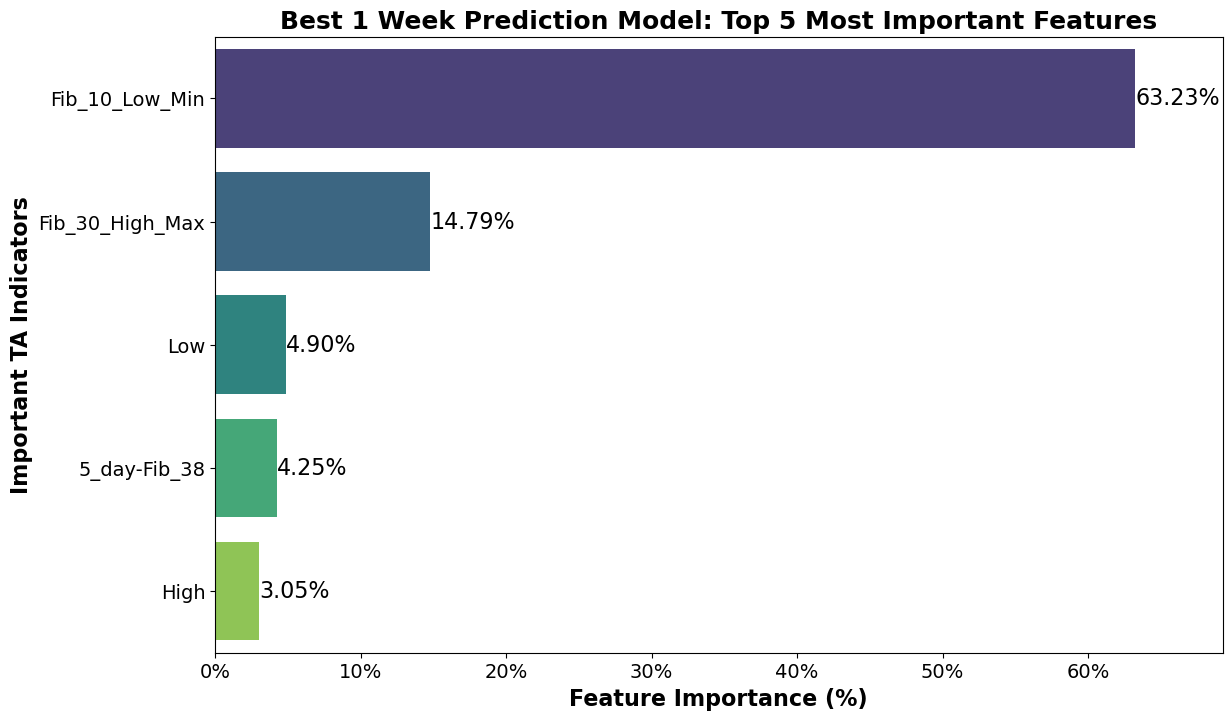

In [263]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert to NumPy arrays (ensuring correct types)
features = np.array([feature for feature, importance in sorted_features_1_week_md_7[:5]])  # Extract feature names
importances = np.array([importance for feature, importance in sorted_features_1_week_md_7[:5]])  # Extract importances

# Create a bar plot
plt.figure(figsize=(13, 8))
ax = sns.barplot(x=importances * 100, y=features, palette="viridis")

# Add text labels to the bars (feature importance values)
for i, v in enumerate(importances * 100):
    ax.text(v + 0.01, i, f"{v:.2f}%", va="center", fontsize=16)  # Adjust position & format

# Format x-axis labels to include % sign
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0f}%"))

# Extend x-axis limits for more space
plt.xlim(0, max(importances * 100) + 6)  # Extend to provide more space on the right

# Add labels and title
plt.xlabel("Feature Importance (%)", fontsize=16, fontweight='bold')  # Bigger x-axis title
plt.ylabel("Important TA Indicators", fontsize=16, fontweight='bold')  # Bigger y-axis title
plt.title("Best 1 Week Prediction Model: Top 5 Most Important Features", fontsize=18, fontweight='bold')  # Bigger title

# Increase font size for y-axis and x-axis tick labels (feature names)
ax.set_yticklabels(features, fontsize=14)
plt.xticks(fontsize=14)  # Increase font size for x-axis labels
# Show the plot
plt.show()


In [82]:
# first we will modify our feature set to add bigger lagging indicators.
# Create a new dataframe called 'df_stock_data_1_month' as a copy of 'df_stocks_price_ta'
df_stock_data_1_month = df_stocks_price_ta.copy()


In [83]:
# List of columns to create lags for (focusing on short-term indicators)
columns_to_lag = ['Close', 'SMA_5', 'EMA_5', 'Volume', 'EMA_12_MACD', 'SMA_20', 'EMA_20']

# Creating lag features for each column
# [1, 3, 5, 7, 10, 12, 15, 20, 30, 60, 90, 180, 360] are the lags we will use
# but to save space, we will only use necessary lags per the timeline goal of the model
# this first model will be predicting price 1 week ahead (5 trading days)
lags = [1, 3, 5, 7, 10, 12, 15, 20]
for col in columns_to_lag:
    for lag in lags:
        df_stock_data_1_month[f'{col}_lag_{lag}'] = df_stock_data_1_month[col].shift(lag)

# Do not drop NaN values to maintain continuity (XGBoost can handle NaNs)
# You can handle missing values in your model later, if needed
df_stock_data_1_month.head()

Symbol        Date  Close   High    Low     Volume      SMA_5     SMA_20  \
0   AAPL  2022-02-10  10.52  10.73  10.20  1037700.0  10.520000  10.520000   
1   AAPL  2022-02-11  10.09  10.49  10.02   480300.0  10.305000  10.305000   
2   AAPL  2022-02-14  10.22  10.46   9.97   724400.0  10.276667  10.276667   
3   AAPL  2022-02-15  10.56  10.57  10.22   758700.0  10.347500  10.347500   
4   AAPL  2022-02-16  10.44  10.55  10.39   685200.0  10.366000  10.366000   

      SMA_50      EMA_5  ...  SMA_20_lag_15  SMA_20_lag_20  EMA_20_lag_1  \
0  10.520000  10.520000  ...            NaN            NaN           NaN   
1  10.305000  10.376667  ...            NaN            NaN     10.520000   
2  10.276667  10.324445  ...            NaN            NaN     10.479048   
3  10.347500  10.402963  ...            NaN            NaN     10.454377   
4  10.366000  10.415309  ...            NaN            NaN     10.464436   

   EMA_20_lag_3  EMA_20_lag_5  EMA_20_lag_7  EMA_20_lag_10  EMA_20_lag_12  \
0           NaN           NaN           NaN            NaN            NaN   
1           NaN           NaN           NaN            NaN            NaN   
2           NaN           NaN           NaN            NaN            NaN   
3     10.520000           NaN           NaN            NaN            NaN   
4     10.479048           NaN           NaN            NaN            NaN   

   EMA_20_lag_15  EMA_20_lag_20  
0            NaN            NaN  
1            NaN            NaN  
2            NaN            NaN  
3            NaN            NaN  
4            NaN            NaN  

[5 rows x 110 columns]

In [271]:
# now we're going to move onto our next model: 1 month prediction
# we'll start at our baseline model and then do the same as we just did
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
df_stock_data_1_month = df_stock_data_1_month.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to January 10, 2024 for training
df_stock_data_train_1_month_baseline = df_stock_data_1_month[df_stock_data_1_month['Date'] <= '2024-01-10']

# Filter data to only include rows with Date after February 10, 2024 for testing
df_stock_data_test_1_month_baseline = df_stock_data_1_month[df_stock_data_1_month['Date'] > '2024-02-10']

# Check if the test set is empty
if df_stock_data_test_1_month_baseline.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 20 trading days ahead (1 month ahead)
df_stock_data_train_1_month_baseline['Close_Target'] = df_stock_data_train_1_month_baseline.groupby('Symbol')['Close'].shift(-20)
df_stock_data_test_1_month_baseline['Close_Target'] = df_stock_data_test_1_month_baseline.groupby('Symbol')['Close'].shift(-20)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
df_stock_data_train_1_month_baseline = df_stock_data_train_1_month_baseline.dropna(subset=['Close_Target'])
df_stock_data_test_1_month_baseline = df_stock_data_test_1_month_baseline.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
df_stock_data_train_1_month_baseline.replace([np.inf, -np.inf], np.nan, inplace=True)
df_stock_data_test_1_month_baseline.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = df_stock_data_train_1_month_baseline.select_dtypes(include=[np.number]).columns
numeric_cols_test = df_stock_data_test_1_month_baseline.select_dtypes(include=[np.number]).columns

df_stock_data_train_1_month_baseline[numeric_cols_train] = df_stock_data_train_1_month_baseline[numeric_cols_train].fillna(df_stock_data_train_1_month_baseline[numeric_cols_train].median())
df_stock_data_test_1_month_baseline[numeric_cols_test] = df_stock_data_test_1_month_baseline[numeric_cols_test].fillna(df_stock_data_test_1_month_baseline[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {df_stock_data_train_1_month_baseline.shape}")
print(f"Testing data shape: {df_stock_data_test_1_month_baseline.shape}")

# Create X (features) and y (target) for training
X_train_1_month_baseline = df_stock_data_train_1_month_baseline.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_1_month_baseline = df_stock_data_train_1_month_baseline['Close_Target']

# Create X and y for testing
X_test_1_month_baseline = df_stock_data_test_1_month_baseline.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_1_month_baseline = df_stock_data_test_1_month_baseline['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_1_month_baseline shape: {X_train_1_month_baseline.shape}, y_train_1_month_baseline shape: {y_train_1_month_baseline.shape}")
print(f"X_test_1_month_baseline shape: {X_test_1_month_baseline.shape}, y_test_1_month_baseline shape: {y_test_1_month_baseline.shape}")

# Ensure there are samples in both training and testing sets
if X_train_1_month_baseline.shape[0] == 0 or X_test_1_month_baseline.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_baseline_1_month = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_baseline_1_month.fit(X_train_1_month_baseline, y_train_1_month_baseline)

# Make predictions on the unseen test data (post-February 10, 2024)
y_pred_1_month_baseline = model_baseline_1_month.predict(X_test_1_month_baseline)

# Calculate performance on the test data
mse_test_1_month_baseline = mean_squared_error(y_test_1_month_baseline, y_pred_1_month_baseline)
print(f'Mean Squared Error on unseen data (post-February 10, 2024): {mse_test_1_month_baseline}')


/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/4202375805.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_train_1_month_baseline['Close_Target'] = df_stock_data_train_1_month_baseline.groupby('Symbol')['Close'].shift(-20)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/4202375805.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_test_1_month_baseline['Close_Target'] = df_stock_data_test_1_month_baseline.groupby('Symbol')['Close'].shift(-

Training data shape: (804275, 111)
Testing data shape: (412225, 111)
X_train_1_month_baseline shape: (804275, 107), y_train_1_month_baseline shape: (804275,)
X_test_1_month_baseline shape: (412225, 107), y_test_1_month_baseline shape: (412225,)
Mean Squared Error on unseen data (post-February 10, 2024): 11580.595262448778


In [272]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np


# Assuming `y_pred_1_month_baseline` are your predictions for the test data and `y_test_1_month_baseline` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_1_month_baseline = mean_squared_error(y_test_1_month_baseline, y_pred_1_month_baseline)
mae_1_month_baseline = mean_absolute_error(y_test_1_month_baseline, y_pred_1_month_baseline)
rmse_1_month_baseline = np.sqrt(mse_1_month_baseline)  # Root Mean Squared Error
r2_1_month_baseline = r2_score(y_test_1_month_baseline, y_pred_1_month_baseline)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_1_month_baseline}')
print(f'Mean Absolute Error on unseen data: {mae_1_month_baseline}')
print(f'Root Mean Squared Error on unseen data: {rmse_1_month_baseline}')
print(f'R-squared on unseen data: {r2_1_month_baseline}')

# Additional metrics
medae_1_month_baseline = median_absolute_error(y_test_1_month_baseline, y_pred_1_month_baseline)
print(f'Median Absolute Error on unseen data: {medae_1_month_baseline}')

dw_stat_1_month_baseline = durbin_watson(y_test_1_month_baseline - y_pred_1_month_baseline)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_month_baseline}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_month_baseline = np.mean(np.abs((y_test_1_month_baseline - y_pred_1_month_baseline) / y_test_1_month_baseline)) * 100
print(f'MAPE on unseen data: {mape_1_month_baseline:.2f}%')
# Get feature importance as a dictionary
feature_importance_1_month_baseline = dict(zip(X_train_1_month_baseline.columns, model_baseline_1_month.feature_importances_))

# Sort features by importance in descending order
sorted_features_1_month_baseline = sorted(feature_importance_1_month_baseline.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_1_month_baseline:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 11580.595262448778
Mean Absolute Error on unseen data: 16.106877200112017
Root Mean Squared Error on unseen data: 107.61317420487502
R-squared on unseen data: 0.9480862120608777
Median Absolute Error on unseen data: 3.451629638671875
Durbin-Watson Statistic on unseen data: 0.07080939887518617
MAPE on unseen data: 7.98%
Fib_30_High_Max: 35.64%
30_day_Fib_23: 31.34%
High: 5.57%
Fib_30_Low_Min: 5.56%
Low: 5.24%
EMA_5: 3.63%
30_day_Fib_50: 2.97%
Volume: 2.96%
Fib_5_Low_Min: 1.49%
Fib_5_High_Max: 0.85%
EMA_26_MACD: 0.55%
10_day_Fib_38: 0.52%
ATR_Prev_Close: 0.41%
Fib_10_Low_Min: 0.40%
5_day-Fib_23: 0.36%
SMA_5: 0.35%
VWAP: 0.35%
Cumulative_Price_Volume: 0.29%
Std_Dev: 0.21%
Fib_10_High_Max: 0.21%
Lower_Band: 0.15%
ATR_True_Range: 0.12%
30_day_Fib_61: 0.11%
EMA_50: 0.09%
SMA_50: 0.09%
ATR: 0.06%
Upper_Band: 0.06%
Cumulative_Volume: 0.05%
EMA_20_lag_20: 0.04%
SMA_5_lag_15: 0.04%
EMA_12_MACD_lag_12: 0.03%
Volume_lag_1: 0.03%
Volume_lag_20: 0.02%
ATR_High_Low:

In [86]:
# Get feature importance from the baseline model (1-week prediction)
feature_importance = dict(zip(X_train.columns, model_baseline_1_month.feature_importances_))

# Filter features with importance greater than 1%
important_features = {feature: importance for feature, importance in feature_importance.items() if importance > 0.01}

# Sort features by importance in descending order
sorted_important_features = sorted(important_features.items(), key=lambda x: x[1], reverse=True)

# Extract the feature names (keys) into a list
important_feature_names = [feature for feature, importance in sorted_important_features]

# Print the sorted important features (optional)
print("Features with more than 1% contribution:")
for feature in sorted_important_features:
    print(f"{feature[0]}: {feature[1] * 100:.2f}%")

# The list of important features that you can use to create a new dataframe
print("List of important features:")
print(important_feature_names)




Features with more than 1% contribution:
Fib_30_High_Max: 35.64%
30_day_Fib_23: 31.34%
High: 5.57%
Fib_30_Low_Min: 5.56%
Low: 5.24%
EMA_5: 3.63%
30_day_Fib_50: 2.97%
Volume: 2.96%
Fib_5_Low_Min: 1.49%
List of important features:
['Fib_30_High_Max', '30_day_Fib_23', 'High', 'Fib_30_Low_Min', 'Low', 'EMA_5', '30_day_Fib_50', 'Volume', 'Fib_5_Low_Min']


In [87]:
important_features = ['Symbol', 'Date', 'Close', 'Fib_30_High_Max', '30_day_Fib_23',
                      'High', 'Low', 'Fib_30_Low_Min', 'Volume', 'EMA_5', '30_day_Fib_50',
                      'Fib_5_Low_Min']
df_important_feat_1_month = df_stock_data_1_month[important_features]
df_important_feat_1_month.head()

Symbol        Date      Close  Fib_30_High_Max  30_day_Fib_23  \
171141      A  2022-02-10  50.058052        51.174088      50.877780   
171142      A  2022-02-11  47.580647        51.174088      50.244295   
171143      A  2022-02-14  47.210232        51.174088      50.140984   
171144      A  2022-02-15  48.759216        51.174088      50.140984   
171145      A  2022-02-16  49.629917        51.174088      50.140984   

             High        Low  Fib_30_Low_Min     Volume      EMA_5  \
171141  51.174088  49.918547       49.918547  1889800.0  50.058052   
171142  49.028604  47.234290       47.234290  3747400.0  49.232250   
171143  47.460380  46.796529       46.796529  3157800.0  48.558244   
171144  49.153677  48.427291       46.796529  1900000.0  48.625235   
171145  49.716506  48.855427       46.796529  2010600.0  48.960129   

        30_day_Fib_50  Fib_5_Low_Min  
171141      50.546317      49.918547  
171142      49.204189      47.234290  
171143      48.985308      46.796529  
171144      48.985308      46.796529  
171145      48.985308      46.796529

In [273]:
# baseline 1 month prediction model with only features contributing over 1%
# not as good as baseline
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
df_important_feat_1_month = df_important_feat_1_month.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to January 10, 2024 for training
df_stock_data_train_1_month_if = df_important_feat_1_month[df_important_feat_1_month['Date'] <= '2024-01-10']

# Filter data to only include rows with Date after February 10, 2024 for testing
df_stock_data_test_1_month_if = df_important_feat_1_month[df_important_feat_1_month['Date'] > '2024-02-10']

# Check if the test set is empty
if df_stock_data_test_1_month_if.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 20 trading days ahead (1 month ahead)
df_stock_data_train_1_month_if['Close_Target'] = df_stock_data_train_1_month_if.groupby('Symbol')['Close'].shift(-20)
df_stock_data_test_1_month_if['Close_Target'] = df_stock_data_test_1_month_if.groupby('Symbol')['Close'].shift(-20)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
df_stock_data_train_1_month_if = df_stock_data_train_1_month_if.dropna(subset=['Close_Target'])
df_stock_data_test_1_month_if = df_stock_data_test_1_month_if.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
df_stock_data_train_1_month_if.replace([np.inf, -np.inf], np.nan, inplace=True)
df_stock_data_test_1_month_if.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = df_stock_data_train_1_month_if.select_dtypes(include=[np.number]).columns
numeric_cols_test = df_stock_data_test_1_month_if.select_dtypes(include=[np.number]).columns

df_stock_data_train_1_month_if[numeric_cols_train] = df_stock_data_train_1_month_if[numeric_cols_train].fillna(df_stock_data_train_1_month_if[numeric_cols_train].median())
df_stock_data_test_1_month_if[numeric_cols_test] = df_stock_data_test_1_month_if[numeric_cols_test].fillna(df_stock_data_test_1_month_if[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {df_stock_data_train_1_month_if.shape}")
print(f"Testing data shape: {df_stock_data_test_1_month_if.shape}")

# Create X (features) and y (target) for training
X_train_1_month_if = df_stock_data_train_1_month_if.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_1_month_if = df_stock_data_train_1_month_if['Close_Target']

# Create X and y for testing
X_test_1_month_if = df_stock_data_test_1_month_if.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_1_month_if = df_stock_data_test_1_month_if['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_1_month_if shape: {X_train_1_month_if.shape}, y_train_1_month_if shape: {y_train_1_month_if.shape}")
print(f"X_test_1_month_if shape: {X_test_1_month_if.shape}, y_test_1_month_if shape: {y_test_1_month_if.shape}")

# Ensure there are samples in both training and testing sets
if X_train_1_month_if.shape[0] == 0 or X_test_1_month_if.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_baseline_if_1_month = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_baseline_if_1_month.fit(X_train_1_month_if, y_train_1_month_if)

# Make predictions on the unseen test data (post-February 10, 2024)
y_pred_1_month_if = model_baseline_if_1_month.predict(X_test_1_month_if)

# Calculate performance on the test data
mse_test_1_month_if = mean_squared_error(y_test_1_month_if, y_pred_1_month_if)
print(f'Mean Squared Error on unseen data (post-February 10, 2024): {mse_test_1_month_if}')


/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/932682732.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_train_1_month_if['Close_Target'] = df_stock_data_train_1_month_if.groupby('Symbol')['Close'].shift(-20)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/932682732.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_test_1_month_if['Close_Target'] = df_stock_data_test_1_month_if.groupby('Symbol')['Close'].shift(-20)


Training data shape: (804275, 13)
Testing data shape: (412225, 13)
X_train_1_month_if shape: (804275, 9), y_train_1_month_if shape: (804275,)
X_test_1_month_if shape: (412225, 9), y_test_1_month_if shape: (412225,)
Mean Squared Error on unseen data (post-February 10, 2024): 32079.230668815384


In [274]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Assuming `y_pred_1_month_if` are your predictions for the test data and `y_test_1_month_if` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_1_month_if = mean_squared_error(y_test_1_month_if, y_pred_1_month_if)
mae_1_month_if = mean_absolute_error(y_test_1_month_if, y_pred_1_month_if)
rmse_1_month_if = np.sqrt(mse_1_month_if)  # Root Mean Squared Error
r2_1_month_if = r2_score(y_test_1_month_if, y_pred_1_month_if)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_1_month_if}')
print(f'Mean Absolute Error on unseen data: {mae_1_month_if}')
print(f'Root Mean Squared Error on unseen data: {rmse_1_month_if}')
print(f'R-squared on unseen data: {r2_1_month_if}')

# Additional metrics
medae_1_month_if = median_absolute_error(y_test_1_month_if, y_pred_1_month_if)
print(f'Median Absolute Error on unseen data: {medae_1_month_if}')

dw_stat_1_month_if = durbin_watson(y_test_1_month_if - y_pred_1_month_if)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_month_if}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_month_if = np.mean(np.abs((y_test_1_month_if - y_pred_1_month_if) / y_test_1_month_if)) * 100
print(f'MAPE on unseen data: {mape_1_month_if:.2f}%')
# Get feature importance as a dictionary
feature_importance_1_month_if = dict(zip(X_train_1_month_if.columns, model_baseline_if_1_month.feature_importances_))

# Sort features by importance in descending order
sorted_features_1_month_if = sorted(feature_importance_1_month_if.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_1_month_if:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 32079.230668815384
Mean Absolute Error on unseen data: 21.58220780969353
Root Mean Squared Error on unseen data: 179.10675774189923
R-squared on unseen data: 0.8561944062071536
Median Absolute Error on unseen data: 3.2651214599609375
Durbin-Watson Statistic on unseen data: 0.04222523242030978
MAPE on unseen data: 7.63%
Fib_30_High_Max: 38.32%
30_day_Fib_23: 25.10%
High: 12.95%
Low: 11.06%
Fib_30_Low_Min: 5.84%
Volume: 2.25%
30_day_Fib_50: 1.67%
EMA_5: 1.61%
Fib_5_Low_Min: 1.19%


In [275]:
# 1 month baseline model with learning_rate=0.1
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
df_stock_data_1_month = df_stock_data_1_month.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to January 10, 2024 for training
df_stock_data_train_1_month_lr_1 = df_stock_data_1_month[df_stock_data_1_month['Date'] <= '2024-01-10']

# Filter data to only include rows with Date after February 10, 2024 for testing
df_stock_data_test_1_month_lr_1 = df_stock_data_1_month[df_stock_data_1_month['Date'] > '2024-02-10']

# Check if the test set is empty
if df_stock_data_test_1_month_lr_1.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 20 trading days ahead (1 month ahead)
df_stock_data_train_1_month_lr_1['Close_Target'] = df_stock_data_train_1_month_lr_1.groupby('Symbol')['Close'].shift(-20)
df_stock_data_test_1_month_lr_1['Close_Target'] = df_stock_data_test_1_month_lr_1.groupby('Symbol')['Close'].shift(-20)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
df_stock_data_train_1_month_lr_1 = df_stock_data_train_1_month_lr_1.dropna(subset=['Close_Target'])
df_stock_data_test_1_month_lr_1 = df_stock_data_test_1_month_lr_1.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
df_stock_data_train_1_month_lr_1.replace([np.inf, -np.inf], np.nan, inplace=True)
df_stock_data_test_1_month_lr_1.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = df_stock_data_train_1_month_lr_1.select_dtypes(include=[np.number]).columns
numeric_cols_test = df_stock_data_test_1_month_lr_1.select_dtypes(include=[np.number]).columns

df_stock_data_train_1_month_lr_1[numeric_cols_train] = df_stock_data_train_1_month_lr_1[numeric_cols_train].fillna(df_stock_data_train_1_month_lr_1[numeric_cols_train].median())
df_stock_data_test_1_month_lr_1[numeric_cols_test] = df_stock_data_test_1_month_lr_1[numeric_cols_test].fillna(df_stock_data_test_1_month_lr_1[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {df_stock_data_train_1_month_lr_1.shape}")
print(f"Testing data shape: {df_stock_data_test_1_month_lr_1.shape}")

# Create X (features) and y (target) for training
X_train_1_month_lr_1 = df_stock_data_train_1_month_lr_1.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_1_month_lr_1 = df_stock_data_train_1_month_lr_1['Close_Target']

# Create X and y for testing
X_test_1_month_lr_1 = df_stock_data_test_1_month_lr_1.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_1_month_lr_1 = df_stock_data_test_1_month_lr_1['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_1_month_lr_1 shape: {X_train_1_month_lr_1.shape}, y_train_1_month_lr_1 shape: {y_train_1_month_lr_1.shape}")
print(f"X_test_1_month_lr_1 shape: {X_test_1_month_lr_1.shape}, y_test_1_month_lr_1 shape: {y_test_1_month_lr_1.shape}")

# Ensure there are samples in both training and testing sets
if X_train_1_month_lr_1.shape[0] == 0 or X_test_1_month_lr_1.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_1_month_tr_01 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_1_month_tr_01.fit(X_train_1_month_lr_1, y_train_1_month_lr_1)

# Make predictions on the unseen test data (post-February 10, 2024)
y_pred_1_month_lr_1 = model_1_month_tr_01.predict(X_test_1_month_lr_1)

# Calculate performance on the test data
mse_test_1_month_lr_1 = mean_squared_error(y_test_1_month_lr_1, y_pred_1_month_lr_1)
print(f'Mean Squared Error on unseen data (post-February 10, 2024): {mse_test_1_month_lr_1}')


/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/52133327.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_train_1_month_lr_1['Close_Target'] = df_stock_data_train_1_month_lr_1.groupby('Symbol')['Close'].shift(-20)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/52133327.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_test_1_month_lr_1['Close_Target'] = df_stock_data_test_1_month_lr_1.groupby('Symbol')['Close'].shift(-20)


Training data shape: (804275, 111)
Testing data shape: (412225, 111)
X_train_1_month_lr_1 shape: (804275, 107), y_train_1_month_lr_1 shape: (804275,)
X_test_1_month_lr_1 shape: (412225, 107), y_test_1_month_lr_1 shape: (412225,)
Mean Squared Error on unseen data (post-February 10, 2024): 12131.686683682172


In [276]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Assuming `y_pred_1_month_lr_1` are your predictions for the test data and `y_test_1_month_lr_1` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_1_month_lr_1 = mean_squared_error(y_test_1_month_lr_1, y_pred_1_month_lr_1)
mae_1_month_lr_1 = mean_absolute_error(y_test_1_month_lr_1, y_pred_1_month_lr_1)
rmse_1_month_lr_1 = np.sqrt(mse_1_month_lr_1)  # Root Mean Squared Error
r2_1_month_lr_1 = r2_score(y_test_1_month_lr_1, y_pred_1_month_lr_1)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_1_month_lr_1}')
print(f'Mean Absolute Error on unseen data: {mae_1_month_lr_1}')
print(f'Root Mean Squared Error on unseen data: {rmse_1_month_lr_1}')
print(f'R-squared on unseen data: {r2_1_month_lr_1}')

# Additional metrics
medae_1_month_lr_1 = median_absolute_error(y_test_1_month_lr_1, y_pred_1_month_lr_1)
print(f'Median Absolute Error on unseen data: {medae_1_month_lr_1}')

dw_stat_1_month_lr_1 = durbin_watson(y_test_1_month_lr_1 - y_pred_1_month_lr_1)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_month_lr_1}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_month_lr_1 = np.mean(np.abs((y_test_1_month_lr_1 - y_pred_1_month_lr_1) / y_test_1_month_lr_1)) * 100
print(f'MAPE on unseen data: {mape_1_month_lr_1:.2f}%')
# Get feature importance as a dictionary
feature_importance_1_month_lr_1 = dict(zip(X_train_1_month_lr_1.columns, model_1_month_tr_01.feature_importances_))

# Sort features by importance in descending order
sorted_features_1_month_lr_1 = sorted(feature_importance_1_month_lr_1.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_1_month_lr_1:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 12131.686683682172
Mean Absolute Error on unseen data: 16.7761954501155
Root Mean Squared Error on unseen data: 110.14393620931736
R-squared on unseen data: 0.9456157653758314
Median Absolute Error on unseen data: 3.590789794921875
Durbin-Watson Statistic on unseen data: 0.06393498702616922
MAPE on unseen data: 8.30%
Fib_30_High_Max: 39.63%
30_day_Fib_23: 25.74%
Low: 6.83%
High: 6.59%
Fib_30_Low_Min: 4.69%
30_day_Fib_50: 4.25%
Volume: 3.47%
EMA_5: 2.92%
Fib_5_Low_Min: 0.77%
Fib_10_Low_Min: 0.64%
Fib_5_High_Max: 0.63%
10_day_Fib_38: 0.57%
ATR_Prev_Close: 0.54%
EMA_26_MACD: 0.53%
Cumulative_Price_Volume: 0.36%
VWAP: 0.35%
Std_Dev: 0.24%
Lower_Band: 0.15%
5_day-Fib_23: 0.15%
ATR_True_Range: 0.14%
EMA_50: 0.08%
Cumulative_Volume: 0.05%
ATR: 0.05%
SMA_5_lag_15: 0.05%
30_day_Fib_38: 0.05%
SMA_50: 0.05%
30_day_Fib_61: 0.05%
EMA_20_lag_20: 0.04%
Upper_Band: 0.04%
Volume_lag_1: 0.03%
Fib_10_High_Max: 0.03%
EMA_12_MACD_lag_12: 0.02%
ATR_High_Low: 0.01%
Volume_l

In [277]:
# 1 month baseline model with learning_rate=0.01
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
df_stock_data_1_month = df_stock_data_1_month.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to January 10, 2024 for training
df_stock_data_train_1_month_lr_01 = df_stock_data_1_month[df_stock_data_1_month['Date'] <= '2024-01-10']

# Filter data to only include rows with Date after February 10, 2024 for testing
df_stock_data_test_1_month_lr_01 = df_stock_data_1_month[df_stock_data_1_month['Date'] > '2024-02-10']

# Check if the test set is empty
if df_stock_data_test_1_month_lr_01.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 20 trading days ahead (1 month ahead)
df_stock_data_train_1_month_lr_01['Close_Target'] = df_stock_data_train_1_month_lr_01.groupby('Symbol')['Close'].shift(-20)
df_stock_data_test_1_month_lr_01['Close_Target'] = df_stock_data_test_1_month_lr_01.groupby('Symbol')['Close'].shift(-20)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
df_stock_data_train_1_month_lr_01 = df_stock_data_train_1_month_lr_01.dropna(subset=['Close_Target'])
df_stock_data_test_1_month_lr_01 = df_stock_data_test_1_month_lr_01.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
df_stock_data_train_1_month_lr_01.replace([np.inf, -np.inf], np.nan, inplace=True)
df_stock_data_test_1_month_lr_01.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = df_stock_data_train_1_month_lr_01.select_dtypes(include=[np.number]).columns
numeric_cols_test = df_stock_data_test_1_month_lr_01.select_dtypes(include=[np.number]).columns

df_stock_data_train_1_month_lr_01[numeric_cols_train] = df_stock_data_train_1_month_lr_01[numeric_cols_train].fillna(df_stock_data_train_1_month_lr_01[numeric_cols_train].median())
df_stock_data_test_1_month_lr_01[numeric_cols_test] = df_stock_data_test_1_month_lr_01[numeric_cols_test].fillna(df_stock_data_test_1_month_lr_01[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {df_stock_data_train_1_month_lr_01.shape}")
print(f"Testing data shape: {df_stock_data_test_1_month_lr_01.shape}")

# Create X (features) and y (target) for training
X_train_1_month_lr_01 = df_stock_data_train_1_month_lr_01.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_1_month_lr_01 = df_stock_data_train_1_month_lr_01['Close_Target']

# Create X and y for testing
X_test_1_month_lr_01 = df_stock_data_test_1_month_lr_01.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_1_month_lr_01 = df_stock_data_test_1_month_lr_01['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_1_month_lr_01 shape: {X_train_1_month_lr_01.shape}, y_train_1_month_lr_01 shape: {y_train_1_month_lr_01.shape}")
print(f"X_test_1_month_lr_01 shape: {X_test_1_month_lr_01.shape}, y_test_1_month_lr_01 shape: {y_test_1_month_lr_01.shape}")

# Ensure there are samples in both training and testing sets
if X_train_1_month_lr_01.shape[0] == 0 or X_test_1_month_lr_01.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_1_month_tr_1 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_1_month_tr_1.fit(X_train_1_month_lr_01, y_train_1_month_lr_01)

# Make predictions on the unseen test data (post-February 10, 2024)
y_pred_1_month_lr_01 = model_1_month_tr_1.predict(X_test_1_month_lr_01)

# Calculate performance on the test data
mse_test_1_month_lr_01 = mean_squared_error(y_test_1_month_lr_01, y_pred_1_month_lr_01)
print(f'Mean Squared Error on unseen data (post-February 10, 2024): {mse_test_1_month_lr_01}')


/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1410818009.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_train_1_month_lr_01['Close_Target'] = df_stock_data_train_1_month_lr_01.groupby('Symbol')['Close'].shift(-20)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1410818009.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_test_1_month_lr_01['Close_Target'] = df_stock_data_test_1_month_lr_01.groupby('Symbol')['Close'].shift(-20)


Training data shape: (804275, 111)
Testing data shape: (412225, 111)
X_train_1_month_lr_01 shape: (804275, 107), y_train_1_month_lr_01 shape: (804275,)
X_test_1_month_lr_01 shape: (412225, 107), y_test_1_month_lr_01 shape: (412225,)
Mean Squared Error on unseen data (post-February 10, 2024): 11047.206778467535


In [278]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np


# Assuming `y_pred_1_month_lr_01` are your predictions for the test data and `y_test_1_month_lr_01` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_month_lr_01 = mean_squared_error(y_test_1_month_lr_01, y_pred_1_month_lr_01)
mae_1_month_lr_01 = mean_absolute_error(y_test_1_month_lr_01, y_pred_1_month_lr_01)
rmse_month_lr_01 = np.sqrt(mse_month_lr_01)  # Root Mean Squared Error
r2_month_lr_01 = r2_score(y_test_1_month_lr_01, y_pred_1_month_lr_01)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_month_lr_01}')
print(f'Mean Absolute Error on unseen data: {mae_1_month_lr_01}')
print(f'Root Mean Squared Error on unseen data: {rmse_month_lr_01}')
print(f'R-squared on unseen data: {r2_month_lr_01}')

# Additional metrics
medae_1_month_lr_01 = median_absolute_error(y_test_1_month_lr_01, y_pred_1_month_lr_01)
print(f'Median Absolute Error on unseen data: {medae_1_month_lr_01}')

dw_stat_1_month_lr_01 = durbin_watson(y_test_1_month_lr_01 - y_pred_1_month_lr_01)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_month_lr_01}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_month_lr_01 = np.mean(np.abs((y_test_1_month_lr_01 - y_pred_1_month_lr_01) / y_test_1_month_lr_01)) * 100
print(f'MAPE on unseen data: {mape_1_month_lr_01:.2f}%')
# Get feature importance as a dictionary
feature_importance_month_lr_01 = dict(zip(X_train_1_month_lr_01.columns, model_1_month_tr_01.feature_importances_))

# Sort features by importance in descending order
sorted_features_1_month_lr_01 = sorted(feature_importance_month_lr_01.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_1_month_lr_01:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 11047.206778467535
Mean Absolute Error on unseen data: 15.37042669814166
Root Mean Squared Error on unseen data: 105.10569336847331
R-squared on unseen data: 0.9504772995670925
Median Absolute Error on unseen data: 3.3103179931640625
Durbin-Watson Statistic on unseen data: 0.07154779960843687
MAPE on unseen data: 8.15%
Fib_30_High_Max: 39.63%
30_day_Fib_23: 25.74%
Low: 6.83%
High: 6.59%
Fib_30_Low_Min: 4.69%
30_day_Fib_50: 4.25%
Volume: 3.47%
EMA_5: 2.92%
Fib_5_Low_Min: 0.77%
Fib_10_Low_Min: 0.64%
Fib_5_High_Max: 0.63%
10_day_Fib_38: 0.57%
ATR_Prev_Close: 0.54%
EMA_26_MACD: 0.53%
Cumulative_Price_Volume: 0.36%
VWAP: 0.35%
Std_Dev: 0.24%
Lower_Band: 0.15%
5_day-Fib_23: 0.15%
ATR_True_Range: 0.14%
EMA_50: 0.08%
Cumulative_Volume: 0.05%
ATR: 0.05%
SMA_5_lag_15: 0.05%
30_day_Fib_38: 0.05%
SMA_50: 0.05%
30_day_Fib_61: 0.05%
EMA_20_lag_20: 0.04%
Upper_Band: 0.04%
Volume_lag_1: 0.03%
Fib_10_High_Max: 0.03%
EMA_12_MACD_lag_12: 0.02%
ATR_High_Low: 0.01%
Volume

In [279]:
# model with learning_rate = 0.01 is best again, so we keep that parameter
# now we'll do max depth
# max depth = 3
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
df_stock_data_1_month = df_stock_data_1_month.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to January 10, 2024 for training
df_stock_data_train_1_month_md_3 = df_stock_data_1_month[df_stock_data_1_month['Date'] <= '2024-01-10']

# Filter data to only include rows with Date after February 10, 2024 for testing
df_stock_data_test_1_month_md_3 = df_stock_data_1_month[df_stock_data_1_month['Date'] > '2024-02-10']

# Check if the test set is empty
if df_stock_data_test_1_month_md_3.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 20 trading days ahead (1 month ahead)
df_stock_data_train_1_month_md_3['Close_Target'] = df_stock_data_train_1_month_md_3.groupby('Symbol')['Close'].shift(-20)
df_stock_data_test_1_month_md_3['Close_Target'] = df_stock_data_test_1_month_md_3.groupby('Symbol')['Close'].shift(-20)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
df_stock_data_train_1_month_md_3 = df_stock_data_train_1_month_md_3.dropna(subset=['Close_Target'])
df_stock_data_test_1_month_md_3 = df_stock_data_test_1_month_md_3.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
df_stock_data_train_1_month_md_3.replace([np.inf, -np.inf], np.nan, inplace=True)
df_stock_data_test_1_month_md_3.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = df_stock_data_train_1_month_md_3.select_dtypes(include=[np.number]).columns
numeric_cols_test = df_stock_data_test_1_month_md_3.select_dtypes(include=[np.number]).columns

df_stock_data_train_1_month_md_3[numeric_cols_train] = df_stock_data_train_1_month_md_3[numeric_cols_train].fillna(df_stock_data_train_1_month_md_3[numeric_cols_train].median())
df_stock_data_test_1_month_md_3[numeric_cols_test] = df_stock_data_test_1_month_md_3[numeric_cols_test].fillna(df_stock_data_test_1_month_md_3[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {df_stock_data_train_1_month_md_3.shape}")
print(f"Testing data shape: {df_stock_data_test_1_month_md_3.shape}")

# Create X (features) and y (target) for training
X_train_1_month_md_3 = df_stock_data_train_1_month_md_3.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_1_month_md_3 = df_stock_data_train_1_month_md_3['Close_Target']

# Create X and y for testing
X_test_1_month_md_3 = df_stock_data_test_1_month_md_3.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_1_month_md_3 = df_stock_data_test_1_month_md_3['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_1_month_md_3 shape: {X_train_1_month_md_3.shape}, y_train_1_month_md_3 shape: {y_train_1_month_md_3.shape}")
print(f"X_test_1_month_md_3 shape: {X_test_1_month_md_3.shape}, y_test_1_month_md_3 shape: {y_test_1_month_md_3.shape}")

# Ensure there are samples in both training and testing sets
if X_train_1_month_md_3.shape[0] == 0 or X_test_1_month_md_3.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_1_month_md_3 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=3,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_1_month_md_3.fit(X_train_1_month_md_3, y_train_1_month_md_3)

# Make predictions on the unseen test data (post-February 10, 2024)
y_pred_1_month_md_3 = model_1_month_md_3.predict(X_test_1_month_md_3)

# Calculate performance on the test data
mse_test_1_month_md_3 = mean_squared_error(y_test_1_month_md_3, y_pred_1_month_md_3)
print(f'Mean Squared Error on unseen data (post-February 10, 2024): {mse_test_1_month_md_3}')


/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/2069121884.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_train_1_month_md_3['Close_Target'] = df_stock_data_train_1_month_md_3.groupby('Symbol')['Close'].shift(-20)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/2069121884.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_test_1_month_md_3['Close_Target'] = df_stock_data_test_1_month_md_3.groupby('Symbol')['Close'].shift(-20)


Training data shape: (804275, 111)
Testing data shape: (412225, 111)
X_train_1_month_md_3 shape: (804275, 107), y_train_1_month_md_3 shape: (804275,)
X_test_1_month_md_3 shape: (412225, 107), y_test_1_month_md_3 shape: (412225,)
Mean Squared Error on unseen data (post-February 10, 2024): 12105.89455732451


In [280]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np


# Assuming `y_pred_1_month_md_3` are your predictions for the test data and `y_test_1_month_md_3` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_1_month_md_3 = mean_squared_error(y_test_1_month_md_3, y_pred_1_month_md_3)
mae_1_month_md_3 = mean_absolute_error(y_test_1_month_md_3, y_pred_1_month_md_3)
rmse_1_month_md_3 = np.sqrt(mse_1_month_md_3)  # Root Mean Squared Error
r2_1_month_md_3 = r2_score(y_test_1_month_md_3, y_pred_1_month_md_3)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_1_month_md_3}')
print(f'Mean Absolute Error on unseen data: {mae_1_month_md_3}')
print(f'Root Mean Squared Error on unseen data: {rmse_1_month_md_3}')
print(f'R-squared on unseen data: {r2_1_month_md_3}')

# Additional metrics
medae_1_month_md_3 = median_absolute_error(y_test_1_month_md_3, y_pred_1_month_md_3)
print(f'Median Absolute Error on unseen data: {medae_1_month_md_3}')

dw_stat_1_month_md_3 = durbin_watson(y_test_1_month_md_3 - y_pred_1_month_md_3)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_month_md_3}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_month_md_3 = np.mean(np.abs((y_test_1_month_md_3 - y_pred_1_month_md_3) / y_test_1_month_md_3)) * 100
print(f'MAPE on unseen data: {mape_1_month_md_3:.2f}%')
# Get feature importance as a dictionary
feature_importance_1_month_md_3 = dict(zip(X_train_1_month_md_3.columns, model_1_month_md_3.feature_importances_))

# Sort features by importance in descending order
sorted_features_1_month_md_3 = sorted(feature_importance_1_month_md_3.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_1_month_md_3:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 12105.89455732451
Mean Absolute Error on unseen data: 15.257036908276845
Root Mean Squared Error on unseen data: 110.02679018004892
R-squared on unseen data: 0.9457313869779931
Median Absolute Error on unseen data: 3.3381423950195312
Durbin-Watson Statistic on unseen data: 0.04725178854812182
MAPE on unseen data: 9.04%
Fib_30_High_Max: 46.42%
30_day_Fib_23: 6.82%
Fib_30_Low_Min: 6.65%
Upper_Band: 6.59%
10_day_Fib_50: 5.20%
10_day_Fib_38: 3.55%
Low: 2.03%
Volume: 1.97%
Close_lag_1: 1.91%
High: 1.82%
EMA_20: 1.80%
EMA_5: 1.52%
30_day_Fib_61: 1.43%
Fib_10_Low_Min: 1.35%
EMA_5_lag_15: 1.30%
Fib_5_High_Max: 0.90%
SMA_50: 0.88%
ATR: 0.79%
VWAP: 0.69%
EMA_50: 0.66%
ATR_High_Low: 0.64%
Fib_5_Low_Min: 0.57%
EMA_26_MACD: 0.49%
Fib_10_High_Max: 0.46%
Close_lag_20: 0.43%
30_day_Fib_50: 0.40%
Lower_Band: 0.35%
ATR_True_Range: 0.30%
Volume_lag_1: 0.28%
Std_Dev: 0.26%
ATR_Prev_Close: 0.24%
SMA_20_lag_20: 0.21%
Cumulative_Price_Volume: 0.18%
30_day_Fib_38: 0.13%
Volu

In [265]:
# model with learning_rate = 0.01 is best again, so we keep that parameter
# now we'll do max depth
# max depth = 7
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
df_stock_data_1_month = df_stock_data_1_month.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to January 10, 2024 for training
df_stock_data_train_1_month_md_7 = df_stock_data_1_month[df_stock_data_1_month['Date'] <= '2024-01-10']

# Filter data to only include rows with Date after February 10, 2024 for testing
df_stock_data_test_1_month_md_7 = df_stock_data_1_month[df_stock_data_1_month['Date'] > '2024-02-10']

# Check if the test set is empty
if df_stock_data_test_1_month_md_7.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 20 trading days ahead (1 month ahead)
df_stock_data_train_1_month_md_7['Close_Target'] = df_stock_data_train_1_month_md_7.groupby('Symbol')['Close'].shift(-20)
df_stock_data_test_1_month_md_7['Close_Target'] = df_stock_data_test_1_month_md_7.groupby('Symbol')['Close'].shift(-20)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
df_stock_data_train_1_month_md_7 = df_stock_data_train_1_month_md_7.dropna(subset=['Close_Target'])
df_stock_data_test_1_month_md_7 = df_stock_data_test_1_month_md_7.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
df_stock_data_train_1_month_md_7.replace([np.inf, -np.inf], np.nan, inplace=True)
df_stock_data_test_1_month_md_7.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = df_stock_data_train_1_month_md_7.select_dtypes(include=[np.number]).columns
numeric_cols_test = df_stock_data_test_1_month_md_7.select_dtypes(include=[np.number]).columns

df_stock_data_train_1_month_md_7[numeric_cols_train] = df_stock_data_train_1_month_md_7[numeric_cols_train].fillna(df_stock_data_train_1_month_md_7[numeric_cols_train].median())
df_stock_data_test_1_month_md_7[numeric_cols_test] = df_stock_data_test_1_month_md_7[numeric_cols_test].fillna(df_stock_data_test_1_month_md_7[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {df_stock_data_train_1_month_md_7.shape}")
print(f"Testing data shape: {df_stock_data_test_1_month_md_7.shape}")

# Create X (features) and y (target) for training
X_train_1_month_md_7 = df_stock_data_train_1_month_md_7.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_1_month_md_7 = df_stock_data_train_1_month_md_7['Close_Target']

# Create X and y for testing
X_test_1_month_md_7 = df_stock_data_test_1_month_md_7.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_1_month_md_7 = df_stock_data_test_1_month_md_7['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_1_month_md_7 shape: {X_train_1_month_md_7.shape}, y_train_1_month_md_7 shape: {y_train_1_month_md_7.shape}")
print(f"X_test_1_month_md_7 shape: {X_test_1_month_md_7.shape}, y_test_1_month_md_7 shape: {y_test_1_month_md_7.shape}")

# Ensure there are samples in both training and testing sets
if X_train_1_month_md_7.shape[0] == 0 or X_test_1_month_md_7.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_1_month_md_7 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=7,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_1_month_md_7.fit(X_train_1_month_md_7, y_train_1_month_md_7)

# Make predictions on the unseen test data (post-February 10, 2024)
y_pred_1_month_md_7 = model_1_month_md_7.predict(X_test_1_month_md_7)

# Calculate performance on the test data
mse_test_1_month_md_7 = mean_squared_error(y_test_1_month_md_7, y_pred_1_month_md_7)
print(f'Mean Squared Error on unseen data (post-February 10, 2024): {mse_test_1_month_md_7}')


/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/3558892380.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_train_1_month_md_7['Close_Target'] = df_stock_data_train_1_month_md_7.groupby('Symbol')['Close'].shift(-20)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/3558892380.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_test_1_month_md_7['Close_Target'] = df_stock_data_test_1_month_md_7.groupby('Symbol')['Close'].shift(-20)


Training data shape: (804275, 111)
Testing data shape: (412225, 111)
X_train_1_month_md_7 shape: (804275, 107), y_train_1_month_md_7 shape: (804275,)
X_test_1_month_md_7 shape: (412225, 107), y_test_1_month_md_7 shape: (412225,)
Mean Squared Error on unseen data (post-February 10, 2024): 10844.724459170979


In [266]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Assuming `y_pred_1_month_md_7` are your predictions for the test data and `y_test_1_month_md_7` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_1_month_md_7 = mean_squared_error(y_test_1_month_md_7, y_pred_1_month_md_7)
mae_1_month_md_7 = mean_absolute_error(y_test_1_month_md_7, y_pred_1_month_md_7)
rmse_1_month_md_7 = np.sqrt(mse_1_month_md_7)  # Root Mean Squared Error
r2_1_month_md_7 = r2_score(y_test_1_month_md_7, y_pred_1_month_md_7)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_1_month_md_7}')
print(f'Mean Absolute Error on unseen data: {mae_1_month_md_7}')
print(f'Root Mean Squared Error on unseen data: {rmse_1_month_md_7}')
print(f'R-squared on unseen data: {r2_1_month_md_7}')

# Additional metrics
medae_1_month_md_7 = median_absolute_error(y_test_1_month_md_7, y_pred_1_month_md_7)
print(f'Median Absolute Error on unseen data: {medae_1_month_md_7}')

dw_stat_1_month_md_7 = durbin_watson(y_test_1_month_md_7 - y_pred_1_month_md_7)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_month_md_7}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_month_md_7 = np.mean(np.abs((y_test_1_month_md_7 - y_pred_1_month_md_7) / y_test_1_month_md_7)) * 100
print(f'MAPE on unseen data: {mape_1_month_md_7:.2f}%')
# Get feature importance as a dictionary
feature_importance_1_month_md_7 = dict(zip(X_train_1_month_md_7.columns, model_1_month_md_7.feature_importances_))

# Sort features by importance in descending order
sorted_features_1_month_md_7 = sorted(feature_importance_1_month_md_7.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_1_month_md_7:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 10844.724459170979
Mean Absolute Error on unseen data: 15.639166248218757
Root Mean Squared Error on unseen data: 104.13800679469037
R-squared on unseen data: 0.9513849924746814
Median Absolute Error on unseen data: 3.326946258544922
Durbin-Watson Statistic on unseen data: 0.0750817215794377
MAPE on unseen data: 7.82%
30_day_Fib_23: 52.41%
Fib_30_High_Max: 32.44%
Fib_5_Low_Min: 2.25%
Low: 2.08%
10_day_Fib_23: 1.96%
High: 1.77%
Volume: 1.43%
5_day-Fib_50: 1.11%
30_day_Fib_50: 0.68%
10_day_Fib_38: 0.62%
5_day-Fib_23: 0.48%
Fib_10_High_Max: 0.28%
Fib_10_Low_Min: 0.25%
Std_Dev: 0.21%
VWAP: 0.21%
ATR_Prev_Close: 0.20%
EMA_5: 0.19%
Fib_5_High_Max: 0.19%
Cumulative_Price_Volume: 0.17%
Lower_Band: 0.16%
EMA_26_MACD: 0.14%
30_day_Fib_61: 0.11%
SMA_5: 0.11%
SMA_20_lag_1: 0.06%
Upper_Band: 0.05%
5_day-Fib_61: 0.04%
ATR_True_Range: 0.04%
Cumulative_Volume: 0.04%
30_day_Fib_38: 0.03%
10_day_Fib_61: 0.03%
EMA_50: 0.02%
Fib_30_Low_Min: 0.02%
ATR: 0.02%
Volume_lag_1:

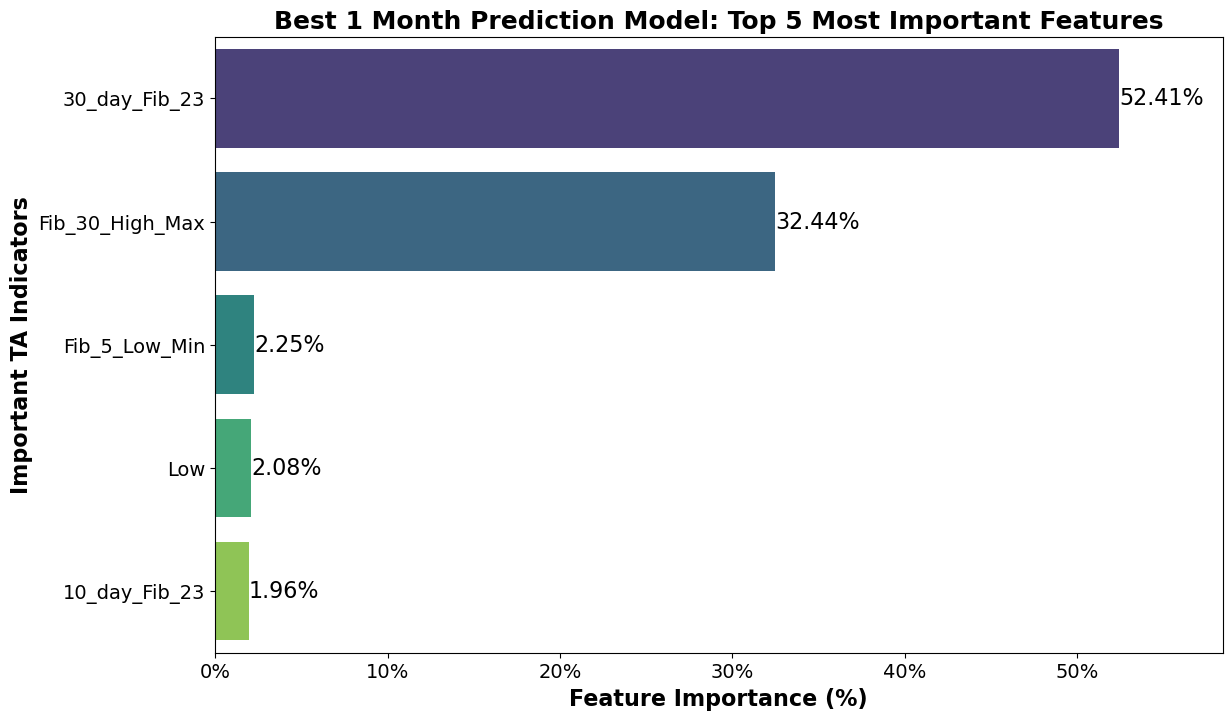

In [268]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert to NumPy arrays (ensuring correct types)
features = np.array([feature for feature, importance in sorted_features_1_month_md_7[:5]])  # Extract feature names
importances = np.array([importance for feature, importance in sorted_features_1_month_md_7[:5]])  # Extract importances

# Create a bar plot
plt.figure(figsize=(13, 8))
ax = sns.barplot(x=importances * 100, y=features, palette="viridis")

# Add text labels to the bars (feature importance values)
for i, v in enumerate(importances * 100):
    ax.text(v + 0.01, i, f"{v:.2f}%", va="center", fontsize=16)  # Adjust position & format

# Format x-axis labels to include % sign
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0f}%"))

# Extend x-axis limits for more space
plt.xlim(0, max(importances * 100) + 6)  # Extend to provide more space on the right

# Add labels and title
plt.xlabel("Feature Importance (%)", fontsize=16, fontweight='bold')  # Bigger x-axis title
plt.ylabel("Important TA Indicators", fontsize=16, fontweight='bold')  # Bigger y-axis title
plt.title("Best 1 Month Prediction Model: Top 5 Most Important Features", fontsize=18, fontweight='bold')  # Bigger title

# Increase font size for y-axis and x-axis tick labels (feature names)
ax.set_yticklabels(features, fontsize=14)
plt.xticks(fontsize=14)  # Increase font size for x-axis labels
# Show the plot
plt.show()


In [99]:
# first we will modify our feature set to add bigger lagging indicators.
# Create a new dataframe called 'df_stock_data_3_month' as a copy of 'df_stocks_price_ta'
df_stock_data_3_month = df_stocks_price_ta.copy()


In [100]:
# List of columns to create lags for (focusing on mid-term indicators)
columns_to_lag = ['Close', 'SMA_5', 'EMA_5', 'Volume', 'SMA_20',
       'SMA_50', 'EMA_5', 'EMA_20', 'EMA_50',  'EMA_12_MACD',
       'EMA_26_MACD']

# Creating lag features for each column
# [1, 3, 5, 7, 10, 12, 15, 20, 30, 60, 90, 180, 360] are the lags we will use
# but to save space, we will only use necessary lags per the timeline goal of the model
# this first model will be predicting price 1 week ahead (5 trading days)
lags = [1, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50, 60, 75, 90]
for col in columns_to_lag:
    for lag in lags:
        df_stock_data_3_month[f'{col}_lag_{lag}'] = df_stock_data_3_month[col].shift(lag)

# Do not drop NaN values to maintain continuity (XGBoost can handle NaNs)
# You can handle missing values in your model later, if needed
df_stock_data_3_month.head()



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/2984211339.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_stock_data_3_month[f'{col}_lag_{lag}'] = df_stock_data_3_month[col].shift(lag)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/2984211339.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_stock_data_3_month[f'{col}_lag_{lag}'] = df_stock_data_3_month[col].shift(lag)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/2984211339.py:13: PerformanceWarning: DataFrame

Symbol        Date  Close   High    Low     Volume      SMA_5     SMA_20  \
0   AAPL  2022-02-10  10.52  10.73  10.20  1037700.0  10.520000  10.520000   
1   AAPL  2022-02-11  10.09  10.49  10.02   480300.0  10.305000  10.305000   
2   AAPL  2022-02-14  10.22  10.46   9.97   724400.0  10.276667  10.276667   
3   AAPL  2022-02-15  10.56  10.57  10.22   758700.0  10.347500  10.347500   
4   AAPL  2022-02-16  10.44  10.55  10.39   685200.0  10.366000  10.366000   

      SMA_50      EMA_5  ...  EMA_26_MACD_lag_10  EMA_26_MACD_lag_15  \
0  10.520000  10.520000  ...                 NaN                 NaN   
1  10.305000  10.376667  ...                 NaN                 NaN   
2  10.276667  10.324445  ...                 NaN                 NaN   
3  10.347500  10.402963  ...                 NaN                 NaN   
4  10.366000  10.415309  ...                 NaN                 NaN   

   EMA_26_MACD_lag_20  EMA_26_MACD_lag_25  EMA_26_MACD_lag_30  \
0                 NaN                 NaN                 NaN   
1                 NaN                 NaN                 NaN   
2                 NaN                 NaN                 NaN   
3                 NaN                 NaN                 NaN   
4                 NaN                 NaN                 NaN   

   EMA_26_MACD_lag_40  EMA_26_MACD_lag_50  EMA_26_MACD_lag_60  \
0                 NaN                 NaN                 NaN   
1                 NaN                 NaN                 NaN   
2                 NaN                 NaN                 NaN   
3                 NaN                 NaN                 NaN   
4                 NaN                 NaN                 NaN   

   EMA_26_MACD_lag_75  EMA_26_MACD_lag_90  
0                 NaN                 NaN  
1                 NaN                 NaN  
2                 NaN                 NaN  
3                 NaN                 NaN  
4                 NaN                 NaN  

[5 rows x 194 columns]

In [240]:
# now we're going to move onto our next model: 3 month prediction
# we'll start at our baseline model and then do the same as we just did
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
df_stock_data_3_month = df_stock_data_3_month.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to November 10, 2023 for training
df_stock_data_train_3_month_baseline = df_stock_data_3_month[df_stock_data_3_month['Date'] <= '2023-11-10']

# Filter data to only include rows with Date after February 10, 2024 for testing
df_stock_data_test_3_month_baseline = df_stock_data_3_month[df_stock_data_3_month['Date'] > '2024-02-10']

# Check if the test set is empty
if df_stock_data_test_3_month_baseline.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 20 trading days ahead (1 month ahead)
df_stock_data_train_3_month_baseline['Close_Target'] = df_stock_data_train_3_month_baseline.groupby('Symbol')['Close'].shift(-60)
df_stock_data_test_3_month_baseline['Close_Target'] = df_stock_data_test_3_month_baseline.groupby('Symbol')['Close'].shift(-60)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
df_stock_data_train_3_month_baseline = df_stock_data_train_3_month_baseline.dropna(subset=['Close_Target'])
df_stock_data_test_3_month_baseline = df_stock_data_test_3_month_baseline.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
df_stock_data_train_3_month_baseline.replace([np.inf, -np.inf], np.nan, inplace=True)
df_stock_data_test_3_month_baseline.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = df_stock_data_train_3_month_baseline.select_dtypes(include=[np.number]).columns
numeric_cols_test = df_stock_data_test_3_month_baseline.select_dtypes(include=[np.number]).columns

df_stock_data_train_3_month_baseline[numeric_cols_train] = df_stock_data_train_3_month_baseline[numeric_cols_train].fillna(df_stock_data_train_3_month_baseline[numeric_cols_train].median())
df_stock_data_test_3_month_baseline[numeric_cols_test] = df_stock_data_test_3_month_baseline[numeric_cols_test].fillna(df_stock_data_test_3_month_baseline[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {df_stock_data_train_3_month_baseline.shape}")
print(f"Testing data shape: {df_stock_data_test_3_month_baseline.shape}")

# Create X (features) and y (target) for training
X_train_3_month_baseline = df_stock_data_train_3_month_baseline.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_3_month_baseline = df_stock_data_train_3_month_baseline['Close_Target']

# Create X and y for testing
X_test_3_month_baseline = df_stock_data_test_3_month_baseline.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_3_month_baseline = df_stock_data_test_3_month_baseline['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_3_month_baseline shape: {X_train_3_month_baseline.shape}, y_train_3_month_baseline shape: {y_train_3_month_baseline.shape}")
print(f"X_test_3_month_baseline shape: {X_test_3_month_baseline.shape}, y_test_3_month_baseline shape: {y_test_3_month_baseline.shape}")

# Ensure there are samples in both training and testing sets
if X_train_3_month_baseline.shape[0] == 0 or X_test_3_month_baseline.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_baseline_3_month = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_baseline_3_month.fit(X_train_3_month_baseline, y_train_3_month_baseline)

# Make predictions on the unseen test data (post-February 10, 2024)
y_pred_3_month_baseline = model_baseline_3_month.predict(X_test_3_month_baseline)

# Calculate performance on the test data
mse_test_3_month_baseline = mean_squared_error(y_test_3_month_baseline, y_pred_3_month_baseline)
print(f'Mean Squared Error on unseen data (post-February 10, 2024): {mse_test_3_month_baseline}')


/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/231090126.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_train_3_month_baseline['Close_Target'] = df_stock_data_train_3_month_baseline.groupby('Symbol')['Close'].shift(-60)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/231090126.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_test_3_month_baseline['Close_Target'] = df_stock_data_test_3_month_baseline.groupby('Symbol')['Close'].shift(-60

Training data shape: (664084, 195)
Testing data shape: (340665, 195)
X_train_3_month_baseline shape: (664084, 191), y_train_3_month_baseline shape: (664084,)
X_test_3_month_baseline shape: (340665, 191), y_test_3_month_baseline shape: (340665,)
Mean Squared Error on unseen data (post-February 10, 2024): 31301.74125575056


In [241]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np


# Assuming `y_pred_3_month_baseline` are your predictions for the test data and `y_test_3_month_baseline` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_3_month_baseline = mean_squared_error(y_test_3_month_baseline, y_pred_3_month_baseline)
mae_3_month_baseline = mean_absolute_error(y_test_3_month_baseline, y_pred_3_month_baseline)
rmse_3_month_baseline = np.sqrt(mse)  # Root Mean Squared Error
r2_3_month_baseline = r2_score(y_test_3_month_baseline, y_pred_3_month_baseline)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_3_month_baseline}')
print(f'Mean Absolute Error on unseen data: {mae_3_month_baseline}')
print(f'Root Mean Squared Error on unseen data: {rmse_3_month_baseline}')
print(f'R-squared on unseen data: {r2_3_month_baseline}')

# Additional metrics
medae_3_month_baseline = median_absolute_error(y_test_3_month_baseline, y_pred_3_month_baseline)
print(f'Median Absolute Error on unseen data: {medae_3_month_baseline}')

dw_stat_3_month_baseline = durbin_watson(y_test_3_month_baseline - y_pred_3_month_baseline)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_3_month_baseline}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_3_month_baseline = np.mean(np.abs((y_test_3_month_baseline - y_pred_3_month_baseline) / y_test_3_month_baseline)) * 100
print(f'MAPE on unseen data: {mape_3_month_baseline:.2f}%')
# Get feature importance as a dictionary
feature_importance_3_month_baseline = dict(zip(X_train_3_month_baseline.columns, model_baseline_3_month.feature_importances_))

# Sort features by importance in descending order
sorted_features_3_month_baseline = sorted(feature_importance_3_month_baseline.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_3_month_baseline:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 31301.74125575056
Mean Absolute Error on unseen data: 28.611355863536343
Root Mean Squared Error on unseen data: 177.23197868214638
R-squared on unseen data: 0.8648566403012485
Median Absolute Error on unseen data: 6.425842285156236
Durbin-Watson Statistic on unseen data: 0.01850750963651389
MAPE on unseen data: 14.09%
Fib_30_Low_Min: 33.56%
30_day_Fib_38: 19.87%
5_day-Fib_61: 12.35%
EMA_5: 5.42%
5_day-Fib_23: 5.20%
EMA_12_MACD: 4.18%
Volume: 2.75%
High: 2.65%
Low: 2.18%
30_day_Fib_61: 1.74%
ATR_Prev_Close: 1.21%
Fib_5_Low_Min: 1.01%
Close_lag_1: 0.99%
30_day_Fib_50: 0.83%
EMA_26_MACD: 0.72%
Upper_Band: 0.57%
VWAP: 0.49%
Lower_Band: 0.40%
EMA_20: 0.37%
Std_Dev: 0.29%
SMA_5_lag_90: 0.23%
SMA_50: 0.23%
Fib_30_High_Max: 0.20%
Fib_5_High_Max: 0.20%
10_day_Fib_50: 0.20%
Cumulative_Price_Volume: 0.19%
EMA_50_lag_7: 0.15%
Fib_10_Low_Min: 0.14%
ATR_True_Range: 0.12%
Fib_10_High_Max: 0.09%
ATR_High_Low: 0.07%
EMA_50_lag_20: 0.06%
EMA_50_lag_60: 0.06%
EMA_50_la

In [103]:
# Get feature importance from the baseline model (1-week prediction)
feature_importance = dict(zip(X_train.columns, model_baseline_3_month.feature_importances_))

# Filter features with importance greater than 1%
important_features = {feature: importance for feature, importance in feature_importance.items() if importance > 0.01}

# Sort features by importance in descending order
sorted_important_features = sorted(important_features.items(), key=lambda x: x[1], reverse=True)

# Extract the feature names (keys) into a list
important_feature_names = [feature for feature, importance in sorted_important_features]

# Print the sorted important features (optional)
print("Features with more than 1% contribution:")
for feature in sorted_important_features:
    print(f"{feature[0]}: {feature[1] * 100:.2f}%")

# The list of important features that you can use to create a new dataframe
print("List of important features:")
print(important_feature_names)


Features with more than 1% contribution:
Fib_30_Low_Min: 33.56%
30_day_Fib_38: 19.87%
5_day-Fib_61: 12.35%
EMA_5: 5.42%
5_day-Fib_23: 5.20%
EMA_12_MACD: 4.18%
Volume: 2.75%
High: 2.65%
Low: 2.18%
30_day_Fib_61: 1.74%
ATR_Prev_Close: 1.21%
Fib_5_Low_Min: 1.01%
List of important features:
['Fib_30_Low_Min', '30_day_Fib_38', '5_day-Fib_61', 'EMA_5', '5_day-Fib_23', 'EMA_12_MACD', 'Volume', 'High', 'Low', '30_day_Fib_61', 'ATR_Prev_Close', 'Fib_5_Low_Min']


In [105]:
important_features = ['Symbol', 'Date', 'Close', 'Fib_30_Low_Min', '30_day_Fib_38',
                      '5_day-Fib_61', '5_day-Fib_23', 'EMA_5', 'Volume',
                      'EMA_12_MACD', 'High', 'Low', '30_day_Fib_61',
                      'ATR_Prev_Close', 'Fib_5_Low_Min']
df_important_feat_3_month = df_stock_data_3_month[important_features]
df_important_feat_3_month.head()

Symbol        Date      Close  Fib_30_Low_Min  30_day_Fib_38  \
171141      A  2022-02-10  50.058052       49.918547      50.694471   
171142      A  2022-02-11  47.580647       47.234290      49.669085   
171143      A  2022-02-14  47.210232       46.796529      49.501860   
171144      A  2022-02-15  48.759216       46.796529      49.501860   
171145      A  2022-02-16  49.629917       46.796529      49.501860   

        5_day-Fib_61  5_day-Fib_23      EMA_5     Volume  EMA_12_MACD  \
171141     50.398164     50.877780  50.058052  1889800.0    50.058052   
171142     48.739293     50.244295  49.232250  3747400.0    49.676913   
171143     48.468756     50.140984  48.558244  3157800.0    49.297423   
171144     48.468756     50.140984  48.625235  1900000.0    49.214622   
171145     48.468756     50.140984  48.960129  2010600.0    49.278514   

             High        Low  30_day_Fib_61  ATR_Prev_Close  Fib_5_Low_Min  
171141  51.174088  49.918547      50.398164             NaN      49.918547  
171142  49.028604  47.234290      48.739293       50.058052      47.234290  
171143  47.460380  46.796529      48.468756       47.580647      46.796529  
171144  49.153677  48.427291      48.468756       47.210232      46.796529  
171145  49.716506  48.855427      48.468756       48.759216      46.796529

In [242]:
# 3 month prediction with only important featuers
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
df_important_feat_3_month = df_important_feat_3_month.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to November 10, 2023 for training
df_stock_data_train_3_month_if = df_important_feat_3_month[df_important_feat_3_month['Date'] <= '2023-11-10']

# Filter data to only include rows with Date after February 10, 2024 for testing
df_stock_data_test_3_month_if = df_important_feat_3_month[df_important_feat_3_month['Date'] > '2024-02-10']

# Check if the test set is empty
if df_stock_data_test_3_month_if.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 20 trading days ahead (1 month ahead)
df_stock_data_train_3_month_if['Close_Target'] = df_stock_data_train_3_month_if.groupby('Symbol')['Close'].shift(-60)
df_stock_data_test_3_month_if['Close_Target'] = df_stock_data_test_3_month_if.groupby('Symbol')['Close'].shift(-60)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
df_stock_data_train_3_month_if = df_stock_data_train_3_month_if.dropna(subset=['Close_Target'])
df_stock_data_test_3_month_if = df_stock_data_test_3_month_if.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
df_stock_data_train_3_month_if.replace([np.inf, -np.inf], np.nan, inplace=True)
df_stock_data_test_3_month_if.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = df_stock_data_train_3_month_if.select_dtypes(include=[np.number]).columns
numeric_cols_test = df_stock_data_test_3_month_if.select_dtypes(include=[np.number]).columns

df_stock_data_train_3_month_if[numeric_cols_train] = df_stock_data_train_3_month_if[numeric_cols_train].fillna(df_stock_data_train_3_month_if[numeric_cols_train].median())
df_stock_data_test_3_month_if[numeric_cols_test] = df_stock_data_test_3_month_if[numeric_cols_test].fillna(df_stock_data_test_3_month_if[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {df_stock_data_train_3_month_if.shape}")
print(f"Testing data shape: {df_stock_data_test_3_month_if.shape}")

# Create X (features) and y (target) for training
X_train_3_month_if = df_stock_data_train_3_month_if.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_3_month_if = df_stock_data_train_3_month_if['Close_Target']

# Create X and y for testing
X_test_3_month_if = df_stock_data_test_3_month_if.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_3_month_if = df_stock_data_test_3_month_if['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_3_month_if shape: {X_train_3_month_if.shape}, y_train_3_month_if shape: {y_train_3_month_if.shape}")
print(f"X_test_3_month_if shape: {X_test_3_month_if.shape}, y_test_3_month_if shape: {y_test_3_month_if.shape}")

# Ensure there are samples in both training and testing sets
if X_train_3_month_if.shape[0] == 0 or X_test_3_month_if.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_baseline_if_3_month = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_baseline_if_3_month.fit(X_train_3_month_if, y_train_3_month_if)

# Make predictions on the unseen test data (post-February 10, 2024)
y_pred_3_month_if = model_baseline_if_3_month.predict(X_test_3_month_if)

# Calculate performance on the test data
mse_test_3_month_if = mean_squared_error(y_test_3_month_if, y_pred_3_month_if)
print(f'Mean Squared Error on unseen data (post-February 10, 2024): {mse_test_3_month_if}')


/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1790160588.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_train_3_month_if['Close_Target'] = df_stock_data_train_3_month_if.groupby('Symbol')['Close'].shift(-60)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1790160588.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_test_3_month_if['Close_Target'] = df_stock_data_test_3_month_if.groupby('Symbol')['Close'].shift(-60)


Training data shape: (664084, 16)
Testing data shape: (340665, 16)
X_train_3_month_if shape: (664084, 12), y_train_3_month_if shape: (664084,)
X_test_3_month_if shape: (340665, 12), y_test_3_month_if shape: (340665,)
Mean Squared Error on unseen data (post-February 10, 2024): 38805.08580927107


In [243]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np


# Assuming `y_pred_3_month_if` are your predictions for the test data and `y_test_3_month_if` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_3_month_if = mean_squared_error(y_test_3_month_if, y_pred_3_month_if)
mae_3_month_if = mean_absolute_error(y_test_3_month_if, y_pred_3_month_if)
rmse_3_month_if = np.sqrt(mse_3_month_if)  # Root Mean Squared Error
r2_3_month_if = r2_score(y_test_3_month_if, y_pred_3_month_if)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_3_month_if}')
print(f'Mean Absolute Error on unseen data: {mae_3_month_if}')
print(f'Root Mean Squared Error on unseen data: {rmse_3_month_if}')
print(f'R-squared on unseen data: {r2_3_month_if}')

# Additional metrics
medae_3_month_if = median_absolute_error(y_test_3_month_if, y_pred_3_month_if)
print(f'Median Absolute Error on unseen data: {medae_3_month_if}')

dw_stat_3_month_if = durbin_watson(y_test_3_month_if - y_pred_3_month_if)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_3_month_if}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_3_month_if = np.mean(np.abs((y_test_3_month_if - y_pred_3_month_if) / y_test_3_month_if)) * 100
print(f'MAPE on unseen data: {mape_3_month_if:.2f}%')
# Get feature importance as a dictionary
feature_importance_3_month_if = dict(zip(X_train_3_month_if.columns, model_baseline_if_3_month.feature_importances_))

# Sort features by importance in descending order
sorted_features_3_month_if = sorted(feature_importance_3_month_if.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_3_month_if:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 38805.08580927107
Mean Absolute Error on unseen data: 29.90465695916755
Root Mean Squared Error on unseen data: 196.99006525525868
R-squared on unseen data: 0.8324614075998154
Median Absolute Error on unseen data: 6.2861328125
Durbin-Watson Statistic on unseen data: 0.040873685600318704
MAPE on unseen data: 13.25%
Fib_30_Low_Min: 41.10%
High: 16.47%
Low: 11.00%
30_day_Fib_38: 8.28%
EMA_5: 4.93%
ATR_Prev_Close: 3.57%
5_day-Fib_23: 3.51%
Volume: 2.92%
30_day_Fib_61: 2.84%
5_day-Fib_61: 2.61%
EMA_12_MACD: 1.87%
Fib_5_Low_Min: 0.91%


In [244]:
# learning rate = 0.1
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
df_stock_data_3_month = df_stock_data_3_month.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to November 10, 2023 for training
df_stock_data_train_3_month_lr_1 = df_stock_data_3_month[df_stock_data_3_month['Date'] <= '2023-11-10']

# Filter data to only include rows with Date after February 10, 2024 for testing
df_stock_data_test_3_month_lr_1 = df_stock_data_3_month[df_stock_data_3_month['Date'] > '2024-02-10']

# Check if the test set is empty
if df_stock_data_test_3_month_lr_1.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 20 trading days ahead (1 month ahead)
df_stock_data_train_3_month_lr_1['Close_Target'] = df_stock_data_train_3_month_lr_1.groupby('Symbol')['Close'].shift(-60)
df_stock_data_test_3_month_lr_1['Close_Target'] = df_stock_data_test_3_month_lr_1.groupby('Symbol')['Close'].shift(-60)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
df_stock_data_train_3_month_lr_1 = df_stock_data_train_3_month_lr_1.dropna(subset=['Close_Target'])
df_stock_data_test_3_month_lr_1 = df_stock_data_test_3_month_lr_1.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
df_stock_data_train_3_month_lr_1.replace([np.inf, -np.inf], np.nan, inplace=True)
df_stock_data_test_3_month_lr_1.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = df_stock_data_train_3_month_lr_1.select_dtypes(include=[np.number]).columns
numeric_cols_test = df_stock_data_test_3_month_lr_1.select_dtypes(include=[np.number]).columns

df_stock_data_train_3_month_lr_1[numeric_cols_train] = df_stock_data_train_3_month_lr_1[numeric_cols_train].fillna(df_stock_data_train_3_month_lr_1[numeric_cols_train].median())
df_stock_data_test_3_month_lr_1[numeric_cols_test] = df_stock_data_test_3_month_lr_1[numeric_cols_test].fillna(df_stock_data_test_3_month_lr_1[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {df_stock_data_train_3_month_lr_1.shape}")
print(f"Testing data shape: {df_stock_data_test_3_month_lr_1.shape}")

# Create X (features) and y (target) for training
X_train_3_month_lr_1 = df_stock_data_train_3_month_lr_1.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_3_month_lr_1 = df_stock_data_train_3_month_lr_1['Close_Target']

# Create X and y for testing
X_test_3_month_lr_1 = df_stock_data_test_3_month_lr_1.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_3_month_lr_1 = df_stock_data_test_3_month_lr_1['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_3_month_lr_1 shape: {X_train_3_month_lr_1.shape}, y_train_3_month_lr_1 shape: {y_train_3_month_lr_1.shape}")
print(f"X_test_3_month_lr_1 shape: {X_test_3_month_lr_1.shape}, y_test_3_month_lr_1 shape: {y_test_3_month_lr_1.shape}")

# Ensure there are samples in both training and testing sets
if X_train_3_month_lr_1.shape[0] == 0 or X_test_3_month_lr_1.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_3_month_tf_1 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_3_month_tf_1.fit(X_train_3_month_lr_1, y_train_3_month_lr_1)

# Make predictions on the unseen test data (post-February 10, 2024)
y_pred_3_month_lr_1 = model_3_month_tf_1.predict(X_test_3_month_lr_1)

# Calculate performance on the test data
mse_test_3_month_lr_1 = mean_squared_error(y_test_3_month_lr_1, y_pred_3_month_lr_1)
print(f'Mean Squared Error on unseen data (post-February 10, 2024): {mse_test_3_month_lr_1}')


/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/3132509529.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_train_3_month_lr_1['Close_Target'] = df_stock_data_train_3_month_lr_1.groupby('Symbol')['Close'].shift(-60)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/3132509529.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_test_3_month_lr_1['Close_Target'] = df_stock_data_test_3_month_lr_1.groupby('Symbol')['Close'].shift(-60)


Training data shape: (664084, 195)
Testing data shape: (340665, 195)
X_train_3_month_lr_1 shape: (664084, 191), y_train_3_month_lr_1 shape: (664084,)
X_test_3_month_lr_1 shape: (340665, 191), y_test_3_month_lr_1 shape: (340665,)
Mean Squared Error on unseen data (post-February 10, 2024): 30689.514705268604


In [246]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np


# Assuming `y_pred_3_month_lr_1` are your predictions for the test data and `y_test_3_month_lr_1` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_3_month_lr_1 = mean_squared_error(y_test_3_month_lr_1, y_pred_3_month_lr_1)
mae_3_month_lr_1 = mean_absolute_error(y_test_3_month_lr_1, y_pred_3_month_lr_1)
rmse_3_month_lr_1 = np.sqrt(mse_3_month_lr_1)  # Root Mean Squared Error
r2_3_month_lr_1 = r2_score(y_test_3_month_lr_1, y_pred_3_month_lr_1)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_3_month_lr_1}')
print(f'Mean Absolute Error on unseen data: {mae_3_month_lr_1}')
print(f'Root Mean Squared Error on unseen data: {rmse_3_month_lr_1}')
print(f'R-squared on unseen data: {r2_3_month_lr_1}')

# Additional metrics
medae_3_month_lr_1 = median_absolute_error(y_test_3_month_lr_1, y_pred_3_month_lr_1)
print(f'Median Absolute Error on unseen data: {medae_3_month_lr_1}')

dw_stat_3_month_lr_1 = durbin_watson(y_test_3_month_lr_1 - y_pred_3_month_lr_1)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_3_month_lr_1}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_3_month_lr_1 = np.mean(np.abs((y_test_3_month_lr_1 - y_pred_3_month_lr_1) / y_test_3_month_lr_1)) * 100
print(f'MAPE on unseen data: {mape_3_month_lr_1:.2f}%')
# Get feature importance as a dictionary
feature_importance_3_month_lr_1 = dict(zip(X_train_3_month_lr_1.columns, model_3_month_tf_1.feature_importances_))

# Sort features by importance in descending order
sorted_features_3_month_lr_1 = sorted(feature_importance_3_month_lr_1.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_3_month_lr_1:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 30689.514705268604
Mean Absolute Error on unseen data: 29.242334413401167
Root Mean Squared Error on unseen data: 175.18423075513562
R-squared on unseen data: 0.867499891111256
Median Absolute Error on unseen data: 6.841819763183594
Durbin-Watson Statistic on unseen data: 0.018820913363933614
MAPE on unseen data: 14.94%
Fib_30_Low_Min: 30.03%
30_day_Fib_38: 23.30%
5_day-Fib_61: 11.28%
EMA_5: 8.27%
5_day-Fib_23: 6.93%
High: 3.61%
Volume: 3.11%
Low: 2.08%
EMA_12_MACD: 2.02%
30_day_Fib_61: 1.63%
Fib_5_Low_Min: 0.85%
ATR_Prev_Close: 0.67%
EMA_26_MACD: 0.66%
VWAP: 0.52%
Upper_Band: 0.51%
Lower_Band: 0.45%
Std_Dev: 0.35%
EMA_20: 0.33%
Fib_30_High_Max: 0.32%
Cumulative_Price_Volume: 0.24%
30_day_Fib_50: 0.23%
Fib_5_High_Max: 0.20%
Fib_10_Low_Min: 0.16%
SMA_5_lag_90: 0.16%
ATR_True_Range: 0.14%
SMA_50: 0.13%
Close_lag_1: 0.11%
EMA_50_lag_7: 0.09%
EMA_50_lag_15: 0.07%
ATR_High_Low: 0.07%
10_day_Fib_61: 0.07%
Volume_lag_25: 0.06%
EMA_50_lag_60: 0.06%
EMA_50_lag

In [247]:
# learning rate = 0.01
# this is the best one again
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Sort values by 'Symbol' and 'Date' to maintain time order
df_stock_data_3_month = df_stock_data_3_month.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to November 10, 2023 for training
df_stock_data_train_3_month_lr_01 = df_stock_data_3_month[df_stock_data_3_month['Date'] <= '2023-11-10']

# Filter data to only include rows with Date after February 10, 2024 for testing
df_stock_data_test_3_month_lr_01 = df_stock_data_3_month[df_stock_data_3_month['Date'] > '2024-02-10']

# Check if the test set is empty
if df_stock_data_test_3_month_lr_01.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 20 trading days ahead (1 month ahead)
df_stock_data_train_3_month_lr_01['Close_Target'] = df_stock_data_train_3_month_lr_01.groupby('Symbol')['Close'].shift(-60)
df_stock_data_test_3_month_lr_01['Close_Target'] = df_stock_data_test_3_month_lr_01.groupby('Symbol')['Close'].shift(-60)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
df_stock_data_train_3_month_lr_01 = df_stock_data_train_3_month_lr_01.dropna(subset=['Close_Target'])
df_stock_data_test_3_month_lr_01 = df_stock_data_test_3_month_lr_01.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
df_stock_data_train_3_month_lr_01.replace([np.inf, -np.inf], np.nan, inplace=True)
df_stock_data_test_3_month_lr_01.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = df_stock_data_train_3_month_lr_01.select_dtypes(include=[np.number]).columns
numeric_cols_test = df_stock_data_test_3_month_lr_01.select_dtypes(include=[np.number]).columns

df_stock_data_train_3_month_lr_01[numeric_cols_train] = df_stock_data_train_3_month_lr_01[numeric_cols_train].fillna(df_stock_data_train_3_month_lr_01[numeric_cols_train].median())
df_stock_data_test_3_month_lr_01[numeric_cols_test] = df_stock_data_test_3_month_lr_01[numeric_cols_test].fillna(df_stock_data_test_3_month_lr_01[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {df_stock_data_train_3_month_lr_01.shape}")
print(f"Testing data shape: {df_stock_data_test_3_month_lr_01.shape}")

# Create X (features) and y (target) for training
X_train_3_month_lr_01 = df_stock_data_train_3_month_lr_01.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_3_month_lr_01 = df_stock_data_train_3_month_lr_01['Close_Target']

# Create X and y for testing
X_test_3_month_lr_01 = df_stock_data_test_3_month_lr_01.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_3_month_lr_01 = df_stock_data_test_3_month_lr_01['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_3_month_lr_01 shape: {X_train_3_month_lr_01.shape}, y_train_3_month_lr_01 shape: {y_train_3_month_lr_01.shape}")
print(f"X_test_3_month_lr_01 shape: {X_test_3_month_lr_01.shape}, y_test_3_month_lr_01 shape: {y_test_3_month_lr_01.shape}")

# Ensure there are samples in both training and testing sets
if X_train_3_month_lr_01.shape[0] == 0 or X_test_3_month_lr_01.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_3_month_tf_01 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_3_month_tf_01.fit(X_train_3_month_lr_01, y_train_3_month_lr_01)

# Make predictions on the unseen test data (post-February 10, 2024)
y_pred_3_month_lr_01 = model_3_month_tf_01.predict(X_test_3_month_lr_01)

# Calculate performance on the test data
mse_test_3_month_lr_01 = mean_squared_error(y_test_3_month_lr_01, y_pred_3_month_lr_01)
print(f'Mean Squared Error on unseen data (post-February 10, 2024): {mse_test_3_month_lr_01}')


/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1868309815.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_train_3_month_lr_01['Close_Target'] = df_stock_data_train_3_month_lr_01.groupby('Symbol')['Close'].shift(-60)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1868309815.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_test_3_month_lr_01['Close_Target'] = df_stock_data_test_3_month_lr_01.groupby('Symbol')['Close'].shift(-60)


Training data shape: (664084, 195)
Testing data shape: (340665, 195)
X_train_3_month_lr_01 shape: (664084, 191), y_train_3_month_lr_01 shape: (664084,)
X_test_3_month_lr_01 shape: (340665, 191), y_test_3_month_lr_01 shape: (340665,)
Mean Squared Error on unseen data (post-February 10, 2024): 29118.891815886836


In [248]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np


# Assuming `y_pred_3_month_lr_01` are your predictions for the test data and `y_test_3_month_lr_01` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_3_month_lr_01 = mean_squared_error(y_test_3_month_lr_01, y_pred_3_month_lr_01)
mae_3_month_lr_01 = mean_absolute_error(y_test_3_month_lr_01, y_pred_3_month_lr_01)
rmse_3_month_lr_01 = np.sqrt(mse_3_month_lr_01)  # Root Mean Squared Error
r2_3_month_lr_01 = r2_score(y_test_3_month_lr_01, y_pred_3_month_lr_01)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_3_month_lr_01}')
print(f'Mean Absolute Error on unseen data: {mae_3_month_lr_01}')
print(f'Root Mean Squared Error on unseen data: {rmse_3_month_lr_01}')
print(f'R-squared on unseen data: {r2_3_month_lr_01}')

# Additional metrics
medae_3_month_lr_01 = median_absolute_error(y_test_3_month_lr_01, y_pred_3_month_lr_01)
print(f'Median Absolute Error on unseen data: {medae_3_month_lr_01}')

dw_stat_3_month_lr_01 = durbin_watson(y_test_3_month_lr_01 - y_pred_3_month_lr_01)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_3_month_lr_01}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_3_month_lr_01 = np.mean(np.abs((y_test_3_month_lr_01 - y_pred_3_month_lr_01) / y_test_3_month_lr_01)) * 100
print(f'MAPE on unseen data: {mape_3_month_lr_01:.2f}%')
# Get feature importance as a dictionary
feature_importance_3_month_lr_01 = dict(zip(X_train_3_month_lr_01.columns, model_3_month_tf_01.feature_importances_))

# Sort features by importance in descending order
sorted_features_3_month_lr_01 = sorted(feature_importance_3_month_lr_01.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_3_month_lr_01:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 29118.891815886836
Mean Absolute Error on unseen data: 26.64136862717554
Root Mean Squared Error on unseen data: 170.64258500118555
R-squared on unseen data: 0.8742809596900469
Median Absolute Error on unseen data: 6.175811767578111
Durbin-Watson Statistic on unseen data: 0.018949752249716446
MAPE on unseen data: 14.00%
Fib_30_Low_Min: 37.64%
5_day-Fib_61: 21.52%
30_day_Fib_38: 12.54%
30_day_Fib_61: 4.24%
EMA_5: 3.04%
Volume: 2.85%
5_day-Fib_23: 2.32%
High: 2.11%
EMA_12_MACD: 2.02%
30_day_Fib_50: 1.62%
Fib_5_Low_Min: 1.14%
Low: 1.12%
VWAP: 0.69%
Upper_Band: 0.52%
ATR_Prev_Close: 0.47%
EMA_26_MACD: 0.43%
Lower_Band: 0.41%
10_day_Fib_61: 0.35%
Close_lag_1: 0.34%
Std_Dev: 0.34%
Fib_30_High_Max: 0.34%
EMA_50_lag_7: 0.29%
Fib_10_Low_Min: 0.27%
SMA_5_lag_90: 0.25%
10_day_Fib_50: 0.19%
EMA_20: 0.18%
SMA_50: 0.17%
Fib_5_High_Max: 0.16%
EMA_50_lag_20: 0.15%
Fib_10_High_Max: 0.15%
ATR_True_Range: 0.14%
30_day_Fib_23: 0.13%
Cumulative_Price_Volume: 0.13%
ATR_Hig

In [289]:
# learning rate = 0.01
# max depth 3
# this is actually the best one for 3 months now
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
df_stock_data_3_month = df_stock_data_3_month.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to November 10, 2023 for training
df_stock_data_train_3_month_md_3 = df_stock_data_3_month[df_stock_data_3_month['Date'] <= '2023-11-10']

# Filter data to only include rows with Date after February 10, 2024 for testing
df_stock_data_test_3_month_md_3 = df_stock_data_3_month[df_stock_data_3_month['Date'] > '2024-02-10']

# Check if the test set is empty
if df_stock_data_test_3_month_md_3.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 20 trading days ahead (1 month ahead)
df_stock_data_train_3_month_md_3['Close_Target'] = df_stock_data_train_3_month_md_3.groupby('Symbol')['Close'].shift(-60)
df_stock_data_test_3_month_md_3['Close_Target'] = df_stock_data_test_3_month_md_3.groupby('Symbol')['Close'].shift(-60)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
df_stock_data_train_3_month_md_3 = df_stock_data_train_3_month_md_3.dropna(subset=['Close_Target'])
df_stock_data_test_3_month_md_3 = df_stock_data_test_3_month_md_3.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
df_stock_data_train_3_month_md_3.replace([np.inf, -np.inf], np.nan, inplace=True)
df_stock_data_test_3_month_md_3.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = df_stock_data_train_3_month_md_3.select_dtypes(include=[np.number]).columns
numeric_cols_test = df_stock_data_test_3_month_md_3.select_dtypes(include=[np.number]).columns

df_stock_data_train_3_month_md_3[numeric_cols_train] = df_stock_data_train_3_month_md_3[numeric_cols_train].fillna(df_stock_data_train_3_month_md_3[numeric_cols_train].median())
df_stock_data_test_3_month_md_3[numeric_cols_test] = df_stock_data_test_3_month_md_3[numeric_cols_test].fillna(df_stock_data_test_3_month_md_3[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {df_stock_data_train_3_month_md_3.shape}")
print(f"Testing data shape: {df_stock_data_test_3_month_md_3.shape}")

# Create X (features) and y (target) for training
X_train_3_month_md_3 = df_stock_data_train_3_month_md_3.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_3_month_md_3 = df_stock_data_train_3_month_md_3['Close_Target']

# Create X and y for testing
X_test_3_month_md_3 = df_stock_data_test_3_month_md_3.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_3_month_md_3 = df_stock_data_test_3_month_md_3['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_3_month_md_3 shape: {X_train_3_month_md_3.shape}, y_train_3_month_md_3 shape: {y_train_3_month_md_3.shape}")
print(f"X_test_3_month_md_3 shape: {X_test_3_month_md_3.shape}, y_test_3_month_md_3 shape: {y_test_3_month_md_3.shape}")

# Ensure there are samples in both training and testing sets
if X_train_3_month_md_3.shape[0] == 0 or X_test_3_month_md_3.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_3_month_md_3 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=3,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_3_month_md_3.fit(X_train_3_month_md_3, y_train_3_month_md_3)

# Make predictions on the unseen test data (post-February 10, 2024)
y_pred_3_month_md_3 = model_3_month_md_3.predict(X_test_3_month_md_3)

# Calculate performance on the test data
mse_test_3_month_md_3 = mean_squared_error(y_test_3_month_md_3, y_pred_3_month_md_3)
print(f'Mean Squared Error on unseen data (post-February 10, 2024): {mse_test_3_month_md_3}')


/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1471334974.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_train_3_month_md_3['Close_Target'] = df_stock_data_train_3_month_md_3.groupby('Symbol')['Close'].shift(-60)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1471334974.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_test_3_month_md_3['Close_Target'] = df_stock_data_test_3_month_md_3.groupby('Symbol')['Close'].shift(-60)


Training data shape: (664084, 195)
Testing data shape: (340665, 195)
X_train_3_month_md_3 shape: (664084, 191), y_train_3_month_md_3 shape: (664084,)
X_test_3_month_md_3 shape: (340665, 191), y_test_3_month_md_3 shape: (340665,)
Mean Squared Error on unseen data (post-February 10, 2024): 25855.13009374476


In [290]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Assuming `y_pred_3_month_md_3` are your predictions for the test data and `y_test_3_month_md_3` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_3_month_md_3 = mean_squared_error(y_test_3_month_md_3, y_pred_3_month_md_3)
mae_3_month_md_3 = mean_absolute_error(y_test_3_month_md_3, y_pred_3_month_md_3)
rmse_3_month_md_3 = np.sqrt(mse_3_month_md_3)  # Root Mean Squared Error
r2_3_month_md_3 = r2_score(y_test_3_month_md_3, y_pred_3_month_md_3)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_3_month_md_3}')
print(f'Mean Absolute Error on unseen data: {mae_3_month_md_3}')
print(f'Root Mean Squared Error on unseen data: {rmse_3_month_md_3}')
print(f'R-squared on unseen data: {r2_3_month_md_3}')

# Additional metrics
medae_3_month_md_3 = median_absolute_error(y_test_3_month_md_3, y_pred_3_month_md_3)
print(f'Median Absolute Error on unseen data: {medae_3_month_md_3}')

dw_stat_3_month_md_3 = durbin_watson(y_test_3_month_md_3 - y_pred_3_month_md_3)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_3_month_md_3}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_3_month_md_3 = np.mean(np.abs((y_test_3_month_md_3 - y_pred_3_month_md_3) / y_test_3_month_md_3)) * 100
print(f'MAPE on unseen data: {mape_3_month_md_3:.2f}%')
# Get feature importance as a dictionary
feature_importance_3_month_md_3 = dict(zip(X_train_3_month_md_3.columns, model_3_month_md_3.feature_importances_))

# Sort features by importance in descending order
sorted_features_3_month_md_3 = sorted(feature_importance_3_month_md_3.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_3_month_md_3:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 25855.13009374476
Mean Absolute Error on unseen data: 25.29591435606357
Root Mean Squared Error on unseen data: 160.79530494931984
R-squared on unseen data: 0.8883720519645201
Median Absolute Error on unseen data: 6.283714294433594
Durbin-Watson Statistic on unseen data: 0.017109218495924613
MAPE on unseen data: 15.52%
Fib_30_Low_Min: 27.17%
30_day_Fib_38: 14.80%
5_day-Fib_61: 11.17%
Upper_Band: 8.25%
Fib_10_Low_Min: 3.10%
10_day_Fib_50: 2.76%
Close_lag_1: 2.34%
Volume: 1.87%
EMA_5: 1.82%
Fib_5_Low_Min: 1.69%
Fib_5_High_Max: 1.51%
30_day_Fib_23: 1.50%
High: 1.48%
EMA_50_lag_25: 1.37%
30_day_Fib_50: 1.29%
ATR_High_Low: 1.20%
EMA_26_MACD: 1.11%
EMA_50: 1.08%
SMA_50: 1.02%
ATR: 1.00%
10_day_Fib_61: 0.87%
Low: 0.86%
EMA_12_MACD: 0.82%
Close_lag_90: 0.76%
5_day-Fib_23: 0.76%
EMA_20: 0.73%
SMA_20_lag_90: 0.60%
EMA_12_MACD_lag_90: 0.58%
10_day_Fib_38: 0.57%
VWAP: 0.55%
30_day_Fib_61: 0.54%
Volume_lag_50: 0.53%
ATR_True_Range: 0.39%
ATR_Prev_Close: 0.32%
SMA_

In [251]:
# learning rate = 0.01
# max depth 7
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Sort values by 'Symbol' and 'Date' to maintain time order
df_stock_data_3_month = df_stock_data_3_month.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to November 10, 2023 for training
df_stock_data_train_3_month_md_7 = df_stock_data_3_month[df_stock_data_3_month['Date'] <= '2023-11-10']

# Filter data to only include rows with Date after February 10, 2024 for testing
df_stock_data_test_3_month_md_7 = df_stock_data_3_month[df_stock_data_3_month['Date'] > '2024-02-10']

# Check if the test set is empty
if df_stock_data_test_3_month_md_7.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 20 trading days ahead (1 month ahead)
df_stock_data_train_3_month_md_7['Close_Target'] = df_stock_data_train_3_month_md_7.groupby('Symbol')['Close'].shift(-60)
df_stock_data_test_3_month_md_7['Close_Target'] = df_stock_data_test_3_month_md_7.groupby('Symbol')['Close'].shift(-60)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
df_stock_data_train_3_month_md_7 = df_stock_data_train_3_month_md_7.dropna(subset=['Close_Target'])
df_stock_data_test_3_month_md_7 = df_stock_data_test_3_month_md_7.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
df_stock_data_train_3_month_md_7.replace([np.inf, -np.inf], np.nan, inplace=True)
df_stock_data_test_3_month_md_7.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = df_stock_data_train_3_month_md_7.select_dtypes(include=[np.number]).columns
numeric_cols_test = df_stock_data_test_3_month_md_7.select_dtypes(include=[np.number]).columns

df_stock_data_train_3_month_md_7[numeric_cols_train] = df_stock_data_train_3_month_md_7[numeric_cols_train].fillna(df_stock_data_train_3_month_md_7[numeric_cols_train].median())
df_stock_data_test_3_month_md_7[numeric_cols_test] = df_stock_data_test_3_month_md_7[numeric_cols_test].fillna(df_stock_data_test_3_month_md_7[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {df_stock_data_train_3_month_md_7.shape}")
print(f"Testing data shape: {df_stock_data_test_3_month_md_7.shape}")

# Create X (features) and y (target) for training
X_train_3_month_md_7 = df_stock_data_train_3_month_md_7.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_3_month_md_7 = df_stock_data_train_3_month_md_7['Close_Target']

# Create X and y for testing
X_test_3_month_md_7 = df_stock_data_test_3_month_md_7.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_3_month_md_7 = df_stock_data_test_3_month_md_7['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_3_month_md_7 shape: {X_train_3_month_md_7.shape}, y_train_3_month_md_7 shape: {y_train_3_month_md_7.shape}")
print(f"X_test_3_month_md_7 shape: {X_test_3_month_md_7.shape}, y_test_3_month_md_7 shape: {y_test_3_month_md_7.shape}")

# Ensure there are samples in both training and testing sets
if X_train_3_month_md_7.shape[0] == 0 or X_test_3_month_md_7.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_3_month_md_7 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=7,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_3_month_md_7.fit(X_train_3_month_md_7, y_train_3_month_md_7)

# Make predictions on the unseen test data (post-February 10, 2024)
y_pred_3_month_md_7 = model_3_month_md_7.predict(X_test_3_month_md_7)

# Calculate performance on the test data
mse_test_3_month_md_7 = mean_squared_error(y_test_3_month_md_7, y_pred_3_month_md_7)
print(f'Mean Squared Error on unseen data (post-February 10, 2024): {mse_test_3_month_md_7}')


/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1313892869.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_train_3_month_md_7['Close_Target'] = df_stock_data_train_3_month_md_7.groupby('Symbol')['Close'].shift(-60)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1313892869.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_test_3_month_md_7['Close_Target'] = df_stock_data_test_3_month_md_7.groupby('Symbol')['Close'].shift(-60)


Training data shape: (664084, 195)
Testing data shape: (340665, 195)
X_train_3_month_md_7 shape: (664084, 191), y_train_3_month_md_7 shape: (664084,)
X_test_3_month_md_7 shape: (340665, 191), y_test_3_month_md_7 shape: (340665,)
Mean Squared Error on unseen data (post-February 10, 2024): 28832.803345344026


In [252]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Assuming `y_pred_3_month_md_7` are your predictions for the test data and `y_test_3_month_md_7` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_3_month_md_7 = mean_squared_error(y_test_3_month_md_7, y_pred_3_month_md_7)
mae_3_month_md_7 = mean_absolute_error(y_test_3_month_md_7, y_pred_3_month_md_7)
rmse_3_month_md_7 = np.sqrt(mse_3_month_md_7)  # Root Mean Squared Error
r2_3_month_md_7 = r2_score(y_test_3_month_md_7, y_pred_3_month_md_7)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_3_month_md_7}')
print(f'Mean Absolute Error on unseen data: {mae_3_month_md_7}')
print(f'Root Mean Squared Error on unseen data: {rmse_3_month_md_7}')
print(f'R-squared on unseen data: {r2_3_month_md_7}')

# Additional metrics
medae_3_month_md_7 = median_absolute_error(y_test_3_month_md_7, y_pred_3_month_md_7)
print(f'Median Absolute Error on unseen data: {medae_3_month_md_7}')

dw_stat_3_month_md_7 = durbin_watson(y_test_3_month_md_7 - y_pred_3_month_md_7)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_3_month_md_7}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_3_month_md_7 = np.mean(np.abs((y_test_3_month_md_7 - y_pred_3_month_md_7) / y_test_3_month_md_7)) * 100
print(f'MAPE on unseen data: {mape_3_month_md_7:.2f}%')
# Get feature importance as a dictionary
feature_importance_3_month_md_7 = dict(zip(X_train_3_month_md_7.columns, model_3_month_md_7.feature_importances_))

# Sort features by importance in descending order
sorted_features_3_month_md_7 = sorted(feature_importance_3_month_md_7.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_3_month_md_7:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 28832.803345344026
Mean Absolute Error on unseen data: 27.67476094296
Root Mean Squared Error on unseen data: 169.80224776293164
R-squared on unseen data: 0.8755161292214905
Median Absolute Error on unseen data: 6.3470611572265625
Durbin-Watson Statistic on unseen data: 0.024350243504711922
MAPE on unseen data: 13.86%
Fib_30_Low_Min: 56.87%
5_day-Fib_61: 10.13%
5_day-Fib_23: 6.61%
30_day_Fib_61: 4.01%
EMA_5: 3.16%
High: 2.72%
Volume: 2.34%
30_day_Fib_38: 2.34%
EMA_12_MACD: 1.84%
Low: 1.22%
30_day_Fib_50: 1.08%
VWAP: 0.93%
EMA_26_MACD: 0.82%
Fib_10_High_Max: 0.63%
Std_Dev: 0.57%
Fib_5_High_Max: 0.49%
Fib_5_Low_Min: 0.47%
EMA_20: 0.41%
10_day_Fib_61: 0.27%
EMA_50_lag_20: 0.23%
Cumulative_Price_Volume: 0.23%
Close_lag_1: 0.20%
EMA_50_lag_15: 0.16%
EMA_26_MACD_lag_15: 0.14%
ATR_Prev_Close: 0.14%
SMA_5: 0.13%
SMA_50: 0.10%
EMA_50_lag_25: 0.09%
Fib_10_Low_Min: 0.09%
Volume_lag_25: 0.08%
EMA_50_lag_7: 0.07%
Volume_lag_30: 0.07%
Fib_30_High_Max: 0.07%
ATR_Tru

best model: learning_rate = 0.01 and max_depth = 3

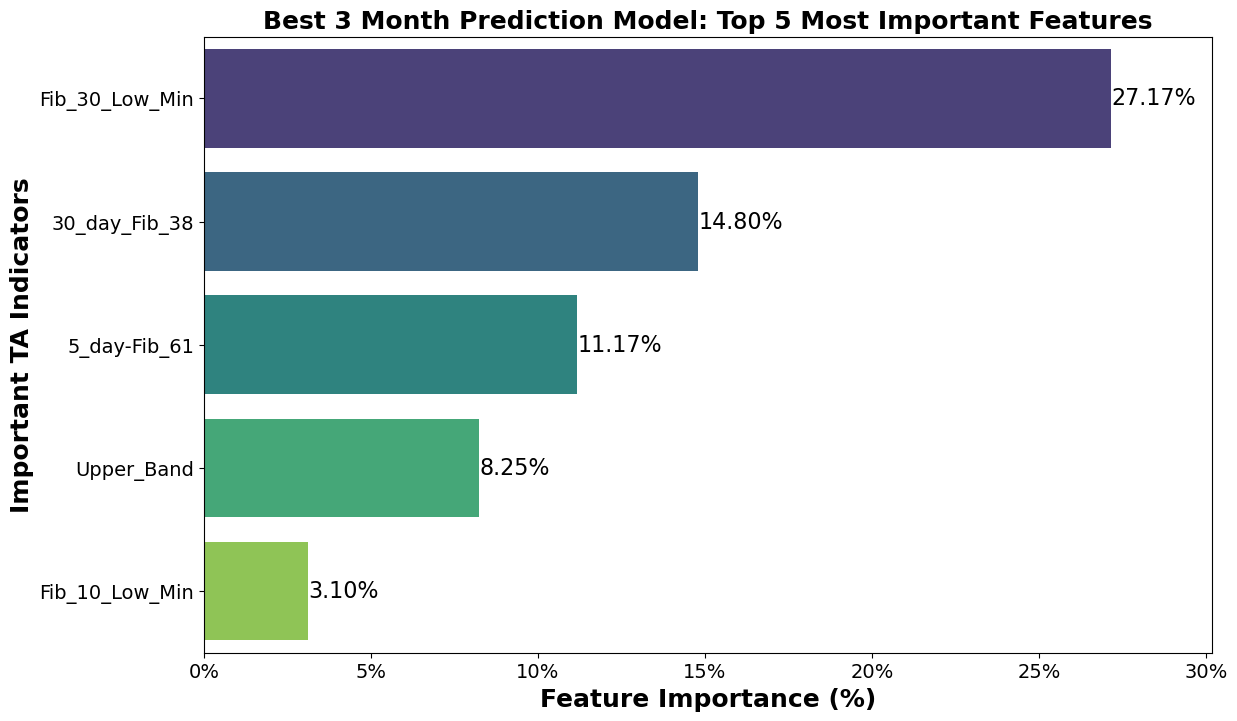

In [269]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert to NumPy arrays (ensuring correct types)
features = np.array([feature for feature, importance in sorted_features_3_month_md_3[:5]])  # Extract feature names
importances = np.array([importance for feature, importance in sorted_features_3_month_md_3[:5]])  # Extract importances

# Create a bar plot
plt.figure(figsize=(13, 8))
ax = sns.barplot(x=importances * 100, y=features, palette="viridis")

# Add text labels to the bars (feature importance values)
for i, v in enumerate(importances * 100):
    ax.text(v + 0.01, i, f"{v:.2f}%", va="center", fontsize=16)  # Adjust position & format

# Format x-axis labels to include % sign
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0f}%"))

# Extend x-axis limits for more space
plt.xlim(0, max(importances * 100) + 3)  # Extend to provide more space on the right

# Add labels and title
plt.xlabel("Feature Importance (%)", fontsize=18, fontweight='bold')  # Bigger x-axis title
plt.ylabel("Important TA Indicators", fontsize=18, fontweight='bold')  # Bigger y-axis title
plt.title("Best 3 Month Prediction Model: Top 5 Most Important Features", fontsize=18, fontweight='bold')  # Bigger title

# Increase font size for y-axis and x-axis tick labels (feature names)
ax.set_yticklabels(features, fontsize=14)
plt.xticks(fontsize=14)  # Increase font size for x-axis labels
# Show the plot
plt.show()


In [122]:
# first we will modify our feature set to add bigger lagging indicators.
# Create a new dataframe called 'df_stock_data_6_month' as a copy of 'df_stocks_price_ta'
df_stock_data_6_month = df_stocks_price_ta.copy()


In [123]:
# List of columns to create lags for (focusing on mid-term indicators)
columns_to_lag = ['Close', 'SMA_5', 'EMA_5', 'Volume', 'SMA_20',
       'SMA_50', 'EMA_5', 'EMA_20', 'EMA_50',  'EMA_12_MACD',
       'EMA_26_MACD']

# Creating lag features for each column
# [1, 3, 5, 7, 10, 12, 15, 20, 30, 60, 90, 180, 360] are the lags we will use
# but to save space, we will only use necessary lags per the timeline goal of the model
# this first model will be predicting price 1 week ahead (5 trading days)
lags = [1, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50, 60, 75, 90, 180]
for col in columns_to_lag:
    for lag in lags:
        df_stock_data_6_month[f'{col}_lag_{lag}'] = df_stock_data_6_month[col].shift(lag)

# Do not drop NaN values to maintain continuity (XGBoost can handle NaNs)
# You can handle missing values in your model later, if needed
df_stock_data_6_month.head()

/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1104426286.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_stock_data_6_month[f'{col}_lag_{lag}'] = df_stock_data_6_month[col].shift(lag)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1104426286.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_stock_data_6_month[f'{col}_lag_{lag}'] = df_stock_data_6_month[col].shift(lag)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1104426286.py:13: PerformanceWarning: DataFrame

Symbol        Date  Close   High    Low     Volume      SMA_5     SMA_20  \
0   AAPL  2022-02-10  10.52  10.73  10.20  1037700.0  10.520000  10.520000   
1   AAPL  2022-02-11  10.09  10.49  10.02   480300.0  10.305000  10.305000   
2   AAPL  2022-02-14  10.22  10.46   9.97   724400.0  10.276667  10.276667   
3   AAPL  2022-02-15  10.56  10.57  10.22   758700.0  10.347500  10.347500   
4   AAPL  2022-02-16  10.44  10.55  10.39   685200.0  10.366000  10.366000   

      SMA_50      EMA_5  ...  EMA_26_MACD_lag_15  EMA_26_MACD_lag_20  \
0  10.520000  10.520000  ...                 NaN                 NaN   
1  10.305000  10.376667  ...                 NaN                 NaN   
2  10.276667  10.324445  ...                 NaN                 NaN   
3  10.347500  10.402963  ...                 NaN                 NaN   
4  10.366000  10.415309  ...                 NaN                 NaN   

   EMA_26_MACD_lag_25  EMA_26_MACD_lag_30  EMA_26_MACD_lag_40  \
0                 NaN                 NaN                 NaN   
1                 NaN                 NaN                 NaN   
2                 NaN                 NaN                 NaN   
3                 NaN                 NaN                 NaN   
4                 NaN                 NaN                 NaN   

   EMA_26_MACD_lag_50  EMA_26_MACD_lag_60  EMA_26_MACD_lag_75  \
0                 NaN                 NaN                 NaN   
1                 NaN                 NaN                 NaN   
2                 NaN                 NaN                 NaN   
3                 NaN                 NaN                 NaN   
4                 NaN                 NaN                 NaN   

   EMA_26_MACD_lag_90  EMA_26_MACD_lag_180  
0                 NaN                  NaN  
1                 NaN                  NaN  
2                 NaN                  NaN  
3                 NaN                  NaN  
4                 NaN                  NaN  

[5 rows x 204 columns]

In [253]:
# now we're going to move onto our next model: 6 month prediction
# we'll start at our baseline model and then do the same as we just did
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
df_stock_data_6_month = df_stock_data_6_month.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to November 10, 2023 for training
df_stock_data_train_6_month_baseline = df_stock_data_6_month[df_stock_data_6_month['Date'] <= '2023-07-10']

# Filter data to only include rows with Date after February 10, 2024 for testing
df_stock_data_test_6_month_baseline = df_stock_data_6_month[df_stock_data_6_month['Date'] > '2024-01-10']

# Check if the test set is empty
if df_stock_data_test_6_month_baseline.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 20 trading days ahead (1 month ahead)
df_stock_data_train_6_month_baseline['Close_Target'] = df_stock_data_train_6_month_baseline.groupby('Symbol')['Close'].shift(-120)
df_stock_data_test_6_month_baseline['Close_Target'] = df_stock_data_test_6_month_baseline.groupby('Symbol')['Close'].shift(-120)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
df_stock_data_train_6_month_baseline = df_stock_data_train_6_month_baseline.dropna(subset=['Close_Target'])
df_stock_data_test_6_month_baseline = df_stock_data_test_6_month_baseline.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
df_stock_data_train_6_month_baseline.replace([np.inf, -np.inf], np.nan, inplace=True)
df_stock_data_test_6_month_baseline.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = df_stock_data_train_6_month_baseline.select_dtypes(include=[np.number]).columns
numeric_cols_test = df_stock_data_test_6_month_baseline.select_dtypes(include=[np.number]).columns

df_stock_data_train_6_month_baseline[numeric_cols_train] = df_stock_data_train_6_month_baseline[numeric_cols_train].fillna(df_stock_data_train_6_month_baseline[numeric_cols_train].median())
df_stock_data_test_6_month_baseline[numeric_cols_test] = df_stock_data_test_6_month_baseline[numeric_cols_test].fillna(df_stock_data_test_6_month_baseline[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {df_stock_data_train_6_month_baseline.shape}")
print(f"Testing data shape: {df_stock_data_test_6_month_baseline.shape}")

# Create X (features) and y (target) for training
X_train_6_month_baseline = df_stock_data_train_6_month_baseline.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_6_month_baseline = df_stock_data_train_6_month_baseline['Close_Target']

# Create X and y for testing
X_test_6_month_baseline = df_stock_data_test_6_month_baseline.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_6_month_baseline = df_stock_data_test_6_month_baseline['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_6_month_baseline shape: {X_train_6_month_baseline.shape}, y_train_6_month_baseline shape: {y_train_6_month_baseline.shape}")
print(f"X_test_6_month_baseline shape: {X_test_6_month_baseline.shape}, y_test_6_month_baseline shape: {y_test_6_month_baseline.shape}")

# Ensure there are samples in both training and testing sets
if X_train_6_month_baseline.shape[0] == 0 or X_test_6_month_baseline.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_baseline_6_month = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_baseline_6_month.fit(X_train_6_month_baseline, y_train_6_month_baseline)

# Make predictions on the unseen test data (post-February 10, 2024)
y_pred_6_month_baseline = model_baseline_6_month.predict(X_test_6_month_baseline)

# Calculate performance on the test data
mse_test_6_month_baseline = mean_squared_error(y_test_6_month_baseline, y_pred_6_month_baseline)
print(f'Mean Squared Error on unseen data (post-February 10, 2024): {mse_test_6_month_baseline}')



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1300590180.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_train_6_month_baseline['Close_Target'] = df_stock_data_train_6_month_baseline.groupby('Symbol')['Close'].shift(-120)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1300590180.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_test_6_month_baseline['Close_Target'] = df_stock_data_test_6_month_baseline.groupby('Symbol')['Close'].shift(

Training data shape: (406528, 205)
Testing data shape: (270615, 205)
X_train_6_month_baseline shape: (406528, 201), y_train_6_month_baseline shape: (406528,)
X_test_6_month_baseline shape: (270615, 201), y_test_6_month_baseline shape: (270615,)
Mean Squared Error on unseen data (post-February 10, 2024): 39556.315823205616


In [254]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Assuming `y_pred_6_month_baseline` are your predictions for the test data and `y_test_6_month_baseline` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_6_month_baseline = mean_squared_error(y_test_6_month_baseline, y_pred_6_month_baseline)
mae_6_month_baseline = mean_absolute_error(y_test_6_month_baseline, y_pred_6_month_baseline)
rmse_6_month_baseline = np.sqrt(mse_6_month_baseline)  # Root Mean Squared Error
r2_6_month_baseline = r2_score(y_test_6_month_baseline, y_pred_6_month_baseline)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_6_month_baseline}')
print(f'Mean Absolute Error on unseen data: {mae_6_month_baseline}')
print(f'Root Mean Squared Error on unseen data: {rmse_6_month_baseline}')
print(f'R-squared on unseen data: {r2_6_month_baseline}')

# Additional metrics
medae_6_month_baseline = median_absolute_error(y_test_6_month_baseline, y_pred_6_month_baseline)
print(f'Median Absolute Error on unseen data: {medae_6_month_baseline}')

dw_stat_6_month_baseline = durbin_watson(y_test_6_month_baseline - y_pred_6_month_baseline)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_6_month_baseline}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_6_month_baseline = np.mean(np.abs((y_test_6_month_baseline - y_pred_6_month_baseline) / y_test_6_month_baseline)) * 100
print(f'MAPE on unseen data: {mape_6_month_baseline:.2f}%')
# Get feature importance as a dictionary
feature_importance_6_month_baseline = dict(zip(X_train_6_month_baseline.columns, model_baseline_6_month.feature_importances_))

# Sort features by importance in descending order
sorted_features_6_month_baseline = sorted(feature_importance_6_month_baseline.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_6_month_baseline:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 39556.315823205616
Mean Absolute Error on unseen data: 39.416918393972786
Root Mean Squared Error on unseen data: 198.8876965103815
R-squared on unseen data: 0.8381612251405623
Median Absolute Error on unseen data: 9.123995780944824
Durbin-Watson Statistic on unseen data: 0.028605736941907666
MAPE on unseen data: 20.33%
Fib_30_High_Max: 32.51%
Middle_Band: 13.50%
EMA_12_MACD: 8.31%
Fib_5_Low_Min: 6.21%
5_day-Fib_38: 6.09%
Volume: 5.72%
EMA_5: 4.77%
Fib_5_High_Max: 4.28%
5_day-Fib_23: 3.67%
Fib_10_High_Max: 2.76%
Low: 2.16%
VWAP: 1.29%
10_day_Fib_50: 1.26%
EMA_50: 0.87%
SMA_5_lag_1: 0.59%
High: 0.54%
Cumulative_Price_Volume: 0.50%
Fib_30_Low_Min: 0.30%
EMA_12_MACD_lag_3: 0.30%
SMA_20: 0.29%
Fib_10_Low_Min: 0.28%
EMA_26_MACD_lag_40: 0.26%
5_day-Fib_61: 0.24%
30_day_Fib_61: 0.23%
Lower_Band: 0.22%
10_day_Fib_38: 0.21%
SMA_20_lag_30: 0.18%
ATR_Prev_Close: 0.17%
SMA_50: 0.13%
ATR_High_Low: 0.13%
EMA_50_lag_30: 0.13%
SMA_5: 0.12%
Close_lag_60: 0.10%
EMA_20_

In [255]:
# 6 month prediction model
# learning rate = 0.1
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
df_stock_data_6_month = df_stock_data_6_month.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to November 10, 2023 for training
df_stock_data_train_6_month_lr_1 = df_stock_data_6_month[df_stock_data_6_month['Date'] <= '2023-07-10']

# Filter data to only include rows with Date after February 10, 2024 for testing
df_stock_data_test_6_month_lr_1 = df_stock_data_6_month[df_stock_data_6_month['Date'] > '2024-01-10']

# Check if the test set is empty
if df_stock_data_test_6_month_lr_1.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 20 trading days ahead (1 month ahead)
df_stock_data_train_6_month_lr_1['Close_Target'] = df_stock_data_train_6_month_lr_1.groupby('Symbol')['Close'].shift(-120)
df_stock_data_test_6_month_lr_1['Close_Target'] = df_stock_data_test_6_month_lr_1.groupby('Symbol')['Close'].shift(-120)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
df_stock_data_train_6_month_lr_1 = df_stock_data_train_6_month_lr_1.dropna(subset=['Close_Target'])
df_stock_data_test_6_month_lr_1 = df_stock_data_test_6_month_lr_1.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
df_stock_data_train_6_month_lr_1.replace([np.inf, -np.inf], np.nan, inplace=True)
df_stock_data_test_6_month_lr_1.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = df_stock_data_train_6_month_lr_1.select_dtypes(include=[np.number]).columns
numeric_cols_test = df_stock_data_test_6_month_lr_1.select_dtypes(include=[np.number]).columns

df_stock_data_train_6_month_lr_1[numeric_cols_train] = df_stock_data_train_6_month_lr_1[numeric_cols_train].fillna(df_stock_data_train_6_month_lr_1[numeric_cols_train].median())
df_stock_data_test_6_month_lr_1[numeric_cols_test] = df_stock_data_test_6_month_lr_1[numeric_cols_test].fillna(df_stock_data_test_6_month_lr_1[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {df_stock_data_train_6_month_lr_1.shape}")
print(f"Testing data shape: {df_stock_data_test_6_month_lr_1.shape}")

# Create X (features) and y (target) for training
X_train_6_month_lr_1 = df_stock_data_train_6_month_lr_1.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_6_month_lr_1 = df_stock_data_train_6_month_lr_1['Close_Target']

# Create X and y for testing
X_test_6_month_lr_1 = df_stock_data_test_6_month_lr_1.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_6_month_lr_1 = df_stock_data_test_6_month_lr_1['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_6_month_lr_1 shape: {X_train_6_month_lr_1.shape}, y_train_6_month_lr_1 shape: {y_train_6_month_lr_1.shape}")
print(f"X_test_6_month_lr_1 shape: {X_test_6_month_lr_1.shape}, y_test_6_month_lr_1 shape: {y_test_6_month_lr_1.shape}")

# Ensure there are samples in both training and testing sets
if X_train_6_month_lr_1.shape[0] == 0 or X_test_6_month_lr_1.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_baseline_6_month_lr_1 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_baseline_6_month_lr_1.fit(X_train_6_month_lr_1, y_train_6_month_lr_1)

# Make predictions on the unseen test data (post-February 10, 2024)
y_pred_6_month_lr_1 = model_baseline_6_month_lr_1.predict(X_test_6_month_lr_1)

# Calculate performance on the test data
mse_test = mean_squared_error(y_test_6_month_lr_1, y_pred_6_month_lr_1)
print(f'Mean Squared Error on unseen data (post-February 10, 2024): {mse_test}')



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1149642476.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_train_6_month_lr_1['Close_Target'] = df_stock_data_train_6_month_lr_1.groupby('Symbol')['Close'].shift(-120)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1149642476.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_test_6_month_lr_1['Close_Target'] = df_stock_data_test_6_month_lr_1.groupby('Symbol')['Close'].shift(-120)


Training data shape: (406528, 205)
Testing data shape: (270615, 205)
X_train_6_month_lr_1 shape: (406528, 201), y_train_6_month_lr_1 shape: (406528,)
X_test_6_month_lr_1 shape: (270615, 201), y_test_6_month_lr_1 shape: (270615,)
Mean Squared Error on unseen data (post-February 10, 2024): 39709.225423030846


In [256]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np


# Assuming `y_pred_6_month_lr_1` are your predictions for the test data and `y_test_6_month_lr_1` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_6_month_lr_1 = mean_squared_error(y_test_6_month_lr_1, y_pred_6_month_lr_1)
mae_6_month_lr_1 = mean_absolute_error(y_test_6_month_lr_1, y_pred_6_month_lr_1)
rmse_6_month_lr_1 = np.sqrt(mse_6_month_lr_1)  # Root Mean Squared Error
r2_6_month_lr_1 = r2_score(y_test_6_month_lr_1, y_pred_6_month_lr_1)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_6_month_lr_1}')
print(f'Mean Absolute Error on unseen data: {mae_6_month_lr_1}')
print(f'Root Mean Squared Error on unseen data: {rmse_6_month_lr_1}')
print(f'R-squared on unseen data: {r2_6_month_lr_1}')

# Additional metrics
medae_6_month_lr_1 = median_absolute_error(y_test_6_month_lr_1, y_pred_6_month_lr_1)
print(f'Median Absolute Error on unseen data: {medae_6_month_lr_1}')

dw_stat_6_month_lr_1 = durbin_watson(y_test_6_month_lr_1 - y_pred_6_month_lr_1)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_6_month_lr_1}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_6_month_lr_1 = np.mean(np.abs((y_test_6_month_lr_1 - y_pred_6_month_lr_1) / y_test_6_month_lr_1)) * 100
print(f'MAPE on unseen data: {mape_6_month_lr_1:.2f}%')
# Get feature importance as a dictionary
feature_importance_6_month_lr_1 = dict(zip(X_train_6_month_lr_1.columns, model_baseline_6_month_lr_1.feature_importances_))

# Sort features by importance in descending order
sorted_features_6_month_lr_1 = sorted(feature_importance_6_month_lr_1.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_6_month_lr_1:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 39709.225423030846
Mean Absolute Error on unseen data: 39.93220039169745
Root Mean Squared Error on unseen data: 199.27173764242346
R-squared on unseen data: 0.8375356182865124
Median Absolute Error on unseen data: 9.373844146728516
Durbin-Watson Statistic on unseen data: 0.02865197681840183
MAPE on unseen data: 21.11%
Fib_30_High_Max: 32.47%
EMA_12_MACD: 15.43%
Middle_Band: 8.60%
Fib_5_Low_Min: 7.65%
Volume: 5.66%
5_day-Fib_38: 5.29%
Fib_5_High_Max: 4.40%
EMA_5: 3.09%
5_day-Fib_23: 2.91%
Fib_10_High_Max: 2.21%
Low: 2.11%
EMA_50: 2.04%
10_day_Fib_50: 1.37%
VWAP: 1.29%
Cumulative_Price_Volume: 0.55%
SMA_20: 0.45%
30_day_Fib_61: 0.41%
5_day-Fib_50: 0.28%
Fib_10_Low_Min: 0.26%
5_day-Fib_61: 0.24%
10_day_Fib_38: 0.22%
ATR_Prev_Close: 0.19%
Fib_30_Low_Min: 0.18%
SMA_20_lag_30: 0.18%
EMA_26_MACD_lag_40: 0.16%
SMA_5: 0.15%
Lower_Band: 0.13%
10_day_Fib_61: 0.13%
EMA_50_lag_30: 0.11%
High: 0.11%
ATR_High_Low: 0.10%
SMA_50_lag_25: 0.10%
SMA_50: 0.09%
EMA_20: 0.

In [257]:
# 6 month prediction model
# learning rate = 0.01
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
df_stock_data_6_month = df_stock_data_6_month.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to November 10, 2023 for training
df_stock_data_train_6_month_lr_01 = df_stock_data_6_month[df_stock_data_6_month['Date'] <= '2023-07-10']

# Filter data to only include rows with Date after February 10, 2024 for testing
df_stock_data_test_6_month_lr_01 = df_stock_data_6_month[df_stock_data_6_month['Date'] > '2024-01-10']

# Check if the test set is empty
if df_stock_data_test_6_month_lr_01.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 20 trading days ahead (1 month ahead)
df_stock_data_train_6_month_lr_01['Close_Target'] = df_stock_data_train_6_month_lr_01.groupby('Symbol')['Close'].shift(-120)
df_stock_data_test_6_month_lr_01['Close_Target'] = df_stock_data_test_6_month_lr_01.groupby('Symbol')['Close'].shift(-120)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
df_stock_data_train_6_month_lr_01 = df_stock_data_train_6_month_lr_01.dropna(subset=['Close_Target'])
df_stock_data_test_6_month_lr_01 = df_stock_data_test_6_month_lr_01.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
df_stock_data_train_6_month_lr_01.replace([np.inf, -np.inf], np.nan, inplace=True)
df_stock_data_test_6_month_lr_01.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = df_stock_data_train_6_month_lr_01.select_dtypes(include=[np.number]).columns
numeric_cols_test = df_stock_data_test_6_month_lr_01.select_dtypes(include=[np.number]).columns

df_stock_data_train_6_month_lr_01[numeric_cols_train] = df_stock_data_train_6_month_lr_01[numeric_cols_train].fillna(df_stock_data_train_6_month_lr_01[numeric_cols_train].median())
df_stock_data_test_6_month_lr_01[numeric_cols_test] = df_stock_data_test_6_month_lr_01[numeric_cols_test].fillna(df_stock_data_test_6_month_lr_01[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {df_stock_data_train_6_month_lr_01.shape}")
print(f"Testing data shape: {df_stock_data_test_6_month_lr_01.shape}")

# Create X (features) and y (target) for training
X_train_6_month_lr_01 = df_stock_data_train_6_month_lr_01.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_6_month_lr_01 = df_stock_data_train_6_month_lr_01['Close_Target']

# Create X and y for testing
X_test_6_month_lr_01 = df_stock_data_test_6_month_lr_01.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_6_month_lr_01 = df_stock_data_test_6_month_lr_01['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_6_month_lr_01 shape: {X_train_6_month_lr_01.shape}, y_train_6_month_lr_01 shape: {y_train_6_month_lr_01.shape}")
print(f"X_test_6_month_lr_01 shape: {X_test_6_month_lr_01.shape}, y_test_6_month_lr_01 shape: {y_test_6_month_lr_01.shape}")

# Ensure there are samples in both training and testing sets
if X_train_6_month_lr_01.shape[0] == 0 or X_test_6_month_lr_01.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_baseline_6_month_lr_01 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_baseline_6_month_lr_01.fit(X_train_6_month_lr_01, y_train_6_month_lr_01)

# Make predictions on the unseen test data (post-February 10, 2024)
y_pred_6_month_lr_01 = model_baseline_6_month_lr_01.predict(X_test_6_month_lr_01)

# Calculate performance on the test data
mse_test_6_month_lr_01 = mean_squared_error(y_test_6_month_lr_01, y_pred_6_month_lr_01)
print(f'Mean Squared Error on unseen data (post-February 10, 2024): {mse_test_6_month_lr_01}')



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/2295828896.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_train_6_month_lr_01['Close_Target'] = df_stock_data_train_6_month_lr_01.groupby('Symbol')['Close'].shift(-120)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/2295828896.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_test_6_month_lr_01['Close_Target'] = df_stock_data_test_6_month_lr_01.groupby('Symbol')['Close'].shift(-120)


Training data shape: (406528, 205)
Testing data shape: (270615, 205)
X_train_6_month_lr_01 shape: (406528, 201), y_train_6_month_lr_01 shape: (406528,)
X_test_6_month_lr_01 shape: (270615, 201), y_test_6_month_lr_01 shape: (270615,)
Mean Squared Error on unseen data (post-February 10, 2024): 39179.243873570806


In [258]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np


# Assuming `y_pred_6_month_lr_01` are your predictions for the test data and `y_test_6_month_lr_01` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_6_month_lr_01 = mean_squared_error(y_test_6_month_lr_01, y_pred_6_month_lr_01)
mae_6_month_lr_01 = mean_absolute_error(y_test_6_month_lr_01, y_pred_6_month_lr_01)
rmse_6_month_lr_01 = np.sqrt(mse_6_month_lr_01)  # Root Mean Squared Error
r2_6_month_lr_01 = r2_score(y_test_6_month_lr_01, y_pred_6_month_lr_01)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_6_month_lr_01}')
print(f'Mean Absolute Error on unseen data: {mae_6_month_lr_01}')
print(f'Root Mean Squared Error on unseen data: {rmse_6_month_lr_01}')
print(f'R-squared on unseen data: {r2_6_month_lr_01}')

# Additional metrics
medae_6_month_lr_01 = median_absolute_error(y_test_6_month_lr_01, y_pred_6_month_lr_01)
print(f'Median Absolute Error on unseen data: {medae_6_month_lr_01}')

dw_stat_6_month_lr_01 = durbin_watson(y_test_6_month_lr_01 - y_pred_6_month_lr_01)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_6_month_lr_01}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_6_month_lr_01 = np.mean(np.abs((y_test_6_month_lr_01 - y_pred_6_month_lr_01) / y_test_6_month_lr_01)) * 100
print(f'MAPE on unseen data: {mape_6_month_lr_01:.2f}%')
# Get feature importance as a dictionary
feature_importance_6_month_lr_01 = dict(zip(X_train_6_month_lr_01.columns, model_baseline_6_month_lr_01.feature_importances_))

# Sort features by importance in descending order
sorted_features_6_month_lr_01 = sorted(feature_importance_6_month_lr_01.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_6_month_lr_01:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 39179.243873570806
Mean Absolute Error on unseen data: 39.05236319493131
Root Mean Squared Error on unseen data: 197.9374746569502
R-squared on unseen data: 0.8397039588631745
Median Absolute Error on unseen data: 8.80865478515625
Durbin-Watson Statistic on unseen data: 0.02858915370029223
MAPE on unseen data: 20.07%
Fib_30_High_Max: 48.93%
Middle_Band: 5.77%
EMA_12_MACD: 5.00%
Volume: 4.90%
Fib_5_Low_Min: 4.31%
Fib_5_High_Max: 4.11%
Fib_10_High_Max: 3.50%
5_day-Fib_38: 3.11%
EMA_5: 3.09%
5_day-Fib_23: 1.99%
VWAP: 1.85%
Low: 1.19%
High: 1.17%
10_day_Fib_50: 1.08%
EMA_50: 1.04%
5_day-Fib_61: 0.64%
SMA_5_lag_1: 0.54%
Fib_10_Low_Min: 0.49%
Lower_Band: 0.46%
Fib_30_Low_Min: 0.45%
10_day_Fib_38: 0.45%
SMA_20: 0.41%
Cumulative_Price_Volume: 0.41%
EMA_12_MACD_lag_3: 0.40%
30_day_Fib_61: 0.37%
EMA_50_lag_90: 0.31%
SMA_20_lag_30: 0.28%
EMA_50_lag_30: 0.24%
EMA_26_MACD_lag_40: 0.20%
ATR_High_Low: 0.19%
10_day_Fib_23: 0.19%
SMA_50: 0.17%
EMA_20: 0.16%
SMA_5: 0.1

model with learning_rate 0.01 performs the best

In [259]:
# 6 month prediction model
# learning rate = 0.01
# max_depth = 3
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Sort values by 'Symbol' and 'Date' to maintain time order
df_stock_data_6_month = df_stock_data_6_month.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to November 10, 2023 for training
df_stock_data_train_6_month_md_3 = df_stock_data_6_month[df_stock_data_6_month['Date'] <= '2023-07-10']

# Filter data to only include rows with Date after February 10, 2024 for testing
df_stock_data_test_6_month_md_3 = df_stock_data_6_month[df_stock_data_6_month['Date'] > '2024-01-10']

# Check if the test set is empty
if df_stock_data_test_6_month_md_3.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 20 trading days ahead (1 month ahead)
df_stock_data_train_6_month_md_3['Close_Target'] = df_stock_data_train_6_month_md_3.groupby('Symbol')['Close'].shift(-120)
df_stock_data_test_6_month_md_3['Close_Target'] = df_stock_data_test_6_month_md_3.groupby('Symbol')['Close'].shift(-120)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
df_stock_data_train_6_month_md_3 = df_stock_data_train_6_month_md_3.dropna(subset=['Close_Target'])
df_stock_data_test_6_month_md_3 = df_stock_data_test_6_month_md_3.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
df_stock_data_train_6_month_md_3.replace([np.inf, -np.inf], np.nan, inplace=True)
df_stock_data_test_6_month_md_3.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = df_stock_data_train_6_month_md_3.select_dtypes(include=[np.number]).columns
numeric_cols_test = df_stock_data_test_6_month_md_3.select_dtypes(include=[np.number]).columns

df_stock_data_train_6_month_md_3[numeric_cols_train] = df_stock_data_train_6_month_md_3[numeric_cols_train].fillna(df_stock_data_train_6_month_md_3[numeric_cols_train].median())
df_stock_data_test_6_month_md_3[numeric_cols_test] = df_stock_data_test_6_month_md_3[numeric_cols_test].fillna(df_stock_data_test_6_month_md_3[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {df_stock_data_train_6_month_md_3.shape}")
print(f"Testing data shape: {df_stock_data_test_6_month_md_3.shape}")

# Create X (features) and y (target) for training
X_train_6_month_md_3 = df_stock_data_train_6_month_md_3.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_6_month_md_3 = df_stock_data_train_6_month_md_3['Close_Target']

# Create X and y for testing
X_test_6_month_md_3 = df_stock_data_test_6_month_md_3.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_6_month_md_3 = df_stock_data_test_6_month_md_3['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_6_month_md_3 shape: {X_train_6_month_md_3.shape}, y_train_6_month_md_3 shape: {y_train_6_month_md_3.shape}")
print(f"X_test_6_month_md_3 shape: {X_test_6_month_md_3.shape}, y_test_6_month_md_3 shape: {y_test_6_month_md_3.shape}")

# Ensure there are samples in both training and testing sets
if X_train_6_month_md_3.shape[0] == 0 or X_test_6_month_md_3.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_baseline_6_month_md_3 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=3,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_baseline_6_month_md_3.fit(X_train_6_month_md_3, y_train_6_month_md_3)

# Make predictions on the unseen test data (post-February 10, 2024)
y_pred_6_month_md_3 = model_baseline_6_month_md_3.predict(X_test_6_month_md_3)

# Calculate performance on the test data
mse_test_6_month_md_3 = mean_squared_error(y_test_6_month_md_3, y_pred_6_month_md_3)
print(f'Mean Squared Error on unseen data (post-February 10, 2024): {mse_test_6_month_md_3}')



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/3230166457.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_train_6_month_md_3['Close_Target'] = df_stock_data_train_6_month_md_3.groupby('Symbol')['Close'].shift(-120)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/3230166457.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_test_6_month_md_3['Close_Target'] = df_stock_data_test_6_month_md_3.groupby('Symbol')['Close'].shift(-120)


Training data shape: (406528, 205)
Testing data shape: (270615, 205)
X_train_6_month_md_3 shape: (406528, 201), y_train_6_month_md_3 shape: (406528,)
X_test_6_month_md_3 shape: (270615, 201), y_test_6_month_md_3 shape: (270615,)
Mean Squared Error on unseen data (post-February 10, 2024): 31411.174267588787


In [260]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np


# Assuming `y_pred_6_month_md_3` are your predictions for the test data and `y_test_6_month_md_3` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_6_month_md_3 = mean_squared_error(y_test_6_month_md_3, y_pred_6_month_md_3)
mae_6_month_md_3 = mean_absolute_error(y_test_6_month_md_3, y_pred_6_month_md_3)
rmse_6_month_md_3 = np.sqrt(mse_6_month_md_3)  # Root Mean Squared Error
r2_6_month_md_3 = r2_score(y_test_6_month_md_3, y_pred_6_month_md_3)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_6_month_md_3}')
print(f'Mean Absolute Error on unseen data: {mae_6_month_md_3}')
print(f'Root Mean Squared Error on unseen data: {rmse_6_month_md_3}')
print(f'R-squared on unseen data: {r2_6_month_md_3}')

# Additional metrics
medae_6_month_md_3 = median_absolute_error(y_test_6_month_md_3, y_pred_6_month_md_3)
print(f'Median Absolute Error on unseen data: {medae_6_month_md_3}')

dw_stat_6_month_md_3 = durbin_watson(y_test_6_month_md_3 - y_pred_6_month_md_3)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_6_month_md_3}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_6_month_md_3 = np.mean(np.abs((y_test_6_month_md_3 - y_pred_6_month_md_3) / y_test_6_month_md_3)) * 100
print(f'MAPE on unseen data: {mape_6_month_md_3:.2f}%')
# Get feature importance as a dictionary
feature_importance_6_month_md_3 = dict(zip(X_train_6_month_md_3.columns, model_baseline_6_month_md_3.feature_importances_))

# Sort features by importance in descending order
sorted_features_6_month_md_3 = sorted(feature_importance_6_month_md_3.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_6_month_md_3:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 31411.174267588787
Mean Absolute Error on unseen data: 34.84146322021573
Root Mean Squared Error on unseen data: 177.23197868214638
R-squared on unseen data: 0.871485858716382
Median Absolute Error on unseen data: 8.994926452636719
Durbin-Watson Statistic on unseen data: 0.020845241129731375
MAPE on unseen data: 21.51%
Fib_10_High_Max: 17.93%
Fib_30_High_Max: 13.03%
Fib_5_Low_Min: 12.74%
ATR_High_Low: 5.86%
10_day_Fib_50: 4.75%
EMA_50_lag_25: 4.42%
EMA_5: 2.79%
Middle_Band: 2.77%
Volume: 2.74%
EMA_12_MACD: 2.23%
EMA_50: 2.11%
Fib_5_High_Max: 2.10%
5_day-Fib_61: 1.93%
Low: 1.78%
High: 1.60%
30_day_Fib_61: 1.47%
VWAP: 1.45%
Fib_30_Low_Min: 1.18%
EMA_26_MACD_lag_40: 1.09%
SMA_50: 1.05%
Fib_10_Low_Min: 1.02%
SMA_50_lag_90: 1.01%
SMA_5: 0.98%
EMA_50_lag_30: 0.97%
ATR: 0.92%
SMA_50_lag_20: 0.76%
EMA_20: 0.69%
Close_lag_90: 0.65%
5_day-Fib_23: 0.58%
SMA_50_lag_25: 0.55%
ATR_Prev_Close: 0.54%
Lower_Band: 0.53%
Std_Dev: 0.43%
ATR_True_Range: 0.38%
Volume_lag_7

In [261]:
# 6 month prediction model
# learning rate = 0.01
# max_depth = 7
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
df_stock_data_6_month = df_stock_data_6_month.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to November 10, 2023 for training
df_stock_data_train_6_month_md_7 = df_stock_data_6_month[df_stock_data_6_month['Date'] <= '2023-07-10']

# Filter data to only include rows with Date after February 10, 2024 for testing
df_stock_data_test_6_month_md_7 = df_stock_data_6_month[df_stock_data_6_month['Date'] > '2024-01-10']

# Check if the test set is empty
if df_stock_data_test_6_month_md_7.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 20 trading days ahead (1 month ahead)
df_stock_data_train_6_month_md_7['Close_Target'] = df_stock_data_train_6_month_md_7.groupby('Symbol')['Close'].shift(-120)
df_stock_data_test_6_month_md_7['Close_Target'] = df_stock_data_test_6_month_md_7.groupby('Symbol')['Close'].shift(-120)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
df_stock_data_train_6_month_md_7 = df_stock_data_train_6_month_md_7.dropna(subset=['Close_Target'])
df_stock_data_test_6_month_md_7 = df_stock_data_test_6_month_md_7.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
df_stock_data_train_6_month_md_7.replace([np.inf, -np.inf], np.nan, inplace=True)
df_stock_data_test_6_month_md_7.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = df_stock_data_train_6_month_md_7.select_dtypes(include=[np.number]).columns
numeric_cols_test = df_stock_data_test_6_month_md_7.select_dtypes(include=[np.number]).columns

df_stock_data_train_6_month_md_7[numeric_cols_train] = df_stock_data_train_6_month_md_7[numeric_cols_train].fillna(df_stock_data_train_6_month_md_7[numeric_cols_train].median())
df_stock_data_test_6_month_md_7[numeric_cols_test] = df_stock_data_test_6_month_md_7[numeric_cols_test].fillna(df_stock_data_test_6_month_md_7[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {df_stock_data_train_6_month_md_7.shape}")
print(f"Testing data shape: {df_stock_data_test_6_month_md_7.shape}")

# Create X (features) and y (target) for training
X_train_6_month_md_7 = df_stock_data_train_6_month_md_7.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_6_month_md_7 = df_stock_data_train_6_month_md_7['Close_Target']

# Create X and y for testing
X_test_6_month_md_7 = df_stock_data_test_6_month_md_7.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_6_month_md_7 = df_stock_data_test_6_month_md_7['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_6_month_md_7 shape: {X_train_6_month_md_7.shape}, y_train_6_month_md_7 shape: {y_train_6_month_md_7.shape}")
print(f"X_test_6_month_md_7 shape: {X_test_6_month_md_7.shape}, y_test_6_month_md_7 shape: {y_test_6_month_md_7.shape}")

# Ensure there are samples in both training and testing sets
if X_train_6_month_md_7.shape[0] == 0 or X_test_6_month_md_7.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_baseline_6_month_md_7 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=7,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_baseline_6_month_md_7.fit(X_train_6_month_md_7, y_train_6_month_md_7)

# Make predictions on the unseen test data (post-February 10, 2024)
y_pred_6_month_md_7 = model_baseline_6_month_md_7.predict(X_test_6_month_md_7)

# Calculate performance on the test data
mse_test_6_month_md_7 = mean_squared_error(y_test_6_month_md_7, y_pred_6_month_md_7)
print(f'Mean Squared Error on unseen data (post-February 10, 2024): {mse_test_6_month_md_7}')



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/2152527354.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_train_6_month_md_7['Close_Target'] = df_stock_data_train_6_month_md_7.groupby('Symbol')['Close'].shift(-120)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/2152527354.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_test_6_month_md_7['Close_Target'] = df_stock_data_test_6_month_md_7.groupby('Symbol')['Close'].shift(-120)


Training data shape: (406528, 205)
Testing data shape: (270615, 205)
X_train_6_month_md_7 shape: (406528, 201), y_train_6_month_md_7 shape: (406528,)
X_test_6_month_md_7 shape: (270615, 201), y_test_6_month_md_7 shape: (270615,)
Mean Squared Error on unseen data (post-February 10, 2024): 43856.30757644138


In [262]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np


# Assuming `y_pred_6_month_md_7` are your predictions for the test data and `y_test_6_month_md_7` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_6_month_md_7 = mean_squared_error(y_test_6_month_md_7, y_pred_6_month_md_7)
mae_6_month_md_7 = mean_absolute_error(y_test_6_month_md_7, y_pred_6_month_md_7)
rmse_6_month_md_7 = np.sqrt(mse_6_month_md_7)  # Root Mean Squared Error
r2_6_month_md_7 = r2_score(y_test_6_month_md_7, y_pred_6_month_md_7)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_6_month_md_7}')
print(f'Mean Absolute Error on unseen data: {mae_6_month_md_7}')
print(f'Root Mean Squared Error on unseen data: {rmse_6_month_md_7}')
print(f'R-squared on unseen data: {r2_6_month_md_7}')

# Additional metrics
medae_6_month_md_7 = median_absolute_error(y_test_6_month_md_7, y_pred_6_month_md_7)
print(f'Median Absolute Error on unseen data: {medae_6_month_md_7}')

dw_stat_6_month_md_7 = durbin_watson(y_test_6_month_md_7 - y_pred_6_month_md_7)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_6_month_md_7}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_6_month_md_7 = np.mean(np.abs((y_test_6_month_md_7 - y_pred_6_month_md_7) / y_test_6_month_md_7)) * 100
print(f'MAPE on unseen data: {mape_6_month_md_7:.2f}%')
# Get feature importance as a dictionary
feature_importance_6_month_md_7 = dict(zip(X_train_6_month_md_7.columns, model_baseline_6_month_md_7.feature_importances_))

# Sort features by importance in descending order
sorted_features_6_month_md_7 = sorted(feature_importance_6_month_md_7.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_6_month_md_7:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 43856.30757644138
Mean Absolute Error on unseen data: 40.75621874158073
Root Mean Squared Error on unseen data: 209.41897616128625
R-squared on unseen data: 0.8205684493026995
Median Absolute Error on unseen data: 9.070610046386719
Durbin-Watson Statistic on unseen data: 0.02741931648833066
MAPE on unseen data: 20.17%
Fib_30_High_Max: 45.49%
EMA_12_MACD: 10.16%
Fib_5_High_Max: 6.96%
Middle_Band: 6.71%
EMA_5: 6.36%
Fib_5_Low_Min: 4.69%
Fib_10_High_Max: 3.66%
Volume: 3.49%
VWAP: 1.42%
EMA_50: 1.20%
30_day_Fib_61: 1.15%
High: 1.00%
Low: 0.95%
5_day-Fib_23: 0.78%
10_day_Fib_50: 0.59%
10_day_Fib_23: 0.56%
Cumulative_Price_Volume: 0.45%
SMA_20_lag_30: 0.40%
Fib_10_Low_Min: 0.31%
EMA_26_MACD: 0.30%
5_day-Fib_61: 0.26%
EMA_12_MACD_lag_3: 0.25%
SMA_50: 0.24%
Fib_30_Low_Min: 0.23%
EMA_50_lag_25: 0.22%
EMA_50_lag_90: 0.20%
5_day-Fib_38: 0.15%
EMA_50_lag_75: 0.09%
Lower_Band: 0.07%
SMA_50_lag_25: 0.07%
EMA_26_MACD_lag_60: 0.07%
SMA_5: 0.06%
EMA_26_MACD_lag_180: 0

best model: learning_rate = 0.01 and max_depth = 3

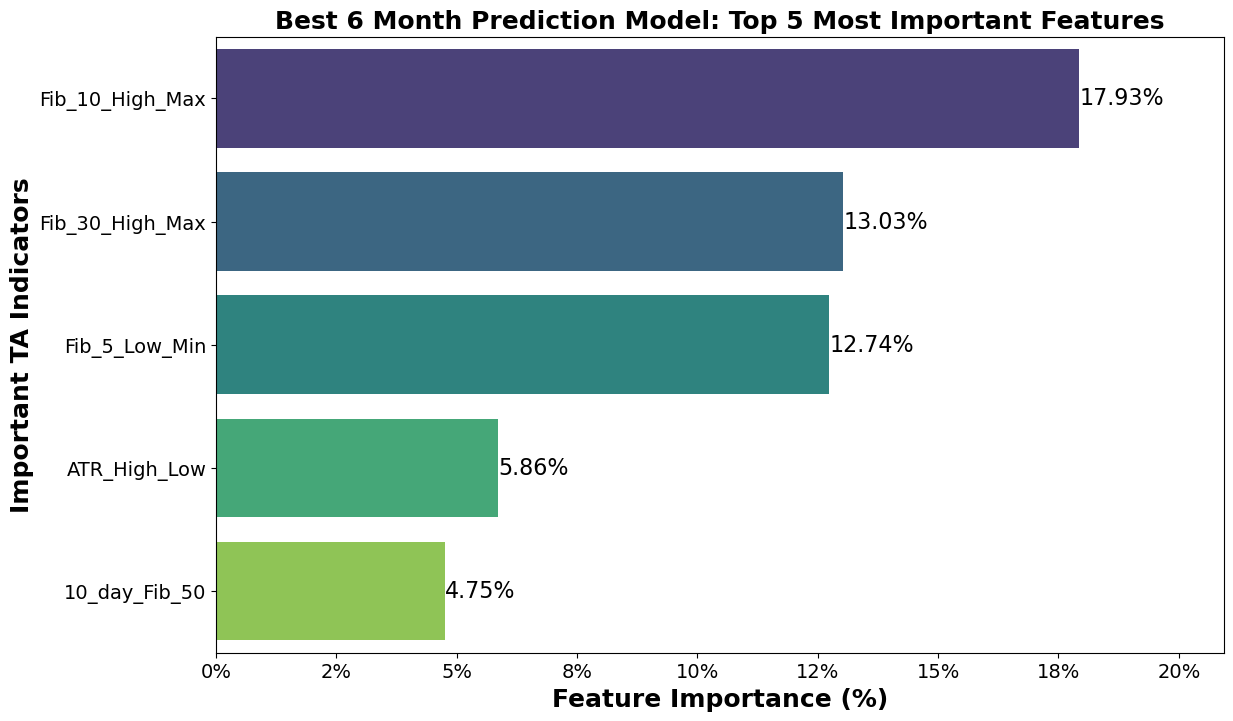

In [270]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert to NumPy arrays (ensuring correct types)
features = np.array([feature for feature, importance in sorted_features_6_month_md_3[:5]])  # Extract feature names
importances = np.array([importance for feature, importance in sorted_features_6_month_md_3[:5]])  # Extract importances

# Create a bar plot
plt.figure(figsize=(13, 8))
ax = sns.barplot(x=importances * 100, y=features, palette="viridis")

# Add text labels to the bars (feature importance values)
for i, v in enumerate(importances * 100):
    ax.text(v + 0.01, i, f"{v:.2f}%", va="center", fontsize=16)  # Adjust position & format

# Format x-axis labels to include % sign
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0f}%"))

# Extend x-axis limits for more space
plt.xlim(0, max(importances * 100) + 3)  # Extend to provide more space on the right

# Add labels and title
plt.xlabel("Feature Importance (%)", fontsize=18, fontweight='bold')  # Bigger x-axis title
plt.ylabel("Important TA Indicators", fontsize=18, fontweight='bold')  # Bigger y-axis title
plt.title("Best 6 Month Prediction Model: Top 5 Most Important Features", fontsize=18, fontweight='bold')  # Bigger title

# Increase font size for y-axis and x-axis tick labels (feature names)
ax.set_yticklabels(features, fontsize=14)
plt.xticks(fontsize=14)  # Increase font size for x-axis labels
# Show the plot
plt.show()


Best model metrics

most important metrics to visualize:

1. Root Mean Squared Error
2. R-squared
3. MAPE
4. Median Absolute Error

1 week:

Mean Squared Error on unseen data: 7604.147083529955
Mean Absolute Error on unseen data: 10.044193260395863
Root Mean Squared Error on unseen data: 87.20176078227982
R-squared on unseen data: 0.9656152295864199
Median Absolute Error on unseen data: 1.588897705078125
Durbin-Watson Statistic on unseen data: 0.1674710246723756
MAPE on unseen data: 3.96%




Fib_10_Low_Min: 63.23%
Fib_30_High_Max: 14.79%
Low: 4.90%
5_day-Fib_38: 4.25%
High: 3.05%
5_day-Fib_61: 1.76%
10_day_Fib_23: 1.33%
Fib_30_Low_Min: 1.28%
Volume: 1.07%
Fib_5_Low_Min: 0.89%
5_day-Fib_50: 0.66%
EMA_5: 0.49%
SMA_5: 0.44%
30_day_Fib_38: 0.42%
5_day-Fib_23: 0.24%
Std_Dev: 0.20%
Cumulative_Price_Volume: 0.20%
EMA_12_MACD: 0.08%
SMA_20: 0.08%
30_day_Fib_50: 0.06%
VWAP: 0.05%
30_day_Fib_61: 0.05%
SMA_5_lag_7: 0.05%
ATR_True_Range: 0.05%
SMA_50: 0.05%
ATR_Prev_Close: 0.05%
Cumulative_Volume: 0.05%
Fib_5_High_Max: 0.04%
EMA_20: 0.04%
ATR: 0.03%
Upper_Band: 0.03%
Fib_10_High_Max: 0.01%
Lower_Band: 0.01%
Volume_lag_1: 0.01%
EMA_26_MACD: 0.01%
EMA_50: 0.01%
10_day_Fib_61: 0.01%


1 month:

Mean Squared Error on unseen data: 10844.724459170979
Mean Absolute Error on unseen data: 15.639166248218757
Root Mean Squared Error on unseen data: 104.13800679469037
R-squared on unseen data: 0.9513849924746814
Median Absolute Error on unseen data: 3.326946258544922
Durbin-Watson Statistic on unseen data: 0.0750817215794377
MAPE on unseen data: 7.82%

30_day_Fib_23: 52.41%
Fib_30_High_Max: 32.44%
Fib_5_Low_Min: 2.25%
Low: 2.08%
10_day_Fib_23: 1.96%
High: 1.77%
Volume: 1.43%
5_day-Fib_50: 1.11%
30_day_Fib_50: 0.68%
10_day_Fib_38: 0.62%
5_day-Fib_23: 0.48%
Fib_10_High_Max: 0.28%
Fib_10_Low_Min: 0.25%
Std_Dev: 0.21%
VWAP: 0.21%
ATR_Prev_Close: 0.20%
EMA_5: 0.19%
Fib_5_High_Max: 0.19%
Cumulative_Price_Volume: 0.17%
Lower_Band: 0.16%
EMA_26_MACD: 0.14%
30_day_Fib_61: 0.11%
SMA_5: 0.11%
SMA_20_lag_1: 0.06%
Upper_Band: 0.05%
5_day-Fib_61: 0.04%
ATR_True_Range: 0.04%
Cumulative_Volume: 0.04%
30_day_Fib_38: 0.03%
10_day_Fib_61: 0.03%
EMA_50: 0.02%
Fib_30_Low_Min: 0.02%
ATR: 0.02%
Volume_lag_1: 0.02%
Close_lag_1: 0.02%
EMA_20_lag_20: 0.02%
SMA_50: 0.01%
EMA_12_MACD_lag_15: 0.01%
EMA_12_MACD_lag_12: 0.01%


3 months:

Mean Squared Error on unseen data: 25855.13009374476
Mean Absolute Error on unseen data: 25.29591435606357
Root Mean Squared Error on unseen data: 160.79530494931984
R-squared on unseen data: 0.8883720519645201
Median Absolute Error on unseen data: 6.283714294433594
Durbin-Watson Statistic on unseen data: 0.017109218495924613
MAPE on unseen data: 15.52%

Fib_30_Low_Min: 27.17%
30_day_Fib_38: 14.80%
5_day-Fib_61: 11.17%
Upper_Band: 8.25%
Fib_10_Low_Min: 3.10%
10_day_Fib_50: 2.76%
Close_lag_1: 2.34%
Volume: 1.87%
EMA_5: 1.82%
Fib_5_Low_Min: 1.69%
Fib_5_High_Max: 1.51%
30_day_Fib_23: 1.50%
High: 1.48%
EMA_50_lag_25: 1.37%
30_day_Fib_50: 1.29%
ATR_High_Low: 1.20%
EMA_26_MACD: 1.11%
EMA_50: 1.08%
SMA_50: 1.02%
ATR: 1.00%
10_day_Fib_61: 0.87%
Low: 0.86%
EMA_12_MACD: 0.82%
Close_lag_90: 0.76%
5_day-Fib_23: 0.76%
EMA_20: 0.73%
SMA_20_lag_90: 0.60%
EMA_12_MACD_lag_90: 0.58%
10_day_Fib_38: 0.57%
VWAP: 0.55%
30_day_Fib_61: 0.54%
Volume_lag_50: 0.53%
ATR_True_Range: 0.39%
ATR_Prev_Close: 0.32%
SMA_5_lag_90: 0.31%
EMA_50_lag_30: 0.30%
Lower_Band: 0.28%
Fib_30_High_Max: 0.24%
Std_Dev: 0.23%
Volume_lag_3: 0.16%
Volume_lag_25: 0.15%
SMA_50_lag_60: 0.13%
EMA_26_MACD_lag_40: 0.13%
Cumulative_Price_Volume: 0.13%
EMA_50_lag_20: 0.12%
Volume_lag_75: 0.11%
EMA_12_MACD_lag_20: 0.10%
SMA_50_lag_10: 0.07%
Volume_lag_60: 0.07%
EMA_20_lag_15: 0.06%
EMA_50_lag_50: 0.05%
SMA_50_lag_3: 0.05%
EMA_5_lag_40: 0.04%
SMA_50_lag_5: 0.04%
EMA_50_lag_75: 0.04%
Cumulative_Volume: 0.04%
SMA_5_lag_60: 0.04%
Fib_10_High_Max: 0.04%
EMA_50_lag_60: 0.03%
SMA_50_lag_30: 0.03%
SMA_5_lag_25: 0.03%
Volume_lag_90: 0.03%
SMA_20_lag_25: 0.03%
SMA_50_lag_7: 0.03%
ATR_High_Close: 0.02%
EMA_50_lag_90: 0.02%
SMA_20_lag_40: 0.02%
Signal_Line: 0.02%
Volume_lag_1: 0.02%
SMA_50_lag_20: 0.02%
SMA_20_lag_30: 0.02%
EMA_26_MACD_lag_50: 0.02%
SMA_5_lag_50: 0.02%
SMA_50_lag_15: 0.02%
Volume_lag_40: 0.02%
SMA_50_lag_25: 0.01%
EMA_50_lag_15: 0.01%
EMA_12_MACD_lag_40: 0.01%
MACD: 0.01%
SMA_20_lag_20: 0.01%
EMA_12_MACD_lag_15: 0.01%
Volume_lag_5: 0.01%
SMA_5: 0.01%
SMA_5_lag_15: 0.01%
EMA_26_MACD_lag_30: 0.01%
Close_lag_20: 0.01%
EMA_20_lag_50: 0.01%
Close_lag_25: 0.01%
Volume_lag_20: 0.01%
Close_lag_40: 0.01%
EMA_5_lag_50: 0.01%
SMA_5_lag_40: 0.01%
SMA_50_lag_90: 0.01%
5_day-Fib_50: 0.01%
SMA_50_lag_40: 0.01%
EMA_5_lag_75: 0.01%
SMA_20_lag_50: 0.01%
Close_lag_10: 0.01%
EMA_12_MACD_lag_5: 0.01%


6 months:

Mean Squared Error on unseen data: 31411.174267588787
Mean Absolute Error on unseen data: 34.84146322021573
Root Mean Squared Error on unseen data: 177.23197868214638
R-squared on unseen data: 0.871485858716382
Median Absolute Error on unseen data: 8.994926452636719
Durbin-Watson Statistic on unseen data: 0.020845241129731375
MAPE on unseen data: 21.51%

Fib_10_High_Max: 17.93%
Fib_30_High_Max: 13.03%
Fib_5_Low_Min: 12.74%
ATR_High_Low: 5.86%
10_day_Fib_50: 4.75%
EMA_50_lag_25: 4.42%
EMA_5: 2.79%
Middle_Band: 2.77%
Volume: 2.74%
EMA_12_MACD: 2.23%
EMA_50: 2.11%
Fib_5_High_Max: 2.10%
5_day-Fib_61: 1.93%
Low: 1.78%
High: 1.60%
30_day_Fib_61: 1.47%
VWAP: 1.45%
Fib_30_Low_Min: 1.18%
EMA_26_MACD_lag_40: 1.09%
SMA_50: 1.05%
Fib_10_Low_Min: 1.02%
SMA_50_lag_90: 1.01%
SMA_5: 0.98%
EMA_50_lag_30: 0.97%
ATR: 0.92%
SMA_50_lag_20: 0.76%
EMA_20: 0.69%
Close_lag_90: 0.65%
5_day-Fib_23: 0.58%
SMA_50_lag_25: 0.55%
ATR_Prev_Close: 0.54%
Lower_Band: 0.53%
Std_Dev: 0.43%
ATR_True_Range: 0.38%
Volume_lag_75: 0.35%
SMA_5_lag_60: 0.31%
30_day_Fib_23: 0.29%
EMA_12_MACD_lag_3: 0.21%
10_day_Fib_38: 0.21%
Volume_lag_60: 0.20%
SMA_50_lag_75: 0.20%
Volume_lag_1: 0.18%
EMA_5_lag_75: 0.17%
SMA_50_lag_3: 0.17%
Close_lag_180: 0.17%
Cumulative_Price_Volume: 0.16%
Volume_lag_50: 0.15%
5_day-Fib_50: 0.15%
EMA_50_lag_1: 0.14%
EMA_50_lag_90: 0.13%
Volume_lag_30: 0.13%
10_day_Fib_61: 0.12%
EMA_50_lag_40: 0.09%
EMA_20_lag_180: 0.08%
SMA_50_lag_40: 0.08%
Volume_lag_25: 0.08%
EMA_50_lag_75: 0.06%
Volume_lag_3: 0.05%
Cumulative_Volume: 0.04%
Volume_lag_5: 0.04%
EMA_20_lag_90: 0.04%
Signal_Line: 0.04%
EMA_50_lag_180: 0.04%
Volume_lag_40: 0.04%
EMA_26_MACD: 0.03%
EMA_26_MACD_lag_180: 0.03%
Upper_Band: 0.03%
EMA_12_MACD_lag_180: 0.03%
EMA_20_lag_3: 0.03%
EMA_5_lag_40: 0.03%
EMA_12_MACD_lag_40: 0.03%
SMA_50_lag_180: 0.02%
SMA_20_lag_15: 0.02%
Volume_lag_20: 0.02%
SMA_20_lag_30: 0.02%
EMA_12_MACD_lag_25: 0.02%
EMA_5_lag_60: 0.02%
SMA_5_lag_7: 0.02%
Volume_lag_180: 0.02%
EMA_5_lag_50: 0.02%
EMA_50_lag_15: 0.02%
SMA_50_lag_50: 0.02%
SMA_20_lag_60: 0.02%
SMA_20_lag_40: 0.02%
EMA_26_MACD_lag_10: 0.01%
Close_lag_20: 0.01%
5_day-Fib_38: 0.01%
Close_lag_50: 0.01%
MACD: 0.01%
EMA_20_lag_40: 0.01%
Close_lag_10: 0.01%
EMA_20_lag_50: 0.01%
SMA_5_lag_30: 0.01%
SMA_50_lag_10: 0.01%
Volume_lag_10: 0.01%
MACD_Histogram: 0.01%
EMA_50_lag_20: 0.01%
RSI: 0.01%
10_day_Fib_23: 0.01%
%D: 0.01%
Close_lag_5: 0.01%
Volume_lag_90: 0.01%
Volume_lag_15: 0.01%
SMA_20_lag_3: 0.01%
EMA_20_lag_15: 0.01%
SMA_5_lag_90: 0.01%
EMA_12_MACD_lag_50: 0.01%
SMA_20_lag_75: 0.01%
EMA_20_lag_75: 0.01%
EMA_50_lag_60: 0.01%
SMA_50_lag_1: 0.01%
SMA_50_lag_60: 0.01%
EMA_26_MACD_lag_60: 0.01%
Close_lag_1: 0.01%
Volume_lag_7: 0.01%
SMA_20_lag_90: 0.01%
Close_lag_75: 0.01%




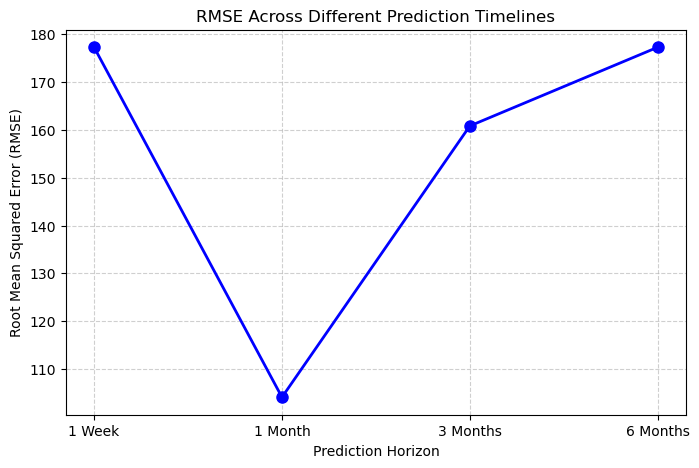

In [293]:
# Root mean squared error graph
import matplotlib.pyplot as plt

# Define time horizons and RMSE values
time_horizons = ["1 Week", "1 Month", "3 Months", "6 Months"]
rmse_values = [rmse_1_week_md_7, rmse_1_month_md_7, rmse_3_month_md_3, rmse_6_month_md_3]

# Create line plot
plt.figure(figsize=(8, 5))
plt.plot(time_horizons, rmse_values, marker='o', linestyle='-', color='b', linewidth=2, markersize=8)

# Labels and title
plt.xlabel("Prediction Horizon")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.title("RMSE Across Different Prediction Timelines")
plt.grid(True, linestyle='--', alpha=0.6)

# Display plot
plt.show()


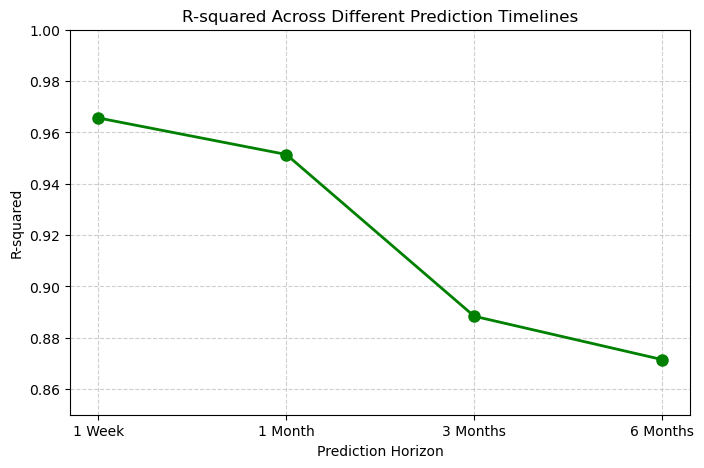

In [297]:
# r squared graph
import matplotlib.pyplot as plt

# Define time horizons and R-squared values
time_horizons = ["1 Week", "1 Month", "3 Months", "6 Months"]
r_squared_values = [r2_1_week_md_7, r2_1_month_md_7, r2_3_month_md_3, r2_6_month_md_3]

# Create line plot
plt.figure(figsize=(8, 5))
plt.plot(time_horizons, r_squared_values, marker='o', linestyle='-', color='g', linewidth=2, markersize=8)

# Labels and title
plt.xlabel("Prediction Horizon")
plt.ylabel("R-squared")
plt.title("R-squared Across Different Prediction Timelines")
plt.ylim(0.85, 1.0)  # Setting limits for better visualization
plt.grid(True, linestyle='--', alpha=0.6)

# Display plot
plt.show()


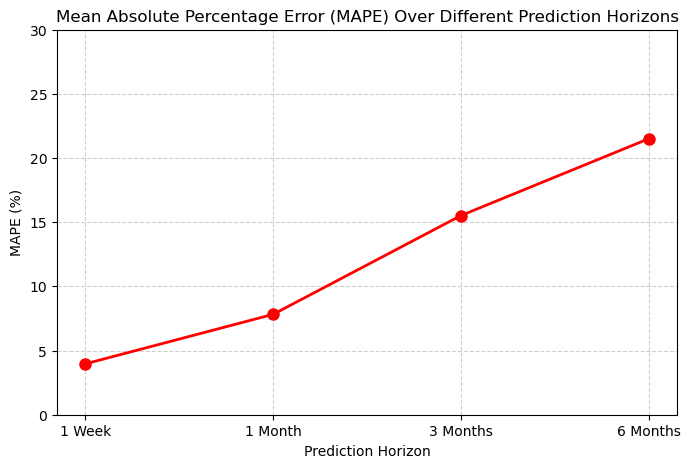

In [298]:
# MAPE graph
import matplotlib.pyplot as plt

# Define time horizons and MAPE values
time_horizons = ["1 Week", "1 Month", "3 Months", "6 Months"]
mape_values = [mape_1_week_md_7, mape_1_month_md_7, mape_3_month_md_3, mape_6_month_md_3]

# Create line plot
plt.figure(figsize=(8, 5))
plt.plot(time_horizons, mape_values, marker='o', linestyle='-', color='r', linewidth=2, markersize=8)

# Labels and title
plt.xlabel("Prediction Horizon")
plt.ylabel("MAPE (%)")
plt.title("Mean Absolute Percentage Error (MAPE) Over Different Prediction Horizons")
plt.ylim(0, 30)  # Adjusted for better visualization
plt.grid(True, linestyle='--', alpha=0.6)

# Display plot
plt.show()


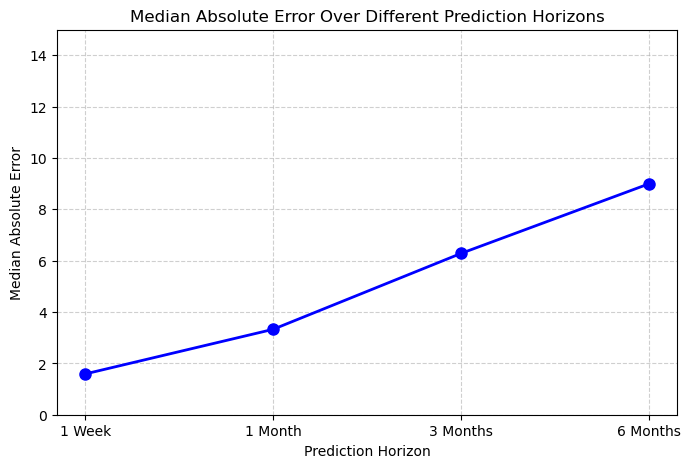

In [299]:
# Median Absolute Error
import matplotlib.pyplot as plt

# Define time horizons and Median Absolute Error values
time_horizons = ["1 Week", "1 Month", "3 Months", "6 Months"]
medae_values = [medae_1_week_md_7, medae_1_month_md_7, medae_3_month_md_3, medae_6_month_md_3]

# Create line plot
plt.figure(figsize=(8, 5))
plt.plot(time_horizons, medae_values, marker='o', linestyle='-', color='b', linewidth=2, markersize=8)

# Labels and title
plt.xlabel("Prediction Horizon")
plt.ylabel("Median Absolute Error")
plt.title("Median Absolute Error Over Different Prediction Horizons")
plt.ylim(0, 15)  # Adjusted for better visualization
plt.grid(True, linestyle='--', alpha=0.6)

# Display plot
plt.show()


In [336]:
# 1 Week Price Prediction: Available Testing Dates
# Prints the first available date and the last available date 
# where 'Close' and 'Close_Target' values exist for a given stock ticker.

def print_stock_date_range(df_test, symbol):
 
    required_columns = {'Symbol', 'Date', 'Close', 'Close_Target'}
    
    # Ensure required columns exist in df_test
    if not required_columns.issubset(df_test.columns):
        raise ValueError(f"The test dataframe must contain the following columns: {required_columns}")
    
    # Filter DataFrame for the given symbol and ensure 'Close' and 'Close_Target' are not NaN
    df_filtered = df_test[(df_test['Symbol'] == symbol) & 
                          (df_test['Close'].notna()) & 
                          (df_test['Close_Target'].notna())].reset_index(drop=True)

    if df_filtered.empty:
        print(f"No available data for symbol: {symbol}")
        return

    # Extract first and last available dates
    first_date = df_filtered['Date'].min()
    last_date = df_filtered['Date'].max()

    # Print the results
    print(f"Symbol: {symbol}"),
    print(f"First Available Date: {first_date.strftime('%Y-%m-%d')}"),
    print(f"Last Available Date: {last_date.strftime('%Y-%m-%d')}")

# Example usage:
print_stock_date_range(df_stock_data_test_1_week_md_7, 'MSFT')


Symbol: MSFT
First Available Date: 2024-02-20
Last Available Date: 2025-01-31


In [337]:
# 1 Week Price Prediction
# Prints the stock symbol, specified date, actual close price ('Close'), 
# and predicted price ('Close_Target'). If the date is not available, 
# it finds the next available future date. If the entered date is the last date, 
# it looks for the closest previous available date.
import pandas as pd

def print_stock_prediction_by_date(df_test, symbol, date):

    required_columns = {'Symbol', 'Date', 'Close', 'Close_Target'}
    
    # Ensure required columns exist in df_test
    if not required_columns.issubset(df_test.columns):
        raise ValueError(f"The test dataframe must contain the following columns: {required_columns}")
    
    # Convert date input to datetime for accurate comparisons
    date = pd.to_datetime(date)

    # Filter DataFrame for the given stock symbol
    df_filtered = df_test[df_test['Symbol'] == symbol].copy()

    if df_filtered.empty:
        print(f"No data available for symbol: {symbol}")
        return
    
    # Convert 'Date' column to datetime format
    df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])

    # Ensure sorting by date for correct traversal
    df_filtered = df_filtered.sort_values(by='Date').reset_index(drop=True)

    # Try to find the exact date
    if date in df_filtered['Date'].values:
        closest_date = date
    else:
        # Find the next available future date
        future_dates = df_filtered[df_filtered['Date'] > date]
        if not future_dates.empty:
            closest_date = future_dates['Date'].iloc[0]  # Next available future date
        else:
            # If no future date exists, get the closest past date
            past_dates = df_filtered[df_filtered['Date'] < date]
            if not past_dates.empty:
                closest_date = past_dates['Date'].iloc[-1]  # Last available past date
            else:
                print(f"No available dates found for symbol: {symbol}")
                return

    # Get row for the closest available date
    row = df_filtered[df_filtered['Date'] == closest_date].iloc[0]
    actual_close = row['Close']
    predicted_price = row['Close_Target']

    # Calculate the future date (120 trading days = 6 months)
    future_date = closest_date + pd.DateOffset(days=120)
    
    # To ensure it represents 120 trading days, we might need to filter out weekends
    # and filter out time
    future_trading_date = future_date
    trading_days = pd.date_range(closest_date, future_date, freq='B')  # 'B' for business days (weekdays)
    future_trading_date = (trading_days[-1] if len(trading_days) > 0 else future_date).strftime('%Y-%m-%d')


    #Calculate percent error of actual price vs. predicted price
    percent_error = ((abs(actual_close - predicted_price)) / abs(actual_close)) * 100
    formatted_percent_error = f'{percent_error:.2f}%'

    # Print the result
    print(f"Symbol: {symbol}")
    print(f"Date: {closest_date.strftime('%Y-%m-%d')}")
    print(f"Close Price: {actual_close:.2f}")
    print(f"Predicted Price Date: {future_trading_date}")
    print(f"Predicted Price: {predicted_price:.2f}")
    print(f"Percent Error: {formatted_percent_error}")

# Example usage:
print_stock_prediction_by_date(df_stock_data_test_1_week_md_7, 'TSM', '2024-02-09')


Symbol: TSM
Date: 2024-02-20
Close Price: 114.87
Predicted Price Date: 2024-06-19
Predicted Price: 116.13
Percent Error: 1.10%


In [319]:
# 1 Month Price Prediction: Available Testing Dates
# Prints the first available date and the last available date 
# where 'Close' and 'Close_Target' values exist for a given stock ticker.

def print_stock_date_range(df_test, symbol):
 
    required_columns = {'Symbol', 'Date', 'Close', 'Close_Target'}
    
    # Ensure required columns exist in df_test
    if not required_columns.issubset(df_test.columns):
        raise ValueError(f"The test dataframe must contain the following columns: {required_columns}")

    # Ensure the 'Date' column is in datetime format
    df_test['Date'] = pd.to_datetime(df_test['Date']) 
    
    # Filter DataFrame for the given symbol and ensure 'Close' and 'Close_Target' are not NaN
    df_filtered = df_test[(df_test['Symbol'] == symbol) & 
                          (df_test['Close'].notna()) & 
                          (df_test['Close_Target'].notna())].reset_index(drop=True)

    if df_filtered.empty:
        print(f"No available data for symbol: {symbol}")
        return

    # Extract first and last available dates
    first_date = df_filtered['Date'].min()
    last_date = df_filtered['Date'].max()

    # Print the results
    print(f"Symbol: {symbol}"),
    print(f"First Available Date: {first_date.strftime('%Y-%m-%d')}"),
    print(f"Last Available Date: {last_date.strftime('%Y-%m-%d')}")

# Example usage:
print_stock_date_range(df_stock_data_test_1_month_md_7, 'AAPL')


Symbol: AAPL
First Available Date: 2024-02-12
Last Available Date: 2025-01-08


In [330]:
# 1 Month Price Prediction
# Prints the stock symbol, specified date, actual close price ('Close'), 
# and predicted price ('Close_Target'). If the date is not available, 
# it finds the next available future date. If the entered date is the last date, 
# it looks for the closest previous available date.
import pandas as pd

def print_stock_prediction_by_date(df_test, symbol, date):

    required_columns = {'Symbol', 'Date', 'Close', 'Close_Target'}
    
    # Ensure required columns exist in df_test
    if not required_columns.issubset(df_test.columns):
        raise ValueError(f"The test dataframe must contain the following columns: {required_columns}")
    
    # Convert date input to datetime for accurate comparisons
    date = pd.to_datetime(date)

    # Filter DataFrame for the given stock symbol
    df_filtered = df_test[df_test['Symbol'] == symbol].copy()

    if df_filtered.empty:
        print(f"No data available for symbol: {symbol}")
        return
    
    # Convert 'Date' column to datetime format
    df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])

    # Ensure sorting by date for correct traversal
    df_filtered = df_filtered.sort_values(by='Date').reset_index(drop=True)

    # Try to find the exact date
    if date in df_filtered['Date'].values:
        closest_date = date
    else:
        # Find the next available future date
        future_dates = df_filtered[df_filtered['Date'] > date]
        if not future_dates.empty:
            closest_date = future_dates['Date'].iloc[0]  # Next available future date
        else:
            # If no future date exists, get the closest past date
            past_dates = df_filtered[df_filtered['Date'] < date]
            if not past_dates.empty:
                closest_date = past_dates['Date'].iloc[-1]  # Last available past date
            else:
                print(f"No available dates found for symbol: {symbol}")
                return

    # Get row for the closest available date
    row = df_filtered[df_filtered['Date'] == closest_date].iloc[0]
    actual_close = row['Close']
    predicted_price = row['Close_Target']

    # Calculate the future date (120 trading days = 6 months)
    future_date = closest_date + pd.DateOffset(days=120)
    
    # To ensure it represents 120 trading days, we might need to filter out weekends
    # and filter out time
    future_trading_date = future_date
    trading_days = pd.date_range(closest_date, future_date, freq='B')  # 'B' for business days (weekdays)
    future_trading_date = (trading_days[-1] if len(trading_days) > 0 else future_date).strftime('%Y-%m-%d')


    #Calculate percent error of actual price vs. predicted price
    percent_error = ((abs(actual_close - predicted_price)) / abs(actual_close)) * 100
    formatted_percent_error = f'{percent_error:.2f}%'

    # Print the result
    print(f"Symbol: {symbol}")
    print(f"Date: {closest_date.strftime('%Y-%m-%d')}")
    print(f"Close Price: {actual_close:.2f}")
    print(f"Predicted Price Date: {future_trading_date}")
    print(f"Predicted Price: {predicted_price:.2f}")
    print(f"Percent Error: {formatted_percent_error}")

# Example usage:
print_stock_prediction_by_date(df_stock_data_test_1_month_md_3, 'MSFT', '2024-02-09')


Symbol: MSFT
Date: 2024-02-12
Close Price: 11.24
Predicted Price Date: 2024-06-11
Predicted Price: 12.39
Percent Error: 10.23%


In [302]:
# 3 Month Price Prediction: Available Testing Dates
# Prints the first available date and the last available date 
# where 'Close' and 'Close_Target' values exist for a given stock ticker.

def print_stock_date_range(df_test, symbol):
 
    required_columns = {'Symbol', 'Date', 'Close', 'Close_Target'}
    
    # Ensure required columns exist in df_test
    if not required_columns.issubset(df_test.columns):
        raise ValueError(f"The test dataframe must contain the following columns: {required_columns}")

    
    
    # Filter DataFrame for the given symbol and ensure 'Close' and 'Close_Target' are not NaN
    df_filtered = df_test[(df_test['Symbol'] == symbol) & 
                          (df_test['Close'].notna()) & 
                          (df_test['Close_Target'].notna())].reset_index(drop=True)

    if df_filtered.empty:
        print(f"No available data for symbol: {symbol}")
        return

    # Extract first and last available dates
    first_date = df_filtered['Date'].min()
    last_date = df_filtered['Date'].max()

    # Print the results
    print(f"Symbol: {symbol}"),
    print(f"First Available Date: {first_date.strftime('%Y-%m-%d')}"),
    print(f"Last Available Date: {last_date.strftime('%Y-%m-%d')}")

# Example usage:
print_stock_date_range(df_stock_data_test_3_month_md_3, 'AAPL')


{'Symbol': 'AAPL', 'First Available Date': '2024-02-12', 'Last Available Date': '2024-11-08'}


In [332]:
# 3 Month Price Prediction
# Prints the stock symbol, specified date, actual close price ('Close'), 
# and predicted price ('Close_Target'). If the date is not available, 
# it finds the next available future date. If the entered date is the last date, 
# it looks for the closest previous available date.
import pandas as pd

def print_stock_prediction_by_date(df_test, symbol, date):

    required_columns = {'Symbol', 'Date', 'Close', 'Close_Target'}
    
    # Ensure required columns exist in df_test
    if not required_columns.issubset(df_test.columns):
        raise ValueError(f"The test dataframe must contain the following columns: {required_columns}")
    
    # Convert date input to datetime for accurate comparisons
    date = pd.to_datetime(date)

    # Filter DataFrame for the given stock symbol
    df_filtered = df_test[df_test['Symbol'] == symbol].copy()

    if df_filtered.empty:
        print(f"No data available for symbol: {symbol}")
        return
    
    # Convert 'Date' column to datetime format
    df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])

    # Ensure sorting by date for correct traversal
    df_filtered = df_filtered.sort_values(by='Date').reset_index(drop=True)

    # Try to find the exact date
    if date in df_filtered['Date'].values:
        closest_date = date
    else:
        # Find the next available future date
        future_dates = df_filtered[df_filtered['Date'] > date]
        if not future_dates.empty:
            closest_date = future_dates['Date'].iloc[0]  # Next available future date
        else:
            # If no future date exists, get the closest past date
            past_dates = df_filtered[df_filtered['Date'] < date]
            if not past_dates.empty:
                closest_date = past_dates['Date'].iloc[-1]  # Last available past date
            else:
                print(f"No available dates found for symbol: {symbol}")
                return

    # Get row for the closest available date
    row = df_filtered[df_filtered['Date'] == closest_date].iloc[0]
    actual_close = row['Close']
    predicted_price = row['Close_Target']

    # Calculate the future date (120 trading days = 6 months)
    future_date = closest_date + pd.DateOffset(days=120)
    
    # To ensure it represents 120 trading days, we might need to filter out weekends
    # and filter out time
    future_trading_date = future_date
    trading_days = pd.date_range(closest_date, future_date, freq='B')  # 'B' for business days (weekdays)
    future_trading_date = (trading_days[-1] if len(trading_days) > 0 else future_date).strftime('%Y-%m-%d')


    #Calculate percent error of actual price vs. predicted price
    percent_error = ((abs(actual_close - predicted_price)) / abs(actual_close)) * 100
    formatted_percent_error = f'{percent_error:.2f}%'

    # Print the result
    print(f"Symbol: {symbol}")
    print(f"Date: {closest_date.strftime('%Y-%m-%d')}")
    print(f"Close Price: {actual_close:.2f}")
    print(f"Predicted Price Date: {future_trading_date}")
    print(f"Predicted Price: {predicted_price:.2f}")
    print(f"Percent Error: {formatted_percent_error}")

# Example usage:
print_stock_prediction_by_date(df_stock_data_test_3_month_md_3, 'AAPL', '2024-02-09')


Symbol: AAPL
Date: 2024-02-12
Close Price: 11.24
Predicted Price Date: 2024-06-11
Predicted Price: 10.90
Percent Error: 3.02%


In [334]:
# 6 Month Price Prediction: Available Testing Dates
# Prints the first available date and the last available date 
# where 'Close' and 'Close_Target' values exist for a given stock ticker.

def print_stock_date_range(df_test, symbol):
 
    required_columns = {'Symbol', 'Date', 'Close', 'Close_Target'}
    
    # Ensure required columns exist in df_test
    if not required_columns.issubset(df_test.columns):
        raise ValueError(f"The test dataframe must contain the following columns: {required_columns}")

    # Ensure the 'Date' column is in datetime format
    df_test['Date'] = pd.to_datetime(df_test['Date']) 
    
    # Filter DataFrame for the given symbol and ensure 'Close' and 'Close_Target' are not NaN
    df_filtered = df_test[(df_test['Symbol'] == symbol) & 
                          (df_test['Close'].notna()) & 
                          (df_test['Close_Target'].notna())].reset_index(drop=True)

    if df_filtered.empty:
        print(f"No available data for symbol: {symbol}")
        return

    # Extract first and last available dates
    first_date = df_filtered['Date'].min()
    last_date = df_filtered['Date'].max()

    # Print the results
    print(f"Symbol: {symbol}"),
    print(f"First Available Date: {first_date.strftime('%Y-%m-%d')}"),
    print(f"Last Available Date: {last_date.strftime('%Y-%m-%d')}")

# Example usage:
print_stock_date_range(df_stock_data_test_6_month_md_3, 'MSFT')


Symbol: MSFT
First Available Date: 2024-01-11
Last Available Date: 2024-08-15


In [340]:
# 6 Month Price Prediction
# Prints the stock symbol, specified date, actual close price ('Close'), 
# and predicted price ('Close_Target'). If the date is not available, 
# it finds the next available future date. If the entered date is the last date, 
# it looks for the closest previous available date.
import pandas as pd

def print_stock_prediction_by_date(df_test, symbol, date):

    required_columns = {'Symbol', 'Date', 'Close', 'Close_Target'}
    
    # Ensure required columns exist in df_test
    if not required_columns.issubset(df_test.columns):
        raise ValueError(f"The test dataframe must contain the following columns: {required_columns}")
    
    # Convert date input to datetime for accurate comparisons
    date = pd.to_datetime(date)

    # Filter DataFrame for the given stock symbol
    df_filtered = df_test[df_test['Symbol'] == symbol].copy()

    if df_filtered.empty:
        print(f"No data available for symbol: {symbol}")
        return
    
    # Convert 'Date' column to datetime format
    df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])

    # Ensure sorting by date for correct traversal
    df_filtered = df_filtered.sort_values(by='Date').reset_index(drop=True)

    # Try to find the exact date
    if date in df_filtered['Date'].values:
        closest_date = date
    else:
        # Find the next available future date
        future_dates = df_filtered[df_filtered['Date'] > date]
        if not future_dates.empty:
            closest_date = future_dates['Date'].iloc[0]  # Next available future date
        else:
            # If no future date exists, get the closest past date
            past_dates = df_filtered[df_filtered['Date'] < date]
            if not past_dates.empty:
                closest_date = past_dates['Date'].iloc[-1]  # Last available past date
            else:
                print(f"No available dates found for symbol: {symbol}")
                return

    # Get row for the closest available date
    row = df_filtered[df_filtered['Date'] == closest_date].iloc[0]
    actual_close = row['Close']
    predicted_price = row['Close_Target']

    # Calculate the future date (120 trading days = 6 months)
    future_date = closest_date + pd.DateOffset(days=120)
    
    # To ensure it represents 120 trading days, we might need to filter out weekends
    # and filter out time
    future_trading_date = future_date
    trading_days = pd.date_range(closest_date, future_date, freq='B')  # 'B' for business days (weekdays)
    future_trading_date = (trading_days[-1] if len(trading_days) > 0 else future_date).strftime('%Y-%m-%d')


    #Calculate percent error of actual price vs. predicted price
    percent_error = ((abs(actual_close - predicted_price)) / abs(actual_close)) * 100
    formatted_percent_error = f'{percent_error:.2f}%'

    # Print the result
    print(f"Symbol: {symbol}")
    print(f"Date: {closest_date.strftime('%Y-%m-%d')}")
    print(f"Close Price: {actual_close:.2f}")
    print(f"Predicted Price Date: {future_trading_date}")
    print(f"Predicted Price: {predicted_price:.2f}")
    print(f"Percent Error: {formatted_percent_error}")

# Example usage:
print_stock_prediction_by_date(df_stock_data_test_6_month_md_3, 'AAPL', '2024-02-09')


Symbol: AAPL
Date: 2024-02-09
Close Price: 11.25
Predicted Price Date: 2024-06-07
Predicted Price: 10.22
Percent Error: 9.16%


In [349]:
df_all_cleaned[1500:1505]

Symbol        Date  Close   High     Low     Volume      SMA_5  \
1500   MSFT  2025-02-06  11.09  11.23  11.050  3622100.0  11.034000   
1501   MSFT  2025-02-07  10.97  11.12  10.925  3563600.0  11.006000   
1502   NVDA  2022-02-10  10.52  10.73  10.200  1037700.0  10.520000   
1503   NVDA  2022-02-11  10.09  10.49  10.020   480300.0  10.305000   
1504   NVDA  2022-02-14  10.22  10.46   9.970   724400.0  10.276667   

         SMA_20     SMA_50      EMA_5     EMA_20     EMA_50        RSI  \
1500  11.184500  11.772200  11.070842  11.242358  11.440270  49.375016   
1501  11.158000  11.742200  11.037228  11.216419  11.421828  42.944804   
1502  10.520000  10.520000  10.520000  10.520000  10.520000  31.343286   
1503  10.305000  10.305000  10.376667  10.479048  10.503138   9.950281   
1504  10.276667  10.276667  10.324445  10.454377  10.492034  17.837872   

      EMA_12_MACD  EMA_26_MACD      MACD  Signal_Line  MACD_Histogram  \
1500    11.145835    11.309202 -0.163367    -0.166482        0.003114   
1501    11.118783    11.284076 -0.165293    -0.166244        0.000951   
1502    10.520000    10.520000  0.000000     0.000000        0.000000   
1503    10.453847    10.488149 -0.034302    -0.006860       -0.027442   
1504    10.417870    10.468286 -0.050416    -0.015571       -0.034844   

             %K         %D  Cumulative_Price_Volume  Cumulative_Volume  \
1500  30.769207  25.274679             1.781098e+10       1.631776e+09   
1501  17.582404  25.640988             1.785007e+10       1.635340e+09   
1502        NaN        NaN             1.091660e+07       1.037700e+06   
1503        NaN        NaN             1.576283e+07       1.518000e+06   
1504        NaN        NaN             2.316620e+07       2.242400e+06   

           VWAP  Middle_Band   Std_Dev  Upper_Band  Lower_Band  \
1500  10.915086    11.184500  0.194679   11.573857   10.795143   
1501  10.915205    11.158000  0.185319   11.528638   10.787362   
1502  10.520000    10.520000       NaN         NaN         NaN   
1503  10.383947    10.305000  0.304056   10.913113    9.696888   
1504  10.330985    10.276667  0.220530   10.717727    9.835607   

      ATR_Prev_Close  ATR_High_Low  ATR_High_Close  ATR_Low_Close  \
1500           11.07      0.179999        0.160000          0.020   
1501           11.09      0.195000        0.030000          0.165   
1502             NaN      0.530000             NaN            NaN   
1503           10.52      0.469999        0.030001          0.500   
1504           10.09      0.490000        0.370000          0.120   

      ATR_True_Range       ATR  Fib_30_High_Max  Fib_30_Low_Min  \
1500        0.179999  0.258929            12.17           10.81   
1501        0.195000  0.258929            12.17           10.81   
1502        0.530000  0.530000            10.73           10.20   
1503        0.500000  0.515000            10.73           10.02   
1504        0.490000  0.506667            10.73            9.97   

      30_day_Fib_23  30_day_Fib_38  30_day_Fib_50  30_day_Fib_61  \
1500       11.84904       11.65048         11.490       11.32952   
1501       11.84904       11.65048         11.490       11.32952   
1502       10.60492       10.52754         10.465       10.40246   
1503       10.56244       10.45878         10.375       10.29122   
1504       10.55064       10.43968         10.350       10.26032   

      30_day_Fib_100  Fib_10_High_Max  Fib_10_Low_Min  10_day_Fib_23  \
1500           10.81            11.66           10.81       11.45940   
1501           10.81            11.66           10.81       11.45940   
1502           10.20            10.73           10.20       10.60492   
1503           10.02            10.73           10.02       10.56244   
1504            9.97            10.73            9.97       10.55064   

      10_day_Fib_38  10_day_Fib_50  10_day_Fib_61  10_day_Fib_100  \
1500       11.33530         11.235       11.13470           10.81   
1501       11.33530         11.235       11.13470     

In [ ]:
df_all_cleaned.head()